In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.axes as axe
import matplotlib
import seaborn as sns
import scipy.stats as stats
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer

Import and clean initial data from Pubmed Scrapper

In [2]:
columns = ['year', 'month', 'title', 'abstract', 'first_author', 'journal_name', 'journal_abb', 'language']
df_2014 =pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2014_Jan_test.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2015=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2015.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2016=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2016_1.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2013=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2013.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2012=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2012.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)

In [3]:
# function to clean up and wrangle initial data
def clean_pubmed_df(input_df):
    # setting an editing list of each DF to work with
    # clean up the year, and save as an intiger in each DF
    input_df = input_df.copy()
    input_df['year']= input_df['year'].astype(str).str[:4].astype(int)
    # set columns labels 
    columns_names = [ 'Year', 'Month', 'Paper Title', 'Abstract', 'First Author Name', 'Journal Name', 'Journal Abb.', 'Language']
    input_df.columns = columns_names
    # clean up language listing to be uniform
    input_df['Language']= input_df['Language'].astype(str).str[2:5]
    return input_df

In [4]:
df_2014_edited = clean_pubmed_df(input_df= df_2014)
df_2015_edited = clean_pubmed_df(df_2015)
df_2016_edited = clean_pubmed_df(df_2016)
df_2013_edited = clean_pubmed_df(df_2013)
df_2012_edited = clean_pubmed_df(df_2012)

In [5]:
df_2012_2013 = df_2012_edited.append(df_2013_edited)
df_2012_2013_2014 = df_2012_2013.append(df_2014_edited)
df_2012_2013_2014_2015 = df_2012_2013_2014.append(df_2015_edited)
df_all = df_2012_2013_2014_2015.append(df_2016_edited)




# Overview
This project is designed to search for trends within the Pubmed Publication database.

To start I am undergong a fishing expodition to identify either;
- Does the rate of publications change throughout the year?
- Does the rate of publications changes per month?
- Does the rate of publications change per month by year?
- Does the rate of publication types changes by year or quarter? I will use TF-IDF and NMF results to look into this question
- <b>Are there differences between term-frequencies in titles and abstracts in high-impact journals and low impact journals?</b>


## Dataset

My dataset consists of freely available Pubmed publications from the years of 2012-2016. Using the Entrez biopython module to fetch nested datasets on publications by keyword and date sorting I was able to scrape the abstract, title, first author information, journal title and publication date (month/year) for papers. A complete scrapping by year (even within the narrowed group) was ~200,000 papers. Therefore dataframe was initially limited to ~5,000 per year.

## Motivation
Pubmed is a database of peer-reviewed research papers in a variety of academic and medical topics. The distribution of information through Pubmed and accessibility of research is a cornerstone of the scientific community. However, not all information or publications are created equal.

Within pubmed there are journals with a high impact factor score - and publication in such a journal increases the visibility of an institution or researcher's paper- therefore increasing the potential ability to influence the scientific community. Therefore, reserach institutions wish to employ people who publish in high impact factor journals (IFJ), and individual researchers work hard to get their research published in those journals.

For the good of the overall research community it is ideal if the research with the greatest scientific value is published in high IFJs. However, from an institution and research individuals perspective their paper has the greatest chance of promoting their career and aiding their funding  if it is published in high IFJs- and therefore can increase the <i>percieved scientific value. </i>

The big question behind looking into this dataset is:

Are there points of human bias if what papers are published in high IFJ? Can we identify social trends in papers selected for high IFJ over time? 


# Back to the Point: Regression analysis

At this point I have 3 questions:

1) Does the rate of publications by month fit a normal distribution? I.e. what does the data look like?

2) Does the overall trend in increase in Cancer papers fit a similar increase in overall publications? Or does the rate of increase differ drastically?

3) Was the difference in monthly publications in 2014 significant? And if so why?

As my data represents a portion of the data available from this years, due to limitations of scrapper access, I want to make sure the data follows a normal distribution of publication rates. In order to confirm that the results are a good representation of the total available results (w/out access to all the data) 

<b>Starting Hypothesis:</b>
Publication rate over 3 years( 2014-2016, inclusive) for PubMed publications containing keyword "Cancer" follow a normal distribution
H0: Distribution fits within a margin of error with normal distribution bell curve.
H1: Distribution does not fit on bell curve, within a margin of error. 

In [6]:
dates_count= df_all.groupby(['Year', 'Month']).Month.count()
#isolate the number of publications by each month/year

chi_squared, p_value = stats.normaltest(dates_count)
print(p_value)
# find p_value likelhood that the distribution of papers by month for all the years
# matches a normal distribution

3.22487385117e-16


In [7]:
print(chi_squared)

71.3409353087


 The reported p value when looking across the four years fits < 0.05, in fact it is 0.0000000000000003224...
 Which is a very convinencing P value. 
 
 the p_value for each year individually is more of a question
 Does each year fall into a normal distribution? Especially given that they have a different N value. 

In [8]:
all_count = df_all.groupby(['Year', 'Month']).Month.count()

In [9]:
count_2012= df_2012_edited.groupby(['Year', 'Month']).Month.count()
count_2013= df_2013_edited.groupby(['Year', 'Month']).Month.count()
count_2014= df_2014_edited.groupby(['Year', 'Month']).Month.count()
count_2015= df_2015_edited.groupby(['Year', 'Month']).Month.count()
count_2016= df_2016_edited.groupby(['Year', 'Month']).Month.count()

month_2012 = df_2012_edited['Month']
month_2013 = df_2013_edited['Month']
month_2014 = df_2014_edited['Month']
month_2015 = df_2015_edited['Month']
month_2016 = df_2016_edited['Month']

#isolate the number of publications by each month/year
# To measure li

chi_squared_12, p_value_12 = stats.normaltest(count_2012)
chi_squared_13, p_value_13 = stats.normaltest(count_2013)
chi_squared_14, p_value_14 = stats.normaltest(count_2014)
chi_squared_15, p_value_15 = stats.normaltest(count_2015)
chi_squared_16, p_value_16 = stats.normaltest(count_2016)

print("The P values measuring the likelhood that the different years  publication trends follow a normal distribution are- 2012: %0.6F, 2013: %0.6F, 2014: %0.6F, 2015: %0.6F and 2016: %0.6F" % (p_value_12,p_value_13, p_value_14, p_value_15, p_value_16))

The P values measuring the likelhood that the different years  publication trends follow a normal distribution are- 2012: 0.000000, 2013: 0.000000, 2014: 0.035866, 2015: 0.000000 and 2016: 0.000000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


All p values are still a lot lower then 0.05 percent- fitting a normal distribution. I would now confidently accept the null hypothesis.
<b>However, a faster way to see this result can be to show the distribution in a histogram: </b>

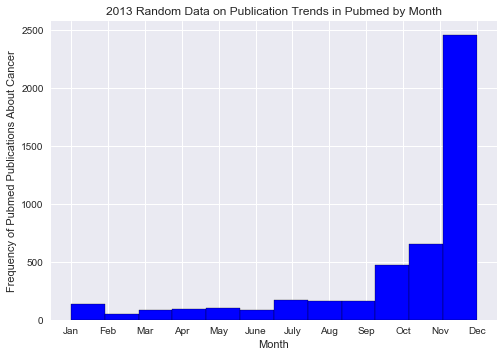

In [10]:
_= plt.hist(x = df_2013_edited['Month'], bins= 12, color = 'blue', histtype = 'bar', edgecolor = 'black')
_ = plt.xlabel('Month')
_= plt.ylabel('Frequency of Pubmed Publications About Cancer')
_= plt.title ('2013 Random Data on Publication Trends in Pubmed by Month')
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
_ = plt.xticks(months, labels)
_= plt.show()

The above histogram shows proof of concept the distribution trend across one year (2012) however the overall publication trend across our 5 years of data is not visible. A second graph below better illustrates how that data changes. 

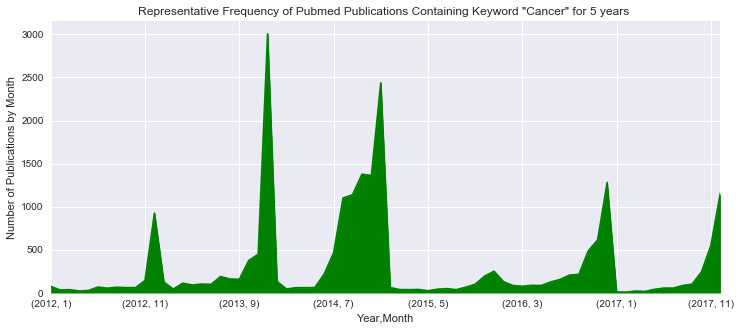

In [11]:
_= all_count.plot(kind = 'area', figsize= (12,5), 
                  title= 'Representative Frequency of Pubmed Publications Containing Keyword "Cancer" for 5 years ',
                 grid= True, color= 'green')
_= plt.ylabel('Number of Publications by Month')

_= plt.show()

The number of publications per month changes by each year, as is even better illustrated in the histogram below:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


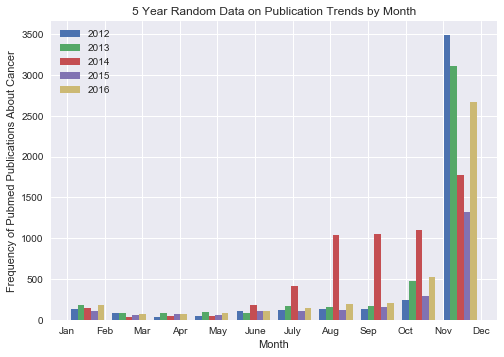

In [12]:
group_all = (month_2012, month_2013, month_2014, month_2015, month_2016)
_=plt.hist(group_all, align= 'mid')
_ = plt.xlabel('Month')
_= plt.ylabel('Frequency of Pubmed Publications About Cancer')
_= plt.title ('5 Year Random Data on Publication Trends by Month')
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
_ = plt.xticks(months, labels)
years = ['2012', '2013', '2014', '2015', '2016']
_= plt.legend( 'upper left', labels = years)

_= plt.show()

What is the margin of error and confidence interval of the publication per month between the years?

This is especially important because the years have different total data points- as is visible in the graph above. 

In [13]:
mean_2012 = np.mean(month_2012)
mean_2013 = np.mean(month_2013)
mean_2014 = np.mean(month_2014)
mean_2015 = np.mean(month_2015)
mean_2016 = np.mean(month_2016)

var_2012 = np.var(month_2012)
var_2013 = np.var(month_2013)
var_2014 = np.var(month_2014)
var_2015 = np.var(month_2015)
var_2016 = np.var(month_2016)

n_2012 = len(month_2012)
n_2013 = len(month_2013)
n_2014 = len(month_2014)
n_2015 = len(month_2015)
n_2016 = len(month_2016)

std_2012 = np.std(month_2012)
std_2013 = np.std(month_2013)
std_2014 = np.std(month_2014)
std_2015 = np.std(month_2015)
std_2016 = np.std(month_2016)


In [14]:
stats.f_oneway( month_2012, month_2013, month_2014, month_2015, month_2016)

F_onewayResult(statistic=225.73566120684927, pvalue=3.4635390317028267e-190)

## Trends within the data
The publications dates are known to follow a normal distribution, as would be expected by a large-scale naturally occuring data set. And important to identify because, although we are using a large dataset (~12K publications across 5 years) it represents a fraction of the total publications in that time (~12K/~1,000K).

<b> So far it is clear that most publications in Pubmed containing the keyword 'Cancer' are published in November and December. </b>

One note: The largest Cancer research conferences in the world are held in June and April, and submission dates for peer-reviewed papers to be submitted for presentation are February, and January, respectively. Therefore, the importance of sharing and presenting research could be driving the publication date of papers containing the keyword 'Cancer'.
(https://am.asco.org/abstracts/abstract-submission-guidelines; http://www.aacr.org/Meetings/Pages/MeetingDetail.aspx?EventItemID=136)

So now the question is what are the trends within Pubmed papers, specifically using TFIDF what are trends in unique words or trends across the data?

TFIDF - Compile a vocabulary of all n-grams in the corpus, use it to build a Document-Term feature matrix ('X') from the most important terms

1) Are there some words that are hot in titles of Pubmed papers in specific years?

2) Are some words hot in titles of pubmed papers in specific years and months? 



In [15]:
# define function to identify and create a simple DF of top N words from a column of the DF
# As 'Cancer' was a defined keyword (either in title or abstract or topics) for all the papers
# I will add it to the stopwords list now, to keep it from throwing off results
# define functino to identify and create a simple DF of top N words from a column of the DF
def word_freq(df, column, top_N):
    txt = df[column].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    stoppunc = ['.', ',', ':', '(', ')', '?', '!', '[', ']', 'cancer', 'Cancer']
    word_dist = nltk.FreqDist(words)

    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords if w not in stoppunc) 

    print('=' * 60)

    print('All frequencies for Paper Titles in 2012, excluding STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    word_freq.rslt = rslt
    print('=' * 60)

In [16]:
# run function on each DF w/'Paper Title' and N=25, save each result
word_freq(df_2012_edited, 'Paper Title', 25)
rslt_12_title = word_freq.rslt

word_freq(df_2013_edited, 'Paper Title', 25)
rslt_13_title = word_freq.rslt

word_freq(df_2014_edited, 'Paper Title', 25)
rslt_14_title = word_freq.rslt

word_freq(df_2015_edited, 'Paper Title', 25)
rslt_15_title = word_freq.rslt

word_freq(df_2016_edited, 'Paper Title', 25)
rslt_16_title = word_freq.rslt

All frequencies for Paper Titles in 2012, excluding STOPWORDS:
            Frequency
Word                 
cell              567
patients          490
cells             447
carcinoma         391
breast            388
study             275
human             256
expression        255
tumor             248
lung              234
treatment         216
therapy           199
case              187
prostate          180
analysis          171
risk              156
clinical          154
gene              150
report            150
using             142
colorectal        137
growth            137
review            135
novel             123
survival          122
All frequencies for Paper Titles in 2012, excluding STOPWORDS:
              Frequency
Word                   
patients            545
cell                518
carcinoma           397
cells               365
breast              364
study               305
tumor               266
expression          264
lung                245
treatment       

In [17]:
rslt_12_title['Year'] = '2012'
rslt_13_title['Year'] = '2013'
rslt_14_title['Year'] = '2014'
rslt_15_title['Year'] = '2015'
rslt_16_title['Year'] = '2016'

In [18]:
#put all data into a single DF
group_all = [rslt_12_title, rslt_13_title, rslt_14_title, rslt_15_title, rslt_16_title]
df_all_ti25 = pd.concat(group_all)

In [19]:
# setting standards for graphs etc. 
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

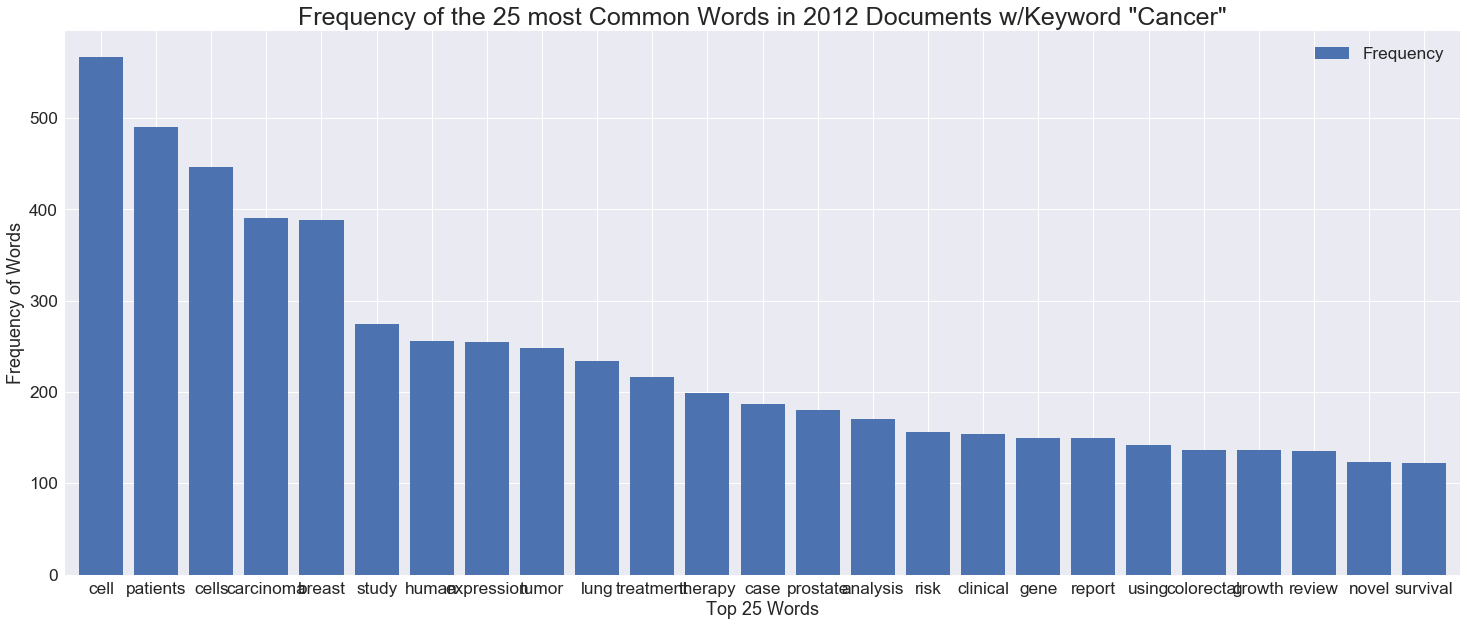

In [20]:
#Visualization of the most 25 common words in the first DF 2012

rslt_12_title.plot.bar( rot=0, figsize=(25,10), width=0.8)
plt.xlabel('Top 25 Words', fontsize = 18)
plt.ylabel('Frequency of Words', fontsize = 18)
plt.title('Frequency of the 25 most Common Words in 2012 Documents w/Keyword "Cancer"', fontsize = 25)
plt.show()

## The Goal w/ This Data: 
use NLTK to find trends in most common words for the various years
Possible Independent X Dependent variable combinations:
    1) identify named entities in the abstracts papers- use bag of words and isolate the most common words in all papers (titles and abstracts) and see how the frequencies change by year

In [21]:
# run function on each DF w/'Paper Title' and N=15, save each result
# Given that not all lists will overlap I am cutting the N so the Graph will be more readable
word_freq(df_2012_edited, 'Paper Title', 15)
rslt_12_ti15 = word_freq.rslt

word_freq(df_2013_edited, 'Paper Title', 15)
rslt_13_ti15 = word_freq.rslt

word_freq(df_2014_edited, 'Paper Title', 15)
rslt_14_ti15 = word_freq.rslt

word_freq(df_2015_edited, 'Paper Title', 15)
rslt_15_ti15 = word_freq.rslt

word_freq(df_2016_edited, 'Paper Title', 15)
rslt_16_ti15 = word_freq.rslt

All frequencies for Paper Titles in 2012, excluding STOPWORDS:
            Frequency
Word                 
cell              567
patients          490
cells             447
carcinoma         391
breast            388
study             275
human             256
expression        255
tumor             248
lung              234
treatment         216
therapy           199
case              187
prostate          180
analysis          171
All frequencies for Paper Titles in 2012, excluding STOPWORDS:
            Frequency
Word                 
patients          545
cell              518
carcinoma         397
cells             365
breast            364
study             305
tumor             266
expression        264
lung              245
treatment         230
human             229
case              220
clinical          210
review            182
therapy           182
All frequencies for Paper Titles in 2012, excluding STOPWORDS:
            Frequency
Word                 
cell              8

In [22]:
# graph together to compare results
# first add year to each DF
rslt_12_ti15['Year'] = '2012'
rslt_13_ti15['Year'] = '2013'
rslt_14_ti15['Year'] = '2014'
rslt_15_ti15['Year'] = '2015'
rslt_16_ti15['Year'] = '2016'

In [23]:
#put all data into a single DF
group_all = [rslt_12_ti15, rslt_13_ti15, rslt_14_ti15, rslt_15_ti15, rslt_16_ti15]
df_all_ti15 = pd.concat(group_all)

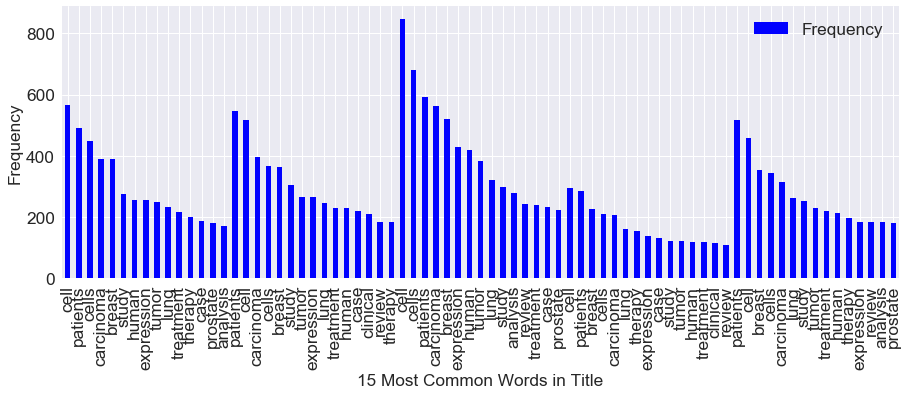

In [24]:
#graph w/ DF
df_all_ti15.plot(kind='bar', color = 'b')
plt.xlabel('15 Most Common Words in Title')
plt.ylabel('Frequency')
plt.show()

This graph is interesting but it has some big problems for understanding the Word Frequency distribution across the 5 years of data. 

## Therefore:

1) The data used so far is "TF" minus the "IDF" so it doesn't take into account common words across this document type by definition, however, given the similar results across all the years this difference means that "TF" data gives very little trend results by year. Therefore TF-IDF will be necessary to do analysis of word frequency by year, journal publication, or any other variable. 

2) it is hard to read trends by year, and identify individual words.

For the 1st problem there is another step w/data we need to do. For the 2nd problem using a Seaborn plot we can better sort the data to visualy be easier to read. 

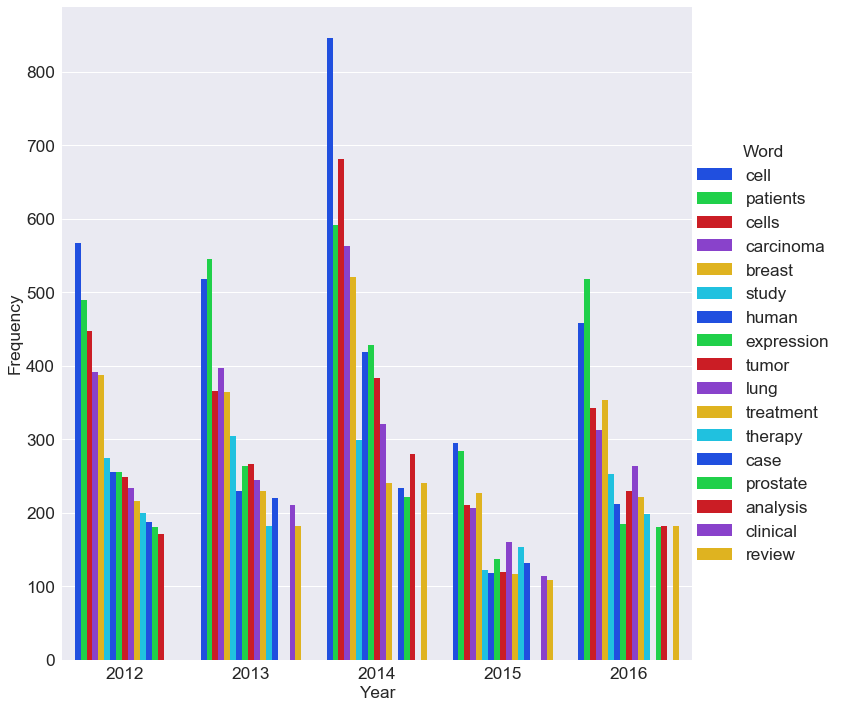

In [25]:
df_all_ti15_noindex = df_all_ti15.reset_index()
g = sns.factorplot("Year", "Frequency", "Word", data=df_all_ti15_noindex, kind="bar", palette = 'bright', size = 10)
g.set_axis_labels("Year", "Frequency");
plt.show()

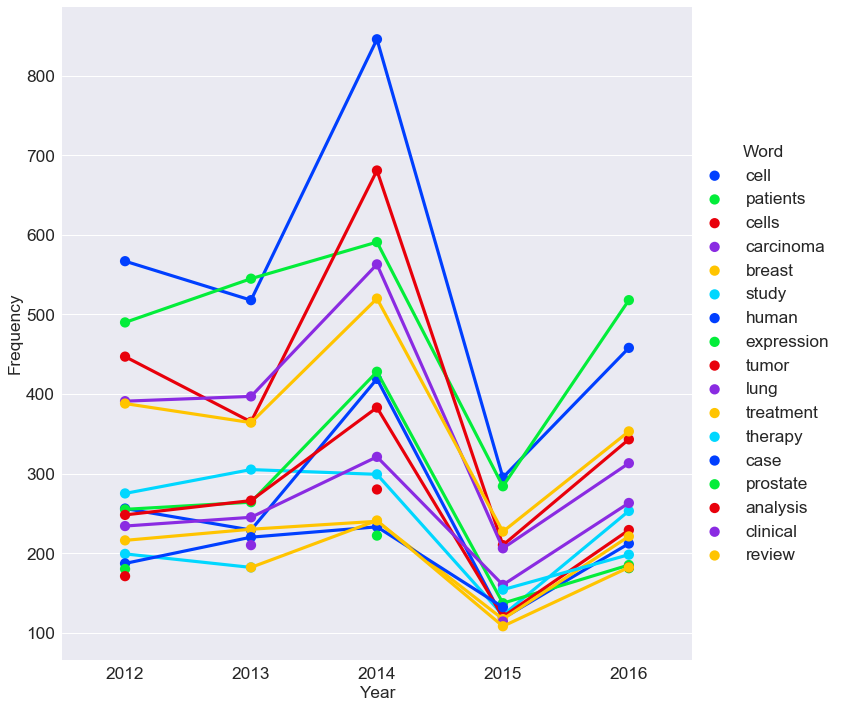

In [26]:
g = sns.factorplot("Year", "Frequency", "Word", data=df_all_ti15_noindex, kind="point", palette = 'bright', size = 10)
g.set_axis_labels("Year", "Frequency");
plt.show()

The line graph makes it very clear that the term frequency of these words across all 5 years is relatively consistent for publication titles. There are a few outliers of words missing from specific years, but the graphs display that there are only a few, and it is hard to tell what words are missing by observation. 

In [27]:
# isolating values in a dataframe to edit and renamed df_1
df_all_ti25_noindex= df_all_ti25.reset_index()
df_1 = df_all_ti25_noindex
df_1.head()

,Word,Frequency,Year
0,cell,567,2012
1,patients,490,2012
2,cells,447,2012
3,carcinoma,391,2012
4,breast,388,2012


In [28]:
df_1['cum_freq'] = df_1.groupby(['Word'])['Frequency'].cumsum()
df_1['year_count']= df_1.groupby(['Word']).cumcount()+1
df_1['avg_freq']= df_1['cum_freq']/df_1['year_count']
# creating new columns w/ information containing total number of years the word is present in
# cumulative frequency of the word across the 5 years, and average frequency. 

In [29]:
# dropping duplicate values, so only the highest cumulative frequency and last year measured is present
df_2 = df_1.sort_values(by=['Word', 'Year']).drop_duplicates(subset='Word', keep='last', inplace=False)

In [30]:
df_2.sort_values('Word').head(5)
# double checked that it worked
df_2

,Word,Frequency,Year,cum_freq,year_count,avg_freq
113,analysis,182,2016,866,5,173.200000
97,associated,72,2015,392,3,130.666667
102,breast,353,2016,1852,5,370.400000
104,carcinoma,313,2016,1870,5,374.000000
116,case,164,2016,936,5,187.200000
101,cell,458,2016,2684,5,536.800000
103,cells,343,2016,2046,5,409.200000
46,chemotherapy,122,2013,122,1,122.000000
115,clinical,180,2016,849,5,169.800000
120,colorectal,122,2016,691,5,138.200000


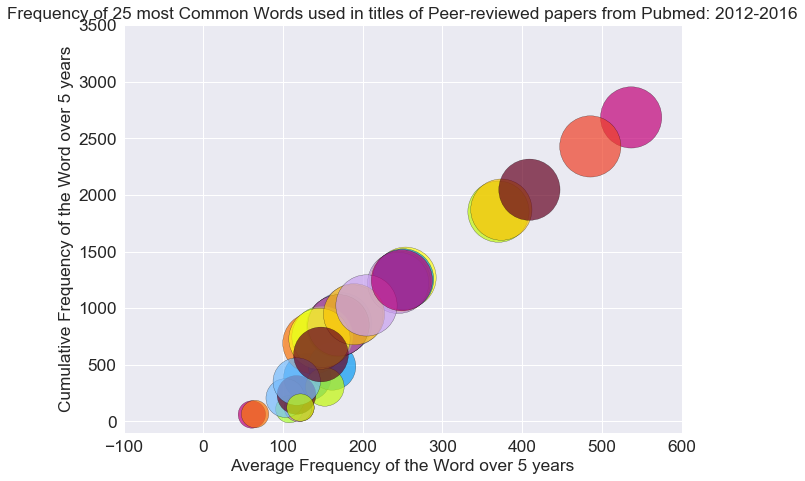

In [31]:
x= df_2['avg_freq']
y = df_2['cum_freq']
z = df_2['year_count']
w= df_2['Word']

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
 
# Set figure width and height
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size
color=('xkcd:sky blue', 'xkcd:azure', 'xkcd:chartreuse','xkcd:goldenrod',
        'xkcd:lavender', 'xkcd:magenta', 'xkcd:maroon', 'xkcd:tomato', 'xkcd:plum', 'xkcd:orange',
      'xkcd:lime', 'xkcd:orchid', 'xkcd:yellow')
_= plt.scatter(x, y, s=z*750, alpha = 0.7, c=color, edgecolor= 'black')
_= plt.xlabel('Average Frequency of the Word over 5 years')
_= plt.ylabel('Cumulative Frequency of the Word over 5 years')
_= plt.ylim(-100, 3500)
_= plt.xlim(-100, 600)
_=plt.title('Frequency of 25 most Common Words used in titles of Peer-reviewed papers from Pubmed: 2012-2016')
_= plt.show()

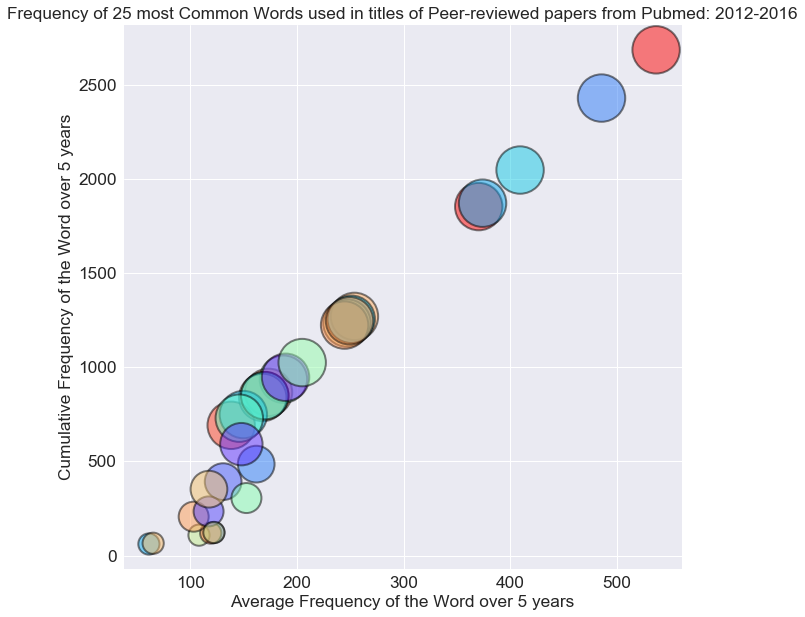

In [32]:
import matplotlib.cm as cm
avg_freq= df_2['avg_freq'].astype(float)
cum_freq = df_2['cum_freq'].astype(float)
year_count = df_2['year_count'].astype(float)
N= 33

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
 
# Set figure width to 12 and height to 9
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
colors=cm.rainbow(np.random.rand(33))

_= plt.scatter(avg_freq, cum_freq, s=year_count*450, alpha = 0.5, color = colors, edgecolor= 'black', linewidth= 2)

_= plt.xlabel('Average Frequency of the Word over 5 years')
_= plt.ylabel('Cumulative Frequency of the Word over 5 years')
_=plt.title('Frequency of 25 most Common Words used in titles of Peer-reviewed papers from Pubmed: 2012-2016')
_= plt.show()

## TF-IDF
I have found all the information of interest w/ just TF by year, at this point. Therefore, the next goal is to find TF-IDF results. 

W/ TF-IDF the goal is to look at the initial questions laid out in the ReadMe

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        

In [34]:
df_noindex_12 = df_2012_edited.reset_index(drop= True)
df_noindex_13 = df_2013_edited.reset_index(drop= True)
df_noindex_14 = df_2014_edited.reset_index(drop= True)
df_noindex_15 = df_2015_edited.reset_index(drop= True)
df_noindex_16 = df_2016_edited.reset_index(drop= True)

In [35]:
X = pipeline.fit_transform(df_noindex_12['Paper Title']).todense()
Y = pipeline.fit_transform(df_noindex_13['Paper Title']).todense()
Z = pipeline.fit_transform(df_noindex_14['Paper Title']).todense()
A = pipeline.fit_transform(df_noindex_15['Paper Title']).todense()
B = pipeline.fit_transform(df_noindex_16['Paper Title']).todense()

In [36]:
df_noindex_all = df_all.reset_index(drop= True)
df= df_noindex_all['Paper Title']
corpus= df_noindex_all['Paper Title']

- Scatter plot to look at overall distribution of TF-IDF values in all years

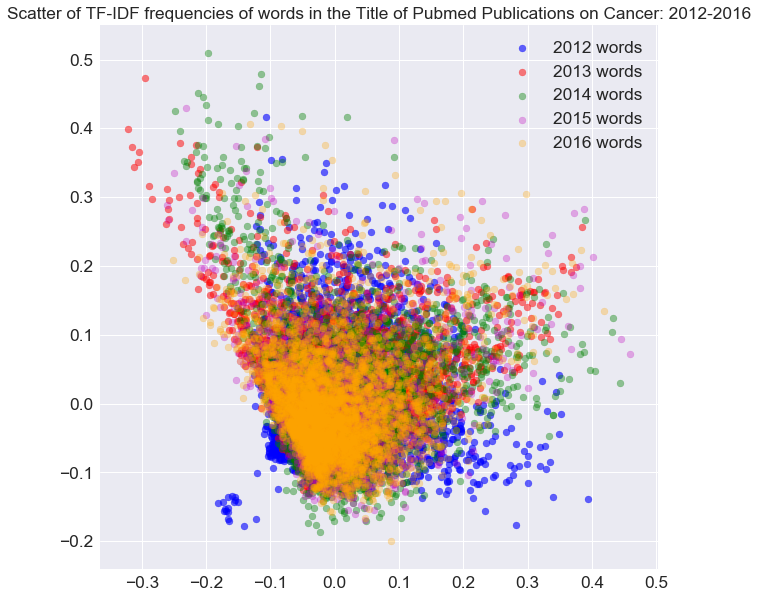

In [37]:

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_12= plt.scatter(data2D[:,0], data2D[:,1], color = 'blue', label= '2012', alpha= 0.6)

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_13=plt.scatter(data2D[:,0], data2D[:,1], color = 'red', label= '2013', alpha= 0.5)

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_14=plt.scatter(data2D[:,0], data2D[:,1], color = 'green', label= '2014', alpha= 0.4)

pca = PCA(n_components=2).fit(A)
data2D = pca.transform(A)
_15=plt.scatter(data2D[:,0], data2D[:,1], color= 'm', label= '2015', alpha= 0.3)

pca = PCA(n_components=2).fit(B)
data2D = pca.transform(B)
_16=plt.scatter(data2D[:,0], data2D[:,1], color = 'orange', label = '2016', alpha= 0.3)
plt.title ('Scatter of TF-IDF frequencies of words in the Title of Pubmed Publications on Cancer: 2012-2016')
plt.legend((_12, _13, _14,_15, _16),( '2012 words', '2013 words', '2014 words', '2015 words', '2016 words'), loc='upper right')
plt.show()  

From initial visualization of the Data to learn more about the distribution w/ the TF-IDF results we are able to see 2 things:

1) most of the years follow a similar distribution with a grouping of words at a similar rate (although at this point we have no info about which words are at which points

2) 2012 appears to be the exception, with a range of words coming out of the overall 'cone' shape of distribtuions, especially at the lower ranges. - Therefore I would expect to see some outliers in 2012 if We looked at overall datasets, and overall TF-IDF scores will be lower in 2012

# TFIDF w/ text blob

In [40]:
import math
import nltk

from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [41]:
# use stuff from Datacamp and enumerate to go over all 5 dataframes, isolate info from
# column of interest, and then get most common words for each year from the desired column
# in this example: Paper title

# make a string of desired colums from df
def str_from_df(df, name):
    titles_list = []
    for row in df[name]:
        temp_string = row
        titles_list.append(temp_string)
    titles_str= ' '.join(titles_list)
    str_from_df.words= titles_str

In [42]:
str_from_df(df_2012_edited, 'Paper Title')
titles_2012_str= tb(str_from_df.words)

In [43]:
# each document is full text from strings above, manually copy and pasted to use bloblist below and proof of concept
document_a= tb("""" MODELING DEPENDENT GENE EXPRESSION. Novel luminescent silica nanoparticles (LSN): p53 gene delivery system in breast cancer in vitro and in vivo. Preoperative Nutritional Assessment in Elderly Cancer Patients Undergoing Elective Surgery: MNA or PG-SGA? Surgical Treatment of Extrapulmonary Oligometastatic Non-small Cell Lung Cancer. Correlation of Tumoral Prognostic Factors by Sonoelastography Score in Patients to be Operated Due to Breast Cancer. Maxillary Sinus Sarcomas: Epidemiological and Clinicopathological Experience of 25 Years in a National Reference Cancer Center. Clinical Characteristics of Resected T3 Non-small Cell Lung Cancer Characterized by Parietal Pleural Invasion or Chest Wall Invasion. Antioxidant and antiproliferative activities of phenolics isolated from fruits of Himalayan yellow raspberry (Rubus ellipticus). Intraosseous verrucous carcinoma arising from an infected dentigerous cyst-A case report. Large cell neuroendocrine carcinoma: topic review and a unique case of metastasis to the mandible. Osthole inhibits proliferation of human breast cancer cells by inducing cell cycle arrest and apoptosis. BK virus as a potential oncovirus for bladder cancer in a renal transplant patient. A case of pulmonary metastasis of giant cell tumor of bone presenting as pulmonary arteriovenous malformation. Can Subepididymal Orchiectomy Re-emerge as the Treatment of Choice in Patients with Advanced Prostatic Carcinoma? Developing and testing a decision aid for use by providers in making recommendations: about mammography screening in older women. The efficacy of lamivudine prophylaxis against hepatitis B reactivation in breast cancer patients undergoing chemotherapy: a meta-analysis. Renal insufficiency retains adverse prognostic implications despite renal function improvement following Total Therapy for newly diagnosed multiple myeloma. Oral Sex and HPV: Population Based Indications. Hepatic perivascular epithelioid cell tumor: five case reports and literature review. Hepatosplenic T cell lymphoma: a rare case report. JAK2 (V617F) Positive Latent Myeloproliferative Neoplasm Presenting with Splanchnic Vein Thrombosis. Essential fatty acids as functional components of foods- a review. Postoperative Body Mass Index Changes in Gastric Cancer Patients according to Reconstruction Type: Effectiveness of Long Jejunal Bypass on Weight Loss in Obese Patients after Distal Gastrectomy. Significance of coarse cereals in health and nutrition: a review. Combined effects of GSTO1 and SULT1A1 polymorphisms and cigarette smoking on urothelial carcinoma risk in a Taiwanese population. Korean Americans' beliefs about colorectal cancer screening. High-grade glioma in a patient with breast cancer. Management of radicular cysts using platelet-rich fibrin and bioactive glass: a report of two cases. Hyperplastic polyps identified during screening endoscopy: reevaluated by histological examinations and genetic alterations. Breast Sparganosis Incidentally Detected by FDG PET/CT. Evaluation of (18)F-FDG Uptake Pattern in Brown Adipose Tissue Over Extended Time Period as Assessed by Multiple Time Point (18)F-FDG-PET. Routine histopathologic examination of two common surgical specimens-appendix and gallbladder: is it a waste of expertise and hospital resources? Squamous cell carcinoma: morphological & topographical spectrum: a two year analysis. Foot massage: effectiveness on postoperative pain in breast surgery patients. Effect of Antiviral Prophylaxis Strategy for Chemotherapy-Associated Hepatitis B Reactivation in Non-Hodgkin's Lymphoma Patients with Hepatitis B Virus Infection: A Retrospective Cohort Study. Micronucleus frequency among Iraqi thyroid disorder patients. Secure Surgical Method for Catheter Placement via the Occipital Artery to Achieve Retrograde Superselective Intra-Arterial Chemotherapy for Advanced Oral Cancer: Alternative to Approach via the Superficial Temporal Artery. Orbital hemangiopericytoma in an Asian population. Cytological and morphometric study of urinary epithelial cells with histopathological correlation. Role of Transrectal Ultrasound in Preoperative Local Staging of Carcinoma Rectum and It's Histopathological Correlation. Percutaneous balloon pericardiotomy as the initial and definitive treatment for malignant pericardial effusion. Modulation of microRNA expression by volatile organic compounds in mouse lung. Is executive function specifically impaired in children with neurofibromatosis type 1? A neuropsychological investigation of cognitive flexibility. Colorectal cancer mortality in Poland - analysis of regional variation. Tuberculous lymphadenitis and the appearance of Behçet's disease-like symptoms. Significant contribution of Fluorodeoxyglucose positron emission tomography/computed tomography (FDG PET/CT) in a case of acute lymphoblastic leukemia presenting with fever of unknown origin. Perioperative management with upfront combination therapy in a patient exhibiting idiopathic pulmonary hypertension with central pulmonary thrombosis. Thrombocytopenia induced by diazoxide in a patient with an insulinoma. Very rare case of large obstructive myxofibrosarcoma of the right ventricle assessed with multi-diagnostic imaging techniques. Histiocytic sarcoma of the bile duct. Gastric diffuse large B-cell lymphoma cured with Helicobacter pylori eradication regardless of whether it contains features of MALT lymphoma. Hepatitis B and C virus infection is a risk factor for the development of cholangiocarcinoma. Renal MALT lymphoma associated with Waldenström macroglobulinemia. The effect-enhancing and toxicity-reducing activity of Hypericum japonicum Thunb. extract in murine liver cancer chemotherapy. Study to determine whether intraoperative frozen section biopsy improves surgical treatment of non-melanoma skin cancer. S-adenosyl methionine specifically protects the anticancer effect of 5-FU via DNMTs expression in human A549 lung cancer cells. Effects of statins on the prognosis of local and locally advanced renal cell carcinoma following nephrectomy. Metastatic breast cancer in patients with schizophrenia. Histological profile and age at diagnosis of breast and ovarian tumors: A register-based study in Espirito Santo, Brazil. Resolving the EGF-EGFR interaction characteristics through a multiple-temperature, multiple-inhibitor, real-time interaction analysis approach. Radical prostatectomy as radical cure of prostate cancer in a high-risk group: A single-institution experience. Sanguinarine is a novel VEGF inhibitor involved in the suppression of angiogenesis and cell migration. Limited expression of cancer-testis antigens in renal cell carcinoma patients. Myoepithelial carcinoma inside of maxilla bone: A case report. Antitumoral effect of PLK-1-inhibitor BI2536 in combination with cisplatin and docetaxel in squamous cell carcinoma cell lines of the head and neck. L-type amino acid transporter 1 expression is highly correlated with Gleason score in prostate cancer. Clinicopathological and prognostic significance of the microRNA processing enzyme DICER1 mRNA expression in colorectal cancer patients. Metachronous liver and bone metastasis from small early gastric carcinoma without lymph node involvement: A case report. Expression of miR-486 is a potential prognostic factor after nephrectomy in advanced renal cell carcinoma. Local drug delivery to a human pancreatic tumor via a newly designed multiple injectable needle. Metronomic chemotherapy for metastatic breast cancer to prolong time to treatment failure to 12 months or more. Deguelin, a novel anti-tumorigenic agent targeting apoptosis, cell cycle arrest and anti-angiogenesis for cancer chemoprevention. Genetic polymorphism of CCND1 G870A and esophageal cancer susceptibility: A meta-analysis. Correlation of Asp299Gly and Thr399Ile polymorphisms in toll-like receptor 4 gene with digestive cancer risk: A meta-analysis. Evaluation of a novel real-time fluorescent polymerase chain reaction assay for high-risk human papilloma virus DNA genotypes in cytological cervical screening. Bevacizumab combined with low-dose S-1 as maintenance therapy with a long progression-free survival in an elderly patient with heavily pre-treated advanced gastric cancer: A case report. In vitro effect of molluscan hemocyanins on CAL-29 and T-24 bladder cancer cell lines. Detection of circulating tumour cells on mRNA levels with established breast cancer cell lines. Peroxiredoxin 3 is a novel marker for cell proliferation in cervical cancer. Salvianolic acid A positively regulates PTEN protein level and inhibits growth of A549 lung cancer cells. In situ analysis of FOXP3+ regulatory T cells and myeloid dendritic cells in human colorectal cancer tissue and tumor-draining lymph node. Relational mechanisms and psychological outcomes in couples affected by breast cancer: a systematic narrative analysis of the literature. Identifying patients with chronic conditions in need of palliative care in the general population: development of the NECPAL tool and preliminary prevalence rates in Catalonia. Paediatric palliative care: intravenous methylnaltrexone relieves constipation. Development of a generic working definition of 'supportive care'. Defining the palliative care patient: its challenges and implications for service delivery. An exploration of the word 'palliative' in the 19th century: searching the BMJ archives for clues. Meta-tetrahydroxyphenyl chlorine mediated photodynamic therapy inhibits the migration and invasion of a nasopharyngeal carcinoma KJ-1 cell line. Exploration on the underlying mechanism of female predominance in spasmodic dysphonia: an anatomical study of nodose ganglion in rats. Neuropathic pain referrals to a multidisciplinary pediatric cancer pain service. Barriers to cancer pain management in Danish and Lithuanian patients treated in pain and palliative care units. Unusual presentations of adenoid cystic carcinoma in extra-salivary gland subsites in head and neck region: a case series. Diagnostic value of fine-needle aspiration in head and neck lymphoma: a cross-sectional study. A case of renal cell carcinoma metastasizing to invasive ductal breast carcinoma. Endocrine dysfunction in Taiwanese children with human chorionic gonadotropin-secreting germ cell tumors. Situs Inversus Totalis (SIT) with Hepatocellular Carcinoma (HCC): A Rare Case Report and Review of 12 Other Cases. Matrix metalloproteinase gene polymorphisms and oral cancer. Lateral temporal bone resection in advanced cutaneous squamous cell carcinoma: report of 35 patients. Cytologic findings of gastric schwannoma: a case report. Fine needle aspiration of primary mediastinal synovial sarcoma: cytomorphologic, immunohistochemical, and molecular study. Novel therapeutic modalities and drug delivery in pancreatic cancer - an ongoing search for improved efficacy. Evaluation of humoral immunity in oral cancer patients from a nigerian referral centre. Surgical Management of Oro-Antral Communications Using Resorbable GTR Membrane and FDMB Sandwich Technique: A Clinical Study. Prosthodontic rehabilitation of velopharyngeal disorders-a case series. Fabricating a hollow obturator with light-cured resin system. Long-term survival of a patient with extensive small cell carcinoma of unknown primary etiology complicated by nephrotic syndrome. Successful diagnosis of type II enteropathy-associated T-cell lymphoma using flow cytometry and the cell block technique of celomic fluid manifesting as massive pyoid ascites that could not be diagnosed via emergency laparotomy. Acquired Fanconi syndrome with proximal tubular cytoplasmic fibrillary inclusions of ? light chain restriction. Prognostic factors and treatment efficacy in patients with primary diffuse large B-cell lymphoma of the bone: single institute experience over 11 years. Thyroglossal cyst: an unusual presentation. Paraganglioma of right cervical plexus-a case report. Epithelial myoepithelial carcinoma of head and neck region. Fine needle aspiration biopsy: in the diagnosis of salivary gland neoplasms compared with histopathology. Salivary gland tumors in Turkey: demographic features and histopathological distribution of 510 patients. Immunohistochemistry, a valuable tool in detection of cervical lymph node micrometastases in head and neck squamous cell carcinoma: a prospective study. Versatility of pectoralis major myocutaneous flap in oncosurgery and its role in developing countries. Mechanism of thyroid gland invasion in laryngeal cancer and indications for thyroidectomy. Pattern of lymphatic metastasis in relation to the depth of tumor in oral tongue cancers: a clinico pathological correlation. Neck dissection followed by definitive radiotherapy for small upper aerodigestive tract squamous cell carcinoma, with advanced neck disease: an alternative treatment strategy. Variations of the cervical internal carotid artery. The role of thyroidectomy in advanced laryngeal and pharyngolaryngeal carcinoma. Clinicopathological features and complications of thyroid operations: a single centre experience. Epidemiological factors in gall bladder cancer in eastern India-a single centre study. Human papilloma virus in head and neck cancers-role and relevance in clinical management. Factors associated with better survival after surgery in metastatic breast cancer patients. Unresolving / progressive skin lesions in cancer patients: be aware of carcinoma cutis. The Development of Supportive Care for Cancer Patients in India: A UK Perspective. Systemic therapy in head and neck cancer: changing paradigm. Non urothelial bladder cancers: a case series. Incidentaloma at radial artery forearm free flap harvest: an occult volar wrist ganglion. Gallbladder cancer revealed by an endobiliary tumor thrombus. Spindle cell amelanotic lesion of the tongue: a diagnostic and therapeutic challenge. Single incision laparoscopic appendectomy with two port: a case of appendiceal mucocele. Laparoscopic radical distal gastrectomy for ca stomach. Soft palate schwannoma. Neuroendocrine tumour, mucinous adenocarcinoma and signet-ring cell carcinoma of the appendix: three cases and review of literature. Concurrent single-incision laparoscopic right hemicolectomy and sigmoidectomy for synchronous carcinoma: report of a case. Primary primitive neuroectodermal tumor of the breast: a rare case presentation. Single incision laparoscopic right colectomy using the techniques of open surgery through the small incision. Colorectal cancer liver metastasis presenting as pneumoperitoneum: case report and literature review. Use of glutaraldehyde-preserved bovine pericardium patch in vascular repair of portal vein in a patient with pancreatic cancer. Male breast cancer-review of literature on a rare microscopic variant (oncocytic carcinoma). The transverse colon cancer with the reversed rotation of the midgut treated with single incision laparoscopic colectomy. Primary mesenteric fibromatosis: a case report with brief review of literature. Multiple retroperitoneal paragangliomas. Obstructive jaundice secondary to ampullary adenocarcinoma in neurofibromatosis type 1. A giant metastatic inguinal lymph node from melanoma. The first and second echelon sentinel lymph node evaluation in oral cancer. Is Acrylate Co-monomer (Glubran-2) Useful in the Prevention of Prolonged Air Leaks After Pulmonary Lobectomy? Migration of radioactive iodine-125 seeds: case report. Hepatic colorectal metastases involving infra-hepatic inferior vena cava in high risk patients for extended resection: an alternative method for achieving radical resection in patient with borderline liver remnant. Skeletal muscle metastases from pancreatic carcinoma-a case report and review of literature. Breast cancer stem cells, pathways and therapeutic perspectives 2011. Impact of blood transfusions on survival and recurrence in colorectal cancer surgery. Value of serum procalcitonin in evaluating the prognosis of sepsis in elderly patients with colorectal cancer undergoing emergency colorectal surgery. A very large malignant phyllodes tumor with skin ulceration and nipple areola complex involvement-still a reality!!! Pancreatic Castleman's Disease: Studies of Three Cases And A Cumulative Review of the Literature. Anterior resection for rectal cancer with mesorectal excision: institutional review. Diagnostic Role of Platelet Lymphocyte Ratio(PLR) in Pancreatic Head Masses. Neutropenic enterocolitis in a child with acute myeloid leukemia successfully treated with early surgical intervention. Blastic plasmacytoid dendritic cell neoplasm: a report of 2 cases. Granulocytic sarcoma of colon in a patient with acute promyelocytic leukemia. A Bi-Lineal Acute Leukemia (T/Myeloid, NOS) with Complex Cytogenetic Abnormalities. Microfilariae with acute myeloid leukemia: a common parasite with uncommon association. Primary granulocytic sarcoma of meninges and mediastinum as diagnostic dilemma. Antioxidant status and oxidative stress in the circulation of younger and elderly human subjects. Drug delivery of hydroxyurea to breast cancer using liposomes. Urinary tumor markers could predict survival in bladder carcinoma. Impact of CCL2 and Its Receptor CCR2 Gene Polymorphism in North Indian Population: A Comparative Study in Different Ethnic Groups Worldwide. Diagnostic Significance of CA15-3 with Combination of HER-2/neu Values at 85th Percentiles in Breast Cancer. Oxidative stress and skin cancer: an overview. Imatinib use in pregnancy. Correlation of levels of IL-6 with tumor burden and receptor status in patients of locally advanced carcinoma breast. Changes in Serum PSA During Normal Menstrual Cycle. Oxidative stress and its relationship with adenosine deaminase activity in various stages of breast cancer. Diagnostic Role of Tumour Markers CEA, CA15-3, CA19-9 and CA125 in Lung Cancer. No Association of Matrix Metalloproteinase [MMP]-2 (-735C > T) and Tissue Inhibitor of Metalloproteinase [TIMP]-2 (-418G > C) Gene Polymorphisms with Cervical Cancer Susceptibility. Single centre prospective study of the efficacy of percutaneous cement augmentation in the treatment of vertebral compression fractures. Transcriptomic analysis by RNA-seq reveals AP-1 pathway as key regulator that green tea may rely on to inhibit lung tumorigenesis. Rare case of temporal bone carcinoma with intracranial extension. The bethesda system for reporting thyroid cytopathology: interpretation and guidelines in surgical treatment. Nutritional status and nutritional support before and after pancreatectomy for pancreatic cancer and chronic pancreatitis. Influence of margins on disease free survival following hepatic resection for colorectal metastasis: a meta-analysis. Preoperative radiotherapy in carcinoma rectum. Current trends in breast surgery. Are We Over-treating Neck in Buccal & Alveolo-buccal Cancers: Experience from a Tertiary Cancer Care Center. Poor oral Hygiene may be the Sole Cause of Oral Cancer. Comparative Study between Staplers and Conventional(Hand-Sewn) Anastomosis in Gastrointestinal Surgery. Risk factors and clinical aspects of recurrent invasive cervical carcinoma. Effect of certain indigenous processing methods on the bioactive compounds of ten different wild type legume grains. Simultaneous robot-assisted radical cystoprostatectomy and nephroureterectomy in a patient with multifocal invasive urothelial carcinoma and previous contralateral nephroureterectomy. Robot-assisted low anterior resection in fifty-three consecutive patients: an Indian experience. [Treatment of conjunctival melanoma]. [Iris microhaemangiomas: presentation of a case]. [Acute visual loss in pregnancy caused by craniopharyngioma]. [De novo growth of a capillary hemangioma of the conjunctiva]. [Orbital alveolar rhabdomyosarcoma masked by ethmoid sinusitis in a 25-year-old]. [Pigmented ciliary body tumours: benign or malignant?]. [Central retinal vein occlusion as the first symptom of ovarian cancer]. Numerical analysis for determination of the presence of a tumor and estimation of its size and location in a tissue. MicroRNAs in prostate cancer. The oncogenic potential of Jumonji D2 (JMJD2/KDM4) histone demethylase overexpression. The epigenetic potentials of dietary polyphenols in prostate cancer management. Thyrotropin-secreting pituitary tumor presenting with congestive heart failure and good response to dopaminergic agonist cabergoline. Unexpected hemorrhage: an unusual and potentially catastrophic clinical challenge. Extended hemangioma from pharynx to esophagus that could be misdiagnosed as an esophageal varix on endoscopy. Upregulation of the long non-coding RNA HOTAIR promotes esophageal squamous cell carcinoma metastasis and poor prognosis. [Secondary pulmonary embolism to right atrial myxoma]. [Mucosecretor adenocarcinoma of the lung with pleural involvement presenting as a pneumothorax. Presentation of a clinical case]. Immune reconstitution inflammatory syndrome mimics a relapse of AIDS-related Burkitt lymphoma. Long-term remission achieved via combined chemotherapy and radiotherapy in a non-resectable granulocyte colony-stimulating factor producing pleomorphic carcinoma of the lung. Small-cell lung cancer exhibiting spontaneous regression. Association between acute myelogenous leukemia and thrombopoietin receptor agonists in patients with immune thrombocytopenia. Evaluation of the response of concurrent high dose rate intracavitary brachytherapy with external beam radiotherapy in management of early stage carcinoma cervix. Immunohistochemical Expression of Cell Proliferating Nuclear Antigen (PCNA) and p53 Protein in Cervical Cancer. Role of Neoadjuvant Chemotherapy (NACT) Followed by Surgical Cytoreduction in Advanced Epithelial Ovarian Cancer. Evaluation of oxidative stress and DNA damage in benign prostatic hyperplasia patients and comparison with controls. Modeling of treatment response to erythropoiesis-stimulating agents in older (age?70years) and younger (age<70years) patients with cancer and anemia: findings from the Anemia Cancer Treatment study. Health-care associated bacteremia in geriatric cancer patients with febrile neutropenia. Metabolic, nutritional and inflammatory characteristics in elderly women with advanced cancer. Use of the Freund clock drawing test within the Mini-Cog as a screening tool for cognitive impairment in elderly patients with or without cancer. Risk-adapted, dose escalation study of weekly docetaxel in the first-line treatment of elderly patients with advanced cancer. Disparity in the use of combined modality therapy for rectal cancer in the older adult. Changes in body mass index and stoma related problems in the elderly. Efficacy of aprepitant among patients aged 65 and over receiving moderately to highly emetogenic chemotherapy: a meta-analysis of unpublished data from previously published studies. Symptom distress in older adults during cancer therapy: impact on performance status and quality of life. Interventional oncology in the elderly: complications and early response in liver and kidney malignancies. Can we predict chemo-induced hematotoxicity in elderly patients treated with pegylated liposomal doxorubicin? Results of a population-based model derived from the DOGMES phase II trial of the GINECO. Treatment of breast cancer in the elderly: a prospective, population-based Swiss study. Evaluation of the Groningen Frailty Indicator and the G8 questionnaire as screening tools for frailty in older patients with cancer. Inclusion of frail elderly patients in clinical trials: solutions to the problems. Is cancer incidence decreased in the frail elderly? Evidence from a prospective cohort study. [Ocular paraneoplastic syndrome: cancer-associated retinopathy]. Undifferentiated embryonal sarcoma of the liver with focal osteoid picture-a case report. A novel duct-lobular segmentectomy for breast tumors with nipple discharge using near-infrared indocyanine green fluorescence imaging. Effect of an angiotensin II type 1 receptor blocker on caveolin-1 expression in prostate cancer cells. [Primary presentation of non-hodgkin lymphoma. Report of a case]. [Diagnosis of multiple myeloma in primary care. Suspicion with an appropriate clinical history]. [The enigma of quaternary prevention in Primary Care. When and when not to do it (presentation of two cases)]. [Hospital undertaking of patients with a resection of lung cancer]. Effect of precursors feeding and media manipulation on production of novel anticancer pro-drug camptothecin from endophytic fungus. Occurrence of aflatoxin B1 in natural products. Clinicopathologic characteristics and prognosis of gastric cancer in young patients. Spinal gout: a great mimicker. A case report and literature review. MRI features of spinal solitary fibrous tumors. A report of two cases and literature review. Pulmonary embolism caused by cement leakage during percutaneous vertebroplasty. A case report of successful conservative management. Paget's Disease. A Case Report. Clear cell carcinoma of female urethral diverticulum--a case report. Neocortical neurogenesis and neuronal migration. Pediatric Risk Factors for Candidemia Secondary to Candida glabrata and Candida krusei Species. Non-classic adrenal hyperplasia due to the deficiency of 21-hydroxylase and its relation to polycystic ovarian syndrome. Endocrinopathies and other disorders inducing a polycystic ovary syndrome phenotype. Infertility treatment in polycystic ovary syndrome: lifestyle interventions, medications and surgery. Combined oral contraceptives in polycystic ovary syndrome - indications and cautions. Hirsutism - from diagnosis to use of antiandrogens. Insulin sensitizers in polycystic ovary syndrome. Cardiovascular risk and subclinical cardiovascular disease in polycystic ovary syndrome. Dyslipidemia and oxidative stress in PCOS. Obesity, adipokines and metabolic syndrome in polycystic ovary syndrome. Genetics of polycystic ovary syndrome. Pathophysiology of polycystic ovary syndrome: the role of hyperandrogenism. Polycystic ovary syndrome: definitions, phenotypes and diagnostic approach. Island pectoralis major myocutaneous flap: an Indian perspective. A cross sectional study of oral submucous fibrosis in central India and the effect of local triamcinolone therapy. Intraperitoneal chemotherapy for epithelial ovarian cancer - single center experience. Profile of oral squamous cell cancer in a tertiary level medical college hospital: a 10 yr study. Male breast cancer: a clinicopathologic study of 42 patients in eastern India. Morbidity and outcome of pelvic exenteration in locally advanced pelvic malignancies. Characteristics of gallbladder cancer in South India. Role of Recombinant Human Thyrotropin (rhTSH) in the Treatment of Well-Differentiated Thyroid Cancer. Pediatric thyroid cancers: an Indian perspective. Surgical decision making in the management of well-differentiated thyroid cancer. Leukemia cutis: an unusual presentation. Robotic-assisted laparoscopic radical prostatectomy after aborted retropubic radical prostatectomy. OnobotulinumtoxinA Has No Effects on Growth of LNCaP and PC3 Human Prostate Cancer Cells. Urinary schistosomiasis: review. Midline suboccipital osteoplastic craniotomy - 'cobra craniotomy'. Cauda equina syndrome caused by spontaneous bleeding in the filum terminale myxopapillary ependymoma: a rare pediatric case. [Combined choroidal biopsy and cytology for diagnosis of intraocular tumour]. [Incomplete Horner's syndrome as a presenting sign of fourth ventricle ependymoma]. Expression, localization and clinical application of exogenous Smith proteins D1 in gene transfected HEp-2 cells. Pediatric cervical intraosseous schwannoma. RNA interference: A futuristic tool and its therapeutic applications. Synthesis and anticancer activity of some fused pyrimidines and related heterocycles. Embryonic signature in breast cancers; Pluripotency roots of cancer stem cells. Hybrid drug delivery system for oropharyngeal, cervical and colorectal cancer - in vitro and in vivo evaluation. The US FDAs withdrawal of the breast cancer indication for Avastin (bevacizumab). Use of the single cell gel electrophoresis (comet assay) for comparing apoptotic effect of conventional antibodies versus nanobodies. Primary retroperitoneal diffuse large B-cell lymphoma presenting with numb chin syndrome and painful ophthalmoplegia. Long-term survival following gross total resection of pediatric supratentorial ependymomas without adjuvant therapy. Inflammatory pseudotumor of the lateral ventricle in a pediatric patient. Jugular foramen syndrome as initial presentation of metastatic lung cancer. Comparison of pegfilgrastim prescribing practice to national guidelines at a university hospital outpatient oncology clinic. Physical, psychosocial, relationship, and economic burden of caring for people with cancer: a review. Impact of age cutoffs on a lynch syndrome screening program. Indications for pediatric external ventricular drain placement and risk factors for conversion to a ventriculoperitoneal shunt. Extreme sensitivity and the practical implications of risk assessment thresholds. Balloon-occluded retrograde transvenous obliteration for intractable gastric variceal bleeding. Long-term follow-up of patients with surgical intractable acromegaly after linear accelerator radiosurgery. Potential benefits of palliative care for polysymptomatic patients with late-stage nonmalignant disease in Taiwan. Bcl-6 expression and lactate dehydrogenase level predict prognosis of primary gastric diffuse large B-cell lymphoma. Synthesis and Biological Activity of N-Sulfonyltripeptides with C-Terminal Arginine as Potential Serine Proteases Inhibitors. The success of endoscopic third ventriculostomy in children: analysis of prognostic factors. A rare case of pediatric colloid cysts in bilateral ventricles. Synthesis and in vitro antiproliferative activity of novel 12(H)-quino[3,4-b][1,4]benzothiazine derivatives. Multiple bee stings, peritumoral mast cell degranulation and anaphylaxis--is there a relationship? High-risk and multiple human papillomavirus infections among married women in Can Tho, Viet Nam. The contentious history of sirtuin debates. Randomized Trials Built on Sand: Examples from COPD, Hormone Therapy, and Cancer. Functional outcomes by age for inpatient cancer rehabilitation: a retrospective chart review. To NF?B or not to NF?B: The Dilemma on How to Inhibit a Cancer Cell Fate Regulator. Developing an endoscopic mucosal resection service in a district general hospital. Fluorescence spectroscopy: a new approach in cervical cancer. Demyelinating neuropathy and autoimmune hemolytic anemia in a patient with pancreatic cancer. Varicella-zoster virus-associated fulminant hepatitis following allogeneic hematopoietic stem cell transplantation for multiple myeloma. Diagnosis of a solid pseudopapillary neoplasm using EUS-FNA. Multiple gastric G1 neuroendocrine tumors with venous and lymphatic invasion. Multiple cutaneous metastases: a rare and late sequelae of lacrimal gland adenoid cystic carcinoma. FOXP3, a novel glioblastoma oncosuppressor, affects proliferation and migration. [Delayed diagnosis of ophthalmic artery obstruction due to atrial myxoma]. On-chip three-dimensional tumor spheroid formation and pump-less perfusion culture using gravity-driven cell aggregation and balanced droplet dispensing. Analysis of risk factors and survival in pediatric high-grade spinal cord astrocytoma: a population-based study. A single-dose conformal delivery of radiotherapy following osteoplasty : a novel approach to treatment of osteolytic metastasis in the setting of multiple myeloma. Computed tomography of the temporomandibular joint. Update on molecular and genetic alterations in adult medulloblastoma. Current treatment of low grade gliomas. Human papillomavirus (HPV) infection and vaccines: knowledge, attitude and perception among female students at the University of Lagos, Lagos, Nigeria. The use of epidemiological measures to estimate the impact of primary prevention interventions on CHD, stroke and cancer outcomes: experiences from Herefordshire, UK. Progress on human papillomavirus (HPV) infection and cervical cancer prevention in sub-Saharan Africa: highlights of the 27th International Papillomavirus Conference in Berlin, 17-22 September 2011. Population structure and the burden of disease in the United Arab Emirates. Immunohistochemical evaluation of human epidermal growth factor receptor 2 and estrogen and progesterone receptors in invasive breast cancer in women. Two-stage testing procedures with independent filtering for genome-wide gene-environment interaction. Predictive accuracy of covariates for event times. Likelihood approaches for the invariant density ratio model with biased-sampling data. Analysing bivariate survival data with interval sampling and application to cancer epidemiology. Pontine extraventricular neurocytoma in a child. Congenital glioblastoma multiforme: complete resection with long-term survival and a novel technique of contralateral cystoventriculostomy. Single-session laparoscopic cystectomy and nephroureterectomy. Conflicting stories about public scientific controversies: Effects of news convergence and divergence on scientists' credibility. The quality of the evidence for dietary advice given in UK national newspapers. Polyphenols attached graphene nanosheets for high efficiency NIR mediated photodestruction of cancer cells. Functionalized magnetic nanoparticles as vehicles for the delivery of the antitumor drug gemcitabine to tumor cells. Physicochemical in vitro evaluation. Encapsulation of Ellipticine in poly-(3-hydroxybutyrate-co-3-hydroxyvalerate) based nanoparticles and its in vitro application. Adjuvant intravesical bacillus calmette-guérin therapy and survival among elderly patients with non-muscle-invasive bladder cancer. Neoadjuvant chemotherapy and salvage surgery for an aldosterone-producing adrenal carcinoma with inferior vena cava thrombus: case report and literature review. Wide composite resection of follicular thyroid carcinoma with metastases to sternum: report of two cases. Prospective randomized controlled study comparing cell block method and conventional smear method for bile cytology. Cap-assisted water immersion for minimal sedation colonoscopy: prospective, randomized, single-center trial. What is the accuracy of autofluorescence imaging in identifying non-polypoid colorectal neoplastic lesions when reviewed by trainees? A pilot study. Efficacy and safety of a WallFlex enteral stent for malignant gastric obstruction. Gastroenterology manpower: what are the future job prospects for gastroenterology trainees? A case of mucinous cystic neoplasm of the liver: description of Sonazoid-enhanced ultrasound imaging and histopathologic findings. Circulatory Diseases in the U.S. Elderly in the Linked National Long-Term Care Survey-Medicare Database: Population-Based Analysis of Incidence, Comorbidity, and Disability. Cytokines are associated with postembolization fever and survival in hepatocellular carcinoma patients receiving transcatheter arterial chemoembolization. Cytotoxic effect of commercial Humulus lupulus L. (hop) preparations - In comparison to its metabolomic fingerprint. Magnetic endoscope imaging (ScopeGuide) elucidates the mechanism of action of the pain-alleviating impact of water exchange colonoscopy - attenuation of loop formation. A new method for screening and surveillance colonoscopy: Combined water-exchange and cap-assisted colonoscopy. Indigocarmine added to the water exchange method enhances adenoma detection - a RCT. ApoStream(™), a new dielectrophoretic device for antibody independent isolation and recovery of viable cancer cells from blood. The need for office systems to improve colorectal cancer screening. Pilot study: health behaviors associated with human papillomavirus vaccine acceptance among adolescents. Colorectal cancer educational intervention targeting latino patients attending a community health center. Rural population estimates: an analysis of a large secondary data set. Colorectal cancer screening disparities for rural minorities in the United States. Patients whose physicians recommend colonoscopy and those who follow through. Views, barriers, and suggestions for colorectal cancer screening among american Indian women older than 50 years in the midwest. Shared decision making in prostate-specific antigen testing: the effect of a mailed patient flyer prior to an annual exam. Alcohol outlet availability and excessive alcohol consumption in breast cancer survivors. Trigeminal neuralgia associated with cerebellopontine angle lipoma in childhood. Tumors of central and peripheral nervous system associated with inherited genetic syndromes. Popliteal artery occlusion secondary to exostosis of the femur. Antiproliferative effect of H2O2 against human acute myelogenous leukemia KG1 cell line. Diffuse sclerosing variant of thyroid papillary carcinoma: diagnostic challenges occur with Hashimoto's thyroiditis. Strategies for early recognition of cutaneous melanoma-present and future. Bone mineral loss induced by anticancer treatment for gynecological malignancies in premenopausal women. Relaxed imprinting of IGF2 in peripheral blood cells of patients with a history of prostate cancer. Terminology inaccuracies in the interpretation of imaging results in detection of cervical lymph node metastases in papillary thyroid cancer. Common genetic variants in pituitary-thyroid axis genes and the risk of differentiated thyroid cancer. Prognostic value of the lymph node ratio after resection of periampullary carcinomas. Crystal structure of human angiogenin with an engineered loop exhibits conformational flexibility at the functional regions of the molecule. Anti-apoptotic role of peroxiredoxin III in cervical cancer cells. Acute urinary retention in elderly female patients after photodynamic therapy of urethral condyloma--report of two cases. Molecular cytogenetic evaluation of the efficacy of photodynamic therapy by indocyanine green in breast adenocarcinoma MCF-7 cells. Photodynamic therapeutic activity of indocyanine green entrapped in polymeric nanoparticles. Diagnosis of upper urinary tract tumours: is photodynamic diagnosis assisted ureterorenoscopy required as an addition to modern imaging and ureterorenoscopy? Pattern recognition of multiple excitation autofluorescence spectra for colon tissue classification. Photodynamic therapy with talaporfin sodium induces dose-dependent apoptotic cell death in human glioma cell lines. [Oncocytoma of the caruncle: a case report]. Cercariform cells: another cytologic feature distinguishing solid pseudopapillary neoplasms from pancreatic endocrine neoplasms and acinar cell carcinomas in endoscopic ultrasound-guided fine-needle aspirates. Casting a net: fibres produced by Microcystis sp. in field and laboratory populations. Hydrogenotrophic microbiota distinguish native Africans from African and European Americans. Automatic MRI 2D brain segmentation using graph searching technique. Outcomes of central bisectionectomy for hepatocellular carcinoma. Obesity portends increased morbidity and earlier recurrence following liver transplantation for hepatocellular carcinoma. A systematic review of two-stage hepatectomy in patients with initially unresectable colorectal liver metastases. Spatio-temporal analysis of tamoxifen-induced bystander effects in breast cancer cells using microfluidics. Tumor growth suppression by gadolinium-neutron capture therapy using gadolinium-entrapped liposome as gadolinium delivery agent. Gradient biomaterials and their influences on cell migration. Inhibition of Grb2-mediated activation of MAPK signal transduction suppresses NOR1/CB1954-induced cytotoxicity in the HepG2 cell line. miR-96 regulates FOXO1-mediated cell apoptosis in bladder cancer. (-)-Epigallocatechin gallate inhibits the expression of indoleamine 2,3-dioxygenase in human colorectal cancer cells. Apoptotic effect of hot water extract of Sanguisorba officinalis L. in human oral cancer cells. miR-224 functions as an onco-miRNA in hepatocellular carcinoma cells by activating AKT signaling. Chemotherapy for non-small cell lung cancer complicated by idiopathic interstitial pneumonia. Clinicopathological investigation of four cases of desmoplastic small round cell tumor. Overexpression of the hydatidiform mole-related gene F10 inhibits apoptosis in A549 cells through downregulation of BCL2-associated X protein and caspase-3. Antitumor activity of placenta-derived mesenchymal stem cells producing pigment epithelium-derived factor in a mouse melanoma model. Mesenchymal stem cells, aging and regenerative medicine. Carotid body tumors and our surgical approaches. The utility of second look microlaryngoscopy after trans oral laser resection of laryngeal cancer. CEUS in the differentiation between low and high-grade bladder carcinoma. On an infrastructure to support sharing and aggregating pre- and post-publication systems biology research data. Accuracy of clinical examination of breast lumps in detecting malignancy: a retrospective study. Reconstruction of groin defects following radical inguinal lymphadenectomy: an evidence based review. A Review on the Clinical Utility of PSA in Cancer Prostate. Neo adjuvant treatment with targeted molecules for renal cell cancer in current clinical practise. Current update of management of clinical stage I non seminomatous germ cell tumors of testis. Current status of robot-assisted laparoscopic partial nephrectomy. Status of Robot-Assisted Radical Cystectomy (RARC) in 2012. The emergence of surgeon-controlled robotic surgery in urologic oncology. Oncoplastic breast surgery. Incidentally detected gallbladder cancer- the controversies and algorithmic approach to management. A review of controversies in the management of soft tissue sarcomas. Oophorectomy in breast cancer-controversies and current status. Granulosa cell tumours: a study of 37 cases. Imatinib mesylate therapy in patients of chronic myeloid leukemia with Philadelphia chromosome positive: an experience from eastern India. Multiple myeloma in post nuclear accident crisis. Homologous Recombination is Activated at Early Time Points Following Exposure to Cobalt Chloride Induced Hypoxic Conditions in Saccharomyces cerevisiae. Imaging of hepatocellular carcinoma recurrence post liver resection: a pictorial essay. Supplemental value of diffusion-weighted whole-body imaging with background body signal suppression (DWIBS) technique to whole-body magnetic resonance imaging in detection of bone metastases from thyroid cancer. Internal mammary silicone lymphadenopathy diagnosed by robotic thoracoscopic lymphadenectomy. Robotic-assisted resection of isolated paraaortic lymph node recurrence with right lateral decubitus position. Peritoneal dissemination of prostate cancer with the absence of lymph node, skeletal, or visceral metastases in a patient scheduled to undergo robot-assisted radical prostatectomy. A novel method of bladder neck imbrication to improve early urinary continence following robotic-assisted radical prostatectomy. Does hospital setting post robotic fellowship training affect outcomes? A multi-institutional comparison of initial outcomes between academic and community settings. Establishment of a new robotic prostatectomy program at a tertiary Veteran's Affairs medical center. Robot-assisted laparoscopic prostatectomy and previous surgical history: a multidisciplinary approach. An interactive method for achieving ergonomically optimum conditions during laparoscopic surgery. p53 codon 72 polymorphism and hepatocellular carcinoma: a meta-analysis. Alcoholism worsens the survival of patients with hepatitis B virus and C virus-related hepatocellular carcinoma. The risk factors and diagnosis of cholangiocarcinoma. Replacing amino acids in translation: expanding chemical diversity with non-natural variants. [Tongue base schwannoma in a child]. Targeted siRNA delivery by anti-HER2 antibody-modified nanoparticles of mPEG-chitosan diblock copolymer. Tunable hybrid cryogels functionalized with microparticles as supermacroporous multifunctional biomaterial scaffolds. Lateral palatal flap approach to the nasopharynx and parapharyngeal space for transoral robotic surgery: a cadaveric study. Spouses' experience of caregiving for cancer patients: a literature review. Anaplastic ganglioglioma in the spinal cord: case report and literature review. Effectiveness of a simplified "patient friendly" split dose polyethylene glycol colonoscopy prep in Veterans Health Administration patients. Galactomannan Antigen Testing for Diagnosis of Invasive Aspergillosis in Pediatric Hematology Patients. Form follows function: pragmatic controlled trials (PCTs) have to answer different questions and require different designs than randomized controlled trials (RCTs). Hepatocellular carcinoma cells cause different responses in expressions of cancer-promoting genes in different cancer-associated fibroblasts. In vitro characterization of magnetic electrospun IDA-grafted chitosan nanofiber composite for hyperthermic tumor cell treatment. Characterization of PEG-iron oxide hydrogel nanocomposites for dual hyperthermia and paclitaxel delivery. pH-responsive hydrogels containing PMMA nanoparticles: an analysis of controlled release of a chemotherapeutic conjugate and transport properties. Increased unsaturation of lipids in cytoplasmic lipid droplets in DAOY cancer cells in response to cisplatin treatment. Pancreatic carcinoma, pancreatitis, and healthy controls: metabolite models in a three-class diagnostic dilemma. The consumption of seaweed as a protective factor in the etiology of breast cancer: proof of principle. Racemose neurocysticercosis. Raman microspectroscopy as a diagnostic tool to study single living nasopharyngeal carcinoma cell lines. Transcriptional and posttranscriptional inhibition of HMGCR and PC biosynthesis by geraniol in 2 Hep-G2 cell proliferation linked pathways. Increased placenta growth factor mRNA level is significantly associated with progression, recurrence and poor prognosis of oral squamous cell carcinoma. Vascular inflow control during hemi-hepatectomy: a comparison between intrahepatic pedicle ligation and extrahepatic vascular ligation. Evaluation of the seventh edition of the American Joint Committee on Cancer tumour-node-metastasis (TNM) staging system for patients undergoing curative resection of hepatocellular carcinoma: implications for the development of a refined staging system. Refactored M13 bacteriophage as a platform for tumor cell imaging and drug delivery. Acute aortic thrombosis during cisplatin based chemotherapy for gastric cancer. The response to second-line induction with bortezomib and dexamethasone is predictive of long-term outcomes prior to high-dose chemotherapy with autologous stem cell transplantation for multiple myeloma. Epstein-Barr viral load in cerebrospinal fluid as a diagnostic marker of central nervous system involvement of AIDS-related lymphoma. Increased risk of gastrointestinal malignancy in patients with diabetes mellitus and correlations with anti-diabetes drugs: a nationwide population-based study in Taiwan. Investigating polymer thiolation in gene delivery. Late dysphagia after radiotherapy-based treatment of head and neck cancer. Mixed epithelial and stromal tumor of the kidney. Mechanisms of apple polyphenols-induced proliferation inhibiting and apoptosis in a metastatic oral adenoid cystic carcinoma cell line. GM-CSF enhances tumor invasion by elevated MMP-2, -9, and -26 expression. Ultrasound-guided vacuum-assisted core biopsy in the diagnosis and treatment of focal lesions of the breast - own experience. The use of magnetic resonance mammography in women at increased risk for developing breast cancer. Managing urine leakage following laparoscopic radical prostatectomy with active suction of the prevesical space. Involvement of mixed lineage kinase 3 in cancer. Central diabetes insipidus and adipsia due to astrocytoma: diagnosis and management. Effects of Oral Rho Kinase Inhibitor Fasudil on Detrusor Overactivity after Bladder Outlet Obstruction in Rats. Effect of Neem Leaf Extract (Azadirachta indica) on c-Myc Oncogene Expression in 4T1 Breast Cancer Cells of BALB/c Mice. Evaluation of Methylation Status in the 5'UTR Promoter Region of the DBC2 Gene as a Biomarker in Sporadic Breast Cancer. Massive lipid exudation and retinal detachment after combined brachytherapy and transpupillary thermotherapy in choroidal melanoma. Sudden death and laryngeal papillomatosis: a case report. Bilateral chemodectoma: medicolegal considerations on a case report of aeromedical concern. Factors associated with human papillomavirus infection among women in the Northwest Territories. False-positive screening mammograms and biopsies among women participating in a Canadian provincial breast screening program. Optimizing Canadian breast cancer screening strategies: a?perspective for action. Community voices in program development: the wisdom of individuals with incarceration experience. Immunization completeness of children under two years of age in Nova Scotia, Canada. Integrated processing of contrast pulse sequencing ultrasound imaging for enhanced active contrast of hollow gas filled silica nanoshells and microshells. Symptomatic spinal cord compression from an intradural arachnoid cyst with associated syrinx in a child: case report. Crystal structure of the CN-hydrolase SA0302 from the pathogenic bacterium Staphylococcus aureus belonging to the Nit and NitFhit Branch of the nitrilase superfamily. Genotoxicity and inactivation of catechol metabolites of the mycotoxin zearalenone. A giant radiopaque mass in the masticatory space. Tuning the precision of predictors to reduce overestimation of protein disorder over large datasets. A flexible nonparametric approach to find candidate genes associated with disease in microarray experiments. Nanometric gold in cancer nanotechnology: current status and future prospect. False Positive FDG PET/CT Resulting from Fibrous Dysplasia of the Bone in the Work-Up of a Patient with Bladder Cancer: Case Report and Review of the Literature. Improving electronic oral chemotherapy prescription: can we build a safer system? Patient-reported discontinuation of endocrine therapy and related adverse effects among women with early-stage breast cancer. Do high symptom scores trigger clinical actions? An audit after implementing electronic symptom screening. Health care costs for patients with cancer at the end of life. Practice benchmarking in the age of targeted auditing. Effort required in eligibility screening for clinical trials. Technology resource planning in radiation oncology: application of a needs-based analytic framework to radiosurgery planning in Ontario. Clinical practice guidelines for cancer care: utilization and expectations of the practicing oncologist. Utility of routine left ventricular ejection fraction measurement before anthracycline-based chemotherapy in patients with diffuse large B-cell lymphoma. Attitudes of patients with cancer about personalized medicine and somatic genetic testing. Community-based FitSTEPS for life exercise program for persons with cancer: 5-year evaluation. Sensitive detection of CD147/EMMPRIN and its expression on cancer cells with electrochemical technique. A simple and rapid electrochemical strategy for non-invasive, sensitive and specific detection of cancerous cell. Orbital giant conjunctival epithelial primary cyst. Congenital proptosis secondary to orbital teratoma. Clinicopathological study. Metastatic squamous cell carcinoma of the kidney from cholangiocarcinoma. Concurrent bladder lymphoma and bladder cancer presenting as metastatic bladder cancer. A case of tuberculous prostatitis with abscess. Prevalence of Benign Prostatic Hyperplasia on Jeju Island: Analysis from a Cross-sectional Community-based Survey. Prostate cancer and sexual function. Medical papers related to keywords of vaccine and vaccination in KoreaMed database, Korea (1962-2012). Gallic acid loaded disulfide cross-linked biocompatible polymeric nanogels as controlled release system: synthesis, characterization, and antioxidant activity. Eurythmy therapy in the aftercare of pediatric posterior fossa tumour survivors--a pilot study. Keeping the balance--an overview of mind-body therapies in pediatric oncology. Attitudes and beliefs of paediatric oncologists regarding complementary and alternative therapies. Informal work and formal plans: articulating the active role of patients in cancer trajectories. Estimating the adjuvant chemotherapy effect in elderly stage II and III colon cancer patients in an observational study. Comparison of cadherin and integrin localization in bovine cystic and healthy follicles. Oncological outcome and prognostic factors in the therapy of soft tissue sarcoma of the extremities. Pancreaticoduodenectomy in a tertiary referral center in Saudi Arabia: a retrospective case series. Importance of serum levels of angiopoietin-2 and survivin biomarkers in non-small cell lung cancer. Gastrointestinal stromal tumors (GISTs), 10-year experience: patterns of failure and prognostic factors for survival of 127 patients. Predictors of non-sentinel lymph node metastasis in breast cancer patients with positive sentinel lymph node (Pilot study). Metronomic chemotherapy in metastatic breast cancer: impact on VEGF. Prognostic significance of ploidy and S-phase fraction in primary intraoral squamous cell carcinoma and their corresponding metastatic lymph nodes. Evaluation of c-kit expression in classic Kaposi's sarcoma in a cohort of Egyptian patients. A comparison of cognitive function, sleep and activity levels in disease-free breast cancer patients with or without cancer-related fatigue syndrome. Synergistic induction of TRAIL-mediated apoptosis by anisomycin in human hepatoma cells via the BH3-only protein Bid and c-Jun/AP-1 signaling pathway. Identification of the c-kit gene mutations in biopsy tissues of mammary gland carcinoma tumor. Pedicled dermoglandular flap reconstruction following breast conserving surgery. Retrosternal goiter: the need for thoracic approach based on CT findings: surgeon's view. Prevalence of androgen receptors in invasive breast carcinoma and its relation with estrogen receptor, progesterone receptor and Her2/neu expression. One stage reconstruction of the floor of the mouth with a subcutaneous pedicled nasolabial flap. Diagnostic accuracy of fine needle aspiration cytology in thyroid lesions. Impact of lymphadenectomy in management of renal cell carcinoma. Recurrent endocrine mucin-producing sweat gland carcinoma in the eyelid. A rare cutaneous presentation of metastatic parotid adenocarcinoma. Warfarin-induced calciphylaxis successfully treated with sodium thiosulphate. Giant ureteral fibroepithelial polyp presenting as a bladder mass resected ureteroscopically: a case report. [Analysis of drug therapy of lung cancer in Hungary]. Prostatic Adenocarcinoma Masquerading as Generalized lymphadenopathy and Mimicking lymphoma on FDG PET/CT: Diagnosis, Staging, and Evaluation of Therapy Response by FDG PET/CT. Atypical small acinar proliferation: utility of additional sections and immunohistochemical analysis of prostatic needle biopsies. Role of nutraceuticals in human health. Evaluation of normal and metastatic mammary cells grown in different biomaterial matrices: establishing potential tissue test systems. Synthesis and evaluation of star-shaped poly(?-caprolactone)-poly(2-hydroxyethyl methacrylate) as potential anticancer drug delivery carriers. Folic acid conjugated glycol chitosan micelles for targeted delivery of doxorubicin: preparation and preliminary evaluation in vitro. Curcumin loaded NIPAAM/VP/PEG-A nanoparticles: physicochemical and chemopreventive properties. Electrospun inorganic and polymer composite nanofibers for biomedical applications. Antiviral therapy decreases viral reactivation in patients with hepatitis B virus-related hepatocellular carcinoma undergoing hepatectomy: a randomized controlled trial. Characteristics of intrahepatic cholangiocarcinoma in patients with hepatitis B virus infection: clinicopathologic study of resected tumours. Quantitative evaluation of fibroblast migration on a silk fibroin surface and TGFBI gene expression. Relative rigidity of cell-substrate effects on hepatic and hepatocellular carcinoma cell migration. Synchronous ossifying fibromas of the jaws: a review. Translational Genomic Research: Protocol Development and Initial Outcomes following SNP Testing for Colon Cancer Risk. The risky reliance on small surrogate endpoint studies when planning a large prevention trial. Phase II study of irinotecan as a third- or fourth-line treatment for advanced non-small cell lung cancer: NJLCG0703. A Community-Based Approach to Enhancing Anal Cancer Screening in Hawaii's HIV-Infected Ethnic Minorities. Prospective randomized trial of the effect of octreotide on pancreatic juice output after pancreaticoduodenectomy in relation to histological diagnosis, duct size and leakage. Hepatic incidentaloma: the rule of tens. Early post-operative prediction of morbidity and mortality after a major liver resection for colorectal metastases. Molecular docking studies of quercetin and its analogues against human inducible nitric oxide synthase. Late anastomotic perforation following surgery for gastric neuroendocrine tumor complicated by perforated duodenal ulcer: a case report. Medroxyprogestogen enhances apoptosis of SKOV-3 cells via inhibition of the PI3K/Akt signaling pathway. Generation and characterization of an anti-GP73 monoclonal antibody for immunoblotting and sandwich ELISA. MiRNA-429 suppresses the growth of gastric cancer cells in vitro. Sox2 enhances the tumorigenicity and chemoresistance of cancer stem-like cells derived from gastric cancer. STAT3 mediates resistance of CD44(+)CD24(-/low) breast cancer stem cells to tamoxifen in vitro. A germline variant N375S in MET and gastric cancer susceptibility in a Chinese population. Growth hormone receptor expression in human primary gastric adenocarcinoma. Gastric cancer presenting with solitary gigantic pelvic metastasis. Secondary metabolite credentials of Evolvulus alsinoides by high performance thin layer chromatography (HPTLC). Immunoexpression and prognostic role of p53 in different subtypes of epithelial ovarian carcinoma. Hsa-mir-499 rs3746444 polymorphism and cancer risk: a meta-analysis. Bromocriptine enhances the uptake of (99m)Tc-MIBI in patients with hepatocellular carcinoma. Weekly intravenous nanoparticle albumin-bound paclitaxel for elderly patients with stage IV non-small-cell lung cancer: a series of 20 cases. Defining a dose-response relationship for prostate external beam radiotherapy. HDR brachytherapy for superficial non-melanoma skin cancers. Embolisation of hypervascular bone tumours: a pictorial essay with literature review. Choroid plexus tumours: classification, MR imaging findings and pathological correlation. PET/CT mediastinal and liver FDG uptake: effects of biological and procedural factors. A prospective comparison of totally minimally invasive versus open Ivor Lewis esophagectomy. Increased alpha-fetoprotein serum level is predictive for survival and recurrence of hepatocellular carcinoma in non-cirrhotic livers. Regulation of MT1-MMP and MMP-2 by the serpin PEDF: a promising new target for metastatic cancer. Temporal and optic pathway pilomyxoid astrocytoma mimicking dural-based lesion: case report and review of the literature. Comparative efficacy of sunitinib versus sorafenib as first-line treatment for patients with metastatic renal cell carcinoma. Bioavailability, metabolism and disposition of oral pazopanib in patients with advanced cancer. [Robotic partial nephrectomy: five years retrospective analysis at a single center]. Multifunctional hybrid silica nanoparticles for controlled doxorubicin loading and release with thermal and pH dually response. Synthesis and anticancer evaluation of novel 3,5-diaryl-thiazolo[4,5-d]pyrimidin-2-one derivatives. Metabolomic profiling of lung and prostate tumor tissues by capillary electrophoresis time-of-flight mass spectrometry. Drug Resistant Breast Cancer Cell Line Displays Cancer Stem Cell Phenotype and Responds Sensitively to Epigenetic Drug SAHA. Cytochrome P450 2E1 inhibition prevents hepatic carcinogenesis induced by diethylnitrosamine in alcohol-fed rats. Structure Activity Relationship Study of the Cleistriosides and Cleistetrosides for Antibacterial/Anticancer Activity. Synchronous jejunal gastrointestinal stromal tumor and primary adenocarcinoma of the colon. Detection of HPV by PCR-A Novel Step in the Prevention of Cancer Cervix. Ovarian carcinoma or abdominal tuberculosis?-A diagnostic dilemma: study of fifteen cases. A retrospective survey of human hydatidosis based on hospital records during the period of 10 years. Organ Specific Tumor Markers: What's New? Spontaneous cholecysto-cutaneous fistula complicating carcinoma of the gall bladder: a case report. Bone metastasis versus bone marrow metastasis? Integration of diagnosis by (18)F-fluorodeoxyglucose positron emission/computed tomography in advanced malignancy with super bone scan: two case reports and literature review. Neoadjuvant chemotherapy improves survival rate in advanced urothelial carcinoma. [Cervical adenocarcinoma as a rare cause of vaginal bleeding in a young woman]. Small-molecule inhibitors of cathepsin L incorporating functionalized ring-fused molecular frameworks. Primary sclerosing cholangitis. Annexin A7 gene is an important factor in the lymphatic metastasis of tumors. Overcoming multidrug resistance using liposomal epirubicin and antisense oligonucleotides targeting pump and nonpump resistances in vitro and in vivo. Conversion of estrone to 17 beta-estradiol in Jurkat acute T cell leukemia Hut-78 T- and Raji B lymphoma cell lines in vitro. Improved clinical outcomes and efficacy with a nurse-led dysphagia hotline service. Novel Quantitative Techniques in Hybrid (PET-MR) Imaging of Brain Tumors. Concomitant aortic and vena caval reconstruction associated with germ-cell tumor resection with creation of a new venous bifurcation. State of the Art Review: Colorectal Cancer Screening. Medication-taking beliefs and diabetes in American Samoa: a qualitative inquiry. Endovascular management of pulmonary artery stenosis due to tumor compression. Alantolactone induces apoptosis in HepG2 cells through GSH depletion, inhibition of STAT3 activation, and mitochondrial dysfunction. The inflammatory microenvironment in hepatocellular carcinoma: a pivotal role for tumor-associated macrophages. Novel biomarkers for the prediction of metastasis in colorectal cancer. Hypoxia-inducible factor-1? as prognostic marker. Endoscopic ultrasound in the diagnosis of pancreatic cancer. Risk factors affecting cardiac left-ventricular hypertrophy and systolic and diastolic function in the chronic phase of allogeneic hematopoietic cell transplantation. Raman spectral analysis of nasopharyngeal carcinoma cell line CNE2 after microwave radiation. Biomimetic Design of Protein Nanomaterials for Hydrophobic Molecular Transport. A case report of surgical resections with local and systemic chemotherapy for three recurrences of colon cancer occurring ten years after colectomy. Abiraterone acetate withdrawal syndrome: does it exist? Acrometastasis as the Initial Presentation of a KRAS-Positive Colon Cancer. miRNA-Based Therapeutic Strategies. Multivalent Interactions: Synthesis and Evaluation of Melanotropin Multimers - Tools for Melanoma Targeting. Primary lung cancer complicated by malignant lymphoma in two cases of epstein-barr virus infection. IgG4-related hypophysitis presenting as a pituitary adenoma with systemic disease. Total laparoscopic approach for the treatment of right colon cancer: a technical critique. Oral cavity eumycetoma: a rare and unusual condition. Improving the affinity of SL0101 for RSK using structure-based design. Seventeen years after BRCA1: what is the BRCA mutation status of the breast cancer patients in Africa? - a systematic review. Fruit cuticular waxes as a source of biologically active triterpenoids. [Triple cutaneous mycosis (Cunninghamella bertholletiae, Phomopsis spp. and Paraconiothyrium spp.) in an immonucompromised patient: a Martinican case report]. Oral infections caused by yeasts in patients with head and neck cancer undergoing radiotherapy. Identification of the yeasts and evaluation of their antifungal susceptibility. Can chitotriosidase be a surrogate marker for invasive fungal disease? In vitro antifungal activities of amphotericin B, 5-fluorocytosine, fluconazole and itraconazole against Cryptococcus neoformans isolated from cerebrospinal fluid and blood from patients in Serbia. [Double fungemia. Report of four Tunisian cases]. Promotion of quality-controlled mammography alone as a screening modality in Japan. Analysis of selected factors influencing seroma formation in breast cancer patients undergoing mastectomy. VEGF and VEGFR polymorphisms affect clinical outcome in advanced renal cell carcinoma patients receiving first-line sunitinib. Three independent techniques localize expression of transcript afp-11 and its bioactive peptide products to the paired AVK neurons in Ascaris suum: in situ hybridization, immunocytochemistry, and single cell mass spectrometry. Killing effect of Ad5/F35-APE1 siRNA recombinant adenovirus in combination with hematoporphrphyrin derivative-mediated photodynamic therapy on human nonsmall cell lung cancer. Photo-induced antitumor effect of 3,6-bis(1-methyl-4-vinylpyridinium) carbazole diiodide. MUC1-specific cytotoxic T lymphocytes in cancer therapy: induction and challenge. p55PIK transcriptionally activated by MZF1 promotes colorectal cancer cell proliferation. Oxidative stress induces mitochondrial DNA damage and cytotoxicity through independent mechanisms in human cancer cells. Cytotoxic effect of ethanol extract of microalga, Chaetoceros calcitrans, and its mechanisms in inducing apoptosis in human breast cancer cell line. A microRNA component of the neoplastic microenvironment: microregulators with far-reaching impact. Microenvironment and radiation therapy. Synergistic effects of secretory phospholipase A2 from the venom of Agkistrodon piscivorus piscivorus with cancer chemotherapeutic agents. Photosensitizer adhered to cell culture microplates induces phototoxicity in carcinoma cells. In vitro analysis of photosensitizer accumulation for assessment of applicability of fluorescence diagnosis of squamous cell carcinoma of epidermolysis bullosa patients. What is recent in pancreatic cancer immunotherapy? Immunogenic cell death: can it be exploited in PhotoDynamic Therapy for cancer? Paired ductal carcinoma in situ and invasive breast cancer lesions in the D-loop of the mitochondrial genome indicate a cancerization field effect. Use of photodynamic therapy for treatment of actinic keratoses in organ transplant recipients. An inherited heteroplasmic mutation in mitochondrial gene COI in a patient with prostate cancer alters reactive oxygen, reactive nitrogen and proliferation. Downregulation of DLC-1 gene by promoter methylation during primary colorectal cancer progression. High Expression of Cyclin D1 and p21 in N-Nitroso-N-Methylurea-Induced Breast Cancer in Wistar Albino Female Rats. Human papillomavirus vaccine uptake among 18- to 26-year-old women in the United States: National Health Interview Survey, 2010. Use of integrase-minus lentiviral vector for transient expression. Promoter hypermethylation of estrogen receptor alpha gene is correlated to estrogen receptor negativity in Iranian patients with sporadic breast cancer. Measuring health-related quality of life outcomes in head and neck reconstruction. Everybody's welcome: The big tent approach to epigenetic drug discovery. Stereotactic body radiation therapy for the primary treatment of localized prostate cancer. Serum vascular endothelial growth factor-a levels during induction therapy in children with acute lymphoblastic leukemia. Treatment outcome and prognostic factors of adult glioblastoma multiforme. Acute promyelocytic leukemia, study of predictive factors for Differentiation Syndrome, single center experience. Clinico-pathological features of breast carcinoma in elderly Egyptian patients: a comparison with the non-elderly using population-based data. Intensity modulated radiotherapy (IMRT) for pediatric cancer patients: the advantage and fear of second malignant neoplasm. Study of glycol chitosan-carboxymethyl ?-cyclodextrins as anticancer drugs carrier. Purification and characterization of an antitumor polysaccharide from Portulaca oleracea L. Clinical evaluation of ?-TCP in the treatment of lacunar bone defects: a prospective, randomized controlled study. [Evaluation of preoperative non-invasive ventilation in thoracic surgery for lung cancer: the preOVNI study GFPC 12-01]. Identification of novel dietary phytochemicals inhibiting the efflux transporter breast cancer resistance protein (BCRP/ABCG2). PSP activates monocytes in resting human peripheral blood mononuclear cells: immunomodulatory implications for cancer treatment. AKT signalling and mitochondrial pathways are involved in mushroom polysaccharide-induced apoptosis and G1 or S phase arrest in human hepatoma cells. A review of the dietary flavonoid, kaempferol on human health and cancer chemoprevention. Long-term follow-up of a randomized study of support group intervention in women with primary breast cancer. Antisense oligonucleotide mediated knockdown of HOXC13 affects cell growth and induces apoptosis in tumor cells and over expression of HOXC13 induces 3D-colony formation. Anti-proliferative activity and protection against oxidative DNA damage by punicalagin isolated from pomegranate husk. Is there a correlation between HPV and urinary bladder carcinoma? Genetic variants of heat shock protein A1L2437 and A1B1267 as possible risk factors for hepatocellular carcinoma in India. Improved Benefit of SPECT/CT Compared to SPECT Alone for the Accurate Localization of Endocrine and Neuroendocrine Tumors. Mouse Lymphoblastic Leukemias Induced by Aberrant Prdm14 Expression Demonstrate Widespread Copy Number Alterations Also Found in Human ALL. The Effects of the Factors Related to the Patient and the Disease on the Performance of Ablation Therapy in Patients with Differentiated Thyroid Cancer who have Received I-131 Ablation Therapy. Is Every Patient Followed up as a Papillary Thyroid Cancer Patient Really That? Impact of FDG-PET/CT for the Detection of Unknown Primary Tumours in Patients with Cervical Lymph Node Metastases. Detection of Sentinel Lymph Nodes in Gynecologic Tumours by Planar Scintigraphy and SPECT/CT. Limits of Tumor Detectability in Nuclear Medicine and PET. Total anomalous pulmonary venous connection in a 64-year-old man: a case report. Cisplatin upregulates MSH2 expression by reducing miR-21 to inhibit A549 cell growth. MDR gene expression analysis of six drug-resistant ovarian cancer cell lines. Role of the microenvironment in ovarian cancer stem cell maintenance. History, pathogenesis, and management of familial gastric cancer: original study of John XXIII's family. Functionalized magnetic nanoparticles for the detection and quantitative analysis of cell surface antigen. Contribution of large genomic rearrangements in Italian Lynch syndrome patients: characterization of a novel alu-mediated deletion. Simultaneous quantification of mitochondrial DNA damage and copy number in circulating blood: a sensitive approach to systemic oxidative stress. HOXA4 gene promoter hypermethylation as an epigenetic mechanism mediating resistance to imatinib mesylate in chronic myeloid leukemia patients. Two-photon photodynamic therapy by water-soluble self-assembled conjugated porphyrins. Cancer vaccines: state of the art of the computational modeling approaches. Effective combination of photodynamic therapy and imiquimod 5% cream in the treatment of actinic keratoses: three cases. Survival rate of breast cancer based on geographical variation in iran, a national study. Post-traumatic stress disorder and related factors in parents of children with cancer in South-East of iran. Cancer and its Treatment in Main Ancient Books of Islamic Iranian Traditional Medicine (7th to 14th Century AD). Successful esophageal bypass surgery in a patient with a large tracheoesophageal fistula following endotracheal stenting and chemoradiotherapy for advanced esophageal cancer: case report. Diagnosing lynch syndrome in absence of colorectal cancer. Epigenetic biomarkers in the diagnosis of ovarian cancer. Gene expression-based diagnostics for molecular cancer classification of difficult to diagnose tumors. Hyperpolarized (13)C-pyruvate magnetic resonance imaging in cancer diagnostics. Antibody profiling with protein antigen microarrays in early stage cancer. The diagnosis of spinal tumors: established and emerging methods. Synthesis and evaluation of an imidazole derivative-fluorescein conjugate. N-[4-(9-Chloro-quino[3,2-b]benzo[1,4]thia-zin-6-yl)but-yl]acetamide. Mechanisms of tumor resistance to small-molecule vascular disrupting agents: treatment and rationale of combination therapy. Exudative retinal detachment caused by metastatic choriocarcinoma to the choroid. Lethal aorto-oesophageal fistula - characteristic features and aetiology. Structural and Physicochemical Aspects of Dasatinib Hydrate and Anhydrate phases. Evaluation of Adherence to Quality Measures for Prostate Cancer Radiotherapy in the United States: Results from the Quality Research in Radiation Oncology (QRRO) Survey. Lung cancer probably related to talc exposure: a case report. Androgen receptor polyglutamine repeat number: models of selection and disease susceptibility. Production methods for heparosan, a precursor of heparin and heparan sulfate. Revision INBONE total ankle replacement. Failure of the Agility total ankle replacement system and the salvage options. Outcomes following cyst curettage and bone grafting for the management of periprosthetic cystic evolution after AES total ankle replacement. Early-stage splenic diffuse large B-cell lymphoma is highly associated with hepatitis C virus infection. Functional characterization of Fospeg, and its impact on cell cycle upon PDT of Huh7 hepatocellular carcinoma cell model. Photodynamic treatment of oral squamous cell carcinoma in hamster cheek pouch model using chlorin p6-histamine conjugate. In vitro survival of MCF-7 breast cancer cells following combined treatment with ionizing radiation and mitoxantrone-mediated photodynamic therapy. Secondary reactive oxygen species production after PDT during pulmonary tumor growth in sera of nude mice. 2-Bromo-5-hydroxyphenylporphyrins for photodynamic therapy: photosensitization efficiency, subcellular localization and in vivo studies. Gefitinib enhances the efficacy of photodynamic therapy using 5-aminolevulinic acid in malignant brain tumor cells. Oral 5-aminolevulinic acid induced Photodynamic Diagnostic Ureterorenoscopy--does the blood pressure require monitoring? Does the temperature gradient correlate with the photodynamic diagnosis parameter numerical colour value (NCV)? Improvement of aminolevulinic acid (ALA)-mediated photodynamic diagnosis using n-propyl gallate. Optical coherence tomography in the assessment of suspicious oral lesions: an immediate ex vivo study. Initial experiences in robot-assisted middle pancreatectomy. Poor level of agreement on the management of postoperative pancreatic fistula: results of an international survey. Radiofrequency ablation of metastatic lesions from breast cancer. Kinetics of liver function tests after a hepatectomy for colorectal liver metastases predict post-operative liver failure as defined by the International Study Group for Liver Surgery. Triple approach strategy for patients with locally advanced pancreatic carcinoma. Metal stents: a bridge to surgery in hilar cholangiocarcinoma. The management of hepatobiliary cystadenomas: lessons learned. Reduction in circulating pro-angiogenic and pro-inflammatory factors is related to improved outcomes in patients with advanced pancreatic cancer treated with gemcitabine and intravenous omega-3 fish oil. Survival analysis of high-intensity focused ultrasound ablation in patients with small hepatocellular carcinoma. Recurrence after microwave ablation of liver malignancies: a single institution experience. Are two-stage hepatectomies associated with more complications than one-stage procedures? Liver resection for colorectal liver metastases with peri-operative chemotherapy: oncological results of R1 resections. Peri-operative challenges and long-term outcomes in liver transplantation for polycystic liver disease. Hanging manoeuver for a left hepatectomy using Glisson's approach with a focus on tape position in liver hilum. Effects of introducing an enhanced recovery after surgery programme for patients undergoing open hepatic resection. Detection of pancreatic cancer using serum protein profiling. Increasing survival of hepatocellular carcinoma patients in Scotland: a review of national cancer registry data. Neoadjuvant chemoradiotherapy for locally advanced pancreas cancer rarely leads to radiological evidence of tumour regression. Upper midline incision for liver resection. Percutaneous radiofrequency ablation versus surgical radiofrequency ablation for malignant liver tumours: the long-term results. Magnetic resonance imaging flowmetry demonstrates portal vein dilatation subsequent to oxaliplatin therapy in patients with colorectal liver metastasis. Concomitant dysregulation of microRNAs miR-151-3p and miR-126 correlates with improved survival in resected cholangiocarcinoma. Five days of postoperative antimicrobial therapy decreases infectious complications following pancreaticoduodenectomy in patients at risk for bile contamination. A comparison between patients with gastrointestinal stromal tumours diagnosed with isolated liver metastases and liver metastases plus sarcomatosis. An experimental study to identify the potential role of pharmacogenomics in determining the occurrence of oxaliplatin-induced liver injury. Simultaneous colorectal and hepatic procedures for colorectal cancer result in increased morbidity but equivalent mortality compared with colorectal or hepatic procedures alone: outcomes from the National Surgical Quality Improvement Program. Pre-liver transplant biopsy in hepatocellular carcinoma: a potential criterion for exclusion from transplantation? The effect of hepatic steatosis on survival following resection of colorectal liver metastases in patients without preoperative chemotherapy. Extended pathology reporting of resection specimens of colorectal liver metastases: the significance of a tumour pseudocapsule. Stromal interactions as regulators of tumor growth and therapeutic response: A potential target for photodynamic therapy? Multidisciplinary management of patients with localized bladder cancer. Multimodality treatment of pleural mesothelioma. Gardner's syndrome: a clinical and genetic study of a family. My journey to DNA repair. [Cutaneous horn, actinic keratosis and squamous cell carcinoma. Presentation of a clinical case]. [Work disability criteria in breast cancer]. Factors influencing health behaviors of younger women after menopause-inducing cancer treatment. Association of antioxidants with allergic rhinitis in children from seoul. Delftia acidovorans as an Unusual Causative Organism in Line-Related Sepsis. Anatomic variations of the marginal mandibular nerve. Gastric pull up reconstruction after pharyngo laryngo esophagectomy for advanced hypopharyngeal cancer. Hematological malignancies in Al-amal oncology unit, aden. Triple negative breast cancer - our experience and review. Incidental gall bladder carcinoma in laparoscopic cholecystectomy: a report of 6 cases and a review of the literature. [Functional MRI by general radiologists in prediction of side-specific extracapsular extension after radical prostatectomy: what value in daily practice?]. [Evaluation of the management of metastatic renal cell carcinoma in the era of targeted therapies. retrospective clinical study over six years]. [Robot-assisted partial nephrectomy versus laparoscopic partial nephrectomy: a single institution experience]. [Prognostic influence of prostate gland invasion by bladder tumour and/or prostate cancer in cystoprostatectomy specimen: a review]. SH3 domains: modules of protein-protein interactions. Ureteral transection repaired during robot-assisted surgery. Robotic assisted radical prostatectomy in morbidly obese patients: how to create a cost-effective adequate optical trocar. Bladder leiomyoma: Presentation, evaluation and treatment. Unusual presentations of prostate cancer: A review and case reports. The surgical management of paediatric bladder and prostate rhabdomyosarcoma. Up-regulation of dbpA mRNA in hepatocellular carcinoma associated with metabolic syndrome. Copy-number variations in hepatoblastoma associate with unique clinical features. Ascites in patients with hepatocellular carcinoma: prevalence, associated factors, prognostic impact, and staging strategy. The safety and efficacy of peginterferon plus ribavirin in hepatitis C patients concomitant with malignancy other than hepatocellular carcinoma: a multicenter study. Adenoviral gene therapy in hepatocellular carcinoma: a review. Protective effect of black tea infusion on aflatoxin-induced hepatotoxicity in mice. Photothermal effects of multi-walled carbon nanotubes on the viability of BT-474 cancer cells. Synthesis and characterization of near IR fluorescent albumin nanoparticles for optical detection of colon cancer. N-isopropylacrylamide-based fine-dispersed thermosensitive ferrogels obtained via in-situ technique. In vitro antitumor assessments of peptide nanocomplexes on Dalton's lymphoma ascites tumor model. Ovarian teratoma mimicking metastasis on I-131 scan : a case report. Usefulness of Combined Metabolic-Volumetric Indices of (18)F-FDG PET/CT for the Early Prediction of Neoadjuvant Chemotherapy Outcomes in Breast Cancer. Usefulness of (18)F-fluoride PET/CT in Breast Cancer Patients with Osteosclerotic Bone Metastases. Diagnostic Performance of Breast-Specific Gamma Imaging (BSGI) for Breast Cancer: Usefulness of Dual-Phase Imaging with (99m)Tc-sestamibi. Photo-guided sentinel node mapping in breast cancer using marker-free photo-gamma fusion lymphoscintigraphy. Zoledronic acid and radiation: toxicity, synergy or radiosensitization? Ethnic variability in the plasma exposures of OATP1B1 substrates such as HMG-CoA reductase inhibitors: a kinetic consideration of its mechanism. Estimation of renal cell carcinoma treatment effects from disease progression modeling. XRCC3 gene polymorphism is associated with survival in Japanese lung cancer patients. The implications of cancer stem cells for cancer therapy. Modulation of MDR1 and MRP3 gene expression in lung cancer cells after paclitaxel and carboplatin exposure. Epigenetic deregulation of microRNAs in rhabdomyosarcoma and neuroblastoma and translational perspectives. Identification of candidate polymorphisms on stress oxidative and DNA damage repair genes related with clinical outcome in breast cancer patients. An institutional retrospective analysis of 93 patients with brain metastases from breast cancer: treatment outcomes, diagnosis-specific prognostic factors. MiR-218 impairs tumor growth and increases chemo-sensitivity to cisplatin in cervical cancer. Drug conjugates such as Antibody Drug Conjugates (ADCs), immunotoxins and immunoliposomes challenge daily clinical practice. Brain metastases from colorectal cancer: microenvironment and molecular mechanisms. The role of Sox genes in lung morphogenesis and cancer. ROR?, a potential tumor suppressor and therapeutic target of breast cancer. Heat shock protein 90 in plants: molecular mechanisms and roles in stress responses. The pharmacological NF-?B inhibitor BAY11-7082 induces cell apoptosis and inhibits the migration of human uveal melanoma cells. Elevated levels of Lewis y and integrin ?5?1 correlate with chemotherapeutic drug resistance in epithelial ovarian carcinoma. Cancer cell response to anthracyclines effects: mysteries of the hidden proteins associated with these drugs. Ginsenoside Rh2 induces human hepatoma cell apoptosisvia bax/bak triggered cytochrome C release and caspase-9/caspase-8 activation. Populene D analogues: design, concise synthesis and antiproliferative activity. Phenolic compounds characterization and biological activities of Citrus aurantium bloom. The effects of Caulerpa microphysa enzyme-digested extracts on ACE-inhibitory activity and in vitro anti-tumour properties. Enzymatic synthesis of phytosteryl docosahexaneates and evaluation of their anti-atherogenic effects in apo-E deficient mice. Bilberry and blueberry anthocyanins act as powerful intracellular antioxidants in mammalian cells. Chemical characteristics, fatty acid composition and conjugated linoleic acid (CLA) content of traditional Greek yogurts. Isolation of Bowman-Birk-Inhibitor from soybean extracts using novel peptide probes and high gradient magnetic separation. Copynumber: Efficient algorithms for single- and multi-track copy number segmentation. Rare oesophageal tumours: experience of one centre. Hydrogen/Deuterium Exchange Reflects Binding of Human Centrin 2 to Ca(2+) and Xeroderma Pigmentosum Group C Peptide: An Example of EX1 Kinetics. Coping skills and mental health status in adolescents when a parent has cancer: a multicenter and multi-perspective study. The additional diagnostic value of contemporary evaluation of FDG PET/CT scan and contrast enhanced CT imaging both acquired by a last generation PET/CT system in oncologic patients. A Kunitz-type FXa inhibitor affects tumor progression, hypercoagulable state and triggers apoptosis. Prognostic relationship of metabolic profile obtained of melanoma B16F10. Ectonucleotide pyrophosphatase/phosphodiesterase (E-NPP) and adenosine deaminase (ADA) activities in prostate cancer patients: influence of Gleason score, treatment and bone metastasis. Everolimus combined with cisplatin has a potential role in treatment of urothelial bladder cancer. Arginine homozygosity in codon 72 of p53 correlates with failure to imatinib response in chronic myeloid leukemia. Recombinant human interleukin-1 receptor antagonist reduces acute lethal toxicity and protects hematopoiesis from chemotoxicity in vivo. The roles of macromolecules in imatinib resistance of chronic myeloid leukemia cells by Fourier transform infrared spectroscopy. Predominance of females with oesophageal cancer in Gezira, Central Sudan. The Greater Value of the CONSORT Statement Guidelines: Guideposts for Designing and Reporting all TMB Research. Nutrient availability alters the effect of autophagy on sulindac sulfide-induced colon cancer cell apoptosis. Hereditary intrinsic factor deficiency in chaldeans. Knowledge, Self-Efficacy, and Perceived Barriers on the Low-Iodine Diet among Thyroid Cancer Patients Preparing for Radioactive Iodine Therapy. A highly sensitive and specific chemiluminescent enzyme immunoassay for placental alkaline phosphatase in the cerebrospinal fluid of patients with intracranial germinomas. Management of holocord pilocytic astrocytomas in children and adolescents: an update. Hemangiomas of the nasal tip treated with propranolol. Reliability of fine-needle aspiration for thyroid nodules greater than or equal to 4 cm. Use of panitumumab in the treatment of acinar cell carcinoma of the pancreas: A case report. Platinum-based chemotherapy in triple-negative breast cancer: A meta-analysis. Expression of the cannabinoid type I receptor and prognosis following surgery in colorectal cancer. Effects of combining Taxol and cyclooxygenase inhibitors on the angiogenesis and apoptosis in human ovarian cancer xenografts. Undifferentiated embryonal sarcoma of the liver in a child: A case report and review of the literature. Isolation and enrichment of PC-3 prostate cancer stem-like cells using MACS and serum-free medium. Continuous morphine infusion for end-stage lung cancer patients. The effects of ERCC1 expression levels on the chemosensitivity of gastric cancer cells to platinum agents and survival in gastric cancer patients treated with oxaliplatin-based adjuvant chemotherapy. Completion lobectomy and central compartment dissection in low-risk patients who had undergone less extensive surgery than hemithyroidectomy. Overexpression of high mobility group box 1 and 2 is associated with the progression and angiogenesis of human bladder carcinoma. Cassia tora L. (Jue-ming-zi) has anticancer activity in TCA8113 cells in vitro and exerts anti-metastatic effects in vivo. Intensity-modulated stereotactic body radiotherapy for stage I non-small cell lung cancer. Comparison of immunohistology using pan-CK and EMA in the diagnosis of lymph node metastasis of gastric cancer, particularly micrometastasis and isolated tumor cells. Upregulated expression of LOX is a novel independent prognostic marker of worse outcome in gastric cancer patients after curative surgery. Embelin-induced MCF-7 breast cancer cell apoptosis and blockade of MCF-7 cells in the G2/M phase via the mitochondrial pathway. Regulation of the FOXO3a/Bim signaling pathway by 5,7-dihydroxy-8-nitrochrysin in MDA-MB-453 breast cancer cells. Differential expression of RBM5 and KRAS in pancreatic ductal adenocarcinoma and their association with clinicopathological features. Children's Oncology Group's 2013 blueprint for research: adolescent and young adult oncology. Cryptorchidism and testicular germ cell tumors: comprehensive meta-analysis reveals that association between these conditions diminished over time and is modified by clinical characteristics. Gastrointestinal hemorrhage after concurrent chemoradiotherapy in locally advanced pancreatic cancer. Radiofrequency ablation of liver metastases from colorectal cancer: a literature review. Analysis and prediction of defects in UV photo-initiated polymer microarrays. Giant extragastrointestinal stromal tumor in the transverse mesocolon concomitant with gastric cancer in an elderly patient: Case report. Cancer of the supernumerary ovary in Mayer-Rokitansty-Küster-Hauser Syndrome: A case report. High expression of ZEB1 correlates with liver metastasis and poor prognosis in colorectal cancer. The evolution in melanoma treatment as a reflection of precision-oriented medicine. Function and mechanism by which interferon regulatory factor-1 inhibits oncogenesis. rs12976445 variant in the pri-miR-125a correlates with a lower level of hsa-miR-125a and ERBB2 overexpression in breast cancer patients. Mini-array of multiple tumor-associated antigens (TAAs) in the immunodiagnosis of breast cancer. microRNA Regulation and Its Consequences in Cancer. Staging recurrent ovarian cancer with (18)FDG PET/CT. Analysis of the Functional Polymorphism in the Cytochrome P450 CYP2C8 Gene rs11572080 with Regard to Colorectal Cancer Risk. Analysis of the expression of the Notch3 receptor protein in adult lung cancer. Magnetic resonance imaging of the brain in survivors of childhood acute lymphoblastic leukemia. p73 expression is associated with cellular chemosensitivity in human non-small cell lung cancer cell lines. Pneumocystis jiroveci pneumonia and colonization in patients with advanced lung cancer. The mTOR inhibitor AZD8055 inhibits proliferation and glycolysis in cervical cancer cells. Effects of cancer-associated fibroblasts on the migration and invasion abilities of SGC-7901 gastric cancer cells. Pathological and computed tomography findings of lymphoepithelioma-like gastric carcinoma with epithelioid granulomas: A case report. Cisplatin for small cell lung cancer: Associated publications in Science Citation Index Expanded. Observational study on the efficacy and safety of erlotinib in patients with non-small cell lung cancer. Dasatinib inhibits primary melanoma cell proliferation through morphology-dependent disruption of Src-ERK signaling. Effects of different sequences of pulmonary artery and vein ligations during pulmonary lobectomy on blood micrometastasis of non-small cell lung cancer. Rapidly evolving asymptomatic eosinophilia in a patient with lung adenocarcinoma causes cognitive disturbance and respiratory insufficiency: Case report. Functional epidermal growth factor gene polymorphisms and risk of gastric cancer. Fatal pneumonitis associated with postoperative intensity-modulated radiotherapy in lung cancer: Case report and review. Function and mode of action of cytohesins in the epidermal growth factor pathway in colorectal cancer cells. Active autophagy in the tumor microenvironment: A novel mechanism for cancer metastasis. The expression of phospholipase A2 group X is inversely associated with metastasis in colorectal cancer. Synergistic lethality of mifepristone and LY294002 in ovarian cancer cells. An engineered three-dimensional gastric tumor culture model for evaluating the antitumor activity of immune cells in vitro. Anticancer effects of 3,3'-diindolylmethane are associated with G1 arrest and mitochondria-dependent apoptosis in human nasopharyngeal carcinoma cells. Inhibition of MCF-7 breast cancer cell-induced platelet aggregation using a combination of antiplatelet drugs. Baicalein induces apoptosis in esophageal squamous cell carcinoma cells through modulation of the PI3K/Akt pathway. Modeling tumor evolutionary dynamics. Lenalidomide induces apoptosis and alters gene expression in non-small cell lung cancer cells. Serum tumor markers and PET/CT imaging for tumor recurrence detection. Synergistic interaction between sorafenib and gemcitabine in EGFR-TKI-sensitive and EGFR-TKI-resistant human lung cancer cell lines. Bile Acid Receptors and Liver Cancer. Determining the effect of transforming growth factor-?1 on cdk4 and p27 in gastric cancer and cholangiocarcinoma. Identification of MXRA5 as a novel biomarker in colorectal cancer. Digestive tract hemorrhage due to complications with gastrointestinal stromal tumor treated with sunitinib: A case report. Investigation of the expression patterns and correlation of DNA methyltransferases and class I histone deacetylases in ovarian cancer tissues. Paraneoplastic cerebellar degeneration associated with ovarian cancer. Analgesic-antitumor peptide induces apoptosis and inhibits the proliferation of SW480 human colon cancer cells. Chemosensitizing activities of cyclotides from Clitoria ternatea in paclitaxel-resistant lung cancer cells. Pain of ocular and periocular origin. Imaging in the evaluation of headache. [Diagnosis and management of lung cancer during pregnancy]. [Chemo-radiotherapy before surgery in stage III non-small-cell lung cancer]. [Conception and studies of micro and nanomedicines for brain applications]. [Nanotechnologies for designing new medicines]. Evaluating a combined (frequency and percentage) risk expression to communicate information on medicine side effects to patients. 'Like doing a jigsaw with half the parts missing': community pharmacists and the management of cancer pain in the community. Perfectly registered multiphoton and reflectance confocal video rate imaging of in vivo human skin. The spectroscopy analyses of PpIX by ultrasound irradiation and its sonotoxicity in vitro. Early termination of a two-stage study to develop and validate a panel of biomarkers. Orally applied doxazosin disturbed testosterone homeostasis and changed the transcriptional profile of steroidogenic machinery, cAMP/cGMP signalling and adrenergic receptors in Leydig cells of adult rats. Sexual bother and function after radical prostatectomy: predictors of sexual bother recovery in men despite persistent post-operative sexual dysfunction. Rat models of post-irradiation recovery of spermatogenesis: interstrain differences. Optical detection of nanoparticle-enhanced human papillomavirus genotyping microarrays. Ultrasound elastography as an objective diagnostic measurement tool for lymphoedema of the treated breast in breast cancer patients following breast conserving surgery and radiotherapy. Angiogenin and vascular endothelial growth factor expression in lungs of lung cancer patients. Doses in organs at risk during head and neck radiotherapy using IMRT and 3D-CRT. Multiple brain metastases - current management and perspectives for treatment with electrochemotherapy. Interstitial lung disease in a patient treated with oxaliplatin, 5-fluorouracil and leucovorin (FOLFOX) for metastatic colorectal cancer. New evidence for balancing selection at the HLA-G locus in South Amerindians. Cases presenting to orthopedists with manifestations of lung cancer on skeletal radiographs. A new strategy to remove broken femoral mega-prostheses with hollow trephine reamers. Multifocal localized pigmented villonodular synovitis arising separately from intra- and extra-articular knee joint: case report and literature review. Distal femoral cortical proliferative irregularity with excavation in a 6-year-old girl. Extraskeletal osteosarcoma with synchronous regional lymph node and soft tissue metastasis: a rare presentation of an uncommon tumour. Subchondral cysts in dysplastic osteoarthritic hips communicate with the joint space: analysis using three-dimensional computed tomography. Early surgical intervention for spinal infection in patients with malignancy requiring chemotherapy: report of two cases and review of the literature. Successful treatment of congenital pseudarthrosis of the tibia: still a challenge. Atypical mycobacterial spondylitis as a challenging differential diagnosis to metastatic disease of the spine: a case report. Elastofibroma dorsi: case series of a rare benign tumour of the back. Iatrogenic implantation of giant cell tumor at bone graft donor site and clinical recommendations to prevent "a rare avoidable complication". Intraoperative radiofrequency ablation for metastatic spine disease: report of 4 cases and review. Management of forearm deformities with ulnar shortening more than 15 mm caused by hereditary multiple osteochondromas. Osteoblastoma of the carpal navicular: a case report and review of the literature. Small Molecule Ligands For Active Targeting Of TrkC-expressing Tumor Cells. 5-HTTLPR polymorphism and anxious preoccupation in early breast cancer patients. Is rectal MRI beneficial for determining the location of rectal cancer with respect to the peritoneal reflection? Apoptosis of human breast cancer cells induced by microencapsulated betulinic acid from sour jujube fruits through the mitochondria transduction pathway. The potential to intensify sulforaphane formation in cooked broccoli (Brassica oleracea var. italica) using mustard seeds (Sinapis alba). Vitexin-2-O-xyloside, raphasatin and (-)-epigallocatechin-3-gallate synergistically affect cell growth and apoptosis of colon cancer cells. A simple HPLC method for the comprehensive analysis of cis/trans (Z/E) geometrical isomers of carotenoids for nutritional studies. Hydroxytyrosyl ethyl ether exhibits stronger intestinal anticarcinogenic potency and effects on transcript profiles compared to hydroxytyrosol. Alteration of ?-tocopherol-associated protein (TAP) expression in human breast epithelial cells during breast cancer development. Winter wheat hull (husk) is a valuable source for tricin, a potential selective cytotoxic agent. Management of hypertension in patients with diabetes. Use of noninsulin antidiabetic medications in hospitalized patients. Hyperglycemic management after solid organ transplantation. Perioperative care of patients with diabetes. Intravenous insulin infusions: what nurses need to know. Management of hyperglycemia in the intensive care unit: when glucose reaches critical levels. Guidelines for care of the hospitalized patient with hyperglycemia and diabetes. Novel electrochemical biosensor based on functional composite nanofibers for sensitive detection of p53 tumor suppressor gene. Oral cancer in India continues in epidemic proportions: evidence base and policy initiatives. Cardiac hormones are potent inhibitors of secreted frizzled-related protein-3 in human cancer cells. Activation of apoptosis in hepatocellular carcinoma by the Chinese traditional medicine Hu Qisan. Unusual tonsillar herniation in meningeal melanocytoma: a case report. Unilateral spermatic cord metastasis from gastric cancer: a case report. The expression and clinical significance of matrix metalloproteinase 7 and tissue inhibitor of matrix metalloproteinases 2 in clear cell renal cell carcinoma. Regulation of aromatase expression in breast cancer treated with anastrozole neoadjuvant therapy. Diagnostic Value of Pelvic MRI for Assessment of the Depth of Myometrial Invasion and Cervical Involvement in Endometrial Cancer: Comparison of New Versus Old FIGO Staging. The effects of voxel localization and time of echo on the diagnostic accuracy of cystic brain tumors in 3 tesla magnetic resonance spectroscopy. The role of convex probe endobronchial ultrasound guided transbronchial needle aspiration in the diagnosis of malignant mediastinal and hilar lymph nodes. Benefit of the measurement of mesorectal extension in patients with pT3N1-2 rectal cancer without pre-operative chemoradiotherapy: Post-operative treatment strategy. De novo suprasellar arachnoid cyst: case report and review of the literature. Acute toxoplasmosis mimicking melanoma metastases: review of conditions causing false-positive results on (18)F-FDG PET/CT. Clinical studies on the treatment of cancer cachexia with megestrol acetate plus thalidomide. Endoscopic treatment of interhemispheric arachnoid cysts. Dual gliomas with syringomyelia in a child: case report and literature review. Cell-free microRNAs as diagnostic, prognostic, and predictive biomarkers for lung cancer. Mechanisms of blunt liver trauma patterns: An analysis of 53 cases. Hepatic arterial administration of ginsenoside Rg3 and transcatheter arterial embolization for the treatment of VX2 liver carcinomas. Peripheral blood mononuclear cells inhibit proliferation and promote apoptosis of HeLa cells following stimulation with Bacillus Calmette-Guerin. Strontium-89 therapy for the treatment of huge osseous metastases in prostate carcinoma: A case report. Adenoameloblastoma: a dilemma in diagnosis. Management of large periapical cystic lesion by aspiration and nonsurgical endodontic therapy using calcium hydroxide paste. Effect of methylxanthines (coffee/tea consumers) on oral precancer and oral cancer patients with smoking and smokeless tobacco habits. Efficacy study of CyberKnife stereotactic radiosurgery combined with CIK cell immunotherapy for advanced refractory lung cancer. Effect of methanol extracts of Cnidium officinale Makino and Capsella bursa-pastoris on the apoptosis of HSC-2 human oral cancer cells. Purple bamboo salt has anticancer activity in TCA8113 cells in vitro and preventive effects on buccal mucosa cancer in mice in vivo. Association of epidermal growth factor receptor and K-Ras mutations with smoking history in non-small cell lung cancer patients. Structure-Based Approach for the Discovery of Pyrrolo[3,2-d]pyrimidine-Based EGFR T790M/L858R Mutant Inhibitors. Synthesis of 8-hydroxyquinoline derivatives as novel antitumor agents. Microsatellite instability in sarcoma: fact or fiction? The 16p13.3 (PDPK1) Genomic Gain in Prostate Cancer: A Potential Role in Disease Progression. The multifaceted role of mTORC1 in the control of lipid metabolism. Preparation and characterization of glycol chitin as a new thermogelling polymer for biomedical applications. Anti-ovarian cancer potential of two acidic polysaccharides from the rhizoma of Menispermum dauricum. Heparin-folate-retinoic acid bioconjugates for targeted delivery of hydrophobic photosensitizers. Stabilization of mitochondrial and microsomal function of fucoidan from Sargassum plagiophyllum in diethylnitrosamine induced hepatocarcinogenesis. Scutellarin-cyclodextrin conjugates: synthesis, characterization and anticancer activity. A review of polysaccharide cytotoxic drug conjugates for cancer therapy. Core-shell nanocarriers with ZnO quantum dots-conjugated Au nanoparticle for tumor-targeted drug delivery. Antiproliferative potential of Artemisia capillaris polysaccharide against human nasopharyngeal carcinoma cells. Parenteral fish oil as a pharmacological agent to modulate post-operative immune response: a randomized, double-blind, and controlled clinical trial in patients with gastrointestinal cancer. [Laparoscopic nephrectomy treatment of renal tumors over 7 cm: our experience]. [Oncological outcomes of laparoscopic and open treatment (nephroureterectomy) for urothelial tumors of the upper urinary tract]. [T&G: an elementary integrated prognostic system for renal carcinoma N0 M0]. [Results of targeted therapies for m1 renal cell carcinoma: our experience]. [Radiotherapy in case of locally advanced prostate cancer: long-term follow-up in 223 patients]. [ProACT (Adjustable Continence Therapy) implants in case of failure of other techniques for urinary incontinence]. [Urinary diversions and bladder replacement surgery: evolution, current situation and long-term outcomes]. [Classifications of urinary diversions]. [Funcion sparing surgery in uro-oncology: germ cell tumors of the testis]. Cholangiolocellular carcinoma in a pediatric patient with small duct sclerosing cholangitis: a case report. Heterogeneity of patients with intermediate (BCLC B) Hepatocellular Carcinoma: proposal for a subclassification to facilitate treatment decisions. Congenital portosystemic shunts in children: recognition, evaluation, and management. Histologic parameters predictive of disease outcome in women with advanced stage ovarian carcinoma treated with neoadjuvant chemotherapy. Specific Biomarkers Are Associated with Docetaxeland Gemcitabine-Resistant NSCLC Cell Lines. Polymorphisms of CHRNA5-CHRNA3-CHRNB4 Gene Cluster and NSCLC Risk in Chinese Population. An evolutionary explanation for the presence of cancer nonstem cells in neoplasms. Inhibition of cancer cell proliferation by 5-fluoro-2'-deoxycytidine, a DNA methylation inhibitor, through activation of DNA damage response pathway. Applying ecological and evolutionary theory to cancer: a long and winding road. Physical activity and mammographic density in a cohort of postmenopausal Norwegian women; a cross-sectional study. Dendritic Cell (DC) Vaccine in Mouse Lung Cancer Minimal Residual Model; Comparison of Monocyte-derived DC vs. Hematopoietic Stem Cell Derived-DC. Preventive evolutionary medicine of cancers. Influence of Obesity and Related Metabolic Alterations on Colorectal Cancer Risk. ?-Mangostin Reduced ER Stress-mediated Tumor Growth through Autophagy Activation. Do evolutionary life-history trade-offs influence prostate cancer risk? a review of population variation in testosterone levels and prostate cancer disparities. Inhibition of human pancreatic tumor growth by cytokine-induced killer cells in nude mouse xenograft model. Peto's paradox revisited: theoretical evolutionary dynamics of cancer in wild populations. Cancer stem cells as 'units of selection'. Activation-induced Cytidine Deaminase in B Cell Immunity and Cancers. In vivo non invasive molecular imaging for immune cell tracking in small animals. From forest and agro-ecosystems to the microecosystems of the human body: what can landscape ecology tell us about tumor growth, metastasis, and treatment options? Toward a general evolutionary theory of oncogenesis. Expression of Testis Specific Genes TSGA10, TEX101 and ODF3 in Breast Cancer. Cancer as a moving target: understanding the composition and rebound growth kinetics of recurrent tumors. Null phenotype non-Hodgkin lymphoma presenting as a large chest wall mass: case report. Riparian ecosystems in human cancers. The effect of one additional driver mutation on tumor progression. Modelling the evolution of genetic instability during tumour progression. The real war on cancer: the evolutionary dynamics of cancer suppression. Preparation, spectroscopic investigation and antiproliferative capacity of new metal complexes of (3E)-2-(hydroxyimino)-N-P-Tolyl-3-(P-tolylimino) butanamide. [Pseudolymphoma of the skin: ambiguous terminology: a survey among dermatologists and pathologists]. [Changes in the incidence and mortality rates of malignant melanoma in the Seine-Maritime region over a 20-year period]. [Changes in mortality in the Reims University Hospital Dermatology Department (1996-2009)]. Mesenteric air embolism following enteroscopic small bowel tattooing procedure. Isolated humeral metastasis in uterine cervical cancer: a rare entity. Virilizing adrenal oncocytoma. Estimation of AUC or Partial AUC under Test-Result-Dependent Sampling. Nanoparticle location and material dependent dose enhancement in X-ray radiation therapy. A retrospective study of the novel combination of paclitaxel and S1 for pretreated advanced non-small cell lung cancer. Glasgow prognostic score as a prognostic factor in patients undergoing curative surgery for colorectal cancer. MAGE-A3 is highly expressed in a subset of colorectal cancer patients. SurfaceomeDB: a cancer-orientated database for genes encoding cell surface proteins. Current views on regulation and function of plasticity-related genes (PRGs/LPPRs) in the brain. Cognitive experience of oral cancer among young people of "Sapienza" University of Rome. IL-22: An Evolutionary Missing-Link Authenticating the Role of the Immune System in Tissue Regeneration. Cystatins in immune system. Dendritic cells in the cancer microenvironment. Clinical relevance of natural killer cells following hematopoietic stem cell transplantation. Dual functions of natural killer cells in selection and differentiation of stem cells; role in regulation of inflammation and regeneration of tissues. Myeloid-derived suppressor cells interact with tumors in terms of myelopoiesis, tumorigenesis and immunosuppression: thick as thieves. Paraesophageal bronchogenic cyst mimicking oesophageal tumour. Evaluating the outcomes of elderly patients receiving Canterbury District Health Board funded care at the end of life. Oral contraceptives in adolescent women. A comparison of dynamic contrast-enhanced CT and MR imaging-derived measurements in patients with cervical cancer. DriverNet: uncovering the impact of somatic driver mutations on transcriptional networks in cancer. Synergistic effects of A1896, T1653 and T1762/A1764 mutations in genotype c2 hepatitis B virus on development of hepatocellular carcinoma. Hepatitis viruses (other than hepatitis B and C viruses) as causes of hepatocellular carcinoma: an update. Generation of a focused poly(amino ether) library: polymer-mediated transgene delivery and gold-nanorod based theranostic systems. Lipid- and polymer-based nanostructures for cancer theranostics. A comparative study of whole body DWIBS MRI versus bone scan for evaluating skeletal metastases. Mortality among foreign nationals in Chiang Mai City, Thailand, 2010 to 2011. Unusual Concentration of Tc-99m methylendiphosphonate in Rhabdomyosarcoma. Calyceal diverticulum - a mimic of different pathologies on multiple imaging modalities. Colonic angiolipoma - a rare finding in the gastrointestinal tract. Case report and review of literature. Subscapular tumoral calcinosis in a toddler: case report. Presacral myelolipoma: a case report and review of imaging findings. Nuclear scintigraphy findings for Askin tumor with In111-pentetreotide, Tc99m-MIBI and F18-FDG. Bronchial carcinosarcoma. Imaging characteristics of an unusual, high-grade angiocentric glioma: a case report and review of the literature. Adjuvant vaginal brachytherapy as a part of management in early endometrial cancer. Dosimetric impact of point A definition on high-dose-rate brachytherapy for cervical cancer: evaluations on conventional point A and MRI-guided, conformal plans. Comparative analysis of three functional predictive assays in lymphocytes of patients with breast and gynaecological cancer treated by radiotherapy. A comparison of dose distribution from Manchester-style and Fletcher-style intracavitary brachytherapy applicator systems in cervical cancer. Biological effective dose evaluation and assessment of rectal and bladder complications for cervical cancer treated with radiotherapy and surgery. Hollow nanosphere fabricated from ?-cyclodextrin-grafted ?,?-poly(aspartic acid) as the carrier of camptothecin. D-Glucose and D-mannose-based metabolic probes. Part 3: Synthesis of specifically deuterated D-glucose, D-mannose, and 2-deoxy-D-glucose. Cytotoxicity and induction of apoptosis of human breast cancer cells by novel platinum(II) complexes. Effects of glutathione-S-transferase polymorphisms on the risk of breast cancer: a population-based case-control study in Pakistan. Development of a prototype of the tele-localisation system in radiotherapy using personal digital assistant via wireless communication. Radiation with cisplatin or carboplatin for locally advanced cervix cancer: the experience of a tertiary cancer centre. Health-related quality of life using intensity-modulated radiation therapy for post-prostatectomy radiotherapy. A randomised, double-blind, placebo-controlled trial of nightly sildenafil citrate to preserve erectile function after radiation treatment for prostate cancer. Radioembolisation with Yttrium-90 microspheres: an effective treatment modality for unresectable liver metastases. Clinical value of whole-body F-18 fluorodeoxyglucose positron emission tomography/computed tomography in patients with carcinoma of unknown primary. Hot tips on hot tips: technical problems with percutaneous insertion of a microwave antenna through rigid tissue. Assessing local patients' knowledge and awareness of radiation dose and risks associated with medical imaging: a questionnaire study. Why is microcalcification missed on mammography? Mucinous carcinomas of the breast: imaging features and potential for misdiagnosis. Knowledge of medical imaging radiation dose and risk among doctors. Management of hepatocellular adenoma: comparison of resection, embolization and observation. An anatomical-based mapping analysis of the pancreaticoduodenectomy retroperitoneal margin highlights the urgent need for standardized assessment. Radiofrequency ablation compared to resection in early-stage hepatocellular carcinoma. Best radiological response to trans-arterial chemoembolization for hepatocellular carcinoma does not imply better outcomes. Adjunctive radiofrequency ablation of metastatic neuroendocrine cancer to the liver complements surgical resection. Natural history of asymptomatic pancreatic cystic neoplasms. Childhood cancer in Côte d'Ivoire, 1995 - 2004: challenges and hopes. The 2011 United Nations high-level meeting on non-communicable diseases: the Africa agenda calls for a 5-by-5 approach. Sensitive detection of human breast cancer cells based on aptamer-cell-aptamer sandwich architecture. Basal cell carcinoma in a dog with chronic solar dermatitis. Differential expression of cancer-associated proteins in breastmilk. Understanding redox homeostasis and its role in cancer. Analysis of BRCA1 Gene Rearrangements in Breast Carcinomas by RT-PCR and ER, PR, HER2NEU Status by IHC and HPE Correlation. Analysis of the degree of insulin resistance in post menopausal women by using skin temperature measurements and fasting insulin and fasting glucose levels: a case control study. Mouse cursor movement and eye tracking data as an indicator of pathologists' attention when viewing digital whole slide images. Systemic therapy in primary angiosarcoma of the spleen. Bilateral multifocal renal oncocytoma in pregnancy. A rare case of extensive ductal carcinoma in situ of the breast with secretory features. Mucosal Kaposi sarcoma, a Rare Cancer Network study. Daughter cyst sign. Flare response versus disease progression in patients with non-small cell lung cancer. "BCGitis": A rare case of tuberculous epididymo-orchitis following intravesical Bacillus Calmette-Guérin therapy. Angiomatoid fibrous histiocytoma: a case report and review of the literature. The effect of specialized cancer treatment centers on treatment efficacy in Hodgkin's lymphoma. Genetics of melanoma. Spectral-domain optical coherence tomography of combined hamartoma of the retina and retinal pigment epithelium in neurofibromatosis. Issues in surgery for hilar cholangiocarcinoma. Surgery for pancreatic carcinoma: state of the art. Asymptomatic Gallstones (AsGS) - To Treat or Not to? Embryologically based resection of cervical cancers: a new concept of surgical radicality. A disposable immunosensor device for point-of-care test of tumor marker based on copper-mediated amplification. Generation of myeloid-derived suppressor cells using prostaglandin E2. Challenges and opportunities in patient-specific, motion-managed and PET/CT-guided radiation therapy of lung cancer: review and perspective. Understanding drug uptake and binding within targeted disease micro-environments in patients: a new tool for translational medicine. Promising development from translational or perhaps anti-translational research in breast cancer. Contribution of uric acid to cancer risk, recurrence, and mortality. Rapamycin and mTOR: a serendipitous discovery and implications for breast cancer. Suboptimal health: a new health dimension for translational medicine. Network insights on oxaliplatin anti-cancer mechanisms. Versatile inhibitory effects of the flavonoid-derived PI3K/Akt inhibitor, LY294002, on ATP-binding cassette transporters that characterize stem cells. Histological diagnosis of follicular lymphoma by biopsy of small intestinal normal mucosa. Mucosal cutting biopsy technique for histological diagnosis of suspected gastrointestinal stromal tumors of the stomach. Clinical advantages of a metal stent with an S-shaped anti-reflux valve in malignant biliary obstruction. Comparison of endoscopic ultrasonography-guided fine-needle aspiration cytology results with and without the stylet in 3364 cases. Warning for unprincipled colorectal endoscopic submucosal dissection: accurate diagnosis and reasonable treatment strategy. White opaque substance represents an intracytoplasmic accumulation of lipid droplets: immunohistochemical and immunoelectron microscopic investigation of 26 cases. Successful closing of duodenal ulcer after endoscopic submucosal dissection with over-the-scope clip to prevent delayed perforation. Endoscopic radial incision and cutting method for refractory esophageal stricture after endoscopic submucosal dissection of superficial esophageal carcinoma. Factors predicting the presence of small bowel lesions in patients with obscure gastrointestinal bleeding. Magnetic particle hyperthermia: power losses under circularly polarized field in anisotropic nanoparticles. A contribution to the history of the proton channel. A practical approach for a wide range of liver iron quantitation using a magnetic resonance imaging technique. Presentation of ileal Burkitt lymphoma in children. Unusual appearance and presentation of supratentorial subependymoma in an adult patient. Esophageal lipoma: a rare tumor. Radiation necrosis of the pons after radiotherapy for nasopharyngeal carcinoma: diagnosis and treatment. Rare lymphoid malignancies of the breast: report of two cases illustrating potential diagnostic techniques. Chondrosarcoma in childhood: the radiologic and clinical conundrum. Bladder schwannoma -- a case presentation. Dermoid cyst of the pancreas: a case report with literature review. A rare cause of neural foraminal widening. Oxidative stress markers in prostate cancer patients after HDR brachytherapy combined with external beam radiation. Hydrophobic analogues of rhodamine B and rhodamine 101: potent fluorescent probes of mitochondria in living C. elegans. Two-dimensional matrix algorithm using detrended fluctuation analysis to distinguish Burkitt and diffuse large B-cell lymphoma. Assessing the effects of estrogen on the dynamics of breast cancer. Peptide-Modulated Activity Enhancement of Acidic Protease Cathepsin E at Neutral pH. Modeling Airflow Using Subject-Specific 4DCT-Based Deformable Volumetric Lung Models. Robust microarray meta-analysis identifies differentially expressed genes for clinical prediction. Chemotherapy and radiotherapy downregulate the activity and expression of DNA methyltransferase and enhance Bcl-2/E1B-19-kDa interacting protein-3-induced apoptosis in human colorectal cancer cells. Optimal dose period for indisetron tablets for preventing chemotherapy-induced nausea and vomiting with modified FOLFOX6: a randomized pilot study. Dietary regulation of histone acetylases and deacetylases for the prevention of metabolic diseases. The immune signature of CD8(+)CCR7(+) T cells in the peripheral circulation associates with disease recurrence in patients with HNSCC. Prostate disease risk factors among a New Zealand cohort. Plexiform schwannoma of the rectum. Endoscopic diagnosis of gastric mucosal activity and inflammation. Feasibility of a new self-expandable metallic stent for patients with malignant colorectal obstruction. The role of the bone microenvironment in skeletal metastasis. Relative impact of 3- and 5-hydroxyl groups of cytosporone B on cancer cell viability. Impact of "non-clamping technique" on intra- and postoperative course after laparoscopic partial nephrectomy. Safety and efficacy of cabazitaxel in the docetaxel-treated patients with hormone-refractory prostate cancer. Imaging findings in cancer therapy-associated neurotoxicity. Positron emission tomography applications in clinical neurology. Neuroimaging in the evaluation of epilepsy. Imaging of the pituitary and parasellar region. Overexpression of ubiquitin-specific protease 22 predicts poor survival in patients with early-stage non-small cell lung cancer. AUTOCOUNTER, an ImageJ JavaScript to analyze LC3B-GFP expression dynamics in autophagy-induced astrocytoma cells. Expression of parafibromin in major renal cell tumors. Personalized cancer medicine: molecular diagnostics, predictive biomarkers, and drug resistance. Apoptosis-inducing activity of the actin-depolymerizing agent aplyronine A and its side-chain derivatives. Mechanisms of chronic pain from whiplash injury. Enzymatic synthesis of 2-aminoethyl ?-D-galactopyranoside catalyzed by Aspergillus oryzae ?-galactosidase. Folic acid-conjugated graphene oxide for cancer targeted chemo-photothermal therapy. The successful use of simple tube duodenostomy in large duodenal perforations from varied etiologies. A Rat Basophilic Leukaemia cell sensor for the detection of pathogenic viruses. Multilayer hemin/G-quadruplex wrapped gold nanoparticles as tag for ultrasensitive multiplex immunoassay by chemiluminescence imaging. N'-Formyl-2-(5-nitrothiophen-2-yl)benzothiazole-6-carbohydrazide as a potential anti-tumour agent for prostate cancer in experimental studies. Synthesis and plasma pharmacokinetics in CD-1 mice of a 18?-glycyrrhetinic acid derivative displaying anti-cancer activity. Intracaval and intracardiac extension of invasive thymoma complicated by superior and inferior vena cava syndrome. Immunohistochemical analysis of aromatase in metastatic lymph nodes of breast cancer. Overexpression of leucine-rich repeat-containing G protein-coupled receptor 5 in gastric cancer. Successful autologous stem cell collection with filgrastim and plerixafor after long-term lenalidomide therapy for multiple myeloma. The discovery of phenylbenzamide derivatives as Grb7-based antitumor agents. In silico investigation and structural characterization of virulent factor and a metallo peptidase present in Helicobacter pylori strain J99. Evidence for a new binding mode to GSK-3: allosteric regulation by the marine compound palinurin. Synthesis, cytotoxicity and antiplasmodial activity of novel ent-kaurane derivatives. Anti-hepatitis B virus and anti-cancer activities of novel isoflavone analogs. Assessment of new anti-HER2 ligands using combined docking, QM/MM scoring and MD simulation. Suppression of KCNQ/M (Kv7) potassium channels in dorsal root ganglion neurons contributes to the development of bone cancer pain in a rat model. [Salvage radiotherapy outcomes for biochemical recurrence following radical prostatectomy among the African-Caribbean population of Guadeloupe]. [Does PCA3 score and prostatic MRI help selection of patients scheduled for initial prostatic biopsy?]. [Perioperative outcomes and mid-term results of radiofrequency ablation and partial nephrectomy in indications of renal tumor treatment and imperative nephron-sparing procedure]. [Metabolic syndrome and insulin resistance in patients with prostate cancer treated with androgen deprivation hormone]. mTOR, linking metabolism and immunity. Fertility in cancer patients after cryopreservation of one ovary. Defective G-CSFR signaling pathways in congenital neutropenia. Granulocyte colony-stimulating factor receptor signaling: implications for G-CSF responses and leukemic progression in severe congenital neutropenia. Fabrication of docetaxel surfaced Fe3O4 magnetite nanoparticles and their cytotoxicity on 4?T1 breast cancer cells. Increased levels of interleukins 8 and 10 as findings of canine inflammatory mammary cancer. Mammalian Clusterin associated protein 1 is an evolutionarily conserved protein required for ciliogenesis. Umbelliprenin is cytotoxic against QU-DB large cell lung cancer cell line but anti-proliferative against A549 adenocarcinoma cells. Anticancer activity of Pupalia lappacea on chronic myeloid leukemia K562 cells. Osteoblastoma in the region of the hip. Treatment of ovarian endodermal sinus tumor to preserve fertility. Ectopic mediastinal parathyroid carcinoma presenting as acute pancreatitis. The role of estrogen in the survival of ovarian tumors--a study of the human ovarian adenocarcinoma cell lines OC-117-VGH and OVCAR3. Development and characterization of chitosan-polycarbophil interpolyelectrolyte complex-based 5-fluorouracil formulations for buccal, vaginal and rectal application. Induction of G1 cell cycle arrest and cyclin D1 down-regulation in response to pericarp extract of Baneh in human breast cancer T47D cells. Genistein abrogates G2 arrest induced by curcumin in p53 deficient T47D cells. Primary cilia and aberrant cell signaling in epithelial ovarian cancer. Research on the relationships between pancreatic cancer and hyperglycemia in Chinese populations. Differential impact of body mass index and its change on the risk of breast cancer by molecular subtype: A case-control study in Japanese women. Prostate cancer brachytherapy: guidelines overview. Comparison of the GTV coverage by PTV and isodose of 90% in 2D and 3D planning during endobronchial brachytherapy in the palliative treatment of patients with advanced lung cancer. Pilot study. Vaginal cuff dehiscence after intracavitary brachytherapy for endometrial cancer. Dose correction in lung for HDR breast brachytherapy. A novel method for vaginal cylinder treatment planning: a seamless transition to 3D brachytherapy. Contrast-enhanced ultrasound as support for prostate brachytherapy treatment planning. Quantification of intact carboplatin in human plasma ultrafitrates using hydrophilic interaction liquid chromatography-tandem mass spectrometry and its application to a pharmacokinetic study. Near-infrared fluorescing IR820-chitosan conjugate for multifunctional cancer theranostic applications. A case of cutaneous malignant fibrous histiocytoma with multiple organ metastases. A case of alpha-fetoprotein-producing esophageal adenocarcinoma. Does a cancer diagnosis influence religiosity? Integrating a life course perspective. Stereotactic body radiation therapy in the treatment of oligometastatic prostate cancer. Warburg effect and translocation-induced genomic instability: two yeast models for cancer cells. Prognostic implications of tumor volume response and COX-2 expression change during radiotherapy in cervical cancer patients. Postoperative chemoradiotherapy in high risk locally advanced gastric cancer. The role of postoperative pelvic radiation in stage IV rectal cancer after resection of primary tumor. Molecular biomarkers in extrahepatic bile duct cancer patients undergoing chemoradiotherapy for gross residual disease after surgery. Re-irradiation of recurrent esophageal cancer after primary definitive radiotherapy. Necrotizing fasciitis of the thigh secondary to radiation colitis in a rectal cancer patient. Expression of placenta growth factor in colorectal carcinomas. Pelvic exenteration: surgical approaches. Ewing's Sarcoma of the Stomach; Rare Case of Ewing's Sarcoma and Suggestion of New Treatment Strategy. Gastric cancer and concomitant gastric tuberculosis: a case report. Two Cases of Laparoscopic Adhesiolysis for Chronic Abdominal Pain without Intestinal Obstruction after Total Gastrectomy. Treatment Results of Small Intestinal Gastrointestinal Stromal Tumors Less than 10 cm in Diameter: A Comparison between Laparoscopy and Open Surgery. Laparoscopic primary repair with omentopexy for duodenal ulcer perforation: a single institution experience of 21 cases. Laparoscopy-assisted distal gastrectomy for early gastric cancer in the elderly. Diagnostic value of clinical T staging assessed by endoscopy and stomach protocol computed tomography in gastric cancer: the experience of a low-volume institute. Clinical Correlation between Gastric Cancer Type and Serum Selenium and Zinc Levels. Prognostic factors on overall survival in lymph node negative gastric cancer patients who underwent curative resection. Postoperative adjuvant radiotherapy for patients with gastric adenocarcinoma. 'Omics' approaches to understanding interstitial cystitis/painful bladder syndrome/bladder pain syndrome. Treatment of locally advanced prostate cancer: a case report and narrative review. Small Bowel Intussusception due to Metastasized Sarcomatoid Carcinoma of the Lung: A Rare Cause of Intestinal Obstruction in Adults. Tumor-induced osteomalacia caused by primary fibroblast growth factor 23 secreting neoplasm in axial skeleton: a case report. External Beam Therapy in a Four-Field Box Technique with Paclitaxel versus a Two-Field Technique with Cisplatin in Locally Advanced Carcinoma Cervix: A Phase II Monocentric Trial. A multisource approach to improving epidemiologic estimates: application to global B-cell malignancies. Preclinical evaluation of oncolytic ??(1)34.5 herpes simplex virus expressing interleukin-12 for therapy of breast cancer brain metastases. A comparison of cholesterol uptake and storage in inflammatory and noninflammatory breast cancer cells. Effect of Berry Extracts and Bioactive Compounds on Fulvestrant (ICI 182,780) Sensitive and Resistant Cell Lines. The role of targeted focal therapy in the management of low-risk prostate cancer: update on current challenges. Mammographic breast density patterns in asymptomatic mexican women. Oxidative stress and immunosenescence: therapeutic effects of melatonin. Recurrent desmoid tumor of the abdominal wall. Uterine artery embolization for leioyomas, ultrasonography and angiography aspects. Endoprosthetic reconstructive surgery with medical grade long term implantable silicone in facial asymmetry. The modern treatment of the simple bone cysts. Anti-M?llerian hormone--a prognostic marker for metformin therapy efficiency in the treatment of women with infertility and polycystic ovary syndrome. Immunological aspects predicting metastatic sentinel lymph node in early breast cancer patients. Anastomotic dehiscence (AD) in colorectal cancer surgery: mechanical anastomosis versus manual anastomosis. Medium term outcome of bipolar plasma vaporization in prostate cancer patients--a palliative modality of preserving spontaneous voiding. Functional implications of radical neck dissection and the impact on the quality of life for patients with head and neck neoplasia. Identification and functional annotation of genome-wide ER-regulated genes in breast cancer based on ChIP-Seq data. Triptolide Transcriptionally Represses HER2 in Ovarian Cancer Cells by Targeting NF-?B. Predictors of complementary and alternative medicine use in cancer care: results of a nationwide multicenter survey in Korea. Differentiating lymphovascular invasion from retraction artifact on histological specimen of breast carcinoma and their implications on prognosis. A case of pseudo-meigs' syndrome associated with ovarian metastases from breast cancer. Oncoplastic technique combining an adipofascial flap with an extended glandular flap for the breast-conserving reconstruction of small dense breasts. Simultaneous chest wall reconstruction after sternectomy and modified radical mastectomy in locally advanced breast cancer with solitary sternal metastasis. Unmet Needs and Their Relationship with Quality of Life among Women with Recurrent Breast Cancer. Health-related quality of life in breast cancer patients with lymphedema who survived more than one year after surgery. The Effects of Preoperative (18)F-FDG PET/CT in Breast Cancer Patients in Comparison to the Conventional Imaging Study. The Relationship between Surgery and Phase of the Menstrual Cycle Affects Survival in Breast Cancer. Body mass index is not associated with treatment outcomes of breast cancer patients receiving neoadjuvant chemotherapy: korean data. Multiple margin positivity of frozen section is an independent risk factor for local recurrence in breast-conserving surgery. Factors Associated with Re-excision after Breast-Conserving Surgery for Early-Stage Breast Cancer. Validation of a scoring system for predicting malignancy in patients diagnosed with atypical ductal hyperplasia using an ultrasound-guided core needle biopsy. Analysis of the potent prognostic factors in luminal-type breast cancer. Changing patterns in the clinical characteristics of korean breast cancer from 1996-2010 using an online nationwide breast cancer database. Effect of bFGF on the MCF-7 Cell Cycle with CD44(+)/CD24(-): Promoting the G0/G1?G2/S Transition. HER2 Status by Standardized Immunohistochemistry and Silver-Enhanced In Situ Hybridization in Korean Breast Cancer. Seroma formation after breast cancer surgery: what we have learned in the last two decades. Re-implantation of suboptimal prostate seed implantation: technique with intraoperative treatment planning. Brachytherapy in accelerated partial breast irradiation (APBI) - review of treatment methods. A proposed protocol on HDR cylinder treatments: proof of avoidance of re-planning of CT based fractionated treatment, using a critical, statistical and graphical analysis of clinical data. Benefits of a dual sagittal crystal transducer for ultrasound imaging during I-125 seed implantation for permanent prostate brachytherapy. Dosimetry and toxicity outcomes in postoperative high-dose-rate intracavitary brachytherapy for endometrial carcinoma. Non isocentric film-based intracavitary brachytherapy planning in cervical cancer: a retrospective dosimetric analysis with CT planning. Treatment planning study of the 3D dosimetric differences between Co-60 and Ir-192 sources in high dose rate (HDR) brachytherapy for cervix cancer. Progressive transition from pre-planned to intraoperative optimizing seed implant: post implementation analysis. On the feasibility of treating to a 1.5 cm PTV with a commercial single-entry hybrid applicator in APBI breast brachytherapy. Dose gradient impact on equivalent dose at 2 Gy for high dose rate interstitial brachytherapy. Acute toxicity and early cosmetic outcome in patients treated with multilumen balloon brachytherapy with skin spacing ? 7.0 millimeters. Impact of point A asymmetry on local control and survival for low dose-rate (LDR) brachytherapy in cervical cancer. Management of oropharyngeal Dysphagia in laryngeal and hypopharyngeal cancer. Functional polymorphisms in xenobiotic metabolizing enzymes and their impact on the therapy of breast cancer. Role of Biomarkers in the Clinical Management of Glioblastomas: What are the Barriers and How Can We Overcome Them? Developing JSequitur to Study the Hierarchical Structure of Biological Sequences in a Grammatical Inference Framework of String Compression Algorithms. VATS lobectomy: surgical evolution from conventional VATS to uniportal approach. Sorafenib inhibits tumor growth and improves survival in a transgenic mouse model of pancreatic islet cell tumors. Potentials and limitations of real-time elastography for prostate cancer detection: a whole-mount step section analysis. Advances in lung cancer surgery. Hope for progress after 40 years of futility? Novel approaches in the treatment of advanced stage III and IV non-small-cell-lung cancer: Stereotactic body radiation therapy, mediastinal lymphadenectomy, and novel systemic therapy. Advances in bronchoscopy for lung cancer. Tuberculosis of the urachal cyst. Mycobacterium avium lung disease combined with a bronchogenic cyst in an immunocompetent young adult. A case of papillary fibroelastoma in the left ventricle. Analysis of 18F-fluorodeoxyglucose positron emission tomography findings in patients with pituitary lesions. Neck circumference correlates with tumor size and lateral lymph node metastasis in men with small papillary thyroid carcinoma. Endoscopic drainage in patients with inoperable hilar cholangiocarcinoma. Involvements of Estrogen Receptor, Proliferating Cell Nuclear Antigen and p53 in Endometrial Adenocarcinoma Development in Donryu Rats. Hyoid osteoradionecrosis associated with carotid rupture: report of 2 cases. Coupled finite difference and boundary element methods for fluid flow through a vessel with multibranches in tumours. Beyond the ligand-binding pocket: targeting alternate sites in nuclear receptors. Thermal Stability of siRNA Modulates Aptamer- conjugated siRNA Inhibition. Defined Folate-PEG-siRNA Conjugates for Receptor-specific Gene Silencing. Antisense 2'-Deoxy, 2'-Fluroarabino Nucleic Acids (2'F-ANAs) Oligonucleotides: In Vitro Gymnotic Silencers of Gene Expression Whose Potency Is Enhanced by Fatty Acids. The VEGF/VEGF-R axis in sporadic vestibular schwannomas correlates with irradiation and disease recurrence. Cytotoxic and antioxidant compounds from the stem bark of Goniothalamus tapisoides Mat Salleh. Synthesis and promising in vitro antiproliferative activity of sulfones of a 5-nitrothiazole series. MicroRNA-181a* Targets Nanog in a Subpopulation of CD34(+) Cells Isolated From Peripheral Blood. Pharmacokinetics and Toxicity in Rats and Monkeys of coDbait: A Therapeutic Double-stranded DNA Oligonucleotide Conjugated to Cholesterol. Quantitative analysis of survivin protein expression and its therapeutic depletion by an antisense oligonucleotide in human lung tumors. Antitumor effects of rapamycin in pancreatic cancer cells by inducing apoptosis and autophagy. Nano size effects of TiO2 nanotube array on the glioma cells behavior. Expression and functional studies on the noncoding RNA, PRINS. Changes in translational control after pro-apoptotic stress. A potential daidzein derivative enhances cytotoxicity of epirubicin on human colon adenocarcinoma Caco-2 cells. Mechanisms of resistance to endocrine therapy in breast cancer: focus on signaling pathways, miRNAs and genetically based resistance. The role of the VEGF-C/VEGFRs axis in tumor progression and therapy. Novel molecular targets for the treatment of gastroenteropancreatic endocrine tumors: answers and unsolved problems. An RNA alternative to human transferrin: a new tool for targeting human cells. Specific inhibition of SRC kinase impairs malignant glioma growth in vitro and in vivo. Formulation of Small Activating RNA Into Lipidoid Nanoparticles Inhibits Xenograft Prostate Tumor Growth by Inducing p21 Expression. Measuring colorectal cancer care quality for the publicly insured in New York State. Association of diabetes and perineural invasion in pancreatic cancer. Urban-rural disparities in colorectal cancer screening: cross-sectional analysis of 1998-2005 data from the Centers for Disease Control's Behavioral Risk Factor Surveillance Study. Considerations in setting up and conducting epidemiologic studies of cancer in middle- and low-income countries: the experience of a case-control study of inflammatory breast cancer in North Africa in the past 10 years. Individual transcriptional activity of estrogen receptors in primary breast cancer and its clinical significance. Effectiveness of aromatase inhibitors and tamoxifen in reducing subsequent breast cancer. Modulation of CXCL-8 expression in human melanoma cells regulates tumor growth, angiogenesis, invasion, and metastasis. Nisin, an apoptogenic bacteriocin and food preservative, attenuates HNSCC tumorigenesis via CHAC1. Identification of multiple subclones in peripheral T-cell lymphoma, not otherwise specified with genomic aberrations. Dose-dependent effects of calorie restriction on gene expression, metabolism, and tumor progression are partially mediated by insulin-like growth factor-1. Differential expression of miRNAs in the serum of patients with high-risk oral lesions. Soluble endothelial protein C receptor (sEPCR) is likely a biomarker of cancer-associated hypercoagulability in human hematologic malignancies. Strategies for discovery and validation of methylated and hydroxymethylated DNA biomarkers. 18-FDG PET/CT assessment of basal cell carcinoma with vismodegib. Expression of RET finger protein predicts chemoresistance in epithelial ovarian cancer. Biomarker-driven trial in metastatic pancreas cancer: feasibility in a multicenter study of saracatinib, an oral Src inhibitor, in previously treated pancreatic cancer. Analysis of neurosensory adverse events induced by FOLFOX4 treatment in colorectal cancer patients: a comparison between two Asian studies and four Western studies. Id1 and Id3 expression is associated with increasing grade of prostate cancer: Id3 preferentially regulates CDKN1B. Epigenetic inactivation of inhibitor of differentiation 4 (Id4) correlates with prostate cancer. Coordinate regulation between expression levels of telomere-binding proteins and telomere length in breast carcinomas. Significance of lymphovascular space invasion in epithelial ovarian cancer. MicroRNA-142 is mutated in about 20% of diffuse large B-cell lymphoma. Molecular crosstalk between cancer cells and tumor microenvironment components suggests potential targets for new therapeutic approaches in mobile tongue cancer. EGFR targeting monoclonal antibody combines with an mTOR inhibitor and potentiates tumor inhibition by acting on complementary signaling hubs. Heterogeneity of breast cancer stem cells as evidenced with Notch-dependent and Notch-independent populations. Emphasizing the role of Wnt5a protein expression to predict favorable outcome after radical prostatectomy in patients with low-grade prostate cancer. Triple-negative breast cancer: multipronged approach, single-arm pilot phase II study. Prevalence of human papillomavirus and survival in oropharyngeal cancer other than tonsil or base of tongue cancer. CIP2A protein expression in high-grade, high-stage bladder cancer. RET expression and detection of KIF5B/RET gene rearrangements in Japanese lung cancer. Prevent cervical cancer by screening with reliable human papillomavirus detection and genotyping. Exposure to welding fumes increases lung cancer risk among light smokers but not among heavy smokers: evidence from two case-control studies in Montreal. Establishment and characterization of a novel lymphangiosarcoma cell line (MO-LAS) compared with the hemangiosarcoma cell line (ISO-HAS). ERBB3 (HER3) is a key sensor in the regulation of ERBB-mediated signaling in both low and high ERBB2 (HER2) expressing cancer cells. Interleukin-1? mediates metalloproteinase-dependent renal cell carcinoma tumor cell invasion through the activation of CCAAT enhancer binding protein ?. Overexpression of snail induces epithelial-mesenchymal transition and a cancer stem cell-like phenotype in human colorectal cancer cells. Genotype distribution of human papillomaviruses in Japanese women with abnormal cervical cytology. Virus-Like Particles Harboring CCL19, IL-2 and HPV16 E7 Elicit Protective T Cell Responses in HLA-A2 Transgenic Mice. Therapeutic Human Papillomavirus (HPV) Vaccines: A Novel Approach. Immunotherapy of human papilloma virus induced disease. The invisible enemy - how human papillomaviruses avoid recognition and clearance by the host immune system. Human papillomavirus infections and cancer stem cells of tumors from the uterine cervix. A Decade of Global mRNA and miRNA Profiling of HPV-Positive Cell Lines and Clinical Specimens. Evidence and impact of human papillomavirus latency. The HPV E2-Host Protein-Protein Interactions: A Complex Hijacking of the Cellular Network. Long-Term Complete Remission with nab-Paclitaxel, Bevacizumab, and Gemcitabine Combination Therapy in a Patient with Triple-Negative Metastatic Breast Cancer. Durable complete remission of a brainstem glioma treated with a combination of bevacizumab and cetuximab. Primary yolk sac tumor of the omentum: a case report and literature review. IGF-II Producing Hepatocellular Carcinoma Treated with Sorafenib: Metabolic Complications and a Foresight to Molecular Targeting Therapy to the IGF Signal. Intestinal Obstruction due to Complete Transmural Migration of a Retained Surgical Sponge into the Intestine. Mucoepidermoid carcinoma in the external auditory canal: a case report. Poorly differentiated neuroendocrine carcinoma in a perigastric lymph node from an unknown primary site. A case of locally advanced breast cancer complicated by pulmonary tumor thrombotic microangiopathy. CD10 Is Again Expressed at a Certain Stage during the Neoplastic Process of Bladder Transitional Cell Carcinomas. The Blocking of c-Met Signaling Induces Apoptosis through the Increase of p53 Protein in Lung Cancer. Influence of Comorbidities on the Efficacy of Radiotherapy with or without Chemotherapy in Elderly Stage III Non-small Cell Lung Cancer Patients. Outcomes of third-line docetaxel-based chemotherapy in advanced gastric cancer who failed previous oxaliplatin-based and irinotecan-based chemotherapies. Definitive Radiotherapy versus Postoperative Radiotherapy for Tonsil Cancer. Increasing trend of colorectal cancer incidence in Korea, 1999-2009. Effects of anticancer agents on cell viability, proliferative activity and cytokine production of peripheral blood mononuclear cells. Provider factors associated with disparities in human papillomavirus vaccination among low-income 9- to 17-year-old girls. Drug shortages: the cycle of quantity and quality. Evaluating the antioxidant capacity of natural products: a review on chemical and cellular-based assays. 5-((1-Aroyl-1H-indol-3-yl)methylene)-2-thioxodihydropyrimidine-4,6(1H,5H)-diones as potential anticancer agents with anti-inflammatory properties. Role of 14-3-3? in resistance to cisplatin in non-small cell lung cancer cells. Simultaneous measurement of doxorubicin and reduced metabolite doxorubicinol by UHPLC-MS/MS in human plasma of HCC patients treated with TACE. Political conditions and life expectancy in Europe, 1900-2008. Social inequalities in adolescent human papillomavirus (HPV) vaccination: a test of fundamental cause theory. A comparison of decision-making processes for conventional and complementary medicine in cancer patients. HDlive ultrasound images in assisted reproduction treatment. Techniques in recurrent giant cell tumour of the first metatarsal in adolescents - A rare report of 2 cases. Chondromyxoid fibroma of calcaneus. Reconstruction of distal fibula with osteoarticular allograft after tumor resection. In vitro evaluation of paclitaxel loaded amorphous chitin nanoparticles for colon cancer drug delivery. The "forgotten" goiter after total thyroidectomy. Deep venous thrombosis and pulmonary embolisms in adult patients undergoing craniotomy for brain tumors. An evolutionary perspective on anti-tumor immunity. A systems approach defining constraints of the genome architecture on lineage selection and evolvability during somatic cancer evolution. Detection of Cancer Metastasis Using a Novel Macroscopic Hyperspectral Method. Functional microRNAs in Alzheimer's disease and cancer: differential regulation of common mechanisms and pathways. High-resolution melting analysis of the common c.1905+1G>A mutation causing dihydropyrimidine dehydrogenase deficiency and lethal 5-fluorouracil toxicity. Protein kinase C signaling and cell cycle regulation. Anti-ganglioside antibodies induced in chickens by an alum-adsorbed anti-idiotype antibody targeting NeuGcGM3. The role of non-hematopoietic stromal cells in the persistence of inflammation. Neurotensin and its high affinity receptor 1 as a potential pharmacological target in cancer therapy. Data fusion in metabolomic cancer diagnostics. Measurement, Optimization, and Impact of Health Care Accessibility: A Methodological Review. Src kinase-induced phosphorylation of annexin A2 mediates glucocorticoid resistance in MLL-rearranged infant acute lymphoblastic leukemia. Glioma pathogenesis-related protein 1 induces prostate cancer cell death through Hsc70-mediated suppression of AURKA and TPX2. Synthesis and SAR of ??mTc/Re-labeled small molecule prostate specific membrane antigen inhibitors with novel polar chelates. Benzimidazole clubbed with triazolo-thiadiazoles and triazolo-thiadiazines: new anticancer agents. Sensing the immune microenvironment to coordinate T cell metabolism, differentiation & function. Association of catastrophizing and fatigue: a systematic review. Is there an association between maternal pap test use and adolescent human papillomavirus vaccination? Parental perspectives on a behavioral health music intervention for adolescent/young adult resilience during cancer treatment: report from the children's oncology group. Having cancer does not change wanting a baby: healthy adolescent girls' perceptions of cancer-related infertility. Airway obstruction following bronchoscopic photodynamic therapy in early centrally located lung cancer requiring extracorporeal membrane oxygenation. Antimicrobial drug-resistant microbes associated with hospitalized community-acquired and healthcare-associated pneumonia: a multi-center study in Taiwan. Combining prostrate-specific antigen and Gleason score increases the diagnostic power of endorectal coil magnetic resonance imaging in prostate cancer pathological stage. Accumulation of inactive p53 protein in oral squamous cell carcinoma: stabilization by protein interaction. Borderline paratubal cyst: a case report. Vulvar lactating adenoma associated to a fibroadenoma: common neoplasms in an uncommon site. Digestive cancers in Morocco: Fez-Boulemane region. Epidemiology and surgical management of breast cancer in gynecological department of Douala General Hospital. Bilateral synchronous spermatocytic seminoma: a rare case report from rural India and literature review. Solitary metastasis of gastric cancer to fibula: a case report. Radiation dose to newborns in neonatal intensive care units. Occipital artery arising from the anterior aspect of the internal carotid artery identified by three-dimensional computed tomography angiography. An unusual case of pulmonary adenocarcinoma with multiple and extraordinary metastases. Necrotizing Sarcoid Granulomatosis Mimicking Lung Malignancy: MDCT, PET-CT and Pathologic Findings. Reduced expression of TFF1 and increased expression of TFF3 in gastric cancer: correlation with clinicopathological parameters and prognosis. Comparison of the Cobas 4800 HPV test and the Seeplex HPV4A ACE with the hybrid capture 2 test. Dynamic contrast-enhanced MR imaging in a phase ? study on neoadjuvant chemotherapy combining Rh-endostatin with docetaxel and epirubicin for locally advanced breast cancer. Short-term folate supplementation in physiological doses has no effect on ESR1 and MLH1 methylation in colonic mucosa of individuals with adenoma. [Primary pigmented breast adenocarcinoma in a male patient]. [Merkel cell carcinoma: a new radiation-induced cancer?]. [Understanding and use of the global solar UV index ("UV index") by French dermatologists]. Acute cerebrovascular accident after cisplatin treatment in a patient taking letrozole. The role of stigmas in mental health: A comparative study. Rhabdomyosarcoma in a terrestrial tortoise (Geochelone nigra) in Nigeria: a case report. Immunohistochemical study of a canine neurofibroma. Extraskeletal osteochondroma on a cat´s elbow. Study of promoter methylation pattern of 14-3-3 sigma gene in normal and cancerous tissue of breast: A potential biomarker for detection of breast cancer in patients. Palatal plasmacytoid myoepithelioma. Evaluation of cytotoxic effects of several novel tetralin derivatives against Hela, MDA-MB-468, and MCF-7 cancer cells. Clinical evaluation of BIOXTRA in relieving signs and symptoms of dry mouth after head and neck radiotherapy of cancer patients at Seyed-al-Shohada Hospital, Isfahan, Iran. The expression of prostate-specific antigen in invasive breast carcinoma and its relationship with routine clinicopathologic parameters. Prospective utility of therapeutic ultrasound in dentistry-Review with recent comprehensive update. Micronucleus investigation in human buccal epithelial cells of gutkha users. Controversies in the management and followup of differentiated thyroid cancer: beyond the guidelines. New insight into the treatment of advanced differentiated thyroid cancer. Acute myocardial infarction caused by filgrastim: a case report. Axitinib Induced Recurrent Pneumothorax following Near-Complete Response of Renal Cell Carcinoma Lung Metastasis: An Unexpected Complication. A platelet acquired storage pool disorder associated with tamoxifen therapy. An unusual presentation of ovarian teratoma: a case report. The pak4 protein kinase in breast cancer. Epidemiological characteristics of cancer in elderly chinese. The Potential Benefit by Application of Kinetic Analysis of PET in the Clinical Oncology. The yearly prevalence of findings in endoscopy of the lower part of the gastrointestinal tract. Androgen deprivation therapy toxicity and management for men receiving radiation therapy. Paradoxical roles of tumour necrosis factor-alpha in prostate cancer biology. The Role of TGF? Signaling in Squamous Cell Cancer: Lessons from Mouse Models. "Keeping the Boogie Man Away": Medication Self-Management among Women Receiving Anastrozole Therapy. Analysis of the Impact of Intraoperative Margin Assessment with Adjunctive Use of MarginProbe versus Standard of Care on Tissue Volume Removed. Mapping Tumor Hypoxia In Vivo Using Pattern Recognition of Dynamic Contrast-enhanced MRI Data. Hochuekkito (TJ-41), a Kampo Formula, Ameliorates Cachexia Induced by Colon 26 Adenocarcinoma in Mice. Herbal Compound "Songyou Yin" Renders Hepatocellular Carcinoma Sensitive to Oxaliplatin through Inhibition of Stemness. Development of a canine model for recurrent laryngeal injury by harmonic scalpel. Recurrent plasmacytomas after allografting in a patient with multiple myeloma. Relapsing acute kidney injury associated with pegfilgrastim. Clinical impact of endoscopic submucosal dissection for gastric neuroendocrine tumors: a retrospective study from mainland China. Development and Evaluation of an Actuated MRI-Compatible Robotic System for MRI-Guided Prostate Intervention. A tissue-based comparative effectiveness analysis of biomarkers for early detection of colorectal tumors. Accuracy of RNA-Seq and its dependence on sequencing depth. Graph-based signal integration for high-throughput phenotyping. Model averaging strategies for structure learning in Bayesian networks with limited data. Sources of variation in false discovery rate estimation include sample size, correlation, and inherent differences between groups. Identification of markers associated with global changes in DNA methylation regulation in cancers. Clinical risk factors for complicated disease: how reliable are they? Severe steatohepatitis with hepatic decompensation resulting from malnutrition after pancreaticoduodenectomy. Hepatitis C virus and hepatocarcinogenesis. Generalized peritonitis arising from small bowel metastasis in a lung cancer patient. The value of preoperative lung spirometry test for predicting the operative risk in patients undergoing gastric cancer surgery. Osteopontin expression in papillary thyroid carcinoma and its relationship with the BRAF mutation and tumor characteristics. Surgical issues in locally advanced rectal cancer treated by preoperative chemoradiotherapy. Expression and localization of aquaporins in benign prostate hyperplasia and prostate cancer. Interpretation of changes in circulating tumor cell counts. Heterogeneity of ER? and ErbB2 Status in Cell Lines and Circulating Tumor Cells of Metastatic Breast Cancer Patients. Analysis of the BRAF(V600E) Mutation in Central Nervous System Tumors. Evidence of mTOR Activation by an AKT-Independent Mechanism Provides Support for the Combined Treatment of PTEN-Deficient Prostate Tumors with mTOR and AKT Inhibitors. Multimodality imaging of tumor and bone response in a mouse model of bony metastasis. Gene signatures in breast cancer: current and future uses. A case of lambert-eaton myasthenic syndrome with small-cell lung cancer and transient increase in anti-acetylcholine-receptor-binding antibody titer. Primary Mucinous Cystadenocarcinoma of the Breast: Cytologic Finding and Expression of MUC5 Are Different from Mucinous Carcinoma. Fine-needle aspiration cytology of pleomorphic carcinomas of the lung. Methylation and Immunoexpression of p16(INK4a) Tumor Suppressor Gene in Primary Breast Cancer Tissue and Their Quantitative p16(INK4a) Hypermethylation in Plasma by Real-Time PCR. The definition of minimal extrathyroid extension in thyroid pathology by analyzing sizable intra- and extrathyroid blood vessels. Prognostic Relevance of the Expression of CA IX, GLUT-1, and VEGF in Ovarian Epithelial Cancers. Expression of SIRT1 and DBC1 in Gastric Adenocarcinoma. Expression of c-Met Is Different along the Location and Associated with Lymph Node Metastasis of Head and Neck Carcinoma. Anticancer and Immunopotentiating Activities of Crude Polysaccharides from Pleurotus nebrodensis on Mouse Sarcoma 180. Acute respiratory distress syndrome in patients with hematological malignancies. Sensitive electrochemical analysis of BRAF V600E mutation based on an amplification-refractory mutation system coupled with multienzyme functionalized Fe3O4/Au nanoparticles. Functionalizing genomic data for personalization of medicine. PDK1 inhibition is a novel therapeutic target in multiple myeloma. Androgen receptor phosphorylation at serine 515 by Cdk1 predicts biochemical relapse in prostate cancer patients. Radiation induced COX-2 expression and mutagenesis at non-targeted lung tissues of gpt delta transgenic mice. Endocrine therapy in prostate cancer: time for reappraisal of risks, benefits and cost-effectiveness? Neutropenia and G-CSF in lymphoproliferative diseases. Telomere shortening and cell senescence induced by perylene derivatives in A549 human lung cancer cells. Association of XRCC1 gene polymorphisms with chronic myeloid leukemia in the population of Andhra Pradesh, India. Differences in outcome for consecutive patients with diffuse large B-cell lymphoma before and after the advent of rituximab: a single-center experience. In pursuit of the graft-versus-myeloma effect: a single institution experience. Hidden Properties of Carbon Dots Revealed After HPLC Fractionation. MET/HGF Signaling Pathway in Ovarian Carcinoma: Clinical Implications and Future Direction. New molecular targeted therapy and redifferentiation therapy for radioiodine-refractory advanced papillary thyroid carcinoma: literature review. Rare association of anti-hu antibody positive paraneoplastic neurological syndrome and transitional cell bladder carcinoma. Melanocyte colonization and pigmentation of breast carcinoma: pathological and clinical aspects. Primary uterine cervix schwannoma: a case report and review of the literature. Orbital cystic schwannoma originating from the frontal nerve. Malignant melanoma of the urethra: a rare histologic subdivision of vulvar cancer with a poor prognosis. Isolated solitary intramedullary spinal cord metastasis presenting as the first manifestation of small-cell lung cancer: report of a rare case. Diverse presentations of carcinoma erysipelatoides from a teaching hospital in australia. Studies on the Cytotoxic Activities of Punica granatum L. var. spinosa (Apple Punice) Extract on Prostate Cell Line by Induction of Apoptosis. Fast-track surgery in gynaecology and gynaecologic oncology: a review of a rolling clinical audit. Fertility-preserving surgery in patients with early stage cervical carcinoma. 3D Pathology Volumetric Technique: A Method for Calculating Breast Tumour Volume from Whole-Mount Serial Section Images. Effects of Auraptene on IGF-1 Stimulated Cell Cycle Progression in the Human Breast Cancer Cell Line, MCF-7. Risk Stratification after Biochemical Failure following Curative Treatment of Locally Advanced Prostate Cancer: Data from the TROG 96.01 Trial. The HER2 Receptor in Breast Cancer: Pathophysiology, Clinical Use, and New Advances in Therapy. Chemotherapy and dietary phytochemical agents. Assessing breast cancer margins ex vivo using aqueous quantum-dot-molecular probes. TPEN induces apoptosis independently of zinc chelator activity in a model of acute lymphoblastic leukemia and ex vivo acute leukemia cells through oxidative stress and mitochondria caspase-3- and AIF-dependent pathways. Basics of tumor development and importance of human papilloma virus (HPV) for head and neck cancer. Current oncologic concepts and emerging techniques for imaging of head and neck squamous cell cancer. Preservation of organ function in head and neck cancer. Transoral treatment strategies for head and neck tumors. Current advances in diagnosis and surgical treatment of lymph node metastasis in head and neck cancer. Current strategies in radiotherapy of head and neck cancer. Supportive therapy in medical therapy of head and neck tumors. Alternative Pathways of Cancer Cell Death by Rottlerin: Apoptosis versus Autophagy. Antimigratory Effects of the Methanol Extract from Momordica charantia on Human Lung Adenocarcinoma CL1 Cells. Caffeic Acid phenethyl ester inhibits oral cancer cell metastasis by regulating matrix metalloproteinase-2 and the mitogen-activated protein kinase pathway. The Relationship between Complementary and Alternative Medicine Use and Breast Cancer Early Detection: A Critical Review. Modulation of immunity by antiangiogenic molecules in cancer. Impact of previous invasive pulmonary aspergillosis on the outcome of allogeneic hematopoietic stem cell transplantation. A case of invasive thymoma with endotracheal polypoid growth. A case of radiation bronchitis induced massive hemoptysis after high-dose-rate endobronchial brachytherapy. Gefitinib in Selected Patients with Pre-Treated Non-Small-Cell Lung Cancer: Results from a Phase IV, Multicenter, Non-Randomized Study (SELINE). Polymorphism of the DNA repair genes RAD51 and XRCC2 in smoking- and drinking-related laryngeal cancer in a Polish population. Effect of TSLC1 gene on growth and apoptosis in human esophageal carcinoma Eca109 cells. Cadmium exposure and pancreatic cancer in south Louisiana. Early detection biomarkers for ovarian cancer. Recent Design Development in Molecular Imaging for Breast Cancer Detection Using Nanometer CMOS Based Sensors. Fatty acids in habitual diet, plasma phospholipids, and tumour and normal colonic biopsies in young colorectal cancer patients. Influence of diet and tobacco smoking on pancreatic cancer incidence in poland in 1960-2008. Conditional Inactivation of Pten with EGFR Overexpression in Schwann Cells Models Sporadic MPNST. Flavonoid hesperidin protects neural crest cells from death caused by aflatoxin B(1). Protective effects of ADAM8 against cisplatin-mediated apoptosis in non-small-cell lung cancer. Hypoxia-inducible factor-dependent breast cancer-mesenchymal stem cell bidirectional signaling promotes metastasis. Synthesis of N3-substituted carboranyl thymidine bioconjugates and their evaluation as substrates of recombinant human thymidine kinase 1. Effect of the environmental pollutant bisphenol A dimethacylate (BAD) on Ca2+ movement and viability in OC2 human oral cancer cells. A dosimetric evaluation of VMAT for the treatment of non-small cell lung cancer. [Hemoptysis revealing an endobronchial metastasis of testicular choriocarcinoma]. [Polymyalgia rheumatica revealing a lung cancer]. [A peripheral primary neuroectodermal tumour of the lung in a man of 49 years]. [Pulmonary rehabilitation after lung resection for tumor - a feasibility study]. Amphiphilic behavior of two phosphonium based ionic liquids. Advances in multimodal neuroimaging: hybrid MR-PET and MR-PET-EEG at 3 T and 9.4 T. An RNA-seq-based gene expression profiling of radiation-induced tumorigenic mammary epithelial cells. KLF4 overexpression and apigenin treatment down regulated anti-apoptotic Bcl-2 proteins and matrix metalloproteinases to control growth of human malignant neuroblastoma SK-N-DZ and IMR-32 cells. Citrulline: pharmacological perspectives and its role as an emerging biomarker in future. Post-translational modifications of PML: consequences and implications. Tumor budding cells, cancer stem cells and epithelial-mesenchymal transition-type cells in pancreatic cancer. Role of FDG-PET scans in staging, response assessment, and follow-up care for non-small cell lung cancer. Convergent synthesis and evaluation of (18)F-labeled azulenic COX2 probes for cancer imaging. Crosstalk between Bcl-2 family and Ras family small GTPases: potential cell fate regulation? Knock-down of hypoxia-induced carbonic anhydrases IX and XII radiosensitizes tumor cells by increasing intracellular acidosis. Radiation therapy quality in CCG/POG intergroup 9961: implications for craniospinal irradiation and the posterior fossa boost in future medulloblastoma trials. Sphingosine 1-phosphate receptors and sphingosine kinase 1: novel biomarkers for clinical prognosis in breast, prostate, and hematological cancers. Left-right symmetry breaking in mice by left-right dynein may occur via a biased chromatid segregation mechanism, without directly involving the Nodal gene. Primary malignant melanoma of the rectum: report of two cases. Diffuse Muscular Pain, Skin Tightening, and Nodular Regenerative Hyperplasia Revealing Paraneoplastic Amyopathic Dermatomyositis due to Testicular Cancer. Intercostal artery pseudoaneurysm formation after irinotecan transarterial chemoembolization of a spinal metastasis from colorectal cancer. Biological markers and response to neoadjuvant taxane-based chemotherapy in patients with locally advanced breast cancer. Cancer-specific stress and mood disturbance: implications for symptom perception, quality of life, and immune response in women shortly after diagnosis of breast cancer. Antibacterial-coated suture in reducing surgical site infection in breast surgery: a prospective study. Imaging-assisted large-format breast pathology: program rationale and development in a nonprofit health system in the United States. Basal cell carcinoma of the head and neck region: an analysis of 171 cases. Skin reactions and quality of life after x-ray therapy of Basal cell carcinoma. Does melanoma begin in a melanocyte stem cell? Principles of Periocular Reconstruction following Excision of Cutaneous Malignancy. Treatment of Basal cell carcinomas with pulsed dye laser: a case series. Topical curcumin-based cream is equivalent to dietary curcumin in a skin cancer model. Cancer treatment using peptides: current therapies and future prospects. Novel tissue-specific mechanism of regulation of angiogenesis and cancer growth in response to hyperglycemia. 3-Arylcoumarin derivatives manifest anti-proliferative activity through Hsp90 inhibition. Sphingolipids: a potential molecular approach to treat allergic inflammation. Accuracy of Self-Reported Breast Cancer Information among Women from the Ontario Site of the Breast Cancer Family Registry. Current concepts on gastric carcinoid tumors. PPAR Could Contribute to the Pathogenesis of Hepatocellular Carcinoma. Long-lived cancer-resistant rodents as new model species for cancer research. Personalized medicine: Has it started yet? A reconstruction of the early history. Characteristic patterns of microRNA expression in human bladder cancer. Pharmacogenetics of human ABC transporter ABCC11: new insights into apocrine gland growth and metabolite secretion. Selection of binding targets in parasites using phage-display and aptamer libraries in vivo and in vitro. ATP release and purinergic signaling in NLRP3 inflammasome activation. AKTivation of PI3K/AKT/mTOR signaling pathway by KSHV. Novel immune modulators used in hematology: impact on NK cells. Germ cell development in the postnatal testis: the key to prevent malignancy in cryptorchidism? Systems biology of cancer: moving toward the integrative study of the metabolic alterations in cancer cells. Mechanisms for the Insertion of Toxic, Fibril-like ?-Amyloid Oligomers into the Membrane. Macrophages, inflammation, and tumor suppressors: ARF, a new player in the game. Label-Free, Longitudinal Visualization of PDT Response In Vitro with Optical Coherence Tomography. Generation of induced pluripotent mouse stem cells in an indirect co-culture system. The CSF-1 receptor fashions the intestinal stem cell niche. Interaction of manganese(II) complex with apotransferrin and the apotransferrin enhanced anticancer activities. On the geometric modeling approach to empirical null distribution estimation for empirical Bayes modeling of multiple hypothesis testing. trans-Dichloridopalladium(II) and platinum(II) complexes with 2-(hydroxymethyl)pyridine and 2-(2-hydroxyethyl)pyridine: synthesis, structural characterization, DNA binding and in vitro cytotoxicity studies. Synthesis and in vitro evaluation of potential anticancer activity of mono- and bis-1,2,3-triazole derivatives of bis-alkynes. The products of the reaction between 6-amine-1,3-dimethyl uracil and bis-chalcones induce cytotoxicity with massive vacuolation in HeLa cervical cancer cell line. Use of nicotine replacement therapy in situations involving temporary abstinence from smoking: a national survey of English smokers. Dosimetric aspects of 166Ho brachytherapy biodegradable glass seed. Chiral 6,7-bis(hydroxymethyl)-1H,3H-pyrrolo[1,2-c]thiazoles with anti-breast cancer properties. Propensity score analysis confirms the independent effect of parenteral nutrition on the risk of central venous catheter-related bloodstream infection in oncological patients. Liquid chromatography coupled to tandem mass spectrometry and high resolution mass spectrometry as analytical tools to characterize multi-class cytostatic compounds. Synthesis, biological evaluation, 3D-QSAR studies of novel aryl-2H-pyrazole derivatives as telomerase inhibitors. HDAC1-mSin3a-NCOR1, Dnmt3b-HDAC1-Egr1 and Dnmt1-PCNA-UHRF1-G9a regulate the NY-ESO1 gene expression. Effective inhibition of acid and neutral ceramidases by novel B-13 and LCL-464 analogues. Folate-conjugated hybrid SBA-15 particles for targeted anticancer drug delivery. Application of an efficient strategy for discovery and purification of bioactive compounds from Chinese herbal medicines, a case study on the Puerariae thomsonii Flos. Proteomics-based identification of plasma biomarkers in oral squamous cell carcinoma. A fluorescent and chemiluminescent difunctional mesoporous silica nanoparticle as a label for the ultrasensitive detection of cancer cells. Epstein-Barr virus-encoded latent membrane protein-1 upregulates 14-3-3? and Reprimo to confer G(2)/M phase cell cycle arrest. Knowledge, attitude and practice of prophylactic mastectomy among patients and relations attending a surgical outpatient clinic. Giant gastric lipoma mimicking well-differentiated liposarcoma. Solid pseudopapillary neoplasm of the pancreas in an old man: age does not matter. The changing epidemiology of esophageal cancer in sub-Saharan Africa - the case of Ghana. Sequelae of fat grafting postmastectomy: an algorithm for management of fat necrosis. CASE REPORT Case Report and Review of the Literature: Deep Inferior Epigastric Perforator Flap for Breast Reconstruction After Abdominal Recontouring. Fibroblast growth factor receptor-mediated activation of AKT-?-catenin-CBP pathway regulates survival and proliferation of murine hepatoblasts and hepatic tumor initiating stem cells. A retrospective study of the safety and efficacy of a first-line treatment with modified FOLFOX-4 in unresectable advanced or recurrent gastric cancer patients. Gait and balance disorders in cancer patients. Operative treatment of Schwannoma, the primary sacral tumor--case presentation. Boron neutron capture therapy (BNCT) selectively destroys human clear cell sarcoma in mouse model. Development, validation and pilot screening of an in vitro multi-cellular three-dimensional cancer spheroid assay for anti-cancer drug testing. Synthesis, characterization, and biological evaluation of new tetrazole-based platinum(II) and palladium(II) chlorido complexes--potent cisplatin analogues and their trans isomers. Mitochondrial dysfunction contributes to the cytotoxicity of some 3,5-bis(benzylidene)-4-piperidone derivatives in colon HCT-116 cells. The first total synthesis and biological evaluation of marine natural products ma'edamines A and B. Magnetic particle imaging (MPI) for NMR and MRI researchers. Environmental factors inducing human cancers. Advancing the translation of optical imaging agents for clinical imaging. Gene transfection efficacy assessment of human cervical cancer cells using dual-mode fluorescence microendoscopy. Optical malignancy parameters for monitoring progression of breast cancer neoadjuvant chemotherapy. Effect of signal intensity and camera quantization on laser speckle contrast analysis. Effect of number density on optimal design of gold nanoshells for plasmonic photothermal therapy. (1)H and (13)C NMR Assignments of Cytotoxic 3S-1,2,3,4-Tetrahydro-?-carboline-3-carboxylic Acid from the Leaves of Cichorium endivia. Radioiodine thyroid remnant ablation after recombinant human thyrotropin or thyroid hormone withdrawal in patients with high-risk differentiated thyroid cancer. A Rectourethral Fistula due to Transrectal High-Intensity Focused Ultrasound Treatment: Diagnosis and Management. A common anesthesiology procedure for a patient with an uncommon combination of diseases: a case report. Immunohistochemical evaluation of cell cycle regulators: impact on predicting prognosis in stage t1 urinary bladder cancer. Evaluation of acute locoregional toxicity in patients with breast cancer treated with adjuvant radiotherapy in combination with pazopanib. A Pilot Study Comparing HPV-Positive and HPV-Negative Head and Neck Squamous Cell Carcinomas by Whole Exome Sequencing. Immunotherapy of malignant disease using chimeric antigen receptor engrafted T cells. Health Is Belonging: Lived Experiences during Recovery after Pancreaticoduodenectomy. Identifying patients who may be candidates for a clinical trial of salvage accelerated partial breast irradiation after previous whole breast irradiation. Improving Breast Cancer Outcomes among Women in China: Practices, Knowledge, and Attitudes Related to Breast Cancer Screening. Adjuvant Hormonal Therapy in Postmenopausal Women with Breast Cancer: Physician's Choices. Growth and Progression of TRAMP Prostate Tumors in Relationship to Diet and Obesity. Vitamin d levels in subjects with prostate cancer compared to age-matched controls. Personalized management in low-risk prostate cancer: the role of biomarkers. Which are the cells of origin in merkel cell carcinoma? e-Health Tools for Targeting and Improving Melanoma Screening: A Review. Astroglial integrins in the development and regulation of neurovascular units. Enhancing the accuracy of platelet to lymphocyte ratio after adjustment for large platelet count: a pilot study in breast cancer patients. Optimizing surgical margins in breast conservation. Surgical management of appendicular skeletal metastases in thyroid carcinoma. Atypical Ductal Hyperplasia at the Margin of Lumpectomy Performed for Early Stage Breast Cancer: Is there Enough Evidence to Formulate Guidelines? Zinc transporters, mechanisms of action and therapeutic utility: implications for type 2 diabetes mellitus. The relationship between nonalcoholic fatty liver disease and colorectal cancer: the future challenges and outcomes of the metabolic syndrome. Socioeconomic factors affect disparities in access to liver transplant for hepatocellular cancer. Improving the accuracy of therapy descriptions in clinical trials using a bottom-up approach. Comparing predictive models of glioblastoma multiforme built using multi-institutional and local data sources. Probing the benefits of real-time tracking during cancer care. Logical Differential Prediction Bayes Net, improving breast cancer diagnosis for older women. Selecting cases for whom additional tests can improve prognostication. Towards mechanism classifiers: expression-anchored Gene Ontology signature predicts clinical outcome in lung adenocarcinoma patients. Oncoshare: lessons learned from building an integrated multi-institutional database for comparative effectiveness research. Survival prediction and treatment recommendation with Bayesian techniques in lung cancer. Patient clinical profiles associated with physician non-compliance despite the use of a guideline-based decision support system: a case study with OncoDoc2 using data mining techniques. A usability problem: conveying health risks to consumers on the Internet. Automated extraction of reported statistical analyses: towards a logical representation of clinical trial literature. Characterizing the use and contents of free-text family history comments in the Electronic Health Record. Data analysis: evaluation of nanoscale contrast agent enhanced CT scan to differentiate between benign and malignant lung cancer in mouse model. Isoliquiritigenin-induced differentiation in mouse melanoma B16F0 cell line. Silica nanoparticles sensitize human multiple myeloma cells to snake (Walterinnesia aegyptia) venom-induced apoptosis and growth arrest. BAY 61-3606, CDKi, and sodium butyrate treatments alter gene expression in human vestibular schwannomas and cause cell death in vitro. Primary ovarian adenosarcoma with elevated Ca-125 levels and normal ascitic fluid cytology: a case report and review of literature. Estrogen receptor, progesterone receptor, and Her 2 Neu positivity and its association with tumour characteristics and menopausal status in a breast cancer cohort from northern Pakistan. First nationwide attitude survey of Japanese physicians on the use of traditional Japanese medicine (kampo) in cancer treatment. Development and Validation of the Quality-of-Life Assessment System for Lung Cancer Based on Traditional Chinese Medicine. Aqueous Extract of Solanum nigrum Leaf Activates Autophagic Cell Death and Enhances Docetaxel-Induced Cytotoxicity in Human Endometrial Carcinoma Cells. Retinoic Acid Induces Apoptosis of Prostate Cancer DU145 Cells through Cdk5 Overactivation. Depression, Comorbidities, and Prescriptions of Antidepressants in a German Network of GPs and Specialists with Subspecialisation in Anthroposophic Medicine: A Longitudinal Observational Study. Dual Roles of Quercetin in Platelets: Phosphoinositide-3-Kinase and MAP Kinases Inhibition, and cAMP-Dependent Vasodilator-Stimulated Phosphoprotein Stimulation. MART-10, a New Generation of Vitamin D Analog, Is More Potent than 1?,25-Dihydroxyvitamin D(3) in Inhibiting Cell Proliferation and Inducing Apoptosis in ER+ MCF-7 Breast Cancer Cells. Validation of cytomegalovirus immune competence assays for the characterization of CD8(+) T cell responses posttransplant. TLR2 in pleural fluid is modulated by talc particles during pleurodesis. Evaluation of a bladder cancer cluster in a population of criminal investigators with the Bureau of Alcohol, Tobacco, Firearms and Explosives-part 1: the cancer incidence. A Rare Case of Paraneoplastic Syndrome Presented with Severe Gastroparesis due to Ganglional Loss. Gemcitabine-induced extensive skin necrosis. Optical imaging in breast cancer diagnosis: the next evolution. Gender-Specific Variation in the Prognosis of Papillary Thyroid Cancer TNM Stages II to IV. Percutaneous fine needle biopsy in pancreatic tumors: a study of 42 cases. Metastatic pancreatic cancer: are we making progress in treatment? The Association between Obesity and Colorectal Cancer. Microenvironment elements involved in the development of pancreatic cancer tumor. Metabolic syndrome, obesity, and gastrointestinal cancer. Reduced FAF1 Expression and Helicobacter Infection: Correlations with Clinicopathological Features in Gastric Cancer. Potential treatment of inflammatory and proliferative diseases by ultra-low doses of ionizing radiations. The new radiobiology: returning to our roots. Evidence supporting radiation hormesis in atomic bomb survivor cancer mortality data. Shifting the paradigm in radiation safety. The cancer mortality in high natural radiation areas in poland. Small ?-Ray Doses Prevent Rather than Increase Lung Tumors in Mice. Low-dose gamma-radiation inhibits benzo[a]pyrene-induced lung adenoma development in a/j mice. Commentary on the appropriate radiation level for evacuations. Endoscopic thyroidectomy for differentiated thyroid cancer. Surgical treatment of sporadic pancreatic neuroendocrine tumors: a state of the art review. Incidence and survival of patients with small intestinal neuroendocrine tumours in a Danish NET center. Headache as the sole symptom of nasopharyngeal carcinoma and its clinical implications. Prediction of breast cancer metastasis by gene expression profiles: a comparison of metagenes and single genes. NBI and NBI Combined with Magnifying Colonoscopy. Trends in esophageal adenocarcinoma incidence and mortality. New methods for separating causes from effects in genomics data. Identifying the status of genetic lesions in cancer clinical trial documents using machine learning. GLAD4U: deriving and prioritizing gene lists from PubMed literature. Whole-genome sequencing and identification of Morganella morganii KT pathogenicity-related genes. Meta-analytical biomarker search of EST expression data reveals three differentially expressed candidates. Mining functional subgraphs from cancer protein-protein interaction networks. Differential combinatorial regulatory network analysis related to venous metastasis of hepatocellular carcinoma. Cliques for the identification of gene signatures for colorectal cancer across population. Reconstructing genome mixtures from partial adjacencies. MicroRNA 3' end nucleotide modification patterns and arm selection preference in liver tissues. DFI: gene feature discovery in RNA-seq experiments from multiple sources. Mathematical modeling of the immune system recognition to mammary carcinoma antigen. Computational gene network analysis reveals TNF-induced angiogenesis. Genome-wide meta-analysis of genetic susceptible genes for Type 2 Diabetes. Steps to ensure accuracy in genotype and SNP calling from Illumina sequencing data. Integrative pathway analysis of genome-wide association studies and gene expression data in prostate cancer. Comprehensive analysis of microRNAs in breast cancer. Statistical aspects of omics data analysis using the random compound covariate. Enrichment-based DNA methylation analysis using next-generation sequencing: sample exclusion, estimating changes in global methylation, and the contribution of replicate lanes. A computational tool for the design of live attenuated virus vaccine based on microRNA-mediated gene silencing. A dynamic time order network for time-series gene expression data analysis. Genomic sequence analysis and characterization of Sneathia amnii sp. nov. Analysis of high-throughput RNAi screening data in identifying genes mediating sensitivity to chemotherapeutic drugs: statistical approaches and perspectives. Identification of two novel NPM1 mutations in patients with acute myeloid leukemia. Association between elevated pleural interleukin-33 levels and tuberculous pleurisy. Prevalence of p16 methylation and prognostic factors in plasma cell myeloma at a single institution in Korea. Primary intraosseous squamous cell carcinoma mimicking periapical disease: a case report. Cancer-linked targets modulated by curcumin. The synergistic cytotoxic effect of cisplatin and honey bee venom on human ovarian cancer cell line A2780cp. Small (<4 cm), Unclassified Renal Cell Carcinoma Presenting with Initial Bone Metastasis: A Case of a Metastatic Lesion Missed at the Initial Diagnosis. Usefulness of a combined approach of t1-weighted, t2-weighted, dynamic contrast-enhanced, and diffusion-weighted imaging in prostate cancer. Biochemical recurrence in Gleason score 7 prostate cancer in korean men: significance of the primary Gleason grade. Efficacy and safety of hexaminolevulinate fluorescence cystoscopy in the diagnosis of bladder cancer. Optimizing the management of high-risk, localized prostate cancer. Src-Like adaptor protein (SLAP) binds to the receptor tyrosine kinase Flt3 and modulates receptor stability and downstream signaling. Slug controls stem/progenitor cell growth dynamics during mammary gland morphogenesis. Relationship between tumor cell invasiveness and polyploidization. Standardization of diagnostic biomarker concentrations in urine: the hematuria caveat. Structure of the TPR domain of AIP: lack of client protein interaction with the C-terminal ?-7 helix of the TPR domain of AIP is sufficient for pituitary adenoma predisposition. Galactic cosmic radiation leads to cognitive impairment and increased a? plaque accumulation in a mouse model of Alzheimer's disease. Epithelial-mesenchymal transition stimulates human cancer cells to extend microtubule-based invasive protrusions and suppresses cell growth in collagen gel. Follow-up programs for childhood cancer survivors in Europe: a questionnaire survey. Terpenoids from Zingiber officinale (Ginger) induce apoptosis in endometrial cancer cells through the activation of p53. Evaluation of ghost cell survival in the area of radiofrequency ablation. Dual inhibition of plasminogen kringle 5 on angiogenesis and chemotaxis suppresses tumor metastasis by targeting HIF-1? pathway. Thyroid cancer risk is not increased in diabetic patients. No evidence for a functional role of bi-directional Notch signaling during angiogenesis. Structural requirements for cub domain containing protein 1 (CDCP1) and Src dependent cell transformation. A higher dosage of oral alendronate will increase the subsequent cancer risk of osteoporosis patients in Taiwan: a population-based cohort study. Acute hypersensitivity of pluripotent testicular cancer-derived embryonal carcinoma to low-dose 5-aza deoxycytidine is associated with global DNA Damage-associated p53 activation, anti-pluripotency and DNA demethylation. EZH2 promotes malignant behaviors via cell cycle dysregulation and its mRNA level associates with prognosis of patient with non-small cell lung cancer. MicroRNA-138 suppresses neutrophil gelatinase-associated lipocalin expression and inhibits tumorigenicity. Chimeric infectious bursal disease virus-like particles as potent vaccines for eradication of established HPV-16 E7-dependent tumors. Multi-analyte network markers for tumor prognosis. TNF-? and tumor lysate promote the maturation of dendritic cells for immunotherapy for advanced malignant bone and soft tissue tumors. PI3K inhibition enhances doxorubicin-induced apoptosis in sarcoma cells. A model-based clustering method for genomic structural variant prediction and genotyping using paired-end sequencing data. Butyrate produced by commensal bacteria potentiates phorbol esters induced AP-1 response in human intestinal epithelial cells. Fine mapping of a region of chromosome 11q23.3 reveals independent locus associated with risk of glioma. Achaete-scute complex homolog-1 promotes DNA repair in the lung carcinogenesis through matrix metalloproteinase-7 and O(6)-methylguanine-DNA methyltransferase. In vivo imaging enables high resolution preclinical trials on patients' leukemia cells growing in mice. Impact of CD68/(CD3+CD20) ratio at the invasive front of primary tumors on distant metastasis development in breast cancer. High-throughput mutation profiling of primary and metastatic endometrial cancers identifies KRAS, FGFR2 and PIK3CA to be frequently mutated. Pre-evaluated safe human iPSC-derived neural stem cells promote functional recovery after spinal cord injury in common marmoset without tumorigenicity. Vorinostat eliminates multicellular resistance of mesothelioma 3D spheroids via restoration of Noxa expression. Automated genotyping of biobank samples by multiplex amplification of insertion/deletion polymorphisms. Integrated analysis of gene expression profiles associated with response of platinum/paclitaxel-based treatment in epithelial ovarian cancer. Regionally distinct responses of microglia and glial progenitor cells to whole brain irradiation in adult and aging rats. Differential cellular effects of electroporation and electrochemotherapy in monolayers of human microvascular endothelial cells. Feasibility of azacitidine added to standard chemotherapy in older patients with acute myeloid leukemia--a randomised SAL pilot study. CD271? subpopulation of pancreatic stellate cells correlates with prognosis of pancreatic cancer and is regulated by interaction with cancer cells. Cytoplasmic Skp2 expression is associated with p-Akt1 and predicts poor prognosis in human breast carcinomas. Effects of a non thermal plasma treatment alone or in combination with gemcitabine in a MIA PaCa2-luc orthotopic pancreatic carcinoma model. Predictive value of clinical judgment of tumour progression in phase II trials. CLPTM1L is overexpressed in lung cancer and associated with apoptosis. The apoptotic effects of toosendanin are partially mediated by activation of deoxycytidine kinase in HL-60 cells. Genome-wide search for gene-gene interactions in colorectal cancer. Development of transcriptomic resources for interrogating the biosynthesis of monoterpene indole alkaloids in medicinal plant species. Establishment, characterization and chemosensitivity of three mismatch repair deficient cell lines from sporadic and inherited colorectal carcinomas. On the interplay of telomeres, nevi and the risk of melanoma. Do female cancer patients display better survival rates compared with males? Analysis of the Korean National Registry data, 2005-2009. Non-invasive imaging provides spatiotemporal information on disease progression and response to therapy in a murine model of multiple myeloma. RAD51 and breast cancer susceptibility: no evidence for rare variant association in the Breast Cancer Family Registry study. IL-13 promotes collagen accumulation in Crohn's disease fibrosis by down-regulation of fibroblast MMP synthesis: a role for innate lymphoid cells? Luteolin inhibits human prostate tumor growth by suppressing vascular endothelial growth factor receptor 2-mediated angiogenesis. The integration of macroscopic tumor invasion of adjacent organs into TNM staging system for colorectal cancer. Detection of rib metastases in patients with lung cancer: a comparative study of MRI, CT and bone scintigraphy. In vitro evaluation of ESE-15-ol, an estradiol analogue with nanomolar antimitotic and carbonic anhydrase inhibitory activity. Design, synthesis, and in vitro and in vivo biological studies of a 3'-deoxythymidine conjugate that potentially kills cancer cells selectively. Inhibition of the Pim1 oncogene results in diminished visual function. PG545, a heparan sulfate mimetic, reduces heparanase expression in vivo, blocks spontaneous metastases and enhances overall survival in the 4T1 breast carcinoma model. A natural small molecule harmine inhibits angiogenesis and suppresses tumour growth through activation of p53 in endothelial cells. The microRNA -23b/-27b cluster suppresses the metastatic phenotype of castration-resistant prostate cancer cells. Agonism and antagonism at the insulin receptor. Nicotine promotes acquisition of stem cell and epithelial-to-mesenchymal properties in head and neck squamous cell carcinoma. The silencing of Pokemon attenuates the proliferation of hepatocellular carcinoma cells in vitro and in vivo by inhibiting the PI3K/Akt pathway. Cyclin-dependent kinase 6 phosphorylates NF-?B P65 at serine 536 and contributes to the regulation of inflammatory gene expression. Functional DNA repair signature of cancer cell lines exposed to a set of cytotoxic anticancer drugs using a multiplexed enzymatic repair assay on biochip. Analysis of the relationships between clinicopathologic factors and survival in gallbladder cancer following surgical resection with curative intent. Elevation in inflammatory serum biomarkers predicts response to trastuzumab-containing therapy. Lineage tracing of Pf4-Cre marks hematopoietic stem cells and their progeny. Combined Inhibition of IGF-1R/IR and Src family kinases enhances antitumor effects in prostate cancer by decreasing activated survival pathways. Inhibitory effect of tumor suppressor p53 on proinflammatory chemokine expression in ovarian cancer cells by reducing proteasomal degradation of I?B. Naringenin decreases invasiveness and metastasis by inhibiting TGF-?-induced epithelial to mesenchymal transition in pancreatic cancer cells. Evaluation of immunogenicity of the 2008-2009 seasonal influenza vaccines by microneutralization test. Reduced life- and healthspan in mice carrying a mono-allelic BubR1 MVA mutation. Messenger RNA sequence rather than protein sequence determines the level of self-synthesis and antigen presentation of the EBV-encoded antigen, EBNA1. Botulinum neurotoxins A and E undergo retrograde axonal transport in primary motor neurons. Chapter 14: Cancer genome analysis. Chapter 6: Structural variation and medical genomics. ELF5 suppresses estrogen sensitivity and underpins the acquisition of antiestrogen resistance in luminal breast cancer. Single early instillation of mitomycin C and urinary alkalinization in low-risk non-muscle-invasive bladder cancer: a preliminary study. Variants in the Signaling Protein TSAd are Associated with Susceptibility to Ovarian Cancer in BRCA1/2 Negative High Risk Families. The fetal mouse is a sensitive genotoxicity model that exposes lentiviral-associated mutagenesis resulting in liver oncogenesis. Multifaceted therapeutic targeting of ovarian peritoneal carcinomatosis through virus-induced immunomodulation. Graft-versus-leukemia effect of HLA-haploidentical central-memory T-cells expanded with leukemic APCs and modified with a suicide gene. Gene-modified mesenchymal stem cells protect against radiation-induced lung injury. Systemic TNF? gene therapy synergizes with liposomal doxorubicine in the treatment of metastatic cancer. Artificial antigen presenting cell (aAPC) mediated activation and expansion of natural killer T cells. A parasite rescue and transformation assay for antileishmanial screening against intracellular Leishmania donovani amastigotes in THP1 human acute monocytic leukemia cell line. Clinical trial experience with prophylactic human papillomavirus 6/11/16/18 vaccine in young black women. Association between diet during preadolescence and adolescence and risk for breast cancer during adulthood. An opportunity for cancer prevention during preadolescence and adolescence: stopping human papillomavirus (HPV)-related cancer through HPV vaccination. Do older Americans undergo stoma reversal following low anterior resection for rectal cancer? Synthesis, characterization, and in vitro evaluation of palmitoylated arabinogalactan with potential for liver targeting. Targeted tumor therapy by epidermal growth factor appended toxin and purified saponin: an evaluation of toxicity and therapeutic potential in syngeneic tumor bearing mice. Functionalization of La(0.7)Sr(0.3)MnO3 nanoparticles with polymer: studies on enhanced hyperthermia and biocompatibility properties for biomedical applications. PST-Gold nanoparticle as an effective anticancer agent with immunomodulatory properties. Changes in the management of benign liver tumours: an analysis of 285 patients. Comparison of open with laparoscopic distal pancreatectomy: a single institution's transition over a 7-year period. Systemic cytotoxic and biological therapies of colorectal liver metastases: expert consensus statement. Visible Light Controlled Release of Anticancer Drug through Double Activation of Prodrug. Discovery and Biological Profiling of Potent and Selective mTOR Inhibitor GDC-0349. Discovery of the Highly Potent PI3K/mTOR Dual Inhibitor PF-04979064 through Structure-Based Drug Design. Lobar lung resection in elderly patients with non-small cell lung carcinoma: impact of cardiac comorbidity on surgical outcome. Two cycles of cisplatin-based chemotherapy for low-volume stage II seminoma: results of a retrospective, single-center case series. Prevention of chemotherapy-induced neutropenia with pegfilgrastim: pharmacokinetics and patient outcomes. Appropriate cone dimensions to achieve negative excision margins after large loop excision of transformation zone in the uterine cervix for cervical intraepithelial neoplasia. External validation of the updated nomogram predicting lymph node invasion in patients with prostate cancer undergoing extended pelvic lymph node dissection. Predictors of posthepatectomy ascites with or without previous portal vein embolization. Improved survival trends in platinum-resistant patients with advanced ovarian, fallopian or peritoneal cancer treated with first-line paclitaxel/platinum chemotherapy: the impact of novel agents. Modified hanging maneuver using the goldfinger dissector in laparoscopic right and left hepatectomy. Association between anal function and therapeutic effect after preoperative chemoradiotherapy followed by intersphincteric resection. U-2932: two clones in one cell line, a tool for the study of clonal evolution. NOTCH1 mutations identify a genetic subgroup of chronic lymphocytic leukemia patients with high risk of transformation and poor outcome. Routine skin cancer screening in Germany: four years of experience from the dermatologists' perspective. Clostridium difficile infection and limitations of markers for severity in patients with hematologic malignancy. A functional insertion/deletion polymorphism (-94 ins/del ATTG) in the promoter region of the NFKB1 gene is related to the risk of renal cell carcinoma. Downregulation of fumarate hydratase is related to tumorigenesis in sporadic renal cell cancer. Low serum concentrations of anti-Müllerian hormone are common in 53 female childhood cancer survivors. Prognostic significance of serum levels of vascular endothelial growth factor and insulin-like growth factor-1 in advanced gastric cancer patients treated with FOLFOX chemotherapy. Risk factors for predicting severe neutropenia induced by amrubicin in patients with advanced lung cancer. High-dose cyclophosphamide therapy associated with diffuse alveolar hemorrhage after allogeneic hematopoietic stem cell transplantation. Determination of free and total vincristine in human plasma after intravenous administration of vincristine sulfate liposome injection using ultra-high performance liquid chromatography tandem mass spectrometry. Multi-kernel graph embedding for detection, Gleason grading of prostate cancer via MRI/MRS. Specific inflammasomes in complex diseases. Total and specific fruit and vegetable consumption and risk of stroke: a prospective study. Design, synthesis, and evaluation of a water-soluble antofine analogue with high antiproliferative and antitumor activity. Binding partners for curcumin in human schwannoma cells: biologic implications. Synthesis of 2,6-difluoro-N-(3-[11C]methoxy-1H-pyrazolo[3,4-b]pyridine-5-yl)-3-(propylsulfonamidio)benzamide as a new potential PET agent for imaging of B-Raf(V600E) in cancers. Diffuse intrinsic pontine glioma: poised for progress. Hypothesis: is yeast a clock model to study the onset of humans aging phenotypes? Telomeres and viruses: common themes of genome maintenance. Major chromosomal breakpoint intervals in breast cancer co-localize with differentially methylated regions. Trends in Adherence to Recommended Cancer Screening: The US Population and Working Cancer Survivors. CXCR4-Expressing Glial Precursor Cells Demonstrate Enhanced Migratory Tropism for Glioma. Polyamine-based small molecule epigenetic modulators. Mechanistic insights into the role of microRNAs in cancer: influence of nutrient crosstalk. Is there an epigenetic component underlying the resistance of triple-negative breast cancers to parp inhibitors? Arginine deprivation therapy for malignant melanoma. Advances in the management of glioblastoma: the role of temozolomide and MGMT testing. The roles of beta-adrenergic receptors in tumorigenesis and the possible use of beta-adrenergic blockers for cancer treatment: possible genetic and cell-signaling mechanisms. Clinical factors related to long-term administration of sorafenib in patients with hepatocellular carcinoma. Molecular targeting of liposomal nanoparticles to tumor microenvironment. Head and neck contrast-enhanced CT for identification of internal carotid artery stenosis progression on the affected side after treatment for oral squamous cell carcinoma. Type 2 diabetes mellitus and survival in pancreatic adenocarcinoma: a retrospective cohort study. Combined effects of p53 and MDM2 polymorphisms on susceptibility and surgical prognosis in hepatitis B virus-related hepatocellular carcinoma. Clinical significance of the expression of long non-coding RNA HOTAIR in primary hepatocellular carcinoma. Salivary lncRNA as a potential marker for oral squamous cell carcinoma diagnosis. Suppression of TPA-induced tumor cell invasion by sulfuretin via inhibition of NF-?B-dependent MMP-9 expression. Deregulation of lipid metabolism pathway genes in nasopharyngeal carcinoma cells. The combination of an oxygen-dependent degradation domain-regulated adenovirus expressing the chemokine RANTES/CCL5 and NK-92 cells exerts enhanced antitumor activity in hepatocellular carcinoma. Small-molecule activation of the TRAIL receptor DR5 in human cancer cells. Knockdown of Coronin-1C disrupts Rac1 activation and impairs tumorigenic potential in hepatocellular carcinoma cells. The properties of human CD40-activated B cells as antigen-presenting cells are not affected by PGE2. Systemic transduction of p16INK4A antitumor peptide inhibits the growth of MBT-2 mouse bladder tumor cell line grafts. Suppression of HER-2 via siRNA interference promotes apoptosis and decreases metastatic potential of SKOV?3 human ovarian carcinoma cells. Screening of candidate tumor-suppressor genes in 3p21.3 and investigation of the methylation of gene promoters in oral squamous cell carcinoma. NF1 deficiency causes Bcl-xL upregulation in Schwann cells derived from neurofibromatosis type 1-associated malignant peripheral nerve sheath tumors. Identification of PCAG1 as a novel prostate cancer-associated gene. Retinoic acid inhibits the cytoproliferative response to weak 50?Hz magnetic fields in neuroblastoma cells. The role of p21 3'UTR gene polymorphism in the risk of prostate cancer: a pilot study. The oncolytic herpes simplex virus vector G47? effectively targets breast cancer stem cells. Hedgehog signaling pathway regulates human pancreatic cancer cell proliferation and metastasis. Effects of the activated mitogen-activated protein kinase pathway via the c-ros receptor tyrosine kinase on the T47D breast cancer cell line following alcohol exposure. Anti-metastatic effect of polysaccharide isolated from Colocasia esculenta is exerted through immunostimulation. Creating a tumor-resistant microenvironment: cell-mediated delivery of TNF? completely prevents breast cancer tumor formation in vivo. Synergistic effects of histone deacetylase inhibitor in combination with mTOR inhibitor in the treatment of prostate carcinoma. Cyclin-dependent kinase-associated protein phosphatase is overexpressed in alcohol-related hepatocellular carcinoma and influences xenograft tumor growth. Diarylquinoline compounds induce autophagy-associated cell death by inhibiting the Akt pathway and increasing reactive oxygen species in human nasopharyngeal carcinoma cells. Genetic and epigenetic alterations of steroidogenic factor?1 in ovarian tumors. A nomogram based on age, prostate-specific antigen level, prostate volume and digital rectal examination for predicting risk of prostate cancer. Regulation of the Nijmegen breakage syndrome 1 gene NBS1 by c-myc, p53 and coactivators mediates estrogen protection from DNA damage in breast cancer cells. A novel NSAID derivative, phospho-ibuprofen, prevents AOM-induced colon cancer in rats. Suppressive oligodeoxynucleotides synergistically enhance antiproliferative effects of anticancer drugs in A549 human lung cancer cells. Cathepsin B-cleavable doxorubicin prodrugs for targeted cancer therapy (Review). Hedyotis diffusa Willd extract suppresses Sonic hedgehog signaling leading to the inhibition of colorectal cancer angiogenesis. Zinc Finger Nuclease induced DNA double stranded breaks and rearrangements in MLL. Alkyl esters of gallic acid as anticancer agents: a review. Sensitive method for plasma and tumor Ko143 quantification using reversed-phase high-performance liquid chromatography and fluorescence detection. The recipient CXCL10 + 1642C>G variation predicts survival outcomes after HLA fully matched unrelated bone marrow transplantation. Spectroscopic studies and biological activity of some transition metal complexes of unusual Schiff base. Synthesis and biological evaluation of novel coumarin-pyrazoline hybrids endowed with phenylsulfonyl moiety as antitumor agents. Synthesis and structure-activity relationships of harmine derivatives as potential antitumor agents. Replica exchange molecular dynamics simulation of chitosan for drug delivery system based on carbon nanotube. Matched and mismatched metabolic fuels in lymphocyte function. Enhancing laser thermal-therapy using ultrasound-microbubbles and gold nanorods of in vitro cells. Racial disparity in colorectal cancer: the role of ABO blood group. Identification of three novel linear B-cell epitopes on the VP5 protein of BTV16. Targeting HER2-positive cancer cells with receptor-redirected anthrax protective antigen. Persistent pain in postmastectomy patients: comparison of psychophysical, medical, surgical, and psychosocial characteristics between patients with and without pain. Structure-based drug design and potent anti-cancer activity of tricyclic 5:7:5-fused diimidazo[4,5-d:4',5'-f][1,3]diazepines. Investigations into the synthesis, radiofluorination and conjugation of a new [¹?F]fluorocyclobutyl prosthetic group and its in vitro stability using a tyrosine model system. Ongoing self-engagement in quit attempts and cessation outcomes among rural smokers who were unable to quit after 2 years of repeated interventions. "Fault-line of an earthquake": a qualitative examination of barriers and facilitators to colorectal cancer screening in rural, Eastern North Carolina. Barriers to cancer clinical trial participation among American Indian and Alaska Native tribal college students. EZH2 regulates the expression of p16 in the nasopharyngeal cancer cells. A clinical objective IMRT QA method based on portal dosimetry and electronic portal imager device (EPID) measurement. Computer-assisted, atlas-based segmentation for target volume delineation in whole pelvic IMRT for prostate cancer. Linac based radical radioablation of liver tumors. Expression of M2-polarized macrophages is associated with poor prognosis for advanced epithelial ovarian cancer. A clinical study of shrinking field radiation therapy based on (18)F-FDG PET/CT for stage III non-small cell lung cancer. Nighttime sleep characteristics of hospitalized school-age children with cancer. Inhibition of filamin-A reduces cancer metastatic potential. Osteopontin splice variants differentially exert clinicopathological features and biological functions in gastric cancer. Mutation screening of the BRCA1 gene in early onset and familial breast/ovarian cancer in Moroccan population. Myxoid tumor associated to migration of a suspensory fixation device of a reconstructed anterior cruciate ligament: a case report. Bilateral diffuse pigmented villonodular synovitis of the knee. An epidermal inclusion cyst mimicking chronic prepatellar bursitis: a case report. Fiber-optic Raman spectroscopy probes gastric carcinogenesis in vivo at endoscopy. Plasma cell leukemia: consensus statement on diagnostic requirements, response criteria and treatment recommendations by the International Myeloma Working Group. Cryosectioning yeast communities for examining fluorescence patterns. [Identification of predictive biomarkers to radiotherapy outcome through proteomics approaches]. Curcumin loaded polymeric micelles inhibit breast tumor growth and spontaneous pulmonary metastasis. p130Cas acts as survival factor during PMA-induced apoptosis in HL-60 promyelocytic leukemia cells. Accuracy and confidence of Gd-EOB-DTPA enhanced MRI and diffusion-weighted imaging alone and in combination for the diagnosis of liver metastases. An evaluation of the accuracy of CT when determining resectability of pancreatic head adenocarcinoma after neoadjuvant treatment. Dose dependent molecular effects of acrylamide and glycidamide in human cancer cell lines and human primary hepatocytes. Metformin and prostate cancer: reduced development of castration-resistant disease and prostate cancer mortality. Label-free electrochemical impedance spectroscopy biosensor for direct detection of cancer cells based on the interaction between carbohydrate and lectin. Quartz crystal microbalance with dissipation (QCM-D) as tool to exploit antigen-antibody interactions in pancreatic ductal adenocarcinomadetection. Tattoo-associated complications. Targeting LKB1 signaling in cancer. Hsp90: still a viable target in prostate cancer. Recruitment of monocytes/macrophages in different tumor microenvironments. DNA damage causes TP53-dependent coupling of self-renewal and senescence pathways in embryonal carcinoma cells. Vitamin B6 metabolism influences the intracellular accumulation of cisplatin. [Current place of curettage in the management of giant congenital nevi: report of 29 patients]. [Ileocolic intussusception from metastatic renal cell carcinoma]. [Erectile function and sexuality of partners after radical prostatectomy with robotics versus manual laparoscopy: long-term assessment]. [Management of prostate cancer in Senegal: what is being done?]. [Preliminary study of p53 and FGFR3 gene mutations in the urine for bladder tumors]. [Renal cell carcinoma: A 12-year retrospective study of epidemiologic, therapeutic and follow-up data]. [Novel agents for the therapy of castration-resistant prostate cancer: overview of pivotal studies and new strategies to come]. The involvement of a Nanog, Klf4 and c-Myc transcriptional circuitry in the intertwining between neoplastic progression and reprogramming. The mitochondrial H(+)-ATP synthase and the lipogenic switch: new core components of metabolic reprogramming in induced pluripotent stem (iPS) cells. Neutrophils as effector cells for antibody-based immunotherapy of cancer. In acute promyelocytic leukemia (APL) low BAALC gene expression identifies a patient group with favorable overall survival and improved relapse free survival. Biological effects of T315I-mutated BCR-ABL in an embryonic stem cell-derived hematopoiesis model. Pilot study of intraoperative digital imaging with the use of a mammograph for assessment of bone surgical margins in the head and neck region. Gonadotropin-releasing hormone neuropeptides and receptor in human breast cancer: correlation to poor prognosis parameters. Dysregulation and crosstalk of cellular signaling pathways in colon carcinogenesis. Multiple gastrointestinal stromal tumors and pheochromocytoma in a patient with von Recklinghausen's disease. Discovery of coumarin-monastrol hybrid as potential antibreast tumor-specific agent. Synthesis and biological evaluation of new N-alkylcarbazole derivatives as STAT3 inhibitors: preliminary study. Sulphonamides: Deserving class as MMP inhibitors? Synthesis and antitumor evaluation of arctigenin derivatives based on antiausterity strategy. Blinded comparator study of immunohistochemical analysis versus a 92-gene cancer classifier in the diagnosis of the primary site in metastatic tumors. Gas chromatographic-mass spectrometry method for the detection of busulphan and its metabolites in plasma and urine. [Impact of polycystic ovary syndrome on oocyte and embryo quality]. [Does molecular biology play any role in ductal carcinoma in situ?]. Iron, glucose and intrinsic factors alter sphingolipid composition as yeast cells enter stationary phase. Cardenolide glycosides from root of Streptocaulon juventas. Diffuse large B-cell lymphoma. Angiofibromas in multiple endocrine neoplasia type 1. Brooke-Spiegler syndrome. Spiradenomas. Localized pemphigus with vegetative features. Verrucous lymphangioma circumscriptum. Eruptive vellus hair cysts. Poikilodermatous mycosis fungoides. Eruptive basal-cell carcinomas in the setting of human immunodeficiency virus infection. Gastric glomus tumor: analysis of endosonographic characteristics and computed tomographic findings. One-step, simultaneous triple endoscopic nasobiliary drainage for hilar biliary stricture. Stent patency using competing risk model in unresectable pancreatic cancers inserted with biliary self-expandable metallic stent. New antireflux self-expandable metal stent for malignant lower biliary obstruction: in vitro and in vivo preliminary study. Missed synchronous gastric neoplasm with endoscopic submucosal dissection for gastric neoplasm: experience in our hospital. Topical anesthesia for transnasal esophagogastroduodenoscopy: spray, applicator, or both? Japanese multicenter estimation of WallFlex duodenal stent for unresectable malignant gastric outlet obstruction. Podoplanin in the development and progression of oral cavity cancer: a preliminary study. Osteointegration in oncologic patients: a case report. Implant-supported denture rehabilitation on a hemimandibulectomized patient: a case report. Implant-supported rehabilitation of a patient with mandibular ameloblastoma. Implant rehabilitation in patients irradiated for head and neck cancer: role of Intensity-Moduled Radiotherapy (IMRT) in planning the insertion site. Alveolar type II cells possess the capability of initiating lung tumor development. Recombinant human endostatin endostar suppresses angiogenesis and lymphangiogenesis of malignant pleural effusion in mice. DNA repair genes: alternative transcription and gene expression at the exon level in response to the DNA damaging agent, ionizing radiation. A novel muscarinic antagonist R2HBJJ inhibits non-small cell lung cancer cell growth and arrests the cell cycle in G0/G1. Prostatic alpha-linolenic acid (ALA) is positively associated with aggressive prostate cancer: a relationship which may depend on genetic variation in ALA metabolism. ADH IB expression, but not ADH III, is decreased in human lung cancer. Potential diagnostic value of serum p53 antibody for detecting esophageal cancer: a meta-analysis. PKC activation by resveratrol derivatives with unsaturated aliphatic chain. KIT (CD117) expression in a subset of non-small cell lung carcinoma (NSCLC) patients. Functional identification of APIP as human mtnB, a key enzyme in the methionine salvage pathway. N-3 poly-unsaturated fatty acids shift estrogen signaling to inhibit human breast cancer cell growth. Multipotent cancer stem cells derived from human malignant peritoneal mesothelioma promote tumorigenesis. Confocal laser endomicroscopy for the morphometric evaluation of microvessels in human colorectal cancer using targeted anti-CD31 antibodies. VR09 cell line: an EBV-positive lymphoblastoid cell line with in vivo characteristics of diffuse large B cell lymphoma of activated B-cell type. CBP and p300 histone acetyltransferases contribute to homologous recombination by transcriptionally activating the BRCA1 and RAD51 genes. Common infectious agents and monoclonal B-cell lymphocytosis: a cross-sectional epidemiological study among healthy adults. Clinical and prognostic association of transcription factor SOX4 in gastric cancer. Functional profiling of live melanoma samples using a novel automated platform. Cancer progression mediated by horizontal gene transfer in an in vivo model. Regulation of amphiregulin gene expression by ?-catenin signaling in human hepatocellular carcinoma cells: a novel crosstalk between FGF19 and the EGFR system. Analysis of gene expression profiling in meningioma: deregulated signaling pathways associated with meningioma and EGFL6 overexpression in benign meningioma tissue and serum. Increased expression of ATG10 in colorectal cancer is associated with lymphovascular invasion and lymph node metastasis. Clinical significance and role of lymphatic vessel invasion as a major prognostic implication in non-small cell lung cancer: a meta-analysis. Transcriptional regulation of 15-lipoxygenase expression by histone h3 lysine 4 methylation/demethylation. Proteomic comparison of mcf-7 tumoursphere and monolayer cultures. The roles of albumin levels in head and neck cancer patients with liver cirrhosis undergoing tumor ablation and microsurgical free tissue transfer. Alterations in glutathione levels and apoptotic regulators are associated with acquisition of arsenic trioxide resistance in multiple myeloma. Restricted cell surface expression of receptor tyrosine kinase ROR1 in pediatric B-lineage acute lymphoblastic leukemia suggests targetability with therapeutic monoclonal antibodies. DNA methylation in multiple myeloma is weakly associated with gene transcription. Establishment of a TGF?-induced post-transcriptional EMT gene signature. Targeting GRB7/ERK/FOXM1 signaling pathway impairs aggressiveness of ovarian cancer cells. HDAC inhibitor L-carnitine and proteasome inhibitor bortezomib synergistically exert anti-tumor activity in vitro and in vivo. Green tea polyphenols induce p53-dependent and p53-independent apoptosis in prostate cancer cells through two distinct mechanisms. Age-related changes in the global DNA methylation profile of leukocytes are linked to nutrition but are not associated with the MTHFR C677T genotype or to functional capacities. miR-203 regulates cell proliferation through its influence on Hakai expression. Chorionic gonadotropin and its receptor are both expressed in human retina, possible implications in normal and pathological conditions. Comparative analysis of methods for identifying recurrent copy number alterations in cancer. ABT-737 induces Bim expression via JNK signaling pathway and its effect on the radiation sensitivity of HeLa cells. Gastric cancer exosomes trigger differentiation of umbilical cord derived mesenchymal stem cells to carcinoma-associated fibroblasts through TGF-?/Smad pathway. CD44+ cancer stem-like cells in EBV-associated nasopharyngeal carcinoma. Vitamin D status and cause-specific mortality: a general population study. Bin2 is a membrane sculpting N-BAR protein that influences leucocyte podosomes, motility and phagocytosis. Genomic loss of tumor suppressor miRNA-204 promotes cancer cell migration and invasion by activating AKT/mTOR/Rac1 signaling and actin reorganization. MicroRNA-29a-5p is a novel predictor for early recurrence of hepatitis B virus-related hepatocellular carcinoma after surgical resection. Methylenetetrahydrofolate reductase (MTHFR) polymorphisms and susceptibility for cervical lesions: a meta-analysis. ?EF1 down-regulates ER-? expression and confers tamoxifen resistance in breast cancer. Liver gene transfer of interkeukin-15 constructs that become part of circulating high density lipoproteins for immunotherapy. Cdk2 silencing via a DNA/PCL electrospun scaffold suppresses proliferation and increases death of breast cancer cells. Hsp70 architecture: the formation of novel polymeric structures of Hsp70.1 and Hsc70 after proteotoxic stress. Synergistic role between p53 and JWA: prognostic and predictive biomarkers in gastric cancer. Upregulating Noxa by ER stress, celastrol exerts synergistic anti-cancer activity in combination with ABT-737 in human hepatocellular carcinoma cells. How have we diagnosed early-stage lung cancer without radiographic screening? A contemporary single-center experience. Alcohol consumption in midlife and cognitive performance assessed 13 years later in the SU.VI.MAX 2 cohort. Up-regulated miR155 reverses the epithelial-mesenchymal transition induced by EGF and increases chemo-sensitivity to cisplatin in human Caski cervical cancer cells. Antitumor effects of combining docetaxel (taxotere) with the antivascular action of ultrasound stimulated microbubbles. An optimized method for manufacturing a clinical scale dendritic cell-based vaccine for the treatment of glioblastoma. Cell-type specific DNA methylation patterns define human breast cellular identity. Solution structure of the oncogenic MIEN1 protein reveals a thioredoxin-like fold with a redox-active motif. Synthetic miRNA-mowers targeting miR-183-96-182 cluster or miR-210 inhibit growth and migration and induce apoptosis in bladder cancer cells. Targeting the unfolded protein response in glioblastoma cells with the fusion protein EGF-SubA. Influence of the internalization pathway on the efficacy of siRNA delivery by cationic fluorescent nanodiamonds in the Ewing sarcoma cell model. Global effect of inauhzin on human p53-responsive transcriptome. Notch1 is not required for acinar-to-ductal metaplasia in a model of Kras-induced pancreatic ductal adenocarcinoma. Pathway correlation profile of gene-gene co-expression for identifying pathway perturbation. CDA-2, a urinary preparation, inhibits lung cancer development through the suppression of NF-kappaB activation in myeloid cell. A radial glia gene marker, fatty acid binding protein 7 (FABP7), is involved in proliferation and invasion of glioblastoma cells. Deletion of chromosomes 13q and 14q is a common feature of tumors with BRCA2 mutations. Efficacy, safety and anticancer activity of protein nanoparticle-based delivery of doxorubicin through intravenous administration in rats. A novel mouse model for multiple myeloma (MOPC315.BM) that allows noninvasive spatiotemporal detection of osteolytic disease. Distinct SNP combinations confer susceptibility to urinary bladder cancer in smokers and non-smokers. Recovery of small DNA fragments from serum using compaction precipitation. Interleukin-15-induced CD56(+) myeloid dendritic cells combine potent tumor antigen presentation with direct tumoricidal potential. Reorienting the Fab domains of trastuzumab results in potent HER2 activators. Insulin glargine and cancer risk in patients with diabetes: a meta-analysis. Integrative proteomics and tissue microarray profiling indicate the association between overexpressed serum proteins and non-small cell lung cancer. Micro-scale genomic DNA copy number aberrations as another means of mutagenesis in breast cancer. MELOE-1 antigen contains multiple HLA class II T cell epitopes recognized by Th1 CD4+ T cells from melanoma patients. SNPs in the TGF-? signaling pathway are associated with increased risk of brain metastasis in patients with non-small-cell lung cancer. Epigenetic changes in Basal Cell Carcinoma affect SHH and WNT signaling components. StRAP: an integrated resource for profiling high-throughput cancer genomic data from stress response studies. Study of regulatory T-cells in patients with gastric malt lymphoma: influence on treatment response and outcome. A mechanistic model of early Fc?RI signaling: lipid rafts and the question of protection from dephosphorylation. Immunization with a recombinant vaccinia virus that encodes nonstructural proteins of the hepatitis C virus suppresses viral protein levels in mouse liver. Microsatellite instability, KRAS mutations and cellular distribution of TRAIL-receptors in early stage colorectal cancer. AF10 plays a key role in the survival of uncommitted hematopoietic cells. Expression and activity of Fyn mediate proliferation and blastic features of chronic myelogenous leukemia. The Smc5-Smc6 complex regulates recombination at centromeric regions and affects kinetochore protein sumoylation during normal growth. Regulation of Mcl-1 by SRSF1 and SRSF5 in cancer cells. Liver function tests and risk prediction of incident type 2 diabetes: evaluation in two independent cohorts. Inferring microRNA regulation of mRNA with partially ordered samples of paired expression data and exogenous prediction algorithms. Estimation of copy number alterations from exome sequencing data. Generation of functional CLL-specific cord blood CTL using CD40-ligated CLL APC. HSD3B and gene-gene interactions in a pathway-based analysis of genetic susceptibility to bladder cancer. Tumor development, growth characteristics and spectrum of genetic aberrations in the TH-MYCN mouse model of neuroblastoma. The P2X7 receptor supports both life and death in fibrogenic pancreatic stellate cells. Mutation scanning using MUT-MAP, a high-throughput, microfluidic chip-based, multi-analyte panel. Prognostic significance of tumor-associated macrophages in solid tumor: a meta-analysis of the literature. Grhl2 determines the epithelial phenotype of breast cancers and promotes tumor progression. Salinomycin inhibits proliferation and induces apoptosis of human hepatocellular carcinoma cells in vitro and in vivo. Development and validation of an immunoassay for quantification of topoisomerase I in solid tumor tissues. Impact of early postnatal androgen exposure on voice development. Efficacy and safety of bevacizumab for the treatment of advanced hepatocellular carcinoma: a systematic review of phase II trials. Tissue biomarkers in melanoma patients treated with TIL. Identification of a novel Calotropis procera protein that can suppress tumor growth in breast cancer through the suppression of NF-?B pathway. Determining duration of HER2-targeted therapy using stem cell extinction models. Expertise regarding dental management of oral cancer patients receiving radiation therapy among Western Australian dentists. A synthetic interaction screen identifies factors selectively required for proliferation and TERT transcription in p53-deficient human cancer cells. Dnmt3a protects active chromosome domains against cancer-associated hypomethylation. Genome-wide joint meta-analysis of SNP and SNP-by-smoking interaction identifies novel loci for pulmonary function. Genetic adaptation associated with genome-doubling in autotetraploid Arabidopsis arenosa. Parameter identifiability and sensitivity analysis predict targets for enhancement of STAT1 activity in pancreatic cancer and stellate cells. RapidArc radiotherapy for whole pelvic lymph node in cervical cancer with 6 and 15 MV: a treatment planning comparison with fixed field IMRT. Hepatic dysfunction after radiotherapy for primary gastric lymphoma. The pathophysiology of lymphedema - 2012. Diffusion-weighted MRI in locally advanced rectal cancer : pathological response prediction after neo-adjuvant radiochemotherapy. Endocrine and visual function after fractionated stereotactic radiotherapy of perioptic tumors. Multiple malignancies in a single patient : a glimpse into 30 years of interdisciplinary oncology. Transglutaminases: future perspectives. Intranasal delivery of neural stem/progenitor cells: a noninvasive passage to target intracerebral glioma. A practical and efficient cellular substrate for the generation of induced pluripotent stem cells from adults: blood-derived endothelial progenitor cells. Shared cell surface marker expression in mesenchymal stem cells and adult sarcomas. EZH2 is required for breast and pancreatic cancer stem cell maintenance and can be used as a functional cancer stem cell reporter. Management of uterine adenosarcomas with and without sarcomatous overgrowth. Progestin re-treatment in patients with recurrent endometrial adenocarcinoma after successful fertility-sparing management using progestin. Association between metabolic syndrome and premicroalbuminuria among Iranian women with Polycystic Ovary Syndrome: a case control study. Probiotic metabolites as epigenetic targets in the prevention of colon cancer. The roles of epidermal growth factor receptor (EGFR) inhibitors in the management of lung cancer. Radiotherapy for NSCLC: review of conventional and new treatment techniques. Impact of the 7th TNM staging lung cancer in surgery. Guidelines for the role of FDG-PET/CT in lung cancer management. EGFR mutation testing in non-small cell lung cancer (NSCLC). Image-guided percutaneous transthoracic biopsy in lung cancer--emphasis on CT-guided technique. Guidelines for multimodality radiological staging of lung cancer. Reducing confounding and suppression effects in TCGA data: an integrated analysis of chemotherapy response in ovarian cancer. Pathway Distiller - multisource biological pathway consolidation. Novel interaction between the co-chaperone Cdc37 and Rho GTPase exchange factor Vav3 promotes androgen receptor activity and prostate cancer growth. Regulating cytokine function enhances safety and activity of genetic cancer therapies. Social relations, health behaviors, and health outcomes: a survey and synthesis. Urine proteomics for discovery of improved diagnostic markers of Kawasaki disease. Quantitative diagnosis of cervical neoplasia using fluorescence lifetime imaging on haematoxylin and eosin stained tissue sections. Self-assembled BolA-like amphiphilic peptides as viral-mimetic gene vectors for cancer cell targeted gene delivery. Safety and efficacy of high-dose tamoxifen and sulindac for desmoid tumor in children: results of a Children's Oncology Group (COG) phase II study. Long-term follow-up of children with high-risk neuroblastoma: the ENSG5 trial experience. Decision making in pediatric oncology: evaluation and incorporation of patient and parent preferences. High frequency of streptococcal bacteraemia during childhood AML therapy irrespective of dose of cytarabine. Pathological fracture as the presenting feature in pediatric osteosarcoma. A comparison of allogeneic and autologous mesenchymal stromal cells and osteoprogenitor cells in augmenting bone formation around massive bone tumor prostheses. Antidepressant use among survivors of childhood, adolescent and young adult cancer: a report of the Childhood, Adolescent and Young Adult Cancer Survivor (CAYACS) Research Program. A worldwide collaboration to harmonize guidelines for the long-term follow-up of childhood and young adult cancer survivors: a report from the International Late Effects of Childhood Cancer Guideline Harmonization Group. Exchange-dependent relaxation in the rotating frame for slow and intermediate exchange -- modeling off-resonant spin-lock and chemical exchange saturation transfer. pH-responsive hydrogels with dispersed hydrophobic nanoparticles for the oral delivery of chemotherapeutics. Comparison of DSC-MRI post-processing techniques in predicting microvascular histopathology in patients newly diagnosed with GBM. Massive splenic infarction in an adolescent with hemoglobin S-HPFH. Correct spectral conversion between surface-enhanced raman and plasmon resonance scattering from nanoparticle dimers for single-molecule detection. Non-random mutation: the evolution of targeted hypermutation and hypomutation. Potential role for statins in sickle cell disease. Global and focal white matter integrity in breast cancer survivors 20 years after adjuvant chemotherapy. Development of nanomaterials for bone repair and regeneration. Antitumor effects of dietary black and brown rice brans in tumor-bearing mice: relationship to composition. Malnutrition in pediatric patients with cancer at diagnosis and throughout therapy: A multicenter cohort study. Butyltin(IV) benzoates: inhibition of thioredoxin reductase, tumor cell growth inhibition, and interactions with proteins. Gadoxetic acid-enhanced MRI with MR cholangiography for the preoperative evaluation of bile duct cancer. The extended leukocyte differential count using the Cytodiff flow cytometric system reveals that higher CD16+ cytotoxic NK+T lymphocyte levels predict superior survival outcomes in patients with metastatic carcinoma. Role of diffusion-weighted magnetic resonance imaging in the diagnosis of gallbladder cancer. Hydrosoluble benzo[e]pyridoindolones as potent inhibitors of aurora kinases. Empirical Bayes ranking and selection methods via semiparametric hierarchical mixture models in microarray studies. Intra-arterial cisplatin with concomitant radiation for advanced hypopharyngeal cancer. Targeting matrix metalloproteinases: design of a bifunctional inhibitor for presentation by tumour-associated galectins. Design, synthesis, and evaluation of bioactive small molecules. Carbophilic 3-component cascades: access to complex bioactive cyclopropyl diindolylmethanes. Designing exploratory cancer trials using change in tumour size as primary endpoint. Characterization of ELISA detection of broad-spectrum anti-Epstein-Barr virus antibodies associated with nasopharyngeal carcinoma. Modular 'click-in-emulsion' bone-targeted nanogels. Comparison of oncogenic HPV type-specific viral DNA load and E6/E7 mRNA detection in cervical samples: results from a multicenter study. Fully synthetic self-adjuvanting thioether-conjugated glycopeptide-lipopeptide antitumor vaccines for the induction of complement-dependent cytotoxicity against tumor cells. Error model for reduction of cardiac and respiratory motion effects in quantitative liver DW-MRI. A linear mixed model approach to compare the evolution of multiple biological rhythms. MYCN is recruited to the RASSF1A promoter but is not critical for DNA hypermethylation in neuroblastoma. In situ mantle cell lymphoma in the nasopharynx. IL17A gene polymorphisms, serum IL-17A and IgE levels, and hepatocellular carcinoma risk in patients with chronic hepatitis B virus infection. Emerging insights into head and neck cancer metastasis. The influence of circumferential resection margin status on loco-regional recurrence in esophageal squamous cell carcinoma. TWIST interacts with ?-catenin signaling on osteosarcoma cell survival against cisplatin. Right frontal lobe glioma presenting as anorexia nervosa: further evidence implicating dorsal anterior cingulate as an area of dysfunction. Trait mindfulness, repression, suppression, and self-reported mood and stress symptoms among women with breast cancer. Characteristics of radiation-induced sensorineural hearing loss in head and neck cancer: a systematic review. Intentions for bilateral mastectomy among newly diagnosed breast cancer patients. Analysis of 60 reported glioma risk SNPs replicates published GWAS findings but fails to replicate associations from published candidate-gene studies. Prostate cancer patients older than 70 years treated by radical prostatectomy have higher biochemical recurrence rate than their matched younger counterpart. Portal stenting for hepatocellular carcinoma extending into the portal vein in cirrhotic patients. Endothelial-rich microenvironment supports growth and branching morphogenesis of prostate epithelial cells. Management of primary hepatopancreatobiliary small cell carcinoma. Potentiating effect of the flavonolignan (-)-hydnocarpin in combination with vincristine in a sensitive and P-gp-expressing acute lymphoblastic leukemia cell line. Malnutrition and pancreatic surgery: prevalence and outcomes. The association between calcium channel blocker use and prostate cancer outcome. Spatially matched in vivo and ex vivo MR metabolic profiles of prostate cancer -- investigation of a correlation with Gleason score. High-frequency subband compressed sensing MRI using quadruplet sampling. Prebiotics to fight diseases: reality or fiction? Antioxidant intake and pancreatic cancer risk: the Vitamins and Lifestyle (VITAL) Study. Self-assembled methoxy poly(ethylene glycol)-cholesterol micelles for hydrophobic drug delivery. Near-infrared fluorescence imaging of gastrin releasing peptide receptor targeting in prostate cancer lymph node metastases. Association between adherence to National Comprehensive Cancer Network treatment guidelines and improved survival in patients with colon cancer. Secondary cytoreductive surgery and peri-operative intraperitoneal chemotherapy for peritoneal recurrence of colorectal and appendiceal peritoneal carcinomatosis following prior primary cytoreduction. Challenges and opportunities for oncology biomarker discovery. Spin echo measurements of the extravasation and tumor cell uptake of hyperpolarized [1-(13) C]lactate and [1-(13) C]pyruvate. Tracheobronchial mycosis in a retrospective case-series study of five status asthmaticus patients. Single-cell analysis of circulating tumor cells identifies cumulative expression patterns of EMT-related genes in metastatic prostate cancer. Radiation therapy target volume reduction in pediatric rhabdomyosarcoma: implications for patterns of disease recurrence and overall survival. Pattern analysis accounts for heterogeneity observed in MRI studies of tumor angiogenesis. Matrix metalloproteinase-12 is associated with overall survival in Chinese patients with gastric cancer. Sulindac sulfide inhibits sarcoendoplasmic reticulum Ca2+ ATPase, induces endoplasmic reticulum stress response, and exerts toxicity in glioma cells: relevant similarities to and important differences from celecoxib. The superiority of the seventh edition of the TNM classification depends on the overall survival of the patient cohort: comparative analysis of the sixth and seventh TNM editions in patients with gastric cancer from Japan and the United Kingdom. An evaluation of post-lumpectomy recurrence rates: is follow-up every 6 months for 2 years needed? Nanoproteomics: a new sprout from emerging links between nanotechnology and proteomics. Double approach operation for large extracompartmental proximal thigh tumors. AMIGAS: a multicity, multicomponent cervical cancer prevention trial among Mexican American women. Comparative analysis on the efficiency of the injection laryngoplasty technique using calcium hydroxyapatite (CaHA): the thyrohyoid approach versus the cricothyroid approach. Examining whether lung screening changes risk perceptions: National Lung Screening Trial participants at 1-year follow-up. Identifying patients with undetected renal tract cancer in primary care: an independent and external validation of QCancer® (Renal) prediction model. Effect of metabolic syndrome and its components on recurrence and survival in colon cancer patients. Overall survival and development of stage IV chronic kidney disease in patients undergoing partial and radical nephrectomy for benign renal tumors. Feasibility and safety of sequential research-related tumor core biopsies in clinical trials. Incident malignancies among older long-term breast cancer survivors and an age-matched and site-matched nonbreast cancer comparison group over 10 years of follow-up. Treatment of vallecular cysts in infants with and without coexisting laryngomalacia using endoscopic laser marsupialization: fifteen-year experience at a single-center. Species-specific properties and translational aspects of canine dendritic cells. Diagnostic assays for identification of anaplastic lymphoma kinase-positive non-small cell lung cancer. Knockdown of ?-catenin controls both apoptotic and autophagic cell death through LKB1/AMPK signaling in head and neck squamous cell carcinoma cell lines. Population-based 10-year oncologic outcomes after low-dose-rate brachytherapy for low-risk and intermediate-risk prostate cancer. Inhibition of farnesoid X receptor controls esophageal cancer cell growth in vitro and in nude mouse xenografts. Thrombin stimulation of inflammatory breast cancer cells leads to aggressiveness via the EGFR-PAR1-Pak1 pathway. Changes of tumor infiltrating lymphocyte subtypes before and after neoadjuvant endocrine therapy in estrogen receptor-positive breast cancer patients--an immunohistochemical study of Cd8+ and Foxp3+ using double immunostaining with correlation to the pathobiological response of the patients. Antiangiogenic therapy of colorectal cancer: state of the art, challenges and new approaches. An aggregated analysis of hormonal factors and endometrial cancer risk by parity. Initiation of autophagy and apoptosis by sonodynamic therapy in murine leukemia L1210 cells. Chemotherapy for advanced and recurrent cervical carcinoma: results from cooperative group trials. Quality of life in long-term cervical cancer survivors: a population-based study. Comparative study of microRNA regulation on FOXL2 between adult-type and juvenile-type granulosa cell tumours in vitro. Treatment of adults with acute lymphoblastic leukemia: do the specifics of the regimen matter?: Results from a prospective randomized trial. Recent advances in video-assisted thoracoscopic surgery for lung cancer. Preoperative BRAF(V600E) mutation screening is unlikely to alter initial surgical treatment of patients with indeterminate thyroid nodules: a prospective case series of 960 patients. Predictors of smoking relapse in patients with thoracic cancer or head and neck cancer. Multifocal breast cancer documented in large-format histology sections: long-term follow-up results by molecular phenotypes. Cellular mechanism for granulocyte-colony stimulating factor in the prevention of graft-versus-host disease in combined bone marrow and peripheral blood transplantation for hematological malignancies: the composition in collection. 16th IHIW: international histocompatibility working group in hematopoietic cell transplantation. Generation of tumor-targeted antibody-CpG conjugates. Derivative (5;19)(p10;q10): a rare but recurrent whole-arm translocation in acute myeloid leukemia. MiR-205 in cancer: an angel or a devil? Comparison of current staging systems for advanced hepatocellular carcinoma not amendable to locoregional therapy as inclusion criteria for clinical trials. Reproducibility of the WHO classification of thymomas: practical implications. Solitary pulmonary metastasis from lung cancer harboring EML4-ALK after a 15-year disease-free interval. Structure-based design, synthesis and evaluation of novel anthra[1,2-d]imidazole-6,11-dione derivatives as telomerase inhibitors and potential for cancer polypharmacology. Synthesis, molecular modeling and biological evaluation of 2-aminomethyl-5-(quinolin-2-yl)-1,3,4-oxadiazole-2(3H)-thione quinolone derivatives as novel anticancer agent. Design, synthesis and in vitro and in vivo antitumor activities of novel bivalent ?-carbolines. Microwave-assisted synthesis of pyrimido[4,5-b][1,6]naphthyridin-4(3H)-ones with potential antitumor activity. Small bowel toxicity in pelvic radiotherapy for postoperative gynecological cancer: comparison between conformal radiotherapy and intensity modulated radiotherapy. Morin inhibits STAT3 tyrosine 705 phosphorylation in tumor cells through activation of protein tyrosine phosphatase SHP1. Necrolytic migratory erythema associated with glucagonoma syndrome diagnosed by ??Ga-DOTANOC PET-CT. Pertinence of the Sysmex XE-5000™ parameters: rule of slide review in a context of 'normal' lymphocyte count (defined from control and mantle cell lymphoma blood specimens). Australian general practitioners' preferences for managing the care of people diagnosed with cancer. Disseminated toxoplasmosis after allogeneic stem cell transplantation in a seronegative recipient. Multiple endocrine neoplasia type 1 (MEN1). Probable Phaeoacremonium parasiticum as a cause of cavitary native lung nodules after single lung transplantation. Endoscopic ultrasound in restaging and predicting pathological response for advanced gastric cancer patients after neoadjuvant chemotherapy. An infernal trio: the chemokine CXCL12 and its receptors CXCR4 and CXCR7 in tumor biology. An evaluation of the prescription of opioids for chronic nonmalignant pain by Australian general practitioners. Pharmaco-economic analysis of direct medical costs of metastatic colorectal cancer therapy with XELOX or modified FOLFOX-6 regimens: implications for health-care utilization in Australia. Assessing the burden of human cysticercosis in Vietnam. Changing treatment patterns in elderly patients with resectable colon cancer. Combined temozolomide and radiation as an initial treatment for anaplastic glioma. Extended follow-up of an antibiotic cycling program for the management of febrile neutropenia in a hematologic malignancy and hematopoietic cell transplantation unit. HER2/neu expression correlates with vasculogenic mimicry in invasive breast carcinoma. Gene flow across a hybrid zone maintained by a weak heterogametic incompatibility and positive selection of incompatible alleles. Endometrial cancer in a 14-year-old girl with Cowden syndrome: a case report. Molecular mechanism(s) of endocrine-disrupting chemicals and their potent oestrogenicity in diverse cells and tissues that express oestrogen receptors. Incidence of residual nonmelanoma skin cancer in excisions after shave biopsy. Response of plasma fatty acid profiles to changes in dietary n-3 fatty acids and its correlation with erythrocyte fatty acid profiles in dogs. 18 F-fluorodeoxyglucose positron emission tomography-computed tomography for preoperative lymph node staging in patients undergoing radical cystectomy for bladder cancer: a prospective study. Effect of metformin compared with hypocaloric diet on serum C-reactive protein level and insulin resistance in obese and overweight women with polycystic ovary syndrome. Urbanization and non-communicable disease mortality in Thailand: an ecological correlation study. Retropharyngeal ganglioneuroma: a case report. Incidentally detected cholangiocarcinoma in an explanted liver with biliary atresia after Kasai operation. Monophasic teratoma of the ovarian remnant in a bitch. Epstein-Barr virus-associated primary central nervous system cytotoxic T-cell lymphoma. Zoledronate for metastatic bone disease and pain: a meta-analysis of randomized clinical trials. A video feedback-based tobacco cessation counselling course for undergraduates-preliminary results. Malignant peripheral nerve sheath tumor of the trigeminal nerve: clinicopathologic features in a young adult patient. Completely infarcted smooth muscle tumor of the placental membrane. Hema e-Chart registry of invasive fungal infections in haematological patients: improved outcome in recent years in mould infections. Redesigning delivery of opioids to optimize pain management, improve outcomes, and contain costs. Diagnosing neuropathic pain in patients with cancer: comparative analysis of recommendations in national guidelines from European countries. Tangential shave removal of basal cell carcinoma. High resolution diagnosis of common nevi by multiphoton laser tomography and fluorescence lifetime imaging. Microvessel density and VEGF, HIF-1? expression in primary oral melanoma: correlation with prognosis. Cancer in M?ori: lessons from prostate, colorectal and gastric cancer and progress in hereditary stomach cancer in New Zealand. Predictors of return to work and employment in cancer survivors: a systematic review. Refractory cachexia and truth-telling about terminal prognosis: a qualitative study. Ex vivo high-definition optical coherence tomography of basal cell carcinoma compared to frozen-section histology in micrographic surgery: a pilot study. Psychological adjustment of children with cancer as compared with healthy children: a meta-analysis. Mohs micrographic surgery of the eyelid: an overview of anatomy, pathophysiology, and reconstruction options. Application of an evidence-based decision rule to patients with suspected pulmonary embolism. What knowledge and attitudes do paid carers of people with a learning disability have about cancer? Loop electrosurgical excision procedure as a life event that impacts on postmenopausal women. The effects of hemodialysis treatment on the level of DNA strand breaks and oxidative DNA lesions measured by the comet assay. Superficial hemangioma: pulsed dye laser versus wait-and-see. Study on the factors determining home death of patients during home care: a historical cohort study at a home care support clinic. Grave outcome of granulocyte colony-stimulating factor-producing endometrial cancer: a case report and literature review. Primary treatments for clinically localised prostate cancer: a comprehensive lifetime cost-utility analysis. Positive KI67 and periodic acid-schiff mandates wider range of excision in scrotal extramammary Paget's disease. A prospective comparison of surgical and pathological outcomes obtained after robot-assisted or pure laparoscopic partial nephrectomy in moderate to complex renal tumours: results from a French multicentre collaborative study. Standard and saturation transrectal prostate biopsy techniques are equally accurate among prostate cancer active surveillance candidates. Oral tranexamic acid enhances the efficacy of low-fluence 1064-nm quality-switched neodymium-doped yttrium aluminum garnet laser treatment for melasma in Koreans: a randomized, prospective trial. Deposition of superparamagnetic iron-oxide nanoparticles in axillary sentinel lymph nodes following subcutaneous injection. Interaction of adjuvant androgen deprivation therapy with patient comorbidity status on overall survival after radical prostatectomy for high-risk prostate cancer. CD1a-positive Langerhans cells and their relationship with E-cadherin in ameloblastomas and keratocystic odontogenic tumors. HPV oral lesions in HIV-infected patients: the impact of long-term HAART. Prognostic factors for patients with diffuse large B cell lymphoma and transformed indolent lymphoma undergoing autologous stem cell transplantation in the positron emission tomography era. A nanoparticle depot formulation of 4-(N)-stearoyl gemcitabine shows a strong anti-tumour activity. Doxorubicin: an update on anticancer molecular action, toxicity and novel drug delivery systems. Women with gynecologic malignancies have a greater incidence of suicide than women with other cancer types. Significance of mastocytemia in cats. Epithelial and stromal syndecan-1 and -2 are distinctly expressed in oral- and cutaneous squamous cell carcinomas. Assessment of protein expression and gene status of human epidermal growth factor receptor (HER) family molecules in ameloblastomas. Multiple myeloma in a dog with multiple concurrent infectious diseases and persistent polyclonal gammopathy. Hemophagocytic syndrome in a cat with multiple myeloma. Complete heart block in a patient with acute lymphoblastic leukaemia: teicoplanin as a possible cause and review of literature. Cardiac characterization of 16 patients with large NF1 gene deletions. Evaluation of fixation time using Diff-Quik for staining of canine mast cell tumor aspirates. Preserved Axin expression is associated with an aggressive phenotype in invasive breast carcinomas. Propionibacterium acnes activates caspase-1 in human neutrophils. Detection of carcinoma micrometastases in bone marrow of dogs and cats using conventional and cell block cytology. BCR-ABL1 transcript at 3 months predicts long-term outcomes following second generation tyrosine kinase inhibitor therapy in the patients with chronic myeloid leukaemia in chronic phase who failed Imatinib. Cancer cell micronucleus: an update on clinical and diagnostic applications. A clinicopathological study of 338 dentigerous cysts. Immune response in cervical lymph nodes from patients with primary oral squamous cell carcinoma. Perspectives on the use of and service needs of cancer preventive services for ethnic minorities in Hong Kong: a study protocol. The expression of O(6) -methylguanine-DNA methyltransferase in human oral keratinocytes stimulated with arecoline. Meta-analysis: recurrence and survival following the use of sirolimus in liver transplantation for hepatocellular carcinoma. Immunoexpression of RANK, RANKL, OPG, VEGF, and vWF in radicular and dentigerous cysts. Gliotoxin is a potent NOTCH2 transactivation inhibitor and efficiently induces apoptosis in chronic lymphocytic leukaemia (CLL) cells. Risk score for postoperative complications in thoracic surgery. Use and benefits of laparoscopic hysterectomy for stage I endometrial cancer among medicare beneficiaries. Identification and correlates of unmet service needs in adult leukemia and lymphoma survivors after treatment. Socioeconomic and physician supply determinants of racial disparities in colorectal cancer screening. Ethics of ongoing cancer care for patients making risky decisions. Model program to improve care for a unique cancer population: young women with breast cancer. Use of a urine anastrozole assay to determine treatment discontinuation among women with hormone-sensitive breast cancer: a pilot study. Implementation of a performance improvement initiative in colorectal cancer care. Implementing a systematic approach to meeting patients' cancer and fertility needs: a review of the Fertile Hope Centers Of Excellence program. Conflict of interest disclosure in off-label oncology clinical trials. Organizational designs for achieving high treatment trial enrollment: a fuzzy-set analysis of the community clinical oncology program. Power of an effective clinical conversation: improving accrual onto clinical trials. Survey of bereavement practices of cancer care and palliative care physicians in the Pacific Northwest United States. Cost effectiveness of personalized therapy for first-line treatment of stage IV and recurrent incurable adenocarcinoma of the lung. Development and implementation of a computerized system for collection, processing, and administration of cellular therapy products. Agreement between diagnoses of childhood lymphoma assigned in Uganda and by an international reference laboratory. A Comparative Study of Bone Scan Findings and Serum Levels of Tumor Marker CA15-3 in Patients with Breast Carcinoma. Evaluation of quality of DNA extracted from buccal swabs for microarray based genotyping. Validation of the phase II feasibility study in a palliative care setting: gastrografin in malignant bowel obstruction. Preoperative embolization followed by surgical excision of a giant thymic carcinoid. Structural basis for the specific recognition of dual receptors by the homopolymeric pH 6 antigen (Psa) fimbriae of Yersinia pestis. Metformin inhibits the inflammatory response associated with cellular transformation and cancer stem cell growth. Smg1 haploinsufficiency predisposes to tumor formation and inflammation. Domain-specific c-Myc ubiquitylation controls c-Myc transcriptional and apoptotic activity. The molecular basis of ceramide-1-phosphate recognition by C2 domains. Clinical significance following breast conservation therapy with or without irradiation in breast cancer patients. TNFR2 is critical for the stabilization of the CD4+Foxp3+ regulatory T. cell phenotype in the inflammatory environment. Flagellin induces myeloid-derived suppressor cells: implications for Pseudomonas aeruginosa infection in cystic fibrosis lung disease. Oncogenic driver mutations in patients with non-small-cell lung cancer at various clinical stages. Guideline-discordant androgen deprivation therapy in localized prostate cancer: patterns of use in the medicare population and cost implications. Efficacy and safety analysis according to histology for S-1 in combination with carboplatin as first-line chemotherapy in patients with advanced non-small-cell lung cancer: updated results of the West Japan Oncology Group LETS study. Poly(ADP-ribose) polymerase 1 regulates nuclear reprogramming and promotes iPSC generation without c-Myc. The cell fate determinant Llgl1 influences HSC fitness and prognosis in AML. Postoperative alcohol withdrawal syndrome and neuropsychological disorder in patients after head and neck cancer ablation followed by microsurgical free tissue transfer. Ten-year evolution utilizing computer-assisted reconstruction for giant ameloblastoma. HectD1 E3 ligase modifies adenomatous polyposis coli (APC) with polyubiquitin to promote the APC-axin interaction. Distinct phosphotyrosine-dependent functions of the ShcA adaptor protein are required for transforming growth factor ? (TGF?)-induced breast cancer cell migration, invasion, and metastasis. Metformin and cancer: from the old medicine cabinet to pharmacological pitfalls and prospects. Mushroom beta glucan: potential candidate for post irradiation protection. PXR-mediated P-glycoprotein induction by small molecule tyrosine kinase inhibitors. Proteomics in HepG2 hepatocarcinoma cells with stably silenced expression of PRDX1. Inhibition of platelet-derived growth factor receptor tyrosine kinase and downstream signaling pathways by Compound C. p130Cas: a key signalling node in health and disease. Mechanisms of resistance to BCR-ABL and other kinase inhibitors. Knowledge and awareness of HPV and the HPV vaccine among young women in the first routinely vaccinated cohort in England. Nuclear size regulation: from single cells to development and disease. Incidence of hypogammaglobulinemia in patients receiving rituximab and the use of intravenous immunoglobulin for recurrent infections. Zoledronic acid for prevention of bone loss in patients receiving primary therapy for lymphomas: a prospective, randomized controlled phase III trial. Detection of Epstein-Barr virus and genotyping based on EBNA2 protein in Mexican patients with hodgkin lymphoma: a comparative study in children and adults. Clofarabine does not negatively impact the outcomes of patients with acute myeloid leukemia undergoing allogeneic stem cell transplantation. Psychosocial correlates of frequent indoor tanning among adolescent boys. Prospective study of urinary and serum cross-linked N-telopeptide of type I collagen (NTx) for diagnosis of bone metastasis in patients with lung cancer. Prognostic value of gross tumor volume for definitive radiation therapy in patients with locoregionally recurrent non-small-cell lung cancer after surgical resection. Maintenance treatment with different strategies in advanced non-small-cell lung cancer: a systematic review and meta-analysis. Early response to chemotherapy in patients with non-small-cell lung cancer assessed by [18F]-fluoro-deoxy-D-glucose positron emission tomography and computed tomography. PTEN loss and HOXA10 expression are associated with ovarian endometrioid adenocarcinoma differentiation and progression. Estrogen metabolism within the lung and its modulation by tobacco smoke. Deep sequencing of the hepatitis B virus in hepatocellular carcinoma patients reveals enriched integration events, structural alterations and sequence variations. RLIP76 is overexpressed in human glioblastomas and is required for proliferation, tumorigenesis and suppression of apoptosis. Alterations in serum immunoglobulin levels in workers occupationally exposed to trichloroethylene. Suppression of FOXQ1 in benzyl isothiocyanate-mediated inhibition of epithelial-mesenchymal transition in human breast cancer cells. Joint association of adiposity and smoking with mortality among U.S. adults. Breast screening and health issues among rural females in Malaysia: how much do they know and practice? The biodiversity and composition of the dominant fecal microbiota in patients with inflammatory bowel disease. Cutaneous metastasis revealing a relapse of gastric linitis: Another case. Large villous adenoma of gallbladder: A case report. Two cases of sternectomy for bone metastasis due to aggressive variants of thyroid papillary carcinoma. Streptococcus agalactiae causing pyometra in an elderly female with cervical cancer. Ovarian malignant ascites-derived lymphocytes stimulated with prothymosin ? or its immunoactive decapeptide lyse autologous tumour cells in vitro and retard tumour growth in SCID mice. Long-term results of weekly paclitaxel carboplatin induction therapy: an effective and well-tolerated treatment in patients with platinum-resistant ovarian cancer. The role of Necl-5 in the invasive activity of lung adenocarcinoma. Gankyrin is frequently overexpressed in breast cancer and is associated with ErbB2 expression. SWI/SNF gene variants and glioma risk and outcome. MicroRNA-143 functions as a tumor suppressor in human esophageal squamous cell carcinoma. Efficient mining differential co-expression biclusters in microarray datasets. Association study on MTHFR polymorphisms and meningioma in northern China. A one year longitudinal study of cytokine genes and depression in breast cancer. Malignant mesothelioma: new insights into a rare disease. Cloning and characterization of a microsomal epoxide hydrolase from Heliothis virescens. Comparative efficacy of 3 soluble epoxide hydrolase inhibitors in rat neuropathic and inflammatory pain models. Doxorubicin loaded superparamagnetic PLGA-iron oxide multifunctional microbubbles for dual-mode US/MR imaging and therapy of metastasis in lymph nodes. Views of internists towards uses of PGD. Tissue expansion for correction of scars due to burn and other causes: a retrospective comparative study of various complications. PGRMC2, a yet uncharacterized protein with potential as tumor suppressor, migration inhibitor, and regulator of cytochrome P450 enzyme activity. Methylation damage to RNA induced in vivo in Escherichia coli is repaired by endogenous AlkB as part of the adaptive response. [Third generation selective estrogen receptor modulators: benefits beyond bone. II, endometrial action]. How nurses assess breakthrough cancer pain, and the impact of this pain on patients' daily lives--results of a European survey. Prognostic value of the lymphovascular invasion in high-grade stage pT1 bladder cancer. Genetic variation of fifteen folate metabolic pathway associated gene loci and the risk of incident head and neck carcinoma: the Women's Genome Health Study. A combined analysis of mismatch repair status and thymidylate synthase expression in stage II and III colon cancer. Adverse events associated with bevacizumab and chemotherapy in older patients with metastatic colorectal cancer. Socioeconomic position and surgery for early-stage non-small-cell lung cancer: A population-based study in Denmark. Messenger RNA and protein expression of thymidylate synthase and DNA repair genes in thymic tumors. Prognostic role of clusterin in resected adenocarcinomas of the lung. Dysembryoplastic neuroepithelial tumors: epileptogenicity related to histologic subtypes. Urinary arsenic profiles and the risks of cancer mortality: a population-based 20-year follow-up study in arseniasis-endemic areas in Taiwan. A pooled analysis of 2618 patients treated with trastuzumab beyond progression for advanced breast cancer. CT appearance of pulmonary carcinomas after stereotactic radiation therapy. Med19 promotes bone metastasis and invasiveness of bladder urothelial carcinoma via bone morphogenetic protein 2. Serous carcinoma arising in endometrial polyps: clinicopathologic study of 4 cases. Synthesis and biological evaluation of halogenated curcumin analogs as potential nuclear receptor selective agonists. T cell responses to antigen: hasty proposals resolved through long engagements. Discovery of STL polyomavirus, a polyomavirus of ancestral recombinant origin that encodes a unique T antigen by alternative splicing. Paratesticular myxoid/round cell liposarcoma harboring type 3 DDIT3-FUS fusion gene: report of a very rare case. Prognostic impact of allogeneic hematopoietic stem cell transplantation for acute myeloid leukemia patients with internal tandem duplication of FLT3. Diabetes mellitus does not impact on clinically relevant pancreatic fistula after partial pancreatic resection for ductal adenocarcinoma. Functional health literacy mediates the relationship between socio-economic status, perceptions and lifestyle behaviors related to cancer risk in an Australian population. Canine splenic haemangiosarcoma: influence of metastases, chemotherapy and growth pattern on post-splenectomy survival and expression of angiogenic factors. All subunits of the interleukin-2 receptor are expressed by canine cutaneous mast cell tumours. Resolution of complex ends by Nonhomologous end joining - better to be lucky than good? Development and validation of a multilateral index to determine economic status in developing countries: the Patient Financial Eligibility Tool (PFET). School related factors and 1yr change in physical activity amongst 9-11 year old English schoolchildren. Kinase drug discovery--what's next in the field? Perivascular epithelioid cell neoplasm of the urinary bladder in an adolescent: a case report and review of the literature. Contribution of antibody-based protein profiling to the human Chromosome-centric Proteome Project (C-HPP). The ectopic expression of BRCA1 is associated with genesis, progression, and prognosis of breast cancer in young patients. Low Mmp 9 and VEGF levels predict good oncologic outcome in mid and low rectal cancer patients with neoadjuvant chemoradiation. Metal accumulation in cell wall: a possible mechanism of cadmium resistance by Pseudomonas stutzeri. Transcriptional regulation and nuclear reprogramming: roles of nuclear actin and actin-binding proteins. Smoking and type 2 diabetes mellitus. In vivo regulation of E2F1 by Polycomb group genes in Drosophila. Mapping six new susceptibility to colon cancer (Scc) loci using a mouse interspecific backcross. Differentiation-driven nucleolar association of the mouse imprinted Kcnq1 locus. Rate of opportunistic pap smear screening and patterns of epithelial cell abnormalities in pap smears in ajman, United arab emirates. Pyridylthiazole-based ureas as inhibitors of Rho associated protein kinases (ROCK1 and 2). Gastroesphageal variceal hemorrhage induced by metastatic liver tumor of lung cancer. Sarcoma of the ewing family in pregnancy: a case report of intrauterine fetal death after induction of chemotherapy. Breast cancer presents with a paraneoplastic neurologic syndrome. Submucosal invasive micropapillary carcinoma of the colon with massive lymph node metastases: a case report. Laparoscopic Splenectomy in Colorectal Cancer Patients with Chemotherapy-Associated Thrombocytopenia due to Hypersplenism. Two cases of cutaneous angiosarcoma developed after breast cancer surgery. Incidentally Discovered Adenocarcinoma in situ of the Appendix in a Young Woman. Use of natural molecules as anti-angiogenic inhibitors for vascular endothelial growth factor receptor. Network biology approach for identifying key regulatory genes by expression based study of breast cancer. Identification of small molecule inhibitors against UBE2C by using docking studies. Prospective feasibility study to evaluate neoadjuvant-synchronous S-1 + RT for locally advanced rectal cancer: a multicenter phase II trial (UMIN ID: 03396). Evaluation of inpatient multidisciplinary palliative care unit on terminally ill cancer patients from providers' perspectives: a propensity score analysis. Mandatory palliative care education for surgical residents: initial focus on teaching pain management. A phase III study of laparoscopy-assisted versus open distal gastrectomy with nodal dissection for clinical stage IA/IB gastric Cancer (JCOG0912). Neoadjuvant gemcitabine plus carboplatin for locally advanced bladder cancer. Safety and effectiveness of gemcitabine in 855 patients with pancreatic cancer under Japanese clinical practice based on post-marketing surveillance in Japan. Ciliated muconodular papillary tumor of the lung: a newly defined low-grade malignant tumor with CT findings reminiscent of adenocarcinoma. Unbiased quantitative assessment of Her-2 expression of circulating tumor cells in patients with metastatic and non-metastatic breast cancer. Graft-versus-host disease impairs vaccine responses through decreased CD4+ and CD8+ T cell proliferation and increased perforin-mediated CD8+ T cell apoptosis. Micro-RNA 155 is required for optimal CD8+ T cell responses to acute viral and intracellular bacterial challenges. Quantitative probabilistic functional diffusion mapping in newly diagnosed glioblastoma treated with radiochemotherapy. A dual-site simultaneous binding mode in the interaction between parallel-stranded G-quadruplex [d(TGGGGT)]4 and cyanine dye 2,2'-diethyl-9-methyl-selenacarbocyanine bromide. USP7S-dependent inactivation of Mule regulates DNA damage signalling and repair. Widespread inference of weighted microRNA-mediated gene regulation in cancer transcriptome analysis. 2,3,7,8-Tetrachlorodibenzo-p-dioxin poly(ADP-ribose) polymerase (TiPARP, ARTD14) is a mono-ADP-ribosyltransferase and repressor of aryl hydrocarbon receptor transactivation. Pregnancy in a patient with adrenal carcinoma treated with mitotane: a case report and review of literature. Thyroid nodule size and prediction of cancer. Protein domain histochemistry (PDH): binding of the carbohydrate recognition domain (CRD) of recombinant human glycoreceptor CLEC10A (CD301) to formalin-fixed, paraffin-embedded breast cancer tissues. Identification of the hypoxia-inducible factor 2? nuclear interactome in melanoma cells reveals master proteins involved in melanoma development. Zinc-?2-glycoprotein is associated with insulin resistance in humans and is regulated by hyperglycemia, hyperinsulinemia, or liraglutide administration: cross-sectional and interventional studies in normal subjects, insulin-resistant subjects, and subjects with newly diagnosed diabetes. Deletion of leucine zipper tumor suppressor 2 (Lzts2) increases susceptibility to tumor development. Peroxisome proliferator-activated receptor ? agonists induce cell cycle arrest through transcriptional regulation of Kruppel-like factor 4 (KLF4). Selective inhibition of phosphoinositide 3-kinase p110? preserves lymphocyte function. ADAR1 promotes malignant progenitor reprogramming in chronic myeloid leukemia. Germline copy number variations associated with breast cancer susceptibility in a Japanese population. Significant associations between GSTM1/GSTT1 polymorphisms and nasopharyngeal cancer risk. Association of the plasma riboflavin levels and riboflavin transporter (C20orf54) gene statuses in Kazak esophageal squamous cell carcinoma patients. MicroRNA-21 regulates the sensitivity of diffuse large B-cell lymphoma cells to the CHOP chemotherapy regimen. Association between the NBS1 Glu185Gln polymorphism and lung cancer risk: a systemic review and meta-analysis. Racial/ethnic differences in use and duration of adjuvant hormonal therapy for breast cancer in the women's health initiative. Intrafamilial disclosure of risk for hereditary breast and ovarian cancer: points to consider. Placement of molecules in (not out of) the cell. Fucoidan induces changes in the epithelial to mesenchymal transition and decreases metastasis by enhancing ubiquitin-dependent TGF? receptor degradation in breast cancer. Genetic variations in the TGF? signaling pathway, smoking and risk of colorectal cancer in a Chinese population. Overexpression of paxillin induced by miR-137 suppression promotes tumor progression and metastasis in colorectal cancer. PARP inhibition selectively increases sensitivity to cisplatin in ERCC1-low non-small cell lung cancer cells. Prognostic significance of epigenetic inactivation of p16, p15, MGMT and DAPK genes in follicular lymphoma. Development of a novel metastatic breast cancer score based on hyaluronic acid metabolism. High-level expression of periostin is closely related to metastatic potential and poor prognosis of hepatocellular carcinoma. Preoperative lymphocyte count is a favorable prognostic factor of disease-free survival in non-small-cell lung cancer. CIP2A is a predictor of survival and a novel therapeutic target in bladder urothelial cell carcinoma. Prognostic risk score for the survival of elderly patients with acute myeloid leukaemia comprising comorbidities. Elevated DLL4 expression is correlated with VEGF and predicts poor prognosis of nasopharyngeal carcinoma. Rural-urban disparities of breast cancer patients in China. Perioperative DCF chemotherapy protocol for patients with gastroesophageal adenocarcinoma: correlation between response to treatment and outcome. Relation between vascular patterns visualized by Narrow Band Imaging (NBI) videobronchoscopy and histological type of lung cancer. The prognostic significance of p21 and Her-2 gene expression and mutation/polymorphism in patients with gastric adenocarcinoma. Two different formulations with equivalent effect? Comparison of serum estradiol suppression with monthly goserelin and trimonthly leuprolide in breast cancer patients. Increased MMP-21 expression is associated with poor overall survival of patients with gastric cancer. Drug release kinetics, cell uptake, and tumor toxicity of hybrid VVVVVVKK peptide-assembled polylactide nanoparticles. Risk-adapted chemotherapy without procarbazine in treatment of children with Hodgkin lymphoma. Pilot study on "pericytic mimicry" and potential embryonic/stem cell properties of angiotropic melanoma cells interacting with the abluminal vascular surface. Opioid growth factor (OGF) for hepatoblastoma: a novel non-toxic treatment. LY2801653 is an orally bioavailable multi-kinase inhibitor with potent activity against MET, MST1R, and other oncoproteins, and displays anti-tumor activities in mouse xenograft models. (3S)-1,2,3,4-Tetrahydro-?-carboline-3-carboxylic acid from Cichorium endivia. L induces apoptosis of human colorectal cancer HCT-8 cells. Functional human Th17 clones with WT1-specific helper activity. Effect of timing of surgery on neurological outcome and survival in metastatic spinal cord compression. The molecular genetics of eyelid tumors: recent advances and future directions. Inhibition of focal adhesion kinase (FAK) activity prevents anchorage-independent ovarian carcinoma cell growth and tumor progression. Giant-cell-rich pseudotumour in Paget's disease. ?-cryptoxanthin restores nicotine-reduced lung SIRT1 to normal levels and inhibits nicotine-promoted lung tumorigenesis and emphysema in A/J mice. Combined lifestyle factors and risk of incident colorectal cancer in a Chinese population. Suppression of prostate epithelial proliferation and intraprostatic progrowth signaling in transgenic mice by a new energy restriction-mimetic agent. Nrf2-induced antiapoptotic Bcl-xL protein enhances cell survival and drug resistance. Validation of the Chinese version of the resilience scale and its cutoff score for detecting low resilience in Chinese cancer patients. Results of a 7-day aprepitant schedule for the prevention of nausea and vomiting in 5-day cisplatin-based germ cell tumor chemotherapy. Evaluating a knowledge exchange intervention in cancer survivorship care: a workshop to foster implementation of Online Support Groups. Advanced lung cancer patients' experience with continuity of care and supportive care needs. Frequent microsatellite instability in papillary and solid-type, poorly differentiated adenocarcinomas of the stomach. A polybromodiphenyl ether from an Indonesian marine sponge Lamellodysidea herbacea and its chemical derivatives inhibit protein tyrosine phosphatase 1B, an important target for diabetes treatment. Mutant N-RAS protects colorectal cancer cells from stress-induced apoptosis and contributes to cancer development and progression. Mcl-1 and FBW7 control a dominant survival pathway underlying HDAC and Bcl-2 inhibitor synergy in squamous cell carcinoma. Results of transoral laser microsurgery in 102 patients with squamous cell carcinoma of the tonsil. Establishment and characterization of a novel ovarian serous adenocarcinoma cell line, TU-OS-4, that overexpresses EGFR and HER2. Differential inhibitory potencies and mechanisms of the type I ribosome inactivating protein marmorin on estrogen receptor (ER)-positive and ER-negative breast cancer cells. Physical activity and risk of breast cancer: a meta-analysis of prospective studies. Risk of myelodysplastic syndrome and acute myeloid leukemia post radiation treatment for breast cancer: a population-based study. Given breast cancer, is fat better than thin? Impact of the estrogen receptor beta gene polymorphisms. IL-17A but not IL-22 suppresses the replication of hepatitis B virus mediated by over-expression of MxA and OAS mRNA in the HepG2.2.15 cell line. The significance of the pattern of serum CA125 level ascent to above the normal range in epithelial ovarian, primary peritoneal and tubal carcinoma patients. New sesquiterpenes and phenolic compound from Ficus foveolata. Comprehensive functional mapping scheme for non-invasive primary sensorimotor cortex mapping. NF-?B-associated mechanisms underlying the response of embryonic cells to Doxorubicin. Bile acids in the colon, from healthy to cytotoxic molecules. Vandetanib is effective in EGFR-mutant lung cancer cells with PTEN deficiency. Coloanal anastomosis or abdominoperineal resection for very low rectal cancer: what will benefit, the surgeon's pride or the patient's quality of life? The role of genetic and epigenetic alterations in neuroblastoma disease pathogenesis. Non-operative treatment versus percutaneous drainage of pancreatic pseudocysts in children. Population-scale analysis of human microsatellites reveals novel sources of exonic variation. Existence of glioma stroma mesenchymal stemlike cells in Korean glioma specimens. Supratentorial intraventricular solitary schwannoma. Case report and literature review. KRAS and BRAF mutations in 203 esophageal squamous cell carcinomas: pyrosequencing technology and literature review. A large cohort of consecutive patients confirmed frequent HER2 positivity in gastric carcinomas with advanced stages. Optimization of tocotrienols as antiproliferative and antimigratory leads. Synthesis of spirolactone-type diterpenoid derivatives from kaurene-type oridonin with improved antiproliferative effects and their apoptosis-inducing activity in human hepatoma Bel-7402 cells. Nitric oxide-releasing sulindac is a novel skin cancer chemopreventive agent for UVB-induced photocarcinogenesis. Minocycline inhibits malignant ascites of ovarian cancer through targeting multiple signaling pathways. Validation of ovarian cancer gene expression signatures for survival and subtype in formalin fixed paraffin embedded tissues. Impact of race and ethnicity on treatment and survival of women with vulvar cancer in the United States. Bowel obstruction in elderly ovarian cancer patients: a population-based study. Placental site trophoblastic tumor: analysis of presentation, treatment, and outcome. Cystic "feminine" pancreatic neoplasms in men. Do any clinical alterations correlate with these uncommon entities? Minimally invasive solid long segmental fixation combined with direct decompression in patients with spinal metastatic disease. Survival after definitive (chemo)radiotherapy in esophageal cancer patients: a population-based study in the north-East Netherlands. Neoadjuvant concurrent chemoradiotherapy for locally advanced esophageal cancer in a single high-volume center. Diffusion of robotics into clinical practice in the United States: process, patient safety, learning curves, and the public health. Bisphenol A at a low concentration boosts mouse spermatogonial cell proliferation by inducing the G protein-coupled receptor 30 expression. p53 modulates the AMPK inhibitor compound C induced apoptosis in human skin cancer cells. Plant cyclopeptide RA-V kills human breast cancer cells by inducing mitochondria-mediated apoptosis through blocking PDK1-AKT interaction. Does the timing of estrogen administration after castration affect its ability to preserve sexual interest in male rats?--exploring the critical period hypothesis. Ethanol potentiates hepatitis B virus replication through oxidative stress-dependent and -independent transcriptional activation. mir-30d Regulates multiple genes in the autophagy pathway and impairs autophagy process in human cancer cells. Adverse effects of methotrexate in three psoriatic arthritis patients. Therapeutic effect of coenzyme Q10 against experimentally-induced hepatocellular carcinoma in rats. New targets for the antitumor activity of gambogic acid in hematologic malignancies. Icariin potentiates the antitumor activity of gemcitabine in gallbladder cancer by suppressing NF-?B. Trial sequential analysis may be insufficient to draw firm conclusions regarding statistically significant treatment differences using observed intervention effects: a case study of meta-analyses of multiple myeloma trials. Kin KeeperSM: design and baseline characteristics of a community-based randomized controlled trial promoting cancer screening in Black, Latina, and Arab women. Population pharmacokinetics of hyperthermic intraperitoneal oxaliplatin in patients with peritoneal carcinomatosis after cytoreductive surgery. A phase I study of liposomal-encapsulated docetaxel (LE-DT) in patients with advanced solid tumor malignancies. Detection rate of clinically insignificant prostate cancer increases with repeat prostate biopsies. Tumor boards and the quality of cancer care. The number of positive lymph nodes in the central compartment has prognostic impact in papillary thyroid cancer. Pathogenesis, prevalence, and prognostic significance of cytopenias in chronic lymphocytic leukemia (CLL): a retrospective comparative study of 213 patients from a national CLL database of 1,518 cases. Allo-HSCT for acute leukemia of ambiguous lineage in adults: the comparison between standard conditioning and intensified conditioning regimens. Genotoxicity evaluation of stearic acid grafted chitosan oligosaccharide nanomicelles. Interference of a novel indolylmaleimide with microtubules induces mitotic arrest and apoptosis in human progenitor and cancer cells. Cancer incidence among workers occupationally exposed to dinitrotoluene in the copper mining industry. Nonfunctional adrenal lesions without loss of signal intensity on MRI: whose problem is it? The patient's? The surgeon's? Enteral immunonutrition versus standard enteral nutrition for patients undergoing oesophagogastric resection for cancer. Structural, spectral, DFT, pH-metric and biological studies on Cr(III), Mn(II) and Fe(III) complexes of dithione heterocyclic thiosemicarbazide ligand. Characterization and biological studies on Co(II), Ni(II) and Cu(II) complexes of carbohydrazones ending by pyridyl ring. Humanised antihuman IL-6R antibody with interferon inhibits renal cell carcinoma cell growth in vitro and in vivo through suppressed SOCS3 expression. Waiting times for diagnosis and treatment of head and neck cancer in Denmark in 2010 compared to 1992 and 2002. Multiplexed specific label-free detection of NCI-H358 lung cancer cell line lysates with silicon based photonic crystal microcavity biosensors. Electrochemical immunosensor with N-doped graphene-modified electrode for label-free detection of the breast cancer biomarker CA 15-3. Reversal of ABCG2-mediated multidrug resistance by human cathelicidin and its analogs in cancer cells. Combining highly multiplexed PCR with semiconductor-based sequencing for rapid cancer genotyping. Chromatin organization: form to function. Engineering porous silicon nanostructures as tunable carriers for mitoxantrone dihydrochloride. BST-2/tetherin: structural biology, viral antagonism, and immunobiology of a potent host antiviral factor. Loss of ?-catenin induces multifocal periosteal chondroma-like masses in mice. Markers of mitochondrial dysfunction during the diclofenac-induced apoptosis in melanoma cell lines. Interactions of isoflavones and other plant derived estrogens with estrogen receptors for prevention and treatment of breast cancer-considerations concerning related efficacy and safety. Metastasis-promoting anterior gradient 2 protein has a dimeric thioredoxin fold structure and a role in cell adhesion. Ptaquiloside reduces NK cell activities by enhancing metallothionein expression, which is prevented by selenium. AMPK is a negative regulator of the Warburg effect and suppresses tumor growth in vivo. Early results of a domed tibia, mobile bearing lateral unicompartmental knee arthroplasty from an independent centre. Jaceosidin, isolated from dietary mugwort (Artemisia princeps), induces G2/M cell cycle arrest by inactivating cdc25C-cdc2 via ATM-Chk1/2 activation. Anti-Müllerian hormone as a marker of ovarian reserve following chemotherapy in patients with gestational trophoblastic neoplasia. Simultaneous presentation in the neck and abdomen of malignant peripheral nerve sheath tumors involving two different nerve tracts. Ten years' experience in the management of spinal intramedullary tumors in a single institution. Protons in head-and-neck cancer: bridging the gap of evidence. Preoperative intensity modulated radiation therapy and chemotherapy for locally advanced vulvar carcinoma: analysis of pattern of relapse. Penetration of recommended procedures for lung cancer staging and management in the United States over 10 years: a quality research in radiation oncology survey. Historical trends in the use of radiation therapy for pediatric cancers: 1973-2008. Dosimetric analysis of organs at risk during expiratory gating in stereotactic body radiation therapy for pancreatic cancer. Intestinal tumorigenesis initiated by dedifferentiation and acquisition of stem-cell-like properties. Assessment of human papilloma virus infection in adult laryngeal papilloma using a screening test. An H3K36 methylation-engaging Tudor motif of polycomb-like proteins mediates PRC2 complex targeting. Activation of DSB processing requires phosphorylation of CtIP by ATR. Glucose-induced ?-catenin acetylation enhances Wnt signaling in cancer. eRNAs are required for p53-dependent enhancer activity and gene transcription. Protein kinase C? antibodies and paraneoplastic cerebellar degeneration. Urinary tract infections in meningioma patients: analysis of risk factors and outcomes. Differentiation between high and low grade tumours in paediatric patients by using apparent diffusion coefficients. Lymphomas: Basic points that radiologists should know. Immunohistochemical study of p53, Ki-67, MMP-2 and MMP-9 expression at invasive front of squamous cell and verrucous carcinoma in oral cavity. Bringing balance by force: live cell extrusion controls epithelial cell numbers. Identification and characterization of cis-acting elements involved in the regulation of ABA- and/or GA-mediated LuPLR1 gene expression and lignan biosynthesis in flax (Linum usitatissimum L.) cell cultures. Dermatopathology update. Sphingosine-1-phosphate links persistent STAT3 activation, chronic intestinal inflammation, and development of colitis-associated cancer. Loss of p53 in enterocytes generates an inflammatory microenvironment enabling invasion and lymph node metastasis of carcinogen-induced colorectal tumors. S6K1 alternative splicing modulates its oncogenic activity and regulates mTORC1. Down-regulation of CD74 inhibits growth and invasion in clear cell renal cell carcinoma through HIF-1? pathway. Patients with metabolic syndrome and widespread high grade prostatic intraepithelial neoplasia are at a higher risk factor of prostate cancer on re-biopsy: a prospective single cohort study. [Is scanning electron microscopy a pertinent tool for the analysis of periprostethic breast capsules?]. Lymphovenous microsurgical shunts in treatment of lymphedema of lower limbs: a 45-year experience of one surgeon/one center. Loss of Scar/WAVE complex promotes N-WASP- and FAK-dependent invasion. Chest wall segmentation in automated 3D breast ultrasound scans. Sinonasal NK/T-cell lymphoma. Initial staging of squamous cell carcinoma of the oral cavity, larynx and pharynx (excluding nasopharynx). Part 2: Remote extension assessment and exploration for secondary synchronous locations outside of the upper aerodigestive tract. 2012 SFORL guidelines. Regulation of microtubule stability and organization by mammalian Par3 in specifying neuronal polarity. Pure tubular carcinoma of the breast and sentinel lymph node biopsy: a retrospective multi-institutional study of 234 cases. Impact of intraoperative rupture of the ovarian capsule on prognosis in patients with early-stage epithelial ovarian cancer: a meta-analysis. Systematic review and meta-analysis of comparative studies reporting early outcomes after robot-assisted radical cystectomy versus open radical cystectomy. Advanced Hepatocellular Carcinoma: early evaluation of response to targeted therapy and prognostic value of Perfusion CT and Dynamic Contrast Enhanced-Ultrasound. Preliminary results. Real-time sonoelastography compared to magnetic resonance imaging using four different modalities at 3.0 T in the detection of prostate cancer: strength and weaknesses. Endophytic fungi from Miquelia dentata Bedd., produce the anti-cancer alkaloid, camptothecine. Alcohol drinking and endometrial cancer risk in the European Prospective Investigation into Cancer and Nutrition (EPIC) study. Development of accurate models for individualized prediction of survival after cytoreductive nephrectomy for metastatic renal cell carcinoma. Loneliness predicts pain, depression, and fatigue: understanding the role of immune dysregulation. Moving forwards: the anterior supraclavicular artery perforator (a-SAP) flap: a new pedicled or free perforator flap based on the anterior supraclavicular vessels. Frequency and spectrum of BRAF mutations in a retrospective, single-institution study of 1112 cases of melanoma. Genomic variation by whole-genome SNP mapping arrays predicts time-to-event outcome in patients with chronic lymphocytic leukemia: a comparison of CLL and HapMap genotypes. Correlation between VEGFR-2 receptor kinase domain-containing receptor (KDR) mRNA and angiotensin II receptor type 1 (AT1-R) mRNA in endometrial cancer. Clear cell ependymoma in a dog. Gingival rhabdomyosarcoma accompanied by an immature myogenic population immunoreactive for ?-smooth muscle actin in a dog. Endogenous aggregates of amyloidogenic cystatin C variant are removed by THP-1 cells in vitro and induce differentiation and a proinflammatory response. Plumbagin, a medicinal plant (Plumbago zeylanica)-derived 1,4-naphthoquinone, inhibits growth and metastasis of human prostate cancer PC-3M-luciferase cells in an orthotopic xenograft mouse model. Gene silencing of SLC5A8 identified by genome-wide methylation profiling in lung cancer. Family history of lung cancer in never smokers with non-small-cell lung cancer and its association with tumors harboring EGFR mutations. Promoter methylation of the SALL2 tumor suppressor gene in ovarian cancers. Phase II pilot study of oral dasatinib in patients with higher-risk myelodysplastic syndrome (MDS) who failed conventional therapy. Health-related quality of life outcomes of lenalidomide in transfusion-dependent patients with Low- or Intermediate-1-risk myelodysplastic syndromes with a chromosome 5q deletion: results from a randomized clinical trial. The nuclear factor kappa-B signaling pathway as a therapeutic target against thyroid cancers. A phase II study of bevacizumab and erlotinib as initial treatment for metastatic non-squamous, non-small cell lung cancer with serum proteomic evaluation. Novel Aza-resveratrol analogs: synthesis, characterization and anticancer activity against breast cancer cell lines. Anti-angiogenesis in neuroblastoma. Population-based evaluation of type-specific HPV prevalence among women in British Columbia, Canada. Breast mass contour segmentation algorithm in digital mammograms. MR features of inflammatory hepatic adenoma. Is microsatellite instability (MSI) associated with multiplicity in early stage gastric neoplasias? Efficacy and toxicity of two schedules of bortezomib in patients with recurrent or refractory follicular lymphoma: a randomised phase II trial from the Groupe d'Etude des Lymphomes de l'Adulte (GELA). Insights into the aberrant activity of mutant EGFR kinase domain and drug recognition. Leptomeningeal carcinomatosis from ethmoid sinus adenocarcinoma. Altered plasma fibrin clot properties in patients with digestive tract cancers: links with the increased thrombin generation. Use of immunohistochemistry in routine workup of prostate needle biopsies: a tertiary academic institution experience. Progression of precancerous lesions to oral cancer: results based on the Taiwan National Health Insurance Database. Cancer of the prostate presenting with diffuse osteolytic metastatic bone lesions: a case report. Importance of revealing a rare case of breast cancer in a female to male transsexual after bilateral mastectomy. Prognostic value of stromal and epithelial periostin expression in human prostate cancer: correlation with clinical pathological features and the risk of biochemical relapse or death. Enhanced expression of G-protein coupled estrogen receptor (GPER/GPR30) in lung cancer. Potential impact of a nine-valent vaccine in human papillomavirus related cervical disease. Role of metallothioneins in benign and malignant thyroid lesions. Inhibition of P. falciparum PFATP6 by curcumin and its derivatives: a bioinformatic study. In-vitro carbofuran induced micronucleus formation in human blood lymphocytes. Association of 5, 10- methylenetetrahydrofolate reductase C677T polymorphism in susceptibility to tropical chronic pancreatitis in north Indian population. Long-term results of intersphincteric resection for low rectal cancer. Aberrant microRNA expression in radiation-induced rat mammary cancer: the potential role of miR-194 overexpression in cancer cell proliferation. State-of-the-art treatment alternatives for base of skull meningiomas: complementing and controversial indications for neurosurgery, stereotactic and robotic based radiosurgery or modern fractionated radiation techniques. Health seeking behavior for cervical cancer in Ethiopia: a qualitative study. Mature orbital teratoma with an ectopic tooth and primary anophthalmos. Changing patterns of cardiovascular diseases and cancer mortality in Portugal, 1980-2010. Measurement of fatigue in cancer, stroke, and HIV using the Functional Assessment of Chronic Illness Therapy - Fatigue (FACIT-F) scale. Subtypes of primary colorectal tumors correlate with response to targeted treatment in colorectal cell lines. Colorectal cancer screening: why immunochemical fecal occult blood tests may be the best option. Primary angiosarcoma of the esophagus. En bloc resection of a large tuberculous abscess using the stain plombage procedure. Transaortic video-assisted resection of a recurrent left ventricular myxoma. Primary cardiac pheochromocytoma involving both right and left atria. Collision tumor of the mediastinum: a rare entity. Remote-controlled, wireless chest drainage system: an experimental clinical setting. Positive transforming growth factor-? activated kinase-1 expression has an unfavorable impact on survival in T3N1-3M0 esophageal squamous cell carcinomas. Pharmacokinetic and pharmacodynamic characterization of a new formulation containing synergistic proportions of interferons alpha-2b and gamma (HeberPAG) in patients with mycosis fungoides: an open-label trial. Parotid small cell carcinoma presenting with long-term survival after surgery alone: a case report. Preparation, characterization and anticancer therapeutic efficacy of cisplatin-loaded niosomes. Technical feasibility and cosmetic advantage of hybrid endoscopy-assisted breast-conserving surgery for breast cancer patients. Laparoscopic resection with intraoperative radiotherapy for local advanced rectal cancer: a preliminary case report. Left-sided ileostomy at specimen extraction site in laparoscopic-assisted low anterior resection for rectal cancer. Worry and risk perceptions as independent and interacting predictors of health protective behaviors. Palliative care opportunities for women with advanced ovarian cancer associated with intraperitoneal chemotherapy. Extensive adipocytic maturation can be seen in myxoid liposarcomas treated with neoadjuvant doxorubicin and ifosfamide and pre-operative radiation therapy. Unsupported off-label chemotherapy in metastatic colon cancer. PROGmiR: a tool for identifying prognostic miRNA biomarkers in multiple cancers using publicly available data. Elevated levels of circulating microRNA-200 family members correlate with serous epithelial ovarian cancer. Statins use and female lung cancer risk in Taiwan. Development and validation of a questionnaire to assess delay in treatment for breast cancer. Adenovirus-mediated delivery of interferon-? gene inhibits the growth of nasopharyngeal carcinoma. Managing gastrointestinal symptoms after cancer treatment: a practical approach for gastroenterologists. Trace elements and carcinogenicity: a subject in review. Alpinia: the gold mine of future therapeutics. An in vitro assay system for antihyperlipidemic agents by evaluating lipoprotein profiles from human intestinal epithelium-like cells. Examining narrative transportation to anti-alcohol narratives. Intravenous Methadone for Severe Cancer Pain: A Presentation of 10 Cases. Contrast-enhanced ultrasonography using Sonazoid(®) is useful for diagnosis of malignant ovarian tumors: comparison with Doppler ultrasound. Ultrasonography of tubular ectasia of the rete testis with associated scrotal findings. Ultrasensitive impedimetric lectin based biosensor for glycoproteins containing sialic acid. Four-Dimensional PET-CT in Radiation Oncology. Attenuation Correction Strategies for Positron Emission Tomography/Computed Tomography and 4-Dimensional Positron Emission Tomography/Computed Tomography. Respiratory Motion Correction Strategies in Thoracic PET-CT Imaging. Inferior vena cava epithelioid hemangioendothelioma. Isolated calf muscular vein thrombosis is associated with pulmonary embolism and a high incidence of additional ipsilateral and contralateral deep venous thrombosis. Anti-Tumor Effects and Pharmacokinetics of S-40542, a Novel Non-Steroidal Anti-Androgen, in Mice. Immunohistochemical Characterization of Three Monoclonal Antibodies Raised against the Epidermal Growth Factor and Its Receptor in Non-Small-Cell Lung Cancer: Their Potential Use in the Selection of Patients for Immunotherapy. After 65 years, research is still fun. Synthesis and in vitro cytotoxic activity of chromenopyridones. A survey of organ equivalent and effective doses from diagnostic radiology procedures. Irregular Meal Timing Is Associated with Helicobacter pylori Infection and Gastritis. Surgical site infection complicating breast cancer surgery in kuwait. Foetal radiation dose and risk from diagnostic radiology procedures: a multinational study. Early diagnosis of gallbladder carcinoma: an algorithm approach. Volumetric breast ultrasound as a screening modality in mammographically dense breasts. Thiotepa versus Bacille Calmette-Guérin in Non-Muscle Invasive Bladder Cancer. Hematuria secondary to benign prostatic hyperplasia: retrospective analysis of 166 men identified in a single one stop hematuria clinic. Nomogram to predict prostate cancer diagnosis on primary transrectal ultrasound-guided prostate biopsy in a contemporary series. Evaluation of a low-threshold/high-tolerance methadone maintenance treatment clinic in saint john, new brunswick, Canada: one year retention rate and illicit drug use. 2012 European thyroid association guidelines for genetic testing and its clinical consequences in medullary thyroid cancer. Effects of systematic rehabilitation programs on quality of life in patients undergoing lung resection. Association of EGFR mutations with low BRCA1 gene expression in non-small cell lung cancer. Localized gastrointestinal stromal tumor of the rectum: An uncommon primary site with prominent disease and treatment-related morbidities. Impact of aberrant methylation of microRNA-9 family members on non-small cell lung cancers. Cancer stem cell-like characteristics of a CD133+ subpopulation in the J82 human bladder cancer cell line. Modified FLOX as first-line chemotherapy for metastatic colorectal cancer patients in the public health system in Brazil: Effectiveness and cost-utility analysis. Antitumor activity of fermented noni exudates and its fractions. Combining multiple serum biomarkers in tumor diagnosis: A clinical assessment. Influence of GRPR and BDNF/TrkB signaling on the viability of breast and gynecologic cancer cells. A new optical probe for the detection of the sentinel lymph node using patent blue V dye in breast cancer: A preliminary study. microRNA expression is able to predict response to chemoradiotherapy in rectal cancer. Diversity of angiogenesis among malignant bone tumors. Feasibility of adjuvant chemotherapy with S-1 consisting of a 4-week administration and a two-week rest period in patients with completely resected non-small cell lung cancer. Diagnosis and surgical resection of solitary pulmonary nodules in patients with breast cancer. Successful treatment of erythropoietin-producing advanced renal cell carcinoma after targeted therapy using sunitinib: Case report and review of the literature. Meaning of tumor protein 53-induced nuclear protein 1 in the molecular mechanism of gemcitabine sensitivity. Collagen gel droplet-embedded culture-drug sensitivity test and Ki67 expression in estrogen receptor-positive and HER2-negative breast cancer. Nestin regulates epithelial-mesenchymal transition marker expression in pancreatic ductal adenocarcinoma cell lines. Significance of serum tumor necrosis factor-related apoptosis-inducing ligand as a prognostic biomarker for renal cell carcinoma. Chemotherapy-induced complications in patients with lung cancer: An evaluation by pharmacists. Prognostic significance of opioid use in the active treatment of advanced colorectal cancer. Differentiation between sessile serrated adenoma/polyp and non-sessile serrated adenoma/polyp in large hyper plastic polyp: A Japanese collaborative study. Evaluation of PTEN loss and PIK3CA mutations and their correlation with efficacy of trastuzumab treatment in HER2-positive metastatic breast cancer: A retrospective study (KBC-SG 1001). Difference in the emetic control among highly emetogenic chemotherapy regimens: Implementation for appropriate use of aprepitant. Antitumor immune activity by chemokine CX3CL1 in an orthotopic implantation of lung cancer model in vivo. Exogenous albumin inhibits sorafenib-induced cytotoxicity in human cancer cell lines. The proliferation marker thymidine kinase 1 in clinical use. Eradication of therapy-resistant cancer cells in gastrointestinal organs. Molecular-targeted therapy hypoxia in head and neck squamous cell carcinoma patients. Epigenetic control of epithelial-mesenchymal-transition in human cancer. Effect of dexamethasone on extracellular secretion of cystatin C in cancer cell lines. Clinicopathological differences of colorectal cancers according to tumor origin: Identification of possibly de novo lesions. PD-L1 gene expression in Japanese lung cancer patients. Effects of recombinant human endostatin on the expression of vascular endothelial growth factor in human gastric cancer cell line MGC-803. Oral verrucous carcinoma arising from lichen planus and esophageal squamous cell carcinoma in a patient with hepatitis C virus-related liver cirrhosis-hyperinsulinemia and malignant transformation: A case report. TWIST1 hypermethylation is observed in pancreatic cancer. The Keap1-Nrf2 system in cancers: stress response and anabolic metabolism. Credentialing for participation in clinical trials. Selective protection of human liver tissue in TNF-targeting of cancers of the liver by transient depletion of adenosine triphosphate. A common polymorphism near the ESR1 gene is associated with risk of breast cancer: evidence from a case-control study and a meta-analysis. Recapitulation of tumor heterogeneity and molecular signatures in a 3D brain cancer model with decreased sensitivity to histone deacetylase inhibition. In-frame cDNA library combined with protein complementation assay identifies ARL11-binding partners. Long CAG repeat sequence and protein expression of androgen receptor considered as prognostic indicators in male breast carcinoma. Alpha-tocopheryl succinate inhibits autophagic survival of prostate cancer cells induced by vitamin K3 and ascorbate to trigger cell death. Role of the beta catenin destruction complex in mediating chemotherapy-induced senescence-associated secretory phenotype. Crucial involvement of tumor-associated neutrophils in the regulation of chronic colitis-associated carcinogenesis in mice. Cell-extrinsic effects of tumor ER stress imprint myeloid dendritic cells and impair CD8? T cell priming. Dexamethasone reduces sensitivity to cisplatin by blunting p53-dependent cellular senescence in non-small cell lung cancer. SLC22A1-ABCB1 haplotype profiles predict imatinib pharmacokinetics in Asian patients with chronic myeloid leukemia. Polysaccharide from Lentinus edodes inhibits the immunosuppressive function of myeloid-derived suppressor cells. Parametric model of combination therapy for Non-Hodgkin Lymphoma. Receptor-recognized ??-macroglobulin binds to cell surface-associated GRP78 and activates mTORC1 and mTORC2 signaling in prostate cancer cells. Subversion of autophagy in adherent invasive Escherichia coli-infected neutrophils induces inflammation and cell death. HR-MAS MR spectroscopy of breast cancer tissue obtained with core needle biopsy: correlation with prognostic factors. Low SIRT3 expression correlates with poor differentiation and unfavorable prognosis in primary hepatocellular carcinoma. Association of the innate immunity and inflammation pathway with advanced prostate cancer risk. Resveratrol reduces prostate cancer growth and metastasis by inhibiting the Akt/MicroRNA-21 pathway. Derivation and validation of a scoring system to identify patients with bacteremia and hematological malignancies at higher risk for mortality. The association between genetic polymorphism and the processing efficiency of miR-149 affects the prognosis of patients with head and neck squamous cell carcinoma. Epithelial mesenchymal transition is required for acquisition of anoikis resistance and metastatic potential in adenoid cystic carcinoma. Effects of enriched environment on COX-2, leptin and eicosanoids in a mouse model of breast cancer. Constructing compact Takagi-Sugeno rule systems: identification of complex interactions in epidemiological data. Virtual screening and biological evaluation of inhibitors targeting the XPA-ERCC1 interaction. Cryptosporidium parvum infection in SCID mice infected with only one oocyst: qPCR assessment of parasite replication in tissues and development of digestive cancer. Inactivation of ATM/ATR DNA damage checkpoint promotes androgen induced chromosomal instability in prostate epithelial cells. Application of a high throughput method of biomarker discovery to improvement of the EarlyCDT(®)-Lung Test. The utility of liver function tests for mortality prediction within one year in primary care using the algorithm for liver function investigations (ALFI). Expression of BAFF and BAFF-R in follicular lymphoma: correlation with clinicopathologic characteristics and survival outcomes. Lack of an association between two BER gene polymorphisms and breast cancer risk: a meta-analysis. Hypoxia-induced aggressiveness of pancreatic cancer cells is due to increased expression of VEGF, IL-6 and miR-21, which can be attenuated by CDF treatment. A meta-analysis of the relationship between FGFR3 and TP53 mutations in bladder cancer. Simultaneous non-negative matrix factorization for multiple large scale gene expression datasets in toxicology. A mechanism of gene amplification driven by small DNA fragments. SLI-1 Cbl inhibits the engulfment of apoptotic cells in C. elegans through a ligase-independent function. The GATA transcription factor egl-27 delays aging by promoting stress resistance in Caenorhabditis elegans. Monosomy 7 in donor cell-derived leukemia after bone marrow transplantation for severe aplastic anemia: Report of a new case and review of the literature. Polymorphisms of arylamine N-acetyltransferase2 and risk of lung and colorectal cancer. Constitutional and somatic methylation status of DMRH19 and KvDMR in Wilms tumor patients. Biocompatible nanocomposite for PET/MRI hybrid imaging. Minimally invasive surgery for benign intradural extramedullary spinal meningiomas: experience of a single institution in a cohort of elderly patients and review of the literature. The Jade Goody Effect: whose cervical screening decisions were influenced by her story? Spotlight on the microbes that produce heat shock protein 90-targeting antibiotics. MnSOD promotes tumor invasion via upregulation of FoxM1-MMP2 axis and related with poor survival and relapse in lung adenocarcinomas. Changes in the local tumor microenvironment in recurrent cancers may explain the failure of vaccines after surgery. Molecular pathways: toll-like receptors in the tumor microenvironment--poor prognosis or new therapeutic opportunity. Retraction: Evaluation of colon cancer-specific antigen 2 as a potential serum marker for colorectal cancer. Residual thyroid tissue after thyroidectomy in a patient with TSH receptor-activating mutation presenting as a neck mass. Interleukin-20 promotes migration of bladder cancer cells through extracellular signal-regulated kinase (ERK)-mediated MMP-9 protein expression leading to nuclear factor (NF-?B) activation by inducing the up-regulation of p21(WAF1) protein expression. Interstitial flow in a 3D microenvironment increases glioma invasion by a CXCR4-dependent mechanism. Chromothripsis and focal copy number alterations determine poor outcome in malignant melanoma. Biologic challenges in the detection of circulating tumor cells. p38? inhibits liver fibrogenesis and consequent hepatocarcinogenesis by curtailing accumulation of reactive oxygen species. Self-eating and self-defense: autophagy controls innate immunity and adaptive immunity. The clinical outcomes of extracorporeal irradiated and re-implanted cemented autologous bone graft of femoral diaphysis after tumour resection. Feeding of selenium alone or in combination with glucoraphanin differentially affects intestinal and hepatic antioxidant and phase II enzymes in growing rats. Immediate versus deferred empirical antifungal (IDEA) therapy in high-risk patients with febrile neutropenia: a randomized, double-blind, placebo-controlled, multicenter study. Radiation-resistant extremophiles and their potential in biotechnology and therapeutics. Prevention of recurrence after curative treatment for hepatocellular carcinoma. Systemic folate status, rectal mucosal folate concentration and dietary intake in patients at differential risk of bowel cancer (The FAB2 Study). Chromosome replicating timing combined with fluorescent in situ hybridization. Adenosine as an endogenous immunoregulator in cancer pathogenesis: where to go? N-cadherin expression is regulated by UTP in schwannoma cells. The influence of surgical factors on persisting symptoms 3 years after esophageal cancer surgery: a population-based study in Sweden. Using the BLT humanized mouse as a stem cell based gene therapy tumor model. The phosphorous necrosis of the jaws and what can we learn from the past: a comparison of "phossy" and "bisphossy" jaw. A nanoformulation of siRNA and its role in cancer therapy: in vitro and in vivo evaluation. Reversible and irreversible electroporation of cell suspensions flowing through a localized DC electric field. Case-control study of lifetime alcohol intake and prostate cancer risk. Baseline E(2) levels are higher in BRCA2 mutation carriers: a potential target for prevention? Prediction of in-hospital mortality of patients with advanced cancer using the Chuang Prognostic Score. IL-6 receptor is a possible target against growth of metastasized lung tumor cells in the brain. Polymorphisms of excision repair gene XPD Lys751Gln and hOGG1 Ser326Cys might not be associated with hepatocellular carcinoma risk: a meta-analysis. Quantitative assessment of the association between XRCC6 C1310G polymorphism and cancer risk. BRCA1 deficiency in skin epidermis leads to selective loss of hair follicle stem cells and their progeny. 14-3-3? as a predictor of early time to recurrence and distant metastasis in hormone receptor-positive and -negative breast cancers. The prognostic impact of circulating tumor cells in subtypes of metastatic breast cancer. Estrogen receptor and progesterone receptor expression in normal terminal duct lobular units surrounding invasive breast cancer. Immunohistochemical study of MRP5 expression in meningiomas. Investigating the role of nucleoside transporters in the resistance of colorectal cancer to 5-fluorouracil therapy. Mouse models for efficacy testing of agents against radiation carcinogenesis—a literature review. Diagnosis and treatment of clear cell hidradenocarcinoma of the scalp. Topical propranolol hydrochloride gel for superficial infantile hemangiomas. Nitrate in drinking water and bladder cancer: a meta-analysis. Preliminary evaluation of safety of conditionally replication adenovirus M4. Caveolin-1 is involved in radiation-induced ERBB2 nuclear transport in breast cancer cells. EMP-1 promotes tumorigenesis of NSCLC through PI3K/AKT pathway. Early results of a modified splenic hilar lymphadenectomy in laparoscopy-assisted total gastrectomy for gastric cancer with stage cT1-2: a case-control study. Optimized staining and proliferation modeling methods for cell division monitoring using cell tracking dyes. FOLFIRINOX for locally advanced and metastatic pancreatic cancer: single institution retrospective review of efficacy and toxicity. Association between XRCC1 and XRCC3 polymorphisms and colorectal cancer risk: a meta-analysis of 23 case-control studies. Different patterns of DNA methylation of the two distinct O6-methylguanine-DNA methyltransferase (O6-MGMT) promoter regions in colorectal cancer. The association between common genetic variant of microRNA-499 and cancer susceptibility: a meta-analysis. Scl gene construction, expression and effect on hemangioma. Ovarian function is restored after grafting of cryopreserved immature ovary in ewes. The effect of peroxiredoxin 4 on fly physiology is a complex interplay of antioxidant and signaling functions. A functional variant at the miR-885-5p binding site of CASP3 confers risk of both index and second primary malignancies in patients with head and neck cancer. Endoscopic submucosal dissection in the treatment of gastric submucosal tumors: results from a retrospective cohort study. Polyelectrolyte capsules packaging BSA gels for pH-controlled drug loading and release and their antitumor activity. Surgical margins in head and neck squamous cell carcinoma: what is 'close'? Endonasal endoscopic management of juvenile nasopharyngeal angiofibroma without angiographic embolization. Functional characterization and molecular expression of large neutral amino acid transporter (LAT1) in human prostate cancer cells. Concordance of self- and proxy-rated worry and anxiety symptoms in older adults with dementia. Salvage hepatectomy for perihilar malignancy treated initially with biliary self-expanding metallic stents. Pectoral muscle segmentation: a review. Intraoperative radiotherapy in colorectal cancer: systematic review and meta-analysis of techniques, long-term outcomes, and complications. Quantitative determination of capecitabine and its six metabolites in human plasma using liquid chromatography coupled to electrospray tandem mass spectrometry. Neutralization of prolactin receptor function by monoclonal antibody LFA102, a novel potential therapeutic for the treatment of breast cancer. Selective photodetection and photodynamic therapy for prostate cancer through targeting of proteolytic activity. WEE1 kinase inhibition enhances the radiation response of diffuse intrinsic pontine gliomas. miRNA-100 inhibits human bladder urothelial carcinogenesis by directly targeting mTOR. VS-5584, a novel and highly selective PI3K/mTOR kinase inhibitor for the treatment of cancer. The tyrosine kinase inhibitor E-3810 combined with paclitaxel inhibits the growth of advanced-stage triple-negative breast cancer xenografts. Patients do not recall important details about polyps, required for colorectal cancer prevention. Effects of sulfated polysaccharide from Masson pine (Pinus massoniana) pollen on the proliferation and cell cycle of HepG2 cells. Management of peri-anal giant condyloma acuminatum--a case report and literature review. The anatomy of the external branch of the superior laryngeal nerve in Koreans. GPC-1 may serve as a predictor of perineural invasion and a prognosticator of survival in pancreatic cancer. LIM-homeobox transcription factor 1, alpha (LMX1A) inhibits tumourigenesis, epithelial-mesenchymal transition and stem-like properties of epithelial ovarian cancer. The pros and cons of plant estrogens for menopause. Targeted disruption of the p160 coactivator interface of androgen receptor (AR) selectively inhibits AR activity in both androgen-dependent and castration-resistant AR-expressing prostate cancer cells. The ClC-3 chloride channel protein is a downstream target of cyclin D1 in nasopharyngeal carcinoma cells. Novel pathway for somatostatin analogs in patients with acromegaly. Oro-facial tumours and tumour-like lesions in Greek children and adolescents: an 11-year retrospective study. [Esophageal cancer: outcome according to therapeutic strategy]. [Hypersensitivity to radiation therapy in a patient with tuberous sclerosis: biological considerations about a clinical case]. [Reconstructed breast burns following black clothes wearing and short sun exposure]. Complications of fat grafts growth after weight gain: report of a severe diplopia. Use of ITAP implants for prosthetic reconstruction of extra-oral craniofacial defects. Alkaloid constituents from flower buds and leaves of sacred lotus (Nelumbo nucifera, Nymphaeaceae) with melanogenesis inhibitory activity in B16 melanoma cells. The expanding significance of keratin intermediate filaments in normal and diseased epithelia. Assessment of implant stability of patients with and without radiotherapy using resonance frequency analysis. FGFR-1 amplification in metastatic lymph-nodal and haematogenous lobular breast carcinoma. Oxidative damage to macromolecules in the thyroid - experimental evidence. Autophosphorylation of serine 608 in the p85 regulatory subunit of wild type or cancer-associated mutants of phosphoinositide 3-kinase does not affect its lipid kinase activity. Regulation of Kir4.1 expression in astrocytes and astrocytic tumors: a role for interleukin-1 ?. Primitive neuroectodermal tumor of the kidney: case report and review of literature. ?-type-1 polarized dendritic cell-based vaccination in recurrent high-grade glioma: a phase I clinical trial. Physangulidine A, a withanolide from Physalis angulata, perturbs the cell cycle and induces cell death by apoptosis in prostate cancer cells. Immunotherapy using slow-cycling tumor cells prolonged overall survival of tumor-bearing mice. Gefitinib-resistance is related to BIM expression in non-small cell lung cancer cell lines. Valid comparisons and decisions based on clinical registers and population based cohort studies: assessing the accuracy, completeness and epidemiological relevance of a breast cancer query database. Autophagy-independent enhancing effects of Beclin 1 on cytotoxicity of ovarian cancer cells mediated by proteasome inhibitors. Fractionated stereotactic radiation therapy improves cranial neuropathies in patients with skull base meningiomas: a retrospective cohort study. Cancer patients on Twitter: a novel patient community on social media. The risk allele of SNP rs3803662 and the mRNA level of its closest genes TOX3 and LOC643714 predict adverse outcome for breast cancer patients. An integrative analysis of cellular contexts, miRNAs and mRNAs reveals network clusters associated with antiestrogen-resistant breast cancer cells. Tobacco taxation: the importance of earmarking the revenue to health care and tobacco control. Development of multivariate NTCP models for radiation-induced hypothyroidism: a comparative analysis. Reproducibility of immunohistochemical scoring for epidermal growth factor receptor expression in non-small cell lung cancer: round robin test. Preclinical models in radiation oncology. Correlation of the presence and extent of loss of heterozygosity mutations with histological classifications of Barrett's esophagus. Phase II study of lenalidomide and rituximab as salvage therapy for patients with relapsed or refractory chronic lymphocytic leukemia. Population-based study evaluating and predicting the probability of death resulting from thyroid cancer and other causes among patients with thyroid cancer. Medical oncologists' perceptions of financial incentives in cancer care. Risk of asynchronous contralateral breast cancer in noncarriers of BRCA1 and BRCA2 mutations with a family history of breast cancer: a report from the Women's Environmental Cancer and Radiation Epidemiology Study. Radiofrequency ablation with or without transcatheter arterial chemoembolization in the treatment of hepatocellular carcinoma: a prospective randomized trial. Reduced risk of colorectal cancer with use of oral bisphosphonates: a systematic review and meta-analysis. Influence of comorbidity on racial differences in receipt of surgery among US veterans with early-stage non-small-cell lung cancer. Clinical impact of immune microenvironment in stage I lung adenocarcinoma: tumor interleukin-12 receptor ?2 (IL-12R?2), IL-7R, and stromal FoxP3/CD3 ratio are independent predictors of recurrence. Intrinsic molecular subtypes of glioma are prognostic and predict benefit from adjuvant procarbazine, lomustine, and vincristine chemotherapy in combination with other prognostic factors in anaplastic oligodendroglial brain tumors: a report from EORTC study 26951. Immunotherapy for B-Cell Neoplasms using T Cells expressing Chimeric Antigen Receptors: From antigen choice to clinical implementation. Natural killer lytic-associated molecule plays a role in controlling tumor dissemination and metastasis. Sudden atelectasis and respiratory failure in a neutropenic patient: atypical presentation of pseudomembranous necrotizing bronchial aspergillosis. Langerhans cell histiocytosis followed by Hodgkin's lymphoma. DNA methylation of RUNX3 in papillary thyroid cancer. Treatment of diffuse large B cell lymphoma. Antitumor efficacy of a novel CLA-PTX microemulsion against brain tumors: in vitro and in vivo findings. Anti-CD30-targeted gold nanoparticles for photothermal therapy of L-428 Hodgkin's cell. Dietary fiber intake and risk of hormonal receptor-defined breast cancer in the European Prospective Investigation into Cancer and Nutrition study. High dietary intake of saturated fat is associated with reduced semen quality among 701 young Danish men from the general population. Pretreatment dietary patterns, weight status, and head and neck squamous cell carcinoma prognosis. Disruption of thiamine uptake and growth of cells by feline leukemia virus subgroup A. Low oxygen tension enhances hepatitis C virus replication. B cells in chronically hepatitis C virus-infected individuals lack a virus-induced mutation signature in the TP53, CTNNB1, and BCL6 genes. Vascular endothelial growth factor A promotes vaccinia virus entry into host cells via activation of the Akt pathway. Different patterns of Epstein-Barr virus latency in endemic Burkitt lymphoma (BL) lead to distinct variants within the BL-associated gene expression signature. Utility of PCR in diagnosis of invasive fungal infections: real-life data from a multicenter study. Biallelic deleterious BRCA1 mutations in a woman with early-onset ovarian cancer. Antagonism of inhibitor of apoptosis proteins increases bone metastasis via unexpected osteoclast activation. Elevated cJUN expression and an ATF/CRE site within the ATF3 promoter contribute to activation of ATF3 transcription by the amino acid response. In vivo regulation of steroid hormones by the Chst10 sulfotransferase in mouse. ATARiS: computational quantification of gene suppression phenotypes from multisample RNAi screens. Schwannoma mimicking a neoplastic thyroid nodule. Combination of AT-101/cisplatin overcomes chemoresistance by inducing apoptosis and modulating epigenetics in human ovarian cancer cells. Suberoyl bishydroxamic acid-induced apoptosis in HeLa cells via ROS-independent, GSH-dependent manner. Association between PIN1 promoter polymorphisms and risk of nasopharyngeal carcinoma. Regulatory role of osteopontin in malignant transformation of endometrial cancer. Circulation insulin-like growth factor peptides and colorectal cancer risk: an updated systematic review and meta-analysis. Reference gene for primary culture of prostate cancer cells. Reliability of receptor assessment on core needle biopsy in breast cancer patients. Characterization of cell-free circulating DNA in plasma in patients with prostate cancer. An association between XPC Lys939Gln polymorphism and the risk of bladder cancer: a meta-analysis. Downregulation of IL-17-producing T cells is associated with regulatory T cell expansion and disease progression in chronic lymphocytic leukemia. An optimized antiviral modification strategy for prevention of hepatitis B reactivation in patients undergoing prophylactic lamivudine and chemotherapy: a pilot study. Matrix metalloproteinase 9 expression and prognosis in colorectal cancer: a meta-analysis. Granulomatous angiitis of the CNS revealing a Hodgkin lymphoma. Extraperitoneal robot-assisted laparoscopic radical prostatectomy: a single-center experience beyond the learning curve. Prevention and management of complications following robot-assisted radical cystectomy: lessons learned after >250 consecutive cases. Cytokeratin19 expression discriminates papillary thyroid carcinoma from other thyroid lesions and predicts its aggressive behavior. Gemcitabine-based combination regimen in patients with peripheral T-cell lymphoma. Analysis of the clinico-hematological relevance of the breakpoint location within M-BCR in chronic myeloid leukemia. Elevated expression of adrenomedullin is correlated with prognosis and disease severity in osteosarcoma. A three-plasma miRNA signature serves as novel biomarkers for osteosarcoma. Prognostic value of interleukin-6 and interleukin-8 in laryngeal squamous cell cancer. Recent advances in reconstructive surgery: head and neck reconstruction. The unsulfated extracellular N-terminus of vGPCR reduces the tumorigenicity of hGRO-? in nude mice. Molecular pathways: multimodal cancer-killing mechanisms employed by oncolytic vesiculoviruses. Molecular pathways: targeting PARP in cancer treatment. Phase II study of sunitinib in Japanese patients with unresectable or metastatic, well-differentiated pancreatic neuroendocrine tumor. Genome-wide association study identified novel genetic variant on SLC45A3 gene associated with serum levels prostate-specific antigen (PSA) in a Chinese population. Impaired mitochondrial metabolism and mammary carcinogenesis. Factors predicting prognosis and recurrence in patients with esophago-gastric adenocarcinoma and histopathological response with less than 10 % residual tumor. Ternary complexes with core-shell bilayer for double level targeted gene delivery: in vitro and in vivo evaluation. Expression of vascular endothelial growth factor and transcription factors HIF-1, NF-kB expression in squamous cell carcinoma of head and neck; association with proteasome and calpain activities. Invasive breast cancer: a significant correlation between histological types and molecular subgroups. Effect of preoperative radio(chemo)therapy on long-term functional outcome in rectal cancer patients: a systematic review and meta-analysis. A new prognostic scoring scale for patients with primary WHO grade III gliomas based on molecular predictors. Occupational therapy needs of patients with thoracic cancer at the time of diagnosis: findings of a dedicated rehabilitation service. Does fear of cancer recurrence predict cancer survivors' health care use? Alternative PET tracers in head and neck cancer. A review. Prognostic role of E-cadherin in patients with advanced serous ovarian cancer. How I do it--pineal surgery: supracerebellar infratentorial versus occipital transtentorial. Evaluation of clinical and histopathologic prognostic factors for survival in canine osteosarcoma of the extracranial flat and irregular bones. Granulocyte maturation determines ability to release chromatin NETs and loss of DNA damage response; these properties are absent in immature AML granulocytes. FoxA1 specifies unique androgen and glucocorticoid receptor binding events in prostate cancer cells. Epigenetic regulator Smchd1 functions as a tumor suppressor. Autoantibody signatures involving glycolysis and splicesome proteins precede a diagnosis of breast cancer among postmenopausal women. BRMS1 suppresses lung cancer metastases through an E3 ligase function on histone acetyltransferase p300. Acute and fractionated irradiation differentially modulate glioma stem cell division kinetics. Unconventional role of the inwardly rectifying potassium channel Kir2.2 as a constitutive activator of RelA in cancer. MYC regulation of CHK1 and CHK2 promotes radioresistance in a stem cell-like population of nasopharyngeal carcinoma cells. Intrapulmonary bronchogenic cyst in the thoracic cavity: a case report. Computed tomography guided thoracoscopic segmentectomy for lung cancer with variant bronchus. Pneumothorax caused by costal exostosis. Successful chemoradiotherapy for small-cell carcinoma of the esophagus in an octogenarian Japanese woman: report of the oldest case and review of long-term survival cases. An organotypic coculture model supporting proliferation and differentiation of medullary thymic epithelial cells and promiscuous gene expression. CD70 deficiency impairs effector CD8 T cell generation and viral clearance but is dispensable for the recall response to lymphocytic choriomeningitis virus. The receptor for advanced glycation end products promotes pancreatic carcinogenesis and accumulation of myeloid-derived suppressor cells. Tautomycetin induces apoptosis by inactivating Akt through a PP1-independent signaling pathway in human breast cancer cells. Inhibition of autophagy enhances sunitinib-induced cytotoxicity in rat pheochromocytoma PC12 cells. Variations of lung cancer risk from asbestos exposure: impact on estimation of population attributable fraction. Nesfatin-1 in advanced lung cancer patients with weight loss. Current preclinical models for the advancement of translational bladder cancer research. The globular heads of the C1q receptor regulate apoptosis in human cervical squamous carcinoma cells via a p53-dependent pathway. Unconventional secretion is a major contributor of cancer cell line secretomes. Parathyroid carcinoma and oxyphil parathyroid adenoma: an uncommon case of misinterpretation in clinical practice. Genetic variations of NR2A1 in Asian populations: implications in pharmacogenetics studies. Endobronchial miRNAs as biomarkers in lung cancer chemoprevention. Investigating the effects of medical density on health-seeking behaviours using a multiscale approach to residential and activity spaces: results from a prospective cohort study in the Paris metropolitan area, France. Lipoxins and aspirin-triggered lipoxin alleviate bone cancer pain in association with suppressing expression of spinal proinflammatory cytokines. Hypofractionated radiotherapy for primary or secondary oligometastatic lung cancer using Tomotherapy. Therapeutic targeting of cancer cell cycle using proteasome inhibitors. Siladenoserinols A-L: new sulfonated serinol derivatives from a tunicate as inhibitors of p53-Hdm2 interaction. Ovarian cyst fluid is a rich proteome resource for detection of new tumor biomarkers. Isobutylhydroxyamides from the pericarp of Nepalese Zanthoxylum armatum inhibit NF1-defective tumor cell line growth. Crude aqueous extracts of Pluchea indica (L.) Less. inhibit proliferation and migration of cancer cells through induction of p53-dependent cell death. The tumor suppressor, p53, contributes to radiosensitivity of lung cancer cells by regulating autophagy and apoptosis. Different cell cycle modulation by celecoxib at different concentrations. Downregulation of apurinic/apyrimidinic endonuclease 1/redox factor-1 enhances the sensitivity of human pancreatic cancer cells to radiotherapy in vitro. Dynamics of circulating endothelial cells and endothelial progenitor cells in breast cancer patients receiving cytotoxic chemotherapy. Naked eye detection of lung cancer associated miRNA by paper based biosensing platform. Anti-inflammatory sesquiterpene derivatives from the leaves of Tripterygium wilfordii. The add-on N-acetylcysteine is more effective than dimethicone alone to eliminate mucus during narrow-band imaging endoscopy: a double-blind, randomized controlled trial. Transmural endoscopic necrosectomy of infected pancreatic necroses and drainage of infected pseudocysts: a tailored approach. Advancing the educational and career pathway for clinical trials nurses. Preoperative Onyx embolization of hypervascular head, neck, and spinal tumors: experience with 100 consecutive cases from a single tertiary center. Oxidative stress and antioxidant defense. Replication of a carcinogenic nitropyrene DNA lesion by human Y-family DNA polymerase. GBSA: a comprehensive software for analysing whole genome bisulfite sequencing data. The expanding world of tissue engineering: the building blocks and new applications of tissue engineered constructs. Simulation of tumor targeting enhancement by amplifying of targeted nano-biosensors radiation intensity. Reprogramming cellular events by poly(ADP-ribose)-binding proteins. The functional role of the novel biomarker karyopherin ? 2 (KPNA2) in cancer. Differential effects of grape seed extract against human colorectal cancer cell lines: the intricate role of death receptors and mitochondria. A MYCN-amplified cell line derived from a long-term event-free survivor among our sixteen established neuroblastoma cell lines. MR22388, a novel anti-cancer agent with a strong FLT-3 ITD kinase affinity. Epithelial-to-mesenchymal(-like) transition as a relevant molecular event in malignant gliomas. Microvessel density and p53 mutations in advanced-stage epithelial ovarian cancer. High grade prostate intraepithelial neoplasia (PIN) is a PSA-independent risk factor for prostate cancer in African American men: results from a pilot study. Nerve growth factor receptor (NGFR): a potential marker for specific molecular subtypes of breast cancer. Host gene expression profiling of cervical smear is eligible for cancer risk evaluation. Clinical significance of ESR1 gene copy number changes in breast cancer as measured by fluorescence in situ hybridisation. Gonadal malignancy in 13 consecutive collected patients with disorders of sex development (DSD) from Semarang (Indonesia). Adenocarcinoma of gallbladder: an immunohistochemical profile and comparison with cholangiocarcinoma. Low-grade adenosquamous carcinoma of the breast. On BLM helicase in recombination-mediated telomere maintenance. Solitary necrotic nodule of the liver: radiologic-pathologic correlation in a case with unusual imaging features. Alleviating visceral cancer pain in patients with pancreatic cancer using cryoablation and celiac plexus block. Circumferential balloon-based radiofrequency ablation of Barrett's esophagus with dysplasia can be simplified, yet efficacy maintained, by omitting the cleaning phase. Serrated colon polyps as precursors to colorectal cancer. Association between KRAS mutation, detected in pancreatic cyst fluid, and long-term outcomes of patients. Circulating microRNAs as biomarkers of colorectal cancer: results from a genome-wide profiling and validation study. Calcium sensing receptor signalling in physiology and cancer. Laparoscopic adrenalectomy, a safe procedure for pheochromocytoma. A retrospective review of clinical series. Anti-tumor effects of peptide analogs targeting neuropeptide hormone receptors on mouse pheochromocytoma cells. Selecting breast cancer patients for chemotherapy: the opening of the UK OPTIMA trial. Replication stress and genome rearrangements: lessons from yeast models. Cav1 suppresses tumor growth and metastasis in a murine model of cutaneous SCC through modulation of MAPK/AP-1 activation. Triple plasty of bronchus, pulmonary artery, and superior vena cava for non-small cell lung cancer. Desmoplastic melanoma: a review. Histologic features of scalp melanocytic nevi. Changes in the pattern of sun exposure and sun protection in young children from tropical Australia. Treatment patterns: targeted therapies indicated for first-line management of metastatic renal cell carcinoma in a real-world setting. Survivin selective inhibitor YM155 induce apoptosis in SK-NEP-1 Wilms tumor cells. Using dynamic maneuvers in the computed tomography/magnetic resonance assessment of lesions of the head and neck. Perception of radiation exposure and risk among patients, medical students, and referring physicians at a tertiary care community hospital. The promise of the anti-idiotype concept. ALK receptor activation, ligands and therapeutic targeting in glioblastoma and in other cancers. ABCC4/MRP4: a MYCN-regulated transporter and potential therapeutic target in neuroblastoma. Effects of having usual source of care on preventive services and chronic disease control: a systematic review. Identifying putative breast cancer-associated long intergenic non-coding RNA loci by high density SNP array analysis. PLZF Controls the Expression of a Limited Number of Genes Essential for NKT Cell Function. Testicular cancer and HPV semen infection. Circulating microRNAs: promising candidates serving as novel biomarkers of acute hepatitis. PD-1 regulates the growth of human mastocytosis cells. In silico identification of oncogenic potential of fyn-related kinase in hepatocellular carcinoma. Disease-gene discovery by integration of 3D gene expression and transcription factor binding affinities. Sirt1 suppresses RNA synthesis after UV irradiation in combined xeroderma pigmentosum group D/Cockayne syndrome (XP-D/CS) cells. Molecular structures of trimeric HIV-1 Env in complex with small antibody derivatives. ATP hydrolysis by a domain related to translation factor GTPases drives polymerization of a static bacterial morphogenetic protein. Diagnostic power of diffuse reflectance spectroscopy for targeted detection of breast lesions with microcalcifications. Fucosyltransferase 8 as a functional regulator of nonsmall cell lung cancer. Reverse-engineering the genetic circuitry of a cancer cell with predicted intervention in chronic lymphocytic leukemia. M2 isoform of pyruvate kinase is dispensable for tumor maintenance and growth. pHLIP peptide targets nanogold particles to tumors. Tumor cell-derived placental growth factor sensitizes antiangiogenic and antitumor effects of anti-VEGF drugs. Hes repressors are essential regulators of hematopoietic stem cell development downstream of Notch signaling. Effects of toremifene versus tamoxifen on breast cancer patients: a meta-analysis. XCIND as a genetic disease of X-irradiation hypersensitivity and cancer susceptibility. Systematic analysis of RBE and related quantities using a database of cell survival experiments with ion beam irradiation. Lack of correlation between angiogenic cytokines and serum insulin-like growth factor-1 in patients with multiple myeloma. Phase I pilot study of oxaliplatin, infusional 5-FU, and cetuximab in recurrent or metastatic head and neck cancer. Complete remission following decitabine/dendritic cell vaccine for relapsed neuroblastoma. Initiation and use of propranolol for infantile hemangioma: report of a consensus conference. Economic evaluation of pediatric cancer treatment: a systematic literature review. Infantile hemangiomas: an update on pathogenesis and therapy. microRNA-29b is a novel mediator of Sox2 function in the regulation of somatic cell reprogramming. A novel role of hematopoietic CCL5 in promoting triple-negative mammary tumor progression by regulating generation of myeloid-derived suppressor cells. Irinotecan combined with 5-fluorouracil and leucovorin third-line chemotherapy after failure of fluoropyrimidine, platinum, and taxane in gastric cancer: treatment outcomes and a prognostic model to predict survival. Kaposi's sarcoma: a computational approach through protein-protein interaction and gene regulatory networks analysis. Cochlear dysfunction in patients with acute hypothyroidism. Practical assessment of preoperative functional mapping techniques: navigated transcranial magnetic stimulation and functional magnetic resonance imaging. Signal transducer and activator of transcription 3 (STAT3) regulates collagen-induced platelet aggregation independently of its transcription factor activity. Risk of localized and advanced prostate cancer among immigrants versus native-born Swedish men: a nation-wide population-based study. Improved survival over the last decade in pediatric patients requiring dialysis after hematopoietic cell transplantation. Epstein-Barr virus gene polymorphism in different parts of the same nasopharyngeal carcinoma patient. BiVax: a peptide/poly-IC subunit vaccine that mimics an acute infection elicits vast and effective anti-tumor CD8 T-cell responses. Expression profile analyses of human HCT-116 colon cancer cell line before and after serum induction. Causal co-expression method with module analysis to screen drugs with specific target. Association of glutamate carboxypeptidase II (GCPII) haplotypes with breast and prostate cancer risk. Reversible parkinsonism due to a large intracranial tumour. Extranodal lymphoma masquerading as carcinoma of the breast in an HIV-positive male patient. Oral squamous cell carcinoma associated with myiasis. ACTB in cancer. HSP72 and gp96 in gastroenterological cancers. Successful lung lobectomy for a lung cancer following thoracic endovascular aortic repair for a thoracic aortic aneurysm: report of a case. A rare point mutation in the Ras oncogene in hepatocellular carcinoma. Homing characteristics of donor T cells after experimental allogeneic bone marrow transplantation and posttransplantation therapy for multiple myeloma. Outcome of donor lymphocyte infusion after T cell-depleted allogeneic hematopoietic stem cell transplantation for acute myelogenous leukemia and myelodysplastic syndromes. Preimplantation factor reduces graft-versus-host disease by regulating immune response and lowering oxidative stress (murine model). Three new phenolic compounds from the leaves of Rosa sericea. Sesamin synergistically potentiates the anticancer effects of ?-tocotrienol in mammary cancer cell lines. Cytotoxicity and structure activity relationships of phytosterol from Phyllanthus emblica. Fucoidan prevents multiple myeloma cell escape from chemotherapy-induced drug cytotoxicity. Phytochemical analysis of the triterpenoids with cytotoxicity and QR inducing properties from the total tea seed saponin of Camellia sinensis. Temozolomide use in adult patients with gliosarcoma: an evolving clinical practice. Non-melanoma skin cancer in mouse and man. Pharmacological inhibition of beta-catenin in hepatoblastoma cells. A predictive mathematical model of the DNA damage G2 checkpoint. Facile synthesis and characterization of water soluble ZnSe/ZnS quantum dots for cellar imaging. Inhibition of constitutive aryl hydrocarbon receptor (AhR) signaling attenuates androgen independent signaling and growth in (C4-2) prostate cancer cells. Pre-mir-27a rs895819 polymorphism and cancer risk: a meta-analysis. Leukemogenesis as a new approach to investigate the correlation between up regulated gene 4/upregulator of cell proliferation (URG4/URGCP) and signal transduction genes in leukemia. Tri- and diorganotin(IV) complexes of biologically important orotic acid: synthesis, spectroscopic studies, in vitro anti-cancer, DNA fragmentation, enzyme assays and in vivo anti-inflammatory activities. Higher order chromatin organization in cancer. The modifier effect of the BDNF gene in the phenotype of the WAGRO syndrome. RNA-Seq reveals differentially expressed isoforms and novel splice variants in buccal mucosal cancer. MicroRNA-mRNA interaction network using TSK-type recurrent neural fuzzy network. Effect of siRNAs targeting the EGFR T790M mutation in a non-small cell lung cancer cell line resistant to EGFR tyrosine kinase inhibitors and combination with various agents. p38MAPK and Rho-dependent kinase are involved in anoikis induced by anicequol or 25-hydroxycholesterol in DLD-1 colon cancer cells. MicroRNA-501 promotes HBV replication by targeting HBXIP. Sonographic characteristics suggesting papillary thyroid carcinoma according to nodule size. A prospective validation study to diagnose serosal invasion and nodal metastases of gastric cancer by multidetector-row CT. Risk of occult irresectable disease at liver resection for hepatic colorectal cancer metastases: a contemporary analysis. Circulating microRNAs in serum: novel biomarkers for patients with bladder cancer? Trefoil factor 1 suppression of E-CADHERIN enhances prostate carcinoma cell invasiveness and metastasis. Understanding genomic alterations in cancer genomes using an integrative network approach. Identification of lineage-uncommitted, long-lived, label-retaining cells in healthy human esophagus and stomach, and in metaplastic esophagus. Identification of Genetic Susceptibility Loci for Colorectal Tumors in a Genome-Wide Meta-analysis. ORAI3 silencing alters cell proliferation and cell cycle progression via c-myc pathway in breast cancer cells. Thrombosis in acute promyelocytic leukemia. Expression of glucose transporters in cancers. PET/MRI in cancer patients: first experiences and vision from Copenhagen. Effects of baicalein on apoptosis, cell cycle arrest, migration and invasion of osteosarcoma cells. In vitro anti-inflammatory effect of apigenin in the Helicobacter pylori-infected gastric adenocarcinoma cells. Bitter melon extract inhibits proliferation of Trypanosoma brucei bloodstream forms in vitro. Intercellular contact augments epidermal growth factor receptor (EGFR) and signal transducer and activator of transcription 3 (STAT3)-activation which increases podoplanin-expression in order to promote squamous cell carcinoma motility. Celastrol suppresses breast cancer MCF-7 cell viability via the AMP-activated protein kinase (AMPK)-induced p53-polo like kinase 2 (PLK-2) pathway. Novel SN38 conjugate-forming nanoparticles as anticancer prodrug: in vitro and in vivo studies. Insulin-like growth factor-1 receptor protein expression and gene copy number alterations in non-small cell lung carcinomas. Composite uterine neoplasm with embryonal rhabdomyosarcoma and primitive neuroectodermal tumor components: rhabdomyosarcoma with divergent differentiation, variant of primitive neuroectodermal tumor, or unique entity? Signature patterns of human papillomavirus type 16 in invasive anal carcinoma. The expression ratios of estrogen receptor ? (ER?) to estrogen receptor ?1 (ER?1) and ER? to ER?2 identify poor clinical outcome in endometrioid endometrial cancer. GATA-3 expression in male and female breast cancers: comparison of clinicopathologic parameters and prognostic relevance. Differential clinicopathologic features in microsatellite-unstable gastric cancers with and without MLH1 methylation. Reducing breast cancer recurrence with weight loss, a vanguard trial: the Exercise and Nutrition to Enhance Recovery and Good Health for You (ENERGY) Trial. CD146, a multi-functional molecule beyond adhesion. Cholangiocarcinoma: are North American surgical outcomes optimal? Trends in risk reduction practices for the prevention of lymphedema in the first 12 months after breast cancer surgery. Concomitant abdominal aortic aneurysm and gastrointestinal malignancy: evolution of treatment paradigm in the endovascular era - review article. Genetic variant as a selection marker for anti-prostate stem cell antigen immunotherapy of bladder cancer. PIK3CA mutational status and overall survival in patients with cervical cancer treated with radical chemoradiotherapy. Global ovarian cancer health disparities. Development and clinical validation of a real-time PCR assay for PITX2 DNA methylation to predict prostate-specific antigen recurrence in prostate cancer patients following radical prostatectomy. Microfluidics and circulating tumor cells. Cost minimisation analysis of using acellular dermal matrix (Strattice™) for breast reconstruction compared with standard techniques. The role of proteomics in prostate cancer research: biomarker discovery and validation. Excessively elevated C-reactive protein after surgery for temporal lobe epilepsy. Segmentation of pituitary adenoma: a graph-based method vs. a balloon inflation method. Optimizing human oocyte cryopreservation for fertility preservation patients: should we mature then freeze or freeze then mature? Curcumin and docosahexaenoic acid block insulin-induced colon carcinoma cell proliferation. Prevalence, incidence and risk factors for Helicobacter pylori infection in a cohort of Portuguese adolescents (EpiTeen). Dickkopf-1 (DKK1) promotes invasion and metastasis of hepatocellular carcinoma. Computed tomographic colonography in subjects with positive faecal occult blood test refusing optical colonoscopy. Inhibitory effect of novel somatostatin peptide analogues on human cancer cell growth based on the selective inhibition of DNA polymerase ?. Design, synthesis and biological evaluation of novel aliphatic amido/sulfonamido-quaternary ammonium salts as antitumor agents. Small-molecule modulators of 14-3-3 protein-protein interactions. Experimental evaluation of actual delivered dose using mega-voltage cone-beam CT and direct point dose measurement. Dose conformation to the spine during palliative treatments using dynamic wedges. A case study of radiotherapy planning for Intensity Modulation Radiation Therapy for the whole scalp with matching electron treatment. Retrospective review of Contura HDR breast cases to improve our standardized procedure. Dosimetric influences of rotational setup errors on head and neck carcinoma intensity-modulated radiation therapy treatments. [Predictors of long-term remission after transsphenoidal surgery in Cushing's disease]. Histone lysine demethylases in breast cancer. Operating room of the future. The prognostic implications of Hyam's subtype for patients with Kadish stage C esthesioneuroblastoma. A clinical review of small-cell carcinoma of the urinary bladder. The primary subcellular localization of Zinc phthalocyanine and its cellular impact on viability, proliferation and structure of breast cancer cells (MCF-7). Spectroscopic studies of the effects of anticancer drug mitoxantrone interaction with calf-thymus DNA. Serum lactic dehydrogenase strongly predicts survival in metastatic nasopharyngeal carcinoma treated with palliative chemotherapy. Childhood acute lymphoblastic leukaemia and birthweight: insights from a pooled analysis of case-control data from Germany, the United Kingdom and the United States. Dicer and Drosha expression and response to Bevacizumab-based therapy in advanced colorectal cancer patients. High tissue density of FOXP3+ T cells is associated with clinical outcome in prostate cancer. Therapy of core binding factor acute myeloid leukemia: incremental improvements toward better long-term results. Surgical management of metastases that involve the carotid artery in cases of primary squamous cell carcinoma of the head and neck. The prognostic significance of hypoxia inducing factor 1-? in oropharyngeal cancer in relation to human papillomavirus status. Assessment of nutritional status at the time of diagnosis in patients treated for head and neck cancer. TAL effectors: function, structure, engineering and applications. Influence of pathologic complete response to neoadjuvant chemotherapy on long-term survival of patients with advanced head and neck squamous cell carcinoma. Comparison of two cross-bridged macrocyclic chelators for the evaluation of 64Cu-labeled-LLP2A, a peptidomimetic ligand targeting VLA-4-positive tumors. Siderocalins: Siderophore binding proteins evolved for primary pathogen host defense. The ACR/Society of Breast Imaging Resident and Fellowship Training Curriculum for Breast Imaging, updated. Quantitative analysis of follistatin (FST) promoter methylation in peripheral blood of patients with polycystic ovary syndrome. Microsatellite polymorphism in the fibrillin 3 gene and susceptibility to PCOS: a case-control study and meta-analysis. Long term effect of visual screening on oral cancer incidence and mortality in a randomized trial in Kerala, India. CD44 interacts with EGFR and promotes head and neck squamous cell carcinoma initiation and progression. Association of mitochondrial D-loop mutations with GSTM1 and GSTT1 polymorphisms in oral carcinoma: a case control study from northeast India. Coplanar intensity-modulated radiotherapy class solution for patients with prostate cancer with bilateral hip prostheses with and without nodal involvement. Brain metastases from renal cell carcinoma in the era of tyrosine kinase inhibitors. An interview study analysing patients' experiences and perceptions of non-laxative or full-laxative preparation with faecal tagging prior to CT colonography. Pre-transplant malignancy: an analysis of outcomes after thoracic organ transplantation. Novel small molecule protein arginine deiminase 4 (PAD4) inhibitors. Regioselective synthesis of 5- and 6-methoxybenzimidazole-1,3,5-triazines as inhibitors of phosphoinositide 3-kinase. Heterobivalent dual-target probe for targeting GRP and Y1 receptors on tumor cells. Lead optimization of a dihydropyrrolopyrimidine inhibitor against phosphoinositide 3-kinase (PI3K) to improve the phenol glucuronic acid conjugation. 3'-Modified oligodeoxyribonucleotides for the study of 2-deoxyribose damage in DNA. No association between garlic intake and risk of colorectal cancer. Diagnosis of breast cancer based on breath analysis: an emerging method. Bevacizumab in older patients with advanced colorectal or breast cancer. Risk of prostate cancer among cancer survivors in the Netherlands. Identifying risk factors for allogenic blood transfusion in oral and oropharyngeal cancer surgery with free flap reconstruction. Survival pattern and prognostic factors of patients with squamous cell carcinoma of the tongue: a retrospective analysis of 210 cases. mTOR: on target for novel therapeutic strategies in the nervous system. The link between women's body image disturbances and body-focused cancer screening behaviors: a critical review of the literature and a new integrated model for women. Meta-analysis of the effectiveness of cryotherapy in the treatment of cervical intraepithelial neoplasia. Denosumab osteonecrosis of the mandible: a new entity? A case report. Analysis of genomic alterations in neuroblastoma by multiplex ligation-dependent probe amplification and array comparative genomic hybridization: a comparison of results. Automatic multimodal 2D/3D breast image registration using biomechanical FEM models and intensity-based optimization. Spine detection in CT and MR using iterated marginal space learning. Azacitidine in fludarabine-refractory chronic lymphocytic leukemia: a phase II study. Patient awareness of extraintestinal manifestations of inflammatory bowel disease. A human papillomavirus public vaccination program in Taiwan: the Kinmen County experience. MicroRNA deregulation in polycythemia vera and essential thrombocythemia patients. Dumbbell probe-mediated cascade isothermal amplification: a novel strategy for label-free detection of microRNAs and its application to real sample assay. Circulating tumor cells: personalized medicine in interventional oncology? Percutaneous cryoablation of musculoskeletal oligometastatic disease for complete remission. Minimal residual disease after induction is the strongest predictor of prognosis in intermediate risk relapsed acute lymphoblastic leukaemia - long-term results of trial ALL-REZ BFM P95/96. Tissue redox activity as a sensing platform for imaging of cancer based on nitroxide redox cycle. A Phase 1 dose-finding and pharmacodynamic study of rapamycin in combination with bevacizumab in patients with unresectable hepatocellular carcinoma. Predictive value of epidermal growth factor receptor expression for first-line chemotherapy plus cetuximab in patients with head and neck and colorectal cancer: analysis of data from the EXTREME and CRYSTAL studies. Implications of BRCA1 and BRCA2 mutations for the efficacy of paclitaxel monotherapy in advanced ovarian cancer. Sentinel node tumour burden quantified based on cytokeratin 19 mRNA copy number predicts non-sentinel node metastases in breast cancer: molecular whole-node analysis of all removed nodes. Mindfulness significantly reduces self-reported levels of anxiety and depression: results of a randomised controlled trial among 336 Danish women treated for stage I-III breast cancer. Patients with metastatic breast cancer leading to CD4+ T cell lymphopaenia have poor outcome. Randomised Phase II study of oral lapatinib combined with chemoradiotherapy in patients with advanced squamous cell carcinoma of the head and neck: rationale for future randomised trials in human papilloma virus-negative disease. Interactions between MAP kinase and oestrogen receptor in human breast cancer. Cancer incidence and mortality patterns in South Eastern Europe in the last decade: gaps persist compared with the rest of Europe. Deregulation of protein methylation in melanoma. Systemic therapy of advanced non-small cell lung cancer: major-developments of the last 5-years. Pain as a reward: changing the meaning of pain from negative to positive co-activates opioid and cannabinoid systems. [Splenic cyst during pregnancy: a rare disease with difficult management]. [Recurrence of pain after surgery for deeply infiltrating endometriosis: How does it happen? How to manage?]. [Pleomorphic lobular intraepithelial neoplasia: clinical, histological and prognostic study of nine cases]. RadNuc: a graphical user interface to deliver dose rate patterns encountered in nuclear medicine with a 137Cs irradiator. Modified technique for obtaining mediastinal samples with endobronchial ultrasound-guided transbronchial needle aspiration: results from a prospective observational study. Immunohistological features in adenomatoid odontogenic tumor: review of the literature and first expression and mutational analysis of ?-catenin in this unusual lesion of the jaws. Paraganglioma of the maxillary sinus. Management of cerebrospinal fluid leak during endoscopic pituitary surgery. Ipilimumab in prostate cancer. Stereotactic body radiation therapy can be used safely to boost residual disease in locally advanced non-small cell lung cancer: a prospective study. Prognostic significance of carbohydrate antigen 19-9 in unresectable locally advanced pancreatic cancer treated with dose-escalated intensity modulated radiation therapy and concurrent full-dose gemcitabine: analysis of a prospective phase 1/2 dose escalation study. Proton beam therapy and accountable care: the challenges ahead. Randomized, double-blinded, placebo-controlled, trial of risedronate for the prevention of bone mineral density loss in nonmetastatic prostate cancer patients receiving radiation therapy plus androgen deprivation therapy. Prognostic significance of the number of positive lymph nodes in women with T1-2N1 breast cancer treated with mastectomy: should patients with 1, 2, and 3 positive lymph nodes be grouped together? Preoperative short-course concurrent chemoradiation therapy followed by delayed surgery for locally advanced rectal cancer: a phase 2 multicenter study (KROG 10-01). Age and comorbid illness are associated with late rectal toxicity following dose-escalated radiation therapy for prostate cancer. Pilocytic astrocytoma: a retrospective study of 32 cases. Medial posterior choroidal artery territory infarction associated with tumor removal in the pineal/tectum/thalamus region through the occipital transtentorial approach. Chemical composition, antimicrobial, cytotoxic and antioxidant activities of the essential oil of Artemisia indica Willd. Effect of cooking and germination on phenolic composition and biological properties of dark beans (Phaseolus vulgaris L.). Structural property of soybean lunasin and development of a method to quantify lunasin in plasma using an optimized immunoassay protocol. Rhubarb inhibits hepatocellular carcinoma cell metastasis via GSK-3-? activation to enhance protein degradation and attenuate nuclear translocation of ?-catenin. Studies on cytotoxic triterpene saponins from the leaves of Aralia elata. Inhibition effects and induction of apoptosis of flavonoids on the prostate cancer cell line PC-3 in vitro. Tumor budding, myofibroblast proliferation, and fibrosis in obstructing colon carcinoma: the roles of Hsp47 and basic fibroblast growth factor. Health-related quality of life in the Finnish trial of screening for prostate cancer. The first 100 consecutive, robot-assisted, intracorporeal ileal conduits: evolution of technique and 90-day outcomes. The mitochondrial and autosomal mutation landscapes of prostate cancer. Morbidity of focal therapy in the treatment of localized prostate cancer. Are oestrogens and genetic predisposition etiologic factors in the development of clear cell carcinoma of the peritoneum? Dietary nitrate and reductive polyphenols may potentiate the vascular benefit and alleviate the ulcerative risk of low-dose aspirin. Gold nanoparticle imaging and radiotherapy of brain tumors in mice. Beliefs about bioidentical hormone therapy: a cross-sectional survey of pharmacists. Accuracy of frozen-section examination for myometrial invasion and grade in endometrial cancer. Development of a fluorescent chemosensor for the detection of kynurenine. Expression of antigen tf and galectin-3 in fibroadenoma. Novel immunomodulatory compounds in multiple myeloma. Case-control study of HLA-G promoter methylation status, HPV infection and cervical neoplasia in Curitiba, Brazil: a pilot analysis. The role of monoclonal antibodies in the treatment of lymphomas. SULT1A1 genetic polymorphisms and the association between smoking and oral cancer in a case-control study in Brazil. CT Densitometry as a Predictor of Pulmonary Function in Lung Cancer Patients. The incidence of interval cancers in the German mammography screening program: results from the population-based cancer registry in North Rhine-Westphalia. Reintegrating cancer patients into the workplace. Paraneoplastic Neurologic Disorders: A Brief Overview. Interplay between Rab35 and Arf6 controls cargo recycling to coordinate cell adhesion and migration. MTR120/KIAA1383, a novel microtubule-associated protein, promotes microtubule stability and ensures cytokinesis. Vitamin D Combined with Aminolevulinate (ALA)-Mediated Photodynamic Therapy (PDT) for Human Psoriasis: A Proof-of-Principle Study. Time to adjuvant chemotherapy for breast cancer in National Comprehensive Cancer Network institutions. Postpartum remodeling, lactation, and breast cancer risk: summary of a National Cancer Institute-sponsored workshop. Surrogate endpoint analysis: an exercise in extrapolation. Prognostic value of body mass index for patients undergoing esophagectomy for esophageal squamous cell carcinoma. Spared pre-irradiated area in pustular lesions induced by icotinib showing decreased expressions of CD1a+ langerhans cells and FGFR2. A cross-sectional survey of the activity of palliative care teams in Portugal. Correlation between the administration of morphine or oxycodone and the development of infections in patients with cancer pain. Radionuclide therapy of painful bone metastases--a comparative study between consecutive radionuclide infusions, combination with chemotherapy, and radionuclide infusions alone: an in vivo comparison of their effectiveness. Analgesic effect of switching from oral opioids to a once-a-day fentanyl citrate transdermal patch in patients with lung cancer. Granzyme B-mediated damage of CD8+ T cells impairs graft-versus-tumor effect. Cervical screening uptake, political interest and voter turnout: a population-based survey of women in England. The potential for isocitrate dehydrogenase mutations to produce 2-hydroxyglutarate depends on allele specificity and subcellular compartmentalization. Atypical feline sporotrichosis resembling vaccine-induced sarcoma: clinical and histopathological aspects. Parthenolide eliminates leukemia-initiating cell populations and improves survival in xenografts of childhood acute lymphoblastic leukemia. Coming full circle: 70 years of chronic lymphocytic leukemia cell redistribution, from glucocorticoids to inhibitors of B-cell receptor signaling. PBX3 is an important cofactor of HOXA9 in leukemogenesis. Differential effects of hydroxyurea and INC424 on mutant allele burden and myeloproliferative phenotype in a JAK2-V617F polycythemia vera mouse model. Control of regulatory T cells is necessary for vaccine-like effects of antiviral immunotherapy by monoclonal antibodies. Reconstruction with fascia lata after extensive chest wall resection: results. Behavioral abnormalities and Parkinson's-like histological changes resulting from Id2 inactivation in mice. Cancer patients' experiences of the early phase of individual counseling in an outpatient psycho-oncology setting. Induced CYP3A4 expression in confluent Huh7 hepatoma cells as a result of decreased cell proliferation and subsequent pregnane X receptor activation. ART and health: clinical outcomes and insights on molecular mechanisms from rodent studies. Characterization of genome methylation patterns in the desert locust Schistocerca gregaria. ?-Catenin-dependent lysosomal targeting of internalized tumor necrosis factor-? suppresses caspase-8 activation in apoptosis-resistant colon cancer cells. Combination therapy with amantadine, oseltamivir and ribavirin for influenza A infection: safety and pharmacokinetics. Prognostic implications of miR-146b expression and its functional role in papillary thyroid carcinoma. Autoantibodies to the IGF1 receptor in Graves' orbitopathy. Exomic sequencing of medullary thyroid cancer reveals dominant and mutually exclusive oncogenic mutations in RET and RAS. Beclin 1 enhances proteasome inhibition-mediated cytotoxicity of thyroid cancer cells in macroautophagy-independent manner. Breast cancer: assessing response to neoadjuvant chemotherapy by using US-guided near-infrared tomography. Whole-body MR imaging for staging of malignant tumors in pediatric patients: results of the American College of Radiology Imaging Network 6660 Trial. Efficacy of rituximab in systemic manifestations of primary Sjogren's syndrome: results in 78 patients of the AutoImmune and Rituximab registry. Multimodal therapy concept and aerobic training in breast cancer patients with chronic cancer-related fatigue. Glomus tumour of the stomach: an unusual cause of gastrointestinal bleeding. CD81 is a candidate tumor suppressor gene in human gastric cancer. [Pancreatojejunostomy in pancreatic head resection using a resorbable monofilament for internal drainage of the anastomosis - clinical experience and perioperative results]. [Hepaticojejunostomy after pancreatic head resection - technical aspects for reconstruction of small and fragile bile ducts with T-tube drainage]. [Hilar cholangiocarcinoma: right versus left hepatectomy]. Early MRI changes in glioblastoma in the period between surgery and adjuvant therapy. Ruptured Baker's cyst with compartment syndrome: an extremely unusual complication. Successful treatment of multicentric Castleman's disease accompanying myeloma with bortezomib. Regulatory T cells and plasmacytoid dendritic cells contribute to the immune escape of papillary thyroid cancer coexisting with multinodular non-toxic goiter. Successful transplantation of ethnically mismatched cord blood in a boy with atypical chronic myeloid leukemia. Successful treatment of small cell variant anaplastic large cell lymphoma with allogeneic peripheral blood stem cell transplantation, and review of the literature. Thrombotic and bleeding complications in classical myeloproliferative neoplasms. Expression and anatomical distribution of TIM-containing molecules in Langerhans cell sarcoma. Leiomyomas requiring chest wall resection and reconstruction. Expression and regulatory function of miRNA-34a in targeting survivin in gastric cancer cells. High expression of FOXC1 is associated with poor clinical outcome in non-small cell lung cancer patients. Positive association of the vascular endothelial growth factor-A +405 GG genotype and poor survival in stage I-II gastric cancer in the Northern Chinese population. Four dimensional radiotherapy: a review of current technologies and modalities. [Epithesial craniofacial reconstructions after mutilating surgery in head and neck cancer patients]. Sensitive immunodetection of radiotoxicity after iodine-131 therapy for thyroid cancer using ?-H2AX foci of DNA damage in lymphocytes. Standardization of image quality across multiple centers by optimization of acquisition and reconstruction parameters with interim FDG-PET/CT for evaluating diffuse large B cell lymphoma. Complex T cell interactions contribute to Helicobacter pylori gastritis in mice. Newborn screening for SCID identifies patients with ataxia telangiectasia. Smoking while driving and public support for car smoking bans in Italy. A phase I study of sorafenib, oxaliplatin and 2 days of high dose capecitabine in advanced pancreatic and biliary tract cancer: a Wisconsin oncology network study. Both CpG methylation and activation-induced deaminase are required for the fragility of the human bcl-2 major breakpoint region: implications for the timing of the breaks in the t(14;18) translocation. The phosphatase-transcription activator EYA1 is targeted by anaphase-promoting complex/Cdh1 for degradation at M-to-G1 transition. Case report: Sodium dichloroacetate (DCA) inhibition of the "Warburg Effect" in a human cancer patient: complete response in non-Hodgkin's lymphoma after disease progression with rituximab-CHOP. Optimal management of breakthrough cancer pain (BCP). A study of circulating anti-CD25 antibodies in non-small cell lung cancer. Polymorphism of TS 3'-UTR predicts survival of Chinese advanced gastric cancer patients receiving first-line capecitabine plus paclitaxel. Persistent elevated C-reactive protein after treatment is an independent marker of a poor prognosis in patients with hepatocellular carcinoma. Three or four fractions per week in postoperative high-dose-rate brachytherapy for endometrial carcinoma. The long-term results on vaginal relapses and toxicity. Upregulation of microRNA-224 confers a poor prognosis in glioma patients. Association of BRCA1 promoter methylation with rs11655505 (c.2265C>T) variants and decreased gene expression in sporadic breast cancer. Safety and efficacy of metronomic non-pegylated liposomal encapsulated doxorubicin in heavily pretreated advanced breast cancer patients. Prevalence and management of anaemia in patients with non-myeloid cancer undergoing systemic therapy: a Spanish survey. Predictive factors of lymph node status in small peripheral non-small cell lung cancers: tumor histology is more reliable. Impact of lymph node ratio on survival in papillary thyroid cancer. Plausible role of naringenin against cerebrally implanted C6 glioma cells in rats. Factors associated with the effectiveness of plasma exchange for the treatment of NMO-IgG-positive neuromyelitis optica spectrum disorders. Phantom-based comparison of conventional versus phase-contrast mammography for LCD soft-copy diagnosis. Treatment of advanced gastrointestinal stromal tumors in patients over 75 years old: clinical and pharmacological implications. Methylation-controlled J-protein MCJ acts in the import of proteins into human mitochondria. CD44 and CD27 expression pattern in B cell precursor acute lymphoblastic leukemia and its clinical significance. Prognostic significance of serum miR-17-5p in lung cancer. Alveolar soft part sarcoma with breast metastases: a case report. Multi-centric solid-pseudopapillary neoplasm of the pancreas. The safety of transplanting cryopreserved ovarian tissue in cancer patients: a review of the literature. Treatment of intracapsular femoral neck lesions: aggressive or conservative surgery? Comparison of adverse events and efficacy between gefitinib and erlotinib in patients with non-small-cell lung cancer: a retrospective analysis. Increased expression of forkhead box M1 protein is associated with poor prognosis in clear cell renal cell carcinoma. Sorafenib in hepatocellular carcinoma: prospective study on adverse events, quality of life, and related feasibility under daily conditions. A phase II study of biweekly paclitaxel and cisplatin chemotherapy for recurrent or metastatic esophageal squamous cell carcinoma: ERCC1 expression predicts response to chemotherapy. Expression of CXCR4 is an independent prognostic factor for overall survival and progression-free survival in patients with myelodysplastic syndrome. Expression analysis of B-Raf oncogene in V600E-negative benign and malignant tumors of the thyroid gland: correlation with late disease onset. High expression of CD147 and MMP-9 is correlated with poor prognosis of triple-negative breast cancer (TNBC) patients. Preoperative predictors of pathologic stage T2a and pathologic Gleason score ? 6 in men with clinical low-risk prostate cancer treated with radical prostatectomy: reference for active surveillance. Cytotoxic activity evaluation and QSAR study of chromene-based chalcones. Ectopic atypical parathyroid lipoadenoma: a rare cause of severe primary hyperparathyroidism. Racial disparities in esophageal cancer outcomes. Effect of nodal metastases on cancer-specific mortality after cytoreductive nephrectomy. Epidemiology of Helicobacter pylori infection in six Latin American countries (SWOG Trial S0701). Gastric cancer incidence estimation in a resource-limited nation: use of endoscopy registry methodology. Natural HLA class I ligands from glioblastoma: extending the options for immunotherapy. MicroRNA-183 upregulates HIF-1? by targeting isocitrate dehydrogenase 2 (IDH2) in glioma cells. Adherence to adjuvant hormone therapy in low-income women with breast cancer: the role of provider-patient communication. Reduction in rate of node metastases with breast screening: consistency of association with tumor size. Variation in the utilization of reconstruction following mastectomy in elderly women. Evaluation of the dose variation for prostate heavy charged particle therapy using four-dimensional computed tomography. Are arterial grafts superior to vein grafts for revascularisation of the right coronary system? A systematic review. Prognostic value of disseminated tumor cells in the bone marrow of patients with operable primary breast cancer: a long-term follow-up study. Role of major vascular resection in patients with intrahepatic cholangiocarcinoma. Analysis of surgical complications of renal tumor enucleation with standardized instruments and external validation of PADUA classification. Predictors for locoregional recurrence for clinical stage III-N2 non-small cell lung cancer with nodal downstaging after induction chemotherapy and surgery. Association of depression and anxiety on quality of life, treatment adherence, and prognosis in patients with advanced non-small cell lung cancer. Association of thyroid, breast and renal cell cancer: a population-based study of the prevalence of second malignancies. Alterations in brain structure and function in breast cancer survivors: effect of post-chemotherapy interval and relation to oxidative DNA damage. Interpersonal influences and attitudes about adjuvant therapy treatment decisions among non-metastatic breast cancer patients: an examination of differences by age and race/ethnicity in the BQUAL study. A versatile genome-scale PCR-based pipeline for high-definition DNA FISH. Cutaneous myoepithelioma in the foot: case report. TNF-? gene knockout in triple negative breast cancer cell line induces apoptosis. 1,25-dihydroxyvitamin D(3) regulation of fibroblast growth factor-23 expression in bone cells: evidence for primary and secondary mechanisms modulated by leptin and interleukin-6. Laparoscopic total gastrectomy versus open total gastrectomy for cancer: a systematic review and meta-analysis. Risk factors of residual or recurrent tumor in patients with a tumor-positive resection margin after endoscopic resection of early gastric cancer. Hypoxia-related molecules HIF-1?, CA9, and osteopontin : predictors of survival in patients with high-grade glioma. Effects of abdominal surgery through a midline incision on postoperative trunk flexion strength in patients with colorectal cancer. Peritoneal inclusion cysts: clinical characteristics and imaging features. Intractable pain due to rectus abdominis intramuscular haemangioma. Electroanalysis of single-nucleotide polymorphism by hairpin DNA architectures. Mature posterior fossa teratoma mimicking dermoid cyst. Exome sequencing identifies mutation in CNOT3 and ribosomal genes RPL5 and RPL10 in T-cell acute lymphoblastic leukemia. Germline mutations affecting the proofreading domains of POLE and POLD1 predispose to colorectal adenomas and carcinomas. Genome-wide association analyses in East Asians identify new susceptibility loci for colorectal cancer. Genome-wide association analyses identify 18 new loci associated with serum urate concentrations. Rhomboid proteins: a role in keratinocyte proliferation and cancer. Bi-specific TCR-anti CD3 redirected T-cell targeting of NY-ESO-1- and LAGE-1-positive tumors. Genetic association suggests that SMOC1 mediates between prenatal sex hormones and digit ratio. Synergic antitumor effect of SKLB1002 and local hyperthermia in 4T1 and CT26. Rational design of the survivin/CDK4 complex by combining protein-protein docking and molecular dynamics simulations. Elderly postmenopausal patients with breast cancer are at increased risk for distant recurrence: a tamoxifen exemestane adjuvant multinational study analysis. Oncology drug development and approval of systemic anticancer therapy by the U.S. Food and Drug Administration. Everolimus plus octreotide long-acting repeatable in patients with colorectal neuroendocrine tumors: a subgroup analysis of the phase III RADIANT-2 study. Loss of Par3 promotes breast cancer metastasis by compromising cell-cell cohesion. Molecular and cellular processes underlying the hallmarks of head and neck cancer. The ultrasound examination in assessment of parotid gland tumours: the novel graphic diagram. Diagnostic value of sentinel lymph node biopsy in head and neck cancer: a meta-analysis. The E3 ubiquitin ligase TRAF6 inhibits LPS-induced AKT activation in FLT3-ITD-positive MV4-11 AML cells. Neoadjuvant chemotherapy using platinum- and taxane-based regimens for bulky stage Ib2 to IIb non-squamous cell carcinoma of the uterine cervix. The hydroxyl epimer of doxorubicin controls the rate of formation of cytotoxic anthracycline-DNA adducts. ATP-directed capture of bioactive herbal-based medicine on human tRNA synthetase. Serum calcitonin gene-related peptide levels in women with polycystic ovary syndrome. Prognostic factors and a value of 2009 FIGO staging system in vulvar cancer. Chest wall resection and reconstruction for locally advanced primary breast cancer. Human papillomavirus early proteins and apoptosis. Association of surgical resection and survival in patients with malignant primary osseous spinal neoplasms from the Surveillance, Epidemiology, and End Results (SEER) database. Syntrophin proteins as Santa Claus: role(s) in cell signal transduction. Prompt recognition and percutaneous coronary intervention leads to favorable myocardial recovery after ST-segment elevation myocardial infarction secondary to acute promyelocytic leukemia: pediatric case report. Potential role of acid ceramidase in conversion of cytostatic to cytotoxic end-point in pancreatic cancer cells. The shifting landscape of metastatic breast cancer to the CNS. Drug loading and release on tumor cells using silk fibroin-albumin nanoparticles as carriers. Efficacy of a protocol including heparin ointment for treatment of multikinase inhibitor-induced hand-foot skin reactions. The perceptions and experiences of nurses and bereaved families towards bereavement care in an oncology unit. The attitudes of Korean cancer patients, family caregivers, oncologists, and members of the general public toward advance directives. Touch, Caring, and Cancer: randomized controlled trial of a multimedia caregiver education program. A retrospective study to evaluate the time burden associated with outpatient red blood transfusions indicated for anemia due to concomitantly administered chemotherapy in cancer patients. Evaluation of intrapsychic processes, anxiety, and depression in postmenopausal women affected by breast cancer: a case-control study. Developing a national 'low risk' febrile neutropenia framework for use in children and young people's cancer care. Extremely low-frequency magnetic fields and survival from childhood acute lymphoblastic leukemia: an international follow-up study. Genome-wide single-nucleotide polymorphism array-based karyotyping in myelodysplastic syndrome and chronic myelomonocytic leukemia and its impact on treatment outcomes following decitabine treatment. Podoplanin is a novel myoepithelial cell marker in pleomorphic adenoma and other salivary gland tumors with myoepithelial differentiation. Sample parameters affecting the clinical relevance of RNA biomarkers in translational breast cancer research. The role of morphology in combination with ploidy analysis in characterizing early gestational abortion. Molecular diagnostics of a single multifocal non-small cell lung cancer case using targeted next generation sequencing. A supermolecular curcumin for enhanced antiproliferative and proapoptotic activities: molecular characteristics, computer modeling and in vivo pharmacokinetics. Hepatocellular carcinomas in B6C3F1 mice treated with Ginkgo biloba extract for two years differ from spontaneous liver tumors in cancer gene mutations and genomic pathways. The toxicity and pathology of selected dietary herbal medicines. Toxicant-associated steatohepatitis. Occurrence of spontaneous amphophilic-vacuolar renal tubule tumors in Sprague-Dawley rats from subchronic toxicity studies. How well is intervention content described in published reports of smoking cessation interventions? MR with surface coils in the follow-up after endoscopic laser resection for glottic squamous cell carcinoma: feasibility and diagnostic accuracy. Evaluation of dynamic contrast-enhanced T1-weighted perfusion MRI in the differentiation of tumor recurrence from radiation necrosis. Spectral CT in the demonstration of the gastrocolic ligament: a comparison study. On-target JAK2/STAT3 inhibition slows disease progression in orthotopic xenografts of human glioblastoma brain tumor stem cells. Comparing routes of delivery for nanoliposomal irinotecan shows superior anti-tumor activity of local administration in treating intracranial glioblastoma xenografts. Interaction between FIP200 and ATG16L1 distinguishes ULK1 complex-dependent and -independent autophagy. Safety of chemotherapeutic infusion or chemoembolization for hepatocellular carcinoma supplied exclusively by the cystic artery. Efficient down-regulation of PKC-? gene expression in A549 lung cancer cells mediated by antisense oligodeoxynucleotides in dendrosomes. Temperature- and pH-responsive nanoparticles of biocompatible polyurethanes for doxorubicin delivery. Evaluation of Hemo Techt NS-Plus system for use in a province-wide colorectal cancer screening program. The contribution of proteomics to the identification of biomarkers for cutaneous malignant melanoma. Tumour epithelial expression levels of endocannabinoid markers modulate the value of endoglin-positive vascular density as a prognostic marker in prostate cancer. Vitamin D receptor (VDR) polymorphisms and risk of ovarian cancer in Caucasian and African American women. Vaginal brachytherapy for early stage uterine papillary serous and clear cell endometrial cancer. Recurrence-free and 5-year survival following robotic-assisted surgical staging for endometrial carcinoma. Predictors of reduced relative dose intensity and its relationship to mortality in women receiving multi-agent chemotherapy for epithelial ovarian cancer. Reevaluation of a lectin antibody ELISA kit for measuring fucosylated haptoglobin in various conditions. PAPP-A in cardiac and non-cardiac conditions. Apoptosis induction of human leukemia U937 cells by 7,8-dihydroxyflavone hydrate through modulation of the Bcl-2 family of proteins and the MAPKs signaling pathway. A new method for post Genome-Wide Association Study (GWAS) analysis of colorectal cancer in Taiwan. Association between two genetic variants of CD226 gene and Cervical Squamous Cell Carcinoma: a case-control study. 20 novel point mutations and one large deletion in EXT1 and EXT2 genes: report of diagnostic screening in a large Italian cohort of patients affected by hereditary multiple exostosis. Prediction of personalized microRNA activity. Effects of amphiphilic star-shaped poly(ethylene glycol) polymers with a cholic acid core on human red blood cell aggregation. Plastic parasites: extreme dimorphism creates a taxonomic conundrum in the phylum Microsporidia. The upregulation of signal transducer and activator of transcription 5-dependent microRNA-182 and microRNA-96 promotes ovarian cancer cell proliferation by targeting forkhead box O3 upon leptin stimulation. Nedd4 and Nedd4-2: ubiquitin ligases at work in the neuron. Purification, structural elucidation and antitumor activity of a novel mannogalactoglucan from the fruiting bodies of Lentinus edodes. The functional impairment of HCC-infiltrating ?? T cells, partially mediated by regulatory T cells in a TGF?- and IL-10-dependent manner. Rapid determination of letrozole, citalopram and their metabolites by high performance liquid chromatography-fluorescence detection in urine: Method validation and application to real samples. Honokiol induces caspase-independent paraptosis via reactive oxygen species production that is accompanied by apoptosis in leukemia cells. ellipsoidFN: a tool for identifying a heterogeneous set of cancer biomarkers based on gene expressions. PIVL, a new serine protease inhibitor from Macrovipera lebetina transmediterranea venom, impairs motility of human glioblastoma cells. Breast tumor and stromal cell responses to TGF-? and hypoxia in matrix deposition. Pelvic insufficiency fractures in patients with cervical and endometrial cancer treated with postoperative pelvic radiation. Characteristics of women with ovarian carcinoma who have BRCA1 and BRCA2 mutations not identified by clinical testing. Real-time near infrared fluorescence (NIRF) intra-operative imaging in ovarian cancer using an ?(v)?(3-)integrin targeted agent. MUC20 overexpression predicts poor prognosis and enhances EGF-induced malignant phenotypes via activation of the EGFR-STAT3 pathway in endometrial cancer. HPV-type has no impact on survival of patients with adenocarcinoma of the uterine cervix. Laparoendoscopic single-site surgery (LESS) radical hysterectomy for the treatment of early stage cervical cancer. Predictive model of venous thromboembolism in endometrial cancer. Phase II trial of combination bevacizumab and temsirolimus in the treatment of recurrent or persistent endometrial carcinoma: a Gynecologic Oncology Group study. Plasmonic photothermal therapy increases the tumor mass penetration of HPMA copolymers. Synthesis and evaluation of a backbone biodegradable multiblock HPMA copolymer nanocarrier for the systemic delivery of paclitaxel. Ultra-sensitive assay for paclitaxel in intracellular compartments of A549 cells using liquid chromatography-tandem mass spectrometry. Genome-wide distribution of DNA methylation and DNA demethylation and related chromatin regulators in cancer. Chloroquine enhances cobalt chloride-induced leukemic cell differentiation via the suppression of autophagy at the late phase. Assessment of spatial distribution and radiological hazardous nature of radionuclides in high background radiation area, Kerala, India. Combination therapy using Notch and Akt inhibitors is effective for suppressing invasion but not proliferation in glioma cells. Analysis of the landscape of biologically-derived pharmaceuticals in Europe: dominant production systems, molecule types on the rise and approval trends. A review of current nanoparticle and targeting moieties for the delivery of cancer therapeutics. Concurrent delivery of tocotrienols and simvastatin by lipid nanoemulsions potentiates their antitumor activity against human mammary adenocarcenoma cells. Negative regulation of transcription factor FoxM1 by p53 enhances oxaliplatin-induced senescence in hepatocellular carcinoma. Exogenous CXCL12 activates protein kinase C to phosphorylate connexin 43 for gap junctional intercellular communication among confluent breast cancer cells. Molecular pathways: targeting Mdm2 and Mdm4 in cancer therapy. Measles virus nucleocapsid protein, a key contributor to Paget's disease, increases IL-6 expression via down-regulation of FoxO3/Sirt1 signaling. The hypoxic tumor microenvironment regulates invasion of aggressive oral carcinoma cells. Longterm management of Polycystic Ovarian Syndrome (PCOS). Dickkopf-1 inhibits thyroid cancer cell survival and migration through regulation of ?-catenin/E-cadherin signaling. Theoretical investigation of the efficacy of antiangiogenic drugs combined to chemotherapy in xenografted mice. ErbB/integrin signaling interactions in regulation of myocardial cell-cell and cell-matrix interactions. Piceatannol, a hydroxystilbene natural product, stabilizes HIF-1? protein by inhibiting HIF prolyl hydroxylase. Stromal cell-mediated inhibition of erythropoiesis can be attenuated by Sotatercept (ACE-011), an activin receptor type II ligand trap. Hepatoblastoma in a child with a paternally-inherited ABCC8 mutation and mosaic paternal uniparental disomy 11p causing focal congenital hyperinsulinism. Cytoprotective signaling associated with nitric oxide upregulation in tumor cells subjected to photodynamic therapy-like oxidative stress. The first characterization of free radicals formed from cellular COX-catalyzed peroxidation. Preparation and characterization of collagen-based ADSC-carrier sheets for cardiovascular application. Effect of renal embolization and cryoablation on regulatory T cells in advanced renal cell carcinoma. Anisomycin treatment enhances TRAIL-mediated apoptosis in renal carcinoma cells through the down-regulation of Bcl-2, c-FLIP(L) and Mcl-1. Plasma S100? is not a useful biomarker for tumor burden in neurofibromatosis. Preparation method of lamprey antisera and activity assay. The effect of triclosan on the uterotrophic response to extended doses of ethinyl estradiol in the weanling rat. Long-term complications of past glucocorticoid use. Monitoring of thiopurine metabolites - a high-performance liquid chromatography method for clinical use. Determination of the glucuronide metabolite of ON 013100, a benzylstyrylsulfone antineoplastic drug, in colon cancer cells using LC/MS/MS. VPS35 Asp620Asn and EIF4G1 Arg1205His mutations are rare in Parkinson disease from southwest China. Anterograde trafficking of neurotrophin-3 in the adult olfactory system in vivo. TGF-?1 enhances tumor-induced angiogenesis via JNK pathway and macrophage infiltration in an improved zebrafish embryo/xenograft glioma model. Expression of LAG-3 is coincident with the impaired effector function of HBV-specific CD8(+) T cell in HCC patients. Multiparameter Lab-on-a-Chip flow cytometry of the cell cycle. Olive oil oleuropein has anti-breast cancer properties with higher efficiency on ER-negative cells. Rapamycin inhibits the growth of glioblastoma. Data management in large-scale collaborative toxicity studies: how to file experimental data for automated statistical analysis. The effects of jaspamide on human cardiomyocyte function and cardiac ion channel activity. Antimicrobial and antitumor activity of platinum and palladium complexes of novel spherical aramides nanoparticles containing flexibilizing linkages: structure-property relationship. Micrococcus luteus mediated dual mode synthesis of gold nanoparticles: involvement of extracellular ?-amylase and cell wall teichuronic acid. Detachment of cells adhered on the photoreactive phospholipid polymer surface by photoirradiation and their functionality. Risk of subsequent primary malignancies after dermatofibrosarcoma protuberans diagnosis: a national study. Pigmented solar (actinic) keratosis: an underrecognized collision lesion. Watching reality television beauty shows is associated with tanning lamp use and outdoor tanning among college students. Phosphorylation of connexin43 on S279/282 may contribute to laminopathy-associated conduction defects. Emerging targets in lipid-based therapy. The Pim kinase inhibitor SGI-1776 decreases cell surface expression of P-glycoprotein (ABCB1) and breast cancer resistance protein (ABCG2) and drug transport by Pim-1-dependent and -independent mechanisms. Live-cell imaging of p53 interactions using a novel Venus-based bimolecular fluorescence complementation system. Core-shell-type lipid-polymer hybrid nanoparticles as a drug delivery platform. Quantitative risk assessment of exposures to butadiene in EU occupational settings based on the University of Alabama at Birmingham epidemiological study. Proteasome inhibitor MG132 induces NAG-1/GDF15 expression through the p38 MAPK pathway in glioblastoma cells. A rational design of completely random shRNA library. Involvement of plasmin-mediated extracellular activation of progalanin in angiogenesis. Lipoxygenase inhibitor MK886 potentiates TRAIL-induced apoptosis through CHOP- and p38 MAPK-mediated up-regulation of death receptor 5 in malignant glioma. Acidosis blocks CCAAT/enhancer-binding protein homologous protein (CHOP)- and c-Jun-mediated induction of p53-upregulated mediator of apoptosis (PUMA) during amino acid starvation. Blind source separation methods for deconvolution of complex signals in cancer biology. Dual role of p53 amyloid formation in cancer; loss of function and gain of toxicity. DNA methylation is associated with transcription of Snail and Slug genes. The transcription factor Snail expressed in cutaneous squamous cell carcinoma induces epithelial-mesenchymal transition and down-regulates COX-2. Biochemical diversity of betaines in earthworms. A possible usage of a CDK4 inhibitor for breast cancer stem cell-targeted therapy. The transcription factor Snail enhanced the degradation of E-cadherin and desmoglein 2 in oral squamous cell carcinoma cells. Fibronectin induces MMP2 expression in human prostate cancer cells. Discovering gene-environment interactions in glioblastoma through a comprehensive data integration bioinformatics method. Co-chaperon DnaJC7/TPR2 enhances p53 stability and activity through blocking the complex formation between p53 and MDM2. Association between the HLA-G molecule and lymph node metastasis in papillary thyroid cancer. P-glycoprotein is fully active after multiple tryptophan substitutions. Short communication: Ability of dogs to detect cows in estrus from sniffing saliva samples. Selumetinib in women with recurrent low-grade serous carcinoma of the ovary or peritoneum: an open-label, single-arm, phase 2 study. Risk of high-grade cervical intraepithelial neoplasia during follow-up in HPV-positive women according to baseline p16-INK4A results: a prospective analysis of a nested substudy of the NTCC randomised controlled trial. Use of mobile phones and cordless phones is associated with increased risk for glioma and acoustic neuroma. Pulmonary metastasectomy for sarcoma of gynaecologic origin. Calcium entry via TRPC1 channels activates chloride currents in human glioma cells. Proliferative activity, chromosomal aberrations, and tumor-specific mutations in the differential diagnosis between blue nevi and melanoma. Elevated expression of integrin ?v and ?5 subunit in laryngeal squamous-cell carcinoma associated with lymphatic metastasis and angiogenesis. Continued treatment with gefitinib beyond progressive disease benefits patients with activating EGFR mutations. Primary lung adenocarcinoma occurring in a PTEN related syndrome (Cowden's disease): routine EGFR sequencing also highlights two rare somatic mutations S768I and V769L. A phase I trial of gefitinib and nimotuzumab in patients with advanced non-small cell lung cancer (NSCLC). Randomized phase II trial of sulindac for lung cancer chemoprevention. Metabolic and metastatic characteristics of ALK-rearranged lung adenocarcinoma on FDG PET/CT. [Pneumocephalus as a cause of a decrease in the bispectral index]. [Extreme leucocytosis can lead to an erroneous diagnosis of severe hypoxaemia. Description of a case]. A multifunctional heptamethine near-infrared dye for cancer theranosis. Myoblast differentiation on graphene oxide. [Intraorbital dermoid cyst. Case report and review of the literature]. Smoking topography and outcome expectancies among individuals with schizotypy. Soft tissue angiofibroma: report of 2 cases of a recently described tumor. Emerging roles of PDGF-D in EMT progression during tumorigenesis. Thymoma and thymic carcinoma in the target therapies era. Thalamic astrocytic hamartoma and associated meningoangiomatosis in a German shepherd dog. Epidermal growth factor receptor mutation and treatment outcome of mediastinoscopic N2 positive non-small cell lung cancer patients treated with neoadjuvant chemoradiotherapy followed by surgery. Single-center comparison of three chemoembolization regimens for hepatocellular carcinoma. Clinical outcomes of thoracoscopic lobectomy for patients with clinical N0 and pathologic N2 non-small cell lung cancer. Early results after regionalization of thoracic surgical practice in a single-payer system. An FDTD-based computer simulation platform for shock wave propagation in electrohydraulic lithotripsy. Mutational landscape of AML with normal cytogenetics: biological and clinical implications. Donor lymphocyte infusions for relapse after allogeneic transplantation: when, if and for whom? Plasma levels of transforming growth factor-beta 1 before and after removal of low- and high-grade astrocytomas. Safety and efficacy of maintenance therapy with a nonspecific cytochrome P17 inhibitor (CYP17i) after response/stabilization to docetaxel in metastatic castration-resistant prostate cancer. Preoperative localization of parathyroid adenomas using 4-dimensional computed tomography: a pictorial essay. Regional cumulative maximum dose to the spinal cord in head-and-neck cancer: considerations for re-irradiation. A novel mouse model that closely mimics human uterine leiomyomas. Asthma and the risk of type 2 diabetes in the Singapore Chinese Health Study. Forced intercourse, individual and family context, and risky sexual behavior among adolescent girls. Cylindroma of head and neck: review of the literature and report of two rare cases. Cell division fidelity is altered during the vascular response to injury: its novel role in atherosclerosis progression. Tumour-like phenotypes in urothelial cells after exposure to antigens from eggs of Schistosoma haematobium: an oestrogen-DNA adducts mediated pathway? Conceptual design of integrated microfluidic system for magnetic cell separation, electroporation, and transfection. A method to visualize the uncertainty of the prediction of radiobiological models. Clinical features and pathophysiological mechanism of the hemianoptic complication after the occipital transtentorial approach. The androgen receptor induces a distinct transcriptional program in castration-resistant prostate cancer in man. A reliable and simple method for the assay of neuroendocrine tumor markers in human urine by solid-phase microextraction-gas chromatography-triple quadrupole mass spectrometry. Gambogic acid is a tissue-specific proteasome inhibitor in vitro and in vivo. Uncovering a region of heat shock protein 90 important for client binding in E. coli and chaperone function in yeast. Noncanonical role of the 9-1-1 clamp in the error-free DNA damage tolerance pathway. Receipt of mammography among women with intellectual disabilities: medical record data indicate substantial disparities for African American women. Phase I clinical trial of valacyclovir and standard of care cyclophosphamide in children with endemic Burkitt lymphoma in Malawi. Prognostic factors associated with disease progression and overall survival in patients with myelodysplastic syndromes treated with decitabine. High frequencies of response after limited primary therapy for multiple myeloma. Enhanced bioactivity of silybin B methylation products. [Objective assessment of the level of comorbidity in geriatric patients with bowel cancer: relationship between the surgical results and survival]. Cyclin-dependent kinase inhibitor p21 controls adult neural stem cell expansion by regulating Sox2 gene expression. Microalgal compounds modulate carcinogenesis in the gastrointestinal tract. Perfusion and diffusion sensitive 13C stimulated-echo MRSI for metabolic imaging of cancer. Prognostic significance of weight gain during definitive chemoradiotherapy for locally advanced non-small-cell lung cancer. Design and synthesis of 2-(3-alkylaminophenyl)-6-(pyrrolidin-1-yl)quinolin-4-ones as potent antitumor agents. Selective inhibitors and tailored activity probes for lipoprotein-associated phospholipase A(2). Oral Candida species in head and neck cancer patients treated by radiotherapy. Synovial sarcomas of the head and neck: comparative analysis with synovial sarcoma of the extremities. Different roles of inducible nitric oxide synthase and cyclooxygenase-2 in carcinogenesis and metastasis of intrahepatic cholangiocarcinoma. The histomorphologic spectrum of spindle cell thymoma. Merkel cell polyomavirus infection in both components of a combined Merkel cell carcinoma and basal cell carcinoma with ductal differentiation; each component had a similar but different novel Merkel cell polyomavirus large T antigen truncating mutation. Loss of phosphatase and tensin homolog expression is associated with recurrence and poor prognosis in patients with pancreatic ductal adenocarcinoma. Micro-RNA-16 expression in paraffin-embedded specimen correlates with overall survival of T-lymphoblastic lymphoma/leukemia. Neural crest transcription factor Sox10 is preferentially expressed in triple-negative and metaplastic breast carcinomas. Epigallocatechin gallate attenuates interstitial cystitis in human bladder urothelium cells by modulating purinergic receptors. Temporal trends in outcomes following sublobar and lobar resections for small (? 2 cm) non-small cell lung cancers--a Surveillance Epidemiology End Results database analysis. [Association between the myeloperoxidase gene polymorphisms and the susceptibility to prostate cancer: a case-control study in a Chinese population]. Estimation of bladder cancer projections in Spain. Cell-cell transmission allows human T-lymphotropic virus 1 to circumvent tetherin restriction. Using the androgen excess-PCOS society criteria to diagnose polycystic ovary syndrome and the risk of metabolic syndrome in adolescents. Single-molecule observation of the induction of k-turn RNA structure on binding L7Ae protein. Structural analysis of the genome of breast cancer cell line ZR-75-30 identifies twelve expressed fusion genes. Influence of time to complete remission and duration of all-trans retinoic acid therapy on the relapse risk in patients with acute promyelocytic leukemia receiving AIDA protocols. Correlation between cytokine levels and changes in fatigue and quality of life in patients with acute myeloid leukemia. Endogenous IL-8 acts as a CD16 co-activator for natural killer-mediated anti-CD20 B cell depletion in chronic lymphocytic leukemia. Multidetector-row computed tomography for evaluating the branching angle of the celiac artery: a descriptive study. Evaluating changes in radiation treatment volumes from post-operative to same-day planning MRI in High-grade gliomas. A chromosome-centric human proteome project (C-HPP) to characterize the sets of proteins encoded in chromosome 17. Synthesis and biological evaluation of indenoisoquinolines that inhibit both tyrosyl-DNA phosphodiesterase I (Tdp1) and topoisomerase I (Top1). Blockade of phospholipid scramblase 1 with its N-terminal domain antibody reduces tumorigenesis of colorectal carcinomas in vitro and in vivo. BMS-345541 sensitizes MCF-7 breast cancer cells to ionizing radiation by selective inhibition of homologous recombinational repair of DNA double-strand breaks. Connective tissue growth factor in tumor pathogenesis. Fecal microbial determinants of fecal and systemic estrogens and estrogen metabolites: a cross-sectional study. Hypoxia-inducible factor signaling in the development of kidney fibrosis. The myofibroblast, multiple origins for major roles in normal and pathological tissue repair. Clinical use of exhaled volatile organic compounds in pulmonary diseases: a systematic review. HLA typing from RNA-Seq sequence reads. Genetic oxidative stress variants and glioma risk in a Chinese population: a hospital-based case-control study. Therapeutic management of intestinal fibrosis induced by radiation therapy: from molecular profiling to new intervention strategies et vice et versa. Disseminated tumor cells as selection marker and monitoring tool for secondary adjuvant treatment in early breast cancer. Descriptive results from an intervention study. Re-directed T cells for the treatment of fibroblast activation protein (FAP)-positive malignant pleural mesothelioma (FAPME-1). The utility of breastmilk for genetic or genomic studies: a systematic review. Functioning glucagonoma associated with primary hyperparathyroidism: multiple endocrine neoplasia type 1 or incidental association? Reversal of transforming growth factor-? induced epithelial-to-mesenchymal transition and the ZEB proteins. Relevance of immunohistochemical expression of p57kip2 in epithelial ovarian carcinoma- A systematic literature review. Epidemiology and outcomes of previously undiagnosed diabetes in older women with breast cancer: an observational cohort study based on SEER-Medicare. ABT-737 reverses the acquired radioresistance of breast cancer cells by targeting Bcl-2 and Bcl-xL. Alternative dosing of dual PI3K and MEK inhibition in cancer therapy. Comparison of surgical stress in patients undergoing open versus laparoscopic radical prostatectomy by measuring perioperative serum cytokine levels. HuR cytoplasmic expression is associated with increased cyclin A expression and poor outcome with upper urinary tract urothelial carcinoma. Examining direct and indirect pathways to health behaviour: the influence of cognitive and affective probability beliefs. A novel animal model of human breast cancer metastasis to the spine: a pilot study using intracardiac injection and luciferase-expressing cells. Prognosis by tumor location for pediatric spinal cord ependymomas. Number of rare germline CNVs and TP53 mutation types. Membranoproliferative glomerulonephritis complicating Waldenström's macroglobulinemia. ERCC1 mRNA levels can predict the response to cisplatin-based concurrent chemoradiotherapy of locally advanced cervical squamous cell carcinoma. Donor transmission of melanoma following renal transplant. Regaining candidacy for heart transplantation after robotic assisted laparoscopic radical prostatectomy in left ventricular assist device patient. Voluminous extracardiac adult rhabdomyoma of the neck: a case presentation. Pedunculated cecal lipoma causing colo-colonic intussusception: a rare case report. Malignant melanoma. The Interface between BCR-ABL-Dependent and -Independent Resistance Signaling Pathways in Chronic Myeloid Leukemia. PKC? Regulates Translation Initiation through PKR and eIF2? in Response to Retinoic Acid in Acute Myeloid Leukemia Cells. The anti-motility signaling mechanism of TGF?3 that controls cell traffic during skin wound healing. Diagnosis of Early Gastric Cancer by Magnifying Endoscopy with NBI from Viewpoint of Histological Imaging: Mucosal Patterning in terms of White Zone Visibility and Its Relationship to Histology. Monocarboxylate transporters (MCTs) in gliomas: expression and exploitation as therapeutic targets. Reduced-dose craniospinal radiotherapy followed by tandem high-dose chemotherapy and autologous stem cell transplantation in patients with high-risk medulloblastoma. Wnt/?-catenin signaling is a key downstream mediator of MET signaling in glioblastoma stem cells. The DNA repair protein ALKBH2 mediates temozolomide resistance in human glioblastoma cells. Interval cancers in nasopharyngeal carcinoma screening: comparing two screening intervals after a negative initial screening result. Opioids for chronic refractory breathlessness: patient predictors of beneficial response. False negative results in axillary lymph nodes by ultrasonography and ultrasonography-guided fine-needle aspiration in patients with invasive ductal carcinoma. Early response to anti-tumoral treatment in hepatocellular carcinoma--can quantitative contrast-enhanced ultrasound predict outcome? Evolutionary algorithm-based classifier parameter tuning for automatic ovarian cancer tissue characterization and classification. Thoracoscopic lung segmentectomy simulated by a tailor-made virtual lung: computed bronchography and angiography. Molecular pathways: involvement of immune pathways in the therapeutic response and outcome in breast cancer. Blocked autophagy using lysosomotropic agents sensitizes resistant prostate tumor cells to the novel Akt inhibitor AZD5363. Effects of stromal cell-derived factor-1 and survivin gene polymorphisms on gastric cancer risk. Induction of apoptosis by chitosan/HPV16 E7 siRNA complexes in cervical cancer cells. Trinucleotide repeat deletion via a unique hairpin bypass by DNA polymerase ? and alternate flap cleavage by flap endonuclease 1. Elucidating combinatorial histone modifications and crosstalks by coupling histone-modifying enzyme with biotin ligase activity. Differential strand separation at critical temperature: a minimally disruptive enrichment method for low-abundance unknown DNA mutations. Development of prostate cancer in a patient with primary hypogonadism: intratumoural steroidogenesis in prostate cancer tissues. Osteoradionecrosis of the jaws: a review of conservative and surgical treatment options. Outcomes analysis of the role of plastic surgery in extremity sarcoma treatment. Ephrin-A1 mRNA is associated with poor prognosis of colorectal cancer. The role of human papillomavirus in nongenital cancers. Deletion polymorphism at chromosome 3q26.1 and oral squamous cell carcinoma. Absence of death receptor translocation into lipid rafts in acquired TRAIL-resistant NSCLC cells. Adult inflammatory myofibroblastic tumor of the trachea: case report and literature review. Endobronchial malignant fibrous histiocytoma: case report of an unusual presentation and palliative flexible bronchoscopic resection. Stability of the recombinant anti?erbB2 scFv?Fc?interleukin?2 fusion protein and its inhibition of HER2?overexpressing tumor cells. Prospective feasibility study on the use of multiband mucosectomy for endoscopic resection of early squamous neoplasia in the esophagus. P21 activated kinase-1 (Pak1) promotes prostate tumor growth and microinvasion via inhibition of transforming growth factor ? expression and enhanced matrix metalloproteinase 9 secretion. The tumor suppressor gene RhoBTB1 is a novel target of miR-31 in human colon cancer. Stereotactic radiosurgery guidelines for the management of patients with intracranial cavernous malformations. Radiosurgical treatment for epilepsy associated with cavernomas. Radiosurgery of brain cavernomas--long-term results. Cavernous malformations and hemorrhage risk. Bronchoscopic staging of lung cancer. A new approach to screening cancer stem cells from the U251 human glioma cell line based on cell growth state. An intra- and interobserver reproducibility analysis of the Ki-67 proliferation marker assessment on core biopsies of breast cancer patients and its potential clinical implications. Short hairpin RNA targeting autotaxin reduces human gastric carcinoma AGS cell proliferative, migratory and invasive capabilities in vitro and causes tumor regression in vivo. Incidence and management of epistaxis after endoscopic skull base surgery. Prognostication in eye cancer: the latest tumor, node, metastasis classification and beyond. Reconstruction of pharyngeal defects with a submental island flap after hypopharyngeal carcinoma ablation. Probiotics, prebiotics, synbiotics: is there enough evidence to support their use in colorectal cancer surgery?. Opposing effects of androgen deprivation and targeted therapy on prostate cancer prevention. The cancer antigenome. Degarelix versus goserelin (+ antiandrogen flare protection) in the relief of lower urinary tract symptoms secondary to prostate cancer: results from a phase IIIb study (NCT00831233). Adventitial pericyte progenitor/mesenchymal stem cells participate in the restenotic response to arterial injury. Native soluble carcinoembryonic antigen is not involved in the impaired activity of CD56 natural killer cells in malignant pleural effusion. Real-life clinical practice with sorafenib in advanced hepatocellular carcinoma: a single-center experience. Clinical implications of arrest-defective protein 1 expression in hepatocellular carcinoma: a novel predictor of microvascular invasion. How to improve treatment outcomes for hepatocellular carcinoma of intermediate and advanced stage. Hepatocellular carcinoma with obstructive jaundice: endoscopic and percutaneous biliary drainage. Novel non-trocar technique for laparoscopic radiofrequency ablation. Usefulness of the multimodality fusion imaging for the diagnosis and treatment of hepatocellular carcinoma. Histopathological diagnosis of early HCC through biopsy: efficacy of Victoria blue and cytokeratin 7 staining. Effect of response to interferon-? therapy on the occurrence of hepatocellular carcinoma in patients with chronic hepatitis B. Risk of hepatocellular carcinoma development in cases of hepatitis C treated by long-term, low-dose PEG-IFN?-2a. Gender differences in the livers of patients with hepatocellular carcinoma and chronic hepatitis C infection. Characteristic pattern of reactivation of hepatitis B virus during chemotherapy for solid cancers. Bifidobacterium infantis-mediated HSV-TK/GCV suicide gene therapy induces both extrinsic and intrinsic apoptosis in a rat model of bladder cancer. Cyclohexanediol bis-ethylhexanoate inhibits melanogenesis of murine B16 melanoma and UV-induced pigmentation in human skin. Robot-assisted radical prostatectomy in patients with a pathologic prostate specimen weight ?100 grams versus ?50 grams: surgical, oncologic and short-term functional outcomes. Lack of association between COMT Val158Met polymorphism and prostate cancer susceptibility. Adapting human pluripotent stem cells to high-throughput and high-content screening. Aberrant DNA methylation profiles in the premature aging disorders Hutchinson-Gilford Progeria and Werner syndrome. A simple liquid chromatography-tandem mass spectrometry method for determination of plasma fentanyl concentration in rats and patients with cancer pain. Vitamin D and risk of death from vascular and non-vascular causes in the Whitehall study and meta-analyses of 12,000 deaths. A novel type of selective immunoglobulin m deficiency in a patient with autoimmune liver cirrhosis with recurrent hepatocellular carcinoma: a case report and review of the literature. Malignant fibrous histiocytoma of the gingiva. Expression of ER-?36, a novel variant of estrogen receptor in endometrial carcinoma and its clinical significance. IGF2 mRNA binding protein p62/IMP2-2 in hepatocellular carcinoma: antiapoptotic action is independent of IGF2/PI3K signaling. Simultaneous and sequential concurrent myeloproliferative and lymphoproliferative neoplasms. Confocal microscopy insights into the treatment and cellular immune response of Basal cell carcinoma to photodynamic therapy. G9a, a multipotent regulator of gene expression. Hormonal receptor, human epidermal growth factor receptor-2, and Ki67 discordance between primary breast cancer and paired metastases: clinical impact. Melatonin induces transcriptional regulation of Bim by FoxO3a in HepG2 cells. Endo180 modulation by bisphosphonates and diagnostic accuracy in metastatic breast cancer. Immunohistochemical markers of the hypoxic response can identify malignancy in phaeochromocytomas and paragangliomas and optimize the detection of tumours with VHL germline mutations. Radiation-related mortality from heart disease and lung cancer more than 20 years after radiotherapy for breast cancer. Risk of benign tumours of nervous system, and of malignant neoplasms, in people with neurofibromatosis: population-based record-linkage study. The risk of oesophago-gastric cancer in symptomatic patients in primary care: a large case-control study using electronic records. Activating oxidative phosphorylation by a pyruvate dehydrogenase kinase inhibitor overcomes sorafenib resistance of hepatocellular carcinoma. Effect of sorafenib combined with cytostatic agents on hepatoblastoma cell lines and xenografts. Implementing improved post-treatment care for cancer survivors in England, with reflections from Australia, Canada and the USA. Lymphomatoid papulosis in a patient treated with adalimumab for juvenile rheumatoid arthritis. Identification of differentially methylated regions using streptavidin bisulfite ligand methylation enrichment (SuBLiME), a new method to enrich for methylated DNA prior to deep bisulfite genomic sequencing. MCL1 is deregulated in subgroups of diffuse large B-cell lymphoma. Lenalidomide does not increase AML progression risk in RBC transfusion-dependent patients with Low- or Intermediate-1-risk MDS with del(5q): a comparative analysis. Polycomb-group proteins in hematopoietic stem cell regulation and hematopoietic neoplasms. Ethanol exposure induces the cancer-associated fibroblast phenotype and lethal tumor metabolism: implications for breast cancer prevention. Mitochondrial dysfunction in breast cancer cells prevents tumor growth: understanding chemoprevention with metformin. A and B blood group antigens in human pancreatic ductal adenocarcinomas. Infantile intracranial aggressive fibromatosis: report of two cases with a review of the literature. Characterization of steroidogenic enzyme expression in aldosterone-producing adenoma: a comparison with various human adrenal tumors. Age-specific distributions of cytogenetic subgroups of acute myeloid leukemia: data analysis in a Chinese population. Antiproliferative activity and absolute configuration of zonaquinone acetate from the Jamaican alga Stypopodium zonale. Hepatocellular carcinoma and chemotherapy: the role of p53. Physiological imaging-defined, response-driven subvolumes of a tumor. Insulin-like growth factor 2 in development and disease: a mini-review. Burkitt's lymphoma of the ovary: case report and review of the literature. Apoptotic events induced by synthetic naphthylchalcones in human acute leukemia cell lines. Management of a xeroderma pigmentosum case with oral findings in a dental setup. Diverse age-related effects of Bacopa monnieri and donepezil in vitro on cytokine production, antioxidant enzyme activities, and intracellular targets in splenocytes of F344 male rats. Dose sensitivity of three phantoms used for quality assurance in digital mammography. Urinary tract-related quality of life after radical prostatectomy: open retropubic versus robot-assisted laparoscopic approach. Prevention and management of complications after radiotherapy for skull base tumors: a multidisciplinary approach. Complications of skull base reconstruction. Planum, tubercular, sellar and clival defects. Endoscopic reconstruction of frontal, cribiform and ethmoid skull base defects. Microvascular free flaps in skull base reconstruction. Pedicled extranasal flaps in skull base reconstruction. Anteriorly based pedicled flaps for skull base reconstruction. Sphenopalatine-derived pedicled flaps. Undifferentiated carcinoma of the pancreas involving intraductal pedunculated polypoid growth. Patterns of failure and prognostic factors for locoregional recurrence after radical surgery in upper urinary tract transitional cell carcinoma: implications for adjuvant radiotherapy. Mortality of older adults in the context of socioeconomic transition and health reform in Lithuania. Familial aggregation of circulating C-reactive protein in polycystic ovary syndrome. Relationship between the phase angle and volume of tumours in patients with lung cancer. Body mass index predicts failure of surgical management in benign prostatic hyperplasia. Prognostically relevant gene signatures of high-grade serous ovarian carcinoma. Iron deficiency accelerates Helicobacter pylori-induced carcinogenesis in rodents and humans. Convergence of oncogenic and hormone receptor pathways promotes metastatic phenotypes. Iron deficiency and Helicobacter pylori-induced gastric cancer: too little, too bad. Calculating geometrical margins for hypofractionated radiotherapy. Development and implementation of an objective structured clinical examination (OSCE) in CMF-surgery for dental students. Anatomical restrictions in the transsphenoidal, transclival approach to the upper clival region: a cadaveric, anatomic study. Aperture shape optimization for IMRT treatment planning. Quantification of dynamic contrast-enhanced ultrasound in HCC: prediction of response to a new combination therapy of sorafenib and panobinostat in advanced hepatocellular carcinoma. Excellent response of malignant peripheral nerve sheath tumour of retroperitoneum to radiation therapy. Scale invariant feature transform in adaptive radiation therapy: a tool for deformable image registration assessment and re-planning indication. Catheter-related Mycobacterium abscessus bacteremia manifested with skin nodules, pneumonia, and mediastinal lymphadenopathy. The association between gender and outcome of patients with upper tract urothelial cancer. High-frequency jet ventilation during video-assisted thoracoscopic surgery in a patient with previous contralateral pneumonectomy. Neoadjuvant androgen deprivation therapy for prostate volume reduction, lower urinary tract symptom relief and quality of life improvement in men with intermediate- to high-risk prostate cancer: a randomised non-inferiority trial of degarelix versus goserelin plus bicalutamide. IFPA Meeting 2012 Workshop Report III: trophoblast deportation, gestational trophoblastic disease, placental insufficiency and fetal growth restriction, trophoblast over-invasion and accreta-related pathologies, placental thrombosis and fibrinolysis. Quenching correction for volumetric scintillation dosimetry of proton beams. Smoking water-pipe, chewing nass and prevalence of heart disease: a cross-sectional analysis of baseline data from the Golestan Cohort Study, Iran. Long-term ovarian cancer survival associated with mutation in BRCA1 or BRCA2. High-quality four-dimensional cone-beam CT by deforming prior images. Laparoscopic liver resection for centrally located tumors close to the hilum, major hepatic veins, or inferior vena cava. Familial risk of early and late onset cancer: nationwide prospective cohort study. Quantification of intra-tumour cell proliferation heterogeneity using imaging descriptors of 18F fluorothymidine-positron emission tomography. Aberrant p53 protein expression is associated with an increased risk of neoplastic progression in patients with Barrett's oesophagus. Transduction of translationally controlled tumor protein employing TCTP-derived protein transduction domain. Investigational cell cycle inhibitors in clinical trials for bladder cancer. Decoding the disease-associated proteins encoded in the human chromosome 4. Proteome atlas of human chromosome 8 and its multiple 8p deficiencies in tumorigenesis of the stomach, colon, and liver. Th22 and related cytokines in inflammatory and autoimmune diseases. Translation and adaptation of an international questionnaire to measure usage of complementary and alternative medicine (I-CAM-G). Cellular responses induced by Cu(II) quinolinonato complexes in human tumor and hepatic cells. Anti-CD20 monoclonal antibodies in chronic lymphocytic leukemia. Mesothelioma as a rapidly developing Giant Abdominal Cyst. HPV Prevention series. Second-line treatments for the management of advanced renal cell carcinoma: systematic review and meta-analysis. Application of a liquid chromatography-electrospray mass spectrometry (LC/MS) method to the biodistribution and excretion studies of novel 5'-chloro-2, 3-didehydroindolo (2', 3': 2, 3) betulinic acid (DRF-4012) in tumour-bearing mice. A retrospective study of demographic parameters and major health referrals among Afghan refugees in Iran. Prognostic significance of thyroid or cricoid cartilage invasion in laryngeal or hypopharyngeal cancer treated with organ preserving strategies. Comparison of totally laparoscopic total gastrectomy and laparoscopic-assisted total gastrectomy methods for the surgical treatment of early gastric cancer near the gastroesophageal junction. Laparoscopic surgery for submucosal tumor near the esophagogastric junction. WIP1 deficiency inhibits HTLV-1 Tax oncogenesis: novel therapeutic prospects for treatment of ATL? Down-regulation of cellular FLICE-inhibitory protein (Long Form) contributes to apoptosis induced by Hsp90 inhibition in human lung cancer cells. Wip1 and p53 contribute to HTLV-1 Tax-induced tumorigenesis. The way Wnt works: components and mechanism. The clinical features of papillary thyroid cancer in Hashimoto's thyroiditis patients from an area with a high prevalence of Hashimoto's disease. Species differences in drug transporters and implications for translating preclinical findings to humans. Salvage chemoradiotherapy after primary chemotherapy for locally advanced pancreatic cancer: a single-institution retrospective analysis. Bamboo salt has in vitro anticancer activity in HCT-116 cells and exerts anti-metastatic effects in vivo. Whole milk intake is associated with prostate cancer-specific mortality among U.S. male physicians. P2Y1 nucleotide receptor silencing and its effect on glioma C6 calcium signaling. How does doxorubicin work? Doxorubicin blocks proliferation of cancer cells through proteolytic activation of CREB3L1. A Potent and Selective Quinoxalinone-Based STK33 Inhibitor Does Not Show Synthetic Lethality in KRAS-Dependent Cells. Gastric cancer after laparoscopic adjustable gastric banding: case report. Video-assisted thoracic surgery pneumonectomy: the first case report in Poland. Percutaneous ultrasound-guided drainage of the biliary tree in palliative treatment of mechanical jaundice: 17 years of experience. Minimally invasive video-assisted thyroidectomy: seven-year experience with 240 cases. Transumbilical laparoendoscopic single-site total mesorectal excision for rectal carcinoma. Bladder neck preservation during classic laparoscopic radical prostatectomy - point of technique and preliminary results. Impact of conversion on outcome in laparoscopic colorectal cancer surgery. Postoperative interstitial hernia as a cause of obscure incisional wound site pain. Functional variants at the miRNA binding sites of the E2F1 gene and its mRNA expression. Comparison of distribution characteristics of metastatic bone lesions between breast and prostate carcinomas. Long-term progression-free survival in a case of hepatocellular carcinoma with vertebral metastasis treated with a reduced dose of sorafenib: Case report and review of the literature. Transducer of erbB2.1 is a potential cellular target of gefitinib in lung cancer therapy. Differential expression of the Na(+)/I(-) symporter protein in thyroid cancer and adjacent normal and nodular goiter tissues. Assessment of the feeding arteries by three-dimensional computed tomography angiography prior to multi-arterial infusion chemotherapy for lung cancer. Characteristics of recurrence after radical esophagectomy with two-field lymph node dissection for thoracic esophageal cancer. Adenovirus-mediated combined anti-angiogenic and pro-apoptotic gene therapy enhances antitumor efficacy in hepatocellular carcinoma. Piceatannol inhibits MMP-9-dependent invasion of tumor necrosis factor-?-stimulated DU145 cells by suppressing the Akt-mediated nuclear factor-?B pathway. Polymorphisms in bone morphogenetic protein 3 and the risk of papillary thyroid cancer. Unilateral multicentric cancer of the breast containing two different histopathological types: Case report. Predictive markers for the response to 5-fluorouracil therapy in cancer cells: Constant-field gel electrophoresis as a tool for prediction of response to 5-fluorouracil-based chemotherapy. Plasma levels of matrix metalloproteinases 2 and 9 correlate with histological grade in breast cancer patients. Anticancer potential of an ethanol extract of Asiasari radix against HCT-116 human colon cancer cells in vitro. Elevated preoperative plasma D-dimer levels and the incidence of venous thromboembolism in Japanese females with gynecological cancer. Accurate breast cancer diagnosis through real-time PCR her-2 gene quantification using immunohistochemically-identified biopsies. The CXCL12/CXCR4 autocrine loop increases the metastatic potential of non-small cell lung cancer in vitro. Clinical investigation of EGFR mutation detection by pyrosequencing in lung cancer patients. Clinicopathological characteristics of patients with synchronous primary endometrial and ovarian cancers: A review of 43 cases. RhoGDI2 confers resistance to 5-fluorouracil in human gastric cancer cells. Comparison of KRAS/BRAF mutations between primary tumors and serum in colorectal cancer: Biological and clinical implications. The triterpenoid pristimerin induces U87 glioma cell apoptosis through reactive oxygen species-mediated mitochondrial dysfunction. Expression analysis and clinical significance of CXCL16/CXCR6 in patients with bladder cancer. Tendencies for higher co-expression of EGFR and HER2 and downregulation of HER3 in prostate cancer lymph node metastases compared with corresponding primary tumors. Medical thoracoscopy and gastroscopy for the treatment of intrathoracic anastomotic leakage following esophagectomy. Carbonic anhydrase IX is a clinically significant tissue and serum biomarker associated with renal cell carcinoma. Factors influencing the risk of recurrence in patients with esophageal carcinoma treated with surgery: A single institution analysis consisting of 1002 cases. Rapamycin induces autophagy in the melanoma cell line M14 via regulation of the expression levels of Bcl-2 and Bax. Cytoplasmic expression of p33(ING1b) is correlated with tumorigenesis and progression of human esophageal squamous cell carcinoma. Epithelial-mesenchymal transition expression profiles as a prognostic factor for disease-free survival in hepatocellular carcinoma: Clinical significance of transforming growth factor-? signaling. Expression of cyclin E in stage III colorectal carcinoma. Response-specific progestin resistance in a newly characterized Ishikawa human endometrial cancer subcell line resulting from long-term exposure to medroxyprogesterone acetate. Expression pattern of polypeptide N-acetylgalactosaminyltransferase-10 in gastric carcinoma. Annexin A1, A2, A4 and A5 play important roles in breast cancer, pancreatic cancer and laryngeal carcinoma, alone and/or synergistically. Role of Ku70 and Bax in epigallocatechin-3-gallate-induced apoptosis of A549 cells in vivo. Synergistic effects of soluble PD-1 and IL-21 on antitumor immunity against H22 murine hepatocellular carcinoma. Analysis of complete response by MRI following neoadjuvant chemotherapy predicts pathological tumor responses differently for molecular subtypes of breast cancer. Sorafenib combined with gemcitabine in EGFR-TKI-resistant human lung cancer cells. Concomitant intraductal papillary mucinous neoplasm and neuroendocrine tumor of the pancreas. Involvement of the phosphoinositide 3-kinase/Akt pathway in apoptosis induced by capsaicin in the human pancreatic cancer cell line PANC-1. DNA hypomethylation of interleukin 8 in clear cell renal cell carcinoma. Analysis of APC and IGFBP7 promoter gene methylation in Swedish and Vietnamese colorectal cancer patients. Role of epidermal growth factor receptor tyrosine kinase inhibitors in the treatment of esophageal carcinoma and the suggested mechanisms of action. Targeted therapies in small cell lung cancer. The interpretation of clinical studies on the photodynamic treatment of actinic keratosis. German S3-Guideline: rectovaginal fistula. The incidence of thyroid cancer is affected by the characteristics of a healthcare system. Changes in the demographics and prognoses of patients with resected non-small cell lung cancer: a 20-year experience at a single institution in Korea. Candidates for tumor markers of cervical cancer discovered by proteomic analysis. Risk factors for febrile neutropenia during chemotherapy for HIV-related lymphoma. Complex alternative cytoplasmic protein isoforms of the Kaposi's sarcoma-associated herpesvirus latency-associated nuclear antigen 1 generated through noncanonical translation initiation. Two Epstein-Barr virus-related serologic antibody tests in nasopharyngeal carcinoma screening: results from the initial phase of a cluster randomized controlled trial in Southern China. Invited commentary: Epstein-Barr virus-based screening for the early detection of nasopharyngeal carcinoma: a new frontier. Type 10 soluble adenylyl cyclase is overexpressed in prostate carcinoma and controls proliferation of prostate cancer cells. miR-125b functions as a key mediator for snail-induced stem cell propagation and chemoresistance. Smad7 protein induces interferon regulatory factor 1-dependent transcriptional activation of caspase 8 to restore tumor necrosis factor-related apoptosis-inducing ligand (TRAIL)-mediated apoptosis. Transcription factor CUTL1 is a negative regulator of drug resistance in gastric cancer. Hypoxia-inducible factor 1? regulates a SOCS3-STAT3-adiponectin signal transduction pathway in adipocytes. Function of focal adhesion kinase scaffolding to mediate endophilin A2 phosphorylation promotes epithelial-mesenchymal transition and mammary cancer stem cell activities in vivo. Deciphering the molecular and functional basis of Dbl family proteins: a novel systematic approach toward classification of selective activation of the Rho family proteins. B vitamin intakes and incidence of colorectal cancer: results from the Women's Health Initiative Observational Study cohort. Multivitamin-multimineral supplementation and mortality: a meta-analysis of randomized controlled trials. Galectin-3 regulates the innate immune response of human monocytes. Application of a new wall-less plate technology to complex multistep cell-based investigations using suspension cells. Impact of oxygen concentration on growth of mesenchymal stromal cells from the marrow of patients with chronic lymphocytic leukemia. Early onset, EBV(-) PTLD in pediatric liver-small bowel transplantation recipients: a spectrum of plasma cell neoplasms with favorable prognosis. CCND2 rearrangements are the most frequent genetic events in cyclin D1(-) mantle cell lymphoma. Children's Oncology Group's 2013 blueprint for research: radiation oncology. Anaplastic oligodendroglioma in an adolescent with Lynch syndrome. Children's Oncology Group's 2013 blueprint for research: Hodgkin lymphoma. Children's Oncology Group's 2013 blueprint for research: survivorship and outcomes. IL-32? enhances TNF-?-induced cell death in colon cancer. Dietary flavonoid genistein induces Nrf2 and phase II detoxification gene expression via ERKs and PKC pathways and protects against oxidative stress in Caco-2 cells. Children's Oncology Group's 2013 blueprint for research: behavioral science. Bioconjugatable azo-based dark-quencher dyes: synthesis and application to protease-activatable far-red fluorescent probes. Aberrant overexpression of FOXM1 transcription factor plays a critical role in lung carcinogenesis induced by low doses of arsenic. Children's Oncology Group's 2013 blueprint for research: acute lymphoblastic leukemia. Psychological resilience in adolescent and young adult survivors of lower extremity bone tumors. Beta-blockers may reduce intrusive thoughts in newly diagnosed cancer patients. PKM2 inhibitor shikonin suppresses TPA-induced mitochondrial malfunction and proliferation of skin epidermal JB6 cells. Children's Oncology Group's 2013 blueprint for research: renal tumors. Differential proteomics identifies PDIA3 as a novel chemoprevention target in human colon cancer cells. Relation of erythrocyte indices and serum iron level with clinical and histological progression of oral squamous cell carcinoma in Central India. Inhaled lipid cisplatin (ILC) in the treatment of patients with relapsed/progressive osteosarcoma metastatic to the lung. Identification of TP53 as an acute lymphocytic leukemia susceptibility gene through exome sequencing. Children's Oncology Group's 2013 blueprint for research: stem cell transplantation. Genome guardian p53 and viral infections. Children's Oncology Group's 2013 blueprint for research: non-Hodgkin lymphoma. Clofarabine salvage therapy for refractory high-risk langerhans cell histiocytosis. Children's Oncology Group's 2013 blueprint for research: nursing discipline. Children's Oncology Group's 2013 blueprint for research: Soft tissue sarcomas. High rates of recurrent biliary tract obstruction in children with sickle cell disease. Children's Oncology Group's 2013 blueprint for research: epidemiology. Expression of c-FLIP in pulmonary metastases in osteosarcoma patients and human xenografts. Children's Oncology Group's 2013 blueprint for research: neuroblastoma. Reducing chemical exposures in nail salons through owner and worker trainings: an exploratory intervention study. An association of craniopharyngioma in Turner syndrome. Reconstruction of large composite buccal defects using single soft tissue flap--analysis of functional outcome. Children's Oncology Group's 2013 blueprint for research: acute myeloid leukemia. The epidemiology of cancer among police officers. Prostate specific membrane antigen (PSMA): a novel modulator of p38 for proliferation, migration, and survival in prostate cancer cells. Exercise capacity in long-term survivors of pediatric cancer: an analysis from the Cardiac Risk Factors in Childhood Cancer Survivors Study. One thousand genomes imputation in the National Cancer Institute Breast and Prostate Cancer Cohort Consortium aggressive prostate cancer genome-wide association study. The management of children with Kaposi sarcoma in resource limited settings. Free flap reconstruction of oral composite defect complicated by intraoperative cardiac arrest: a case report. Comparison of PET-CT and conventional imaging in staging pediatric rhabdomyosarcoma. Children's Oncology Group's 2013 blueprint for research: bone tumors. High-mobility group box 2 (HMGB2) modulates radioresponse and is downregulated by p53 in colorectal cancer cell. Confidence intervals for odds ratio and relative risk based on the inverse hyperbolic sine transformation. Children's Oncology Group's 2013 blueprint for research: rare tumors. Children's Oncology Group's 2013 blueprint for research: central nervous system tumors. Follow-up MR findings of spinal foraminal nerve sheath tumors after stereotactic irradiation. Network information improves cancer outcome prediction. Children's Oncology Group's 2013 blueprint for research: cancer control and supportive care. Basal/HER2 breast carcinomas: integrating molecular taxonomy with cancer stem cell dynamics to predict primary resistance to trastuzumab (Herceptin). MicroRNA: a third dimension in autophagy. Hes1 mediates the different responses of hematopoietic stem and progenitor cells to T cell leukemic environment. Analysis of 41 cancer cell lines reveals excessive allelic loss and novel mutations in the SIRT1 gene. Combination of a selective activator of the glucocorticoid receptor Compound A with a proteasome inhibitor as a novel strategy for chemotherapy of hematologic malignancies. Stacking the DEK: from chromatin topology to cancer stem cells. Transgenerational cell fate profiling: a method for the graphical presentation of complex cell cycle alterations. Intrinsically disordered proteins and conformational noise: implications in cancer. Metformin selectively affects human glioblastoma tumor-initiating cell viability: A role for metformin-induced inhibition of Akt. p53 restoration kills primitive leukemia cells in vivo and increases survival of leukemic mice. Mosaic RASopathies. MicroRNAs and DNA damage response: implications for cancer therapy. Capture and stimulated release of circulating tumor cells on polymer-grafted silicon nanostructures. Lin28 regulates BMP4 and functions with Oct4 to affect ovarian tumor microenvironment. Feasibility of transrectal ultrasonography for assessment of cervical cancer. Expression of estrogen receptor, progesterone receptor, and Her-2/ neu in primary and extra-corporeal endometrial cancer. Evaluation of predictors of adverse outcome in febrile neutropenic episodes in pediatric oncology patients. Sonic advance: CCN1 regulates sonic hedgehog in pancreatic cancer. Inhibition of rapamycin-induced Akt phosphorylation by cotylenin A correlates with their synergistic growth inhibition of cancer cells. Lentivirus-mediated shRNA interference targeting vascular endothelial growth factor inhibits angiogenesis and progression of human pancreatic carcinoma. Treatment with sorafenib and sunitinib in renal cell cancer: a Swedish register-based study. Melanoma of the female urethra. Hypertension as a predictive biomarker in bevacizumab treatment for colorectal cancer patients. Elevated expression of MAC30 predicts lymph node metastasis and unfavorable prognosis in patients with epithelial ovarian cancer. Positive effect of high RKIP expression on reduced distant metastasis by chemotherapy when combined with radiotherapy in locoregionally advanced nasopharyngeal carcinoma: a prospective study. The impact of hyperfractionated radiotherapy regimen in patients with non-small cell lung cancer. Serum C-reactive protein and risk of lung cancer: a case-control study. Molecular features of triple negative breast cancer cells by genome-wide gene expression profiling analysis. Statins impair glucose uptake in tumor cells. A new rat model of bone cancer pain produced by rat breast cancer cells implantation of the shaft of femur at the third trochanter level. Jiedu Xiaozheng Yin, a Chinese herbal formula, inhibits tumor angiogenesis via downregulation of VEGF-A and VEGFR-2 expression in vivo and in vitro. Effects of morin on the pharmacokinetics of etoposide in 7,12-dimethylbenz[a]anthracene-induced mammary tumors in female Sprague-Dawley rats. The microRNA-27a: ZBTB10-specificity protein pathway is involved in follicle stimulating hormone-induced VEGF, Cox2 and survivin expression in ovarian epithelial cancer cells. Dietary patterns and colorectal adenomas in Lynch syndrome: the GEOLynch cohort study. Toxicity and survival in primary glioblastoma patients treated with concomitant plus adjuvant temozolomide versus adjuvant temozolomide: results of a single-institution, retrospective, matched-pair analysis. Intraoperative visualisation of language fascicles by diffusion tensor imaging-based tractography in glioma surgery. Circulating epithelial cells in patients with thyroid carcinoma. Can they be identified in the blood? Bioactivity and bioavailability of ginsenosides are dependent on the glycosidase activities of the A/J mouse intestinal microbiome defined by pyrosequencing. Possible regulatory role of Snail in NF-?B-mediated changes in E-cadherin in gastric cancer. miR-24-3p and miR-27a-3p promote cell proliferation in glioma cells via cooperative regulation of MXI1. Overexpression of LASP1 is associated with proliferation, migration and invasion in esophageal squamous cell carcinoma. Genetic and epigenetic alterations are involved in the regulation of TPM1 in cholangiocarcinoma. Effect of PF-02341066 and radiation on non-small cell lung cancer cells. Inhibition of poly(ADP-ribose) polymerase-1 or poly(ADP?ribose) glycohydrolase individually, but not in combination, leads to improved chemotherapeutic efficacy in HeLa cells. The unpredictability of lymphatic drainage from the ear in melanoma patients, and its implications for management. Postchemoradiation resected locally advanced esophageal and gastroesophageal junction carcinoma: long-term outcome with or without intraoperative radiotherapy. Local radiotherapy increases the level of autoantibodies to ribosomal P0 protein but not to heat shock proteins, extracellular matrix molecules and EGFR/ErbB2 receptors in prostate cancer patients. siRNA targeting survivin inhibits the growth and enhances the chemosensitivity of hepatocellular carcinoma cells. Effectiveness of sulforaphane as a radiosensitizer for murine osteosarcoma cells. Microsurgical techniques for the treatment of breast cancer-related lymphedema: a systematic review. A 15-year experience of complex scalp reconstruction using free tissue transfer-analysis of risk factors for complications. Refer prior to biopsy of suspected appendicular soft tissue sarcoma. Cytotoxic effects of adenovirus- and lentivirus-mediated expression of Drosophila melanogaster deoxyribonucleoside kinase on Bcap37 breast cancer cells. The prevalence of Helicobacter pylori infection in Sherpa residents of the Upper Khumbu, an isolated community in Eastern Nepal. Preoperative detection and predictors of level V lymph node metastasis in patients with papillary thyroid carcinoma. Synergistic antitumor effect of JAWSII dendritic cells and interleukin 12 in a melanoma mouse model. Evaluating incremental values from new predictors with net reclassification improvement in survival analysis. Nanomaterial-based functional scaffolds for amperometric sensing of bioanalytes. Management of rapidly growing mycobacterial bacteremia in cancer patients. Endoscopic submucosal tunnel dissection for large esophageal neoplastic lesions. Esophageal self-expandable stent material and mesh grid density are the major determining factors of external beam radiation dose perturbation: results from a phantom model. Outcomes and cost evaluation of the first two rounds of a colorectal cancer screening program based on immunochemical fecal occult blood test in northern Italy. Longer mean colonoscopy withdrawal time is associated with increased adenoma detection: evidence from the Bowel Cancer Screening Programme in England. EndoResect study: endoscopic full-thickness resection of gastric subepithelial tumors. Increased levels of DNA methyltransferases are associated with the tumorigenic capacity of prostate cancer cells. Expression of HSV-1 receptors in EBV-associated lymphoproliferative disease determines susceptibility to oncolytic HSV. DOCK7 is a critical regulator of the RAGE-Cdc42 signaling axis that induces formation of dendritic pseudopodia in human cancer cells. [Update urooncology: news with clinical relevance from major scientific meetings 2012]. Competing roles of DNA end resection and non-homologous end joining functions in the repair of replication-born double-strand breaks by sister-chromatid recombination. Feasibility study of analgesia via epidural versus continuous wound infusion after laparoscopic colorectal resection. Circadian gene expression and clinicopathologic correlates in pancreatic cancer. The effect of mitotane on viability, steroidogenesis and gene expression in NCI?H295R adrenocortical cells. Computational experiments reveal the efficacy of targeting CDK2 and CKIs for significantly lowering cellular senescence bar for potential cancer treatment. Acquired differential regulation of caspase-8 in cisplatin-resistant non-small-cell lung cancer. Senescence-associated secretory phenotype favors the emergence of cancer stem-like cells. Functional cooperativity by direct interaction between PAK4 and MMP-2 in the regulation of anoikis resistance, migration and invasion in glioma. Risk of child obesity from parental obesity: analysis of repeat national cross-sectional surveys. Alpinetin promotes Bax translocation, induces apoptosis through the mitochondrial pathway and arrests human gastric cancer cells at the G2/M phase. Lung cancer and pregnancy. Radiographic assessment and therapeutic decisions at RECIST progression in EGFR-mutant NSCLC treated with EGFR tyrosine kinase inhibitors. Human papilloma virus genome is rare in North American non-small cell lung carcinoma patients. Inhibitory effects of a bazedoxifene/conjugated equine estrogen combination on human breast cancer cells in vitro. Estradiol negative and positive feedback in a prenatal androgen-induced mouse model of polycystic ovarian syndrome. ADC measurements in diffuse large B-cell lymphoma and follicular lymphoma: a DWI and cellularity study. Clinical evaluation of PET image reconstruction using a spatial resolution model. Different prognosis of acute myeloid leukemia harboring monosomal karyotype with total or partial monosomies determined by FISH: retrospective PALG study. Helicobacter pylori virulence genes detected by string PCR in children from an urban community in northeastern Brazil. Prediction of true nodal status in patients with pathological lymph node negative upper tract urothelial carcinoma at radical nephroureterectomy. Minimally invasive partial nephrectomy for single versus multiple renal tumors. An analysis of leukapheresis and central venous catheter use in the randomized, placebo controlled, phase 3 IMPACT trial of Sipuleucel-T for metastatic castrate resistant prostate cancer. Visceral obesity and risk of high grade disease in clinical t1a renal cell carcinoma. Accuracy of determining small renal mass management with risk stratified biopsies: confirmation by final pathology. Shared care in the follow-up of early-stage melanoma: a qualitative study of Australian melanoma clinicians' perspectives and models of care. Exploring the association between erectile rigidity and treatment adherence with sildenafil. Implications of anti-cytokine therapy in colorectal cancer and autoimmune diseases. Comorbid diseases as predictors of survival of primary total hip and knee replacements: a nationwide register-based study of 96 754 operations on patients with primary osteoarthritis. Targeting XRCC1 deficiency in breast cancer for personalized therapy. The HER2 amplicon includes several genes required for the growth and survival of HER2 positive breast cancer cells. An international measure of awareness and beliefs about cancer: development and testing of the ABC. Real-time ultrasound elastography in 180 axillary lymph nodes: elasticity distribution in healthy lymph nodes and prediction of breast cancer metastases. Design, synthesis and characterization of novel small molecular inhibitors of ephrin-B2 binding to EphB4. Effects of local phenytoin on seroma formation after mastectomy and axillary lymph node dissection: an experimental study on mice. Susceptibility of juvenile and adult blood-brain barrier to endothelin-1: regulation of P-glycoprotein and breast cancer resistance protein expression and transport activity. Comparison of efficacy and satisfaction profile, between penile prosthesis implantation and oral PDE5 inhibitor tadalafil therapy, in men with nerve-sparing radical prostatectomy erectile dysfunction. Is there survival benefit from life-long follow-up after treatment for differentiated thyroid cancer? Near-infrared fluorescence imaging to facilitate super-selective arterial clamping during zero-ischaemia robotic partial nephrectomy. Intravesical chemotherapy plus bacille Calmette-Guérin in non-muscle invasive bladder cancer: a systematic review with meta-analysis. Prospective multicenter study of single-unit cord blood transplantation with myeloablative conditioning for adult patients with high-risk hematologic malignancies. Feasibility of frequent patient-reported outcome surveillance in patients undergoing hematopoietic cell transplantation. Safety and cost-effectiveness of outpatient autologous stem cell transplantation in patients with multiple myeloma. Detection of human papillomavirus in sinonasal carcinoma: systematic review and meta-analysis. Cep164 mediates vesicular docking to the mother centriole during early steps of ciliogenesis. VEGF and Angiopoietin-1 exert opposing effects on cell junctions by regulating the Rho GEF Syx. TRP channels: diagnostic markers and therapeutic targets for breast cancer? Telomerase and the search for the end of cancer. Structural insights into semaphorins and their receptors. Determinants of acceptance of cervical cancer screening in Dar es Salaam, Tanzania. Low-grade and high-grade serous Mullerian carcinoma: review and analysis of publicly available gene expression profiles. A meta-analysis comparing simultaneous versus delayed resections in patients with synchronous colorectal liver metastases. Combined analysis of intratumoral human equilibrative nucleoside transporter 1 (hENT1) and ribonucleotide reductase regulatory subunit M1 (RRM1) expression is a powerful predictor of survival in patients with pancreatic carcinoma treated with adjuvant gemcitabine-based chemotherapy after operative resection. Secure hemostasis in transhiatal esophagectomy for esophageal cancer with gauze packing. Disparities in access to hospitals with robotic surgery for patients with prostate cancer undergoing radical prostatectomy. Collagen sealant patch to reduce lymphatic drainage after lymph node dissection. Distinct types of tumors exhibit differential grade of inflammation and angiogenesis in mice. Comparison of oncological outcomes between neoadjuvant and adjuvant chemotherapy combined with surgery for resectable synchronous colorectal liver metastases. The role of vitamin D deficiency and osteoporosis in breast cancer. Molecular pathways undergoing dramatic transcriptomic changes during tumor development in the human colon. Computer-aided diagnosis of breast microcalcifications based on dual-tree complex wavelet transform. The role of brevican in glioma: promoting tumor cell motility in vitro and in vivo. Computer assisted planning of autologous fat grafting in breast. Perifosine in renal cell carcinoma. Development of an ELISA to detect circulating anti-asparaginase antibodies in dogs with lymphoid neoplasia treated with Escherichia coli l-asparaginase. Coronary sinus metastasis from cervical carcinoma. Hip-sparing approach using computer navigation in periacetabular chondrosarcoma. Australian survey of current practice and guideline use in adult cancer pain assessment and management: perspectives of oncologists. Indigenous inequalities in cancer: what role for health care? Experience in dermomyofascial pouch coverage of immediate implants following skin sparing reduction mastectomy. Morbidity profiles and lifetime health of Australian centenarians. Qualitative and quantitative expression status of the human chromosome 20 genes in cancer tissues and the representative cell lines. Impact of age on the quality of lymphadenectomy for colorectal cancer. GenomewidePDB, a proteomic database exploring the comprehensive protein parts list and transcriptome landscape in human chromosomes. Crucial role of CD4+CD 25+ FOXP3+ T regulatory cell, interferon-? and interleukin-16 in malignant and tuberculous pleural effusions. Intracellular CTLA4 and regulatory T cells in patients with laryngeal squamous cell carcinoma. Antiproliferative withanolides from Datura wrightii. The impact of instrumental feeding on children's responses to taste exposure. Efficient nucleus detector in histopathology images. Overexpression of Smac promotes Cisplatin-induced apoptosis by activating caspase-3 and caspase-9 in lung cancer A549 cells. In vivo targeted deep-tissue photodynamic therapy based on near-infrared light triggered upconversion nanoconstruct. MAP3K8 kinase regulates myeloma growth by cell-autonomous and non-autonomous mechanisms involving myeloma-associated monocytes/macrophages. Content validity of the illness perceptions questionnaire--revised among people with type 2 diabetes: a think-aloud study. Lymph node enlargement and risk of haematological and solid cancer. Advanced age and liability to oxaliplatin-induced peripheral neuropathy: post hoc analysis of a prospective study. Lenalidomide efficacy in activated B-cell-like subtype diffuse large B-cell lymphoma is dependent upon IRF4 and cereblon expression. Impact of oesophagectomy on physical fitness and health-related quality of life in patients with oesophageal cancer. Detection of BCR-ABL1 mutations in chronic myeloid leukaemia by massive parallel sequencing. 'The thing is not knowing': patients' perspectives on surveillance of an indeterminate pulmonary nodule. Quality of life among advanced breast cancer patients with and without distant metastasis. Targeting c-FLICE-like inhibitory protein (CFLAR) in cancer. Immigrant women's experiences and views on the prevention of cervical cancer: a qualitative study. Safety and feasibility of physical therapy in cytopenic patients during allogeneic haematopoietic stem cell transplantation. Matrix metalloproteinase-2 as a target for head and neck cancer therapy. Erythrocyte adenosine deaminase: diagnostic value for Diamond-Blackfan anaemia. Risk of thyroid cancer after adult radiation exposure: time to re-assess? Clinical usefulness of Mohs' paste for genital bleeding from the uterine cervix or vaginal stump in gynecologic cancer. The heat shock transcription factor 1 as a potential new therapeutic target in multiple myeloma. A chemistry-based method to detect individual telomere length at a single chromosome terminus. Identification of cell surface proteins as potential immunotherapy targets in 12 pediatric cancers. Radiation-induced effects and the immune system in cancer. Insertion of self expandable metal stent for malignant stomal obstruction in a patient with advanced colon cancer. One case of common bile duct cancer mimicking cystic neoplasm of the pancreas, arising 9 years after excision of a choledochal cyst. Signet-ring cell carcinoma mimicking gastric gastrointestinal stromal tumor confirmed by endoscopic ultrasound-guided trucut biopsy. Two Cases of Russell Body Gastritis Treated by Helicobacter pylori Eradication. The Usefulness of Magnifying Endoscopy and Narrow-Band Imaging in Measuring the Depth of Invasion before Endoscopic Submucosal Dissection. Counter traction makes endoscopic submucosal dissection easier. Principles of quality controlled endoscopic submucosal dissection with appropriate dissection level and high quality resected specimen. ESD Hands-on Course Using Ex Vivo and In Vivo Models in South Korea. Ex vivo and in vivo models for endoscopic submucosal dissection training. Genetic and Prognostic Differences of Non-small Cell Lung Cancer between Elderly Patients and Younger Counterparts. Diagnostic Role of (18)F-FECH-PET/CT Compared with Bone Scan in Evaluating the Prostate Cancer Patients Referring with Biochemical Recurrence. How does an online patient-nurse communication service meet the information needs of men with recently diagnosed testicular cancer? Analysis of Extrahepatic Multiple Primary Malignancies in Patients with Hepatocellular Carcinoma according to Viral Infection Status. Recent trends in prostate cancer incidence by age, cancer stage, and grade, the United States, 2001-2007. Genome-wide analysis of gene and protein expression of dysplastic naevus cells. Rising incidence of mucosal melanoma of the head and neck in the United States. Interplay between distribution of live cells and growth dynamics of solid tumours. miR-22 controls Irf8 mRNA abundance and murine dendritic cell development. Abdominal radiotherapy: a major determinant of metabolic syndrome in nephroblastoma and neuroblastoma survivors. Reactivation of the tumour suppressor RASSF1A in breast cancer by simultaneous targeting of DNA and E2F1 methylation. Class I and class II histone deacetylases are potential therapeutic targets for treating pancreatic cancer. Delayed contrast extravasation MRI for depicting tumor and non-tumoral tissues in primary and metastatic brain tumors. In vitro comparison of hypericin and 5-aminolevulinic acid-derived protoporphyrin IX for photodynamic inactivation of medulloblastoma cells. A potent anti-HB-EGF monoclonal antibody inhibits cancer cell proliferation and multiple angiogenic activities of HB-EGF. Cutoff Finder: a comprehensive and straightforward Web application enabling rapid biomarker cutoff optimization. TRPM8 ion channels differentially modulate proliferation and cell cycle distribution of normal and cancer prostate cells. Tetraspanin CD82 inhibits protrusion and retraction in cell movement by attenuating the plasma membrane-dependent actin organization. ATM suppresses SATB1-induced malignant progression in breast epithelial cells. A novel SERPINA1 mutation causing serum alpha(1)-antitrypsin deficiency. Genetic variations in the transforming growth factor beta pathway as predictors of bladder cancer risk. Praziquantel synergistically enhances paclitaxel efficacy to inhibit cancer cell growth. Cellular and molecular mechanisms underlie the anti-tumor activities exerted by Walterinnesia aegyptia venom combined with silica nanoparticles against multiple myeloma cancer cell types. Variation in dicer gene is associated with increased survival in T-cell lymphoma. The value of source data verification in a cancer clinical trial. Binding modes of peptidomimetics designed to inhibit STAT3. Reduced proficiency in homologous recombination underlies the high sensitivity of embryonal carcinoma testicular germ cell tumors to Cisplatin and poly (adp-ribose) polymerase inhibition. ROS production is essential for the apoptotic function of E2F1 in pheochromocytoma and neuroblastoma cell lines. High DNA methyltransferase DNMT3B levels: a poor prognostic marker in acute myeloid leukemia. Clinical significance of heparanase splice variant (t5) in renal cell carcinoma: evaluation by a novel t5-specific monoclonal antibody. Dynamics of tumor hypoxia in response to patupilone and ionizing radiation. Chemical biology drug sensitivity screen identifies sunitinib as synergistic agent with disulfiram in prostate cancer cells. Low grade gliomas in eloquent locations - implications for surgical strategy, survival and long term quality of life. Molecular mechanism of mutant p53 stabilization: the role of HSP70 and MDM2. Spontaneous production of immunoglobulin M in human epithelial cancer cells. Advancing optical imaging for breast margin assessment: an analysis of excisional time, cautery, and patent blue dye on underlying sources of contrast. Microarray-assisted pathway analysis identifies MT1X & NF?B as mediators of TCRP1-associated resistance to cisplatin in oral squamous cell carcinoma. Adeno-associated virus vector mediated expression of an oncogenic retroviral envelope protein induces lung adenocarcinomas in immunocompetent mice. Cocaine enhances HIV-1 replication in CD4+ T cells by down-regulating MiR-125b. Nationwide surveillance in uterine cancer: survival analysis and the importance of birth cohort: 30-year population-based registry in Taiwan. Breast cancer attributable costs in Germany: a top-down approach based on sickness funds data. Resveratrol prevents EBV transformation and inhibits the outgrowth of EBV-immortalized human B cells. Atbf1 regulates pubertal mammary gland development likely by inhibiting the pro-proliferative function of estrogen-ER signaling. Screening and identification of biomarkers in ascites related to intrinsic chemoresistance of serous epithelial ovarian cancers. Sulforaphane induces cell cycle arrest and apoptosis in acute lymphoblastic leukemia cells. PRC2/EED-EZH2 complex is up-regulated in breast cancer lymph node metastasis compared to primary tumor and correlates with tumor proliferation in situ. Deletion of TAK1 in the myeloid lineage results in the spontaneous development of myelomonocytic leukemia in mice. Kaiso directs the transcriptional corepressor MTG16 to the Kaiso binding site in target promoters. New fusion transcripts identified in normal karyotype acute myeloid leukemia. Cryptopleurine analogs with modification of e ring exhibit different mechanism to rac-cryptopleurine and tylophorine. Meta-analysis of gene expression signatures defining the epithelial to mesenchymal transition during cancer progression. The activation pattern of blood leukocytes in head and neck squamous cell carcinoma is correlated to survival. Efficiency of new dose escalation designs in dose-finding phase I trials of molecularly targeted agents. Docetaxel-resistance in prostate cancer: evaluating associated phenotypic changes and potential for resistance transfer via exosomes. Time-lapse imaging of neuroblastoma cells to determine cell fate upon gene knockdown. Insulin receptor isoforms A and B as well as insulin receptor substrates-1 and -2 are differentially expressed in prostate cancer. High-resolution intravital microscopy. Long-term use of angiotensin receptor blockers and the risk of cancer. Frequent alteration of the tumor suppressor gene APC in sporadic canine colorectal tumors. Wogonin induced calreticulin/annexin A1 exposure dictates the immunogenicity of cancer cells in a PERK/AKT dependent manner. Epithelial-stromal interactions in human breast cancer: effects on adhesion, plasma membrane fluidity and migration speed and directness. ADAM17 silencing in mouse colon carcinoma cells: the effect on tumoricidal cytokines and angiogenesis. Serum starvation induces DRAM expression in liver cancer cells via histone modifications within its promoter locus. Oligo- and polymetastatic progression in lung metastasis(es) patients is associated with specific microRNAs. SOX4 transcriptionally regulates multiple SEMA3/plexin family members and promotes tumor growth in pancreatic cancer. Glycolysis in Panc-1 human pancreatic cancer cells is inhibited by everolimus. Pathogenesis of bloodstream infection in children with blood cancer. The effectiveness of conization treatment for post-menopausal women with high-grade cervical intraepithelial neoplasia. Expression and significance of 90K/Mac-2BP in prostate cancer. Role of the CASP-9 Ex5+32 G>A polymorphism in susceptibility to cancer: A meta-analysis. Relationship between (18)F-fluorodeoxyglucose uptake in primary lesions and clinicopathological characteristics of esophageal squamous cell carcinoma patients. NRP-1 silencing suppresses hepatocellular carcinoma cell growth in vitro and in vivo. Organ microenvironment affects growth and metastasis of hepatocellular carcinoma via the TGF-?/Smad pathway in mice. Evaluation of TGF?, XPO4, elF5A2 and ANGPTL4 as biomarkers in HCC. High c-MET expression is frequent but not associated with early PSA recurrence in prostate cancer. Antitumor effect of FP3 in a breast cancer xenograft model. Malignant behaviorial characteristics of CD133(+/-) glioblastoma cells from a Northern Chinese population. Loss and reduced expression of PTEN correlate with advanced-stage gastric carcinoma. Anti-proliferative effect of Flos Albiziae flavonoids on the human gastric cancer SGC-7901 cell line. Treatment of pancreatic cancer in a nude mouse model using high-intensity focused ultrasound. Effects of curcumin on global gene expression profiles in the highly invasive human breast carcinoma cell line MDA-MB 231: A gene network-based microarray analysis. Oral administration of monogalactosyl diacylglycerol from spinach inhibits colon tumor growth in mice. Low-intensity ultrasound enhances the anticancer activity of cetuximab in human head and neck cancer cells. Combined IFN-? and 5-FU treatment as a postoperative adjuvant following surgery for hepatocellular carcinoma with portal venous tumor thrombus. A gene selection method for cancer classification. (Radio)biological optimization of external-beam radiotherapy. Regulatory T cells in HIV infection: can immunotherapy regulate the regulator? Paravertebral Burkitt's Lymphoma in a Child: An Unusual Presentation. Metachronous rectum metastases from gastric adenocarcinoma: a case report. Persistent Inflammation in Pulmonary Granuloma 48 Years after Talcage Pleurodesis, Detected by FDG-PET/CT. Intracystic papillary carcinoma of the breast in a male patient: a case report. Male breast cancer originating in an accessory mammary gland in the axilla: a case report. Ileitis secondary to oral capecitabine treatment? Synergistic modulation of cellular contractility by mixed extracellular matrices. Uptake and tolerance of chemotherapy in elderly patients with small cell lung cancer and impact on survival. Initial report on differential expression of sprouty proteins 1 and 2 in human epithelial ovarian cancer cell lines. Bioinformatics of Cancer ncRNA in High Throughput Sequencing: Present State and Challenges. Gastrin-releasing peptide receptors in the central nervous system: role in brain function and as a drug target. The effects of piroxicam and deracoxib on canine mammary tumour cell line. Gene expression profiles for predicting metastasis in breast cancer: a cross-study comparison of classification methods. Comparison of different methods for detecting epidermal growth factor receptor mutations in peripheral blood and tumor tissue of non-small cell lung cancer as a predictor of response to gefitinib. Non-Hodgkin lymphoma and GIST: molecular pathways and clinical expressions. Combining the chemotherapeutic effects of epigallocatechin 3-gallate with siRNA-mediated p53 knock-down results in synergic pro-apoptotic effects. Formation of ion pairing as an alternative to improve encapsulation and anticancer activity of all-trans retinoic acid loaded in solid lipid nanoparticles. Dabrafenib and its potential for the treatment of metastatic melanoma. Update on taxane development: new analogs and new formulations. Salinomycin as a drug for targeting human cancer stem cells. NK cells in healthy aging and age-associated diseases. CellLineMiner: a knowledge portal for human cell lines. Defining principles of combination drug mechanisms of action. ?-H2AX foci formation as a pharmacodynamic marker of DNA damage produced by DNA cross-linking agents: results from 2 phase I clinical trials of SJG-136 (SG2000). Impairment of glioma stem cell survival and growth by a novel inhibitor for Survivin-Ran protein complex. Systemic administration of a novel immune-stimulatory pseudovirion suppresses lung metastatic melanoma by regionally enhancing IFN-? production. Reciprocal interactions between tumor-associated macrophages and CD44-positive cancer cells via osteopontin/CD44 promote tumorigenicity in colorectal cancer. Breast cancer stem cells: we've got them surrounded. Resistance to BRAF inhibition in BRAF-mutant colon cancer can be overcome with PI3K inhibition or demethylating agents. Development and characterization of HPV-positive and HPV-negative head and neck squamous cell carcinoma tumorgrafts. A focus on PD-L1 in human melanoma. Risk factors affecting the survival rate in patients with symptomatic pericardial effusion undergoing surgical intervention. Learning mediastinoscopy: the need for education, experience and modern techniques--interdependency of the applied technique and surgeon's training level. Effect of SMURF2 targeting on susceptibility to MEK inhibitors in melanoma. Lack of replication of seven pancreatic cancer susceptibility loci identified in two Asian populations. Menthol cigarettes, race/ethnicity, and biomarkers of tobacco use in U.S. adults: the 1999-2010 National Health and Nutrition Examination Survey (NHANES). Serum levels of the chemokine CXCL13, genetic variation in CXCL13 and its receptor CXCR5, and HIV-associated non-hodgkin B-cell lymphoma risk. Combination aspirin and/or calcium chemoprevention with colonoscopy in colorectal cancer prevention: cost-effectiveness analyses. Human papillomavirus DNA is rarely detected in colorectal carcinomas and not associated with microsatellite instability: the Seattle colon cancer family registry. A factor analysis approach to examining relationships among ovarian steroid concentrations, gonadotrophin concentrations and menstrual cycle length characteristics in healthy, cycling women. MiR-124 targets Slug to regulate epithelial-mesenchymal transition and metastasis of breast cancer. Interleukin 23 regulates proliferation of lung cancer cells in a concentration-dependent way in association with the interleukin-23 receptor. Roles of Keap1-Nrf2 system in upper aerodigestive tract carcinogenesis. Spontaneous delayed brain herniation through a subdural membrane after tumor surgery. A MicroRNA196a2* and TP63 circuit regulated by estrogen receptor-? and ERK2 that controls breast cancer proliferation and invasiveness properties. Ras/MAPK syndromes and childhood hemato-oncological diseases. Effects of insulin-like growth factor-1 on B-cell precursor acute lymphoblastic leukemia. Fadd and Skp2 are possible downstream targets of RUNX1-EVI1. [Implementation of the German Guideline for the Prevention, Diagnosis, Treatment, and Follow-up of Lung Cancer in the Federal State of Berlin]. LigaSure™ vs. conventional dissection techniques in pancreatic surgery--a prospective randomised single-centre trial. Validation of the risk model: high-risk classification and tumor pattern of invasion predict outcome for patients with low-stage oral cavity squamous cell carcinoma. Sentinel node biopsy for breast cancer: past, present, and future. Associations between diabetes, leanness, and the risk of death in the Japanese general population: the Jichi Medical School Cohort Study. Correlation of epigenetic change and identification of risk factors for oral submucous fibrosis. Increased expression of CD24 in nonmelanoma skin cancer. Kallikrein-related peptidase 10 expression in salivary gland tissues and tumours. The clinical trials of the Organisation for Oncology and Translational Research (OOTR). Prevention of oncological diseases: primary and secondary prevention. Surface markers in stem cells and cancer from the perspective of glycomic analysis. Evaluation of the psychological and biological changes of patients diagnosed with benign and malignant breast tumors. Two cases of Kawasaki disease with hidden neuroblastoma. Phosphorylation of I?B? at serine 32 by T-lymphokine-activated killer cell-originated protein kinase is essential for chemoresistance against doxorubicin in cervical cancer cells. Effective killing of leukemia cells by the natural product OSW-1 through disruption of cellular calcium homeostasis. Wnt/?-catenin pathway is regulated by PITX2 homeodomain protein and thus contributes to the proliferation of human ovarian adenocarcinoma cell, SKOV-3. Access to the nucleus and functional association with c-Myc is required for the full oncogenic potential of ?EGFR/EGFRvIII. DNA ploidy is an independent predictor of survival in breast invasive ductal carcinoma: a long-term multivariate analysis of 393 patients. Anti-NMDAR encephalitis: a new, severe and challenging enduring entity. High-risk and low-risk human papillomavirus in esophageal squamous cell carcinoma at Mazandaran, Northern Iran. DARPP32, STAT5 and STAT3 mRNA expression ratios in glioblastomas are associated with patient outcome. Clinical significance of mannose-binding lectin expression in thyroid carcinoma tissues. SLUG silencing increases radiosensitivity of melanoma cells in vitro. [Biomarker screening for early detection of cancer]. [Information on complementary and alternative medicine at homepages of German cancer self-help]. Translational pharmacokinetic-pharmacodynamic modeling from nonclinical to clinical development: a case study of anticancer drug, crizotinib. Pheochromocytoma revealed by acute heart failure. When should we operate? Presented at the ESES Congress, Gothenburg May 25-26, 2012. Design and synthesis of (S)- and (R)-enantiomers of [4-(2-hydroxy-1-phenylethylimino)pent-2-ol]dimethyltin(iv) and 2,2-dimethyl-4-phenyl-1,3,2-oxazastannolidine: in vitro antitumor activity against human tumor cell lines and in vivo assay of (S)-enantiomers. Cancer stem cell hypothesis: a brief summary and two proposals. Patient-reported impacts of a conservative management programme for the clinically inapparent adrenal mass. Outcome of allogeneic SCT in patients with chronic myeloid leukemia in the era of tyrosine kinase inhibitor therapy. High expression of the Ets-related gene (ERG) is an independent prognostic marker for relapse-free survival in patients with acute promyelocytic leukemia. Comparison of chemotherapeutic efficacy between LCNEC diagnosed using large specimens and possible LCNEC diagnosed using small biopsy specimens. Clinical outcomes of urothelial carcinoma of the prostate detected in radical cystectomy specimens. Endoscopic endonasal resection of medial orbital lesions with intraoperative MRI. Retropancreatic fascia is absent along the pancreas facing the superior mesenteric artery: a histological study using elderly donated cadavers. Clustered carbohydrates in synthetic vaccines. Expression of melatonin receptors in triple negative breast cancer (TNBC) in African American and Caucasian women: relation to survival. Validation study of a prognostic classification in patients with metastatic colorectal cancer who received irinotecan-based second-line chemotherapy. Downstream hepatic arterial blood pressure changes caused by deployment of the surefire antireflux expandable tip. Targeting thymic epithelia AR enhances T-cell reconstitution and bone marrow transplant grafting efficacy. Androgens promote prostate cancer cell growth through induction of autophagy. Modulation of apoptotic pathways by human papillomaviruses (HPV): mechanisms and implications for therapy. Extracellular phosphorylation and phosphorylated proteins: not just curiosities but physiologically important. IGFBP7 binds to the IGF-1 receptor and blocks its activation by insulin-like growth factors. Extraventricular neurocytoma of the sellar region with spinal dissemination. Clinicopathological evaluation of cyclooxygenase-2 expression in meningioma: immunohistochemical analysis of 76 cases of low and high-grade meningioma. A Promising Vector for TCR Gene Therapy: Differential Effect of siRNA, 2A Peptide, and Disulfide Bond on the Introduced TCR Expression. Dual Myostatin and Dystrophin Exon Skipping by Morpholino Nucleic Acid Oligomers Conjugated to a Cell-penetrating Peptide Is a Promising Therapeutic Strategy for the Treatment of Duchenne Muscular Dystrophy. Physical activity and survival after cancer diagnosis in men. Pediatric microcystic meningioma: a clinical, histological, and radiographic case-based review. Production and characterization of a CD25-specific scFv-Fc antibody secreted from Pichia pastoris. Analysis of tumor marker CA 125 in saliva of normal and oral squamous cell carcinoma patients: a comparative study. The therapeutic effect of PEI-Mn0.5Zn0.5Fe2O4 nanoparticles/pEgr1-HSV-TK/GCV associated with radiation and magnet-induced heating on hepatoma. Near-infrared fluorescent ribonuclease-A-encapsulated gold nanoclusters: preparation, characterization, cancer targeting and imaging. Pleomorphic xanthoastrocytoma: magnetic resonance imaging findings in a series of cases with histopathological confirmation. Induction of apoptosis by sinulariolide from soft coral through mitochondrial-related and p38MAPK pathways on human bladder carcinoma cells. Next-generation sequencing meets genetic diagnostics: development of a comprehensive workflow for the analysis of BRCA1 and BRCA2 genes. Atypical protein kinase C phosphorylates Par6 and facilitates transforming growth factor ?-induced epithelial-to-mesenchymal transition. HBP1-mediated transcriptional regulation of DNA methyltransferase 1 and its impact on cell senescence. Consumption of healthy foods at different content of antioxidant vitamins and phytochemicals and metabolic risk factors for cardiovascular disease in men and women of the Moli-sani study. Effects of chemotherapy and psychosocial distress on perceived cognitive disturbances in Asian breast cancer patients. Human health effects of trichloroethylene: key findings and scientific issues. Second malignant neoplasms following radiotherapy. The effects of radiation and dose-fractionation on cancer and non-tumor disease development. Targeting of TGF? signature and its essential component CTGF by miR-18 correlates with improved survival in glioblastoma. MicroRNA-182-5p targets a network of genes involved in DNA repair. Prognosis significance of HER-2/neu overexpression/amplification in Chinese patients with curatively resected gastric cancer after the ToGA clinical trial. Glucose ingestion stimulates atherothrombotic inflammation in polycystic ovary syndrome. The CXCR4-CXCL12 axis in Ewing sarcoma: promotion of tumor growth rather than metastatic disease. Investigation of the change in marker geometry during respiration motion: a preliminary study for dynamic-multi-leaf real-time tumor tracking. The epigenome of AML stem and progenitor cells. Diagnostic utility of freehand core-needle biopsy in head and neck masses. Analysis of the tumor length and other prognosis factors in pT1-2 node-negative esophageal squamous cell carcinoma in a Chinese population. Computer-aided beam arrangement based on similar cases in radiation treatment-planning databases for stereotactic lung radiation therapy. Presentation of continuous outcomes in randomised trials: an observational study. Factors of influence on acute skin toxicity of breast cancer patients treated with standard three-dimensional conformal radiotherapy (3D-CRT) after breast conserving surgery (BCS). Aberrant Keap1 methylation in breast cancer and association with clinicopathological features. Mechanisms limiting distribution of the threonine-protein kinase B-RaF(V600E) inhibitor dabrafenib to the brain: implications for the treatment of melanoma brain metastases. Patients with testicular cancer undergoing CT surveillance demonstrate a pitfall of radiation-induced cancer risk estimates: the timing paradox. Unresectable lung malignancy: combination therapy with segmental pulmonary arterial chemoembolization with drug-eluting microspheres and radiofrequency ablation in 17 patients. Malignant superior vena cava syndrome: a comparative cohort study of treatment with covered stents versus uncovered stents. Reported mammographic density: film-screen versus digital acquisition. ATRX: the case of a peculiar chromatin remodeler. Study of the impact of tissue density heterogeneities on 3-dimensional abdominal dosimetry: comparison between dose kernel convolution and direct Monte Carlo methods. 18F-FDG PET is an independent outcome predictor in primary central nervous system lymphoma.""")
document_b = tb(""" Mesenteric lipoblastoma presenting as a small intestinal volvulus in an infant: A case report and literature review.', 'Laparoscopic abdomino-perineal resection for patients with anorectal malignant melanoma: a report of 4 cases.', '[Total-endoscopic Thyroid Resection in ABBA-Technique: Comments on the Integration of Intraoperative Neuromonitoring].', 'Parathyroid carcinoma in tertiary hyperparathyroidism.', 'Composite pheochromocytoma with a malignant peripheral nerve sheath tumor: Case report and review of the literature.', 'Histologic and immunohistochemical characterization of thymic epithelial tumours in the dog.', 'Preoperative Scintigrams to Identify the Sentinel Lymph Node in Breast Cancer: a Waste of Time?', 'Prospective Randomized Study Comparing Robotic-Assisted Surgery with Traditional Laparotomy for Rectal Cancer-Indian Study.', 'Evaluation of adjuvant carboplatin chemotherapy in the management of surgically excised anal sac apocrine gland adenocarcinoma in dogs.', 'Malone Antegrade Continence Enema in Patients with Perineal Colostomy After Rectal Resection.', 'Gastrointestinal Stromal Tumours: Review of 150 Cases from a Single Centre.', 'HER2 Expression in Gastric and Gastroesophageal Cancer: Report from a Tertiary Care Hospital in North India.', 'Low or Ultralow Anterior Resection of Rectal Cancer Without Diverting Stoma: Experience with 28 Patients.', 'Clinicopathological Profile of Childhood Primary Abdominal Tumours in Kashmir.', 'Obesity Should Not Prevent from TRAM Flap Breast Reconstruction in Developing Countries.', 'Intraoperative Frozen Section Evaluation of Sentinel Lymph Nodes in Breast Carcinoma: Single-Institution Indian Experience.', 'A Novel Surgical Technique for Thyroid Cancer with Intra-Cricotracheal Invasion: Windmill Resection and Tetris Reconstruction.', 'Solitary benign fibrous mesothelioma of the peritoneum: A rare entity in a 2-year-old child.', 'Role of cysteinyl leukotriene receptor-1 antagonists in treatment of experimentally induced mammary tumor: does montelukast modulate antitumor and immunosuppressant effects of doxorubicin?', 'A Case of Adenovirus Viremia in a Pediatric Liver Transplant Recipient With Neutropenia and Lymphopenia: Who and When Should We Treat?', 'Post-Resection Surveillance in GI Cancers.', 'Primary melanoma of the esophagus, a diagnostic challenge.', 'Gliomatosis cerebri with spinal metastasis presenting with chronic meningitis in two boys.', 'Primary testicular diffuse large B-cell lymphoma displays distinct clinical and biological features for treatment failure in rituximab era: a report from the International PTL Consortium.', 'Association of Fatigue with Perceived Stress in Chinese Women with Early Stage Breast Cancer Awaiting Adjuvant Radiotherapy.', 'Post-traumatic Growth in the Italian Experience of Long-term Disease-free Cancer Survivors.', 'Dental Caries and Periodontal Disease Status in Patients with Oral Squamous Cell Carcinoma: A Screening Study in Urban and Semiurban Population of Karnataka.', 'New Management Strategies of Oral Tongue Cancer in Bangladesh.', 'Immune therapy for hepatocellular carcinoma.', 'Recent insights into hepatic cancer stem cells.', 'Alcohol, TLR4-TGF-? antagonism, and liver cancer.', 'Hand-Sewn Versus Stapled Esophagogastric Anastomosis in the Neck: A Systematic Review and Meta-analysis of Randomized Controlled Trials.', 'Surgical Management of Bile Duct Strictures.', 'Antitumor and Wound Healing Properties of Rubus ellipticus Smith.', 'A regularized multivariate regression approach for eQTL analysis.', 'Induction of calcium sensing receptor in human colon cancer cells by calcium, vitamin D and aquamin: Promotion of a more differentiated, less malignant and indolent phenotype.', '[Treatment of malignant central airways obstruction by rigid bronchoscopy].', 'Galectin 3 for the diagnosis of bladder cancer.', 'Isolated schwannoma of the olfactory groove: a case report.', 'Pleomorphic adenoma of the tongue base: case report and review.', 'Adenoid cystic carcinoma mimicking an oroantral fistula: a case report.', 'Synchronous bilateral warthin tumors: a case report.', 'Beyond the whipple operation: radical resections for cancers of the head of the pancreas.', 'Malignant rhabdoid tumour in the stomach.', 'Genetic variants in matrix metalloproteinase genes as disposition factors for ovarian cancer risk, survival, and clinical outcome.', 'Evaluation of the protective effect of Nigella sativa extract and its primary active component thymoquinone against DMBA-induced breast cancer in female rats.', 'Efficacy of gefitinib or erlotinib in patients with squamous cell lung cancer.', 'Mandibular peripheral primitive neuroectodermal tumor: a rare case report with review of literature.', "Lymphocyte Depleted Hodgkin's Lymphoma Presented with Haemolytic Anemia: A Case Report and Literature Review.", 'Detection of human papillomavirus in women attending Pap\xa0cervical screening camp at a peripheral hospital of North-Eastern India.', 'The impact of hepatitis B virus (HBV) infection on clinical outcomes of patients with diffuse large B-cell lymphoma.', 'Hemiatrophy of the tongue caused by an extensive vagus nerve schwannoma masquerading as a carotid chemodectoma.', 'Malignant fibrous histiocytoma: an uncommon sarcoma with pathological fracture of mandible.', 'Bezoar: an unusual palpable mass in the right iliac fossa.', 'Surgical trauma and immune functional changes following major lung resection.', 'Palliative radiotherapy in esophageal cancer.', 'Barriers to screening mammography.', 'The prognostic factors for locally advanced cervical cancer patients treated by intensity-modulated radiation therapy with concurrent chemotherapy.', 'A case of pachyonychia congenita with unusual manifestations: an unusual type or a new syndrome?', 'Novel trends in development of dietary fiber rich meat products-a critical review.', 'Frequency and prognostic significant of CYP3A4-A-290G polymorphism in acute myeloid leukemia.', 'Effect of P2O5 and MnO2 on crystallization of magnetic glass ceramics.', 'Inflammatory breast cancer: New factors contribute to disease etiology: A review.', 'Synthesis and biological activity of novel series of 4-methoxy, and 4,9-dimethoxy-5-substituted furo[2,3-g]-1,2,3-benzoxathiazine-7,7-dioxide derivatives.', 'Methylation of multiple genes in hepatitis C virus associated hepatocellular carcinoma.', 'Can an oral antidiabetic (rosiglitazone) be of benefit in leukemia treatment?', 'Family, frailty, and fatal futures? Own-health and family-health predictors of subjective life expectancy.', 'Prostate cancer in a patient with multiple pulmonary metastases alone and respiratory symptoms.', 'Detection of Bone Metastases in Breast Cancer (BC) Patients by Serum Tartrate-Resistant Acid Phosphatase 5b (TRACP 5b), a Bone Resorption Marker and Serum Alkaline Phosphatase (ALP), a Bone Formation Marker, in Lieu of Whole Body Skeletal Scintigraphy with Technetium99m MDP.', 'The plasma DNA concentration as a potential breast cancer screening marker.', 'Tuberculosis of the head and neck - epidemiological and clinical presentation.', 'Factors influencing quality of life in patients during radiotherapy for head and neck cancer.', 'Mixed methods evaluation of well-being benefits derived from a heritage-in-health intervention with hospital patients.', 'Current evidence on the four polymorphisms of VDR and breast cancer risk in Caucasian women.', 'Effect of PON1 gene polymorphisms in Turkish patients with hepatocellular carcinoma.', 'Expression profiling of migrated and invaded breast cancer cells predicts early metastatic relapse and reveals Krüppel-like factor 9 as a potential suppressor of invasive growth in breast cancer.', 'Retaining the long-survive capacity of Circulating Tumor Cells (CTCs) followed by xeno-transplantation: not only from metastatic cancer of the breast but also of prostate cancer patients.', 'Interplay Between HGF/SF-Met-Ras Signaling, Tumor Metabolism and Blood Flow as a Potential Target for Breast Cancer Therapy.', 'Disulfiram/copper causes redox-related proteotoxicity and concomitant heat shock response in ovarian cancer cells that is augmented by auranofin-mediated thioredoxin inhibition.', 'Expression of Cancer/Testis genes in ductal carcinoma in situ and benign lesions of the breast.', 'MET nucleotide variations and amplification in advanced ovarian cancer: characteristics and outcomes with c-Met inhibitors.', 'Targeting the endoplasmic reticulum with a membrane-interactive luminescent ruthenium(ii) polypyridyl complex†Electronic supplementary information (ESI) available: Experimental details, characterization of 2 and Fig. S1-S6. See DOI: 10.1039/c3sc51725jClick here for additional data file.', 'Features of postmenopausal uterine haemorrhage.', 'Impact of complications and bladder cancer stage on quality of life in patients with different types of urinary diversions.', 'Cancer Antigens (CEA and CA 19-9) as Markers of Advanced Stage of Colorectal Carcinoma.', 'Low density lipoprotein bionanoparticles: From cholesterol transport to delivery of anti-cancer drugs.', 'Symptomatic thoracic arachnoid cyst with coexisting tick paralysis: case report and review of the literature.', "Antitumor activity of (R,R')-4-methoxy-1-naphthylfenoterol in a rat C6 glioma xenograft model in the mouse.", 'Choroid plexus tumors in children: a population-based study.', 'Synthesis and antiproliferative activity of novel polynuclear heterocyclic compounds derived from 2,3-diaminophenazine.', "Patients' perceptions of complementary and alternative medicine in head and neck cancer: a qualitative, pilot study with clinical implications.", "Working out of the 'tool box': an exploratory study with complementary therapists in acute cancer care.", 'The use of aromasticks at a cancer centre: a retrospective audit.', 'Electromagnetic navigation bronchoscopy for the diagnosis of Aspergillus infection.', 'Human papillomavirus type-16 positive endobronchial metastasis from uterine cervical cancer.', 'Bilateral self-expandable metallic stents for lung cancer involving the carina.', 'Peroneal and tibial intraneural ganglion cysts in children.', 'PTEN and Ki67 expression is associated with clinicopathologic features of non-small cell lung cancer.', 'Stimulant use in patients with sturge-weber syndrome: safety and efficacy.', 'Prognostic relevance of Wilms tumor 1 (WT1) gene Exon 7 mutations in-patient with cytogenetically normal acute myeloid leukemia.', '[Adjuvant chemotherapy of non-small cell lung cancer: Tolerance of combined cisplatin-pemetrexed therapy].', '[Ten-year evolution in non-small-cell lung cancer according to sex. Results of the KBP-2010-CPHG study by the College of General Hospital Respiratory Physicians].', 'Sylvian cistern arachnoid cyst--a rare cause of precocious puberty.', 'Expression patterns of insulin-like growth factor binding protein isoforms in medulloblastoma subtypes and clinical correlation.', 'Increased level of serum prostaglandin-2 in early stage of esophageal squamous cell carcinoma.', 'Serotonin: a local regulator in the mammary gland epithelium.', 'Animal models of bovine leukemia virus and human T-lymphotrophic virus type-1: insights in transmission and pathogenesis.', 'Pathogenesis and molecular biology of a transmissible tumor in the Tasmanian devil.', 'Statins: Can we advocate them for primary prevention of heart disease?', 'Spinal clear cell meningioma in a 3-year-old: a case report.', 'A case of torsion of a subserosal leiomyoma.', 'A Case of Perimenopausal Endometrial Cancer in a Woman with MSH2 Germline Mutation.', 'A case of vaginal cancer with uterine prolapse.', 'Total video-assisted thoracic surgery sleeve lobectomy: suture by both hands.', 'Surgical treatment of synchronous gastric and esophageal carcinoma: case report and review of literature.', 'Non-necrotizing Granulomatous Pulmonary Vasculitis Mimicking Lung Cancer on PET/CT.', 'Left atrial-esophageal fistula repair after radiofrequency catheter ablation for atrial fibrillation.', 'The role of ventriculoperitoneal shunting in patients with supratentorial glioma.', 'Primary hepatocellular carcinoma ("hepatoid" carcinoma) of the pancreas: a case report and review of the literature.', 'Multiple bone metastases detected 10 years after mastectomy with silicone reconstruction for DCIS and contralateral augmentation.', 'One hundred and five Kaposi sarcoma patients: a clinical study in Xinjiang, Northwest of China.', 'Concomitant Myeloproliferative and Lymphoid Neoplasms in Two Patients Positive for JAK2 V617F Mutation. Case Report and Literature Review.', 'Methotrexate Induced Acute Encephalopathy-Occurrence on Re-challenge and Response to Aminophylline.', 'Hypercalcemia in tumor lysis syndrome.', 'Variant morphology in multiple myeloma.', 'Stem cell transplant for juvenile myelomonocytic leukemia and chronic myelomonocytic leukemia.', 'Multiple myeloma presenting with autoimmune hemolytic anemia.', 'Hospital admissions for acute myocardial infarction before and after implementation of a comprehensive smoke-free policy in Uruguay: experience through 2010.', 'Is prostate cancer changing?: evolving patterns of metastatic castration-resistant prostate cancer.', 'Effects of nanoliposomal and pegylated nanoliposomal artemisinin in treatment of breast cancer.', 'Administering the Optimum Dose of l-Arginine in Regional Tumor Therapy.', 'Delineation of the Structural Elements of Oriental Liver Fluke PLA2 Isoforms for Potent Drug Designing.', 'The impact of diagnosis and trait anxiety on psychological distress in women with early stage breast cancer: a prospective study.', 'Bioprosthetic tissue matrices in complex abdominal wall reconstruction.', 'Skin lesions after prophylactic mastectomy and immediate reconstruction.', 'Morcellized Omental Transfer for Severe HIV Facial Wasting.', 'Breast Reconstruction after a Bilateral Mastectomy Using the BRAVA Expansion System and Fat Grafting.', 'Latissimus dorsi flap invasion by ductal breast carcinoma after lipofilling.', 'Obesity-induced Upper Extremity Lymphedema.', 'Implementation of an endoscopy safety checklist.', 'Differentiated thyroid cancer and pregnancy.', 'Can multiparametric MRI and FDG-PET predict outcome in diffuse brainstem glioma? A report from a prospective phase-II study.', "What are important for patient centered care? A quantitative study based on perception of patients' with cancer.", 'Thyroid diseases in patients with acromegaly.', 'Enzymatic activity of type 1 iodothyronine deiodinase in selected liver tumors.', 'Pleomorphic xanthoastrocytoma arising from olfactory groove: a rare location for a rare tumor.', 'Delayed time from first medical visit to diagnosis for breast cancer patients in Taiwan.', "[A rare cause of pulmonary opacities: Lung localization of Waldenström's macroglobulinemia].", '[Safety of reintroduction of erlotinib at low doses following hand-foot syndrome induced by erlotinib treatment for a Pancoast-Tobias tumour].', '[An unusual mediastinal mass].', '[Severe pulmonary involvement in the course of type 1 neurofibromatosis].', '[Paclitaxel-bevacizumab is a possible alternative as salvage chemotherapy in advanced non-small cell bronchial carcinoma].', '[Retrospective analysis of 50 thymic epithelial tumors in Rennes university hospital].', 'An overview of translational (radio)pharmaceutical research related to certain oncological and non-oncological applications.', 'Renal cell carcinoma accompanied by venous invasion and inferior vena cava thrombus: classification and operative strategies for the vascular surgeon.', 'An integrated view of cultural perceptions of cancer among Arab people in Israel.', 'The innate immune system as mediator of systemic DNA damage responses.', 'Sentinel lymph node biopsy in breast cancer: predictors of axillary and non-sentinel lymph node involvement.', 'Inflammatory myofibroblastic tumor of the gallblader.', 'The status of telomerase enzyme activity in benign and malignant gynaecologic pathologies.', 'Digital dental photography: a contemporary revolution.', 'Human mitochondrial genome flaws and risk of cancer.', 'Prognostic value of O-6-methylguanine-DNA methyltransferase loss in salivary gland carcinomas.', 'Comparison of clinical characteristics and prognostic factors of combined pulmonary fibrosis and emphysema versus idiopathic pulmonary fibrosis alone.', 'Scavenging strategy for specific activity improvement: application to a new CXCR4-specific cyclopentapeptide positron emission tomography tracer.', 'Multifunctional targeted therapy system based on (99m) Tc/(177) Lu-labeled gold nanoparticles-Tat(49-57)-Lys(3) -bombesin internalized in nuclei of prostate cancer cells.', 'Synthetic approach for unsaturated precursors for parahydrogen induced polarization of choline and its analogs.', 'A customized finger brachytherapy carrier.', 'A systematic review of current understanding and management of mastalgia.', 'Axillary web syndrome after transaxillary robotic thyroidectomy.', 'Lower Urinary Tract Symptoms are Associated with Erectile Function and Psychological Symptoms in Men with Late-Onset Hypogonadism Syndrome.', 'Experience with trabectedin in an advanced sarcoma patient on peritoneal dialysis for end-stage renal failure.', 'Intermittent attendance at breast cancer screening.', 'The utility of cancer-related cultural constructs to understand colorectal cancer screening among african americans.', 'Validation of the distress thermometer worldwide: state of the science.', 'Malposition of peripherally inserted central catheter: experience from 3012 cancer patients.', 'Quality of life of caregivers: a cross-sectional study.', 'The effect of aromatherapy and massage administered in different ways to women with breast cancer on their symptoms and quality of life.', 'Needs for end-of-life care by home care nurses among non-cancer patients in Korea and Japan.', 'An evaluation of total disintegration time for three different doses of sublingual fentanyl tablets in patients with breakthrough pain.', 'Non-infectious skin disease in Indigenous Australians.', 'Effects of living at higher altitudes on mortality: a narrative review.', 'Pilot Testing and Preliminary Psychometric Validation of the Polish Translation of the EORTC INFO25 Questionnaire: Validation of the Polish version of INFO25-pilot study.', 'Pseudoaneurysm of the gastroduodenal artery following pancreatoduodenectomy. Stenting for hemorrhage.', 'Unique presentation of cerebellopontine angle choroid plexus papillomas: case report and review of the literature.', 'Trends in use and cost of initial cancer treatment in Ontario: a population-based descriptive study.', 'Stage, treatment and outcomes for patients with breast cancer in British Columbia in 2002: a population-based cohort study.', 'Trends in compensation for deaths from occupational cancer in Canada: a descriptive study.', 'Factors affecting tumor ablation during high intensity focused ultrasound treatment.', 'Treatment outcome for gastric mucosa-associated lymphoid tissue lymphoma according to Helicobacter pylori infection status: a single-center experience.', 'Cost information of chemotherapy for cervical and endometrial cancer in Japan.', 'Is stereotactic ablative radiotherapy an alternative to surgery in operable stage I non-small cell lung cancer?', 'Rare breast tumors: Review of the literature.', 'Evidence based radiation oncology with existing technology.', 'Intraoperative radiation therapy opportunities for clinical practice normalization: Data recording and innovative development.', 'Toxicity outcome in patients treated with modulated arc radiotherapy for localized prostate cancer.', 'Combating oxidative stress as a hallmark of cancer and aging: Computational modeling and synthesis of phenylene diamine analogs as potential antioxidant.', 'Therapeutic approaches to drug targets in atherosclerosis.', 'Congenital intraosseous cavernous hemangioma of the skull: an unusual case.', 'First-line combination chemotherapy with cisplatin, etoposide and ifosfamide for the treatment of disseminated germ cell cancer: re-evaluation in the granulocyte colony-stimulating factor era.', 'Addition of taxane to induction therapy in head and neck malignancies: a systematic review and meta-analysis of randomized controlled trials.', 'Changing deliberative and affective responses to health risk: a meta-analysis.', 'Minimally invasive compared with conventional thyroidectomy for nodular goitre.', 'Phase II study of pemetrexed and erlotinib in pretreated nonsquamous, non-small-cell lung cancer patients without an EGFR mutation.', 'Relationship between quality of life and nurse-led bedside symptom evaluations in patients with chemotherapy-induced peripheral neuropathy.', 'Weight Gain and its Correlates among Breast Cancer Survivors.', 'Fluorodeoxyglucose positron emission tomography/magnetic resonance imaging: current status, future aspects.', 'Postradiation changes in tissues: evaluation by imaging studies with emphasis on fluorodeoxyglucose-PET/computed tomography and correlation with histopathologic findings.', 'Pelvis: normal variants and benign findings in FDG-PET/CT imaging.', 'Standardization and quantification in FDG-PET/CT imaging for staging and restaging of malignant disease.', 'Systematic review of exercise effects on health outcomes in women with breast cancer.', 'Relevance of PET for pretherapeutic prediction of doses in peptide receptor radionuclide therapy.', 'Theranostics with Ga-68 somatostatin receptor PET/CT: monitoring response to peptide receptor radionuclide therapy.', 'Preclinical studies of SPECT and PET tracers for NET.', 'Other PET tracers for neuroendocrine tumors.', 'Role of 18F-fluorodeoxyglucose PET in the study of neuroendocrine tumors.', '68Ga-DOTA-peptides in the diagnosis of NET.', '18F-fluorodihydroxyphenylalanine in the diagnosis of neuroendocrine tumors.', 'Single-photon emission computed tomography tracers in the diagnostics of neuroendocrine tumors.', 'Nuclear medicine procedures in the diagnosis of NET: a historical perspective.', "Korean Americans' beliefs about colorectal cancer screening.", 'Quinolone-based HDAC inhibitors.', 'Intradiploic dermoid cyst of the lateral frontotemporal skull: case report and review of the literature.', 'Retrospective analysis of severe neutropenia in patients receiving concomitant administration of docetaxel and clarithromycin.', '[Significance of mTOR (mammalian target of rapamycin) activity in human lymphomas].', '[Rare hereditary tumours].', '[Contemporary management of bone tumors at Semmelweis University].', 'Identification of perioperative risk factor by laser-doppler spectroscopy after free flap perfusion in the head and neck: a prospective clinical study.', 'Spinal elastofibroma: a case report.', "Closing the empathy gap in college students' judgments of end-of-life tradeoffs.", 'Inflammatory myofibroblastic tumor of the appendix arising after treatment of gastric cancer: a case report and review of the literature.', 'Spore formation in Bacillus subtilis.', 'Rosiglitazone reduces body wasting and improves survival in a rat model of cancer cachexia.', 'HDlive 3D ultrasound and follicular development.', 'Chronological changes in the ultrasonic findings of gallbladder metastasis from renal cell carcinoma: a case report and review.', 'Reproducibility of two different methods for performing mean gray value evaluation of cyst content in endometriomas using VOCAL.', 'Modified FOLFOX6 chemotherapy in patients with metastatic urachal cancer.', 'Serum Levels of Glycoproteins are Elevated in Patients with Ovarian Cancer.', 'Polybutylcyanoacrylate nanoparticles and drugs of the platinum family: last status.', 'Effect of gold nanoparticles on properties of nanoliposomal hydroxyurea: an in vitro study.', 'Single incision laparoscopic surgery for pediatric adnexal pathology.', 'Intracorporal suturing--driving license necessary?', 'Magnetic gastrointestinal anastomosis in pediatric patients.', 'Sacrococcygeal malignant germ cell tumor (SC-MGCT) with intraspinal extension.', 'Use of a structured palliative care summary in patients with established cancer is associated with reduced hospital admissions by out-of-hours general practitioners in Grampian.', 'Is home-based palliative care cost-effective? An economic evaluation of the Palliative Care Extended Packages at Home (PEACH) pilot.', 'Effect of a home-based end-of-life nursing service on hospital use at the end of life and place of death: a study using administrative data and matched controls.', 'Assessing the uptake of the Liverpool Care Pathway for dying patients: a systematic review.', 'Circles of care: should community development redefine the practice of palliative care?', 'The impact of PET/CT scanning on the size of target volumes, radiation exposure of organs at risk, TCP and NTCP, in the radiotherapy planning of non-small cell lung cancer.', '"Light switch" mental status changes and irritable insomnia are two particularly salient features of anti-NMDA receptor antibody encephalitis.', 'Imaging features of complex sclerosing lesions of the breast.', 'Application of the Thyroid Imaging Reporting and Data System in thyroid ultrasonography interpretation by less experienced physicians.', 'Usefulness of acoustic radiation force impulse elastography in the differential diagnosis of benign and malignant solid pancreatic lesions.', 'Early quantification of the therapeutic efficacy of the vascular disrupting agent, CKD-516, using dynamic contrast-enhanced ultrasonography in rabbit VX2 liver tumors.', 'Practice guideline for the performance of breast ultrasound elastography.', 'Primary angiosarcoma of the breast complicated by the syndrome of disseminated intravascular coagulation (DIC): Case report and literature review.', 'Clinicopathological features and prognosis of triple negative breast cancer in Kuwait: A comparative/perspective analysis.', 'Psychosocial and legal aspects of oncological treatment in patients with cognitive impairment.', 'Total skin electron beam (TSEB) therapy in pediatric patients: A review of the literature.', 'Advantages and implications of high dose rate (HDR) total skin electron irradiation (TSEI) for the management of Mycosis Fungoides. Indian experience.', 'Clinical results of the total skin electron irradiation of the mycosis fungoides in adults. Conventional fractionation and low dose schemes.', 'Literature review of clinical results of total skin electron irradiation (TSEBT) of mycosis fungoides in adults.', 'Breast cancer local recurrence under the form of inflammatory carcinoma, treated with concurrent radiation and chemotherapy, a case report.', 'Mucoepidermoid carcinoma of lung masquerading as urothelial carcinoma of bladder.', 'Tolerance of the vaginal vault to high-dose rate brachytherapy and concomitant chemo-pelvic irradiation: Long-term perspective.', 'Clinical management of secondary angiosarcoma after breast conservation therapy.', 'Evaluation of results of linac-based radiosurgery for brain metastases from primary lung cancer.', 'Wax boluses and accuracy of EBT and RTQA radiochromic film detectors in radiotherapy with the JINR Phasotron proton beam.', 'Opportunities for rehabilitation of patients with radiation fibrosis syndrome.', 'Fluorescent carbon nanoparticles in medicine for cancer therapy.', 'Periradicular regenerative surgery in a maxillary central incisor: 7-year results including cone-beam computed tomography.', 'Strong anticancer potential of nano-triterpenoid from Phytolacca decandra against A549 adenocarcinoma via a Ca(2+)-dependent mitochondrial apoptotic pathway.', 'Malignant and benign lesions of the skeletal musculature.', 'The great mimickers: Castleman disease.', 'Diffusion-tensor MRI and tractography of the esophageal wall ex vivo.', 'Comparison between diffusion-weighted MRI (DW-MRI) at 1.5 and 3 tesla: a phantom study.', 'Effect of intravenous gadolinium-DTPA on diffusion-weighted imaging of brain tumors: a short temporal interval assessment.', 'Clinical utility of endorectal MRI-guided prostate biopsy: preliminary experience.', 'ZAP70 in B-CLL cells related to the expression in NK cells is a surrogate marker for mutational status.', 'Diffusion kurtosis imaging study of prostate cancer: preliminary findings.', 'Longitudinal anatomical and metabolic MRI characterization of orthotopic xenograft prostate tumors in nude mice.', 'Pilot study of a novel tool for input-free automated identification of transition zone prostate tumors using T2- and diffusion-weighted signal and textural features.', 'Apparent diffusion coefficient measurements as very early predictive markers of response to chemotherapy in hepatic metastasis: a preliminary investigation of reproducibility and diagnostic value.', 'Measurement of apparent diffusion coefficient with simultaneous MR/positron emission tomography in patients with peritoneal carcinomatosis: comparison with 18F-FDG-PET.', 'Accuracy of diffusion-weighted (DW) MRI with background signal suppression (MR-DWIBS) in diagnosis of mediastinal lymph node metastasis of nonsmall-cell lung cancer (NSCLC).', 'MRI appearances of ovarian serous borderline tumor: pathological correlation.', 'Diagnostic efficacy of the diffusion weighted imaging in the characterization of different types of breast lesions.', 'Urethtral approach in retroperitoneoscopic radical prostatectomy: a novel technique for safe prostate dissection.', 'Predictive factors for benign lesions in partially or radically resected kidneys in a single independent cancer center.', 'Prevalence of circulating tumor cells in localized prostate cancer.', 'The accuracy of magnetic resonance imaging in radical prostatectomy.', 'Significance of random bladder biopsies in non-muscle invasive bladder cancer.', 'Pathological Correlation between Number of Biopsies and Radical Surgery: Does It Make a Difference to Final Pathology?', 'pT0 Prostate Cancer: Predictive Clinicopathologic Features in an American Population.', 'Single foci prostate cancer: current diagnosis and management.', 'Intraoral mass presenting as maxillary sinus carcinoma: a case report.', 'Commentary: ethical issues of current health-protection policies on low-dose ionizing radiation.', 'Low dose radiation adaptive protection to control neurodegenerative diseases.', 'Correcting systemic deficiencies in our scientific infrastructure.', 'Radiation pneumonitis and pulmonary function with lung dose-volume constraints in breast cancer irradiation.', 'Absolute monocyte count predicts overall survival in mantle cell lymphomas: correlation with tumour-associated macrophages.', 'Extremely delayed brain metastasis from renal cell carcinoma.', 'Primary intracranial fibrosarcoma presenting with hemorrhage.', 'Outcome of surgical resection of symptomatic cerebral lesions in non-small cell lung cancer patients with multiple brain metastases.', 'Pyruvate dehydrogenase kinase as a potential therapeutic target for malignant gliomas.', 'Boys with precocious or early puberty: incidence of pathological brain magnetic resonance imaging findings and factors related to newly developed brain lesions.', 'Multicenter clinical trial of leuprolide acetate depot (Luphere depot 3.75 mg) for efficacy and safety in girls with central precocious puberty.', 'Reduced male fertility in childhood cancer survivors.', 'Age at menarche in the Korean female: secular trends and relationship to adulthood body mass index.', 'The pleiomorphic actions of vitamin D and its importance for children.', 'Open-label study of oral CEP-701 (lestaurtinib) in patients with polycythaemia vera or essential thrombocythaemia with JAK2-V617F mutation.', 'Resorption of PDLLA plates as a nidus for recurrent langerhans cell histiocytosis.', 'Design, synthesis, and osteogenic activity of daidzein analogs on human mesenchymal stem cells.', 'Crystal Structures of PI3K? Complexed with PI103 and Its Derivatives: New Directions for Inhibitors Design.', 'Isomannide-based peptidomimetics as inhibitors for human tissue kallikreins 5 and 7.', 'Discovery of Potent and Orally Active p53-MDM2 Inhibitors RO5353 and RO2468 for Potential Clinical Development.', 'Ethoxysanguinarine Induces Inhibitory Effects and Downregulates CIP2A in Lung Cancer Cells.', 'Identification of a new scaffold for hsp90 C-terminal inhibition.', 'Synthesis and in Vitro Evaluation of a Peptidomimetic Inhibitor Targeting the Src Homology 2 (SH2) Domain of STAT6.', 'Dendrimer Conjugate of [4-(Tetradecanoylamino)benzyl]phosphonic Acid (S32826) as an Autotaxin Inhibitor.', 'Evaluation and Structural Basis for the Inhibition of Tankyrases by PARP Inhibitors.', 'Novel (64)Cu-Labeled CUDC-101 for in Vivo PET Imaging of Histone Deacetylases.', 'Novel Macrocyclic Amidinoureas: Potent Non-Azole Antifungals Active against Wild-Type and Resistant Candida Species.', "Aminopyridyl/Pyrazinyl Spiro[indoline-3,4'-piperidine]-2-ones As Highly Selective and Efficacious c-Met/ALK Inhibitors.", 'Tropolones as lead-like natural products: the development of potent and selective histone deacetylase inhibitors.', 'Discovery of AZD8931, an Equipotent, Reversible Inhibitor of Signaling by EGFR, HER2, and HER3 Receptors.', 'Semisynthesis, cytotoxic activity, and oral availability of new lipophilic 9-substituted camptothecin derivatives.', 'Discovery of novel insulin-like growth factor-1 receptor inhibitors with unique time-dependent binding kinetics.', 'Pyrazolo[3,4-d]pyrimidine Prodrugs: Strategic Optimization of the Aqueous Solubility of Dual Src/Abl Inhibitors.', 'Identification of vitamin d3-based hedgehog pathway inhibitors that incorporate an aromatic a-ring isostere.', 'Selective Inhibitors of Fibroblast Activation Protein (FAP) with a (4-Quinolinoyl)-glycyl-2-cyanopyrrolidine Scaffold.', 'Discovery of RG7112: A Small-Molecule MDM2 Inhibitor in Clinical Development.', 'Structure-based design of 2-aminopyridine oxazolidinones as potent and selective tankyrase inhibitors.', 'Antitumor potential of conjugable valinomycins bearing hydroxyl sites: in vitro studies.', 'Design and Discovery of 2-Arylquinazolin-4-ones as Potent and Selective Inhibitors of Tankyrases.', 'Discovery of Pyridyl Bis(oxy)dibenzimidamide Derivatives as Selective Matriptase Inhibitors.', 'Synthesis of Novel 3,5-Disubstituted-2-oxindole Derivatives As Antitumor Agents against Human Nonsmall Cell Lung Cancer.', 'Potent Targeting of the STAT3 Protein in Brain Cancer Stem Cells: A Promising Route for Treating Glioblastoma.', 'Design, Synthesis, and Biological Evaluation of Novel Conformationally Constrained Inhibitors Targeting EGFR.', 'Design and Synthesis of 4-(4-Benzoylaminophenoxy)phenol Derivatives As Androgen Receptor Antagonists.', 'Largazole Arrests Cell Cycle at G1 Phase and Triggers Proteasomal Degradation of E2F1 in Lung Cancer Cells.', 'The Role of (18)?F-FDG PET/CT in Assessing Therapy Response in Cervix Cancer after Concurrent Chemoradiation Therapy.', 'The Clinical Role of Dual-Time-Point (18)F-FDG PET/CT in Differential Diagnosis of the Thyroid Incidentaloma.', 'Prognostic Value of SUVmax Measured by Fluorine-18 Fluorodeoxyglucose Positron Emission Tomography with Computed Tomography in Patients with Gallbladder Cancer.', 'Usefulness of Integrated PET/MRI in Head and Neck Cancer: A Preliminary Study.', 'Clinical significance of diffuse intrathoracic uptake on post-therapy I-131 scans in thyroid cancer patients.', 'Difference of clinical and radiological characteristics according to radioiodine avidity in pulmonary metastases of differentiated thyroid cancer.', 'Characteristics of Metastatic Mediastinal Lymph Nodes of Non-Small Cell Lung Cancer on Preoperative F-18 FDG PET/CT.', 'Pretreatment F-18 FDG PET/CT Parameters to Evaluate Progression-Free Survival in Gastric Cancer.', 'Evaluation of Dixon Sequence on Hybrid PET/MR Compared with Contrast-Enhanced PET/CT for PET-Positive Lesions.', 'Intratumoral Metabolic Heterogeneity for Prediction of Disease Progression After Concurrent Chemoradiotherapy in Patients with Inoperable Stage III Non-Small-Cell Lung Cancer.', 'Skin Manifestation of Unsuspecting Prostate Cancer Detected by 18F-FDG PET/CT Performed To Assess Underlying Multiple Myeloma.', 'Radioimmunotherapy with (131)i-rituximab in a patient with diffuse large B-cell lymphoma relapsed after treatment with (90)y-ibritumomab tiuxetan.', 'Limited clinical value of periablative changes of serum markers in the prediction of biochemical remission in patients with papillary thyroid cancer.', 'The Prognostic Value of (18)F-FDG PET/CT for Early Recurrence in Operable Breast Cancer: Comparison with TNM Stage.', 'Prognostic Value of Metabolic Activity Measured by (18)F-FDG PET/CT in Patients with Advanced Endometrial Cancer.', 'Heterogeneity Analysis of (18)F-FDG Uptake in Differentiating Between Metastatic and Inflammatory Lymph Nodes in Adenocarcinoma of the Lung: Comparison with Other Parameters and its Application in a Clinical Setting.', 'Unsuspected Active Sarcoidosis Diagnosed by 18F-FDG PET/CT During the Search for a Primary Tumour in a Patient with Bone Lesions.', 'Clinical Usefulness of Serum CYFRA 21-1 in Patients with Colorectal Cancer.', 'Dynamic (18)?F-FDG PET for Assessment of Tumor Physiology in Two Breast Carcinoma Xenografts.', 'Benign Schwannoma Mimicking Metastatic Lesion on F-18 FDG PET/CT in Differentiated Thyroid Cancer.', 'Breast Sparganosis Incidentally Detected by FDG PET/CT.', 'Evaluation of (18)F-FDG Uptake Pattern in Brown Adipose Tissue Over Extended Time Period as Assessed by Multiple Time Point (18)F-FDG-PET.', 'Differential Diagnosis of Borderline Ovarian Tumors from Stage I Malignant Ovarian Tumors using FDG PET/CT.', 'Impaired neural drive in patients with low back pain.', 'Tolvaptan in hospitalized cancer patients with hyponatremia: a double-blind, randomized, placebo-controlled clinical trial on efficacy and safety.', 'Managing body image difficulties of adult cancer patients: lessons from available research.', 'Gastric cáncer: Overview.', 'Descriptive epidemiology of childhood cancer in Cali: Colombia 1977-2011.', 'Anterolateral Thigh Twin Free Flaps from a Single Donor Site-a Modification Based on the Oblique Branch of the Lateral Circumflex Femoral Artery.', 'Transaxillary access to aortopulmonary window and paraaortic nodes.', 'Survival and treatments in patients with incompletely resected thymoma.', 'Tumor thrombus in left atrium from pulmonary adenosquamous carcinoma.', 'Prior thoracoscopic surgery may improve reoperative pulmonary resection.', 'A case of left atrial myxoma with unusual tumor vascularity.', 'Giant solitary fibrous tumor of the pleura.', 'Video-assisted mediastinoscopic resection of mediastinal cyst (lymphangioma).', 'Giant right atrial lipoma mimicking tamponade.', 'Thoracic liposarcoma: resection and chest wall reconstruction.', 'Thymoma type B1 arising in a giant supradiaphragmatic thymolipoma.', 'Malignant transformation in solitary fibrous tumor of the pleura.', 'Giant osteosarcoma of chest wall requiring resection and pneumonectomy.', 'Triple synchronous primary lung cancer.', 'Late relapse of multiple myeloma presenting as a right atrial mass.', 'Surgical treatment of systemic embolization by cardiac metastasis of lung cancer.', 'Aspergillus infection in pulmonary cavitating lesions with right atrial myxoma.', 'Unusual case of chondroblastic osteosarcoma of the rib in an adult.', 'Giant thoracoabdominal ganglioneuroblastoma in a 17-year-old patient.', 'Lethal mass mimicking myxoma in the heart.', 'Giant leiomyosarcoma of inferior vena cava. A surgical challenge.', 'Primary cardiac synovial sarcoma. A rare tumor with poor prognosis.', 'Unusual coexistence of pulmonary sclerosing hemangioma and pericardial cyst.', '[Pleuropericardial cyst rupturing into the pericardium causing tamponade].', '[Intrapericardial lung cancer metastases: Is a curative approach feasible?].', '[Evaluation of requests for a second medical opinion by patients with lung cancer].', 'Screening of Stat3 inhibitory effects of Korean herbal medicines in the A549 human lung cancer cell line.', 'Integrins in development and cancer.', 'Structural and mechanical functions of integrins.', 'Disengagement beliefs in South Asian immigrant smokeless tobacco users: A qualitative study.', 'Autologous retro-pubic urethral sling: a novel, quick, intra-operative technique to improve continence after robotic-assisted radical prostatectomy.', 'Disproportionate Tobacco Use in the Puerto Rico Lesbian, Gay, Bisexual, and Transgender Community of 18 Years and Over-A Descriptive Profile.', 'Disparities in Health Risk Behavior and Psychological Distress Among Gay Versus Heterosexual Male Cancer Survivors.', 'Proposed classification of longitudinal melanonychia based on clinical and dermoscopic criteria.', 'Genetic and immune factors underlying the efficacy of cetuximab and panitumumab in the treatment of patients with metastatic colorectal cancer.', 'The diagnostics of colorectal cancer.', 'The effects of a 6-month resistance training and dried plum consumption intervention on strength, body composition, blood markers of bone turnover, and inflammation in breast cancer survivors.', 'Relationship between exercise behavior, cardiorespiratory fitness, and cognitive function in early breast cancer patients treated with doxorubicin-containing chemotherapy: a pilot study.', 'Feasibility and efficacy of a 12-week supervised exercise intervention for colorectal cancer survivors.', 'Dietary changes and food intake in the first year after breast cancer treatment.', 'Association of total adiposity and computed tomographic measures of regional adiposity with incident cancer risk: a prospective population-based study of older adults.', 'Flaxseed and its lignan and oil components: can they play a role in reducing the risk of and improving the treatment of breast cancer?', 'Cancer cachexia and diabetes: similarities in metabolic alterations and possible treatment.', 'JNK is a novel regulator of intercellular adhesion.', 'Increased prevalence of malignancy in adult mitochondrial disorders.', 'Prediction factors for breast reconstruction postoperative complications.', 'Genetic and epigenetic alterations in differentiated thyroid carcinoma.', 'An unusual case of mediastinal mass and bilateral nodules.', 'A large neglected pleomorphic adenoma of the lung: Report of a rare case.', 'Complete right ventricular obstruction caused by a giant cardiac myxoid sarcoma.', 'Giant left ventricular fibroma presenting as ventricular tachycardia in a child.', 'Ten cases of resected solitary pulmonary metastases arising from gastric cancer.', 'Effect of EDTA on attachment and differentiation of dental pulp stem cells.', 'Exophytic glioma of the medulla: presentation, management and outcome.', '[Determination of the 120-day post prostatic biopsy mortality rate].', 'Combining Hydrophilic Interaction Chromatography (HILIC) and Isotope Tagging for Off-Line LC-NMR Applications in Metabolite Analysis.', 'The global cancer divide: relationships between national healthcare resources and cancer outcomes in high-income vs. middle- and low-income countries.', 'Reversed halo sign in pulmonary infarction with tumor emboli: a case report.', 'Endobronchial ultrasound-guided transbronchial needle aspiration in the diagnosis of small cell lung cancer.', 'Neoadjuvant, anthracycline-free chemotherapy with carboplatin and docetaxel in triple-negative, early-stage breast cancer: a multicentric analysis of feasibility and rates of pathologic complete response.', 'Human herpesvirus 6 encephalitis simulating brain metastases in a patient with advanced small-cell lung cancer.', 'Bladder cancer biorepositories in the "-omics" era: integrating quality tissue specimens with comprehensive clinical annotation.', 'Impact of a Permission to Contact (PTC) platform on biobank enrollment and efficiency.', 'A placebo-controlled, blinded and randomised study on the effects of recombinant human thyrotropin on quality of life in the treatment of thyroid cancer.', '2013 European thyroid association guidelines for cervical ultrasound scan and ultrasound-guided techniques in the postoperative management of patients with thyroid cancer.', 'Sustaining a biobank through a series of earthquake swarms: lessons learned from our New Zealand experience.', 'Measures taken to restore the Danish Diet, Cancer and Health Biobank after flooding: a framework for future biobank restorations.', 'Fasting serum insulin levels and insulin resistance are associated with colorectal adenoma in Koreans.', 'Association between diabetes or antidiabetic therapy and lung cancer: A meta-analysis.', 'Usefulness of a novel system for measuring glucose area under the curve while screening for glucose intolerance in outpatients.', 'Inhibition of preadipocyte differentiation and adipogenesis by zinc-?2-glycoprotein treatment in 3T3-L1 cells.', 'Gallic acid reduces cell viability, proliferation, invasion and angiogenesis in human cervical cancer cells.', 'A descriptive study of plasma cell dyscrasias in Egyptian population.', 'Targeting LDL: is lower better and is it safe?', 'Prophyactic platelet transfusion in stable dengue Fever patients: is it really necessary?', 'Hydroxyurea in sickle cell disease: drug review.', 'Bile acid accelerates erbB2-induced pro-tumorigenic activities in biliary tract cancer.', 'A novel multiplex-protein array for serum diagnostics of colorectal cancer: impact of pre-analytical storage conditions.', 'Pathogen-like particles: biomimetic vaccine carriers engineered at the nanoscale.', 'Nanotubes in biological applications.', 'Enhanced function of TRPV1 via up-regulation by insulin-like growth factor-1 in a rat model of bone cancer pain.', 'Impact of palifermin on incidence of oral mucositis and healthcare utilization in children undergoing autologous hematopoietic stem cell transplantation for malignant diseases.', 'Regrafting of nipple areolar complex during pectoralis major myocutaneous flap reconstruction.', 'Intraoral minor salivary gland tumours: a retrospective study from a dental and maxillofacial surgery centre in salem, Tamil Nadu.', 'Kinetics and efficiency of a methyl-carboxylated 5-Fluorouracil-bovine serum albumin adduct for targeted delivery.', 'Crosslinked poly(ethylene glycol) hydrogels with degradable phosphamide linkers used as a drug carrier in cancer therapy.', '[Comparative study of histological results between resection and biopsy of the prostate].', '[Observational survey of the French Urological Association evaluating intermittent hormonal modalities treatment in prostate cancer in France].', '[Treatment by radiofrequency ablation for a renin-secreting juxtaglomerular tumour: a case report].', '[Scrotal calcinosis: clinical and therapeutic aspects in 5 cases].', '[Prostate cancer surgical margin: review by the CCAFU (Oncology Committee of the French Association of Urology)].', '[The significance of PSA density as predictive factor in Afro-Caribbean patients eligible for active surveillance by the French protocol criteria].', 'Increased mean corpuscular volume of red blood cells in patients treated with capecitabine for advanced breast and colon cancer.', 'Hepatic arterial infusion of gemcitabine plus oxaliplatin as second-line treatment for locally advanced intrahepatic cholangiocarcinoma: preliminary experience.', 'A randomized phase II trial of gemcitabine plus carboplatin: biweekly versus standard schedules in patients with advanced non-small cell lung cancer.', 'Paclitaxel and carboplatin treatment for advanced ovarian cancer during pregnancy.', 'Phase I/II trial of irinotecan and S-1 combination chemotherapy as a second-line treatment for advanced colorectal cancer.', 'MET amplification is not rare and predicts unfavorable clinical outcomes in patients with recurrent/metastatic gastric cancer after chemotherapy.', 'The overexpression of 14-3-3? and Hsp27 promotes non–small cell lung cancer progression.', 'Managing body image difficulties of adult cancer patients.', 'Improving cancer patient care with combined medication error reviews and morbidity and mortality conferences.', 'Milk nutritional composition and its role in human health.', 'A European survey on awareness of post-surgical adhesions among gynaecological surgeons.', 'Cancer-testis antigen expression in digestive tract carcinomas: frequent expression in esophageal squamous cell carcinoma and its precursor lesions.', "Bullous pemphigoid associated with psoriasis, breast cancer and Parkinson's disease.", 'Adjuvant Treatment of Intermediate Risk Non-muscle Invasive Bladder Cancer.', 'Plasma levels of glucose and insulin in patients with brain tumors.', 'Angiogenesis factors involved in the pathogenesis of colorectal cancer.', 'NFkB and Nrf2 in esophageal epithelial barrier function.', 'Rho GEFs in endothelial junctions: Effector selectivity and signaling integration determine junctional response.', 'The effect of complications on the patient-surgeon relationship after colorectal cancer surgery.', 'User-centered design of quality of life reports for clinical care of patients with prostate cancer.', 'For-profit hospital ownership status and use of brachytherapy after breast-conserving surgery.', 'Hospital-based, acute care after ambulatory surgery center discharge.', 'Use of Pre-Ablation Radioiodine-131 Scan to Assess the Impact of Surgical Volume and Specialisation following Thyroidectomy for Differentiated Thyroid Carcinoma.', 'Indications for the gasless transaxillary robotic approach to thyroid surgery: experience of forty-seven procedures at the american hospital of paris.', 'Robotic surgery for thyroid disease.', 'An autopsy case that manifested no convincing histological changes of severe renal failure after hematopoietic stem cell transplantation.', 'Prepaid monetary incentives-Predictors of taking the money and completing the survey: Results from the International Tobacco Control (ITC) Four Country Survey.', 'Cell invasion through basement membrane: The netrin receptor DCC guides the way.', 'Role of the CRL2(LRR-1) E3 ubiquitin-ligase in the development of the germline in C. elegans.', 'Polyamine-blocking therapy reverses immunosuppression in the tumor microenvironment.', 'Influenza virus infection elicits protective antibodies and T cells specific for host cell antigens also expressed as tumor-associated antigens: a new view of cancer immunosurveillance.', 'Untreated stage IV melanoma patients exhibit abnormal monocyte phenotypes and decreased functional capacity.', 'Ex vivo assays of dendritic cell activation and cytokine profiles as predictors of in vivo effects in an anti-human CD40 monoclonal antibody ChiLob 7/4 phase I trial.', 'Establishment of tumor-associated immunity requires interaction of heat shock proteins with CD91.', 'Disruption of CD8+ Treg activity results in expansion of T follicular helper cells and enhanced antitumor immunity.', 'Transient complement inhibition promotes a tumor-specific immune response through the implication of natural killer cells.', 'Microvesicle cargo of tumor-associated MUC1 to dendritic cells allows cross-presentation and specific carbohydrate processing.', 'CD4 T cells require ICOS-mediated PI3K signaling to increase T-Bet expression in the setting of anti-CTLA-4 therapy.', 'Targeting fibroblast activation protein in tumor stroma with chimeric antigen receptor T cells can inhibit tumor growth and augment host immunity without severe toxicity.', 'Combined targeting of costimulatory (OX40) and coinhibitory (CTLA-4) pathways elicits potent effector T cells capable of driving robust antitumor immunity.', 'Immune impact induced by PROSTVAC (PSA-TRICOM), a therapeutic vaccine for prostate cancer.', 'Tumoral immune suppression by macrophages expressing fibroblast activation protein-? and heme oxygenase-1.', 'Locally delivered CD40 agonist antibody accumulates in secondary lymphoid organs and eradicates experimental disseminated bladder cancer.', 'Myeloid-derived suppressor cells in the development of lung cancer.', 'Anti-PD1 following ipilimumab for mucosal melanoma: durable tumor response associated with severe hypothyroidism and rhabdomyolysis.', 'Novel mechanism of tumor suppression by polarity gene discs large 1 (DLG1) revealed in a murine model of pediatric B-ALL.', 'Plasmacytoid dendritic cells support melanoma progression by promoting Th2 and regulatory immunity through OX40L and ICOSL.', 'CD8+ T-cell responses rapidly select for antigen-negative tumor cells in the prostate.', 'mTOR inhibition improves antitumor effects of vaccination with antigen-encoding RNA.', 'Inverse association between programmed death ligand 1 and genes in the VEGF pathway in primary clear cell renal cell carcinoma.', 'Effect of Montanide and poly-ICLC adjuvant on human self/tumor antigen-specific CD4+ T cells in phase I overlapping long peptide vaccine trial.', 'Combining oncolytic HSV-1 with immunogenic cell death-inducing drug mitoxantrone breaks cancer immune tolerance and improves therapeutic efficacy.', 'CD4+ T effectors specific for the tumor antigen NY-ESO-1 are highly enriched at ovarian cancer sites and coexist with, but are distinct from, tumor-associated Treg.', 'NY-ESO-1 expression in meningioma suggests a rationale for new immunotherapeutic approaches.', 'Spontaneous peripheral T-cell responses toward the tumor-associated antigen cyclin D1 in patients with clear cell renal cell carcinoma.', 'Phosphatidylserine-targeting antibody induces M1 macrophage polarization and promotes myeloid-derived suppressor cell differentiation.', 'Increased frequency of ICOS+ CD4 T cells as a pharmacodynamic biomarker for anti-CTLA-4 therapy.', 'Alternative variants of human HYDIN are novel cancer-associated antigens recognized by adaptive immunity.', 'Highly optimized DNA vaccine targeting human telomerase reverse transcriptase stimulates potent antitumor immunity.', 'Chemoimmunotherapy using pegylated liposomal Doxorubicin and interleukin-18 in recurrent ovarian cancer: a phase I dose-escalation study.', 'Ipilimumab treatment results in an early decrease in the frequency of circulating granulocytic myeloid-derived suppressor cells as well as their Arginase1 production.', 'Radretumab radioimmunotherapy in patients with brain metastasis: a 124I-L19SIP dosimetric PET study.', 'Concurrent radiotherapy and ipilimumab immunotherapy for patients with melanoma.', 'Immune checkpoint inhibitors: making immunotherapy a reality for the treatment of lung cancer.', 'Myeloid-derived suppressor cells attenuate TH1 development through IL-6 production to promote tumor progression.', 'Anti-CTLA-4 antibodies of IgG2a isotype enhance antitumor activity through reduction of intratumoral regulatory T cells.', 'T cells expressing chimeric antigen receptors can cause anaphylaxis in humans.', 'Getting personal with neoantigen-based therapeutic cancer vaccines.', 'Logic of the immune system.', 'Proteomics and metabolomics for mechanistic insights and biomarker discovery in cardiovascular disease.', 'Percutaneous balloon pericardiotomy as the initial and definitive treatment for malignant pericardial effusion.', 'In-hospital pediatric cardiac arrest in Spain.', 'Characteristics of patients with survival longer than 20 years following heart transplantation.', 'Discoid lupus and pulmonary blastoma in an elderly patient.', 'Second relapse of solitary fibrous tumor within 20 years of initial resection.', 'Right atrial obstruction due to cardiac extension of hepatocellular carcinoma.', 'Aspergillus colonization in patients with bronchogenic carcinoma.', 'Tumor subtype-specific cancer-testis antigens as potential biomarkers and immunotherapeutic targets for cancers.', 'Nonclassical antigen-processing pathways are required for MHC class II-restricted direct tumor recognition by NY-ESO-1-specific CD4(+) T cells.', 'PD-1 expression on peripheral blood cells increases with stage in renal cell carcinoma patients and is rapidly reduced after surgical tumor resection.', 'Fungal Planet description sheets: 154-213.', 'Pediatric ileoileal intussusception with a lipoma lead point: a case report.', 'Re-evaluation of indications and outcomes of endoscopic excision procedures for colorectal tumors: a review.', 'Value of transrectal ultrasonography for tumor node metastasis restaging in patients with locally advanced rectal cancer after neoadjuvant chemoradiotherapy.', 'Biomarkers in precision therapy in colorectal cancer.', 'Postoperative ileus in colorectal surgery: is there any difference between laparoscopic and open surgery?', 'Re-examination of the standardization of colon cancer surgery.', 'Evidence-based review of the management of early gastric cancer.', "Managing Barrett's esophagus with radiofrequency ablation.", 'Immune response after laparoscopic colectomy for cancer: a review.', 'Transanal endoscopic microsurgery: what indications in 2013?', 'BRAF mutation in multiple primary cancer with colorectal cancer and stomach cancer.', 'Clinical controversies in endoscopic ultrasound.', 'Autoimmune pancreatitis.', "Barrett's esophagus: review of diagnosis and treatment.", 'Triple primary origin tumor: a case report.', 'Comparison of the Carcinogenic Potential of Smokeless Tobacco and Smoked Tobacco by Quantifying the Excretion of Nicotine Metabolite NNAL in Patients with Oral Leukoplakia.', 'Effect of sodium chloride on efficiency of cisplatinum dissolved in dimethyl sulfoxide: an in vitro study.', 'Protein thiols and butryrylcholinestrase in saliva of oral cancer patients.', 'Anticancer Effect of dl-Glyceraldehyde and 2-Deoxyglucose in Ehrlich Ascites Carcinoma Bearing Mice and Their Effect on Liver, Kidney and Haematological Parameters.', 'Archaeosome: as new drug carrier for delivery of Paclitaxel to breast cancer.', 'A review on the role of nutraceuticals as simple as se(2+) to complex organic molecules such as glycyrrhizin that prevent as well as cure diseases.', 'Treatment of periorbital infantile haemangiomas: a systematic literature review on propranolol or steroids.', 'SCAR/WAVE: A complex issue.', 'Machine learning in preoperative glioma MRI: survival associations by perfusion-based support vector machine outperforms traditional MRI.', 'Increase in IkappaB kinase alpha expression suppresses the tumor progression and improves the prognosis for nasopharyngeal carcinoma.', 'Incidence of primary central nervous system germ cell tumors in childhood: a regional survey in Kumamoto prefecture in southern Japan.', 'Accuracy of magnetic resonance imaging for preoperative staging of rectal cancer.', 'Pancreatic neuroendocrine tumour grading on endoscopic ultrasound-guided fine needle aspiration: high reproducibility and inter-observer agreement of the Ki-67 labelling index.', 'Processed Vietnamese ginseng: Preliminary results in chemistry and biological activity.', 'AMP-activated protein kinase: An emerging target for ginseng.', 'Differential effects of Smad3 targeting in a murine model of chronic kidney disease.', 'Two cell cycle blocks caused by iron chelation of neuroblastoma cells: separating cell cycle events associated with each block.', 'Vascular and extravascular findings on magnetic resonance angiography of the thoracic aorta and the origin of the great vessels.', 'A multicenter phase I/II study of the BCNU implant (Gliadel(®) Wafer) for Japanese patients with malignant gliomas.', 'Transcriptional control of regulatory T-cell differentiation.', 'Evaluation of renal function under controlled hypotension in zero ischemia robotic assisted partial nephrectomy.', 'Meta analysis of robot-assisted versus conventional laparoscopic fundoplication in children.', 'Perioperative epidural analgesia in children undergoing major abdominal tumor surgery--a single center experience.', 'Preoperative multiple endocrine neoplasia type 1 diagnosis improves the surgical outcomes of pediatric patients with primary hyperparathyroidism.', 'Metachronous benign ovarian tumors are not uncommon in children.', 'Biological characteristics of pediatric renal cell carcinoma associated with Xp11.2 translocations/TFE3 gene fusions.', 'Role of surgery in the treatment of patients with high-risk neuroblastoma who have a poor response to induction chemotherapy.', 'ALEA: a toolbox for allele-specific epigenomics analysis.', 'Oestrogen receptor-beta as a potential target for treatment in advanced colorectal cancer: a pilot study.', 'Cytotoxic properties of some medicinal plant extracts from mazandaran, iran.', 'Depicting medullary thyroid cancer recurrence: the past and the future of nuclear medicine imaging.', 'Macrocytic anemia and thrombocytopenia induced by orlistat.', 'Synthesis of 5-arylidine amino-1,3,4-thiadiazol-2-[(N-substituted benzyol)]sulphonamides endowed with potent antioxidants and anticancer activity induces growth inhibition in HEK293, BT474 and NCI-H226 cells.', 'High resolution in vivo characterization of apparent diffusion coefficient at the tumor-stromal boundary of breast carcinomas: a pilot study to assess treatment response using proximity-dependent diffusion-weighted imaging.', 'Prognostic value of inflammation or granuloma after intravesival BCG in non-muscle-invasive bladder cancer.', 'Risk factors for hepatocellular carcinoma in hepatitis C patients with normal alanine aminotransferase treated with pegylated interferon and ribavirin.', 'MicroRNA theragnostics for the clinical management of multiple myeloma.', 'Cerebral Erdheim-Chester disease mimicking high-grade glial tumor: a case report.', '[Promote ambulatory surgery in France in 2013: a cohort analysis].', 'Evaluation of genetic biomarkers for distinguishing benign from malignant thyroid neoplasms.', '[Radioanatomy of rhinopharyngeal carcinoma].', 'Cell membrane topology analysis by RICM enables marker-free adhesion strength quantification.', 'A high sIL-2R/ferritin ratio is a useful marker for the diagnosis of lymphoma-associated hemophagocytic syndrome.', '[Primary eccrine porocarcinoma: a clinicopathological study of 50 cases].', 'Headaches and brain tumors.', 'The disastrous "sun ray" sign in cardiac magnetic resonance: an indicator of angiosarcoma.', 'Molecular targeting therapy using bevacizumab for peritoneal metastasis from gastric cancer.', 'Prognostic role of phospho-PRAS40 (Thr246) expression in gastric cancer.', 'Emotional reactivity, coping style and cancer trauma symptoms.', 'The AgNORs count in predicting long-term survival in serous ovarian cancer.', 'A training programme to build cancer research capacity in low- and middle-income countries: findings from Guatemala.', 'Comparison of bioavailability (I) between soyasaponins and soyasapogenols, and (II) between group A and B soyasaponins.', 'Selenium inadequacy is not associated with oxidative stress in child and adolescent acute lymphocytic leukemia survivors.', 'Plasma retinol and total carotenes and fracture risk after long-term supplementation with high doses of retinol.', 'Childhood insulinoma masquerading as seizure disorder.', 'Actual incidence and long-term consequences of posthepatectomy liver failure after hepatectomy for colorectal liver metastases.', 'Association of mammographic density with pathologic findings.', 'MRI in prostate cancer.', 'Bronchial artery embolization in life-threatening massive hemoptysis.', 'Distribution of breast density in Iranian women and its association with breast cancer risk factors.', 'Sinonasal tract malignancies: prognostic factors and surgery outcomes.', 'The Effect of Extrafascial Hysterectomy After Completion of External Beam Radiotherapy for Treatment of Locally Advanced Stages (IIB-III) of Cervical Cancer.', 'Sonographic findings in a case of scrotal lymphangioma.', 'MRI scans significantly change target coverage decisions in radical radiotherapy for prostate cancer.', 'Clinical and imaging features of male breast disease, with pathological correlation: a pictorial essay.', 'Shared and unshared barriers to cancer symptom management among urban and rural American Indians.', 'Increasing cervical cancer screening in the United States-Mexico border region.', 'Extracellular polysaccharide production by a strain of Pleurotus djamor isolated in the south of Brazil and antitumor activity on Sarcoma 180.', 'Obesity-related gene ADRB2, ADRB3 and GHRL polymorphisms and the response to a weight loss diet intervention in adult women.', 'A phase Ib study of combined VEGFR and mTOR inhibition with vatalanib and everolimus in patients with advanced renal cell carcinoma.', 'Neural differences in processing of case particles in Japanese: an fMRI study.', 'Infrastructures, treatment modalities, and workload of radiation oncology departments in Spain with special attention to prostate cancer.', 'Sensitivity plots for confounder bias in the single mediator model.', 'Imaging for headache: what the neuroradiologist looks for.', 'Role of G protein-coupled receptor kinases in cell migration.', 'Cell transplantation therapy for a rat model of secondary lymphedema.', 'Proliferative, reparative, and reactive benign bone lesions that may be confused diagnostically with true osseous neoplasms.', 'Metastases to bones.', '[Bronchioloalveolar carcinoma: an exceptional cause of diffuse lung disease in a patient with acute myeloid leukemia].', '[Identification of occupational exposure in thoracic oncology: a Belgian experience].', '[Treatment and prognosis of advanced stage non-small-cell lung cancer].', '[An analysis of treatment delays of thoracic cancers: a prospective study].', 'Smoking behaviors among people with disabilities in Korea.', 'Rational identification of diet-derived postbiotics for improving intestinal microbiota function.', 'Lower gastrointestinal endoscopy: guidance on indications for biopsy.', 'Investigation and management of pancreatic tumours.', 'A national survey of hereditary colorectal cancer services in the UK.', 'Follicular thyroid carcinoma with predominantly cystic formation presenting initially with multiple distant metastases.', 'Imaging and surgical approach for a schwannoma of the hand.', 'A case of solitary bile duct hamartoma with advanced gastric carcinoma: findings in contrast-enhanced ultrasonography.', 'HDlive rendering image of adnexal tumors: preliminary report.', 'Quantitative evaluation of liver function with T1 relaxation time index on Gd-EOB-DTPA-enhanced MRI: comparison with signal intensity-based indices.', 'MRI of hepatic epithelioid hemangioendothelioma (HEH).', 'The Neurobiological Basis of the Distress Thermometer: A PET Study in Cancer Patients.', 'Apparent diffusion coefficient (ADC) measurement in endometrial carcinoma: effect of region of interest methods on ADC values.', 'Liver lesion conspicuity during real-time MR-guided radiofrequency applicator placement using spoiled gradient echo and balanced steady-state free precession imaging.', 'Determinants of psychology service utilization in a palliative care outpatient population.', 'Prevalence, intensity, and predictors of the supportive care needs of women diagnosed with breast cancer: a systematic review.', '[Impact of surgery in the management of pancreatic metastases of renal cell cancer].', '[Sarcomatoid renal cell carcinoma: follow-up of a series of 23 patients].', '[Management of rectourethral fistulas with the York Mason procedure: surgical techniques and outcomes].', '[Advanced prostate cancer in Senegal. Clinical aspects at the General Hospital of Grand Yoff].', '[Salvage radical prostatectomy for brachytherapy failure: preliminary results].', '[Retroperitoneal leiomyoma: a case report].', '[Practice uptake in France before and after the 2010\xa0French guidelines on kidney cancer].', 'Focal thickening at the fundus of the gallbladder: computed tomography differentiation of fundal type adenomyomatosis and localized chronic cholecystitis.', 'Severe bleeding and perforation are rare complications of endoscopic ultrasound-guided fine needle aspiration for pancreatic masses: an analysis of 3,090 patients from 212 hospitals.', 'Elevated hemoglobin A1c levels are associated with worse survival in advanced pancreatic cancer patients with diabetes.', 'Silencing of CXCR4 inhibits tumor cell proliferation and neural invasion in human hilar cholangiocarcinoma.', 'The expression of programmed death-1 in circulating CD4+ and CD8+ T cells during hepatitis B virus infection progression and its correlation with clinical baseline characteristics.', 'Clinical utility of plasma glypican-3 and osteopontin as biomarkers of hepatocellular carcinoma.', 'Relationship between the severity of diversion colitis and the composition of colonic bacteria: a prospective study.', 'Echinocandins in the treatment of candidaemia and invasive candidiasis: clinical and economic perspectives.', 'The effect of local therapy on breast cancer mortality: is there an age-interaction?', 'Transplantation of cancerous cell sheets effectively generates tumour-bearing model mice.', 'Hypoxia, metabolism, and growth factor signaling in head and neck squamous cell carcinoma: correlation between primary and xenograft tumors.', 'Three-dimensional spatial configuration of tumour cells confers resistance to chemotherapy independent of drug delivery.', 'Coffee and cancer risk, epidemiological evidence, and molecular mechanisms.', 'HGF signaling regulates Claudin-3 dynamics through its C-terminal tyrosine residues.', 'Ductal barriers in mammary epithelium.', 'Novel mechanism of cytokine-induced disruption of epithelial barriers: Janus kinase and protein kinase D-dependent downregulation of junction protein expression.', 'Tight junctions in human pancreatic duct epithelial cells.', 'Claudin-20 promotes an aggressive phenotype in human breast cancer cells.', 'Brain tumors of infancy--an institutional experience and review of the literature.', 'Religious faith in coping with terminal cancer: what is the nursing experience?', 'Insights into cancer surveillance in Central and Eastern Europe, Israel and Turkey.', 'Translation and psychometric assessment of the Persian version of the Rhodes Index of Nausea, Vomiting and Retching (INVR) scale for the assessment of chemotherapy-induced nausea and vomiting.', 'Synthetic triterpenoids can protect against toxicity without reducing the efficacy of treatment with Carboplatin and Paclitaxel in experimental lung cancer.', 'Dose calculations for [(131)i] meta-iodobenzylguanidine-induced bystander effects.', 'Organoid cultures for the analysis of cancer phenotypes.', 'The evolution of the unstable cancer genome.', 'Mutational signatures: the patterns of somatic mutations hidden in cancer genomes.', 'The importance of animal models in tumor immunity and immunotherapy.', 'Zebrafish models of cancer: progress and future challenges.', 'TERT promoter mutations in cancer development.', 'Finding effective cancer therapies through loss of function genetic screens.', 'Sleeping Beauty mutagenesis: exploiting forward genetic screens for cancer gene discovery.', 'CTCF and BORIS in genome regulation and cancer.', 'Genetic screens in mice for genome integrity maintenance and cancer predisposition.', 'Reversal of attachment to or invasion of major intrahepatic vessels by colorectal liver metastases according to prehepatectomy chemotherapy regimen.', 'Eradication of Helicobacter pylori infection.', 'SOX2 expression in hypopharyngeal, laryngeal, and sinonasal squamous cell carcinoma.', 'Aldoketoreductase family 1B10 (AKR1B10) as a biomarker to distinguish hepatocellular carcinoma from benign liver lesions.', 'Human papillomavirus detection and p16INK4a expression in cervical lesions: a comparative study.', 'Presence of primary cilia in cancer cells correlates with prognosis of pancreatic ductal adenocarcinoma.', 'HER2 amplification and overexpression are significantly correlated in mucinous epithelial ovarian cancer.', 'Enhanced stromal syndecan-1 expression is an independent risk factor for poor survival in bladder cancer.', '[Numb chin syndrome as a sign of tumour recurrence].', 'Depression and anxiety in cancer patients in a Tertiary General Hospital in Singapore.', 'Solitary metastasis of gastric carcinoma to the cerebellopontine angle.', 'Schisandra chinensis Baill, a Chinese medicinal herb, alleviates high-fat-diet-inducing non-alcoholic steatohepatitis in rats.', 'A study on the effect of resveratrol on lipid metabolism in hyperlipidemic mice.', 'Effects of Ixeris Chinensis (Thunb.) Nakai boiling water extract on hepatitis B viral activity and hepatocellular carcinoma.', 'Study on the inhibitory effect of allicin on human gastric cancer cell line SGC-7901 and its mechanism.', 'Study on the inhibitory effect of total alkaliods of Sophora alopecuroides on osteosarcoma cell growth.', 'A study on isolation of chemical constituents from Sophora flavescens Ait. and their anti-glioma effects.', 'Experimental study on the inhibitory effect of sodium cantharidinate on human hepatoma HepG2 cells.', 'Study on anti-osteosarcoma activity of ethanol extract of Venenum bufonis in vitro.', 'Effects of Vietnamese Sophora Root on growth, adhesion, invasion and motility of melanoma cells.', 'Anti-tumour effects of polysaccharides isolated from Artemisia annua L by inducing cell apoptosis and immunomodulatory anti-hepatoma effects of polysaccharides.', "Screening for Alzheimer's disease: inspiration and ideas from breast cancer strategies.", 'Patient and provider perspectives on the relationship between multiple morbidity management and disease prevention.', 'Clarifying the positive association between education and prostate cancer: a Monte Carlo simulation approach.', 'Cefepime- Induced Non-Convulsive Status Epilepticus (NCSE).', 'Surgical treatment of mesial temporal lobe epilepsy in a patient with neurofibromatosis type 1.', 'Brain metastasis as an isolated late recurrence in small-cell lung cancer.', 'Retroperitoneal abscess shortly after chemotherapy for lung cancer: A case report.', 'Short- and long-term outcomes of definitive chemoradiotherapy in patients with esophageal carcinoma aged ?75 years.', 'Prognostic value of type XXII and XXIV collagen mRNA expression in head and neck cancer patients.', 'Adenosquamous cell lung cancer successfully treated with gefitinib: A case report.', 'Clinical value of serum tumor markers CA19-9, CA125 and CA72-4 in the diagnosis of pancreatic carcinoma.', 'Histological subtype and smoking status, but not gender, are associated with epidermal growth factor receptor mutations in non-small-cell lung cancer.', 'Clinical characteristics and prognostic analysis of triple-negative breast cancer patients.', 'Efficacy of neoadjuvant cisplatin and 5-flourouracil prior to surgery in FIGO stage IB2/IIA2 cervical cancer.', 'Intestinal obstruction due to primary intestinal melanoma in a patient with a history of rectal cancer resectioning: A case report.', 'E-cadherin expression and cell proliferation in the primary tumor and metastatic lymph nodes of papillary thyroid microcarcinoma.', 'B7-H4 overexpression correlates with a poor prognosis for cervical cancer patients.', 'Redistribution of resistance and sensitivity to platinum during the observation period following treatment of epithelial ovarian cancer.', 'Postrecurrence survival of surgically resected pulmonary adenocarcinoma patients according to EGFR and KRAS mutation status.', 'Unraveling trastuzumab and lapatinib inefficiency in gastric cancer: Future steps (Review).', 'Tumor characteristics and metastatic sites may predict bevacizumab efficacy in the first-line treatment of metastatic colorectal cancer.', 'Single-layer continuous suture contributes to the reduction of surgical complications in digestive tract anastomosis involving special anatomical locations.', 'Comparison between cisplatin plus vinorelbine and cisplatin plus docetaxel in the treatment of advanced non-small-cell lung cancer: A meta-analysis of randomized controlled trials.', 'Opposite variation tendencies of serum CA724 levels in patients with colon and rectal carcinoma.', 'Retrospective analysis of capecitabine and oxaliplatin (XELOX) plus bevacizumab as a first-line treatment for Japanese patients with metastatic colorectal cancer.', 'Usefulness of magnifying endoscopy with narrow-band imaging for diagnosis of depressed gastric lesions.', 'Predicting the occurrence of cancer-associated colorectal polyp using a metabolic risk score.', 'Esophagitis resulting from treatment with crizotinib for anaplastic lymphoma kinase rearrangement-positive lung adenocarcinoma: A case report.', 'The concentration of erlotinib in the cerebrospinal fluid of patients with brain metastasis from non-small-cell lung cancer.', 'Clinicopathological significance of CD133 in lung cancer: A meta-analysis.', 'Body weight changes in breast cancer patients following adjuvant chemotherapy and contributing factors.', 'Lack of M30 expression correlates with factors reflecting tumor progression in rectal cancer with preoperative chemoradiotherapy.', 'Dose-finding study on adjuvant chemotherapy with S-1 plus oxaliplatin for gastric cancer.', 'Sorafenib in metastatic radioactive iodine-refractory differentiated thyroid cancer: A pilot study.', 'Regression of eosinophil counts after diagnosis of chronic graft-versus-host disease as a potential marker for improved clinical outcome.', 'Analysis of EHMT1 expression and its correlations with clinical significance in esophageal squamous cell cancer.', 'A retrospective clinicopathological analysis of small-cell carcinoma of the uterine cervix.', 'Preconditioning methods influence tumor property in an orthotopic bladder urothelial carcinoma rat model.', 'Downregulation of expression of transporters associated with antigen processing 1 and 2 and human leukocyte antigen I and its effect on immunity in nasopharyngeal carcinoma patients.', 'High expression of heat shock protein 105 predicts a favorable prognosis for patients with urinary bladder cancer treated with radical cystectomy.', 'Middle and lower esophagectomy preceded by hand-assisted laparoscopic transhiatal approach for distal esophageal cancer.', 'Malignant bowel obstruction: A retrospective clinical analysis.', 'Cotargeting EGFR and autophagy signaling: A novel therapeutic strategy for non-small-cell lung cancer.', 'A new strategy of promoting cisplatin chemotherapeutic efficiency by targeting endoplasmic reticulum stress.', 'Metanephric adenoma: A report of two cases and review of the literature.', 'Lack of correlation between blood group and HER-2 status in adenocarcinomas of the upper gastrointestinal tract.', 'Differential expression of carbohydrate antigen 19-9 in human colorectal cancer: A comparison with colon and rectal cancers.', 'Differences in estrogen and progesterone receptor expression in endometrial polyps and atrophic endometrium of postmenopausal women with and without exposure to tamoxifen.', 'Evaluation and correlation of risk recurrence in early breast cancer assessed by Oncotype DX®, clinicopathological markers and tumor cell dissemination in the blood and bone marrow.', 'Gene expression markers in circulating tumor cells may predict bone metastasis and response to hormonal treatment in breast cancer.', 'Sentinel lymph node biopsy in cervical cancer: A meta-analysis.', 'Computed tomography fluoroscopy-guided percutaneous 125I seed implantation for safe, effective and real-time monitoring radiotherapy of inoperable stage T1-3N0M0 non-small-cell lung cancer.', 'Clinical experience with radio-, chemo- and hyperthermotherapy combined trimodality on locally advanced esophageal cancer.', 'Extended trastuzumab therapy improves the survival of HER2-positive breast cancer patients following surgery and radiotherapy for brain metastases.', 'Prognostic significance of thymidylate synthase, thymidine phosphorylase and dihydropyrimidine dehydrogenase expression in biliary tract cancer patients receiving adjuvant 5-fluorouracil-based chemotherapy.', 'Immunosuppression involving increased myeloid-derived suppressor cell levels, systemic inflammation and hypoalbuminemia are present in patients with anaplastic thyroid cancer.', 'Expression of aquaporin-1 is a poor prognostic factor for stage II and III colon cancer.', 'Outcome of platinum-based chemotherapy for non-small-cell lung cancer patients with pleural dissemination detected during surgery.', 'Combined serum mesothelin and carcinoembryonic antigen measurement in the diagnosis of malignant mesothelioma.', 'Glioma and glioblastoma - how much do we (not) know?', 'Efficacy of gemcitabine and cetuximab combination treatment in head and neck squamous cell carcinoma.', 'Serum thymidine kinase 1 levels predict cancer-free survival following neoadjuvant, surgical and adjuvant treatment of patients with locally advanced breast cancer.', 'Exploratory study on the correlation between 14 lung cancer-related gene expression and specific clinical characteristics of NSCLC patients.', 'Association between carcinoembryonic antigen, carbohydrate antigen 19-9 and body mass index in colorectal cancer patients.', 'Efficacy of chemotherapy plus gefitinib treatment in advanced non-small-cell lung cancer patients following acquired resistance to gefitinib.', 'Hepatic arterial infusion chemotherapy with gemcitabine and 5-fluorouracil or oral S-1 improves the prognosis of patients with postoperative liver metastases from pancreatic cancer.', 'Clinical characteristics and prognostic significance of 92 cases of patients with primary mixed-histology lung cancer.', 'Expression of the breast cancer resistance protein and 5-fluorouracil resistance in clinical breast cancer tissue specimens.', 'Acute cerebral arterial embolism following pemetrexed and carboplatin treatment in non-small-cell lung cancer: A case report.', 'Overexpression of heparan sulfate 6-O-sulfotransferase-2 in colorectal cancer.', 'Survivin, Ki-67 and tumor grade as predictors of response to docetaxel-based neoadjuvant chemotherapy in locally advanced breast cancer.', 'Erlotinib for elderly patients with non-small-cell lung cancer: Subset analysis from a population-based observational study by the Ibaraki Thoracic Integrative (POSITIVE) Research Group.', 'Lipogenic gene expression profile in patients with gastric cancer.', 'The effects of chemotherapy on primary small bowel cancer: A retrospective multicenter observational study in Japan.', 'Heavy alcohol intake is a risk factor for esophageal squamous cell carcinoma among middle-aged men: A case-control and simulation study.', 'Serum iron levels as a new biomarker in chemotherapy with leucovorin and fluorouracil plus oxaliplatin or leucovorin and fluorouracil plus irinotecan, with or without molecularly-targeted drugs.', 'Current status of molecular-targeted drugs for endometrial cancer (Review).', 'Prognostic factors in metastatic pancreatic cancer: Older patients are associated with reduced overall survival.', 'Comparison of the outcome between cervical adenocarcinoma and squamous cell carcinoma patients with adjuvant radiotherapy following radical surgery: SGSG/TGCU Intergroup Surveillance.', 'Neoadjuvant chemoradiotherapy followed by esophagectomy vs. surgery alone in the treatment of resectable esophageal squamous cell carcinoma.', 'A phase I study of neoadjuvant chemotherapy with gemcitabine plus oral S-1 for resectable pancreatic cancer.', 'Clinical predictive value of in vitro anticancer drug sensitivity test for the therapeutic effect of adjuvant chemotherapy in patients with stage II-III colorectal cancer.', 'Impact of invasive bladder cancer and orthotopic urinary diversion on general health-related quality of life: An SF-36 survey.', 'Jumonji/Arid1b (Jarid1b) protein modulates human esophageal cancer cell growth.', 'Phase II study on the combination of irinotecan plus cisplatin as a second-line therapy in patients with advanced or recurrent gastric cancer.', 'Main complications and results of treatment with intra-arterial infusion chemotherapy through the subclavian and thoracic arteries for locally advanced breast cancer.', 'Postoperative decreased levels of D-dimer in patients with gynecologic cancer with enoxaparin and fondaparinux thromboprophylaxis.', 'Patients from the Oral Oncology Center, UNESP, Araçatuba with an indication for prosthesis.', 'Cancer prevalence in the city of Naples: Contribution of the GP database analyses to the cancer registries network.', 'Clinical outcome of transperitoneal ureterocutaneostomy using the transverse mesocolon.', 'Clinicopathological significance of deoxycytidine kinase expression in esophageal squamous cell carcinoma.', 'Clinical study on gefitinib combined with ?-ray stereotactic body radiation therapy as the first-line treatment regimen for senile patients with adenocarcinoma of the lung (final results of JLY20080085).', 'Joint detection of multiple immunohistochemical indices and clinical significance in breast cancer.', 'Comparison of MRI and endoscope ultrasound detection in preoperative T/N staging of gastric cancer.', 'Clinical characteristics of brain metastases from lung cancer according to histological type: Pretreatment evaluation and survival following whole-brain radiotherapy.', 'Laryngeal preservation in stage III/IV resectable laryngo-hypopharyngeal squamous cell carcinoma following concurrent chemoradiotherapy with capecitabine/cisplatin.', 'Increased IL-17 production correlates with immunosuppression involving myeloid-derived suppressor cells and nutritional impairment in patients with various gastrointestinal cancers.', 'Investigation of free cancer cells in peripheral blood using CEA mRNA expression in perioperative colorectal cancer patients.', 'Immunohistochemical analysis of organic anion transporter 2 and reduced folate carrier 1 in colorectal cancer: Significance as a predictor of response to oral uracil/ftorafur plus leucovorin chemotherapy.', 'Clinical presentation of anaplastic large-cell lymphoma in the central nervous system.', 'Immune-maximizing (IMAX) therapy for cancer: Combination of dendritic cell vaccine and intensity-modulated radiation.', 'Biological predictors of survival in stage II colorectal cancer.', 'Methotrexate and gemcitabine combination chemotherapy for the treatment of malignant pleural mesothelioma.', 'Mitotic count reflects prognosis of gallbladder cancer particularly among patients with T3 tumor.', 'FOXP3 expression in tumor cells and tumor-infiltrating lymphocytes is associated with breast cancer prognosis.', 'Impact of natural resources and research on cancer treatment and prevention: A perspective from Cameroon.', 'Tumor markers for hepatocellular carcinoma.', 'Prognostic significance of isolated tumor cells in patients with colorectal cancer in recent 10-year studies.', 'Target therapy in NSCLC patients: Relevant clinical agents and tumour molecular characterisation.', 'A phase II clinical trial of polyethylene glycol-conjugated L-asparaginase in patients with advanced ovarian cancer: Early closure for safety.', 'Pemetrexed versus vinorelbine treatment of advanced non-squamous non-small cell lung cancer in elderly patients.', 'Peroxiredoxin V: A candidate breast tumor marker of population specificity.', 'Clinical efficacy of CyberKnife combined with chemotherapy and hyperthermia for advanced non-small cell lung cancer.', 'Early response to neoadjuvant chemotherapy in advanced esophageal cancer evaluated by computed tomography predicts the utility of a second cycle of chemotherapy.', 'Phase I study of 5-fluorouracil, leucovorin and bevacizumab in combination with radiation therapy in patients with locally advanced rectal cancer.', 'Primary squamous cell carcinoma of the esophagus initially presenting as a large retroperitoneal mass: A case diagnosed as cancer of unknown primary site.', 'Survival study and clinicopathological evaluation of trichilemmal carcinoma.', 'Prostate stem cell antigen rs2294008 polymorphism differentially contributes to Helicobacter pylori-negative gastric cancer among various populations in China.', 'Positive expression of p53, c-erbB2 and MRP proteins is correlated with survival rates of NSCLC patients.', 'Link protein hyaluronan-binding motif abrogates CD44-hyaluronan-mediated leukemia-liver cell adhesion.', 'Carboplatin plus paclitaxel in combination with bevacizumab for the treatment of adenocarcinoma with interstitial lung diseases.', 'Abnormal expression of multiple proteins predicts cancer-specific mortality in patients with high-grade non-muscle-invasive bladder cancer treated with transurethral resection.', 'Systemic administration of attenuated Salmonella typhimurium in combination with interleukin-21 for cancer therapy.', 'Predictive value of orotate phosphoribosyltransferase in colorectal cancer patients receiving 5-FU-based chemotherapy.', 'Marine- and plant-derived ?-3 fatty acids differentially regulate prostate cancer cell proliferation.', 'Clinicopathological features and the impact of the new TNM classification of malignant tumors in patients with pulmonary large cell neuroendocrine carcinoma.', 'Interstitial pneumonia associated with neoadjuvant chemotherapy in breast cancer.', 'Protein expression, mRNA expression and gene amplification of DNA methyltransferase 1 in endometrial tumor tissues.', 'The retropancreatic fusion fascia acts as a barrier against infiltration by pancreatic carcinoma.', 'Impact of thymidylate synthase protein expression on efficacy of chemotherapy in advanced lung cancer patients.', 'ERCC1 and XRCC1 expression predicts survival in bladder cancer patients receiving combined trimodality therapy.', 'The effect-enhancing and toxicity-reducing activity of Hypericum japonicum Thunb. extract in murine liver cancer chemotherapy.', 'Study to determine whether intraoperative frozen section biopsy improves surgical treatment of non-melanoma skin cancer.', 'Tryptase serum levels in patients suffering from hepatocellular carcinoma undergoing intra-arterial chemoembolization: Possible predictive role of response to treatment.', 'Plasma miR-200c and miR-18a as potential biomarkers for the detection of colorectal carcinoma.', 'S-adenosyl methionine specifically protects the anticancer effect of 5-FU via DNMTs expression in human A549 lung cancer cells.', 'Effects of statins on the prognosis of local and locally advanced renal cell carcinoma following nephrectomy.', 'Metastatic breast cancer in patients with schizophrenia.', 'Histological profile and age at diagnosis of breast and ovarian tumors: A register-based study in Espirito Santo, Brazil.', 'Resolving the EGF-EGFR interaction characteristics through a multiple-temperature, multiple-inhibitor, real-time interaction analysis approach.', 'Radical prostatectomy as radical cure of prostate cancer in a high-risk group: A single-institution experience.', 'Sanguinarine is a novel VEGF inhibitor involved in the suppression of angiogenesis and cell migration.', 'Limited expression of cancer-testis antigens in renal cell carcinoma patients.', 'Long-term expression of rAAV2-hIL15 enhances immunoglobulin production and lymphokine-activated killer cell-mediated human glioblastoma cell death.', 'Myoepithelial carcinoma inside of maxilla bone: A case report.', 'CYLD downregulation is correlated with tumor development in patients with hepatocellular carcinoma.', 'XIAP expression is associated with pancreatic carcinoma outcome.', 'Expression of extracellular matrix metalloproteinase inducer and fascin in urinary bladder cancer: Correlation with clinicopathological characteristics.', 'Analysis of the anatomic subsites, gender and age in unresectable advanced colorectal carcinomas in Tochigi, Japan suggests a shift in location towards the right side colon in elderly patients treated with cetuximab.', 'Antitumoral effect of PLK-1-inhibitor BI2536 in combination with cisplatin and docetaxel in squamous cell carcinoma cell lines of the head and neck.', 'L-type amino acid transporter 1 expression is highly correlated with Gleason score in prostate cancer.', 'Clinicopathological and prognostic significance of the microRNA processing enzyme DICER1 mRNA expression in colorectal cancer patients.', 'A phase II study of S-1 in relapsed small cell lung cancer.', 'The prognostic significance of loss of the androgen receptor and neuroendocrine differentiation in prostate biopsy specimens among castration-resistant prostate cancer patients.', 'Usefulness of palliative prognostic score in the treatment of patients with non-resectable gastric cancer.', 'Metachronous liver and bone metastasis from small early gastric carcinoma without lymph node involvement: A case report.', 'Expression of miR-486 is a potential prognostic factor after nephrectomy in advanced renal cell carcinoma.', 'Local drug delivery to a human pancreatic tumor via a newly designed multiple injectable needle.', 'Metronomic chemotherapy for metastatic breast cancer to prolong time to treatment failure to 12 months or more.', 'Deguelin, a novel anti-tumorigenic agent targeting apoptosis, cell cycle arrest and anti-angiogenesis for cancer chemoprevention.', 'Single-nucleotide polymorphisms and copy number variations of the FCGR2A and FCGR3A genes in healthy Japanese subjects.', 'High glucose-induced resistance to 5-fluorouracil in pancreatic cancer cells alleviated by 2-deoxy-D-glucose.', 'Effect of celecoxib plus standard chemotherapy on serum levels of vascular endothelial growth factor and cyclooxygenase-2 in patients with gastric cancer.', 'miR-101 inhibits cell proliferation by targeting Rac1 in papillary thyroid carcinoma.', 'Meta-analysis of associations between MDM2 SNP309 polymorphism and gastric cancer risk.', 'CTCF and CTCFL mRNA expression in 17?-estradiol-treated MCF7 cells.', 'Risk of prostate cancer and thrombosis-related factor polymorphisms.', 'Estrogen receptor-positive breast cancer molecular signatures and therapeutic potentials (Review).', 'miR-181b as a key regulator of the oncogenic process and its clinical implications in cancer (Review).', 'Network analysis of microRNAs, genes and their regulation in human bladder cancer.', 'Dysregulation of miRNAs and their potential as biomarkers for the diagnosis of gastric cancer.', 'FAS-670 gene polymorphism and cervical carcinogenesis risk: A meta-analysis.', 'Prophylactic pyridoxine was not able to reduce the incidence of capecitabine-induced hand-foot syndrome: A meta-analysis.', 'Roles of autophagy-related genes Beclin-1 and LC3 in the development and progression of prostate cancer and benign prostatic hyperplasia.', 'Exploration of macrophage colony-stimulating factor as a new type of tumor marker.', 'miR-141 and miR-375 induction and release are different from PSA mRNA and PCA3 upon androgen stimulation of LNCaP cells.', 'Antiproliferative effect of the Ginkgo biloba extract is associated with the enhancement of cytochrome P450 1B1 expression in estrogen receptor-negative breast cancer cells.', 'A/G polymorphism of matrix metalloproteinase 7 gene promoter region and cancer risk: A meta-analysis.', 'Association of methylenetetrahydrofolate reductase C677T and A1298C polymorphisms with colorectal cancer risk: A meta-analysis.', 'Promoter polymorphisms of DNA methyltransferase 3B and risk of hepatocellular carcinoma.', 'Comparison between artificial neural network and Cox regression model in predicting the survival rate of gastric cancer patients.', 'A functional polymorphism rs11614913 in microRNA-196a2 is associated with an increased risk of colorectal cancer although not with tumor stage and grade.', 'Clinical value of circulating liver cancer cells for the diagnosis of hepatocellular carcinoma: A meta-analysis.', 'Expression of set is downregulated by rapamycin in human colorectal cancer cells.', 'Investigation of inhibitory effects on EPC-mediated neovascularization by different bisphosphonates for cancer therapy.', 'Therapeutic strategy for non-small-cell lung cancer patients with brain metastases (Review).', 'Interleukin-13 and its receptors in colorectal cancer (Review).', 'Susceptibility of XPD and hOGG1 genetic variants to prostate cancer.', 'DNMT3A -448A>G polymorphism and the risk for hepatocellular carcinoma.', 'Expression of leptin receptor in endometrial biopsies of endometrial and ovarian cancer patients.', 'Systemic and local injections of lupeol inhibit tumor growth in a melanoma-bearing mouse model.', 'Thymidine kinase 1 as a diagnostic tumor marker is of moderate value in cancer patients: A meta-analysis.', 'Suppression of metallothionein 3 gene expression by androgen in LNCaP prostate cancer cells.', 'Association study between miR-149 gene polymorphism and nasopharyngeal carcinoma.', 'Preliminary study on XAGE-1b gene and its mechanism for promoting tumor cell growth.', 'Identification of sequence polymorphisms in the displacement loop region of mitochondrial DNA as a risk factor for renal cell carcinoma.', 'Antiproliferative effects of protopanaxadiol ginsenosides on human colorectal cancer cells.', 'Stable isotope dimethyl labeling combined with LTQ mass spectrometric detection, a quantitative proteomics technology used in liver cancer research.', 'A microRNA-related single nucleotide polymorphism of the XPO5 gene is associated with survival of small cell lung cancer patients.', 'CASP-1, -2 and -5 gene polymorphisms and cancer risk: A review and meta-analysis.', 'Targeted therapy in HER2-positive breast cancer.', 'Serum microRNAs: A new diagnostic method for colorectal cancer.', 'Polymorphisms of NRF2 gene correlated with decreased FEV1 in lung cancers of smokers.', 'Neutrophil gelatinase-associated lipocalin protein as a biomarker in the diagnosis of breast cancer: A meta-analysis.', 'Meta-analysis on MTHFR polymorphism and lung cancer susceptibility in East Asian populations.', 'Herpes simplex virus type 2 or human herpesvirus 8 infection and prostate cancer risk: A meta-analysis.', 'Type II cGMP-dependent protein kinase inhibits activation of key members of the RTK family in gastric cancer cells.', 'Expression levels of microRNA-375 in pancreatic cancer.', 'Methylation status of WWOX gene promoter CpG islands in epithelial ovarian cancer and its clinical significance.', 'The paradox of IL-10-mediated modulation in cervical cancer.', 'Aurora kinase inhibitors: Potential molecular-targeted drugs for gynecologic malignant tumors.', 'Genetic polymorphism of CCND1 G870A and esophageal cancer susceptibility: A meta-analysis.', 'Correlation of Asp299Gly and Thr399Ile polymorphisms in toll-like receptor 4 gene with digestive cancer risk: A meta-analysis.', 'Evaluation of a novel real-time fluorescent polymerase chain reaction assay for high-risk human papilloma virus DNA genotypes in cytological cervical screening.', 'Lack of association between the FAS/FASL polymorphisms and cervical cancer risk: A meta-analysis.', 'The A10389G polymorphism of ND3 gene and breast cancer: A meta-analysis.', 'Bevacizumab combined with low-dose S-1 as maintenance therapy with a long progression-free survival in an elderly patient with heavily pre-treated advanced gastric cancer: A case report.', 'In vitro effect of molluscan hemocyanins on CAL-29 and T-24 bladder cancer cell lines.', 'Detection of circulating tumour cells on mRNA levels with established breast cancer cell lines.', 'Peroxiredoxin 3 is a novel marker for cell proliferation in cervical cancer.', 'Salvianolic acid A positively regulates PTEN protein level and inhibits growth of A549 lung cancer cells.', 'In situ analysis of FOXP3+ regulatory T cells and myeloid dendritic cells in human colorectal cancer tissue and tumor-draining lymph node.', 'Correlation between the sensitivity of tumors to treatment with CZ48 and local concentrations of the active metabolite CPT within the tumors.', 'Elevated serum levels of vascular endothelial growth factor is effective as a marker for malnutrition and inflammation in patients with ovarian cancer.', '?-2 microglobulin is unsuitable as an internal reference gene for the analysis of gene expression in human colorectal cancer.', 'Potential combinatorial effects of recombinant atypical chemokine receptors in breast cancer cell invasion: A research perspective.', 'Synthesis and antimetastatic effects of E-salignone amide derivatives.', 'Cytotoxic, antimutagenic, and antioxidant activities of methanolic extract and chalcone dimers (lophirones B and C) derived from Lophira alata (Van Tiegh. Ex Keay) stem bark.', 'Retrospective case analyses of two people with cancer who followed the Bill Henderson Protocol.', 'Prophylactic cranial irradiation: 5 years on.', 'A rare non-malignant cause of spinal cord compression in a young patient.', 'Seizures in patients with high-grade glioma: a serious challenge in the end-of-life phase.', 'The challenges and suffering of caring for people with primary malignant glioma: qualitative perspectives on improving current supportive and palliative care practices.', 'Cordotomy in mesothelioma-related pain: a systematic review.', 'The Vulnerable Elders Survey and its prognostic relationship to survival in an older community-based palliative population.', 'Accuracy of prognosis prediction by PPI in hospice inpatients with cancer: a multi-centre prospective study.', 'Factors affecting recruitment to an observational multicentre palliative care study.', 'Relational mechanisms and psychological outcomes in couples affected by breast cancer: a systematic narrative analysis of the literature.', 'Identifying patients with chronic conditions in need of palliative care in the general population: development of the NECPAL tool and preliminary prevalence rates in Catalonia.', 'End-of-life care in a population-based cohort of cancer patients: clinical trial participation versus standard of care.', 'Quality indicators for palliative and end of life care: a review of Swedish policy documents.', 'Cancer cachexia: global awareness and guideline implementation on the web.', 'Congruence between preferred and actual place of death according to the presence of malignant or non-malignant disease: a systematic review and meta-analysis.', 'Paediatric palliative care: intravenous methylnaltrexone relieves constipation.', "Development of a generic working definition of 'supportive care'.", 'Defining the palliative care patient: its challenges and implications for service delivery.', "An exploration of the word 'palliative' in the 19th century: searching the BMJ archives for clues.", 'A preliminary evaluation of the effects of opioids on innate and adaptive human in vitro immune function.', 'The Melbourne Family Support Program: evidence-based strategies that prepare family caregivers for supporting palliative care patients.', 'Nebulised furosemide in the palliation of dyspnoea in cancer: a systematic review.', 'Policy for home or hospice as the preferred place of death from cancer: Scottish Health and Ethnicity Linkage Study population cohort shows challenges across all ethnic groups in Scotland.', 'Uncertainty and anxiety in the cancer of unknown primary patient journey: a multiperspective qualitative study.', 'Non-herbal nutritional supplements for symptom relief in adjuvant breast cancer: creating a doctor-patient dialogue.', 'Multi-analyte profiling and pathway analysis of plasma for proteins associated with cancer-related fatigue syndrome in disease-free breast cancer patients after primary treatment.', 'A randomised, double-blind, placebo-controlled study to assess the safety and efficacy of methoxyflurane for procedural pain of a bone marrow biopsy.', 'The place of death of patients with cancer in Kuwait.', 'Determinants of death anxiety in patients with advanced cancer.', 'Defining the illness trajectory of metastatic breast cancer.', 'Using the Clinical Research Network for psychosocial cancer research: lessons learned from two observational studies.', 'Developing a service for patients with very severe chronic obstructive pulmonary disease (COPD) within resources.', 'The relationship between depression and physical symptom burden in advanced cancer.', 'Barriers to research in palliative care in France.', 'A retrospective review of the palliative surgical management of malignant pleural effusions.', 'Evaluating a complex system-wide intervention using the difference in differences method: the Delivering Choice Programme.', 'Gene expression changes in spleens and livers of tumour-bearing mice suggest delayed inflammation and attenuated cachexia in response to oil palm phenolics.', 'Paratracheal air cysts: prevalence and correlation with lung diseases using multi-detector CT.', 'The oncogenic role of PKCiota gene amplification and overexpression in Chinese non-small cell lung cancer.', 'Tracheal ulcer due to Epstein-Barr virus-positive diffuse large B-cell lymphoma of the elderly.', 'Two tracheal BALT lymphoma patients successfully treated with chemotherapy including rituximab.', 'Prognostic impact of 18F-FDG uptake on PET in non-small cell lung cancer patients with postoperative recurrence following platinum-based chemotherapy.', 'Comparison of cisplatin plus pemetrexed and cisplatin plus gemcitabine for the treatment of malignant pleural mesothelioma in Japanese patients.', 'Acquired resistance of non-small cell lung cancer to epidermal growth factor receptor tyrosine kinase inhibitors.', '[Vemurafenib-induced toxic epidermal necrolysis].', '[Evaluation of hypnosis in pain management during photodynamic therapy: a pilot study].', 'Total lower lip reconstruction with a double mental neurovascular V-Y island advancement flap.', 'Tuberculous osteomyelitis of the mandible with diffuse swelling of the floor of the mouth: a case report.', 'High antitumor activity of pladienolide B and its derivative in gastric cancer.', 'Cardiac fibromas in the adult.', 'Opening of the mitochondrial permeability transition pore links mitochondrial dysfunction to insulin resistance in skeletal muscle.', 'Identification of a novel mitochondrial uncoupler that does not depolarize the plasma membrane.', 'Neuroepithelial structures associated with the subepithelial nerve plexus of taste buds: a fortuitous finding resembling the juxtaoral organ of Chievitz.', 'Deep sequencing reveals myeloma cells in peripheral blood in majority of multiple myeloma patients.', 'Thyroid nodules.', 'Imaging the thyroid in children.', 'A novel photodynamic therapy for drug-resistant prostate cancer cells using porphyrus envelope as a novel photosensitizer.', 'Photodynamic action of methylene blue in osteosarcoma cells in vitro.', 'Papillary renal cell carcinoma: current progress and future directions.', 'Hemangioblastomas in the elderly: epidemiology and clinical characteristics.', 'Infantile neuroaxonal dystrophy caused by uniparental disomy.', 'Options for repair of rectus abdominis myocutaneous perineal/vaginal flap prolapse: A case series.', 'Determination of Cell Death Induced by Lovastatin on Human Colon Cell Line HT29 Using the Comet Assay.', 'In vitro Analysis of Antioxidant, Antimicrobial and Antiproliferative Activity of Enteromorpha antenna, Enteromorpha linza and Gracilaria corticata Extracts.', 'Development and Validation of a High-Performance Liquid Chromatography Method With UV Detection for Determination of 1-(2-phenylethyl)-5- (quinaldin-4-yl) Biuret in Rat Plasma.', 'Method Validation for the One-Month Stability Study of trans-Resveratrol in Human Plasma.', 'Effects of Echinacea purpurea on Hepatic and Renal Toxicity Induced by Diethylnitrosamine in Rats.', 'Exercise training in childhood cancer survivors with subclinical cardiomyopathy who were treated with anthracyclines.', 'Effect of a lifestyle intervention on weight change in south Asian individuals in the UK at high risk of type 2 diabetes: a family-cluster randomised controlled trial.', 'Vitamin D status and ill health: a systematic review.', 'Non-invasive risk scores for prediction of type 2 diabetes (EPIC-InterAct): a validation of existing models.', "Fukushima's children.", 'Diabetes treatments and cancer risk: the importance of considering aspects of drug exposure.', 'Glucagon-like peptide-1 receptor imaging for the localisation of insulinomas: a prospective multicentre imaging study.', 'The frequency and severity of cardiovascular toxicity from targeted therapy in advanced renal cell carcinoma patients.', 'Giant thymolipoma in an infant.', 'Risk of anti-EGFR monoclonal antibody-related skin rash: an up-to-date meta-analysis of 25 randomized controlled trials.', 'Interferon alpha for the adjuvant treatment of melanoma: review of international literature and practical recommendations from an expert panel on the use of interferon.', 'Long-term management of gemcitabine in a patient with advanced pancreatic cancer undergoing haemodialysis.', "Acute lymphoblastic leukaemia in a Jehovah's Witness: a management dilemma.", 'Treatment of acute hepatitis C in breast cancer patient: a case report.', 'S-1 plus oxaliplatin vs. S-1 as first-line treatment in patients with previously untreated advanced gastric cancer: a randomized phase II study.', 'Bitargeting and ambushing nanotheranostics.', 'Knockdown of CDK2AP1 by RNA interference inhibits cell growth and tumorigenesis of human glioma.', 'Diet and cancer and heart disease.', 'Ultrasonographic evaluation in symptomatic knee osteoarthritis: clinical and radiological correlation.', 'Cochlear damages caused by vibration exposure.', 'Frequency of sabA Gene in Helicobacter pylori Strains Isolated From Patients in Tehran, Iran.', 'Specimen self-collection and HPV DNA screening in a pilot study of 100,242 women.', 'Development of serum parameters panels for the early detection of pancreatic cancer.', 'The recognition and classification of lymphoproliferative disorders of the gut.', 'Subcutaneous injection is a simple and reproducible option to restore parathyroid function after total parathyroidectomy in patients with secondary hyperparathyroidism.', 'Clinical significance of the BRAF V600E mutation in multifocal papillary thyroid carcinoma in Korea.', 'Fatal breakthrough infection with Fusarium andiyazi: new multi-resistant aetiological agent cross-reacting with Aspergillus galactomannan enzyme immunoassay.', 'Quality assurance in radiotherapy on a national level; experience from Norway: the KVIST initiative.', 'Concurrent juvenile myelomonocytic leukemia and T-lymphoblastic lymphoma with a shared missense mutation in NRAS.', 'Mouse models to study polycystic ovary syndrome: a possible link between metabolism and ovarian function?', 'Transgenic mice expressing inhibin ?-subunit promoter (inh?)/Simian Virus 40 T-antigen (Tag) transgene as a model for the therapy of granulosa cell-derived ovarian cancer.', 'Genetically modified mouse models addressing gonadotropin function.', 'An atypical rare case of extracranial craniopharyngioma.', 'Potentially malignant disorders of the oral cavity: a clinical study.', 'Tracheal stenosis: our experience at a tertiary care centre in India with special regard to cause and management.', '[Use of erythropoiesis stimulating agents].', '[Lung cancer and HIV infection].', '[HIV in the lung from 1982 to 2013].', 'Role and implications of nanodiagnostics in the changing trends of clinical diagnosis.', 'Health economics and cost-effectiveness research with special reference to hemato-oncology.', 'Exportin 4 gene expression and DNA promoter methylation status in chronic hepatitis B virus infection.', 'Avoidable Mortality Differences between Rural and Urban Residents During 2004-2011: A Case Study in Iran.', "Immunohistochemical (IHC) Analysis of Non-Hodgkin's Lymphoma (NHL) Spectrum According to WHO/REAL Classification: A Single Centre Experience from Punjab, India.", 'Relationship between baseline white blood cell count and renal and hepatic function in older patients with acute myeloid leukemia.', 'Occurrence of infection following prostate biopsy procedures in Japan: Japanese Research Group for Urinary Tract Infection (JRGU) - a multi-center retrospective study.', 'Ultra-short term clomiphene citrate in high responder women with polycystic ovary syndrome: a case series.', 'The risk of HIV transmission within HIV-1 sero-discordant couples appears to vary across sub-Saharan Africa.', 'A conceptual review on systems biology in health and diseases: from biological networks to modern therapeutics.', 'Death ligand concentration and the membrane proximal signaling module regulate the type 1/type 2 choice in apoptotic death signaling.', 'Gastric outlet obstruction in gastric cancer: a comparison of three palliative methods.', 'Prognostic value of total tumor volume in advanced-stage laryngeal and hypopharyngeal carcinoma.', 'Systemic GLIPR1-?TM protein as a novel therapeutic approach for prostate cancer.', 'Fatty acids found in dairy, protein and unsaturated fatty acids are associated with risk of pancreatic cancer in a case-control study.', 'The population impact of familial cancer, a major cause of cancer.', 'Surgical site infections in standard neurosurgery procedures- a study of incidence, impact and potential risk factors.', 'Two-incision approach for video-assisted thoracoscopic sleeve lobectomy.', 'Unusual radiologic and histologic manifestations of primary pulmonary lymphoma.', 'Congenital bronchial atresia with partial anomalous pulmonary venous return.', 'Endobronchial leiomyoma in an immunocompetent four-year-old female child.', 'An unusual cause of pulmonary edema.', 'Technique for delivering large tumors in video-assisted thoracoscopic lobectomy.', 'Cytochrome P450-isoenzyme 1A1 in susceptibility to tobacco-related lung cancer.', 'Staplers versus hand-sewing for pulmonary lobectomy: randomized controlled trial.', 'Pericardiectomy for treatment of neoplastic constrictive pericarditis.', 'Two cases of giant solitary fibrous tumor of the pleura: a not-so-rare tumor?', 'Neurosurgical procedures, spinal nerve roots - one stage removal of thoracic dumb-bell tumor: role of spinal evoked potential.', 'Large intrathoracic meningocele in a patient with neurofibromatosis type 1.', 'Missed pulmonary metastasis.', 'Arthur Rainsford Mowlem (1902-1986), plastic surgeon.', 'Pancreaticopleural fistula: an overlooked entity.', 'Glomus tumor of the mediastinum.', 'Pulmonary synovial sarcoma.', 'On-pump beating resection of cardiac pheochromocytoma.', 'Left ventricular hemangioma.', 'Prognostic impact of vascular and lymphovascular invasion in early lung cancer.', 'Pneumonectomy: risk factor or innocent bystander?', "The King's anaesthetic.", 'Discovery of why acute lymphoblastic leukaemia cells are killed by asparaginase: Adventures of a young post-doctoral student, Bertha K Madras.', 'Augustus Bozzi Granville (1783-1872): Pioneer obstetrician and gynaecological surgeon who performed the first scientific autopsy of a mummy.', 'Existence and consequences of G-quadruplex structures in DNA.', 'Resection of the primary pancreatic neuroendocrine tumor in patients with unresectable liver metastases: possible indications for a multimodal approach.', 'Diabetes and cancer.', 'Impact of PCOS on early embryo cleavage kinetics.', 'Pediatric melanoma in New Mexico American Indians, Hispanics, and non-Hispanic whites, 1981-2009.', 'Surgical, oncologic, and cosmetic differences between oncoplastic and nononcoplastic breast conserving surgery in breast cancer patients.', 'Esophagectomy outcomes at a mid-volume cancer center utilizing prospective multidisciplinary care and a 2-surgeon team approach.', 'Should atypia of undetermined significance be subclassified to better estimate risk of thyroid cancer?', 'Personalized medicine for breast cancer: it is a new day!', 'Detection of cytosolic bacteria by inflammatory caspases.', 'Aberrant DNA methylation status of DNA repair genes in breast cancer treated with neoadjuvant chemotherapy.', 'Mohs micrographic surgery concordance between Mohs surgeons and dermatopathologists.', 'Liver function tests may be useful tools for advanced cancer patient care: a preliminary single-center result.', 'Parenting with bipolar disorder: coping with risk of mood disorders to children.', 'Talking with text: communication in therapist-led, live chat cancer support groups.', "The role of social capital in African-American women's use of mammography.", 'Comparing tailored and narrative worksite interventions at increasing colonoscopy adherence in adults 50-75: a randomized controlled trial.', 'Practice nurses and cervical screening: a two-country review.', 'Are we ready for personalized cancer risk management? The view from breast-care providers.', 'Building awareness of the health risks of sunbed use: identification of target groups for prevention.', 'Immunohistochemical characterization of non-epithelial cells in spiradenoma.', 'Muscle-invasive bladder cancer in a young adult: a case report and a review of the literature.', 'Bladder metastasis from primary breast cancer: a case report and literature review.', 'Search for a cause of disseminated intravascular coagulopathy resulted in finding metastatic prostate cancer.', 'Benign fibroepithelial polyp of the ureter.', 'An incidentally diagnosed prostatic ductal adenocarcinoma.', 'Resveratrol in prostate diseases - a short review.', 'Low pre-operative levels of serum albumin predict lymph node metastases and ultimately correlate with a biochemical recurrence of prostate cancer in radical prostatectomy patients.', 'The role of oxidative stress and antioxidants in male fertility.', 'Unfavorable prognosis of nephroblastoma in adults.', "Adult Wilms' tumor - diagnosis and current therapy.", 'NSS for an RCC in a patient with renal insufficiency after heart transplant because of right ventricular tumor.', 'Concomitance of oncogenic HPV types, CHEK2 gene mutations, and CYP1B1 gene polymorphism as an increased risk factor for malignancy.', 'EORTC risk tables - their usefulness in the assessment of recurrence and progression risk in non-muscle-invasive bladder cancer in Polish patients.', 'Developing a Treatment Planning Software Based on TG-43U1 Formalism for Cs-137 LDR Brachytherapy.', 'Cutaneous malignant melanoma in central iran: a 20-year study.', 'Evaluation of the Effect of Two Systemic Doses of HESA-A on Prevention of Induced Tongue Neoplasm in Rats.', 'Visible light and/or UVA offer a strong amplification of the anti-tumor effect of curcumin.', 'Advantages of 18F-fluorodeoxyglucose positron emission tomography combined with computed tomography in detecting post cardiac surgery infections.', 'Patterns of care for craniopharyngioma: survey of members of the american association of neurological surgeons.', 'Pulmonary rhabdomyomatous dysplasia of the newborn in neurofibromatosis type 1.', 'How effective are spiritual care and body manipulation therapies in pediatric oncology? A systematic review of the literature.', "The reliability of the clinical examination for detecting Baker's cyst in asymptomatic fossa.", "General practitioners' perceptions of their role in cancer follow-up care: a qualitative study in the Netherlands.", 'Cutaneous adverse effects of hormonal adjuvant therapy for breast cancer: a case of localised urticarial vasculitis following anastrozole therapy and a review of the literature.', 'Knowledge regarding assessment of sepsis among Greek nurses.', 'Chemopreventive role of green tea in head and neck cancers.', 'Green tea and type 2 diabetes.', 'Robotic total pelvic exenteration.', 'Robot-assisted laparoscopic radical prostatectomy after previous open transvesical adenomectomy.', 'Nerve-sparing robotic radical hysterectomy: our technique.', 'Current status of pelvic lymph node dissection in prostate cancer.', 'Adrenal cortical carcinoma mimicking early severe preeclampsia.', 'Association of polymorphism in cytochrome P450 2C9 with susceptibility to head and neck cancer and treatment outcome.', 'The effect of food on the pharmacokinetics of tivozanib hydrochloride.', 'A pharmacokinetic, pharmacodynamic, and safety study of intravenous cyclophosphamide with an oral casopitant antiemetic regimen in cancer patients.', 'Targeting syndecan-1 in breast cancer inhibits osteoclast functions through up-regulation of osteoprotegerin.', 'Ancillary Studies, Including Immunohistochemistry and Molecular Studies, in Lung Cytology.', 'Sexual Orientation and Gender Identity Data Collection in Clinical Settings and in Electronic Health Records: A Key to Ending LGBT Health Disparities.', 'Interferon ? interferes with immunological tolerance.', 'Invariant NKT cells: Killers and conspirators against cancer.', 'Immunosuppressants in cancer prevention and therapy.', 'A2A blockade enhances anti-metastatic immune responses.', 'Assistance for the prescription of nutritional support must be required in nonexperienced nutritional teams.', 'Comparing the efficacy of ceftazidime and meropenem in treatment of febrile neutropenia in pediatric patients with cancer.', 'General anesthesia for lumbar puncture and bone marrow aspiration /biopsy in children with cancer.', 'Investigation of the Effect of Folic Acid Based Iron Oxide Nanoparticles on Human Leukemic CCRF-CEM Cell Line.', 'Socioeconomic status and other characteristics in childhood leukemia.', 'Dynamic Switch Between Two Adhesion Phenotypes in Colorectal Cancer Cells.', 'Evaluation of a triple combination of cytokeratin 20, p53 and CD44 for improving detection of urothelial carcinoma in urine cytology specimens.', 'Cell-mediated immune responses in paraneoplastic neurological syndromes.', 'Computer aided diagnostic support system for skin cancer: a review of techniques and algorithms.', 'Targeted therapies in development for non-small cell lung cancer.', 'Cytological diagnosis of angiosarcoma arising in an immunosuppressed patient 6 years after multi-visceral transplantation: a case report and literature review.', 'Cytologic features of stratified mucin producing intraepithelial lesion of the cervix--a case report.', 'Diagnostic benefits and cost-effectiveness of on-site imprint cytology adequacy evaluation of core needle biopsies of bone lesions.', 'Cytological features of dedifferentiated adenoid cystic carcinoma of the trachea: a case report.', 'Detection of BRAFV600E mutation on papillary thyroid carcinoma and metastatic malignant melanoma by fine-needle aspiration cytology: how genetic testing may drive toward personalized medicine.', 'Comparison of two laboratory extraction techniques for the detection of Epstein-Barr virus in the saliva of nasopharyngeal carcinoma patients.', 'Disulfide cross-linked polyurethane micelles as a reduction-triggered drug delivery system for cancer therapy.', 'Temperature-sensitive magnetic drug carriers for concurrent gemcitabine chemohyperthermia.', 'Management and outcome of retinoblastoma with vitreous seeds.', 'Plasma biomarkers profile of female dogs with mammary carcinoma and its association with clinical and pathological features.', 'NKX2-5, SIL/TAL and TLX3/HOX11L2 expression in Egyptian pediatric T-cell acute lymphoblastic leukemia.', 'Cancer incidence in Morocco: report from Casablanca registry 2005-2007.', 'Cervical hibernoma in a two year old boy.', 'Multiple myeloma revealed by spinal cord compression and herpes zoster in a 36-year-old Cameroonian.', 'An unusual prostate-specific antigen decrease in an advanced castration-resistant prostate cancer patient with intracerebral hemorrhage subsequently treated with luteinizing hormone-releasing hormone antagonist.', 'Long-term survival after pneumonectomy for non-small-cell lung cancer.', 'Wedge resection verses lobectomy for stage 1 non-small-cell lung cancer.', 'Pneumonectomy after response to gefitinib treatment for lung adenocarcinoma.', 'A case of coelomic cysts of the mediastinum.', 'Resection of an intrapericardial paraganglioma under cardiopulmonary bypass.', 'Thrombi migration to atrium diagnosed by transesophageal echocardiography.', 'Tetralogy of Fallot with pheochromocytoma: an unusual therapeutic challenge.', 'Pulmonary metastasectomy and repeat metastasectomy for soft-tissue sarcoma.', 'What outcome after the prescription of neoadjuvant chemotherapy in lung cancer?', 'Ruptured thymoma managed via thoracotomy.', 'Skeletal muscle metastases from lung cancer.', 'Right upper lobe torsion following middle lobectomy: a rare complication.', 'Cavernous hemangioma arising from the diaphragm.', 'Lung cancer with sarcoid reaction in the lymph nodes following chemoradiotherapy.', 'Mediastinal bronchogenic cyst compressing left recurrent laryngeal nerve.', 'Complete video-assisted thoracoscopic surgery for lung cancer in 400 patients.', 'Validation of 7th TNM staging system for lung cancer, based on surgical outcomes.', 'Botulinum toxin for prevention of delayed gastric emptying after esophagectomy.', 'Preoperative total cholesterol predicts postoperative outcomes after partial hepatectomy in patients with chronic hepatitis B- or C-related hepatocellular carcinoma.', 'Case of an appendiceal mucinous adenocarcinoma presenting as a left adnexal mass.', 'Successful neoadjuvant chemotherapy for large cell neuroendocrine carcinoma of the cervix: A case report.', '?-catenin-mediated inhibition of cross-priming: A new mechanism for tumors to evade immunosurveillance.', 'Stem cell therapy without the cells.', 'Tubulin polymerization promoting protein 1 (TPPP1): A DNA-damage induced microtubule regulatory gene.', 'Anthropogenic selection enhances cancer evolution in Tasmanian devil tumours.', 'Phase II multicenter study of docetaxel and bevacizumab with or without trastuzumab as first-line treatment for patients with metastatic breast cancer.', 'Prognostic value of IDH1 mutations identified with PCR-RFLP assay in acute myeloid leukemia patients.', 'Prognostic value of lymph node ratio in node-positive breast cancer in Egyptian patients.', 'Age at diagnosis in women with non-metastatic breast cancer: Is it related to prognosis?', 'Basal cell hyperplasia (BCH) versus high grade prostatic intraepithelial neoplasia (HGPIN) in tiny prostatic needle biopsies: Unusual diagnostic dilemma.', 'Sorafenib for Egyptian patients with advanced hepatocellular carcinoma; single center experience.', 'Tamoxifen compared to best supportive care in advanced hepatocelluar carcinoma: A retrospective matched-cohort study.', 'Orthokeratinized odontogenic cysts presenting as a periapical lesion: report of a case and literature review.', 'Small cell lung cancer: therapies and targets.', 'Immune checkpoint blockade: the hope for immunotherapy as a treatment of lung cancer?', 'Targeted therapies in non-small cell lung cancer: emerging oncogene targets following the success of epidermal growth factor receptor.', 'Targeting epidermal growth factor receptor in the management of lung cancer.', 'Chemotherapy and targeted therapeutics as maintenance of response in advanced non-small cell lung cancer.', 'Extending survival of stage IV non-small cell lung cancer.', 'Radiation therapy as a backbone of treatment of locally advanced non-small cell lung cancer.', 'Early-stage non-small cell lung cancer: surgery, stereotactic radiosurgery, and individualized adjuvant therapy.', 'Genes and pathology of non-small cell lung carcinoma.', 'Invasive and noninvasive advances in the staging of lung cancer.', 'Estrongenic steroid hormones in lung cancer.', 'A neural network approach to multi-biomarker panel discovery by high-throughput plasma proteomics profiling of breast cancer.', 'Activity of 129 single-agent drugs in 228 phase I and II clinical trials in multiple myeloma.', 'An integrated in vitro model of perfused tumor and cardiac tissue.', 'On an ensemble algorithm for clustering cancer patient data.', 'Inferring drug-disease associations from integration of chemical, genomic and phenotype data using network propagation.', 'Optimising the use of mTOR inhibitors in renal transplantation.', 'All-human microphysical model of metastasis therapy.', 'Theoretical aspects and modelling of cellular decision making, cell killing and information-processing in photodynamic therapy of cancer.', 'Identifying novel glioma associated pathways based on systems biology level meta-analysis.', 'Recurrent papillary urothelial neoplasm of low malignant potential. Subtle architectural disorder detected by quantitative analysis in DAXX-immunostained tissue sections.', 'Penile intraepithelial neoplasia with pagetoid features: report of an unusual variant mimicking Paget disease.', 'Composite lymphoid neoplasm of B-cell and T-cell origins: a pathologic study of 14 cases.', 'Multiple gastrointestinal stromal tumors with novel germline c-kit gene mutation, K642T, at exon 13.', 'Immunoglobulin class switching to IgG4 in Warthin tumor and analysis of serum IgG4 levels and IgG4-positive plasma cells in the tumor.', 'Automatic classification of white regions in liver biopsies by supervised machine learning.', 'Loss of the putative tumor suppressor protein spinophilin is associated with poor prognosis in head and neck cancer.', 'Good practice guidelines for biomarker discovery from array data: a case study for breast cancer prognosis.', 'CGPredictor: a systematic integrated analytic tool for mining and examining genome-scale cancer independent prognostic epigenetic marker panels.', 'Bronchial injury and pneumothorax after reintubation using an airway exchange catheter.', 'Volume replacement therapy during hip arthroplasty using hydroxyethyl starch (130/0.4) compared to lactated Ringer decreases allogeneic blood transfusion and postoperative infection.', 'A categorical network approach for discovering differentially expressed regulations in cancer.', 'Communicating information about "what not to do" to consumers.', 'Investigation of anti-cancer mechanisms by comparative analysis of naked mole rat and rat.', 'Identification of mutated core cancer modules by integrating somatic mutation, copy number variation, and gene expression data.', 'Novel alternative splicing isoform biomarkers identification from high-throughput plasma proteomics profiling of breast cancer.', 'Gene and isoform expression signatures associated with tumor stage in kidney renal clear cell carcinoma.', 'Gaussian process regression model for normalization of LC-MS data using scan-level information.', 'Computational drug repositioning through heterogeneous network clustering.', 'Mass type-specific sparse representation for mass classification in computer-aided detection on mammograms.', 'Modeling inflammation and oxidative stress in gastrointestinal disease development using novel organotypic culture systems.', 'BRCA-Monet: a breast cancer specific drug treatment mode-of-action network for treatment effective prediction using large scale microarray database.', 'mAPC-GibbsOS: an integrated approach for robust identification of gene regulatory networks.', 'A networks method for ranking microRNA dysregulation in cancer.', 'A 3D multiscale model of cancer stem cell in tumor development.', 'Dynamic protein interaction modules in human hepatocellular carcinoma progression.', 'Characterizing dynamic regulatory programs in mouse lung development and their potential association with tumourigenesis via miRNA-TF-mRNA circuits.', 'Conceptualization of molecular findings by mining gene annotations.', 'A comparison of statistical methods for the detection of hepatocellular carcinoma based on serum biomarkers and clinical variables.', 'Co-expression network analysis identifies Spleen Tyrosine Kinase (SYK) as a candidate oncogenic driver in a subset of small-cell lung cancer.', 'Rational design for multifunctional non-liposomal lipid-based nanocarriers for cancer management: theory to practice.', 'Gene expression analysis of induced pluripotent stem cells from aneuploid chromosomal syndromes.', 'Identifying conserved protein complexes between species by constructing interolog networks.', 'Post genome-wide association studies functional characterization of prostate cancer risk loci.', 'Coffee component hydroxyl hydroquinone (HHQ) as a putative ligand for PPAR gamma and implications in breast cancer.', 'Molecular pathway identification using biological network-regularized logistic models.', 'Mining the tissue-tissue gene co-expression network for tumor microenvironment study and biomarker prediction.', 'Pathway-based drug repositioning using causal inference.', 'Identification of gene fusions from human lung cancer mass spectrometry data.', 'RMaNI: Regulatory Module Network Inference framework.', 'Mechanistic insights into mode of action of novel natural cathepsin L inhibitors.', 'enRoute: dynamic path extraction from biological pathway maps for exploring heterogeneous experimental datasets.', 'Co-modulated behavior and effects of differentially expressed miRNA in colorectal cancer.', 'Automatic B cell lymphoma detection using flow cytometry data.', 'A novel in silico reverse-transcriptomics-based identification and blood-based validation of a panel of sub-type specific biomarkers in lung cancer.', 'Analysis of schizophrenia and hepatocellular carcinoma genetic network with corresponding modularity and pathways: novel insights to the immune system.', 'A gene signature based method for identifying subtypes and subtype-specific drivers in cancer with an application to medulloblastoma.', 'High-affinity peptide-based anticancer vaccination to overcome resistance to immunostimulatory antibodies.', 'The Influence of Energetic Factors on Biomarkers of Postmenopausal Breast Cancer Risk.', 'Exocyst proteins in cytokinesis: Regulation by Rab11.', 'Unexpected functions of lncRNAs in gene regulation.', 'Green tea (Camellia sinensis) extract inhibits both the metastasis and osteolytic components of mammary cancer 4T1 lesions in mice.', 'Outcomes of pancreaticoduodenectomy for pancreatic malignancy in octogenarians: an American College of Surgeons National Surgical Quality Improvement Program analysis.', 'Oncologic outcomes of patients undergoing videoscopic inguinal lymphadenectomy for metastatic melanoma.', 'CD34 and ? smooth muscle actin distinguish verrucous hyperplasia from verrucous carcinoma.', 'Cyclooxygenase-2 expression is associated with vascular endothelial growth factor-c and lymph node metastasis in human oral tongue cancer.', 'The pharmaceuticalization of sexual risk: vaccine development and the new politics of cancer prevention.', '[Eight years of experience in robot-assisted partial nephrectomy: oncological and functional outcomes].', "[Local consultations by specialists in urology: an answer to patients' expectations and dwindling physician numbers?].", '[Open versus laparoscopic radical prostatectomy: a French center experience].', '[Stage IV prostate cancer in Guadeloupe, a French Caribbean archipelago].', '[Usefulness of urethral endoprosthesis in the management of urinary retention after brachytherapy for localized prostate cancer].', '[Primary signet ring cell carcinoma of the prostate: a rare tumor].', '[Primary renal synovial sarcoma].', '[Multiparametric 3T MRI in the routine staging of prostate cancer].', 'Palliation: treating patients with inoperable biliary tract and primary liver tumors.', 'Systemic and targeted therapy for biliary tract tumors and primary liver tumors.', 'An emerging role for radiation therapy in the treatment of hepatocellular carcinoma and intrahepatic cholangiocarcinoma.', 'Hepatocellular carcinoma: diagnosis, management, and prognosis.', 'Endoscopic and percutaneous approaches to the treatment of biliary tract and primary liver tumors: controversies and advances.', 'Imaging of the patient with a biliary tract or primary liver tumor.', 'Epidemiology and risk factors of biliary tract and primary liver tumors.', 'Sarcomatoid renal cell carcinoma: clinical outcome and survival after treatment with sunitinib.', 'Biosimilar safety considerations in clinical practice.', 'Developing clinical trials for biosimilars.', 'Ki-67 expression is increased in p16-expressing triple-negative breast carcinoma and correlates with p16 only in p53-negative tumors.', 'Phase II trial of mapatumumab, a fully human agonist monoclonal antibody to tumor necrosis factor-related apoptosis-inducing ligand receptor 1 (TRAIL-R1), in combination with paclitaxel and carboplatin in patients with advanced non-small-cell lung cancer.', 'Survival in the elderly after pneumonectomy for early-stage non-small cell lung cancer: a comparison with nonoperative management.', 'Increasing age and survival after orthotopic liver transplantation for patients with hepatocellular cancer.', 'Adjuvant radiotherapy in centrally located hepatocellular carcinomas after hepatectomy with narrow margin (<1 cm): a prospective randomized study.', 'Laparoscopic resection of gastric and small bowel gastrointestinal stromal tumors: 10-year experience at a single center.', 'Health benefits of qigong or tai chi for cancer patients: a systematic review and meta-analyses.', 'Public health and cooperative group partnership: a colorectal cancer intervention.', 'A mentored cooperative group pilot study: atrophic vaginitis.', 'Nursing contributions in Community Clinical Oncology Research Programs.', "Nursing's presence in the changing cooperative group setting.", 'Enhancing nurse contributions to SWOG clinical trials.', "Children's Oncology Group nursing research framework.", 'The nurse liaison role in the cooperative group setting.', 'Nurse scientists in cancer cooperative groups.', 'Nephrotic Syndrome Associated with Lung Cancer: A Rare Case of Malignancy Associated with AA Amyloidosis.', 'Stereospecific anticancer effects of ginsenoside Rg3 epimers isolated from heat-processed American ginseng on human gastric cancer cell.', 'AMP-activated protein kinase determines apoptotic sensitivity of cancer cells to ginsenoside-Rh2.', 'Protective effect of Korean Red Ginseng extract against Helicobacter pylori-induced gastric inflammation in Mongolian gerbils.', 'Primary intra-abdominal synovial sarcoma: a case report.', 'Delays in treatment of oral cancer: a review of the current literature.', 'Hemimaxillectomy for desmoplastic ameloblastoma with immediate temporalis flap reconstruction.', 'Long noncoding RNAs in innate and adaptive immunity.', 'Chemical biology of antigen presentation by MHC molecules.', 'Lower leg compartment syndrome in neurofibromatosis 1 patient with plexiform neurofibrom: a case report of aneurysm rupture.', 'Estimation of feasible solution space using Cluster Newton Method: application to pharmacokinetic analysis of irinotecan with physiologically-based pharmacokinetic models.', 'Role of genomic architecture in the expression dynamics of long noncoding RNAs during differentiation of human neuroblastoma cells.', 'Identification of novel microRNA regulatory pathways associated with heterogeneous prostate cancer.', 'Analysis of intercellular signal transduction in the tumor microenvironment.', 'Central adiposity and subclinical cardiovascular disease in police officers.', 'A rare aggravation of severe mucositis post chemotherapy in a child with acute lymphoblastic leukemia.', 'Why tyrosine kinase inhibitor resistance is common in advanced gastrointestinal stromal tumors.', 'Environmental enrichment does not impact on tumor growth in mice.', 'Energy efficiency as a unifying principle for human, environmental, and global health.', 'Intrathecal Drug Delivery (ITDD) systems for cancer pain.', 'The rise of testicular germ cell tumours: the search for causes, risk factors and novel therapeutic targets.', 'UVB irradiation does not directly induce detectable changes of DNA methylation in human keratinocytes.', 'II. Capsular vaso-mimicry formed by transgenic mammary tumor spheroids implanted ectopically into mouse dorsal skin fold: implications for cellular mechanisms of metastasis.', 'Comparability of Diagnostic Methods: Proximal Endoscopy, CT and EUS in Determining Stomach Tumor Localization and their Importance in the Preoperative Analysis of Process Progression.', 'Palatal lipoma: a case report.', 'Intraoral lipoma: a rare case report and review of literature.', 'Pigmented Basal cell carcinoma: a clinical variant, report of two cases.', "Pigmented Basal Cell Carcinoma in Marjolin's Ulcer.", 'Rare retro-orbital intraconal occurrence of benign schwannoma - a case report.', 'Longitudinal disease detection rates for the evaluation of disease detection technologies with application in high-risk breast cancer screening.', 'An 8 years retrospective study of breast cancer incidence in ilam province, Western iran.', 'Comparison of ultrasonography and fine needle aspiration cytology in the diagnosis of malignant breast lesions.', 'Significance of Serum L-fucose Glycoprotein as Cancer Biomarker in Head and Neck Malignancies without Distant Metastasis.', 'Clinicopathological Spectrum of Endometrial Changes in Peri-menopausal and Post-menopausal Abnormal Uterine Bleeding: A 2 Years Study.', 'Using multidimensional mutual information to prioritize mammographic features for breast cancer diagnosis.', 'Twinlist: novel user interface designs for medication reconciliation.', 'Genetic variants improve breast cancer risk prediction on mammograms.', 'Optimized dual threshold entity resolution for electronic health record databases--training set size and active learning.', 'A family-based framework for supporting quality assurance of biomedical ontologies in BioPortal.', 'Building and evaluating an ontology-based tool for reasoning about consent permission.', 'Currarino Syndrome and HPE Microform Associated with a 2.7-Mb Deletion in 7q36.3 Excluding SHH Gene.', 'Novel prognostic gene mutations identified in chronic lymphocytic leukemia and their impact on clinical practice.', 'Loss of STAT3 in mouse embryonic fibroblasts reveals its Janus-like actions on mitochondrial function and cell viability.', 'Genome-wide recessive genetic screening in mammalian cells with a lentiviral CRISPR-guide RNA library.', 'Recent discoveries and applications involving small-molecule microarrays.', 'Prophylactic chimera anterolateral thigh/vastus lateralis flap: preventing complications in high-risk head and neck reconstruction.', 'Dosimetry of 64Cu-DOTA-AE105, a PET tracer for uPAR imaging.', '166Ho and 90Y labeled 6D2 monoclonal antibody for targeted radiotherapy of melanoma: comparison with 188Re radiolabel.', 'Al18F-NODA-butyric acid: biological evaluation of a new PET renal radiotracer.', 'Bone cysts in patients with afibrinogenaemia: a literature review and two new cases.', 'DLJ14, a novel chemo-sensitization agent, enhances therapeutic effects of adriamycin against MCF-7/A cells both in vitro and in vivo.', 'Wildlife disease ecology in changing landscapes: Mesopredator release and toxoplasmosis.', 'Comparing the Chemical Structure and Protein Content of ChEMBL, DrugBank, Human Metabolome Database and the Therapeutic Target Database.', 'Evaluation of liver fibrosis and hepatic venous pressure gradient with MR elastography in a novel swine model of cirrhosis.', '"Cystic"-appearing soft tissue masses: what is the role of anatomic, functional, and metabolic MR imaging techniques in their characterization?', 'Ultrastructural aspects of melatonin cytotoxicity on Caco-2 cells in vitro.', 'A comparison of free anterolateral thigh and latissimus dorsi flaps in soft tissue reconstruction of extensive defects in the head and neck region.', 'Free flap reconstruction after surgical release of oral submucous fibrosis: long-term maintenance and its clinical implications.', 'Surgeon-driven thyroid interrogation of patients presenting with primary hyperparathyroidism.', 'Efficacy of repeat sentinel lymph node biopsy in patients who develop recurrent melanoma.', 'Non-traumatic and spontaneous hemothorax in the setting of forensic medical examination: a systematic literature survey.', 'The use of the serratus anterior muscle vascular pedicle as recipient site in DIEP flap transfer for breast reconstruction.', 'Treatment of a rare ganglioneuroma with resection and reconstruction of the mandible: a case report and literature review.', 'Expression of ?-catenin and mesenchymal markers in canine prostatic hyperplasia and carcinoma.', 'Aberrant subcellular immunolocalization of NOTCH-1 activated intracellular domain in feline mammary tumours.', 'Comparative study of transforming growth factor-? signalling and regulatory molecules in human and canine idiopathic pulmonary fibrosis.', 'Primary intraparotid peripheral nerve sheath tumour with characteristics of benign schwannoma in a horse.', 'Elective neck dissection versus observation in the management of early tongue carcinoma with clinically node-negative neck: a retrospective study of 229 cases.', 'Immunohistochemical detection of BRAF V600E mutant protein using the VE1 antibody in colorectal carcinoma is highly concordant with molecular testing but requires rigorous antibody optimization.', 'Evidence that gastric pit dysplasia-like atypia is a neoplastic precursor lesion.', 'An analysis of medicine costs of adult patients on a critical care unit.', 'The good and the bad of being connected: the integrons of aging.', 'Mapping molecules to structure: unveiling secrets of centriole and cilia assembly with near-atomic resolution.', 'Changes in cell and tissue organization in cancer of the breast and colon.', 'Synaptic vesicle morphology: a case of protein sorting?', 'Brain perfusion SPECT in limbic encephalitis associated with autoantibody against the glutamate receptor epsilon 2.', 'Prognostic role of the number of involved extraspinal organs in patients with metastatic spinal cord compression.', 'Overall diet quality and risk of stroke: a prospective cohort study in women.', 'External validation of the lumbosacral plexus-contouring protocol developed by Yi et?al. (IJROBP 2012; 84: 376-82) for pelvic malignancies.', 'Iodine-125 thin seeds decrease prostate swelling during transperineal interstitial permanent prostate brachytherapy.', 'Survey of high-dose-rate prostate brachytherapy practice in Australia and New Zealand, 2010-2011.', 'Hepatic contrast-enhanced ultrasound: impact of its introduction in the Australian context.', 'Solid focal liver lesion characterisation with apparent diffusion coefficient ratios.', 'Head and neck squamous cell cancer (stages III and IV) induction chemotherapy assessment: value of FDG volumetric imaging parameters.', 'Mammographic and ultrasound features of invasive lobular carcinoma of the breast.', 'The moderating effect of estimated pre-morbid IQ on the relationship between neuropsychological status and subjective well-being after brain tumour.', "How attachment style and locus of control influence patients' trust in their oncologist.", 'A comparison of the emotional and behavioral problems of children of patients with cancer or a mental disorder and their association with parental quality of life.', 'State of the art in oncology: high risk neuroblastoma, alveolar rhabdomyosarcoma, desmoplastic small round cell tumor, and POST-TEXT 3 and 4 hepatoblastoma.', "Rituximab for non-Hodgkin's lymphoma: a story of rapid success in translation.", 'Understanding the limitations of next generation sequencing informatics, an approach to clinical pipeline validation using artificial data sets.', 'Synchronous antiresorptive osteonecrosis of the jaws and breast cancer metastasis.', 'Oropharyngeal carcinoma arising after methotrexate and etanercept therapy for rheumatoid arthritis.', 'The clinicopathologic significance of the expression of HLA-G in oral squamous cell carcinoma.', 'Mesenchymal stem cell therapy for salivary gland dysfunction and xerostomia: a systematic review of preclinical studies.', 'Inulin isoforms differ by repeated additions of one crystal unit cell.', 'The polysaccharides from fermented Ganoderma lucidum mycelia induced miRNAs regulation in suppressed HepG2 cells.', 'Watch the screw. An unusual complication of orbital reconstruction.', 'Jaw deviation and ankylosis caused by condylar osteochondroma: long-term treatment outcome.', 'Age-time risk patterns of solid cancers in 60\xa0901 non-Hodgkin lymphoma survivors from Finland, Norway and Sweden.', 'Community-acquired infections associated with increased risk of lymphoplasmacytic lymphoma/Waldenström macroglobulinaemia.', 'Impact of STAT1 and CD8+ T cells on the antineoplastic activity of lapatinib and doxorubicin against spontaneous mammary tumors.', 'Prolonged recovery time from zoledronic Acid induced acute tubular necrosis: a case report and review of the literature.', 'Rechallenge with gefitinib following severe drug-induced hepatotoxicity in a patient with advanced non-small cell lung cancer: A case report and literature review.', 'TLR4 induces tumor growth and inhibits paclitaxel activity in MyD88-positive human ovarian carcinoma in vitro.', 'Knockdown of glucose-regulated protein 78 abrogates chemoresistance of hypopharyngeal carcinoma cells to cisplatin induced by unfolded protein in response to severe hypoxia.', 'Cisplatin resistance by induction of aldo-keto reductase family 1 member C2 in human bladder cancer cells.', 'Disturbance of autophagy-lysosome signaling molecule expression in human gastric adenocarcinoma.', 'Adenovirus-mediated REIC/Dkk-3 gene therapy: Development of an autologous cancer vaccination therapy (Review).', 'Evaluation of the modifying effect of inhalation of mainstream cigarette smoke on mouse bladder carcinogenesis.', 'Colon preneoplastic lesions in animal models.', 'Low-dose endothelial monocyte-activating polypeptide-ii increases permeability of blood-tumor barrier by caveolae-mediated transcellular pathway.', 'Differentiation of glioblastoma multiforme stem-like cells leads to downregulation of EGFR and EGFRvIII and decreased tumorigenic and stem-like cell potential.', 'Palladin regulation of the actin structures needed for cancer invasion.', 'Is it necessary to send gallbladder specimens for routine histopathological examination after cholecystectomy? The use of macroscopic examination.', 'Concepts of papillomavirus entry into host cells.', 'Cavernous sinus hemangioma: a fourteen year single institution experience.', 'In vitro and in vivo mechanistic study of a novel proanthocyanidin, GC-(4?8)-GCG from cocoa tea (Camellia ptilophylla) in antiangiogenesis.', 'Widespread pressure pain hypersensitivity and ultrasound imaging evaluation of abdominal area after colon cancer treatment.', 'Anti-NMDA receptor encephalitis: a neurological disease in psychiatric disguise.', 'Multivisceral and extended resections during pancreatoduodenectomy increase morbidity and mortality.', 'Computational analysis of p63(+) nuclei distribution pattern by graph theoretic approach in an oral pre-cancer (sub-mucous fibrosis).', 'Effects of a smartphone application on breast self-examination: a feasibility study.', 'Local recurrence after rectal endoscopic submucosal dissection: a case of tumor cell implantation.', 'Isolated limb infusion as a model to test new agents to treat metastatic melanoma.', 'Topical immunotherapy with diphencyprone for in transit and cutaneously metastatic melanoma.', 'A phase II study of the EGFR inhibitor gefitinib in patients with acute myeloid leukemia.', 'The multidrug resistance pumps are inhibited by silibinin and apoptosis induced in K562 and KCL22 leukemia cell lines.', 'PIP breast implant removal: a study of 828 cases.', 'Relative impact of multi-layered genomic data on gene expression phenotypes in serous ovarian tumors.', 'Intra-relation reconstruction from inter-relation: miRNA to gene expression.', 'Obesity, insulin resistance, adipocytokines and breast cancer: New biomarkers and attractive therapeutic targets.', 'Interplay of adipokines and myokines in cancer pathophysiology: Emerging therapeutic implications.', 'Adiponectin effect on the viability of human endometrial stromal cells and mRNA expression of adiponectin receptors.', 'Innate immune response adaptation in mice subjected to administration of DMBA and physical activity.', 'Gastric adenocarcinoma incidence in the province of Messina (Insular Italy): A cancer registry study.', 'Total versus hemithyroidectomy for small unilateral papillary thyroid carcinoma.', 'Inhibitory effects of human lactoferrin on U14 cervical carcinoma through upregulation of the immune response.', 'Management of a patient with colon cancer and rotor syndrome: A case report.', 'Matrix metalloproteinase-2 and -9 and tissue inhibitor of metalloproteinase-1 and -2 in sera and urine of patients with renal carcinoma.', 'In vitro and in vivo anti-cancer activities of Kuding tea (Ilex kudingcha C.J. Tseng) against oral cancer.', 'Does increase in DNA repair allow "tolerance-to-insult" in chemical carcinogenesis? Skin tumor experiments with MGMT-overexpressing mice.', 'Polymorphisms in drug-metabolizing enzymes and risk to head and neck cancer: evidence for gene-gene and gene-environment interaction.', 'Adrenomedullin is a therapeutic target in colorectal cancer.', 'Spectrum of K ras mutations in Pakistani colorectal cancer patients.', 'Exploring stereoselectivity of 3-indolyl cyclopent[b]indoles: a parallel synthesis and anti-EGFR study on human cancer cells.', 'EP2 signaling mediates suppressive effects of celecoxib on androgen receptor expression and cell proliferation in prostate cancer.', 'Managing tuberous sclerosis in the Asia-Pacific region: refining practice and the role of targeted therapy.', 'Antioxidant activity of Coriandrum sativum and protection against DNA damage and cancer cell migration.', 'FISH+CD34+CD38- cells detected in newly diagnosed acute myeloid leukemia patients can predict the clinical outcome.', 'Port site and peritoneal metastases after laparoscopic cholecystectomy for incidentally found gallbladder carcinoma.', 'Verruciform xanthoma of the palatal gingiva: a report of two cases.', 'An atypical case of rare salivary malignancy, hyalinizing clear cell carcinoma.', 'Common flora and intestine: A carcinogenic marriage.', 'Translational control and autism-like behaviors.', 'Is a preoperative assessment of the early recurrence of pancreatic cancer possible after complete surgical resection?', 'Differential expression of E-cadherin, ?-catenin, and S100A4 in intestinal type and nonintestinal type ampulla of Vater cancers.', 'Fiducial placement for stereotactic body radiation therapy under only endoscopic ultrasonography guidance in pancreatic and hepatic malignancy: practical feasibility and safety.', 'Role of interleukin-28B genetic polymorphisms in Korean patients with hepatitis C virus infection.', 'The simple predictors of pseudomembranous colitis in patients with hospital-acquired diarrhea: a prospective observational study.', 'The expression of multiple proteins as prognostic factors in colorectal cancer: cathepsin D, p53, COX-2, epidermal growth factor receptor, C-erbB-2, and Ki-67.', 'Vitamin D: Update 2013: From rickets prophylaxis to general preventive healthcare.', 'Cancer drugs inhibit morphogenesis in the human fungal pathogen, Candida albicans.', 'Teat papillomatosis associated with bovine papillomavirus types 6, 7, 9, and 10 in dairy cattle from Brazil.', 'Dabrafenib for treatment of BRAF-mutant melanoma.', 'Establishment of an allo-transplantable hamster cholangiocarcinoma cell line and its application for in vivo screening of anti-cancer drugs.', 'ERK 5/MAPK pathway has a major role in 1?,25-(OH)2 vitamin D3-induced terminal differentiation of myeloid leukemia cells.', 'Yessotoxin Induces Er-Stress Followed By Autophagic Cell Death In Glioma Cells Mediated By mTOR and BNIP3.', 'Compass: a hybrid method for clinical and biobank data mining.', 'Searching for a Successful HDL-based Treatment Strategy.', 'A Cell-based Single-stranded DNA Aptamer Specifically Targets Gastric Cancer.', 'The mechanism of the opening of the blood-brain barrier by borneol: A pharmacodynamics and pharmacokinetics combination study.', 'A ruthenium(II) complex capable of inducing and stabilizing bcl-2 G-quadruplex formation as a potential cancer inhibitor.', 'Alleviating the pain of unresectable hepatic tumors by percutaneous cryoablation: Experience in 73 patients.', 'Percutaneous comprehensive cryoablation for metastatic esophageal cancer after failure of radical surgery.', 'HDAC inhibitors reverse acquired radio resistance of KYSE-150R esophageal carcinoma cells by modulating Bmi-1 expression.', 'Concomitant PIK3CA amplification and RASSF1A or PAX6 hypermethylation predict worse survival in gastric cancer.', 'Thermally Responsive Nanoparticle-Encapsulated Curcumin and Its Combination with Mild Hyperthermia for Enhanced Cancer Cell Destruction.', 'Decreased circulating miR-375: A potential biomarker for patients with non-small-cell lung cancer.', 'E-cadherin gene promoter hypermethylation may contribute to the risk of bladder cancer among Asian populations.', 'Association between the CYP1A1 T3801C polymorphism and risk of cancer: evidence from 268 case-control studies.', 'Hypoxia-inducible factor 1? in breast cancer prognosis.', 'Sarsasapogenin induces apoptosis via the reactive oxygen species-mediated mitochondrial pathway and ER stress pathway in HeLa cells.', 'The Krüppel-like zinc finger transcription factor, GLI-similar 1, is regulated by hypoxia-inducible factors via non-canonical mechanisms.', 'The E?3-1 Enhancer is Essential for V(D)J Recombination of the Murine Immunoglobulin Lambda Light Chain Locus.', 'Melatonin effect on the ultrastructure of Ehrlich ascites tumor cells, lifetime and histopathology in swiss mice.', 'Ectopic expression of HOXC6 blocks myeloid differentiation and predisposes to malignant transformation.', 'Prostate cancer risk profiles of Asian-American men: disentangling the effects of immigration status and race/ethnicity.', 'Changes in pelvic organ prolapse surgery in the last decade among United States urologists.', 'Validation of the preoperative plasma fibrinogen level as a prognostic factor in a European cohort of patients with localized upper tract urothelial carcinoma.', 'Fractionated radiation therapy for vestibular schwannoma.', 'Butyrate suppresses proliferation and migration of RKO colon cancer cells though regulating endocan expression by MAPK signaling pathway.', 'Effect on apoptosis and cell cycle of recombinant double negative dominant mutation Survivin (T34/117A) in breast cancer cell B-Cap-37.', 'Comparison of FOLFIRI with or without cetuximab in patients with resected stage III colon cancer; NCCTG (Alliance) intergroup trial N0147.', 'Energy and traffic light labelling have no impact on parent and child fast food selection.', 'A phase II open-label study of ganetespib, a novel heat shock protein 90 inhibitor for patients with metastatic breast cancer.', 'Hsa-miR-125b suppresses bladder cancer development by down-regulating oncogene SIRT7 and oncogenic long noncoding RNA MALAT1.', 'Sequential transcriptome analysis of human liver cancer indicates late stage acquisition of malignant traits.', 'The value of diffusion-weighted MRI to evaluate the response to radiochemotherapy for cervical cancer.', 'Liposome co-encapsulation of synergistic combination of irinotecan and doxorubicin for the treatment of intraperitoneally grown ovarian tumor xenograft.', 'The systemic administration of an anti-miRNA oligonucleotide encapsulated pH-sensitive liposome results in reduced level of hepatic microRNA-122 in mice.', 'Photosensitive Pt(IV)-azide prodrug-loaded nanoparticles exhibit controlled drug release and enhanced efficacy in vivo.', 'Aptamer modification improves the adenoviral transduction of malignant glioma cells.', 'Effects of the fibroblast activation protein on the invasion and migration of gastric cancer.', 'Modulatory effect of troxerutin on biotransforming enzymes and preneoplasic lesions induced by 1,2-dimethylhydrazine in rat colon carcinogenesis.', 'Breast cancer stem cells transition between epithelial and mesenchymal states reflective of their normal counterparts.', 'Laparoscopic distal gastrectomy in a patient with situs inversus totalis: a case report.', 'Early Postoperative Retrograde Jejunojejunal Intussusception after Total Gastrectomy with Roux-en-Y Esophagojejunostomy: A Case Report.', 'Emerging Role of Robot-assisted Gastrectomy: Analysis of Consecutive 200 Cases.', 'Differences in the Survival of Gastric Cancer Patients after Gastrectomy according to the Medical Insurance Status.', 'Complications leading reoperation after gastrectomy in patients with gastric cancer: frequency, type, and potential causes.', 'Gastrokine 1 expression in the human gastric mucosa is closely associated with the degree of gastritis and DNA methylation.', 'Role of metastasectomy on overall survival of patients with metastatic gastric cancer.', 'Test execution variation in peritoneal lavage cytology could be related to poor diagnostic accuracy and stage migration in patients with gastric cancer.', 'Is Laparoscopy-assisted Radical Gastrectomy Safe in Patients with Child-Pugh Class A Cirrhosis?', 'Natural orifice transluminal endoscopic surgery and upper gastrointestinal tract.', 'Cervical HPV Infection in Female Sex Workers: A Global Perspective.', 'Breast cancer screening in Albania during 2007-2008.', 'Frequency of precancerous changes and cervical cancer recorded in three health centres in tuzla canton in period 2010-2011.', 'Isolation of human melanoma stem cells using ALDH as a marker.', 'Isolation and characterization of potential cancer stem cells from solid human tumors--potential applications.', 'Utility and applications of orthotopic models of human non-small cell lung cancer (NSCLC) for the evaluation of novel and emerging cancer therapeutics.', 'The circadian rest-activity rhythm, a potential safety pharmacology endpoint of cancer chemotherapy.', 'Assessment of drug transporter function using fluorescent cell imaging.', 'Nonhuman primate models for HIV/AIDS vaccine development.', 'Molecular characterization of gallbladder cancer using somatic mutation profiling.', 'Thromboprophylaxis with fondaparinux in high-risk postoperative patients with renal insufficiency.', 'Influence of fish to soybean oil ratio on hepatic mononuclear cell function and survival after intraportal bacterial challenge in parenterally fed mice.', 'Quality improvement in gastrointestinal surgical oncology with American College of Surgeons National Surgical Quality Improvement Program.', 'Serum levels of procalcitonin as a biomarker for differentiating between sepsis and systemic inflammatory response syndrome in the neurological intensive care unit.', 'Role of lymphatic invasion in the prognosis of patients with clinical node-negative and pathologic node-positive lung adenocarcinoma.', 'Cancer therapeutics: Targeting the apoptotic pathway.', 'Cellular and molecular mechanisms of chronic obstructive pulmonary disease.', 'When is iron overload deleterious, and when and how should iron chelation therapy be administered in myelodysplastic syndromes?', 'Hypomethylating agents and chemotherapy in MDS.', 'Erythropoiesis stimulating agents and other growth factors in low-risk MDS.', 'Chronic myelomonocytic leukemia: myelodysplastic or myeloproliferative?', 'Refractory anemia with ring sideroblasts.', 'Deletion 5q MDS: molecular and therapeutic implications.', 'The evolving challenge of therapy-related myeloid neoplasms.', 'CXCL16 and CXCR6 in Ewing sarcoma family tumor.', '[The pedicled temporal fascia flap for facial defect coverage].', 'Patterns of structural reorganization of the corticospinal tract in children with Sturge-Weber syndrome.', 'Surgical treatment of subependymal giant cell astrocytoma in tuberous sclerosis complex patients.', 'Successful surgical management of ventricular fibromas in children.', 'Layer-by-layer coated lipid-polymer hybrid nanoparticles designed for use in anticancer drug delivery.', 'Antitumor and immunomodulatory effects of a water-soluble polysaccharide from Lilii Bulbus in mice.', 'Panax ginseng polysaccharide induces apoptosis by targeting Twist/AKR1C2/NF-1 pathway in human gastric cancer.', "[Stevens-Johnson syndrome and Hodgkin's disease: A fortuitous association or paraneoplastic syndrome?].", '[Management of patients with metastatic cutaneous melanoma: French national guidelines. French National Cancer Institute].', 'Breast cancer risk prediction accuracy in Jewish Israeli high-risk women using the BOADICEA and IBIS risk models.', '[Metabolic emergencies in critically ill cancer patients].', '[Influence of body weight on the prognosis of breast cancer survivors; nutritional approach after diagnosis].', '[Dietary supplements as a treatment for cervical cancer: a systematic review].', 'Identification of R2TP complex of Leishmania donovani and Plasmodium falciparum using genome wide in-silico analysis.', 'Adrenal incidentaloma imaging - the first steps in therapeutic management.', 'Renal trauma imaging: Diagnosis and management. A pictorial review.', 'Use of traditional and complementary/alternative medicine (TCAM) in children with cancer in Guatemala.', 'Concordance between the chang and the International Society of Pediatric Oncology (SIOP) ototoxicity grading scales in patients treated with cisplatin for medulloblastoma.', 'Stratification of treatment intensity in relapsed pediatric Hodgkin lymphoma.', 'EU Pancreas: an integrated European platform for pancreas cancer research--from basic science to clinical and public health interventions for a rare disease.', 'Epidemiology of gastroesophageal reflux disease.', 'Highly hemocompatible zwitterionic micelles stabilized by reversible cross-linkage for anti-cancer drug delivery.', 'Is the longitudinal margin of carcinoma-bearing colon resections a neglected parameter?', 'MicroRNA signature in metastatic colorectal cancer patients treated with anti-EGFR monoclonal antibodies.', 'The human papillomavirus (HPV) E6 oncoproteins promotes nuclear localization of active caspase 8.', 'Avian oncogenesis induced by lymphoproliferative disease virus: a neglected or emerging retroviral pathogen?', 'Adjuvant endocrine therapy of perimenopausal and recently postmenopausal women with hormone receptor-positive breast cancer.', 'Experimental development of an intra-abdominal chemohyperthermia model using a closed abdomen technique and a PRS-1.0 Combat CO2 recirculation system.', 'Tumor dormancy: potential therapeutic target in tumor recurrence and metastasis prevention.', 'Dosimetric evaluation of Tomotherapy and four-box field conformal radiotherapy in locally advanced rectal cancer.', 'Efficient approach for determining four-dimensional computed tomography-based internal target volume in stereotactic radiotherapy of lung cancer.', 'The deep inspiration breath hold technique using Abches reduces cardiac dose in patients undergoing left-sided breast irradiation.', 'Tumor bed volumetric changes during breast irradiation for the patients with breast cancer.', 'Prognostic factors for survivals from first relapse in breast cancer patients: analysis of deceased patients.', 'Short-course palliative radiotherapy for uterine cervical cancer.', 'Re-irradiation of unresectable recurrent head and neck cancer: using Helical Tomotherapy as image-guided intensity-modulated radiotherapy.', 'Whole pelvic intensity-modulated radiotherapy for high-risk prostate cancer: a preliminary report.', 'Long-term results of forward intensity-modulated radiation therapy for patients with early-stage breast cancer.', 'Effect of early chemoradiotherapy in patients with limited stage small cell lung cancer.', 'Patterns of care and treatment outcomes for primary thyroid lymphoma: a single institution study.', 'Immunopathogenesis of paraneoplastic neurological syndromes associated with anti-Hu antibodies: A beneficial antitumor immune response going awry.', 'EGFR-mediated tumor immunoescape: The imbalance between phosphorylated STAT1 and phosphorylated STAT3.', 'Finding a needle in a haystack: Activation-induced CD137 expression accurately identifies naturally occurring tumor-reactive T cells in cancer patients.', 'Alerting the immune system via stromal cells is central to the prevention of tumor growth.', 'Biochemical and functional analyses of gp130 mutants unveil JAK1 as a novel therapeutic target in human inflammatory hepatocellular adenoma.', 'Dendritic cell-based immunotherapy in ovarian cancer.', 'Macrophage-based immunotherapy for the treatment of pancreatic ductal adenocarcinoma.', 'Laparoscopic Anderson-Hynes procedure as a treatment of ureteropelvic junction obstruction caused by fibroepithelial polyp.', 'High costs as a slow down factor of thoracoscopic lobectomy development in Poland - an institutional experience.', 'Clear cell renal cell carcinoma with a syncytial-type multinucleated giant tumor cell component: implications for differential diagnosis.', 'An interview with Dan L. Longo, Section Editor of the Malignant hematological diseases section.', 'Epstein-Barr Virus encoded LMP1 regulates cyclin D1 promoter activity by nuclear EGFR and STAT3 in CNE1 cells.', 'Population level survival of patients with chronic myelocytic leukemia in Germany compared to the US in the early 21st century.', 'Initial and cumulative recurrence patterns of glioblastoma after temozolomide-based chemoradiotherapy and salvage treatment: a retrospective cohort study in a single institution.', 'Metaplastic breast cancer: histologic characteristics, prognostic factors and systemic treatment strategies.', 'Development and validation of automatic tools for interactive recurrence analysis in radiation therapy: optimization of treatment algorithms for locally advanced pancreatic cancer.', 'Neoadjuvant treatment of melanoma: case reports and review.', 'The combined expression of the stromal markers fibronectin and SPARC improves the prediction of survival in diffuse large B-cell lymphoma.', 'Evaluating the timing of injection laryngoplasty for vocal fold paralysis in an attempt to avoid future type 1 thyroplasty.', 'Single center experience of cell-free and concentrated ascites reinfusion therapy in malignancy related ascites.', 'Lower serum levels of total cholesterol are associated with higher urinary levels of 8-hydroxydeoxyguanosine.', 'Toxins from the Caribbean sea anemone Bunodeopsis globulifera increase cisplatin-induced cytotoxicity of lung adenocarcinoma cells.', 'Association of a common TLR-6 polymorphism with coronary artery disease - implications for healthy ageing?', 'Next-generation DNA sequencing of HEXA: a step in the right direction for carrier screening.', 'Identification of novel point mutations in splicing sites integrating whole-exome and RNA-seq data in myeloproliferative diseases.', 'Proton therapy for skull base chordomas: an outcome study from the university of Florida proton therapy institute.', 'The perioperative immune/inflammatory insult in cancer surgery: Time for intervention?', 'Macrophages increase the resistance of pancreatic adenocarcinoma cells to gemcitabine by upregulating cytidine deaminase.', 'Impact of aging in cancer immunotherapy: The importance of using accurate preclinical models.', 'Rewiring cancer cell death to enhance oncolytic viro-immunotherapy.', 'Imaging collagen degradation in vivo highlights a key role for M2-polarized macrophages in extracellular matrix degradation.', 'Combining low-dose or metronomic chemotherapy with anticancer vaccines: A therapeutic opportunity for lymphomas.', 'Helper cell-independent antitumor activity of potent CD8+ T cell epitope peptide vaccines is dependent upon CD40L.', 'CSF1R inhibition delays cervical and mammary tumor growth in murine models by attenuating the turnover of tumor-associated macrophages and enhancing infiltration by CD8+ T cells.', 'Attacking malignant cells that survive therapy: Exploiting immunogenic modulation.', 'Linking oncogenesis and immune system evasion in acquired resistance to EGFR-targeting antibodies: Lessons from a preclinical model.', 'Harnessing the antitumor potential of macrophages for cancer immunotherapy.', 'Targeting inflammatory cytokines-androgen receptor (AR) signaling with ASC-J9® to better battle prostate cancer progression.', 'Characteristics of tertiary lymphoid structures in primary cancers.', 'The desmoplastic stroma of pancreatic cancer is a barrier to immune cell infiltration.', 'TCR/CD3 activation and co-stimulation combined in one T cell retargeting system improve anti-tumor immunity.', 'When breast cancer cells start to fend the educational process of NK cells off.', 'Chemotherapy-elicited upregulation of NKG2D and DNAM-1 ligands as a therapeutic target in multiple myeloma.', 'Vaccine therapy for pancreatic cancer.', 'Trial Watch: Peptide vaccines in cancer therapy.', 'Modifying tumor-associated macrophages: An important adjunct to immunotherapy.', 'Role of TH17 cytokines in the control of colorectal cancer.', 'Immunological responses to a multi-peptide vaccine targeting cancer-testis antigens and VEGFRs in advanced pancreatic cancer patients.', 'Role of lymphocytes in liver cancer.', 'Clarifying the pharmacodynamics of tecemotide (L-BLP25)-based combination therapy.', 'FOXP3-specific immunity.', 'A new mouse model of inflammation and gastric cancer.', 'STAT5 in hematopoietic stem cell biology and transplantation.', 'Dying for a tan: a survey to assess solarium adherence to world health organization guidelines in australia, new zealand, and the United kingdom.', 'Engineered magnetic nanoparticles for biomedical applications.', 'Design, development, and validation of a high-throughput drug-screening assay for targeting of human leukemia.', 'Automated tobacco assessment and cessation support for cancer patients.', 'Sex disparities in diagnosis of bladder cancer after initial presentation with hematuria: a nationwide claims-based investigation.', 'Patterns of response and progression in patients with BRAF-mutant melanoma metastatic to the brain who were treated with dabrafenib.', 'Temporal trends and predictors of salvage cancer treatment after failure following radical prostatectomy or radiation therapy: an analysis from the CaPSURE registry.', 'Autophagy and enhanced chemosensitivity in experimental pancreatic cancers induced by noninvasive radiofrequency field treatment.', 'Psychometric evaluation of the Sibling Cancer Needs Instrument (SCNI): an instrument to assess the psychosocial unmet needs of young people who are siblings of cancer patients.', 'Using multiple cytokines to predict hepatocellular carcinoma recurrence in two patient cohorts.', 'Socio-economic inequalities in cause-specific mortality: a 16-year follow-up study.', 'Occupational exposures to antineoplastic drugs and ionizing radiation in Canadian veterinary settings: findings from a national surveillance project.', 'Rates of cancer incidence across terciles of the foreign-born population in Canada from 2001-2006.', 'Measuring the mortality impact of breast cancer screening.', 'Age-related trends in utilization of the internet and electronic communication devices for coordination of cancer care in elderly patients.', "Effects of a gift certificate incentive and specialized delivery on prostate cancer survivors' response rate to a mailed survey: a randomized-controlled trial.", 'Feasibility and promise of a 6-week program to encourage physical activity and reduce joint symptoms among elderly breast cancer survivors on aromatase inhibitor therapy.', 'Evaluating the physiological reserves of older patients with cancer: the value of potential biomarkers of aging?', 'Pathophysiological and neurochemical mechanisms of postoperative nausea and vomiting.', 'Bilateral pulmonary artery aneurysms, coronary artery aneurysm, and ventricular pseudoaneurysm in Behçet disease.', 'Is Step Down Assessment of screen-detected lesions as safe as workup at a metropolitan assessment centre?', 'Study designs to investigate Nox1 acceleration of neoplastic progression in immortalized human epithelial cells by selection of differentiation resistant cells.', 'Transforming growth factor-?1 in plaque morphea.', 'Targeting cancer using cholesterol conjugates.', 'New bioactive compounds from korean native mushrooms.', '[Systemic and local mechanisms leading to cachexia in cancer].', 'The combined expression of VPREB3 and ID3 represents a new helpful tool for the routine diagnosis of mature aggressive B-cell lymphomas.', 'Dietary patterns during high school and risk of colorectal adenoma in a cohort of middle-aged women.', 'The effect of starvation on blood stream cancer cell metastasis to the liver in rat after laparotomy.', 'Prognostic significance of the Ki67 scoring categories in breast cancer subgroups.', 'Phase I trial of cisplatin, pemetrexed, and imatinib mesylate in chemonaive patients with unresectable malignant pleural mesothelioma.', 'Endocrine basis for recurrent pregnancy loss.', 'Lymphangioma circumscriptum, angiokeratoma, or superficial vascular ectasia with epithelial hyperplasia?', 'A ratiometric fluorescent probe for iron(III) and its application for detection of iron(III) in human blood serum.', 'Locked nucleic acid/DNA chimeric aptamer probe for tumor diagnosis with improved serum stability and extended imaging window in vivo.', 'Anesthesia for the child with cancer.', 'Natural history and CT scan follow-up of subependymal giant cell tumors in tuberous sclerosis complex patients.', 'Delayed malignant transformation of petroclival meningioma to chondrosarcoma after stereotactic radiosurgery.', 'Intratumoral heterogeneous amplification of ERBB2 and subclonal genetic diversity in gastric cancers revealed by multiple ligation-dependent probe amplification and fluorescence in situ hybridization.', 'Endometrial cysts within the liver: a rare entity and its differential diagnosis with mucinous cystic neoplasms of the liver.', 'Clinical and laboratory patterns during immune stimulation in hormone responsive metastatic breast cancer.', 'Oleanolic and maslinic acid sensitize soft tissue sarcoma cells to doxorubicin by inhibiting the multidrug resistance protein MRP-1, but not P-glycoprotein.', 'Adjuvant therapy with bemiparin in patients with limited-stage small cell lung cancer: results from the ABEL study.', 'Comparison of sentinel lymph node micrometastatic tumor burden measurements in melanoma.', 'Intraperitoneal chemotherapy for peritoneal surface malignancy: experience with 1,000 patients.', 'Vascular endothelial growth factor, a novel and highly accurate pancreatic fluid biomarker for serous pancreatic cysts.', 'Liquiritigenin exhibits antitumour action in pituitary adenoma cells via Ras/ERKs and ROS-dependent mitochondrial signalling pathways.', 'Hygrocins C-G, cytotoxic naphthoquinone ansamycins from gdmAI-disrupted Streptomyces sp. LZ35.', 'Sphingosine-1-phosphate-mediated mobilization of hematopoietic stem/progenitor cells during intravascular hemolysis requires attenuation of SDF-1-CXCR4 retention signaling in bone marrow.', 'Deregulation of the miRNAs expression in cervical cancer: human papillomavirus implications.', 'Diversity and seasonal impact of Acanthamoeba species in a subtropical rivershed.', 'Novel strategies for the treatment of chondrosarcomas: targeting integrins.', 'Poly-s-nitrosated albumin as a safe and effective multifunctional antitumor agent: characterization, biochemistry and possible future therapeutic applications.', 'Multiclass prediction with partial least square regression for gene expression data: applications in breast cancer intrinsic taxonomy.', 'NF?B mediates cisplatin resistance through histone modifications in head and neck squamous cell carcinoma (HNSCC).', 'Local immunomodulation for cancer therapy: Providing treatment where needed.', 'Oxysterols recruit tumor-supporting neutrophils within the tumor microenvironment: The many facets of tumor-derived oxysterols.', 'New nucleophilic mechanisms of ros-dependent epigenetic modifications: comparison of aging and cancer.', 'Genetics of proteasome diseases.', 'Fatal paraneoplastic embolisms in both circulations in a patient with poorly differentiated neuroendocrine tumour.', 'Cisplatin and short-term 5-Fluorouracil infusion for paraneoplastic microangiopathic hemolytic anemia in gastric cancer: a case report and review of the literature.', 'Esophageal Cancer, the Topmost Cancer at MTRH in the Rift Valley, Kenya, and Its Potential Risk Factors.', 'Attitudes of Implanting Physicians about Cardiac Rhythm Management Devices and Their Features.', 'Clinically diagnosed insomnia and risk of all-cause and diagnosis-specific disability pension: a nationwide cohort study.', 'A Comparison of Tumor Biology in Primary Ductal Carcinoma In Situ Recurring as Invasive Carcinoma versus a New In Situ.', 'Supraclavicular artery flap for head and neck oncologic reconstruction: an emerging alternative.', 'Harmonic scalpel versus conventional haemostasis in neck dissection: a prospective randomized study.', 'Resveratrol: why is it a promising therapy for chronic kidney disease patients?', 'Implementation of a low-cost mobile devices to support medical diagnosis.', 'Xuesaitong soft capsule (chinese patent medicine) for the treatment of unstable angina pectoris: a meta-analysis and systematic review.', 'Andrographolide, a Novel NF- ? B Inhibitor, Induces Vascular Smooth Muscle Cell Apoptosis via a Ceramide-p47phox-ROS Signaling Cascade.', 'Marine invertebrate natural products for anti-inflammatory and chronic diseases.', 'Immunomodulatory effect of bisphosphonate risedronate sodium on CD163+ arginase 1+ M2 macrophages: the development of a possible supportive therapy for angiosarcoma.', 'PEComa: A Perivascular Epithelioid Cell Tumor in the Liver-A Case Report and Review of the Literature.', 'Missed lung cancers on the scout view: do we look every time?', 'Cancer Incidence and Mortality in a Cohort of US Blood Donors: A 20-Year Study.', 'Detection of TP53 R249 Mutation in Iranian Patients with Pancreatic Cancer.', 'Polydeoxyribonucleotide Dermal Infiltration in Male Genital Lichen Sclerosus: Adjuvant Effects during Topical Therapy.', 'Pancreaticobiliary maljunction is associated with common bile duct carcinoma: a meta-analysis.', "Isolation, characterization, and molecular modeling of a rheumatoid factor from a Hepatitis C virus infected patient with Sjögren's syndrome.", 'TMA vessel segmentation based on color and morphological features: application to angiogenesis research.', 'CD38 ligation in peripheral blood mononuclear cells of myeloma patients induces release of protumorigenic IL-6 and impaired secretion of IFN? cytokines and proliferation.', 'Shift work and cancer screening: do females who work alternative shifts undergo recommended cancer screening?', 'Recent trends in published occupational cancer epidemiology research: results from a comprehensive review of the literature.', 'Optimization, pharmacophore modeling and 3D-QSAR studies of sipholanes as breast cancer migration and proliferation inhibitors.', 'Assessing needs and assets for building a regional network infrastructure to reduce cancer related health disparities.', 'Mechanism-based treatment in tuberous sclerosis complex.', 'Clinical practice guidelines for therapeutic drug monitoring of arbekacin: a consensus review of the Japanese Society of Chemotherapy and the Japanese Society of Therapeutic Drug Monitoring.', 'Corynebacterium propinquum as the first cause of infective endocarditis in childhood.', 'Ultrasonography mapping combined with mammography before breast-conserving surgery for primary breast cancer with microcalcifications: a novel approach.', 'Impact of oncotype DX recurrence score in the management of breast cancer cases.', 'Tissue microarrays in non-small-cell lung cancer: reliability of immunohistochemically-determined biomarkers.', 'Treatment of advanced non-small-cell lung cancer with epidermal growth factor receptor (EGFR) mutation or ALK gene rearrangement: results of an international expert panel meeting of the Italian Association of Thoracic Oncology.', 'Influence of pegylation and hapten location at the surface of radiolabelled liposomes on tumour immunotargeting using bispecific antibody.', 'Identification of proteins with increased levels in ameloblastic carcinoma.', 'Flow-through flap for salvage of fibula osseocutaneous vascular variations: a surgical approach and proposed modification of its classification.', 'Application of anteromedial thigh flap for the reconstruction of oral and maxillofacial defects.', 'Is bone turnover of jawbone and its possible over suppression by bisphosphonates of etiologic importance in pathogenesis of bisphosphonate-related osteonecrosis?', 'Use of virtual assisted lung mapping (VAL-MAP), a bronchoscopic multispot dye-marking technique using virtual images, for precise navigation of thoracoscopic sublobar lung resection.', 'Genetic testing in infantile spasms identifies a chromosome 13q deletion and retinoblastoma.', 'Primary cerebellar paraganglioma: a pediatric case report and review of the literature.', 'Anti-KANNO: a novel alloantibody against a red cell antigen of high frequency.', 'Immunotherapy for solid tumors--a review for surgeons.', 'Ovarian mucinous tumors arising from mature cystic teratomas--a molecular genetic approach for understanding the cellular origin.', 'A population-based overview of sequences of targeted therapy in metastatic renal cell carcinoma.', 'Gene expression signatures of primary and metastatic uterine leiomyosarcoma.', 'A new topical vasoconstrictor-based strategy for prevention of oral mucositis.', 'Sarcomas of the aorta: a systematic review and pooled analysis of published reports.', 'Clinical outcome of isolated locoregional recurrence in patients with breast cancer according to their primary local treatment.', 'Sex-specific associations between placental leptin promoter DNA methylation and infant neurobehavior.', 'A case of atypical chronic subdural hematoma: a spontaneous rupture of dural lymphoma nodule.', 'Efficacy and safety of balugrastim compared with pegfilgrastim in patients with breast cancer receiving chemotherapy.', 'Health literacy assessment and patient satisfaction in surgical practice.', 'Transanal endoscopic microsurgery.', 'Laparoscopic liver surgery: An overview of the literature and experiences of a single centre.', 'Minimally invasive surgery for oesophageal cancer.', 'Laparoscopy for colorectal cancer.', 'Laparoscopy in the acute abdomen.', 'Thymic epithelial neoplasms: a 12-year Canadian regional cancer program experience.', 'Clinical trial design in small cell lung cancer: surrogate end points and statistical evolution.', 'The sensitivity and specificity of frozen-section histopathology in the management of benign oral and maxillofacial lesions.', 'Measuring endoscopic performance for colorectal cancer prevention quality improvement in a gastroenterology practice.', 'Accordion complication grading predicts short-term outcome after right colectomy.', 'A perylene derivative regulates HIF-1? and Stat3 signaling pathways.', '[Renal unilateral oncocytis: case report].', '[Bipolar versus monopolar transurethral resection of the prostate: a prospective randomized study].', '[Comparison of the morbidity between limited and extended pelvic lymphadenectomy during laparoscopic radical prostatectomy].', '[The local anesthesia for the prostatic biopsies echo-guided: forward-looking randomized study comparing two methods].', '[Value of MRI in detection of extracapsular extension in prostate cancer: a prospective study comparing imaging and histology].', '[Management of the bladder cuff removal by open excision versus transurethral resection of the ureteral orifice after laparoscopic radical nephroureterectomy in upper urinary tract--urothelial carcinoma].', '[Renin-angiotensin system and urological cancers].', 'Chaperone-mediated autophagy in the kidney: the road more traveled.', 'Oncologic issues in the older adult in critical care.', 'Congenital absence of nitric oxide synthase 3 potentiates cardiac dysfunction and reduces survival in doxorubicin- and trastuzumab-mediated cardiomyopathy.', 'Advances in high-throughput single-cell microtechnologies.', 'Biochemical strategies for enhancing the in vivo production of natural products with pharmaceutical potential.', 'Portal vein resection in borderline resectable pancreatic cancer: a United Kingdom multicenter study.', 'Perceptions, attitudes, and experiences of hematology/oncology fellows toward incorporating geriatrics in their training.', 'The role of hypomethylating agents in the treatment of elderly patients with AML.', 'Bevacizumab in elderly patients with metastatic colorectal cancer.', 'Tolerance and benefits of treatment for elderly patients with limited small-cell lung cancer.', 'An evaluation of elderly patients (?70 years old) enrolled in Phase I clinical trials at University of Texas Health Science Center at San Antonio-Cancer Therapy Research Center from 2009 to 2011.', 'Fall-related injuries in elderly cancer patients treated with neurotoxic chemotherapy: a retrospective cohort study.', 'Patients over 65 years are assigned lower ECOG PS scores than younger patients, although objectively measured physical activity is no different.', 'Metabolic syndrome and colorectal cancer: is hyperinsulinemia/insulin receptor-mediated angiogenesis a critical process?', 'The association of resilience and age in individuals with colorectal cancer: an exploratory cross-sectional study.', 'Frailty indicators and functional status in older patients after colorectal cancer surgery.', 'Completion of radiotherapy is associated with the Vulnerable Elders Survey-13 score in elderly patients with cancer.', 'Accuracy of the G-8 geriatric-oncology screening tool for identifying vulnerable elderly patients with cancer according to tumour site: the ELCAPA-02 study.', 'Managing metastatic human epidermal growth factor receptor 2 (HER2)-positive breast cancer in the older patient.', 'Robustness of network measures to link errors.', 'Lattice-free descriptions of collective motion with crowding and adhesion.', 'Murine leukemia virus envelope gp70 is a shared biomarker for the high-sensitivity quantification of murine tumor burden.', 'Longitudinal confocal microscopy imaging of solid tumor destruction following adoptive T cell transfer.', 'Boosting leukemia-specific T cell responses in patients following stem cell transplantation.', 'FSTL1 promotes bone metastasis by causing immune dysfunction.', 'Trial Watch: Lenalidomide-based immunochemotherapy.', 'Role of non-classical MHC class I molecules in cancer immunosuppression.', 'Regulation of tumor-associated high-endothelial venules by dendritic cells: A new opportunity to promote lymphocyte infiltration into breast cancer?', 'Antitumor immune responses mediated by dendritic cells: How signals derived from dying cancer cells drive antigen cross-presentation.', 'Vitamin C modulates DNA damage induced by hydrogen peroxide in human colorectal adenocarcinoma cell lines (HT29) estimated by comet assay in vitro.', 'CXCL12-G801A polymorphism modulates risk of colorectal cancer in Taiwan.', 'SN50 enhances the effects of LY294002 on cell death induction in gastric cancer cell line SGC7901.', 'Contextual inhibition of fatty acid synthesis by metformin involves glucose-derived acetyl-CoA and cholesterol in pancreatic tumor cells.', 'Mapping the new molecular landscape: social dimensions of epigenetics.', 'Intraoperative monitoring of bladder and internal anal sphincter innervation: a predictor of erectile function following low anterior rectal resection for rectal cancer? Results of a prospective clinical study.', 'Frequency-dependent selection drives HBeAg seroconversion in chronic hepatitis B virus infection.', 'Genetic links between post-reproductive lifespan and family size in Framingham.', 'Genome organization and the role of centromeres in evolution of the erythroleukaemia cell line HEL.', 'Evolutionarily stable anti-cancer therapies by autologous cell defection.', 'Phase I study of nedaplatin prior to S-1 in patients with locally advanced head and neck squamous cell carcinoma.', 'Efficacy and safety of platinum combination chemotherapy re-challenge for relapsed patients with non-small-cell lung cancer after postoperative adjuvant chemotherapy of cisplatin plus vinorelbine.', 'Association between high antitumor activity of oxaliplatin and cyclophosphamide and constitutional GSTM1 homozygous deletion in an advanced ovarian cancer patient.', 'Supraomohyoid neck dissection in the management of oral squamous cell carcinoma: special consideration for skip metastases at level IV or V.', 'Clinical characteristics of angioleiomyoma of the hard palate: report of a case and an analysis of the reported cases.', 'A case of imperforate Wharton duct.', 'Salivary duct carcinoma of the parotid gland: is adjuvant HER-2-targeted therapy required?', 'Recurrent metastatic spread to a percutaneous gastrostomy site in a patient with squamous cell carcinoma of the tongue: a case report and review of the literature.', 'Intraoperative hypertensive crisis secondary to an undiagnosed pheochromocytoma during orthognathic surgery: a case report.', 'Anterior tibial artery perforator flap for reconstruction of intraoral defects.', 'Primary intraosseous adenoid cystic carcinoma of the jaw: clinical and histopathologic analysis.', 'miR-888 in MCF-7 side population sphere cells directly targets E-cadherin.', 'Correlation between radiation dose and histopathological findings in patients with gliblastoma treated with boron neutron capture therapy (BNCT).', 'Endoscopic endonasal transplanum transtuberculum resection of a large solid choroid plexus papilloma of the third ventricle.', 'Third-party umbilical cord blood-derived regulatory T cells prevent xenogenic graft-versus-host disease.', 'Choriogonadotropin positive seminoma-a clinicopathological and molecular genetic study of 15 cases.', 'Interaction of benzo[a]pyrene with other risk factors in hepatocellular carcinoma: a case-control study in Xiamen, China.', 'A heterodimeric [RGD-Glu-[(64)Cu-NO2A]-6-Ahx-RM2] ?v?3/GRPr-targeting antagonist radiotracer for PET imaging of prostate tumors.', 'SITDEM: a simulation tool for disease/endpoint models of association studies based on single nucleotide polymorphism genotypes.', 'Predicting the risk of squamous dysplasia and esophageal squamous cell carcinoma using minimum classification error method.', 'Randomized pilot study and qualitative evaluation of a clinical decision support system for brain tumour diagnosis based on SV ¹H MRS: evaluation as an additional information procedure for novice radiologists.', 'PRoSPer: perceptual similarity queries in medical CBIR systems through user profiles.', 'High-resolution computed tomography features of smoking-related interstitial lung disease.', 'Usual interstitial pneumonia: typical and atypical high-resolution computed tomography features.', 'Risk of laryngeal and nasopharyngeal cancer associated with arsenic and cadmium in the Tunisian population.', 'Effects of Metastasis on Pain Treatment in Patients with Cancer-Related Pain: A Retrospective Study.', 'A case of follicular cholangitis mimicking hilar cholangiocarcinoma.', 'Acute portal vein thrombosis due to chronic relapsing pancreatitis: a fistula between a pancreatic pseudocyst and the splenic vein.', 'Severe acute tubular necrosis observed subsequent to oxaliplatin administration.', 'Nephrotoxicity of recent anti-cancer agents.', 'MuB gives a new twist to target DNA selection.', 'Dynamics of growth factor production in monolayers of cancer cells and evolution of resistance to anticancer therapies.', 'Kras as a key oncogene and therapeutic target in pancreatic cancer.', 'In vitro evaluation of the efficacy of liposomal and pegylated liposomal hydroxyurea.', 'Prevalence of +405G>C,-1154G>A Vascular Endothelial Growth Factor Polymorphism in Breast Cancer.', 'Antioxidant and anticancer activities of selected persian gulf algae.', '"P53 codon 72 single base substitution in viral hepatitis C and hepatocarcinoma incidences".', 'Comparison of Seegene Anyplex II HPV28 with the PGMY-CHUV assay for human papillomavirus genotyping.', 'Contradiction between in vitro and clinical outcome: intravenous followed by oral azithromycin therapy demonstrated clinical efficacy in macrolide-resistant pneumococcal pneumonia.', 'The association of soda sales tax and school nutrition laws: a concordance of policies.', "Formative assessment of oncology trainees' communication with cancer patients about internet information.", 'Independent associations of income and education with nutrient intakes in Brazilian adults: 2008-2009 National Dietary Survey.', 'Follicular pancreatitis, report of a case clinically mimicking pancreatic cancer and literature review.', 'Mediterranean diet and health status: an updated meta-analysis and a proposal for a literature-based adherence score.', 'Impacts of the Primary School Free Breakfast Initiative on socio-economic inequalities in breakfast consumption among 9-11-year-old schoolchildren in Wales.', 'Cardiorespiratory function associated with dietary nitrate supplementation.', 'High signal intensity in the dentate nucleus and globus pallidus on unenhanced T1-weighted MR images: relationship with increasing cumulative dose of a gadolinium-based contrast material.', 'Digital mammography screening: association between detection rate and nuclear grade of ductal carcinoma in situ.', 'Differentiation of ovarian endometriomas from hemorrhagic cysts at MR imaging: utility of the T2 dark spot sign.', 'Recurrent glioblastoma treated with bevacizumab: contrast-enhanced T1-weighted subtraction maps improve tumor delineation and aid prediction of survival in a multicenter clinical trial.', 'C-arm cone-beam CT-guided percutaneous transthoracic needle biopsy of lung nodules: clinical experience in 1108 patients.', 'US of incidental adnexal cysts: adherence of radiologists to the 2010 Society of Radiologists in Ultrasound guidelines.', 'Effects of tamoxifen and aromatase inhibitors on breast tissue enhancement in dynamic contrast-enhanced breast MR imaging: a longitudinal intraindividual cohort study.', 'Fibrosis and postoperative fistula of the pancreas: correlation with MR imaging findings--preliminary results.', 'Apparent diffusion coefficient in estrogen receptor-positive invasive ductal breast carcinoma: correlations with tumor-stroma ratio.', 'Gastrointestinal stromal tumor: a method for optimizing the timing of CT scans in the follow-up of cancer patients.', 'Prostate cancer aggressiveness: assessment with whole-lesion histogram analysis of the apparent diffusion coefficient.', 'Radiofrequency ablation of hepatocellular carcinoma as first-line treatment: long-term results and prognostic factors in 162 patients with cirrhosis.', 'Colorectal cancer metastasis: the DNA repair inhibitor Dbait increases sensitivity to hyperthermia and improves efficacy of radiofrequency ablation.', 'Rapid detection of bone metastasis at thoracoabdominal CT: accuracy and efficiency of a new visualization algorithm.', 'Perivascular versus nonperivascular small HCC treated with percutaneous RF ablation: retrospective comparison of long-term therapeutic outcomes.', 'Bone metastases in castration-resistant prostate cancer: associations between morphologic CT patterns, glycolytic activity, and androgen receptor expression on PET and overall survival.', 'Chemoembolization for hepatocellular carcinoma: 1-month response determined with apparent diffusion coefficient is an independent predictor of outcome.', 'Temporal subtraction method for lung nodule detection on successive thoracic CT soft-copy images.', 'Intravoxel incoherent motion diffusion-weighted MR imaging of hepatocellular carcinoma: correlation with enhancement degree and histologic grade.', 'Testicular microlithiasis in children and associated testicular cancer.', 'Noncathartic CT colonography to screen for colorectal neoplasia in subjects with a family history of colorectal cancer.', 'Features of resolving and nonresolving indeterminate pulmonary nodules at follow-up CT: the NELSON study.', 'US-guided percutaneous microwave ablation versus open radical nephrectomy for small renal cell carcinoma: intermediate-term results.', 'Localized prostate cancer detection with 18F FACBC PET/CT: comparison with MR imaging and histopathologic analysis.', 'Hilar cholangiocarcinoma: value of adding DW imaging to gadoxetic acid-enhanced MR imaging with MR cholangiopancreatography for preoperative evaluation.', '18F fluorodeoxyglucose PET/CT in head and neck squamous cell carcinoma with negative neck palpation findings: a prospective study.', 'Evaluation of noninvasive tests for diagnosis of Helicobacter pylori infection in hemodialysis patients.', 'Dermatological diseases in patients with chronic kidney disease.', 'Functions and Regulation of the PTEN Gene in Colorectal Cancer.', 'Regulatory T cells are redirected to kill glioblastoma by an EGFRvIII-targeted bispecific antibody.', 'NK-cell fratricide: Dynamic crosstalk between NK and cancer cells.', 'Mitochondrial metabolism as a regulator of keratinocyte differentiation.', 'Dosimetric impacts of applicator displacements and applicator reconstruction-uncertainties on 3D image-guided brachytherapy for cervical cancer.', 'The effect of central shielding in the dose reporting for cervical cancer in EQD2 era.', 'Head and neck (192)Ir HDR-brachytherapy dosimetry using a grid-based Boltzmann solver.', 'The importance of the implant quality in APBI - Gliwice experience. Dosimetric evaluation.', 'Three-dimensional dosimetric considerations from different point A definitions in cervical cancer low-dose-rate brachytherapy.', 'Time to failure after definitive therapy for prostate cancer: implications for importance of aggressive local treatment.', 'Prostate-specific antigen bounce predicts for a favorable prognosis following brachytherapy: a meta-analysis.', 'Prostate cancer boost using high-dose-rate brachytherapy: early toxicity analysis of 3 different fractionation schemes.', 'Src as the link between inflammation and cancer.', 'Risk factors for pancreatic cancer: underlying mechanisms and potential targets.', 'Role of microRNAs in skeletal muscle hypertrophy.', 'Oxaliplatin-Induced Leukocytoclastic Vasculitis under Adjuvant Chemotherapy for Colorectal Cancer: Two Cases of a Rare Adverse Event.', 'Disposition of Erlotinib and Its Metabolite OSI420 in a Patient with High Bilirubin Levels.', 'Wernicke-korsakoff syndrome in primary peritoneal cancer.', 'Cannabis extract treatment for terminal acute lymphoblastic leukemia with a Philadelphia chromosome mutation.', 'Laparoscopic gastrectomy for gastric cancer with peritoneal dissemination after induction chemotherapy.', 'Assessing carbon-encapsulated iron nanoparticles cytotoxicity in Lewis lung carcinoma cells.', 'Association between body mass index and cardiovascular disease mortality in east Asians and south Asians: pooled analysis of prospective data from the Asia Cohort Consortium.', 'Diagnostic performance of dedicated positron emission mammography using fluorine-18-fluorodeoxyglucose in women with suspicious breast lesions: a meta-analysis.', 'Risk of leukemia in relation to exposure to ambient air toxics in pregnancy and early childhood.', 'Neither dynamic, static, nor volumetric variables can accurately predict fluid responsiveness early after abdominothoracic esophagectomy.', 'Two cases of lung cancer in foundry workers.', 'The role of adjuvant radiation treatment in older women with early breast cancer.', 'Experience of multidisciplinary assessment of elderly patients with cancer in a French general hospital during 1 year: a new model care study.', 'Patterns of care and outcomes in elderly patients with glioblastoma in Sao Paulo, Brazil: a retrospective study.', 'Assessment of cervical cancer screening policy in Korea for women over age 65.', 'The effects of age on treatment and outcomes in women with stages IB1-IIB cervical cancer.', 'Surgical treatment of elderly patients with endometrial cancer (? 65 years).', 'HER2 status in elderly women with breast cancer.', 'A planned, prospective comparison of short-term quality of life outcomes among older patients with breast cancer treated with standard chemotherapy in a randomized clinical trial vs. an observational study: CALGB #49907 and #369901.', 'Efficacy and safety of ixabepilone plus capecitabine in elderly patients with anthracycline- and taxane-pretreated metastatic breast cancer.', 'Bi-weekly liposomal doxorubicin for advanced breast cancer in elderly women (? 70 years).', 'Predicting chemotherapy toxicity in older adults with lung cancer.', 'Survival and selected outcomes of older adults with locally advanced head/neck cancer treated with chemoradiation therapy.', 'The relationship of self-rated health with functional status, toxicity and mortality: results of a prospective pilot study of older patients with newly-diagnosed cancer.', 'Risk factors for in-hospital mortality and prolonged length of stay in older patients with solid tumor malignancies.', 'A phase II trial of frontline capecitabine and bevacizumab in poor performance status and/or elderly patients with metastatic colorectal cancer.', 'How we treat metastatic colon cancer in older adults.', 'Exome analysis resolves differential diagnosis of familial kidney disease and uncovers a potential confounding variant.', 'Malignant fibrous histiocytoma of the maxillary sinus in a spray painter from an automobile repair shop.', 'Systematic Review of the Effects of Asbestos Exposure on the Risk of Cancer between Children and Adults.', 'The glomic artery supply of carotid body tumors and implications for embolization.', 'Maternal outcome after conservative management of placenta percreta at caesarean section: a report of three cases and a review of the literature.', 'The evolving role of a gynaecologic oncologist in a tertiary hospital.', 'Prostate imaging: evaluation of a reusable two-channel endorectal receiver coil for MR imaging at 1.5 T.', 'Intrabiliary RF heat-enhanced local chemotherapy of a cholangiocarcinoma cell line: monitoring with dual-modality imaging--preclinical study.', 'Breast cancer detected with screening US: reasons for nondetection at mammography.', 'Percutaneous breast biopsy: effect on short-term quality of life.', 'The impact factors on 5-year survival rate in patients operated with oral cancer.', 'Inducing re-epithelialization in skin wound through cultured oral mucosal keratinocytes.', 'Full thickness skin grafts from the groin: donor site morbidity and graft survival rate from 50 cases.', 'Platysma myocutaneous flap - its current role in reconstructive surgery of oral soft tissue defects.', 'STATs get their move on.', 'JAK2-STAT5 signaling: A novel mechanism of resistance to targeted PI3K/mTOR inhibition.', 'The accuracy of prostate cancer localization diagnosed on transrectal ultrasound-guided biopsy compared to 3-dimensional transperineal approach.', 'Imaging COX-2 expression in cancer using PET/SPECT radioligands: current status and future directions.', "Multifocal central nervous system demyelination and Lhermitte's phenomenon secondary to combination chemotherapy for chronic lymphocytic leukaemia.", 'Genetic susceptibility to accelerated cognitive decline in the US Health and Retirement Study.', 'Gold nanoparticle amplified optical microfiber evanescent wave absorption biosensor for cancer biomarker detection in serum.', 'Ultrasensitive electrochemical detection of cancer associated biomarker HER3 based on anti-HER3 biosensor.', 'Ultrasensitive enzyme-free electrochemical immunosensor based on hybridization chain reaction triggered double strand DNA@Au nanoparticle tag.', 'Management of relapses after hematopoietic cell transplantation in T-cell non-Hodgkin lymphomas.', 'Allogeneic transplantation in T-cell lymphomas.', 'Autologous stem cell transplantation for T-cell lymphomas.', 'Angioimmunoblastic T-cell lymphoma management.', 'Pathogenesis and treatment of extranodal natural killer/T-cell lymphoma.', 'Novel therapeutic strategies for cutaneous T-cell lymphoma in advanced stages.', 'The changing landscape of peripheral T-cell lymphoma in the era of novel therapies.', 'Chemotherapeutic advancements in peripheral T-cell lymphoma.', 'Pathology of peripheral T-cell lymphomas: where do we stand?', 'Does obesity interfere with anastrozole treatment? Positive association between body mass index and anastrozole plasma levels.', 'Sex, role models, and specialty choices among graduates of US medical schools in 2006-2008.', "Evaluation of initial participation in public reporting of American College of Surgeons NSQIP surgical outcomes on Medicare's Hospital Compare website.", 'Risk stratification of 7,732 hepatectomy cases in 2011 from the National Clinical Database for Japan.', 'Omega-6 and omega-3 polyunsaturated fatty acid levels are reduced in whole blood of Italian patients with a recent myocardial infarction: the AGE-IM study.', 'Pharmacological profiles of acute myeloid leukemia treatments in patient samples by automated flow cytometry: a bridge to individualized medicine.', 'Genetic variants for type 2 diabetes and new-onset cancer in Chinese with type 2 diabetes.', 'Developing an argument for bundled interventions to reduce surgical site infection in colorectal surgery.', 'Nontechnical skills performance and care processes in the management of the acute trauma patient.', 'Prognostic impact of diagnosing colorectal neuroendocrine carcinoma using the World Health Organization 2010 classification.', 'A novel serum marker for biliary tract cancer: diagnostic and prognostic values of quantitative evaluation of serum mucin 5AC (MUC5AC).', 'Next generation sequencing: new tools in immunology and hematology.', 'Rhabdoid carcinoma of the rectum.', 'Effect of gum chewing on the recovery from laparoscopic colorectal cancer surgery.', 'Importance of Early Follow-up Colonoscopy in Patients at High Risk for Colorectal Polyps.', 'Association between a close distal resection margin and recurrence after a sphincter-saving resection for t3 mid- or low-rectal cancer without radiotherapy.', 'Clinical outcomes of 103 hand-assisted laparoscopic surgeries for left-sided colon and rectal cancer: single institutional review.', 'Pulsetrain-burst mode, ultrafast-laser interactions with 3D viable cell cultures as a model for soft biological tissues.', 'Toward nodal staging of axillary lymph node basins through intradermal administration of fluorescent imaging agents.', 'Dual-band Fourier domain optical coherence tomography with depth-related compensations.', 'Towards clinically translatable NIR fluorescence molecular guidance for colonoscopy.', 'Verification of a two-layer inverse Monte Carlo absorption model using multiple source-detector separation diffuse reflectance spectroscopy.', 'In vivo optical spectroscopy for improved detection of pancreatic adenocarcinoma: a feasibility study.', 'Anterior urethrectomy for primary carcinoma of the female urethra mimicking a urethral caruncle.', 'CCR5 Antagonism by Maraviroc Reduces the Potential for Gastric Cancer Cell Dissemination.', "Combined Injection of (18)F-Fluorodeoxyglucose and 3'-Deoxy-3'-[(18)F]fluorothymidine PET Achieves More Complete Identification of Viable Lung Cancer Cells in Mice and Patients than Individual Radiopharmaceutical: A Proof-of-Concept Study.", 'Plasma metabolomic profiles in breast cancer patients and healthy controls: by race and tumor receptor subtypes.', 'Correlation of MicroRNA 132 Up-regulation with an Unfavorable Clinical Outcome in Patients with Primary Glioblastoma Multiforme Treated with Radiotherapy Plus Concomitant and Adjuvant Temozolomide Chemotherapy.', 'Age-Dependent Association between Protein Expression of the Embryonic Stem Cell Marker Cripto-1 and Survival of Glioblastoma Patients.', 'Cytosine 5-Hydroxymethylation of the LZTS1 Gene Is Reduced in Breast Cancer.', 'Epithelial ovarian cancer-induced angiogenic phenotype of human omental microvascular endothelial cells may occur independently of VEGF signaling.', 'Folate receptor-positive circulating tumor cells as a novel diagnostic biomarker in non-small cell lung cancer.', 'Testing of SNS-032 in a Panel of Human Neuroblastoma Cell Lines with Acquired Resistance to a Broad Range of Drugs.', 'EV20, a Novel Anti-ErbB-3 Humanized Antibody, Promotes ErbB-3 Down-Regulation and Inhibits Tumor Growth In Vivo.', 'Accurate prediction of nodal status in preoperative patients with pancreatic ductal adenocarcinoma using next-gen nanoparticle.', 'Antidiabetic Drug Metformin Prevents Progression of Pancreatic Cancer by Targeting in Part Cancer Stem Cells and mTOR Signaling.', 'Ionizing radiation and glioblastoma exosomes: implications in tumor biology and cell migration.', 'In vivo imaging of tissue-remodeling activity involving infiltration of macrophages by a systemically administered protease-activatable probe in colon cancer tissues.', 'Accelerated partial breast irradiation for breast cancer: a meta-analysis.', 'hpvPDB: An Online Proteome Reserve for Human Papillomavirus.', 'Characterization of H460R, a Radioresistant Human Lung Cancer Cell Line, and Involvement of Syntrophin Beta 2 (SNTB2) in Radioresistance.', 'Somatic mutaome profile in human cancer tissues.', 'Genomic profiling of liver cancer.', 'Application of cancer genomics to solve unmet clinical needs.', 'Interplay between Epigenetics and Genetics in Cancer.', "Mitochondrial dysfunction of immortalized human adipose tissue-derived mesenchymal stromal cells from patients with Parkinson's disease.", 'Situs Inversus Totalis (SIT) with Hepatocellular Carcinoma (HCC): A Rare Case Report and Review of 12 Other Cases.', 'Two-dimensional speckle tracking echocardiography combined with high-sensitive cardiac troponin T in early detection and prediction of cardiotoxicity during epirubicine-based chemotherapy.', 'Efficacy of endoscopic gastroduodenal stenting for gastric outlet obstruction due to unresectable advanced gastric cancer: a prospective multicenter study.', 'Regulation of hepatic drug transporter activity and expression by organochlorine pesticides.', "Smoke-free policies and non-smokers' reactions to SHS exposure in small and medium enterprises.", 'Identification of a microRNA landscape targeting the PI3K/Akt signaling pathway in inflammation-induced colorectal carcinogenesis.', 'GIS-based assessment of cancer risk due to benzene in Tehran ambient air.', 'A case of acute pancreatitis following endoscopic biopsy of the ampulla of Vater.', 'Synthesis of 2,2,4-trimethyl-1,2-dihydroquinolinyl substituted 1,2,3-triazole derivatives: their evaluation as potential PDE 4B inhibitors possessing cytotoxic properties against cancer cells.', 'Letrozole dispersed on poly (vinyl alcohol) anchored maleic anhydride grafted low density polyethylene: a controlled drug delivery system for treatment of breast cancer.', 'Fabrication and evaluation of the novel reduction-sensitive starch nanoparticles for controlled drug release.', 'Study of the reduced field-of-view diffusion-weighted imaging of the breast.', 'Multi-nanomaterial electrochemical biosensor based on label-free graphene for detecting cancer biomarkers.', 'Mediastinal cystic haemangiomas: a two cases report and review of the literature.', 'Mortality and morbidity after retransplantation after primary heart transplant in childhood: an analysis from the registry of the International Society for Heart and Lung Transplantation.', 'Study of the biologic behavior of odontogenic keratocyst and orthokeratinaized odontogenic cyst using TGF-alpha and P53 markers.', 'DNA damage responsive microRNAs misexpressed in human cancer modulate therapy sensitivity.', 'Dietary patterns and 1-h post-load glucose in essential hypertension.', 'Can tissue spectrophotometry and laser Doppler flowmetry help to identify patients at risk for wound healing disorders after neck dissection?', 'The reliability of routine clinical post-processing software in assessing potential diffusion-weighted MRI "biomarkers" in brain metastases.', 'The effects of superovulation of donor sows on ovarian response and embryo development after nonsurgical deep-uterine embryo transfer.', 'Gadolinium-loaded chitosan nanoparticles for neutron-capture therapy: Influence of micrometric properties of the nanoparticles on tumor-killing effect.', 'Disparities in breast cancer stage at diagnosis in urban and rural adult women: a systematic review and meta-analysis.', '[Carpal tunnel syndrome and "trigger wrist" revealing a tendinous sheath fibroma].', 'A new preoperative prognostic scoring system to predict prognosis in patients with locally advanced pancreatic body cancer who undergo distal pancreatectomy with en bloc celiac axis resection: a retrospective cohort study.', 'Back to the future: the Mediterranean diet paradigm.', 'Flow cytometric differentiation of abnormal and normal plasma cells in the bone marrow in patients with multiple myeloma and its precursor diseases.', 'Capecitabine plus irinotecan versus 5-FU/leucovorin plus irinotecan in the treatment of colorectal cancer: a meta-analysis.', 'Use of drug treatment for secondary prevention of cardiovascular disease in urban and rural communities of China: China Kadoorie Biobank Study of 0.5 million people.', 'Accuracy of prenatal smoking data from Washington State birth certificates in a population-based sample with cotinine measurements.', 'Carboxyl decorated Fe3O4 nanoparticles for MRI diagnosis and localized hyperthermia.', 'Prevalence of monoclonal gammopathy of undetermined significance in Asia: a viewpoint from nagasaki atomic bomb survivors.', 'Serum concentrations of club cell secretory protein (Clara) and cancer mortality in adults: a population-based, prospective cohort study.', 'Microscopic intraneural perineurial cell proliferations in patients with neurofibromatosis type 1.', 'Positive nuclear expression of KLF8 might be correlated with shorter survival in gastric adenocarcinoma.', 'Gold nanorod-mediated hyperthermia enhances the efficacy of HPMA copolymer-90Y conjugates in treatment of prostate tumors.', 'Initial management of testicular cancer: practice survey among urologists and pathologists.', 'Lung cancer: potential targets for immunotherapy.', 'Characteristics and outcomes of chronic obstructive pulmonary disease in never smokers in Denmark: a prospective population study.', 'Adult supratentorial extra-pineal primitive neuro-ectodermal tumors.', 'Personalized dosing via pharmacokinetic monitoring of 5-fluorouracil might reduce toxicity in early- or late-stage colorectal cancer patients treated with infusional 5-fluorouracil-based chemotherapy regimens.', 'Assessing breast cancer risk models in Marin County, a population with high rates of delayed childbirth.', 'Effect of age and race on quality of life in young breast cancer survivors.', '72-gene classifier for predicting prognosis of estrogen receptor-positive and node-negative breast cancer patients using formalin-fixed, paraffin-embedded tumor tissues.', 'Aldehyde dehydrogenase 1 expression in inflammatory breast cancer as measured by immunohistochemical staining.', '[Pulmonary nodules and arachnophobia].', '[Pseudotumoral pulmonary AL amyloidosis].', '[Chamberlain biopsy is not necessary when mature teratoma is evident on imagery].', '[Use of sedation in the palliative care situation by respiratory physicians].', 'Higher expression of galectin-3 and galectin-9 in periapical granulomas than in radicular cysts and an increased toll-like receptor-2 and toll-like receptor-4 expression are associated with reactivation of periapical inflammation.', 'Mechanism of action for the cytotoxic effects of the nitric oxide prodrug JS-K in murine erythroleukemia cells.', 'Evaluation of antiproliferative and antimetastatic effects of heparin and erythropoietin on B16f10 melanoma cell line.', 'S-(-)equol producing status not associated with breast cancer risk among low isoflavone-consuming US postmenopausal women undergoing a physician-recommended breast biopsy.', 'Prognostic factors in the radical nonsurgical treatment of stage IIIB non-small-cell lung cancer.', 'Tissue expression and serum levels of periostin during pregnancy: a new biomarker of embryo-endometrial cross talk at implantation.', '[Blastic plasmacytoid dendritic cell neoplasm revealed by ecchymotic lesions on the face].', '[Recurrent pyoderma gangrenosum-like ulcers induced by oral anticoagulants].', '[Temporary localized alopecia following neuroradiological procedures: 18 cases].', '[Early hypertrophic scar after surgery on the nasal region: value of long-acting corticosteroid injections].', "Poor sleep quality and obstructive sleep apnea in patients with GERD and Barrett's esophagus.", 'Placenta chorioangioma: a rare case and systematic review of literature.', 'Role of reactive oxygen species in pathogenesis of radiocontrast-induced nephropathy.', 'F-18 labeled vasoactive intestinal peptide analogue in the PET imaging of colon carcinoma in nude mice.', 'Pre-Clinical Evaluation of rHDL Encapsulated Retinoids for the Treatment of Neuroblastoma.', 'A case of fibrous pseudotumor of the paratesticular region.', 'Expression of heat shock protein 27 in prostate cancer cell lines according to the extent of malignancy and doxazosin treatment.', 'The MR imaging diagnosis of liver diseases using gadoxetic acid: emphasis on hepatobiliary phase.', 'Xeroderma pigmentosum: man deprived of his right to light.', 'Biological and demographic profile of meningiomas in a cohort of Egyptian patients: impact on tumor recurrence.', 'Anti-tumor effect of rutin on human neuroblastoma cell lines through inducing G2/M cell cycle arrest and promoting apoptosis.', 'Preoperative FDG-PET-scan in patients with resectable colorectal liver metastases does not improve overall survival: a retrospective analyses stratified by clinical risk score.', 'Patterns and correlates of polytobacco use in the United States over a decade: NSDUH 2002-2011.', 'Bendamustine as monotherapy and in combination regimens for the treatment of chronic lymphocytic leukemia and non-hodgkin lymphoma: a retrospective analysis.', '5-Fluorouracil/leucovorin combined with irinotecan and oxaliplatin (FOLFIRINOX) as second-line chemotherapy in patients with advanced pancreatic cancer who have progressed on gemcitabine-based therapy.', 'Gefitinib enhances the antitumor activity of CPT-11 in vitro and in vivo by inhibiting ABCG2 but not ABCB1: a new clue to circumvent gastrointestinal toxicity risk.', 'Safety and outcome of patients treated with a modified outpatient intraperitoneal regimen for epithelial ovarian, primary peritoneal or fallopian tube cancer.', 'Risk factors and survival outcome for non-elective referral in non-small cell lung cancer patients--analysis based on the National Lung Cancer Audit.', 'Diagnostic utility of MYC amplification and anti-MYC immunohistochemistry in atypical vascular lesions, primary or radiation-induced mammary angiosarcomas, and primary angiosarcomas of other sites.', 'Pancreatic ductal adenocarcinoma with autoimmune pancreatitis-like histologic and immunohistochemical features.', 'Rhabdoid glioblastoma is distinguishable from classical glioblastoma by cytogenetics and molecular genetics.', 'c-JUN N-terminal kinase (JNK) is activated and contributes to tumor cell proliferation in classical Hodgkin lymphoma.', 'Optimal protocol for PTEN immunostaining; role of analytical and preanalytical variables in PTEN staining in normal and neoplastic endometrial, breast, and prostatic tissues.', 'Clinicopathological features in young patients treated for small-cell lung cancer: significance of immunohistological and molecular analyses.', 'Distinctive renal cell tumor simulating atrophic kidney with 2 types of microcalcifications. Report of 3 cases.', 'Second-line therapy for patients with chronic myeloid leukemia resistant to first-line imatinib.', 'The depth of post-treatment perirectal tissue invasion is a predictor of outcome in patients with clinical T3N1M0 rectal cancer treated with neoadjuvant chemoradiation followed by surgical resection.', 'Papillomaviruses in felids.', 'Peripheral neuroblastomas in dogs: a case series.', 'Biological effects of cancer-secreted factors on human mesenchymal stem cells.', 'miR-99a promotes proliferation targeting FGFR3 in human epithelial ovarian cancer cells.', 'Risk factors for second primary neoplasia of esophagus in newly diagnosed head and neck cancer patients: a case-control study.', 'Pathobiological properties of the ubiquitin ligase Nedd4L in melanoma.', 'DPYD, TYMS, TYMP, TK1, and TK2 genetic expressions as response markers in locally advanced rectal cancer patients treated with fluoropyrimidine-based chemoradiotherapy.', 'Prognostic significance of immunohistochemical phenotypes in patients treated for high-grade cervical intraepithelial neoplasia.', 'Improving therapeutic ratio in head and neck cancer with adjuvant and cisplatin-based treatments.', 'Plasma miR-126 is a potential biomarker for early prediction of type 2 diabetes mellitus in susceptible individuals.', 'Autoclaved tumor bone for skeletal reconstruction in paediatric patients: a low cost alternative in developing countries.', 'Profiling of hepatocellular carcinoma cell cycle regulating genes targeted by calycosin.', 'Stat3 upregulates leucine-rich repeat-containing g protein-coupled receptor 4 expression in osteosarcoma cells.', 'Clinical significance of AFP and PIVKA-II responses for monitoring treatment outcomes and predicting prognosis in patients with hepatocellular carcinoma.', 'Targeting brain metastases in patients with melanoma.', 'Dysregulated pH in Tumor Microenvironment Checkmates Cancer Therapy.', 'Cytological and Pathological Correlation of FNAC in Assessing Breast Lumps and Axillary Lymph Node Swellings in a Public Sector Hospital in India.', 'Evidences suggesting involvement of viruses in oral squamous cell carcinoma.', 'Thyroid Lobectomy Is Associated with Excellent Clinical Outcomes in Properly Selected Differentiated Thyroid Cancer Patients with Primary Tumors Greater Than 1?cm.', 'Effects of dietary nitrates on systemic and cerebrovascular hemodynamics.', 'A new role of vemurafenib as a neoadjuvant treatment of axillary and brain melanoma metastases.', 'Paraneoplastic mononeuritis multiplex as a presenting feature of adenocarcinoma of the lung.', 'A rare case of malignant glomus tumor of the esophagus.', 'Thyroid metastasis from nonsmall cell lung cancer.', 'Conservative treatment of uterine cervical adenocarcinoma in pregnancy.', 'Malignant phyllodes tumor and acute megakaryoblastic leukemia sharing a common clonal origin.', 'Lung adenocarcinoma in a patient with plasmacytoma.', 'Chemotherapy-induced regression of an adrenocorticotropin-secreting pituitary carcinoma accompanied by secondary adrenal insufficiency.', 'Metastatic insulinoma managed with radiolabeled somatostatin analog.', 'Paraben levels in an urban community of Western Canada.', 'Identification, Evaluation, and Treatment of Patients with Hereditary Cancer Risk within the United States.', 'Increased Resistance of Breast, Prostate, and Embryonic Carcinoma Cells against Herpes Simplex Virus in Three-Dimensional Cultures.', 'Accuracy of individual descriptors and grading of nodal involvement by axillary ultrasound in patients of breast cancer.', 'Utilization of Oncotype DX in an Inner City Population: Race or Place?', 'Feasibility of whole RNA sequencing from single-cell mRNA amplification.', 'DNA methylation pattern as important epigenetic criterion in cancer.', 'Analgesic, anti-inflammatory and anticancer activities of extra virgin olive oil.', 'Prediction of sentinel node status and clinical outcome in a melanoma centre.', 'Shoulder pain, functional status, and health-related quality of life after head and neck cancer surgery.', 'Investigation of the Association between Genetic Polymorphism of Microsomal Epoxide Hydrolase and Primary Brain Tumor Incidence.', 'Sexual and reproductive health care for women with intellectual disabilities: a primary care perspective.', 'What Is the Clinical Significance of FDG Unexpected Uptake in the Prostate in Patients Undergoing PET/CT for Other Malignancies?', 'Region-Based Partial Volume Correction Techniques for PET Imaging: Sinogram Implementation and Robustness.', 'The role of thrombophilia in pregnancy.', 'Diaphragmatic peritonectomy versus full thickness diaphragmatic resection and pleurectomy during cytoreduction in patients with ovarian cancer.', 'Incidence of new-onset hypertension in cancer patients: a retrospective cohort study.', 'Toluidine blue staining as an adjunctive tool for early diagnosis of dysplastic changes in the oral mucosa.', 'A review of oral biopsies in children and adolescents: A clinicopathological study of a case series.', 'Quality of life in patients with dysphagia after radiation and chemotherapy treatment for head and neck tumors.', 'Phytoagents for cancer management: regulation of nucleic acid oxidation, ROS, and related mechanisms.', 'Relation between gastric cancer and protein oxidation, DNA damage, and lipid peroxidation.', 'Patient Reported Outcome Measure (PROM) of Quality of Life After Prostatectomy - Results from a 5-Year Study.', 'smoothHR: an R package for pointwise nonparametric estimation of hazard ratio curves of continuous predictors.', 'Integrative genomics with mediation analysis in a survival context.', 'Mathematical model of dynamic protein interactions regulating p53 protein stability for tumor suppression.', 'Relationship between EGF, TGFA, and EGFR Gene Polymorphisms and Traditional Chinese Medicine ZHENG in Gastric Cancer.', 'In Vitro Global Gene Expression Analyses Support the Ethnopharmacological Use of Achyranthes aspera.', 'Does the couse of astragalus-containing chinese herbal prescriptions and radiotherapy benefit to non-small-cell lung cancer treatment: a meta-analysis of randomized trials.', 'A C 21 -Steroidal Glycoside Isolated from the Roots of Cynanchum auriculatum Induces Cell Cycle Arrest and Apoptosis in Human Gastric Cancer SGC-7901 Cells.', 'Fermented wheat germ extract induced cell death and enhanced cytotoxicity of Cisplatin and 5-Fluorouracil on human hepatocellular carcinoma cells.', 'The multifaceted role of Th17 lymphocytes and their associated cytokines in cancer.', 'Prolactin levels correlate with abnormal B cell maturation in MRL and MRL/lpr mouse models of systemic lupus erythematosus-like disease.', 'Random synchronous malignancy in male breast: a case report.', 'Expander/Implant breast reconstruction after reconstruction using an extended cutaneous thoracoabdominal flap: a case report.', 'Invasive breast carcinoma arising in microglandular adenosis: two case reports.', 'Synergistic interactions with a high intraoperative expander fill volume increase the risk for mastectomy flap necrosis.', 'Comparison of the characteristics of medullary breast carcinoma and invasive ductal carcinoma.', 'Survival outcomes of different treatment methods for the ipsilateral breast of occult breast cancer patients with axillary lymph node metastasis: a single center experience.', 'Tubular carcinoma of the breast: clinicopathologic features and survival outcome compared with ductal carcinoma in situ.', 'Expression of Immunohistochemical Markers before and after Neoadjuvant Chemotherapy in Breast Carcinoma, and Their Use as Predictors of Response.', 'Effect Modification of Hormonal Therapy by p53 Status in Invasive Breast Cancer.', 'Reliability of sentinel lymph node biopsy after neoadjuvant chemotherapy in breast cancer patients.', 'Social disparity in breast and ovarian cancer incidence in iran, 2003-2009: a time trend province-level study.', 'Case-control study on the fibroblast growth factor receptor 2 gene polymorphisms associated with breast cancer in chinese han women.', 'Distribution of BRCA1 and BRCA2 Mutations in Asian Patients with Breast Cancer.', 'Environment and health in contaminated sites: the case of Taranto, Italy.', 'Gastric endocrine cell carcinoma coexistent with adenocarcinoma.', 'Meningeal carcinomatosis: a metastasis from gastroesophageal junction adenocarcinoma.', 'Cancer Mortality among Asians and Pacific Islanders in New York City, 2001-2010.', 'The Impact of Adjustment for Socioeconomic Status on Comparisons of Cancer Incidence between Two European Countries.', 'Serum p53 Antibody Is Not Associated with p53 Immunoreactivity in Patients with Pancreatobiliary Cancers.', 'Effect of Di(2-ethylhexyl)phthalate on Helicobacter pylori-Induced Apoptosis in AGS Cells.', '(18)F-FLT PET/CT in Patients with Gastric Carcinoma.', 'Performance of Routine Helicobacter pylori Invasive Tests in Patients with Dyspepsia.', 'Sarcoidosis mimicking cancer metastasis following chemotherapy for ovarian cancer.', 'Sunitinib treatment for metastatic renal cell carcinoma in patients with von hippel-lindau disease.', 'Tumor lysis syndrome in a solid tumor: a case report of a patient with invasive thymoma.', 'Sequence-Dependent Radiosensitization of Histone Deacetylase Inhibitors Trichostatin A and SK-7041.', 'Clinical Implications of VEGF, TGF-?1, and IL-1? in Patients with Advanced Non-small Cell Lung Cancer.', 'Effects of polymorphisms of innate immunity genes and environmental factors on the risk of noncardia gastric cancer.', 'Immunogenicity of influenza vaccine in colorectal cancer patients.', 'Predictive factors for radiation pneumonitis in lung cancer treated with helical tomotherapy.', 'Nomogram to predict treatment outcome of fluoropyrimidine/platinum-based chemotherapy in metastatic esophageal squamous cell carcinoma.', 'Clinical prognostic factors for locally advanced esophageal squamous carcinoma treated after definitive chemoradiotherapy.', 'Trends in the Aggressiveness of End-of-Life Care for Advanced Stomach Cancer Patients.', 'Effect of dose escalation with single opioid, fentanyl matrix in patients not controlling cancer pain: a multicenter, prospective, observational study in Korea.', 'Targeting arginine-dependent cancers with arginine-degrading enzymes: opportunities and challenges.', 'Correlation between ultrasound reflection intensity and tumor ablation ratio of late-stage pancreatic carcinoma in HIFU therapy: dynamic observation on ultrasound reflection intensity.', 'Diagnostic concordance characteristics of oral cavity lesions.', 'Anticancer activity of ferulic acid-inorganic nanohybrids synthesized via two different hybridization routes, reconstruction and exfoliation-reassembly.', 'Scientific validation of the medicinal efficacy of Tinospora cordifolia.', 'Neoplastic meningitis: How MRI and CSF cytology are influenced by CSF cell count and tumor type.', 'Profiling the prognosis of gastric cancer patients: is it worth correlating the survival with the clinical/pathological and molecular features of gastric cancers?', 'Blockage of Notch signaling inhibits the migration and proliferation of retinal pigment epithelial cells.', 'Costs Associated with Intravenous Cancer Therapy Administration in Patients with Metastatic Soft Tissue Sarcoma in a US Population.', 'Fertility preservation options after gonadotoxic chemotherapy.', 'Fertility preservation in gynecological cancers.', 'Effect of highly active antiretroviral therapy (HAART) and menopause on risk of progression of cervical dysplasia in human immune-deficiency virus- (HIV-) infected women.', 'Current advances in radiotherapy of head and neck malignancies.', 'Evaluation and correlation of serum lipid profile in oral and gastrointestinal cancer patients.', 'Hmgb1-IL-23-IL-17-IL-6-Stat3 axis promotes tumor growth in murine models of melanoma.', 'Alliin, a garlic (Allium sativum) compound, prevents LPS-induced inflammation in 3T3-L1 adipocytes.', 'Clinical and economic outcomes of patients with brain metastases based on symptoms: an argument for routine brain screening of those treated with upfront radiosurgery.', 'What factors influence minority use of National Cancer Institute-designated cancer centers?', 'An international phase 3 trial in head and neck cancer: quality of life and symptom results: EORTC 24954 on behalf of the EORTC Head and Neck and the EORTC Radiation Oncology Group.', 'Toxic metal concentrations in cigarettes obtained from U.S. smokers in 2009: results from the International Tobacco Control (ITC) United States survey cohort.', 'Time trends of Italian former smokers 1980-2009 and 2010-2030 projections using a Bayesian age period cohort model.', 'RPL39L is an example of a recently evolved ribosomal protein paralog that shows highly specific tissue expression patterns and is upregulated in ESCs and HCC tumors.', 'International variations in bladder cancer incidence and mortality.', 'Scalable enhancement of graphene oxide properties by thermally driven phase transformation.', 'Effect and mechanism of Mitomycin C combined with recombinant adeno-associated virus type II against glioma.', 'Co-occurrence of anaerobic bacteria in colorectal carcinomas.', 'Vascular progenitor clusters from peripheral blood in cancer patients following oncologic surgery.', '5-ALA complete resections go beyond MR contrast enhancement: shift corrected volumetric analysis of the extent of resection in surgery for glioblastoma.', 'Preparation of clinical-grade (89) Zr-panitumumab as a positron emission tomography biomarker for evaluating epidermal growth factor receptor-targeted therapy.', 'Design, construction and application of a neutron shield for the treatment of diffuse lung metastases in rats using BNCT.', 'Drug delivery system design and development for boron neutron capture therapy on cancer treatment.', "Helicobacter pylori's cholesterol uptake impacts resistance to docosahexaenoic acid.", 'Characterization of a monoclonal antibody capable of reliably quantifying expression of human Copper Transporter 1 (hCTR1).', 'A series of collision tumors in the genitourinary tract with a review of the literature.', 'Is rheumatoid arthritis a B-cell haematological disease with a predilection for the joints? Following the B cell thread to its logical conclusion.', 'Acute myeloid leukemia after myelodysplastic syndrome and failure of therapy with hypomethylating agents: an emerging entity with a poor prognosis.', 'When does an enlarged cervical lymph node in a child need excision? A systematic review.', 'PELP1 oncogenic functions involve alternative splicing via PRMT6.', "Do cancer-specific websites meet patient's information needs?", 'Global nutrition research: nutrition and breast cancer prevention as a model.', 'In vivo proof of concept of adoptive immunotherapy for hepatocellular carcinoma using allogeneic suicide gene-modified killer cells.', 'PU.1 is essential for MLL leukemia partially via crosstalk with the MEIS/HOX pathway.', 'Less satisfaction with information in patients with prostate cancer treated with surgery and salvage radiotherapy compared with patients treated with curative radiotherapy alone, despite similar health-related quality of life.', 'Relation between the expression of mitotic centromere-associated kinesin and the progression of squamous cell carcinoma of the tongue.', 'Ibrutinib and indolent B-cell lymphomas.', 'Potential use of point shear wave elastography for the pancreas: a single center prospective study.', 'Pre-loss symptoms related to risk of complicated grief in caregivers of terminally ill cancer patients.', 'Down-regulation of epidermal growth factor receptor by curcumin-induced UBE1L in human bronchial epithelial cells.', 'Sulforaphane attenuates obesity by inhibiting adipogenesis and activating the AMPK pathway in obese mice.', 'Feeding with olive oil attenuates inflammation in dextran sulfate sodium-induced colitis in rat.', 'Curcumin inhibits lung cancer cell migration and invasion through Rac1-dependent signaling pathway.', 'Predictors of outcome in adults with BCR-ABL negative acute lymphoblastic leukemia treated with a pediatric-based regimen.', 'Peritoneal Surface Disease Severity Score as a predictor of resectability in the treatment of peritoneal surface malignancies.', 'A fundamental cause approach to the study of disparities in lung cancer and pancreatic cancer mortality in the United States.', 'Guanidine platinum(II) complexes: synthesis, in vitro antitumor activity, and DNA interactions.', 'Surgical excision margins for melanoma in situ.', 'Fractal dimension of time-resolved autofluorescence discriminates tumour from healthy tissues in the oral cavity.', 'Glycinamide ribonucleotide formyl transferase is frequently overexpressed in glioma and critically regulates the proliferation of glioma cells.', "Maximising students' use of purpose-built shade in secondary schools: quantitative and qualitative results of a built-environment intervention.", 'Pioglitazone use and the risk of bladder cancer.', 'Oral etoposide and oral prednisone for the treatment of castration resistant prostate cancer.', 'Inorganic arsenic trioxide induces gap junction loss in association with the downregulation of connexin43 and E-cadherin in rat hepatic "stem-like" cells.', 'The prognostic significance of vasohibin 1-associated angiogenesis in patients with hepatocellular carcinoma.', 'Non-mass-associated intraductal papillomas: is excision necessary?', 'CD79B and MYD88 mutations in diffuse large B-cell lymphoma.', 'High-resolution melting analysis is a sensitive diagnostic tool to detect imatinib-resistant and imatinib-sensitive PDGFRA exon 18 mutations in gastrointestinal stromal tumors.', 'A PIK3CA mutation detected in plasma from a patient with synchronous primary breast and lung cancers.', 'Tissue identity testing of cancer by short tandem repeat polymorphism: pitfalls of interpretation in the presence of microsatellite instability.', '[Corrigendum] Isostrychnopentamine, an indolomonoterpenic alkaloid from Strychnos usambarensis, with potential anti-tumor activity against apoptosis-resistant cancer cells.', 'Giant rectal villous adenoma: Surgical approach with rectal eversion and perianal coloanal anastomosis.', 'Removal of aberrant azygos lobe containing positron emission tomography positive nodule with the use of video-assisted thoracic surgery.', 'Electrochemiluminescence aptasensor based on bipolar electrode for detection of adenosine in cancer cells.', 'Squamous cell carcinoma of middle rectum: Literature review.', 'Knockdown of RAGE inhibits growth and invasion of gastric cancer cells.', 'Correlation between PARP-1 immunoreactivity and cytomorphological features of parthanatos, a specific cellular death in breast cancer cells.', 'Merkel cell distribution in the human eyelid.', 'KiSS1 inhibits growth and invasion of osteosarcoma cells through inhibition of the MAPK pathway.', 'Temperature-triggered tumor-specific delivery of anticancer agents by cRGD-conjugated thermosensitive liposomes.', 'Different effects of a novel CaO-MgO-SiO?-based multiphase glass-ceramic on cell behaviors of normal and cancer cells in vitro.', 'Stabilized Interleukin-6 receptor binding RNA aptamers.', 'Real-time simulation of contact and cutting of heterogeneous soft-tissues.', 'Surgical technique: Retroperitoneoscopic approach for adrenal masses in children.', 'Phase I and extension study of clofarabine plus cyclophosphamide in patients with relapsed/refractory acute lymphoblastic leukemia.', 'Impact of indocyanine green fluorescent image-guided surgery for parapharyngeal space tumours.', 'Physiologically based toxicokinetic modeling of secondary acute myelolytic leukemia.', 'Detection of activated platelets in a mouse model of carotid artery thrombosis with 18 F-labeled single-chain antibodies.', 'Discovery of N-(3-((7H-purin-6-yl)thio)-4-hydroxynaphthalen-1-yl)-sulfonamide derivatives as novel protein kinase and angiogenesis inhibitors for the treatment of cancer: Synthesis and biological evaluation. Part III.', 'Mate pair sequencing of oropharyngeal squamous cell carcinomas reveals that HPV integration occurs much less frequently than in cervical cancer.', 'How useful is GLUT-1 in differentiating mesothelial hyperplasia and fibrosing pleuritis from epithelioid and sarcomatoid mesotheliomas? An international collaborative study.', 'Influence of free fatty acids on glucose uptake in prostate cancer cells.', 'Analytical characterization of an assay designed to detect and identify diverse agents of disseminated viral infection.', 'The variable pathologic presentations of medullary and micro-medullary thyroid carcinoma: an institutional experience.', 'Expression and prognostic relevance of centromere protein A in primary osteosarcoma.', 'Primary anorectal Hodgkin lymphoma: report of a case and review of the literature.', 'Aberrant activation of Sonic hedgehog signaling in chronic cholecystitis and gallbladder carcinoma.', 'Association of increased osteopontin and splice variant-c mRNA expression with HER2 and triple-negative/basal-like breast carcinomas subtypes and recurrence.', 'Hypermethylation of the CDKN2A gene promoter is a frequent epigenetic change in periocular sebaceous carcinoma and is associated with younger patient age.', 'Assessment of tumor growth in pancreatic neuroendocrine tumors in von Hippel Lindau syndrome.', 'Outcomes of Pneumocystis pneumonia with respiratory failure in HIV-negative patients.', "Susceptibility loci for pigmentation and melanoma in relation to Parkinson's disease.", 'Combined crystalline podocytopathy and tubulopathy associated with multiple myeloma.', 'Diffuse large B-cell lymphoma of the mandible with periosteal reaction: a case report.', 'Upregulation of Src homology phosphotyrosyl phosphatase 2 (Shp2) expression in oral cancer and knockdown of Shp2 expression inhibit tumor cell viability and invasion in vitro.', 'Upregulation of a potential prognostic biomarker, miR-155, enhances cell proliferation in patients with oral squamous cell carcinoma.', 'Dendritic cell neurofibroma with pseudorosettes: a clinicopathologic and immunohistochemical study of 5 intraoral cases.', 'Impact of apigenin and kaempferol on human head and neck squamous cell carcinoma.', 'Toremifene for breast cancer: a review of 20 years of data.', 'Malignancies: pre and post transplantation strategies.', 'Does pathologic response of rectal cancer influence postoperative morbidity after neoadjuvant radiochemotherapy and total mesorectal excision?', 'Anatomic versus nonanatomic resection in cirrhotic patients with early hepatocellular carcinoma.', 'Evaluation of the safety and efficacy of simultaneous resection of primary colorectal cancer and synchronous colorectal liver metastases.', 'Randomized controlled trial comparing subcuticular absorbable suture with conventional interrupted suture for wound closure at elective operation of colon cancer.', 'The clinical importance of a transcription reverse-transcription concerted (TRC) diagnosis using peritoneal lavage fluids in gastric cancer with clinical serosal invasion: a prospective, multicenter study.', 'A pilot study on peak systolic velocity monitoring of fetal anemia after administration of chemotherapy during pregnancy.', 'Feto-maternal outcomes of pregnancy complicated by ovarian sex-cord stromal tumor: a systematic review of literature.', 'Expression and clinical significance of tyrosine phosphatase SHP-2 in colon cancer.', 'Regulation and expression of aberrant methylation on irinotecan metabolic genes CES2, UGT1A1 and GUSB in the in-vitro cultured colorectal cancer cells.', 'CAM use in dermatology. Is there a potential role for honey, green tea, and vitamin C?', '"Trap-door" and "clamshell" surgical approaches for the management of pediatric tumors of the cervicothoracic junction and mediastinum.', 'A review of 218 pediatric cases of hepatocellular carcinoma.', 'Targeting Aurora kinase-A downregulates cell proliferation and angiogenesis in neuroblastoma.', 'Inter-rater reliability of surgical reviews for AREN03B2: a COG renal tumor committee study.', 'Repeat nephron-sparing surgery for children with bilateral Wilms tumor.', 'Predictors of ovarian malignancy in children: overcoming clinical barriers of ovarian preservation.', 'Urologic and anorectal complications of sacrococcygeal teratomas: prenatal and postnatal predictors.', 'The natural history of familial adenomatous polyposis syndrome: a 24 year review of a single center experience in screening, diagnosis, and outcomes.', 'Effect of total-body prehabilitation on postoperative outcomes: a systematic review and meta-analysis.', 'The lower peripheral blood lymphocyte/monocyte ratio assessed during routine follow-up after standard first-line chemotherapy is a risk factor for predicting relapse in patients with diffuse large B-cell lymphoma.', 'Proposal for refining the definition of dysgranulopoiesis in acute myeloid leukemia and myelodysplastic syndromes.', 'Cladribine, cytarabine, filgrastim, and mitoxantrone (CLAG-M) compared to standard induction in acute myeloid leukemia from myelodysplastic syndrome after azanucleoside failure.', 'Histone deacetylase inhibitor- and PMA-induced upregulation of PMCA4b enhances Ca2+ clearance from MCF-7 breast cancer cells.', 'EURECCA consensus conference highlights about colon & rectal cancer multidisciplinary management: the radiology experts review.', 'The glypican 3 hepatocellular carcinoma marker regulates human hepatic stellate cells via Hedgehog signaling.', 'Anti-Ca/anti-ARHGAP26 antibodies associated with cerebellar atrophy and cognitive decline.', 'Computer-aided diagnosis of breast DCE-MRI using pharmacokinetic model and 3-D morphology analysis.', 'Equivalent cross-relaxation rate imaging positively correlates with pathological grade and cell density of adipocytic tumors.', 'Association between circulating irisin levels and the promotion of insulin resistance during the weight maintenance period after a dietary weight-lowering program in obese patients.', 'Morphologic and molecular subtype status of individual tumor foci in multiple breast carcinoma. A study of 155 cases with analysis of 463 tumor foci.', 'NEDD9 overexpression is associated with the progression of and an unfavorable prognosis in epithelial ovarian cancer.', 'Immunohistochemical distinction between intrahepatic cholangiocarcinoma and pancreatic ductal adenocarcinoma.', 'EphB2 promotes cervical cancer progression by inducing epithelial-mesenchymal transition.', 'Chromosome 7q31.1 deletion in myeloid neoplasms.', 'Serrated lesions of the appendix frequently harbor KRAS mutations and not BRAF mutations indicating a distinctly different serrated neoplastic pathway in the appendix.', 'The majority of metachronous CIN1 and CIN3 lesions are caused by different human papillomavirus genotypes, indicating that the presence of CIN1 seems not to determine the risk for subsequent detection of CIN3.', 'Cribriform and fused glands are patterns of high-grade pulmonary adenocarcinoma.', 'Staphylococcus aureus metabolic response to changing environmental conditions - a metabolomics perspective.', 'All-trans-retinoic acid counteract the tumor-stimulating effect of hepatectomy and increases survival of rats bearing liver metastases.', 'The prevalence and prognostic value of concomitant eosinophilia in chronic graft-versus-host disease after allogeneic stem cell transplantation.', 'The relevance of a geriatric assessment for elderly patients with a haematological malignancy--a systematic review.', 'Poly(ADP-ribose) polymerase inhibitor CEP-8983 synergizes with bendamustine in chronic lymphocytic leukemia cells in vitro.', 'Risk of skin cancer in patients with pterygium: a nationwide population-based cohort study in Taiwan.', 'Ultra high-resolution anterior segment optical coherence tomography in the diagnosis and management of ocular surface squamous neoplasia.', 'Women with alopecia exhibit a higher risk for thyroid cancer: a nationwide cohort study.', 'Extravillous trophoblast cell invasion is promoted by the CD44-hyaluronic acid interaction.', '68Ga-DOTA-NGR as a novel molecular probe for APN-positive tumor imaging using MicroPET.', 'Long term outcome in surgically treated posterior fossa epidermoids.', 'Surgical outcomes of craniocervial junction meningiomas: a series of 22 consecutive patients.', 'Intraventricular neurocytomas: a systematic review of stereotactic radiosurgery and fractionated conventional radiotherapy for residual or recurrent tumors.', 'Predictive value of fractional anisotropy of the arcuate fasciculus for the functional recovery of language after brain tumor resection: a preliminary study.', 'Atypical cerebral language dominance in a right-handed patient: An anatomoclinical study.', 'Proceedings from the 2013 American Association of Oral and Maxillofacial Surgeons Research Summit.', 'Breast cancer follow-up strategies in randomized phase III adjuvant clinical trials: a systematic review.', 'Three-dimensional minimally invasive video-assisted thyroidectomy: preliminary report.', 'Genetic testing in head and neck paraganglioma: who, what, and why?', 'Orbital preservation in patients with esthesioneuroblastoma.', 'Antiangiogenic agents for nonmalignant brain tumors.', 'Adenoid cystic carcinoma of the nasal cavity and paranasal sinuses: a meta-analysis.', 'Lateral temporal bone resection in advanced cutaneous squamous cell carcinoma: report of 35 patients.', 'Orbital floor reconstruction with free flaps after maxillectomy.', "Transfusion Requirements in Microsurgical Reconstruction in Maxillofacial Surgery: Ethical and Legal Problems of Patients Who Are Jehovah's Witnesses.", 'Non-infantile desmoplastic cerebellar ganglioglioma in a patient with multiple congenital anomalies: a rare association.', 'Three-dimensional volume-rendered multidetector CT imaging of the posterior inferior pancreaticoduodenal artery: its anatomy and role in diagnosing extrapancreatic perineural invasion.', 'Liver-specific agents for contrast-enhanced MRI: role in oncological imaging.', 'Focal resection of leptomeningeal angioma in a rare case of Sturge-Weber syndrome without facial nevus.', 'A network-based kernel machine test for the identification of risk pathways in genome-wide association studies.', 'Correlation of preoperative magnetic resonance imaging of peritoneal carcinomatosis and clinical outcome after peritonectomy and HIPEC after 3 years of follow-up: preliminary results.', 'Potential of compressed sensing in quantitative MR imaging of cancer.', 'JNK1 stress signaling is hyper-activated in high breast density and the tumor stroma: connecting fibrosis, inflammation, and stemness for cancer prevention.', 'Too much salt and how we can get rid of it.', 'Fasting therapy for treating and preventing disease - current state of evidence.', 'Para-iliac actinomycetoma presenting as sarcoma, a late complication of appendicitis: A case report.', 'Stakeholder consultation insights on the future of genomics at the clinical-public health interface.', 'Dystrophin-deficient cardiomyocytes derived from human urine: new biologic reagents for drug discovery.', 'Methamphetamine inhibits HIV-1 replication in CD4+ T cells by modulating anti-HIV-1 miRNA expression.', 'Automatic detection of subsolid pulmonary nodules in thoracic computed tomography images.', 'Metastatic mucosal melanoma: imaging patterns of metastasis and recurrence.', 'Are we seeing the effects of public awareness campaigns? A 10-year analysis of Breslow thickness at presentation of malignant melanoma in the South West of England.', 'Gynecologic tumors: how to communicate imaging results to the surgeon.', 'Risk factors for febrile neutropenia among patients with cancer receiving chemotherapy: A systematic review.', 'Adrenal collision tumors and their mimics: multimodality imaging findings.', 'Urinary phytoestrogens and depression in perimenopausal US women: NHANES 2005-2008.', 'Transcriptional response of kidney tissue after 177Lu-octreotate administration in mice.', 'Pelvic radiculopathies, lumbosacral plexopathies, and neuropathies in oncologic disease: a multidisciplinary approach to a diagnostic challenge.', 'Utility of cell block in the cytological preoperative diagnosis of keratocystic odontogenic tumor.', 'Microtubule-stabilizing agents as potential therapeutics for neurodegenerative disease.', 'Pure endoscopic expanded endonasal approach for olfactory groove and tuberculum sellae meningiomas.', 'Bio-modified carbon nanoparticles loaded with methotrexate possible carrier for anticancer drug delivery.', 'Cytotoxicity and apoptotic effects of tea polyphenol-loaded chitosan nanoparticles on human hepatoma HepG2 cells.', 'Elacytarabine in relapsed/refractory acute myeloid leukaemia: an evaluation of clinical efficacy, pharmacokinetics, cardiac safety and effects on lipid profile.', '?-Helix mimetics: outwards and upwards.', 'RASSF10 is epigenetically inactivated and induces apoptosis in lung cancer cell lines.', 'High-dose, conventionally fractionated thoracic reirradiation for lung tumors.', 'Assessing reproducibility of diffusion-weighted magnetic resonance imaging studies in a murine model of HER2+ breast cancer.', 'Fibropolycystic disease of the liver and kidney in Oman.', 'Epidemiology of Helicobacter pylori infection among Iranian children.', 'One-stage percutaneous triple procedure for treatment of endoscopically unmanageable patients with malignant biliary obstruction and marked ascites.', 'Analgesic efficacy and mode of action of a selective small molecule angiotensin II type 2 receptor antagonist in a rat model of prostate cancer-induced bone pain.', 'Suspected allergic contact dermatitis to iodopropynyl butylcarbamate in an alcohol hand rub commonly used in Australian health-care settings.', 'Lasers and laser-like devices: part two.', 'DNA vaccines: roles against diseases.', 'Candida tropicalis in a case of cholangiocarcinoma with cholangitis at a tertiary care hospital in Manipal.', 'Genome engineering of mammalian haploid embryonic stem cells using the Cas9/RNA system.', 'Breast metastasis from clear cell renal cell carcinoma.', 'CEUS and strain elastography in gastric carcinoma.', 'Alternative synthetic tools to phospho-specific antibodies for phosphoproteome analysis: progress and prospects.', 'Design and evaluation of new chemotherapeutics of aloe-emodin (AE) against the deadly cancer disease: an in silico study.', 'High prevalence of vitamin D deficiency in adults aged 50 years and older in Gwangju, Korea: the Dong-gu Study.', 'Optimal time to start peripheral blood stem cell collection in children with high-risk solid tumors.', 'Success rate and risk factors for failure of empirical antifungal therapy with itraconazole in patients with hematological malignancies: a multicenter, prospective, open-label, observational study in Korea.', 'Intestinal diffuse large B-cell lymphoma: an evaluation of different staging systems.', 'Central lymph node metastasis is an important prognostic factor in patients with papillary thyroid microcarcinoma.', 'Human papillomavirus prevalence and genotype distribution among HIV-infected women in Korea.', 'Evaluation of humoral immunity in oral cancer patients from a nigerian referral centre.', 'Surgical Management of Oro-Antral Communications Using Resorbable GTR Membrane and FDMB Sandwich Technique: A Clinical Study.', 'Prosthodontic rehabilitation of velopharyngeal disorders-a case series.', 'Fabricating a hollow obturator with light-cured resin system.', 'Comparison of Platinum-based Neoadjuvant Chemotherapy and Primary Debulking Surgery in Patients with Advanced Ovarian Cancer.', 'Knowledge and Awareness of HPV Infection and Vaccination Among Urban Adolescents in India: A Cross-Sectional Study.', 'LLETZ Specimen Fragmentation: Impact on Diagnosis, Outcome, and Implications for Training.', 'The efficacy and safety of neoadjuvant chemotherapy in treatment of locally advanced carcinoma cervix.', 'Origin of ovarian cancer: molecular profiling.', 'A Retrospective Six Years Analysis of Survival and Late Morbidity of Post-operative Gynaecological Malignancy Treated with External Radiotherapy Followed by Brachytherapy in Medical College & Hospitals, Kolkata.', 'Conventional Pap Smear Screening in HIV Seropositive Women in South India.', 'Using annexin V-coated magnetic beads to capture active tissue factor-bearing microparticles from body fluids.', 'Pendrin, a novel transcriptional target of the uroguanylin system.', 'Parallel changes in intracellular water volume and pH induced by NH(3)/NH(4)(+) exposure in single neuroblastoma cells.', 'Mammalian CAP (Cyclase-associated protein) in the world of cell migration: Roles in actin filament dynamics and beyond.', 'Ambient air pollution and low birthweight: a European cohort study (ESCAPE).', 'TORC1 and class I HDAC inhibitors synergize to suppress mature B cell neoplasms.', 'Oncogenes in non-small-cell lung cancer: emerging connections and novel therapeutic dynamics.', 'Smoking cessation in patients with respiratory disease: existing treatments and future directions.', 'Management of comorbidities in older patients with cystic fibrosis.', 'Molecular pathology of bone tumours: diagnostic implications.', "The Southampton Dupuytren's Scoring Scheme.", 'Glottic-Subglottic adenoid cystic carcinoma. A case report and review of the literature.', 'Polymorphism in Exon 2 of CD1 Genes in Southwest of Iran.', 'Association of Smoking Habits of Mother during Pregnancy with Pregnancy Outcome.', 'Genetically modified T cells to target glioblastoma.', 'Next-generation sequencing of disseminated tumor cells.', 'Anti-Apoptotic Signature in Thymic Squamous Cell Carcinomas - Functional Relevance of Anti-Apoptotic BIRC3 Expression in the Thymic Carcinoma Cell Line 1889c.', 'Thyroglossal cyst: an unusual presentation.', 'Paraganglioma of right cervical plexus-a case report.', 'Epithelial myoepithelial carcinoma of head and neck region.', 'Pattern of Nonmelanoma Skin Cancers in Sikkim, India: A 3-year Clinicopathological Review.', 'Objective and perceptual analysis of outcome of voice rehabilitation after laryngectomy in an Indian tertiary referral cancer centre.', 'Aspiration in head and neck cancer patients: a single centre experience of clinical profile, bacterial isolates and antibiotic sensitivity pattern.', 'A retrospective study of outcomes in subjects of head and neck cancer treated with hyperbaric oxygen therapy for radiation induced osteoradionecrosis of mandible at a tertiary care centre: an Indian experience.', 'Hypopharyngeal cancers requiring reconstruction: a single institute experience.', 'Paediatric nasopharyngeal carcinoma: an 8-year study from a tertiary care cancer centre in South India.', 'Fine needle aspiration biopsy: in the diagnosis of salivary gland neoplasms compared with histopathology.', 'Salivary gland tumors in Turkey: demographic features and histopathological distribution of 510 patients.', 'Immunohistochemistry, a valuable tool in detection of cervical lymph node micrometastases in head and neck squamous cell carcinoma: a prospective study.', 'Versatility of pectoralis major myocutaneous flap in oncosurgery and its role in developing countries.', 'Mechanism of thyroid gland invasion in laryngeal cancer and indications for thyroidectomy.', 'Pattern of lymphatic metastasis in relation to the depth of tumor in oral tongue cancers: a clinico pathological correlation.', 'Neck dissection followed by definitive radiotherapy for small upper aerodigestive tract squamous cell carcinoma, with advanced neck disease: an alternative treatment strategy.', 'Clinico-pathological study of 50 cases of tumours of larynx.', 'Head and neck leiomyosarcoma.', 'Life style management in head and neck cancer patients.', 'Variations of the cervical internal carotid artery.', 'The role of thyroidectomy in advanced laryngeal and pharyngolaryngeal carcinoma.', 'Nasal reconstruction with forehead flap: our experience.', 'Cutaneous malignancies in xeroderma pigmentosum: earlier management improves survival.', 'Clinicopathological features and complications of thyroid operations: a single centre experience.', 'Myeloid-derived suppressor cells: Cellular missiles to target tumors.', 'Membrane-anchored chemokine fusion proteins: A novel class of adjuvants for immunotherapy.', 'Perception of Iranian nurses regarding ethics-based palliative care in cancer patients.', 'Comparative genomic hybridization in a case of melanoma that loses expression of S100, HMB45, Melan A and tyrosinase in metastasis.', 'ALK-negative anaplastic large cell lymphoma primarily involving the bronchus: a case report and literature review.', 'Ovarian sclerosing stromal tumor in a young woman with ectopic pregnancy: clinical, pathological, and immunohistochemical studies.', 'Nasopharyngeal alveolar rhabdomyosarcoma expressing CD56: a mimicker of extranodal natural killer/T-cell lymphoma.', 'Primary thyroid T-lymphoblastic lymphoma: a case report and review of the literature.', "Epstein-Barr virus-related post-transplant lymphoproliferative disorder occurring after bone marrow transplantation for aplastic anemia in Down's syndrome.", 'Pulmonary gangliocytic paraganglioma: a case report and review of the literature.', 'Primary gingival diffuse large B-cell lymphoma: a case report and a review of the literature.', 'A probable identical Epstein-Barr virus clone-positive composite lymphoma with aggressive natural killer-cell leukemia and cytotoxic T-cell lymphoma.', 'Diffuse large B-cell lymphoma arising in a composite lymphoma with biclonality by flow cytometry and one monoclonal band by PCR.', 'Transformation of follicular lymphoma in the retroperitoneal muscles demonstrated by CT-guided needle biopsy of FDG-avid lesions; case series.', 'A case of Krukenberg carcinoma metastasized from colon cancer resembling mucinous cystadenocarcinoma of the ovary.', 'A case of dedifferentiated solitary fibrous tumor of the thoracic cavity.', 'A case of interdigitating dendritic cell sarcoma/histiocytic sarcoma--a diagnostic pitfall.', 'Eight-year experience with the intraoperative frozen section examination of sentinel lymph node biopsy for breast cancer in a North-Italian university center.', 'Are synchronous and metachronous bilateral breast cancers different? An immunohistochemical analysis aimed at intrinsic tumor phenotype.', 'Obesity inhibits lymphangiogenesis in prostate tumors.', 'Argonaute 2 is up-regulated in tissues of urothelial carcinoma of bladder.', 'Evaluation of the progesterone receptor status in breast cancer using three different antibodies: a comparison by Allred score system.', 'Overexpression of HIF-1?, metallothionein and SLUG is associated with high TNM stage and lymph node metastasis in papillary thyroid carcinoma.', 'Loss of expression of EphB1 protein in serous carcinoma of ovary associated with metastasis and poor survival.', 'Expression of metabolism-related proteins in triple-negative breast cancer.', 'Prognostic value of ?1 integrin expression in colorectal liver metastases.', 'Overexpression of ASAP1 is associated with poor prognosis in epithelial ovarian cancer.', 'Overexpression of ?-catenin and cyclinD1 predicts a poor prognosis in ovarian serous carcinomas.', 'Analysis of differentially expressed genes in colorectal adenocarcinoma with versus without metastasis by three-dimensional oligonucleotide microarray.', 'Upregulated TIMP-1 correlates with poor prognosis of laryngeal squamous cell carcinoma.', 'Xp11 translocation renal cell carcinoma in adults: a clinicopathological and comparative genomic hybridization study.', 'Expression of HDAC9 in lung cancer--potential role in lung carcinogenesis.', 'Organic cation transporter 2 and tumor budding as independent prognostic factors in metastatic colorectal cancer patients treated with oxaliplatin-based chemotherapy.', 'Enrichment of prostate cancer stem cells from primary prostate cancer cultures of biopsy samples.', 'Impact of polysomy 17 on HER2 testing of invasive breast cancer patients.', 'Activation of AKT/ERK confers non-small cell lung cancer cells resistance to vinorelbine.', 'Foxl1 inhibits tumor invasion and predicts outcome in human renal cancer.', 'siRNA-mediated silencing of CDK8 inhibits proliferation and growth in breast cancer cells.', 'KAT5 silencing induces apoptosis of GBC-SD cells through p38MAPK-mediated upregulation of cleaved Casp9.', 'MiR-19a is correlated with prognosis and apoptosis of laryngeal squamous cell carcinoma by regulating TIMP-2 expression.', 'Propranolol inhibits angiogenesis via down-regulating the expression of vascular endothelial growth factor in hemangioma derived stem cell.', 'The expression profile of Oct4 and Sox2 in the carcinogenesis of oral mucosa.', 'Proteomic analysis identifies proteins associated with curcumin-enhancing efficacy of irinotecan-induced apoptosis of colorectal cancer LOVO cell.', 'The Amino Acid Transporters of the Glutamate/GABA-Glutamine Cycle and Their Impact on Insulin and Glucagon Secretion.', 'Burned out seminomatous testicular tumor with retroperitoneal lymph node metastasis: a case report.', 'Role of imprint/exfoliative cytology in ulcerated skin neoplasms.', 'Epigenetic changes in carcinogenesis of gallbladder.', 'Designing liver resections and pushing the envelope with resections for hepatic colorectal metastases.', 'Total oesophagectomy for squamous cell carcinoma with or without standard two field node dissection - a prospective study.', 'Esophagectomy for cancer of the esophagus. A regional cancer centre experience.', 'Minimally invasive esophagectomy in the elderly.', 'Primary splenic lymphoma: a case report.', 'Significance of level v lymph node dissection in clinically node positive oral cavity squamous cell carcinoma and evaluation of potential risk factors for level v lymph node metastasis.', 'Role of NF-?B as a Prognostic Marker in Breast Cancer : A Pilot Study in Indian Patients.', 'Carcinosarcoma of the uterus-a single institution retrospective analysis of the management and outcome and a brief review of literature.', 'Complex thoracoscopic pulmonary resections for the treatment of lung cancer-a review.', 'Transcervical extended mediastinal lymphadenectomy - indications and technique.', 'Robotic lobectomy for non-small cell lung cancer.', 'Molecular biology of lung cancer-a review.', 'Multimodality management of esophageal cancer.', 'Functional Radionuclide Imaging, In-Vitro Radioiodine Uptake Estimation and RT-PCR in the Evaluation of Sodium Iodide Symporter (NIS) Expression and Functionality in Breast Cancer: A Pilot Study.', 'Epidemiological factors in gall bladder cancer in eastern India-a single centre study.', 'Human papilloma virus in head and neck cancers-role and relevance in clinical management.', 'Factors associated with better survival after surgery in metastatic breast cancer patients.', 'Unresolving / progressive skin lesions in cancer patients: be aware of carcinoma cutis.', 'The Development of Supportive Care for Cancer Patients in India: A UK Perspective.', 'Systemic therapy in head and neck cancer: changing paradigm.', 'Non urothelial bladder cancers: a case series.', 'Incidentaloma at radial artery forearm free flap harvest: an occult volar wrist ganglion.', 'Myxoma of the kidney associated with hemorrhage.', 'Synchronous rectal and gastric cancer in a fighter pilot: aeromedical concerns.', 'Gallbladder cancer revealed by an endobiliary tumor thrombus.', 'Spindle cell amelanotic lesion of the tongue: a diagnostic and therapeutic challenge.', 'Single incision laparoscopic appendectomy with two port: a case of appendiceal mucocele.', 'Laparoscopic radical distal gastrectomy for ca stomach.', 'Soft palate schwannoma.', 'Neuroendocrine tumour, mucinous adenocarcinoma and signet-ring cell carcinoma of the appendix: three cases and review of literature.', 'Concurrent single-incision laparoscopic right hemicolectomy and sigmoidectomy for synchronous carcinoma: report of a case.', 'Primary primitive neuroectodermal tumor of the breast: a rare case presentation.', 'Single incision laparoscopic right colectomy using the techniques of open surgery through the small incision.', 'Colorectal cancer liver metastasis presenting as pneumoperitoneum: case report and literature review.', 'Use of glutaraldehyde-preserved bovine pericardium patch in vascular repair of portal vein in a patient with pancreatic cancer.', 'Male breast cancer-review of literature on a rare microscopic variant (oncocytic carcinoma).', 'The transverse colon cancer with the reversed rotation of the midgut treated with single incision laparoscopic colectomy.', 'Primary mesenteric fibromatosis: a case report with brief review of literature.', 'Multiple retroperitoneal paragangliomas.', 'Obstructive jaundice secondary to ampullary adenocarcinoma in neurofibromatosis type 1.', 'Familial occurrence of nonsyndromic wilms tumor-a report in two siblings.', 'Intraparenchymal leiomyoma of the breast: a case report.', 'Laparoscopic surgery for the ascending colon cancer associated with malrotation of the midgut.', 'Sporadic Multifocal Malignant Peripheral Nerve Sheath Tumor-A Rare Presentation: Multifocal MPNST.', 'A giant metastatic inguinal lymph node from melanoma.', 'The first and second echelon sentinel lymph node evaluation in oral cancer.', 'Is Acrylate Co-monomer (Glubran-2) Useful in the Prevention of Prolonged Air Leaks After Pulmonary Lobectomy?', 'Migration of radioactive iodine-125 seeds: case report.', 'Hepatic colorectal metastases involving infra-hepatic inferior vena cava in high risk patients for extended resection: an alternative method for achieving radical resection in patient with borderline liver remnant.', 'Skeletal muscle metastases from pancreatic carcinoma-a case report and review of literature.', 'Breast cancer stem cells, pathways and therapeutic perspectives 2011.', 'Impact of blood transfusions on survival and recurrence in colorectal cancer surgery.', 'Value of serum procalcitonin in evaluating the prognosis of sepsis in elderly patients with colorectal cancer undergoing emergency colorectal surgery.', 'A very large malignant phyllodes tumor with skin ulceration and nipple areola complex involvement-still a reality!!!', "Pancreatic Castleman's Disease: Studies of Three Cases And A Cumulative Review of the Literature.", 'Anterior resection for rectal cancer with mesorectal excision: institutional review.', 'Diagnostic Role of Platelet Lymphocyte Ratio(PLR) in Pancreatic Head Masses.', 'Neutropenic enterocolitis in a child with acute myeloid leukemia successfully treated with early surgical intervention.', 'Blastic plasmacytoid dendritic cell neoplasm: a report of 2 cases.', 'Granulocytic sarcoma of colon in a patient with acute promyelocytic leukemia.', 'A Bi-Lineal Acute Leukemia (T/Myeloid, NOS) with Complex Cytogenetic Abnormalities.', 'Microfilariae with acute myeloid leukemia: a common parasite with uncommon association.', 'Primary granulocytic sarcoma of meninges and mediastinum as diagnostic dilemma.', 'Pseudo-grey platelet syndrome: a rare artifact.', 'A reporter based single step assay for evaluation of inhibitors targeting HIV-1 Rev-RRE interaction.', 'Evaluation of Jatropha curcas Linn. leaf extracts for its cytotoxicity and potential to inhibit hemagglutinin protein of influenza virus.', 'Antioxidant status and oxidative stress in the circulation of younger and elderly human subjects.', 'Study of toxicity effect of pegylated nanoliposomal artemisinin on breast cancer cell line.', 'Study of hormone receptors and epidermal growth factor expression in invasive breast cancers in a cohort of Western India.', 'Cytotoxicity of liposomal Paclitaxel in breast cancer cell line mcf-7.', 'Vitamin C in disease prevention and cure: an overview.', 'Drug delivery of hydroxyurea to breast cancer using liposomes.', 'Urinary tumor markers could predict survival in bladder carcinoma.', 'Impact of CCL2 and Its Receptor CCR2 Gene Polymorphism in North Indian Population: A Comparative Study in Different Ethnic Groups Worldwide.', 'Diagnostic Significance of CA15-3 with Combination of HER-2/neu Values at 85th Percentiles in Breast Cancer.', 'Oxidative stress and skin cancer: an overview.', 'Isoflavone intake inhibits the development of 7,12-dimethylbenz(a)anthracene(DMBA)-induced mammary tumors in normal and ovariectomized rats.', '?-Lipoic acid suppresses migration and invasion via downregulation of cell surface ?1-integrin expression in bladder cancer cells.', 'Mitochondrial reactive oxygen species accelerate gastric cancer cell invasion.', 'Differentiation- and apoptosis-inducing activities of rice bran extracts in a human colon cancer cell line.', 'Blood pressure abnormalities in children with sickle cell anemia.', 'Prognostic implications of mutations in NOTCH1 and FBXW7 in childhood T-ALL treated according to the NOPHO ALL-1992 and ALL-2000 protocols.', 'A systematic review of dental late effects in survivors of childhood cancer.', 'Guideline for primary antifungal prophylaxis for pediatric patients with cancer or hematopoietic stem cell transplant recipients.', 'Sex chromosome loss may represent a disease-associated clonal population in chronic lymphocytic leukemia.', 'A simplified method for assessing cytotechnologist workload.', 'Should GLP-1 receptor agonists be used with caution in high risk population for colorectal cancer?', 'Recent progress in the identification of BRAF inhibitors as anti-cancer agents.', 'Adrenocortical carcinoma.', 'Fish intake and venous thromboembolism: a Danish follow-up study.', 'Dosimetry of small bone joint calculated by the analytical anisotropic algorithm: a Monte Carlo evaluation using the EGSnrc.', 'The plastic & reconstructive Mohs surgery service.', "Screening of microRNAs associated with Alzheimer's disease using oxidative stress cell model and different strains of senescence accelerated mice.", 'Cooking enhances curcumin anti-cancerogenic activity through pyrolytic formation of "deketene curcumin".', 'Structural characteristics that determine the inhibitory role of phenolic compounds on 2-amino-1-methyl-6-phenylimidazo[4,5-b]pyridine (PhIP) formation.', 'Formulating blackberry leaf mixtures for preparation of infusions with plant derived sources of sweeteners.', 'Comparison of the effects of curcumin and curcumin glucuronide in human hepatocellular carcinoma HepG2 cells.', 'Two new noroleanane-type triterpene saponins from the methanol extract of Salicornia herbacea.', 'LIM-homeobox gene 2 promotes tumor growth and metastasis by inducing autocrine and paracrine PDGF-B signaling.', 'Interleukin-17F attenuates H2O2-induced cell cycle arrest.', 'Dosimetric and clinical advantages of deep inspiration breath-hold (DIBH) during radiotherapy of breast cancer.', 'Tumor associated macrophages polarization dictates the efficacy of BCG instillation in non-muscle invasive urothelial bladder cancer.', 'The third/second generation PTH assay ratio as a marker for parathyroid carcinoma: evaluation using an automated platform.', 'Integrated analysis of genome-wide methylation and gene expression shows epigenetic regulation of CYP11B2 in aldosteronomas.', 'Management of non-islet-cell tumor hypoglycemia: a clinical review.', 'Association between insulin resistance and bone mass in men.', 'Tumor shrinkage with lanreotide Autogel 120 mg as primary therapy in acromegaly: results of a prospective multicenter clinical trial.', 'Isoform-specific monoclonal antibodies against 3?-hydroxysteroid dehydrogenase/isomerase family provide markers for subclassification of human primary aldosteronism.', 'Plasma fibroblast growth factor 23, parathyroid hormone, 25-hydroxyvitamin D3, and risk of heart failure: a prospective, case-cohort study.', 'Clinical experience in the screening and management of a large kindred with familial isolated pituitary adenoma due to an aryl hydrocarbon receptor interacting protein (AIP) mutation.', 'Genome-wide methylation patterns in papillary thyroid cancer are distinct based on histological subtype and tumor genotype.', 'Pediatric endocrine surgery: a 20-year experience at the Mayo Clinic.', 'Late-onset hypogonadism and mortality in aging men.', 'Aberrant DNA methyltransferase expression in pancreatic ductal adenocarcinoma development and progression.', 'MDM2 SNP309 polymorphism contributes to endometrial cancer susceptibility: evidence from a meta-analysis.', 'Expression of Notch-1 and its clinical significance in different histological subtypes of human lung adenocarcinoma.', 'Everolimus-induced human keratinocytes toxicity is mediated by STAT3 inhibition.', 'Clinical experience with ipilimumab 10\xa0mg/kg in patients with melanoma treated at Italian centres as part of a European expanded access programme.', 'Dose evaluation for skin and organ in hepatocellular carcinoma during angiographic procedure.', 'Evidence from a breast cancer hypofractionated schedule: late skin toxicity assessed by ultrasound.', 'Kaposi sarcoma associated herpesvirus (KSHV) induces AKT hyperphosphorylation, bortezomib-resistance and GLUT-1 plasma membrane exposure in THP-1 monocytic cell line.', 'Prognostication of prostate cancer based on NUCB2 protein assessment: NUCB2 in prostate cancer.', 'Loss of has-miR-337-3p expression is associated with lymph node metastasis of human gastric cancer.', 'Number of glioma polyploid giant cancer cells (PGCCs) associated with vasculogenic mimicry formation and tumor grade in human glioma.', 'Pharmacokinetic study and evaluation of the safety of taurolidine for dogs with osteosarcoma.', 'Cutaneous melanoma follow-up: appropriateness of requests for ultrasound tests--the S.Gallicano National Referral Centre Experience.', "Wilms' Tumour 1 (WT1) peptide vaccination in patients with acute myeloid leukaemia induces short-lived WT1-specific immune responses.", 'L1 and epithelial cell adhesion molecules associated with gastric cancer progression and prognosis in examination of specimens from 601 patients.', 'Transcriptional repression of estrogen receptor ? signaling by SENP2 in breast cancer cells.', "Sphingosine kinase (SphK) 1 and SphK2 play equivalent roles in mediating insulin's mitogenic action.", 'Early detection of mycobacteria using a novel hydrogel culture method.', 'Exposure assessment suggests exposure to lung cancer carcinogens in a painter working in an automobile bumper shop.', "Oxidative DNA damage from nanoparticle exposure and its application to workers' health: a literature review.", 'Effects of proteasome inhibitors on bone cancer.', 'Targeted therapies for bone sarcomas.', 'Tumour cells coerce host tissue to cancer spread.', 'Mechanisms of action of bisphosphonates in oncology: a scientific concept evolving from antiresorptive to anticancer activities.', 'The Effects on Absorbed Dose Distribution in Intraoral X-ray Imaging When Using Tube Voltages of 60 and 70 kV for Bitewing Imaging.', 'Aetiology of oral cancer in the Sudan.', 'MicroRNA Deregulations in Head and Neck Squamous Cell Carcinomas.', 'Animal models to study the mutational landscape for oral cavity and oropharyngeal cancers.', 'Pharmacological and other interventions for head and neck cancer pain: a systematic review.', 'Imaging findings post colorectal endoscopic mucosal resection.', 'Primary renal lymphoma mimicking a subcapsular hematoma: a case report.', 'Voriconazole-induced periostitis in two post-transplant patients.', 'Stromal prostatic sarcoma: a rare tumor with rare clinical and imaging presentation.', 'Extraskeletal osteosarcoma: a case report and review of the literature.', 'Radiographic diagnosis and differentiation of an aggressive angiomyxoma in a male patient.', 'Fistulation as a complication of intra-abdominal soft-tissue sarcomas; a case series.', 'Giant cystic leiomyoma of the uterus occupying the retroperitoneal space.', 'Prostate gland development and adrenal tumor in a female with congenital adrenal hyperplasia: a case report and review from radiology perspective.', 'Maxillary air cyst.', 'Isolated duodenal duplication cyst presenting as a complex solid and cystic mass in the upper abdomen.', 'Contralateral intramammary silicone lymphadenitis in a patient with an intact standard dual-lumen breast implant in the opposite reconstructed breast.', 'Case report: Positron emission tomography fails to detect pulmonary adenocarcinoma recurrence after radiofrequency ablation.', 'Dysembryoplastic neuroepithelial tumor with atypical presentation: MRI and diffusion tensor characteristics.', 'Pilomatrixoma of the breast, a rare lesion simulating breast cancer: a case report.', 'Papillary carcinoma arising in struma ovarii versus ovarian metastasis from primary thyroid carcinoma: a case report and review of the literature.', 'A case of septum pellucidum subependymoma with a subtle imaging appearance simulating a cavum septum pellucidum.', 'A case of multisystem endometriosis.', 'Development of six tumors in a sebaceus nevus of jadassohn: report of a case.', 'Diagnostic Accuracy of Cerebrospinal Fluid (CSF) Cytology in Metastatic Tumors: An Analysis of Consecutive CSF Samples.', 'Microtubule-Associated Protein Tau, ?-Tubulin and ?III-Tubulin Expression in Breast Cancer.', 'A different perspective on macroscopic sampling of cholecystectomy specimens.', 'Endogenous gastric-resident mesenchymal stem cells contribute to formation of cancer stroma and progression of gastric cancer.', 'Heparanase and autoimmune diabetes.', 'Computational biorheology of human blood flow in health and disease.', 'Cloning, expression, purification, crystallization and preliminary X-ray diffraction analysis of recombinant human fumarase.', 'Expression, purification, crystallization and preliminary X-ray diffraction analysis of the novel modular DNA-binding protein BurrH in its apo form and in complex with its target DNA.', 'The crystal structure and biochemical characterization of Kif15: a bifunctional molecular motor involved in bipolar spindle formation and neuronal development.', 'The rotational order-disorder structure of the reversibly photoswitchable red fluorescent protein rsTagRFP.', 'Highly sensitive impedimetric immunosensor based on single-walled carbon nanohorns as labels and bienzyme biocatalyzed precipitation as enhancer for cancer biomarker detection.', 'Synthesis and biological evaluation of 4-(1,2,3-triazol-1-yl)coumarin derivatives as potential antitumor agents.', 'Expression and function of a novel isoform of Sox5 in malignant B cells.', 'Ritonavir, nelfinavir, saquinavir and lopinavir induce proteotoxic stress in acute myeloid leukemia cells and sensitize them for proteasome inhibitor treatment at low micromolar drug concentrations.', 'CD1d expression is higher in chronic lymphocytic leukemia patients with unfavorable prognosis.', 'Mycophenolate mofetil vs. methotrexate for the prevention of graft-versus-host-disease--systematic review and meta-analysis.', 'Rationale and design of MILES-3 and MILES-4 studies: two randomized phase 3 trials comparing single-agent chemotherapy versus cisplatin-based doublets in elderly patients with advanced non--small-cell lung cancer.', 'Competence versus mastery: the time course for developing proficiency in video-assisted thoracoscopic lobectomy.', 'Malignant peripheral nerve sheath tumor: pathology and genetics.', 'Evaluation of prostate segmentation algorithms for MRI: the PROMISE12 challenge.', 'Inhibition of HIV by Legalon-SIL is independent of its effect on cellular metabolism.', 'Healthcare costs in the Danish randomised controlled lung cancer CT-screening trial: a registry study.', 'Checkpoint kinase 1 protein expression indicates sensitization to therapy by checkpoint kinase 1 inhibition in non-small cell lung cancer.', 'If exposure to aluminium in antiperspirants presents health risks, its content should be reduced.', 'B-vitamins intake, DNA-methylation of One Carbon Metabolism and homocysteine pathway genes and myocardial infarction risk: the EPICOR study.', '?-Glucan attenuates inflammatory responses in oxidized LDL-induced THP-1 cells via the p38 MAPK pathway.', 'Percutaneous microwave ablation for hepatocellular carcinoma adjacent to large vessels: a long-term follow-up.', 'Contrast-enhanced CT and diffusion-weighted MR imaging: performance as a prognostic factor in patients with pancreatic ductal adenocarcinoma.', 'FDG uptake heterogeneity evaluated by fractal analysis improves the differential diagnosis of pulmonary nodules.', 'Can low-dose CT with iterative reconstruction reduce both the radiation dose and the amount of iodine contrast medium in a dynamic CT study of the liver?', 'Race differences in the relation of vitamins A, C, E, and ?-carotene to metabolic and inflammatory biomarkers.', 'Esophagectomy in patients with prior percutaneous endoscopic gastrostomy tube placement.', 'Death receptor agonist therapies for cancer, which is the right TRAIL?', 'SOX9: a useful marker for pancreatic ductal lineage of pancreatic neoplasms.', 'The validity of Geriatric Nutrition Risk Index: simple tool for prediction of nutritional-related complication of hospitalized elderly patients. Comparison with Mini Nutritional Assessment.', 'Ensemble-based hybrid probabilistic sampling for imbalanced data learning in lung nodule CAD.', 'Comparison of two new angiogenesis PET tracers 68Ga-NODAGA-E[c(RGDyK)]2 and (64)Cu-NODAGA-E[c(RGDyK)]2; in vivo imaging studies in human xenograft tumors.', 'Smoking cessation behaviors among persons with psychiatric diagnoses: results from a population-level state survey.', 'Adiponectin as a routine clinical biomarker.', 'Multifaceted roles of adiponectin in cancer.', 'Clinically significant response to zolpidem in disorders of consciousness secondary to anti-N-methyl-D-aspartate receptor encephalitis in a teenager: a case report.', 'High-dose vincristine sulfate liposome injection (Marqibo) Is not associated with clinically meaningful hematologic toxicity.', 'Long-term results in multiple myeloma after high-dose melphalan and autologous transplantation according to response categories in the era of old drugs.', 'Clinical characteristics of 95 patients with ocular adnexal and uveal lymphoma: treatment outcomes in extranodal marginal zone subtype.', 'Correlation of laryngeal squamous cell carcinoma and infections with either HHV-8 or HPV-16/18.', 'Resistance to apoptosis should not be taken as a hallmark of cancer.', 'Adherence and barriers to H. pylori treatment in Arctic Canada.', 'Yttrium-90 Radioembolization in Patients with Hepatocellular Carcinoma Who have Previously Received Sorafenib.', 'Where is it and How Does it Get There - Intracellular Localization and Traffic of P-glycoprotein.', 'Prevalence of ATM Sequence Variants in Northern Plains American Indian Cancer Patients.', 'STAT5 acetylation: Mechanisms and consequences for immunological control and leukemogenesis.', 'Oxidative metabolism in cancer: A STAT affair?', 'Diversification of dendritic cell subsets: Emerging roles for STAT proteins.', "Genomic and computational approaches to dissect the mechanisms of STAT3's universal and cell type-specific functions.", 'Interaction of JAK with steroid receptor function.', 'Is The Value of FDG PET/CT In Evaluating Renal Metastasis Underestimated? A Case Report And Review of The Literature.', 'Utility of SPECT/CT in Sentinel Lymph Node Detection in a Case of Vulvar Carcinoma.', 'The relation between perfusion pattern of hepatic artery perfusion scintigraphy and response to y-90 microsphere therapy.', 'Melanoma: from melanocyte to genetic alterations and clinical options.', 'Vascular endothelial growth factor receptor-1 expression in breast cancer and its correlation to vascular endothelial growth factor a.', 'Evaluation of Diabetic Patients with Breast Cancer Treated with Metformin during Adjuvant Radiotherapy.', 'The Role of miRNA in Haematological Malignancy.', 'Undergraduate cancer education in Spain: The debate, the opportunities and the initiatives of the University Forum of the Spanish Society of Radiation Oncology (SEOR).', 'Magnetic nanoparticle-based hyperthermia for cancer treatment.', 'Extracranial stereotactic body radiotherapy. Review of main SBRT features and indications in primary tumors.', 'Volumetric-modulated arc therapy with RapidArc(®): An evaluation of treatment delivery efficiency.', 'Functional imaging in radiation therapy planning for head and neck cancer.', 'Current status of IMRT in head and neck cancer.', 'The role of intensity modulated radiotherapy in gynecological radiotherapy: Present and future.', 'Current treatment of rectal cancer adapted to the individual patient.', 'Clinical and technological transition in breast cancer.', 'Proton beam and prostate cancer: An evolving debate.', 'Improving outcomes in high-risk prostate cancer with radiotherapy.', 'Advances and future of Radiation Oncology.', 'Prostate embryonal rhabdomyosarcoma in adults: Case report and review of literature.', 'Late rectal and bladder toxicity following radiation therapy for prostate cancer: Predictive factors and treatment results.', 'Single high-dose vs. fractionated radiotherapy: Effects on plant growth rates.', "Comparison of dosimetric variation between prostate IMRT and VMAT due to patient's weight loss: Patient and phantom study.", 'Radiobiological comparison of two radiotherapy treatment techniques for high-risk prostate cancer.', '3D conformal hypofractionated radical radiotherapy in early glottic cancer.', 'Tamoxifen in breast cancer ipse dixit in uterine malignant mixed Müllerian tumor and sarcoma-A report of 8 cases and review of the literature.', 'Diagnostic value of intraoperative histopathological examination of the sentinel nodes in breast cancer and skin melanoma-Preliminary results of single centre retrospective study.', 'A case report of stereotactic radiosurgery in a patient with Ehlers-Danlos syndrome.', 'Multienergetic verification of dynamic wedge angles in medical accelerators using multichannel linear array.', 'Correlation between clinical findings and magnetic resonance imaging for the assessment of local response after standard treatment in cervical cancer.', 'Volumetric modulated arc therapy for prostate cancer patients with hip prosthesis.', 'Empirical estimation of beam-on time for prostate cancer patients treated on Tomotherapy.', 'Sexual functioning in young women in the context of breast cancer treatment.', 'Lobular ectopic breast carcinoma: A case-report.', 'Case of lung carcinoma revealed by vulvar metastasis associated with systemic scleroderma and literature review.', 'Stereotactic body radiotherapy for superior vena cava syndrome.', 'Radiotherapy facilities, equipment, and staffing in Poland: 2005-2011.', 'Measurement verification of dose distributions in pulsed-dose rate brachytherapy in breast cancer.', 'Whole brain radiotherapy: Consequences for personalized medicine.', 'Prognostic factors and survival in metastatic breast cancer: A single institution experience.', 'Professional psychological support and psychotherapy methods for oncology patients. Basic concepts and issues.', 'Intraoperative radiation therapy as part of breast conserving therapy of early breast cancer-Results of one-year follow-up.', 'Pretreatment verification of dose calculation and delivery by means of measurements with PLEXITOM™ phantom.', 'Measurement of primary tumor volume by PET-CT to evaluate risk of mediastinal nodal involvement in NSCLC patients with clinically negative N2 lymph nodes.', 'The molecular genetics of colorectal cancer.', 'A presacral solitary fibrous tumor with extramedullary hematopoiesis: radiologic and pathologic findings.', 'Metastatic meningioma presenting as cancer of unknown primary.', 'Feature and contrast enhancement of mammographic image based on multiscale analysis and morphology.', 'Pleural fluid pentraxin-3 for the differential diagnosis of pleural effusions.', 'Overview of ALK and ROS1 Rearranged Lung Cancer.', 'Druggable targets of squamous cell lung cancer.', 'Isolated left main coronary artery stenosis after thoracic radiation therapy: to operate or not to operate.', 'The potential of polymeric micelles in the context of glioblastoma therapy.', 'Diorganotin(IV) derivatives of substituted N-hydroxybenzamides with selective cytotoxicity in vitro and potent antitumor activity in vivo.', 'Multivariate statistical analysis of radiological data of building materials used in Tiruvannamalai, Tamilnadu, India.', 'Long-term efficacy, safety, and tolerability of Hizentra® for treatment of primary immunodeficiency disease.', 'Cathodic electrochemiluminescence immunosensor based on nanocomposites of semiconductor carboxylated g-C3N4 and graphene for the ultrasensitive detection of squamous cell carcinoma antigen.', 'Synthesis and biological activity of polyalthenol and pentacyclindole analogues.', 'Determination of pterins in urine by HPLC with UV and fluorescent detection using different types of chromatographic stationary phases (HILIC, RP C8, RP C18).', 'Overcoming resistance to first generation EGFR TKIs with cetuximab in combination with chemotherapy in an EGFR mutated advanced stage NSCLC patient.', 'Novel EGFR mutation-specific antibodies for lung adenocarcinoma: highly specific but not sensitive detection of an E746_A750 deletion in exon 19 and an L858R mutation in exon 21 by immunohistochemistry.', 'Intervention in cyclophosphamide induced oxidative stress and DNA damage by a flavonyl-thiazolidinedione based organoselenocyanate and evaluation of its efficacy during adjuvant therapy in tumor bearing mice.', 'Leptomeningeal carcinomatosis from breast cancer treated with intrathecal topotecan with concomitant intravenous eribulin.', 'MicroRNA-137 down-regulates KIT and inhibits small cell lung cancer cell proliferation.', 'Single CpG island methylation is not sufficient to maintain the silenced expression of CASPASE-8 apoptosis-related gene among women with epithelial ovarian cancer.', 'EEG abnormalities preceding the epilepsy onset in tuberous sclerosis complex patients - a prospective study of 5 patients.', 'Common data items in seven European oesophagogastric cancer surgery registries: towards a European upper GI cancer audit (EURECCA Upper GI).', 'Expression of 19 microRNAs in glioblastoma and comparison with other brain neoplasia of grades I-III.', 'Two novel cases of trilateral retinoblastoma: genetics and review of the literature.', 'Bizarre parosteal osteochondromatous proliferation: a new cytogenetic subgroup characterized by inversion of chromosome 7.', 'Risk factors for prolonged duration of mechanical ventilation in acute traumatic tetraplegic patients--a retrospective cohort study.', 'Associations between cytokine gene variations and severe persistent breast pain in women following breast cancer surgery.', 'Suppression of heat shock protein 27 using OGX-427 induces endoplasmic reticulum stress and potentiates heat shock protein 90 inhibitors to delay castrate-resistant prostate cancer.', 'Activity of cabazitaxel in castration-resistant prostate cancer progressing after docetaxel and next-generation endocrine agents.', 'Aberrant expression of CD13 identifies a subgroup of standard-risk adult acute lymphoblastic leukemia with inferior survival.', 'Impact of intracystic ethanol instillation on ovarian cyst diameter and adjacent ovarian tissue.', 'Insulin-like growth factor II messenger RNA-binding protein 3 expression in gastrointestinal mesenchymal tumors.', 'Quantitative fluorescence in situ hybridization measurement of telomere length in skin with/without sun exposure or actinic keratosis.', 'Four different regimens of farnesyltransferase inhibitor tipifarnib in older, untreated acute myeloid leukemia patients: North American Intergroup Phase II study SWOG S0432.', 'Prevalence of body dissatisfaction among a United States adult sample.', 'Maximizing the extent of resection and survival benefit of patients in glioblastoma surgery: high-field iMRI versus conventional and 5-ALA-assisted surgery.', 'Subungual glomus tumours: diagnosis and microsurgical excision through a lateral subperiosteal approach.', 'A critical appraisal of systemic treatment options for metastatic non-clear cell renal cell carcinoma.', 'CCR7 expression correlates with subcutaneous involvement in mycosis fungoides skin lesions and promotes migration of mycosis fungoides cells (MyLa) through mTOR activation.', 'The role of SATB2 in skeletogenesis and human disease.', 'Effective dose evaluation for BNCT brain tumor treatment based on voxel phantoms.', 'The CBM signalosome: potential therapeutic target for aggressive lymphoma?', "Effect of cold working on biocompatibility of Ni-free high nitrogen austenitic stainless steels using Dalton's Lymphoma cell line.", 'MRI-based finite element simulation on radiofrequency ablation of thyroid cancer.', 'Changing electrode orientation, but not pulse polarity, increases the efficacy of gene electrotransfer to tumors in vivo.', 'Markedly elevated thyroglobulin levels in the preoperative thyroidectomy patient correlates with metastatic burden.', 'Quality of life in patients after total pancreatectomy is comparable with quality of life in patients who undergo a partial pancreatic resection.', 'A feasible and time-efficient adaptation of NeuroSAFE for da Vinci robot-assisted radical prostatectomy.', 'Synthesis and biological evaluation of novel oxadiazole derivatives: a new class of thymidine phosphorylase inhibitors as potential anti-tumor agents.', 'New chiral derivatives of xanthones: synthesis and investigation of enantioselectivity as inhibitors of growth of human tumor cell lines.', 'Effect of intravesical immunotherapy on sperm parameters in young patients with non--muscle-invasive bladder carcinoma: prospective analysis.', 'MicroRNA as potential modulators in chemoresistant high-grade gliomas.', 'To what extent does the use of the Rotterdam criteria affect the prevalence of polycystic ovary syndrome? A community-based study from the Southwest of Iran.', 'Relative lymphocyte count is a prognostic parameter in cancer patients with catumaxomab immunotherapy.', 'A-ring modified betulinic acid derivatives as potent cancer preventive agents.', 'Automated classification of four types of developmental odontogenic cysts.', 'Tectal pineal cyst in a 1-year-old girl.', 'Subtyping of gliomas of various WHO grades by the application of immunohistochemistry.', 'The role of epidermal growth factor receptor in prognosis and treatment of gastric cancer.', 'Spontaneous and therapeutic immune responses in hepatocellular carcinoma: implications for current and future immunotherapies.', 'Quality in colonoscopy: European perspectives and practice.', 'Gastric metastases from invasive primary mucosal epithelioid malignant melanoma of the hard palate: report of the first case in the English literature.', 'Neoadjuvant Hormonal Therapy is Associated with Comparable Outcomes to Neoadjuvant Chemotherapy in Post-Menopausal Women with Estrogen Receptor-Positive Breast Cancer.', 'Design of optimized hypoxia-activated prodrugs using pharmacokinetic/pharmacodynamic modeling.', 'Optical clearing in photoacoustic flow cytometry.', 'Hemodynamic signature of breast cancer under fractional mammographic compression using a dynamic diffuse optical tomography system.', 'Multimodal non-linear optical imaging for label-free differentiation of lung cancerous lesions from normal and desmoplastic tissues.', 'Characterizing human pancreatic cancer precursor using quantitative tissue optical spectroscopy.', 'Fiber bundle endocytoscopy.', 'Photons across medicine: relating optical and nuclear imaging.', 'Dendritic cells: a spot on sialic Acid.', 'GILT: Shaping the MHC Class II-Restricted Peptidome and CD4(+) T Cell-Mediated Immunity.', 'Low GILT Expression is Associated with Poor Patient Survival in Diffuse Large B-Cell Lymphoma.', 'T1-T2 dual-modal MRI of brain gliomas using PEGylated Gd-doped iron oxide nanoparticles.', "Assessment of metals pollution and health risk in dust from nursery schools in Xi'an, China.", 'Air quality modeling and mortality impact of fine particles reduction policies in Spain.', 'Multiple roles of Nrf2-Keap1 signaling: regulation of development and xenobiotic response using distinct mechanisms.', 'Do androgen deprivation drugs affect the immune cross-talk between mononuclear and prostate cancer cells?', 'AKR1B10, a good prognostic indicator in gastric cancer.', 'Occupancy of serotonin transporters in the amygdala by paroxetine in association with attenuation of left amygdala activation by negative faces in major depressive disorder.', 'Pleural fluid mononuclear cells (PFMCs) from tuberculous pleurisy can migrate in vitro in response to CXCL10.', 'Human amniotic epithelial cells can differentiate into granulosa cells and restore folliculogenesis in a mouse model of chemotherapy-induced premature ovarian failure.', 'The effectiveness of a self-efficacy-enhancing intervention for Chinese patients with colorectal cancer: a randomized controlled trial with 6-month follow up.', 'The prognostic role of ERG immunopositivity in prostatic acinar adenocarcinoma: a study including 454 cases and review of the literature.', 'Dedifferentiated chondrosarcoma mimicking a giant cell tumor. Is this low grade dedifferentiated chondrosarcoma?', "Incidence of pulmonary non-epithelial tumors: 18 years' experience at a single institute.", 'Current management of CML patients: Summary of the Italian Consensus Meeting held in Rome, April 11-12, 2013.', 'An update on molecular biology of thyroid cancers.', 'Masitinib (AB1010), from canine tumor model to human clinical development: where we are?', "Pleiotropic effects of cancer cells' secreted factors on human stromal (mesenchymal) stem cells.", 'Synthesis and evaluation of Strychnos alkaloids as MDR reversal agents for cancer cell eradication.', 'Design, synthesis and ex-vivo release studies of colon-specific polyphosphazene-anticancer drug conjugates.', 'Calcium concentration response to uterine ischemia: a comparison of uterine fibroid cells and adjacent normal myometrial cells.', 'Biological evaluation of new antitumor taxoids: alteration of substitution at the C-7 and C-10 of docetaxel.', 'Oral mycosis fungoides: report with immune profile.', 'Parotid lymphoma: a review of clinical presentation and management.', 'Detection of structural DNA variation from next generation sequencing data: a review of informatic approaches.', 'Endoprosthetic reconstruction for large extremity soft-tissue sarcoma with juxta-articular bone involvement: functional and survival outcome.', 'miR-503 regulates metastatic function through Rho guanine nucleotide exchanger factor 19 in hepatocellular carcinoma.', 'High expression of dihydropyrimidine dehydrogenase in lung adenocarcinoma is associated with mutations in epidermal growth factor receptor: implications for the treatment of non--small-cell lung cancer using 5-fluorouracil.', 'Aldehyde dehydrogenase and ATP binding cassette transporter G2 (ABCG2) functional assays isolate different populations of prostate stem cells where ABCG2 function selects for cells with increased stem cell activity.', 'Stability and prognostic value of Slug, Sox9 and Sox10 expression in breast cancers treated with neoadjuvant chemotherapy.', 'Muscle function and omega-3 fatty acids in the prediction of lean body mass after breast cancer treatment.', 'Preventing surgery-induced NK cell dysfunction and cancer metastases with influenza vaccination.', 'The interplay between regulatory T cells and metabolism in immune regulation.', 'Tumor-derived lactate and myeloid-derived suppressor cells: Linking metabolism to cancer immunology.', "Immune response to mutant neo-antigens: Cancer's lessons for aging.", 'Retargeting NK-92 cells by means of CD19- and CD20-specific chimeric antigen receptors compares favorably with antibody-dependent cellular cytotoxicity.', 'The TLR7 agonist imiquimod as an adjuvant for radiotherapy-elicited in situ vaccination against breast cancer.', 'A new role for NF?B in immunosurveillance and its implications for cancer immunotherapy.', 'Replenish the source within: Rescuing tumor-infiltrating lymphocytes by double checkpoint blockade.', 'Malignant mesenchymal renal tumor: a rare case of primary renal fibrosarcoma.', 'Beneficial actions of the anti-inflammatory dimethyl fumarate in glioblastomas.', 'A novel synthetic mycolic Acid inhibits bronchial hyperresponsiveness and allergic inflammation in a mouse model of asthma.', 'Rare cell isolation and profiling on a hybrid magnetic/size-sorting chip.', 'Discrimination between the human prostate normal cell and cancer cell by using a novel electrical impedance spectroscopy controlling the cross-sectional area of a microfluidic channel.', 'Microarray of non-connected gold pads used as high density electric traps for parallelized pairing and fusion of cells.', 'Highly selective biomechanical separation of cancer cells from leukocytes using microfluidic ratchets and hydrodynamic concentrator.', 'Spatially gradated segregation and recovery of circulating tumor cells from peripheral blood of cancer patients.', 'Direct detection of cancer biomarkers in blood using a "place n play" modular polydimethylsiloxane pump.', 'A negative-pressure-driven microfluidic chip for the rapid detection of a bladder cancer biomarker in urine using bead-based enzyme-linked immunosorbent assay.', 'Continual collection and re-separation of circulating tumor cells from blood using multi-stage multi-orifice flow fractionation.', 'Perspective: Flicking with flow: Can microfluidics revolutionize the cancer research?', 'Label-free isolation of circulating tumor cells in microfluidic devices: Current research and perspectives.', 'Investigating dielectric properties of different stages of syngeneic murine ovarian cancer cells.', 'Dielectrophoresis has broad applicability to marker-free isolation of tumor cells from blood by microfluidic systems.', 'Antibody-independent isolation of circulating tumor cells by continuous-flow dielectrophoresis.', 'Probing the mechanical properties of brain cancer cells using a microfluidic cell squeezer device.', 'Empirical chemosensitivity testing in a spheroid model of ovarian cancer using a microfluidics-based multiplex platform.', 'Sequentially pulsed fluid delivery to establish soluble gradients within a scalable microfluidic chamber array.', 'Separation of tumor cells with dielectrophoresis-based microfluidic chip.', 'Surgical errors and risks - the head and neck cancer patient.', 'Hazards and risks in oncology: radiation oncology.', 'Pre-analytic steps for molecular testing on thyroid fine-needle aspirations: The goal of good results.', 'A comparison of systemic inflammation-based prognostic scores in patients on regular hemodialysis.', 'Male breast adenoid cystic carcinoma.', 'Anastomotic Recurrence of Sigmoid Colon Cancer over Five Years after Surgery.', 'Small-sized, flat-type invasive branch duct intraductal papillary mucinous neoplasm: a case report.', "A Case of Adenocarcinoma of the Duodenum Arising from Brunner's Gland.", 'Breast reconstruction de novo by water-jet assisted autologous fat grafting--a retrospective study.', 'Overview of diagnostic/targeted treatment combinations in personalized medicine for breast cancer patients.', 'High expression of Sonic Hedgehog signaling pathway genes indicates a risk of recurrence of breast carcinoma.', 'Combination of neutrophil lymphocyte ratio and platelet lymphocyte ratio is a useful predictor of postoperative survival in patients with esophageal squamous cell carcinoma.', 'Cytotoxicity and apoptosis induced by nanobacteria in human breast cancer cells.', 'Improving aqueous solubility and antitumor effects by nanosized gambogic acid-mPEG???? micelles.', 'An efficient Trojan delivery of tetrandrine by poly(N-vinylpyrrolidone)-block-poly(?-caprolactone) (PVP-b-PCL) nanoparticles shows enhanced apoptotic induction of lung cancer cells and inhibition of its migration and invasion.', 'Cancer in indigenous people in Latin America and the Caribbean: a review.', 'Occupational dust exposure and head and neck squamous cell carcinoma risk in a population-based case-control study conducted in the greater Boston area.', 'Expression of Eph receptor A10 is correlated with lymph node metastasis and stage progression in breast cancer patients.', 'Three-year outcomes of a once daily fractionation scheme for accelerated partial breast irradiation (APBI) using 3-D conformal radiotherapy (3D-CRT).', 'High RAB25 expression is associated with good clinical outcome in patients with locally advanced head and neck squamous cell carcinoma.', 'Efficacy of salvage stereotactic radiotherapy for recurrent glioma: impact of tumor morphology and method of target delineation on local control.', 'Human papillomavirus DNA and p16 expression in Japanese patients with oropharyngeal squamous cell carcinoma.', 'Phase 2, multicenter, open-label study of tigatuzumab (CS-1008), a humanized monoclonal antibody targeting death receptor 5, in combination with gemcitabine in chemotherapy-naive patients with unresectable or metastatic pancreatic cancer.', 'Comparison of toxicity and outcomes of concurrent radiotherapy with carboplatin/paclitaxel or cisplatin/etoposide in stage III non-small cell lung cancer.', 'Clinical and demographic characteristics associated with the receipt of chemotherapy treatment among 7951 elderly metastatic colon cancer patients.', 'Ipilimumab and radiation therapy for melanoma brain metastases.', 'Symptom burden and splenomegaly in patients with myelofibrosis in the United States: a retrospective medical record review.', "Oncologists' attitudes toward KRAS testing: a multisite study.", 'Small endometrial carcinoma 10 mm or less in diameter: clinicopathologic and histogenetic study of 131 cases for early detection and treatment.', 'Therapeutic potential and adverse events of everolimus for treatment of hepatocellular carcinoma - systematic review and meta-analysis.', 'Suppression of choriocarcinoma invasion and metastasis following blockade of BDNF/TrkB signaling.', 'Expression profiling of cervical cancers in Indian women at different stages to identify gene signatures during progression of the disease.', 'BRD4 associates with p53 in DNMT3A-mutated leukemia cells and is implicated in apoptosis by the bromodomain inhibitor JQ1.', 'IL-13 but not IL-4 signaling via IL-4R? protects mice from papilloma formation during DMBA/TPA two-step skin carcinogenesis.', 'Isocitrate dehydrogenase 2 mutation is a frequent event in osteosarcoma detected by a multi-specific monoclonal antibody MsMab-1.', 'ADAM17-mediated CD44 cleavage promotes orasphere formation or stemness and tumorigenesis in HNSCC.', 'Src controls castration recurrence of CWR22 prostate cancer xenografts.', 'Prognostic value of CtIP/RBBP8 expression in breast cancer.', 'Differential impact of the expression of the androgen receptor by age in estrogen receptor-positive breast cancer.', 'Phenotypic modifications in ovarian cancer stem cells following Paclitaxel treatment.', 'Racial difference in histologic subtype of renal cell carcinoma.', 'Thiocoraline alters neuroendocrine phenotype and activates the Notch pathway in MTC-TT cell line.', 'Prognostic value of quantitative fluorodeoxyglucose measurements in newly diagnosed metastatic breast cancer.', 'A population-based comparison of second primary cancers in Germany and Sweden between 1997 and 2006: clinical implications and etiologic aspects.', 'The impact of patient compliance with adjuvant radiotherapy: a comprehensive cohort study.', 'Hormone profiling, WHO 2010 grading, and AJCC/UICC staging in pancreatic neuroendocrine tumor behavior.', 'Oxyphenisatin acetate (NSC 59687) triggers a cell starvation response leading to autophagy, mitochondrial dysfunction, and autocrine TNF?-mediated apoptosis.', 'Systemic treatment of metastatic uveal melanoma: review of literature and future perspectives.', 'PD-1 as a potential target in cancer therapy.', 'Heterogeneity of d-glucuronyl C5-epimerase expression and epigenetic regulation in prostate cancer.', 'Gene expression profiling upon (212) Pb-TCMC-trastuzumab treatment in the LS-174T i.p. xenograft model.', 'Preimmunization of donor lymphocytes enhances antitumor immunity of autologous hematopoietic stem cell transplantation.', 'LRP5 knockdown: effect on prostate cancer invasion growth and skeletal metastasis in vitro and in vivo.', 'BAY 87-2243, a highly potent and selective inhibitor of hypoxia-induced gene activation has antitumor activities by inhibition of mitochondrial complex I.', 'Treatment with the vascular disruptive agent OXi4503 induces an immediate and widespread epithelial to mesenchymal transition in the surviving tumor.', 'Characterization of hERG1 channel role in mouse colorectal carcinogenesis.', 'Downgrading of biopsy based Gleason score in prostatectomy specimens.', 'Anaplastic lymphoma kinase gene rearrangements in patients with advanced-stage non-small-cell lung cancer: CT characteristics and response to chemotherapy.', 'HPV DNA testing improves CIN2+ risk stratification and detection of CIN2+ in delayed triage of ASCUS and LSIL. A population-based follow-up study from Western Norway.', 'The tankyrase-specific inhibitor JW74 affects cell cycle progression and induces apoptosis and differentiation in osteosarcoma cell lines.', 'Chemoradiotherapy response in recurrent rectal cancer.', 'The significance of dynamin 2 expression for prostate cancer progression, prognostication, and therapeutic targeting.', 'Noninvasive detection of lung cancer using exhaled breath.', 'Atypical teratoid rhabdoid tumor: improved long-term survival with an intensive multimodal therapy and delayed radiotherapy. The Medical University of Vienna Experience 1992-2012.', 'Computational evaluation of new homologous down regulators of Translationally Controlled Tumor Protein (TCTP) targeted for tumor reversion.', 'Identifying novel oncogenes: a machine learning approach.', 'Expression of FAP, ADAM12, WISP1, and SOX11 is heterogeneous in aggressive fibromatosis and spatially relates to the histologic features of tumor activity.', 'Crosstalk between the mesothelium and lymphomatous cells: insight into the mechanisms involved in the progression of body cavity lymphomas.', 'Whole-body magnetic resonance imaging (WB-MRI) as surveillance for subsequent malignancies in survivors of hereditary retinoblastoma: a pilot study.', 'Pericentrosomal localization of the TIG3 tumor suppressor requires an N-terminal hydrophilic region motif.', 'Treatment of superficial vascular lesions with the KTP 532-nm laser: experience with 647 patients.', 'Association of cardiovascular risk factors with disease severity in cerebral cavernous malformation type 1 subjects with the common Hispanic mutation.', 'Treatment of angiofibromas in tuberous sclerosis complex: the effect of topical rapamycin and concomitant laser therapy.', 'High lactate dehydrogenase 5 expression correlates with high tumoral and stromal vascular endothelial growth factor expression in gastric cancer.', 'Expression of CXCR4 is associated with progression and invasion in patients with nasal-surface basal cell carcinoma.', 'Extensive cartilaginous metaplasia of recurrent posterior fossa ependymoma: case report and review of the literature.', 'Reninoma: the importance of renal vein renin ratios for lateralisation and diagnosis.', 'Hepatitis B virus X protein inhibits autophagic degradation by impairing lysosomal maturation.', 'Is soluble mesothelin-related protein an upfront predictive marker of pleural mesothelioma? A prospective study on Italian workers exposed to asbestos.', 'Radioembolization with Yttrium-90 microspheres (SIRT) in pancreatic cancer patients with liver metastases: efficacy, safety and prognostic factors.', 'Measurement of salivary metabolite biomarkers for early monitoring of oral cancer with ultra performance liquid chromatography-mass spectrometry.', 'Sensitive determination of endogenous hexanal and heptanal in urine by hollow-fiber liquid-phase microextraction prior to capillary electrophoresis with amperometric detection.', 'Association between anthropometric measures of obesity and subclinical atherosclerosis in Bangladesh.', 'APOE polymorphism and carotid atherosclerosis in Korean population: the Dong-gu Study and the Namwon Study.', 'Cardiovascular risk, lipidemic phenotype and steatosis. A comparative analysis of cirrhotic and non-cirrhotic liver disease due to varying etiology.', 'An association between central aortic pressure and subclinical organ damage of the heart among a general Japanese cohort: Circulatory Risk in Communities Study (CIRCS).', 'Molecular predictors of locoregional and distant metastases in oropharyngeal squamous cell carcinoma.', 'Morphologic identification of atypical chronic lymphocytic leukemia by digital microscopy.', 'Pediatric genitourinary oncology.', 'Biomarkers of pediatric brain tumors.', 'Sensorimotor polyneuropathy and foot-drop as result of a prostate cancer paraneoplastic syndrome.', 'Effectiveness of epidural versus alternate analgesia for pain relief after radical prostatectomy and correlation with biochemical recurrence in men with prostate cancer.', 'Pelvic lymph node dissection in the context of radical cystectomy: a thorough insight into the connection between patient, surgeon, pathologist and treating institution.', 'New therapeutic targets in the management of urothelial carcinoma of the bladder.', 'Short-term outcomes of the surgical management of acquired rectourethral fistulas: does technique matter?', 'Effect of pretreatment prostate volume on urinary quality of life following intensity-modulated radiation therapy for localized prostate cancer.', 'Shared mechanisms in stemness and carcinogenesis: lessons from oncogenic viruses.', 'Biomarker-guided repurposing of chemotherapeutic drugs for cancer therapy: a novel strategy in drug development.', 'A case of gastric cancer manifesting as a solitary brain metastasis in the cerebellopontine angle that mimicked acoustic neuroma.', 'Concurrent muscle and bone deterioration in a murine model of cancer cachexia.', 'Type-specific human papillomavirus biological features: validated model-based estimates.', 'Is early enteral nutrition initiated within 24 hours better for the postoperative course in esophageal cancer surgery?', 'National practice in antibiotic prophylaxis in breast cancer surgery.', 'Metaplastic changes in chronic cholecystitis: implications for early diagnosis and surgical intervention to prevent the gallbladder metaplasia-dysplasia-carcinoma sequence.', 'Endometrial Assessment: When is it Necessary?', 'Type I Interferons as Stimulators of DC-Mediated Cross-Priming: Impact on Anti-Tumor Response.', 'Sensing microbial RNA in the cytosol.', 'Exploring the role of CHI3L1 in "pre-metastatic" lungs of mammary tumor-bearing mice.', 'New roles for "old" microRNAs in nervous system function and disease.', 'Factors influencing choice of chemotherapy in metastatic colorectal cancer (mCRC).', 'First line treatment of advanced non-small-cell lung cancer - specific focus on albumin bound paclitaxel.', 'Novel tumor-targeting, self-assembling peptide nanofiber as a carrier for effective curcumin delivery.', '[Pancreatic neuroendocrine tumour - laparoscopic distal pancreatectomy with splenectomy and partial gastric resection].', 'Developing an objective marker to optimize patient selection and predict survival benefit in early-phase cancer trials.', 'Nomograms for preoperative prediction of prognosis in patients with oral cavity squamous cell carcinoma.', 'Simultaneous management of renal carcinoma with caval vein thrombosis and double coronary artery disease.', 'Clinical effects and economical impact of dutasteride and finasteride therapy in Italian men with LUTS.', 'Renal cell carcinoma with venous neoplastic thrombosis: a ten years review.', 'Modified radical retropubic prostatectomy: personal technical variation "tension free continuum-urethral anastomosis (T.F.C.U.A)" with optical magnification in the preservation of the bladder neck, and estimation of the urinary continence.', 'Potential usefulness of CTC detection in follow up of prostate cancer patients. A preliminary report obtained by using Adnagene platform.', 'Dendritic cells in blood and urine samples from bladder cancer patients undergoing BCG immunotherapy.', 'Vandetanib-induced inhibition of neuroblastoma cell migration and invasion is associated with downregulation of the SDF-1/CXCR4 axis and matrix metalloproteinase 14.', 'DJ-1 is involved in the peritoneal metastasis of gastric cancer through activation of the Akt signaling pathway.', 'Phase I clinical trial of peptide vaccination with URLC10 and VEGFR1 epitope peptides in patients with advanced gastric cancer.', 'Upregulation of miR-194 contributes to tumor growth and progression in pancreatic ductal adenocarcinoma.', 'Analysis of gene profiles involved in the enhancement of all-trans retinoic acid-induced HL-60 cell differentiation by sesquiterpene lactones identifies asparagine synthetase as a novel target for differentiation-inducing therapy.', 'Antitumour effect of valproic acid against salivary gland cancer in vitro and in vivo.', 'A novel gene expression system strongly enhances the anticancer effects of a REIC/Dkk-3-encoding adenoviral vector.', 'Post-transcriptional repression of FOXO1 by QKI results in low levels of FOXO1 expression in breast cancer cells.', 'pp32r1 controls the decay of the RNA-binding protein HuR.', 'Competitive interactions of anti-carcinogens with serum albumin: a spectroscopic study of bendamustine and dexamethasone with the aid of chemometrics.', 'Design, synthesis and biological evaluation of 3,5-disubstituted 2-amino thiophene derivatives as a novel class of antitumor agents.', '7-Azaindole-1-carboxamides as a new class of PARP-1 inhibitors.', 'Targeting the Warburg Effect in cancer; relationships for 2-arylpyridazinones as inhibitors of the key glycolytic enzyme 6-phosphofructo-2-kinase/2,6-bisphosphatase 3 (PFKFB3).', 'Paraneoplastic limbic encephalitis with prominent neuropsychiatric apathy.', 'Comparative analysis of the incidence of surgical site infections in patients with liver resection for colorectal hepatic metastases after neoadjuvant chemotherapy.', 'Design and synthesis of novel iminothiazinylbutadienols and divinylpyrimidinethiones as ARE inducers.', 'Design, synthesis and biological evaluation of (E)-2-(2-arylhydrazinyl)quinoxalines, a promising and potent new class of anticancer agents.', 'A systematic review of predictive and prognostic biomarkers for VEGF-targeted therapy in renal cell carcinoma.', 'Micelles of enzymatically synthesized PEG-poly(amine-co-ester) block copolymers as pH-responsive nanocarriers for docetaxel delivery.', 'Facile preparation of pH-sensitive micelles self-assembled from amphiphilic chondroitin sulfate-histamine conjugate for triggered intracellular drug release.', 'Increased NFAT5 expression stimulates transcription of Hsp70 in preeclamptic placentas.', 'Prolonged exposure to (R)-bicalutamide generates a LNCaP subclone with alteration of mitochondrial genome.', 'Expression analysis of SPARC/osteonectin in oral squamous cell carcinoma patients: from saliva to surgical specimen.', 'Evaluation of the PI-RADS scoring system for classifying mpMRI findings in men with suspicion of prostate cancer.', 'Small cell neuroendocrine carcinoma of the uterine cervix presenting with syndrome of inappropriate antidiuretic hormone secretion.', 'Vaginal cancer with multiple liver and pulmonary metastases that achieved long-term survival.', 'One case of endometrial cancer occurrence: Over 10 years after colon cancer in Lynch family.', 'Stroke epidemiology and stroke care services in India.', 'A High Throughput Assay for Discovery of Small Molecules that Bind AMP-activated Protein Kinase (AMPK).', 'A Biochemical/Biophysical Assay Dyad for HTS-Compatible Triaging of Inhibitors of the HIV-1 Nef/Hck SH3 Interaction.', 'Pharmacological ascorbate and ionizing radiation (IR) increase labile iron in pancreatic cancer.', 'Chronic myelogenous leukemia after postoperative adjuvant S-1 therapy for rectal cancer: a case report.', 'N-cadherin impedes proliferation of the multiple myeloma cancer stem cells.', 'Co-occurrence of papillary thyroid carcinoma and mucosa-associated lymphoid tissue lymphoma in a patient with long-standing hashimoto thyroiditis.', 'Papillary Thyroid Carcinoma: Four Cases Required Caution during Long-Term Follow-Up.', 'A novel mutation in the von hippel-lindau tumor suppressor gene identified in a patient presenting with gestational diabetes mellitus.', 'Delayed surgery for parathyroid adenoma misdiagnosed as a thyroid nodule and treated with radiofrequency ablation.', "Graves' Disease that Developed Shortly after Surgery for Thyroid Cancer.", 'The expression of tumor-associated macrophages in papillary thyroid carcinoma.', 'Natural course of cytologically benign thyroid nodules: observation of ultrasonographic changes.', "Anaplastic thyroid carcinoma following radioactive iodine therapy for graves' disease.", 'Long-term survival of a patient with pulmonary artery intimal sarcoma after sequential metastasectomies of the thyroid and adrenal glands.', 'Risk factors for mortality in patients with invasive mucormycosis.', 'Squamous upper tract carcinoma presenting as a perinephric abscess.', 'Implications of the Incidental Finding of a MYCN Amplified Adrenal Tumor: A Case Report and Update of a Pediatric Disease Diagnosed in Adults.', 'Safety of pegfilgrastim (neulasta) in patients with sickle cell trait/anemia.', 'Distal humerus as delayed site of metastasis from small cell carcinoma of gallbladder.', 'The role of vascular endothelial growth factor in metastatic prostate cancer to the skeleton.', 'AP-1 Gene Expression Levels May Be Correlated with Changes in Gene Expression of Some Stemness Factors in Colon Carcinomas.', 'Less radical surgery for patient with early-stage cervical cancer.', 'Muscle Abscess due to Salmonella Enterica.', 'Demographic and histological predictors of survival in patients with gastric and esophageal carcinoma.', 'Iatrogenic colorectal Kaposi sarcoma complicating a refractory ulcerative colitis in a human immunodeficiency negative-virus patient.', 'Effects of shear stresses and antioxidant concentrations on the production of reactive oxygen species in lung cancer cells.', 'Rapid isolation of cancer cells using microfluidic deterministic lateral displacement structure.', 'Biomimetic tumor microenvironment on a microfluidic platform.', 'uPAR-targeted optical imaging contrasts as theranostic agents for tumor margin detection.', 'Improving conventional enhanced permeability and retention (EPR) effects; what is the appropriate target?', 'Gold nanoshelled liquid perfluorocarbon magnetic nanocapsules: a nanotheranostic platform for bimodal ultrasound/magnetic resonance imaging guided photothermal tumor ablation.', 'ROS-responsive activatable photosensitizing agent for imaging and photodynamic therapy of activated macrophages.', 'Multifunctional iron oxide nanoparticles for diagnostics, therapy and macromolecule delivery.', 'Therapeutic evaluation of microRNAs by molecular imaging.', "Can microRNAs improve the management of lung cancer patients? A clinician's perspective.", 'Micro-RNAs as potential new molecular biomarkers in oncology: have they reached relevance for the clinical imaging sciences?', 'MicroRNAs - a new generation molecular targets for treating cellular diseases.', 'Intranasal immunization with recombinant Lactococci carrying human papillomavirus E7 protein and mouse interleukin-12 DNA induces E7-specific antitumor effects in C57BL/6 mice.', 'Increased miR-449a expression in colorectal carcinoma tissues is inversely correlated with serum carcinoembryonic antigen.', 'Estrogen protects SGC7901 cells from endoplasmic reticulum stress-induced apoptosis by the Akt pathway.', 'Helicobacter pylori and gastrointestinal symptoms in diagnostics and adjuvant chemotherapy of colorectal cancer.', 'Impact of radiation therapy on survival in patients with triple-negative breast cancer.', '5-FU and ixabepilone modify the microRNA expression profiles in MDA-MB-453 triple-negative breast cancer cells.', 'Relapsing intracranial plasma cell granuloma: A case report.', 'Study of the polymorphisms of cyclooxygenase-2 (-765G>C) and 5-lipoxygenase (1708G>A) in patients with colorectal cancer.', 'Expression and prognostic value of tumor stem cell markers ALDH1 and CD133 in colorectal carcinoma.', 'Detection of circulating vascular endothelial growth factor and matrix metalloproteinase-9 in non-small cell lung cancer using Luminex multiplex technology.', 'Inhibitory effects of Dendrobium candidum Wall ex Lindl. on azoxymethane- and dextran sulfate sodium-induced colon carcinogenesis in C57BL/6 mice.', 'Construction of a tumor cell-targeting non-viral gene delivery vector with polyethylenimine modified with RGD sequence-containing peptide.', 'Skin cancer risk affected by ultraviolet solar irradiance in Arica, Chile.', 'Differential expression of Notch1 intracellular domain and p21 proteins, and their clinical significance in gastric cancer.', 'miR-101 sensitizes A549 NSCLC cell line to CDDP by activating caspase 3-dependent apoptosis.', 'Primary adenocarcinoma of the rete testis: A case report and review of the literature.', 'Advanced gastric cancer with brain metastasis effectively treated by arterial infusion chemotherapy: A case report.', 'Treatment of capecitabine-induced hand-foot syndrome using a topical retinoid: A case report.', 'Prognostic value of the BRAF V600E mutation in papillary thyroid carcinoma.', 'Expression of SPRR3 is associated with tumor cell proliferation and invasion in glioblastoma multiforme.', 'Cellular schwannoma arising from the gastric wall misdiagnosed as a gastric stromal tumor: A case report.', 'Expression and anti-apoptotic function of TRAF4 in human breast cancer MCF-7 cells.', 'Metastasis-associated gene 1 promotes invasion and migration potential of laryngeal squamous cell carcinoma cells.', 'Enhanced activity of doxorubicin in drug resistant A549 tumor cells by encapsulation of P-glycoprotein inhibitor in PLGA-based nanovectors.', 'Fluorodeoxyglucose positron emission tomography may aid the diagnosis of aggressive primary prostate cancer: A case series study.', 'Mucinous carcinoma occurring in the male breast.', 'Serum levels of rapid turnover proteins are decreased and related to systemic inflammation in patients with ovarian cancer.', 'Adenovirus-mediated delivery of the human IFN-? gene potentiates the cytotoxicity of daunorubicin against leukemic cells through downregulation of the ?4?1 integrin/ILK/apoptosis pathway.', 'Effect of perioperative glucocorticoid administration on postoperative complications following esophagectomy: A meta-analysis.', 'Post-operative pericardial effusion following treatment of small hepatocellular carcinoma with radiofrequency ablation: A case report.', 'Clinical significance of Girdin expression detected by immunohistochemistry in non-small cell lung cancer.', 'Diagnosis of bladder cancer from the voided urine specimens using multi-target fluorescence in situ hybridization.', 'Cryptogenic organizing pneumonia associated with radiation: A report of two cases.', 'Marginal effects of glucose, insulin and insulin-like growth factor on chemotherapy response in endothelial and colorectal cancer cells.', 'Comparison between concurrent and sequential chemoradiation for non-small cell lung cancer in vitro.', 'LAPTM4B-35 protein is a weak tumor-associated antigen candidate.', 'FOLFOX versus EOX as a neoadjuvant chemotherapy regimen for patients with advanced gastric cancer.', 'Use of the dye-guided sentinel lymph node biopsy method alone for breast cancer metastasis to avoid unnecessary axillary lymph node dissection.', 'mRNA expression of CK19, EGFR and LUNX in patients with lung cancer micrometastasis.', 'Using state variables to model the response of tumour cells to radiation and heat: a novel multi-hit-repair approach.', 'Protective effect of diallyl disulfide on cyclophosphamide-induced testicular toxicity in rats.', 'Anti-müllerian hormone as a sensitive marker of ovarian function in young cancer survivors.', 'Identification of biomarkers for esophageal squamous cell carcinoma using feature selection and decision tree methods.', 'Increased expression of macrophage migration inhibitory factor and DJ-1 contribute to cell invasion and metastasis of nasopharyngeal carcinoma.', 'Clinicopathological implications of human papilloma virus (HPV) L1 capsid protein immunoreactivity in HPV16-positive cervical cytology.', '17?-estradiol inhibits mesenchymal stem cells-induced human AGS gastric cancer cell mobility via suppression of CCL5- Src/Cas/Paxillin signaling pathway.', 'Molecular cross-talk between members of distinct families of selenium containing proteins.', 'The roles of Wnt5a, JNK and paxillin in the occurrence of metastasis of pancreatic adenocarcinoma.', 'Arctigenin enhances chemosensitivity to cisplatin in human nonsmall lung cancer H460 cells through downregulation of survivin expression.', 'MRI appearances of mucinous borderline ovarian tumors: pathological correlation.', 'Statistical analysis of multi-b factor diffusion weighted images can help distinguish between vasogenic and tumor-infiltrated edema.', 'Ochratoxin A: developmental and reproductive toxicity-an overview.', "Stratified Fisher's exact test and its sample size calculation.", 'Quantitative hepatic perfusion modeling using DCE-MRI with sequential breathholds.', 'Improvement of the antiproliferative effect of rapamycin on tumor cell lines by poly (monomethylitaconate)-based pH-sensitive, plasma stable liposomes.', 'Metastatic breast disease from cutaneous malignant melanoma.', 'Value of an intraoperative real time tissue perfusion assessment system following a nipple-sparing radical mastectomy for advanced breast cancer.', 'Efficacy, safety and complications of autologous fat grafting to healthy breast tissue: a systematic review.', 'Breast tumor PDXs are genetically plastic and correspond to a subset of aggressive cancers prone to relapse.', 'Long-term efficacy and safety outcomes of modified (simplified) MVAC (methotrexate/vinblastine/doxorubicin/cisplatin) as frontline therapy for unresectable or metastatic urothelial cancer.', '[Glomus tumor of volar elbow capsule. Case report].', 'Randomized phase II trial of the cyclin-dependent kinase inhibitor dinaciclib (MK-7965) versus capecitabine in patients with advanced breast cancer.', 'CD24 polymorphisms cannot predict pathologic complete response to anthracycline- and taxane-based neoadjuvant chemotherapy in breast cancer.', 'Evaluation of unnatural cyclic amino acids as boron delivery agents for treatment of melanomas and gliomas.', 'Tocopheramine succinate and tocopheryl succinate: mechanism of mitochondrial inhibition and superoxide radical production.', 'Retinoic acid signaling pathways in development and diseases.', 'Avoidable surgical consultations in women with a positive screening mammogram: experience from a southern region of the Dutch breast screening programme.', 'Red cell distribution width and risk for venous thromboembolism: a population-based cohort study.', 'Impact of timely switching from imatinib to a second-generation tyrosine kinase inhibitor after 12-month complete cytogenetic response failure: a chart review analysis.', 'C1,C2-ether derivatives of the Amaryllidaceae alkaloid lycorine: retention of activity of highly lipophilic analogues against cancer cells.', 'Postoperative surveillance of small appendiceal carcinoid tumors.', 'Photosensitizing medications and photocarcinogenesis.', 'Clinical outcomes and cardiac safety of continuous antiHer2 therapy in c-erbB2-positive metastatic breast cancer patients.', 'Hsa-miR-15a and Hsa-miR-16-1 expression is not related to proliferation centers abundance and other prognostic factors in chronic lymphocytic leukemia.', 'Overexpression of RKIP inhibits cell invasion in glioma cell lines through upregulation of miR-98.', 'Preoperative chemoradiotherapy in elderly patients with locally advanced rectal cancer.', 'Anxiety level of early- and late-stage prostate cancer patients.', 'Ten-core versus 16-core transrectal ultrasonography guided prostate biopsy for detection of prostatic carcinoma: a prospective comparative study in Indian population.', 'Can microfocal prostate cancer be regarded as low-risk prostate cancer?', 'Localization of higher grade tumor foci in potential candidates for active surveillance who opt for radical prostatectomy.', 'A comprehensive review of neuroanatomy of the prostate.', 'Radiation induced sarcoma of oral cavity-a rare case report and a short review.', 'Adenoid cystic carcinoma of cervix: treatment strategy.', 'Neuroendocrine carcinoma of breast: a rare case vignette.', 'A prospective study of prognostic factors for recurrence in early oral tongue cancer.', 'Clinicopathological study and management of peripheral soft tissue tumours.', 'Drosophila at the intersection of infection, inflammation, and cancer.', 'Drug-diagnostics co-development in oncology.', 'Age and Racial Differences among PSA-Detected (AJCC Stage?T1cN0M0) Prostate Cancer in the U.S.: A Population-Based Study of 70,345 Men.', 'Quality assurance for clinical trials.', 'The role of syndecan-1 in cellular signaling and its effects on heparan sulfate biosynthesis in mesenchymal tumors.', 'Glycosylation of glycolipids in cancer: basis for development of novel therapeutic approaches.', 'Structural Implications for Selective Targeting of PARPs.', 'Coverage of Cervical Cancer Screening in Catalonia for the Period 2008-2011 among Immigrants and Spanish-Born Women.', 'Current and Novel Treatment Options for Metastatic Colorectal Cancer: Emphasis on Aflibercept.', 'Brentuximab Vedotin in CD30+ Lymphomas.', 'Cross-linguistic influence of first language writing systems on brain responses to second language word reading in late bilinguals.', '3D prostate histology image reconstruction: Quantifying the impact of tissue deformation and histology section location.', 'Diagnostic digital cytopathology: Are we ready yet?', 'Unusual presentation of renal cell carcinoma: gluteal metastasis.', 'From Incidentaloma to Suspicion of Malignancy: The Diverse Clinical Presentation of Gonadal Schistosomiasis mansoni.', 'Impact of gas delivery systems on imaging studies of human cerebral blood flow.', 'Second cancers in patients with neuroendocrine tumors.', 'Arsenic trioxide overcomes rapamycin-induced feedback activation of AKT and ERK signaling to enhance the anti-tumor effects in breast cancer.', 'Syndecan-1 (CD138) modulates triple-negative breast cancer stem cell properties via regulation of LRP-6 and IL-6-mediated STAT3 signaling.', 'Cadherin-11 mediates contact inhibition of locomotion during Xenopus neural crest cell migration.', 'Joint effect of multiple common SNPs predicts melanoma susceptibility.', 'Association between PARP-1 V762A polymorphism and breast cancer susceptibility in Saudi population.', 'The MEK/ERK pathway promotes NOTCH signalling in pancreatic cancer cells.', 'The role of prostatitis in prostate cancer: meta-analysis.', 'Identification of GRB2 and GAB1 coexpression as an unfavorable prognostic factor for hepatocellular carcinoma by a combination of expression profile and network analysis.', 'MspI and Ile462Val polymorphisms in CYP1A1 and overall cancer risk: a meta-analysis.', 'Human surfactant protein D alters oxidative stress and HMGA1 expression to induce p53 apoptotic pathway in eosinophil leukemic cell line.', 'Dickkopf-1 is oncogenic and involved in invasive growth in non small cell lung cancer.', 'Are reports of randomized controlled trials improving over time? A systematic review of 284 articles published in high-impact general and specialized medical journals.', 'Flotillins directly interact with ?-catenin and regulate epithelial cell-cell adhesion.', 'Coordinate microRNA-mediated regulation of protein complexes in prostate cancer.', 'Exosomes derived from mesenchymal stem cells suppress angiogenesis by down-regulating VEGF expression in breast cancer cells.', 'Xenograft tumors vascularized with murine blood vessels may overestimate the effect of anti-tumor drugs: a pilot study.', 'Galactosylceramide affects tumorigenic and metastatic properties of breast cancer cells as an anti-apoptotic molecule.', 'Stromal protein Ecm1 regulates ureteric bud patterning and branching.', 'Studying biomolecule localization by engineering bacterial cell wall curvature.', 'Myxoma virus oncolytic efficiency can be enhanced through chemical or genetic disruption of the actin cytoskeleton.', 'Improved functionality of the vasculature during conventionally fractionated radiation therapy of prostate cancer.', 'Cis-acting pathways selectively enforce the non-immunogenicity of shed placental antigen for maternal CD8 T cells.', 'miR-200b inhibits prostate cancer EMT, growth and metastasis.', 'Molecular mechanisms of regulation and action of microRNA-199a in testicular germ cell tumor and glioblastomas.', 'Large-scale evaluation of molecular descriptors by means of clustering.', 'Variants of the PPARD gene and their clinicopathological significance in colorectal cancer.', 'Amelioration of cancer stem cells in macrophage colony stimulating factor-expressing U87MG-human glioblastoma upon 5-fluorouracil therapy.', 'Humoral activity of cord blood-derived stem/progenitor cells: implications for stem cell-based adjuvant therapy of neurodegenerative disorders.', 'Metformin as an adjuvant drug against pediatric sarcomas: hypoxia limits therapeutic effects of the drug.', 'Combined stimulation of IL-2 and 4-1BB receptors augments the antitumor activity of E7 DNA vaccines by increasing Ag-specific CTL responses.', 'Effects of angiotensin II type 2 receptor overexpression on the growth of hepatocellular carcinoma cells in vitro and in vivo.', 'Application of multi-SNP approaches Bayesian LASSO and AUC-RF to detect main effects of inflammatory-gene variants associated with bladder cancer risk.', 'Identification and validation of miRNAs as endogenous controls for RQ-PCR in blood specimens for breast cancer studies.', 'Molecular epidemiology of enterovirus 71 infection in the central region of Taiwan from 2002 to 2012.', 'Myoelectrical manifestation of fatigue less prominent in patients with cancer related fatigue.', 'BCRP/ABCG2 inhibition sensitizes hepatocellular carcinoma cells to sorafenib.', 'Deregulation of mitochondrial ATPsyn-? in acute myeloid leukemia cells and with increased drug resistance.', 'MiR-133b is down-regulated in human osteosarcoma and inhibits osteosarcoma cells proliferation, migration and invasion, and promotes apoptosis.', 'Mannan-binding lectin inhibits Candida albicans-induced cellular responses in PMA-activated THP-1 cells through Toll-like receptor 2 and Toll-like receptor 4.', 'Glutathione S-transferase polymorphism interactions with smoking status and HPV infection in cervical cancer risk: an evidence-based meta-analysis.', 'Genome-wide and differential proteomic analysis of hepatitis B virus and aflatoxin B1 related hepatocellular carcinoma in Guangxi, China.', 'Long-term follow-up observation of the safety, immunogenicity, and effectiveness of Gardasil™ in adult women.', 'Effects of upregulation of Hsp27 expression on oocyte development and maturation derived from polycystic ovary syndrome.', 'Targeted expression of suicide gene by tissue-specific promoter and microRNA regulation for cancer gene therapy.', 'UVA and UVB irradiation differentially regulate microRNA expression in human primary keratinocytes.', 'Statistical inference for Hardy-Weinberg proportions in the presence of missing genotype information.', 'The wall eclipsing sign on pulmonary artery computed tomography angiography is pathognomonic for pulmonary artery sarcoma.', 'Sequential dosing in chemosensitization: targeting the PI3K/Akt/mTOR pathway in neuroblastoma.', 'Transcriptome analysis in prenatal IGF1-deficient mice identifies molecular pathways and target genes involved in distal lung differentiation.', 'Anticancer properties of distinct antimalarial drug classes.', 'Proteomic profiling of exosomes leads to the identification of novel biomarkers for prostate cancer.', 'Thoracoscopic lobectomy versus open lobectomy in stage I non-small cell lung cancer: a meta-analysis.', 'Early gene expression analysis in 9L orthotopic tumor-bearing rats identifies immune modulation in molecular response to synchrotron microbeam radiation therapy.', 'Antiproliferative and apoptotic effects of a specific antiprostate stem cell single chain antibody on human prostate cancer cells.', 'Clinical practice of endoscopic submucosal dissection for early colorectal neoplasms by a colonoscopist with limited gastric experience.', 'Current composite-feature classification methods do not outperform simple single-genes classifiers in breast cancer prognosis.', 'Combination immune therapies to enhance anti-tumor responses by NK cells.', 'CIITA and Its Dual Roles in MHC Gene Transcription.', 'TWEAK/Fn14 Axis-Targeted Therapeutics: Moving Basic Science Discoveries to the Clinic.', 'Heparan sulfate: a ubiquitous glycosaminoglycan with multiple roles in immunity.', 'Inhibitory Receptor Expression Depends More Dominantly on Differentiation and Activation than "Exhaustion" of Human CD8?T Cells.', 'Acid-base transport in pancreas-new challenges.', 'Neuro-hormonal effects of physical activity in the elderly.', 'Efficient computation of minimal perturbation sets in gene regulatory networks.', 'Multidimensional MRI-CT atlas of the naked mole-rat brain (Heterocephalus glaber).', 'Knockdown of TRPM8 suppresses cancer malignancy and enhances epirubicin-induced apoptosis in human osteosarcoma cells.', 'Mismatch repair deficient mice show susceptibility to oxidative stress-induced intestinal carcinogenesis.', 'Important functional roles of basigin in thymocyte development and T cell activation.', 'Characterization of a novel transgenic mouse tumor model for targeting HER2+ cancer stem cells.', 'Novel delivery system for T-oligo using a nanocomplex formed with an alpha helical peptide for melanoma therapy.', 'A Homology Based Model and Virtual Screening of Inhibitors for Human Geranylgeranyl Transferase 1 (GGTase1).', 'Screening and identification of the nucleic acid aptamers in nasopharyngeal carcinoma.', 'Genetic polymorphisms of CCND1 and PTEN in progression of esophageal squamous carcinoma.', 'Contribution of catechol-O-methyltransferase Val158Met polymorphism to endometrial cancer risk in postmenopausal women: a meta-analysis.', 'Cytotoxic and mutagenic effects of iodine-131 and radioprotection of acerola (Malpighia glabra L.) and beta-carotene in vitro.', 'Landscape of genomic alterations in cervical carcinomas.', 'Selection and evaluation of clinically relevant AAV variants in a xenograft liver model.', 'Intranasal epidermal growth factor treatment rescues neonatal brain injury.', 'Genetics of rheumatoid arthritis contributes to biology and drug discovery.', 'Preoperative characteristics of auditory brainstem response in acoustic neuroma with useful hearing: importance as a preliminary investigation for intraoperative monitoring.', 'The association of subventricular zone involvement at recurrence with survival after repeat surgery in patients with recurrent glioblastoma.', 'The supposed intracavernous sinus arachnoid cyst with abducens neuropathy: a case report.', 'Prognostic significance of patient age in minimally and widely invasive follicular thyroid carcinoma: investigation of three age groups.', 'Involvement of autophagy induction in penta-1,2,3,4,6-O-galloyl-?-D-glucose-induced senescence-like growth arrest in human cancer cells.', 'CT and PET-CT of a dog with multiple pulmonary adenocarcinoma.', 'Detection and quantification of BCR-ABL1 fusion transcripts by droplet digital PCR.', 'Production and quality control of radioactive yttrium microspheres for medical applications.', 'Structure-based design, synthesis and biological evaluation of diphenylmethylamine derivatives as novel Akt1 inhibitors.', 'Synthesis and antiproliferative activity of novel selenoester derivatives.', 'Interleukin (IL)-21 promoter polymorphism increases the risk of thyroid cancer in Chinese population.', 'Parathyroid hormone receptor mediates the anti-myeloma effect of proteasome inhibitors.', 'Employing heat maps to mine associations in structured routine care data.', 'Sequentially releasing dual-drug-loaded PLGA-casein core/shell nanomedicine: design, synthesis, biocompatibility and pharmacokinetics.', 'Association analysis between HLA-A, -B, -C, -DRB1, and -DQB1 with nasopharyngeal carcinoma among a Han population in Northwestern China.', 'Intestine-specific deletion of SIRT1 in mice impairs DCoH2-HNF-1?-FXR signaling and alters systemic bile acid homeostasis.', 'Mortality, cancer, and comorbidities associated with chronic pancreatitis: a Danish nationwide matched-cohort study.', 'Oestrogen receptor-alpha and -beta expression in breast implant capsules: experimental findings and clinical correlates.', "An 'in-cell trial' to assess the efficacy of a monovalent anti-MET antibody as monotherapy and in association with standard cytotoxics.", 'Nanoparticulation of BCG-CWS for application to bladder cancer therapy.', 'Boron neutron capture therapy as new treatment for clear cell sarcoma: trial on different animal model.', 'Digital multimeter-based immunosensing strategy for sensitive monitoring of biomarker by coupling an external capacitor with an enzymatic catalysis.', 'Recent developments and current concepts in medulloblastoma.', 'Chikungunya virus nsP3 & nsP4 interacts with HSP-90 to promote virus replication: HSP-90 inhibitors reduce CHIKV infection and inflammation in vivo.', 'The changing landscape of hepatocellular carcinoma: etiology, genetics, and therapy.', 'Norethisterone acetate versus norethisterone acetate combined with letrozole for the treatment of ovarian endometriotic cysts: a patient preference study.', '3-(5-)-Amino-o-diarylisoxazoles: regioselective synthesis and antitubulin activity.', 'Synthesis and biological evaluation of amino acid methyl ester conjugates of 2-cyano-3,12-dioxooleana-1,9(11)-dien-28-oic acid against the production of nitric oxide (NO).', 'The impact of method of biopsy on the incidence of breast cancer sentinel lymph\xa0node metastases.', 'Clinicopathological characteristics and prognostic factors of T1 (?5 cm) soft tissue sarcoma -- a comparative study with T2 (>5 cm) soft tissue sarcoma.', 'Splenic volume may be a useful indicator of the protective effect of bevacizumab against oxaliplatin-induced hepatic sinusoidal obstruction syndrome.', 'Quality of information reporting in studies of standard and oncoplastic breast-conserving surgery.', 'Extensive pure ductal carcinoma in situ of the breast: identification of predictors of associated infiltrating carcinoma and lymph node metastasis before immediate reconstructive surgery.', 'Design of targeted, capture-based, next generation sequencing tests for precision cancer therapy.', 'The RHOV gene is overexpressed in human non-small cell lung cancer.', 'Immunohistochemistry evaluation of biomarker expression in non-small cell lung cancer (Pharmacogenoscan study).', 'Correlation between erlotinib pharmacokinetics, cutaneous toxicity and clinical outcomes in patients with advanced non-small cell lung cancer (NSCLC).', 'EGFR mutation frequency and effectiveness of erlotinib: a prospective observational study in Danish patients with non-small cell lung cancer.', 'Methylation and expression profiles of MGMT gene in thymic epithelial tumors.', 'Trends in incidence, initial treatment and survival of myelodysplastic syndromes: a population-based study of 5144 patients diagnosed in the Netherlands from 2001 to 2010.', 'A case of mucosal leishmaniasis: Mimicking intranasal tumor with perforation of septum.', 'Venous thromboembolism in children with cancer - a population-based cohort study.', 'Simvastatin attenuates the endothelial pro-thrombotic shift in saphenous vein grafts induced by Advanced glycation endproducts.', 'Malignant transformation of oral epithelial dysplasia: a real-world evaluation of histopathologic grading.', 'Radiosensitization in head and neck cancer: do we have an alternative to platins? Role of taxanes.', "Consistency of a high-grade dysplasia diagnosis in Barrett's oesophagus: a Dutch nationwide cohort study.", 'Establishment of a human 3D lung cancer model based on a biological tissue matrix combined with a Boolean in silico model.', 'What everyone else is eating: a systematic review and meta-analysis of the effect of informational eating norms on eating behavior.', 'Hematopoietic cell transplantation for mantle cell lymphoma: predictive value of pretransplant positron emission tomography/computed tomography and bone marrow evaluations for outcomes.', 'Higher expression of topoisomerase II alpha is an independent marker of increased risk of cancer-specific death in patients with clear cell renal cell carcinoma.', 'Insulin-like growth factor messenger RNA-binding protein 3 expression helps prognostication in patients with upper tract urothelial carcinoma.', 'Prediction of 90-day mortality after radical cystectomy for bladder cancer in a prospective European multicenter cohort.', 'Clinical utility of a circulating tumor cell assay\xa0in\xa0Merkel cell carcinoma.', 'Update on tanning: More risks, fewer benefits.', 'Hyperthermic intraperitoneal chemotherapy using a combination of mitomycin C,5-fluorouracil, and oxaliplatin in patients at high risk of colorectal peritoneal metastasis: A Phase I clinical study.', 'Hepatolithiasis-associated cholangiocarcinoma: results from a multi-institutional national database on a case series of 23 patients.', 'Pancreatoduodenectomy associated complications influence cancer recurrence and time interval to death.', 'Treatments for complications of tracheal sleeve resection for papillary thyroid carcinoma with tracheal invasion.', 'Application of a subcutaneous negative pressure drain without subcutaneous suture: impact on wound healing in gynecologic surgery.', 'Multiple EWSR1-WT1 and WT1-EWSR1 copies in two cases of desmoplastic round cell tumor.', 'Tunable staged release of therapeutics from layer-by-layer coatings with clay interlayer barrier.', 'A microfluidic 3D in\xa0vitro model for specificity of breast cancer metastasis to bone.', 'Effective enrichment strategy for EML4-ALK fusion gene screening in patients with non-small cell lung cancer.', 'Nine pulmonary aspiration syndrome cases of atypical clinical presentation, in which the final diagnosis was obtained by histological examinations.', 'Pre-clinical efficacy of PU-H71, a novel HSP90 inhibitor, alone and in combination with bortezomib in Ewing sarcoma.', 'The carcinoembryonic antigen IgV-like N domain plays a critical role in the implantation of metastatic tumor cells.', 'SERPINA5 inhibits tumor cell migration by modulating the fibronectin-integrin ?1 signaling pathway in hepatocellular carcinoma.', 'The 5p12 breast cancer susceptibility locus affects MRPS30 expression in estrogen-receptor positive tumors.', 'Enhanced anticancer activity of a combination of docetaxel and Aneustat (OMN54) in a patient-derived, advanced prostate cancer tissue xenograft model.', 'Transfection of chimeric anti-CD138 gene enhances natural killer cell activation and killing of multiple myeloma cells.', 'Raltitrexed-based chemotherapy for advanced colorectal cancer.', 'Histological differentiation predicts post-liver transplantation survival time.', 'Variable clinical presentation of Shwachman-Diamond syndrome: update from the North American Shwachman-Diamond Syndrome Registry.', 'Myasthenia gravis: predictive factors associated with the synchronized elevation of anti-acetylcholine receptor antibody titer in Kanazawa, Japan.', 'UK population based study to predict impact of HPV vaccination.', 'Esthetic removal of head and neck nevi and lesions with 4.0-MHz radio-wave surgery: a 30-year experience.', 'Randomized phase 2 study of the cyclin-dependent kinase inhibitor dinaciclib (MK-7965) versus erlotinib in patients with non-small cell lung cancer.', 'SIRT1 and other sirtuins in metabolism.', 'Mendelian randomization in health research: using appropriate genetic variants and avoiding biased estimates.', 'Ethical challenges and solutions regarding delirium studies in palliative care.', 'Translational evidence on the role of Src kinase and activated Src kinase in invasive breast cancer.', 'BRAF inhibitors: From the laboratory to clinical trials.', 'South African guideline for the use of chronic opioid therapy for chronic non-cancer pain.', 'Diabetes mellitus in HIV-infected patients receiving antiretroviral therapy.', 'Magnetic fields exposure and childhood leukemia risk: a meta-analysis based on 11,699 cases and 13,194 controls.', 'Factor-inhibiting hypoxia-inducible factor expression in patients with high-risk locally advanced renal cell carcinoma and its relationship with tumor progression.', 'Preparation of Ga-68-NOTA as a renal PET agent and feasibility tests in mice.', 'Synthesis and antiproliferative activity of conformationally restricted 1,2,3-triazole analogues of combretastatins in the sea urchin embryo model and against human cancer cell lines.', 'Synthesis and evaluation of novel benzimidazole derivatives as sirtuin inhibitors with antitumor activities.', 'Reliability of post-chemoradiotherapy F-18-FDG PET/CT for prediction of locoregional failure in human papillomavirus-associated oropharyngeal cancer.', 'Stem cell profiling in head and neck cancer reveals an Oct-4 expressing subpopulation with properties of chemoresistance.', 'Long-term survival after distant metastasis in patients with oropharyngeal cancer.', 'Effects of postoperative chemotherapy and radiotherapy on patients with squamous cell carcinoma of the oral cavity and multiple regional lymph node metastases.', 'Clinical manifestations in children with tonsillar lymphoma: A systematic review.', 'Occupational exposures in rare cancers: A critical review of the literature.', 'Effect of one-off complete tumor radiofrequency ablation on liver function and postoperative complication in small hepatocellular carcinoma.', 'Perfusion CT of head and neck cancer.', 'Magnetic resonance imaging features of papillary breast lesions.', '[Radiation therapy for pleomorphic adenoma of the parotid].', '[Evaluation and choice of imaging protocols on the Elekta XVI(®) kilovoltage cone-beam computed tomography imaging system].', 'Boron concentration measurements by alpha spectrometry and quantitative neutron autoradiography in cells and tissues treated with different boronated formulations and administration protocols.', 'Identifying novel targets in renal cell carcinoma: design and synthesis of affinity chromatography reagents.', 'Synthesis and biological evaluation of nitric oxide-donating analogues of sulindac for prostate cancer treatment.', 'Long-term outcomes after hepatic resection combined with radiofrequency ablation for initially unresectable multiple and bilobar liver malignancies.', 'Indeterminate solid hepatic lesions identified on non-diagnostic contrast-enhanced computed tomography: assessment of the additional diagnostic value of contrast-enhanced ultrasound in the non-cirrhotic liver.', 'X-ray phase-contrast tomosynthesis for improved breast tissue discrimination.', 'Interobserver agreement of semi-automated and manual measurements of functional MRI metrics of treatment response in hepatocellular carcinoma.', 'Gemcitabine-induced myopathy.', 'TLR dependent XBP-1 activation induces an autocrine loop in rheumatoid arthritis synoviocytes.', 'Hippocampal gene expression of deiodinases 2 and 3 and effects of 3,5-diiodo-L-thyronine T2 in mouse depression paradigms.', 'Acute and subchronic toxicity study of Euphorbia hirta L. methanol extract in rats.', 'Gemifloxacin, a fluoroquinolone antimicrobial drug, inhibits migration and invasion of human colon cancer cells.', 'Modelling survival data to account for model uncertainty: a single model or model averaging?', 'hTERT deficiency in naïve T cells affects lymphocyte homeostasis in myelodysplastic syndrome patients.', 'Variation in HNF1B and Obesity May Influence Prostate Cancer Risk in African American Men: A Pilot Study.', 'Gastrointestinal stromal tumors associated with neurofibromatosis 1: a single centre experience and systematic review of the literature including 252 cases.', 'Association of Trichomonas vaginalis and cytological abnormalities of the cervix in low risk women.', 'Neuromuscular electrical stimulation of the quadriceps in patients with non-small cell lung cancer receiving palliative chemotherapy: a randomized phase II study.', 'Kinesin family member 4A: a potential predictor for progression of human oral cancer.', 'Neuropilin-1 expression characterizes T follicular helper (Tfh) cells activated during B cell differentiation in human secondary lymphoid organs.', 'Elevated microRNA-31 expression regulates colorectal cancer progression by repressing its target gene SATB2.', 'Circulating tumor cells from prostate cancer patients interact with E-selectin under physiologic blood flow.', 'Imaging of treatment response to the combination of carboplatin and paclitaxel in human ovarian cancer xenograft tumors in mice using FDG and FLT PET.', 'Establishment of HLA-DR4 transgenic mice for the identification of CD4+ T cell epitopes of tumor-associated antigens.', 'hERG potassium channel blockage by scorpion toxin BmKKx2 enhances erythroid differentiation of human leukemia cells K562.', 'Diversified expression of NG2/CSPG4 isoforms in glioblastoma and human foetal brain identifies pericyte subsets.', 'Diagnostic radiation exposure of injury patients in the emergency department: a cross-sectional large scaled study.', 'Microarray gene expression analysis of tumorigenesis and regional lymph node metastasis in laryngeal squamous cell carcinoma.', 'Characterization of two distinct lymphoproliferative diseases caused by ectopic expression of the Notch ligand DLL4 on T cells.', 'Diabetes mellitus is associated with hepatocellular carcinoma: a retrospective case-control study in hepatitis endemic area.', 'Extracellular HSP70/HSP70-PCs promote epithelial-mesenchymal transition of hepatocarcinoma cells.', 'Finasteride inhibits human prostate cancer cell invasion through MMP2 and MMP9 downregulation.', 'Inhibition of STAT3 reduces astrocytoma cell invasion and constitutive activation of STAT3 predicts poor prognosis in human astrocytoma.', 'Ability of the Met kinase inhibitor crizotinib and new generation EGFR inhibitors to overcome resistance to EGFR inhibitors.', 'Characterization of the yehUT two-component regulatory system of Salmonella enterica Serovar Typhi and Typhimurium.', 'Tyrosine phosphorylation allows integration of multiple signaling inputs by IKK?.', 'Association study of germline variants in CCNB1 and CDK1 with breast cancer susceptibility, progression, and survival among Chinese Han women.', 'Myeloid cell sirtuin-1 expression does not alter host immune responses to Gram-negative endotoxemia or Gram-positive bacterial infection.', 'The stem cell-expressed receptor Lgr5 possesses canonical and functionally active molecular determinants critical to ?-arrestin-2 recruitment.', 'Palliative care service use in four European countries: a cross-national retrospective study via representative networks of general practitioners.', 'Targeting human telomeric G-quadruplex DNA and inhibition of telomerase activity with [(dmb)2Ru(obip)Ru(dmb)2](4+).', 'WNT signaling pathway gene polymorphisms and risk of hepatic fibrosis and inflammation in HCV-infected patients.', 'Loss of canonical Smad4 signaling promotes KRAS driven malignant transformation of human pancreatic duct epithelial cells and metastasis.', 'Frequency of chromosomally-integrated human herpesvirus 6 in children with acute lymphoblastic leukemia.', 'Quantitative analysis of BTF3, HINT1, NDRG1 and ODC1 protein over-expression in human prostate cancer tissue.', 'Genetic variant rs401681 at 5p15.33 modifies susceptibility to lung cancer but not esophageal squamous cell carcinoma.', 'Gene features selection for three-class disease classification via multiple orthogonal partial least square discriminant analysis and S-plot using microarray data.', 'Diagnostic and prognostic value of SHOX2 and SEPT9 DNA methylation and cytology in benign, paramalignant and malignant pleural effusions.', 'Oncogenic fibulin-5 promotes nasopharyngeal carcinoma cell metastasis through the FLJ10540/AKT pathway and correlates with poor prognosis.', 'Genome-wide transcriptional response of silkworm (Bombyx mori) to infection by the microsporidian Nosema bombycis.', 'Socioeconomic burden of influenza in the Republic of Korea, 2007-2010.', 'Regulation of c-Fos gene expression by NF-?B: a p65 homodimer binding site in mouse embryonic fibroblasts but not human HEK293 cells.', 'Constitutive activation of STAT3 signaling regulates hTERT and promotes stem cell-like traits in human breast cancer cells.', 'Comparative outcomes of the two types of sacral extradural spinal meningeal cysts using different operation methods: a prospective clinical study.', 'A cost-effectiveness analysis evaluating endoscopic surveillance for gastric cancer for populations with low to intermediate risk.', 'Loss of CLCA4 promotes epithelial-to-mesenchymal transition in breast cancer cells.', 'Combination with a defucosylated anti-HM1.24 monoclonal antibody plus lenalidomide induces marked ADCC against myeloma cells and their progenitors.', 'Evaluation of non-invasive multispectral imaging as a tool for measuring the effect of systemic therapy in Kaposi sarcoma.', 'Budesonide/formoterol enhances the expression of pro Surfactant Protein-B in lungs of COPD patients.', 'Increased expression of Lin28B associates with poor prognosis in patients with oral squamous cell carcinoma.', 'Microenvironment promotes tumor cell reprogramming in human breast cancer cell lines.', 'Prognostic significance of deregulated dicer expression in breast cancer.', 'The glycome of normal and malignant plasma cells.', 'Silybin-mediated inhibition of Notch signaling exerts antitumor activity in human hepatocellular carcinoma cells.', 'Inflammatory cytokine gene expression in mesenteric adipose tissue during acute experimental colitis.', 'ERBB2 in cat mammary neoplasias disclosed a positive correlation between RNA and protein low expression levels: a model for erbB-2 negative human breast cancer.', 'Microdamage caused by fatigue loading in human cancellous bone: relationship to reductions in bone biomechanical performance.', 'Cell cycle-dependent Rho GTPase activity dynamically regulates cancer cell motility and invasion in vivo.', 'Characterization of negative feedback network motifs in the TGF-? signaling pathway.', 'Systematic identification of core transcription factors mediating dysregulated links bridging inflammatory bowel diseases and colorectal cancer.', 'Spectral CT imaging of laryngeal and hypopharyngeal squamous cell carcinoma: evaluation of image quality and status of lymph nodes.', 'MicroRNA drop in the bloodstream and microRNA boost in the tumour caused by treatment with ribonuclease A leads to an attenuation of tumour malignancy.', 'Clinical significance of Keap1 and Nrf2 in oral squamous cell carcinoma.', 'Recreational physical activity as an independent predictor of multivariable cardiovascular disease risk.', 'Determination of HER2 amplification status on tumour DNA by digital PCR.', 'Discovery and preclinical characterization of novel small molecule TRK and ROS1 tyrosine kinase inhibitors for the treatment of cancer and inflammation.', 'POU5F1 enhances the invasiveness of cancer stem-like cells in lung adenocarcinoma by upregulation of MMP-2 expression.', 'Meta-analysis: prognostic value of survivin in patients with hepatocellular carcinoma.', 'Reproductive and exogenous hormone factors in relation to risk of meningioma in women: a meta-analysis.', 'Peptide-mediated liposomal Doxorubicin enhances drug delivery efficiency and therapeutic efficacy in animal models.', 'Sex hormone-binding globulin (SHBG) expression in ovarian carcinomas and its clinicopathological associations.', 'Optimal duration of fluorouracil-based adjuvant chemotherapy for patients with resectable gastric cancer.', 'Overexpression of LIM and SH3 Protein 1 leading to accelerated G2/M phase transition contributes to enhanced tumourigenesis in oral cancer.', 'Hishot display--a new combinatorial display for obtaining target-recognizing peptides.', 'cis-Acting elements and trans-acting factors in the transcriptional regulation of raf kinase inhibitory protein expression.', 'A large cohort study reveals the association of elevated peripheral blood lymphocyte-to-monocyte ratio with favorable prognosis in nasopharyngeal carcinoma.', 'Natural history of malignant bone disease in renal cancer: final results of an Italian bone metastasis survey.', 'Cisplatin or not in advanced gastric cancer: a systematic review and meta-analysis.', 'A single-nucleotide polymorphism of human neuropeptide s gene originated from Europe shows decreased bioactivity.', 'Protective effects of mesenchymal stem cells with CXCR4 up-regulation in a rat renal transplantation model.', 'Optimal dose levels in screening chest CT for unimpaired detection and volumetry of lung nodules, with and without computer assisted detection at minimal patient radiation.', 'Analysis of TET expression/activity and 5mC oxidation during normal and malignant germ cell development.', 'A functional polymorphism in the 5HTR2C gene associated with stress responses also predicts incident cardiovascular events.', 'Cellular density effect on RGD ligand internalization in glioblastoma for MRI application.', 'The expression of the Nectin complex in human breast cancer and the role of Nectin-3 in the control of tight junctions during metastasis.', 'Evaluation of mitotic activity index in breast cancer using whole slide digital images.', 'The development of a novel high throughput computational tool for studying individual and collective cellular migration.', 'A genome wide association study identifies common variants associated with lipid levels in the Chinese population.', 'ADAR2-mediated editing of miR-214 and miR-122 precursor and antisense RNA transcripts in liver cancers.', 'IGFBP3, a transcriptional target of homeobox D10, is correlated with the prognosis of gastric cancer.', 'Psychosocial impact of alternative management policies for low-grade cervical abnormalities: results from the TOMBOLA randomised controlled trial.', 'Widespread molecular patterns associated with drug sensitivity in breast cancer cell lines, with implications for human tumors.', 'Progesterone receptor isoforms A and B: new insights into the mechanism of progesterone resistance for the treatment of endometrial carcinoma.', 'The impact of the Oncotype DX Recurrence Score on treatment decisions and clinical outcomes in patients with early breast cancer: the Maccabi Healthcare Services experience with a unified testing policy.', 'Borderline tumours of the ovary, current controversies regarding their diagnosis and treatment.', 'A review of stem cell translation and potential confounds by cancer stem cells.', 'A replicative self-renewal model for long-lived plasma cells: questioning irreversible cell cycle exit.', 'Stressed Liver and Muscle Call on Adipocytes with FGF21.', 'Pathobiology of cancer chemotherapy-induced peripheral neuropathy (CIPN).', 'Association of hair iron levels with creativity and psychological variables related to creativity.', 'IL-4 Derived from Non-T Cells Induces Basophil- and IL-3-independent Th2 Immune Responses.', 'Encapsulated islet transplantation: strategies and clinical trials.', 'The PAF complex and Prf1/Rtf1 delineate distinct Cdk9-dependent pathways regulating transcription elongation in fission yeast.', 'MBD3 localizes at promoters, gene bodies and enhancers of active genes.', 'TATN-1 mutations reveal a novel role for tyrosine as a metabolic signal that influences developmental decisions and longevity in Caenorhabditis elegans.', 'Clustering of tissue-specific sub-TADs accompanies the regulation of HoxA genes in developing limbs.', 'Meiotic cohesin SMC1? provides prophase I centromeric cohesion and is required for multiple synapsis-associated functions.', 'KSHV microRNAs mediate cellular transformation and tumorigenesis by redundantly targeting cell growth and survival pathways.', 'The Toxoplasma gondii cyst wall protein CST1 is critical for cyst wall integrity and promotes bradyzoite persistence.', 'T4-locally advanced nasopharyngeal carcinoma: prognostic influence of cranial nerve involvement in different radiotherapy techniques.', 'Can Experienced Observers Differentiate between Lipoma and Well-Differentiated Liposarcoma Using Only MRI?', 'Evaluation of the safety of imatinib mesylate in 200 iraqi patients with chronic myeloid leukemia in the chronic phase: single-center study.', 'An Experimental Study of Radiation Effect on Normal Tissue: Analysis of HIF-1?, VEGF, eIF2, TIA-1, and TSP-1 Expression.', 'Does HOXA9 Gene Expression in Egyptian Chronic Myelogenous Leukemia Patients Affect Disease Progression? A Retrospective Cohort Study.', 'Strategies in haploidentical stem cell transplantation in adults.', 'Knowledge, attitudes, and practices of hematologists regarding fertility preservation in Turkey.', 'Successful Management of Hydroxyurea-induced Leg Ulcers in Essential Thrombocythemia: Report of 3 Cases.', 'Physiopathology, etiologic factors, diagnosis, and course of polycythemia vera as related to therapy according to william dameshek, 1940-1950.', 'Methylation of SOCS3 in Myeloproliferative Neoplasms and Secondary Erythrocytosis/Thrombocythemia.', 'MPL W515L/K Mutations in Chronic Myeloproliferative Neoplasms.', 'Genomic analyses across six cancer types identify basal-like breast cancer as a unique molecular entity.', 'Exploring bioactive properties of marine cyanobacteria isolated from the Portuguese coast: high potential as a source of anticancer compounds.', 'miR-126 functions as a tumor suppressor in osteosarcoma by targeting Sox2.', 'Chemokine receptors in epithelial ovarian cancer.', 'Evaluation of epirubicin in thermogelling and bioadhesive liquid and solid suppository formulations for rectal administration.', 'Transcribed ultraconserved region in human cancers.', 'Detection of WIPI1 mRNA as an indicator of autophagosome formation.', '5-Methoxytryptophan-dependent protection of cardiomyocytes from heart ischemia reperfusion injury.', 'Regulation of hepcidin through GDF-15 in cancer-related anemia.', 'The Met receptor tyrosine kinase: a key player in oncogenesis and drug resistance.', 'Epigenetic drugs as immunomodulators for combination therapies in solid tumors.', 'Topical 5-fluorouracil for treatment of cervical intraepithelial neoplasia 2: a randomized controlled trial.', 'Irradiation-induced angiosarcoma and anti-angiogenic therapy: a therapeutic hope?', 'CUB-domain containing protein 1 represses the epithelial phenotype of pancreatic cancer cells.', 'The impact of R213 mutation on p53-mediated p21 activity.', 'Evolving concepts in cancer therapy through targeting sphingolipid metabolism.', 'The effects of a brief educational intervention on human papillomavirus knowledge and intention to initiate HPV vaccination in 18-26 year old young adults.', 'Significance of NQO1 overexpression for prognostic evaluation of gastric adenocarcinoma.', 'Licochalcone B inhibits growth of bladder cancer cells by arresting cell cycle progression and inducing apoptosis.', 'Dual function of Yap in the regulation of lens progenitor cells and cellular polarity.', 'Shikonin induces cell cycle arrest in human gastric cancer (AGS) by early growth response 1 (Egr1)-mediated p21 gene expression.', 'Subchronic oral toxicity of evodia fruit powder in rats.', 'Liposomal siRNA nanocarriers for cancer therapy.', 'Frequency and reasons for return to the primary acute care service among patients with lymphoma undergoing inpatient rehabilitation.', 'The impact of inpatient rehabilitation on function and survival of newly diagnosed patients with glioblastoma.', 'Particle-based transcutaneous administration of HIV-1 p24 protein to human skin explants and targeting of epidermal antigen presenting cells.', 'Condurango glycoside-rich components stimulate DNA damage-induced cell cycle arrest and ROS-mediated caspase-3 dependent apoptosis through inhibition of cell-proliferation in lung cancer, in vitro and in vivo.', 'Five new alkaloids from Coptidis Rhizoma-Euodiae Fructus couple and their cytotoxic activities against gastrointestinal cancer cells.', 'Tumor targeting properties of antibody fusion proteins based on different members of the murine tumor necrosis superfamily.', 'On assessing quality of therapy in non-linear distributed mathematical models for brain tumor growth dynamics.', 'Use of a preoperative checklist reduces risk of penile prosthesis infection.', 'Oncologic outcome and urinary function after radical cystectomy for rhabdomyosarcoma in children: role of the orthotopic ileal neobladder based on 15-year experience at a single center.', 'The health care burden of skeletal related events in patients with renal cell carcinoma and bone metastasis.', 'Risk factors for the development of parastomal hernia after radical cystectomy.', 'Lack of evidence to support thromboprophylaxis in hospitalized medical patients with cancer.', 'Murine Pten(-/-) T-ALL requires non-redundant PI3K/mTOR and DLL4/Notch1 signals for maintenance and ?c/TCR signals for thymic exit.', 'An N-terminal splice variant of human Stat5a that interacts with different transcription factors is the dominant form expressed in invasive ductal carcinoma.', 'MUC1 drives epithelial-mesenchymal transition in renal carcinoma through Wnt/?-catenin pathway and interaction with SNAIL promoter.', 'Centrosomal BRCA2 is a target protein of membrane type-1 matrix metalloproteinase (MT1-MMP).', 'Generation of monoclonal antibodies against peptidylarginine deiminase 2 (PAD2) and development of a PAD2-specific enzyme-linked immunosorbent assay.', 'The successful use of alemtuzumab for treatment of steroid-refractory acute graft-versus-host disease in pediatric patients.', 'Membrane potential differences and GABAA receptor expression in hepatic tumor and non-tumor stem cells.', 'Unsuccessful diagnostic cytogenetic analysis is a poor prognostic feature in acute myeloid leukaemia.', 'Imatinib 800 mg daily induces deeper molecular responses than imatinib 400 mg daily: results of SWOG S0325, an intergroup randomized PHASE II trial in newly diagnosed chronic phase chronic myeloid leukaemia.', 'Antileukaemic effect of PI3K-mTOR inhibitors in acute myeloid leukaemia-gene expression profiles reveal CDC25B expression as determinate of pharmacological effect.', 'The relationship between perceived burden of chronic conditions and colorectal cancer screening among Appalachian residents.', 'Clinical, sociodemographic, and service provider determinants of guideline concordant colorectal cancer care for Appalachian residents.', 'The cell surface GRP78 facilitates the invasion of hepatocellular carcinoma cells.', 'Viral and cellular biomarkers in the diagnosis of cervical intraepithelial neoplasia and cancer.', 'Genetic variations of ? -methylacyl-CoA racemase are associated with sporadic prostate cancer risk in ethnically homogenous Koreans.', 'The function of miRNA in hepatic cancer stem cell.', 'Surgical treatment of adrenal gland metastasis originating from small cell carcinoma of the urinary bladder.', 'Growth patterns of placental and paraovarian adrenocortical heterotopias are different.', 'Pulmonary embolism as the initial presentation of testicular carcinoma.', 'Laparoscopic diagnosis of adenocarcinoma of the appendix mimicking serous papillary adenocarcinoma of the peritoneum.', 'Comparison of Fluorescence In Situ Hybridization and Chromogenic In Situ Hybridization for Low and High Throughput HER2 Genetic Testing.', "Use of Cox's Cure Model to Establish Clinical Determinants of Long-Term Disease-Free Survival in Neoadjuvant-Chemotherapy-Treated Breast Cancer Patients without Pathologic Complete Response.", 'Risk of Burnout in Danish GPs and Exploration of Factors Associated with Development of Burnout: A Two-Wave Panel Study.', 'Sentinel lymph node detection using laser-assisted indocyanine green dye lymphangiography in patients with melanoma.', 'Are the American Society for Radiation Oncology guidelines accurate predictors of recurrence in early stage breast cancer patients treated with balloon-based brachytherapy?', 'DNA damage in inflammation-related carcinogenesis and cancer stem cells.', 'Applications of Bayesian gene selection and classification with mixtures of generalized singular g-priors.', 'Characteristic Analysis from Excessive to Deficient Syndromes in Hepatocarcinoma Underlying miRNA Array Data.', 'Interleukin-17: a promoter in colorectal cancer progression.', 'Autologous CIK cell immunotherapy in patients with renal cell carcinoma after radical nephrectomy.', 'Anaplastic carcinoma of the pancreas mimicking submucosal gastric tumor: a case report of a rare tumor.', 'Pathologic Response Rates of Gemcitabine/Cisplatin versus Methotrexate/Vinblastine/Adriamycin/Cisplatin Neoadjuvant Chemotherapy for Muscle Invasive Urothelial Bladder Cancer.', 'Distribution and trends of hematology and oncology research in Latin America: A decade of uncertainty.', 'Elevated intrinsic cancer stem cell population in human papillomavirus-associated head and neck squamous cell carcinoma.', 'Guardian of the furnace: mitochondria, TRAP1, ROS and stem cell maintenance.', 'Clinical activity and tolerability of enzalutamide (MDV3100) in patients with metastatic, castration-resistant prostate cancer who progress after docetaxel and abiraterone treatment.', 'National trends in pancreatic cancer outcomes and pattern of care among Medicare beneficiaries, 2000 through 2010.', 'Recombinant interleukin-2 in patients aged younger than 60 years with acute myeloid leukemia in first complete remission: results from Cancer and Leukemia Group B 19808.', 'Comparative effectiveness study of patient-reported outcomes after proton therapy or intensity-modulated radiotherapy for prostate cancer.', 'Stereotactic body radiotherapy: a critical review for nonradiation oncologists.', 'Genomics of racial and ethnic disparities in childhood acute lymphoblastic leukemia.', 'High-throughput flow cytometry data normalization for clinical trials.', 'Simultaneous multiagent hyperpolarized (13)C perfusion imaging.', 'The influence of complications on the costs of complex cancer surgery.', 'Anaplastic rhabdomyosarcoma in TP53 germline mutation carriers.', 'Time trends of human papillomavirus types in invasive cervical cancer, from 1940 to 2007.', 'Drug resistance and BCR-ABL kinase domain mutations in Philadelphia chromosome-positive acute lymphoblastic leukemia from the imatinib to the second-generation tyrosine kinase inhibitor era: The main changes are in the type of mutations, but not in the frequency of mutation involvement.', 'Loss of BAP1 protein expression is an independent marker of poor prognosis in patients with low-risk clear cell renal cell carcinoma.', 'Assessment and comparison of acute cardiac toxicity during high-dose cyclophosphamide and high-dose etoposide stem cell mobilization regimens with N-terminal pro-B-type natriuretic peptide.', 'High natural variability bacteria identification and typing: Helicobacter pylori analysis based on peptide mass fingerprinting.', 'MicroRNA-210 overexpression predicts poorer prognosis in glioma patients.', 'Bisphenol A and human chronic diseases: current evidences, possible mechanisms, and future perspectives.', 'The prognostic role of body mass index on mortality amongst the middle-aged and elderly: a competing risk analysis.', 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists.', 'Clinical significance of head and neck squamous cell cancer biomarkers.', 'Detection of extranodal spread in head and neck cancer with [18F]FDG PET and MRI: improved accuracy?', 'Comparison of 68Ga-DOTATOC biodistribution in patients with and without spleenectomy.', 'Measuring critical deficits in shared decision making before elective surgery.', 'Development and validation of high-throughput screening assays for poly(ADP-ribose) polymerase-2 inhibitors.', 'Increased genome instability and oxidative DNA damage and their association with IGF-1 levels in patients with active acromegaly.', 'Black women with polycystic ovary syndrome (PCOS) have increased risk for metabolic syndrome and cardiovascular disease compared with white women with PCOS [corrected].', 'Circulating Th2 memory cells in IgG4-related disease are restricted to a defined subset of subjects with atopy.', 'Genome and cancer single nucleotide polymorphisms of the human NEIL1 DNA glycosylase: activity, structure, and the effect of editing.', 'Does being a "SunSmart School" influence hat-wearing compliance? An ecological study of hat-wearing rates at Australian primary schools in a region of high sun exposure.', 'Increased SOX2 expression in less differentiated breast carcinomas and their lymph node metastases.', 'Significant improvement in temporary dental rehabilitation by notable miniplate application in the hard palate for a patient with a large anterior maxillary defect: a case report/technique article.', 'Deposition of doxorubicin in rats following administration of three newly synthesized doxorubicin conjugates.', 'Use of magnetic folate-dextran-retinoic acid micelles for dual targeting of doxorubicin in breast cancer.', 'Combination of telmisartan with cisplatin controls oral cancer cachexia in rats.', 'Skin Tumors Rb(eing) Uncovered.', 'Expression and prognostic significance of bcl-2 and bax in the progression and clinical outcome of transitional bladder cell carcinoma.', 'Artificial neural network analysis in preclinical breast cancer.', 'Congenital melanocytic nevi with primary cerebral melanoma: a rarity.', 'Extrahepatic biliary papillomatosis in a child.', 'Analysis of a synchronous gliosarcoma and meningioma with long survival: A case report and review of the literature.', 'The role of the dysfunctional akt-related pathway in cancer: establishment and maintenance of a malignant cell phenotype, resistance to therapy, and future strategies for drug development.', 'The enigmatic cytokine oncostatin m and roles in disease.', 'Sigmoid carcinoma in an inguinal hernia: a blessing in disguise?', 'Gastric cancer in young patients.', 'Physician perspectives on resuscitation status and DNR order in elderly cancer patients.', 'ROS and brain diseases: the good, the bad, and the ugly.', 'Natural compounds as modulators of NADPH oxidases.', 'Bromelain Inhibits Allergic Sensitization and Murine Asthma via Modulation of Dendritic Cells.', 'Strategies for Molecularly Enhanced Chemotherapy to Achieve Synthetic Lethality in Endometrial Tumors with Mutant p53.', 'pH sensing and regulation in cancer.', 'Binding Specificity of Philyra pisum Lectin to Pathogen-Associated Molecular Patterns, and Its Secondary Structure.', 'Cytotoxicity and Structure-activity Relationships of Naphthyridine Derivatives in Human Cervical Cancer, Leukemia, and Prostate Cancer.', 'The TREK2 Channel Is Involved in the Proliferation of 253J Cell, a Human Bladder Carcinoma Cell.', 'Correlation of levels of IL-6 with tumor burden and receptor status in patients of locally advanced carcinoma breast.', 'Changes in Serum PSA During Normal Menstrual Cycle.', 'Oxidative stress and its relationship with adenosine deaminase activity in various stages of breast cancer.', 'Diagnostic Role of Tumour Markers CEA, CA15-3, CA19-9 and CA125 in Lung Cancer.', 'No Association of Matrix Metalloproteinase [MMP]-2 (-735C\xa0>\xa0T) and Tissue Inhibitor of Metalloproteinase [TIMP]-2 (-418G\xa0>\xa0C) Gene Polymorphisms with Cervical Cancer Susceptibility.', 'A histone deacetylase inhibitor improves hypothyroidism caused by a TR?1 mutant.', 'Targeting the link between late pregnancy and breast cancer.', 'Chromatin signature of widespread monoallelic expression.', 'Mechanism and preclinical prevention of increased breast cancer risk caused by pregnancy.', 'A novel activating, germline JAK2 mutation, JAK2R564Q, causes familial essential thrombocytosis.', 'A phase 1 study evaluating the safety and tolerability of otlertuzumab, an anti-CD37 mono-specific ADAPTIR therapeutic protein in chronic lymphocytic leukemia.', 'Haploinsufficiency of del(5q) genes, Egr1 and Apc, cooperate with Tp53 loss to induce acute myeloid leukemia in mice.', 'Clusterin is a ligand for apolipoprotein E receptor 2 (ApoER2) and very low density lipoprotein receptor (VLDLR) and signals via the Reelin-signaling pathway.', 'A 130-kDa protein 4.1B regulates cell adhesion, spreading, and migration of mouse embryo fibroblasts by influencing actin cytoskeleton organization.', 'Antithrombotic treatment of splanchnic vein thrombosis: results of an international registry.', 'Identification of HnRNP M as a novel biomarker for colorectal carcinoma by quantitative proteomics.', 'Increased risk of chronic lymphocytic leukaemia among cancer survivors in the Netherlands: increased detection, causal factors or both?', 'Prophylactic versus reactive PEG tube placement in head and neck cancer.', 'Exclusive endoscopic resection of juvenile nasopharyngeal angiofibroma: a systematic review of the literature.', 'Understanding the non-canonical pathways involved in p53-mediated tumor suppression.', 'Mycosynthesis: antibacterial, antioxidant and antiproliferative activities of silver nanoparticles synthesized from Inonotus obliquus (Chaga mushroom) extract.', 'HO-1 up-regulation: a key point in high-risk neuroblastoma resistance to bortezomib.', 'In vivo monitoring of sorafenib therapy effects on experimental prostate carcinomas using dynamic contrast-enhanced MRI and macromolecular contrast media.', 'Lipase member H is a novel secreted protein selectively upregulated in human lung adenocarcinomas and bronchioloalveolar carcinomas.', 'The PDZ-binding motif of Yes-associated protein is required for its co-activation of TEAD-mediated CTGF transcription and oncogenic cell transforming activity.', 'Overexpression of Jazf1 reduces body weight gain and regulates lipid metabolism in high fat diet.', 'Insulin like growth factor 2 regulation of aryl hydrocarbon receptor in MCF-7 breast cancer cells.', 'The aberrant expression and localization of prohibitin during apoptosis of human cholangiocarcinoma Mz-ChA-1 cells.', "Statins and aspirin for chemoprevention in Barrett's esophagus: results of a cost-effectiveness analysis.", 'New biological perspectives for the improvement of the efficacy of sorafenib in hepatocellular carcinoma.', 'Autocrine regulation of glioma cell proliferation via pHe-sensitive K(+) channels.', 'Optimization of irinotecan chronotherapy with P-glycoprotein inhibition.', 'Up-regulation of nucleotide excision repair in mouse lung and liver following chronic exposure to aflatoxin B? and its dependence on p53 genotype.', 'B-9-3, a novel ?-carboline derivative exhibits anti-cancer activity via induction of apoptosis and inhibition of cell migration in vitro.', 'New perspectives in ovarian cancer treatment.', 'Topoisomerase I inhibitor, camptothecin, induces apoptogenic signaling in human embryonic stem cells.', 'An essential role for heat shock transcription factor binding protein 1 (HSBP1) during early embryonic development.', "Depressive symptoms, diet quality, physical activity, and body composition among populations in Nova Scotia, Canada: report from the Atlantic Partnership for Tomorrow's Health.", 'Discovery of 2-pyridineformamide thiosemicarbazones as potent antiausterity agents.', 'Hypofractionated intensity modulated radiotherapy with temozolomide in newly diagnosed glioblastoma multiforme.', 'Soft tissue chondroma mimicking "dumbbell" neurogenic tumour: a rare cause of lumbar radiculopathy.', 'Tenosynovial giant cell tumour of brachial plexus.', 'Hydroalcoholic extract of Rhodiola rosea L. (Crassulaceae) and its hydrolysate inhibit melanogenesis in B16F0 cells by regulating the CREB/MITF/tyrosinase pathway.', 'Induction of apoptosis by isoegomaketone from Perilla frutescens L. in B16 melanoma cells is mediated through ROS generation and mitochondrial-dependent, -independent pathway.', 'Evaluation of hepatotoxicity and clastogenicity of carbofuran in male Wistar rats.', 'Interleukin 16 expression changes in association with ovarian malignant transformation.', 'A genetic variant in pre-miR-27a is associated with a reduced cervical cancer risk in southern Chinese women.', 'Clinical performance of RNA and DNA based HPV testing in a colposcopy setting: Influence of assay target, cut off and age.', 'B-type lamins in health and disease.', 'Effects of oestrogen on long noncoding RNA expression in oestrogen receptor alpha-positive ovarian cancer cells.', 'High RNA-binding motif protein 3 expression is an independent prognostic marker in operated prostate cancer and tightly linked to ERG activation and PTEN deletions.', 'On the relevance of a testing algorithm for the detection of ROS1-rearranged lung adenocarcinomas.', 'Cytotoxic steroidal glycosides from Allium flavum.', 'Concomitant microRNA-31 downregulation and radixin upregulation predicts advanced tumor progression and unfavorable prognosis in patients with gliomas.', 'Molecular cloning and functional characterization of two forms of Pax8 in the rainbow trout, Oncorhynchus mykiss.', 'Assessment of family history of colorectal cancer in primary care: perceptions of first degree relatives of people with colorectal cancer.', 'Probabilistic fiber tracking of the language and motor white matter pathways of the supplementary motor area (SMA) in patients with brain tumors.', 'Utility of conventional and diffusion-weighted MRI features in distinguishing benign from malignant endometrial lesions.', 'CT and MR imaging findings of sinonasal angiomatous polyps.', 'High-dose IL2 in metastatic melanoma: better survival in patients immunized with antigens from autologous tumor cell lines.', 'Facilitating accrual to cancer control and supportive care trials: the clinical research associate perspective.', 'Naturally occurring phenolic acids modulate TPA-induced activation of EGFR, AP-1, and STATs in mouse epidermis.', 'Overview of the CDC Cervical Cancer (Cx3) Study: an educational intervention of HPV testing for cervical cancer screening.', "Differences among primary care physicians' adherence to 2009 ACOG guidelines for cervical cancer screening.", 'Acidic polysaccharide of Panax ginseng regulates the mitochondria/caspase-dependent apoptotic pathway in radiation-induced damage to the jejunum in mice.', 'Exposure to home-based pediatric palliative and hospice care and its impact on hospital and emergency care charges at a single institution.', 'Co-binding by YY1 identifies the transcriptionally active, highly conserved set of CTCF-bound regions in primate genomes.', 'Berberine suppresses tumorigenicity and growth of nasopharyngeal carcinoma cells by inhibiting STAT3 activation induced by tumor associated fibroblasts.', 'Systemic effect of catumaxomab in a patient with metastasized colorectal cancer: a case report.', 'Epigenetic modulation of the drug resistance genes MGMT, ABCB1 and ABCG2 in glioblastoma multiforme.', 'High Contrast Visualization of Cell-Hydrogel Contact by Advanced Interferometric Optical Microscopy.', 'New mitotic regulators released from chromatin.', 'Incident Learning and Failure-Mode-and-Effects-Analysis Guided Safety Initiatives in Radiation Medicine.', 'Biological effects of green tea capsule supplementation in pre-surgery postmenopausal breast cancer patients.', 'Molecular imaging for early prediction of response to Sorafenib treatment in sarcoma.', 'Peptide receptor radionuclide therapy of treatment-refractory metastatic thyroid cancer using (90)Yttrium and (177)Lutetium labeled somatostatin analogs: toxicity, response and survival analysis.', 'Design, synthesis, and evaluation of hydroxamic acid-based molecular probes for in vivo imaging of histone deacetylase (HDAC) in brain.', 'Positron emission tomography in the follow-up of cutaneous malignant melanoma patients: a systematic review.', 'Positron emission tomography imaging of CD105 expression in a rat myocardial infarction model with (64)Cu-NOTA-TRC105.', 'Gamma knife radiosurgery for brain metastases from breast cancer.', 'Quercetin induces mitochondrial mediated apoptosis and protective autophagy in human glioblastoma U373MG cells.', 'Effects of Lipophilic Extract of Viscum album L. and Oleanolic Acid on Migratory Activity of NIH/3T3 Fibroblasts and on HaCat Keratinocytes.', 'The Inhibitory Effect of 3 ? -Hydroxy-12-oleanen-27-oic Acid on Growth and Motility of Human Hepatoma HepG2 Cells through JNK and Akt Signaling Pathway.', 'G protein-coupled estrogen receptor-selective ligands modulate endometrial tumor growth.', 'B-cell lymphoma gene regulatory networks: biological consistency among inference methods.', 'Two-phase and family-based designs for next-generation sequencing studies.', 'Dendritic cells in cancer immunotherapy clinical trials: are we making progress?', 'Three-dimensional conformal radiotherapy for hepatocellular carcinoma in patients unfit for resection, ablation, or chemotherapy: a retrospective study.', 'Extraction optimization of Tinospora cordifolia and assessment of the anticancer activity of its alkaloid palmatine.', 'A thirty-year follow-up surveillance study for neoplasia of a dutch ulcerative colitis cohort.', 'A retrospective study of postmastectomy pain syndrome: incidence, characteristics, risk factors, and influence on quality of life.', 'p53 and regulation of tumor metabolism.', 'Sun-protective behaviors in populations at high risk for skin cancer.', 'Transvaginal ultrasonography in ovarian cancer screening: current perspectives.', 'A prospective study of statin use and mortality among 67,385 blacks and whites in the Southeastern United States.', 'Real-world impact of education: treating patients with ipilimumab in a community practice setting.', 'Uncovering the role of p53 splice variants in human malignancy: a clinical perspective.', 'Emerging concepts in pancreatic cancer medicine: targeting the tumor stroma.', 'hnRNP C1/C2 and Pur-beta proteins mediate induction of senescence by oligonucleotides homologous to the telomere overhang.', 'Significance of the prognostic nutritional index in patients with esophageal squamous cell carcinoma.', 'Triterpene-loaded microemulsion using Coix lacryma-jobi seed extract as oil phase for enhanced antitumor efficacy: preparation and in vivo evaluation.', 'Magnetic fluid hyperthermia enhances cytotoxicity of bortezomib in sensitive and resistant cancer cell lines.', 'Tumor-specific hyperthermia with aptamer-tagged superparamagnetic nanoparticles.', '(+)-Grandifloracin, an antiausterity agent, induces autophagic PANC-1 pancreatic cancer cell death.', 'IRAK1/4-targeted anti-inflammatory action of caffeic acid.', 'Altered peptidase activities in thyroid neoplasia and hyperplasia.', 'Interleukin 18 as a marker of chronic nephropathy in children after anticancer treatment.', 'Prostate cancer genetic-susceptibility locus on chromosome 20q13 is amplified and coupled to androgen receptor-regulation in metastatic tumors.', 'erbB3 is an active tyrosine kinase capable of homo- and heterointeractions.', 'Nrf2 enhances cholangiocyte expansion in Pten-deficient livers.', 'A novel sirtuin 2 (SIRT2) inhibitor with p53-dependent pro-apoptotic activity in non-small cell lung cancer.', 'Coordinated regulation of serum- and glucocorticoid-inducible kinase 3 by a C-terminal hydrophobic motif and Hsp90-Cdc37 chaperone complex.', 'Inhibition of interferon gene activation by death-effector domain-containing proteins from the molluscum contagiosum virus.', 'Oncogenic KIT-containing exosomes increase gastrointestinal stromal tumor cell invasion.', 'Potentiation of cytotoxic chemotherapy by growth hormone-releasing hormone agonists.', 'In vitro selection with artificial expanded genetic information systems.', 'Hydrophobic plug functions as a gate in voltage-gated proton channels.', 'Rapid disorganization of mechanically interacting systems of mammary acini.', 'ROR1 can interact with TCL1 and enhance leukemogenesis in E?-TCL1 transgenic mice.', 'Obesity-induced infertility and hyperandrogenism are corrected by deletion of the insulin receptor in the ovarian theca cell.', 'Plasmodium berghei sporozoites acquire virulence and immunogenicity during mosquito hemocoel transit.', '[Mechanisms of programmed cell death of effector T lymphocytes].', '[Maintaining telomere length].', 'Polymorphisms of codon 72 of the TP53 gene in endometrial carcinoma of postmenopausal women.', '[Tumors in rheumatic diseases].', '[Classical oxazaphosphorines--metabolism and therapeutic properties--new implications].', 'Antigen stimulation in the development of chronic lymphocytic leukemia.', 'In vitro cytotoxicity of ranpirnase (onconase) in combination with components of R-CHOP regimen against diffuse large B cell lymphoma (DLBCL) cell line.', '[Bronchoalveolar lavage in lung cancer--diagnostic value and assessment of the anti-cancer immune response].', '[Wnt signaling pathway--its role in regulation of cell metabolism].', '[Triple-negative breast cancer: molecular characteristics and potential therapeutic approaches].', '[Acute promyelocytic leukemia--modern approach to disease pathogenesis and differentiation treatment].', 'Cyclospora cayetanensis: this emerging protozoan pathogen in Mexico.', 'EDD enhances cell survival and cisplatin resistance and is a therapeutic target for epithelial ovarian cancer.', 'Regulation of TRAIL receptor expression by ?-catenin in colorectal tumours.', 'An unusual presentation of Denys-Drash syndrome due to bigenic disease.', 'Dynamic 18F-FET PET in newly diagnosed astrocytic low-grade glioma identifies high-risk patients.', 'Quantitative and qualitative intrapatient comparison of 68Ga-DOTATOC and 68Ga-DOTATATE: net uptake rate for accurate quantification.', 'A phase I/II trial of irinotecan plus amrubicin supported with G-CSF for extended small-cell lung cancer.', 'Long-term outcomes of dynamic conformal arc irradiation combined with neoadjuvant hormonal therapy in Japanese patients with T1c-T2N0M0 prostate cancer: case series study.', 'Role of P-glycoprotein in the distribution of the HIV protease inhibitor atazanavir in the brain and male genital tract.', 'Semiparametric regression analysis for time-to-event marked endpoints in cancer studies.', 'Single-nucleotide polymorphisms of the dopamine D2 receptor increase inflammation and fibrosis in human renal proximal tubule cells.', 'Activity of temozolomide in patients with advanced chemorefractory colorectal cancer and MGMT promoter methylation.', 'Development and validation of Chemotherapy-induced Alopecia Distress Scale (CADS) for breast cancer patients.', 'High-level copy number gains of established and potential drug target genes in gastric cancer as a lead for treatment development and selection.', 'MTHFR genetic polymorphisms may contribute to the risk of chronic myelogenous leukemia in adults: a meta-analysis of 12 genetic association studies.', 'MDM2 SNP309T>G polymorphism and hepatocellular carcinoma risk: a meta-analysis.', 'Genistein exhibits anti-cancer effects via down-regulating FoxM1 in H446 small-cell lung cancer cells.', 'Higher circulating expression levels of miR-221 associated with poor overall survival in renal cell carcinoma patients.', 'Inhibition of VEGFR-3 activation in tumor-draining lymph nodes suppresses the outgrowth of lymph node metastases in the MT-450 syngeneic rat breast cancer model.', 'Transmembrane TNF-? promotes suppressive activities of myeloid-derived suppressor cells via TNFR2.', 'Hypoxia differentially upregulates the expression of embryonic, fetal and adult hemoglobin in human glioblastoma cells.', 'Combined inhibition of EMMPRIN and epidermal growth factor receptor prevents the growth and migration of head and neck squamous cell carcinoma cells.', 'Association of the miR-146aC>G, miR-149T>C, and miR-196a2T>C polymorphisms with gastric cancer risk and survival in the Greek population.', 'DC-based immunotherapy for hematological malignancies.', 'Curcumin enhances the radiosensitivity in nasopharyngeal carcinoma cells involving the reversal of differentially expressed long non-coding RNAs.', 'Patterns of technology use among older adults with and without disabilities.', 'A multicountry ecological study of cancer incidence rates in 2008 with respect to various risk-modifying factors.', 'Non-alcoholic steatohepatitis and hepatocellular carcinoma: implications for lycopene intervention.', 'Effects of lipid emulsions in parenteral nutrition of esophageal cancer surgical patients receiving enteral nutrition: a comparative analysis.', 'Diagnostic value of 18F-FDG PET/CT in patients with TENIS syndrome: correlation with thyroglobulin levels.', 'Enhancement of differentiation induction and upregulation of CCAAT/enhancer-binding proteins and PU.1 in NB4 cells treated with combination of ATRA and valproic acid.', 'Radioactive iodine remnant uptake after completion thyroidectomy: not such a complete cancer operation.', 'Surgeon-performed touch preparation of breast core needle biopsies may provide accurate same-day diagnosis and expedite treatment planning.', 'Sentinel lymph node biopsy is associated with improved survival in Merkel cell carcinoma.', 'The association between urinary phytoestrogen excretion and components of the metabolic syndrome in NHANES.', 'Effect of a nutrient mixture on matrix metalloproteinase-9 dimers in various human cancer cell lines.', 'Prostaglandin E2 promotes hepatocellular carcinoma cell invasion through upregulation of YB-1 protein expression.', 'Invasive lionfish (Pterois volitans): a potential human health threat for ciguatera fish poisoning in tropical waters.', 'T1 colorectal cancer: poor histological grading is predictive of lymph-node metastases.', 'Overexpression of B7-H1 correlates with malignant cell proliferation in pancreatic cancer.', 'Prognostic significance of the estrogen receptor beta (ER?) isoforms ER?1, ER?2, and ER?5 in advanced serous ovarian cancer.', 'Minimally invasive secondary cytoreduction plus HIPEC for recurrent ovarian cancer: a case series.', 'Inhibition of ?4?1 integrin increases ovarian cancer response to carboplatin.', 'Elevated expression of activins promotes muscle wasting and cachexia.', 'Diagnostic values of carcinoembryonic antigen in predicting peritoneal recurrence after curative resection of gastric cancer: a meta-analysis.', 'Effect of the anti-diabetic drug metformin in hepatocellular carcinoma in\xa0vitro and in\xa0vivo.', 'DNA repair gene XRCC4 codon 247 polymorphism modified diffusely infiltrating astrocytoma risk and prognosis.', 'Human osteosarcoma cells respond to sorafenib chemotherapy by downregulation of the tumor progression factors S100A4, CXCR4 and the oncogene FOS.', 'Urinary calprotectin: a new diagnostic marker in urothelial carcinoma of the bladder.', 'Fascin1 expression in high-grade serous ovarian carcinoma is a prognostic marker and knockdown of fascin1 suppresses the proliferation of ovarian cancer cells.', 'BRCA1 deficiency induces protective autophagy to mitigate stress and provides a mechanism for BRCA1 haploinsufficiency in tumorigenesis.', 'High throughput RNAi screening identifies ID1 as a synthetic sick/lethal gene interacting with the common TP53 mutation R175H.', '26,26,26,27,27,27-Hexadeuterated-1,25-Dihydroxyvitamin D3 (1,25D-d6) As Adjuvant of Chemotherapy in Breast Cancer Cell Lines.', "The Role of the 3' Untranslated Region in the Post-Transcriptional Regulation of KLF6 Gene Expression in Hepatocellular Carcinoma.", 'The Molecular Crosstalk between the MET Receptor Tyrosine Kinase and the DNA Damage Response-Biological and Clinical Aspects.', 'S100A6 stimulates proliferation and migration of colorectal carcinoma cells through activation of the MAPK pathways.', 'Cancer therapy-induced left ventricular dysfunction: interventions and prognosis.', 'Novel drug discovery system for cancer stem cells in human squamous cell carcinoma of the esophagus.', '[DOTA]Somatostatin-14 analogs and their (111)In-radioligands: effects of decreasing ring-size on sst1-5 profile, stability and tumor targeting.', 'Carcinogenic risks of prenatal ionizing radiation.', 'Schizophrenia and cancer: is angiogenesis a missed link?', 'MicroRNA-503 acts as a tumor suppressor in glioblastoma for multiple antitumor effects by targeting IGF-1R.', 'Development and biological evaluation of ??mTc-sulfonamide derivatives for in vivo visualization of CA IX as surrogate tumor hypoxia markers.', 'Epidermal growth factor receptor mutations in lung adenocarcinoma.', 'Back pain in patients with degenerative spine disease and intradural spinal tumor: what to treat? when to treat?', 'Antitumor effect of adenoviral vector prime protein boost immunity targeting the MUC1 VNTRs.', 'Establishment of an in vitro system to study intracellular behavior of Candida glabrata in human THP-1 macrophages.', 'The 1.8-Å crystal structure of the N-terminal domain of an archaeal MCM as a right-handed filament.', 'The role of plasma cell-free DNA detection in predicting preoperative chemoradiotherapy response in rectal cancer patients.', 'Antitumor effect and antiangiogenic potential of the mTOR inhibitor temsirolimus against malignant pleural mesothelioma.', 'A graph-based approach for the retrieval of multi-modality medical images.', 'TRAF3 regulates the effector function of regulatory T cells and humoral immune responses.', 'Visfatin contributes to the differentiation of monocytes into macrophages through the differential regulation of inflammatory cytokines in THP-1 cells.', 'Intratumoral expression of mature human neutrophil peptide-1 potentiates the therapeutic effect of doxorubicin in a mouse 4T1 breast cancer model.', 'Development and evaluation of transferrin-stabilized paclitaxel nanocrystal formulation.', 'Combination of hybrid peptide with biodegradable gelatin hydrogel for controlled release and enhancement of anti-tumor activity in vivo.', '(6)-Gingerolinduced myeloid leukemia cell death is initiated by reactive oxygen species and activation of miR-27b expression.', 'The mitochondrial reactive oxygen species regulator p66Shc controls PDGF-induced signaling and migration through protein tyrosine phosphatase oxidation.', "Phase II trial of imatinib in AIDS-associated Kaposi's sarcoma: AIDS Malignancy Consortium Protocol 042.", "Prospective stage-stratified approach to AIDS-related Kaposi's sarcoma.", 'Defining early-onset kidney cancer: implications for germline and somatic mutation testing and clinical management.', 'Epigenetics meets genetics in acute myeloid leukemia: clinical impact of a novel seven-gene score.', '?III-tubulin overexpression is an independent predictor of prostate cancer progression tightly linked to ERG fusion status and PTEN deletion.', 'Multivariate SAR and QSAR of cucurbitacin derivatives as cytotoxic compounds in a human lung adenocarcinoma cell line.', 'Cell culture in autologous fibrin scaffolds for applications in tissue engineering.', 'The CDK1 inhibitor RO3306 improves the response of BRCA-pro?cient breast cancer cells to PARP inhibition.', 'Phase I trial of weekly docetaxel, total androgen blockade, and image-guided intensity-modulated radiotherapy for localized high-risk prostate adenocarcinoma.', 'Triapine and a more potent dimethyl derivative induce endoplasmic reticulum stress in cancer cells.', 'The potential of photodynamic therapy to treat esophageal candidiasis coexisting with esophageal cancer.', 'Postmortem bone marrow analysis in forensic science: study of 73 cases and review of the literature.', 'Clinical significance of pretreatment plasma biomarkers in advanced non-small cell lung cancer patients.', 'Aspergillus osteomyelitis: epidemiology, clinical manifestations, management, and outcome.', 'MammaPrint molecular diagnostics on formalin-fixed, paraffin-embedded tissue.', 'Capsaicin production by Alternaria alternata, an endophytic fungus from Capsicum annum; LC-ESI-MS/MS analysis.', 'Synthesis and antitumor activities of novel rhein ?-aminophosphonates conjugates.', 'A systematic review and meta-analysis on the impact of pre-operative neutrophil lymphocyte ratio on long term outcomes after curative intent resection of solid tumours.', 'Dementia prevention: shared questions for research and clinical management.', "Postoperative Horner's syndrome after video-assisted thyroidectomy: a report of two cases.", '[Disease-free survival related factors in breast cancer].', '[Proportion of breast cancer in women aged 50 to 69 years from Girona, Spain, according to detection method].', 'Statistical challenges of quality of life and cancer: new avenues for future research.', 'Identifying and addressing unmet clinical needs in Ph-neg classical myeloproliferative neoplasms: a consensus-based SIE, SIES, GITMO position paper.', 'Adult pneumococcal meningitis presenting with normocellular cerebrospinal fluid: two case reports.', "Non-human immunodeficiency virus-related Kaposi's sarcoma of the oropharynx: a case report and review of the literature.", '[Patient with acute renal injury presenting dabigatran overdose: Hemodialysis for surgery].', 'A review of economic impact of targeted oral anticancer medications.', 'Impaired continence function five years after intensified chemoradiation in patients with locally advanced rectal cancer.', 'Repeat cytoreductive surgery (CRS) for recurrent colorectal peritoneal metastases: yes or no?', 'The real-time intra-operative evaluation of sentinel lymph nodes in breast cancer patients using One Step Nucleic Acid Amplification (OSNA) and implications for clinical decision-making.', 'Secondary cytoreductive surgery for isolated lymph node recurrence of epithelial ovarian cancer: a multicenter study.', 'Historical perspectives: The evolution of the thymic epithelial tumors staging system.', 'Conjunctival intraepithelial neoplasia. Interferon as a rescue therapy after failure of mitomycin C.', 'Multi-step lung carcinogenesis model induced by oral administration of N-nitrosobis(2-hydroxypropyl)amine in rats.', 'Molecular targets and signaling pathways regulated by interleukin (IL)-24 in mediating its antitumor activities.', 'Vascular and nerval damage after intraoperative radiation therapy of the liver hilum in a large animal model.', 'Expression of angiogenesis-related genes in canine cortisol-secreting adrenocortical tumors.', 'Very low-level heteroplasmy mtDNA variations are inherited in humans.', 'Immunosuppressive Glycodelin A is an independent marker for poor prognosis in endometrial cancer.', 'Cost-effectiveness of magnetic resonance (MR) imaging and MR-guided targeted biopsy versus systematic transrectal ultrasound-guided biopsy in diagnosing prostate cancer: a modelling study from a health care perspective.', 'Assessment of HER2 status in breast cancer: overall positivity rate and accuracy by fluorescence in situ hybridization and immunohistochemistry in a single institution over 12 years: a quality control study.', 'A tabulated summary of targeted and biologic therapies for non-small-cell lung cancer.', 'Altered glutamine metabolism and therapeutic opportunities for lung cancer.', 'Application of a high resolution benchtop quadrupole-Orbitrap mass spectrometry for the rapid screening, confirmation and quantification of illegal adulterated phosphodiesterase-5 inhibitors in herbal medicines and dietary supplements.', 'Overdiagnosis of breast cancer in the Norwegian Breast Cancer Screening Program estimated by the Norwegian Women and Cancer cohort study.', 'Recognition of anaplastic foci within low-grade gliomas using MR spectroscopy.', 'Development of urinary biomarkers for internal exposure by cesium-137 using a metabolomics approach in mice.', 'Redefining Relative Biological Effectiveness in the Context of the EQDX Formalism: Implications for Alpha-Particle Emitter Therapy.', 'Differential expression of Homer1a in the hippocampus and cortex likely plays a role in radiation-induced brain injury.', 'Erythropoietin and the heart: physiological effects and the therapeutic perspective.', 'Comparative efficacy of extracts from Lycium barbarum bark and fruit on estrogen receptor positive human mammary carcinoma MCF-7 cells.', 'Functional interpretation of microRNA-mRNA association in biological systems using R.', 'Monitoring care processes in the gynecologic oncology department.', 'Safety and effectiveness using dexmedetomidine versus propofol TCI sedation during oesophagus interventions: a randomized trial.', 'CT and MR imaging findings of palatal tumors.', 'Transsphenoidal pituitary surgery in the elderly is safe and effective.', 'Endoscopic intervention for the fourth ventricular neurocysticercal cyst: what should be the optimum therapeutic approach?', 'Molecular approaches toward targeted cancer prevention with some food plants and their products: inflammatory and other signal pathways.', 'See-and-treat management of high-grade squamous intraepithelial lesions in a resource-constrained African setting.', 'Site-specific anticancer effects of dietary flavonoid quercetin.', 'An evaluation of the pharmacokinetics and pharmacodynamics of ivabradine for the treatment of heart failure.', 'Suction blister skin grafting--a modern application.', 'Investigation of women with postmenopausal uterine bleeding: clinical practice recommendations.', 'Diagnostic procedures in vitreoretinal lymphoma.', "A qualitative theory guided analysis of stroke survivors' perceived barriers and facilitators to physical activity.", 'Effect of Kinesiology Taping on breast cancer-related lymphedema: a randomized single-blind controlled pilot study.', 'The unpluggable in pursuit of the undruggable: tackling the dark matter of the cancer therapeutics universe.', 'Concordant Oral-Genital HPV Infection in South Africa Couples: Evidence for Transmission.', 'Multi-layered cancer chromosomal instability phenotype.', 'Genetic variation in the extended major histocompatibility complex and susceptibility to childhood acute lymphoblastic leukemia: a review of the evidence.', 'Current status and evolution of preclinical drug development models of epithelial ovarian cancer.', 'Paraneoplastic limbic encephalitis resembling acute herpetic encephalitis.', 'Differential prognostic indicators for locoregional recurrence, distant recurrence, and death of breast cancer.', 'Diastolic dysfunction and severity of cirrhosis in nonalcoholic cirrhotic patients.', 'Molecular Signatures of Recurrent Hepatocellular Carcinoma Secondary to Hepatitis C Virus following Liver Transplantation.', 'ISEV position paper: extracellular vesicle RNA analysis and bioinformatics.', 'Tousled-like kinase-dependent phosphorylation of Rad9 plays a role in cell cycle progression and G2/M checkpoint exit.', 'Potential reduction of contralateral second breast-cancer risks by prophylactic mammary irradiation: validation in a breast-cancer-prone mouse model.', 'Dramatic increase in oxidative stress in carbon-irradiated normal human skin fibroblasts.', 'Hodgkin-Reed-Sternberg cells in classical Hodgkin lymphoma show alterations of genes encoding the NADPH oxidase complex and impaired reactive oxygen species synthesis capacity.', "Reactive oxygen species mediate Epstein-Barr virus reactivation by N-methyl-N'-nitro-N-nitrosoguanidine.", 'Targeting paraprotein biosynthesis for non-invasive characterization of myeloma biology.', 'The role of microRNA-200 in progression of human colorectal and breast cancer.', 'RBP2 induces epithelial-mesenchymal transition in non-small cell lung cancer.', 'Protein tyrosine phosphatase 4A3 (PTP4A3) is required for Xenopus laevis cranial neural crest migration in vivo.', 'High prevalence of proposed Müllerian duct remnant cysts on the spermatic duct in wild Eurasian otters (Lutra lutra) from Sweden.', 'Using expression profiling to understand the effects of chronic cadmium exposure on MCF-7 breast cancer cells.', 'Follicular adenomas exhibit a unique metabolic profile. ¹H NMR studies of thyroid lesions.', 'Utilization of neoadjuvant chemotherapy varies in the treatment of women with invasive breast cancer.', 'The prevalence of precancerous cervical cancer lesion among HIV-infected women in southern Ethiopia: a cross-sectional study.', 'Mutational and topological analysis of the Escherichia coli BamA protein.', 'Structure based identification and characterization of flavonoids that disrupt human papillomavirus-16 E6 function.', 'Cilengitide-induced temporal variations in transvascular transfer parameters of tumor vasculature in a rat glioma model: identifying potential MRI biomarkers of acute effects.', 'Identification of a population of epidermal squamous cell carcinoma cells with enhanced potential for tumor formation.', 'High expression of CD109 antigen regulates the phenotype of cancer stem-like cells/cancer-initiating cells in the novel epithelioid sarcoma cell line ESX and is related to poor prognosis of soft tissue sarcoma.', 'Up-regulation of pVHL along with down-regulation of HIF-1? by NDRG2 expression attenuates proliferation and invasion in renal cancer cells.', 'Nuclear localization of the transcriptional regulator MIER1? requires interaction with HDAC1/2 in breast cancer cells.', 'Expression of DNA translesion synthesis polymerase ? in head and neck squamous cell cancer predicts resistance to gemcitabine and cisplatin-based chemotherapy.', 'Transcriptional targeting of primary and metastatic tumor neovasculature by an adenoviral type 5 roundabout4 vector in mice.', 'The PI3-kinase delta inhibitor idelalisib (GS-1101) targets integrin-mediated adhesion of chronic lymphocytic leukemia (CLL) cell to endothelial and marrow stromal cells.', 'Smokeless tobacco use: a risk factor for hyperhomocysteinemia in a Pakistani population.', 'Cranialization of the frontal sinus for secondary mucocele prevention following open surgery for benign frontal lesions.', 'Growth pattern analysis of murine lung neoplasms by advanced semi-automated quantification of micro-CT images.', 'COH-SR4 reduces body weight, improves glycemic control and prevents hepatic steatosis in high fat diet-induced obese mice.', 'Optimisation of the Schizosaccharomyces pombe urg1 expression system.', 'CXCR2-driven ovarian cancer progression involves upregulation of proinflammatory chemokines by potentiating NF-?B activation via EGFR-transactivated Akt signaling.', 'A novel semi-supervised methodology for extracting tumor type-specific MRS sources in human brain data.', 'Association between CTLA-4 60G/A and -1661A/G polymorphisms and the risk of cancers: a meta-analysis.', 'PGK1 as predictor of CXCR4 expression, bone marrow metastases and survival in neuroblastoma.', 'Dynamic changes in endothelial cell adhesion molecule nepmucin/CD300LG expression under physiological and pathological conditions.', 'Next-generation sequencing of lung cancer EGFR exons 18-21 allows effective molecular diagnosis of small routine samples (cytology and biopsy).', 'Identification of biological properties of intralymphatic tumor related to the development of lymph node metastasis in lung adenocarcinoma.', 'A mechanism linking Id2-TGF? crosstalk to reversible adaptive plasticity in neuroblastoma.', 'Induction of paclitaxel resistance by ER? mediated prohibitin mitochondrial-nuclear shuttling.', 'The Frequency and clinical significance of IDH1 mutations in Chinese acute myeloid leukemia patients.', 'EGFRvIII mediates hepatocellular carcinoma cell invasion by promoting S100 calcium binding protein A11 expression.', 'CHIP regulates AKT/FoxO/Bim signaling in MCF7 and MCF10A cells.', 'Distinct clinical outcomes of non-small cell lung cancer patients with epidermal growth factor receptor (EGFR) mutations treated with EGFR tyrosine kinase inhibitors: non-responders versus responders.', 'Proof of the concept to use a malignant B cell line drug screen strategy for identification and weight of melphalan resistance genes in multiple myeloma.', 'BAFF, APRIL, TWEAK, BCMA, TACI and Fn14 proteins are related to human glioma tumor grade: immunohistochemistry and public microarray data meta-analysis.', 'Thyroid ultrasound findings in children from three Japanese prefectures: Aomori, Yamanashi and Nagasaki.', 'Individual variations in serum melatonin levels through time: implications for epidemiologic studies.', 'Colorectal cancer risk reduction following macrogol exposure: a cohort and nested case control study in the UK.', 'Trends in detection of invasive cancer and ductal carcinoma in situ at biennial screening mammography in Spain: a retrospective cohort study.', 'MicroRNA-155 promotes glioma cell proliferation via the regulation of MXI1.', 'How genome-wide SNP-SNP interactions relate to nasopharyngeal carcinoma susceptibility.', 'Identification of SLAMF3 (CD229) as an inhibitor of hepatocellular carcinoma cell proliferation and tumour progression.', 'Oligonucleotide microarray identifies genes differentially expressed during tumorigenesis of DMBA-induced pancreatic cancer in rats.', 'The effect of acyclic retinoid on the metabolomic profiles of hepatocytes and hepatocellular carcinoma cells.', 'Association of TLR2 and TLR4 polymorphisms with risk of cancer: a meta-analysis.', 'Alteration of the redox state with reactive oxygen species for 5-fluorouracil-induced oral mucositis in hamsters.', 'Evaluation of STAT3 signaling in ALDH+ and ALDH+/CD44+/CD24- subpopulations of breast cancer cells.', 'TP53 and MDM2 gene polymorphisms, gene-gene interaction, and hepatocellular carcinoma risk: evidence from an updated meta-analysis.', 'Exome sequencing identifies early gastric carcinoma as an early stage of advanced gastric cancer.', 'Dynamic contrast-enhanced and diffusion-weighted magnetic resonance imaging noninvasive evaluation of vascular disrupting treatment on rabbit liver tumors.', 'Deficiency of MIWI2 (Piwil4) induces mouse erythroleukemia cell differentiation, but has no effect on hematopoiesis in vivo.', 'Modified McKeown minimally invasive esophagectomy for esophageal cancer: a 5-year retrospective study of 142 patients in a single institution.', 'Markers of T cell infiltration and function associate with favorable outcome in vascularized high-grade serous ovarian carcinoma.', 'Vitamin D receptor, an important transcription factor associated with aldosterone-producing adenoma.', 'Validity and reliability of using a self-lavaging device for cytology and HPV testing for cervical cancer screening: findings from a pilot study.', 'Drug resistance missense mutations in cancer are subject to evolutionary constraints.', 'Gene-gene combination effect and interactions among ABCA1, APOA1, SR-B1, and CETP polymorphisms for serum high-density lipoprotein-cholesterol in the Japanese population.', 'Predictive efficacy of low burden EGFR mutation detected by next-generation sequencing on response to EGFR tyrosine kinase inhibitors in non-small-cell lung carcinoma.', 'Microbiome analysis of stool samples from African Americans with colon polyps.', 'Chemokines and cytokines as salivary biomarkers for the early diagnosis of oral cancer.', 'Revisiting the Prominent Anti-Tumoral Potential of Pre-mNK Cells.', 'Perforinopathy: a spectrum of human immune disease caused by defective perforin delivery or function.', 'Immature, Semi-Mature, and Fully Mature Dendritic Cells: Toward a DC-Cancer Cells Interface That Augments Anticancer Immunity.', 'Immunomodulatory properties of cacao extracts - potential consequences for medical applications.', 'A lean case study in an oncological hospital: implementation of a telephone triage system in the emergency service.', 'Marked radiographic response of a HER-2-overexpressing biliary cancer to trastuzumab.', 'Management of predictable pain using fentanyl pectin nasal spray in patients undergoing radiotherapy.', 'The -159C/T polymorphism in the CD14 gene and cancer risk: a meta-analysis.', 'Prequit fMRI responses to pleasant cues and cigarette-related cues predict smoking cessation outcome.', "Cigarette smokers' use of unconventional tobacco products and associations with quitting activity: findings from the ITC-4 U.S. cohort.", 'Premature terminal differentiation protects from deregulated lymphocyte activation by ITK-Syk.', 'Nanoparticle adjuvant sensing by TLR7 enhances CD8+ T cell-mediated protection from Listeria monocytogenes infection.', 'Assessment of Her-2/neu status using immunocytochemistry and fluorescence in situ hybridization on fine-needle aspiration cytology smears: experience from a tertiary care centre in India.', 'Brush cytology of acinar cell carcinoma of the pancreas with intraductal growth: a case report.', 'Fine-needle aspiration in pediatric patients 12 years of age and younger: a 20-year retrospective study from a single tertiary medical center.', 'Childhood acute lymphoblastic leukemia in Nicaragua: long-term results in the context of an international cooperative program.', 'Lactam-based HDAC inhibitors for anticancer chemotherapy: restoration of RUNX3 by posttranslational modification and epigenetic control.', 'Asociación de Hemato-Oncología Pediátrica de Centro América (AHOPCA): a model for sustainable development in pediatric oncology.', 'Child-rearing in the context of childhood cancer: perspectives of parents and professionals.', 'Fine-needle aspiration cytomorphology of sebaceous lymphadenoma of the salivary gland.', 'Neighbourhood green space and the odds of having skin cancer: multilevel evidence of survey data from 267072 Australians.', 'Potocki-Shaffer deletion encompassing ALX4 in a patient with frontonasal dysplasia phenotype.', 'Fine-needle aspiration of squamous-lined cysts of the pancreas.', 'PES1 differentially regulates the expression of ER? and ER? in ovarian cancer.', 'Fluorophore-labeled cyclooxygenase-2 inhibitors for the imaging of cyclooxygenase-2 overexpression in cancer: synthesis and biological studies.', 'Fludarabine, cytarabine, granulocyte colony-stimulating factor and melphalan (FALG with L-PAM) as a reduced toxicity conditioning regimen in children with acute leukemia.', 'Cytological evaluation using liquid-based cytology in the male urogenital tract infected with human papillomavirus.', 'Deviating from safety guidelines during deferiprone therapy in clinical practice may not be associated with higher risk of agranulocytosis.', 'Neuroblastoma and pediatric delirium: a case series.', 'Reversing effect of sorcin in the drug resistance of human nasopharyngeal carcinoma.', 'Use of allopurinol in children with acute lymphoblastic leukemia to reduce skewed thiopurine metabolism.', 'Chronic pepsin exposure promotes anchorage-independent growth and migration of a hypopharyngeal squamous cell line.', 'Treatment of childhood acute lymphoblastic leukemia in central America: a lower-middle income countries experience.', 'A single subexcitation-energy electron can induce a double-strand break in DNA modified by platinum chemotherapeutic drugs.', 'Smart nanorods for highly effective cancer theranostic applications.', 'Brain development, experience, and behavior.', 'Histopathological image analysis for centroblasts classification through dimensionality reduction approaches.', 'Pain management at home in children with cancer: a daily diary study.', 'Automation-assisted cervical cancer screening in manual liquid-based cytology with hematoxylin and eosin staining.', 'Neuroblastoma in monozygotic twins with distinct presentation pathology and outcome: is it familial or in utero metastasis.', 'Optically controlled pore formation in self-sealing giant porphyrin vesicles.', 'Modulation of biodistribution, pharmacokinetics, and photosensitivity with the delivery vehicle of a bacteriochlorin photosensitizer for photodynamic therapy.', 'The economic burden of caregiving on families of children and adolescents with cancer: a population-based assessment.', 'Successful use of indwelling tunneled catheters for the management of effusions in children with advanced cancer.', 'Retrospective evaluation of antithrombin III supplementation in neonates and infants receiving enoxaparin for treatment of thrombosis.', 'Robot-assisted laparoscopic (RAL) surgery for gastric cancer.', 'High-intensity aerobic interval training for patients 3-9?months after stroke: a feasibility study.', 'The effect of various zinc binding groups on inhibition of histone deacetylases 1-11.', 'Distinguishing incident and prevalent diabetes in an electronic medical records database.', 'Vemurafenib in pediatric patients with BRAFV600E mutated high-grade gliomas.', 'Marker (+) CNS germ cell tumors in remission: are surveillance MRI scans necessary?', 'Characteristic brain magnetic resonance imaging pattern in patients with macrocephaly and PTEN mutations.', 'Correlation of dynamic contrast-enhanced MRI perfusion parameters with angiogenesis and biologic aggressiveness of rectal cancer: Preliminary results.', 'Evaluation of (S)- and (R)-misonidazole as GPX inhibitors: synthesis, characterization including circular dichroism and in vitro testing on bovine GPx-1.', 'Ladder-shaped lymphaticovenular anastomosis using multiple side-to-side lymphatic anastomoses for a leg lymphedema patient.', "DNA methylation of the MAPT gene in Parkinson's disease cohorts and modulation by vitamin E in vitro.", 'EF24 prevents rotenone-induced estrogenic status alteration in breast cancer.', 'Expression profiles and functional associations of endogenous androgen receptor and caveolin-1 in prostate cancer cell lines.', 'The pan-deacetylase inhibitor panobinostat suppresses the expression of oncogenic miRNAs in hepatocellular carcinoma cell lines.', 'Retrospective cohort study of a microelectronics and business machine facility.', 'One-step TNM staging of high-risk prostate cancer using magnetic resonance imaging (MRI): toward an upfront simplified "all-in-one" imaging approach?', 'PEGylated WS(2) nanosheets as a multifunctional theranostic agent for in vivo dual-modal CT/photoacoustic imaging guided photothermal therapy.', 'Stimuli-responsive nanocomposite: potential injectable embolization agent.', 'Ubiquitin in the immune system.', 'mTORC2 phosphorylates protein kinase C? to regulate its stability and activity.', 'Characterization of oversulfated chondroitin sulfate rich in 4,6-O-disulfated disaccharides in breast cyst fluids collected from human breast gross cysts.', 'RNA-binding protein RBM24 regulates p63 expression via mRNA stability.', 'miR-338-3p suppresses gastric cancer progression through a PTEN-AKT axis by targeting P-REX2a.', 'The spectral karyotype of L5178Y TK?/? mouse lymphoma cells clone 3.7.2C and factors affecting mutant frequency at the thymidine kinase (tk) locus in the microtitre mouse lymphoma assay.', 'Physical and psychosocial problems in cancer survivors beyond return to work: a systematic review.', 'ADAM8 expression in invasive breast cancer promotes tumor dissemination and metastasis.', 'Indexing glomerular filtration rate to body surface area: clinical consequences.', 'Psychosocial factors associated with quality of life in allogeneic stem cell transplant patients prior to transplant.', 'Mobile phone use and risk of intracranial tumors: a consistency analysis.', 'Identification of novel human leukocyte antigen-A*0201-restricted, cytotoxic T lymphocyte epitopes on CD133 for cancer stem cell immunotherapy.', 'Persephin: A potential key component in human oral cancer progression through the RET receptor tyrosine kinase-mitogen-activated protein kinase signaling pathway.', 'Chromogranin A staining as a prognostic variable in newly diagnosed Gleason score 7-10 prostate cancer treated with definitive radiotherapy.', 'Annexin A3 promotes tumorigenesis and resistance to chemotherapy in hepatocellular carcinoma.', 'Assessment of multimodality therapy use for extremity sarcoma in the United States.', 'High SPDEF may identify patients who will have a prolonged response to androgen deprivation therapy.', 'A giant non-functional adrenocortical carcinoma presenting with acute kidney injury.', 'Pomegranate extract inhibits the bone metastatic growth of human prostate cancer cells and enhances the in vivo efficacy of docetaxel chemotherapy.', 'Spatially restricted G protein-coupled receptor activity via divergent endocytic compartments.', 'The three-dimensional structure of the extracellular adhesion domain of the sialic acid-binding adhesin SabA from Helicobacter pylori.', 'Pain palliation measurement in cancer clinical trials: the US Food and Drug Administration perspective.', 'The prognostic significance of the circulating neuroendocrine markers chromogranin A, pro-gastrin-releasing peptide, and neuron-specific enolase in patients with small-cell lung cancer.', 'Relationship between histologic response and the degree of tumor shrinkage after chemoradiotherapy in patients with locally advanced rectal cancer.', 'Validation of stem cell markers in clinical prostate cancer: ?6-integrin is predictive for non-aggressive disease.', 'Patient-reported outcomes in women with breast cancer enrolled in a dual-center, double-blind, randomized controlled trial assessing the effect of acupuncture in reducing aromatase inhibitor-induced musculoskeletal symptoms.', 'Urinary transforming growth factor ? and serum ?-fetoprotein as tumor markers of hepatocellular carcinoma.', 'The significance of LRPPRC overexpression in gastric cancer.', 'Evaluation of urinary HURP mRNA as a marker for detection of bladder cancer: relation to bilharziasis.', 'Development of a single-chain variable fragment antibody-based enzyme-linked immunosorbent assay for determination of fumonisin B? in corn samples.', 'The role of preoperative positron emission tomography/computed tomography (PET/CT) in patients with high-risk melanoma.', 'Low and high linear energy transfer radiation sensitization of HCC cells by metformin.', 'BRAF mutation status in papillary thyroid carcinoma: significance for surgical strategy.', 'PBX3 is overexpressed in gastric cancer and regulates cell proliferation.', 'Clinicopathologic factors predicting outcomes in patients with gastrointestinal stromal tumors of the rectum and colon.', 'A genetic variant in microRNA target site of TGF-? signaling pathway increases the risk of colorectal cancer in a Chinese population.', 'Possible relations between oxidative damage and apoptosis in benign prostate hyperplasia and prostate cancer patients.', 'Astrocyte elevated gene-1 (AEG-1) shRNA sensitizes Huaier polysaccharide (HP)-induced anti-metastatic potency via inactivating downstream P13K/Akt pathway as well as augmenting cell-mediated immune response.', 'MicroRNA-218 inhibits gastrointestinal stromal tumor cell and invasion by targeting KIT.', 'The co-expression of telomerase and ALT pathway in human breast cancer tissues.', 'Risk of severe diarrhea with dual anti-HER2 therapies: a meta-analysis.', 'Methylation of miR-124a-1, miR-124a-2, and miR-124a-3 genes correlates with aggressive and advanced breast cancer disease.', 'Knockdown of CD44 enhances chemosensitivity of acute myeloid leukemia cells to ADM and Ara-C.', 'MicroRNA-497 and bufalin act synergistically to inhibit colorectal cancer metastasis.', 'Radiofrequency ablation in metastatic melanoma.', 'Association of 25-hydroxyvitamin D, 1,25-dihydroxyvitamin D and parathyroid hormone with mortality among middle-aged and older European men.', 'Strong expression of cyclin B2 mRNA correlates with a poor prognosis in patients with non-small cell lung cancer.', 'Tumor size and T stage correlate independently with recurrence and progression in high-risk non-muscle-invasive bladder cancer patients treated with adjuvant BCG.', 'Associations between Fas/FasL polymorphisms and susceptibility to cervical cancer: a meta-analysis.', 'Clinical significance and biological roles of CRKL in human bladder carcinoma.', 'Common variation rs6983267 at 8q24.1 and risk of colorectal adenoma and cancer: evidence based on 31 studies.', 'Associations between polymorphisms of the XPC gene and lung cancer susceptibility: a meta-analysis.', 'The upregulation of programmed death 1 on peripheral blood T cells of glioma is correlated with disease progression.', 'Association between TP53 Arg72Pro polymorphism and thyroid carcinoma risk.', 'Positive and negative aspects of well-being as correlates of breast reconstruction decision.', 'Perioperative systemic chemotherapy for appendiceal mucinous carcinoma peritonei treated with cytoreductive surgery and hyperthermic intraperitoneal chemotherapy.', 'In-vitro anticancer and antimicrobial activities of PLGA/silver nanofiber composites prepared by electrospinning.', 'Accelerated therapeutic progress in diffuse large B cell lymphoma.', 'The use of Oxaliplatin or Mitomycin C in HIPEC treatment for peritoneal carcinomatosis from colorectal cancer: a comparative study.', 'The roles of acid-sensing ion channel 1a and ovarian cancer G protein-coupled receptor 1 on passive Mg2+ transport across intestinal epithelium-like Caco-2 monolayers.', 'Reconstructed bone chip detachment is a risk factor for sinusitis after transsphenoidal surgery.', 'Prevalence of type-specific HPV infection in Uruguay.', 'Subsequent cancer risk of children receiving post voiding cystourethrography: a nationwide population-based retrospective cohort study.', 'Advanced MR diffusion tensor imaging and perfusion weighted imaging of intramedullary tumors and tumor like lesions in the cervicomedullary junction region and the cervical spinal cord.', 'Cytoreductive surgery plus hyperthermic intraperitoneal chemotherapy improves survival of patients with peritoneal carcinomatosis from colorectal cancer: a case-control study from a Chinese center.', 'High-field small animal magnetic resonance oncology studies.', 'A case of glandular odontogenic cyst in the mandible treated with the dredging method.', 'Increased prevalence of JC polyomavirus in cervical carcinomas from women infected with HIV.', 'Making the case for cost-effectiveness research.', 'No evidence of Polyomavirus and EBV infections in Italian patients with mixed cryoglobulinemia infected chronically with HCV.', 'Comprehensive analysis of HPV expression in laryngeal squamous cell carcinoma.', "The correlation of expression levels of HIF-1? and HIF-2? in hepatocellular carcinoma with capsular invasion, portal vein tumor thrombi and patients' clinical outcome.", 'HIF-1? expression correlates with cellular apoptosis, angiogenesis and clinical prognosis in rectal carcinoma.', 'WT1 overexpression affecting clinical outcome in non-hodgkin lymphomas and adult acute lymphoblastic leukemia.', 'E-PASS comprehensive risk score is a good predictor of postsurgical mortality from comorbid disease in elderly gastric cancer patients.', 'MED15, encoding a subunit of the mediator complex, is overexpressed at high frequency in castration-resistant prostate cancer.', 'Liver transplantation for hepatocellular carcinoma exceeding the Milan criteria: a single-center experience.', 'Parameterization of brachytherapy source phase space file for Monte Carlo-based clinical brachytherapy dose calculation.', 'miR-193b/365a cluster controls progression of epidermal squamous cell carcinoma.', 'Estrogen receptor ? in cancer-associated fibroblasts suppresses prostate cancer invasion via modulation of thrombospondin 2 and matrix metalloproteinase 3.', 'Somatic expression of ENRAGE is associated with obesity status among patients with clear cell renal cell carcinoma.', 'MRI surveillance following treatment of extremity soft tissue sarcoma.', 'Microvesicles secreted from human multiple myeloma cells promote angiogenesis.', 'Serum deprivation elevates the levels of microvesicles with different size distributions and selectively enriched proteins in human myeloma cells in vitro.', 'Mangiferin activates Nrf2-antioxidant response element signaling without reducing the sensitivity to etoposide of human myeloid leukemia cells in vitro.', 'Inhibition of EGFR autophosphorylation plays an important role in the anti-breast cancer efficacy of the dithiocarbamate derivative TM208.', 'Transarterial chemoembolisation (TACE) combined with endovascular implantation of an iodine-125 seed strand for the treatment of hepatocellular carcinoma with portal vein tumour thrombosis versus TACE alone: a two-arm, randomised clinical trial.', 'Isolated limb infusion: technical aspects.', 'Activation of NMDA receptor of glutamate influences MMP-2 activity and proliferation of glioma cells.', 'Accumulation and risks of polycyclic aromatic hydrocarbons and trace metals in tropical urban soils.', "Mechanism of immunomodulatory drugs' action in the treatment of multiple myeloma.", 'Tumor suppressor p53 and its gain-of-function mutants in cancer.', 'ERK1/2 mediates lung adenocarcinoma cell proliferation and autophagy induced by apelin-13.', 'Cost-effectiveness of simultaneous resection and RFA versus 2-stage hepatectomy for bilobar colorectal liver metastases.', 'Men with negative results of guaiac-based fecal occult blood test have higher prevalences of colorectal neoplasms than women with positive results.', 'Extracellular matrix metalloproteinase inducer (EMMPRIN) expression correlates positively with active angiogenesis and negatively with basic fibroblast growth factor expression in epithelial ovarian cancer.', "Research progress of ursolic acid's anti-tumor actions.", 'Celecoxib plus chemoradiotherapy for locally advanced rectal cancer: a phase II TCOG study.', 'The PI3K/AKT pathway promotes gefitinib resistance in mutant KRAS lung adenocarcinoma by a deacetylase-dependent mechanism.', 'Appendiceal goblet cell carcinoid and mucinous neoplasms are closely associated tumors: lessons from their coexistence in primary tumors and concurrence in peritoneal dissemination.', 'RUNX1 mutation associated with clonal evolution in relapsed pediatric acute myeloid leukemia with t(16;21)(p11;q22).', "Association of miR-502-binding site single nucleotide polymorphism in the 3'-untranslated region of SET8 and TP53 codon 72 polymorphism with non-small cell lung cancer in Chinese population.", 'Preoperative radiation for retroperitoneal sarcoma is not associated with increased early postoperative morbidity.', 'Lung uptake on I-131 therapy and short-term outcome in patients with lung metastasis from differentiated thyroid cancer.', 'Identification of key regulators for the migration and invasion of rheumatoid synoviocytes through a systems approach.', 'Additive effect of zinc oxide nanoparticles and isoorientin on apoptosis in human hepatoma cell line.', 'Targeting glucose metabolism in patients with cancer.', 'Epileptic seizures in diffuse low-grade gliomas in adults.', 'WP 631 and Epo B synergize in SKOV-3 human ovarian cancer cells.', 'Discovery and validation of urinary biomarkers for detection of renal cell carcinoma.', 'Measuring inhibition of HIV replication by ex vivo CD8? T cells.', 'Nox1 causes ileocolitis in mice deficient in glutathione peroxidase-1 and -2.', 'Focused ultrasound delivery of Raman nanoparticles across the blood-brain barrier: potential for targeting experimental brain tumors.', 'Assessment of the antigen-specific antibody response induced by mucosal administration of a GnRH conjugate entrapped in lipid nanoparticles.', 'LW-214, a newly synthesized flavonoid, induces intrinsic apoptosis pathway by down-regulating Trx-1 in MCF-7 human breast cells.', 'Preparation, co-assembling and interfacial crosslinking of photocurable and folate-conjugated amphiphilic block copolymers for controlled and targeted drug delivery: smart armored nanocarriers.', 'Overexpression of RhoGDI, a novel predictor of distant metastasis, promotes cell proliferation and migration in hepatocellular carcinoma.', 'Upregulation of microRNA-107 induces proliferation in human gastric cancer cells by targeting the transcription factor FOXO1.', 'Evaluating the role of substance P in the growth of brain tumors.', "Membrane lipid modifications and therapeutic effects mediated by hydroxydocosahexaenoic acid on Alzheimer's disease.", 'Identification of a major determinant for serine-threonine kinase phosphoacceptor specificity.', 'Facile synthesis of gold nanohexagons on graphene templates in Raman spectroscopy for biosensing cancer and cancer stem cells.', 'Growth inhibitory activity for cancer cell lines of lapachol and its natural and semi-synthetic derivatives.', 'Discovery of 3-(trifluoromethyl)-1H-pyrazole-5-carboxamide activators of the M2 isoform of pyruvate kinase (PKM2).', 'Oncogenic somatic events in tissue-specific stem cells: a role in cancer recurrence?', 'A sensitive mass spectrum assay to characterize engineered methionine adenosyltransferases with S-alkyl methionine analogues as substrates.', 'Apigenin has anti-atrophic gastritis and anti-gastric cancer progression effects in Helicobacter pylori-infected Mongolian gerbils.', 'Induction of genomic instability, oxidative processes, and mitochondrial activity by 50Hz magnetic fields in human SH-SY5Y neuroblastoma cells.', 'Diet and cancer: risk factors and epidemiological evidence.', 'Adjuvant high-dose chemotherapy with autologous hematopoietic stem cell support for high-risk primary breast cancer: results from the Italian national registry.', 'Bone marrow graft-versus-host disease: evaluation of its clinical impact on disrupted hematopoiesis after allogeneic hematopoietic stem cell transplantation.', 'Differential effects of epigenetic modifiers on the expansion and maintenance of human cord blood stem/progenitor cells.', 'Biases in preferences for sequences of outcomes in monkeys.', 'Primary ovarian leiomyoma in a premenarchal adolescent: first reported case.', 'Antiviral autophagy restrictsRift Valley fever virus infection and is conserved from flies to mammals.', 'Reversal of the DNA-binding-induced loop L1 conformational switch in an engineered human p53 protein.', 'Celecoxib potentially inhibits metastasis of lung cancer promoted by surgery in mice, via suppression of the PGE2-modulated ?-catenin pathway.', 'Rhesus macaque rectal and duodenal tissues exhibit B-cell sub-populations distinct from peripheral blood that continuously secrete antigen-specific IgA in short-term explant cultures.', 'Key roles for GRB2-associated-binding protein 1, phosphatidylinositol-3-kinase, cyclooxygenase 2, prostaglandin E2 and transforming growth factor alpha in linoleic acid-induced upregulation of lung and breast cancer cell growth.', 'Phase I evaluation of XL019, an oral, potent, and selective JAK2 inhibitor.', 'p-Stat3 and bcr/abl gene expression in chronic myeloid leukemia and their relation to imatinib therapy.', 'Long-term exposure to low-concentrations of Cr(VI) induce DNA damage and disrupt the transcriptional response to benzo[a]pyrene.', 'Characterization of cytoplasmic hyaline bodies in a hepatocellular carcinoma of a dog.', 'TERT and AURKA gene copy number gains enhance the detection of acral lentiginous melanomas by fluorescence in situ hybridization.', 'Aneuploidy assessed by DNA index influences the effect of iron status on plasma and/or supernatant cytokine levels and progression of cells through the cell cycle in a mouse model.', 'Study on lung cancer cells expressing VEGFR2 and the impact on the effect of RHES combined with radiotherapy in the treatment of brain metastases.', "Allelic and haplotypic diversity of 5'promoter region of the MICA gene.", 'Association between LMP2/LMP7 genetic variability and the metastasis risk of ovarian cancer in Chinese women in Beijing.', 'LINE1 and Alu repetitive element DNA methylation in tumors and white blood cells from epithelial ovarian cancer patients.', 'MUC4-induced nuclear translocation of ?-catenin: a novel mechanism for growth, metastasis and angiogenesis in pancreatic cancer.', 'Multiple interactive factors in hepatocarcinogenesis.', 'A novel anti-cancer agent, acetyltanshinone IIA, inhibits oestrogen receptor positive breast cancer cell growth by down-regulating the oestrogen receptor.', 'Tumor suppressor p53 and its mutants in cancer metabolism.', 'Structure and function of epigen, the last EGFR ligand.', 'Nesprins in health and disease.', 'Cell-penetrating peptides meditated encapsulation of protein therapeutics into intact red blood cells and its application.', 'BET bromodomain inhibition triggers apoptosis of NF1-associated malignant peripheral nerve sheath tumors through Bim induction.', 'High-throughput flow cytometry screening reveals a role for junctional adhesion molecule a as a cancer stem cell maintenance factor.', 'Gli protein activity is controlled by multisite phosphorylation in vertebrate Hedgehog signaling.', 'FuseFISH: robust detection of transcribed gene fusions in single cells.', 'Hydroxymethylation at gene regulatory regions directs stem/early progenitor cell commitment during erythropoiesis.', 'Global reprogramming of the cellular translational landscape facilitates cytomegalovirus replication.', 'Hand-held high-resolution fluorescence imaging system for fluorescence-guided surgery of patient and cell-line pancreatic tumors growing orthotopically in nude mice.', 'Effects of nanoparticle size and cell type on high sensitivity cell detection using a localized surface plasmon resonance biosensor.', "Cyclic adenosine 3'-5'-monophosphate (cAMP) exerts proliferative and anti-proliferative effects in pituitary cells of different types by activating both cAMP-dependent protein kinase A (PKA) and exchange proteins directly activated by cAMP (Epac).", 'HPV testing with cytology triage for cervical cancer screening in routine practice.', 'A point prevalence study of cancer nursing practices for managing intravascular devices in an Australian tertiary cancer center.', 'Patterns of central nervous system involvement in relapsed and refractory multiple myeloma.', 'Synthesis of new potent agonistic analogs of growth hormone-releasing hormone (GHRH) and evaluation of their endocrine and cardiac activities.', 'Developing an institutional cancer biorepository for personalized medicine.', 'Mutant p53 gain of function can be at the root of dedifferentiation of human osteosarcoma MG63 cells into 3AB-OS cancer stem cells.', 'Microsphere-based multiplex analysis of DNA methylation in acute myeloid leukemia.', 'Targeted therapy-induced diarrhea: A review of the literature.', 'Can dual-energy CT improve the assessment of tumor margins in oral cancer?', 'Engineering vaccines and niches for immune modulation.', 'Calcium channel blocker verapamil accelerates gambogic acid-induced cytotoxicity via enhancing proteasome inhibition and ROS generation.', 'Aptamer imaging with Cu-64 labeled AS1411: preliminary assessment in lung cancer.', 'Microenvironmental stimuli affect Endothelin-1 signaling responsible for invasiveness and osteomimicry of bone metastasis from breast cancer.', 'Comparison of muscle-to-nodule and parenchyma-to-nodule strain ratios in the differentiation of benign and malignant thyroid nodules: which one should we use?', 'Transitioning pharmacoperones to therapeutic use: in vivo proof-of-principle and design of high throughput screens.', 'Non-homologous end joining pathway is the major route of protection against 4?-hydroxywithanolide E-induced DNA damage in MCF-7 cells.', 'Ferulic acid: pharmacological and toxicological aspects.', 'Case numbers for a randomized clinical trial of boron neutron capture therapy for Glioblastoma multiforme.', 'Central nervous system lymphoma associated with natalizumab.', 'Stereotactic radiosurgery for brain and spine metastases.', 'Predictors of precision of excision and reconstruction in partial nephrectomy.', 'The prevalence of persistent prostate cancer after radiotherapy detected at radical cystoprostatectomy for bladder cancer.', 'Morbidity associated with primary high intensity focused ultrasound and redo high intensity focused ultrasound for localized prostate cancer.', 'Penile sparing surgery for penile cancer-does it affect survival?', 'Natural killer T cell anergy, co-stimulatory molecules and immunotherapeutic interventions.', 'Use of SERMs for treatment in postmenopausal women.', 'Neuroprotective effect of steroidal alkaloids on glutamate-induced toxicity by preserving mitochondrial membrane potential and reducing oxidative stress.', 'Soy isoflavones and prostate cancer: a review of molecular mechanisms.', 'Multiple myeloma and other malignancies: a pilot study from the Houston VA.', 'Long-term follow-up of R-CHOP with bevacizumab as initial therapy for mantle cell lymphoma: clinical and correlative results.', 'Genital melanocytic nevi in children: Experience in a pediatric dermatology practice.', 'Histopathologic clues for the diagnosis of\xa0Wiesner\xa0nevus.', 'Patterns of failure and predictors of outcome in cutaneous malignant melanoma of the scalp.', 'Basal cell carcinoma and squamous cell carcinoma growth rates and determinants of size in community patients.', 'Incidence of lentigo maligna in Olmsted County, Minnesota, 1970 to 2007.', 'Tanning addiction and psychopathology: Further evaluation of anxiety disorders and substance abuse.', 'NleH defines a new family of bacterial effector kinases.', 'How can we optimise concurrent chemoradiotherapy for inoperable stage III non-small cell lung cancer?', 'Colorectal cancer survival: An analysis of patients with metastatic disease synchronous and metachronous with the primary tumor.', 'Development of an in-house hospital information system in a hospital in Pakistan.', 'Realism and construct validity of novel pelvic models of common gynecologic conditions.', 'Breast cancer susceptibility loci in association with age at menarche, age at natural menopause and the reproductive lifespan.', 'Annexin A7 and its binding protein galectin-3 influence mouse hepatocellular carcinoma cell line in vitro.', 'Delineating the anti-metastatic potential of pentoxifylline in combination with liposomal doxorubicin against breast cancer cells.', 'Effect of ultrasound irradiation on bacterial internalization and bacteria-mediated gene transfer to cancer cells.', '[Follicular dendritic cell sarcoma in head and neck region].', 'Neurological outcome after emergency radiotherapy in MSCC of patients with non-small cell lung cancer--a prospective trial.', 'Addressing the contribution of previously described genetic and epidemiological risk factors associated with increased prostate cancer risk and aggressive disease within men from South Africa.', 'Epigenetic inactivation of miR-9 family microRNAs in chronic lymphocytic leukemia--implications on constitutive activation of NF?B pathway.', 'Changes in circulating microRNAs after radiochemotherapy in head and neck cancer patients.', 'A phase I study of temsirolimus and thoracic radiation in non--small-cell lung cancer.', 'Carcinoma embolization in coronary artery causing myocardial infarction: diagnosis from coronary thromboaspirate.', 'Induction of a tumor-metastasis-receptive microenvironment as an unwanted and underestimated side effect of treatment by chemotherapy or radiotherapy.', 'Neuropathic aspects of persistent postsurgical pain: a French multicenter survey with a 6-month prospective follow-up.', 'Comparisons of patient and physician assessment of pain-related domains in cancer pain classification: results from a large international multicenter study.', 'Inhibition of colon carcinogenesis by a standardized Cannabis sativa extract with high content of cannabidiol.', 'Late-onset myasthenia gravis - CTLA4(low) genotype association and low-for-age thymic output of naïve T cells.', 'Multiplex genetic cancer testing identifies pathogenic mutations in TP53 and CDH1 in a patient with bilateral breast and endometrial adenocarcinoma.', 'Optimizing Ventana chromogenic dual in-situ hybridization for mucinous epithelial ovarian cancer.', 'Long noncoding RNA in prostate, bladder, and kidney cancer.', 'EAU guidelines on muscle-invasive and metastatic bladder cancer: summary of the 2013 guidelines.', 'MicroRNA expression analysis and Multiplex ligation-dependent probe amplification in metastatic and non-metastatic uveal melanoma.', 'The effect of estradiol, progesterone, and melatonin on estrous cycling and ovarian aromatase expression in intact female mice.', 'SPECT-based functional lung imaging for the prediction of radiation pneumonitis: a clinical and dosimetric correlation.', 'A hematoporphyrin-based delivery system for drug resistance reversal and tumor ablation.', 'A phase II trial of personalized peptide vaccination in castration-resistant prostate cancer patients: prolongation of prostate-specific antigen doubling time.', 'CXCR4/IgG-expressing plasma cells are associated with human gastrointestinal tissue inflammation.', 'Proteomic risk markers for coronary heart disease and stroke: validation and mediation of randomized trial hormone therapy effects on these diseases.', 'MicroRNAs and the cancer phenotype: profiling, signatures and clinical implications.', 'Hot flashes are not predictive for serum concentrations of tamoxifen and its metabolites.', 'Safety of transorally-inserted anvil for esophagojejunostomy in laparoscopic total gastrectomy.', 'Ultrasonographic features associated with malignancy in cytologically indeterminate thyroid nodules.', 'Tumour bed clip localisation for targeted breast radiotherapy: compliance is proportional to trial-related research activity: tumour bed clip localisation in breast radiotherapy.', 'Awareness of breast cancer among female students at Ain Shams University, Egypt.', 'Bifractionated CPT-11 with LV5FU2 infusion (FOLFIRI-3) in combination with bevacizumab: clinical outcomes in first-line metastatic colorectal cancers according to plasma angiopoietin-2 levels.', 'Obesity and sex influence insulin resistance and total and multimer adiponectin levels in adult neutered domestic shorthair client-owned cats.', 'Photodynamic therapy provides local control of cholangiocarcinoma in patients awaiting liver transplantation.', 'Symptoms, unbearability and the nature of suffering in terminal cancer patients dying at home: a prospective primary care study.', 'Results of concurrent radio-chemotherapy for the treatment of head and neck squamous cell carcinoma in everyday clinical practice with special reference to early mortality.', 'Lessons learnt recruiting to a multi-site UK cohort study to explore recovery of health and well-being after colorectal cancer (CREW study).', 'Xiaochaihu Decoction attenuates the vicious circle between the oxidative stress and the ALP inactivation through LPS-catecholamines interactions in gut, liver and brain during CCI4+ethanol-induced mouse HCC.', 'Accuracy of cause of death data routinely recorded in a population-based cancer registry: impact on cause-specific survival and validation using the Geneva Cancer Registry.', 'Prognostic significance of RSPO1, WNT1, P16, WT1, and SDC1 expressions in invasive ductal carcinoma of the breast.', 'Isolated peritoneal donor-related plasmacytoma 3 years after liver transplantation: a case report.', 'Novel and rapid enumeration method of peripheral blood stem cells using automated hematology analyzer.', 'End-of-dose pain in chronic pain: does it vary with the use of different long-acting opioids?', 'Comprehensive analyses of imprinted differentially methylated regions reveal epigenetic and genetic characteristics in hepatoblastoma.', 'Utility of a human-mouse xenograft model and in vivo near-infrared fluorescent imaging for studying wound healing.', 'The importance of a large sample cohort for studies on modifier genes influencing disease severity in FAP patients.', 'Helicobacter species infection may be associated with cholangiocarcinoma: a meta-analysis.', 'High-dose chemotherapy followed by autologous peripheral blood stem cell transplantation for recurrent primary mediastinal malignant germ cell tumor: a case report.', 'Multicentre surveillance study on feasibility, safety and efficacy of antifungal combination therapy for proven or probable invasive fungal diseases in haematological patients: the SEIFEM real-life combo study.', 'The Z-advancement flap for reconstruction of lateral nasal tip and medial alar defects.', 'High resolution anoscopy may be useful in achieving reductions in anal cancer local disease failure rates.', 'Training the powerful: issues that emerged during the evaluation of a communication skills training programme for senior cancer care professionals.', 'Present and future status of flexible spectral imaging color enhancement and blue laser imaging technology.', 'Endoscopic clip closure of gastrointestinal perforations, fistulae, and leaks.', 'Present and future perspectives of virtual chromoendoscopy with i-scan and optical enhancement technology.', 'Loss, uncertainty, or acceptance: subjective experience of changes to fertility after breast cancer.', 'An emerging double burden of disease: the prevalence of individuals with cardiovascular disease and cancer.', "Barriers to the provision of high-quality palliative care for people with dementia in England: a qualitative study of professionals' experiences.", 'Validation of the Croatian and Lebanese Revised Illness Perception Questionnaires for Healthy People (IPQ-RH).', 'Real-world resource use and costs of adjuvant treatment for stage III colon cancer.', 'Sudden cardiac death: a critical appraisal of the implantable cardioverter defibrillator.', 'Class IV laser therapy as treatment for chemotherapy-induced oral mucositis in onco-haematological paediatric patients: a prospective study.', "'Real-world' effectiveness of smoking cessation treatments: a population study.", 'Direct and indirect cost of urge urinary incontinence with and without pharmacotherapy.', 'Teledermatology for skin cancer prevention: an experience on 690 Austrian patients.', 'Solving the obesity epidemic: voices from the community.', 'Actual 10-year survival following hepatectomy for hepatocellular carcinoma.', 'Comfort vs risk: a grounded theory about female adolescent behaviour in the sun.', 'Development of a model to guide decision making in amyotrophic lateral sclerosis multidisciplinary care.', 'Cumulative risk of developing prostate cancer in men with low (? 2.0 ng/mL) prostate-specific antigen levels: a population-based screening cohort study in Japan.', 'Patient-physician communication about early stage prostate cancer: analysis of overall visit structure.', 'Piperacillin/tazobactam vs. cefoperazone/sulbactam in adult low-risk febrile neutropenia cases.', 'Epidermal nevus syndrome with hypophosphatemic rickets in a young girl.', 'Salvage partial brachytherapy for prostate cancer recurrence after primary brachytherapy.', 'Prediction of Helicobacter pylori status by conventional endoscopy, narrow-band imaging magnifying endoscopy in stomach after endoscopic resection of gastric cancer.', 'Prevalence of high-risk human papillomavirus type 16 and 18 in oral and cervical cancers in population from Gujarat, West India.', 'Oncological outcomes of renal pelvic and ureteral cancer patients registered in 2005: the first large population report from the Cancer Registration Committee of the Japanese Urological Association.', 'Seasonal and gestation stage associated differences in aflatoxin exposure in pregnant Gambian women.', 'Investigation of p16(INK4a) as a prognostic biomarker in oral epithelial dysplasia.', 'Incidence and risk factors for winged scapula after surgical treatment for breast cancer.', 'Ganglioside GD3 induces convergence and synergism of adhesion and hepatocyte growth factor/Met signals in melanomas.', 'Outcomes of medical and surgical treatment for lower urinary tract symptoms (benign prostatic obstruction)--a population-based cohort study.', 'Analysis of HER2 status in breast carcinoma by fully automated HER2 fluorescence in situ hybridization (FISH): comparison of two immunohistochemical tests and manual FISH.', 'The prognosis and treatment outcomes of patients with recurrent hepatocellular carcinoma after liver transplantation.', 'An evaluative review of questionnaires recommended for the assessment of quality of life and symptom severity in women with urinary incontinence.', 'Radiologist participation in multi-disciplinary teams in breast cancer improves reflective practice, decision making and isolation.', 'Reliability of histological malignancy grade, ER and HER2 status on core needle biopsy vs surgical specimen in breast cancer.', 'Review article: controversies in the management of primary biliary cirrhosis and primary sclerosing cholangitis.', 'Prevalence of Achromobacter xylosoxidans in pulmonary mucosa-associated lymphoid tissue lymphoma in different regions of Europe.', 'The "collerette" technique for skin excision and biopsy: an efficient method for managing lentigo maligna of the head and neck.', 'Evaluating the acceptability and efficacy of a psycho-educational intervention for coping and symptom management by children with cancer: a randomized controlled study.', 'Psychosocial factors associated with impact of cancer in longterm haematological cancer survivors.', 'Pigmentation of axillary sentinel nodes from extensive skin tattoo mimics metastatic melanoma: case report.', 'GI-4000 in KRAS mutant cancers.', 'Prophylactic red blood cell exchange for ABO-mismatched hematopoietic progenitor cell transplants.', 'Current and emerging strategies to increase the efficacy of ionizing radiation in the treatment of cancer.', 'Superiority of preemptive donor lymphocyte infusion based on minimal residual disease in acute leukemia patients after allogeneic hematopoietic stem cell transplantation.', 'Cervical spinal intradural arachnoid cysts in related, young pugs.', 'Defining incidental perineural invasion: the need for a national registry.', 'Perceived versus objective breast cancer risk in diverse women.', 'Multi-resolution-test for consistent phenotype discrimination and biomarker discovery in translational bioinformatics.', 'Gastrointestinal polyposis syndromes for the general gastroenterologist.', 'UK colorectal cancer patients are inadequately assessed for Lynch syndrome.', 'Adaptive Clinical Trials: Overview of Early-Phase Designs and Challenges.', 'Emerging roles of mistletoes in malignancy management.', 'Pharmacological and therapeutic potential of Cordyceps with special reference to Cordycepin.', 'Among 45 variants in 11 genes, HDM2 promoter polymorphisms emerge as new candidate biomarker associated with radiation toxicity.', 'Characterization of parasporin gene harboring Indian isolates of Bacillus thuringiensis.', 'Over-expression, purification and isotopic labeling of a tag-less human glucose-dependent insulinotropic polypeptide (hGIP).', 'Arming viruses in multi-mechanistic oncolytic viral therapy: current research and future developments, with emphasis on poxviruses.', 'Implications of chemokine receptors and inflammatory lipids in cancer.', 'Emerging treatments in management of prostate cancer: biomarker validation and endpoints for immunotherapy clinical trial design.', 'Role of ultrasonography in detection of renal artery pseudoaneurysm caused by retroperitoneal malignant peripheral nerve sheath tumor in a patient with neurofibromatosis type 1.', 'Ileocecal, colonic, and peritoneal tuberculosis: role of imaging in diagnosis. A case report and literature review.', 'Breast US in patients with breast cancer presenting as only microcalcifications on mammography: can US differentiate ductal carcinoma in situ from invasive cancer?', 'Retroperitoneoscopic Cutaneous Ureterostomy in the Supine Position to Relieve Painful Urinary-related Symptoms in an Advanced Anal Canal Cancer Patient.', 'Improving adherence to guidelines for extended venous thromboembolism prophylaxis in patients with colorectal cancer.', 'Venous thromboembolism (VTE) risk assessment and prophylaxis in acute orthopaedic admissions: improving compliance with national guidelines.', 'Short-Term Functional and Urodynamic Outcome of W-ileal Orthotopic Neobladder with Serosa-Lined Tunneled Uretero-Ileal Anastomosis.', 'Hepatocellular carcinoma 20\xa0mm or smaller in cirrhosis patients: early magnetic resonance enhancement by gadoxetic acid compared with gadopentetate dimeglumine.', 'An open-label phase I/II study of tamibarotene in patients with advanced hepatocellular carcinoma.', 'Maternal serum CA-125 level is elevated in severe preeclampsia.', 'Transpterygoid approach to a dermoid cyst in pterygopalatine fossa.', 'Laser endoscopic microsurgery of laryngeal cancers.', 'Extramedullary plasmacytoma of the colon: a case report.', 'Minimally invasive surgery for gastric cancer.', 'Multiple biomarker panels for early detection of breast cancer in peripheral blood.', 'Molecular markers for prostate cancer in formalin-fixed paraffin-embedded tissues.', 'Risks for gestational diabetes mellitus and pregnancy-induced hypertension are increased in polycystic ovary syndrome.', 'Combined KIT and FGFR2b signaling regulates epithelial progenitor expansion during organogenesis.', 'Human developmental chondrogenesis as a basis for engineering chondrocytes from pluripotent stem cells.', 'Synergistic mechanisms of DNA demethylation during transition to ground-state pluripotency.', 'Global indiscriminate methylation in cell-specific gene promoters following reprogramming into human induced pluripotent stem cells.', 'Myeloproliferative neoplasms in five multiple sclerosis patients.', 'Kinetics of del(7q) driven leukemogenesis in a patient with JAK2 V617F and TET2 mutated chronic myeloproliferative neoplasm.', "Allogeneic stem cell transplantation for chronic myeloid leukaemia is safe and effective in high risk patients following second generation tyrosine kinase inhibitors: A single centre's experience.", 'Valproic acid for the treatment of low-risk myelodysplastic syndromes: A case report and a review of the literature.', 'The use of low-dose protracted oral clofarabine in a patient with myelodysplastic syndrome after failing 5-azacitidine.', 'Evaluation of early discharge after hospital treatment of neutropenic fever in acute myeloid leukemia (AML).', 'Hemophagocytic lymphohistiocytosis masquerading as progressive chronic lymphocytic leukemia.', 'Endometroid carcinoma developing in endometriosis over the symphysis pubis.', 'Extrauterine inflammatory myofibroblastic tumor: A case report.', 'The interaction of ifosfamide and aprepitant in gynecologic malignancies.', 'Uterine corpus metastasis in stage IA1 squamous carcinoma of the cervix.', 'Recurrent cervical cancer isolated to the sigmoid colon: A case report.', 'Patterns of spread of clear cell ovarian cancer: Case report and case series.', 'Papillary serous carcinoma of the cervix mixed with squamous cells: A report of the first case.', 'A case of primary metastatic glassy cell carcinoma of the uterine cervix that responded to combined docetaxel and carboplatin.', 'Dermatomyositis as presenting feature of ovarian cancer, treated with neo-adjuvant chemotherapy and interval debulking surgery.', 'A case report of vulvar carcinoma in situ treated with sinecatechins with complete response.', 'Influence of bevacizumab on vaginal cuff evisceration eight months after ovarian cancer cytoreduction surgery: A case report.', 'Extragastrointestinal stromal tumor in the rectovaginal septum in an adolescent.', 'Extensive cutaneous metastases of ovarian cancer after prolonged response to liposomal doxorubicin.', 'Ovarian carcinoma in situ of presumable fallopian tube origin in a patient with Lynch syndrome: A case report.', 'Primary malignant melanoma of uterine cervix FIGO IIa1: A case report with 40\xa0months ongoing survival and literature review.', 'Diffuse intra-abdominal splenosis presenting as carcinomatosis exhibiting positron emitted tomography hypermetabolic activity.', 'Clear cell adenocarcinoma of the ovary with a sarcoid reaction in the spleen and regional lymph nodes: A case report.', 'Robotic surgical staging for cervical cancer diagnosed during pregnancy: Immediate versus delayed definitive treatment.', 'Vertebral artery dissection and cerebral infarction in a patient with recurrent ovarian cancer receiving bevacizumab.', 'Angiosarcoma originating from an ovarian mature teratoma, a rare disease with complex treatment modalities.', "Radical vaginal trachelectomy at 16\xa0weeks' gestation: A case report.", 'Dedifferentiated endometrioid adenocarcinoma: An under-recognized but aggressive tumor?', 'Long-term remission after multiple bone metastases following cervical cancer: A case report.', 'Metastatic adenocarcinoma after laparoscopic supracervical hysterectomy with morcellation: A case report.', 'Hypercalcemia in a child with juvenile granulosa cell tumor of ovary: Report of an unusual paraneoplastic syndrome and review of the literature.', 'A very rare case of synchronous carcinomas of the endometrium and ovary with peritoneal keratin granulomatous involvement.', 'Simultaneous occurrence of well differentiated papillary mesothelioma and endometrioid ovarian cancer: A case report.', "Topotecan-induced Sweet's syndrome: A case report.", "New hemostatic method using Mohs' paste for fatal genital bleeding in advanced cervical cancer.", 'Metastatic ovarian papillary serous carcinoma to the breast: Diagnosis and pitfalls.', 'False positive PET-CT scan and clinical examination in a patient with locally advanced vulvar cancer.', 'Pancreatic tail schwannoma in a 44-year-old male: a case report and literature review.', 'An unusual case of synchronous carcinoid of ovary and gall bladder.', 'Exosomal ITGA3 interferes with non-cancerous prostate cell functions and is increased in urine exosomes of metastatic prostate cancer patients.', 'An object-oriented simulator for 3D digital breast tomosynthesis imaging system.', 'Antiproliferative Action of Conjugated Linoleic Acid on Human MCF-7 Breast Cancer Cells Mediated by Enhancement of Gap Junctional Intercellular Communication through Inactivation of NF- ? B.', 'Integrative oncology: best of both worlds-theoretical, practical, and research issues.', 'Radioimmunotherapy combined with maintenance anti-CD20 antibody may trigger long-term protective T cell immunity in follicular lymphoma patients.', 'Combinations of TLR ligands: a promising approach in cancer immunotherapy.', 'Eradication of Helicobacter pylori Is Associated with the Progression of Dementia: A Population-Based Study.', 'Ocular necrotizing fasciitis due to Pseudomonas aeruginosa in a non-neutropenic patient.', 'The effect of olive leaf extract in decreasing the expression of two pro-inflammatory cytokines in patients receiving chemotherapy for cancer. A randomized clinical trial.', 'Novel evolutionary models and periodic charts in p- and q-individual chromosomes of auxiliary lymph node and buccal cells.', 'Rather than Rs1800796 polymorphism, expression of interleukin-6 is associated with disease progression of chronic HBV infection in a Chinese Han population.', '?-Catenin induces T-cell transformation by promoting genomic instability.', 'Implementation of electronic chemotherapy ordering: an opportunity to improve evidence-based oncology care.', 'LORD-Q: a long-run real-time PCR-based DNA-damage quantification method for nuclear and mitochondrial genome analysis.', 'Immortality, but not oncogenic transformation, of primary human cells leads to epigenetic reprogramming of DNA methylation and gene expression.', "An H2A histone isotype regulates estrogen receptor target genes by mediating enhancer-promoter-3'-UTR interactions in breast cancer cells.", 'A phylogenetic model for understanding the effect of gene duplication on cancer progression.', 'RNase L restricts the mobility of engineered retrotransposons in cultured human cells.', "Tracking the processing of damaged DNA double-strand break ends by ligation-mediated PCR: increased persistence of 3'-phosphoglycolate termini in SCAN1 cells.", 'Substrate specificity of the MUS81-EME2 structure selective endonuclease.', 'The current state of molecularly targeted drugs targeting HGF/Met.', 'An antibody-drug conjugate that targets tissue factor exhibits potent therapeutic activity against a broad range of solid tumors.', 'Identification of alternative splicing events regulated by the oncogenic factor SRSF1 in lung cancer.', 'A preclinical model of CD38-pretargeted radioimmunotherapy for plasma cell malignancies.', 'Curcumin targets breast cancer stem-like cells with microtentacles that persist in mammospheres and promote reattachment.', 'Oligodendrocyte progenitor cells promote neovascularization in glioma by disrupting the blood-brain barrier.', 'Accumulation of cytosolic calcium induces necroptotic cell death in human neuroblastoma.', 'NUP98 fusion oncoproteins promote aneuploidy by attenuating the mitotic spindle checkpoint.', 'Phosphorylation at Ser-181 of oncogenic KRAS is required for tumor growth.', 'Tumor suppressor alterations cooperate to drive aggressive mesotheliomas with enriched cancer stem cells via a p53-miR-34a-c-Met axis.', 'The niacin/butyrate receptor GPR109A suppresses mammary tumorigenesis by inhibiting cell survival.', 'Interactions between MUC1 and p120 catenin regulate dynamic features of cell adhesion, motility, and metastasis.', 'Identification of agents that promote endoplasmic reticulum stress using an assay that monitors luciferase secretion.', 'MSIsensor: microsatellite instability detection using paired tumor-normal sequence data.', 'The ZEB1 transcription factor acts in a negative feedback loop with miR200 downstream of Ras and Rb1 to regulate Bmi1 expression.', 'Phosphatase of regenerating liver 2 (PRL2) deficiency impairs Kit signaling and spermatogenesis.', 'The hypoxia-inducible factor renders cancer cells more sensitive to vitamin C-induced toxicity.', 'A novel role for inhibitor of apoptosis (IAP) proteins as regulators of endothelial barrier function by mediating RhoA activation.', 'Transcriptional regulators Myb and BCL11A interplay with DNA methyltransferase 1 in developmental silencing of embryonic and fetal ?-like globin genes.', 'High-affinity Rb binding, p53 inhibition, subcellular localization, and transformation by wild-type or tumor-derived shortened Merkel cell polyomavirus large T antigens.', 'The MYC, TERT, and ZIC1 genes are common targets of viral integration and transcriptional deregulation in avian leukosis virus subgroup J-induced myeloid leukosis.', 'Histone deacetylase inhibitors potentiate vesicular stomatitis virus oncolysis in prostate cancer cells by modulating NF-?B-dependent autophagy.', 'GASC1 expression in lung carcinoma is associated with smoking and prognosis of squamous cell carcinoma.', 'Extraskeletal chondroma on the sole of the foot.', 'A multicentric randomized study comparing two techniques of magnification assisted loop excision of high-grade cervical intraepithelial neoplasia: video exoscopy and colposcopy.', 'Primary malignant melanoma of the urethra: a systematic analysis of the current literature.', 'Serum soluble mesothelin-related peptide (SMRP): a potential diagnostic and monitoring marker for epithelial ovarian cancer.', 'Survival benefit of lateral lymph node dissection according to the region of involvement and the number of lateral lymph nodes involved.', 'Exploring the binding of 4-thiothymidine with human serum albumin by spectroscopy, atomic force microscopy, and molecular modeling methods.', 'Clinical outcomes and prognostic factors of patients with epithelial ovarian cancer subjected to first-line treatment: a retrospective study of 251 cases.', 'Patterns of recurrence after liver transplantation for nonresectable liver metastases from colorectal cancer.', "Posterior 'superior mesenteric artery first' approach for resection of locally advanced pancreatic cancer.", 'EpCAM-targeted therapy for human hepatocellular carcinoma.', 'Prognostic significance of targetable angiogenic and growth factors in patients undergoing resection for gastric and gastroesophageal junction cancers.', 'Role of ERCC1 variants in response to chemotherapy and clinical outcome of advanced non-small cell lung cancer.', 'Polymer-enhanced delivery increases adenoviral gene expression in an orthotopic model of bladder cancer.', 'A potential role for GPR55 in the regulation of energy homeostasis.', 'Inhibition of human glioma U251 cells growth in vitro and in vivo by hydroxyapatite nanoparticle-assisted delivery of short hairpin RNAs against SATB1.', 'Amplified detection of DNA ligase and polynucleotide kinase/phosphatase on the basis of enrichment of catalytic G-quadruplex DNAzyme by rolling circle amplification.', 'Eculizumab therapy in children with severe hematopoietic stem cell transplantation-associated thrombotic microangiopathy.', 'Community air monitoring for pesticides. Part 3: using health-based screening levels to evaluate results collected for a year.', 'Folate-conjugated amphiphilic block copolymers for targeted and efficient delivery of doxorubicin.', 'Serum-resistant complex nanoparticles functionalized with imidazole-rich polypeptide for gene delivery to pulmonary metastatic melanoma.', 'Cancer cell sensitization and improved treatment efficacy by combined sodium butyrate and paclitaxel formulations is cancer-type specific.', 'TGF-? promotes glioma cell growth via activating Nodal expression through Smad and ERK1/2 pathways.', 'MicroRNA-7 arrests cell cycle in G1 phase by directly targeting CCNE1 in human hepatocellular carcinoma cells.', 'Health of white sucker within the St. Louis River area of concern associated with habitat usage as assessed using stable isotopes.', 'Circulating immune cell and microRNA in patients with uveal melanoma developing metastatic disease.', 'Dysregulation of microRNA-34a expression in colorectal cancer inhibits the phosphorylation of FAK via VEGF.', 'Characterization of the syndrome of acute liver failure caused by metastases from breast carcinoma.', 'Assessment of postoperative quality of life: comparative study between laparoscopic and minimum incision endoscopic radical prostatectomies.', 'Immunohistochemical markers of distant metastasis in laryngeal and hypopharyngeal squamous cell carcinomas.', 'The impact of type 2 diabetes on the outcome of localized renal cell carcinoma.', 'Cervical conization of adenocarcinoma in situ: a predicting model of residual disease.', 'Effect of chemoradiotherapy and neoadjuvant chemoradiotherapy in resectable pancreatic cancer: a systematic review and meta-analysis.', 'Diverse roles of C-terminal Hsp70-interacting protein (CHIP) in tumorigenesis.', 'Tumor self-seeding by circulating tumor cells in nude mouse models of human osteosarcoma and a preliminary study of its mechanisms.', 'The ethnobotanical, phytochemical and pharmacological profile of the genus Pinellia.', 'Bioactive sesquiterpene lactones and other compounds isolated from Vernonia cinerea.', 'Pharmacogenetics of methotrexate in acute lymphoblastic leukaemia: why still at the bench level?', 'Heparan sulfate as a regulator of endochondral ossification and osteochondroma development.', 'Macrophages in multiple myeloma.', 'Serum biomarkers for personalization of nanotherapeutics-based therapy in different tumor and organ microenvironments.', 'Bystander effects as manifestation of intercellular communication of DNA damage and of the cellular oxidative status.', 'Aetiology and resistance in bacteraemias among adult and paediatric haematology and cancer patients.', 'A sensitive and fast method for trihalomethanes in urine using gas chromatography-triple quadrupole mass spectrometry.', 'Reduced FHIT expression is associated with tumor progression in sporadic colon adenocarcinoma.', 'Highly sensitive EGFR mutation detection by specific amplification of mutant alleles.', 'Squamous cell carcinoma with rhabdoid features of the gingiva: a case report with unusual histology.', 'Direct transcranial puncture for Onyx embolization of a cerebellar hemangioblastoma.', 'Perceptual and acoustic parameters of vocal nodules in children.', 'Measuring the dimension of invasive component in pT1 urothelial carcinoma in transurethral resection specimens can predict time to recurrence.', 'Fatty acids and TxA(2) generation, in the absence of platelet-COX-1 activity.', 'PEG-coumarin based biocompatible self-assembled fluorescent nanoaggregates synthesized via click reactions and studies of aggregation behavior.', 'The quinoline-3-carboxamide paquinimod (ABR-215757) reduces leukocyte recruitment during sterile inflammation: leukocyte- and context-specific effects.', 'Changing ocular prostheses in growing children: a 5-year follow-up clinical report.', 'FOLFOX4 with cetuximab vs. UFOX with cetuximab as first-line therapy in metastatic colorectal cancer: The randomized phase II FUTURE study.', 'Phase I trial of selective internal radiation therapy for chemorefractory colorectal cancer liver metastases progressing after hepatic arterial pump and systemic chemotherapy.', 'The investigation of 125I seed implantation as a salvage modality for unresectable pancreatic carcinoma.', 'miR-205 impairs the autophagic flux and enhances cisplatin cytotoxicity in castration-resistant prostate cancer cells.', 'Quality of life after cytoreductive surgery plus hyperthermic intraperitoneal chemotherapy: a prospective study of 216 patients.', 'Nodular regenerative hyperplasia (NRH) complicating oxaliplatin chemotherapy in patients undergoing resection of colorectal liver metastases.', 'Laparoscopic partial nephrectomy for endophytic hilar tumors: feasibility and outcomes.', 'Bcl-2 expression predicts sensitivity to chemotherapy in breast cancer: a systematic review and meta-analysis.', 'Molecular signaling pathways mediating osteoclastogenesis induced by prostate cancer cells.', 'Analysis of risk factors associated with bovine leukemia virus seropositivity within dairy and beef breeding farms in Japan: a nationwide survey.', 'Phase I/II trial of vinorelbine and sorafenib in metastatic breast cancer.', 'Risk genes in head and neck cancer: a systematic review and meta-analysis of last 5 years.', 'Lethality of cardiovascular events highlights the variable impact of complication type between thoracoscopic and open pulmonary lobectomies.', 'Outcome of surgically resected thymic carcinoma: a multicenter experience.', 'Dramatic response to high-dose icotinib in a lung adenocarcinoma patient after erlotinib failure.', 'Changes of saliva microbiota in nasopharyngeal carcinoma patients under chemoradiation therapy.', 'Relapsed cervicomediastinal lymph node carcinoma with an unknown primary site treated with TS-1 alone: a case report.', 'The role of IFITM3 in the growth and migration of human glioma cells.', 'Genetic mutation screen in early non--small-cell lung cancer (NSCLC) specimens.', 'Lifetime attributable risk of cancer from CT among patients surviving severe traumatic brain injury.', 'HIV-associated Burkitt lymphoma in a Japanese patient with early submandibular swelling.', 'Synthesis, anticancer activity and DNA-binding properties of novel 4-pyrazolyl-1,8-naphthalimide derivatives.', 'Kelsoenethiol and dikelsoenyl ether, two unique kelsoane-type sesquiterpenes, from the Formosan soft coral Nephthea erecta.', 'Camouflage therapy workshop for pediatric dermatology patients: a review of 6 cases.', 'Interval breast cancers: absolute and proportional incidence and blinded review in a community mammographic screening program.', 'Prognostic assessment and treatment of primary gastric lymphomas: how endoscopic ultrasonography can help in tailoring patient management.', 'Fibroblast growth factor-21 is expressed in neonatal and pheochromocytoma-induced adult human brown adipose tissue.', 'c-Src activation through a TrkA and c-Src interaction is essential for cell proliferation and hematological malignancies.', 'Fractionated BNCT for locally recurrent head and neck cancer: experience from a phase I/II clinical trial at Tsing Hua Open-Pool Reactor.', 'Testicular cancer incidence to rise by 25% by 2025 in Europe? Model-based predictions in 40 countries using population-based registry data.', 'A patient-specific therapeutic approach for tumour cell population extinction and drug toxicity reduction using control systems-based dose-profile design.', 'The C-terminus of Nej1 is critical for nuclear localization and non-homologous end-joining.', 'What are the intracellular targets and intratissue target cells for radiation effects?', 'Design and synthesis of 2-amino-6-(1H,3H-benzo[de]isochromen-6-yl)-1,3,5-triazines as novel Hsp90 inhibitors.', 'Endocytoscopic findings of lymphomas of the stomach.', 'Selective and sensitive superoxide detection with a new diselenide-based molecular probe in living breast cancer cells.', 'European Oncology Nursing Society breakthrough cancer pain guidelines.', 'Estimation of input functions from dynamic [18F]FLT PET studies of the head and neck with correction for partial volume effects.', 'Standard vs adapted sunitinib regimen in elderly patients with metastatic renal cell cancer: results from a large retrospective analysis.', 'The feasibility of evaluating radiation dose to the heart by integrating kilovoltage-cone beam computed tomography in stereotactic body radiotherapy of early non-small-cell lung cancer patients.', 'Enhanced diagnostic accuracy for quantitative bone scan using an artificial neural network system: a Japanese multi-center database project.', 'TP53 genetic polymorphisms, interactions with lifestyle factors and lung cancer risk: a case control study in a Chinese population.', 'Clinical characteristics, management and survival in young adults diagnosed with malignant melanoma: A population-based cohort study.', 'Pattern of loco-regional failure after definitive radiotherapy for non-small cell lung cancer.', 'Expression and prognostic significance of CIP2A in cutaneous malignant melanoma.', 'Identification of reproducible gene expression signatures in lung adenocarcinoma.', 'Mechanisms of acquired resistance to EGFR-tyrosine kinase inhibitor in Korean patients with lung cancer.', 'Synergistic effect between cisplatin and sunitinib malate on human urinary bladder-cancer cell lines.', 'Chromogenic in situ hybridization and p16/Ki67 dual staining on formalin-fixed paraffin-embedded cervical specimens: correlation with HPV-DNA test, E6/E7 mRNA test, and potential clinical applications.', 'Trends in dietary patterns, alcohol intake, tobacco smoking, and colorectal cancer in Polish population in 1960-2008.', 'Role of FNA and Core Biopsy of Primary and Metastatic Liver Disease.', 'Tannic Acid preferentially targets estrogen receptor-positive breast cancer.', 'Role of barium esophagography in patients with locally advanced esophageal cancer: evaluation of response to neoadjuvant chemoradiotherapy.', 'Baseline quality of life factors predict long term survival after elective resection for colorectal cancer.', 'Evidence in support of potential applications of lipid peroxidation products in cancer treatment.', 'Antioxidant Capacity, Cytotoxicity, and Acute Oral Toxicity of Gynura bicolor.', 'The effect of guided imagery on stress and fatigue in patients with thyroid cancer undergoing radioactive iodine therapy.', 'The endocannabinoid system and sex steroid hormone-dependent cancers.', 'Clinical activity and tolerability of a 14-day infusional Ifosfamide schedule in soft-tissue sarcoma.', 'Reduced Latency in the Metastatic Niche Contributes to the More Aggressive Phenotype of LM8 Compared to Dunn Osteosarcoma Cells.', 'Progression of luminal breast tumors is promoted by ménage à trois between the inflammatory cytokine TNF? and the hormonal and growth-supporting arms of the tumor microenvironment.', 'A subanesthetic dose of isoflurane during postconditioning ameliorates zymosan-induced neutrophil inflammation lung injury and mortality in mice.', 'Intricacies for posttranslational tumor-targeted cytokine gene therapy.', 'The centrosomal kinase NEK2 is a novel splicing factor kinase involved in cell survival.', 'The RNA helicase RHAU (DHX36) suppresses expression of the transcription factor PITX1.', 'Computational analysis reveals a correlation of exon-skipping events with splicing, transcription and epigenetic factors.', "Primary Sjogren's syndrome as a multi-organ disease: impact of the serological profile on the clinical presentation of the disease in a large cohort of Italian patients.", 'A systematic review and meta-analysis of comparative studies on the efficacy of extended pelvic lymph node dissection in patients with clinically localized prostatic carcinoma.', 'Feasibility and efficacy of a computer-based intervention aimed at preventing reading decoding deficits among children undergoing active treatment for medulloblastoma: results of a randomized trial.', 'Extensive curettage using a high-speed burr versus dehydrated alcohol instillation for the treatment of enchondroma of the hand.', 'Concurrent MCL1 and JUN amplification in pseudomyxoma peritonei: a comprehensive genetic profiling and survival analysis.', 'Low-doses of sequential-kinetic-activated interferon-? enhance the ex vivo cytotoxicity of peripheral blood natural killer cells from patients with early-stage colorectal cancer. A preliminary study.', 'Self-efficacy, quality of life, and weight loss in overweight/obese endometrial cancer survivors (SUCCEED): a randomized controlled trial.', 'Role of peripheral immune response in microglia activation and regulation of brain chemokine and proinflammatory cytokine responses induced during VSV encephalitis.', 'Treg depletion followed by intracerebral CpG-ODN injection induce brain tumor rejection.', 'Impaired autophagy response in human hepatocellular carcinoma.', 'Single versus multiple fractions of repeat radiation for painful bone metastases: a randomised, controlled, non-inferiority trial.', 'E2A suppresses invasion and migration by targeting YAP in colorectal cancer cells.', 'Systems biology approach to stage-wise characterization of epigenetic genes in lung adenocarcinoma.', 'Palbociclib (PD 0332991) : targeting the cell cycle machinery in breast cancer.', 'Impact of the 2009 (7th edition) AJCC melanoma staging system in the classification of thin cutaneous melanomas.', 'Proteomic analysis of PTCH1+/- fibroblast lysate and conditioned culture media isolated from the skin of healthy subjects and nevoid basal cell carcinoma syndrome patients.', 'Virosome presents multimodel cancer therapy without viral replication.', 'Nano polymeric carrier fabrication technologies for advanced antitumor therapy.', "A Peterson's hernia and subsequent small bowel volvulus: surgical reconstruction utilizing transverse colon as a new Roux-en-Y limb - 1 case.", 'Feasibility and safety of laparoscopic resection following stent insertion for obstructing left-sided colon cancer.', 'Clinical utility of tumor marker cutoff ratio and a combination scoring system of preoperative carcinoembryonic antigen, carbohydrate antigen 19-9, carbohydrate antigen 72-4 levels in gastric cancer.', 'Effect of quercetin on apoptosis of PANC-1 cells.', 'Extrauterine Epithelioid Trophoblastic Tumor of Lung in a 35-year-old Woman.', 'The Unusual Suspect: Anemia-induced Systolic Anterior Motion of the Mitral Valve and Intraventricular Dynamic Obstruction in a Hyperdynamic Heart as Unexpected Causes of Exertional Dyspnea after Cardiac Surgery.', 'Prognosis of recurrence after complete resection in early-stage non-small cell lung cancer.', 'Synchronous appearance of a high-grade neuroendocrine carcinoma of the ampulla vater and sigmoid colon adenocarcinoma.', 'Takotsubo cardiomyopathy and 5-Fluorouracil: getting to the heart of the matter.', 'A Case of Extreme Gastroparesis due to an Occult Small Cell Cancer of the Lung.', 'Ameliorative Effects of Acacia Honey against Sodium Arsenite-Induced Oxidative Stress in Some Viscera of Male Wistar Albino Rats.', 'A novel multiinstance learning approach for liver cancer recognition on abdominal CT images based on CPSO-SVM and IO.', 'Placental pseudo-malignancy from a DNA methylation perspective: unanswered questions and future directions.', 'Initial afferent lymphatic vessels controlling outbound leukocyte traffic from skin to lymph nodes.', 'Isolated granulocytic sarcoma of the nasopharynx: a case report and review of the literature.', 'Budget impact analysis of the fentanyl buccal tablet for treatment of breakthrough cancer pain.', 'Management of cytopenias in patients with myelofibrosis treated with ruxolitinib and effect of dose modifications on efficacy outcomes.""")
document_c= tb("""External Carotid Artery Ligation in Squamous Cell Carcinomas of the Oral Cavity and Oropharynx: an Oncological Emergency.', 'Addition of Cladribine to Idarubicin and Cytarabine during Induction Increases the Overall Efficacy Rate in Adult Patients with Acute Myeloid Leukemia: A Matched-Pair Retrospective Comparison.', 'Carboplatin and Etoposide in Heavily Pretreated Patients with Progressive High-Grade Glioma.', 'Competition and collaboration between different actin assembly pathways allows for homeostatic control of the actin cytoskeleton.', "'Deepness of Response' Is Associated with Overall Survival in Standard Systemic Chemotherapy for Metastatic Colorectal Cancer.", 'Dramatic Response of S-1 Administration to Chemorefractory Advanced Thymic Cancer.', 'Cell and Tissue Damage after Skin Exposure to Ionizing Radiation: Short- and Long-Term Effects after a Single and Fractional Doses.', 'Toxicity Associated with Capecitabine in Patients Suffering from Dihydropyrimidine Dehydrogenase Deficiency.', 'Growth and Chemosensitivity of Gastric Adenocarcinoma and Non-Malignant Cell Lines in Response to Novel Anti-Cancer Drug Combinations.', 'Proteinuria in Patients with Solid Tumors Treated with Ramucirumab: A Systematic Review and Meta-Analysis.', 'Successful Control of Carcinoma of Unknown Primary with Axitinib, a Novel Molecular-Targeted Agent: A Case Report.', 'Intrapleural Trastuzumab Therapy for Malignant Pleural Effusion from HER2 Overexpression in Metastatic Gastric Cancer.', 'The -553 T/A polymorphism in the promoter region of the FGF2 gene is associated with increased breast cancer risk in Polish women.', 'Increased ?-H2AX and Rad51 DNA Repair Biomarker Expression in Human Cell Lines Resistant to the Chemotherapeutic Agents Nitrogen Mustard and Cisplatin.', 'Daucus carota Pentane/Diethyl Ether Fraction Inhibits Motility and Reduces Invasion of Cancer Cells.', 'Different Preference of Degradome in Invasion versus Angiogenesis.', 'A tecnique to maximise length of pectoralis major muscle myocutaneous flap pedicle in orofacial reconstruction.', 'Coping Mediates the Association of Mindfulness with Psychological Stress, Affect, and Depression Among Smokers Preparing to Quit.', 'Role of Red Meat and Resistant Starch in Promutagenic Adduct Formation, MGMT Repair, Thymic Lymphoma and Intestinal Tumourigenesis in Msh2 -Deficient Mice.', 'MST-312 Alters Telomere Dynamics, Gene Expression Profiles and Growth in Human Breast Cancer Cells.', 'Bevacizumab-Based Therapy for Patients with Brain Metastases from Non-Small-Cell Lung Cancer: Preliminary Results.', '?-Blocker Use and Risk of Recurrence in Patients with Early Breast Cancer.', 'The Combination of 80 Years of Age and Metastatic Castration-Resistant Prostate Cancer Remain an Uphill Battle: A Case Report with Cabazitaxel as a Double-Edged Sword.', 'Limb saving procedure in metastatic leiomyosarcoma of the femoral vein: case report and literature review.', 'Synchronous primary malignancies in breast and kidney: a rare case report.', 'Prevalence of the UGT1A1*6 (c.211G>A) Polymorphism and Prediction of Irinotecan Toxicity in Iranian Populations of Different Ethnicities.', 'Gemcitabine plus vinorelbine as the second-line treatment and beyond in elderly patients with platinum-pretreated advanced non-small cell lung cancer.', 'In vitro and in vivo Anticancer Effects of a Novel 9-Phenyldibenzo[a,c]phenazin-9-ium Cation and Its Ligands.', 'LINE-1 Methylation Status Correlates Significantly to Post-Therapeutic Recurrence in Stage III Colon Cancer Patients Receiving FOLFOX-4 Adjuvant Chemotherapy.', 'Role of Caffeine Intake on Erectile Dysfunction in US Men: Results from NHANES 2001-2004.', 'A Complete Pathway Model for Lipid A Biosynthesis in Escherichia coli.', 'Prognostic significance of matrix metalloproteinase-7 in gastric cancer survival: a meta-analysis.', 'Combined Influence of EGF+61G>A and TGFB+869T>C Functional Polymorphisms in Renal Cell Carcinoma Progression and Overall Survival: The Link to Plasma Circulating MiR-7 and MiR-221/222 Expression.', 'Cytotoxicity and Apoptosis Inducing Activities of 2-Amino-4H-chromene-3-carbonitrile Derivatives Loaded on Gold Nanoparticles Against Human Breast Cancer Cell Line T47D.', 'Genetic polymorphisms associated with breast cancer in malaysian cohort.', 'Advanced gastric cancer with liver and lymph node metastases successfully resected after induction chemotherapy with docetaxel, cisplatin and 5-fluorouracil.', 'Is the BFM Regimen Feasible for the Treatment of Adult Acute Lymphoblastic Leukemia? A Retrospective Analysis of the Outcomes of BFM and Hyper-CVAD Chemotherapy in Two Centers.', 'Long-term outcomes and prognostic factors of high-risk malignant melanoma patients after surgery and adjuvant high-dose interferon treatment: a single-center experience.', 'Full-dose gemcitabine is a more effective chemotherapeutic agent than 5-fluorouracil for concurrent chemoradiotherapy as first-line treatment in locally advanced pancreatic cancer.', 'Phase I/II study of amrubicin and nedaplatin in patients with untreated, advanced, non-small cell lung cancer.', 'Risk factors for cytarabine-induced cutaneous toxicity in patients with haematological malignancies.', 'Microchimerism in women with recurrent miscarriage.', 'Long-term everolimus treatment of patients with pancreatic neuroendocrine tumors.', 'Bloom syndrome radials are predominantly non-homologous and are suppressed by phosphorylated BLM.', 'A case of endocrine cell carcinoma combined with squamous cell carcinoma of the esophagus resected by endoscopic submucosal dissection.', 'Adenoid cystic carcinoma of cervix in younger women: report of two new cases.', 'The Secret Role of microRNAs in Cancer Stem Cell Development and Potential Therapy: A Notch-Pathway Approach.', 'How essential are unstructured clinical narratives and information fusion to clinical trial recruitment?', 'Adapting a natural language processing tool to facilitate clinical trial curation for personalized cancer therapy.', 'New genetic variants improve personalized breast cancer diagnosis.', 'Automated Tools for Clinical Research Data Quality Control using NCI Common Data Elements.', 'Capturing cancer initiating events in OncoCL, a cancer cell ontology.', 'EHR-based phenome wide association study in pancreatic cancer.', 'Family history of breast and ovarian cancer and triple negative subtype in hispanic/latina women.', 'Human Peripheral CD4(+) V?1(+) ??T Cells Can Develop into ??T Cells.', 'Psychosocial screening and assessment in oncology and palliative care settings.', 'Past and future corollaries of theories on causes of metabolic syndrome and obesity related co-morbidities part 2: a composite unifying theory review of human-specific co-adaptations to brain energy consumption.', 'Causes of metabolic syndrome and obesity-related co-morbidities Part 1: A composite unifying theory review of human-specific co-adaptations to brain energy consumption.', 'Intestinal tumor in a dish.', 'A validation of presepsin levels in kidney dysfunction patients: four case reports.', 'HIV-1 Tat induces DNMT over-expression through microRNA dysregulation in HIV-related non Hodgkin lymphomas.', 'Changes of T-lymphocyte subpopulation and differential expression pattern of the T-bet and GATA-3 genes in diffuse large B-cell lymphoma patients after chemotherapy.', 'Acute pneumonitis consequent on pleurodesis with Viscum album extract: severe chest images but benign clinical course.', 'High-resolution genome-wide DNA methylation maps of mouse primary female dermal fibroblasts and keratinocytes.', 'Linked vaccine adverse event data from VAERS for biomedical data analysis and longitudinal studies.', 'Disruption of Bcl-2 and Bcl-xL by viral proteins as a possible cause of cancer.', 'Accuracy of pepsinogens for early diagnosis of atrophic gastritis and gastric cancer in Iranian population.', 'A pilot study of autologous tumor lysate-loaded dendritic cell vaccination combined with sunitinib for metastatic renal cell carcinoma.', 'Prevalence of gene rearrangements in Mexican children with acute lymphoblastic leukemia: a population study-report from the Mexican Interinstitutional Group for the identification of the causes of childhood leukemia.', 'Angiosarcoma arising in a patient with a 10-year-old hemangioma.', 'DOTS-Finder: a comprehensive tool for assessing driver genes in cancer genomes.', '?? T Cells in HIV Disease: Past, Present, and Future.', 'Burkitt lymphoma research in East Africa: highlights from the 9(th) African organization for research and training in cancer conference held in Durban, South Africa in 2013.', 'Methylation of multiple genes in hepatitis C virus associated hepatocellular carcinoma.', 'Case Report: Large nested variant urothelial carcinoma -invasive malignancy masquerading as low grade disease.', 'Patterns of cancer cell sphere formation in primary cultures of human oral tongue squamous cell carcinoma and neck nodes.', 'Quantitative evaluation of 3D dosimetry for stereotactic volumetric-modulated arc delivery using COMPASS.', 'Estimation of daily interfractional larynx residual setup error after isocentric alignment for head and neck radiotherapy: quality assurance implications for target volume and organs-at-risk margination using daily CT on- rails imaging.', 'In vivo dosimetry and shielding disk alignment verification by EBT3 GAFCHROMIC film in breast IOERT treatment.', 'A study on the relationship between clinical features with Ki67 expression and eosinophil cells infiltration in oral squamous cell carcinoma.', 'Shared data for intensity modulated radiation therapy (IMRT) optimization research: the CORT dataset.', 'Exploring the utility of organo-polyoxometalate hybrids to inhibit SOX transcription factors.', 'Clinical and laboratory features of seven patients with acute myeloid leukemia (AML)-M2/M3 and elevated myeloblasts and abnormal promyelocytes.', 'The war on cancer: a military perspective.', 'Prospective Validation Obtained in a Similar Group of Patients and with Similar High Throughput Biological Tests Failed to Confirm Signatures for Prediction of Response to Chemotherapy and Survival in Advanced NSCLC: A Prospective Study from the European Lung Cancer Working Party.', 'Carboplatin-pemetrexed in treatment of patients with recurrent/metastatic cancers of the head and neck; superior outcomes in oropharyngeal primaries.', 'Lung cancer: a 6-field technique using lateral beams in conformal radiotherapy for bilateral supraclavicular lymph node metastases.', 'The course of metastatic prostate cancer under treatment.', 'Bibliometric analysis of nutrition and dietetics research activity in Arab countries using ISI Web of Science database.', 'Race, insurance type, and stage of presentation among lung cancer patients.', 'Long term follow up of breast cancer patients treated with acupuncture for hot flashes.', 'Response to imatinib as a function of target kinase expression in recurrent glioblastoma.', 'Epithelioid angiosarcoma of the ilium: a case report.', 'Immunohistochemical expression of matrix metalloproteinase-9 and inhibitor of matrix metalloproteinase-1 in prostate adenocarcinoma.', 'ALK-positive anaplastic large cell lymphoma with an unusual alveolar growth pattern.', 'Primary spinal intradural extraskeletal Ewing sarcoma mimicking a giant nerve sheath tumor: case report and review of the literature.', 'Synchronous poorly-differentiated neuroendocrine carcinoma and gastrointestinal stromal tumor of the stomach: a case report with immunohistochemical and molecular genetic analyses of KIT and PDGFRA.', 'Solitary extramedullary plasmacytoma of the adrenal gland: a rare case report with review of the literature.', 'Intracranial extra-axial ependymoma involving the petroclival region: a rare case report.', 'De novo large cell neuroendocrine carcinoma of the prostate gland with pelvic lymph node metastasis: a case report with review of literature.', 'Epithelioid angiosarcoma at chest wall which needs to be carefully distinguished from malignant mesothelioma: report of a rare case.', 'Nasopharyngeal carcinoma mimicking Aspergillosis rhinosinusitis: an unusual case report and review of the literature.', 'Giant solitary fibrous tumor of the diaphragm: a case report and review of literature.', 'Mammary carcinoma with osteoclast-like giant cells: a case report.', 'Primary urinary bladder adenosquamous carcinoma complicated with lower limb deep venous thromboses: a case report.', 'Typical laryngeal carcinoid tumor with recurrence and lymph node metastasis: a case report and review of the literature.', 'Mammary analog secretory carcinoma of salivary gland with high-grade histology arising in hard palate, report of a case and review of literature.', 'Intracranial multiple germ cell tumors: a case report and review of literature.', 'Ovarian malignant mixed germ cell tumor with clear cell carcinoma in a postmenopausal woman.', 'First reported case of a squamous cell carcinoma arising in the duodenum in a patient with Lynch syndrome.', 'IgG3 subclass-positive primary thymic MALT lymphoma without trisomy 3 and trisomy 18: report of a case and review of literature.', 'Evidence for an association between increased oxidative stress and derangement of FOXO1 signaling in tumorigenesis of a cellular angiofibroma with monoallelic 13q14: a case report.', 'Primary malignant neuroectodermal tumor of the ileum with predominantly uncommon pseudopapillary architecture.', 'Extranodal follicular dendritic cell sarcoma of the soft palate: a case report.', 'Increased expression of melanoma stem cell marker CD271 in metastatic melanoma to the brain.', 'Utility of F-18 fluorodeoxyglucose pos?tron em?ss?on tomography/computed ?n carc?noma of unknown primary.', 'Predictive potential role of glutathione S-transferases polymorphisms on prognosis of breast cancer.', 'Over-expression of lysine-specific demethylase 1 predicts tumor progression and poor prognosis in human esophageal cancer.', 'Increased expression of oncogene-induced senescence markers during cervical squamous cell cancer development.', 'Ki-67/MIB-1 immunostaining in a cohort of human gliomas.', 'Diagnostic implications of Ki-67 expression in adipocytes and lipoblasts: an immunohistochemical study.', 'Down-regulation of long non-coding RNA LET is associated with poor prognosis in gastric cancer.', 'LncRNA HMlincRNA717 is down-regulated in non-small cell lung cancer and associated with poor prognosis.', 'Small cell carcinoma of the endometrium: a clinicopathological and immunohistochemical study.', 'Expression of TWIST, an inducer of epithelial-mesenchymal transition, in nasopharyngeal carcinoma and its clinical significance.', 'Upregulation of microRNA-23a/b promotes tumor progression and confers poor prognosis in patients with gastric cancer.', 'Squamous cell carcinoma at maxillary sinus: clinicopathologic data in a single Brazilian institution with review of literature.', 'Detection of EGFR mutation in supernatant, cell pellets of pleural effusion and tumor tissues from non-small cell lung cancer patients by high resolution melting analysis and sequencing.', 'Expression of reactive oxygen species-related proteins in metastatic breast cancer is dependent on the metastatic site.', 'Interaction between fatty acid synthase and human epidermal growth receptor 2 (HER2) in osteosarcoma cells.', 'Increased expression of stanniocalcin 2 is associated with tumor progression after radiotherapy in patients with cervical carcinoma.', 'Human epidermal growth factor receptor 2 expression in breast cancer: correlation with clinical pathological features.', 'Morphoproteomics identifies constitutive activation of the mTORC2/Akt and NF-?B pathways and expressions of IGF-1R, Sirt1, COX-2, and FASN in peripheral T-cell lymphomas: pathogenetic implications and therapeutic options.', 'Up-regulation of ECT2 is associated with poor prognosis in gastric cancer patients.', 'High expression of Y-box-binding protein 1 is associated with local recurrence and predicts poor outcome in patients with colorectal cancer.', 'Clinicopathological features of type AB thymoma with liver metastases.', 'Proline-rich protein 11 regulates epithelial-to-mesenchymal transition to promote breast cancer cell invasion.', 'Dihydroartemisinin inhibits cell proliferation via AKT/GSK3?/cyclinD1 pathway and induces apoptosis in A549 lung cancer cells.', 'Mechanism of kidney injury caused by bevacizumab in rats.', 'Ectopic expression of AP-2? transcription factor suppresses glioma progression.', 'Undifferentiated embryonal sarcoma of liver: a multi-institutional experience with 9 cases.', 'Surgically treated incidentally discovered low-grade gliomas are mostly IDH mutated and 1p19q co-deleted with favorable prognosis.', 'Clinical significance of chromosome 1p/19q loss of heterozygosity and Sox17 expression in oligodendrogliomas.', 'Expression of cyclin kinase subunit 2 in human breast cancer and its prognostic significance.', 'MicroRNA-584 functions as a tumor suppressor and targets PTTG1IP in glioma.', 'Gene expression profiling of craniofacial fibrous dysplasia reveals ADAMTS2 overexpression as a potential marker.', 'Nucleus pulposus cells derived IGF-1 and MCP-1 enhance osteoclastogenesis and vertebrae disruption in lumbar disc herniation.', 'Placenta growth factor promotes migration through regulating epithelial-mesenchymal transition-related protein expression in cervical cancer.', 'Differential effects of estrogen and estrogen receptor antagonist, ICI 182 780, on the expression of calbindin-D9k in rat pituitary prolactinoma GH? cells.', 'LKB1 suppresses proliferation and invasion of prostate cancer through hedgehog signaling pathway.', 'Enhanced expression of long noncoding RNA CARLo-5 is associated with the development of gastric cancer.', 'Formononetin suppresses the proliferation of human non-small cell lung cancer through induction of cell cycle arrest and apoptosis.', 'Prognostic value of ERCC1 mRNA expression in non-small cell lung cancer, breast cancer, and gastric cancer in patients from Southern China.', 'Detection of pancreatic cancer biomarkers using mass spectrometry.', 'Geno/cytotoxicty and Apoptotic Properties of Phenolic Compounds from the Seeds of Dorema Glabrum Fisch. C.A.', 'Evaluation of anti-inflammatory, analgesic, and antipyretic activities of the ethanol extract from Murdannia loriformis (Hassk.) Rolla Rao et Kammathy.', 'Quantitative analysis of acetyl-CoA production in hypoxic cancer cells reveals substantial contribution from acetate.', 'Succinate dehydrogenase inhibition leads to epithelial-mesenchymal transition and reprogrammed carbon metabolism.', 'Mitochondrial reactive oxygen species and cancer.', 'DIEP breast reconstruction following multiple abdominal liposuction procedures.', 'Examination of genetic variants involved in generation and biodisposition of kinins in patients with angioedema.', 'Evaluating biomarkers in melanoma.', 'Knowledge about human papillomavirus and the human papillomavirus vaccine in Belgian students.', 'Endoscopic simple prostatectomy.', 'Does diabetes affect the distribution and number of interstitial cells and neuronal tissue in the ureter, bladder, prostate, and urethra of humans?', 'Clinical and pathological features of metastatic adenocarcinoma of the prostate to the ileum.', 'Pattern of prostate cancer presentation among the Egyptian population: A study in a single tertiary care center.', 'Diagnostic significance of biopsies in renal masses.', 'Alvimopan: A cost-effective tool to decrease cystectomy length of stay.', 'The time from diagnosis of bladder cancer to radical cystectomy in Polish urological centres - results of CysTiming Poland study.', 'Primary plasma cell leukemia presenting as a thoracic mass.', 'Breast cancer in women younger than 30 years: prevalence rate and imaging findings in a symptomatic population.', 'Primary adenoid cystic carcinoma of the trachea: a report of two cases and literature review.', 'Steady-state analysis of necrotic core formation for solid avascular tumors with time delays in regulatory apoptosis.', 'Synthetic polyamines: new compounds specific to actin dynamics for mammalian cell and fission yeast.', 'Serum cancer antigen 15.3 concentrations in patients with betathalassemia minor compared to those with cancer and healthy individuals.', 'Does ethnicity affect survival following colorectal cancer? A prospective, cohort study using Iranian cancer registry.', 'A review of creatine supplementation in age-related diseases: more than a supplement for athletes.', 'Role of microRNAs in diagnosis and treatment of the pathogenesis of gastric cancer.', 'Life-threatening anaphylactic shock due to chlorhexidine on the central venous catheter: a case series.', 'A rapidly progressive giant tumor with one year growth on breast: a rare size breast mass.', 'Correlation analysis of peripheral DPYD gene polymorphism with 5-fluorouracil susceptibility and side effects in colon cancer patients.', 'miR-124 rs531564 polymorphism influences genetic susceptibility to cervical cancer.', 'The programmed death-1 gene polymorphism (PD-1.5 C/T) is associated with non-small cell lung cancer risk in a Chinese Han population.', 'Evaluation of results of lower gastrointestinal endoscopic biopsi.', 'Expression level of serum human epididymis 4 and its prognostic significance in human non-small cell lung cancer.', 'Estrogen increases secretion of stromal cell derived factor-1 in human breast cancer cells.', 'Impact of vitamin D receptor gene polymorphisms in pathogenesis of Type-1 diabetes mellitus.', 'Primary clear cell carcinoma of nasal cavity: report of six cases and review of literature.', 'Association of TBX2 and P21 expression with clinicopathological features and survival of laryngeal squamous cell carcinoma.', 'Diagnostic role of (99)Tc(m)-MDP SPECT/CT combined SPECT/MRI Multi modality imaging for early and atypical bone metastases.', 'Proliferation inhibition and apoptosis enhancement of human cervical cancer cells by ultrasound-targeted microbubble destruction delivered double suicide genes.', 'Meta-analysis in the association between obesity and risk of thyroid cancer.', 'Radiobiological effect induced by different activities of (125)I seed brachytherapy in a hepatocellular carcinoma model.', 'Aberrant expression of microRNAs in serum may identify individuals with pancreatic cancer.', 'Analysis of prognostic factors and comparison of prognostic index scores in patients with brain metastases after whole-brain radiotherapy.', 'Association between tea and coffee consumption and risk of laryngeal cancer: a meta-analysis.', 'TLR3 correlated with cervical lymph node metastasis in patients with papillary thyroid cancer.', 'Role of cancer stem cell marker CD44 in gastric cancer: a meta-analysis.', 'SIRT1 counteracted the activation of STAT3 and NF-?B to repress the gastric cancer growth.', 'Gemcitabine sensitivity factors, hENT1 and RRM1 as potential prognostic biomarker for advanced biliary tract cancer.', 'Current evidence on the relationship between rs1256049 polymorphism in estrogen receptor-? gene and cancer risk.', 'Prognostic significance of SOX2 in head and neck cancer: a meta-analysis.', 'p42.3 promotes cell proliferation and invasion in human Renal-Cell Carcinoma.', 'TNF-? induced epithelial mesenchymal transition increases stemness properties in renal cell carcinoma cells.', 'Mutation in fiber of adenovirus serotype 5 gene therapy vector decreases liver tropism.', 'Flurbiprofen axetil reduces postoperative sufentanil consumption and enhances postoperative analgesic effects in patients with colorectal cancer surgery.', 'Effects of chlorin e6-mediated photodynamic therapy on human colon cancer SW480 cells.', 'Differential expression of glycoprotein non-metastatic melanoma protein B (GPNMB) involved in trichostatin A-induced apoptosis in gastric cancer.', 'Targeted fluorescent magnetic nanoparticles for imaging of human breast cancer.', 'Laparoscopic surgery for colorectal cancer in China: an overview.', 'Prognostic significance of osteopontin in patients with lung cancer: a meta-analysis.', 'A novel GFP nude rat model to investigate tumor-stroma interactions.', 'Estrogen mediated expression of nucleophosmin 1 in human endometrial carcinoma clinical stages through estrogen receptor-? signaling.', 'N-(2-hydroxyphenyl)acetamide (NA-2) and Temozolomide synergistically induce apoptosis in human glioblastoma cell line U87.', 'Early voice therapy in patients with unilateral vocal fold paralysis.', 'A systematic review of radiotherapy capacity in low- and middle-income countries.', 'Multi-institutional registry for prostate cancer radiosurgery: a prospective observational clinical trial.', 'Sensing of Pyrophosphate Metabolites by V?9V?2 T Cells.', 'Hidden Markov Model-Based CNV Detection Algorithms for Illumina Genotyping Microarrays.', 'Inferring active and prognostic ligand-receptor pairs with interactions in survival regression models.', 'Single nucleotide polymorphisms in microRNA binding sites: implications in colorectal cancer.', 'New approaches to radiation protection.', 'Metabolic syndrome is associated with increased breast cancer risk: a systematic review with meta-analysis.', 'UV-independent induction of beta defensin 3 in neonatal human skin explants.', "Connecting undergraduate science education with the needs of today's graduates.", 'Application of ARID1A to murine formalin-fixed paraffin embedded tissue using immunohistochemistry.', 'Duodenal bulb tumour of unknown origin.', 'Anxiety and depression, cognitive coping strategies, and health locus of control in patients with digestive system cancer.', 'The role of tumour microenvironment in gastric cancer angiogenesis.', 'Ploidy and DNA index as prognostic factors in resected pancreatic ductal adenocarcinoma - a review of the literature.', 'The family meetings in oncology: some practical guidelines.', 'Medical care costs incurred by patients with smoking-related non-small cell lung cancer treated at the National Cancer Institute of Mexico.', 'A case of chronic myeloid leukemia in a diagnostic radiographer.', 'Whole genome sequence and comparative genomic analysis of multidrug-resistant Staphylococcus capitis subsp. urealyticus strain LNZR-1.', 'The increase in cancer prevalence and hospital burden in Western Australia, 1992-2011.', 'Effects of Mobile Phone Usage in Supporting Leg Lymphedema Self-care.', 'Comparison of Therapeutic G-CSF Cycles and Prophylactic G-CSF Cycles in Patients Receiving Paclitaxel and Carboplatin Combination Chemotherapy for Ovarian Cancer: A Retrospective Study Report.', 'Transcriptome-wide signatures of tumor stage in kidney renal clear cell carcinoma: connecting copy number variation, methylation and transcription factor activity.', 'Prostate cancer in a patient with multiple pulmonary metastases alone and respiratory symptoms.', 'Effect of tumor deposits on overall survival in colorectal cancer patients with regional lymph node metastases.', 'Dendritic Cell-Derived Exosomes may be a Tool for Cancer Immunotherapy by Converting Tumor Cells into Immunogenic Targets.', 'Non-genomic androgen action regulates proliferative/migratory signaling in stromal cells.', 'Long-range gap junctional signaling controls oncogene-mediated tumorigenesis in Xenopus laevis embryos.', 'Serum Testosterone, 17?-Estradiol and PSA Levels in Subjects with Prostate Disorders.', 'Discovery of Protein-lncRNA Interactions by Integrating Large-Scale CLIP-Seq and RNA-Seq Datasets.', 'Regulation of PP2A by Sphingolipid Metabolism and Signaling.', 'CTLA-4 and PD-1 Pathway Blockade: Combinations in the Clinic.', 'Safety and Tolerability of SBRT after High-Dose External Beam Radiation to the Lung.', 'The aging clock and circadian control of metabolism and genome stability.', "Alzheimer's disease: the amyloid hypothesis and the Inverse Warburg effect.", 'Heme oxygenase-1 in pregnancy and cancer: similarities in cellular invasion, cytoprotection, angiogenesis, and immunomodulation.', 'The role of ion channels in the hypoxia-induced aggressiveness of glioblastoma.', 'Detection of Epstein-Barr virus (EBV) in human lymphoma tissue by a novel microbial detection array.', 'The great masquerader of malignancy: chronic intestinal pseudo-obstruction.', 'Practical issues in screening and variable selection in genome-wide association analysis.', 'Network-constrained group lasso for high-dimensional multinomial classification with application to cancer subtype prediction.', 'Transoral videolaryngoscopic surgery with a navigation system for excision of a metastatic retropharyngeal lymph node.', 'Yes-associated protein expression is a predictive marker for recurrence of hepatocellular carcinoma after liver transplantation.', 'The role of notch in the cardiovascular system: potential adverse effects of investigational notch inhibitors.', 'Is it all That Bad When Living with an Intracellular Protozoan? The Role of Trypanosoma cruzi Calreticulin in Angiogenesis and Tumor Growth.', 'Phage Display Engineered T Cell Receptors as Tools for the Study of Tumor Peptide-MHC Interactions.', 'The Endoplasmic Reticulum Chaperone GRP170: From Immunobiology to Cancer Therapeutics.', '?-Adrenergic Receptor Signaling in Prostate Cancer.', 'Neddylation and deneddylation in cardiac biology.', 'High-dose continuous-infusion ifosfamide in advanced well-differentiated/dedifferentiated liposarcoma.', 'Association between miR-125a rs12976445 and survival in breast cancer patients.', 'Serum Dickkopf-1 (DKK1) is significantly lower in patients with lung cancer but is rapidly normalized after treatment.', 'Somatostatin receptors in gastrointestinal stromal tumors: new prognostic biomarker and potential therapeutic strategy.', 'Epithelial-mesenchymal transition markers in lymph node metastases and primary breast tumors - relation to dissemination and proliferation.', 'Selected hemostatic parameters in patients with pancreatic tumors.', 'STAT3 regulation the expression of VEGF-D in HGC-27 gastric cancer cell.', 'Activation of Keap1/Nrf2 signaling pathway by nuclear epidermal growth factor receptor in cancer cells.', 'UPLC-DAD/Q-TOF-MS Based Ingredients Identification and Vasorelaxant Effect of Ethanol Extract of Jasmine Flower.', 'New genetic variants of LATS1 detected in urinary bladder and colon cancer.', 'Cancer Immunotherapy by Targeting IDO1/TDO and Their Downstream Effectors.', 'Intestinal mucosal tolerance and impact of gut microbiota to mucosal tolerance.', 'Cancer Cell Gene Expression Modulated from Plasma Membrane Integrin ?v?3 by Thyroid Hormone and Nanoparticulate Tetrac.', 'The Mammalian circadian clock gene per2 modulates cell death in response to oxidative stress.', 'Resectability of the pancreatic adenocarcinoma: A study from Iran.', 'Unique expression features of cancer-type organic anion transporting polypeptide 1B3 mRNA expression in human colon and lung cancers.', 'Report from the OECI Oncology Days 2014.', 'Young women and breast cancer: challenges and answers-report from the Sixth Annual International Symposium, Mexico, 20-21 October 2014.', 'The current situation in education and training of health-care professionals across Africa to optimise the delivery of palliative care for cancer patients.', 'Palliative care for cancer patients in Sudan: an overview.', 'Home-based palliative care for adult cancer patients in Ibadan-a three year review.', 'Palliative care needs of HIV exposed and infected children admitted to the inpatient paediatric unit in Uganda.', 'Sub-acute toxicity study in female ICR mice following repetitive intramuscular injection of cervical cancer vaccines.', 'Cancer driver candidate genes AVL9, DENND5A and NUPL1 contribute to MDCK cystogenesis.', 'Acquired tumor cell resistance to sunitinib causes resistance in a HT-29 human colon cancer xenograft mouse model without affecting sunitinib biodistribution or the tumor microvasculature.', 'MDM4 expression as an indicator of TP53 reactivation by combined targeting of MDM2 and MDM4 in cancer cells without TP53 mutation.', 'Selumetinib produces a central core of apoptosis in breast cancer bone metastases in mice.', 'WWP2 is overexpressed in human oral cancer, determining tumor size and poor prognosis in patients: downregulation of WWP2 inhibits the AKT signaling and tumor growth in mice.', 'Metabostemness: Metaboloepigenetic reprogramming of cancer stem-cell functions.', 'Glycolysis, tumor metabolism, cancer growth and dissemination. A new pH-based etiopathogenic perspective and therapeutic approach to an old cancer question.', 'The emerging roles of GPRC5A in diseases.', 'Polyethylenimine-mediated expression of transgenes in the acinar cells of rats salivary glands in vivo.', 'Putting the pieces together: How is the mitochondrial pathway of apoptosis regulated in cancer and chemotherapy?', 'High prevalence of hpv multiple genotypes in women with persistent chlamydia trachomatis infection.', 'Emerging roles of BMP9 and BMP10 in hereditary hemorrhagic telangiectasia.', 'RECQL1 and WRN DNA repair helicases: potential therapeutic targets and proliferative markers against cancers.', 'Granulocytic Sarcoma of the Uterus: A Rare Presentation of Extramedullary Relapse of AML and Importance of MRI.', 'A case of gingival candidiasis with bone destruction on gastric cancer patient receiving cytotoxic chemotherapy.', 'Emergency open incarcerated hernia repair with a biological mesh in a patient with colorectal liver metastasis receiving chemotherapy and bevacizumab uncomplicated wound healing.', "Felty's Syndrome, Insights and Updates.", 'Karyotypic evolutions of cancer species in rats during the long latent periods after injection of nitrosourea.', 'Influence of DPYD Genetic Polymorphisms on 5-Fluorouracil Toxicities in Patients with Colorectal Cancer: A Meta-Analysis.', 'Colorectal cancer and basement membranes: clinicopathological correlations.', 'PGC1? -1 Nucleosome Position and Splice Variant Expression and Cardiovascular Disease Risk in Overweight and Obese Individuals.', 'Increased prevalence of colorectal polyp in acromegaly patients: a case-control study.', 'Factors influencing lymph node metastasis in patients with ampullary adenocarcinoma.', 'Investigation of CPD and HMDS sample preparation techniques for cervical cells in developing computer-aided screening system based on FE-SEM/EDX.', 'Sodium meta-arsenite ameliorates hyperglycemia in obese diabetic db/db mice by inhibition of hepatic gluconeogenesis.', 'DBC1/CCAR2 and CCAR1 Are Largely Disordered Proteins that Have Evolved from One Common Ancestor.', 'Endoplasmic reticulum chaperones and their roles in the immunogenicity of cancer vaccines.', 'Challenges of clinical trial design for targeted agents against pediatric leukemias.', 'The phosphoinositide-binding protein TRAF4 modulates tight junction stability and migration of cancer cells.', 'Loss of E-cadherin and epithelial to mesenchymal transition is not required for cell motility in tissues or for metastasis.', 'Pathogen-inspired drug delivery to the central nervous system.', 'A Case of Acute Myeloid Leukemia (FAB M2) with Inversion 16 Who Presented with Pelvic Myeloid Sarcoma.', 'Primary synovial sarcoma of kidney: a rare differential diagnosis of renomegaly.', 'A Metabonomic Study of the Effect of Methanol Extract of Ginger on Raji Cells Using (1)HNMR Spectroscopy.', 'Evaluation of 11 scoring functions performance on matrix metalloproteinases.', 'Calcified amorphous tumor of the heart with purple digit.', 'Clinical outcome of patients with complete pathological response to neoadjuvant chemoradiotherapy for locally advanced rectal cancers: the Indian scenario.', 'A Multicenter Randomized Controlled Trial of Malignant Gastric Outlet Obstruction: Tailored Partially Covered Stents (Placed Fluoroscopically) versus Standard Uncovered Stents (Placed Endoscopically).', 'Complex regulation of ?-secretase: from obligatory to modulatory subunits.', 'Antioxidant enzyme inhibitor role of phosphine metal complexes in lung and leukemia cell lines.', 'High frequency of CD8 positive lymphocyte infiltration correlates with lack of lymph node involvement in early rectal cancer.', 'Clinical performance of serum [-2]proPSA derivatives, %p2PSA and PHI, in the detection and management of prostate cancer.', 'De novo large cell neuroendocrine carcinoma of the prostate, case report and literature review.', 'The implications of prostate-specific antigen density to predict clinically significant prostate cancer in men ? 50 years.', 'Active surveillance for prostate cancer: a legal perspective.', 'Beta-catenin is elevated in human benign prostatic hyperplasia specimens compared to histologically normal prostate tissue.', 'Methoxyacetic acid suppresses prostate cancer cell growth by inducing growth arrest and apoptosis.', 'Emerging players in prostate cancer: long non-coding RNAs.', 'Hypofractionated radiation therapy for prostate cancer: biologic and technical considerations.', 'Neuroendocrine differentiation of prostate cancer: a review.', 'Association of interleukin 1 beta (IL-1?) polymorphism with mRNA expression and risk of non small cell lung cancer.', 'Evaluation of chromosomal aberrations caused by air pollutants in some taxi drivers from two polluted districts of urban Tehran and its comparison with drivers from rural areas of Lahijan: a pilot study.', 'Development of a monoclonal antibody specific to the endonuclease domain of the human LINE-1 ORF2 protein.', 'TRIP11-PDGFRB fusion in a patient with a therapy-related myeloid neoplasm with t(5;14)(q33;q32) after treatment for acute promyelocytic leukemia.', 'The histone deacetylase Hdac1 regulates inflammatory signalling in intestinal epithelial cells.', 'Synthesis and pharmacological evaluation of benzannulated derivatives as potent and selective sigma-1 protein ligands.', 'Radon sources and associated risk in terms of exposure and dose.', 'P-Cadherin Linking Breast Cancer Stem Cells and Invasion: A Promising Marker to Identify an "Intermediate/Metastable" EMT State.', 'The Tumor Cytosol miRNAs, Fluid miRNAs, and Exosome miRNAs in Lung Cancer.', 'Optimizing the detection of venous invasion in colorectal cancer: the ontario, Canada, experience and beyond.', 'Systems Biology Strategy Reveals PKC? is Key for Sensitizing TRAIL-Resistant Human Fibrosarcoma.', 'Molecules and Mechanisms Implicated in the Peculiar Antigenic Activation Process of Human V?9V?2 T Cells.', 'Differential Effects of Insulin-Like Growth Factor Binding Protein-6 (IGFBP-6) on Migration of Two Ovarian Cancer Cell Lines.', 'CD200 in CNS tumor-induced immunosuppression: the role for CD200 pathway blockade in targeted immunotherapy.', 'The efficacy of recombinant human erythropoietin in treatment chemotherapy induced anemia in children diagnosed with a solid cancer.', 'Mir-55 inhibition can reduce cell proliferation and induce apoptosis in Jurkat (Acute T cell Leukemia) cell line.', 'Evaluation of Distress and Stress in Cancer Patients in AMIR Oncology Hospital in Shiraz.', 'A droplet digital PCR detection method for rare L1 insertions in tumors.', 'Arsenic exposure is associated with DNA hypermethylation of the tumor suppressor gene p16.', 'Construction and validation of the quality of oncology nursing care scale (QONCS).', 'In silico functional analyses and discovery of survival-associated microRNA signatures in pediatric osteosarcoma.', 'Just like the rest of evolution in Mother Nature, the evolution of cancers may be driven by natural selection, and not by haphazard mutations.', 'Epigenetic and genetic dispositions of ovarian carcinomas.', 'An old friend with new skills: Imiquimod as novel inhibitor of Hedgehog signaling in basal cell carcinoma.', 'Menin-mediated regulation of miRNA biogenesis uncovers the IRS2 pathway as a target for regulating pancreatic beta cells.', 'Dual EGFR inhibition in combination with anti-VEGF treatment in colorectal cancer.', 'Epidermal growth factor receptor (EGFR) mutations are exceptionally rare in thyroid transcription factor (TTF-1)-negative adenocarcinomas of the lung.', 'Rac1 as a multifunctional therapeutic target to prevent and combat cancer metastasis.', 'Pathways driving the endocytosis of mutant and wild-type EGFR in cancer.', 'MicroRNA-17 inhibits tumor growth by stimulating T-cell mediated host immune response.', 'The combinatorial complexity of cancer precision medicine.', "Adaptors for disorders of the brain? The cancer signaling proteins NEDD9, CASS4, and PTK2B in Alzheimer's disease.", 'Helicobacter pylori-induced STAT3 activation and signalling network in gastric cancer.', 'Effects of octreotide and insulin on colon cancer cellular proliferation and correlation with hTERT activity.', 'AMP-activated protein kinase (AMPK) as a potential therapeutic target independent of PI3K/Akt signaling in prostate cancer.', 'Low intensity focused ultrasound (LOFU) modulates unfolded protein response and sensitizes prostate cancer to 17AAG.', 'microRNAs: short non-coding bullets of gain of function mutant p53 proteins.', 'Resistance to c-Kit inhibitors in melanoma: insights for future therapies.', 'Necrosis, and then stress induced necrosis-like cell death, but not apoptosis, should be the preferred cell death mode for chemotherapy: clearance of a few misconceptions.', 'Genetic pathways, prevention, and treatment of sporadic colorectal cancer.', 'BRCA1 and ?H2AX as independent prognostic markers in oral squamous cell carcinoma.', 'PICT1 expression is a poor prognostic factor in non-small cell lung cancer.', 'Hypomethylation and increased expression of the putative oncogene ELMO3 are associated with lung cancer development and metastases formation.', 'A novel cohort of cancer-testis biomarker genes revealed through meta-analysis of clinical data sets.', 'The atypical cell cycle regulator Spy1 suppresses differentiation of the neuroblastoma stem cell population.', 'SOX15 and other SOX family members are important mediators of tumorigenesis in multiple cancer types.', 'Luciferase fragment complementation imaging in preclinical cancer studies.', 'Polyomavirus BK and prostate cancer: an unworthy scientific effort?', 'Damaged mitochondria in Fanconi anemia - an isolated event or a general phenomenon?', 'Regulation of circulating endocannabinoids associated with cancer and metastases in mice and humans.', 'Acellular fraction of ovarian cancer ascites induce apoptosis by activating JNK and inducing BRCA1, Fas and FasL expression in ovarian cancer cells.', 'MicroRNA miR-125a-3p modulates molecular pathway of motility and migration in prostate cancer cells.', "The taxonomy of brain cancer stem cells: what's in a name?", 'A novel role for the SUMO E3 ligase PIAS1 in cancer metastasis.', 'Targeting constitutively-activated STAT3 in hypoxic ovarian cancer, using a novel STAT3 inhibitor.', 'Anti-EGFR function of EFEMP1 in glioma cells and patient prognosis.', 'HER2 and HER3 cooperatively regulate cancer cell growth and determine sensitivity to the novel investigational EGFR/HER2 kinase inhibitor TAK-285.', 'Integrin ?V modulates the cellular pharmacology of copper and cisplatin by regulating expression of the influx transporter CTR1.', 'Targeting HER2(+) breast cancer: the TBK1/IKK? axis.', 'Highly skewed distribution of miRNAs and proteins between colorectal cancer cells and their exosomes following Cetuximab treatment: biomolecular, genetic and translational implications.', 'Low dose irradiation profoundly affects transcriptome and microRNAme in rat mammary gland tissues.', "Identification of a class of human cancer germline genes with transcriptional silencing refractory to the hypomethylating drug 5-aza-2'-deoxycytidine.", 'Cytotoxicity of RNase Sa to the acute myeloid leukemia Kasumi-1 cells depends on the net charge.', 'MDA-9/Syntenin regulates differentiation and angiogenesis programs in head and neck squamous cell carcinoma.', 'Kallikrein-related peptidase 5 induces miRNA-mediated anti-oncogenic pathways in breast cancer.', 'Overcoming EMT-driven therapeutic resistance by BH3 mimetics.', 'Non-coding RNAs in lung cancer.', 'Antagonistic analogs of growth hormone-releasing hormone increase the efficacy of treatment of triple negative breast cancer in nude mice with doxorubicin; A preclinical study.', 'Necroptosis is associated with low procaspase-8 and active RIPK1 and -3 in human glioma cells.', 'Differential regulation of extracellular matrix protein expression in carcinoma-associated fibroblasts by TGF-?1 regulates cancer cell spreading but not adhesion.', 'A framework for genomic biomarker actionability and its use in clinical decision making.', 'Cross Talk between Two Antioxidant Systems, Thioredoxin and DJ-1: Consequences for Cancer.', 'Melanoma brain colonization involves the emergence of a brain-adaptive phenotype.', 'Novel LIMK2 Inhibitor Blocks Panc-1 Tumor Growth in a mouse xenograft model.', 'Expression profiling of migrated and invaded breast cancer cells predicts early metastatic relapse and reveals Krüppel-like factor 9 as a potential suppressor of invasive growth in breast cancer.', 'Retaining the long-survive capacity of Circulating Tumor Cells (CTCs) followed by xeno-transplantation: not only from metastatic cancer of the breast but also of prostate cancer patients.', 'Interplay Between HGF/SF-Met-Ras Signaling, Tumor Metabolism and Blood Flow as a Potential Target for Breast Cancer Therapy.', 'Disulfiram/copper causes redox-related proteotoxicity and concomitant heat shock response in ovarian cancer cells that is augmented by auranofin-mediated thioredoxin inhibition.', 'Expression of Cancer/Testis genes in ductal carcinoma in situ and benign lesions of the breast.', 'MET nucleotide variations and amplification in advanced ovarian cancer: characteristics and outcomes with c-Met inhibitors.', 'Surveillance of the Remaining Nodules after Resection of the Dominant Lung Adenocarcinoma is an Appropriate Follow-Up Strategy.', 'Immunohistochemistry - microarray analysis of patients with peritoneal metastases of appendiceal or colorectal origin.', 'Retroperitoneal tumors in the pelvis: a diagnostic challenge in gynecology.', 'In Search of Better Spermatogonial Preservation by Supplementation of Cryopreserved Human Immature Testicular Tissue Xenografts with N-acetylcysteine and Testosterone.', 'Plastic surgery for the oncological patient.', 'Robotic vs. Standard Laparoscopic Technique - What is Better?', 'Endometriosis and ovarian cancer risk: a systematic review of epidemiological studies.', 'Impact of future remnant liver volume on post-hepatectomy regeneration in non-cirrhotic livers.', 'Endoplasmic reticulum stress in endometrial cancer.', 'Prognostic Value and Clinical Impact of (18)FDG-PET in the Management of Children with Burkitt Lymphoma after Induction Chemotherapy.', 'STAT3 Single Nucleotide Polymorphism rs4796793 SNP Does Not Correlate with Response to Adjuvant IFN? Therapy in Stage III Melanoma Patients.', 'Yellow Nail Syndrome and Nail Lichen Planus may be Induced by a Common Culprit. Focus on Dental Restorative Substances.', 'Pretargeted imaging and radioimmunotherapy of cancer using antibodies and bioorthogonal chemistry.', 'Basic science and spine literature document bone morphogenetic protein increases cancer risk.', 'Public awareness of the bone morphogenic protein controversy: Evidence from news publications.', 'Postpartum acute renal failure: a multicenter study of risk factors in patients admitted to ICU.', 'From transcriptional regulation to drugging the cancer epigenome.', 'Oncological impact of laparoscopic lymphadenectomy with preservation of the left colic artery for advanced sigmoid and rectosigmoid colon cancer.', 'Thirty years of experience with intraductal papillary mucinous neoplasm of the pancreas: from discovery to international consensus.', 'Gastric cancer review.', 'Carcinosarcoma of the ureter with a small cell component: report of a rare pathologic entity and potential for diagnostic error on biopsy.', 'Genital Schistosomiasis: A Report on Two Cases of Ovarian Carcinomas Containing Viable Eggs of Schistosoma mansoni.', 'Paraneoplastic dermatomyositis with carcinoma cervix: a rare clinical association.', 'Intraoperative Boost Radiotherapy during Targeted Oncoplastic Breast Surgery: Overview and Single Center Experiences.', 'Intraoperative full-dose of partial breast irradiation with electrons delivered by standard linear accelerators for early breast cancer.', 'Image guidance in radiation therapy: techniques and applications.', 'A retrospective study investigating the incidence and predisposing factors of hospital-acquired anemia.', 'Assessment of patient-derived tumour xenografts (PDXs) as a discovery tool for cancer epigenomics.', 'A multi-gene signature predicts outcome in patients with pancreatic ductal adenocarcinoma.', 'Assessment of cyclooxygenase-1 and 2 gene expression levels in chronic autoimmune thyroiditis, papillary thyroid carcinoma and nontoxic nodular goitre.', 'Automatic segmentation of anatomical structures from CT scans of thorax for RTP.', 'Metastasis to sartorius muscle from a muscle invasive bladder cancer.', 'Systematic Review of Surgical Approaches for Adrenal Tumors: Lateral Transperitoneal versus Posterior Retroperitoneal and Laparoscopic versus Robotic Adrenalectomy.', 'Unbearable suffering and requests for euthanasia prospectively studied in end-of-life cancer patients in primary care.', 'Induction of multiple drug resistance in HMEC-1 endothelial cells after long-term exposure to sunitinib.', 'Stepwise application of urine markers to detect tumor recurrence in patients undergoing surveillance for non-muscle-invasive bladder cancer.', 'Inhibitory effect of piperine on Helicobacter pylori growth and adhesion to gastric adenocarcinoma cells.', 'Toothpick ingestion complicated by cecal perforation: case report and literature review.', 'A new biological marker candidate in female reproductive system diseases: Matrix metalloproteinase with thrombospondin motifs (ADAMTS).', 'Left lateral position and common gynecologic examining position in anal manometry measurements for evaluation of urogynecologic patients.', 'Screening of trace elements in hair of the female population with different types of cancers in Wielkopolska region of Poland.', 'ECR-MAPK regulation in liver early development.', 'Emodin augments cisplatin cytotoxicity in platinum-resistant ovarian cancer cells via ROS-dependent MRP1 downregulation.', 'Evaluation of suspected aspirated beverage can pull tab: radiographs may not be enough.', 'Familial Lymphoproliferative Malignancies and Tandem Duplication of NF1 Gene.', 'Metastasis of laryngeal squamous cell carcinoma to bilateral thigh muscles.', 'Safe and Successful Yttrium-90 Resin Microsphere Radioembolization in a Heavily Pretreated Patient with Chemorefractory Colorectal Liver Metastases after Biliary Stent Placement above the Papilla.', 'Numb chin syndrome as first symptom of diffuse large B-cell lymphoma.', 'Robotic Prostatectomy Has a Superior Outcome in Larger Prostates and PSA Density Is a Strong Predictor of Biochemical Recurrence.', 'Recent advances in the treatment of non-small cell and small cell lung cancer.', 'Management of lymphangioleiomyomatosis.', 'Management of colorectal cancer.', 'Onco-STS: a web-based laboratory information management system for sample and analysis tracking in oncogenomic experiments.', 'Prognostic value of glioma cancer stem cell isolation in survival of primary glioblastoma patients.', 'CXCL12 Modulates Prostate Cancer Cell Adhesion by Altering the Levels or Activities of ?1-Containing Integrins.', 'Rab27b is a potential predictor for metastasis and prognosis in colorectal cancer.', 'The roles of CD147 and/or cyclophilin A in kidney diseases.', 'Red cell distribution width is associated with presence, stage, and grade in patients with renal cell carcinoma.', 'Treatment for intramuscular lipoma frequently confused with sarcoma: a 6-year restrospective study and literature review.', 'Spinal cord glioneuronal tumor with rosetted neuropil-like islands in pediatric age group.', 'Magnifying endoscopy with narrow band imaging to determine the extent of resection in transoral robotic surgery of oropharyngeal cancer.', 'Gastric metastasis of ectopic breast cancer mimicking axillary metastasis of primary gastric cancer.', 'Tumor angiogenesis therapy using targeted delivery of Paclitaxel to the vasculature of breast cancer metastases.', 'Risk of second cancers in merkel cell carcinoma: a meta-analysis of population based cohort studies.', 'Stewart-Treves syndrome: a case report.', 'An atypical case of intracerebral schwannoma.', 'Cytotoxic Activities against Breast Cancer Cells of Local Justicia gendarussa Crude Extracts.', 'Phosphoglycerate dehydrogenase: potential therapeutic target and putative metabolic oncogene.', 'Dietary Factors in Relation to Helicobacter pylori Infection.', "Clinicians' expectations for gene-driven cancer therapy.", 'Changes in protein level in the cerebrospinal fluid of a patient with cerebral radiation necrosis treated with bevacizumab.', 'Statistical Issues in the Design and Analysis of nCounter Projects.', 'CARAT-GxG: CUDA-Accelerated Regression Analysis Toolkit for Large-Scale Gene-Gene Interaction with GPU Computing System.', 'Bayesian hierarchical models for protein networks in single-cell mass cytometry.', 'Stratified pathway analysis to identify gene sets associated with oral contraceptive use and breast cancer.', 'Growth rate analysis and efficient experimental design for tumor xenograft studies.', 'Normal cell-type epigenetics and breast cancer classification: a case study of cell mixture-adjusted analysis of DNA methylation data from tumors.', 'Overcome support vector machine diagnosis overfitting.', 'ordinalgmifs: An R Package for Ordinal Regression in High-dimensional Data Settings.', 'Methylation of DLEC1 promoter is a predictor for recurrence in Chinese patients with gastric cancer.', 'Serum clusterin as a tumor marker and prognostic factor for patients with esophageal cancer.', 'Correction to "master regulators, regulatory networks, and pathways of glioblastoma subtypes".', 'Computational identification of multi-omic correlates of anticancer therapeutic response.', 'Resection of metachronous adrenal metastasis after liver resection and transplantation for hepatocellular carcinoma.', 'Evaluation of combined argon plasma coagulation and Savary Bougienage for the relief of anastomotic-stenosis after esophageal squamous cancer surgery.', 'Standard pre- and postoperative determination of chromogranin a in resectable non-functioning pancreatic neuroendocrine tumors--diagnostic accuracy: NF-pNET and low tumor burden.', 'Open adjacencies and k-breaks: detecting simultaneous rearrangements in cancer genomes.', 'Case Report: Mammary and rectal metastases from an ovarian cancer: report of two cases and review of literature.', 'C-arm rotation as a method for reducing peak skin dose in interventional cardiology.', 'The renaissance of vitamin D.', 'Epithelial to mesenchymal transition in tumor cells as consequence of phenotypic instability.', 'Synthetic RNAs for Gene Regulation: Design Principles and Computational Tools.', 'Farmer to pharmacist: curcumin as an anti-invasive and antimetastatic agent for the treatment of cancer.', 'Molecular imaging of breast cancer: present and future directions.', 'Scaling up a Mobile Telemedicine Solution in Botswana: Keys to Sustainability.', 'Androgen-targeted therapy-induced epithelial mesenchymal plasticity and neuroendocrine transdifferentiation in prostate cancer: an opportunity for intervention.', 'Fanconi anemia repair pathway dysfunction, a potential therapeutic target in lung cancer.', 'Effects of epithelial to mesenchymal transition on T cell targeting of melanoma cells.', 'Emerging understanding of multiscale tumor heterogeneity.', 'The host microenvironment influences prostate cancer invasion, systemic spread, bone colonization, and osteoblastic metastasis.', 'A role for naturally occurring alleles of endoplasmic reticulum aminopeptidases in tumor immunity and cancer pre-disposition.', 'The emerging role of exosomes in epithelial-mesenchymal-transition in cancer.', 'Notch-EGFR/HER2 Bidirectional Crosstalk in Breast Cancer.', 'Crosstalk of Oncogenic Signaling Pathways during Epithelial-Mesenchymal Transition.', 'Pharmacological doses of daily ascorbate protect tumors from radiation damage after a single dose of radiation in an intracranial mouse glioma model.', 'Exploiting synergy: immune-based combinations in the treatment of prostate cancer.', 'Schistosome and liver fluke derived catechol-estrogens and helminth associated cancers.', 'TM6SF2 and MAC30, new enzyme homologs in sterol metabolism and common metabolic disease.', 'Potential of epigenetic therapies in non-cancerous conditions.', 'Monitoring Circulating ?? T Cells in Cancer Patients to Optimize ?? T Cell-Based Immunotherapy.', 'Clinical applications of gamma delta T cells with multivalent immunity.', 'Plasticity of human CD4 T cell subsets.', 'Chemical strategies for the covalent modification of filamentous phage.', 'Molecular signature of Epstein Barr virus-positive Burkitt lymphoma and post-transplant lymphoproliferative disorder suggest different roles for Epstein Barr virus.', 'IGF-IR Targeted Therapy: Past, Present and Future.', 'Ligand-mediated endocytosis and trafficking of the insulin-like growth factor receptor I and insulin receptor modulate receptor function.', 'Type 3 deiodinase: role in cancer growth, stemness, and metabolism.', 'Mitochondria dysfunction in lung cancer-induced muscle wasting in C2C12 myotubes.', 'Allosteric modulation of Ras and the PI3K/AKT/mTOR pathway: emerging therapeutic opportunities.', 'In vitro cytotoxicity of SiO2 or ZnO nanoparticles with different sizes and surface charges on U373MG human glioblastoma cells.', 'Assessment of ZnO and SiO2 nanoparticle permeability through and toxicity to the blood-brain barrier using Evans blue and TEM.', 'Zinc oxide nanoparticles: a 90-day repeated-dose dermal toxicity study in rats.', 'A reference model based interface terminology for generic observations in Anatomic Pathology Structured Reports.', 'A nationwide telepathology consultation and quality control program in China: implementation and result analysis.', 'Building of a composite virtual slide from contiguous tissue samples.', 'Digital immunohistochemistry wizard: image analysis-assisted stereology tool to produce reference data set for calibration and quality control.', 'iPathology cockpit diagnostic station: validation according to College of American Pathologists Pathology and Laboratory Quality Center recommendation at the Hospital Trust and University of Verona.', 'Exploring the spatial dimension of estrogen and progesterone signaling: detection of nuclear labeling in lobular epithelial cells in normal mammary glands adjacent to breast cancer.', 'Digital immunohistochemistry platform for the staining variation monitoring based on integration of image and statistical analyses with laboratory information system.', 'Distance-based classifiers as potential diagnostic and prediction tools for human diseases.', 'MiR-378 promotes the migration of liver cancer cells by down-regulating Fus expression.', 'MicroRNA-302b suppresses human epithelial ovarian cancer cell growth by targeting RUNX1.', 'MicroRNA-212 inhibits osteosarcoma cells proliferation and invasion by down-regulation of Sox4.', 'TGF-?1 promotes osteosarcoma cell migration and invasion through the miR-143-versican pathway.', 'CYC1 silencing sensitizes osteosarcoma cells to TRAIL-induced apoptosis.', 'The SIRT 3 expression profile is associated with pathological and clinical outcomes in human breast cancer patients.', '?-elemene reverses chemoresistance of breast cancer via regulating MDR-related microRNA expression.', 'Mechanisms of RhoGDI2 mediated lung cancer epithelial-mesenchymal transition suppression.', 'CaMoDi: a new method for cancer module discovery.', 'Identifying molecular subtypes related to clinicopathologic factors in pancreatic cancer.', 'AucPR: an AUC-based approach using penalized regression for disease prediction with high-dimensional omics data.', 'Identification of genes and pathways involved in kidney renal clear cell carcinoma.', 'Gene regulation mediated by microRNAs in response to green tea polyphenol EGCG in mouse lung cancer.', 'Advances in translational bioinformatics facilitate revealing the landscape of complex disease mechanisms.', 'Management of Mucoepidermoid Carcinoma of the Palate Utilizing (18)F-FDG PET/CT.', 'Dedicated Breast CT: Feasibility for Monitoring Neoadjuvant Chemotherapy Treatment.', 'Surgical strategy for intracranial dermoid and epidermoid tumors: An experience with 33 Patients.', 'Copy number variation analysis based on AluScan sequences.', 'Responding to symptoms suggestive of lung cancer: a qualitative interview study.', 'An unblinded, randomised phase II study of platinum-based chemotherapy with vitamin B12 and folic acid supplementation in the treatment of lung cancer with plasma homocysteine blood levels as a biomarker of severe neutropenic toxicity.', 'Effects of Chinese herbal medicine in combination with mitomycin C on gastric cancer cells.', 'Soluble AXL: a possible circulating biomarker for neurofibromatosis type 1 related tumor burden.', 'A comprehensive expression analysis of mucins in appendiceal carcinoma in a multicenter study: MUC3 is a novel prognostic factor.', 'Comparison of drug release and pharmacokinetics after transarterial chemoembolization using diverse lipiodol emulsions and drug-eluting beads.', 'Identifying glioblastoma gene networks based on hypergeometric test analysis.', 'Non-steroidal anti-inflammatory drugs use is associated with reduced risk of inflammation-associated cancers: NIH-AARP study.', 'PGC TagSNP and its interaction with H. pylori and relation with gene expression in susceptibility to gastric carcinogenesis.', 'Intratracheal instillation of high dose adenoviral vectors is sufficient to induce lung injury and fibrosis in mice.', 'MiR-145 expression accelerates esophageal adenocarcinoma progression by enhancing cell invasion and anoikis resistance.', 'Predictors of the extent of carotid atherosclerosis in patients treated with radiotherapy for nasopharyngeal carcinoma.', 'Focal chromosomal copy number aberrations identify CMTM8 and GPR177 as new candidate driver genes in osteosarcoma.', 'Genomic, proteomic, morphological, and phylogenetic analyses of vB_EcoP_SU10, a podoviridae phage with C3 morphology.', 'NSK-01105, a novel sorafenib derivative, inhibits human prostate tumor growth via suppression of VEGFR2/EGFR-mediated angiogenesis.', 'Influence of genetic variants in TPMT and COMT associated with cisplatin induced hearing loss in patients with cancer: two new cohorts and a meta-analysis reveal significant heterogeneity between cohorts.', 'The chromosome 9p21 variant interacts with vegetable and wine intake to influence the risk of cardiovascular disease: a population based cohort study.', 'Environmentally selected aphid variants in clonality context display differential patterns of methylation in the genome.', 'Anticancer efficacy of a supramolecular complex of a 2-diethylaminoethyl-dextran-MMA graft copolymer and paclitaxel used as an artificial enzyme.', 'Endothelial cell-initiated extravasation of cancer cells visualized in zebrafish.', 'Work-relatedness of lung cancer by smoking and histologic type in Korea.', 'Gallstone ectopia in the lungs: case report and literature review.', 'A case report of huge perirenal liposarcoma associated with renal cell carcinoma and reviews of three previous cases.', 'Primary malignant melanoma of the esophagus with subtotal esophagectomy: a case report.', 'Jejunogastric intussusception: a rare complication of gastric cancer surgery.', 'Diffuse alveolar hemorrhage after erlotinib combined with concurrent chemoradiotherapy in a patient with esophageal carcinoma.', "Patch clamp apply in cardiomyocytes derived from patient's iPS cells for individual anticancer therapy.", 'Comparison of tomographic and colonoscopic diagnoses in the presence of colonic wall thickening.', 'Association between polymorphisms in the integrin gene predicted microRNA binding sites and bladder cancer risk.', 'Reduced E-Cadherin expression is a prognostic biomarker of non-small cell lung cancer: a meta-analysis based on 2395 subjects.', 'Assessment of hepatic steatosis on contrast enhanced computed tomography in patients with colorectal cancer.', 'CD24 expression predicts poor prognosis for patients with cutaneous malignant melanoma.', 'Correlation analysis of peripheral blood T cell subgroups, immunoglobulin and prognosis of early hepatocellular carcinoma after hepatectomy.', 'The clinical effects of dendritic cell vaccines combined with cytokine-induced killer cells intraperitoneal injected on patients with malignant ascites.', 'Genome-wide ChIP-seq analysis of TCF4 binding regions in colorectal cancer cells.', 'Effect of cold adaptation on activities of relevant enzymes and antioxidant system in rats.', 'Andrographolide inhibits proliferation of human lung cancer cells and the related mechanisms.', 'XPG Asp1104His polymorphism and gastrointestinal cancers risk: a meta-analysis.', 'Vitamin C and E intake and risk of bladder cancer: a meta-analysis of observational studies.', 'miR-132/212 cluster inhibits the growth of lung cancer xenografts in nude mice.', 'Decreased SCF/c-kit signaling pathway contributes to loss of interstitial cells of Cajal in gallstone disease.', 'MDA-7/IL-24 inhibits cell survival by inducing apoptosis in nasopharyngeal carcinoma.', 'Baicalin down regulates the expression of TLR4 and NFkB-p65 in colon tissue in mice with colitis induced by dextran sulfate sodium.', 'Diagnostic value of mesothelinin pancreatic cancer: a meta-analysis.', 'Oral contraceptive use and kidney cancer risk among women: evidence from a meta-analysis.', 'In vitro effect of progesterone on human melanoma (BLM) cell growth.', 'Down-regulation of hypoxia-inducible factor-1 suppresses malignant biological behavior of triple-negative breast cancer cells.', 'The association of tea consumption and the risk and progression of prostate cancer: a meta-analysis.', 'Fructopyrano-(1?4)-glucopyranose inhibits the proliferation of liver cancer cells and angiogenesis in a VEGF/VEGFR dependent manner.', 'Selection of chemotherapy for non-small cell lung cancer is facilitated by new therapeutic strategies.', 'Function and subsets of dendritic cells and natural killer cells were decreased in gastric cancer.', 'PIK3CA and PIK3CB expression and relationship with multidrug resistance in colorectal carcinoma.', 'Sarcomatoid combined hepatocellular-cholangiocarcinoma: a case report and review of literature.', 'Knockdown of S100A7 reduces lung squamous cell carcinoma cell growth in vitro and in vivo.', 'Cutaneous apocrine carcinoma in groin with bilateral lymph node metastasis: a case report and review of the literature.', 'Bilateral ovarian mixed epithelial adenocarcinoma in a postmenopausal woman with unilateral ovarian yolk sac tumor component.', 'Xanthogranulomatous cystitis imitating bladder neoplasm: a case report and review of literature.', 'Amebic lung abscess with coexisting lung adenocarcinoma: a unusual case of amebiasis.', 'Epithelioid trophoblastic tumor after induced abortion with previous broad choriocarcinoma: a case report and review of literature.', 'A case of multiple macronodular hepatic tuberculosis difficult to differentiate from hepatocellular carcinoma with intrahepatic metastasis: CT-guided fine needle aspiration biopsy confirmed the diagnosis.', 'Ovarian angioleiomyoma: a case report.', 'Evaluation of ¹?F-fluorodeoxyglucose uptake in enlarged mediastinal lymph nodes in patients with lung cancer.', 'Primary alveolar soft part sarcoma of the uterine cervix: a case report and literature review.', 'Neuroendocrine carcinoma of the larynx with subcutaneous and intramuscular metastases: a case report.', 'Sacrococcygeal teratoma with nephroblastic elements: a case report and review of literature.', 'Multifocal canalicular adenoma of the minor labial salivary glands.', 'Congenital neuroblastoma with placental involvement.', 'Diffuse large B-cell lymphoma solely involving bilateral adrenal glands and stomach: report of an extremely rare case with review of the literature.', 'Intravascular large B-cell lymphoma manifesting as cholecystitis: report of an Asian variant showing gain of chromosome 18 with concurrent deletion of chromosome 6q.', 'Primary malignant melanoma of esophagus: a case report and review of literature.', 'Premelanosome-negative inflammatory angiomyolipoma of liver with expression of cathepsin K and TFE3.', 'Secondary glaucoma as initial manifestation of ring melanoma: a case report and review of literature.', 'Colon composited B cell lymphoma involving intestinal mesenteric lymph nodes combined with adenocarcinoma and schistosome infection: a case report.', 'Single nucleotide polymorphisms in VEGF gene are associated with an increased risk of osteosarcoma.', 'Uterine smooth muscle tumors of uncertain malignant potential (STUMP): pathology, follow-up and recurrence.', 'Downregulation of PI3Kcb utilizing adenovirus-mediated transfer of siRNA attenuates bone cancer pain.', 'Association detection between genetic variants in the microRNA binding sites of toll-like receptors signaling pathway genes and bladder cancer susceptibility.', 'Differential expression of MST4, STK25 and PDCD10 between benign prostatic hyperplasia and prostate cancer.', 'Expression of IRAK1 in lung cancer tissues and its clinicopathological significance: a microarray study.', 'Serum toll-like receptors are potential biomarkers of radiation pneumonia in locally advanced NSCLC.', 'Decreased expression of interleukin-36? predicts poor prognosis in colorectal cancer patients.', 'Down-expression of F box only protein 8 correlates with tumor grade and poor prognosis in human glioma.', 'Expression of long non-coding RNA LOC285194 and its prognostic significance in human pancreatic ductal adenocarcinoma.', 'Expression of PBK/TOPK in cervical cancer and cervical intraepithelial neoplasia.', 'Clinical significance of TMPRSS4 in prostate cancer.', 'MicroRNA-139-3p indicates a poor prognosis of colon cancer.', 'Correlation of EGFR mutation and histological subtype according to the IASLC/ATS/ERS classification of lung adenocarcinoma.', 'Increased expression of miR-24 is associated with acute myeloid leukemia with t(8;21).', 'Gastrointestinal stromal tumors with exon 8 c-kit gene mutation might occur at extragastric sites and have metastasis-prone nature.', "Expression of papillary thyroid carcinoma-associated molecular markers and their significance in follicular epithelial dysplasia with papillary thyroid carcinoma-like nuclear alterations in Hashimoto's thyroiditis.", 'Dual high expression of STAT3 and cyclinD1 is associated with poor prognosis after curative resection of esophageal squamous cell carcinoma.', 'Uterine superficial serous carcinomas and extensive serous endometrial intraepithelial carcinomas: clinicopathological analysis of 6 patients.', 'Blood vessel invasion and other variables as predictors of long-term survival in Japanese and British patients with primary invasive breast cancer.', 'Squamous cell carcinoma in a duplicated renal pelvis.', 'Primary lymphoepithelioma-like carcinoma of salivary glands: a clinicopathological study of 21 cases.', 'Significance of multidrug resistance gene-related proteins in the postoperative chemotherapy of gastric cancer.', 'Overexpression of long non-coding RNA UCA1 predicts a poor prognosis in patients with esophageal squamous cell carcinoma.', 'Expression of aryl hydrocarbon receptor in relation to p53 status and clinicopathological parameters in breast cancer.', 'Decreased HCRP1 expression is associated with poor prognosis in breast cancer patients.', 'Overexpression of EpCAM and Trop2 in pituitary adenomas.', 'Preoperative serum CA19-9 levels is an independent prognostic factor in patients with resected hilar cholangiocarcinoma.', 'PTK7 protein is decreased in epithelial ovarian carcinomas with poor prognosis.', 'Aberrant expression of Per1, Per2 and Per3 and their prognostic relevance in non-small cell lung cancer.', 'High expression of REG? is associated with metastasis and poor prognosis of patients with breast cancer.', 'Expression of sarcosine metabolism-related proteins according to metastatic site in breast cancer.', 'Tanycytic ependymoma in a 76-year-old Puerto Rican male.', 'Hepatic arterial administration of sorafenib and iodized oil effectively attenuates tumor growth and intrahepatic metastasis in rabbit VX2 hepatocellular carcinoma model.', 'Thymic epithelial tumors: a clinicopathologic study of 249 cases from a single institution.', 'MicroRNA-25 regulates small cell lung cancer cell development and cell cycle through cyclin E2.', 'Value of fine needle aspiration cell blocks in the diagnosis and classification of lymphoma.', 'Effects of fentanyl anesthesia and sufentanil anesthesia on regulatory T cells frequencies.', 'Inhibitory effects of intrathecal p38? antisense oligonucleotide on bone cancer pain in rats.', 'VEGF/VEGFR2 and PDGF-B/PDGFR-? expression in non-metastatic renal cell carcinoma: a retrospective study in 1,091 consecutive patients.', 'Down-regulation of miR-181b promotes apoptosis by targeting CYLD in thyroid papillary cancer.', 'Aquaporin-8 mediates human esophageal cancer Eca-109 cell migration via the EGFR-Erk1/2 pathway.', 'miR-451 inhibits invasion and proliferation of bladder cancer by regulating EMT.', 'Effect of celecoxib combined with chemotherapy drug on malignant biological behaviors of gastric cancer.', 'Prognostic value of immune cell infiltration, tertiary lymphoid structures and PD-L1 expression in Merkel cell carcinomas.', 'Expression profiling and clinicopathological significance of DNA methyltransferase 1, 3A and 3B in sporadic human renal cell carcinoma.', 'Significance of nonmucinous lepidic component with mild nuclear atypia in the discrimination of multiple primary lung cancers from intrapulmonary metastases.', 'Mitotically active cellular fibroma of ovary should be differentiated from fibrosarcoma: a case report and review of literature.', 'Tumor suppressive microRNA-193b promotes breast cancer progression via targeting DNAJC13 and RAB22A.', 'Isolation of myeloid-derived suppressor cells subsets from spleens of orthotopic liver cancer-bearing mice by fluorescent-activated and magnetic-activated cell sorting: similarities and differences.', 'Effect of DAPK1 gene on proliferation, migration, and invasion of carcinoma of pancreas BxPC-3 cell line.', 'Adenoid cystic carcinoma of the tracheobronchial tree: clinicopathologic and immunohistochemical studies of 21 cases.', 'miRNA-124 down-regulates SOX8 expression and suppresses cell proliferation in non-small cell lung cancer.', 'Epstein-Barr virus infection is inversely correlated with the expression of retinoblastoma protein in Reed-Sternberg cells in classic Hodgkin lymphoma.', 'Overexpression of GRIM-19, a mitochondrial respiratory chain complex I protein, suppresses hepatocellular carcinoma growth.', 'Solitary fibrous tumor of the thymus with variegated epithelial components.', 'Acoustic radiation force impulse elastography in differentiating renal solid masses: a preliminary experience.', 'microRNA-137 modulates pancreatic cancer cells tumor growth, invasion and sensitivity to chemotherapy.', 'Upregulation of CD147 promotes cell invasion, epithelial-to-mesenchymal transition and activates MAPK/ERK signaling pathway in colorectal cancer.', 'Expression of transcription factor grainyhead-like 2 is diminished in cervical cancer.', 'Bcl-xL overexpression and its association with the progress of tongue carcinoma.', 'Down-regulation of PTEN by HCV core protein through activating nuclear factor-?B.', 'BRAF mutation as a potential marker to identify the proximal colon serrated polyps with malignant potential.', 'Clear cell papillary renal cell carcinoma: a review.', 'Outcome-volume relationships and transhiatal esophagectomy: minimizing "failure to rescue".', 'Sinonasal adenoid cystic carcinoma following formaldehyde exposure in the operating theatre.', 'Differential drug resistance acquisition to doxorubicin and paclitaxel in breast cancer cells.', 'CDK2-AP1 inhibits growth of breast cancer cells by regulating cell cycle and increasing docetaxel sensitivity in vivo and in vitro.', 'Attitudes and referral patterns of lung cancer specialists in Europe to Specialized Palliative Care (SPC) and the practice of Early Palliative Care (EPC).', 'Diffusion tensor magnetic resonance imaging of the pancreas.', 'Trichloroethylene-induced gene expression and DNA methylation changes in B6C3F1 mouse liver.', 'EZH2 regulates cofilin activity and colon cancer cell migration by targeting ITGA2 gene.', 'miR-150-5p inhibits hepatoma cell migration and invasion by targeting MMP14.', 'HET0016, a selective inhibitor of 20-HETE synthesis, decreases pro-angiogenic factors and inhibits growth of triple negative breast cancer in mice.', 'Kinomic profiling of electromagnetic navigational bronchoscopy specimens: a new approach for personalized medicine.', 'Prognostic value of tumor size in patients with remnant gastric cancer: is the seventh UICC stage sufficient for predicting prognosis?', 'Human cytomegalovirus gene expression in long-term infected glioma stem cells.', 'MRI-monitored intra-tumoral injection of iron-oxide labeled Clostridium novyi-NT anaerobes in pancreatic carcinoma mouse model.', 'Acquisition of anoikis resistance up-regulates syndecan-4 expression in endothelial cells.', 'Pharmacotherapy for adverse events reduces the length of hospital stay in patients admitted to otolaryngology ward: a single arm intervention study.', 'Vitamin intake reduce the risk of gastric cancer: meta-analysis and systematic review of randomized and observational studies.', 'Applicability of preoperative nuclear morphometry to evaluating risk for cervical lymph node metastasis in oral squamous cell carcinoma.', 'Activation of the RhoB signaling pathway by thyroid hormone receptor ? in thyroid cancer cells.', 'Evaluation of in vitro anticancer activity of Ocimum basilicum, Alhagi maurorum, Calendula officinalis and their parasite Cuscuta campestris.', 'Comparison of combined general-epidural anesthesia with general anesthesia effects on survival and cancer recurrence: a meta-analysis of retrospective and prospective studies.', 'Expression of tumor necrosis factor-alpha-mediated genes predicts recurrence-free survival in lung cancer.', 'Correlation of ischemia-modified albumin with SOFA and APACHE II scores in preoperative patients with colorectal cancer.', 'Synthesis, characterization, and anticancer activity of new quinazoline derivatives against MCF-7 cells.', 'Interfractional variations of tumor centroid position and tumor regression during stereotactic body radiotherapy for lung tumor.', 'Research of Recognition Method of Discrete Wavelet Feature Extraction and PNN Classification of Rats FT-IR Pancreatic Cancer Data.', 'Dystrophic calcification of the prostate after cryotherapy.', 'Malignant peripheral nerve sheath tumors of the head and neck: a case series and literature review.', 'MYST3/CREBBP Rearranged Acute Myeloid Leukemia after Adjuvant Chemotherapy for Breast Cancer.', 'Radical Abdominal Trachelectomy for IB1 Cervical Cancer at 17 Weeks of Gestation: A Case Report and Literature Review.', 'An Introspective Update on the Influence of miRNAs in Breast Carcinoma and Neuroblastoma Chemoresistance.', 'Long-term efficacy and tolerability of abdominal once-yearly histrelin acetate subcutaneous implants in patients with advanced prostate cancer.', 'Validity and stability of the decisional balance for sun protection inventory.', 'The Importance of Brain Metastasis in EGFR Mutation Positive NSCLC Patients.', 'A panel of DNA methylation markers reveals extensive methylation in histologically benign prostate biopsy cores from cancer patients.', 'Circulating MicroRNA Profiles Differ between Qi-Stagnation and Qi-Deficiency in Coronary Heart Disease Patients with Blood Stasis Syndrome.', 'Cell therapy for chemically induced ovarian failure in mice.', 'MicroRNAs in Human Pituitary Adenomas.', 'Anion Gap Toxicity in Alloxan Induced Type 2 Diabetic Rats Treated with Antidiabetic Noncytotoxic Bioactive Compounds of Ethanolic Extract of Moringa oleifera.', 'Altered expression of T cell Immunoglobulin-Mucin (Tim) molecules in peripheral blood mononuclear cells in aplastic anemia.', 'Curative treatment can be an option for patients with metastatic squamous cell cancer of the head and neck.', 'Sequential treatment with AT-101 enhances cisplatin chemosensitivity in human non-small cell lung cancer cells through inhibition of apurinic/apyrimidinic endonuclease 1-activated IL-6/STAT3 signaling pathway.', 'CLCA2 as a novel immunohistochemical marker for differential diagnosis of squamous cell carcinoma from adenocarcinoma of the lung.', 'Reappraisal of the inferior right hepatic vein preserving liver resection.', 'Erratum to "prostate cancer in South Africa: pathology based national cancer registry data (1986-2006) and mortality rates (1997-2009)".', 'Fast-track programs versus traditional care in hepatectomy: a meta-analysis of randomized controlled trials.', 'Spindle cell carcinoma arising at the buccal mucosa: a case report and review of the literature.', 'The vitamin D receptor inhibits the respiratory chain, contributing to the metabolic switch that is essential for cancer cell proliferation.', 'Whole genome sequence analysis suggests intratumoral heterogeneity in dissemination of breast cancer to lymph nodes.', 'Subclassification of newly diagnosed glioblastomas through an immunohistochemical approach.', 'Forkhead box protein O3 transcription factor negatively regulates autophagy in human cancer cells by inhibiting forkhead box protein O1 expression and cytosolic accumulation.', 'Effects of suberoylanilide hydroxamic acid (SAHA) combined with paclitaxel (PTX) on paclitaxel-resistant ovarian cancer cells and insights into the underlying mechanisms.', "Histone deacetylase 6 activity is critical for the metastasis of Burkitt's lymphoma cells.", 'MicroRNA-33b suppresses migration and invasion by targeting c-Myc in osteosarcoma cells.', 'Human papillomavirus prevalence in invasive laryngeal cancer in the United States.', 'Effect of metformin on cancer risk and treatment outcome of prostate cancer: a meta-analysis of epidemiological observational studies.', 'The immunologic effects of mesalamine in treated HIV-infected individuals with incomplete CD4+ T cell recovery: a randomized crossover trial.', 'A cyclic peptidic serine protease inhibitor: increasing affinity by increasing peptide flexibility.', 'A mathematical model of bimodal epigenetic control of miR-193a in ovarian cancer stem cells.', 'Melanocytes in the skin--comparative whole transcriptome analysis of main skin cell types.', 'Oxidative stress-related genetic polymorphisms are associated with the prognosis of metastatic gastric cancer patients treated with epirubicin, oxaliplatin and 5-fluorouracil combination chemotherapy.', 'A novel cryptic binding motif, LRSKSRSFQVSDEQY, in the C-terminal fragment of MMP-3/7-cleaved osteopontin as a novel ligand for ?9?1 integrin is involved in the anti-type II collagen antibody-induced arthritis.', 'Citrate synthase expression affects tumor phenotype and drug resistance in human ovarian carcinoma.', 'Correlations of ezrin expression with pathological characteristics and prognosis of osteosarcoma: a meta-analysis.', 'Final Gleason score prediction using discriminant analysis and support vector machine based on preoperative multiparametric MR imaging of prostate cancer at 3T.', 'Renal Cell Carcinoma Metastasis from Biopsy Associated Hematoma Disruption during Robotic Partial Nephrectomy.', 'Kimura disease manifesting as synchronous bilateral parotid swelling in a young middle-eastern patient.', 'Follicular lymphoma presenting with leptomeningeal disease.', 'Epigenetic alterations in a gastric leiomyoma.', 'Angiogenesis in myeloproliferative neoplasms, new markers and future directions.', 'ZEB1 expression in endometrial biopsy predicts lymph node metastases in patient with endometrial cancer.', 'Corrigendum: Antibacterial activities of bacteriocins: application in foods and pharmaceuticals.', 'A multicomponent approach to identify predictors of hospital outcomes in older in-patients: a multicentre, observational study.', 'Incomplete radiofrequency ablation enhances invasiveness and metastasis of residual cancer of hepatocellular carcinoma cell HCCLM3 via activating ?-catenin signaling.', 'An integrative analysis of PIK3CA mutation, PTEN, and INPP4B expression in terms of trastuzumab efficacy in HER2-positive breast cancer.', 'HSP90 inhibition enhances antimitotic drug-induced mitotic arrest and cell death in preclinical models of non-small cell lung cancer.', 'Establishment of human patient-derived endometrial cancer xenografts in NOD scid gamma mice for the study of invasion and metastasis.', 'JARID2 is involved in transforming growth factor-beta-induced epithelial-mesenchymal transition of lung and colon cancer cell lines.', 'Prospective associations of coronary heart disease loci in African Americans using the MetaboChip: the PAGE study.', 'Optical coherence tomography and autofluorescence imaging of human tonsil.', 'MicroRNA-302a functions as a putative tumor suppressor in colon cancer by targeting Akt.', 'Expression of Ror2 mediates invasive phenotypes in renal cell carcinoma.', 'Effect of single nucleotide polymorphism Rs189037 in ATM gene on risk of lung cancer in Chinese: a case-control study.', 'Selective lentiviral gene delivery to CD133-expressing human glioblastoma stem cells.', 'The influence of the CHIEF pathway on colorectal cancer-specific mortality.', 'Carriers of loss-of-function mutations in EXT display impaired pancreatic beta-cell reserve due to smaller pancreas volume.', 'Investigating microenvironmental regulation of human chordoma cell behaviour.', 'Association of single nucleotide polymorphisms in VDR and DBP genes with HBV-related hepatocellular carcinoma risk in a Chinese population.', 'Elastography using multi-stream GPU: an application to online tracked ultrasound elastography, in-vivo and the da Vinci Surgical System.', 'Gd-EOB-DTPA-enhanced MR guidance in thermal ablation of liver malignancies.', 'Inhibition of TMEM16A expression suppresses growth and invasion in human colorectal cancer cells.', 'Mining CK2 in cancer.', 'CREB targets define the gene expression signature of malignancies having reduced levels of the tumor suppressor tristetraprolin.', 'Four dimensional digital tomosynthesis using on-board imager for the verification of respiratory motion.', 'Bladder cancer biomarker discovery using global metabolomic profiling of urine.', 'Mechanical stress downregulates MHC class I expression on human cancer cell membrane.', 'Insulin- and warts-dependent regulation of tracheal plasticity modulates systemic larval growth during hypoxia in Drosophila melanogaster.', 'Switching of pyruvate kinase isoform L to M2 promotes metabolic reprogramming in hepatocarcinogenesis.', 'Comparison of long-term survival of patients with solitary large hepatocellular carcinoma of BCLC stage A after liver resection or transarterial chemoembolization: a propensity score analysis.', 'Prostate cancer trends in Latvia during 1990-2012: incidence, prevalence, mortality, and survival rates.', 'Barriers related to fecal occult blood test for colorectal cancer screening in moderate risk individuals.', 'Application of joinpoint regression in determining breast cancer incidence rate change points by age and tumor characteristics in women aged 30-69 (years) and in Isfahan city from 2001 to 2010.', 'A novel laccase with potent antiproliferative and HIV-1 reverse transcriptase inhibitory activities from mycelia of mushroom Coprinus comatus.', 'Comprehensive reconstruction and visualization of non-coding regulatory networks in human.', 'Ascorbate as a co-factor for fe- and 2-oxoglutarate dependent dioxygenases: physiological activity in tumor growth and progression.', 'Histological Analysis of ?? T Lymphocytes Infiltrating Human Triple-Negative Breast Carcinomas.', 'Salmonella as a model for non-cognate Th1 cell stimulation.', 'Molecular pathways involved in pregnancy-induced prevention against breast cancer.', 'Alterations in function and expression of ABC transporters at blood-brain barrier under diabetes and the clinical significances.', 'Rikkunshito, a ghrelin potentiator, ameliorates anorexia-cachexia syndrome.', 'Independent confirmation of juvenile idiopathic arthritis genetic risk loci previously identified by immunochip array analysis.', 'Immunohistochemical analysis of aldehyde dehydrogenase isoforms and their association with estrogen-receptor status and disease progression in breast cancer.', 'The oncogenic and prognostic potential of eight microRNAs identified by a synergetic regulatory network approach in lung cancer.', 'Swiss clinical practice guidelines on field cancerization of the skin.', 'Clinical application of partial splenic embolization.', 'Quality of life, disability, well-being, and coping strategies in patients undergoing neurosurgical procedures: preoperative results in an Italian sample.', 'ErbB4 as a potential molecular target in the treatment of esophageal squamous cell cancers.', 'Challenges and considerations in optimizing ovarian stimulation protocols in oncofertility patients.', 'Focal hot spot induced by a central subclavian line on bone scan.', 'EGFR Mutation Positive Stage IV Non-Small-Cell Lung Cancer: Treatment Beyond Progression.', 'Myeloid-derived suppressor cells as therapeutic target in hematological malignancies.', 'Myeloid-derived suppressor cells in multiple myeloma: pre-clinical research and translational opportunities.', 'Cardiovascular toxicities from systemic breast cancer therapy.', 'Non-canonical notch signaling in cancer and immunity.', 'Altered Transcriptional Control Networks with Trans-Differentiation of Isogenic Mutant-KRas NSCLC Models.', 'Promising targets and current clinical trials in metastatic squamous cell lung cancer.', 'Comparative analysis of early ontogeny in Bursatella leachii and Aplysia californica.', 'An appraisal of RECQ1 expression in cancer progression.', 'Epigenetic regulation of monoallelic rearrangement (allelic exclusion) of antigen receptor genes.', 'Plasticity of ?? T Cells: Impact on the Anti-Tumor Response.', 'Diverse mechanisms regulate the surface expression of immunotherapeutic target ctla-4.', 'Bioactive compounds produced by gut microbial tannase: implications for colorectal cancer development.', 'Humanin and age-related diseases: a new link?', 'Utilizing past and present mouse systems to engineer more relevant pancreatic cancer models.', 'General management of nonagenarian patients: a review of the literature.', 'Human papillomavirus infection in 674 Chinese patients with laryngeal squamous cell carcinoma.', 'Annexin-A1 regulates microRNA-26b* and microRNA-562 to directly target NF-?B and angiogenesis in breast cancer cells.', 'Effect of polyunsaturated fatty acids and their metabolites on bleomycin-induced cytotoxic action on human neuroblastoma cells in vitro.', 'T cell factor-1 controls the lifetime of CD4+ CD8+ thymocytes in vivo and distal T cell receptor ?-chain rearrangement required for NKT cell development.', 'A comparison between the sixth and seventh editions of the UICC/AJCC staging system for nasopharyngeal carcinoma in a Chinese cohort.', 'The role of hormones in the differences in the incidence of breast cancer between Mongolia and the United Kingdom.', 'CDDO-Me protects normal lung and breast epithelial cells but not cancer cells from radiation.', 'Mutation profiling in cholangiocarcinoma: prognostic and therapeutic implications.', 'Overexpression of CD90 (Thy-1) in pancreatic adenocarcinoma present in the tumor microenvironment.', 'Patterns in place of cancer death in the State of Qatar: a population-based study.', 'Implications of targeted genomic disruption of ?-catenin in BxPC-3 pancreatic adenocarcinoma cells.', 'Involvement of miR-518c-5p to growth and metastasis in oral cancer.', 'MicroRNA-503 acts as a tumor suppressor in osteosarcoma by targeting L1CAM.', 'Early mortality and primary causes of death in mothers of children with intellectual disability or autism spectrum disorder: a retrospective cohort study.', 'Attenuated NER expressions of XPF and XPC associated with smoking are involved in the recurrence of bladder cancer.', 'Levels of soluble E-cadherin in breast, gastric, and colorectal cancers.', '21(st) century workflow: A proposal.', 'The experience of melanoma follow-up care: an online survey of patients in australia.', 'Propensity score method for partially matched omics studies.', 'Evaluation of the "steal" phenomenon on the efficacy of hypoxia activated prodrug TH-302 in pancreatic cancer.', 'MicroRNA-7 inhibits multiple oncogenic pathways to suppress HER2?16 mediated breast tumorigenesis and reverse trastuzumab resistance.', 'Endoscopic mucosal resection for middle and large colorectal polyps with a double-loop snare.', 'Benefits and risks of the hormetic effects of dietary isothiocyanates on cancer prevention.', 'Evidence of significant central fatigue in patients with cancer-related fatigue during repetitive elbow flexions till perceived exhaustion.', 'Vitamin E intake is not associated with glioma risk: evidence from a meta-analysis.', 'mTORC2 is required for rit-mediated oxidative stress resistance.', 'Glycolytic switch in response to betulinic acid in non-cancer cells.', 'Thymoquinone inhibits murine leukemia WEHI-3 cells in vivo and in vitro.', 'One-step biosynthesis of ?-keto-?-methylthiobutyric acid from L-methionine by an Escherichia coli whole-cell biocatalyst expressing an engineered L-amino acid deaminase from Proteus vulgaris.', 'Non-surgical and non-chemical attempts to treat echinococcosis: do they work?', 'Prognostic impact of C-reactive protein in metastatic prostate cancer: a systematic review and meta-analysis.', 'Late-onset paraplegia after complete response to two cycles of ipilimumab for metastatic melanoma.', 'Quality of life under capecitabine (Xeloda®) in patients with metastatic breast cancer: data from a german non-interventional surveillance study.', 'Analysis of the discriminative methods for diagnosis of benign and malignant solitary pulmonary nodules based on serum markers.', 'Overexpression of tumor-associated trypsin inhibitor (SPINK1/TATI) in hepatitis C-associated hepatocellular carcinoma: potential implications for viral hepatocarcinogenesis.', "Supraclavicular lymphadenopathy: should it be perceived as the virchow's node of head and neck tumors?", 'Pattern of variation in the mono- and dinucleotide repeat microsatellites associated with lynch syndrome in an Indian population.', 'Antiangiogenic agents combined with chemotherapy in the first-line treatment of advanced non-small-cell lung cancer: overall and histology subgroup-specific meta-analysis.', 'Live cell interferometry quantifies dynamics of biomass partitioning during cytokinesis.', 'Hypoxia inducible factor-1 alpha promotes mesangial cell proliferation in lupus nephritis.', 'Post-mortem tissue biopsies obtained at minimally invasive autopsy: an RNA-quality analysis.', 'Secondary antifungal prophylaxis in hematological malignancy patients with previous invasive fungal disease: a retrospective analysis.', 'Cancer immunotherapy employing an innovative strategy to enhance CD4+ T cell help in the tumor microenvironment.', 'PARP inhibition restores extrinsic apoptotic sensitivity in glioblastoma.', 'Vitamin C effect on mitoxantrone-induced cytotoxicity in human breast cancer cell lines.', 'Deficiency in either 4E-BP1 or 4E-BP2 augments innate antiviral immune responses.', 'Associations of two common genetic variants with breast cancer risk in a chinese population: a stratified interaction analysis.', 'A multifunctional drug combination shows highly potent therapeutic efficacy against human cancer xenografts in athymic mice.', 'A new cecal slurry preparation protocol with improved long-term reproducibility for animal models of sepsis.', 'Stochastic fluctuations and distributed control of gene expression impact cellular memory.', 'Clinical utility of multimodality imaging with dynamic contrast-enhanced MRI, diffusion-weighted MRI, and 18F-FDG PET/CT for the prediction of neck control in oropharyngeal or hypopharyngeal squamous cell carcinoma treated with chemoradiation.', 'Increased cycling cell numbers and stem cell associated proteins as potential biomarkers for high grade human papillomavirus+ve pre-neoplastic cervical disease.', 'Maduramicin inhibits proliferation and induces apoptosis in myoblast cells.', 'Previous cancer and/or lymphoma in patients with refractory IBD--con: anti-TNF or conventional immunosuppressive treatment.', 'Previous cancer and/or lymphoma in patients with refractory IBD--pro: anti-TNF or immunosuppressive treatment.', 'Refractory distal ulcerative colitis: is proctocolectomy always necessary?', 'Carbon-ion beam irradiation kills X-ray-resistant p53-null cancer cells by inducing mitotic catastrophe.', 'Parastomal hernia: a growing problem with new solutions.', 'Local control may be the key in improving treatment outcomes of esophageal squamous cell carcinoma undergoing concurrent chemoradiation.', 'High cutoff membrane to reduce systemic inflammation due to differentiation syndrome: a case report.', 'MiR-338-3p inhibits hepatocarcinoma cells and sensitizes these cells to sorafenib by targeting hypoxia-induced factor 1?.', 'Selective calcium sensitivity in immature glioma cancer stem cells.', 'The long pentraxin PTX3 as a key component of humoral innate immunity and a candidate diagnostic for inflammatory diseases.', 'Sex cord tumor with annular tubules: an incidental finding in an endometriotic cyst--the first known cooccurrence.', "Study on the relationship between manganese concentrations in rural drinking water and incidence and mortality caused by cancer in Huai'an city.", 'Clinical outcome of bortezomib retreatment in patients with relapsed or refractory multiple myeloma.', 'Oncocytoma of oral cavity mimicking as jaw tumor.', 'Clear cell carcinoma arising from cesarean section scar endometriosis: case report and review of the literature.', 'Factors associated with the incidence of local recurrences of breast cancer in women who underwent conservative surgery.', 'A study of Basal cell carcinoma in South asians for risk factor and clinicopathological characterization: a hospital based study.', 'Palliative reconstructive surgery: contextualizing palliation in resource-poor settings.', 'Emergency surgery for metastatic melanoma.', 'Nucleosome positioning is unaltered at MLH1 splice site mutations in cells derived from Lynch syndrome patients.', 'Brazilian red propolis induces apoptosis-like cell death and decreases migration potential in bladder cancer cells.', 'Isolation, Characterization, Crystal Structure Elucidation, and Anticancer Study of Dimethyl Cardamonin, Isolated from Syzygium campanulatum Korth.', 'Evaluation of the usefulness of a D dimer test in combination with clinical pretest probability score in the prediction and exclusion of Venous Thromboembolism by medical residents.', 'Induction of H2AX phosphorylation in tumor cells by gossypol acetic acid is mediated by phosphatidylinositol 3-kinase (PI3K) family.', 'A polymethoxyflavone from Laggera pterodonta induces apoptosis in imatinib-resistant K562R cells via activation of the intrinsic apoptosis pathway.', 'The differential susceptibilities of MCF-7 and MDA-MB-231 cells to the cytotoxic effects of curcumin are associated with the PI3K/Akt-SKP2-Cip/Kips pathway.', 'Optimization of a therapeutic electromagnetic field (EMF) to retard breast cancer tumor growth and vascularity.', 'The clinicopathologic importance of serum lactic dehydrogenase in patients with gastric cancer.', 'PARP-1 expression is increased in colon adenoma and carcinoma and correlates with OGG1.', 'Clinical significance of soluble CD26 in malignant pleural mesothelioma.', 'A genome wide meta-analysis study for identification of common variation associated with breast cancer prognosis.', 'The synergistic repressive effect of NF-?B and JNK inhibitor on the clonogenic capacity of Jurkat leukemia cells.', 'Treatment of echinococcosis: albendazole and mebendazole--what else?', 'MicroRNA profiling in human colon cancer cells during 5-fluorouracil-induced autophagy.', 'Integrated analysis of whole genome and transcriptome sequencing reveals diverse transcriptomic aberrations driven by somatic genomic changes in liver cancers.', 'The value of routine biopsy during percutaneous kyphoplasty for vertebral compression fractures.', 'Use of the zebrafish larvae as a model to study cigarette smoke condensate toxicity.', 'Delivery-corrected imaging of fluorescently-labeled glucose reveals distinct metabolic phenotypes in murine breast cancer.', 'An improved model for the hTERT promoter quadruplex.', 'Detection of methylated septin 9 in tissue and plasma of colorectal patients with neoplasia and the relationship to the amount of circulating cell-free DNA.', 'Maintenance of leukemia-initiating cells is regulated by the CDK inhibitor Inca1.', 'Development and optimization of polymeric self-emulsifying nanocapsules for localized drug delivery: design of experiment approach.', 'Multiparametric MRI-targeted TRUS prostate biopsies using visual registration.', 'Computer aided-diagnosis of prostate cancer on multiparametric MRI: a technical review of current research.', 'Conspicuity of peripheral zone prostate cancer on computed diffusion-weighted imaging: comparison of cDWI1500, cDWI2000, and cDWI3000.', 'Multiparametric MRI for localized prostate cancer: lesion detection and staging.', 'Quantification of an external motion surrogate for quality assurance in lung cancer radiation therapy.', 'The role of MRI in prostate cancer active surveillance.', 'Salvage Gamma Knife Radiosurgery after failed management of bilateral trigeminal neuralgia.', 'WHO Grade 2 Neuroendocrine Tumor in a 15-Year-Old Male: A Case Report and Literature Review.', 'Gynecologic Malignancies Post-LeFort Colpocleisis.', 'Familial Essential Thrombocythemia Associated with MPL W515L Mutation in Father and JAK2 V617F Mutation in Daughter.', 'Pancreatic mass leading to left-sided portal hypertension, causing bleeding from isolated gastric varices.', 'Hepatocellular carcinoma to the right ventricle.', 'Report from the First Latin American Urological Oncology Symposium (SLAURO) 19-21 June 2014, Viña del Mar, Chile.', 'Eurocan Platform meeting: European recommendations for biomarker-based chemoprevention trials.', 'Cancer education in Lithuania.', 'T-helper 1 immunoreaction influences survival in muscle-invasive bladder cancer: proof of concept.', 'Repurposing drugs in oncology (ReDO)-cimetidine as an anti-cancer agent.', 'How well do elderly patients with cervical cancer tolerate definitive radiochemotherapy using RapidArc? Results from an institutional audit comparing elderly versus younger patients.', 'The ninth International Conference of Anticancer Research, 6-10 October 2014, Sithonia, Greece.', 'Hurdles and delays in access to anti-cancer drugs in Europe.', 'Ant colony optimization approaches to clustering of lung nodules from CT images.', 'Systematic Analysis of the Multiple Bioactivities of Green Tea through a Network Pharmacology Approach.', 'Current evidence on auricular therapy for chemotherapy-induced nausea and vomiting in cancer patients: a systematic review of randomized controlled trials.', 'Sudden unexpected death in a patient with tumour associated pulmonary embolism.', 'Effectiveness and safety of s-1-based therapy compared with 5-Fluorouracil-based therapy for advanced colorectal cancer: a meta-analysis.', 'The advent of precision therapy in gastrointestinal malignancies: Targeting the human epidermal growth factor receptor family in colorectal and esophagogastric cancer.', 'Upregulation of microRNA-196a and microRNA-196b cooperatively correlate with aggressive progression and unfavorable prognosis in patients with colorectal cancer.', 'Prognostic value of the MicroRNA regulators Dicer and Drosha in non-small-cell lung cancer: co-expression of Drosha and miR-126 predicts poor survival.', 'New molecular targets against cervical cancer.', 'Biliary stenting in advanced malignancy: an analysis of predictive factors for survival.', 'Malignant phyllodes tumor of the breast presenting with hypoglycemia: a case report and literature review.', 'Oseltamivir phosphate monotherapy ablates tumor neovascularization, growth, and metastasis in mouse model of human triple-negative breast adenocarcinoma.', 'Multidrug resistance protein 1 localization in lipid raft domains and prostasomes in prostate cancer cell lines.', 'Quantum dots immunofluorescence histochemical detection of EGFR gene mutations in the non-small cell lung cancers using mutation-specific antibodies.', 'Selective inhibition of liver cancer growth realized by the intrinsic toxicity of a quantum dot-lipid complex.', 'Preparation and characterization of self-assembled nanoparticles based on low-molecular-weight heparin and stearylamine conjugates for controlled delivery of docetaxel.', 'Dapagliflozin for the treatment of type 2 diabetes: a review of the literature.', 'Mesenchymal stem cell-based NK4 gene therapy in nude mice bearing gastric cancer xenografts.', 'Design real-time reversal of tumor multidrug resistance cleverly with shortened carbon nanotubes.', 'Clinicopathological significance and potential drug target of RUNX3 in breast cancer.', 'Nasolacrimal duct obstruction following radioactive iodine 131 therapy in differentiated thyroid cancers: review of 19 cases.', 'Immunomodulatory effects of polysaccharide from marine fungus Phoma herbarum YS4108 on T cells and dendritic cells.', 'Control of the inflammatory response mechanisms mediated by natural and induced regulatory T-cells in HCV-, HTLV-1-, and EBV-associated cancers.', 'High SHIP2 expression indicates poor survival in colorectal cancer.', '[Quality assurance in an epidemiological cohort study: on-site monitoring in gynaecological practices].', '[Measuring quality in the German Guideline Programme in Oncology (GGPO)—methodology and implementation].', 'Identification of c-MYC SUMOylation by mass spectrometry.', 'HOXD-AS1 is a novel lncRNA encoded in HOXD cluster and a marker of neuroblastoma progression revealed via integrative analysis of noncoding transcriptome.', 'Organometallic iron complexes as potential cancer therapeutics.', 'Computational analysis of the roles of ER-Golgi network in the cell cycle.', 'Transcriptome alterations of mitochondrial and coagulation function in schizophrenia by cortical sequencing analysis.', 'A recombinant avian leukosis virus subgroup j for directly monitoring viral infection and the selection of neutralizing antibodies.', 'Molecular profiling of thyroid cancer subtypes using large-scale text mining.', 'Revealing editing and SNPs of microRNAs in colon tissues by analyzing high-throughput sequencing profiles of small RNAs.', 'Tumor antigens as proteogenomic biomarkers in invasive ductal carcinomas.', 'Fragment based group QSAR and molecular dynamics mechanistic studies on arylthioindole derivatives targeting the ?-? interfacial site of human tubulin.', 'Profiling of exome mutations associated with progression of HBV-related hepatocellular carcinoma.', 'Ginsenoside Rg3 inhibits melanoma cell proliferation through down-regulation of histone deacetylase 3 (HDAC3) and increase of p53 acetylation.', 'Complex-based analysis of dysregulated cellular processes in cancer.', 'Novel SNP improves differential survivability and mortality in non-small cell lung cancer patients.', 'TINAGL1 and B3GALNT1 are potential therapy target genes to suppress metastasis in non-small cell lung cancer.', 'Dendritic cells loaded with pancreatic Cancer Stem Cells (CSCs) lysates induce antitumor immune killing effect in vitro.', 'iPhos: a toolkit to streamline the alkaline phosphatase-assisted comprehensive LC-MS phosphoproteome investigation.', 'Refinement of the MHC risk map in a scandinavian primary sclerosing cholangitis population.', 'Characterization and identification of protein O-GlcNAcylation sites with substrate specificity.', 'Rule discovery and distance separation to detect reliable miRNA biomarkers for the diagnosis of lung squamous cell carcinoma.', 'Network-based biomarkers enhance classical approaches to prognostic gene expression signatures.', 'Homopharma: a new concept for exploring the molecular binding mechanisms and drug repurposing.', 'Antimutagenic effects of aqueous fraction of Myristica fragrans (Houtt.) leaves on Salmonella typhimurium and Mus musculus.', 'AZD5363 Inhibits Inflammatory Synergy between Interleukin-17 and Insulin/Insulin-Like Growth Factor 1.', 'Optimization of heart block in the left-sided whole breast radiation treatments.', 'Lyophilized particles and ethanolic extracts of Antrodia cinnamomea mycelia suppress the tumorigenicity of head and neck cancer cells in vivo.', 'Retinoic acid and cancer treatment.', 'Contribution of personalized Cyclin D1 genotype to triple negative breast cancer risk.', 'Evolving Personalized Therapy for Castration-Resistant Prostate Cancer.', 'EZH2: novel therapeutic target for human cancer.', 'Delayed abdominal wall abscess after abdomino-perineal resection simulating local recurrence of rectal cancer.', 'Prostaglandin receptors EP1-4 as a potential marker for clinical outcome in urothelial bladder cancer.', 'Debio 1143, an antagonist of multiple inhibitor-of-apoptosis proteins, activates apoptosis and enhances radiosensitization of non-small cell lung cancer cells in vitro.', 'Genetic polymorphisms in oxidative stress-related genes are associated with clinical outcome in patients with advanced non-small cell lung cancer receiving tyrosine kinase inhibitors.', 'Changes of TCR repertoire diversity in colorectal cancer after Erbitux (cetuximab) in combination with chemotherapy.', 'Methylation of ras association domain protein 10 (RASSF10) promoter negative association with the survival of gastric cancer.', 'Methods to identify molecular expression of mTOR pathway: a rationale approach to stratify patients affected by clear cell renal cell carcinoma for more likely response to mTOR inhibitors.', 'MicroRNA-543 acts as an oncogene by targeting PAQR3 in hepatocellular carcinoma.', 'Involvement of different mechanisms for the association of CAG repeat length polymorphism in androgen receptor gene with prostate cancer.', 'Identification and verification of Hsp90-beta as a potential serum biomarker for lung cancer.', 'A mathematical model for short-term vs. long-term survival in patients with glioma.', 'Targeting CREB inhibits radiation-induced neuroendocrine differentiation and increases radiation-induced cell death in prostate cancer cells.', 'HER4 is a novel prognostic biomarker in gastrointestinal stromal tumor specifically originated from stomach.', 'Establishment of genetically diverse patient-derived xenografts of colorectal cancer.', 'TrkC expression predicts favorable clinical outcome in invasive ductal carcinoma of breast independent of NT-3 expression.', 'Caveolin-1-dependent and -independent uPAR signaling pathways contribute to ganglioside GT1b induced early apoptosis in A549 lung cancer cells.', 'Silencing of hypoxia-inducible tumor suppressor lysyl oxidase gene by promoter methylation activates carbonic anhydrase IX in nasopharyngeal carcinoma.', 'Activation of integrin-ERBB2 signaling in undifferentiated thyroid cancer.', 'Inhibition of mTOR reduce Stat3 and PAI related angiogenesis in salivary gland adenoid cystic carcinoma.', 'Hepatic stellate cells secretes type I collagen to trigger epithelial mesenchymal transition of hepatoma cells.', 'miR-199a-3p negatively regulates the progression of osteosarcoma through targeting AXL.', 'RUNX3 site-specific hypermethylation predicts papillary thyroid cancer recurrence.', 'DACT2 is frequently methylated in human gastric cancer and methylation of DACT2 activated Wnt signaling.', 'ABCG2 regulated by MAPK pathways is associated with cancer progression in laryngeal squamous cell carcinoma.', 'SPRY1 promotes the degradation of uPAR and inhibits uPAR-mediated cell adhesion and proliferation.', 'Ligand-activated PPAR? modulates the migration and invasion of melanoma cells by regulating Snail expression.', 'MicroRNAs in stool samples as potential screening biomarkers for pancreatic ductal adenocarcinoma cancer.', 'Methylation-associated silencing of MicroRNA-335 contributes tumor cell invasion and migration by interacting with RASA1 in gastric cancer.', 'Mahanine, a novel mitochondrial complex-III inhibitor induces G0/G1 arrest through redox alteration-mediated DNA damage response and regresses glioblastoma multiforme.', 'Redundant kinase activation and resistance of EGFR-tyrosine kinase inhibitors.', 'Anticancer activity of essential oils and their chemical components - a review.', 'Adrenal cancer in neurofibromatosis type 1: case report and DNA analysis.', 'MicroRNA-21 Down-regulates Rb1 Expression by Targeting PDCD4 in Retinoblastoma.', 'Clinicopathological analysis on small cell carcinoma of the prostate in chinese patients.', '?? T Cell-Mediated Antibody-Dependent Cellular Cytotoxicity with CD19 Antibodies Assessed by an Impedance-Based Label-Free Real-Time Cytotoxicity Assay.', 'Stem cell transplantation as a dynamical system: are clinical outcomes deterministic?', 'Persistent viremia by a novel parvovirus in a slow loris (Nycticebus coucang) with diffuse histiocytic sarcoma.', 'O-GlcNAcase Expression is Sensitive to Changes in O-GlcNAc Homeostasis.', 'Membrane domain formation-a key factor for targeted intracellular drug delivery.', 'Evolving toward a human-cell based and multiscale approach to drug discovery for CNS disorders.', 'Osteoblast inhibition by chemokine cytokine ligand3 in myeloma-induced bone disease.', 'Effects of comorbidities and functional living activities on survival in geriatric breast cancer patients.', 'Efficacy and safety of breast radiothermometry in the differential diagnosis of breast lesions.', 'Feasibility of simultaneous integrated boost with forward intensity-modulated radiation therapy for multiple brain metastases.', 'Lack of association between COX-2 8473T>C polymorphism and breast cancer risk: a meta-analysis.', 'Over-expression of beclin-1 in gallbladder carcinoma and its relationship with prognosis.', 'Risk for oral cancer from smokeless tobacco.', 'Cervical cancer screening and psychosocial barriers perceived by patients. A systematic review.', 'Trabectedin as a single agent and in combination with pegylated liposomal doxorubicin - activity against ovarian cancer cells.', 'Signalling pathways in endometrial cancer.', 'Micro-cost Analysis of ALK Rearrangement Testing by FISH to Determine Eligibility for Crizotinib Therapy in NSCLC: Implications for Cost Effectiveness of Testing and Treatment.', 'The use of pharmacogenomics for selection of therapy in non-small-cell lung cancer.', 'Cancer-associated thrombosis: an overview.', 'Phase II Clinical Trial of Gefitinib for the Treatment of Chemonaïve Patients with Advanced Non-small Cell Lung Cancer with Poor Performance Status.', "Deep Sequencing of Serum Small RNAs Identifies Patterns of 5' tRNA Half and YRNA Fragment Expression Associated with Breast Cancer.", 'Allele and genotype distributions of DNA repair gene polymorphisms in South Indian healthy population.', 'A Role for the Cavin-3/Matrix Metalloproteinase-9 Signaling Axis in the Regulation of PMA-Activated Human HT1080 Fibrosarcoma Cell Neoplastic Phenotype.', 'Evidence for the Influence of the Iron Regulatory MHC Class I Molecule HFE on Tumor Progression in Experimental Models and Clinical Populations.', 'Assessment of subnetwork detection methods for breast cancer.', 'Bayesian joint selection of genes and pathways: applications in multiple myeloma genomics.', 'Semantically linking in silico cancer models.', 'Streamlined Genome Sequence Compression using Distributed Source Coding.', 'Revealing Biological Pathways Implicated in Lung Cancer from TCGA Gene Expression Data Using Gene Set Enrichment Analysis.', 'Gaussian graphical models for phenotypes using pedigree data and exploratory analysis using networks with genetic and nongenetic factors based on Genetic Analysis Workshop 18 data.', 'Genetic association analysis using weighted false discovery rate approach on Genetic Analysis Workshop 18 data.', 'Genetic association analysis for common variants in the Genetic Analysis Workshop 18 data: a Dirichlet regression approach.', 'Haplotype approach for association analysis on hypertension.', 'Comparison of multilevel modeling and the family-based association test for identifying genetic variants associated with systolic and diastolic blood pressure using Genetic Analysis Workshop 18 simulated data.', 'Small sample properties of rare variant analysis methods.', 'Integrated statistical and pathway approach to next-generation sequencing analysis: a family-based study of hypertension.', 'Practical investigation of the performance of robust logistic regression to predict the genetic risk of hypertension.', 'Family-based Bayesian collapsing method for rare-variant association study.', 'Strategies for an effective tobacco harm reduction policy in Indonesia.', 'Comparison of texture features derived from static and respiratory-gated PET images in non-small cell lung cancer.', 'Genkwadaphnin induces IFN-? via PKD1/NF-?B/STAT1 dependent pathway in NK-92 cells.', 'Role of 2-[18F] fluoro-2-deoxy-D-glucose-positron emission tomography/computed tomography in the post-therapy surveillance of breast cancer.', 'Effect of formulation on the stability and aerosol performance of a nebulized antibody.', 'Inhibitors of SRC kinases impair antitumor activity of anti-CD20 monoclonal antibodies.', 'Rearranging the domain order of a diabody-based IgG-like bispecific antibody enhances its antitumor activity and improves its degradation resistance and pharmacokinetics.', 'Effect of antigen-dependent clearance on pharmacokinetics of anti-heparin-binding EGF-like growth factor (HB-EGF) monoclonal antibody.', 'Site-specific antibody-drug conjugation through an engineered glycotransferase and a chemically reactive sugar.', 'Regulation of complement and modulation of its activity in monoclonal antibody therapy of cancer.', 'Blocking monoclonal antibodies of TIM proteins as orchestrators of anti-tumor immune response.', 'Circulating tumor DNA analysis as a real-time method for monitoring tumor burden in melanoma patients undergoing treatment with immune checkpoint blockade.', 'Retinal vasculitis and ocular vitreous metastasis following complete response to PD-1 inhibition in a patient with metastatic cutaneous melanoma.', 'miR-22 is down-regulated in esophageal squamous cell carcinoma and inhibits cell migration and invasion.', 'SIRT1 deacetylates TopBP1 and modulates intra-S-phase checkpoint and DNA replication origin firing.', 'The viral oncoprotein HBx of Hepatitis B virus promotes the growth of hepatocellular carcinoma through cooperating with the cellular oncoprotein RMP.', 'Nanoparticle delivery of an AKT/PDK1 inhibitor improves the therapeutic effect in pancreatic cancer.', 'Novel role for NFAT3 in ERK-mediated regulation of CXCR4.', 'A new companion of elongating RNA Polymerase II: TINTIN, an independent sub-module of NuA4/TIP60 for nucleosome transactions.', 'Novel expression vectors enabling induction of gene expression by small-interfering RNAs and microRNAs.', 'Transcriptional profiling of adult neural stem-like cells from the human brain.', 'Arsenite-induced pseudo-hypoxia results in loss of anchorage-dependent growth in BEAS-2B pulmonary epithelial cells.', 'ApoD mediates binding of HDL to LDL and to growing T24 carcinoma.', 'Uncoupling protein 2 regulates palmitic acid-induced hepatoma cell autophagy.', 'Focused ultrasound development and clinical adoption: 2013 update on the growth of the field.', 'Immune regulation of bone metastasis.', 'Diagnosis and treatment of cancer in medical textbooks of ancient Iran.', "End-of-life care ethical decision-making: Shiite scholars' views.", 'Possible role of ABO system in age-related diseases and longevity: a narrative review.', 'Ribosomopathies: mechanisms of disease.', 'Maternal stress, preterm birth, and DNA methylation at imprint regulatory sequences in humans.', 'Use of epigenetic drugs in disease: an overview.', 'Development of tumor lysis syndrome (TLS): A potential risk factor in cancer patients receiving anticancer therapy.', 'Structure based virtual screening to identify inhibitors against MurE Enzyme of Mycobacterium tuberculosis using AutoDock Vina.', 'Elucidation of molecular targets of bioactive principles of black cumin relevant to its anti-tumour functionality - An Insilico target fishing approach.', 'Protein and siRNA delivery by transportan and transportan 10 into colorectal cancer cell lines.', 'Inhibin-?, E-cadherin, calretinin and Ki-67 antigen in the immunohistochemical evaluation of canine and human testicular neoplasms.', 'Nutrients differentially regulate nucleobindin-2/nesfatin-1 in vitro in cultured stomach ghrelinoma (MGN3-1) cells and in vivo in male mice.', 'Evodiamine induces G2/M arrest and apoptosis via mitochondrial and endoplasmic reticulum pathways in H446 and H1688 human small-cell lung cancer cells.', 'Preparation, pharmacokinetics, biodistribution, antitumor efficacy and safety of Lx2-32c-containing liposome.', 'Agrin and perlecan mediate tumorigenic processes in oral squamous cell carcinoma.', 'Mesothelin expression in triple negative breast carcinomas correlates significantly with basal-like phenotype, distant metastases and decreased survival.', 'A subpopulation of circulating endothelial cells express CD109 and is enriched in the blood of cancer patients.', 'Uveal melanoma cells utilize a novel route for transendothelial migration.', 'Antibody and plasmablast response to 13-valent pneumococcal conjugate vaccine in chronic lymphocytic leukemia patients--preliminary report.', 'Monitoring brain tumor vascular heamodynamic following anti-angiogenic therapy with advanced magnetic resonance imaging in mice.', 'Identifying and validating a combined mRNA and microRNA signature in response to imatinib treatment in a chronic myeloid leukemia cell line.', 'Effects of anti-angiogenesis on glioblastoma growth and migration: model to clinical predictions.', 'Planning study of flattening filter free beams for volumetric modulated arc therapy in squamous cell carcinoma of the scalp.', 'Post diagnosis diet quality and colorectal cancer survival in women.', 'Apoptotic efficacy of etomoxir in human acute myeloid leukemia cells. Cooperation with arsenic trioxide and glycolytic inhibitors, and regulation by oxidative stress and protein kinase activities.', 'Evaluation of selected honey and one of its phenolic constituent eugenol against L1210 lymphoid leukemia.', 'Clinical trials of immunogene therapy for spontaneous tumors in companion animals.', 'Combinations of immunotherapy and radiation in cancer therapy.', 'Vestibular schwannoma or tanycytic ependymoma: Immunohistologic staining reveals.', 'Giant mature primary retroperitoneal teratoma in a young adult: report of a rare case and literature review.', 'Rescue ALPPS: Intraoperative Conversion to ALPPS during Synchronous Resection of Rectal Cancer and Liver Metastasis.', 'Successful treatment of disseminated subcutaneous panniculitis-like T-cell lymphoma with single agent oral cyclosporine as a first line therapy.', 'Laparoscopic versus Open Surgery for Colorectal Cancer: A Retrospective Analysis of 163 Patients in a Single Institution.', 'Nucleosomes are enriched at the boundaries of hypomethylated regions (HMRs) in mouse dermal fibroblasts and keratinocytes.', "Novel harmonic regularization approach for variable selection in Cox's proportional hazards model.", 'Potential lung nodules identification for characterization by variable multistep threshold and shape indices from CT images.', "Diagnostic Difficulties in Woman with Crohn's Disease, Ascites, and Elevated Value of Serum CA125 Antigen.", 'Malignant granular cell tumor of the back: a case report and review of the literature.', 'Lower urinary tract dysfunction in pelvic gynecologic cancer: the role of urodynamics.', 'Reducing inequities in colorectal cancer screening in North America.', 'Upregulation of death receptor 5 and activation of caspase 8/3 play a critical role in ergosterol peroxide induced apoptosis in DU 145 prostate cancer cells.', 'Practice of percutaneous needle autopsy; a descriptive study reporting experiences from Uganda.', 'Survival benefit of adjuvant radiotherapy in stage III and IV bladder cancer: results of 170 patients.', 'Angiogenesis and antiangiogenic agents in cervical cancer.', 'Microtubule inhibitor-based antibody-drug conjugates for cancer therapy.', 'Role of urokinase plasminogen activator and plasminogen activator inhibitor mRNA expression as prognostic factors in molecular subtypes of breast cancer.', 'EGF and EGFR genetic polymorphisms predict prognosis in locally advanced pharyngolaryngeal squamous cell carcinoma patients receiving postoperative concurrent chemoradiotherapy.', 'Doxorubicin-conjugated bacteriophages carrying anti-MHC class I chain-related A for targeted cancer therapy in vitro.', 'The clinical psychologist and the management of inpatient pain: a small case series.', 'Immunoliposome co-delivery of bufalin and anti-CD40 antibody adjuvant induces synergetic therapeutic efficacy against melanoma.', 'Rapid and quantitative detection of C-reactive protein using quantum dots and immunochromatographic test strips.', 'Multikinase inhibitors use in differentiated thyroid carcinoma.', 'Computational Construction of Antibody-Drug Conjugates Using Surface Lysines as the Antibody Conjugation Site and a Non-cleavable Linker.', 'A pan-cancer analysis of alternative splicing events reveals novel tumor-associated splice variants of matriptase.', 'Trial prospector: matching patients with cancer research studies using an automated and scalable approach.', 'FocalCall: An R Package for the Annotation of Focal Copy Number Aberrations.', 'Supervised classification by filter methods and recursive feature elimination predicts risk of radiotherapy-related fatigue in patients with prostate cancer.', 'Health information technology in oncology practice: a literature review.', 'Male Role Norms, Knowledge, Attitudes, and Perceptions of Colorectal Cancer Screening among Young Adult African American Men.', 'Giant subcutaneous leiomyosarcoma of anterior abdominal wall.', 'Ascites as the presenting symptom of multiple myeloma in a scleroderma patient.', 'Familial pancreatic cancer: the case for prophylactic pancreatectomy in lieu of serial screening and shared decision making.', 'Late isolated central nervous system relapse from ovarian serous adenocarcinoma: a case report and literature review.', 'mTOR Signaling in Protein Translation Regulation: Implications in Cancer Genesis and Therapeutic Interventions.', 'Pien Tze Huang Overcomes Multidrug Resistance and Epithelial-Mesenchymal Transition in Human Colorectal Carcinoma Cells via Suppression of TGF-? Pathway.', 'Effect of Uncaria tomentosa Extract on Apoptosis Triggered by Oxaliplatin Exposure on HT29 Cells.', 'Human leukocyte antigen typing using a knowledge base coupled with a high-throughput oligonucleotide probe array analysis.', 'Experimental study on the regulation of erlotinib-induced radiosensitization with an anti-c-MET monoclonal antibody.', 'Pleural fluid mesothelin as an adjunct to the diagnosis of pleural malignant mesothelioma.', 'MicroRNA expression profiling in PBMCs: a potential diagnostic biomarker of chronic hepatitis C.', 'Cancer immunotherapy: nanodelivery approaches for immune cell targeting and tracking.', 'The Multifaceted Mechanism of Leptin Signaling within Tumor Microenvironment in Driving Breast Cancer Growth and Progression.', 'Differential Gene Expression Landscape of Co-Existing Cervical Pre-Cancer Lesions Using RNA-seq.', 'Human cytomegalovirus antigens in malignant gliomas as targets for adoptive cellular therapy.', 'A Phase II Study of Stereotactic Body Radiation Therapy for Low-Intermediate-High-Risk Prostate Cancer Using Helical Tomotherapy: Dose-Volumetric Parameters Predicting Early Toxicity.', 'Promising Targets and Current Clinical Trials in Metastatic Non-Squamous NSCLC.', 'Virtual HDR CyberKnife SBRT for Localized Prostatic Carcinoma: 5-Year Disease-Free Survival and Toxicity Observations.', 'Stereotactic Body Radiation Therapy for Prostate Cancer: Review of Experience of a Multicenter Phase I/II Dose-Escalation Study.', 'Planning national radiotherapy services.', 'Inhibition of ?-catenin/p300 interaction proximalizes mouse embryonic lung epithelium.', 'Second generation tyrosine kinase inhibitors for the treatment of metastatic non-small-cell lung cancer.', 'Tumor-Infiltrating ?? T Lymphocytes: Pathogenic Role, Clinical Significance, and Differential Programing in the Tumor Microenvironment.', 'Depletion of tumor-associated macrophages slows the growth of chemically induced mouse lung adenocarcinomas.', 'The acute effects of exercise on cortical excitation and psychosocial outcomes in men treated for prostate cancer: a randomized controlled trial.', 'Activation of EGFR-PI3K-AKT signaling is required for Mycoplasma hyorhinis-promoted gastric cancer cell migration.', 'ER-poor and HER2-positive: a potential subtype of breast cancer to avoid axillary dissection in node positive patients after neoadjuvant chemo-trastuzumab therapy.', 'The clinical significance of DC-SIGN and DC-SIGNR, which are novel markers expressed in human colon cancer.', 'Moderate hypoxia induces ?-cell dysfunction with HIF-1-independent gene expression changes.', 'Combination of cyclopamine and tamoxifen promotes survival and migration of mcf-7 breast cancer cells--interaction of hedgehog-gli and estrogen receptor signaling pathways.', 'Clinicopathological and prognostic significance of CD24 overexpression in patients with gastric cancer: a meta-analysis.', 'Heat shock protein-90 inhibitors enhance antigen expression on melanomas and increase T cell recognition of tumor cells.', 'Reference genes selection and normalization of oxidative stress responsive genes upon different temperature stress conditions in Hypericum perforatum L.', 'Identifying MRI markers associated with early response following laser ablation for neurological disorders: preliminary findings.', 'Screening for vulnerability in older cancer patients: the ONCODAGE Prospective Multicenter Cohort Study.', 'Prevalence analysis of de novo hepatic steatosis following pylorus-preserving pancreaticoduodenectomy.', 'Effect of laparoscopic antireflux surgery on esophageal motility.', 'A novel cinnamide YLT26 induces breast cancer cells apoptosis via ROS-mitochondrial apoptotic pathway in vitro and inhibits lung metastasis in vivo.', 'Corrigendum to "The ALS/FTLD-related RNA-binding proteins TDP-43 and FUS have common downstream RNA targets in cortical neurons" [FEBS Open Bio 4 (2014) 1-10].', 'Functional upregulation of nav1.8 sodium channels on the membrane of dorsal root Ganglia neurons contributes to the development of cancer-induced bone pain.', 'Molecular markers for recurrence and sensitivity to preoperative chemoradiotherapy in locally advanced rectal tumours.', 'Cytotoxic effects of tetracycline analogues (doxycycline, minocycline and COL-3) in acute myeloid leukemia HL-60 cells.', 'Long-term effectiveness of preserved celiac branch of vagal nerve after Roux-en-Y reconstruction in laparoscopy-assisted distal gastrectomy.', 'Protoporphyrin IX induces a necrotic cell death in human THP-1 macrophages through activation of reactive oxygen species/c-Jun N-terminal protein kinase pathway and opening of mitochondrial permeability transition pore.', 'A peculiar mutation spectrum emerging from young peruvian patients with hepatocellular carcinoma.', 'Patients infected with CRF07_BC have significantly lower viral loads than patients with HIV-1 subtype B: mechanism and impact on disease progression.', 'Single arginine mutation in two yeast isocitrate dehydrogenases: biochemical characterization and functional implication.', 'Identification of genomic alterations in pancreatic cancer using array-based comparative genomic hybridization.', 'Mini profile of potential anticancer properties of propofol.', 'Metabolomic perfusate analysis during kidney machine perfusion: the pig provides an appropriate model for human studies.', 'Egr-1 activation by cancer-derived extracellular vesicles promotes endothelial cell migration via ERK1/2 and JNK signaling pathways.', 'Tea and coffee consumption and risk of laryngeal cancer: a systematic review meta-analysis.', 'Molecular and cellular effects of in vitro shockwave treatment on lymphatic endothelial cells.', 'Addition of local hepatic therapy to sorafenib in patients with advanced hepatocellular carcinoma (stage BCLC C).', 'Abieslactone induces cell cycle arrest and apoptosis in human hepatocellular carcinomas through the mitochondrial pathway and the generation of reactive oxygen species.', 'WWOX suppresses cell growth and induces cell apoptosis via inhibition of P38 nuclear translocation in cholangiocarcinoma.', 'Ovarian cyst aspiration prior to in vitro fertilization treatment for subfertility.', 'CASP8 SNP D302H (rs1045485) is associated with worse survival in MYCN-amplified neuroblastoma patients.', 'Detection of clonal aberrations by cytogenetic analysis after different culture methods and by FISH in 129 patients with Chronic Lymphocytic Leukemia.', 'Autonomous inhibition of apoptosis correlates with responsiveness of colon carcinoma cell lines to ciglitazone.', 'Dacarbazine combined targeted therapy versus dacarbazine alone in patients with malignant melanoma: a meta-analysis.', 'Roles of caloric restriction, ketogenic diet and intermittent fasting during initiation, progression and metastasis of cancer in animal models: a systematic review and meta-analysis.', 'EpCAM knockdown alters microRNA expression in retinoblastoma--functional implication of EpCAM regulated miRNA in tumor progression.', 'Mesenchymal phenotype predisposes lung cancer cells to impaired proliferation and redox stress in response to glutaminase inhibition.', 'UMG Lenti: novel lentiviral vectors for efficient transgene- and reporter gene expression in human early hematopoietic progenitors.', 'Theranostic properties of a survivin-directed molecular beacon in human melanoma cells.', 'Transforming growth factor ? signaling overcomes dasatinib resistance in lung cancer.', 'Spatial normalization of reverse phase protein array data.', 'Efficacy and safety of crizotinib among Chinese EML4-ALK-positive, advanced-stage non-small cell lung cancer patients.', 'Functional and evolutionary significance of human microRNA seed region mutations.', 'The value of tumor infiltrating lymphocytes (TILs) for predicting response to neoadjuvant chemotherapy in breast cancer: a systematic review and meta-analysis.', 'Loss of 4q21.23-22.1 is a prognostic marker for disease free and overall survival in non-small cell lung cancer.', 'Total thoracoscopic posterior basal segmentectomy for primary lung cancer.', 'Comprehensive suppression of all apoptosis-induced proliferation pathways as a proposed approach to colorectal cancer prevention and therapy.', 'Protective effect of metformin against walker 256 tumor growth is not dependent on metabolism improvement.', 'Birt-Hogg-Dubé syndrome with clear cell renal cell carcinoma in a Chinese family.', "Rapid multiorgan failure due to large B-cell lymphoma arising in human herpesvirus-8-associated multicentric Castleman's disease in a patient with human immunodeficiency virus infection.", 'Molecular response to nilotinib in a patient with imatinib-intolerant e19a2-positive chronic myeloid leukemia.', 'Invasive mucinous adenocarcinoma mimicking organizing pneumonia associated with Mycobacterium fortuitum infection.', "Waldenström's macroglobulinemia accompanying systemic amyloidosis: the usefulness of endobronchial ultrasound-guided transbronchial needle aspiration for detecting amyloid deposits.", 'Metastatic seminoma in the duodenum: diagnosis with endoscopy followed by successful treatment.', 'Late complications of self-expandable metallic stent placement for malignant gastric outlet obstruction.', 'When Choosing Wisely meets clinical practice guidelines.', 'Large mucinous neoplasm of the appendix mimicking adnexal mass in a postmenopausal woman.', 'A Mec17-Myosin II Effector Axis Coordinates Microtubule Acetylation and Actin Dynamics to Control Primary Cilium Biogenesis.', 'Novel Anti-Nicotine Vaccine Using a Trimeric Coiled-Coil Hapten Carrier.', 'Giant Lysosomes as a Chemotherapy Resistance Mechanism in Hepatocellular Carcinoma Cells.', 'Dose-Dependent AMPK-Dependent and Independent Mechanisms of Berberine and Metformin Inhibition of mTORC1, ERK, DNA Synthesis and Proliferation in Pancreatic Cancer Cells.', 'Synergistic Anti-Tumor Activity of EZH2 Inhibitors and Glucocorticoid Receptor Agonists in Models of Germinal Center Non-Hodgkin Lymphomas.', 'Chemical Composition and Anti-Inflammatory, Cytotoxic and Antioxidant Activities of Essential Oil from Leaves of Mentha piperita Grown in China.', 'The C. elegans TPR Containing Protein, TRD-1, Regulates Cell Fate Choice in the Developing Germ Line and Epidermis.', 'Comparative Effectiveness of Second-Line Targeted Therapies for Metastatic Renal Cell Carcinoma: A Systematic Review and Meta-Analysis of Real-World Observational Studies.', 'Establishment of a Non-Invasive Semi-Quantitative Bioluminescent Imaging Method for Monitoring of an Orthotopic Esophageal Cancer Mouse Model.', 'Geometry-Driven Polarity in Motile Amoeboid Cells.', 'Role of mitochondria in carcinogenesis.', 'Brain Cancer in Workers Employed at a Laboratory Research Facility.', 'Incidence, Risk Factors and Consequences of Emergence Agitation in Adult Patients after Elective Craniotomy for Brain Tumor: A Prospective Cohort Study.', 'Intrinsic Thermodynamics and Structure Correlation of Benzenesulfonamides with a Pyrimidine Moiety Binding to Carbonic Anhydrases I, II, VII, XII, and XIII.', 'Biomedical Science Ph.D. Career Interest Patterns by Race/Ethnicity and Gender.', 'Acidic extracellular pH promotes epithelial mesenchymal transition in Lewis lung carcinoma model.', 'Rutin mediated targeting of signaling machinery in cancer cells.', 'The involvement of miR-100 in bladder urothelial carcinogenesis changing the expression levels of mRNA and proteins of genes related to cell proliferation, survival, apoptosis and chromosomal stability.', 'Chemotherapy induced microsatellite instability and loss of heterozygosity in chromosomes 2, 5, 10, and 17 in solid tumor patients.', 'The immunoglobulin heavy chain VH6-1 promoter regulates Ig transcription in non-B cells.', 'A novel pathogenic classification of cancers.', 'Overview of major salivary gland cancer surgery in Ontario (2003-2010).', 'Analysis of AKT and ERK1/2 protein kinases in extracellular vesicles isolated from blood of patients with cancer.', 'Drink your prevention: beverages with cancer preventive phytochemicals.', 'Exhaled breath analysis for lung cancer detection using ion mobility spectrometry.', 'Inflammation and cancer: role of annexin A1 and FPR2/ALX in proliferation and metastasis in human laryngeal squamous cell carcinoma.', 'Computational pathology to discriminate benign from malignant intraductal proliferations of the breast.', 'Mimulone-induced autophagy through p53-mediated AMPK/mTOR pathway increases caspase-mediated apoptotic cell death in A549 human lung cancer cells.', 'A meta-analysis of microRNA expression in liver cancer.', 'Characterization of discrete subpopulations of progenitor cells in traumatic human extremity wounds.', 'Competitive replacement of invasive congeners may relax impact on native species: interactions among zebra, quagga, and native unionid mussels.', 'Pharmacodynamic and therapeutic investigation of focused ultrasound-induced blood-brain barrier opening for enhanced temozolomide delivery in glioma treatment.', 'p53-dependent activation of microRNA-34a in response to etoposide-induced DNA damage in osteosarcoma cell lines not impaired by dominant negative p53 expression.', 'Low VHL mRNA expression is associated with more aggressive tumor features of papillary thyroid carcinoma.', 'Gadoxetic acid-enhanced MRI and sonoelastography: non-invasive assessments of chemoprevention of liver fibrosis in thioacetamide-induced rats with Sho-Saiko-To.', 'Combined efficacy of cediranib and quinacrine in glioma is enhanced by hypoxia and causally linked to autophagic vacuole accumulation.', 'Defective FANCI binding by a fanconi anemia-related FANCD2 mutant.', 'Novel DNA topoisomerase II? inhibitors from combined ligand- and structure-based virtual screening.', 'School-located influenza vaccination reduces community risk for influenza and influenza-like illness emergency care visits.', 'IL-17/miR-192/IL-17Rs regulatory feedback loop facilitates multiple myeloma progression.', 'PED/PEA-15 inhibits hydrogen peroxide-induced apoptosis in Ins-1E pancreatic beta-cells via PLD-1.', 'The circadian timing system: a recent addition in the physiological mechanisms underlying pathological and aging processes.', 'Pineal epidermoid cyst: case report and review of the literature.', 'Hepatocellular carcinoma: preclinical data on a dual-lumen catheter kit for fibrin sealant infusion following loco-regional treatments.', 'A novel diblock of copolymer of (monomethoxy poly [ethylene glycol]-oleate) with a small hydrophobic fraction to make stable micelles/polymersomes for curcumin delivery to cancer cells.', 'Molecular docking studies shows tivozanib and lapatinib as potential inhibitors of EML4-ALK translocation mediated fusion protein in non small cell lung cancer.', 'Differences in protein-protein association networks for lung adenocarcinoma: A retrospective study.', 'Early development of endocrine and metabolic consequences after treatment of central nervous system tumors in children.', 'Plant-derived anticancer agents: a promising treatment for bone metastasis.', 'Glycogen synthase kinase 3 protein kinase activity is frequently elevated in human non-small cell lung carcinoma and supports tumour cell proliferation.', 'Metabolomics analysis of metabolic effects of nicotinamide phosphoribosyltransferase (NAMPT) inhibition on human cancer cells.', 'Suicides, homicides, accidents, and other external causes of death among blacks and whites in the Southern Community Cohort Study.', 'Autophagosome-mediated EGFR down-regulation induced by the CK2 inhibitor enhances the efficacy of EGFR-TKI on EGFR-mutant lung cancer cells with resistance by T790M.', 'Crystal structure of the fibre head domain of the Atadenovirus Snake Adenovirus 1.', 'Initiation of DNA replication from non-canonical sites on an origin-depleted chromosome.', 'P2X7 mediates ATP-driven invasiveness in prostate cancer cells.', 'CRISPR reveals a distal super-enhancer required for Sox2 expression in mouse embryonic stem cells.', 'Treatment of Non-transplant patients with multiple myeloma: routine treatment by office-based haematologists in Germany--data from the prospective Tumour Registry Lymphatic Neoplasms (TLN).', 'U12, a UDCA derivative, acts as an anti-hepatoma drug lead and inhibits the mTOR/S6K1 and cyclin/CDK complex pathways.', 'Predictive factors for response to neoadjuvant therapy in breast cancer.', 'Exposure to mitochondrial genotoxins and dopaminergic neurodegeneration in Caenorhabditis elegans.', 'A vaccine targeted at CETP alleviates high fat and high cholesterol diet-induced atherosclerosis and non-alcoholic steatohepatitis in rabbit.', 'The molecular signature of the stroma response in prostate cancer-induced osteoblastic bone metastasis highlights expansion of hematopoietic and prostate epithelial stem cell niches.', 'Herpes virus microRNA expression and significance in serous ovarian cancer.', 'The prescription pattern of Chinese herbal products that contain dang-qui and risk of endometrial cancer among tamoxifen-treated female breast cancer survivors in Taiwan: a population-based study.', 'Adverse obstetric and perinatal outcomes following treatment of adolescent and young adult cancer: a population-based cohort study.', 'Oridonin inhibits tumor growth and metastasis through anti-angiogenesis by blocking the Notch signaling.', 'Inhibition of survivin reduces HIF-1?, TGF-?1 and TFE3 in salivary adenoid cystic carcinoma.', 'Targeting serum glucocorticoid-regulated kinase-1 in squamous cell carcinoma of the head and neck: a novel modality of local control.', 'Molecular and cellular characterization of a zebrafish optic pathway tumor line implicates glia-derived progenitors in tumorigenesis.', 'Combined ablation and resection (CARe) as an effective parenchymal sparing treatment for extensive colorectal liver metastases.', 'Nek2 is a novel regulator of B cell development and immunological response.', 'A comprehensive review of contemporary role of local treatment of the primary tumor and/or the metastases in metastatic prostate cancer.', 'Clinical outcomes for patients with synovial sarcoma of the hand.', 'Effect of erythropoiesis-stimulating agent policy decisions on off-label use in myelodysplastic syndromes.', 'Predictive factors for difficult mask ventilation in the obese surgical population.', 'Estrogen as Jekyll and Hyde: regulation of cell death.', 'Purified anti-CD3?×?anti-HER2 bispecific antibody potentiates cytokine-induced killer cells of poor spontaneous cytotoxicity against breast cancer cells.', 'The Utility of Diffusion Weighted Imaging (DWI) Using Apparent Diffusion Coefficient (ADC) Values in Discriminating Between Prostate Cancer and Normal Tissue.', 'Epigenetics of discordant monozygotic twins: implications for disease.', 'A global assessment of cancer genomic alterations in epigenetic mechanisms.', 'Outcome of Adolescents with Acute Lymphoblastic Leukemia Treated by Pediatrics versus Adults Protocols.', 'Emerging Targets in Pituitary Adenomas: Role of the CXCL12/CXCR4-R7 System.', 'SUV39H1 downregulation induces deheterochromatinization of satellite regions and senescence after exposure to ionizing radiation.', 'MicroRNA-146a: A Dominant, Negative Regulator of the Innate Immune Response.', 'Interactions of ABCG2 (BCRP) with epidermal growth factor receptor kinase inhibitors developed for molecular imaging.', 'Association between interleukin-4 gene intron 3 VNTR polymorphism and cancer risk.', 'Comparative secretomic and N-glycoproteomic profiling in human MCF-7 breast cancer and HMEpC normal epithelial cell lines using a gel-based strategy.', 'Immunologic checkpoints in cancer therapy: focus on the programmed death-1 (PD-1) receptor pathway.', 'Topoisomerase II alpha and TLE3 as predictive markers of response to anthracycline and taxane-containing regimens for neoadjuvant chemotherapy in breast cancer.', 'Leptin signaling molecular actions and drug target in hepatocellular carcinoma.', 'Inactivation of chromatin remodeling factors sensitizes cells to selective cytotoxic stress.', 'Autophagy regulator BECN1 suppresses mammary tumorigenesis driven by WNT1 activation and following parity.', 'Vacuolin-1 potently and reversibly inhibits autophagosome-lysosome fusion by activating RAB5A.', 'A novel ATG4B antagonist inhibits autophagy and has a negative impact on osteosarcoma tumors.', 'Cancer vaccines: what do we need to measure in clinical trials?', 'Emergency medicine physician attitudes toward HPV vaccine uptake in an emergency department setting.', 'The use of signal peptide domains as vaccine candidates.', 'Protecting a new generation against HPV: are we willing to be bold?', "Tracking the global spread of vaccine sentiments: the global response to Japan's suspension of its HPV vaccine recommendation.", 'Vaccination against human papilloma virus infection in male adolescents: knowledge, attitudes, and acceptability among parents in Italy.', 'Expression of HPV-16 L1 capsomeres with glutathione-S-transferase as a fusion protein in tobacco plastids: an approach for a capsomere-based HPV vaccine.', 'EDI3 links choline metabolism to integrin expression, cell adhesion and spreading.', 'Boyden chamber-based method for characterizing the distribution of adhesions and cytoskeletal structure in HT1080 fibrosarcoma cells.', 'Cerebellar liponeurocytoma with extracranial extension: case report.', 'Diagnosis and management of neuropathic pain: review of literature and recommendations of the Polish Association for the Study of Pain and the Polish Neurological Society - Part Two.', 'Falcotentorial and velum interpositum meningiomas: two distinct entities of the pineal region.', 'Surgical treatment of jugular foramen meningiomas.', 'Synthesis and characterization of antigenic influenza A M2e protein peptide-poly(acrylic) acid bioconjugate and determination of toxicity in vitro.', 'MYC protein expression in primary diffuse large B-cell lymphoma of the central nervous system.', 'Detection of circulating tumor cell subpopulations in patients with head and neck squamous cell carcinoma (HNSCC).', 'Surrogate markers of visceral adiposity in young adults: waist circumference and body mass index are more accurate than waist hip ratio, model of adipose distribution and visceral adiposity index.', 'A small molecule inhibitor of ETV1, YK-4-279, prevents prostate cancer growth and metastasis in a mouse xenograft model.', 'Correlating intravital multi-photon microscopy to 3D electron microscopy of invading tumor cells using anatomical reference points.', 'Should prior FIT results be incorporated as an additional variable to estimate risk of colorectal neoplasia? A prospective study of 5,813 screening colonoscopies.', 'Serum OPN expression for identification of gastric cancer and atrophic gastritis and its influencing factors.', 'Extended ultrastructural characterization of chordoma cells: the link to new therapeutic options.', 'Non-vitamin K antagonist oral anticoagulants and the treatment of venous thromboembolism in cancer patients: a semi systematic review and meta-analysis of safety and efficacy outcomes.', 'Hyperplasia of pericytes is one of the main characteristics of microvascular architecture in malignant glioma.', 'Characterization of zebrafish Abcc4 as an efflux transporter of organochlorine pesticides.', 'S-nitrosoglutathione accelerates recovery from 5-fluorouracil-induced oral mucositis.', 'The effect of neoadjuvant chemoradiotherapy on whole-body physical fitness and skeletal muscle mitochondrial oxidative phosphorylation in vivo in locally advanced rectal cancer patients--an observational pilot study.', 'Prevalence of papillomaviruses, polyomaviruses, and herpesviruses in triple-negative and inflammatory breast tumors from algeria compared with other types of breast cancer tumors.', 'Reduced NKX2.1 expression predicts poor prognosis of gastric carcinoma.', 'Evaluating medicinal plants for anticancer activity.', 'Differentiation of benign angiomatous and microcystic meningiomas with extensive peritumoral edema from high grade meningiomas with aid of diffusion weighted MRI.', 'Cellular levels of oxidative stress affect the response of cervical cancer cells to chemotherapeutic agents.', 'Therapeutic efficacy of pH-dependent release formulation of mesalazine on active ulcerative colitis resistant to time-dependent release formulation: analysis of fecal calprotectin concentration.', 'The international cancer expert corps: a unique approach for sustainable cancer care in low and lower-middle income countries.', 'Mathematical Formulation of DMH-Based Inverse Optimization.', 'For Stage II Node-Positive Breast Cancer, is it Worthwhile to Consider Adjuvant Radiotherapy Following Mastectomy?', 'Advances in tumor screening, imaging, and avatar technologies for high-grade serous ovarian cancer.', 'The mitochondrial permeability transition pore and cancer: molecular mechanisms involved in cell death.', 'Urinary Iodine Clearance following Iodinated Contrast Administration: A Comparison of Euthyroid and Postthyroidectomy Subjects.', 'Cisplatin-induced eosinophilic pneumonia.', 'Traumatic fracture in a patient with osteopoikilosis.', 'Male pelvic squamous cell carcinoma of unknown primary origin.', 'A rare presentation of in situ mantle cell lymphoma and follicular lymphoma: a case report and review of the literature.', 'Fatal Pulmonary Tumor Embolic Microangiopathy in Young Lady without Known Primary Malignancy.', 'Prevalence of HER-2 and Hormone Receptors and P53 Mutations in the Pathologic Specimens of Breast Cancer Patients.', 'Combined phosphoproteomics and bioinformatics strategy in deciphering drug resistant related pathways in triple negative breast cancer.', 'Catastrophic Outcomes in Free Tissue Transfer: A Six-Year Review of the NSQIP Database.', 'Skin sparing mastectomy with preservation of nipple areola complex and immediate breast reconstruction in patients with breast cancer: a single centre prospective study.', 'A study of patients with isolated mediastinal and hilar lymphadenopathy undergoing EBUS-TBNA.', 'The impact of chronic obstructive pulmonary disease on intensive care unit admission and 30-day mortality in patients undergoing colorectal cancer surgery: a Danish population-based cohort study.', 'Feasibility of using an epigenetic marker of risk for lung cancer, methylation of p16, to promote smoking cessation among US veterans.', 'Expression profiling of DNA methylation-mediated epigenetic gene-silencing factors in breast cancer.', 'Role of distinct surfaces of the G9a ankyrin repeat domain in histone and DNA methylation during embryonic stem cell self-renewal and differentiation.', 'FISH molecular testing in cytological preparations from solid tumors.', 'A mathematical model of cancer treatment by radiotherapy.', 'In vivo and in vitro antitumor effects of platycodin d, a saponin purified from platycodi radix on the h520 lung cancer cell.', 'Spinal intramedullary metastasis of breast cancer.', 'Assessment of the Potential of CDK2 Inhibitor NU6140 to Influence the Expression of Pluripotency Markers NANOG, OCT4, and SOX2 in 2102Ep and H9 Cells.', 'Does Preoperative Radio(chemo)therapy Increase Anastomotic Leakage in Rectal Cancer Surgery? A Meta-Analysis of Randomized Controlled Trials.', 'Methicillin-resistant Staphylococcus sp. colonizing health care workers of a cancer hospital.', "Pathogenic microRNA's in myeloid malignancies.", 'Cancer Immunotherapy Using ??T Cells: Dealing with Diversity.', 'Human gamma delta T regulatory cells in cancer: fact or fiction?', 'IDO2 in Immunomodulation and Autoimmune Disease.', 'Psychological well-being and posttraumatic growth in caregivers of cancer patients.', 'Human Lung Cancer Cell Line A-549 ATCC Is Differentially Affected by Supranutritional Organic and Inorganic Selenium.', 'Glutathione S-transferase gene GSTM1, gene-gene interaction, and gastric cancer susceptibility: evidence from an updated meta-analysis.', 'Interrelation between population density and cancer incidence in the province of Opole, Poland.', 'Preliminary results of proton radiotherapy for choroidal melanoma - the Kraków experience.', 'Cancer of the oesophagus and gastroesophageal junction - a difficult clinical problem.', 'Adverse effects of endocrine therapy in breast cancer: single institute experience.', 'Incidence of chemotherapy discontinuation and characteristics of elderly patients with non-small cell lung cancer treated with platinum-based doublets.', 'The correlation of expression of VEGF and EGFR with SUV of (18)FDG-PET-CT in non-small cell lung cancer.', 'Loss of ARHI expression in colon cancer and its clinical significance.', 'The ability of hyaluronan fragments to reverse the resistance of C6 rat glioma cell line to temozolomide and carmustine.', 'Evaluation of leptin serum concentrations during surgery and first-line chemotherapy in primary epithelial ovarian cancer patients.', 'Is oestrogen an important player in melanoma progression?', 'The mystery of let-7d - a small RNA with great power.', 'Prognostic and biological significance of microRNA-127 expression in human breast cancer.', 'Preoperative serum levels of mesothelin in patients with colon cancer.', 'A laboratory prognostic index model for patients with advanced non-small cell lung cancer.', 'Physiologically-based toxicokinetic modeling of zearalenone and its metabolites: application to the Jersey girl study.', 'MiR-143 and MiR-145 regulate IGF1R to suppress cell proliferation in colorectal cancer.', 'Immune status, strain background, and anatomic site of inoculation affect mouse papillomavirus (MmuPV1) induction of exophytic papillomas or endophytic trichoblastomas.', 'Ectopic microRNA-150-5p transcription sensitizes glucocorticoid therapy response in MM1S multiple myeloma cells but fails to overcome hormone therapy resistance in MM1R cells.', 'Sonographic appearance of primary thyroid lymphoma-preliminary experience.', 'Inhibiting heat shock protein 90 (HSP90) limits the formation of liver cysts induced by conditional deletion of Pkd1 in mice.', "Wilms' tumor gene 1 (WT1) silencing inhibits proliferation of malignant peripheral nerve sheath tumor sNF96.2 cell line.", 'The thyroid status of children and adolescents in Fukushima Prefecture examined during 20-30 months after the Fukushima nuclear power plant disaster: a cross-sectional, observational study.', 'Sequence-dependent antiproliferative effects of gefitinib and docetaxel on non-small cell lung cancer (NSCLC) cells and the possible mechanism.', 'BIMMER: a novel algorithm for detecting differential DNA methylation regions from MBDCap-seq data.', 'Interleukin-1 and interferon-? orchestrate ?-glucan-activated human dendritic cell programming via I?B-? modulation.', 'Clinical management and burden of prostate cancer: a Markov Monte Carlo model.', 'Identification of optimal reference genes for gene expression normalization in a wide cohort of endometrioid endometrial carcinoma tissues.', 'Molecular cancer classification using a meta-sample-based regularized robust coding method.', 'Plasma citrulline level as a biomarker for cancer therapy-induced small bowel mucosal damage.', 'A novel del(8)(q23.2q24.11) contributing to disease progression in a case of JAK2/TET2 double mutated chronic myelomonocytic leukemia.', 'Primary nonseminomatous germ cell tumor in the posterior mediastinum.', 'Pulmonary artery stent for bronchial adenoid cystic carcinoma causing pulmonary artery stenosis.', 'Synchronous diffuse large B-cell lymphoma and squamous cell lung carcinoma.', 'The AIMAR recommendations for early diagnosis of chronic obstructive respiratory disease based on the WHO/GARD model*.', 'Enhancer alterations in cancer: a source for a cell identity crisis.', 'Pan-cancer patterns of DNA methylation.', 'Developing patient-friendly genetic and genomic test reports: formats to promote patient engagement and understanding.', 'Enhancer variants: evaluating functions in common disease.', 'Global burden of deaths from Epstein-Barr virus attributable malignancies 1990-2010.', 'Experiences of patients, family and professional caregivers with Integrated Palliative Care in Europe: protocol for an international, multicenter, prospective, mixed method study.', 'Cytotoxic and apoptotic activities of Amorphophallus campanulatus (Roxb.) Bl. tuber extracts against human colon carcinoma cell line HCT-15.', 'Single fraction radiotherapy versus multiple fraction radiotherapy for bone metastases in prostate cancer patients: comparative effectiveness.', 'BP-C1 in the treatment of patients with stage IV breast cancer: a randomized, double-blind, placebo-controlled multicenter study and an additional open-label treatment phase.', 'Continuation of bevacizumab and addition of hormone therapy following weekly paclitaxel therapy in HER2-negative metastatic breast cancer.', "Impact of type 2 diabetes mellitus on the prognosis of early stage triple-negative breast cancer in People's Republic of China.", 'FOLFIRI and regorafenib combination therapy with dose escalation of irinotecan as fourth-line treatment for patients with metastatic colon cancer according to UGT1A1 genotyping.', 'Cytotoxicity and antibacterial activity of gold-supported cerium oxide nanoparticles.', 'Cytotoxicity of gold nanoclusters in human liver cancer cells.', 'Study on the prostate cancer-targeting mechanism of aptamer-modified nanoparticles and their potential anticancer effect in vivo.', 'Polymorphisms in inflammatory and immune response genes associated with cerebral cavernous malformation type 1 severity.', "Dermoscopy, reflectance confocal microscopy and immunohistochemical analysis in melanocytic lesions with Meyerson's phenomenon.", 'Complete recovery of a wide local reaction by the use of dexrazoxane 72 hours after epirubicin extravasation: case report and review of the literature.', 'Quality of life in peritoneal carcinomatosis: a prospective study in patients undergoing cytoreductive surgery and hyperthermic intraperitoneal chemotherapy (HIPEC).', 'Differential impact of the neutrophil-lymphocyte ratio on the survival of patients with stage IV gastric cancer.', 'Severe retinopathy following radiation therapy with a moderate dose for orbital mucosa-associated lymphoid tissue lymphoma.', 'Interaction of green tea catechins with breast cancer endocrine treatment: a systematic review.', 'Osteopontin promotes EZH2 expression and tumor progression in nasopharyngeal carcinoma.', 'Treatment Outcome and Relevance of Palliative Chemotherapy in Urachal Cancer.', 'Macrophages and dendritic cells as actors in the immune reaction of classical Hodgkin lymphoma.', 'Help seeking behavior of women with self-discovered breast cancer symptoms: a meta-ethnographic synthesis of patient delay.', 'Increasing thyroid cancer rate and the extent of thyroid surgery in Korea.', 'Lymphedema prevalence and treatment benefits in cancer: impact of a therapeutic intervention on health outcomes and costs.', 'Paleopathological description and diagnosis of metastatic carcinoma in an Early Bronze Age (4588+34 Cal. BP) forager from the Cis-Baikal region of Eastern Siberia.', 'Inflammation-induced tumorigenesis in mouse colon is caspase-6 independent.', 'Circulating extracellular vesicles with specific proteome and liver microRNAs are potential biomarkers for liver injury in experimental fatty liver disease.', 'Estrogen induces global reorganization of chromatin structure in human breast cancer cells.', 'Higher adenoma detection rates with endocuff-assisted colonoscopy - a randomized controlled multicenter trial.', 'Attitudes towards electronic cigarettes regulation in indoor workplaces and selected public and private places: a population-based cross-sectional study.', 'Combination of MiR-103a-3p and mesothelin improves the biomarker performance of malignant mesothelioma diagnosis.', 'Lenalidomide induces lipid raft assembly to enhance erythropoietin receptor signaling in myelodysplastic syndrome progenitors.', 'Utility of the iodine overlay technique and virtual nonenhanced images for the preoperative T staging of colorectal cancer by dual-energy CT with tin filter technology.', 'Stool phospholipid signature is altered by diet and tumors.', 'Ter94/VCP is a novel component involved in BMP signaling.', 'GAIP interacting protein C-terminus regulates autophagy and exosome biogenesis of pancreatic cancer through metabolic pathways.', 'Detection of methylated CDO1 in plasma of colorectal cancer; a PCR study.', 'Two novel type 2 diabetes loci revealed through integration of TCF7L2 DNA occupancy and SNP association data.', 'Pandemic 2009 Influenza A (H1N1) virus infection in cancer and hematopoietic stem cell transplant recipients; a multicenter observational study.', 'Case Report: Primary Leiomyosarcoma of the breast with unusual metastasis to the femur.', 'Thrombocytosis portends adverse prognostic significance in patients with stage II colorectal carcinoma.', 'Adenocarcinoma of the sphenoid sinus.', 'Recurrent genetic alterations in hepatitis C-associated hepatocellular carcinoma detected by genomic microarray: a genetic, clinical and pathological correlation study.', 'New insights in the composition of extracellular vesicles from pancreatic cancer cells: implications for biomarkers and functions.', 'Nucleofection optimization and in vitro anti-tumourigenic effect of TRAIL-expressing human adipose-derived mesenchymal stromal cells.', 'Predictors of non-diagnostic cytology in surgeon-performed ultrasound guided fine needle aspiration of thyroid nodules.', 'TGF-?1/Smad signaling pathway regulates epithelial-to-mesenchymal transition in esophageal squamous cell carcinoma: in vitro and clinical analyses of cell lines and nomadic Kazakh patients from northwest Xinjiang, China.', 'Identification of the critical therapeutic entity in secreted Hsp90? that promotes wound healing in newly re-standardized healthy and diabetic pig models.', 'Valosin-containing protein (VCP/p97)-expression correlates with prognosis of HPV- negative oropharyngeal squamous cell carcinoma (OSCC).', 'Metastatic recurrence in a pancreatic cancer patient derived orthotopic xenograft (PDOX) nude mouse model is inhibited by neoadjuvant chemotherapy in combination with fluorescence-guided surgery with an anti-CA 19-9-conjugated fluorophore.', 'Correlation between plasma DNA and tumor status in an animal model.', 'Detection of circulating hcmv-miR-UL112-3p in patients with glioblastoma, rheumatoid arthritis, diabetes mellitus and healthy controls.', 'Peroxiredoxin 3 levels regulate a mitochondrial redox setpoint in malignant mesothelioma cells.', 'The role of reactive oxygen species (ROS) and cytochrome P-450 2E1 in the generation of carcinogenic etheno-DNA adducts.', 'Differential localization and potency of manganese porphyrin superoxide dismutase-mimicking compounds in Saccharomyces cerevisiae.', "Attributions of cancer 'alarm' symptoms in a community sample.", 'Prognostic significance of interleukin-8 and CD163-positive cell-infiltration in tumor tissues in patients with oral squamous cell carcinoma.', 'Specific inhibition of the nuclear exporter exportin-1 attenuates kidney cancer growth.', 'Diffusion of information throughout the host interactome reveals gene expression variations in network proximity to target proteins of hepatitis C virus.', 'Antineoplastic effect of decoy oligonucleotide derived from MGMT enhancer.', 'Ketogenic diets as an adjuvant cancer therapy: History and potential mechanism.', 'Anti-CD45 radioimmunotherapy with 90Y but not 177Lu is effective treatment in a syngeneic murine leukemia model.', 'Overexpression of MEOX2 and TWIST1 is associated with H3K27me3 levels and determines lung cancer chemoresistance and prognosis.', 'Choroidal metastasis from early rectal cancer: Case report and literature review.', 'A rare case of IgG4-related systemic disease manifesting with pancreatic head mass mimicking borderline resectable cancer.', 'Malignant sigmoidoduodenal fistula.', 'Sentinel lymph node biopsy in a patient with ruptured poly implant prothese (PIP) implants: A case report.', 'Superior vena cava syndrome due to a leiomyosarcoma of the anterior mediastinum: A case report and literature overview.', "Cutaneous Ewing's sarcoma secondary to chemotherapy given for testis tumor: Case report.", 'Appendix carcinoid associated with the Peutz-Jeghers syndrome.', 'Appendiceal diverticulum associated with chronic appendicitis.', 'Obstructing adenocarcinoma of the descending colon in a 31-year-old pregnant woman.', 'Surgical resection of colorectal recurrence of gastric cancer more than 5 years after primary resection.', 'Small bowel adenocarcinoma (SBA) three years after colonic adenocarcinoma in an elderly patient: Case report in a National Institute of Health and Aging (INRCA) and review of the literature.', 'Cardiac metastases and tumor embolization: A rare sequelae of primary undifferentiated liver sarcoma.', 'CFS-1686 causes cell cycle arrest at intra-S phase by interference of interaction of topoisomerase 1 with DNA.', 'The relative biological effectiveness for carbon and oxygen ion beams using the raster-scanning technique in hepatocellular carcinoma cell lines.', 'An updated meta-analysis of randomized controlled trials assessing the effect of sorafenib in advanced hepatocellular carcinoma.', 'Molecular characterization of an intact p53 pathway subtype in high-grade serous ovarian cancer.', 'Distinct roles for hematopoietic and extra-hematopoietic sphingosine kinase-1 in inflammatory bowel disease.', 'A matter of timing: identifying significant multi-dose radiotherapy improvements by numerical simulation and genetic algorithm search.', 'Sacral insufficiency fracture after pelvic radiotherapy: a diagnostic challenge for a radiologist.', 'Early prediction of response to cetuximab and radiotherapy by FDG-PET/CT for the treatment of a locoregionally advanced squamous cell carcinoma of the hypopharynx.', 'Accumulation and biological effects of cobalt ferrite nanoparticles in human pancreatic and ovarian cancer cells.', 'Postmastectomy internal mammary nodal irradiation: a long-term outcome.', 'The significance of reduced glutathione and glutathione S-transferase during chemoradiotherapy of locally advanced cervical cancer.', 'Impact of microsatellite instability on survival of endometrial cancer patients.', 'Nevomelanocytic atypia detection by in vivo reflectance confocal microscopy.', 'Significance of blood serum catalase activity and malondialdehyde level for survival prognosis of ovarian cancer patients.', 'Guidelines for diagnostics and treatment of aromatase inhibitor-induced bone loss in women with breast cancer: a consensus of Lithuanian medical oncologists, radiation oncologists, endocrinologists, and family medicine physicians.', 'Monitoring the biomolecular interactions and the activity of Zn-containing enzymes involved in conformational diseases: experimental methods for therapeutic purposes.', 'Treatment techniques to reduce cardiac irradiation for breast cancer patients treated with breast-conserving surgery and radiation therapy: a review.', 'Radiation therapy in management of sporadic and neurofibromatosis type 1-associated malignant peripheral nerve sheath tumors.', 'Prom1 function in development, intestinal inflammation, and intestinal tumorigenesis.', 'The oncomodulatory role of human cytomegalovirus in colorectal cancer: implications for clinical trials.', 'Evolution of hypofractionated accelerated radiotherapy for prostate cancer - the sunnybrook experience.', 'A Phase II Trial of Stereotactic Ablative Body Radiotherapy for Low-Risk Prostate Cancer Using a Non-Robotic Linear Accelerator and Real-Time Target Tracking: Report of Toxicity, Quality of Life, and Disease Control Outcomes with 5-Year Minimum Follow-Up.', 'Patients with systemic lupus erythematosus and haematological malignancy at a tertiary care centre: timing, histopathology and therapy.', 'Quantifying the impact of inter-site heterogeneity on the distribution of ChIP-seq data.', 'Can pharmacogenetics explain efficacy and safety of cisplatin pharmacotherapy?', 'IL-1 Receptor-Associated Kinase Signaling and Its Role in Inflammation, Cancer Progression, and Therapy Resistance.', 'Communication in cancer care: psycho-social, interactional, and cultural issues. A general overview and the example of India.', 'Auditory driving of the autonomic nervous system: Listening to theta-frequency binaural beats post-exercise increases parasympathetic activation and sympathetic withdrawal.', 'Molecules and mechanisms that regulate multipolar migration in the intermediate zone.', 'A standardized and reproducible urine preparation protocol for cancer biomarkers discovery.', 'Withaferin A Inhibits STAT3 and Induces Tumor Cell Death in Neuroblastoma and Multiple Myeloma.', 'A Bayesian Framework to Improve MicroRNA Target Prediction by Incorporating External Information.', 'Type I error control for tree classification.', 'Toolbox for mobile-element insertion detection on cancer genomes.', 'Mapping Splicing Quantitative Trait Loci in RNA-Seq.', 'Unsupervised outlier profile analysis.', 'TEGS-CN: A Statistical Method for Pathway Analysis of Genome-wide Copy Number Profile.', 'CORM: An R Package Implementing the Clustering of Regression Models Method for Gene Clustering.', 'Conducting Retrospective Ontological Clinical Trials in ICD-9-CM in the Age of ICD-10-CM.', 'In silico prediction of synthetic lethality by meta-analysis of genetic interactions, functions, and pathways in yeast and human cancer.', 'Correction to "Network Analysis of Cancer-focused Association Network Reveals Distinct Network Association Patterns".', 'Development of intraspinal ectopic endometrial tissue in connection with tethered cord syndrome.', 'Spontaneous regression of cutaneous blastic plasmacytoid dendritic cell neoplasm followed by acute monocytic leukemia evolving from myelodysplastic syndrome.', 'Anaplastic lymphoma kinase gene analysis as a useful tool for identifying primary unknown metastatic lung adenocarcinoma.', 'Heterotopic pancreas in the common bile duct, with a review of the literature.', 'Primary small intestinal mucosa-associated lymphoid tissue lymphoma diagnosed by balloon-assisted enteroscopy.', 'Medical management of functioning pituitary adenoma: an update.', 'The role of genetic and epigenetic changes in pituitary tumorigenesis.', 'Indication and limitations of endoscopic extended transsphenoidal surgery for craniopharyngioma.', 'Treatment of pituitary carcinomas and atypical pituitary adenomas: a review.', 'Indocyanine green fluorescence endoscopy at endonasal transsphenoidal surgery for an intracavernous sinus dermoid cyst: case report.', 'Transoral vs. endoscopic endonasal approach for clival/upper cervical chordoma.', 'Endoscopic endonasal skull base surgery: advantages, limitations, and our techniques to overcome cerebrospinal fluid leakage: technical note.', 'Health economic evaluation in England.', 'Case-control study of breast cancer and exposure to synthetic environmental chemicals among Alaska Native women.', 'Coexistence of cervico-thoracic extradural en-plaque meningioma with multiple intracranial meningiomas.', 'Papillary tumor of the pineal region. Report of two cases and literature review.', 'Nonequilibrium population dynamics of phenotype conversion of cancer cells.', 'Correlation of STAT1 with apoptosis and cell-cycle markers in esophageal squamous cell carcinoma.', 'Effective therapeutic approach for head and neck cancer by an engineered minibody targeting the EGFR receptor.', 'Identification of tumor endothelial cells with high aldehyde dehydrogenase activity and a highly angiogenic phenotype.', 'Delayed duodenal stump blow-out following total gastrectomy for cancer: Heightened awareness for the continued presence of the surgical past in the present is the key to a successful duodenal stump disruption management. A case report.', 'High grade angiosarcoma fifteen years after breast conservation therapy with radiation therapy: A case report.', 'Bilocal recurrence of a neuroendocrine carcinoma of the small intestine: A case report.', 'Metastasis from renal cell carcinoma to thyroid presenting as rapidly growing neck mass.', 'The Rapalogue, CCI-779, improves salivary gland function following radiation.', 'Factors associated with return to work of breast cancer survivors: a systematic review.', 'Proteomic profile and in silico analysis in metastatic melanoma with and without BRAF mutation.', 'An exploratory study on risk factors for chronic non-communicable diseases among adolescents in Malaysia: overview of the Malaysian Health and Adolescents Longitudinal Research Team study (The MyHeART study).', 'Low serum 25-hydroxyvitamin d concentrations are associated with increased risk for melanoma and unfavourable prognosis.', 'A genomic instability score in discriminating nonequivalent outcomes of BRCA1/2 mutations and in predicting outcomes of ovarian cancer treated with platinum-based chemotherapy.', 'Growth inhibition of head and neck squamous cell carcinoma cells by sgRNA targeting the cyclin D1 mRNA based on TRUE gene silencing.', 'Tissue engineering of rat bladder using marrow-derived mesenchymal stem cells and bladder acellular matrix.', 'Nifedipine promotes the proliferation and migration of breast cancer cells.', 'Evaluation of the impact of the cancer therapy everolimus on the central nervous system in mice.', 'The proapoptotic protein BNIP3 interacts with VDAC to induce mitochondrial release of endonuclease G.', 'Impact of diabetes mellitus on the prognosis of patients with hepatocellular carcinoma after curative hepatectomy.', 'TP53 Pro72 allele is enriched in oral tongue cancer and frequently mutated in esophageal cancer in India.', 'Distinct behaviour of sorafenib in experimental cachexia-inducing tumours: the role of STAT3.', 'Coexpression of IQ-domain GTPase-activating protein 1 (IQGAP1) and Dishevelled (Dvl) is correlated with poor prognosis in non-small cell lung cancer.', 'P21-activated kinase 7 mediates cisplatin-resistance of esophageal squamous carcinoma cells with Aurora-A overexpression.', 'Resveratrol enhances palmitate-induced ER stress and apoptosis in cancer cells.', 'A circulating subpopulation of monocytic myeloid-derived suppressor cells as an independent prognostic/predictive factor in untreated non-small lung cancer patients.', 'Parathyroid gland involvement by thyroid cancer: results from a large series of thyroidectomies performed in two italian university hospitals and review of the literature.', 'Intraneobladder Hem-o-Lok Migration with Stone Formation after Orthotopic Neobladder Cystectomy.', 'A Case of Acute Myeloid Leukemia with a Previously Unreported Translocation (14; 15) (q32; q13).', 'Dermoglandular rotation flaps for breast-conserving therapy: aesthetic results, patient satisfaction, and morbidity in comparison to standard segmentectomy.', 'Close margins in oral cancers: implication of close margin status in recurrence and survival of pT1N0 and pT2N0 oral cancers.', 'Detailed characterization of tumor infiltrating lymphocytes in two distinct human solid malignancies show phenotypic similarities.', 'CAT, GPX1, MnSOD, GSTM1, GSTT1, and GSTP1 genetic polymorphisms in chronic myeloid leukemia: a case-control study.', 'Report on the 9th EONS Congress, Istanbul, Turkey, 18-19 September 2014: nursing highlights.', 'Metastasis occurring eleven years after diagnosis of human papilloma virus-related oropharyngeal squamous cell carcinoma.', 'Dramatic response to dabrafenib and trametinib combination in a BRAF V600E-mutated cholangiocarcinoma: implementation of a molecular tumour board and next-generation sequencing for personalized medicine.', 'Childhood leukaemia and lymphoma: African experience supports a role for environmental factors in leukaemogenesis.', 'Perfusion CT is a valuable diagnostic method for prostate cancer: a prospective study of 94 patients.', 'Pharmacological potential of tocotrienols: a review.', 'Effect of Gloriosa superba and Catharanthus roseus Extracts on IFN-?-Induced Keratin 17 Expression in HaCaT Human Keratinocytes.', 'Aberrant Expression of MicroRNA-15a and MicroRNA-16 Synergistically Associates with Tumor Progression and Prognosis in Patients with Colorectal Cancer.', 'Microwave radar imaging of heterogeneous breast tissue integrating a priori information.', 'Real-time evaluation of breast self-examination using computer vision.', 'Role of BC040587 as a predictor of poor outcome in breast cancer.', 'Expression of undifferentiated embryonic cell transcription factor-1 (UTF1) in breast cancers and their matched normal tissues.', 'Use of chemotherapy at the end of life in Turkey.', 'Location of the BCR/ABL Fusion Genes on Both Chromosomes 9 in Ph Negative Young CML Patients: An Indian Experience.', 'Second primary malignancies in chronic myeloid leukemia.', 'Poor Response to Standard Chemotherapy in Early T-precursor (ETP)-ALL: A Subtype of T-ALL Associated with Unfavourable Outcome: A Brief Report.', 'Protopine inhibits heterotypic cell adhesion in MDA-MB-231 cells through down-regulation of multi-adhesive factors.', 'Experimental study on the optimization of extraction process of garlic oil and its antibacterial effects.', 'Use of Chinese medicine among colorectal cancer patients: a nationwide population-based study.', 'Studies on the identification of constituents in ethanol extract of Radix Glycyrrhizae and their anticancer activity.', 'Extraction and isolation of alkaloids of Sophora alopecuroides and their anti-tumor effects in H22 tumor-bearing mice.', "Hepatoprotective properties of aqueous leaf extract of Persea Americana, Mill (Lauraceae) 'avocado' against CCL4-induced damage in rats.", 'High dimensional biological data retrieval optimization with NoSQL technology.', 'Computational classification models for predicting the interaction of drugs with P-glycoprotein and breast cancer resistance protein.', 'Feature selection and classifier performance on diverse bio- logical datasets.', 'Mixed adenocarcinoma and neuroendocrine prostate cancer: a case report.', 'Cytotoxicity potentials of eleven Bangladeshi medicinal plants.', 'Site specific effect of tobacco addiction in upper aerodigestive tract tumors: a retrospective clinicopathological study.', 'Antimetastatic and anti-inflammatory potentials of essential oil from edible Ocimum sanctum leaves.', 'Borderline ovarian tumors and diagnostic dilemma of intraoperative diagnosis: could preoperative He4 assay and ROMA score assessment increase the frozen section accuracy? A multicenter case-control study.', 'Chinese herbs containing aristolochic acid associated with renal failure and urothelial carcinoma: a review from epidemiologic observations to causal inference.', 'Choroidal and cutaneous metastasis from urothelial carcinoma of the bladder after radical cystectomy: a case report and literature review.', 'Transcatheter Arterial Chemoembolization and Chemotherapy plus Sorafenib in a Large Hepatocellular Carcinoma with Arterioportal Shunt.', 'Acquired Factor XI Inhibitor Presenting as Spontaneous Bilateral Subdural Hematoma in an Elderly Patient.', 'CHEK2 (?) 1100delC Mutation and Risk of Prostate Cancer.', 'Sun Protection Beliefs among Hispanics in the US.', '(18)F-fluorodeoxyglucose positron emission tomography/computed tomography accuracy in the staging of non-small cell lung cancer: review and cost-effectiveness.', '103Pd versus?125I ophthalmic plaque brachytherapy: preoperative comparative radiation dosimetry for 319 uveal melanomas.', 'Coenzyme Q0 from Antrodia cinnamomea in Submerged Cultures Induces Reactive Oxygen Species-Mediated Apoptosis in A549 Human Lung Cancer Cells.', 'An adult patient with systemic mastocytosis and B-acute lymphoblastic leukemia.', 'A challenging case of an ectopic cushing syndrome.', 'Melanoma arising after imiquimod use.', 'Radiation therapy with concurrent chemotherapy for locally advanced cervical carcinoma: outcome analysis with emphasis on the impact of treatment duration on outcome.', 'Incidence and outcomes of desmoplastic small round cell tumor: results from the surveillance, epidemiology, and end results database.', 'A community-based intervention in middle schools to improve HPV vaccination and cervical cancer screening in Japan.', 'Cellular reprogramming for understanding and treating human disease.', 'Estrogen biosynthesis and action in ovarian cancer.', 'Medical factors influencing decision making regarding radiation therapy for breast cancer.', 'Prevalence and natural history of ALK positive non-small-cell lung cancer and the clinical impact of targeted therapy with ALK inhibitors.', 'Paraplegia after intercostal neurolysis with phenol.', 'Association between juxtapapillary diverticulum and acute cholangitis determined using laboratory data.', 'Post-nephrectomy foreign-body granuloma in the retroperitoneum mimicking lymph node metastasis of renal cell cancer.', 'Long-term complete remission in a patient with intravascular large B-cell lymphoma with central nervous system involvement.', 'Comparison of clinical features, molecular alterations, and prognosis in morphological subgroups of lung invasive mucinous adenocarcinoma.', 'Characterization and in vitro studies of the anticancer effect of oxidized carbon nanotubes functionalized with betulinic acid.', 'A new equation for estimating glomerular filtration rate in cancer patients.', 'Chromogranin A in diagnosing and monitoring patients with gastroenteropancreatic neuroendocrine neoplasms: a large series from a single institution.', 'Epidermal growth factor receptor test performed on liquid-based cytology lung samples: experience of an academic referral center.', 'Characteristics of long-term survivors following sorafenib treatment for advanced hepatocellular carcinoma: report of a workshop at the 50th Annual Meeting of the Liver Cancer Study Group of Japan.', 'Treatment of hepatocellular carcinoma with Child-Pugh C cirrhosis.', 'Multimodality treatment involving radiotherapy for advanced liver-confined hepatocellular carcinoma.', 'Multimodality treatment with radiotherapy for huge hepatocellular carcinoma.', 'Treatment strategies of intermediate-stage hepatocellular carcinomas in Japan (Barcelona Clinic Liver Cancer stage B).', 'Recent progress in radiofrequency ablation therapy for hepatocellular carcinoma.', 'Combination guidance of contrast-enhanced US and fusion imaging in radiofrequency ablation for hepatocellular carcinoma with poor conspicuity on contrast-enhanced US/fusion imaging.', 'Virtual sonography for novice sonographers: usefulness of SYNAPSE VINCENT® with pre-check imaging of tumor location.', 'Pathological diagnosis of benign hepatocellular nodular lesions based on the new World Health Organization classification.', 'Validation of the criteria of transcatheter arterial chemoembolization failure or refractoriness in patients with advanced hepatocellular carcinoma proposed by the LCSGJ.', 'Transarterial chemoembolization failure/refractoriness: JSH-LCSGJ criteria 2014 update.', 'Surveillance and diagnostic algorithm for hepatocellular carcinoma proposed by the Liver Cancer Study Group of Japan: 2014 update.', 'Guggulsterone, a plant-derived inhibitor of NF-TB, suppresses CDX2 and COX-2 expression and reduces the viability of esophageal adenocarcinoma cells.', 'Treatment of malignant ascites with a second cycle of catumaxomab in gastric signet cell carcinoma--a report of 2 cases.', 'ABCG2-meditated multidrug resistance and tumor-initiating capacity of side population cells from colon cancer.', 'miRNA-205 is a candidate tumor suppressor that targets ZEB2 in renal cell carcinoma.', 'The functional SNP rs3746804 in C20orf54 modifies susceptibility to esophageal squamous cell carcinoma.', 'Efficacy of triplet combination chemotherapy with oxaliplatin, irinotecan and capecitabine (OCX) in metastatic colorectal cancer in relation to RAS/RAF mutation status: results of a retrospective analysis.', 'Ductoscopic detection of intraductal lesions in cases of pathologic nipple discharge in comparison with standard diagnostics: the German multicenter study.', 'Receptor expression discrepancy between primary and metastatic breast cancer lesions.', 'HDAC inhibitors increase NRF2-signaling in tumour cells and blunt the efficacy of co-adminstered cytotoxic agents.', 'c-Met targeting enhances the effect of irradiation and chemical agents against malignant colon cells harboring a KRAS mutation.', 'Circulating programmed death-1 as a marker for sustained high hepatitis B viral load and risk of hepatocellular carcinoma.', 'Restoring the secretory function of irradiation-damaged salivary gland by administrating deferoxamine in mice.', 'Comparison of the effects of transarterial chemoembolization for advanced hepatocellular carcinoma between patients with and without extrahepatic metastases.', 'RABEX-5 is upregulated and plays an oncogenic role in gastric cancer development by activating the VEGF signaling pathway.', 'An analysis of 60 years of autopsy data from Zhejiang university in Hangzhou, China.', 'Advancements in the development of HIF-1?-activated protein switches for use in enzyme prodrug therapy.', 'Deaths ascribed to non-communicable diseases among rural Kenyan adults are proportionately increasing: evidence from a health and demographic surveillance system, 2003-2010.', 'Prognostic value of carbonic anhydrase IX immunohistochemical expression in renal cell carcinoma: a meta-analysis of the literature.', 'Towards engineering hormone-binding globulins as drug delivery agents.', 'Model assembly for estimating cell surviving fraction for both targeted and nontargeted effects based on microdosimetric probability densities.', 'Novel virtual screening approach for the discovery of human tyrosinase inhibitors.', 'Race Matters: Analyzing the Relationship between Colorectal Cancer Mortality Rates and Various Factors within Respective Racial Groups.', 'Connection between Tumor Suppressor BRCA1 and PTEN in Damaged DNA Repair.', 'Toxicity and disease-related outcomes after radiotherapy for head and neck cancer in human immunodeficiency virus-positive patients.', 'SBRT for the Primary Treatment of Localized Prostate Cancer: The Effect of Gleason Score, Dose and Heterogeneity of Intermediate Risk on Outcome Utilizing 2.2014 NCCN Risk Stratification Guidelines.', 'MycN promotes TRPM7 expression and cell migration in neuroblastoma through a process that involves polyamines.', 'Differential expression of microRNA501-5p affects the aggressiveness of clear cell renal carcinoma.', 'Bioinformatic analysis of cis-regulatory interactions between progesterone and estrogen receptors in breast cancer.', 'Perceived risk of exposure to indoor residential radon and its relationship to willingness to test among health care providers in Tehran.', 'iNKT/CD1d-antitumor immunotherapy significantly increases the efficacy of therapeutic CpG/peptide-based cancer vaccine.', 'Primary fallopian tube carcinoma: a case report.', 'Unusual presentation of sarcoidosis: solitary intracranial mass lesion mimicking an intracranial neoplasm: a case report.', 'Inter-individual methylation variability in differentially methylated regions between maternal whole blood and first trimester CVS.', 'Flavonoids: a metabolic network mediating plants adaptation to their real estate.', '???T Lymphocytes as a First Line of Immune Defense: Old and New Ways of Antigen Recognition and Implications for Cancer Immunotherapy.', '?? T Cell-Mediated Immune Responses in Disease and Therapy.', 'Eosinophil cytokines, chemokines, and growth factors: emerging roles in immunity.', 'Contribution of Defective PS Recognition and Efferocytosis to Chronic Inflammation and Autoimmunity.', 'Erythropoietin and cancer: the unintended consequences of anemia correction.', 'The progression of cell death affects the rejection of allogeneic tumors in immune-competent mice - implications for cancer therapy.', 'Aberrant O-GlcNAcylated Proteins: New Perspectives in Breast and Colorectal Cancer.', 'Diabetes, pancreatic cancer, and metformin therapy.', 'Inside epoxyeicosatrienoic acids and cardiovascular disease.', 'Amyloid Beta1-42 and the Phoshorylated Tau Threonine 231 in Brains of Aged Cynomolgus Monkeys (Macaca fascicularis).', 'Fractalkine is a "find-me" signal released by neurons undergoing ethanol-induced apoptosis.', 'Promoter trapping method: transcription factor purification using human telomerase reverse transcriptase promoter.', 'Anti-tumor effect of a novel PI3-kinase inhibitor, SF1126, in (12)?V-Ha-Ras transgenic mouse glioma model.', 'Shared transcription factors contribute to distinct cell fates.', 'Testicular leiomyosarcoma and marked alopecia in a cryptorchid ferret (Mustela putorius furo).', 'Association of genetic ancestry with breast cancer in ethnically diverse women from Chicago.', 'Relationship between N-terminal pro-brain natriuretic peptide, obesity and the risk of heart failure in middle-aged German adults.', 'Impact of inhomogeneous static magnetic field (31.7-232.0 mT) exposure on human neuroblastoma SH-SY5Y cells during cisplatin administration.', 'Palliative care among heart failure patients in primary care: a comparison to cancer patients using English family practice data.', 'Coping with breast cancer: a meta-analysis.', 'High level of plasma matrix metalloproteinase-11 is associated with clinicopathological characteristics in patients with oral squamous cell carcinoma.', 'Salmonella enterica serovar Typhimurium ?msbB triggers exacerbated inflammation in Nod2 deficient mice.', 'Sleeping Beauty mouse models identify candidate genes involved in gliomagenesis.', 'Predictive gene signatures: molecular markers distinguishing colon adenomatous polyp and carcinoma.', 'Inhibition of murine bladder cancer cell growth in vitro by photocontrollable siRNA based on upconversion fluorescent nanoparticles.', 'Feasibility study of pelvic helical IMRT for elderly patients with endometrial cancer.', 'Contribution of polymorphisms in IKZF1 gene to childhood acute leukemia: a meta-analysis of 33 case-control studies.', 'Design of a highly effective therapeutic HPV16 E6/E7-specific DNA vaccine: optimization by different ways of sequence rearrangements (shuffling).', 'A level set based framework for quantitative evaluation of breast tissue density from MRI data.', 'Cell cycle arrest and cell survival induce reverse trends of cardiolipin remodeling.', 'The dual RAF/MEK inhibitor CH5126766/RO5126766 may be a potential therapy for RAS-mutated tumor cells.', 'LOC401317, a p53-regulated long non-coding RNA, inhibits cell proliferation and induces apoptosis in the nasopharyngeal carcinoma cell line HNE2.', 'Evaluation of anti-HIF and anti-angiogenic properties of honokiol for the treatment of ocular neovascular diseases.', 'Silence of MCL-1 upstream signaling by shRNA abrogates multiple myeloma growth.', "Google and Women's Health-Related Issues: What Does the Search Engine Data Reveal?", 'Acute circulatory deficiency due to endocrinal tumoral manipulation: the pinealoblastoma.', 'Infiltrating ductal carcinoma breast, metastatic to ipsilateral axillary lymph nodes harbouring primary tuberculous lymphadenitis: a case report.', 'Control of steroid receptor dynamics and function by genomic actions of the cochaperones p23 and Bag-1L.', 'Inactivation of RAR? inhibits Wnt1-induced mammary tumorigenesis by suppressing epithelial-mesenchymal transitions.', 'A screening cascade to identify ER? ligands.', 'Distinct, genome-wide, gene-specific selectivity patterns of four glucocorticoid receptor coregulators.', 'Targeted alpha anticancer therapies: update and future prospects.', 'History of the G protein-coupled receptor (GPCR) assays from traditional to a state-of-the-art biosensor assay.', 'Long term results of balloon-occluded retrograde transvenous obliteration for portosystemic shunt encephalopathy in patients with liver cirrhosis and portal hypertension.', 'Hypoxia-controlled EphA3 marks a human endometrium-derived multipotent mesenchymal stromal cell that supports vascular growth.', 'Intermediary metabolite precursor dimethyl-2-ketoglutarate stabilizes hypoxia-inducible factor-1? by inhibiting prolyl-4-hydroxylase PHD2.', 'A 16-channel receive, forced current excitation dual-transmit coil for breast imaging at 7T.', 'Prognosis prediction of measurable enhancing lesion after completion of standard concomitant chemoradiotherapy and adjuvant temozolomide in glioblastoma patients: application of dynamic susceptibility contrast perfusion and diffusion-weighted imaging.', 'Elevated expression of AKR1C3 increases resistance of cancer cells to ionizing radiation via modulation of oxidative stress.', 'Microtubule-associated protein 1 light chain 3 interacts with and contributes to growth inhibiting effect of PML.', 'Hepatitis C virus induced endothelial inflammatory response depends on the functional expression of TNF? receptor subtype 2.', 'TRIM28 and ?-actin identified via nanobody-based reverse proteomics approach as possible human glioblastoma biomarkers.', 'Seasonal variation of overall and cardiovascular mortality: a study in 19 countries from different geographic locations.', 'Exploring the distribution of genetic markers of pharmacogenomics relevance in Brazilian and Mexican populations.', 'A novel hybrid classification model of genetic algorithms, modified k-Nearest Neighbor and developed backpropagation neural network.', 'Role of D-Limonene in autophagy induced by bergamot essential oil in SH-SY5Y neuroblastoma cells.', 'Assessing the effect of treatment duration on the association between anti-diabetic medication and cancer risk.', 'Extracellular mycobacterial DnaK polarizes macrophages to the M2-like phenotype.', 'Tumor necrosis factor-? sensitizes breast cancer cells to natural products with proteasome-inhibitory activity leading to apoptosis.', 'Valerian inhibits rat hepatocarcinogenesis by activating GABA(A) receptor-mediated signaling.', 'Differential in vivo tumorigenicity of distinct subpopulations from a luminal-like breast cancer xenograft.', 'IL-6 secreted from senescent mesenchymal stem cells promotes proliferation and migration of breast cancer cells.', 'Bone marrow as a reservoir for disseminated tumor cells: a special source for liquid biopsy in cancer patients.', 'Chronotype and a PERIOD3 variable number tandem repeat polymorphism in Han Chinese pilots.', 'Evaluation and identification of microRNA-106 in the diagnosis of cancer: a meta-analysis.', 'Expression and prognostic value of estrogen receptor beta in breast cancer patients.', 'Factors related to survival rates for breast cancer patients.', 'Osteonecrosis of the jaw in patient with denosumab therapy.', 'Model construction of nursing service satisfaction in hospitalized tumor patients.', 'Effect of angiogenesis inhibitor SU6668 in combination with 5-Fu on liver metastasis from transplantation tumors of human colorectal cancer in nude mice.', 'Safety and efficacy of laparoscopy-assisted gastrectomy for advanced gastric cancer in the elderly.', 'Outcome analysis of laporoscopic D1 and D2 dissection in patients 70 years and older with gastric cancer.', 'A retrospective study of the clinical differences of Uygur breast cancer patients compared to Han breast cancer patients in the Xinjiang region of China.', 'Prognostic significance of high-risk human papillomavirus and p16(INK4A) in patients with esophageal squamous cell carcinoma.', 'Minimally invasive surgery using mini anterior incision for thyroid diseases: a prospective cohort study.', 'Mammalian target of rapamycin (mTOR) inhibitors and combined chemotherapy in breast cancer: a meta-analysis of randomized controlled trials.', 'Metformin inhibits cell growth by upregulating microRNA-26a in renal cancer cells.', 'Prognostic significance of interleukin 17 in cancer: a meta-analysis.', 'Diagnostic value of combining CA 19-9 and K-ras gene mutation in pancreatic carcinoma: a meta-analysis.', 'Association of GSTP1 Ile105Val polymorphism with risk of esophageal cancer: a meta-analysis of 21 case-control studies.', 'Impact of NPR-A expression in gastric cancer cells.', 'Increased circulating myeloid-derived suppressor cells correlate with cancer stages, interleukin-8 and -6 in prostate cancer.', 'Adrenal cortical adenoma with the maximal diameter greater than 5 cm: can they be differentiated from adrenal cortical carcinoma by CT?', 'Bone lymphoma revealed by cruralgia during pregnancy: a case report.', 'Knowledge and beliefs on cervical cancer and practices on cervical cancer screening among women aged 20 to 50 years in Ouagadougou, Burkina Faso, 2012: a cross-sectional study.', 'Perceptions of burden of caregiving by informal caregivers of cancer patients attending University of Calabar Teaching Hospital, Calabar, Nigeria.', 'Preoperative cephalometric analysis to predict transoral robotic surgery exposure.', 'Dual roles for immune metagenes in breast cancer prognosis and therapy prediction.', 'Locoregional treatment of breast cancer during pregnancy.', 'MicroRNA expression in human endometrial adenocarcinoma.', 'Palliative radiotherapy utilization for cancer patients at end of life in British Columbia: retrospective cohort study.', 'Odontomas and supernumerary teeth: is there a common origin?', 'Application of the chick embryo chorioallantoic membrane in neurosurgery disease.', 'Practical considerations and patient selection for intrathecal drug delivery in the management of chronic pain.', 'External nasal dilators: definition, background, and current uses.', 'Current status of gene therapy for breast cancer: progress and challenges.', 'Elevation of methylated DNA in KILLIN/PTEN in the plasma of patients with thyroid and/or breast cancer.', 'EGFR-TKI therapy for patients with brain metastases from non-small-cell lung cancer: a pooled analysis of published data.', 'IL-1? -889 C/T polymorphism and cancer susceptibility: a meta-analysis.', 'Efficient utilization of EBUS-TBNA samples for both diagnosis and molecular analyses.', 'Polyethylene glycol-polylactic acid nanoparticles modified with cysteine-arginine-glutamic acid-lysine-alanine fibrin-homing peptide for glioblastoma therapy by enhanced retention effect.', 'Targeting human dendritic cells via DEC-205 using PLGA nanoparticles leads to enhanced cross-presentation of a melanoma-associated antigen.', 'Safety and efficacy of ospemifene for the treatment of dyspareunia associated with vulvar and vaginal atrophy due to menopause.', 'Breed related odds ratio and anatomic distribution of canine mast cell tumours in Austria. Retrospective study of cases in the years 2000-2010.', '[Prognosis of canine oral (gingival) squamous cell carcinoma after surgical therapy. A retrospective analysis in 40 patients].', 'Nosocomial infection in adult admissions with hematological malignancies originating from different lineages: a prospective observational study.', 'Clinical application of micronucleus test: a case-control study on the prediction of breast cancer risk/susceptibility.', 'Quantification of tumor vessels in glioblastoma patients using time-of-flight angiography at 7 Tesla: a feasibility study.', 'Cyclin B1 overexpression induces cell death independent of mitotic arrest.', 'Association of GWAS-identified lung cancer susceptibility loci with survival length in patients with small-cell lung cancer treated with platinum-based chemotherapy.', 'Pregnancy-associated breast cancer in Taiwanese women: potential treatment delay and impact on survival.', 'Cell context dependent p53 genome-wide binding patterns and enrichment at repeats.', 'Involvement of the kynurenine pathway in human glioma pathophysiology.', 'Establishment of a murine graft-versus-myeloma model using allogeneic stem cell transplantation.', 'MicroRNA-383 regulates the apoptosis of tumor cells through targeting Gadd45g.', 'Role of proton pump inhibitor on esophageal carcinogenesis and pancreatic acinar cell metaplasia development: an experimental in vivo study.', 'Susceptibility of Ph-positive all to TKI therapy associated with Bcr-Abl rearrangement patterns: a retrospective analysis.', 'Preliminary Evidence That High-Dose Vitamin C has a Vascular Disrupting Action in Mice.', 'Insights into genetic and epigenetic determinants with impact on vitamin d signaling and cancer association studies: the case of thyroid cancer.', 'The Activation of the Sox2 RR2 Pluripotency Transcriptional Reporter in Human Breast Cancer Cell Lines is Dynamic and Labels Cells with Higher Tumorigenic Potential.', 'Clinical Utility of Circulating Tumor Cells in ALK-Positive Non-Small-Cell Lung Cancer.', 'Activity of dalotuzumab, a selective anti-IGF1R antibody, in combination with erlotinib in unselected patients with Non-small-cell lung cancer: a phase I/II randomized trial.', 'Aptamer-mediated selective delivery of short RNA therapeutics in cancer cells.', 'Characterization of Leiurus abdullahbayrami (Scorpiones: Buthidae) venom: peptide profile, cytotoxicity and antimicrobial activity.', 'Regulatory T cell-derived exosomes: possible therapeutic and diagnostic tools in transplantation.', 'In silico Derivation of HLA-Specific Alloreactivity Potential from Whole Exome Sequencing of Stem-Cell Transplant Donors and Recipients: Understanding the Quantitative Immunobiology of Allogeneic Transplantation.', 'Circadian rhythms, Wnt/beta-catenin pathway and PPAR alpha/gamma profiles in diseases with primary or secondary cardiac dysfunction.', 'Suicide genes: monitoring cells in patients with a safety switch.', 'MiR-133b regulates bladder cancer cell proliferation and apoptosis by targeting Bcl-w and Akt1.', 'A confounding coincidence: epidural anesthesia and paraplegia due to intramedullary tuberculoma in a patient who underwent cholecystectomy.', 'Kin-Driver: a database of driver mutations in protein kinases.', 'Relapsing pityriasis rosea.', 'Gene expression analyses of the spatio-temporal relationships of human medulloblastoma subgroups during early human neurogenesis.', 'The potent Cdc7-Dbf4 (DDK) kinase inhibitor XL413 has limited activity in many cancer cell lines and discovery of potential new DDK inhibitor scaffolds.', 'Therapeutic potential of human adipose-derived stem cells (ADSCs) from cancer patients: a pilot study.', 'Reduced expression of PTPRD correlates with poor prognosis in gastric adenocarcinoma.', 'Novel KRAS gene mutations in sporadic colorectal cancer.', 'Adoptive immunotherapy of cytokine-induced killer cell therapy in the treatment of non-small cell lung cancer.', 'Overexpression of forkhead box protein M1 (FOXM1) in ovarian cancer correlates with poor patient survival and contributes to paclitaxel resistance.', 'Metabolomics evaluation of serum markers for cachexia and their intra-day variation in patients with advanced pancreatic cancer.', 'Early growth response 4 is involved in cell proliferation of small cell lung cancer through transcriptional activation of its downstream genes.', 'Distinct interactions with cellular E-cadherin of the two virulent metalloproteinases encoded by a Bacteroides fragilis pathogenicity island.', 'MiR-371-5p facilitates pancreatic cancer cell proliferation and decreases patient survival.', 'Systematic review and meta-analysis of association of smokeless tobacco and of betel quid without tobacco with incidence of oral cancer in South Asia and the Pacific.', 'Response assessment in metastatic melanoma treated with ipilimumab and bevacizumab: CT tumor size and density as markers for response and outcome.', 'Common gamma chain (?c) cytokines differentially potentiate TNFR family signaling in antigen-activated CD8(+) T cells.', 'Carrageenan nasal spray in virus confirmed common cold: individual patient data analysis of two randomized controlled trials.', 'The value of ultrasound and magnetic resonance imaging in diagnostics and prediction of morbidity in cases of placenta previa with abnormal placentation.', 'Cancer genomic research at the crossroads: realizing the changing genetic landscape as intratumoral spatial and temporal heterogeneity becomes a confounding factor.', 'Efficacy of 2-port laparoscopic surgery for gynecologic disease: invention of new suture technique.', 'CD137 expression is induced by Epstein-Barr virus infection through LMP1 in T or NK cells and mediates survival promoting signals.', 'A computational model incorporating neural stem cell dynamics reproduces glioma incidence across the lifespan in the human population.', 'Chest computed tomography findings in HIV-infected individuals in the era of antiretroviral therapy.', 'Proteomic-coupled-network analysis of T877A-androgen receptor interactomes can predict clinical prostate cancer outcomes between White (non-Hispanic) and African-American groups.', 'Immunohistochemistry of colorectal cancer biomarker phosphorylation requires controlled tissue fixation.', 'Induced differentiation of human myeloid leukemia cells into M2 macrophages by combined treatment with retinoic acid and 1?,25-dihydroxyvitamin D3.', 'Roles of intragenic and intergenic L1s in mouse and human.', 'Overexpression of Mcl-1L splice variant is associated with poor prognosis and chemoresistance in oral cancers.', 'Did school food and nutrient-based standards in England impact on 11-12Y olds nutrient intake at lunchtime and in total diet? Repeat cross-sectional study.', 'Comprehensive study of gene and microRNA expression related to epithelial-mesenchymal transition in prostate cancer.', 'Comparison of immunity in mice cured of primary/metastatic growth of EMT6 or 4THM breast cancer by chemotherapy or immunotherapy.', 'Cyclin D1 G870A polymorphism and risk of nasopharyngeal carcinoma: a case-control study and meta-analysis.', 'Human RAD6 promotes G1-S transition and cell proliferation through upregulation of cyclin D1 expression.', 'Pharmacological activation of the EDA/EDAR signaling pathway restores salivary gland function following radiation-induced damage.', 'Risk factors of synchronous inguinal lymph nodes metastasis for lower rectal cancer involving the anal canal.', 'Local modelling techniques for assessing micro-level impacts of risk factors in complex data: understanding health and socioeconomic inequalities in childhood educational attainments.', 'Complex changes in von Willebrand factor-associated parameters are acquired during uncomplicated pregnancy.', 'Carcinoembryonic antigen-related cell adhesion molecules (CEACAM) 1, 5 and 6 as biomarkers in pancreatic cancer.', 'Will Multi-Parametric Magnetic Resonance Imaging be the Future Tool to Detect Clinically Significant Prostate Cancer?', 'Aberrant DNA methylation reprogramming during induced pluripotent stem cell generation is dependent on the choice of reprogramming factors.', 'Escherichia coli: an important pathogen in patients with hematologic malignancies.', 'Current knowledge on HIV-associated Plasmablastic Lymphoma.', 'Genetic polymorphism in the NRF2 gene as a prognosis marker for cancer chemotherapy.', 'Circulating microRNAs as a novel class of diagnostic biomarkers in gastrointestinal tumors detection: a meta-analysis based on 42 articles.', 'Characterization of breast tumors using diffusion kurtosis imaging (DKI).', 'Examining the polymorphisms in the hypoxia pathway genes in relation to outcome in colorectal cancer.', 'Myofibroblast-derived SFRP1 as potential inhibitor of colorectal carcinoma field effect.', 'HPV mRNA is more specific than HPV DNA in triage of women with minor cervical lesions.', 'Quantification and dynamic monitoring of EGFR T790M in plasma cell-free DNA by digital PCR for prognosis of EGFR-TKI treatment in advanced NSCLC.', 'Characterization of the Runx gene family in a jawless vertebrate, the Japanese lamprey (Lethenteron japonicum).', 'MDM4 overexpressed in acute myeloid leukemia patients with complex karyotype and wild-type TP53.', 'Technical factors involved in the measurement of circulating microRNA biomarkers for the detection of colorectal neoplasia.', 'Safety and comparability of controlled human Plasmodium falciparum infection by mosquito bite in malaria-naïve subjects at a new facility for sporozoite challenge.', 'Differential roles of ER? and ER? in normal and neoplastic development in the mouse mammary gland.', 'Dicer is required for maintenance of adult pancreatic acinar cell identity and plays a role in Kras-driven pancreatic neoplasia.', 'In vivo assessment of genotoxic, antigenotoxic and anticarcinogenic activities of Solanum lycocarpum fruits glycoalkaloidic extract.', 'Epstein-Barr virus and human papillomavirus infections and genotype distribution in head and neck cancers.', 'RADIA: RNA and DNA integrated analysis for somatic mutation detection.', 'Melanin photosensitization and the effect of visible light on epithelial cells.', 'Prevalence of NRT use and associated nicotine intake in smokers, recent ex-smokers and longer-term ex-smokers.', 'Computational surprisal analysis speeds-up genomic characterization of cancer processes.', 'Update on intra-arterial chemotherapy for retinoblastoma.', 'Association of interleukin-18 gene polymorphism with susceptibility to visceral leishmaniasis in endemic area of Bihar, an Indian population.', 'Biopsy of different oral soft tissues lesions by KTP and diode laser: histological evaluation.', 'Effects of a multidisciplinary educational rehabilitative intervention in breast cancer survivors: the role of body image on quality of life outcomes.', 'Breast cancer risk in rheumatoid arthritis: an update meta-analysis.', 'CCR7 regulates cell migration and invasion through JAK2/STAT3 in metastatic squamous cell carcinoma of the head and neck.', 'Solitary fibrous tumor of the intrathoracic goiter.', "National Cancer Institute's Cancer Disparities Research Partnership Program: Experience and Lessons Learned.", 'Stem cell therapy and breast cancer treatment: review of stem cell research and potential therapeutic impact against cardiotoxicities due to breast cancer treatment.', 'Metastatic malignant ectomesenchymoma initially presenting as a pelvic mass: report of a case and review of literature.', 'Asparaginase-Induced Hypertriglyceridemia Presenting as Pseudohyponatremia during Leukemia Treatment.', "Rapidly fatal Askin's tumor: a case report and literature review.", 'Conjunctival metastasis as an initial sign of small cell lung cancer.', 'Xanthogranulomatous cholecystitis masquerading as gallbladder cancer: can it be diagnosed preoperatively?', 'Replicon: a software to accurately predict DNA replication timing in metazoan cells.', 'From adjacent activation in Escherichia coli and DNA cyclization to eukaryotic enhancers: the elements of a puzzle.', 'Host response profile of human brain proteome in toxoplasma encephalitis co-infected with HIV.', 'Peer navigation in African American breast cancer survivors.', 'Prognostic significance of microRNA-375 downregulation in solid tumors: a meta-analysis.', 'Multiple, but not traditional risk factors predict mortality in older people: the Concord Health and Ageing in Men Project.', 'The chaperone activity of clusterin is dependent on glycosylation and redox environment.', 'Does the aberrant expression of CD2 and CD25 by skin mast cells truly correlate with systemic involvement in patients presenting with mastocytosis in the skin?', 'Making cytological diagnoses on digital images using the iPath network.', 'Esophageal cytology sponge diagnostic test results in kenyatta national referral hospital, kenya.', 'Hiatal hernia mimicking ST elevation myocardial infarction.', 'Correlating the accuracy of colposcopy with practitioner experience when diagnosing cervical pathology using the dynamic spectral imaging system.', 'Correction to: Prognostic Features of Signal Transducer and Activator of Transcription 3 in an ER(+) Breast Cancer Model System.', 'Training in and experience with endobronchial ultrasound.', 'Virtual bronchoscopic navigation for peripheral pulmonary lesions.', 'IGF2R expression is associated with the chemotherapy response and prognosis of patients with advanced NSCLC.', 'Visceral fat accumulation is associated with colorectal cancer in postmenopausal women.', 'Identification of regulatory factors for mesenchymal stem cell-derived salivary epithelial cells in a co-culture system.', 'Transportation of berberine into HepG2, HeLa and SY5Y cells: a correlation to its anti-cancer effect.', 'Effects of soluble epoxide hydrolase deficiency on acute pancreatitis in mice.', 'A phase 1 study of 131I-CLR1404 in patients with relapsed or refractory advanced solid tumors: dosimetry, biodistribution, pharmacokinetics, and safety.', 'Use of two-part regression calibration model to correct for measurement error in episodically consumed foods in a single-replicate study design: EPIC case study.', 'The efficacy of the ribonucleotide reductase inhibitor Didox in preclinical models of AML.', 'Row for your life: a century of mortality follow-up of French olympic rowers.', 'A functional polymorphism C-509T in TGF?-1 promoter contributes to susceptibility and prognosis of lone atrial fibrillation in Chinese population.', 'Exome-wide somatic microsatellite variation is altered in cells with DNA repair deficiencies.', 'Simple and reliable determination of intravoxel incoherent motion parameters for the differential diagnosis of head and neck tumors.', 'Micronucleus evaluation of exfoliated buccal epithelial cells using liquid-based cytology preparation.', 'Variable episomal silencing of a recombinant herpesvirus renders its encoded GFP an unreliable marker of infection in primary cells.', 'Enhanced gastrointestinal expression of cytosolic malic enzyme (ME1) induces intestinal and liver lipogenic gene expression and intestinal cell proliferation in mice.', 'The clinical indication and feasibility of the enhanced recovery protocol for curative gastric cancer surgery: analysis of 147 consecutive experiences.', 'C/EBP transcription factors in human squamous cell carcinoma: selective changes in expression of isoforms correlate with the neoplastic state.', 'Analgesic effects of morphine in combination with adjuvant drugs in rats.', 'Metzenbaum-assisted liver resection: a safe and effective liver resection technique.', 'Germline DNA variations in breast cancer predisposition and prognosis: a systematic review of the literature.', '3D simulation of an audible ultrasonic electrolarynx using difference waves.', 'A retrospective investigation on canine papillomavirus 1 (CPV1) in oral oncogenesis reveals dogs are not a suitable animal model for high-risk HPV-induced oral cancer.', 'The oncogenic MicroRNA Hsa-miR-155-5p targets the transcription factor ELK3 and links it to the hypoxia response.', 'Tumor induced hepatic myeloid derived suppressor cells can cause moderate liver damage.', 'Photoimmunotherapy of gastric cancer peritoneal carcinomatosis in a mouse model.', 'Evaluating sphingosine and its analogues as potential alternatives for aggressive lymphoma treatment.', 'Uptake of genital mucosal sampling in HVTN 097, a phase 1b HIV vaccine trial in South Africa.', 'Evaluation of the efficacy & biochemical mechanism of cell death induction by Piper longum extract selectively in in-vitro and in-vivo models of human cancer cells.', 'Tobacco smoke and risk of childhood acute non-lymphocytic leukemia: findings from the SETIL study.', 'A pooled analysis of body mass index and mortality among African Americans.', 'Wnt5a suppresses tumor formation and redirects tumor phenotype in MMTV-Wnt1 tumors.', 'Cell fate decisions in malignant hematopoiesis: leukemia phenotype is determined by distinct functional domains of the MN1 oncogene.', 'Composition of intestinal microbiota in immune-deficient mice kept in three different housing conditions.', 'Stromal expression of MiR-21 predicts biochemical failure in prostate cancer patients with Gleason score 6.', 'Modeling of hypo/hyperglycemia and their impact on breast cancer progression related molecules.', 'Prognostic significance of neutrophil lymphocyte ratio in patients with gastric cancer: a meta-analysis.', 'Dual pharmacological targeting of the MAP kinase and PI3K/mTOR pathway in preclinical models of colorectal cancer.', 'Temporal bone malignancies involving the jugular foramen: diagnosis and management.', 'Probe-based confocal laser endomicroscopy imaging of endobronchial hamartomas.', 'Malignant minor salivary gland carcinomas of the larynx.', 'Upregulation of TPX2 by STAT3: identification of a novel STAT3 binding site.', 'Cytoplasmic and/or nuclear expression of ?-catenin correlate with poor prognosis and unfavorable clinicopathological factors in hepatocellular carcinoma: a meta-analysis.', 'Enterovirus 71 induces mitochondrial reactive oxygen species generation that is required for efficient replication.', 'Increased susceptibility to apoptosis and growth arrest of human breast cancer cells treated by a snake venom-loaded silica nanoparticles.', 'Antitumor activity of monoterpenes found in essential oils.', 'Overexpression of MMP13 is associated with clinical outcomes and poor prognosis in oral squamous cell carcinoma.', 'Pleomorphic adenoma of the parotid: extracapsular dissection compared with superficial parotidectomy--a 10-year retrospective cohort study.', 'Intensity-modulated and image-guided radiotherapy in patients with locally advanced inoperable pancreatic cancer after preradiation chemotherapy.', 'Achyranthes aspera root extracts induce human colon cancer cell (COLO-205) death by triggering the mitochondrial apoptosis pathway and S phase cell cycle arrest.', 'Targets and candidate agents for type 2 diabetes treatment with computational bioinformatics approach.', 'A Meta-Analysis on the Relations between EGFR R521K Polymorphism and Risk of Cancer.', 'Reduced Intracellular Drug Accumulation in Drug-Resistant Leukemia Cells is Not Only Solely Due to MDR-Mediated Efflux but also to Decreased Uptake.', 'A single case of rosai-dorfman disease marked by pathologic fractures, kidney failure, and liver cirrhosis treated with single-agent cladribine.', 'Particle therapy for non-small cell lung tumors: where do we stand? A systematic review of the literature.', 'The early result of whole pelvic radiotherapy and stereotactic body radiotherapy boost for high-risk localized prostate cancer.', 'Targeting cholesterol synthesis increases chemoimmuno-sensitivity in chronic lymphocytic leukemia cells.', 'Correlation of CK5 and EGFR with Clinicopathological Profile of Triple-Negative Breast Cancer.', 'Pneumatosis coli mimicking colorectal cancer.', 'Metastatic carcinoma occurring in a gastric hyperplastic polyp mimicking primary gastric cancer: the first reported case.', 'Neoadjuvant concurrent chemoradiation for curative treatment of penile squamous cell carcinoma.', 'Atypical reversible leucoencephalopathy syndrome after bevacizumab/folfox regimen for metastatic colon cancer.', 'Disseminated cancer in pregnancy: krukenberg tumour.', 'Metastatic Follicular Thyroid Carcinoma Secreting Thyroid Hormone and Radioiodine Avid without Stimulation: A Case Report and Literature Review.', 'Breast cancer with neoductgenesis: histopathological criteria and its correlation with mammographic and tumour features.', 'In vitro selection of a single-stranded DNA molecular recognition element specific for bromacil.', 'Current treatment of early breast cancer: adjuvant and neoadjuvant therapy.', 'We are all angels: acting, reclaiming and moving beyond survivorship.', 'Torsion of non-gravid uterus with ovarian cyst - an extremely rare case.', 'Mammography: a review of records in the Department of Radiology at a National Referral Hospital in Uganda.', 'Sturge-weber syndrome: a case report with persistent headache.', 'Schwannoma of the urinary bladder: a case report.', "Immunophenotyping of Non-Hodgkin's lymphomas in Sudan.", 'Mig-6 overcomes gefitinib resistance by inhibiting EGFR/ERK pathway in non-small cell lung cancer cell lines.', 'Role of endometrial cancer abnormal MMR protein in screening Lynch-syndrome families.', 'MiR-19a promotes epithelial-mesenchymal transition through PI3K/AKT pathway in gastric cancer.', '¹?F-fluorodeoxyglucose PET/CT features and correlations with histopathologic characteristics in sclerosing epithelioid fibrosarcoma.', 'Langerhans cells proliferation in ectopic micronodular thymoma with lymphoid stroma: a case report.', 'Dysregulation of JAM-A plays an important role in human tumor progression.', 'miR-107 regulates cisplatin chemosensitivity of A549 non small cell lung cancer cell line by targeting cyclin dependent kinase 8.', 'Clinicopathological findings of primary esophageal malignant melanoma: report of six cases and review of literature.', 'Immunohistochemical characterization of brain-invasive meningiomas.', 'Long noncoding RNA GHET1 promotes the development of bladder cancer.', 'Coexistence of homologous-type cervical carcinosarcoma with endometrioid-type G1 endometrial cancer: a case report with an immunohistochemical study.', 'miR-199a-5p regulates the expression of metastasis-associated genes in B16F10 melanoma cells.', 'In vitro culturing of viable circulating tumor cells of urinary bladder cancer.', 'Association of p53 expression with prognosis in patients with esophageal squamous cell carcinoma.', 'MiR-199a inhibits the ability of proliferation and migration by regulating CD44-Ezrin signaling in cutaneous squamous cell carcinoma cells.', 'Upregulation of Atoh1 correlates with favorable survival in gastrointestinal stromal tumor.', 'Inhibition of beclin1 affects the chemotherapeutic sensitivity of osteosarcoma.', 'Carcinoid tumor of the middle ear: a case report and review of literature.', 'Parotid gland follicular lymphoma lacking both cytoplasmic and surface light chains: a rare case.', 'Humeral brown tumor as first presentation of primary hyperparathyroidism caused by ectopic parathyroid adenomas: report of two cases and review of literature.', 'Mesothelioma of the tunica vaginalis testis with prominent adenomatoid features: a case report.', 'Follicular lymphoma mimicking marginal zone lymphoma in lymph node: a case report.', 'Pulmonary benign metastasizing leiomyoma: a case report.', 'Primary appendiceal lymphoma presenting as suspected perforated acute appendicitis: clinical, sonography and CT findings with pathologic correlation.', 'Dendritic fibromyxolipoma on the nasal tip in an old patient.', 'Metastatic squamous cell carcinoma of the gingiva appearing as a solitary branchial cyst carcinoma: diagnostic role of PET/CT.', 'Hemangioblastoma of pelvic cavity: report of a case and review of literature.', 'HIV-related Burkitt lymphoma with florid granulomatous reaction: an unusual case with good outcome.', "Synchronous bilateral non-Hodgkin's diffuse large B-cell lymphoma of the breast and left breast invasive ductal carcinoma: a case report and review of literature.", 'Granulocyte colony-stimulating factor-producing undifferentiated carcinoma of the colon mimicking a pulmonary giant cell carcinoma: a case showing overexpression of CD44 along with highly proliferating nestin-positive tumor vessels.', 'Nasal cavity metastasis of breast cancer: a case report and review of the literature.', 'Spontaneous regression of primary extranodal marginal zone lymphoma of mucosa-associated lymphoid tissue (MALT lymphoma) colliding with invasive ductal carcinoma of the breast: a case report.', 'Mesonephric adenocarcinoma of the uterine corpus.', 'Tumor size of breast invasive ductal cancer measured with contrast-enhanced ultrasound predicts regional lymph node metastasis and N stage.', 'Influence of Per3 genotypes on circadian rhythmicity in flight cadets after militarized management.', 'Relationships between tumor microenvironment and clinicopathological parameters in meningioma.', 'Clinicopathological and immunohistochemical features of primary central nervous system germ cell tumors: a 24-years experience.', 'Clinicopathologic features of ovarian Sertoli-Leydig cell tumors.', 'Helicobacter pylori regulates TLR4 and TLR9 during gastric carcinogenesis.', "Epithelial-to-mesenchymal transition in human esophageal cancer associates with tumor progression and patient's survival.", 'B7-H6 expression in non-small cell lung cancers.', 'Increased expression of the lncRNA PVT1 promotes tumorigenesis in non-small cell lung cancer.', 'Association of BRAFV600E mutation with clinicopathological features of papillary thyroid carcinoma: a study on a Chinese population.', 'Osteopontin promoter polymorphisms at locus -443 are associated with metastasis and poor prognosis of human intrahepatic cholangiocarcinoma in Chinese population.', 'T-box transcription factor 21 expression in breast cancer and its relationship with prognosis.', 'Associations between Cox-2 rs20417 and rs5275 polymorphisms and the risk of hepatocellular carcinoma: a meta analysis.', 'Solid pseudopapillary neoplasms of the pancreas: clinicopathologic features and surgical treatment of 19 cases.', 'Tim-3 is highly expressed in T cells in acute myeloid leukemia and associated with clinicopathological prognostic stratification.', 'microRNA-195-Cdc42 axis acts as a prognostic factor of esophageal squamous cell carcinoma.', 'Prognostic value of Ki67 expression in HR-negative breast cancer before and after neoadjuvant chemotherapy.', 'Male breast carcinoma: a clinicopathological and immunohistochemical characterization study.', 'Genome-wide single nucleotide polymorphism array analysis reveals recurrent genomic alterations associated with histopathologic features in intrahepatic cholangiocarcinoma.', 'Double CEBPA mutations are prognostically favorable in non-M3 acute myeloid leukemia patients with wild-type NPM1 and FLT3-ITD.', 'Primary gastric malignant melanoma: challenge in preoperative diagnosis.', 'Impact of p73 gene polymorphism on cancer susceptibility: a meta analysis.', 'Association between molecular subtypes and lymph node status in invasive breast cancer.', 'Prognostic factors of primary pulmonary mucoepidermoid carcinoma: a clinical and pathological analysis of 34 cases.', 'MiR-634 sensitizes nasopharyngeal carcinoma cells to paclitaxel and inhibits cell growth both in vitro and in vivo.', 'Decreased expression of lncRNA GAS5 predicts a poor prognosis in cervical cancer.', 'B7-H4 expression is correlated with tumor progression and clinical outcome in urothelial cell carcinoma.', 'Quantitative RT-PCR assay of HER2 mRNA expression in formalin-fixed and paraffin-embedded breast cancer tissues.', 'Clinical significance of NQO1 polymorphism and expression of p53, SOD2, PARP1 in limited-stage small cell lung cancer.', 'Expression and prognostic value of MAGE-A9 in laryngeal squamous cell carcinoma.', 'Prognostic value of p53 alterations in human osteosarcoma: a meta analysis.', 'Low CA II expression is associated with tumor aggressiveness and poor prognosis in gastric cancer patients.', 'In vitro migratory aberrancies of mesenchymal stem cells derived from multiple myeloma patients only partially modulated by bortezomib.', 'Insulin-like growth factor receptor 1 (IGF1R) expression and survival in non-small cell lung cancer patients: a meta-analysis.', 'Obstructive sleep apnea syndrome caused by uncommon tumors of the upper aerodigestive tract.', 'Association of Kruppel-like factor 4 expression with the prognosis of esophageal squamous cell carcinoma patients.', 'CXCL12 chemokine expression suppresses human breast cancer growth and metastasis in vitro and in vivo.', 'Inhibition of EZH2 reverses chemotherapeutic drug TMZ chemosensitivity in glioblastoma.', 'The role of Axl in drug resistance and epithelial-to-mesenchymal transition of non-small cell lung carcinoma.', 'Relationship between parameters from virtual touch tissue quantification (VTQ) imaging with clinicopathologic prognostic factors in women with invasive ductal breast cancer.', 'Endoscopic interventional treatment for gastric schwannoma: a single-center experience.', 'Expression of SNCG, MAP2, SDF-1 and CXCR4 in gastric adenocarcinoma and their clinical significance.', 'CREPT expression correlates with poor prognosis in patients with retroperitoneal leiomyosarcoma.', 'Expression of annexin A7 and its clinical significance in differentiation and metastasis of gastric carcinoma.', 'miR-101 suppresses tumor proliferation and migration, and induces apoptosis by targeting EZH2 in esophageal cancer cells.', 'miRNA-124 down-regulates SOX8 expression and suppresses cell proliferation in non-small cell lung cancer.', '?-terpineol inhibits cell growth and induces apoptosis in human liver cancer BEL-7402 cells in vitro.', 'Expression and function of SIRT6 in muscle invasive urothelial carcinoma of the bladder.', 'Overexpression of eIF3e is correlated with colon tumor development and poor prognosis.', 'Silencing of WISP3 suppresses gastric cancer cell proliferation and metastasis and inhibits Wnt/?-catenin signaling.', 'Curcumin inhibits oral squamous cell carcinoma proliferation and invasion via EGFR signaling pathways.', 'Long-term effects of levonorgestrel-releasing intrauterine system on tamoxifen-treated breast cancer patients: a meta-analysis.', 'The effect of topical application of royal jelly on chemoradiotherapy-induced mucositis in head and neck cancer: a preliminary study.', 'Keeping abreast with long non-coding RNAs in mammary gland development and breast cancer.', 'Structural mechanisms of human RecQ helicases WRN and BLM.', 'An integrated overview of spatiotemporal organization and regulation in mitosis in terms of the proteins in the functional supercomplexes.', 'Neural networks involved in learning lexical-semantic and syntactic information in a second language.', "Association of cancer history with Alzheimer's disease onset and structural brain changes.", 'Intercellular communication in malignant pleural mesothelioma: properties of tunneling nanotubes.', 'The effects of phenoxodiol on the cell cycle of prostate cancer cell lines.', 'Estrogen signaling in metabolic inflammation.', "MicroRNA-21 promotes cell growth and migration by targeting programmed cell death 4 gene in Kazakh's esophageal squamous cell carcinoma.", 'Colonic distention at screening CT colonography: role of spasmolytic agents and body habitus.', 'Lung adenocarcinoma metastasis to the male breast: a case report.', 'Long-term complete response in a patient with disseminated pulmonary pleomorphic carcinoma induced by cisplatin and gemcitabine.', 'Successful antemortem diagnosis and treatment of pulmonary tumor thrombotic microangiopathy.', 'Sudden disappearance of the blood flow in a case of pancreatic acinar cell carcinoma.', 'Gastric mixed adenoneuroendocrine carcinoma with a good prognosis.', 'Ageing and myeloid-derived suppressor cells: possible involvement in immunosenescence and age-related disease.', 'Association between polymorphisms in CHRNA3 and PHACTR2 gene and environment and NSCLC risk in Chinese population.', 'Phosphorylation sites of HER2/c-erbB-2: role in cell growth and in disease.', 'CEACAM6 promotes gastric cancer invasion and metastasis by inducing epithelial-mesenchymal transition via PI3K/AKT signaling pathway.', 'Integrin expression in esophageal squamous cell carcinoma: loss of the physiological integrin expression pattern correlates with disease progression.', 'Detection of tumor cell-specific mRNA and protein in exosome-like microvesicles from blood and saliva.', 'Myocardial metastases on 6-[18F] fluoro-L-DOPA PET/CT: a retrospective analysis of 116 serotonin producing neuroendocrine tumour patients.', 'Is early oral feeding after gastric cancer surgery feasible? A systematic review and meta-analysis of randomized controlled trials.', 'Whole blood transcriptional profiling reveals deregulation of oxidative and antioxidative defence genes in myelofibrosis and related neoplasms. Potential implications of downregulation of Nrf2 for genomic instability and disease progression.', 'Frequency of and predictive factors for vascular invasion after radiofrequency ablation for hepatocellular carcinoma.', 'Reduced expression of the polymeric immunoglobulin receptor in pancreatic and periampullary adenocarcinoma signifies tumour progression and poor prognosis.', 'Primary murine CD4+ T cells fail to acquire the ability to produce effector cytokines when active Ras is present during Th1/Th2 differentiation.', 'Magnetic resonance imaging for diagnosis of mandibular involvement from head and neck cancers: a systematic review and meta-analysis.', 'Cerebrospinal fluid biomarkers in patients with plasma HIV RNA below 20 copies/mL.', 'Prevalence of anal human papillomavirus infection and cytologic abnormalities among HIV-infected and HIV-uninfected men who have sex with men.', 'Promoter methylation-mediated silencing of ?-catenin enhances invasiveness of non-small cell lung cancer and predicts adverse prognosis.', 'Hypoxia-inducible factors modulate the stemness and malignancy of colon cancer cells by playing opposite roles in canonical Wnt signaling.', 'Diallyl disulfide suppresses SRC/Ras/ERK signaling-mediated proliferation and metastasis in human breast cancer by up-regulating miR-34a.', 'A well-circumscribed border with peripheral Doppler signal in sonographic image distinguishes epithelioid trophoblastic tumor from other gestational trophoblastic neoplasms.', 'Intranasal administration of human MSC for ischemic brain injury in the mouse: in vitro and in vivo neuroregenerative functions.', 'Lesions of the Seminal Vesicles and their MRI Characteristics.', 'Computed tomography-based rigidity analysis: a review of the approach in preclinical and clinical studies.', 'Generation of rodent and human osteoblasts.', 'Congenital giant epulis obstructing oral cavity: newborn emergency.', 'Incidence of childhood cancer in Namibia: the need for registries in Africa.', 'Human papillomavirus (HPV) testing on self-collected specimens: perceptions among HIV positive women attending rural and urban clinics in South Africa.', "Management of traveller's diarrhoea with a combination of sodium butyrate, organic acids, and A-300 silicon dioxide.", 'Lack of association between human papillomavirus infection and colorectal cancer.', 'Non-medical costs of colonoscopy.', "Diagnosis of Hirschsprung's disease with particular emphasis on histopathology. A systematic review of current literature.", 'Uterine tumor resembling ovarian sex cord tumor (UTROSCT), case report with literature review.', 'High-risk human papilloma virus and cervical abnormalities in HIV-infected women with normal cervical cytology.', 'Esophageal cancer: Recent advances in screening, targeted therapy, and management.', "Deriving a preference-based utility measure for cancer patients from the European Organisation for the Research and Treatment of Cancer's Quality of Life Questionnaire C30: a confirmatory versus exploratory approach.", 'Pregnancy-associated breast cancer: optimal treatment options.', 'Current perspectives on intrathecal drug delivery.', 'Bacterial bloodstream infections and antimicrobial susceptibility pattern in pediatric hematology/oncology patients after anticancer chemotherapy.', 'The effect of laughter therapy on radiation dermatitis in patients with breast cancer: a single-blind prospective pilot study.', 'Clinical outcome of advanced and metastatic renal cell carcinoma treated with targeted therapy: is there a difference between young and old patients?', 'Antisense therapeutics in oncology: current status.', 'Stable cerasomes for simultaneous drug delivery and magnetic resonance imaging.', 'A histological evaluation and in vivo assessment of intratumoral near infrared photothermal nanotherapy-induced tumor regression.', "The role of the public in developing interventions: a reflection and critique of a cancer clinical trials unit's model.", 'Clinical utility of apixaban in the prevention and treatment of venous thromboembolism: current evidence.', 'Functional analysis of tanshinone IIA that blocks the redox function of human apurinic/apyrimidinic endonuclease 1/redox factor-1.', 'Inhibition effects of scorpion venom extracts (Buthus matensii Karsch) on the growth of human breast cancer MCF-7 cells.', 'Anti-tumor effect of cactus polysaccharides on lung squamous carcinoma cells (SK-MES-1).', 'Medicinal plants used as home remedies: a family survey by first year medical students.', 'Isoflavones from Calpurnia Aurea subsp. aurea and their anticancer activity.', "Benefical therapeutic effect of Chinese Herbal Xinji'erkang formula on hypertension-induced renal injury in the 2-kidney-1-clip hypertensive rats.", 'Prevalence and predictors of malignancies in a polycentric cohort of HIV patients from Italy.', 'Cancer prevalence in a metropolitan HIV clinic.', 'Haemophagocytic syndrome and elevated EBV load as initial manifestation of Hodgkin lymphoma in a HIV patient: case report and review of the literature.', 'Bladder cancer in HIV-infected adults: an emerging concern?', 'Incidence of cervical dysplasia and cervical cancer in women living with HIV in Denmark: comparison with the general population.', 'Investigating barriers in HIV-testing oncology patients. The IBITOP study: phase I.', 'Analysis of causes of death among HIV-infected patients of Kiev Regional AIDS Center during 2013.', 'Cost-effectiveness of DTG+ABC/3TC versus EFV/TDF/FTC for first-line treatment of HIV-1 in the United States.', 'Efficacy, safety, and lack of interactions with the use of raltegravir in HIV-infected patients undergoing antineoplastic chemotherapy.', 'Genotypic tropism testing in proviral DNA to guide maraviroc initiation in aviremic subjects: 48-week analysis of the PROTEST study.', 'Predictive value of prostate-specific antigen for prostate cancer: a nested case-control study in EuroSIDA.', 'Regional differences in self-reported HIV care and management in the EuroSIDA study.', 'Determinants of IL-6 levels during HIV infection.', 'NIAM-deficient mice are predisposed to the development of proliferative lesions including B-cell lymphomas.', 'Prospective randomized trial of enoxaparin, pentoxifylline and ursodeoxycholic acid for prevention of radiation-induced liver toxicity.', 'In silico design and biological evaluation of a dual specificity kinase inhibitor targeting cell cycle progression and angiogenesis.', 'Cadmium exposure and incidence of diabetes mellitus--results from the Malmö Diet and Cancer study.', 'HER2 expression in fine needle aspirates of lymph nodes detected by preoperative axillary ultrasound in breast cancer patients.', 'Differentiation between primary cerebral lymphoma and glioblastoma using the apparent diffusion coefficient: comparison of three different ROI methods.', 'Dll4 blockade potentiates the anti-tumor effects of VEGF inhibition in renal cell carcinoma patient-derived xenografts.', 'Structure-activity relationships of novel salicylaldehyde isonicotinoyl hydrazone (SIH) analogs: iron chelation, anti-oxidant and cytotoxic properties.', 'Utilization of surveillance after polypectomy in the medicare population--a cohort study.', 'A CLDN1-negative phenotype predicts poor prognosis in triple-negative breast cancer.', 'TBL2 is a novel PERK-binding protein that modulates stress-signaling and cell survival during endoplasmic reticulum stress.', 'Viral load, integration and methylation of E2BS3 and 4 in human papilloma virus (HPV) 16-positive vaginal and vulvar carcinomas.', 'The Glasgow Prognostic Score predicts poor survival in cisplatin-based treated patients with metastatic nasopharyngeal carcinoma.', 'Clonal architectures and driver mutations in metastatic melanomas.', 'Evaluation of the diagnostic performance of magnetic resonance spectroscopy in brain tumors: a systematic review and meta-analysis.', 'Stomach virtual non-enhanced CT with second-generation, dual-energy CT: a preliminary study.', 'Normal and functional TP53 in genetically stable myxoid/round cell liposarcoma.', 'Protein profiling of preeclampsia placental tissues.', 'Genome-wide microarray expression and genomic alterations by array-CGH analysis in neuroblastoma stem-like cells.', 'Isolated panniculitis with vasculitis of the male breast suspicious for malignancy on CT and ultrasound: a case report and literature review.', 'Temporal trend, clinicopathologic and sociodemographic characterization of age at diagnosis of breast cancer among US women diagnosed from 1990 to 2009.', 'Contribution of dynamic sentinel lymphoscintigraphy images to the diagnosis of patients with malignant skin neoplasms in the upper and lower extremities.', 'High-sensitivity troponin T as a marker to predict cardiotoxicity in breast cancer patients with adjuvant trastuzumab therapy.', 'HCC surveillance results in earlier HCC detection: results from an Indian cohort.', 'The Autism Simplex Collection: an international, expertly phenotyped autism sample for genetic and phenotypic analyses.', 'Socio-demographic and clinical profile of immuno-histochemically confirmed breast cancer in a resource limited country.', 'Importance of halide involving interactions at Hoogsteen sites in supramolecular architectures of some coordination metal complexes of N(6)-benzyl/furfuryl adenine.', 'Evaluation of the Pulmonary Toxicity of a Fume Generated from a Nickel-, Copper-Based Electrode to be Used as a Substitute in Stainless Steel Welding.', 'A Novel Subset of Human Tumors That Simultaneously Overexpress Multiple E2F-responsive Genes Found in Breast, Ovarian, and Prostate Cancers.', 'Predicting cancer prognosis using functional genomics data sets.', 'Learning dysregulated pathways in cancers from differential variability analysis.', 'Co-expression Network Analysis of Human lncRNAs and Cancer Genes.', 'Network-based identification of biomarkers coexpressed with multiple pathways.', 'Profiling the microRNA Expression in Human iPS and iPS-derived Retinal Pigment Epithelium.', 'Integrated DNA Copy Number and Gene Expression Regulatory Network Analysis of Non-small Cell Lung Cancer Metastasis.', 'Inferring the Effects of Honokiol on the Notch Signaling Pathway in SW480 Colon Cancer Cells.', 'Exploiting Literature-derived Knowledge and Semantics to Identify Potential Prostate Cancer Drugs.', 'Prediction of MicroRNA Precursors Using Parsimonious Feature Sets.', 'Disease Biomarker Query from RNA-Seq Data.', 'Text mining in cancer gene and pathway prioritization.', 'Modeling signal transduction from protein phosphorylation to gene expression.', 'Feasibility and implementation of a literature information management system for human papillomavirus in head and neck cancers with imaging.', 'Mining cancer-specific disease comorbidities from a large observational health database.', 'Inferring Aberrant Signal Transduction Pathways in Ovarian Cancer from TCGA Data.', 'Optimization of Network Topology in Computer-Aided Detection Schemes Using Phased Searching with NEAT in a Time-Scaled Framework.', 'The association between bile salt export pump single-nucleotide polymorphisms and primary biliary cirrhosis susceptibility and ursodeoxycholic acid response.', "Effects of Ciji Hua'ai Baosheng granule formula (CHBGF) on life time, pathology, peripheral blood cells of tumor chemotherapy model mouse with H22 hepatoma carcinoma cells.", 'Chemopreventive activity of methanol extract of Melastoma malabathricum leaves in DMBA-induced mouse skin carcinogenesis.', 'Biocompatibility of bio based calcium carbonate nanocrystals aragonite polymorph on NIH 3T3 fibroblast cell line.', 'Marked transient hypercholesterolemia caused by low-dose mitotane as adjuvant chemotherapy for adrenocortical carcinoma.', 'Dietary curcumin post-treatment enhances the disappearance of B(a)P-derived DNA adducts in mouse liver and lungs.', 'Neem leaf glycoprotein prophylaxis transduces immune dependent stop signal for tumor angiogenic switch within tumor microenvironment.', 'The actin targeting compound Chondramide inhibits breast cancer metastasis via reduction of cellular contractility.', 'Decitabine rescues cisplatin resistance in head and neck squamous cell carcinoma.', 'MicroRNA related polymorphisms and breast cancer risk.', 'Somatic mutations favorable to patient survival are predominant in ovarian carcinomas.', 'Suppression of Cpn10 increases mitochondrial fission and dysfunction in neuroblastoma cells.', 'Defects in the acquisition of tumor-killing capability of CD8+ cytotoxic T cells in streptozotocin-induced diabetic mice.', 'Investigation of adhesion and mechanical properties of human glioma cells by single cell force spectroscopy and atomic force microscopy.', 'Ensemble-based network aggregation improves the accuracy of gene network reconstruction.', 'A FTIR imaging characterization of fibroblasts stimulated by various breast cancer cell lines.', 'Reprogramming suppresses premature senescence phenotypes of Werner syndrome cells and maintains chromosomal stability over long-term culture.', 'Role of Gist and PHOG features in computer-aided diagnosis of tuberculosis without segmentation.', 'Proximal tubule epithelial cell specific ablation of the spermidine/spermine N1-acetyltransferase gene reduces the severity of renal ischemia/reperfusion injury.', 'BMP-7 enhances cell migration and ?v?3 integrin expression via a c-Src-dependent pathway in human chondrosarcoma cells.', 'Chemopreventive efficacy of Andrographis paniculata on azoxymethane-induced aberrant colon crypt foci in vivo.', 'IL28B polymorphism cannot predict response to interferon alpha treatment in patients with melanoma.', 'A polymeric prodrug of 5-fluorouracil-1-acetic acid using a multi-hydroxyl polyethylene glycol derivative as the drug carrier.', 'FABP7 and HMGCS2 are novel protein markers for apocrine differentiation categorizing apocrine carcinoma of the breast.', "Potent anti-cancer effect of 3'-hydroxypterostilbene in human colon xenograft tumors.", 'Percutaneous resolution of lumbar facet joint cysts as an alternative treatment to surgery: a meta-analysis.', 'Identification and characterization of HTLV-1 HBZ post-translational modifications.', 'The influence of monoamine oxidase variants on the risk of betel quid-associated oral and pharyngeal cancer.', 'Quality of Life and Toxicity after SBRT for Organ-Confined Prostate Cancer, a 7-Year Study.', 'Pulmonary Mycobacterium kansasii Infection Mimicking Malignancy on the (18)F-FDG PET Scan in a Patient Receiving Etanercept: A Case Report and Literature Review.', 'Yiqi formula enhances the antitumor effects of erlotinib for treatment of triple-negative breast cancer xenografts.', 'The Effects of Lycopene on the Methylation of the GSTP1 Promoter and Global Methylation in Prostatic Cancer Cell Lines PC3 and LNCaP.', 'Report of a Novel Mutation in MLH1 Gene in a Hispanic Family from Puerto Rico Fulfilling Classic Amsterdam Criteria for Lynch Syndrome.', 'Epigenetic modulation in the treatment of atherosclerotic disease.', 'NKT cell networks in the regulation of tumor immunity.', 'The inducible caspase-9 suicide gene system as a "safety switch" to limit on-target, off-tumor toxicities of chimeric antigen receptor T cells.', 'Cervical dysplasia and high-risk human papillomavirus infections among HIV-infected and HIV-uninfected adolescent females in South Africa.', 'Targeted treatment of mutated EGFR-expressing non-small-cell lung cancer: focus on erlotinib with companion diagnostics.', 'Factors associated with alcohol consumption in hepatitis B carriers: a nationwide study in the Republic of Korea.', 'Cervical cancer screening among university students in South Africa: a theory based study.', 'Perception of human papillomavirus infection, cervical cancer and HPV vaccination in North Indian population.', "p, p'-Dichlorodiphenyldichloroethylene induces colorectal adenocarcinoma cell proliferation through oxidative stress.", 'PSMA ligand conjugated PCL-PEG polymeric micelles targeted to prostate cancer cells.', 'Distinct microRNA expression profiles in mouse renal cortical tissue after 177Lu-octreotate administration.', 'miR-107 activates ATR/Chk1 pathway and suppress cervical cancer invasion by targeting MCL1.', 'PIM kinases as potential therapeutic targets in a subset of peripheral T cell lymphoma cases.', 'CD148 tyrosine phosphatase promotes cadherin cell adhesion.', 'Variation of densitometry on computed tomography in COPD--influence of different software tools.', 'The relevance of external quality assessment for molecular testing for ALK positive non-small cell lung cancer: results from two pilot rounds show room for optimization.', 'Combining anti-ERBB3 antibodies specific for domain I and domain III enhances the anti-tumor activity over the individual monoclonal antibodies.', 'Modulating the structure of EGFR with UV light: new possibilities in cancer therapy.', 'A three-dimensional computational model of collagen network mechanics.', 'Functional stability of plasminogen activator inhibitor-1.', 'A comparison of intralesional triamcinolone acetonide injection for primary chalazion in children and adults.', 'Renal protective effect of sirtuin 1.', 'Deregulation of serum microRNA expression is associated with cigarette smoking and lung cancer.', 'Downregulation of MDR1 gene by cepharanthine hydrochloride is related to the activation of c-Jun/JNK in K562/ADR cells.', 'Colorectal cancer screening: tests, strategies, and perspectives.', 'Development of a nomogram model predicting current bone scan positivity in patients treated with androgen-deprivation therapy for prostate cancer.', 'Endoplasmic reticulum chaperones and oxidoreductases: critical regulators of tumor cell survival and immunorecognition.', 'Bone Scan Index as a prognostic imaging biomarker during androgen deprivation therapy.', 'Modified kraske procedure with mid-sacrectomy and coccygectomy for en bloc excision of sacral giant cell tumors.', 'A Krukenberg Tumor from an Occult Intramucosal Gastric Carcinoma Identified during an Autopsy.', 'Unusual case of simultaneous presentation of plasma cell myeloma, chronic myelogenous leukemia, and a jak2 positive myeloproliferative disorder.', 'MCM Paradox: Abundance of Eukaryotic Replicative Helicases and Genomic Integrity.', 'Astragalus polysaccharide suppresses doxorubicin-induced cardiotoxicity by regulating the PI3k/Akt and p38MAPK pathways.', 'The role of elastosonography in the differentiation of parotid gland lesions: report of three cases and review of the literature.', 'Association of ATM Gene Polymorphism with PTC Metastasis in Female Patients.', 'Prevention and treatment of esophageal stenosis after endoscopic submucosal dissection for early esophageal cancer.', 'Association between CTL Precursor Frequency to HLA-C Mismatches and HLA-C Antigen Cell Surface Expression.', 'The Role of the Immune Response in Chlamydia trachomatis Infection of the Male Genital Tract: A Double-Edged Sword.', 'Functions of arginase isoforms in macrophage inflammatory responses: impact on cardiovascular diseases and metabolic disorders.', 'Metabolism via Arginase or Nitric Oxide Synthase: Two Competing Arginine Pathways in Macrophages.', 'Three Decades of Research on O-GlcNAcylation - A Major Nutrient Sensor That Regulates Signaling, Transcription and Cellular Metabolism.', 'A promising gene delivery system developed from PEGylated MoS2 nanosheets for gene therapy.', 'Initial stem cell adhesion on porous silicon surface: molecular architecture of actin cytoskeleton and filopodial growth.', 'Scropolioside B inhibits IL-1? and cytokines expression through NF-?B and inflammasome NLRP3 pathways.', 'Increased expression of cathepsin L: a novel independent prognostic marker of worse outcome in hepatocellular carcinoma patients.', 'Expression profiles of PIWIL2 short isoforms differ in testicular germ cell tumors of various differentiation subtypes.', 'Salt-inducible kinase 1 (SIK1) is induced by gastrin and inhibits migration of gastric adenocarcinoma cells.', 'Increased CD112 expression in methylcholanthrene-induced tumors in CD155-deficient mice.', 'Germ-line transmitted, chromosomally integrated HHV-6 and classical Hodgkin lymphoma.', 'A biomimetic collagen derived peptide exhibits anti-angiogenic activity in triple negative breast cancer.', 'Fusarochromanone induces G1 cell cycle arrest and apoptosis in COS7 and HEK293 cells.', 'Tissue quality assessment using a novel direct elasticity assessment device (the E-finger): a cadaveric study of prostatectomy dissection.', "A functional TNFAIP2 3'-UTR rs8126 genetic polymorphism contributes to risk of esophageal squamous cell carcinoma.", 'Celastrol stimulates hypoxia-inducible factor-1 activity in tumor cells by initiating the ROS/Akt/p70S6K signaling pathway and enhancing hypoxia-inducible factor-1? protein synthesis.', 'Resequencing microarray technology for genotyping human papillomavirus in cervical smears.', 'Nerve growth factor regulates neurolymphatic remodeling during corneal inflammation and resolution.', 'The E6AP binding pocket of the HPV16 E6 oncoprotein provides a docking site for a small inhibitory peptide unrelated to E6AP, indicating druggability of E6.', 'Deletion of apoptosis signal-regulating kinase 1 (ASK1) protects pancreatic beta-cells from stress-induced death but not from glucose homeostasis alterations under pro-inflammatory conditions.', 'Implementing direct access to low-dose computed tomography in general practice--method, adaption and outcome.', 'A physiologically-motivated compartment-based model of the effect of inhaled hypertonic saline on mucociliary clearance and liquid transport in cystic fibrosis.', "Evidence for SH2 domain-containing 5'-inositol phosphatase-2 (SHIP2) contributing to a lymphatic dysfunction.", 'Peritoneal tumor carcinomatosis: pharmacological targeting with hyaluronan-based bioconjugates overcomes therapeutic indications of current drugs.', 'Correlations of differentially expressed gap junction connexins Cx26, Cx30, Cx32, Cx43 and Cx46 with breast cancer progression and prognosis.', 'Primary localization and tumor thickness as prognostic factors of survival in patients with mucosal melanoma.', 'The synthetic tryptanthrin analogue suppresses STAT3 signaling and induces caspase dependent apoptosis via ERK up regulation in human leukemia HL-60 cells.', 'Radiolabeled apoptosis imaging agents for early detection of response to therapy.', 'Development and characterization of novel site specific hollow floating microspheres bearing 5-Fu for stomach targeting.', 'Multiparametric monitoring of early response to antiangiogenic therapy: a sequential perfusion CT and PET/CT study in a rabbit VX2 tumor model.', 'Removal of endobronchial malignant mass by cryotherapy improved performance status to receive chemotherapy.', 'Precise quantification of silica and ceria nanoparticle uptake revealed by 3D fluorescence microscopy.', 'Sentinel Node Biopsy Alone versus Completion Axillary Node Dissection in Node Positive Breast Cancer: Systematic Review and Meta-Analysis.', 'Nitro Derivatives of Naturally Occurring ? -Asarone and Their Anticancer Activity.', 'A novel inhibitor of Mammalian triosephosphate isomerase found by an in silico approach.', 'Directed differentiation of induced pluripotent stem cells into chondrogenic lineages for articular cartilage treatment.', 'The efficacy of cetuximab in a tissue-engineered three-dimensional in vitro model of colorectal cancer.', 'The role of oxidative stress and the effects of antioxidants on the incidence of infectious complications of chronic lymphocytic leukemia.', 'Current studies of acupuncture in cancer-induced bone pain animal models.', 'Ursolic acid induces cell cycle arrest and apoptosis of gallbladder carcinoma cells.', 'Prognostic significance of CDH13 hypermethylation and mRNA in NSCLC.', 'Synthesis and characterization of bioactive conjugated near-infrared fluorescent proteinoid-poly(L-lactic acid) hollow nanoparticles for optical detection of colon cancer.', 'Clinicopathological significance and potential drug target of p15INK4B in multiple myeloma.', 'Prognostic value of Rab27B nuclear expression in gastrointestinal stromal tumors.', 'Distribution of dense breasts using screening mammography in Korean women: a retrospective observational study.', 'A Web-based database of genetic association studies in cutaneous melanoma enhanced with network-driven data exploration tools.', 'Endothelial cells provide a notch-dependent pro-tumoral niche for enhancing breast cancer survival, stemness and pro-metastatic properties.', 'Berberis libanotica Ehrenb extract shows anti-neoplastic effects on prostate cancer stem/progenitor cells.', 'A novel approach of dynamic cross correlation analysis on molecular dynamics simulations and its application to Ets1 dimer-DNA complex.', 'CD117 expression in fibroblasts-like stromal cells indicates unfavorable clinical outcomes in ovarian carcinoma patients.', 'Decreased microRNA-125a-3p contributes to upregulation of p38 MAPK in rat trigeminal ganglions with orofacial inflammatory pain.', 'Metabolic syndrome triggered by high-fructose diet favors choroidal neovascularization and impairs retinal light sensitivity in the rat.', '3D Cultures of prostate cancer cells cultured in a novel high-throughput culture platform are more resistant to chemotherapeutics compared to cells cultured in monolayer.', 'The value of diffusion tensor imaging in differentiating high-grade gliomas from brain metastases: a systematic review and meta-analysis.', 'Differential antigen expression profile predicts immunoreactive subset of advanced ovarian cancers.', 'Infantile hepatitis B in immunized children: risk for fulminant hepatitis and long-term outcomes.', 'Novel roles for p53 in the genesis and targeting of tetraploid cancer cells.', 'Expression profiling of rectal tumors defines response to neoadjuvant treatment related genes.', 'Modulation of tumorigenesis by dietary intervention is not mediated by SIRT1 catalytic activity.', 'Comparative proteomics analysis of gastric cancer stem cells.', 'Taurolidine lock is superior to heparin lock in the prevention of catheter related bloodstream infections and occlusions.', 'Potential compensation among group I PAK members in hindlimb ischemia and wound healing.', 'Regulation of coagulation factor XI expression by microRNAs in the human liver.', 'Respiratory gating during stereotactic body radiotherapy for lung cancer reduces tumor position variability.', 'National trends in main causes of hospitalization: a multi-cohort register study of the finnish working-age population, 1976-2010.', 'Iodide protects heart tissue from reperfusion injury.', 'Expression of the p53 target Wig-1 is associated with HPV status and patient survival in cervical carcinoma.', 'Unsupervised deconvolution of dynamic imaging reveals intratumor vascular heterogeneity and repopulation dynamics.', 'miR-18a inhibits CDC42 and plays a tumour suppressor role in colorectal cancer cells.', 'Photoacoustic tomography of human hepatic malignancies using intraoperative indocyanine green fluorescence imaging.', "Identification of histological patterns in clinically affected and unaffected palm regions in dupuytren's disease.", 'Utility of Preoperative CA125 Assay in the Management Planning of Women Diagnosed with Uterine Cancer.', 'Expression of angiogenesis regulatory proteins and epithelial-mesenchymal transition factors in platelets of the breast cancer patients.', 'Radioimmunotherapy: a specific treatment protocol for cancer by cytotoxic radioisotopes conjugated to antibodies.', 'Solid tumor-targeting theranostic polymer nanoparticle in nuclear medicinal fields.', 'Antiproliferative effects of methanolic extracts of Cryptocarya concinna Hance roots on oral cancer Ca9-22 and CAL 27 cell lines involving apoptosis, ROS induction, and mitochondrial depolarization.', 'Medical applications of microwave imaging.', 'Chinese medicines induce cell death: the molecular and cellular mechanisms for cancer therapy.', 'Assessment of blood-brain barrier disruption using dynamic contrast-enhanced MRI. A systematic review.', 'Deletion and deletion/insertion mutations in the juxtamembrane domain of the FLT3 gene in adult acute myeloid leukemia.', 'Hermansky-pudlak syndrome complicated by pulmonary fibrosis: radiologic-pathologic correlation and review of pulmonary complications.', 'Blood lead levels of Korean lead workers in 2003-2011.', 'The use of the GIS Kriging technique to determine the spatial changes of natural radionuclide concentrations in soil and forest cover.', 'Patient reported experiences of CT guided lung biopsy: a prospective cohort study.', 'Metabolic and transcriptional profiling reveals pyruvate dehydrogenase kinase 4 as a mediator of epithelial-mesenchymal transition and drug resistance in tumor cells.', 'miRNA Temporal Analyzer (mirnaTA): a bioinformatics tool for identifying differentially expressed microRNAs in temporal studies using normal quantile transformation.', 'Semi-automated literature mining to identify putative biomarkers of disease from multiple biofluids.', 'Sex hormone pathway gene polymorphisms are associated with risk of advanced hepatitis C-related liver disease in males.', 'Determinants of concentrations of N(?)-carboxymethyl-lysine and soluble receptor for advanced glycation end products and their associations with risk of pancreatic cancer.', 'Genetic variants in anti-Mullerian hormone and anti-Mullerian hormone receptor genes and breast cancer risk in Caucasians and African Americans.', "Polycyclic aromatic hydrocarbons and risk of gastric cancer in the Shanghai Women's Health Study.", 'Genetic and epigenetic analysis of monozygotic twins discordant for testicular cancer.', 'Supporting the diffusion of healthy public policy in Canada: the Prevention Policies Directory.', 'Is fine needle aspiration cytology a useful diagnostic tool for granular cell tumors? A cytohistological review with emphasis on pitfalls.', 'Dynamic and influential interaction of cancer cells with normal epithelial cells in 3D culture.', 'Enhanced breast cancer therapy with nsPEFs and low concentrations of gemcitabine.', 'Preventative therapies for healthy women at high risk of breast cancer.', 'Assessment of HER2 testing patterns, HER2+ disease, and the utilization of HER2-directed therapy in early breast cancer.', 'Profiling and targeting HER2-positive breast cancer using trastuzumab emtansine.', 'Optimal first-line and second-line treatments for metastatic renal cell carcinoma: current evidence.', 'The effects of ponatinib, a multi-targeted tyrosine kinase inhibitor, against human U87 malignant glioblastoma cells.', 'Gli3 silencing enhances cyclopamine suppressive effects on ovarian cancer.', 'Ramucirumab: preclinical research and clinical development.', 'B7-H3 expression in breast cancer and upregulation of VEGF through gene silence.', 'More than 9 years of continuous trastuzumab treatment in metastatic breast cancer without cardiac toxicity: a case report and literature review.', 'Biological impact of superparamagnetic iron oxide nanoparticles for magnetic particle imaging of head and neck cancer cells.', 'Gum arabic-coated radioactive gold nanoparticles cause no short-term local or systemic toxicity in the clinically relevant canine model of prostate cancer.', 'Docetaxel-loaded solid lipid nanoparticles suppress breast cancer cells growth with reduced myelosuppression toxicity.', 'Toxicity assessment of repeated intravenous injections of arginine-glycine-aspartic acid peptide conjugated CdSeTe/ZnS quantum dots in mice.', 'The influence of goal-directed fluid therapy on the prognosis of elderly patients with hypertension and gastric cancer surgery.', 'Clinical efficacy of second-generation tyrosine kinase inhibitors in imatinib-resistant gastrointestinal stromal tumors: a meta-analysis of recent clinical trials.', 'Anticancer efficacy and absorption, distribution, metabolism, and toxicity studies of aspergiolide A in early drug development.', 'Preclinical profile of cabazitaxel.', 'Can serum glypican-3 be a biomarker for effective diagnosis of hepatocellular carcinoma? A meta-analysis of the literature.', 'Pharmacokinetics and pharmacodynamics following intravenous administration of recombinant human hepatocyte growth factor in rats with renal injury.', 'Evaluation of endometrial thickness and bone mineral density based on CYP2D6 polymorphisms in Turkish breast cancer patients receiving tamoxifen treatment.', 'Guideline for the acquisition and preparation of conventional and endobronchial ultrasound-guided transbronchial needle aspiration specimens for the diagnosis and molecular testing of patients with known or suspected lung cancer.', 'Water and electrolyte disorders at long-term post-treatment follow-up in paediatric patients with suprasellar tumours include unexpected persistent cerebral salt-wasting syndrome.', 'Hearing preservation after lateral temporal bone resection for early-stage external auditory canal carcinoma.', 'Impact of cell arrangement of pleural effusion in survival of patients with breast cancer.', 'The effects of tympanomastoid paragangliomas on hearing and the audiological outcomes after surgery over a long-term follow-up.', 'Causes of death among persons of all ages within the Kilifi Health and Demographic Surveillance System, Kenya, determined from verbal autopsies interpreted using the InterVA-4 model.', 'Applying the InterVA-4 model to determine causes of death in rural Ethiopia.', "Trends in non-communicable disease mortality among adult residents in Nairobi's slums, 2003-2011: applying InterVA-4 to verbal autopsy data.", 'Comparing causes of death between formal and informal neighborhoods in urban Africa: evidence from Ouagadougou Health and Demographic Surveillance System.', 'Causes of death in two rural demographic surveillance sites in Bangladesh, 2004-2010: automated coding of verbal autopsies using InterVA-4.', 'Distribution of cause of death in rural Bangladesh during 2003-2010: evidence from two rural areas within Matlab Health and Demographic Surveillance site.', 'Who died of what in rural KwaZulu-Natal, South Africa: a cause of death analysis using InterVA-4.', 'Effectiveness of sternocleidomastoid flap repair for cervical anastomotic leakage after esophageal reconstruction.', 'Endoscopic ultrasonography for tumor node staging and vascular invasion in pancreatic cancer: a meta-analysis.', "Hepatocellular carcinomas expressing 'stemness'-related markers: clinicopathological characteristics.", '2014 KLCSG-NCC Korea Practice Guidelines for the management of hepatocellular carcinoma: HCC diagnostic algorithm.', "Considerations for radiation therapy in hepatocellular carcinoma: the radiation oncologists' perspective.", 'Adjuvant therapy for hepatocellular carcinoma after curative treatment.', 'Identification of epigenetically inactivated genes in human hepatocellular carcinoma by integrative analyses of methylation profiling and pharmacological unmasking.', 'Decreased blood flow after sorafenib administration is an imaging biomarker to predict overall survival in patients with advanced hepatocellular carcinoma.', 'Prognostic values of vascular endothelial growth factor and matrix metalloproteinase-2 in hepatocellular carcinoma after radiotherapy.', 'Validation of three staging systems for hepatocellular carcinoma (JIS score, biomarker-combined JIS score and BCLC system) in 4,649 cases from a Japanese nationwide survey.', 'The ART score is not effective to select patients for transarterial chemoembolization retreatment in an Italian series.', 'Duration of stable disease is associated with overall survival in patients with advanced hepatocellular carcinoma treated with sorafenib.', 'Focal lesions in the cirrhotic liver: their pivotal role in gadoxetic acid-enhanced MRI and recognition by the Western guidelines.', 'Ultrasound fusion imaging of hepatocellular carcinoma: a review of current evidence.', 'Non-hypervascular hypointense nodules ?1 cm on the hepatobiliary phase of gadoxetic acid-enhanced magnetic resonance imaging in cirrhotic livers.', 'Radiofrequency ablation for hepatocellular carcinoma measuring 2 cm or smaller: results and risk factors for local recurrence.', 'Epidemiological trends of hepatocellular carcinoma in Austria.', 'Genome-wide profiling of DNA methylation and tumor progression in human hepatocellular carcinoma.', 'Progressive multifocal leukoencephalopathy in patients with a hematological malignancy: review of therapeutic options.', 'Internal quality control for cervical cytopathology: comparison of potential false-negatives detected at rapid prescreening and at 100% rapid review.', 'Role of tumour angiogenesis in haematological malignancies.', 'Topical application of a platelet activating factor receptor agonist suppresses phorbol ester-induced acute and chronic inflammation and has cancer chemopreventive activity in mouse skin.', 'Iodine deficiency and excess coexist in china and induce thyroid dysfunction and disease: a cross-sectional study.', 'Clinicopathologic characteristics of typical medullary breast carcinoma: a retrospective study of 117 cases.', 'Is 3-Tesla Gd-EOB-DTPA-enhanced MRI with diffusion-weighted imaging superior to 64-slice contrast-enhanced CT for the diagnosis of hepatocellular carcinoma?', 'FOSL2 positively regulates TGF-?1 signalling in non-small cell lung cancer.', 'Predictive gene signature of response to the anti-TweakR mAb PDL192 in patient-derived breast cancer xenografts.', 'Biospecimen long-chain N-3 PUFA and risk of colorectal cancer: a meta-analysis of data from 60,627 individuals.', 'XRCC1 gene polymorphisms and glioma risk in Chinese population: a meta-analysis.', '20(S)-protopanaxadiol inhibition of progression and growth of castration-resistant prostate cancer.', 'MiRNA expression may account for chronic but not for acute regulation of mRNA expression in human thyroid tumor models.', 'Methylation of DACT2 promotes papillary thyroid cancer metastasis by activating Wnt signaling.', 'Multiple functional risk variants in a SMAD7 enhancer implicate a colorectal cancer risk haplotype.', 'Hypomethylation-associated up-regulation of TCF3 expression and recurrence in stage II and III colorectal cancer.', 'Differential effects of tissue culture coating substrates on prostate cancer cell adherence, morphology and behavior.', 'Statin use is not associated with improved progression free survival in cetuximab treated KRAS mutant metastatic colorectal cancer patients: results from the CAIRO2 study.', 'The prognostic value of excision repair cross-complementation group 1 (ERCC1) in patients with small cell lung cancer (SCLC) receiving platinum-based chemotherapy: evidence from meta-analysis.', 'Evaluation of Ki67 expression across distinct categories of breast cancer specimens: a population-based study of matched surgical specimens, core needle biopsies and tissue microarrays.', 'Magnetite nanoparticles inhibit tumor growth and upregulate the expression of p53/p16 in Ehrlich solid carcinoma bearing mice.', 'Synergistic effect of high charge and energy particle radiation and chronological age on biomarkers of oxidative stress and tissue degeneration: a ground-based study using the vertebrate laboratory model organism Oryzias latipes.', 'The dual-specificity phosphatase 2 (DUSP2) does not regulate obesity-associated inflammation or insulin resistance in mice.', 'Prognoses and long-term outcomes of nasopharyngeal carcinoma in Han and Uyghur patients treated with intensity-modulated radiotherapy in the Xinjiang Autonomous Region of China.', 'A tri-modality image fusion method for target delineation of brain tumors in radiotherapy.', 'Eribulin mesylate targets human telomerase reverse transcriptase in ovarian cancer cells.', 'Six-year experience of a nurse-led colorectal cancer follow-up clinic.', 'Solitary fibrous tumour of the pleura presenting as a spontaneous massive haemothorax.', 'Incidence and evaluation of incidental abnormal bone marrow signal on magnetic resonance imaging.', 'Environmentally related diseases and the possibility of valuation of their social costs.', 'Significantly higher expression levels of androgen receptor are associated with erythroblastosis virus E26 oncogene related gene positive prostate cancer.', 'TGF-? induction of FGF-2 expression in stromal cells requires integrated smad3 and MAPK pathways.', 'Proinflammatory cytokine interleukin-6 in prostate carcinogenesis.', 'MicroRNAs as predictive biomarkers and therapeutic targets in prostate cancer.', 'Prostate epithelial stem and progenitor cells.', 'PI-3 kinase p110?: a therapeutic target in advanced prostate cancers.', 'Nuclear receptor corepressor complexes in cancer: mechanism, function and regulation.', 'Estrogen receptors in prostate development and cancer.', 'Intraoperative frozen section evaluation of ureteral and urethral margins: studies of 203 consecutive radical cystoprostatectomy for men with bladder urothelial carcinoma.', 'Vicious cycle of TGF-? signaling in tumor progression and metastasis.', 'Intravesical instillation of pentosan polysulfate encapsulated in a liposome nanocarrier for interstitial cystitis.', 'Potent increased risk of the initiation of DNA replication in human prostate cancer with the use of 5?-reductase inhibitors.', 'A system for evaluating magnetic resonance imaging of prostate cancer using patient-specific 3D printed molds.', 'Revisiting nomenclature for the description of prostate cancer androgen-responsiveness.', 'Lipid metabolism in prostate cancer.', 'Prostate cancer progression and metastasis: potential regulatory pathways for therapeutic targeting.', 'Growth of LAPC4 prostate cancer xenograft tumor is insensitive to 5?-reductase inhibitor dutasteride.', 'Glomerular sparing pattern in primary kidney neoplasms: clinical, morphological and immunohistochemical study.', 'Androgen receptor coactivators that inhibit prostate cancer growth.', 'Cytoskeleton targeting value in prostate cancer treatment.', 'Biomarkers for bladder cancer management: present and future.', 'Improved irritative voiding symptoms 3 years after stereotactic body radiation therapy for prostate cancer.', 'Immunotherapy for Lung Cancer: Has it Finally Arrived?', 'p53 Family and Cellular Stress Responses in Cancer.', 'Measurement of mean cardiac dose for various breast irradiation techniques and corresponding risk of major cardiovascular event.', 'Nonalcoholic steatohepatitis in a patient with ataxia-telangiectasia.', 'Liver metastases of unknown primary: malignant melanoma.', 'Whole prostate volume and shape changes with the use of an inflatable and flexible endorectal coil.', 'Advances in treating acute myeloid leukemia.', 'Natural killer cell regulation - beyond the receptors.', 'GWATCH: a web platform for automated gene association discovery analysis.', 'Askin tumor mimicking a hydatid cyst of the lung in children: case report.', 'Cancer research: quo vadis-to war?', 'Common genetic variants in pre-microRNAs and risk of breast cancer in the North Indian population.', 'From precision medicine to cancer care through the immunome: highlights from the European Society of Medical Oncology Congress, Madrid, 26-30th September 2014.', 'Oncoplastic breast surgery: initial experience at the Centro Clinico de Estereotaxia-CECLINES, Caracas, Venezuela.', 'IMRT, RapidArc® and conformal radiotherapy in the treatment of tumours of the anal canal.', 'Leptomeningeal carcinomatosis associated with papillary renal cell carcinoma.', 'Innovation in e-learning: learning for all.', 'Classification models for clear cell renal carcinoma stage progression, based on tumor RNAseq expression trained supervised machine learning algorithms.', 'Autoimmune and neoplastic thyroid diseases associated with hepatitis C chronic infection.', 'Current iodine nutrition status and awareness of iodine deficiency in tuguegarao, Philippines.', 'Molecular and cellular functions of the FANCJ DNA helicase defective in cancer and in Fanconi anemia.', 'Immunotherapeutic potential of extracellular vesicles.', 'Potential Use of ?? T Cell-Based Vaccines in Cancer Immunotherapy.', 'The axis of progression of disease.', 'RNAseqPS: A Web Tool for Estimating Sample Size and Power for RNAseq Experiment.', 'A pan-cancer modular regulatory network analysis to identify common and cancer-specific network components.', 'eMBI: Boosting Gene Expression-based Clustering for Cancer Subtypes.', 'Classification of images acquired with colposcopy using artificial neural networks.', 'A comprehensive comparison of normalization methods for loading control and variance stabilization of reverse-phase protein array data.', 'CSNK1A1 and Gli2 as Novel Targets Identified Through an Integrative Analysis of Gene Expression Data, Protein-Protein Interaction and Pathways Networks in Glioblastoma Tumors: Can These Two Be Antagonistic Proteins?', 'Treatment results in the different surgery of intradural extramedullary tumor of 122 cases.', 'The reversal effects of 3-bromopyruvate on multidrug resistance in vitro and in vivo derived from human breast MCF-7/ADR cells.', 'Array-based comparative genomic hybridization analysis reveals chromosomal copy number aberrations associated with clinical outcome in canine diffuse large B-cell lymphoma.', 'Socioeconomic disparity in survival after breast cancer in ireland: observational study.', 'NPRL-Z-1, as a new topoisomerase II poison, induces cell apoptosis and ROS generation in human renal carcinoma cells.', 'Primary ovarian carcinomas and abdominal metastasis contain 4,6-disulfated chondroitin sulfate rich regions, which provide adhesive properties to tumour cells.', 'Genome wide association study of fetal hemoglobin in sickle cell anemia in Tanzania.', 'In vivo characterization of neutrophil extracellular traps in various organs of a murine sepsis model.', 'Chronic exposure to combined carcinogens enhances breast cell carcinogenesis with mesenchymal and stem-like cell properties.', 'The very high premature mortality rate among active professional wrestlers is primarily due to cardiovascular disease.', "[Pt(O,O'-acac)(?-acac)(DMS)] alters SH-SY5Y cell migration and invasion by the inhibition of Na+/H+ exchanger isoform 1 occurring through a PKC-?/ERK/mTOR Pathway.", 'Modulation of K(Ca)3.1 channels by eicosanoids, omega-3 fatty acids, and molecular determinants.', 'An elevated peripheral blood lymphocyte-to-monocyte ratio predicts favorable response and prognosis in locally advanced breast cancer following neoadjuvant chemotherapy.', 'Comparison of clinical manifestations and outcomes between hepatitis B virus- and hepatitis C virus-related hepatocellular carcinoma: analysis of a nationwide cohort.', 'Potentially functional SNPs (pfSNPs) as novel genomic predictors of 5-FU response in metastatic colorectal cancer patients.', 'Live imaging and gene expression analysis in zebrafish identifies a link between neutrophils and epithelial to mesenchymal transition.', 'High-throughput sequencing and copy number variation detection using formalin fixed embedded tissue in metastatic gastric cancer.', 'Social determinants and the classification of disease: descriptive epidemiology of selected socially mediated disease constellations.', 'The use of biologically related model (Eclipse) for the intensity-modulated radiation therapy planning of nasopharyngeal carcinomas.', 'Rnd3 regulates lung cancer cell proliferation through notch signaling.', 'Differentiation by random amplified polymorphic DNA-polymerase chain reaction (RAPD-PCR) of Candida albicans isolated from upper respiratory tract in patients with non-small cell lung cancer.', 'Ovarian cancer screening practices of obstetricians and gynecologists in puerto rico.', 'Prognostic implication of predominant histologic subtypes of lymph node metastases in surgically resected lung adenocarcinoma.', 'An observational study on the expression of cyclooxygenase-2 in meningioma.', 'Diagnostic value of CD-10 marker in differentiating of papillary thyroid carcinoma from benign thyroid lesions.', 'Autoimmune Gastrointestinal Paralysis: Failure of Conventional Treatment without Immunomodulation.', 'Self-expandable metal stent placement for closure of a leak after total gastrectomy for gastric cancer: report on three cases and review of the literature.', 'De novo Assembly and Analysis of the Northern Leopard Frog Rana pipiens Transcriptome.', 'Primary renal lymphoma-a case report.', 'Natural history of ovarian cancer.', 'Systematic analysis of time-series gene expression data on tumor cell-selective apoptotic responses to HDAC inhibitors.', '3D texture analysis in renal cell carcinoma tissue image grading.', 'The Optimal Approach for Laparoscopic Adrenalectomy through Mono Port regarding Left or Right Sides: A Comparative Study.', 'COX-2 Inhibitors and Gastric Cancer.', 'Elevated plasma stromal-cell-derived factor-1 protein levels correlate with severity in patients with community-acquired pneumonia.', 'Bioactivity-guided isolation of anticancer agents from Bauhinia kockiana Korth.', 'Astragalus mongholicus regulate the Toll-like-receptor 4 meditated signal transduction of dendritic cells to restrain stomach cancer cells.', 'Cytotoxic effects exerted by pentachlorophenol by targeting nodal pro-survival signaling pathways in human pancreatic cancer cells.', 'YAP/TEAD co-activator regulated pluripotency and chemoresistance in ovarian cancer initiated cells.', 'Allele frequencies of variants in ultra conserved elements identify selective pressure on transcription factor binding.', 'Exogenous addition of arachidonic acid to the culture media enhances the functionality of dendritic cells for their possible use in cancer immunotherapy.', 'Discoidin domain receptor 1 contributes to tumorigenesis through modulation of TGFBI expression.', 'NSFC health research funding and burden of disease in China.', 'Characterization of the CD14++CD16+ monocyte population in human bone marrow.', 'Distinct role of CD86 polymorphisms (rs1129055, rs17281995) in risk of cancer: evidence from a meta-analysis.', 'Galectin-3 up-regulation in hypoxic and nutrient deprived microenvironments promotes cell survival.', 'Epigenetic mechanisms in respiratory muscle dysfunction of patients with chronic obstructive pulmonary disease.', 'Meningiomas: a comparative study of 68Ga-DOTATOC, 68Ga-DOTANOC and 68Ga-DOTATATE for molecular imaging in mice.', 'Defining disease phenotypes using national linked electronic health records: a case study of atrial fibrillation.', 'CDO, an Hh-coreceptor, mediates lung cancer cell proliferation and tumorigenicity through Hedgehog signaling.', 'Immune-correlates analysis of an HIV-1 vaccine efficacy trial reveals an association of nonspecific interferon-? secretion with increased HIV-1 infection risk: a cohort-based modeling study.', 'Oral administration of nano-emulsion curcumin in mice suppresses inflammatory-induced NF?B signaling and macrophage migration.', '"Glowing head" mice: a genetic tool enabling reliable preclinical image-based evaluation of cancers in immunocompetent allografts.', 'Therapy preferences in melanoma treatment--willingness to pay and preference of quality versus length of life of patients, physicians and healthy controls.', 'Human papillomavirus in head and neck squamous cell carcinoma of unknown primary is a common event and a strong predictor of survival.', 'MicroRNAs expression in triple negative vs non triple negative breast cancer in Tunisia: interaction with clinical outcome.', 'Phospho-aspirin-2 (MDC-22) inhibits estrogen receptor positive breast cancer growth both in vitro and in vivo by a redox-dependent effect.', 'Establishment of a humanized APL model via the transplantation of PML-RARA-transduced human common myeloid progenitors into immunodeficient mice.', 'Quantitative and qualitative assessment of Yttrium-90 PET/CT imaging.', 'Presence of C1-inhibitor polymers in a subset of patients suffering from hereditary angioedema.', 'Regulation of RAB5C is important for the growth inhibitory effects of MiR-509 in human precursor-B acute lymphoblastic leukemia.', 'Functional analysis of prognostic gene expression network genes in metastatic breast cancer models.', 'High efficiency ex vivo cloning of antigen-specific human effector T cells.', 'Identification of potential serum proteomic biomarkers for clear cell renal cell carcinoma.', 'Development of second generation peptides modulating cellular adiponectin receptor responses.', 'Cystoscopic-assisted partial cystectomy: description of technique and results.', 'Stereotactic body radiation therapy for stage I non-small cell lung cancer: a small academic hospital experience.', 'Evidence of differential effects of vitamin d receptor variants on epithelial ovarian cancer risk by predicted vitamin d status.', 'Amplification of Chromosome 1q Genes Encoding the Phosphoinositide Signalling Enzymes PI4KB, AKT3, PIP5K1A and PI3KC2B in Breast Cancer.', 'The Cause and Prevention of Anastomotic Recurrence following Colectomy: An Immunohistochemical Approach for Detecting Transforming Colonocytes.', 'In vivo lymphatic imaging of a human inflammatory breast cancer model.', 'Interleukin-7 and interleukin-15 for cancer.', 'CD70: A Potential Target in Breast Cancer?', 'Perineural Invasion and TAMs in Pancreatic Ductal Adenocarcinomas: Review of the Original Pathology Reports Using Immunohistochemical Enhancement and Relationships with Clinicopathological Features.', 'cMET Activation and EGFR-Directed Therapy Resistance in Triple-Negative Breast Cancer.', 'Colorectal and Prostate Cancer Risk in Diabetes: Metformin, an Actor behind the Scene.', 'Melatonin Attenuates Her-2, p38 MAPK, p-AKT, and mTOR Levels in Ovarian Carcinoma of Ethanol-Preferring Rats.', 'Utilization of translational bioinformatics to identify novel biomarkers of bortezomib resistance in multiple myeloma.', 'From Monocytes to M1/M2 Macrophages: Phenotypical vs. Functional Differentiation.', 'Biology of the RANKL-RANK-OPG System in Immunity, Bone, and Beyond.', 'The role of toll-like receptors in colorectal cancer progression: evidence for epithelial to leucocytic transition.', 'DYRK1A-mediated phosphorylation of GluN2A at Ser(1048) regulates the surface expression and channel activity of GluN1/GluN2A receptors.', 'Prospective Randomized Trial on Postoperative Administration of Diet Containing Eicosapentaenoic Acid, Docosahexaenoic Acid, Gamma-linolenic Acid, and Antioxidants in Head and Neck Cancer Surgery Patients with Free-flap Reconstruction.', 'Utilizing national patient-register data to control for comorbidity in prognostic studies.', 'The transcription factor KLF4 as an independent predictive marker for pathologic complete remission in breast cancer neoadjuvant chemotherapy: a case-control study.', 'Downregulated Ku70 and ATM associated to poor prognosis in colorectal cancer among Chinese patients.', 'Hereditary breast cancer: clinical, pathological and molecular characteristics.', 'RAD51B Activity and Cell Cycle Regulation in Response to DNA Damage in Breast Cancer Cell Lines.', 'Increased gene delivery efficiency and specificity of a lipid-based nanosystem incorporating a glycolipid.', 'StickWRLD as an Interactive Visual Pre-Filter for Canceromics-Centric Expression Quantitative Trait Locus Data.', 'Developing a comprehensive database management system for organization and evaluation of mammography datasets.', 'Network Analysis of Cancer-focused Association Network Reveals Distinct Network Association Patterns.', 'Master regulators, regulatory networks, and pathways of glioblastoma subtypes.', 'Network-based Prediction of Cancer under Genetic Storm.', 'Quality Control for RNA-Seq (QuaCRS): An Integrated Quality Control Pipeline.', 'Automated recommendation for cervical cancer screening and surveillance.', 'Cavernous angiomas of the cauda equina: clinical characteristics and surgical outcomes.', 'Surgical management of solitary nerve sheath tumors of the cervical spine: a retrospective case analysis based on tumor location and extension.', 'Two cases of acute ischemic stroke associated with iron deficiency anemia due to bleeding from uterine fibroids in middle-aged women.', 'Primary bladder amyloidosis.', 'An adverse pregnancy-associated outcome due to overlooked primary aldosteronism.', 'Successful treatment of hepatocellular carcinoma with lung metastasis using hepatic and bronchial artery infusion chemotherapy.', 'A synchronous pancreatic neuroendocrine tumor and duodenal gastrointestinal stromal tumor.', 'Analysis of 256 cases of classic fever of unknown origin.', 'Differentiation of primary central nervous system lymphoma from high-grade glioma and brain metastases using susceptibility-weighted imaging.', 'Correlations between brain structures and study time at home in healthy children: a longitudinal analysis.', 'Dietary patterns of Korean adults and the prevalence of metabolic syndrome: a cross-sectional study.', 'Plk1 inhibition causes post-mitotic DNA damage and senescence in a range of human tumor cell lines.', 'Transcriptional network analysis reveals that AT1 and AT2 angiotensin II receptors are both involved in the regulation of genes essential for glioma progression.', 'Percutaneous image-guided biopsy for non-mass-forming isolated splenomegaly and suspected malignant lymphoma.', 'Activation of miR-21 by STAT3 induces proliferation and suppresses apoptosis in nasopharyngeal carcinoma by targeting PTEN gene.', 'LOH detected by microsatellite markers reveals the clonal origin of recurrent laryngeal squamous cell carcinoma.', 'Identification of molecular pathways facilitating glioma cell invasion in situ.', 'Self-propagative replication of A? oligomers suggests potential transmissibility in Alzheimer disease.', 'In silico assay development for screening of tetracyclic triterpenoids as anticancer agents against human breast cancer cell line MCF7.', 'Incidence and risk of proteinuria with aflibercept in cancer patients: a meta-analysis.', '64Cu-DOTA-anti-CTLA-4 mAb enabled PET visualization of CTLA-4 on the T-cell infiltrating tumor tissues.', 'A comparative study of the diagnostic value of contrast-enhanced breast MR imaging and mammography on patients with BI-RADS 3-5 microcalcifications.', 'Prognostic significance of tumor size of small lung adenocarcinomas evaluated with mediastinal window settings on computed tomography.', 'Computational prediction and analysis of breast cancer targets for 6-methyl-1, 3, 8-trichlorodibenzofuran.', 'The TLR4 D299G and T399I SNPs are constitutively active to up-regulate expression of Trif-dependent genes.', 'Quantifying mRNA and microRNA with qPCR in cervical carcinogenesis: a validation of reference genes to ensure accurate data.', 'Leukocyte telomere length-related rs621559 and rs398652 genetic variants influence risk of HBV-related hepatocellular carcinoma.', 'Measuring the chemical and cytotoxic variability of commercially available kava (Piper methysticum G. Forster).', 'Analysis of FoxP3+ T-regulatory cells and CD8+ T-cells in ovarian carcinoma: location and tumor infiltration patterns are key prognostic markers.', 'Association of HLA-DP/DQ and STAT4 polymorphisms with HBV infection outcomes and a mini meta-analysis.', 'Defining the alloreactive T cell repertoire using high-throughput sequencing of mixed lymphocyte reaction culture.', 'Fine epitope mapping of the central immunodominant region of nucleoprotein from Crimean-Congo hemorrhagic fever virus (CCHFV).', 'Sclerotium rolfsii lectin induces stronger inhibition of proliferation in human breast cancer cells than normal human mammary epithelial cells by induction of cell apoptosis.', 'Genome-wide analyses and functional classification of proline repeat-rich proteins: potential role of eIF5A in eukaryotic evolution.', 'Surface levels of CD20 determine anti-CD20 antibodies mediated cell death in vitro.', 'Analysis of MET mRNA expression in gastric cancers using RNA in situ hybridization assay: its clinical implication and comparison with immunohistochemistry and silver in situ hybridization.', 'Altered protease-activated receptor-1 expression and signaling in a malignant pleural mesothelioma cell line, NCI-H28, with homozygous deletion of the ?-catenin gene.', 'Cardio-miRNAs and onco-miRNAs: circulating miRNA-based diagnostics for non-cancerous and cancerous diseases.', 'Regulation of brown adipocyte metabolism by myostatin/follistatin signaling.', 'PrP(C) from stem cells to cancer.', 'Gene regulatory networks and their applications: understanding biological and medical problems in terms of networks.', 'GRAF1 forms a complex with MICAL-L1 and EHD1 to cooperate in tubular recycling endosome vesiculation.', 'Stem cell transplantation improves aging-related diseases.', 'Deciphering cancer heterogeneity: the biological space.', 'Olfactomedin proteins: central players in development and disease.', 'HMGA proteins as modulators of chromatin structure during transcriptional activation.', 'Axillary metaplastic breast carcinoma with ipsilateral pectoral invasive ductal carcinoma: an unusual presentation.', 'MicroRNA-20b promotes cell growth of breast cancer cells partly via targeting phosphatase and tensin homologue (PTEN).', "The role of EBV in the pathogenesis of Burkitt's Lymphoma: an Italian hospital based survey.", 'A comprehensive review of nongenetic prognostic and predictive factors influencing the heterogeneity of outcomes in advanced non-small-cell lung cancer.', 'Higher susceptibility of NOD/LtSz-scid Il2rg (-/-) NSG mice to xenotransplanted lung cancer cell lines.', 'Targeting the epithelial to mesenchymal transition in glioblastoma: the emerging role of MET signaling.', 'Angiopoietin 2 as a therapeutic target in hepatocellular carcinoma treatment: current perspectives.', 'Inhibition of Mus81 by siRNA enhances sensitivity to 5-FU in breast carcinoma cell lines.', 'Single-step green synthesis and characterization of gold-conjugated polyphenol nanoparticles with antioxidant and biological activities.', 'Microbubbles coupled to methotrexate-loaded liposomes for ultrasound-mediated delivery of methotrexate across the blood-brain barrier.', 'Improvement of pharmacokinetic and antitumor activity of layered double hydroxide nanoparticles by coating with PEGylated phospholipid membrane.', 'Bardoxolone methyl (CDDO-Me) as a therapeutic agent: an update on its pharmacokinetic and pharmacodynamic properties.', 'Risk factors associated with ineligibility of adjuvant cisplatin-based chemotherapy after nephroureterectomy.', 'Transcriptomic analysis identifies gene networks regulated by estrogen receptor ? (ER?) and ER? that control distinct effects of different botanical estrogens.', 'DNA damage induced by hydroquinone can be prevented by fungal detoxification.', 'Areca nut extracts exert different effects in oral cancer cells depending on serum concentration: A clue to the various oral alterations in betel quid chewers.', 'Staging lung cancer: role of endobronchial ultrasound.', 'Antiapoptotic factor humanin is expressed in normal and tumoral pituitary cells and protects them from TNF-?-induced apoptosis.', 'Mouse hepatitis virus infection upregulates genes involved in innate immune responses.', 'Complex impacts of PI3K/AKT inhibitors to androgen receptor gene expression in prostate cancer cells.', 'ASPP2 links the apical lateral polarity complex to the regulation of YAP activity in epithelial cells.', 'Mortality among people with severe mental disorders who reach old age: a longitudinal study of a community-representative sample of 37,892 men.', 'Steady-state acceptor fluorescence anisotropy imaging under evanescent excitation for visualisation of FRET at the plasma membrane.', 'Comparison of the operative outcomes and learning curves between laparoscopic and robotic gastrectomy for gastric cancer.', 'Lichen secondary metabolites in Flavocetraria cucullata exhibit anti-cancer effects on human cancer cells through the induction of apoptosis and suppression of tumorigenic potentials.', 'Acceptability and correlates of primary and secondary prevention of cervical cancer among medical students in southwest China: implications for cancer education.', 'TNF?-mediated loss of ?-catenin/E-cadherin association and subsequent increase in cell migration is partially restored by NKX3.1 expression in prostate cells.', 'Clinicopathologic features of patients with non-small cell lung cancer harboring the EML4-ALK fusion gene: a meta-analysis.', 'Evaluation of preoperative hematologic markers as prognostic factors and establishment of novel risk stratification in resected pN0 non-small-cell lung cancer.', 'Comparative genomics to delineate pathogenic potential in non-O157 Shiga toxin-producing Escherichia coli (STEC) from patients with and without haemolytic uremic syndrome (HUS) in Norway.', 'Prognostic value of myeloid differentiation primary response 88 and Toll-like receptor 4 in breast cancer patients.', 'Polymorphisms of an innate immune gene, toll-like receptor 4, and aggressive prostate cancer risk: a systematic review and meta-analysis.', 'Quantitative and functional characterization of the hyper-conserved protein of Prochlorococcus and marine Synechococcus.', 'Low-dose curcumin stimulates proliferation, migration and phagocytic activity of olfactory ensheathing cells.', 'Identification of novel tumor-associated cell surface sialoglycoproteins in human glioblastoma tumors using quantitative proteomics.', 'ELMO1 is upregulated in AML CD34+ stem/progenitor cells, mediates chemotaxis and predicts poor prognosis in normal karyotype AML.', 'Cutaneous epithelial tumors induced by vemurafenib involve the MAPK and Pi3KCA pathways but not HPV nor HPyV viral infection.', 'LIN28B promotes colon cancer migration and recurrence.', 'Complication probability models for radiation-induced heart valvular dysfunction: do heart-lung interactions play a role?', 'Hormonal induction and roles of Disabled-2 in lactation and involution.', 'A critical role of CDKN3 in Bcr-Abl-mediated tumorigenesis.', '"Sentinel" circulating tumor cells allow early diagnosis of lung cancer in patients with chronic obstructive pulmonary disease.', 'Optimization of tagged MRI for quantification of liver stiffness using computer simulated data.', 'Transmitted/founder simian immunodeficiency virus envelope sequences in vesicular stomatitis and Semliki forest virus vector immunized rhesus macaques.', 'Zinc-finger protein 545 inhibits cell proliferation as a tumor suppressor through inducing apoptosis and is disrupted by promoter methylation in breast cancer.', 'Tumor suppressors TSC1 and TSC2 differentially modulate actin cytoskeleton and motility of mouse embryonic fibroblasts.', 'Rapid analysis of glycolytic and oxidative substrate flux of cancer cells in a microplate.', 'The effect of intravenous vitamin C on cancer- and chemotherapy-related fatigue and quality of life.', 'miR-21 and miR-375 microRNAs as candidate diagnostic biomarkers in squamous cell carcinoma of the larynx: association with patient survival.', 'Tumor-associated macrophages in stage IIIA pN2 non-small cell lung cancer after neoadjuvant chemotherapy and surgery.', 'Elevated serum annexin A1 as potential diagnostic marker for lung cancer: a retrospective case-control study.', 'Impact of warm ischemia on phosphorylated biomarkers in head and neck squamous cell carcinoma.', 'Regulation of CRADD-caspase 2 cascade by histone deacetylase 1 in gastric cancer.', 'Maytansine-loaded star-shaped folate-core PLA-TPGS nanoparticles enhancing anticancer activity.', 'Exercise training and immune crosstalk in breast cancer microenvironment: exploring the paradigms of exercise-induced immune modulation and exercise-induced myokines.', 'Pericardial tamponade and coexisting pulmonary embolism as first manifestation of non-advanced lung adenocarcinoma.', 'Ovarian cancer revealed by paraneoplastic cerebellar degeneration: a case report.', 'Functional consequences of somatic mutations in cancer using protein pocket-based prioritization approach.', 'Regulation of BK channels by auxiliary ? subunits.', 'Targeting p110gamma in gastrointestinal cancers: attack on multiple fronts.', 'Working memory training improves emotional states of healthy individuals.', 'Treatment of human hepatocellular carcinoma by the oncolytic herpes simplex virus G47delta.', 'Longitudinal changes in body mass index in children with craniopharyngioma.', 'Detection of BRAF mutation in metastatic melanoma utilizing cell-transferred cytological smears.', 'Expression of PTEN in endometrial liquid-based cytology.', 'New diagnostic technique for rapid fluorescence immunocytochemical staining of adenocarcinoma and mesothelial cells using liquid-based cytology.', 'Prevalence of fungal infections using National Health Insurance data from 2009-2013, South Korea.', 'Grading of neuroendocrine neoplasms: mitoses and Ki-67 are both essential.', 'Genomic instability and radiation risk in molecular pathways to colon cancer.', 'Consensus between pipelines in structural brain networks.', 'A higher dietary ratio of long-chain omega-3 to total omega-6 fatty acids for prevention of COX-2-dependent adenocarcinomas.', 'Genetics and epigenetics of gliomas.', 'Mathematical modeling of Interleukin-35 promoting tumor growth and angiogenesis.', 'Prognostic value of scores based on malnutrition or systemic inflammatory response in patients with metastatic or recurrent gastric cancer.', 'Bovine lactoferrin induces cell cycle arrest and inhibits mTOR signaling in breast cancer cells.', 'Prostate cancer characteristics associated with response to pre-receptor targeting of the androgen axis.', 'Protocatechuic acid inhibits lung cancer cells by modulating FAK, MAPK, and NF-?B pathways.', 'Effects of a high-fat diet on spontaneous metastasis of Lewis lung carcinoma in plasminogen activator inhibitor-1 deficient and wild-type mice.', 'Suppression of chemotaxis by SSeCKS via scaffolding of phosphoinositol phosphates and the recruitment of the Cdc42 GEF, Frabin, to the leading edge.', 'Phosphatidylinositol 3-kinase mediates the ability of retinol to decrease colorectal cancer cell invasion.', 'The association of HMGB1 expression with clinicopathological significance and prognosis in hepatocellular carcinoma: a meta-analysis and literature review.', 'Expression analysis of all protease genes reveals cathepsin K to be overexpressed in glioblastoma.', 'A complex network of interactions between mitotic kinases, phosphatases and ESCRT proteins regulates septation and membrane trafficking in S. pombe.', 'The role of ventriculoperitoneal shunting in patients with supratentorial glioma.', 'MicroRNAs as promising biomarkers in cancer diagnostics.', 'Agenesis of dorsal pancreas confirmed by three-dimensional reconstruction CT.', 'Prognostic and clinicopathological differences of DcR3 in gastrointestinal cancer: evidence from meta-analysis.', 'Study on the effect of BMSCs-EGFP-tk as mediator of HSV1-tk/GCV suicide gene therapy directed against A549 in vitro.', 'Successful use of bevacizumb and paclitaxel in a male breast cancer with liver metastases.', 'Effect of pre-operative red blood cell distribution on cancer stage and morbidity rate in patients with pancreatic cancer.', 'Regenerating gene family member 4 promotes growth and migration of gastric cancer through protein kinase B pathway.', 'Association between matrix metalloproteinase 1 -1607 1G>2G polymorphism and cancer risk: a meta-analysis including 19706 subjects.', 'GSTP1 arrests bladder cancer T24 cells in G0/G1 phase and up-regulates p21 expression.', 'MMP-11 and VEGF-C expression correlate with clinical features of colorectal adenocarcinoma.', 'TNM and Modified Dukes staging along with the demographic characteristics of patients with colorectal carcinoma.', 'Role of human neutrophil gelatinase associated lipocalin (NGAL) and Matrix Metalloproteinase-9 (MMP-9) overexpression in neoplastic colon polyps.', 'Surgical management of cervical esophageal carcinoma with larynx preservation and reconstruction.', 'Evaluation of prognostic factors and survival results in gastric carcinoma: single center experience from Northeast Turkey.', 'Semi-quantitative investigation of primary tumor and bone metastasis in lung cancer patients using the PET-CT approach.', 'Meta-analysis for curative effect of lobectomy and segmentectomy on non-small cell lung cancer.', 'High GPX1 expression promotes esophageal squamous cell carcinoma invasion, migration, proliferation and cisplatin-resistance but can be reduced by vitamin D.', 'MicroRNA-183 inhibits apoptosis and promotes proliferation and invasion of gastric cancer cells by targeting PDCD4.', 'Feasibility and safety of a novel reverse puncture device (RPD) for laparoscopic esophagogastrostomy/esophagojejunostomy.', 'Chemoradiotherapy is superior to radiotherapy alone after surgery in advanced squamous cell carcinoma of the head and neck: a systematic review and meta-analysis.', 'Biological characteristics of CD133(+) cancer stem cells derived from human laryngeal carcinoma cell line.', 'XPD Asp312Asn polymorphism and esophageal cancer risk: an update meta-analysis based on 3928 cases and 6012 controls.', 'Our prescription drugs kill us in large numbers.', 'Obesity-mediated regulation of HGF/c-Met is associated with reduced basal-like breast cancer latency in parous mice.', 'PDCD10 gene mutations in multiple cerebral cavernous malformations.', 'IL22 regulates human urothelial cell sensory and innate functions through modulation of the acetylcholine response, immunoregulatory cytokines and antimicrobial peptides: assessment of an in vitro model.', 'Suprafenacine, an indazole-hydrazide agent, targets cancer cells through microtubule destabilization.', 'Myeloid mineralocorticoid receptor deficiency inhibits aortic constriction-induced cardiac hypertrophy in mice.', 'Bone health history in breast cancer patients on aromatase inhibitors.', 'High throughput identification of monoclonal antibodies to membrane bound and secreted proteins using yeast and phage display.', 'Fructosamine is a useful indicator of hyperglycaemia and glucose control in clinical and epidemiological studies--cross-sectional and longitudinal experience from the AMORIS cohort.', 'Exploration of analysis methods for diagnostic imaging tests: problems with ROC AUC and confidence scores in CT colonography.', 'Soluble LRIG2 ectodomain is released from glioblastoma cells and promotes the proliferation and inhibits the apoptosis of glioblastoma cells in vitro and in vivo in a similar manner to the full-length LRIG2.', 'Therapeutic antisense oligonucleotides against cancer: hurdling to the clinic.', 'Gold nanoparticles and their alternatives for radiation therapy enhancement.', 'Intercorrelation between Immunological Biomarkers and Job Stress Indicators among Female Nurses: A 9-Month Longitudinal Study.', 'Current limitations of murine models in oncology for ascorbate research.', 'A multicenter pilot study examining the role of circulating tumor cells as a blood-based tumor marker in patients with extensive small-cell lung cancer.', 'Role of radiotherapy in metastatic non-small cell lung cancer.', 'Activation of Akt at T308 and S473 in alcohol, tobacco and HPV-induced HNSCC: is there evidence to support a prognostic or diagnostic role?', 'Back to the drawing board: Re-thinking the role of GLI1 in pancreatic carcinogenesis.', 'A large scale expression study associates uc.283-plus lncRNA with pluripotent stem cells and human glioma.', 'State of the art in the treatment of systemic vasculitides.', 'Electronic medical records and genomics (eMERGE) network exploration in cataract: several new potential susceptibility loci.', 'TargetCompare: A web interface to compare simultaneous miRNAs targets.', 'The pits and falls of graphical presentation.', 'Leveraging the new with the old: providing a framework for the integration of historic microarray studies with next generation sequencing.', 'Supervised redundant feature detection for tumor classification.', 'Interaction between genetic predisposition to adiposity and dietary protein in relation to subsequent change in body weight and waist circumference.', 'Human breast progenitor cell numbers are regulated by WNT and TBX3.', 'CD8 and CD4 epitope predictions in RV144: no strong evidence of a T-cell driven sieve effect in HIV-1 breakthrough sequences from trial participants.', 'Src mutation induces acquired lapatinib resistance in ERBB2-amplified human gastroesophageal adenocarcinoma models.', 'A new model of time scheme for progression of colorectal cancer.', 'Prediction of disease-related genes based on weighted tissue-specific networks by using DNA methylation.', 'Diabetes, prediabetes and the survival of nasopharyngeal carcinoma: a study of 5,860 patients.', 'Patient-specific metrics of invasiveness reveal significant prognostic benefit of resection in a predictable subset of gliomas.', 'Revealing the inherent heterogeneity of human malignancies by variant consensus strategies coupled with cancer clonal analysis.', 'Glucolipotoxicity impairs ceramide flow from the endoplasmic reticulum to the Golgi apparatus in INS-1 ?-cells.', "Functional characterization of sticholysin I and W111C mutant reveals the sequence of the actinoporin's pore assembly.", 'Sustained radiosensitization of hypoxic glioma cells after oxygen pretreatment in an animal model of glioblastoma and in vitro models of tumor hypoxia.', 'Single nucleotide polymorphisms within interferon signaling pathway genes are associated with colorectal cancer susceptibility and survival.', 'The functional connectivity landscape of the human brain.', 'A serum microRNA signature is associated with the immune control of chronic hepatitis B virus infection.', 'Topic modeling for cluster analysis of large biological and medical datasets.', 'Podocalyxin promotes glioblastoma multiforme cell invasion and proliferation via ?-catenin signaling.', 'Identification of nuclear phosphoproteins as novel tobacco markers in mouse lung tissue following short-term exposure to tobacco smoke.', 'A Double Hit CD10-Negative B-Cell Lymphoma with t(3;8)(q27;q24) Leading to Juxtaposition of the BCL6 and MYC Loci Associated with Good Clinical Outcome.', 'Immediate free jejunum transfer for salvage surgery of gastric tube necrosis.', 'Pain in breast cancer treatment: aggravating factors and coping mechanisms.', 'The value of intraoperative frozen section analysis for margin status in breast conservation surgery in a nontertiary institution.', 'The impact of race in male breast cancer treatment and outcome in the United States: a population-based analysis of 4,279 patients.', 'Effect of formalin fixation on surgical margins in breast cancer surgical specimen.', 'Mastalgia: prevalence at a sub-saharan african tertiary hospital.', 'Invariant natural killer T cells regulate anti-tumor immunity by controlling the population of dendritic cells in tumor and draining lymph nodes.', 'Ipilimumab in patients with melanoma and autoimmune disease.', 'SIRT2 plays a key role in both cell cycle regulation and cell survival of BV2 microglia.', 'Heat-rekindling in UVB-irradiated skin above NGF-sensitized muscle: experimental models of prolonged mechanical hypersensitivity.', 'Cytotoxic Benzophenanthridine and Furoquinoline Alkaloids from Zanthoxylum buesgenii (Rutaceae).', 'Coexistence of solitary rectal ulcer syndrome and ulcerative colitis: a case report and literature review.', 'Parthenolide Sensitizes Human Colorectal Cancer Cells to Tumor Necrosis Factor-related Apoptosis-inducing Ligand through Mitochondrial and Caspase Dependent Pathway.', 'Interleukin-23A is associated with tumor growth in Helicobacter-pylori-related human gastric cancer.', 'Establishment and characterization of a novel primary hepatocellular carcinoma cell line with metastatic ability in vivo.', 'Daily application of low magnitude mechanical stimulus inhibits the growth of MDA-MB-231 breast cancer cells in vitro.', 'Estrogen receptor alpha and androgen receptor are commonly expressed in well-differentiated liposarcoma.', 'A composite model for subgroup identification and prediction via bicluster analysis.', 'Red cell distribution width and other red blood cell parameters in patients with cancer: association with risk of venous thromboembolism and mortality.', 'Follistatin is a novel biomarker for lung adenocarcinoma in humans.', 'Rat N-ERC/mesothelin as a marker for in vivo screening of drugs against pancreas cancer.', 'Rapamycin-insensitive up-regulation of adipocyte phospholipase A2 in tuberous sclerosis and lymphangioleiomyomatosis.', 'Expression of truncated PITX3 in the developing lens leads to microphthalmia and aphakia in mice.', 'Down regulation of Wnt signaling mitigates hypoxia-induced chemoresistance in human osteosarcoma cells.', 'Aerosol azacytidine inhibits orthotopic lung cancers in mice through Its DNA demethylation and gene reactivation effects.', 'Whole brain radiotherapy plus concurrent chemotherapy in non-small cell lung cancer patients with brain metastases: a meta-analysis.', 'The laminin response in inflammatory bowel disease: protection or malignancy?', 'Comparative analysis and modeling of the severity of steatohepatitis in DDC-treated mouse strains.', 'Serum biomarkers for the detection of cardiac toxicity after chemotherapy and radiation therapy in breast cancer patients.', 'Tissue guidance without filopodia.', "Sunbathing: What've lysosomes got to do with it?", 'On the origin of giant cells in Hodgkin lymphoma.', 'Prenatal transplantation of mesenchymal stem cells to treat osteogenesis imperfecta.', 'Renal cortical pyruvate as a potentially critical mediator of acute kidney injury.', 'Progression from acute kidney injury to chronic kidney disease: clinical and experimental insights and queries.', 'Immunization associated with erectile dysfunction based on cross-sectional and genetic analyses.', 'Development of nanoparticles incorporating a novel liposomal membrane destabilization peptide for efficient release of cargos into cancer cells.', 'Neuropilin-1 expression is induced on tolerant self-reactive CD8+ T cells but is dispensable for the tolerant phenotype.', 'TRAIL-mediated apoptosis in breast cancer cells cultured as 3D spheroids.', 'Residual disease and HPV persistence after cryotherapy for cervical intraepithelial neoplasia grade 2/3 in HIV-positive women in Kenya.', 'Differences in parent and teacher rating of everyday executive function in pediatric brain tumor survivors.', 'Trichonomas vaginalis metalloproteinase induces apoptosis of SiHa cells through disrupting the Mcl-1/Bim and Bcl-xL/Bim complexes.', 'Single nucleotide polymorphisms in noncoding regions of Rad51C do not change the risk of unselected breast cancer but they modulate the level of oxidative stress and the DNA damage characteristics: a case-control study.', 'BCR-ABL promotes PTEN downregulation in chronic myeloid leukemia.', 'Polyclonal T-cells express CD1a in Langerhans cell histiocytosis (LCH) lesions.', 'Differential expressions of the alternatively spliced variant mRNAs of the µ opioid receptor gene, OPRM1, in brain regions of four inbred mouse strains.', 'Association between serum irisin levels and non-alcoholic fatty liver disease in health screen examinees.', 'Molecular integrative clustering of Asian gastric cell lines revealed two distinct chemosensitivity clusters.', 'DDX3X induces primary EGFR-TKI resistance based on intratumor heterogeneity in lung cancer cells harboring EGFR-activating mutations.', 'Impact of temporal variation on design and analysis of mouse knockout phenotyping studies.', 'Effect of antigen shedding on targeted delivery of immunotoxins in solid tumors from a mathematical model.', 'Transcriptional repressor Tbx3 is required for the hormone-sensing cell lineage in mammary epithelium.', 'Combinatorial contextualization of peptidic epitopes for enhanced cellular immunity.', 'The local effects of ovarian diathermy in an ovine model of polycystic ovary syndrome.', 'Goosecoid promotes the metastasis of hepatocellular carcinoma by modulating the epithelial-mesenchymal transition.', 'First detection and molecular identification of Borrelia garinii spirochete from Ixodes ovatus tick ectoparasitized on stray cat in Taiwan.', 'Associated factors of atrophic gastritis diagnosed by double-contrast upper gastrointestinal barium X-ray radiography: a cross-sectional study analyzing 6,901 healthy subjects in Japan.', 'Activin B antagonizes RhoA signaling to stimulate mesenchymal morphology and invasiveness of clear cell renal cell carcinomas.', 'Establishment of cell lines from both myeloma bone marrow and plasmacytoma: SNU_MM1393_BM and SNU_MM1393_SC from a single patient.', 'Histone modifications and a choice of variant: a language that helps the genome express itself.', 'Novel clinical therapeutics targeting the epithelial to mesenchymal transition.', 'MicroRNA dysregulation as a prognostic biomarker in colorectal cancer.', 'Novel treatment strategies in triple-negative breast cancer: specific role of poly(adenosine diphosphate-ribose) polymerase inhibition.', 'A survival analysis comparing women with ovarian low-grade serous carcinoma to those with high-grade histology.', 'Second-line docetaxel-based chemotherapy after failure of fluorouracil-based first-line treatment for advanced esophageal squamous cell carcinoma.', "Development of Taiwan's strategies for regulating nanotechnology-based pharmaceuticals harmonized with international considerations.", 'Animal models and therapeutic molecular targets of cancer: utility and limitations.', 'Potent tumor targeting drug release system comprising MMP-2 specific peptide fragment with self-assembling characteristics.', 'Mixed adenoneuroendocrine carcinomas of the gastrointestinal tract: targeted next-generation sequencing suggests a monoclonal origin of the two components.', 'Predictive value of the combined p16 and Ki-67 immunocytochemistry in low-grade squamous intraepithelial lesions.', "Lhermitte's phenomenon and platinum, beware of latency.", 'Epithelial-mesenchymal transition and drug resistance: role, molecular mechanisms, and therapeutic strategies.', 'Methylenetetrahydrofolate reductase polymorphisms and susceptibility to acute lymphoblastic leukemia in a Chinese population: a meta-analysis.', 'Glyoxalase I in tumor cell proliferation and survival and as a potential target for anticancer therapy.', 'Alcohol-inactivated autograft replantation with joint preservation in the management of osteosarcoma of the distal femur: a preliminary study.', 'Lack of association between XPF polymorphisms and gastric cancer risk: a meta-analysis.', 'Metastatic nasopharyngeal carcinoma outcomes in patients on cisplatin with nolatrexed or 5-fluorouracil.', 'Acute eosinophilic and neutrophilic pneumonia following transarterial chemoembolization with drug-eluting beads loaded with doxorubicin for hepatocellular carcinoma: a case report.', 'Inferring gene network from candidate SNP association studies using a Bayesian graphical model: application to a breast cancer case-control study from ontario.', 'Lagophthalmos after facial palsy: current therapeutic options.', 'Reliability of proliferation assessment by Ki-67 expression in neuroendocrine neoplasms: eyeballing or image analysis?', 'Infantile hemangioma-like vascular lesion in a 26-year-old woman after abortion.', 'Fine-needle aspiration cytology of mammary analog secretory carcinoma masquerading as low-grade mucoepidermoid carcinoma: case report with a review of the literature.', 'Clinicopathologic review of non-myxoma cardiac tumors: a 10-year single-center experience.', 'The weaned pig as a model for Doxorubicin-induced mucositis.', 'SKLB-M8 induces apoptosis through the AKT/mTOR signaling pathway in melanoma models and inhibits angiogenesis with decrease of ERK1/2 phosphorylation.', 'Involvement of the Nrf2 pathway in the regulation of pterostilbene-induced apoptosis in HeLa cells via ER stress.', 'Chemotherapy and targeted therapy in advanced biliary tract carcinoma: a pooled analysis of clinical trials.', 'The overtreatment risk of see-and-treat strategy in management of abnormal cervical cytology.', 'Cytotechnologist performance for screening microfollicular atypia in indeterminate thyroid fine-needle aspirates.', 'Mechanisms underlying cancer growth and apoptosis by DEK overexpression in colorectal cancer.', 'Comparative immune phenotypic analysis of cutaneous Squamous Cell Carcinoma and Intraepidermal Carcinoma in immune-competent individuals: proportional representation of CD8+ T-cells but not FoxP3+ Regulatory T-cells is associated with disease stage.', 'Hybrid mice reveal parent-of-origin and Cis- and trans-regulatory effects in the retina.', 'Up-regulated microRNA499a by hepatitis B virus induced hepatocellular carcinogenesis via targeting MAPK6.', 'Fenretinide: a novel treatment for endometrial cancer.', 'Integrin ?3 is required in infection and proliferation of classical swine fever virus.', 'Utility of Clostridium difficile toxin B for inducing anti-tumor immunity.', 'Efficient production of sTNFRII-gAD fusion protein in large quantity by use of the modified CHO-S cell expression system.', 'Clonorchis sinensis infestation promotes three-dimensional aggregation and invasion of cholangiocarcinoma cells.', 'Nilotinib is more potent than imatinib for treating plexiform neurofibroma in vitro and in vivo.', 'Prognostic influence of pre-operative C-reactive protein in node-negative breast cancer patients.', 'Cytomegalovirus as a novel target for immunotherapy of glioblastoma multiforme.', 'Stereotactic body radiotherapy as primary therapy for head and neck cancer in the elderly or patients with poor performance.', 'The utility of positron emission tomography in the treatment planning of image-guided radiotherapy for non-small cell lung cancer.', 'Adaptive Resistance to Immunotherapy Directed Against p53 Can be Overcome by Global Expression of Tumor-Antigens in Dendritic Cells.', 'Extracellular vesicles as shuttles of tumor biomarkers and anti-tumor drugs.', 'Understanding anti-leukemia responses to donor lymphocyte infusion.', 'Are natural killer cells superior CAR drivers?', 'Detection of cancer/testis antigens as a diagnostic tool in routine pathology practice.', 'Identification of immunogenic LY6K long peptide encompassing both CD4+ and CD8+ T-cell epitopes and eliciting CD4+ T-cell immunity in patients with malignant disease.', 'Prostate cancer: Important steps and considerations in the design of therapeutic vaccines.', 'Tumor-infiltrating lymphocytes in breast cancer: A new predictor for responses to therapy.', 'The dark side of Toll-like receptor signaling: TLR9 activation limits the efficacy cancer radiotherapy.', 'Of microspheres and microbes: A double-hit strategy for cancer immunotherapy.', 'Androgen receptor, ccl2, and epithelial-mesenchymal transition: A dangerous affair in the tumor microenvironment.', 'Neonatal Fc receptors for IgG drive CD8+ T cell-mediated anti-cancer immunosurveillance at tolerogenic mucosal sites.', 'Bone marrow-derived CD13+ cells sustain tumor progression: A potential non-malignant target for anticancer therapy.', 'Heat shock protein 27 phosphorylation state is associated with cancer progression.', 'LINE-1 retrotransposons and let-7 miRNA: partners in the pathogenesis of cancer?', 'Functional Relationship between Tumor-Associated Macrophages and Macrophage Colony-Stimulating Factor as Contributors to Cancer Progression.', 'Early Carcinogenesis Involves the Establishment of Immune Privilege via Intrinsic and Extrinsic Regulation of Indoleamine 2,3-dioxygenase-1: Translational Implications in Cancer Immunotherapy.', 'Protein redox chemistry: post-translational cysteine modifications that regulate signal transduction and drug pharmacology.', 'Detection biomarkers of lung cancer using mini-GC-PID system integrated with micro GC column and micro pre-concentrator.', 'Enhanced anticancer activity of DM1-loaded star-shaped folate-core PLA-TPGS nanoparticles.', 'Recent advances in the development of breast cancer vaccines.', 'Comparison of 99mTc-3PRGD2 integrin receptor imaging with 99mTc-MDP bone scan in diagnosis of bone metastasis in patients with lung cancer: a multicenter study.', 'Role of compartmentalization on HiF-1? degradation dynamics during changing oxygen conditions: a computational approach.', 'Hepatoma SK Hep-1 cells exhibit characteristics of oncogenic mesenchymal stem cells with highly metastatic capacity.', 'HIV-1 conserved elements p24CE DNA vaccine induces humoral immune responses with broad epitope recognition in macaques.', 'High-resolution mechanical imaging of glioblastoma by multifrequency magnetic resonance elastography.', 'Loss of HIF-1? in the notochord results in cell death and complete disappearance of the nucleus pulposus.', 'Non-hodgkin lymphoma risk and insecticide, fungicide and fumigant use in the agricultural health study.', 'Prognostic role of common microRNA polymorphisms in cancers: evidence from a meta-analysis.', 'Risk of leukemia in first degree relatives of patients with nonsyndromic cleft lip and palate.', 'Cardiovascular risks associated with low dose ionizing particle radiation.', 'Characteristic and functional analysis of a newly established porcine small intestinal epithelial cell line.', 'Single nucleotide polymorphisms of one-carbon metabolism and cancers of the esophagus, stomach, and liver in a Chinese population.', 'Identifying predictors of early growth response and adverse radiation effects of vestibular schwannomas to radiosurgery.', 'Operating mechanism and molecular dynamics of pheromone-binding protein ASP1 as influenced by pH.', 'A panel of overexpressed proteins for prognosis in esophageal squamous cell carcinoma.', 'Associations of the BRAF(V600E) mutation with sonographic features and clinicopathologic characteristics in a large population with conventional papillary thyroid carcinoma.', 'A novel aminothiazole KY-05009 with potential to inhibit Traf2- and Nck-interacting kinase (TNIK) attenuates TGF-?1-mediated epithelial-to-mesenchymal transition in human lung adenocarcinoma A549 cells.', 'Selective DNA delivery to tumor cells using an oligoarginine-LTVSPWY peptide.', 'Fathering of dizygotic twins and risk of prostate cancer: nationwide, population-based case-control study.', 'A customized bolus produced using a 3-dimensional printer for radiotherapy.', 'Characterisation and molecular dynamic simulations of J15 asparaginase from Photobacterium sp. strain J15.', 'Evaluation of cytotoxicity of Moringa oleifera Lam. callus and leaf extracts on Hela cells.', 'Impacts of quantum dots in molecular detection and bioimaging of cancer.', 'Unique expression pattern of viral proteins in human herpesvirus 8-positive plasmablastic lymphoma: a case report.', 'Malignant perivascular epithelioid cell tumor (PEComa) of cervix with TFE3 gene rearrangement: a case report.', 'Systemic lymphoma arising from hydroa vacciniforme-like lymphoma: report of two cases with review of literature.', 'NK/T cell lymphoma involving mediastinum: report of a case and review of literature.', 'Clinicopathological features of an ascending colon mixed adenoneuroendocrine carcinoma with clinical serosal invasion.', 'Autoimmune neutropenia preceding Helicobacter pylori-negative MALT lymphoma with nodal dissemination.', 'Ectopic intrathyroidal thymus accompanied by intrathyroidal parathyroid as a cause of a solitary thyroid nodule in adult.', 'Basaloid ductal carcinoma in situ arising in salivary gland metaplasia of the breast: a case report.', 'Hepatic epithelioid angiomyolipoma with an unusual pathologic appearance: expanding the morphologic spectrum.', 'Malignant perivascular epithelioid cell tumor of the kidney with rare pulmonary and ileum metastases.', 'Indolent T-lymphblastic proliferation: report of a case involving the upper aerodigestive tract.', 'Squamous cell carcinoma of the small bowel manifesting as a jejunal perforation: a case report.', 'F-18 FDG hypermetabolism in mass-forming focal pancreatitis and old hepatic schistosomiasis with granulomatous inflammation misdiagnosed by PET/CT imaging.', 'Neuroendocrine liver metastasis in gastric mixed adenoneuroendocrine carcinoma with trilineage cell differentiation: a case report.', 'Primary gliosarcoma with long-survival: report of two cases and review of literature.', 'A case of secondary plasma cell leukemia resistant to novel agents, in which stringent complete remission was achieved and maintained for a long period of time after VAD therapy and tandem autologous transplantation.', 'Chronic bronchitis with fungal infection presenting with marked elevation of serum carbohydrate antigen 19-9: a case report.', 'Intravascular large B-cell lymphoma confirmed by lung biopsy.', 'Association between angiotensin I-converting enzyme gene polymorphism and susceptibility to cancer: a meta analysis.', 'A case of post-mogamulizumab relapse of acute-type adult T-cell leukemia/lymphoma successfully treated with mogamulizumab and etoposide.', 'Thyroid cancer in systemic lupus erythematosus: a meta analysis.', 'Prevalence of BRCA1 gene mutation in breast cancer patients in Guangxi, China.', 'Correlation of HER2 overexpression with gene amplification and its relation to chromosome 17 aneuploidy: a 5-year experience with invasive ductal and lobular carcinomas.', 'Interaction of DNA repair gene polymorphisms and aflatoxin B1 in the risk of hepatocellular carcinoma.', 'Expression of CD25 is a specific and relatively sensitive marker for the Philadelphia chromosome (BCR-ABL1) translocation in pediatric B acute lymphoblastic leukemia.', 'Up-regulation of miR-335 predicts a favorable prognosis in esophageal squamous cell carcinoma.', 'The impact of pri-miR-218 rs11134527 on the risk and prognosis of patients with esophageal squamous cell carcinoma.', 'Risk factors for predicting central lymph node metastasis in papillary thyroid microcarcinoma.', 'Human leukocyte antigen-DRB1*1501 and DQB1*0602 alleles are cervical cancer protective factors among Uighur and Han people in Xinjiang, China.', 'High expression of matrix metalloproteinase-9 indicates poor prognosis in human hilar cholangiocarcinoma.', 'Carcinoma arising in microglandular adenosis of the breast: triple negative phenotype with variable morphology.', 'Effect of Gleason scores of lymph node metastases on prognosis of patients with prostate cancer.', 'Association of pSTAT3-VEGF signaling pathway with peritumoral edema in newly diagnosed glioblastoma: an immunohistochemical study.', 'Downregulation of P-cadherin expression in hepatocellular carcinoma induces tumorigenicity.', 'Increased expression of IRS-1 is associated with lymph node metastasis in nasopharyngeal carcinoma.', 'Bipolar radiofrequency ablation for liver tumors: comparison of contrast-enhanced ultrasound with contrast-enhanced MRI/CT in the posttreatment imaging evaluation.', 'Angioimmunoblastic T-cell lymphoma in Taiwan shows a frequent gain of ITK gene.', 'P16INK4a overexpression and survival in osteosarcoma patients: a meta analysis.', 'Genetic association between the HIF-1? P582S polymorphism and cervical cancer risk: a meta analysis.', 'Ratio of prostate specific antigen to the outer gland volume of prostrate as a predictor for prostate cancer.', 'Wnt5A expression is associated with the tumor metastasis and clinical survival in cervical cancer.', 'Alpha B-crystallin correlates with poor survival in colorectal cancer.', 'Relationship between expression of toll-like receptors 2/4 in dendritic cells and chronic hepatitis B virus infection.', 'Correlations of lysyl oxidase with MMP2/MMP9 expression and its prognostic value in non-small cell lung cancer.', 'Prognostic and predictive values of SPP1, PAI and caveolin-1 in patients with oral squamous cell carcinoma.', 'LSF expression and its prognostic implication in colorectal cancer.', "B7-H1 expression associates with tumor invasion and predicts patient's survival in human esophageal cancer.", 'Upregulated SLC1A5 promotes cell growth and survival in colorectal cancer.', 'Expression of Yes-associated protein (YAP) in breast phyllodes tumor.', 'Identification of hepatitis B virus X gene variants between hepatocellular carcinoma tissues and pericarcinoma liver tissues in Eastern China.', 'Clinicopathological and immunohistochemical evaluation of oral and oropharyngeal squamous cell carcinoma in Chilean population.', 'A four actin-binding protein signature model for poor prognosis of patients with esophageal squamous cell carcinoma.', 'REDD1 and p-AKT over-expression may predict poor prognosis in ovarian cancer.', 'Comparison of neuroendocrine differentiation and KRAS/NRAS/BRAF/PIK3CA/TP53 mutation status in primary and metastatic colorectal cancer.', 'Effect of adriamycin on BRCA1 and PARP-1 expression in MCF-7 breast cancer cells.', 'Correlation of RKIP, STAT3 and cyclin D1 expression in pathogenesis of gastric cancer.', 'Improving sensitivity of cervical cytology by removal of cervical secretions before sampling: a prospective study in Mexico.', 'Grandinin down-regulates phosphorylation of epidermal growth factor receptor.', 'Diagnostic value of survivin for malignant pleural effusion: a clinical study and meta-analysis.', 'Decreased expression of histone deacetylase 10 predicts poor prognosis of gastric cancer patients.', 'Prognostic role of microvessel density in patients with renal cell carcinoma: a meta-analysis.', 'Slug is associated with poor survival in squamous cell carcinoma of the lung.', 'Aberrant differentiation of urothelial cells in patients with ureteropelvic junction obstruction.', 'B-myb is a gene implicated in cell cycle and proliferation of breast cancer.', 'A fine decision tree consisted of CK5/6, IMP3 and TTF1 for cytological diagnosis among reactive mesothelial cells, metastatic adenocarcinoma of lung and non-lung origin in pleural effusion.', 'High expression of long non-coding RNA SPRY4-IT1 predicts poor prognosis of clear cell renal cell carcinoma.', 'Evaluation of BrightGen HR RT-qDx assay to detect nuclear receptors mRNA overexpression in FFPE breast cancer tissue samples for selection of tamoxifen therapy.', 'Association of Notch1 with vasculogenic mimicry in human hepatocellular carcinoma cell lines.', 'Knockdown of protein tyrosine phosphatase receptor U inhibits growth and motility of gastric cancer cells.', 'The ambiguous boundary between EBV-related hemophagocytic lymphohistiocytosis and systemic EBV-driven T cell lymphoproliferative disorder.', 'Immunohistochemical expression of CD117 and vascular endothelial growth factor in retinoblastoma: possible targets of new therapies.', 'A key role of microRNA-29b in suppression of osteosarcoma cell proliferation and migration via modulation of VEGF.', 'Clinicopathologic characteristics and prognostic value of various histological types in advanced gastric cancer.', 'microRNA-423-3p promotes tumor progression via modulation of AdipoR2 in laryngeal carcinoma.', 'Cloning and characterization of Clp protease proteolytic subunit 2 and its implication in clinical diagnosis of tuberculosis.', 'Rhesus monkey is a new model of secondary lymphedema in the upper limb.', 'Insulin-like growth factor binding protein-1 inhibits cancer cell invasion and is associated with poor prognosis in hepatocellular carcinoma.', 'C-MYC overexpression predicts aggressive transformation and a poor outcome in mucosa-associated lymphoid tissue lymphomas.', 'Prognostic and clinicopathological significance of microRNA-21 overexpression in breast cancer: a meta-analysis.', 'Heparanase promotes human gastric cancer cells migration and invasion by increasing Src and p38 phosphorylation expression.', 'Overexpression of Rsf-1 correlates with pathological type, p53 status and survival in primary breast cancer.', 'miR-183 inhibits invasion of gastric cancer by targeting Ezrin.', 'Construction of protein profile classification model and screening of proteomic signature of acute leukemia.', "Aberrant phenotypes in Kikuchi's disease.", 'Correlation of ANXA1 expression with drug resistance and relapse in bladder cancer.', 'Ectopic expression of new alternative splice variant of Smac/DIABLO increases mammospheres formation.', 'Knock-down of ABCE1 gene induces G1/S arrest in human oral cancer cells.', 'Down-regulation of FoxM1 by thiostrepton or small interfering RNA inhibits proliferation, transformation ability and angiogenesis, and induces apoptosis of nasopharyngeal carcinoma cells.', 'Promotion of initial anti-tumor effect via polydopamine modified doxorubicin-loaded electrospun fibrous membranes.', 'Tumor-associated macrophages promote tumor cell proliferation in nasopharyngeal NK/T-cell lymphoma.', 'Risk factors influencing the recurrence of papillary thyroid carcinoma: a systematic review and meta-analysis.', 'Clinical implications of recent studies using mTOR inhibitors to treat advanced hormone receptor-positive breast cancer.', 'Analysis of exfoliated gastric carcinoma cells attached on surgical supplies.', 'Risk of treatment-related deaths with vascular endothelial growth factor receptor tyrosine kinase inhibitors: a meta-analysis of 41 randomized controlled trials.', 'Obstructive jaundice caused by intraductal metastasis of lung adenocarcinoma.', 'Profile of trebananib (AMG386) and its potential in the treatment of ovarian cancer.', 'Prognostic value of preoperative absolute lymphocyte count in recurrent hepatocellular carcinoma following thermal ablation: a retrospective analysis.', 'Colorectal cancer in Chinese patients: current and emerging treatment options.', 'A new inflammation index is useful for patients with esophageal squamous cell carcinoma.', 'PTK7 as a potential prognostic and predictive marker of response to adjuvant chemotherapy in breast cancer patients, and resistance to anthracycline drugs.', 'Cyclophosphamide-induced symptomatic hyponatremia, a rare but severe side effect: a case report.', 'Bupivacaine administered intrathecally versus rectally in the management of intractable rectal cancer pain in palliative care.', 'Update on adjuvant chemotherapy for early breast cancer.', 'Covalent IR820-PEG-diamine nanoconjugates for theranostic applications in cancer.', 'Impact of COPD in patients with lung cancer and advanced disease treated with chemotherapy and/or tyrosine kinase inhibitors.', 'Cognitive function and 10 year mortality in an 85 year-old community-dwelling population.', 'Preferences for treatment of lobectomy in Chinese lung cancer patients: video-assisted thoracoscopic surgery or open thoracotomy?', 'Effects of an oral allosteric AKT inhibitor (MK-2206) on human nasopharyngeal cancer in vitro and in vivo.', 'Inhaled tyrosine kinase inhibitors for pulmonary hypertension: a possible future treatment.', 'Posttranslational regulation of phosphatase and tensin homolog (PTEN) and its functional impact on cancer behaviors.', 'Fusion of cell-penetrating peptides to thermally responsive biopolymer improves tumor accumulation of p21 peptide in a mouse model of pancreatic cancer.', 'Combined benefit of prediction and treatment: a criterion for evaluating clinical prediction models.', 'Bayesian disease classification using copy number data.', 'Somatostatin receptor expression in hepatocellular carcinoma: prognostic and therapeutic considerations.', 'Neutralizing and IgG antibodies against simian virus 40 in healthy pregnant women in Italy.', 'Visualization-aided classification ensembles discriminate lung adenocarcinoma and squamous cell carcinoma samples using their gene expression profiles.', 'Pesticide exposure as a risk factor for myelodysplastic syndromes: a meta-analysis based on 1,942 cases and 5,359 controls.', 'Integrated exon level expression analysis of driver genes explain their role in colorectal cancer.', 'Overexpression of wip1 is associated with biologic behavior in human clear cell renal cell carcinoma.', 'Near-infrared imaging of adoptive immune cell therapy in breast cancer model using cell membrane labeling.', 'DNA damage enhanced by the attenuation of SLD5 delays cell cycle restoration in normal cells but not in cancer cells.', 'Oxidized low-density lipoprotein suppresses expression of prostaglandin E receptor subtype EP3 in human THP-1 macrophages.', 'Serial low doses of sorafenib enhance therapeutic efficacy of adoptive T cell therapy in a murine model by improving tumor microenvironment.', 'The impact of HIF1? on the Per2 circadian rhythm in renal cancer cell lines.', 'Gold(I) complexes of 9-deazahypoxanthine as selective antitumor and anti-inflammatory agents.', 'Expression profiling of mitochondrial voltage-dependent anion channel-1 associated genes predicts recurrence-free survival in human carcinomas.', 'Impact of risk factors on different interval cancer subtypes in a population-based breast cancer screening programme.', 'Analysis of alpha-synuclein in malignant melanoma - development of a SRM quantification assay.', 'Absence of gamma-interferon-inducible lysosomal thiol reductase (GILT) is associated with poor disease-free survival in breast cancer patients.', 'Crossover effects of estrogen receptor status on breast cancer-specific hazard rates by age and race.', 'Maternal benzene exposure during pregnancy and risk of childhood acute lymphoblastic leukemia: a meta-analysis of epidemiologic studies.', 'Malignant lymphatic and hematopoietic neoplasms mortality in Serbia, 1991-2010: a joinpoint regression analysis.', 'Neural stem cell-conditioned medium protects neurons and promotes propriospinal neurons relay neural circuit reconnection after spinal cord injury.', 'Tenfibgen ligand nanoencapsulation delivers bi-functional anti-CK2 RNAi oligomer to key sites for prostate cancer targeting using human xenograft tumors in mice.', "Esophageal Adenocarcinoma and Its Rare Association with Barrett's Esophagus in Henan, China.", 'Escherichia coli SeqA structures relocalize abruptly upon termination of origin sequestration during multifork DNA replication.', "Impact of an educational intervention on women's knowledge and acceptability of human papillomavirus self-sampling: a randomized controlled trial in Cameroon.", 'An integrated model of transcription factor diffusion shows the importance of intersegmental transfer and quaternary protein structure for target site finding.', 'Maternal western style diet increases susceptibility to chemically-induced mammary carcinogenesis in female rats offspring.', 'Amygdalin influences bladder cancer cell adhesion and invasion in vitro.', 'Meta-analysis of the prognostic value of smad4 immunohistochemistry in various cancers.', 'Effusanin E suppresses nasopharyngeal carcinoma cell growth by inhibiting NF-?B and COX-2 signaling.', 'A synthesized nostocionone derivative potentiates programmed cell death in human T-cell leukemia Jurkat cells through mitochondria via the release of endonuclease G.', 'Novel point and combo-mutations in the genome of hepatitis B virus-genotype D: characterization and impact on liver disease progression to hepatocellular carcinoma.', 'Lifespan based pharmacokinetic-pharmacodynamic model of tumor growth inhibition by anticancer therapeutics.', 'Circulating MicroRNAs as easy-to-measure aging biomarkers in older breast cancer patients: correlation with chronological age but not with fitness/frailty status.', 'A study on genetic variants of Fibroblast growth factor receptor 2 (FGFR2) and the risk of breast cancer from North India.', 'Potential role for the Metnase transposase fusion gene in colon cancer through the regulation of key genes.', 'Relationship between lifestyle and health factors and severe lower urinary tract symptoms (LUTS) in 106,435 middle-aged and older Australian men: population-based study.', 'Motor function of the upper-extremity after transection of the second thoracic nerve root during total en bloc spondylectomy.', 'Genetic ablation of afadin causes mislocalization and deformation of Paneth cells in the mouse small intestinal epithelium.', 'MUC1 gene polymorphism rs4072037 and susceptibility to gastric cancer: a meta-analysis.', 'Role of high dose rate interstitial brachytherapy in early and locally advanced squamous cell carcinoma of buccal mucosa.', 'Zoledronic acid prevents decreases in bone mineral density in patients with prostate cancer undergoing combined androgen blockade.', 'A case of post-transplant adult T-cell leukemia/lymphoma presenting myelopathy similar to but distinct from human T-cell leukemia virus type I (HTLV- I)-associated myelopathy.', 'Effects of de-escalated bisphosphonate therapy on bone turnover biomarkers in breast cancer patients with bone metastases.', 'Increased expression of CYP17A1 indicates an effective targeting of the androgen receptor axis in castration resistant prostate cancer (CRPC).', 'Percutaneous sclerotherapy for venous malformations in the extremities: clinical outcomes and predictors of patient satisfaction.', 'Regulation of TGF-? Signal Transduction.', 'Potential genetic predisposition for anthracycline-associated cardiomyopathy in families with dilated cardiomyopathy.', 'Reducing patient delay with symptoms of acute coronary syndrome: a research protocol for a systematic review of previous interventions to investigate which behaviour change techniques are associated with effective interventions.', 'Inflammation and echocardiographic parameters of ventricular hypertrophy in a cohort with preserved cardiac function.', 'SIRT3 and SIRT4 are mitochondrial tumor suppressor proteins that connect mitochondrial metabolism and carcinogenesis.', 'The steroid receptor coactivator-3 is required for developing neuroendocrine tumor in the mouse prostate.', 'Cationicity-enhanced analogues of the antimicrobial peptides, AcrAP1 and AcrAP2, from the venom of the scorpion, Androctonus crassicauda, display potent growth modulation effects on human cancer cell lines.', 'Small molecules targeting c-Myc oncogene: promising anti-cancer therapeutics.', 'A Case of AML-M2 with Sole Interstitial Deletion in 9q Without AML1-ETO/Inv 16 Rearrangement and FLT3/NPMI Mutations.', 'Endobronchial ultrasound for mediastinal staging in lung cancer patients.', 'Antimutagenic and anticancer effects of lactic acid bacteria isolated from Tarhana through Ames test and phylogenetic analysis by 16S rDNA.', 'Mg2+ effect on argonaute and RNA duplex by molecular dynamics and bioinformatics implications.', "Neural substrates of cognitive subtypes in Parkinson's disease: a 3-year longitudinal study.", 'Differentiation of brain abscesses from glioblastomas and metastatic brain tumors: comparisons of diagnostic performance of dynamic susceptibility contrast-enhanced perfusion MR imaging before and after mathematic contrast leakage correction.', 'PDE2 is a novel target for attenuating tumor formation in a mouse model of UVB-induced skin carcinogenesis.', 'Deep sequencing of RNA from three different extracellular vesicle (EV) subtypes released from the human LIM1863 colon cancer cell line uncovers distinct miRNA-enrichment signatures.', 'Measuring the effect of inter-study variability on estimating prediction error.', 'Preoperative neutrophil-to-lymphocyte ratio is a predictor of recurrence following thermal ablation for recurrent hepatocellular carcinoma: a retrospective analysis.', 'Methotrexate-related response on human peripheral blood mononuclear cells may be modulated by the Ala16Val-SOD2 gene polymorphism.', 'Go-6976 reverses hyperglycemia-induced insulin resistance independently of cPKC inhibition in adipocytes.', 'Codelivery of chemotherapeutics via crosslinked multilamellar liposomal vesicles to overcome multidrug resistance in tumor.', 'Critical role of Spns2, a sphingosine-1-phosphate transporter, in lung cancer cell survival and migration.', 'Adjuvant Docetaxel and Cyclophosphamide (DC) with prophylactic granulocyte colony-stimulating factor (G-CSF) on days 8 &12 in breast cancer patients: a retrospective analysis.', 'Prospect theory for online financial trading.', 'Transcriptomic analysis unveils correlations between regulative apoptotic caspases and genes of cholesterol homeostasis in human brain.', 'The Long-HER study: clinical and molecular analysis of patients with HER2+ advanced breast cancer who become long-term survivors with trastuzumab-based therapy.', 'Cell migration is regulated by AGE-RAGE interaction in human oral cancer cells in vitro.', 'Quantification of heterogeneity as a biomarker in tumor imaging: a systematic review.', 'Induction of apoptosis and antiproliferative activity of naringenin in human epidermoid carcinoma cell through ROS generation and cell cycle arrest.', 'MicroRNA-137 upregulation increases bladder cancer cell proliferation and invasion by targeting PAQR3.', 'Suppression of Foxo1 activity and down-modulation of CD62L (L-selectin) in HIV-1 infected resting CD4 T cells.', 'GroupRank: rank candidate genes in PPI network by differentially expressed gene groups.', 'Global epigenetic regulation of microRNAs in multiple myeloma.', 'Association of RET genetic polymorphisms and haplotypes with papillary thyroid carcinoma in the Portuguese population: a case-control study.', 'miR-375 mediated acquired chemo-resistance in cervical cancer by facilitating EMT.', "Results of observational studies: analysis of findings from the Nurses' Health Study.", 'Coordinated gene expression of neuroinflammatory and cell signaling markers in dorsolateral prefrontal cortex during human brain development and aging.', 'Multidetector computed tomography-based microstructural analysis reveals reduced bone mineral content and trabecular bone changes in the lumbar spine after transarterial chemoembolization therapy for hepatocellular carcinoma.', 'PLK1 and ?-TrCP-dependent ubiquitination and degradation of Rap1GAP controls cell proliferation.', 'A cellular automaton model for tumor dormancy: emergence of a proliferative switch.', 'Electronic medical record cancer incidence over six years comparing new users of glargine with new users of NPH insulin.', 'Nuclear expression of the deubiquitinase CYLD is associated with improved survival in human hepatocellular carcinoma.', 'Myxoma virus expressing a fusion protein of interleukin-15 (IL15) and IL15 receptor alpha has enhanced antitumor activity.', 'A novel methodology for enhanced and consistent heterologous expression of unmodified human cytochrome P450 1B1 (CYP1B1).', 'Calcium supplementation increases blood creatinine concentration in a randomized controlled trial.', 'The association between selenium and other micronutrients and thyroid cancer incidence in the NIH-AARP Diet and Health Study.', 'Proteasome functioning in breast cancer: connection with clinical-pathological factors.', 'Tissue microRNAs as predictors of outcome in patients with metastatic colorectal cancer treated with first line Capecitabine and Oxaliplatin with or without Bevacizumab.', 'Tumorigenesis of papillary thyroid cancer is not BRAF-dependent in patients with acromegaly.', 'Upregulation of autophagy-related gene-5 (ATG-5) is associated with chemoresistance in human gastric cancer.', 'Circulating microRNAs as a fingerprint for endometrial endometrioid adenocarcinoma.', 'Clinical practice guidelines and consensus statements in oncology--an assessment of their methodological quality.', 'Integrated microRNA and mRNA transcriptome sequencing reveals the potential roles of miRNAs in stage I endometrioid endometrial carcinoma.', 'CT perfusion imaging as an early biomarker of differential response to stereotactic radiosurgery in C6 rat gliomas.', 'Role of a genetic variant on the 15q25.1 lung cancer susceptibility locus in smoking-associated nasopharyngeal carcinoma.', 'Factors influencing patient pathways for receipt of cancer care at an NCI-designated comprehensive cancer center.', 'Cytoxicity and apoptotic mechanism of ruthenium(II) amino acid complexes in sarcoma-180 tumor cells.', 'Comparison of long-term survival and toxicity of cisplatin delivered weekly versus every three weeks concurrently with intensity-modulated radiotherapy in nasopharyngeal carcinoma.', 'Linking of primary care records to census data to study the association between socioeconomic status and cancer incidence in Southern Europe: a nation-wide ecological study.', 'Exploring the anti-cancer activity of novel thiosemicarbazones generated through the combination of retro-fragments: dissection of critical structure-activity relationships.', 'Angiogenesis interactome and time course microarray data reveal the distinct activation patterns in endothelial cells.', 'Diabetes promotes DMH-induced colorectal cancer by increasing the activity of glycolytic enzymes in rats.', 'Effects of neck radiation therapy on extra-cranial carotid arteries atherosclerosis disease prevalence: systematic review and a meta-analysis.', 'Anti-proliferative activities of sinigrin on carcinogen-induced hepatotoxicity in rats.', 'Computational insights into the inhibitory mechanism of human AKT1 by an orally active inhibitor, MK-2206.', 'Functional phenotype of synovial monocytes modulating inflammatory T-cell responses in rheumatoid arthritis (RA).', 'Impairment of lysosomal activity as a therapeutic modality targeting cancer stem cells of embryonal rhabdomyosarcoma cell line RD.', 'Genetic variants in RKIP are associated with clear cell renal cell carcinoma risk in a Chinese population.', 'Overexpression of microRNA-200c predicts poor outcome in patients with PR-negative breast cancer.', 'Distribution of CYP2D6 alleles and phenotypes in the Brazilian population.', 'Area and volumetric density estimation in processed full-field digital mammograms for risk assessment of breast cancer.', 'WAVE3-NF?B interplay is essential for the survival and invasion of cancer cells.', 'Triclosan potentiates epithelial-to-mesenchymal transition in anoikis-resistant human lung cancer cells.', 'Rapid isolation of extracellular vesicles from cell culture and biological fluids using a synthetic peptide with specific affinity for heat shock proteins.', 'Statin use and breast cancer survival: a nationwide cohort study from Finland.', 'Introduction of an omega-3 enriched oral supplementation for cancer patients close to the first chemotherapy: may it be a factor for poor compliance?', 'Quantitative analysis of cytokinesis in situ during C. elegans postembryonic development.', 'Robust prediction of anti-cancer drug sensitivity and sensitivity-specific biomarker.', 'Identification of reference proteins for Western blot analyses in mouse model systems of 2,3,7,8-tetrachlorodibenzo-p-dioxin (TCDD) toxicity.', 'Multi-targeted antiangiogenic tyrosine kinase inhibitors in advanced non-small cell lung cancer: meta-analyses of 20 randomized controlled trials and subgroup analyses.', 'Pro-apoptotic activities of polyphenolics from açai (Euterpe oleracea Martius) in human SW-480 colon cancer cells.', 'Tumor suppression and promotion by autophagy.', 'Circulating tumor cells in patients with metastatic castration resistant prostate cancer: exploratory findings at a tertiary referral hospital.', 'Immune response in thyroid cancer: widening the boundaries.', 'Concomitant small cell neuroendocrine carcinoma of gallbladder and breast cancer.', 'Lump on back: a rare case of parosteal lipoma of scapula.', 'Stomach carcinoma presenting with a synchronous liver cancer: a case report and literature review.', 'Cosmetic Outcome Assessment following Breast-Conserving Therapy: A Comparison between BCCT.core Software and Panel Evaluation.', 'Effect of Melatonin on Cognitive Function and Sleep in relation to Breast Cancer Surgery: A Randomized, Double-Blind, Placebo-Controlled Trial.', 'Knowledge, Attitude, Practice, and Perceived Barriers of Colorectal Cancer Screening among Family Physicians in National Guard Health Affairs, Riyadh.', 'Elucidating immunologic mechanisms of PROSTVAC cancer immunotherapy.', 'Premature mortality in Belgium in 1993-2009: leading causes, regional disparities and 15 years change.', 'Mutational profiling of bone metastases from lung adenocarcinoma: results of a prospective study (POUMOS-TEC).', 'The critical roles of COUP-TFII in tumor progression and metastasis.', 'COUP-TFII and AKT are cancer targets pursued by SCBA award winners.', 'Bacteriuria and urinary schistosomiasis in primary school children in rural communities in Enugu State, Nigeria, 2012.', 'Reoperative selective sentinel lymphadenectomy combined with lymphoscintigraphy is technically feasible for cutaneous tumors of the upper extremity after radical dissection of regional lymph node basins for breast cancer.', 'Oral cavity squamous cell carcinoma - characteristics and survival in aboriginal and non-aboriginal Western australians.', 'Cell localisation of gadolinium-based nanoparticles and related radiosensitising efficacy in glioblastoma cells.', 'The "CROMa" Project: A Care Pathway for Clinical Management of Patients with Bisphosphonate Exposure.', 'Cancer incidence in egypt: results of the national population-based cancer registry program.', 'Comparison of short and continuous hydration regimen in chemotherapy containing intermediate- to high-dose Cisplatin.', 'Quality of venous thromboembolism diagnoses among prostate cancer patients in the Danish National Registry of Patients.', 'Targeting the MET receptor tyrosine kinase in non-small cell lung cancer: emerging role of tivantinib.', 'Clinical problems of colorectal cancer and endometrial cancer cases with unknown cause of tumor mismatch repair deficiency (suspected Lynch syndrome).', 'The p53/microRNA connection in gastrointestinal cancer.', 'Crenolanib, a PDGFR inhibitor, suppresses lung cancer cell proliferation and inhibits tumor growth in vivo.', 'Expression of YY1 correlates with progression and metastasis in esophageal squamous cell carcinomas.', 'Prognostic value of preoperative inflammatory markers in Chinese patients with breast cancer.', 'Overexpression of ETV4 protein in triple-negative breast cancer is associated with a higher risk of distant metastasis.', 'Post-mastectomy radiotherapy can improve survival in breast cancer patients aged 35 years or younger with four or more positive nodes but not in one to three positive nodes.', 'Troglitazone and ?2Troglitazone enhance adiponectin expression in monocytes/macrophages through the AMP-activated protein kinase pathway.', 'IsomiRage: From Functional Classification to Differential Expression of miRNA Isoforms.', 'Circulating Type-1 Anti-Tumor CD4(+) T Cells are Preferentially Pro-Apoptotic in Cancer Patients.', 'Metabostemness: a new cancer hallmark.', 'Treatment algorithms for patients with metastatic non-small cell, non-squamous lung cancer.', 'Hidden treasures in "ancient" microarrays: gene-expression portrays biology and potential resistance pathways of major lung cancer subtypes and normal tissue.', 'The treatment and survival of patients with triple negative breast cancer in a London population.', 'Treatment of unresectable stage IV metastatic melanoma with aviscumine after anti-neoplastic treatment failure: a phase II, multi-centre study.', 'Management of thrombocythemia.', "Hartmann's procedure vs loop colostomy in the treatment of obstructive rectosigmoid cancer.", 'MicroRNAs and the regulation of intestinal homeostasis.', 'Macroautophagy and the oncogene-induced senescence.', 'The dynamics of signal amplification by macromolecular assemblies for the control of chromosome segregation.', '8-Methoxypsoralen is a competitive inhibitor of glutathione S-transferase P1-1.', 'Initial puffing behaviors and subjective responses differ between an electronic nicotine delivery system and traditional cigarettes.', 'Single-step assembly of polymer-lipid hybrid nanoparticles for mitomycin C delivery.', 'The small molecule NSC676914A is cytotoxic and differentially affects NF?B signaling in ovarian cancer cells and HEK293 cells.', 'Pancreaticoduodenectomy with harmonic focust curved shears for cancer.', 'No evidence of mammary tumor virus env gene-like sequences among Iranian women with breast cancer.', 'Very old patients on hemodialysis: how they start and can we predict survival?', 'Human natural killer cells: origin, receptors, function, and clinical applications.', 'Preoperative assessment of skin tumor thickness and structure using 14-MHz ultrasound.', '5-Aminolevulinic acid-based fluorescence diagnostics of cervical preinvasive changes.', 'Hypopigmented mycosis fungoides versus mycosis fungoides with concomitant hypopigmented lesions: same disease or different variants of mycosis fungoides?', 'Stent-mediated gene delivery for site-specific transgene administration to the airway epithelium and management of tracheobronchial tumors.', 'Chromosome 20 aberrations at the diploid-aneuploid transition in sporadic colorectal cancer.', 'HIF-1? plays a role in the chemotactic migration of hepatocarcinoma cells through the modulation of CXCL6 expression.', 'Efflux-mediated resistance identified among norfloxacin resistant clinical strains of group B Streptococcus from South Korea.', 'Expression of reactive oxygen species-related proteins according to androgen and HER-2 status in estrogen receptor-negative breast cancer.', 'Fine-needle aspiration of low-grade adenosquamous carcinomas of the breast: a report of three new cases.', 'MiR-23a functions as a tumor suppressor in osteosarcoma.', 'High leptin level is an independent risk factor of endometrial cancer: a meta-analysis.', 'New perspectives in the assessment of future remnant liver.', 'Down-regulation of miR-140 induces EMT and promotes invasion by targeting Slug in esophageal cancer.', 'Prevalence and severity of pain in cancer patients in an outpatient palliative care setting in Saudi Arabia.', 'Qatar biomedical and cancer publications in PubMed between 2000 and 2012.', 'Public awareness of colon cancer screening among the general population: A study from the Western Region of Saudi Arabia.', 'Case report of complicated epidermoid cyst of the floor of the mouth: Radiology-histopathology correlation.', 'Cervical human papillomavirus prevalence and genotype distribution among hybrid capture 2 positive women 15 to 64\xa0years of age in the Gurage zone, rural Ethiopia.', 'A newly identified missense mutation in RET codon 666 is associated with the development of medullary thyroid carcinoma.', 'Molecular mechanisms of the antileukemia activities of retinoid and arsenic.', 'Epstein-Barr virus-associated smooth muscle tumors in AIDS patients: a largest case (series).', "Patient with neuromyelitis optica spectrum disorder combined with Sjögren's syndrome relapse free following tacrolimus treatment.", 'Hemoperfusion for Hodgkin lymphoma-associated hemophagocytic lymphohistiocytosis.', 'A patient with lung squamous cell carcinoma presenting with severe cardiac dysfunction similar to dilated cardiomyopathy with left bundle branch block induced by myocardial metastasis.', 'Long progression-free survival by pemetrexed continuation maintenance therapy following cisplatin-based chemotherapy in malignant pleural mesothelioma.', 'Cardiac involvement in CD56 negative primary pancreatic extranodal NK/T-cell lymphoma, nasal type, presenting with ventricular tachycardia during the early stages of chemotherapy.', 'Intracholecystic papillary-tubular neoplasm of the gallbladder presenting with jaundice.', 'Increase of diesel car raises health risk in spite of recent development in engine technology.', 'The importance of autophagy regulation in breast cancer development and treatment.', 'Surgical resection of sporadic and hereditary hemangioblastoma: Our 10-year experience and a literature review.', 'Tetramer guided, cell sorter assisted production of clinical grade autologous NY-ESO-1 specific CD8(+) T cells.', 'Ipilimumab administration for advanced melanoma in patients with pre-existing Hepatitis B or C infection: a multicenter, retrospective case series.', 'Importance of exosome depletion protocols to eliminate functional and RNA-containing extracellular vesicles from fetal bovine serum.', 'Informatic system for a global tissue-fluid biorepository with a graph theory-oriented graphical user interface.', 'The impact of disparate isolation methods for extracellular vesicles on downstream RNA profiling.', 'Perspectives on the application of nanotechnology in photodynamic therapy for the treatment of melanoma.', 'Obtaining informed consent for clinical tumor and germline exome sequencing of newly diagnosed childhood cancer patients.', 'The value of preoperative ultrasound guided fine-needle aspiration cytology of radiologically suspicious axillary lymph nodes in breast cancer.', 'Diagnosis of sebaceous lymphadenoma by fine needle aspiration in a patient with Cowden syndrome: Case report and review of the literature.', 'Evaluation of stem-like side population cells in a recurrent nasopharyngeal carcinoma cell line.', 'High threshold of ?1 integrin inhibition required to block collagen I-induced membrane type-1 matrix metalloproteinase (MT1-MMP) activation of matrix metalloproteinase 2 (MMP-2).', 'Silencing SATB1 inhibits the malignant phenotype and increases sensitivity of human osteosarcoma U2OS cells to arsenic trioxide.', 'Immunomodulatory effects of Newcastle disease virus AF2240 strain on human peripheral blood mononuclear cells.', 'What is the importance of omental metastasis in patients with endometrial cancer?', 'Tumor targeting HPMA-porphyrin-99mTc copolymer molecular imaging agent.', 'Genetic damage induced by CrO3 can be reduced by low doses of Protoporphyrin-IX in somatic cells of Drosophila melanogaster.', 'Mannose phosphate isomerase regulates fibroblast growth factor receptor family signaling and glioma radiosensitivity.', 'Challenges in developing a validated biomarker for angiogenesis inhibitors: the motesanib experience.', 'Human equilibrative nucleoside transporter-1 knockdown tunes cellular mechanics through epithelial-mesenchymal transition in pancreatic cancer cells.', 'The truncate mutation of Notch2 enhances cell proliferation through activating the NF-?B signal pathway in the diffuse large B-cell lymphomas.', 'Rational design of cancer-targeted BSA protein nanoparticles as radiosensitizer to overcome cancer radioresistance.', 'Cellular intrinsic mechanism affecting the outcome of AML treated with Ara-C in a syngeneic mouse model.', 'Stimulators of mineralization limit the invasive phenotype of human osteosarcoma cells by a mechanism involving impaired invadopodia formation.', 'Inferring protein modulation from gene expression data using conditional mutual information.', 'Isolation, cytotoxicity evaluation and HPLC-quantification of the chemical constituents from Prangos pabularia.', 'Aminoglycoside antibiotic-derived anion-exchange microbeads for plasmid DNA binding and in situ DNA capture.', 'Prediction of gastric cancer development by serum pepsinogen test and Helicobacter pylori seropositivity in Eastern Asians: a systematic review and meta-analysis.', 'Copy number loss of the interferon gene cluster in melanomas is linked to reduced T cell infiltrate and poor patient prognosis.', 'Factors predict prolonged wait time and longer duration of radiotherapy in patients with nasopharyngeal carcinoma: a multilevel analysis.', 'Assessing and responding to palliative care needs in rural sub-Saharan Africa: results from a model intervention and situation analysis in Malawi.', 'Enhanced cytotoxicity of natural killer cells following the acquisition of chimeric antigen receptors through trogocytosis.', 'Prevalence of goiter and thyroid nodules before and after implementation of the universal salt iodization program in mainland China from 1985 to 2014: a systematic review and meta-analysis.', 'TP53 mutational status is a potential marker for risk stratification in Wilms tumour with diffuse anaplasia.', 'Browning of white adipose tissue uncouples glucose uptake from insulin signaling.', 'Selective use of sequential digital dermoscopy imaging allows a cost reduction in the melanoma detection process: a belgian study of patients with a single or a small number of atypical nevi.', 'MiR-199a regulates cell proliferation and survival by targeting FZD7.', 'Comparison of diabetes management status between cancer survivors and the general population: results from a Korean population-based survey.', 'The impact of vaccination and antiviral therapy on hepatitis B and hepatitis D epidemiology.', 'Inhibitation of cellular toxicity of gold nanoparticles by surface encapsulation of silica shell for hepatocarcinoma cell application.', 'Timely inhibition of Notch signaling by DAPT promotes cardiac differentiation of murine pluripotent stem cells.', 'Two structural motifs within canonical EF-hand calcium-binding domains identify five different classes of calcium buffers and sensors.', 'A novel model of chronic wounds: importance of redox imbalance and biofilm-forming bacteria for establishment of chronicity.', 'Integrated mRNA-microRNA profiling of human NK cell differentiation identifies MiR-583 as a negative regulator of IL2R? expression.', 'MicroRNA expression profiling altered by variant dosage of radiation exposure.', 'Inhibition of Nek2 by small molecules affects proteasome activity.', 'Lenalidomide induces immunomodulation in chronic lymphocytic leukemia and enhances antitumor immune responses mediated by NK and CD4 T cells.', 'Opioid switch from low dose of oral oxycodone to transdermal fentanyl matrix patch for patients with stable thoracic malignancy-related pain.', 'Neural network cascade optimizes microRNA biomarker selection for nasopharyngeal cancer prognosis.', 'Osteopontin upregulates the expression of glucose transporters in osteosarcoma cells.', 'The utility of gadoxetic acid-enhanced MR imaging to characterize atypical cirrhotic nodules detected on dynamic CT images.', 'Computational and experimental characterization of dVHL establish a Drosophila model of VHL syndrome.', 'Combination of TRAIL with bortezomib shifted apoptotic signaling from DR4 to DR5 death receptor by selective internalization and degradation of DR4.', 'Inhibition effect of a custom peptide on lung tumors.', 'Inflammation and MiR-21 pathways functionally interact to downregulate PDCD4 in colorectal cancer.', 'Laminin ?4 deficient mice exhibit decreased capacity for adipose tissue expansion and weight gain.', 'Confirmation of childhood acute lymphoblastic leukemia variants, ARID5B and IKZF1, and interaction with parental environmental exposures.', 'Hyperandrogenemia in polycystic ovary syndrome: exploration of the role of free testosterone and androstenedione in metabolic phenotype.', 'Detection of the G17V RHOA mutation in angioimmunoblastic T-cell lymphoma and related lymphomas using quantitative allele-specific PCR.', 'Optimal chemotherapy for leukemia: a model-based strategy for individualized treatment.', 'Measurement of glycosylated alpha-fetoprotein improves diagnostic power over the native form in hepatocellular carcinoma.', 'The structure of an LIM-only protein 4 (LMO4) and Deformed epidermal autoregulatory factor-1 (DEAF1) complex reveals a common mode of binding to LMO4.', 'Estrogen receptor 1 gene expression and its combination with estrogen receptor 2 or aromatase expression predicts survival in non-small cell lung cancer.', 'MRE11-deficiency associated with improved long-term disease free survival and overall survival in a subset of stage III colon cancer patients in randomized CALGB 89803 trial.', 'The anomalous diffusion of a tumor invading with different surrounding tissues.', 'Adiponectin agonist ADP355 attenuates CCl4-induced liver fibrosis in mice.', 'Prognostic parameters and spinal metastases: a research study.', 'Luteolin suppresses cancer cell proliferation by targeting vaccinia-related kinase 1.', 'Childhood environment influences adrenarcheal timing among first-generation Bangladeshi migrant girls to the UK.', '18FDG, [18F]FLT, [18F]FAZA, and 11C-methionine are suitable tracers for the diagnosis and in vivo follow-up of the efficacy of chemotherapy by miniPET in both multidrug resistant and sensitive human gynecologic tumor xenografts.', 'Heparin and liver heparan sulfate can rescue hepatoma cells from topotecan action.', 'Therapeutic use of microRNAs in lung cancer.', 'Proinflammatory cytokines correlate with depression and anxiety in colorectal cancer patients.', 'Cervical cancer cell supernatants induce a phenotypic switch from U937-derived macrophage-activated M1 state into M2-like suppressor phenotype with change in Toll-like receptor profile.', 'Biological and molecular effects of small molecule kinase inhibitors on low-passage human colorectal cancer cell lines.', 'EBV, HCMV, HHV6, and HHV7 screening in bone marrow samples from children with acute lymphoblastic leukemia.', 'Carborane-based carbonic anhydrase inhibitors: insight into CAII/CAIX specificity from a high-resolution crystal structure, modeling, and quantum chemical calculations.', 'Differential protein network analysis of the immune cell lineage.', 'Evolution of network biomarkers from early to late stage bladder cancer samples.', "MicroRNA as new tools for prostate cancer risk assessment and therapeutic intervention: results from clinical data set and patients' samples.", 'Role of microRNAs and DNA Methyltransferases in Transmitting Induced Genomic Instability between Cell Generations.', 'The notch ligand JAGGED1 as a target for anti-tumor therapy.', 'The management of brain metastases in non-small cell lung cancer.', 'Inflammatory breast cancer: high incidence of detection of mixed human cytomegalovirus genotypes associated with disease pathogenesis.', 'Involvement of platelet-tumor cell interaction in immune evasion. Potential role of podocalyxin-like protein 1.', 'Review of EGFR?TKIs in Metastatic NSCLC, Including Ongoing Trials.', 'Multimodal cancer therapy involving oncolytic newcastle disease virus, autologous immune cells, and bi-specific antibodies.', 'Obesity related alterations in plasma cytokines and metabolic hormones in chimpanzees.', 'HER2-Positive Metaplastic Spindle Cell Carcinoma Associated with Synchronous Bilateral Apocrine Carcinoma of the Breast.', 'Evaluation of the definitions of "high-risk" cutaneous squamous cell carcinoma using the american joint committee on cancer staging criteria and national comprehensive cancer network guidelines.', 'Effects of obesity on bone mass and quality in ovariectomized female Zucker rats.', 'Cost for the treatment of actinic keratosis on the rise in Australia.', 'ReactomeFIViz: a Cytoscape app for pathway and network-based data analysis.', 'Posttranslational regulation of Akt in human cancer.', 'Bilateral synchronous spermatocytic seminoma: a rare case report.', 'Abdominal splenosis mimicking peritoneal deposits - A case report.', "Zenker's diverticulum: a case report and literature review.", 'Molecular breast cancer subtypes prevalence in an indigenous Sub Saharan African population.', 'Reaction to Koppad SN et al. Bilateral spermatocytic seminoma: an update on "synchronous" and "sequential" presentation of this rare variant of testicular tumour.', 'Safety and tolerability of DIM-based therapy designed as personalized approach to reverse prostatic intraepithelial neoplasia (PIN).', 'Could nanoparticle corona characterization help for biological consequence prediction?', 'Characterization of pediatric acute lymphoblastic leukemia survival patterns by age at diagnosis.', 'Breast Cancer Nodes Detection Using Ultrasonic Microscale Subarrayed MIMO RADAR.', 'In Silico Screening of Mutated K-Ras Inhibitors from Malaysian Typhonium flagelliforme for Non-Small Cell Lung Cancer.', 'Toll-like receptors and cancer, particularly oral squamous cell carcinoma.', 'Natural killer cells for cancer immunotherapy: pluripotent stem cells-derived NK cells as an immunotherapeutic perspective.', 'O-GlcNAcylation, an Epigenetic Mark. Focus on the Histone Code, TET Family Proteins, and Polycomb Group Proteins.', 'The role of brain-derived neurotrophic factor in comorbid depression: possible linkage with steroid hormones, cytokines, and nutrition.', 'Delivery of antihuman African trypanosomiasis drugs across the blood-brain and blood-CSF barriers.', 'Delivery of chemotherapeutics across the blood-brain barrier: challenges and advances.', 'ABC transporter regulation by signaling at the blood-brain barrier: relevance to pharmacology.', 'Rectal eversion and double-stapled ileal pouch anal anastomosis in familial adenomatous polyposis syndrome.', 'To the novel paradigm of proteome-based cell therapy of tumors: through comparative proteome mapping of tumor stem cells and tissue-specific stem cells of humans.', 'An inherited small microdeletion at 15q13.3 in a patient with early-onset obsessive-compulsive disorder.', 'Risk factors for severe neutropenia following intra-arterial chemotherapy for intra-ocular retinoblastoma.', 'Association of ITPA genotype with event-free survival and relapse rates in children with acute lymphoblastic leukemia undergoing maintenance therapy.', 'Metformin reduces thyroid cancer risk in Taiwanese patients with type 2 diabetes.', 'Apparent Diffusion Coefficient (ADC) value: a potential imaging biomarker that reflects the biological features of rectal cancer.', 'CXCL17 expression predicts poor prognosis and correlates with adverse immune infiltration in hepatocellular carcinoma.', 'Serum response factor accelerates the high glucose-induced Epithelial-to-Mesenchymal Transition (EMT) via snail signaling in human peritoneal mesothelial cells.', 'Prognostic value of long non-coding RNA HOTAIR in various cancers.', 'Disparities of perceptions and practices related to cervical cancer prevention and the acceptability of HPV vaccination according to educational level in a French cross-sectional survey of 18-65 years old women.', 'Increased activity of cell membrane-associated prothrombinase, fibrinogen-like protein 2, in peripheral blood mononuclear cells of B-cell lymphoma patients.', 'Aneugenic effects of epirubicin in somatic and germinal cells of male mice.', 'Measuring and sorting cell populations expressing isospectral fluorescent proteins with different fluorescence lifetimes.', 'RASSF1A promoter hypermethylation is a strong biomarker of poor survival in patients with salivary adenoid cystic carcinoma in a Chinese population.', 'Compositions and anti-tumor activity of Pyropolyporus fomentarius petroleum ether fraction in vitro and in vivo.', 'Fractal analysis of cervical intraepithelial neoplasia.', 'A mouse strain defective in both T cells and NK cells has enhanced sensitivity to tumor induction by plasmid DNA expressing both activated H-Ras and c-Myc.', 'Transcriptome analysis reveals the contribution of thermal and the specific effects in cellular response to millimeter wave exposure.', 'Prognostic value and staging classification of retropharyngeal lymph node metastasis in nasopharyngeal carcinoma patients treated with intensity-modulated radiotherapy.', 'Circulating AIM as an indicator of liver damage and hepatocellular carcinoma in humans.', 'In vitro and in vivo anti-schistosomal activity of the alkylphospholipid analog edelfosine.', 'A lower degree of PBMC L1 methylation in women with lower folate status may explain the MTHFR C677T polymorphism associated higher risk of CIN in the US post folic acid fortification era.', 'Genetic networks lead and follow tumor development: microRNA regulation of cell cycle and apoptosis in the p53 pathways.', 'Volume change and liver parenchymal signal intensity in Gd-EOB-DTPA-enhanced magnetic resonance imaging after portal vein embolization prior to hepatectomy.', "Perfusion in the tissue surrounding pancreatic cancer and the patient's prognosis.", 'Extracts from Vatica diospyroides type SS fruit show low dose activity against MDA-MB-468 breast cancer cell-line via apoptotic action.', 'Radiation oncology in vitro: trends to improve radiotherapy through molecular targets.', 'GHK and DNA: resetting the human genome to health.', 'Comparison of cantharidin toxicity in breast cancer cells to two common chemotherapeutics.', 'Six years of experience in photodynamic therapy for Basal cell carcinoma: results and fluorescence diagnosis from 191 lesions.', 'Evaluation of a new modification of pancreaticogastrostomy after pancreaticoduodenectomy: anastomosis of the pancreatic duct to the gastric mucosa with invagination of the pancreatic remnant end into the posterior gastric wall for patients with cancer head of pancreas and periampullary carcinoma in terms of postoperative pancreatic fistula formation.', 'Heterotopic pancreas: a rare cause of ileo-ileal intussusception.', 'Value of Virtual Colonoscopy with 64 Row CT in Evaluation of Colorectal Cancer.', 'Evolutionarily conserved genetic interactions with budding and fission yeast MutS identify orthologous relationships in mismatch repair-deficient cancer cells.', 'Increase of IFN-? and TNF-? production in CD107a?+?NK-92 cells co-cultured with cervical cancer cell lines pre-treated with the HO-1 inhibitor.', 'SNP 1772 C?>?T of HIF-1? gene associates with breast cancer risk in a Taiwanese population.', "Capecitabine-induced cardiotoxicity: more evidence or clinical approaches to protect the patients' heart?", 'Optimal management of elderly cancer patients: usefulness of the Comprehensive Geriatric Assessment.', 'Anticancer, antioxidant activities, and DNA affinity of novel monocationic bithiophenes and analogues.', '?-Mangostin from Cratoxylum arborescens demonstrates apoptogenesis in MCF-7 with regulation of NF-?B and Hsp70 protein modulation in vitro, and tumor reduction in vivo.', 'EGFR mutations as a prognostic and predictive marker in non-small-cell lung cancer.', 'Cross-sectional and longitudinal analysis of cancer vaccination trials registered on the US Clinical Trials Database demonstrates paucity of immunological trial endpoints and decline in registration since 2008.', 'K-ras mutational status in cytohistological tissue as a molecular marker for the diagnosis of pancreatic cancer: a systematic review and meta-analysis.', 'Naftopidil is useful for the treatment of malignant pleural mesothelioma.', 'Membrane androgen receptor down-regulates c-src-activity and beta-catenin transcription and triggers GSK-3beta-phosphorylation in colon tumor cells.', 'CXCL1 regulation in human pulmonary epithelial cells by tumor necrosis factor.', 'Formononetin promotes cell cycle arrest via downregulation of Akt/Cyclin D1/CDK4 in human prostate cancer cells.', 'Inhibition of heat shock protein 90 with AUY922 represses tumor growth in a transgenic mouse model of islet cell neoplasms.', 'The safety of concentrated trastuzumab in 100 ml of saline solution for administration to patients with HER2-positive breast cancer: a phase 1 study.', 'The role of combined Ga-DOTANOC and (18)FDG PET/CT in the management of patients with pancreatic neuroendocrine tumors.', 'Neuroendocrine tumor biomarkers: current status and perspectives.', 'Suitability of small bronchoscopic tumour specimens for lung cancer genotyping.', 'Overexpression of matrix metalloproteinases in lung tissue of patients with primary spontaneous pneumothorax.', 'Epigenetic change as the major mediator of fetal programming in humans: Are we there yet?', 'Breast cancer in young women: special considerations in multidisciplinary care.', 'Carnosol induces ROS-mediated beclin1-independent autophagy and apoptosis in triple negative breast cancer.', 'Buccal spectral markers for lung cancer risk stratification.', 'Inferring tree causal models of cancer progression with probability raising.', 'Determinants of acceptance and subsequent uptake of the HPV vaccine in a cohort in Eldoret, Kenya.', 'NK cell phenotypic modulation in lung cancer environment.', 'The miR-545/374a cluster encoded in the Ftx lncRNA is overexpressed in HBV-related hepatocellular carcinoma and promotes tumorigenesis and tumor progression.', 'High-dose cytarabine in acute myeloid leukemia treatment: a systematic review and meta-analysis.', 'The influence of whole grain products and red meat on intestinal microbiota composition in normal weight adults: a randomized crossover intervention trial.', 'The NPM1 mutation type has no impact on survival in cytogenetically normal AML.', 'Protein kinase A activation enhances ?-catenin transcriptional activity through nuclear localization to PML bodies.', 'Preventive activity of olive oil phenolic compounds on alkene epoxides induced oxidative DNA damage on human peripheral blood mononuclear cells.', 'Prognostic significance of complications after laparoscopic colectomy for colon cancer.', 'Morphine and clonidine combination therapy improves therapeutic window in mice: synergy in antinociceptive but not in sedative or cardiovascular effects.', 'A combretastatin-mediated decrease in neutrophil concentration in peripheral blood and the impact on the anti-tumor activity of this drug in two different murine tumor models.', 'Effects of SNPs (CYP1B1*2 G355T, CYP1B1*3 C4326G, and CYP2E1*5 G-1293C), smoking, and drinking on susceptibility to laryngeal cancer among Han Chinese.', "Alcohol consumption and the neoplastic progression in Barrett's esophagus: a systematic review and meta-analysis.", 'Detergent-induced stabilization and improved 3D map of the human heteromeric amino acid transporter 4F2hc-LAT2.', 'MiR-181b-5p downregulates NOVA1 to suppress proliferation, migration and invasion and promote apoptosis in astrocytoma.', 'Study on the promotion of bacterial biofilm formation by a Salmonella conjugative plasmid and the underlying mechanism.', 'Toll-like receptor 4 prompts human breast cancer cells invasiveness via lipopolysaccharide stimulation and is overexpressed in patients with lymph node metastasis.', 'Partial splenic embolization with transarterial chemoembolization in patients with hepatocellular carcinoma accompanied by thrombocytopenia.', 'Paracoccidioidomycosis simulating brain tumor.', 'Walking along the Fibroblast Growth Factor 10 Route: A Key Pathway to Understand the Control and Regulation of Epithelial and Mesenchymal Cell-Lineage Formation during Lung Development and Repair after Injury.', 'Pathological complete response and long-term survival in a very elderly patient after neoadjuvant chemotherapy for locally advanced, unresectable gastric cancer.', "5'RUNX1-3'USP42 chimeric gene in acute myeloid leukemia can occur through an insertion mechanism rather than translocation and may be mediated by genomic segmental duplications.", 'Multiple Components of the VHL Tumor Suppressor Complex Are Frequently Affected by DNA Copy Number Loss in Pheochromocytoma.', 'Potential serum biomarkers for glioblastoma diagnostic assessed by proteomic approaches.', 'Human umbilical cord mesenchymal stem cells promote carcinoma growth and lymph node metastasis when co-injected with esophageal carcinoma cells in nude mice.', 'Aged garlic extract protects against oxidative stress and renal changes in cisplatin-treated adult male rats.', 'In vitro assessment of antitumor activities of the PI3K/mTOR inhibitor GSK2126458.', 'Overexpression of Chemokine (C-X-C) ligand 1 (CXCL1) associated with tumor progression and poor prognosis in hepatocellular carcinoma.', 'Germ cell specification and pluripotency in mammals: a perspective from early embryogenesis.', 'The impact of bevacizumab treatment on survival and quality of life in newly diagnosed glioblastoma patients.', 'Laparoscopic versus open colorectal resection for cancer and polyps: a cost-effectiveness study.', 'TNYL peptide functional chitosan-g-stearate conjugate micelles for tumor specific targeting.', 'Sex-specific relationships between adverse childhood experiences and chronic obstructive pulmonary disease in five states.', 'Reliability of meat, fish, dairy, and egg intake over a 33-year interval in Adventist Health Study 2.', 'Postoperative hypocaloric peripheral parenteral nutrition with branched-chain-enriched amino acids provides no better clinical advantage than fluid management in nonmalnourished colorectal cancer patients.', 'Gamma-tocopherol enhances apoptotic effects of lovastatin in human colorectal carcinoma cell line (HT29).', 'The usefulness of standardized uptake value in differentiation between benign and malignant thyroid lesions detected incidentally in 18F-FDG PET/CT examination.', 'Operator dependent choice of prostate cancer biopsy has limited impact on a gene signature analysis for the highly expressed genes IGFBP3 and F3 in prostate cancer epithelial cells.', 'Astaxanthin inhibits JAK/STAT-3 signaling to abrogate cell proliferation, invasion and angiogenesis in a hamster model of oral cancer.', 'Mediastinal lymph node dissection versus mediastinal lymph node sampling for early stage non-small cell lung cancer: a systematic review and meta-analysis.', 'Novel nano-sized MR contrast agent mediates strong tumor contrast enhancement in an oncogene-driven breast cancer model.', 'Anti-heparanase aptamers as potential diagnostic and therapeutic agents for oral cancer.', 'REG4 independently predicts better prognosis in non-mucinous colorectal cancer.', 'Body mass index and all-cause mortality in a large prospective cohort of white and black U.S. Adults.', 'Involvement of tumor macrophage HIFs in chemotherapy effectiveness: mathematical modeling of oxygen, pH, and glutathione.', 'Role of IL-4 gene polymorphisms in HBV-related hepatocellular carcinoma in a Chinese population.', 'The distribution of high-risk human papillomaviruses is different in young and old patients with cervical cancer.', 'Robust selection of cancer survival signatures from high-throughput genomic data using two-fold subsampling.', 'Intraoperative hyperglycemia during liver resection: predictors and association with the extent of hepatocytes injury.', 'Soft covering based rough sets and their application.', 'Curcumin: a potential candidate in prevention of cancer via modulation of molecular pathways.', 'KML001, a telomere-targeting drug, sensitizes glioblastoma cells to temozolomide chemotherapy and radiotherapy through DNA damage and apoptosis.', 'Carbon ion therapy for early-stage non-small-cell lung cancer.', 'Aptamers as both drugs and drug-carriers.', 'The impact of extracellular vesicle-encapsulated circulating microRNAs in lung cancer research.', 'Awareness levels about breast cancer risk factors, early warning signs, and screening and therapeutic approaches among Iranian adult women: a large population based study using latent class analysis.', 'New insights into monoclonal B-cell lymphocytosis.', 'The role of microRNAs in ovarian cancer.', 'Targeting mast cells tryptase in tumor microenvironment: a potential antiangiogenetic strategy.', 'Physical and dosimetric optimization of laser equipment in dermatology: a preliminary study.', 'Autophagy and non-alcoholic fatty liver disease.', 'The MOBI-Kids Study Protocol: Challenges in Assessing Childhood and Adolescent Exposure to Electromagnetic Fields from Wireless Telecommunication Technologies and Possible Association with Brain Tumor Risk.', 'Endocrinopathies in survivors of childhood neoplasia.', 'PP2A: The Achilles Heal in MDS with 5q Deletion.', 'The Biology and Targeting of FLT3 in Pediatric Leukemia.', 'The potential diagnostic role of the number of ultrasonographic characteristics for patients with thyroid nodules evaluated as bethesda I-v.', 'Economic Impact of Tissue Testing and Treatments of Metastatic NSCLC in the Era of Personalized Medicine.', 'Image-guided radiotherapy for cardiac sparing in patients with left-sided breast cancer.', 'Optimizing tissue sampling for the diagnosis, subtyping, and molecular analysis of lung cancer.', 'The PTEN/PI3K/AKT Pathway in vivo, Cancer Mouse Models.', 'Papillary thyroid cancer, macrofollicular variant: the follow-up and analysis of prognosis of 5 patients.', 'Antitumor activity of lenvatinib (e7080): an angiogenesis inhibitor that targets multiple receptor tyrosine kinases in preclinical human thyroid cancer models.', 'Bilateral choroidal metastasis from non-small cell lung cancer.', 'Autoimmune Demyelinating Polyneuropathy as a Manifestation of Chronic Graft-versus-Host Disease after Adult Cord Blood Transplantation in a Patient with Chronic Lymphocytic Leukemia.', 'Balance Performance in Irradiated Survivors of Nasopharyngeal Cancer with and without Tai Chi Qigong Training.', 'A Pancreatic Head Tumor Arising as a Duodenal GIST: A Case Report and Review of the Literature.', 'Breast cancer presenting as paraneoplastic erythroderma: an extremely rare case.', 'Mechanistic target of rapamycin (mTOR): a point of convergence in the action of insulin/IGF-1 and G protein-coupled receptor agonists in pancreatic cancer cells.', 'Resolution of sterile inflammation: role for vitamin C.', 'Cancer: evolution within a lifetime.', 'Mutation analysis of inhibitory guanine nucleotide binding protein alpha (GNAI) loci in young and familial pituitary adenomas.', 'Mammary fat of breast cancer: gene expression profiling and functional characterization.', 'Autonomous stimulation of cancer cell plasticity by the human NKG2D lymphocyte receptor coexpressed with its ligands on cancer cells.', 'Risk of primary liver cancer associated with gallstones and cholecystectomy: a meta-analysis.', 'Correlation between long-term aspirin use and F-fluorodeoxyglucose uptake in colorectal cancer measured by PET/CT.', 'Regulator of G-protein signaling-5 is a marker of hepatic stellate cells and expression mediates response to liver injury.', 'Association between TLR4 (+896A/G and +1196C/T) polymorphisms and gastric cancer risk: an updated meta-analysis.', 'Malignant peripheral nerve sheath tumor of the vulva, an unusual differential diagnosis for vulvar mass.', '21-Benzylidene digoxin: a proapoptotic cardenolide of cancer cells that up-regulates Na,K-ATPase and epithelial tight junctions.', 'MicroRNA-217 regulates WASF3 expression and suppresses tumor growth and metastasis in osteosarcoma.', 'MCL1 and BCL-xL levels in solid tumors are predictive of dinaciclib-induced apoptosis.', 'Ultra high content image analysis and phenotype profiling of 3D cultured micro-tissues.', 'A pattern of early radiation-induced inflammatory cytokine expression is associated with lung toxicity in patients with non-small cell lung cancer.', 'A biomarker panel (Bioscore) incorporating monocytic surface and soluble TREM-1 has high discriminative value for ventilator-associated pneumonia: a prospective observational study.', 'Human adenovirus-specific ?/? and CD8+ T cells generated by T-cell receptor transfection to treat adenovirus infection after allogeneic stem cell transplantation.', 'Pharmacologic blockade of JAK1/JAK2 reduces GvHD and preserves the graft-versus-leukemia effect.', 'Early treatment response in non-small cell lung cancer patients using diffusion-weighted imaging and functional diffusion maps--a feasibility study.', 'Leukemogenic Ptpn11 allele causes defective erythropoiesis in mice.', 'Magnetic nanoparticles from Magnetospirillum gryphiswaldense increase the efficacy of thermotherapy in a model of colon carcinoma.', 'Core-shell nanoparticles based on pullulan and poly(?-amino) ester for hepatoma-targeted codelivery of gene and chemotherapy agent.', 'Nipple sparing mastectomy: does breast morphological factor related to necrotic complications?', 'Reconstruction of Wide-apart Double Defect Using a Branch-based Chimeric Anterolateral Thigh Flap.', 'Bioprosthetic tissue matrices in complex abdominal wall reconstruction.', 'Skin lesions after prophylactic mastectomy and immediate reconstruction.', 'Long-term outcome of gamma knife radiosurgery for metastatic brain tumors originating from lung cancer.', 'Intestinal absorption and biological effects of orally administered amorphous silica particles.', 'Paclitaxel-incorporated nanoparticles using block copolymers composed of poly(ethylene glycol)/poly(3-hydroxyoctanoate).', 'Nanoparticles prepared from porous silicon nanowires for bio-imaging and sonodynamic therapy.', 'Quality and safety of minimally invasive surgery: past, present, and future.', 'Chronic Lymphocytic Leukemia with t(14;18)(q32;q21) As a Sole Cytogenetic Abnormality.', 'Human papilloma virus and squamous cell carcinoma of the anus.', 'Preclinical evaluation of recombinant human IFN?2b-containing magnetoliposomes for treating hepatocellular carcinoma.', 'Review of current methods, applications, and data management for the bioinformatics analysis of whole exome sequencing.', 'Comparative study of computational methods for reconstructing genetic networks of cancer-related pathways.', 'Integrated analysis of whole-genome paired-end and mate-pair sequencing data for identifying genomic structural variations in multiple myeloma.', 'Integrative bayesian network analysis of genomic data.', 'A bayesian integrative model for genetical genomics with spatially informed variable selection.', 'A review of cancer risk prediction models with genetic variants.', 'Functional annotation of putative regulatory elements at cancer susceptibility Loci.', 'Hormone replacement therapy: consensus and controversies.', 'Biogenesis, secretion, and intercellular interactions of exosomes and other extracellular vesicles.', 'Targeting GPR30 with G-1: a new therapeutic target for castration-resistant prostate cancer.', 'Expansion of NK cells and reduction of NKG2D expression in chronic lymphocytic leukemia. Correlation with progressive disease.', 'Rare circulating microRNAs as biomarkers of colorectal neoplasia.', 'Mechanisms of GOLPH3 associated with the progression of gastric cancer: a preliminary study.', 'Elevation of proteasomal substrate levels sensitizes cells to apoptosis induced by inhibition of proteasomal deubiquitinases.', '"Mixed-charge self-assembled monolayers" as a facile method to design pH-induced aggregation of large gold nanoparticles for near-infrared photothermal cancer therapy.', 'Phospholipid ether analogs for the detection of colorectal tumors.', 'Comparison of efficacy and toxicity of traditional Chinese medicine (TCM) herbal mixture LQ and conventional chemotherapy on lung cancer metastasis and survival in mouse models.', 'A Bayesian meta-analysis of multiple treatment comparisons of systemic regimens for advanced pancreatic cancer.', 'Flavokawain A induces apoptosis in MCF-7 and MDA-MB231 and inhibits the metastatic process in vitro.', 'Short hairpin RNA library-based functional screening identified ribosomal protein L31 that modulates prostate cancer cell growth via p53 pathway.', 'Factors associated with hospital length of stay among cancer patients with febrile neutropenia.', 'Structural basis for resistance to diverse classes of NAMPT inhibitors.', 'Association of functional polymorphisms in interferon regulatory factor 2 (IRF2) with susceptibility to systemic lupus erythematosus: a case-control association study.', 'A multicenter phase I/II study of obatoclax mesylate administered as a 3- or 24-hour infusion in older patients with previously untreated acute myeloid leukemia.', 'Cost-effectiveness of colorectal cancer screening protocols in urban Chinese populations.', 'Stathmin mediates hepatocyte resistance to death from oxidative stress by down regulating JNK.', 'Genetic and dietary determinants of insulin-like growth factor (IGF)-1 and IGF binding protein (BP)-3 levels among Chinese women.', 'FEV1 is a better predictor of mortality than FVC: the PLATINO cohort study.', 'Race, age, and obesity disparities in adult physical activity levels in breast cancer patients and controls.', 'shinyMethyl: interactive quality control of Illumina 450k DNA methylation arrays in R.', 'The architecture and biological function of dual antibody-coated dendrimers: enhanced control of circulating tumor cells and their hetero-adhesion to endothelial cells for metastasis prevention.', 'Functional nanostructures for effective delivery of small interfering RNA therapeutics.', 'MiR-194 deregulation contributes to colorectal carcinogenesis via targeting AKT2 pathway.', 'MicroRNAs associated with HBV infection and HBV-related HCC.', 'Quantitative proteomics analysis identifies mitochondria as therapeutic targets of multidrug-resistance in ovarian cancer.', 'Co-delivery of doxorubicin and Bmi1 siRNA by folate receptor targeted liposomes exhibits enhanced anti-tumor effects in vitro and in vivo.', 'Enhancing therapeutic effects of docetaxel-loaded dendritic copolymer nanoparticles by co-treatment with autophagy inhibitor on breast cancer.', 'Multiparametric spectroscopic photoacoustic imaging of breast cancer development in a transgenic mouse model.', 'Metabolic syndrome-breast cancer link varies by intrinsic molecular subtype.', 'An iteration normalization and test method for differential expression analysis of RNA-seq data.', 'Effect of an anti-human Co-029/tspan8 mouse monoclonal antibody on tumor growth in a nude mouse model.', 'Assessment of adnexal masses using ultrasound: a practical review.', 'Tumor heterogeneity in the recurrence of epithelial ovarian cancer demonstrated by polycomb group proteins.', 'Tumor heterogeneity and resistance to EGFR-targeted therapy in advanced nonsmall cell lung cancer: challenges and perspectives.', 'The emerging role of class-3 semaphorins and their neuropilin receptors in oncology.', 'Clinical significance of UGT1A1 gene polymorphisms on irinotecan-based regimens as the treatment in metastatic colorectal cancer.', 'The target therapy of ovarian clear cell carcinoma.', 'Use of electrical impedance spectroscopy to detect malignant and potentially malignant oral lesions.', 'The clinical features of foreign body aspiration into the lower airway in geriatric patients.', 'Phyllostachys edulis extract induces apoptosis signaling in osteosarcoma cells, associated with AMPK activation.', 'Interferon-? and celecoxib inhibit lung-tumor growth through modulating M2/M1 macrophage ratio in the tumor microenvironment.', 'Relations between fine motor skill and parental report of attention in young children with neurofibromatosis type 1.', 'Remnant left lobe torsion causing hepatic venous outflow obstruction after hepatic right lobectomy for giant hepatocellular carcinoma: report of a case.', 'Concomitant metastatic lung tumor and hamartoma.', 'Oncogenic GNAQ and GNA11 mutations in uveal melanoma in Chinese.', 'The gene expression response of chronic lymphocytic leukemia cells to IL-4 is specific, depends on ZAP-70 status and is differentially affected by an NF?B inhibitor.', 'Functional dynamic contrast-enhanced magnetic resonance imaging in an animal model of brain metastases: a pilot study.', 'Cost trend analysis of initial cancer treatment in Taiwan.', 'MicroRNA-376a regulates 78-kilodalton glucose-regulated protein expression in rat granulosa cells.', 'Highly adaptable triple-negative breast cancer cells as a functional model for testing anticancer agents.', 'Impact of miR-21, miR-126 and miR-221 as prognostic factors of clear cell renal cell carcinoma with tumor thrombus of the inferior vena cava.', 'Peripheral blood mitochondrial DNA copy number is associated with prostate cancer risk and tumor burden.', 'Early versus deferred treatment for smoldering multiple myeloma: a meta-analysis of randomized, controlled trials.', 'Histone deacetylase 1/Sp1/microRNA-200b signaling accounts for maintenance of cancer stem-like cells in human lung adenocarcinoma.', 'Dental prophylaxis decreases the risk of esophageal cancer in males; a nationwide population-based study in Taiwan.', 'Role of key TYMS polymorphisms on methotrexate therapeutic outcome in portuguese rheumatoid arthritis patients.', 'Clathrin assembly protein CALM plays a critical role in KIT signaling by regulating its cellular transport from early to late endosomes in hematopoietic cells.', 'High expression of hTERT and stemness genes in BORIS/CTCFL positive cells isolated from embryonic cancer cells.', 'PSMA-specific CAR-engineered T cells eradicate disseminated prostate cancer in preclinical models.', 'Outcome of central nervous system relapses in childhood acute lymphoblastic leukaemia--prospective open cohort analyses of the ALLR3 trial.', 'A miRNA signature for defining aggressive phenotype and prognosis in gliomas.', 'Increasing Superoxide Production and the Labile Iron Pool in Tumor Cells may Sensitize Them to Extracellular Ascorbate.', 'Is DHT Production by 5?-Reductase Friend or Foe in Prostate Cancer?', 'Management of Common Toxicities in Metastatic NSCLC Related to Anti-Lung Cancer Therapies with EGFR-TKIs.', 'Metastatic breast cancer: prolongation of survival in routine care is restricted to hormone-receptor- and Her2-positive tumors.', 'The role of transcavitary ultrasonography in diagnosis and staging of nonmuscle-?nvasive bladder cancer: a prospective non-randomized clinical study.', 'Continuous paravertebral block for postoperative pain compared to general anaesthesia and wound infiltration for major oncological breast surgery.', 'Getting out of a wheelchair: an uncommon insertion mutation in exon 19 of EGFR responsive to erlotinib.', 'Hypouricemic effect and safety of febuxostat used for prevention of tumor lysis syndrome.', 'Successful reduction of alopecia induced by anthracycline and taxane containing adjuvant chemotherapy in breast cancer - clinical evaluation of sensor-controlled scalp cooling.', 'Human kallikrein-2 gene and protein expression predicts prostate cancer at repeat biopsy.', 'Tolerability to romidepsin in patients with relapsed/refractory T-cell lymphoma.', 'Effects of vitamin D in the elderly population: current status and perspectives.', 'A novel insertion ins(18;5)(q21.1;q31.2q35.1) in acute myeloid leukemia associated with microdeletions at 5q31.2, 5q35.1q35.2 and 18q12.3q21.1 detected by oligobased array comparative genomic hybridization.', 'Differential expression of centrosome regulators in Her2+ breast cancer cells versus non-tumorigenic MCF10A cells.', 'Sperm epigenomics: challenges and opportunities.', 'Statistical methods for detecting differentially methylated loci and regions.', 'Regulation of fc receptor endocytic trafficking by ubiquitination.', 'CD28-, CD45RA(null/dim) and natural killer-like CD8+ T cells are increased in peripheral blood of women with low-grade cervical lesions.', 'TGF-? isoforms induce EMT independent migration of ovarian cancer cells.', "Interpreting overall survival results when progression-free survival benefits exist in today's oncology landscape: a metastatic renal cell carcinoma case study.", 'Regulation of ku70-bax complex in cells.', 'Toward precision medicine with next-generation EGFR inhibitors in non-small-cell lung cancer.', 'Profile of selumetinib and its potential in the treatment of melanoma.', 'Short-time focused ultrasound hyperthermia enhances liposomal doxorubicin delivery and antitumor efficacy for brain metastasis of breast cancer.', 'Ferulago angulata activates intrinsic pathway of apoptosis in MCF-7 cells associated with G1 cell cycle arrest via involvement of p21/p27.', 'Time and dose relationships between schisandrin B- and schisandrae fructus oil-induced hepatotoxicity and the associated elevations in hepatic and serum triglyceride levels in mice.', 'Merkel cell carcinoma: differences between sun-exposed and non-sun-exposed variants--a clinical analysis of 36 cases.', 'Cationic conjugated polymer/fluoresceinamine-hyaluronan complex for sensitive fluorescence detection of CD44 and tumor-targeted cell imaging.', 'MicroRNA-409-3p functions as a tumor suppressor in human lung adenocarcinoma by targeting c-Met.', 'HuD promotes progression of oral squamous cell carcinoma.', 'Role of continuous high thoracic epidural anesthesia in hippocampal apoptosis after global cerebral ischemia in rats.', 'Current controversies in the initial post-surgical radioactive iodine therapy for thyroid cancer: a narrative review.', 'Polymorphism -433 C>T of the Osteopontin gene is associated with the susceptibility to develop gliomas and their prognosis in a Chinese cohort.', 'Retropubic, laparoscopic, and robot-assisted radical prostatectomy: surgical, oncological, and functional outcomes: a systematic review.', 'The risk of malignancy anywhere in the body after linear accelerator (LINAC) stereotactic radiosurgery.', 'Evaluation of CellSolutions BestPrep® automated thin-layer liquid-based cytology Papanicolaou slide preparation and BestCyte® cell sorter imaging system.', 'Down-regulation of miR-4500 promoted non-small cell lung cancer growth.', 'Short- and long-term outcomes of pancreatectomy with or without biliary tract and duodenum preservation for benign and borderline neoplasms.', 'The immunomodulatory role of bile acids.', 'Cancer patients under maintenance hemodialysis: relationship between quality of life, depression, sleep quality and malnutrition-inflammation score.', 'Expression of the RIP-1 gene and its role in growth and invasion of human gallbladder carcinoma.', 'Upregulation of miR-184 enhances the malignant biological behavior of human glioma cell line A172 by targeting FIH-1.', 'Is liquid-based cytology the magic bullet for performing molecular techniques?', 'From bench to bedside: immunotherapy for prostate cancer.', 'Saliva-based biosensors: noninvasive monitoring tool for clinical diagnostics.', 'Gene expression profiling of biological pathway alterations by radiation exposure.', 'Increased sialylation of anti-Thomsen-Friedenreich antigen (CD176) antibodies in patients with gastric cancer: a diagnostic and prognostic potential.', 'Hyaluronan-phosphatidylethanolamine polymers form pericellular coats on keratinocytes and promote basal keratinocyte proliferation.', 'Patched targeting peptides for imaging and treatment of hedgehog positive breast tumors.', 'Cytotoxicity of probiotics from Philippine commercial dairy products on cancer cells and the effect on expression of cfos and cjun early apoptotic-promoting genes and Interleukin-1 ? and Tumor Necrosis Factor-? proinflammatory cytokine genes.', 'Lung cancer stem cell lose their stemness default state after exposure to microgravity.', 'Role of miRNA let-7 and its major targets in prostate cancer.', 'Improved efficacy of transcatheter arterial chemoembolization using warmed miriplatin for hepatocellular carcinoma.', 'Live Combined Bacillus subtilis and Enterococcus faecium Ameliorate Murine Experimental Colitis by Immunosuppression.', 'High dose radiotherapy to automated implantable cardioverter-defibrillator: a case report and review of the literature.', 'Human Epidermal Growth Factor Receptor 2 (HER2) in Cancers: Overexpression and Therapeutic Implications.', 'Dose-dense epirubicin and cyclophosphamide followed by weekly Paclitaxel in node-positive breast cancer.', 'Two classes of nucleic acid translocation motors: rotation and revolution without rotation.', 'Effect of TRAIL in combination with DDP on the expression of MDR1 gene in gastric cancer cells.', 'High-frequency aberrantly methylated targets in pancreatic adenocarcinoma identified via global DNA methylation analysis using methylCap-seq.', 'Modeling the relationship between fluorodeoxyglucose uptake and tumor radioresistance as a function of the tumor microenvironment.', 'A multiatlas segmentation using graph cuts with applications to liver segmentation in CT scans.', "Optimization of Cat's Whiskers Tea (Orthosiphon stamineus) Using Supercritical Carbon Dioxide and Selective Chemotherapeutic Potential against Prostate Cancer Cells.", 'Successful reversal of acute kidney failure by ultrasound-accelerated thrombolysis of an occluded renal artery.', 'Genomically driven precision medicine to improve outcomes in anaplastic thyroid cancer.', 'Endoscopic retroperitoneal adrenalectomy for adrenal metastases.', 'Resveratrol sensitizes selectively thyroid cancer cell to 131-iodine toxicity.', 'Comparative Evaluation of Cytotoxic and Apoptogenic Effects of Several Coumarins on Human Cancer Cell Lines: Osthole Induces Apoptosis in p53-Deficient H1299 Cells.', 'Extent of Surgery and Implications of Transection Margin Status after Resection of IPMNs.', 'A pilot study of research methods for determining the impact of pictorial cigarette warning labels among smokers.', 'Comparative proteomics and glycoproteomics of plasma proteins in Indian visceral leishmaniasis.', 'Two dimensional gel phosphoproteome of peripheral blood mononuclear cells: comparison between two enrichment methods.', 'Characteristics of a palliative care consultation service with a focus on pain in a German university hospital.', 'Qualitative inquiry: a method for validating patient perceptions of palliative care while enrolled on a cancer clinical trial.', 'The changing pattern of upper gastrointestinal disorders by endoscopy: data of the last 40 years.', 'Ecto-nucleotidases activities in the contents of ovarian endometriomas: potential biomarkers of endometriosis.', 'Characterization of fibrillar collagens and extracellular matrix of glandular benign prostatic hyperplasia nodules.', 'Prognostic significance of systemic inflammation-based lymphocyte- monocyte ratio in patients with lung cancer: based on a large cohort study.', 'Factors influencing sleep disturbances among spouse caregivers of cancer patients in Northeast China.', 'Association of drug transporter expression with mortality and progression-free survival in stage IV head and neck squamous cell carcinoma.', 'CDCP1 identifies a CD146 negative subset of marrow fibroblasts involved with cytokine production.', 'Monte Carlo study of radiation dose enhancement by gadolinium in megavoltage and high dose rate radiotherapy.', 'Modeling the effect of intra-voxel diffusion of contrast agent on the quantitative analysis of dynamic contrast enhanced magnetic resonance imaging.', 'Trainable high resolution melt curve machine learning classifier for large-scale reliable genotyping of sequence variants.', 'Further characterization of HDAC and SIRT gene expression patterns in pancreatic cancer and their relation to disease outcome.', 'Protospacer adjacent motif (PAM)-distal sequences engage CRISPR Cas9 DNA target cleavage.', 'Enhancing the functional content of eukaryotic protein interaction networks.', 'Thermosensitive and mucoadhesive sol-gel composites of paclitaxel/dimethyl-?-cyclodextrin for buccal delivery.', 'Transport of eicosapentaenoic acid-derived PGE?, PGF(3?), and TXB? by ABCC4.', 'Urethral dysfunction in female mice with estrogen receptor ? deficiency.', 'Immune biomarkers predictive of respiratory viral infection in elderly nursing home residents.', 'VE-cadherin-independent cancer cell incorporation into the vascular endothelium precedes transmigration.', 'Association of serum microRNA expression in hepatocellular carcinomas treated with transarterial chemoembolization and patient survival.', 'LINE-1 hypomethylation in blood and tissue samples as an epigenetic marker for cancer risk: a systematic review and meta-analysis.', 'The effects of the shape and size of the clinical target volume on the planning target volume margin.', 'Metformin, cancer and glucose metabolism.', 'Hypofractionated stereotactic body radiation therapy for elderly patients with stage IIB-IV nonsmall cell lung cancer who are ineligible for or refuse other treatment modalities.', 'Congenital malformations among babies born following letrozole or clomiphene for infertility treatment.', 'MSC therapy attenuates obliterative bronchiolitis after murine bone marrow transplant.', 'Intra-lesional injection of the novel PKC activator EBC-46 rapidly ablates tumors in mouse models.', 'Long-term aerobic exercise protects against cisplatin-induced nephrotoxicity by modulating the expression of IL-6 and HO-1.', 'MiR-410 is overexpressed in liver and colorectal tumors and enhances tumor cell growth by silencing FHL1 via a direct/indirect mechanism.', 'The polyphenols (-)-epigallocatechin-3-gallate and luteolin synergistically inhibit TGF-?-induced myofibroblast phenotypes through RhoA and ERK inhibition.', 'Eosinophils and megakaryocytes support the early growth of murine MOPC315 myeloma cells in their bone marrow niches.', 'Upregulated UHRF1 promotes bladder cancer cell invasion by epigenetic silencing of KiSS1.', 'Identification of host-immune response protein candidates in the sera of human oral squamous cell carcinoma patients.', 'Gemcitabine induces poly (ADP-ribose) polymerase-1 (PARP-1) degradation through autophagy in pancreatic cancer.', 'Differential susceptibility of human peripheral blood T cells to suppression by environmental levels of sodium arsenite and monomethylarsonous acid.', 'Chloroquine is a zinc ionophore.', 'The prognostic value of HPV status and p16 expression in patients with carcinoma of the anal canal.', 'Socioeconomic disparity in breast cancer detection in Hong Kong--a high income city: retrospective epidemiological study using the Breast Cancer Registry.', 'Androgen suppresses the proliferation of androgen receptor-positive castration-resistant prostate cancer cells via inhibition of Cdk2, CyclinA, and Skp2.', 'Immune suppressive effect of cinnamaldehyde due to inhibition of proliferation and induction of apoptosis in immune cells: implications in cancer.', 'The actin-sequestering protein thymosin beta-4 is a novel target of hypoxia-inducible nitric oxide and HIF-1? regulation.', 'BMP-2 promotes oral squamous carcinoma cell invasion by inducing CCL5 release.', 'Resveratrol modulates cytokine-induced Jak/STAT activation more efficiently than 5-aminosalicylic acid: an in vitro approach.', 'Opposite roles for p38MAPK-driven responses and reactive oxygen species in the persistence and resolution of radiation-induced genomic instability.', 'NR4A1 promotes PDGF-BB-induced cell colony formation in soft agar.', 'Chemotherapy or targeted therapy as second-line treatment of advanced gastric cancer. A systematic review and meta-analysis of published studies.', 'Synthesis, characterization and in vitro study of biocompatible cinnamaldehyde functionalized magnetite nanoparticles (CPGF Nps) for hyperthermia and drug delivery applications in breast cancer.', 'Hepatic resection is safe and effective for patients with hepatocellular carcinoma and portal hypertension.', 'miR-34a inhibits migration and invasion of tongue squamous cell carcinoma via targeting MMP9 and MMP14.', 'Developing item banks for measuring pediatric generic health-related quality of life: an application of the International Classification of Functioning, Disability and Health for Children and Youth and item response theory.', 'Association between DAPK1 promoter methylation and cervical cancer: a meta-analysis.', 'Contribution of psychosocial factors to the association between socioeconomic position and takeaway food consumption.', 'Can contemporary patients with biopsy Gleason score 3+4 be eligible for active surveillance?', 'Detection of colorectal cancer (CRC) by urinary volatile organic compound analysis.', 'Soyasaponins prevent H?O?-induced inhibition of gap junctional intercellular communication by scavenging reactive oxygen species in rat liver cells.', 'Anthraquinone G503 induces apoptosis in gastric cancer cells through the mitochondrial pathway.', 'Using stool antigen to screen for Helicobacter pylori in immigrants and refugees from high prevalence countries is relatively cost effective in reducing the burden of gastric cancer and peptic ulceration.', 'Developing a follow-up strategy for patients with PSA ranging from 4 to 10 ng/ml via a new model to reduce unnecessary prostate biopsies.', 'Voluntary exercise prevents cisplatin-induced muscle wasting during chemotherapy in mice.', 'The prevalence and factors for cancer screening behavior among people with severe mental illness in Hong Kong.', 'Fluvastatin mediated breast cancer cell death: a proteomic approach to identify differentially regulated proteins in MDA-MB-231 cells.', 'Expression of XPG protein in the development, progression and prognosis of gastric cancer.', 'Effectiveness and safety of chemotherapy combined with dendritic cells co-cultured with cytokine-induced killer cells in the treatment of advanced non-small-cell lung cancer: a systematic review and meta-analysis.', 'Impact of ?-targeted radiation therapy on gene expression in a pre-clinical model for disseminated peritoneal disease when combined with paclitaxel.', 'Occupational class inequalities in all-cause and cause-specific mortality among middle-aged men in 14 European populations during the early 2000s.', 'Doxycycline inhibits inflammation-induced lymphangiogenesis in mouse cornea by multiple mechanisms.', 'Down-regulation of 5-HT1B and 5-HT1D receptors inhibits proliferation, clonogenicity and invasion of human pancreatic cancer cells.', 'Inflammasome activation is critical to the protective immune response during chemically induced squamous cell carcinoma.', 'Feasibility study of dual energy radiographic imaging for target localization in radiotherapy for lung tumors.', 'Dynamic contrast enhanced MRI detects early response to adoptive NK cellular immunotherapy targeting the NG2 proteoglycan in a rat model of glioblastoma.', 'ZFC3H1, a zinc finger protein, modulates IL-8 transcription by binding with celastramycin A, a potential immune suppressor.', 'Glioma: application of whole-tumor texture analysis of diffusion-weighted imaging for the evaluation of tumor heterogeneity.', 'RANKL promotes migration and invasion of hepatocellular carcinoma cells via NF-?B-mediated epithelial-mesenchymal transition.', 'CD4? T cells expressing latency-associated peptide and Foxp3 are an activated subgroup of regulatory T cells enriched in patients with colorectal cancer.', 'Synthesis and characterization of novel 2-amino-chromene-nitriles that target Bcl-2 in acute myeloid leukemia cell lines.', 'The inner foreskin of healthy males at risk of HIV infection harbors epithelial CD4+ CCR5+ cells and has features of an inflamed epidermal barrier.', 'Diet modification and metformin have a beneficial effect in a fly model of obesity and mucormycosis.', 'Sociodemographic trends in the incidence of pancreatic and biliary tract cancer in UK primary care.', 'Prostate tumor-derived exosomes down-regulate NKG2D expression on natural killer cells and CD8+ T cells: mechanism of immune evasion.', 'Human cytomegalovirus tegument protein pp65 is detected in all intra- and extra-axial brain tumours independent of the tumour type or grade.', 'Autophagy and apoptosis in hepatocellular carcinoma induced by EF25-(GSH)2: a novel curcumin analog.', 'The CXCL12 G801A polymorphism is associated with cancer risk: a meta-analysis.', 'Response-predictive gene expression profiling of glioma progenitor cells in vitro.', 'Inferring novel indications of approved drugs via a learning method with local and global consistency.', 'Aurora kinases as targets in drug-resistant neuroblastoma cells.', 'Characterization of niphatenones that inhibit androgen receptor N-terminal domain.', 'The Cancer Genomics Hub (CGHub): overcoming cancer through the power of torrential data.', 'Quantification of BRAF V600E alleles predicts papillary thyroid cancer progression.', 'Two hypotheses of dense breasts and viral infection for explaining incidence of breast cancer by age group in Korean women.', 'Clinical risk factors for underlying gastrointestinal malignancy in iron deficiency anaemia: the IDIOM study.', 'Role of faecal occult bloods in the diagnosis of iron deficiency anaemia.', 'Patients with chronically diseased livers have lower incidence of colorectal liver metastases: a meta-analysis.', 'Interactive local super-resolution reconstruction of whole-body MRI mouse data: a pilot study with applications to bone and kidney metastases.', 'Intake of energy-dense foods, fast foods, sugary drinks, and breast cancer risk in African American and European American women.', 'Surprisal analysis of Glioblastoma Multiform (GBM) microRNA dynamics unveils tumor specific phenotype.', 'Nutritional advice in older patients at risk of malnutrition during treatment for chemotherapy: a two-year randomized controlled trial.', 'Breast cancer screening awareness, knowledge, and practice among arab women in the United Arab Emirates: a cross-sectional survey.', 'miR-135b contributes to the radioresistance by targeting GSK3? in human glioblastoma multiforme cells.', 'Label-free LC-MSe in tissue and serum reveals protein networks underlying differences between benign and malignant serous ovarian tumors.', 'Individualizing life expectancy estimates for older adults using the Gompertz Law of Human Mortality.', 'Downregulation of the gli transcription factors regulator Kif7 facilitates cell survival and migration of choriocarcinoma cells.', 'Fusion of CTLA-4 with HPV16 E7 and E6 enhanced the potency of therapeutic HPV DNA vaccine.', 'MiR-122 directly inhibits human papillomavirus E6 gene and enhances interferon signaling through blocking suppressor of cytokine signaling 1 in SiHa cells.', 'Withaferin a alone and in combination with cisplatin suppresses growth and metastasis of ovarian cancer by targeting putative cancer stem cells.', 'Foxp3 expression in macrophages associated with RENCA tumors in mice.', 'Cytotoxic effects of ellagitannins isolated from walnuts in human cancer cells.', 'Efficient drug delivery of Paclitaxel glycoside: a novel solubility gradient encapsulation into liposomes coupled with immunoliposomes preparation.', 'Pharmacologic inhibition of MLK3 kinase activity blocks the in vitro migratory capacity of breast cancer cells but has no effect on breast cancer brain metastasis in a mouse xenograft model.', 'Non-instrumented incubation of a recombinase polymerase amplification assay for the rapid and sensitive detection of proviral HIV-1 DNA.', 'An increased total resected lymph node count benefits survival following pancreas invasive intraductal papillary mucinous neoplasms resection: an analysis using the surveillance, epidemiology, and end result registry database.', 'Obesity promotes aerobic glycolysis in prostate cancer cells.', 'Androgen deprivation therapy for prostate cancer is associated with cardiovascular morbidity and mortality: a meta-analysis of population-based observational studies.', 'A 346 case analysis for laparoscopic spleen-preserving no.10 lymph node dissection for proximal gastric cancer: a single center study.', 'Long non-coding RNAs differentially expressed between normal versus primary breast tumor tissues disclose converse changes to breast cancer-related protein-coding genes.', '53BP1 mediates the fusion of mammalian telomeres rendered dysfunctional by DNA-PKcs loss or inhibition.', 'SMAD4 regulates cell motility through transcription of N-cadherin in human pancreatic ductal epithelium.', 'Magnolol causes alterations in the cell cycle in androgen insensitive human prostate cancer cells in vitro by affecting expression of key cell cycle regulatory proteins.', 'Integrin ?v?6 and transcriptional factor Ets-1 act as prognostic indicators in colorectal cancer.', 'Crystallographic and molecular dynamics simulation analysis of Escherichia coli dihydroneopterin aldolase.', 'Characterization of ductal carcinoma in situ cell lines established from breast tumor of a Singapore Chinese patient.', 'Novel techniques of real-time blood flow and functional mapping: technical note.', 'Biological activities and possible dental application of three major groups of polyphenols.', 'Oxygen consumption rate of early pre-antral follicles from vitrified human ovarian cortical tissue.', 'PCR-based assays versus direct sequencing for evaluating the effect of KRAS status on anti-EGFR treatment response in colorectal cancer patients: a systematic review and meta-analysis.', 'Methylation plotter: a web tool for dynamic visualization of DNA methylation data.', 'Anomalies in network bridges involved in bile Acid metabolism predict outcomes of colorectal cancer patients.', 'Genetic disruption of the sh3pxd2a gene reveals an essential role in mouse development and the existence of a novel isoform of tks5.', 'Diagnostic efficacy of cell block immunohistochemistry, smear cytology, and liquid-based cytology in endoscopic ultrasound-guided fine-needle aspiration of pancreatic lesions: a single-institution experience.', 'Comparison of robotic surgery with laparoscopy and laparotomy for treatment of endometrial cancer: a meta-analysis.', 'Chemobrain experienced by breast cancer survivors: a meta-ethnography study investigating research and care implications.', 'HLA class I expression and its alteration by preoperative hyperthermo-chemoradiotherapy in patients with rectal cancer.', 'Selective expression of myosin IC Isoform A in mouse and human cell lines and mouse prostate cancer tissues.', 'Distance to high-voltage power lines and risk of childhood leukemia--an analysis of confounding by and interaction with other potential risk factors.', 'Inflammation and renal function after a four-year follow-up in subjects with unimpaired glomerular filtration rate: results from the observational, population-based CARLA cohort.', 'Galectin expression profiling identifies galectin-1 and Galectin-9?5 as prognostic factors in stage I/II non-small cell lung cancer.', 'A longitudinal brain magnetic resonance imaging study of neuromyelitis optica spectrum disorder.', 'A MIV-150/zinc acetate gel inhibits SHIV-RT infection in macaque vaginal explants.', 'Non-contrast-enhanced whole-body magnetic resonance imaging in the general population: the incidence of abnormal findings in patients 50 years old and younger compared to older subjects.', 'Deficiency of transcription factor Brn4 disrupts cochlear gap junction plaques in a model of DFN3 non-syndromic deafness.', 'Cytoreductive surgery plus hyperthermic intraperitoneal chemotherapy improves survival for patients with peritoneal carcinomatosis from colorectal cancer: a phase II study from a Chinese center.', 'In-vivo fusion of human cancer and hamster stromal cells permanently transduces and transcribes human DNA.', 'A toolbox for spatiotemporal analysis of voltage-sensitive dye imaging data in brain slices.', 'IGF-IR mediated mammary tumorigenesis is enhanced during pubertal development.', 'Coexistence of chronic lymphocytic leukemia and myeloproliferative neoplasm.', 'Boost IORT in Breast Cancer: Body of Evidence.', 'The burden of smoking in Israel-attributable mortality and costs (2014).', 'Salamander regeneration as a model for developing novel regenerative and anticancer therapies.', 'Serum unsaturated free Fatty acids: potential biomarkers for early detection and disease progression monitoring of non-small cell lung cancer.', 'Circulating microRNAs in Pancreatic Juice as Candidate Biomarkers of Pancreatic Cancer.', 'The modified glasgow prognostic score is an independent prognostic factor in patients with inoperable thoracic esophageal squamous cell carcinoma undergoing chemoradiotherapy.', 'Photothermal Treatment of Human Pancreatic Cancer Using PEGylated Multi-Walled Carbon Nanotubes Induces Apoptosis by Triggering Mitochondrial Membrane Depolarization Mechanism.', 'Preferential effect of akt2-dependent signaling on the cellular viability of ovarian cancer cells in response to EGF.', 'Serum Carcinoembryonic Antigen Levels and the Risk of Whole-body Metastatic Potential in Advanced Non-small Cell Lung Cancer.', 'Risk Assessment of BRONJ in Oncologic Patients Treated with Bisphosphonates: Follow-Up to 18 Months.', 'Quality of life in patients with prostate cancer treated with radical image-guided radiotherapy.', 'Unilateral upper extremity lymphedema deteriorates the postural stability in breast cancer survivors.', 'Treatment modalities in primary gastric lymphoma: the effect of rituximab and surgical treatment. A study by the Anatolian Society of Medical Oncology.', 'Evaluation of outcomes after reoperative neck dissection due to thyroid cancer.', 'Effect of celecoxib on inhibiting tumor repopulation during radiotherapy in human FaDu squamous cell carcinoma.', 'The clinical usefulness of assessing the concentration of cell adhesion molecules sVCAM-1 and sICAM-1 in the serum of women with primary breast cancer.', 'Evaluation of PTEN, PI3K, MTOR, and KRAS expression and their clinical and prognostic relevance to differentiated thyroid carcinoma.', 'Standards in breast surgery - Breast Units - future and necessity.', 'The effects of selected drugs and dietary compounds on proliferation and apoptosis in colorectal carcinoma.', 'GST gene polymorphisms and the risk of colorectal cancer development.', 'Ataxia-telangiectasia: future prospects.', 'Expression and clinical significance of the long non-coding RNA PVT1 in human gastric cancer.', 'Nanotetrac targets integrin ?v?3 on tumor cells to disorder cell defense pathways and block angiogenesis.', 'Isolation, detection, and immunomorphological characterization of circulating tumor cells (CTCs) from patients with different types of sarcoma using isolation by size of tumor cells: a window on sarcoma-cell invasion.', 'Bloodstream infections in patients with hematological malignancies: which is more fatal - cancer or resistant pathogens?', 'Validation of EORTC IN-PATSAT32 for Chinese patients with gastrointestinal cancer.', 'Defensive mechanism in cholangiocarcinoma cells against oxidative stress induced by chlorin e6-based photodynamic therapy.', 'Naltrexone sustained-release/bupropion sustained-release for the management of obesity: review of the data to date.', 'Molecular Docking of Known Carcinogen 4- (Methyl-nitrosamino)-1-(3-pyridyl)-1-butanone (NNK) with Cyclin Dependent Kinases towards Its Potential Role in Cell Cycle Perturbation.', 'Comparative Molecular Docking Studies with ABCC1 and Aquaporin 9 in the Arsenite Complex Efflux.', 'Myricetin and naringenin inhibit human squamous cell carcinoma proliferation and migration in vitro.', 'The interaction of bee products with temozolomide in human diffuse astrocytoma, glioblastoma multiforme and astroglia cell lines.', 'Flavonoid-enriched apple fraction AF4 induces cell cycle arrest, DNA topoisomerase II inhibition, and apoptosis in human liver cancer HepG2 cells.', 'Dietary factors and thyroid cancer risk: a meta-analysis of observational studies.', 'MS-20, a chemotherapeutical adjuvant, reduces chemo-associated fatigue and appetite loss in cancer patients.', 'A translatable predictor of human radiation exposure.', 'Extracellular matrix defects in aneurysmal Fibulin-4 mice predispose to lung emphysema.', 'Deazaneplanocin a is a promising drug to kill multiple myeloma cells in their niche.', 'Sexual dimorphism in tuberculosis incidence: children cases compared to adult cases in Tuscany from 1997 to 2011.', 'Exacerbation of diabetic renal alterations in mice lacking vasohibin-1.', 'The selective target of capsaicin on FASN expression and de novo fatty acid synthesis mediated through ROS generation triggers apoptosis in HepG2 cells.', "The current role of imaging in head and neck cancer: a clinician's perspective.", "Rate of primary refractory disease in B and T-cell non-Hodgkin's lymphoma: correlation with long-term survival.", 'Gastroesophageal reflux disease and risk for bipolar disorder: a nationwide population-based study.', 'Characterization of a novel anti-cancer compound for astrocytomas.', 'Galectin-3 as a marker and potential therapeutic target in breast cancer.', 'Brm inhibits the proliferative response of keratinocytes and corneal epithelial cells to ultraviolet radiation-induced damage.', 'Muscle atrophy in response to cytotoxic chemotherapy is dependent on intact glucocorticoid signaling in skeletal muscle.', 'Mechanisms by which low glucose enhances the cytotoxicity of metformin to cancer cells both in vitro and in vivo.', 'Pyruvate induces transient tumor hypoxia by enhancing mitochondrial oxygen consumption and potentiates the anti-tumor effect of a hypoxia-activated prodrug TH-302.', 'Hormonal contraceptive choice for women with PCOS: a systematic review of randomized trials and observational studies.', 'Fertility preservation in the transgender patient: expanding oncofertility care beyond cancer.', 'Normal SUV values measured from NaF18- PET/CT bone scan studies.', 'Exploration of potential roles of a new LOXL2 splicing variant using network knowledge in esophageal squamous cell carcinoma.', 'Synthesis and preclinical characterization of [18F]FPBZA: a novel PET probe for melanoma.', 'Regulation of microRNAs by natural agents: new strategies in cancer therapies.', 'Impact of the prolymphangiogenic crosstalk in the tumor microenvironment on lymphatic cancer metastasis.', 'Bioassay directed isolation and biological evaluation of compounds isolated from Rubus fairholmianus Gard.', 'Uncommon metastasis of laryngeal cancer to small bowel causing intestinal obstruction treated by laparoscopic approach.', 'Radiation pneumonitis after radiotherapy of neck lymphoma.', 'Small cell carcinoma of the uterine cervix in a pregnant patient diagnosed with liquid based cytology and cell block immunocytochemistry.', 'Chromothripsis: Basis of a Concurrent Unusual Association between Myelodysplastic Syndrome and Primary Ciliary Dyskinesia.', 'Case Report: Expanding the tumour spectrum associated with the Birt-Hogg-Dubé cancer susceptibility syndrome.', 'Case report: Heterotopic intrarenally located adrenocortical oncocytoma.', 'Heart repolarization changes after anthracycline therapy in the children with cancer.', 'Multimodal brain-tumor segmentation based on Dirichlet process mixture model with anisotropic diffusion and Markov random field prior.', 'Survival Advantage Associated with Decrease in Stage at Detection from Stage IIIC to Stage IIIA Epithelial Ovarian Cancer.', 'A Review on the Relationship between SGLT2 Inhibitors and Cancer.', 'Impact of NRAS Mutations on the Diagnosis of Follicular Neoplasm of the Thyroid.', 'Knowledge and attitudes to vitamin D and sun exposure in elite New Zealand athletes: a cross-sectional study.', 'MicroRNA-492 expression promotes the progression of hepatic cancer by targeting PTEN.', 'Association between genetic polymorphisms in AURKA (rs2273535 and rs1047972) and breast cancer risk: a meta-analysis involving 37,221 subjects.', 'Inhibition of proliferation and migration of luminal and claudin-low breast cancer cells by PDGFR inhibitors.', 'S100A4 is upregulated in proliferative diabetic retinopathy and correlates with markers of angiogenesis and fibrogenesis.', 'Utility of the N-back task in survivors of childhood acute lymphoblastic leukemia.', 'BADGE: a novel Bayesian model for accurate abundance quantification and differential analysis of RNA-Seq data.', 'Functional genetic variants of TNFSF15 and their association with gastric adenocarcinoma: a case-control study.', 'Phylogenetic analysis of phenotypically characterized Cryptococcus laurentii isolates reveals high frequency of cryptic species.', 'Modulation of cytochrome P450 metabolism and transport across intestinal epithelial barrier by ginger biophenolics.', 'Bortezomib prevents acute doxorubicin ovarian insult and follicle demise, improving the fertility window and pup birth weight in mice.', 'Mir-34a mimics are potential therapeutic agents for p53-mutated and chemo-resistant brain tumour cells.', 'Cost-effectiveness of aspirin adjuvant therapy in early stage colorectal cancer in older patients.', 'IL-17A promotes the migration and invasiveness of cervical cancer cells by coordinately activating MMPs expression via the p38/NF-?B signal pathway.', 'The inhibitory effect of pseudolaric acid B on gastric cancer and multidrug resistance via Cox-2/PKC-?/P-gp pathway.', 'Long noncoding RNAs expression patterns associated with chemo response to cisplatin based chemotherapy in lung squamous cell carcinoma patients.', 'Targeting mitochondria by Zn(II)N-alkylpyridylporphyrins: the impact of compound sub-mitochondrial partition on cell respiration and overall photodynamic efficacy.', 'Association between gene expression profiles and clinical outcome of pemetrexed-based treatment in patients with advanced non-squamous non-small cell lung cancer: exploratory results from a phase II study.', 'Facilitating surveillance of pulmonary invasive mold diseases in patients with haematological malignancies by screening computed tomography reports using natural language processing.', '99mTc-3P4-RGD2 scintimammography in the assessment of breast lesions: comparative study with 99mTc-MIBI.', 'Contourlet textual features: improving the diagnosis of solitary pulmonary nodules in two dimensional CT images.', 'Does spiritual care program affect levels of depression in patients with Leukemia? A randomized clinical trial.', 'Effect of education on preventive behaviors of breast cancer in female teachers of guidance schools of Zahedan city based on health belief model.', 'Multiple analytical approaches demonstrate a complex relationship of genetic and nongenetic factors with cisplatin- and carboplatin-induced nephrotoxicity in lung cancer patients.', 'Identification and analysis of driver missense mutations using rotation forest with feature selection.', 'Novel RNA markers in prostate cancer: functional considerations and clinical translation.', 'Inhibition of peroxisome proliferator-activated receptor gamma prevents the melanogenesis in murine B16/F10 melanoma cells.', 'Perforator based propeller flaps in limb reconstructive surgery: clinical application and literature review.', 'Molecular mechanisms underlying the role of microRNAs in the chemoresistance of pancreatic cancer.', 'L-methionase: a therapeutic enzyme to treat malignancies.', 'Multiparametric MRI in the PSA screening era.', 'Anticancer activities of citrus peel polymethoxyflavones related to angiogenesis and others.', 'Proteomics analysis for finding serum markers of ovarian cancer.', 'Motion freeze for respiration motion correction in PET/CT: a preliminary investigation with lung cancer patient data.', 'Pyrazoles as potential anti-angiogenesis agents: a contemporary overview.', 'Relationships between chemical structures and functions of triterpene glycosides isolated from sea cucumbers.', 'High-resolution melting curve analysis, a rapid and affordable method for mutation analysis in childhood acute myeloid leukemia.', 'Lymphoma of larynx presented with hoarseness: Case report.', 'Psoralidin induces autophagy through ROS generation which inhibits the proliferation of human lung cancer A549 cells.', 'Comparison between preoperative and intraoperative injection of (99m)Tc Dextran-500 for sentinel lymph node localization in breast cancer.', 'Comparative performance of PET tracers in biochemical recurrence of prostate cancer: a critical analysis of literature.', 'In vivo phage display selection of an ovarian cancer targeting peptide for SPECT/CT imaging.', "Diagnosis of abnormal biliary copper excretion by positron emission tomography with targeting of (64)Copper-asialofetuin complex in LEC rat model of Wilson's disease.", 'Peptide targeted high-resolution molecular imaging of prostate cancer with MRI.', 'Core-based lipid nanoparticles as a nanoplatform for delivery of near-infrared fluorescent imaging agents.', 'Importance of presurgical breast MRI in patients 60 years of age and older.', 'Arterial Tortuosity Syndrome: An Approach through Imaging Perspective.', 'Can digital pathology result in cost savings? A financial projection for digital pathology implementation at a large integrated health care organization.', 'Automated quantification of aligned collagen for human breast carcinoma prognosis.', 'Endothelial cell metabolism: parallels and divergences with cancer cell metabolism.', 'Intestinal anastomotic injury alters spatially defined microbiome composition and function.', 'Sustainable medical research by effective and comprehensive medical skills: overcoming the frontiers by predictive, preventive and personalized medicine.', 'Radiofrequency heat-enhanced chemotherapy for breast cancer: towards interventional molecular image-guided chemotherapy.', 'Ultrasound-mediated gene and drug delivery using a microbubble-liposome particle system.', 'High-purity isolation and recovery of circulating tumor cells using conducting polymer-deposited microfluidic device.', 'Intraoperative imaging-guided cancer surgery: from current fluorescence molecular imaging methods to future multi-modality imaging technology.', 'Protocol: a fast and simple in situ PCR method for localising gene expression in plant tissue.', 'The effects of herbs and fruits on leukaemia.', 'Low-normal FMR1 CGG repeat length: phenotypic associations.', 'Flavone-rich maize: an opportunity to improve the nutritional value of an important commodity crop.', 'O-GlcNAcylation and Metabolic Reprograming in Cancer.', 'Transcription factors Foxa1 and Foxa2 are required for adult dopamine neurons maintenance.', 'Mechanistic Models Fit to ED001 Data on >40,000 Trout Exposed to Dibenzo[A,L]pyrene Indicate Mutations Do Not Drive Increased Tumor Risk.', 'Difference between Luminal A and Luminal B Subtypes According to Ki-67, Tumor Size, and Progesterone Receptor Negativity Providing Prognostic Information.', 'Effects of switching from anastrozole to letrozole, due to reimbursement policy, on the outcome of breast cancer therapy.', 'CUX1: a modulator of tumour aggressiveness in pancreatic neuroendocrine neoplasms.', 'Accurate identification of ALK positive lung carcinoma patients: novel FDA-cleared automated fluorescence in situ hybridization scanning system and ultrasensitive immunohistochemistry.', 'Enhanced antitumor immunity contributes to the radio-sensitization of ehrlich ascites tumor by the glycolytic inhibitor 2-deoxy-D-glucose in mice.', 'A H2S-Nampt dependent energetic circuit is critical to survival and cytoprotection from damage in cancer cells.', 'Conceptualizing cancer drugs as classifiers.', 'Activity-modulating monoclonal antibodies to the human serine protease HtrA3 provide novel insights into regulating HtrA proteolytic activities.', 'RGDechi-hCit: ?v?3 selective pro-apoptotic peptide as potential carrier for drug delivery into melanoma metastatic cells.', 'Transglutaminase 2 expression is increased as a function of malignancy grade and negatively regulates cell growth in meningioma.', 'Loss of the thioredoxin reductase Trr1 suppresses the genomic instability of peroxiredoxin tsa1 mutants.', 'US News and World Report cancer hospital rankings: do they reflect measures of research productivity?', 'Targeting of alpha-v integrins reduces malignancy of bladder carcinoma.', 'Genetic and structural analysis of Merkel cell polyomavirus large T antigen from diverse biological samples.', '3-Dimensional culture systems for anti-cancer compound profiling and high-throughput screening reveal increases in EGFR inhibitor-mediated cytotoxicity compared to monolayer culture systems.', "3'-Deoxy-3'-[18F]-Fluorothymidine PET imaging reflects PI3K-mTOR-mediated pro-survival response to targeted therapy in colorectal cancer.", 'Phalloplasty: A panacea for 46,XY disorder of sex development conditions with penile deficiency?', 'Managing the risk of germ cell tumourigenesis in disorders of sex development patients.', 'Advances in molecular markers of germ cell cancer in patients with disorders of sex development.', 'Impact of preoperative functional magnetic resonance imaging during awake craniotomy procedures for intraoperative guidance and complication avoidance.', 'Both carboplatin and bevacizumab improve pathological complete remission rate in neoadjuvant treatment of triple negative breast cancer: a meta-analysis.', 'Neuronavigation using three-dimensional proton magnetic resonance spectroscopy data.', 'Familial correlations of onset age of hepatocellular carcinoma: a population-based case-control family study.', 'Retrospective analysis of 234 nasopharyngeal carcinoma patients with distant metastasis at initial diagnosis: therapeutic approaches and prognostic factors.', 'Evaluation of tumor progression and detection of new tumors during repeat Gamma Knife® stereotactic radiosurgery utilizing the co-registration tool in Leksell Gamma Plan®: technical note.', 'The chromatin remodeling factor CHD5 is a transcriptional repressor of WEE1.', 'Interleukin-13 receptor alpha 2-targeted glioblastoma immunotherapy.', 'Effects and tolerance of silymarin (milk thistle) in chronic hepatitis C virus infection patients: a meta-analysis of randomized controlled trials.', 'Radiofrequency thermoablation of HCC larger than 3 cm and less than 5 cm proximal to the gallbladder without gallbladder isolation: a single center experience.', 'Assessment of tumor cells in a mouse model of diffuse infiltrative glioma by Raman spectroscopy.', 'Multifunctional role of ATM/Tel1 kinase in genome stability: from the DNA damage response to telomere maintenance.', 'Emerging anticancer potentials of goniothalamin and its molecular mechanisms.', 'Protein-coated pH-responsive gold nanoparticles: Microwave-assisted synthesis and surface charge-dependent anticancer activity.', 'PEGylated versus non-PEGylated magnetic nanoparticles as camptothecin delivery system.', 'The management of near-fatal hemoptysis with left secondary carinal y stent.', 'Waldenström macroglobulinemia in hepatitis C: case report and review of the current literature.', 'Use of invisible near infrared light fluorescence with indocyanine green and methylene blue in urology. Part 2.', 'Gasless minimum incision access used for extracorporeal orthotopic bladder substitution after laparoscopic radical cystectomy.', 'Testicular sarcoidosis masquerading as testicular carcinoma.', 'Simultaneous robot assisted laparoscopic radical nephroureterectomy; genital tract and paravaginal nerve sparing radical cystectomy; superextended lymph node dissection and intracorporeal Studer pouch reconstruction for bladder cancer: Robotic hat-trick.', 'The incidence of renal cancer in Polish National Cancer Registry: is there any epidemiological data we can rely on?', 'Should active surveillance in prostate cancer patients be based on a single histological assessment?', 'Radical prostatectomy specimens - a voice against focal therapy.', 'Should all specimens taken during surgical treatment of patients with benign prostatic hyperplasia be assessed by a pathologist?', 'Expression of p27Kip1 and E-cadherin in Head and Neck Squamous Cell Carcinoma of Indonesian Patients.', "The 'dnet' approach promotes emerging research on cancer patient survival.", 'Magnetic liposomes for colorectal cancer cells therapy by high-frequency magnetic field treatment.', 'Dexrazoxane for the treatment of chemotherapy-related side effects.', 'Upregulation of micro-ribonucleic acid-128 cooperating with downregulation of PTEN confers metastatic potential and unfavorable prognosis in patients with primary osteosarcoma.', 'HIF1? is an independent prognostic factor for overall survival in advanced primary epithelial ovarian cancer - a study of the OVCAD Consortium.', 'Experimental design and optimization of raloxifene hydrochloride loaded nanotransfersomes for transdermal application.', 'Diverse pathomechanisms leading to the breakdown of cellular estrogen surveillance and breast cancer development: new therapeutic strategies.', 'Synthesis and characterization of a glycine-modified heptamethine indocyanine dye for in vivo cancer-targeted near-infrared imaging.', 'Podocyte injury caused by indoxyl sulfate, a uremic toxin and aryl-hydrocarbon receptor ligand.', 'Effect of IL-17A on the migration and invasion of NPC cells and related mechanisms.', 'Leukemic stem cell frequency: a strong biomarker for clinical outcome in acute myeloid leukemia.', '??mTc pyrene derivative complex causes double-strand breaks in dsDNA mainly through cluster-mediated indirect effect in aqueous solution.', 'Connecting prognostic ligand receptor signaling loops in advanced ovarian cancer.', 'Glioma cells with the IDH1 mutation modulate metabolic fractional flux through pyruvate carboxylase.', 'Histidine-rich glycoprotein uptake and turnover is mediated by mononuclear phagocytes.', 'Investigation of 6-[¹?F]-fluoromaltose as a novel PET tracer for imaging bacterial infection.', 'Prognostic value of polycomb proteins EZH2, BMI1 and SUZ12 and histone modification H3K27me3 in colorectal cancer.', 'The selective interaction between silica nanoparticles and enzymes from molecular dynamics simulations.', 'Phytochemical profiles and antioxidant activities in six species of ramie leaves.', 'Similar source of differential blood mRNAs in lung cancer and pulmonary inflammatory diseases: calls for improved strategy for identifying cancer-specific biomarkers.', 'Expression of mitochondrial regulators PGC1? and TFAM as putative markers of subtype and chemoresistance in epithelial ovarian carcinoma.', 'Chemotherapy enhances cross-presentation of nuclear tumor antigens.', 'Quantification of the heterogeneity of prognostic cellular biomarkers in ewing sarcoma using automated image and random survival forest analysis.', 'Long non-coding RNA profiling in laryngeal squamous cell carcinoma and its clinical significance: potential biomarkers for LSCC.', 'Oxaliplatin-based adjuvant chemotherapy without radiotherapy can improve the survival of locally-advanced rectal cancer.', 'Adenosine amine congener as a cochlear rescue agent.', 'Targeting the raft-associated Akt signaling in hepatocellular carcinoma.', 'Dynamic Alu methylation during normal development, aging, and tumorigenesis.', 'Anatomic imaging of the prostate.', 'The potential of microRNAs in personalized medicine against cancers.', 'Viola tricolor induces apoptosis in cancer cells and exhibits antiangiogenic activity on chicken chorioallantoic membrane.', 'New described dermatological disorders.', 'Noncoding RNAs as novel biomarkers in prostate cancer.', 'Different clinical utility of oropharyngeal bacterial screening prior to percutaneous endoscopic gastrostomy in oncological and neurological patients.', 'The Mcm2-7 replicative helicase: a promising chemotherapeutic target.', 'Anticancer activity of marine sponge Hyrtios sp. extract in human colorectal carcinoma RKO cells with different p53 status.', 'Newcastle disease virus interaction in targeted therapy against proliferation and invasion pathways of glioblastoma multiforme.', 'Prognostic histopathological and molecular markers on prostate cancer needle-biopsies: a review.', 'CpG island methylator phenotype and prognosis of colorectal cancer in Northeast China.', 'Destabilization of akt promotes the death of myeloma cell lines.', 'New biomarkers to predict the evolution of in situ breast cancers.', 'New imaging strategies using a motion-resistant liver sequence in uncooperative patients.', 'Radium-223 dichloride bone-targeted alpha particle therapy for hormone-refractory breast cancer metastatic to bone.', 'Using the neurofibromatosis tumor predisposition syndromes to understand normal nervous system development.', 'Uncommon progression of an extradural spinal meningioma.', 'Malignant extra renal rhabdoid tumour presenting as central airway obstruction.', 'Generalized portrait of cancer metabolic pathways inferred from a list of genes overexpressed in cancer.', 'A novel biomarker in the diagnosis of parapneumonic effusion: neutrophil gelatinase-associated lipocalin.', 'Sexually dimorphic characteristics of the small intestine and colon of prepubescent C57BL/6 mice.', 'Human AP endonuclease 1: a potential marker for the prediction of environmental carcinogenesis risk.', 'The role of mitochondrial function in gold nanoparticle mediated radiosensitisation.', 'High incidence of oncogenic HPV genotypes found in women from Southern Brazil.', 'The DOMUS study protocol: a randomized clinical trial of accelerated transition from oncological treatment to specialized palliative care at home.', 'Postcolonoscopy Followup Recommendations: Comparison with and without Use of Polyp Pathology.', 'Purine-metabolizing ectoenzymes control IL-8 production in human colon HT-29 cells.', 'Secretoglobin superfamily protein SCGB3A2 deficiency potentiates ovalbumin-induced allergic pulmonary inflammation.', 'Morphological difference in adult thyroid papillary carcinoma between Japan and Ukraine.', 'Abdominal reoperation and mesh explantation following open ventral hernia repair with mesh.', 'Pancreaticoduodenectomy with preservation of gastric tube blood flow after esophagectomy: Report of a case.', 'Low molecular weight hyaluronan-pulsed human dendritic cells showed increased migration capacity and induced resistance to tumor chemoattraction.', 'AKT1 and SELP polymorphisms predict the risk of developing cachexia in pancreatic cancer patients.', 'The incidence of other gastroenterological disease following diagnosis of irritable bowel syndrome in the UK: a cohort study.', 'The impact of delayed chemotherapy on its completion and survival outcomes in stage II colon cancer patients.', 'Systemic inflammation, nutritional status and tumor immune microenvironment determine outcome of resected non-small cell lung cancer.', 'Modulation of ErbB2 blockade in ErbB2-positive cancers: the role of ErbB2 Mutations and PHLDA1.', 'A serum microRNA panel as potential biomarkers for hepatocellular carcinoma related with hepatitis B virus.', 'Curcumin suppresses crosstalk between colon cancer stem cells and stromal fibroblasts in the tumor microenvironment: potential role of EMT.', 'ROCK is involved in vasculogenic mimicry formation in hepatocellular carcinoma cell line.', 'HBx inhibits CYP2E1 gene expression via downregulating HNF4? in human hepatoma cells.', 'Label-retaining cells in the adult murine salivary glands possess characteristics of adult progenitor cells.', 'A novel miR-451a isomiR, associated with amelanotypic phenotype, acts as a tumor suppressor in melanoma by retarding cell migration and invasion.', 'Proteolytic activity of prostate-specific antigen (PSA) towards protein substrates and effect of peptides stimulating PSA activity.', 'Clinical Applications of Circulating Tumor Cells in Lung Cancer Patients by CellSearch System.', 'Human resources for cancer control in uttar pradesh, India: a case study for low and middle income countries.', 'Hematopoietic Cell Transplantation for Older Patients with MDS.', 'The Role of Corticosteroids in Adult Respiratory Distress Syndrome caused by Viridans Group Streptococci Bacteremia in Neutropenic Patients.', 'Acute cholecystitis as a rare presentation of metastatic breast carcinoma of the gallbladder: A case report and review of the literature.', 'Blue rubber bleb nevus syndrome coexisted with intestinal intussusception: a case report.', 'G9a/GLP-dependent H3K9me2 patterning alters chromatin structure at CpG islands in hematopoietic progenitors.', 'Prevalence of diabetes mellitus in patients with newly evaluated papillary thyroid cancer.', 'Seminal plasma induces the expression of IL-1? in normal and neoplastic cervical cells via EP2/EGFR/PI3K/AKT pathway.', 'New insights into the targeting of a subset of tail-anchored proteins to the outer mitochondrial membrane.', 'Forward Vaccinology: CTL Targeting Based upon Physical Detection of HLA-Bound Peptides.', 'Challenging clinical cases in HCV infection.', 'microRNA levels in paraffin-embedded indolent B-cell non-Hodgkin lymphoma tissues from patients chronically infected with hepatitis B or C virus.', 'Role of nicotine dependence on the relationship between variants in the nicotinic receptor genes and risk of lung adenocarcinoma.', 'Parallel single cancer cell whole genome amplification using button-valve assisted mixing in nanoliter chambers.', 'Photoswitching-free FRAP analysis with a genetically encoded fluorescent tag.', 'The C-terminal fragment of prostate-specific antigen, a 2331 Da peptide, as a new urinary pathognomonic biomarker candidate for diagnosing prostate cancer.', 'DGKI methylation status modulates the prognostic value of MGMT in glioblastoma patients treated with combined radio-chemotherapy with temozolomide.', 'Herpes Simplex Virus 1 (HSV-1) ICP22 protein directly interacts with cyclin-dependent kinase (CDK)9 to inhibit RNA polymerase II transcription elongation.', 'Association between polycystic ovary syndrome, oral microbiota and systemic antibody responses.', 'A prolyl-hydroxylase inhibitor, ethyl-3,4-dihydroxybenzoate, induces cell autophagy and apoptosis in esophageal squamous cell carcinoma cells via up-regulation of BNIP3 and N-myc downstream-regulated gene-1.', 'Fucoidan induces cancer cell apoptosis by modulating the endoplasmic reticulum stress cascades.', 'The complexity of human walking: a knee osteoarthritis study.', 'Improved cerebral time-of-flight magnetic resonance angiography at 7 Tesla--feasibility study and preliminary results using optimized venous saturation pulses.', 'The transcriptional profiling of glycogenes associated with hepatocellular carcinoma metastasis.', 'Thymidylate synthase genotype-directed chemotherapy for patients with gastric and gastroesophageal junction cancers.', 'miRNA as potential biomarkers of breast cancer in the Lebanese population and in young women: a pilot study.', 'Age and microenvironment outweigh genetic influence on the Zucker rat microbiome.', 'MET gene copy number predicts worse overall survival in patients with non-small cell lung cancer (NSCLC); a systematic review and meta-analysis.', 'Hormone Resistance in Two MCF-7 Breast Cancer Cell Lines is Associated with Reduced mTOR Signaling, Decreased Glycolysis, and Increased Sensitivity to Cytotoxic Drugs.', 'The Oct4 protein: more than a magic stemness marker.', 'Emerging paradigms of long non-coding RNAs in gastrointestinal cancer.', 'Metastatic cancer stem cells: from the concept to therapeutics.', 'Concomitant a novel ALAS2 mutation and GATA1 mutation in a newborn: a case report and review of the literature.', 'Multiplex amplification refractory mutation system (MARMS) for the detection of ?-globin gene mutations among the transfusion-dependent ?-thalassemia Malay patients in Kelantan, Northeast of Peninsular Malaysia.', 'STAT5 N-domain deleted isoforms are naturally occurring hypomorphs partially rescued in hematopoiesis by transgenic Bcl-2 expression.', 'Olea europaea leaf extract improves the treatment response of GBM stem cells by modulating miRNA expression.', 'Monepantel induces autophagy in human ovarian cancer cells through disruption of the mTOR/p70S6K signalling pathway.', 'Anticancer properties of novel aminoacetonitrile derivative monepantel (ADD 1566) in pre-clinical models of human ovarian cancer.', 'Activation of the Wnt pathway through Wnt2 promotes metastasis in pancreatic cancer.', 'High expression of organic anion transporter 2 and organic cation transporter 2 is an independent predictor of good outcomes in patients with metastatic colorectal cancer treated with FOLFOX-based chemotherapy.', 'Methylated CpG site count of dapper homolog 1 (DACT1) promoter prediction the poor survival of gastric cancer.', 'Epigenetic silencing of dual oxidase 1 by promoter hypermethylation in human hepatocellular carcinoma.', 'Efficacy of a novel mucolytic agent on pseudomyxoma peritonei mucin, with potential for treatment through peritoneal catheters.', 'STAT3? controls inflammatory responses and early tumor onset in skin and colon experimental cancer models.', 'Aggravated DNA damage as a basis for enhanced glioma cell killing by MJ-66 in combination with minocycline.', 'GATA3 in the urinary bladder: suppression of neoplastic transformation and down-regulation by androgens.', 'Expression of peroxiredoxin 1 and 4 promotes human lung cancer malignancy.', 'A review of management strategies of malignant gliomas in the elderly population.', 'EGFR-TKI resistance in NSCLC patients: mechanisms and strategies.', 'Smart wearable body sensors for patient self-assessment and monitoring.', 'A retrospective analysis of plasma D-dimer dynamic variation in terminal stage cancer patients: implications for disease progression.', 'Mechanisms for steep pulse irreversible electroporation technology to kill human large cell lung cancer cells L9981.', 'High-sensitivity to heparin associates with cell salvage transfusion in adolescent idiopathic scoliosis patient undergoing posterior spinal fusion.', 'A case of mucoepidermoid carcinoma located in the left forearm of a middle-aged pregnant woman.', 'Embryonal rhabdomyosarcoma of the paranasal sinuses: a case report and review of literature.', 'Inferior vena cava leiomyosarcoma confirmed by catheter suction biopsy during digital subtraction angiography.', 'Single nucleotide polymorphisms of DNA mismatch repair genes MSH2 and MLH1 confer susceptibility to esophageal cancer.', 'Cytokeratin 19, thyroperoxidase, HBME-1 and galectin-3 in evaluation of aggressive behavior of papillary thyroid carcinoma.', 'The analysis of 8-year data (2002-2010) of the tumor cases based on the pathology records of Abant Izzet Baysal University medical faculty department.', 'Transvaginal early fistula debridement and repair plus continuous vacuum aspiration via anal tube for rectovaginal fistula following rectal cancer surgery: report of four cases.', 'The role of empiric antibiotic treatment in preventing unnecessary prostate biopsies in asymptomatic patients with PSA levels between 4 and 10 ng/ml.', 'Is there an association between ABO blood group and overall survival in patients with esophageal squamous cell carcinoma?', 'Effect of stable transfection with PHD3 on growth and proliferation of HepG2 cells in vitro and in vivo.', 'Treatment with capecitabine + bevacizumab following induction treatment with FOLFIRI + bevacizumab in metastatic colorectal carcinoma.', 'Polymeric immunoglobulin receptor expression is predictive of poor prognosis in glioma patients.', 'Three-step hand-assisted laparoscopic surgery for radical distal gastrectomy: an effective surgical approach.', 'Expression of Indian hedgehog is negatively correlated with APC gene mutation in colorectal tumors.', 'Thymidine kinase 1 is a better prognostic marker than Ki-67 for pT1 adenocarcinoma of the lung.', 'Red and processed meat intake and risk of bladder cancer: a meta-analysis.', 'Suppression of EGFR-STAT3 signaling inhibits tumorigenesis in a lung cancer cell line.', 'miR-148b functions as a tumor suppressor in non-small cell lung cancer by targeting carcinoembryonic antigen (CEA).', 'EGFR mutations in patients with non-small cell lung cancer from mainland China and their relationships with clinicopathological features: a meta-analysis.', 'Effect of trichostatin a on SGC-7901 gastric cancer cells.', 'A method to obtain the thermal parameters and the photothermal transduction efficiency in an optical hyperthermia device based on laser irradiation of gold nanoparticles.', 'In vitro performance of lipid-PLGA hybrid nanoparticles as an antigen delivery system: lipid composition matters.', 'Factors associated with delayed cancer diagnosis in egyptian children.', 'Integrated Analysis of Dysregulated miRNA-gene Expression in HMGA2-silenced Retinoblastoma Cells.', 'Increased Expression of Phosphorylated FADD in Anaplastic Large Cell and Other T-Cell Lymphomas.', 'Treatment of multiple myeloma: thalidomide-, bortezomib-, and lenalidomide-induced peripheral neuropathy.', 'Significance of lymph node dissection in gynecological oncology.', 'Sequential treatment with taxanes and novel anti-androgenic compounds in castration-resistant prostate cancer.', 'Takotsubo cardiomyopathy after systemic consolidation therapy with high-dose intravenous cytarabine in a patient with acute myeloid leukemia.', 'The tumor-stroma ratio is an independent predictor for survival in nasopharyngeal cancer.', "Cancer patients' preferences for quantity or quality of life: German translation and validation of the quality and quantity questionnaire.", 'Metastasis-related processes show various degrees of activation in different stages of pancreatic cancer rat liver metastasis.', 'Improvements in health-related quality of life by comprehensive cancer pain therapy: a pilot study with breast cancer outpatients under palliative chemotherapy.', 'Total or subtotal colectomy in patients undergoing surgery for primary or recurrent epithelial ovarian cancer.', 'Medullary thyroid carcinoma in children.', 'Thyroid nodules and differentiated thyroid cancer.', '[Pharmacological thromboprophylaxis in gynecology and obstetrics].', 'Bilateral Optic Disc Swelling Following Anastrozole Therapy.', 'Ovarian cancer cell line panel (OCCP): clinical importance of in vitro morphological subtypes.', 'Green tea aroma fraction reduces ?-amyloid peptide-induced toxicity in Caenorhabditis elegans transfected with human ?-amyloid minigene.', 'The intracellular HBV DNAs as novel and sensitive biomarkers for the clinical diagnosis of occult HBV infection in HBeAg negative hepatocellular carcinoma in China.', 'Diagnostic accuracy of Ber-EP4 for metastatic adenocarcinoma in serous effusions: a meta-analysis.', 'Fatty acid esters of phloridzin induce apoptosis of human liver cancer cells through altered gene expression.', 'Anti-tumor effect of a novel soluble recombinant human endostatin: administered as a single agent or in combination with chemotherapy agents in mouse tumor models.', 'A synthetic triterpenoid CDDO-Im inhibits tumorsphere formation by regulating stem cell signaling pathways in triple-negative breast cancer.', 'Rheumatoid arthritis and the risk of bipolar disorder: a nationwide population-based study.', 'Introducing micrometer-sized artificial objects into live cells: a method for cell-giant unilamellar vesicle electrofusion.', 'pRRophetic: an R package for prediction of clinical chemotherapeutic response from tumor gene expression levels.', 'Characterization of stem-like cells in mucoepidermoid tracheal paediatric tumor.', 'Association of promoter methylation of RUNX3 gene with the development of esophageal cancer: a meta analysis.', 'Epigenetic mechanisms underlying the dynamic expression of cancer-testis genes, PAGE2, -2B and SPANX-B, during mesenchymal-to-epithelial transition.', 'SOX9 regulates multiple genes in chondrocytes, including genes encoding ECM proteins, ECM modification enzymes, receptors, and transporters.', 'Meta-analysis on prevalence and attribution of human papillomavirus types 52 and 58 in cervical neoplasia worldwide.', 'Guava leaf extract inhibits quorum-sensing and Chromobacterium violaceum induced lysis of human hepatoma cells: whole transcriptome analysis reveals differential gene expression.', 'Activation of c-Myc and Cyclin D1 by JCV T-Antigen and ?-catenin in colon cancer.', 'EGF up-regulates miR-31 through the C/EBP? signal cascade in oral carcinoma.', 'Stereotactic body radiotherapy as treatment for organ confined low- and intermediate-risk prostate carcinoma, a 7-year study.', 'Risk factors and surgical refinements of postresective mandibular reconstruction: a retrospective study.', 'Metabolic reprogramming induced by ketone bodies diminishes pancreatic cancer cachexia.', 'Nrf2 null enhances UVB-induced skin inflammation and extracellular matrix damages.', 'Re-contacting participants for inclusion in the database of Genotypes and Phenotypes (dbGaP): Findings from three case-control studies of lung cancer.', 'Lessons from the Fourth Metronomic and Anti-angiogenic Therapy Meeting, 24-25 June 2014, Milan.', 'The most common nursing diagnosis among adults/seniors hospitalised with cancer: integrative review.', 'Development and assessment of an evidence-based prostate cancer intervention programme for black men: the W.O.R.D. on prostate cancer video.', 'Polyisoprenylated methylated protein methyl esterase as a putative drug target for androgen-insensitive prostate cancer.', 'From bench to bedside: the realities of reducing global prostate cancer disparity in black men.', 'Need for and relevance of prostate cancer screening in Nigeria.', 'Current state of prostate cancer treatment in Jamaica.', 'Update on prostate cancer in black men within the UK.', 'Biospecimens, biobanking and global cancer research collaborations.', 'PeptideManager: a peptide selection tool for targeted proteomic studies involving mixed samples from different species.', 'Inhibition of acid sphingomyelinase by tricyclic antidepressants and analogons.', 'Treating advanced melanoma: current insights and opportunities.', 'Is extended-field concurrent chemoradiation an option for radiologic negative paraaortic lymph node, locally advanced cervical cancer?', 'Palonosetron in the management of chemotherapy-induced nausea and vomiting in patients receiving multiple-day chemotherapy.', 'Locoregional recurrence of triple-negative breast cancer: effect of type of surgery and adjuvant postoperative radiotherapy.', 'Antiangiogenic cancer drug sunitinib exhibits unexpected proangiogenic effects on endothelial cells.', 'Therapeutic implications of Epstein-Barr virus infection for the treatment of nasopharyngeal carcinoma.', 'Synthesis, pharmacokinetics, and biological use of lysine-modified single-walled carbon nanotubes.', 'Preparation of folic acid-conjugated, doxorubicin-loaded, magnetic bovine serum albumin nanospheres and their antitumor effects in vitro and in vivo.', 'Challenges for cancer care delivery to adolescents and young adults: present and future.', 'Fertility preservation in young females with hematological malignancies.', 'Cardiotoxicity and cardioprotection in childhood cancer.', 'Survivorship in adolescents and young adults.', 'Peer and romantic relationships among adolescent and young adult survivors of childhood hematological cancer: a review of challenges and positive outcomes.', 'Nursing care for adolescents and young adults with cancer: literature review.', 'Hematopoietic stem cell transplantation in adolescents and young adults.', 'Acute promyelocytic leukemia in children and adolescents.', 'Chronic myeloid leukemia in adolescents and young adults: patient characteristics, outcomes and review of the literature.', 'Acute myeloid leukemia in adolescents and young adults: challenging aspects.', "Adolescents and young adults with non-Hodgkin's lymphoma: slipping between the cracks.", "The challenging aspects of managing adolescents and young adults with Hodgkin's lymphoma.", 'Acute lymphoblastic leukemia in adolescents and young adults.', '[The role of centrosomes in cells and their potential contribution to carcinogenesis].', 'Variants of estrogen-related genes and breast cancer risk in European and African American women.', 'BRAF activates and physically interacts with PAK to regulate cell motility.', 'Unique composite hematolymphoid tumor consisting of a pro-T lymphoblastic lymphoma and an indeterminate dendritic cell tumor: evidence for divergent common progenitor cell differentiation.', 'Correspondence of plasma and salivary cortisol patterns in women with breast cancer.', 'O-MAX chemotherapy: high activity in metastatic esophagogastric adenocarcinoma and possible relation to subclinical hemolysis.', 'Cytologic Features of Renal Carcinoma Associated with Xp11.2 Translocations/ TFE3 Gene Fusions: A Case Report with Voided and Catheterized Urine Cytology and a Literature Review.', 'Comparison of chromosome breakage in non-mosaic and mosaic patients with Fanconi anemia, relatives, and patients with other inherited bone marrow failure syndromes.', 'An open-label extension study to evaluate safety and efficacy of pazopanib in patients with advanced renal cell carcinoma.', 'Efficacy of sorafenib in intermediate-stage hepatocellular carcinoma patients refractory to transarterial chemoembolization.', 'Treatment of brain metastases.', 'Henry Duret (1849-1921): a surgeon and forgotten neurologist.', 'Interpretation of the skin cancer quality of life score: a validated quality of life questionnaire for non-melanoma skin cancer.', 'Aberrant upregulation of 14-3-3? and EZH2 expression serves as an inferior prognostic biomarker for hepatocellular carcinoma.', 'Molecular subtyping of serous ovarian tumors reveals multiple connections to intrinsic breast cancer subtypes.', 'Disparities in cervical cancer mortality rates as determined by the longitudinal hyperbolastic mixed-effects type II model.', 'Radioimmunoimaging of liver metastases with PET using a 64Cu-labeled CEA antibody in transgenic mice.', 'The sensitivity of cancer cells to pheophorbide a-based photodynamic therapy is enhanced by Nrf2 silencing.', 'Trophic activity of human P2X7 receptor isoforms A and B in osteosarcoma.', 'A gene panel, including LRP12, is frequently hypermethylated in major types of B-cell lymphoma.', 'Functional bioassays for immune monitoring of high-risk neuroblastoma patients treated with ch14.18/CHO anti-GD2 antibody.', 'Gold(I)-triphenylphosphine complexes with hypoxanthine-derived ligands: in vitro evaluations of anticancer and anti-inflammatory activities.', 'Epidemiology and outcome of severe sepsis and septic shock in intensive care units in mainland China.', 'Actinomyosin contraction, phosphorylation of VE-cadherin, and actin remodeling enable melanoma-induced endothelial cell-cell junction disassembly.', 'Sulfotransferase SULT1A1 Arg213His polymorphism with cancer risk: a meta-analysis of 53 case-control studies.', 'Tumor microenvironmental changes induced by the sulfamate carbonic anhydrase IX inhibitor S4 in a laryngeal tumor model.', 'Large variations in risk of hepatocellular carcinoma and mortality in treatment naïve hepatitis B patients: systematic review with meta-analyses.', 'The KDM2B- let-7b -EZH2 axis in myelodysplastic syndromes as a target for combined epigenetic therapy.', 'Monocarboxylate transporters 1-4 in NSCLC: MCT1 is an independent prognostic marker for survival.', 'Large cell neuroendocrine carcinoma of the rectum presenting with extensive metastatic disease.', 'Loss of HSulf-1 promotes altered lipid metabolism in ovarian cancer.', 'Mutation analysis of PALB2 in BRCA1 and BRCA2-negative breast and/or ovarian cancer families from Eastern Ontario, Canada.', 'Bacteria flying under the radar: linking a bacterial infection to colon carcinogenesis.', 'Oncogenic viruses associated with vulva cancer in HIV-1 patients in Botswana.', 'The GH-IGF-SST system in hepatocellular carcinoma: biological and molecular pathogenetic mechanisms and therapeutic targets.', 'Extracellular vesicle profiling and their use as potential disease specific biomarker.', 'Expression of epidermal growth factor receptor, p53, Bcl2, vascular endothelial growth factor, cyclooxygenase-2, cyclin D1, human epidermal receptor-2 and Ki-67: Association with clinicopathological profiles and outcomes in gallbladder carcinoma.', 'HIV-associated peripheral T-cell lymphoma with a cytotoxic phenotype.', 'Two cases of nonsecretory multiple myeloma presenting as primary plasma cell leukemia.', 'FDG PET/CT in the detection of pancreatic metastasis in a patient with follicular thyroid carcinoma and negative I-131 whole body scan findings.', 'Hepatosplenic gamma-delta T-cell lymphoma associated with Epstein-Barr virus.', "Long-term study of subclinical Cushing's syndrome shows high prevalence of extra-adrenal malignancy in patients with functioning bilateral adrenal tumors.", 'Inactivation of p15INK4b in chronic arsenic poisoning cases.', 'Open tubular lab-on-column/mass spectrometry for targeted proteomics of nanogram sample amounts.', 'Bone marrow-derived mesenchymal stem cells drive lymphangiogenesis.', 'Wavelet-based 3D reconstruction of microcalcification clusters from two mammographic views: new evidence that fractal tumors are malignant and Euclidean tumors are benign.', 'Patients with exon 19 deletion were associated with longer progression-free survival compared to those with L858R mutation after first-line EGFR-TKIs for advanced non-small cell lung cancer: a meta-analysis.', 'Aberrant promoter methylation of caveolin-1 is associated with favorable response to taxane-platinum combination chemotherapy in advanced NSCLC.', 'Monitoring early response to anti-angiogenic therapy: diffusion-weighted magnetic resonance imaging and volume measurements in colon carcinoma xenografts.', 'Identification of unprecedented anticancer properties of high molecular weight biomacromolecular complex containing bovine lactoferrin (HMW-bLf).', 'Dietary stearic acid leads to a reduction of visceral adipose tissue in athymic nude mice.', 'CD166/ALCAM expression is characteristic of tumorigenicity and invasive and migratory activities of pancreatic cancer cells.', 'Compound A398, a novel podophyllotoxin analogue: cytotoxicity and induction of apoptosis in human leukemia cells.', 'Antitumor effect of the tyrosine kinase inhibitor nilotinib on gastrointestinal stromal tumor (GIST) and imatinib-resistant GIST cells.', 'MET and PI3K/mTOR as a potential combinatorial therapeutic target in malignant pleural mesothelioma.', 'The wedelolactone derivative inhibits estrogen receptor-mediated breast, endometrial, and ovarian cancer cells growth.', 'Comparison of the anti-cancer effect of Disulfiram and 5-Aza-CdR on pancreatic cancer cell line PANC-1.', 'Comparison of three phenotypic and deoxyribonucleic acid extraction methods for isolation and Identification of Nocardia spp.', 'Immunoglobulin GM Genes, Cytomegalovirus Immunoevasion, and the Risk of Glioma, Neuroblastoma, and Breast Cancer.', 'Trials to Overcome Drug Resistance to EGFR and ALK Targeted Therapies - Past, Present, and Future.', 'Metabolism under hypoxia in Tm1 murine melanoma cells is affected by the presence of galectin-3, a metabolomics approach.', 'Intracranial complication of rhinosinusitis from actinomycosis of the paranasal sinuses: a rare case of abducens nerve palsy.', 'Impact of clinical factors and allograft leukocyte content on post-transplant lymphopenia, monocytopenia, and survival in patients undergoing allogeneic peripheral blood haematopoietic cell transplant.', 'Computer implementation of a new therapeutic model for GBM tumor.', 'Hind right approach pancreaticoduodenectomy: from skill to indications.', 'Untangling statistical and biological models to understand network inference: the need for a genomics network ontology.', 'Cell-free nucleic acids as noninvasive biomarkers for colorectal cancer detection.', 'The Role of FcRn in Antigen Presentation.', 'The Antibody Germline/Maturation Hypothesis, Elicitation of Broadly Neutralizing Antibodies Against HIV-1 and Cord Blood IgM Repertoires.', 'Iron and thiols as two major players in carcinogenesis: friends or foes?', 'KATP channels modulate intrinsic firing activity of immature entorhinal cortex layer III neurons.', 'Potentiating antilymphoma efficacy of chemotherapy using a liposome for integration of CD20 targeting, ultra-violet irradiation polymerizing, and controlled drug delivery.', 'DermACELL: a novel and biocompatible acellular dermal matrix in tissue expander and implant-based breast reconstruction.', 'Mechanism of retinoic acid-induced transcription: histone code, DNA oxidation and formation of chromatin loops.', "Association of Hashimoto's thyroiditis with thyroid cancer.", 'ALDH1A1 maintains ovarian cancer stem cell-like properties by altered regulation of cell cycle checkpoint and DNA repair network signaling.', 'Magnetic resonance imaging diagnosis of metastatic lymph nodes in a rabbit model: efficacy of PJY10, a new ultrasmall superparamagnetic iron oxide agent, with monodisperse iron oxide core and multiple-interaction ligands.', 'ErbB2 receptor immunoreactivity in prostate cancer: relationship to the androgen receptor, disease severity at diagnosis and disease outcome.', 'Comparison of hepatocellular carcinoma miRNA expression profiling as evaluated by next generation sequencing and microarray.', 'Communicating the benefits and harms of colorectal cancer screening needed for an informed choice: a systematic evaluation of leaflets and booklets.', 'Titanium dioxide nanoparticles as guardian against environmental carcinogen benzo[alpha]pyrene.', 'Clinical efficacy of tumor antigen-pulsed DC treatment for high-grade glioma patients: evidence from a meta-analysis.', 'Impact of EGFR mutation detection methods on the efficacy of erlotinib in patients with advanced EGFR-wild type lung adenocarcinoma.', 'Measuring metacognition in cancer: validation of the Metacognitions Questionnaire 30 (MCQ-30).', 'Identification of protein biomarkers for cervical cancer using human cervicovaginal fluid.', 'Cancer cells differentially activate and thrive on de novo lipid synthesis pathways in a low-lipid environment.', 'De-novo learning of genome-scale regulatory networks in S. cerevisiae.', 'Discovery and validation of new potential biomarkers for early detection of colon cancer.', 'Myotubularin-related phosphatase 3 promotes growth of colorectal cancer cells.', 'Radiolabeled probes targeting hypoxia-inducible factor-1-active tumor microenvironments.', 'Involvement of p53 mutation and mismatch repair proteins dysregulation in NNK-induced malignant transformation of human bronchial epithelial cells.', 'Phenotypic switch induced by simulated microgravity on MDA-MB-231 breast cancer cells.', 'Functional MRI in prostate cancer detection.', 'Aaptamines from the marine sponge Aaptos sp. display anticancer activities in human cancer cell lines and modulate AP-1-, NF-?B-, and p53-dependent transcriptional activity in mouse JB6 Cl41 cells.', 'Pheochromocytoma in a Twelve-Year-Old Girl with SDHB-Related Hereditary Paraganglioma-Pheochromocytoma Syndrome.', 'Decrease in Self-Reported Tanning Frequency among Utah Teens following the Passage of Utah Senate Bill 41: An Analysis of the Effects of Youth-Access Restriction Laws on Tanning Behaviors.', 'A clinicopathological and immunohistochemical correlation in cutaneous metastases from internal malignancies: a five-year study.', 'Mapping and Identification of the Urine Proteome of Prostate Cancer Patients by 2D PAGE/MS.', 'Q&A: targeting autophagy in cancer-a new therapeutic?', 'The protective effects of curcumin on experimental acute liver lesion induced by intestinal ischemia-reperfusion through inhibiting the pathway of NF-?B in a rat model.', 'Knowledge-driven genomic interactions: an application in ovarian cancer.', 'Hypoxia in head and neck cancer in theory and practice: a PET-based imaging approach.', 'Effect of gender on coagulation functions: a study in metastatic colorectal cancer patients treated with bevacizumab, irinotecan, 5-Fluorouracil, and leucovorin.', 'Update on anaplastic thyroid carcinoma: morphological, molecular, and genetic features of the most aggressive thyroid cancer.', 'Clinical Characteristics Related to Central Lymph Node Metastasis in cN0 Papillary Thyroid Carcinoma: A Retrospective Study of 916 Patients.', 'Breast surgery using thoracic paravertebral blockade and sedation alone.', 'Effect of cigarette smoke condensate on gene promoter methylation in human lung cells.', 'Interleukins in chronic liver disease: lessons learned from experimental mouse models.', 'Preparation and therapeutic evaluation of (188)Re-thermogelling emulsion in rat model of hepatocellular carcinoma.', 'Assessment and optimization of electroporation-assisted tumoral nanoparticle uptake in a nude mouse model of pancreatic ductal adenocarcinoma.', 'Combining structure-based pharmacophore modeling, virtual screening, and in silico ADMET analysis to discover novel tetrahydro-quinoline based pyruvate kinase isozyme M2 activators with antitumor activity.', 'Association of the three common SNPs of cyclooxygenase-2 gene (rs20417, rs689466, and rs5275) with the susceptibility of breast cancer: an updated meta-analysis involving 34,590 subjects.', 'Effects and safety of ¹³¹I-metaiodobenzylguanidine (MIBG) radiotherapy in malignant neuroendocrine tumors: results from a multicenter observational registry.', 'Preferences for pharmacist counselling in patients with breast cancer: a discrete choice experiment.', 'Association between the XRCC1 polymorphisms and thyroid cancer risk: a meta-analysis from case-control studies.', 'Design and synthesis of a cell-permeable, drug-like small molecule inhibitor targeting the polo-box domain of polo-like kinase 1.', 'Surgical outcomes and prognostic factors of T4 gastric cancer patients without distant metastasis.', '1H-NMR metabolomic biomarkers of poor outcome after hemorrhagic shock are absent in hibernators.', 'An integrated view of cultural perceptions of cancer among Arab people in Israel.', 'Characterization of transcription factor networks involved in umbilical cord blood CD34+ stem cells-derived erythropoiesis.', 'MGMT promoter methylation correlates with an overall survival benefit in Chinese high-grade glioblastoma patients treated with radiotherapy and alkylating agent-based chemotherapy: a single-institution study.', 'Beta-1 adrenergic agonist treatment mitigates negative changes in cancellous bone microarchitecture and inhibits osteocyte apoptosis during disuse.', 'Postoperative serum levels of sCD26 for surveillance in colorectal cancer patients.', 'The association between DNA copy number aberrations at chromosome 5q22 and gastric cancer.', 'An in vitro cord formation assay identifies unique vascular phenotypes associated with angiogenic growth factors.', 'DJ-1 interacts with and regulates paraoxonase-2, an enzyme critical for neuronal survival in response to oxidative stress.', 'Feasibility and accuracy of sentinel lymph node biopsy in clinically node-positive breast cancer after neoadjuvant chemotherapy: a meta-analysis.', 'Evaluation of HPV infection and smoking status impacts on cell proliferation in epithelial layers of cervical neoplasia.', 'Common genetic variants of the human steroid 21-hydroxylase gene (CYP21A2) are related to differences in circulating hormone levels.', 'Seasonality modifies methylation profiles in healthy people.', 'Retrospective comparative study of the effects of dendritic cell vaccine and cytokine-induced killer cell immunotherapy with that of chemotherapy alone and in combination for colorectal cancer.', 'Drug repositioning discovery for early- and late-stage non-small-cell lung cancer.', 'Distinct patterns of phosphatidylserine localization within the Rab11a-containing recycling system.', 'Altered trafficking of mutated growth factor receptors and their associated molecules: implication for human cancers.', 'Anti-VEGF Cancer Therapy in Nephrology Practice.', 'Vitamin d supplementation in australia: implications for the development of supplementation guidelines.', 'The cytopathologic features of mammary analog secretory carcinoma and its mimics.', 'Matrix gla protein binds to fibronectin and enhances cell attachment and spreading on fibronectin.', 'Primary circulating prostate cells are not detected in men with low grade small volume prostate cancer.', 'Selective chromatid segregation mechanism invoked for the human congenital mirror hand movement disorder development by RAD51 mutations: a hypothesis.', 'The prostate basal cell (BC) heterogeneity and the p63-positive BC differentiation spectrum in mice.', 'Aberrantly up-regulated miR-20a in pre-eclampsic placenta compromised the proliferative and invasive behaviors of trophoblast cells by targeting forkhead box protein A1.', 'Metabolic profiles are principally different between cancers of the liver, pancreas and breast.', 'KRAS and DAXX/ATRX gene mutations are correlated with the clinicopathological features, advanced diseases, and poor prognosis in Chinese patients with pancreatic neuroendocrine tumors.', 'Extraintestinal helminth infection reduces the development of colitis-associated tumorigenesis.', 'Neurological Toxicity in Metastatic Colorectal Cancer Patients Treated with Modified FOLFOX6 Plus Bevacizumab.', 'Follow-up care for breast cancer survivors: improving patient outcomes.', 'Evidence for the endothelin system as an emerging therapeutic target for the treatment of chronic pain.', 'Advances, problems, and complications of polypectomy.', 'Skin resurfacing procedures: new and emerging options.', 'ER-?36: a novel biomarker and potential therapeutic target in breast cancer.', 'Long-term outcomes from dose-escalated image-guided intensity-modulated radiotherapy with androgen deprivation: encouraging results for intermediate- and high-risk prostate cancer.', 'Cytoprotection "gone astray": Nrf2 and its role in cancer.', "The involvement of Kras gene 3'-UTR polymorphisms in risk of cancer and influence on patient response to anti-EGFR therapy in metastatic colorectal cancer: a meta-analysis.", 'Selective estrogen receptor modulators: tissue specificity and clinical utility.', 'Identification of gene signatures used to recognize biological characteristics of gastric cancer upon gene expression data.', 'Construction of novel chimeric proteins through the truncation of SEC2 and Sak from Staphylococcus aureus.', 'RPPanalyzer toolbox: an improved R package for analysis of reverse phase protein array data.', 'Precise gene deletion and replacement using the CRISPR/Cas9 system in human cells.', 'visPIG--a web tool for producing multi-region, multi-track, multi-scale plots of genetic data.', 'Is anyone listening? Variation in PSA screening among providers for men 75+ before and after United States Preventive Services Task Force recommendations against it: a retrospective cohort study.', 'Fibronectin affects transient MMP2 gene expression through DNA demethylation changes in non-invasive breast cancer cell lines.', 'The crosstalk between IL-22 signaling and miR-197 in human keratinocytes.', 'Activation of Cre recombinase alone can induce complete tumor regression.', 'Abnormal infant islet morphology precedes insulin resistance in PCOS-like monkeys.', 'Interleukin-4 regulates eomesodermin in CD8+ T cell development and differentiation.', 'Analysis of tumor suppressor genes based on gene ontology and the KEGG pathway.', 'A food frequency questionnaire validated for estimating dietary flavonoid intake in an Australian population.', 'Gene expression profiling identifies IRF4-associated molecular signatures in hematological malignancies.', 'An isoprenylation and palmitoylation motif promotes intraluminal vesicle delivery of proteins in cells from distant species.', 'Pre-treatment anemia is a poor prognostic factor in soft tissue sarcoma patients.', 'Luteolin induces apoptosis in BE colorectal cancer cells by downregulating calpain, UHRF1, and DNMT1 expressions.', 'Heat shock protein 60 overexpression is associated with the progression and prognosis in gastric cancer.', 'Silencing of the hTERT gene by shRNA inhibits colon cancer SW480 cell growth in vitro and in vivo.', 'Efficiency of a preoperative axillary ultrasound and fine-needle aspiration cytology to detect patients with extensive axillary lymph node involvement.', 'Consumption of tea and risk for pancreatic cancer: a meta-analysis of published epidemiological studies.', 'In vitro effects of extracts of extra virgin olive oil on human colon cancer cells.', 'Different immunogenicity but similar antitumor efficacy of two DNA vaccines coding for an antigen secreted in different membrane vesicle-associated forms.', 'Proteome analysis of multidrug-resistant, breast cancer-derived microparticles.', 'Characterization of physical properties of tissue factor-containing microvesicles and a comparison of ultracentrifuge-based recovery procedures.', 'The levels of anti-HPV16/18 and anti-HPV31/33/35/45/52/58 antibodies among AS04-adjuvanted HPV16/18 vaccinated and non-vaccinated Ugandan girls aged 10-16 years.', "Neural correlates of cognitive intervention in persons at risk of developing Alzheimer's disease.", 'Clinical potential of novel therapeutic targets in breast cancer: CDK4/6, Src, JAK/STAT, PARP, HDAC, and PI3K/AKT/mTOR pathways.', 'Dysregulation of the homeobox transcription factor gene HOXB13: role in prostate cancer.', 'Statistical method to assess usual dietary intakes in the European population.', 'Neuroendocrine differentiation in breast carcinoma with osteoclast-like giant cells. Report of a case and review of the literature.', 'A comparative study on immunomodulatory activity of polysaccharides from two official species of Ganoderma (Lingzhi).', 'Dietary polyamine intake and polyamines measured in urine.', 'Major molecular response achievement in CML Patients can be predicted by BCR-ABL1/ABL1 or BCR-ABL1/GUS ratio at an earlier time point of follow-up than currently recommended.', 'RNA-Seq of the nucleolus reveals abundant SNORD44-derived small RNAs.', 'Design and development of a robotized system coupled to µCT imaging for intratumoral drug evaluation in a HCC mouse model.', 'Wogonin suppresses melanoma cell B16-F10 invasion and migration by inhibiting Ras-medicated pathways.', 'Normal and tumoral melanocytes exhibit q-Gaussian random search patterns.', 'PDE7B is a novel, prognostically significant mediator of glioblastoma growth whose expression is regulated by endothelial cells.', 'Factors driving inequality in prostate cancer survival: a population based study.', 'The functional TP53 rs1042522 and MDM4 rs4245739 genetic variants contribute to Non-Hodgkin lymphoma risk.', 'Correlation of chitinase 3-like 1 single nucleotide polymorphisms and haplotypes with uterine cervical cancer in Taiwanese women.', 'Kank Is an EB1 interacting protein that localises to muscle-tendon attachment sites in Drosophila.', 'Time-varying pattern of postoperative recurrence risk of early-stage (T1a-T2bN0M0) non-small cell lung cancer (NSCLC): results of a single-center study of 994 Chinese patients.', 'De Novo characterization of a Cephalotaxus hainanensis transcriptome and genes related to paclitaxel biosynthesis.', 'Correlation of Klebsiella pneumoniae comparative genetic analyses with virulence profiles in a murine respiratory disease model.', 'Mechanisms of isoform specific Rap2 signaling during enterocytic brush border formation.', 'Infection with host-range mutant adenovirus 5 suppresses innate immunity and induces systemic CD4+ T cell activation in rhesus macaques.', 'Comparing outcomes of two vascular inflow occlusion techniques and treatment without vascular occlusion during major hepatectomy in patients with Hepatitis B-related hepatocellular carcinoma.', "Parents' knowledge, risk perception and willingness to allow young males to receive human papillomavirus (HPV) vaccines in Uganda.", 'Disruption of the ER-?36-EGFR/HER2 positive regulatory loops restores tamoxifen sensitivity in tamoxifen resistance breast cancer cells.', 'Diagnostic value of mutation-specific antibodies for immunohistochemical detection of epidermal growth factor receptor mutations in non-small cell lung cancer: a meta-analysis.', 'Investigating the molecular basis of Siah1 and Siah2 E3 ubiquitin ligase substrate specificity.', 'A recommendation for revised dose calibrator measurement procedures for 89Zr and 124I.', 'Psychometric properties of the multidimensional health locus of control scale form C in a non-Western culture.', 'Quantitative apparent diffusion coefficient measurements obtained by 3-Tesla MRI are correlated with biomarkers of bladder cancer proliferative activity.', 'Urinary signatures of Renal Cell Carcinoma investigated by peptidomic approaches.', 'Regulation of the tumor suppressor FOXO3 by the thromboxane-A2 receptors in urothelial cancer.', 'Why are we failing to implement imaging studies with radiolabelled new molecular entities in early oncology drug development?', 'Shear wave elastography: a new noninvasive tool to assess the intensity of fibrosis of irradiated salivary glands in head and neck cancer patients.', 'Peripheral blood WT1 expression predicts relapse in AML patients undergoing allogeneic stem cell transplantation.', 'Nanomedicines for cancer therapy: state-of-the-art and limitations to pre-clinical studies that hinder future developments.', 'Prostate cancer: a review of active surveillance.', 'The oncogenic potential of human cytomegalovirus and breast cancer.', 'Epigenetic impacts of ascorbate on human metastatic melanoma cells.', 'Volumetry may predict early renal function after nephron sparing surgery in solitary kidney patients.', 'Nanoparticle albumin-bound-Paclitaxel in the treatment of metastatic urethral adenocarcinoma: the significance of molecular profiling and targeted therapy.', 'IgG4-Related Disease in a Urachal Tumor.', 'Transoral robotic surgery in retrostyloid parapharyngeal space schwannomas.', 'A metabolic study on colon cancer using (1)h nuclear magnetic resonance spectroscopy.', 'Value of the diffusion-weighted MRI in the differential diagnostics of malignant and benign kidney neoplasms - our clinical experience.', 'MicroRNA Deregulation in Anaplastic Thyroid Cancer Biology.', 'Effects of recombinant human thyrotropin administration on 24-hour arterial pressure in female undergoing evaluation for differentiated thyroid cancer.', 'The utilization of imaging features in the management of intraductal papillary mucinous neoplasms.', 'Comet assay to measure DNA repair: approach and applications.', 'An investigation into anti-proliferative effects of microRNAs encoded by the miR-106a-363 cluster on human carcinoma cells and keratinocytes using microarray profiling of miRNA transcriptomes.', 'Donor Haplotype B of NK KIR Receptor Reduces the Relapse Risk in HLA-Identical Sibling Hematopoietic Stem Cell Transplantation of AML Patients.', 'Molecular screening in Sicilian families with hereditary non-poliposis colorectal cancer (H.N.P.C.C.) syndrome: identification of a novel mutation in MSH2 gene.', 'By targeting Stat3 microRNA-17-5p promotes cardiomyocyte apoptosis in response to ischemia followed by reperfusion.', 'Des-?-carboxy prothrombin (DCP) as a potential autologous growth factor for the development of hepatocellular carcinoma.', "Requirements for 5'dRP/AP lyase activity in Ku.", 'Computational identification of RNA functional determinants by three-dimensional quantitative structure-activity relationships.', 'Transcriptional complexity and roles of Fra-1/AP-1 at the uPA/Plau locus in aggressive breast cancer.', 'NF-?B directly mediates epigenetic deregulation of common microRNAs in Epstein-Barr virus-mediated transformation of B-cells and in lymphomas.', 'Melatonin sensitizes H1975 non-small-cell lung cancer cells harboring a T790M-targeted epidermal growth factor receptor mutation to the tyrosine kinase inhibitor gefitinib.', 'Epigenetic control of trefoil factor family (TFF) peptide expression in human retinoblastoma cell lines.', 'In vivo bioluminescence imaging for prolonged survival of transplanted human neural stem cells using 3D biocompatible scaffold in corticectomized rat model.', 'Alcohol consumption and breast cancer risk among women in three sub-Saharan African countries.', 'Label-free delineation of brain tumors by coherent anti-Stokes Raman scattering microscopy in an orthotopic mouse model and human glioblastoma.', 'Natural history of cutaneous human papillomavirus (HPV) infection in men: the HIM study.', 'Maltose-binding protein fusion allows for high level bacterial expression and purification of bioactive mammalian cytokine derivatives.', 'Poor glycemic control of diabetes mellitus is associated with higher risk of prostate cancer detection in a biopsy population.', 'Amniotic fluid stem cells prevent follicle atresia and rescue fertility of mice with premature ovarian failure induced by chemotherapy.', 'Genome-wide binding and transcriptome analysis of human farnesoid X receptor in primary human hepatocytes.', 'A Newfound association between MDC1 functional polymorphism and lung cancer risk in Chinese.', 'Inhibition of H3K9 methyltransferase G9a repressed cell proliferation and induced autophagy in neuroblastoma cells.', 'Induction of murine macrophage M2 polarization by cigarette smoke extract via the JAK2/STAT3 pathway.', 'Prognostic value analysis of mutational and clinicopathological factors in non-small cell lung cancer.', 'Effect of prophylactic low level laser therapy on oral mucositis: a systematic review and meta-analysis.', 'EGFR-targeted TRAIL and a Smac mimetic synergize to overcome apoptosis resistance in KRAS mutant colorectal cancer cells.', 'Copy number variation of GSTT1 and GSTM1 and the risk of prostate cancer in a Caribbean population of African descent.', 'Excess body weight and cancer risk in patients with type 2 diabetes who were registered in Swedish National Diabetes Register--register-based cohort study in Sweden.', 'Functional short tandem repeat polymorphism of PTPN11 and susceptibility to hepatocellular carcinoma in Chinese populations.', 'The performance of three-sample qualitative immunochemical fecal test to detect colorectal adenoma and cancer in gastrointestinal outpatients: an observational study.', 'Pharmacogenomic approach to identify drug sensitivity in small-cell lung cancer.', 'Cost-effectiveness of treatment strategies for BRAF-mutated metastatic melanoma.', 'Chemotherapy-induced monoamine oxidase expression in prostate carcinoma functions as a cytoprotective resistance enzyme and associates with clinical outcomes.', 'Integrative genomic analysis identifies that SERPINA6-rs1998056 regulated by FOXA/ER? is associated with female hepatocellular carcinoma.', 'Costs and cost-effectiveness of 9-valent human papillomavirus (HPV) vaccination in two East African countries.', 'Real-time analysis of imatinib- and dasatinib-induced effects on chronic myelogenous leukemia cell interaction with fibronectin.', 'Profile of individuals who are metabolically healthy obese using different definition criteria. A population-based analysis in the Spanish population.', 'Chromatin accessibility mapping identifies mediators of basal transcription and retinoid-induced repression of OTX2 in medulloblastoma.', 'Ginsenoside 20(S)-Rg3 targets HIF-1? to block hypoxia-induced epithelial-mesenchymal transition in ovarian cancer cells.', 'c-Src binds to the cancer drug Ruxolitinib with an active conformation.', 'Intratumor IL-17-positive mast cells are the major source of the IL-17 that is predictive of survival in gastric cancer patients.', 'Synergistic combination of gemcitabine and dietary molecule induces apoptosis in pancreatic cancer cells and down regulates PKM2 expression.', 'Autophagy, Warburg, and Warburg reverse effects in human cancer.', 'Transcription regulation of E-cadherin by zinc finger E-box binding homeobox proteins in solid tumors.', 'Early glottic cancer: role of MRI in the preoperative staging.', 'MicroRNAs: promising new antiangiogenic targets in cancer.', 'Proteomic analysis of gossypol induces necrosis in multiple myeloma cells.', 'New insights in the mobilization of hematopoietic stem cells in lymphoma and multiple myeloma patients.', "Clonotypic analysis of immunoglobulin heavy chain sequences in patients with Waldenström's macroglobulinemia: correlation with MYD88 L265P somatic mutation status, clinical features, and outcome.", 'DNA damage and its cellular response in mother and fetus exposed to hyperglycemic environment.', 'NK cells in mucosal defense against infection.', 'Anticancer, anti-inflammatory, and analgesic activities of synthesized 2-(substituted phenoxy) acetamide derivatives.', 'Methylation-associated gene silencing of RARB in areca carcinogens induced mouse oral squamous cell carcinoma.', 'Evaluating the therapeutic dose distribution of intensity-modulated radiation therapy for head and neck with cone-beam computed tomography image: a methodological study.', 'CC chemokine ligand 18 correlates with malignant progression of prostate cancer.', 'Evaluation of the antioxidant activity and antiproliferative effect of the jaboticaba (Myrciaria cauliflora) seed extracts in oral carcinoma cells.', 'Metastatic prostate adenocarcinoma posing as urothelial carcinoma of the right ureter: a case report and literature review.', 'An Incidental Finding of Mucinous Colon Cancer by (18)F-Choline PET/CT Determining a Change in Clinical Management of a Patient with Recurrent Prostate Adenocarcinoma.', 'Adopting ambulatory breast cancer surgery as the standard of care in an asian population.', 'Melanocyte and melanoma cell activation by calprotectin.', 'Multiple chimeric antigen receptors successfully target chondroitin sulfate proteoglycan 4 in several different cancer histologies and cancer stem cells.', 'Short-term diet and moderate exercise in young overweight men modulate cardiocyte and hepatocarcinoma survival by oxidative stress.', 'Tetraploidy acute promyelocytic leuemia with double t(15;17)/PML-RARA, a case report with review of literature.', 'Identification of neuroanatomic circuits from spinal cord to stomach in mouse: retrograde transneuronal viral tracing study.', 'Primary cutaneous ??-T-cell lymphoma (CGD-TCL) with unilateral lower extremity swelling as first-onset symptom: a rare case report.', 'Synchronous uterine carcinosarcoma and contralateral breast cancer after tamoxifen therapy: a case report.', "Metachronous bilateral adrenocortical functional adenomas causing adrenocorticotropic hormone-independent Cushing's syndrome.", 'Lung intravascular large B-cell lymphoma with ground glass opacities on chest computed tomography: a case report.', 'Primary extranodal marginal zone lymphoma of mucosa-associated lymphoid tissue type with malakoplakia in the urinary bladder: a case report.', 'Uretheral invagination of multilocular cystic nephroma; a case report of a new pathologic variant.', 'Unclassified mixed germ cell-sex cord-stromal tumor with multiple malignant cellular elements in a young woman: a case report and review of the literature.', 'Spindle cell rhabdomyosarcoma in the hypopharynx of an adult.', 'Absence of 19 known hotspot oncogenic mutations in soft tissue clear cell sarcoma: two cases report with review of the literature.', 'Nodal involvement by marginal zone B-cell lymphoma harboring t(14;22)(q32;q11) involving immunoglobulin heavy chain and light chain lambda as the sole karyotypically recognizable abnormality in a patient with systemic lupus erythematosus.', 'Pleomorphic carcinoma of breast: a case report and review of literature.', 'Occult thyroid carcinoma: a rare case report and review of literature.', 'Primary squamous cell carcinoma of the breast with unusual basal-HER2 phenotype.', 'Synchronous gastric and sebaceous cancers, a rare manifestation of MLH1-related Muir-Torre syndrome.', 'Fine needle aspiration cytology of a granular cell tumor arising in the thyroid gland: a case report and review of literature.', 'A case of primary spindle cell variant of embryonal rhabdomyosarcoma of the prostate.', 'Synchronous double cancers of colonic large cell neuroendocrine carcinoma and gastric squamous-cell carcinoma: a case report and review of literature.', 'Feasibility of fine-needle aspiration biopsy and its applications in superficial cervical lesion biopsies.', 'Clinicopathological correlation and prognostic significance of sonic hedgehog protein overexpression in human gastric cancer.', 'Cytological features of lung adenocarcinoma with micropapillary pattern in the pleural or pericardial effusion: analysis of 5 cases.', 'Association of pancreatic adenocarcinoma up-regulated factor expression in ovarian mucinous adenocarcinoma with poor prognosis.', 'Lin28B is a novel prognostic marker in gastric adenocarcinoma.', 'Genome-wide screening of DNA copy number alterations in cervical carcinoma patients with CGH+SNP microarrays and HPV-FISH.', 'Elevated cleaved caspase-3 is associated with shortened overall survival in several cancer types.', 'Cystic lymphangioma of adrenal gland: a clinicopathological study of 3 cases and review of literature.', 'Clinical characteristics of 26 patients with primary extranodal Hodgkin lymphoma.', 'Prognostic significance of astrocyte elevated gene-1 in human astrocytomas.', 'Decreased expression of uroplakin Ia is associated with colorectal cancer progression and poor survival of patients.', 'High expression of oncoprotein DEK predicts poor prognosis of small cell lung cancer.', 'Clinicopathological characteristics of four cases of EBV positive T-cell lymphoproliferative disorders of childhood in China.', 'Somatostatin receptor immunohistochemistry in neuroendocrine tumors: comparison between manual and automated evaluation.', 'Low expression of RSK4 predicts poor prognosis in patients with colorectal cancer.', 'Prognostic significance of mucin expression in urothelial bladder cancer.', 'Autophagy may promote carcinoma cell invasion and correlate with poor prognosis in cholangiocarcinoma.', 'Spindle cell rhabdomyosarcoma of the retroperitoneum: an unusual case developed in a pregnant woman but obscured by pregnancy.', 'Primary microcephaly gene MCPH1 shows a novel molecular biomarker of human renal carcinoma and is regulated by miR-27a.', 'Identification of miR-140-3p as a marker associated with poor prognosis in spinal chordoma.', 'Increased expression of prothymosin-?, independently or combined with TP53, correlates with poor prognosis in colorectal cancer.', 'Glioblastoma microvesicles promote endothelial cell proliferation through Akt/beta-catenin pathway.', 'Concordant podoplanin expression in cancer-associated fibroblasts and tumor cells is an adverse prognostic factor in esophageal squamous cell carcinoma.', 'CBX8, a novel DNA repair protein, promotes tumorigenesis in human esophageal carcinoma.', 'Sarcomatoid variant of ALK- anaplastic large cell lymphoma involving multiple lymph nodes and both lungs with production of proinflammatory cytokines: report of a case and review of literature.', 'Sox9 regulates hyperexpression of Wnt1 and Fzd1 in human osteosarcoma tissues and cells.', 'Decreased expression of SEMA3A is associated with poor prognosis in gastric carcinoma.', 'Sirtuin SIRT6 suppresses cell proliferation through inhibition of Twist1 expression in non-small cell lung cancer.', 'Thioredoxin-1 inhibitor PX-12 induces human acute myeloid leukemia cell apoptosis and enhances the sensitivity of cells to arsenic trioxide.', 'Different carcinogenic process in cholangiocarcinoma cases epidemically developing among workers of a printing company in Japan.', 'STR DNA genotyping of hydatidiform moles in South China.', 'Decreased SFRP2 expression is associated with intermediate and poor karyotypes in de novo acute myeloid leukemia.', 'Decreased intratumoral Foxp3 Tregs and increased dendritic cell density by neoadjuvant chemotherapy associated with favorable prognosis in advanced gastric cancer.', 'Let-7g reverses malignant phenotype of osteosarcoma cells by targeting Aurora-B.', 'Delay differential model for tumour-immune response with chemoimmunotherapy and optimal control.', 'Remarkable Anticancer Activity of Teucrium polium on Hepatocellular Carcinogenic Rats.', 'Emerging lung cancer therapeutic targets based on the pathogenesis of bone metastases.', 'Adipokines do not mediate the association of obesity and colorectal adenoma.', 'Relationship between the Prevalence of Thyroid Nodules and Metabolic Syndrome in the Iodine-Adequate Area of Hangzhou, China: A Cross-Sectional and Cohort Study.', 'Sphingosine kinase 1 mediates head & neck squamous cell carcinoma invasion through sphingosine 1-phosphate receptor 1.', 'Ionotropic and metabotropic proton-sensing receptors involved in airway inflammation in allergic asthma.', 'Implication of microscopic and macroscopic vascular invasion for liver resection in patients with hepatocellular carcinoma.', 'Manual Liquid-Based Cytology: A Clinical Pilot Study of the VitroPrep™ Cytology Processing Kit.', 'Regression of solid tumors by induction of MazF, a bacterial mRNA endoribonuclease.', 'Prediction of survival by tumor area on endosonography after definitive chemoradiotherapy for locally advanced squamous cell carcinoma of the esophagus.', 'Well-differentiated neuroendocrine neoplasia: relapse-free survival and predictors of recurrence after curative intended resections.', 'Outcome of patients with pathological tumor stage T3 urothelial carcinoma of the bladder following radical cystectomy in a single-center series with 116 patients.', 'Oligometastatic non-small cell lung cancer: a significant entity outside of specialized cancer centers?', 'Use of surveillance colonoscopy in medicare patients with inflammatory bowel disease prior to colorectal cancer diagnosis.', 'Increased prevalence of testicular adrenal rest tumours during adolescence in congenital adrenal hyperplasia.', 'Thyroid atypia of undetermined significance or follicular lesion of undetermined significance: an indispensable Bethesda 2010 diagnostic category or waste garbage?', 'Cytopathologic characteristics of epithelioid vascular malignancies.', 'Automated screening of conventional gynecological cytology smears: feasible and reliable.', 'Screening of alternative drugs to the tumor suppressor miR-375 in esophageal squamous cell carcinoma using the connectivity map.', 'Diverse epigenetic mechanisms of human disease.', 'Atypical presentation of a cervical breast-cancer metastasis mimicking a dumbbell-shaped neurinoma.', 'A complicated case of vascular Pythium insidiosum infection treated with limb-sparing surgery.', 'Intrasaccular caecal adenocarcinoma presenting as enlarging right inguinoscrotal hernia.', 'Clostridium septicum endophalmitis associated with colon adenocarcinoma.', 'Insights into the classification of myasthenia gravis.', 'Prognostic value of LGR5 in colorectal cancer: a meta-analysis.', 'PIK3CA mutations in breast cancer: reconciling findings from preclinical and clinical data.', 'Randomization to screening for prostate, lung, colorectal and ovarian cancers and thyroid cancer incidence in two large cancer screening trials.', "'Act on oncology' as a new comprehensive approach to assess prostate cancer centres--method description and results of a pilot study.", 'Pan-Bcl-2 inhibitor obatoclax delays cell cycle progression and blocks migration of colorectal cancer cells.', 'Encephalitis hospitalization rates and inpatient mortality in the United States, 2000-2010.', "Copper (II) and 2,2'-bipyridine complexation improves chemopreventive effects of naringenin against breast tumor cells.", 'Comparative analysis of evolutionarily conserved motifs of epidermal growth factor receptor 2 (HER2) predicts novel potential therapeutic epitopes.', 'Ratio of intratumoral macrophage phenotypes is a prognostic factor in epithelioid malignant pleural mesothelioma.', 'Role of vitamin D3 in modulation of ?Np63? expression during UVB induced tumor formation in SKH-1 mice.', '[Benign tumors of vulva: review and case report of achrocordon].', 'FOXP3+ lymphocyte density in pancreatic cancer correlates with lymph node metastasis.', 'Task design influences prosociality in captive chimpanzees (Pan troglodytes).', 'ERCC1 single nucleotide polymorphism C8092A, but not its expression is associated with survival of esophageal squamous cell carcinoma patients from Fujian province, China.', 'Impact of squamous and glandular differentiation on oncologic outcomes in upper and lower tract urothelial carcinoma.', 'Transcriptome profiling of spinal muscular atrophy motor neurons derived from mouse embryonic stem cells.', 'DNA methylation is dispensable for suppression of the agouti viable yellow controlling element in murine embryonic stem cells.', 'Genomic characterisation of small cell lung cancer patient-derived xenografts generated from endobronchial ultrasound-guided transbronchial needle aspiration specimens.', 'Adverse drug reaction prediction using scores produced by large-scale drug-protein target docking on high-performance computing machines.', 'Systems biology of cancer: a challenging expedition for clinical and quantitative biologists.', 'Mannoprotein MP84 mediates the adhesion of Cryptococcus neoformans to epithelial lung cells.', 'Asymmetric cell division and template DNA co-segregation in cancer stem cells.', 'Maintenance therapies for non-small cell lung cancer.', 'Radioembolization of hepatic lesions from a radiobiology and dosimetric perspective.', 'Development of an electronic breast pathology database in a community health system.', 'Evaluation of a teaching strategy based on integration of clinical subjects, virtual autopsy, pathology museum, and digital microscopy for medical students.', 'Large hypomethylated blocks as a universal defining epigenetic alteration in human solid tumors.', 'Smurf2 E3 ubiquitin ligase modulates proliferation and invasiveness of breast cancer cells in a CNKSR2 dependent manner.', 'Utilization of ancillary studies in the cytologic diagnosis of biliary and pancreatic lesions: The Papanicolaou Society of Cytopathology Guidelines.', 'Standardized terminology and nomenclature for pancreatobiliary cytology: The Papanicolaou Society of Cytopathology Guidelines.', 'Techniques for cytologic sampling of pancreatic and bile duct lesions: The Papanicolaou Society of Cytopathology Guidelines.', 'The dual nature of mismatch repair as antimutator and mutator: for better or for worse.', 'Multifunctional roles of the mammalian CCR4-NOT complex in physiological phenomena.', 'Regulatory T-cells in pregnancy: historical perspective, state of the art, and burning questions.', 'Placental Protein 13 (PP13) - A Placental Immunoregulatory Galectin Protecting Pregnancy.', 'Creativity measured by divergent thinking is associated with two axes of autistic characteristics.', "New roles for Fc receptors in neurodegeneration-the impact on Immunotherapy for Alzheimer's Disease.", 'Doenjang prepared with mixed starter cultures attenuates azoxymethane and dextran sulfate sodium-induced colitis-associated colon carcinogenesis in mice.', 'Circulating tumor cells in breast cancer.', 'Inhibitory potential of methanolic extracts of Aristolochia tagala and Curcuma caesia on hepatocellular carcinoma induced by diethylnitrosamine in BALB/c mice.', 'Flax and flaxseed oil: an ancient medicine & modern functional food.', '[Protein O-GlcNAcylation and regulation of cell signalling: involvement in pathophysiology].', 'Gammaretrovirus mRNA expression is mediated by a novel, bipartite post-transcriptional regulatory element.', 'Plasma oxidative stress biomarkers and progesterone profiles in a dairy cow diagnosed with an ovarian follicular cyst.', 'Platform comparison for evaluation of ALK protein immunohistochemical expression, genomic copy number and hotspot mutation status in neuroblastomas.', 'Crystal structure of the mineralocorticoid receptor DNA binding domain in complex with DNA.', 'Vitamin D3 regulates the formation and degradation of gap junctions in androgen-responsive human prostate cancer cells.', 'LIN28A expression reduces sickling of cultured human erythrocytes.', 'Detection and quantitation of circulating tumor cell dynamics by bioluminescence imaging in an orthotopic mammary carcinoma model.', 'Similar prognoses for invasive micropapillary breast carcinoma and pure invasive ductal carcinoma: a retrospectively matched cohort study in China.', 'Prognostic significance of overexpressed p16INK4a in patients with cervical cancer: a meta-analysis.', 'Less graft-versus-host disease after rabbit antithymocyte globulin conditioning in unrelated bone marrow transplantation for leukemia and myelodysplasia: comparison with matched related bone marrow transplantation.', 'Folate/NIR 797-conjugated albumin magnetic nanospheres: synthesis, characterisation, and in vitro and in vivo targeting evaluation.', 'Analysis of gene expression profiles of soft tissue sarcoma using a combination of knowledge-based filtering with integration of multiple statistics.', 'Bacterial quorum sensing molecule N-3-oxo-dodecanoyl-L-homoserine lactone causes direct cytotoxicity and reduced cell motility in human pancreatic carcinoma cells.', 'A predictive model combining fecal calgranulin B and fecal occult blood tests can improve the diagnosis of colorectal cancer.', 'The use of a stably expressed FRET biosensor for determining the potency of cancer drugs.', 'Clinical breast examination as the recommended breast cancer screening modality in a rural community in Malaysia; what are the factors that could enhance its uptake?', 'Functional changes in pulmonary arterial endothelial cells associated with BMPR2 mutations.', 'Grape seed proanthocyanidins (GSPs) inhibit the growth of cervical cancer by inducing apoptosis mediated by the mitochondrial pathway.', 'Retrospective analysis of incidental non-trauma associated findings in severely injured patients identified by whole-body spiral CT scans.', 'Inhibiting CCN1 blocks AML cell growth by disrupting the MEK/ERK pathway.', 'Cutaneous necrosis as a result of isosulphane blue injection in mammarian sentinel lymph node mapping: report of two cases.', 'Bone disease in multiple myeloma: pathophysiology and management.', 'In vivo skin fluorescence imaging in young Caucasian adults with early malignant melanomas.', 'miR-129 as a novel therapeutic target and biomarker in gastrointestinal cancer.', 'High infiltration of tumor-associated macrophages in triple-negative breast cancer is associated with a higher risk of distant metastasis.', 'Transferrin-modified nanostructured lipid carriers as multifunctional nanomedicine for codelivery of DNA and doxorubicin.', 'Design of multifunctional magnetic iron oxide nanoparticles/mitoxantrone-loaded liposomes for both magnetic resonance imaging and targeted cancer therapy.', 'Toxicity evaluation of Gd2O3@SiO2 nanoparticles prepared by laser ablation in liquid as MRI contrast agents in vivo.', 'Preparation of bufalin-loaded pluronic polyetherimide nanoparticles, cellular uptake, distribution, and effect on colorectal cancer.', 'Intracellular uptake of etoposide-loaded solid lipid nanoparticles induces an enhancing inhibitory effect on gastric cancer through mitochondria-mediated apoptosis pathway.', 'Downregulated microRNA-148b in circulating PBMCs in chronic myeloid leukemia patients with undetectable minimal residual disease: a possible biomarker to discontinue imatinib safely.', 'Modelling and simulation of mutant alleles of breast cancer metastasis suppressor 1 (BRMS1) gene.', 'Virtual screening of natural inhibitors to the predicted HBx protein structure of Hepatitis B Virus using molecular docking for identification of potential lead molecules for liver cancer.', 'MiR-3960 binding sites with mRNA of human genes.', 'P-glycoprotein-evading anti-tumor activity of a novel tubulin and HSP90 dual inhibitor in a non-small-cell lung cancer model.', 'Differential transcriptional effects of EGFR inhibitors.', 'Unambiguous detection of multiple TP53 gene mutations in AAN-associated urothelial cancer in Belgium using laser capture microdissection.', 'Ameliorative effect of fisetin on cisplatin-induced nephrotoxicity in rats via modulation of NF-?B activation and antioxidant defence.', 'Prominin-1 (CD133) defines both stem and non-stem cell populations in CNS development and gliomas.', 'MALDI imaging mass spectrometry profiling of N-glycans in formalin-fixed paraffin embedded clinical tissue blocks and tissue microarrays.', 'The prognostic value of global DNA hypomethylation in cancer: a meta-analysis.', 'Helicobacter hepaticus infection promotes hepatitis and preneoplastic foci in farnesoid X receptor (FXR) deficient mice.', 'Search for microRNAs expressed by intracellular bacterial pathogens in infected mammalian cells.', 'A miRNA signature of chemoresistant mesenchymal phenotype identifies novel molecular targets associated with advanced pancreatic cancer.', 'Antiproliferative effects and mechanisms of liver X receptor ligands in pancreatic ductal adenocarcinoma cells.', 'Role of the vasohibin family in the regulation of fetoplacental vascularization and syncytiotrophoblast formation.', 'Seroprevalence of Merkel cell polyomavirus in the general rural population of Anyang, China.', 'Intestinal cell kinase is a novel participant in intestinal cell signaling responses to protein malnutrition.', 'Treatment outcome of radiotherapy alone versus radiochemotherapy in IE/IIE extranodal nasal-type natural killer/T cell lymphoma: a meta-analysis.', 'A mathematical-biological joint effort to investigate the tumor-initiating ability of Cancer Stem Cells.', 'Heat hyperalgesia and mechanical hypersensitivity induced by calcitonin gene-related peptide in a mouse model of neurofibromatosis.', 'The oxidative stress product carboxyethylpyrrole potentiates TLR2/TLR1 inflammatory signaling in macrophages.', 'Neighborhood deprivation and risk of cancer incidence, mortality and survival: results from a population-based cohort study in Japan.', 'A CACNA1C variant associated with reduced voltage-dependent inactivation, increased CaV1.2 channel window current, and arrhythmogenesis.', 'Cheburator software for automatically calculating drug inhibitory concentrations from in vitro screening assays.', 'Monitoring pancreatic carcinogenesis by the molecular imaging of cathepsin E in vivo using confocal laser endomicroscopy.', 'NF-?B affects proliferation and invasiveness of breast cancer cells by regulating CD44 expression.', 'Obesity affects the biopsy-mediated detection of prostate cancer, particularly high-grade prostate cancer: a dose-response meta-analysis of 29,464 patients.', 'Calcium channel blockers and risk of breast cancer: a meta-analysis of 17 observational studies.', 'The antiproliferative and apoptotic effects of sirtinol, a sirtuin inhibitor on human lung cancer cells by modulating Akt/?-catenin-Foxo3a axis.', 'Anaplastic thyroid cancer: the addition of systemic chemotherapy to radiotherapy led to an observed improvement in survival--a single centre experience and review of the literature.', 'VEGF genetic polymorphisms may contribute to the risk of diabetic nephropathy in patients with diabetes mellitus: a meta-analysis.', 'Antiproliferative activity of hamigerone and radicinol isolated from Bipolaris papendorfii.', 'E-cadherin and gastric cancer: cause, consequence, and applications.', 'Sex steroid metabolism in benign and malignant intact prostate biopsies: individual profiling of prostate intracrinology.', 'miR-375 suppresses IGF1R expression and contributes to inhibition of cell progression in laryngeal squamous cell carcinoma.', 'Epigallocatechingallate inhibits migration of human uveal melanoma cells via downregulation of matrix metalloproteinase-2 activity and ERK1/2 pathway.', 'CT perfusion in the characterisation of renal lesions: an added value to multiphasic CT.', 'SRC: marker or actor in prostate cancer aggressiveness.', 'Sources of superoxide/H2O2 during mitochondrial proline oxidation.', 'Clinical and genetic characterization of basal cell carcinoma and breast cancer in a single patient.', 'Efficacy and tolerability of Entecavir for hepatitis B virus infection after hematopoietic stem cell transplantation.', 'A prospective study of grey matter and cognitive function alterations in chemotherapy-treated breast cancer patients.', 'Selective cytotoxicity of indirect nonequilibrium atmospheric pressure plasma against ovarian clear-cell carcinoma.', 'Hyperosmolar and methotrexate therapy avoiding surgery in the acute presentation of primary central nervous system lymphoma.', 'An osteolytic metastasis of humerus from an asymptomatic squamous cell carcinoma of lung: a rare clinical entity.', 'Metformin directly acts on mitochondria to alter cellular bioenergetics.', 'Processed pseudogene insertions in somatic cells.', 'Targeted gene suppression by inducing de novo DNA methylation in the gene promoter.', 'Rise of the mutants: report from the 19th conference of the European Haematology Association, Milan, 12-15 June 2014.', 'Interpretation of PET/CT findings in patients with advanced lung cancer who have undergone pleurodesis.', 'The serum glycome to discriminate between early-stage epithelial ovarian cancer and benign ovarian diseases.', 'Endorectal ultrasound in the diagnosis of rectal cancer: accuracy and criticies.', 'Cancer of the thyroid gland in geriatric age: a single center retrospective study with a 10-year post-operative follow-up.', 'Percutaneous drainage and sclerosis of mesenteric cysts: literature overview and report of an innovative approach.', 'Clinically cN0 breast cancer in elderly: what surgery?', 'Molecular analysis of the APC gene in Sicilian patients with familial adenomatous polyposis (F.A.P.).', 'Differentiated thyroid cancer in the elderly: our experience.', 'The ubiquitin-selective chaperone Cdc48/p97 associates with Ubx3 to modulate monoubiquitylation of histone H2B.', 'Solution structure and intramolecular exchange of methyl-cytosine binding domain protein 4 (MBD4) on DNA suggests a mechanism to scan for mCpG/TpG mismatches.', 'The LRIG family: enigmatic regulators of growth factor receptor signaling.', 'Effects of berberine in the gastrointestinal tract - a review of actions and therapeutic implications.', 'Managing the incidentally detected gallbladder cancer: algorithms and controversies.', "Total colectomy for cancer: analysis of factors linked to patients' age.", 'Endometrial cancer in relation to coffee, tea, and caffeine consumption: a prospective cohort study among middle-aged women in Sweden.', 'MiR-7 promotes epithelial cell transformation by targeting the tumor suppressor KLF4.', 'RTCGAToolbox: a new tool for exporting TCGA Firehose data.', 'Inhibition of the MDM2 E3 Ligase induces apoptosis and autophagy in wild-type and mutant p53 models of multiple myeloma, and acts synergistically with ABT-737.', 'Immunohistochemical analysis of the mechanistic target of rapamycin and hypoxia signalling pathways in basal cell carcinoma and trichoepithelioma.', 'Directional collective cell migration emerges as a property of cell interactions.', 'S-1-Based versus capecitabine-based preoperative chemoradiotherapy in the treatment of locally advanced rectal cancer: a matched-pair analysis.', 'Inhibition of IL-17A suppresses enhanced-tumor growth in low dose pre-irradiated tumor beds.', 'Swab sample transfer for point-of-care diagnostics: characterization of swab types and manual agitation methods.', 'Regionally-specified second trimester fetal neural stem cells reveals differential neurogenic programming.', 'Expression of THOP1 and its relationship to prognosis in non-small cell lung cancer.', 'OFD1 and flotillins are integral components of a ciliary signaling protein complex organized by polycystins in renal epithelia and odontoblasts.', 'The co-injection of somatic cells with embryonic stem cells affects teratoma formation and the properties of teratoma-derived stem cell-like cells.', 'mTOR inhibition induces compensatory, therapeutically targetable MEK activation in renal cell carcinoma.', 'CAV1 promotes HCC cell progression and metastasis through Wnt/?-catenin pathway.', 'Multipaddled anterolateral thigh chimeric flap for reconstruction of complex defects in head and neck.', 'A thirteen-gene expression signature predicts survival of patients with pancreatic cancer and identifies new genes of interest.', 'Tetramethoxychalcone, a chalcone derivative, suppresses proliferation, blocks cell cycle progression, and induces apoptosis of human ovarian cancer cells.', 'Ovocystatin affects actin cytoskeleton organization and induces proapoptotic activity.', 'Invasive potential of melanoma cells correlates with the expression of MT1-MMP and regulated by modulating its association with motility receptors via N-glycosylation on the receptors.', 'A modified single mini-incision complete urinary tract exenteration for urothelial carcinoma in dialysis patients.', 'Cytogenetic as an important tool for diagnosis and prognosis for patients with hypocellular primary myelodysplastic syndrome.', 'Nomogram predicting renal insufficiency after nephroureterectomy for upper tract urothelial carcinoma in the Chinese population: exclusion of ineligible candidates for adjuvant chemotherapy.', 'Novel approach for coexpression analysis of E2F1-3 and MYC target genes in chronic myelogenous leukemia.', 'Evaluation and integration of genetic signature for prediction risk of nasopharyngeal carcinoma in Southern China.', 'Phosphoproteomic analysis of gossypol-induced apoptosis in ovarian cancer cell line, HOC1a.', 'Neutral sphingomyelinase-3 mediates TNF-stimulated oxidant activity in skeletal muscle.', 'Voxel-based clustered imaging by multiparameter diffusion tensor images for glioma grading.', 'Human endogenous retrovirus np9 gene is over expressed in chronic lymphocytic leukemia patients.', 'Significant clinical response to JAK1/2 inhibition in a patient with CSF3R-T618I-positive atypical chronic myeloid leukemia.', 'High pseudotumor cerebri incidence in tretinoin and arsenic treated acute promyelocytic leukemia and the role of topiramate after acetazolamide failure.', 'The regulation of inflammatory pathways and infectious disease of the cervix by seminal fluid.', 'Anesthetic management of a patient with sustained severe metabolic alkalosis and electrolyte abnormalities caused by ingestion of baking soda.', 'Healthcare Resource Use and Expenditures among Metastatic Breast Cancer Patients Treated with HER2-Targeted Agents.', 'Intraoperative radiotherapy for breast cancer: the lasting effects of a fleeting treatment.', 'Evaluation of reactive oxygen metabolites in patients with non-small cell lung cancer after chemotherapy.', 'Genetic screening analysis of patients with hereditary diffuse gastric cancer from northern and northeastern Brazil.', 'NIM: a node influence based method for cancer classification.', 'Ticlopidine in its prodrug form is a selective inhibitor of human NTPDase1.', 'Anti-trypanosomal activity of diarylheptanoids isolated from the bark of Alnus japonica.', 'Association between a variant in microRNA-646 and the susceptibility to hepatocellular carcinoma in a large-scale population.', 'Upper tract urothelial carcinomas in patients with chronic kidney disease: relationship with diagnostic challenge.', 'Development of a hybrid magnetic resonance and ultrasound imaging system.', 'Myeloid-derived microRNAs, miR-223, miR27a, and miR-652, are dominant players in myeloid regulation.', 'HPLC-DAD analysis, antileishmanial, antiproliferative, and antibacterial activities of Lacistema pubescens: an Amazonian medicinal plant.', 'A disintegrin and metalloproteinase 9 is involved in ectodomain shedding of receptor-binding cancer antigen expressed on SiSo cells.', 'Caspase mediated synergistic effect of Boswellia serrata extract in combination with doxorubicin against human hepatocellular carcinoma.', 'Bcl-2 family proteins are involved in the signal crosstalk between endoplasmic reticulum stress and mitochondrial dysfunction in tumor chemotherapy resistance.', 'Tobacco exposure by various modes may alter proinflammatory (IL-12) and anti-inflammatory (IL-10) levels and affects the survival of prostate carcinoma patients: an explorative study in North Indian population.', 'Microparticles Mediate the Intercellular Regulation of microRNA-503 and Proline-Rich Tyrosine Kinase 2 to Alter the Migration and Invasion Capacity of Breast Cancer Cells.', 'Surgical excision of duodenal/pancreatic metastatic renal cell carcinoma.', 'Tumor budding in upper gastrointestinal carcinomas.', 'miR-21 Expression in Cancer Cells may Not Predict Resistance to Adjuvant Trastuzumab in Primary Breast Cancer.', 'Systems analysis of the prostate tumor suppressor NKX3.1 supports roles in DNA repair and luminal cell differentiation.', 'DawnRank: discovering personalized driver genes in cancer.', 'Submicroscopic deletion of 5q involving tumor suppressor genes (CTNNA1, HSPA9) and copy neutral loss of heterozygosity associated with TET2 and EZH2 mutations in a case of MDS with normal chromosome and FISH results.', 'Structure Based Refinement of a Humanized Monoclonal Antibody That Targets Tumor Antigen Disialoganglioside GD2.', 'Targeted metabolomic analysis of amino acid response to L-asparaginase in adherent cells.', 'A multifunctional ribonuclease A-conjugated carbon dot cluster nanosystem for synchronous cancer imaging and therapy.', 'Characterisation and prognostic value of tertiary lymphoid structures in oral squamous cell carcinoma.', 'Breast carcinomas: variations in sonoelastographic appearance.', 'Palbociclib: an evidence-based review of its potential in the treatment of breast cancer.', 'Glutathione-dependent cell cycle G1 arrest and apoptosis induction in human lung cancer A549 cells caused by methylseleninic acid: comparison with sodium selenite.', 'Marked and rapid regression of hepatic amyloid deposition in a patient with systemic light chain (AL) amyloidosis after high-dose melphalan therapy with stem cell transplantation.', 'Hemothorax with a high carbohydrate antigen 19-9 level caused by a bronchogenic cyst.', 'Non-asbestos-related malignant pleural mesothelioma.', 'Colorectal cancer manifesting with metastasis to prolactinoma: report of a case involving symptoms mimicking pituitary apoplexy.', 'Late-onset congenital adrenal hyperplasia with Cushing syndrome.', 'Multimodality treatment for cardiac angiosarcoma.', 'Adult asymptomatic hamartoma in the distal esophagus: a rare case.', 'Clinical potential of nintedanib for the second-line treatment of advanced non-small-cell lung cancer: current evidence.', 'Second Bacteremia During Antibiotic Treatment in Children With Acute Myeloid Leukemia: A Report From the Canadian Infections in Acute Myeloid Leukemia Research Group.', 'Postoperative complications and mortality after major gastrointestinal surgery.', 'Reirradiation for patients with recurrence head and neck squamous cell carcinoma: a single-institution comparative study.', 'Notch 3 protein, not its gene polymorphism, is associated with the chemotherapy response and prognosis of advanced NSCLC patients.', 'Breslow thickness, clark index and ulceration are associated with sentinel lymph node metastasis in melanoma patients: a cohort analysis of 612 patients.', 'DAX-1 inhibits hepatocellular carcinoma proliferation by inhibiting ?-catenin transcriptional activity.', 'A new synthetic ursolic acid derivative IUA with anti-tumor efficacy against osteosarcoma cells via inhibition of JNK signaling pathway.', 'Prognostic value of FGFR gene amplification in patients with different types of cancer: a systematic review and meta-analysis.', 'No tumor-free waiting period after treatment of multilocular cystic renal cell carcinoma: a new case and review of the literature.', 'Comparison of three tracheal intubation techniques in thyroid tumor patients with a difficult airway: a randomized controlled trial.', 'The utility of liquid-based cytology in salivary gland fine-needle aspirates: experience of an academic institution.', 'Ciliary neurotrophic factor reduces the proliferation and promotes the differentiation of TH- MYCN transformed sympathoadrenal progenitors.', 'Gene expression profiling reveals epithelial mesenchymal transition (EMT) genes can selectively differentiate eribulin sensitive breast cancer cells.', 'Final safety and efficacy analysis of a phase I/II trial with imatinib and vinorelbine for patients with metastatic breast cancer.', 'Zebrafish WNK lysine deficient protein kinase 1 (wnk1) affects angiogenesis associated with VEGF signaling.', 'Diet-induced obesity modulates epigenetic responses to ionizing radiation in mice.', 'Prognostic nomograms for predicting survival and distant metastases in locally advanced rectal cancers.', 'The risk of high-grade squamous intraepithelial lesions in women with low serum levels of vitamin A.', 'Nonrandom return: lessons from women returning for follow-up results of cervical cancer screening in rural haiti.', 'TIMP-3 expression associates with malignant behaviors and predicts favorable survival in HCC.', 'A P19 and P19CL6 cell-based complementary approach to determine paracrine effects in cardiac tissue engineering.', 'Incidental uptake of 18F-fluorodeoxyglucose in the prostate gland. Systematic review and meta-analysis on prevalence and risk of malignancy.', 'The FYVE domain of Smad Anchor for Receptor Activation (SARA) is required to prevent skin carcinogenesis, but not in mouse development.', 'Hyperosmotic stress reduces melanin production by altering melanosome formation.', 'Lectin-like oxidized LDL receptor-1 is an enhancer of tumor angiogenesis in human prostate cancer cells.', 'Individual- and neighborhood-level predictors of mortality in Florida colorectal cancer patients.', 'Cell surface profiling using high-throughput flow cytometry: a platform for biomarker discovery and analysis of cellular heterogeneity.', 'Aberrant expression of NF-?B in liver fluke associated cholangiocarcinoma: implications for targeted therapy.', 'Natural history of malignant bone disease in hepatocellular carcinoma: final results of a multicenter bone metastasis survey.', 'miR-30b, down-regulated in gastric cancer, promotes apoptosis and suppresses tumor growth by targeting plasminogen activator inhibitor-1.', 'Control of asymmetric Hopfield networks and application to cancer attractors.', 'Down-regulation of 5-HT1B and 5-HT1D receptors inhibits proliferation, clonogenicity and invasion of human pancreatic cancer cells.', 'Effectiveness and complications of ultrasound guided fine needle aspiration for primary liver cancer in a Chinese population with serum ?-fetoprotein levels ?200 ng/ml--a study based on 4,312 patients.', 'Changes in the surgical approach to colonic emergencies during a 15-year period.', 'Global genetic determinants of mitochondrial DNA copy number.', "Squamous tissue lymphocytes in the esophagus of controls and patients with reflux esophagitis and Barrett's esophagus are characterized by a non-inflammatory phenotype.", 'Prospective study of the evolution of blood lymphoid immune parameters during dacarbazine chemotherapy in metastatic and locally advanced melanoma patients.', 'Risk factors for developing hyponatremia in thyroid cancer patients undergoing radioactive iodine therapy.', 'Triglycerides in the human kidney cortex: relationship with body size.', 'Expression of anti-Müllerian hormone in letrozole rat model of polycystic ovary syndrome.', 'Spatio-temporal changes of lymphatic contractility and drainage patterns following lymphadenectomy in mice.', 'Increased risk of urinary tract cancer in ESRD patients associated with usage of Chinese herbal products suspected of containing aristolochic acid.', 'Modification of epigenetic patterns in low birth weight children: importance of hypomethylation of the ACE gene promoter.', 'Insulin-like growth factor 1 receptor and response to anti-IGF1R antibody therapy in osteosarcoma.', 'Preventive effect of baicalein on methamphetamine-induced amnesia in the passive avoidance test in mice.', 'Endobronchial ultrasound-guided transbronchial needle aspiration: patient satisfaction under light conscious sedation.', 'The length of a positive surgical margin is of prognostic significance in patients with clinically localized prostate cancer treated with radical prostatectomy.', 'Correlation between collateral ventilation and interlobar lung fissures.', 'Oligophrenin-1 is associated with cell adhesion and migration in prostate cancer.', 'Use of an in vivo FTA assay to assess the magnitude, functional avidity and epitope variant cross-reactivity of T cell responses following HIV-1 recombinant poxvirus vaccination.', 'Progesterone receptor status and Ki-67 index may predict early relapse in luminal B/HER2 negative breast cancer patients: a retrospective study.', 'Relationships between signaling pathway usage and sensitivity to a pathway inhibitor: examination of trametinib responses in cultured breast cancer lines.', 'The proapoptotic effect of formononetin in human osteosarcoma cells: involvement of inactivation of ERK and Akt pathways.', 'Left-sided whole breast irradiation with hybrid-IMRT and helical tomotherapy dosimetric comparison.', 'Network-based analysis reveals distinct association patterns in a semantic MEDLINE-based drug-disease-gene network.', 'Stromal tumor of the lesser omentum : a case report.', 'E-cigarettes: online survey of UK smoking cessation practitioners.', 'Abnormality in Wnt signaling is causatively associated with oxidative stress-induced intestinal tumorigenesis in MUTYH-null mice.', 'Heterogeneity of osteosarcoma cell lines led to variable responses in reprogramming.', 'Impact of single nucleotide polymorphism in IL-4, IL-4R genes and systemic concentration of IL-4 on the incidence of glioma in Iraqi patients.', 'AKR1C3 overexpression mediates methotrexate resistance in choriocarcinoma cells.', 'The diagnosis and treatment of dyskeratosis congenita: a review.', 'Profile of pacritinib and its potential in the treatment of hematologic disorders.', 'Interstitial fluid flow in cancer: implications for disease progression and treatment.', 'Dosing considerations with transdermal formulations of fentanyl and buprenorphine for the treatment of cancer pain.', 'Diagnosis and management of microscopic colitis: current perspectives.', 'The coexpression and clinical significance of costimulatory molecules B7-H1, B7-H3, and B7-H4 in human pancreatic cancer.', 'A simple in vitro method for evaluating dendritic cell-based vaccinations.', 'Advanced prostate cancer - patient survival and potential impact of enzalutamide and other emerging therapies.', 'Sulfatide-containing lipid perfluorooctylbromide nanoparticles as paclitaxel vehicles targeting breast carcinoma.', 'Comparison of effects of anti-angiogenic agents in the zebrafish efficacy-toxicity model for translational anti-angiogenic drug discovery.', 'Redundancy of mammalian Y family DNA polymerases in cellular responses to genomic DNA lesions induced by ultraviolet light.', 'Dual roles of c-Myc in the regulation of hTERT gene.', 'Catalytic activities of Werner protein are affected by adduction with 4-hydroxy-2-nonenal.', 'Electro-acupuncture decreases postoperative pain and improves recovery in patients undergoing a supratentorial craniotomy.', 'Modified cranialization and secondary cranioplasty for frontal sinus infection after craniotomy: technical note.', 'Female breast cancer and electrical manufacturing: results of a nested case-control study.', 'Radiobiologic comparison of helical tomotherapy, intensity modulated radiotherapy, and conformal radiotherapy in treating lung cancer accounting for secondary malignancy risks.', 'AT-406, an IAP inhibitor, activates apoptosis and induces radiosensitization of normoxic and hypoxic cervical cancer cells.', 'A rare tentorial mesenchymal chondrosarcoma in posterior cranial fossa: case report.', 'Endoscopic transconjunctival surgical approach to intraconal space of the orbit: first clinical experience.', 'LiverCancerMarkerRIF: a liver cancer biomarker interactive curation system combining text mining and expert annotations.', 'Interpretation of diffusion MR imaging data using a gamma distribution model.', 'The rim pattern of meningioma on 3D FLAIR imaging: correlation with tumor-brain adhesion and histological grading.', 'Analysis of susceptibility-weighted images of cortico-medullary junction.', 'Comparison between two separate injections and a single injection of double-dose contrast medium for contrast-enhanced MR imaging of metastatic brain tumors.', 'Volume isotropic simultaneous interleaved black- and bright-blood imaging: a novel sequence for contrast-enhanced screening of brain metastasis.', 'The role of surgery in the treatment of thyroid anaplastic carcinoma in the elderly.', 'Breast conserving treatment for ductal carcinoma in situ in the elderly: can radiation therapy be avoided? Our experience.', 'Long-term follow-up after pancreatoduodenectomy with portal vein resection for a huge solid pseudopapillary neoplasm in an adolescent girl.', 'Prolyl hydroxylase domain enzymes: important regulators of cancer metabolism.', '[18F]-fluorodeoxyglucose positron emission tomography can contribute to discriminate patients with poor prognosis in hormone receptor-positive breast cancer.', 'Tumor suppressor microRNA-27a in colorectal carcinogenesis and progression by targeting SGPP1 and Smad2.', 'Reduced immunogenicity of induced pluripotent stem cells derived from Sertoli cells.', 'Cell block technique as an additional tool in the diagnosis of ameloblastoma.', 'The histone deacetylase inhibitor, Vorinostat, represses hypoxia inducible factor 1 alpha expression through translational inhibition.', 'Intestinal PTGS2 mRNA levels, PTGS2 gene polymorphisms, and colorectal carcinogenesis.', 'Gli regulates MUC5AC transcription in human gastrointestinal cells.', 'Hypoxia promotes uveal melanoma invasion through enhanced Notch and MAPK activation.', "Vertebrate Ssu72 regulates and coordinates 3'-end formation of RNAs transcribed by RNA polymerase II.", 'Tumor imaging and targeting potential of an Hsp70-derived 14-mer peptide.', 'Activation of Akt/mTOR pathway is associated with poor prognosis of nasopharyngeal carcinoma.', 'Overexpression of mitochondrial sirtuins alters glycolysis and mitochondrial function in HEK293 cells.', 'Lung cancer mortality and radon concentration in a chronically exposed neighborhood in Chihuahua, Mexico: a geospatial analysis.', 'The role of chemokines in breast cancer pathology and its possible use as therapeutic targets.', 'Pathophysiology of cisplatin-induced acute kidney injury.', 'MicroRNAs in soft tissue sarcomas: overview of the accumulating evidence and importance as novel biomarkers.', 'The impact of uterine radiation on subsequent fertility and pregnancy outcomes.', 'A novel approach for the enumeration of peripheral blood stem cells suitable for transplantation.', 'Advances in the management of cutaneous squamous cell carcinoma.', 'Advances in managing breast cancer: a clinical update.', 'Advances in treating chronic lymphocytic leukemia.', 'A systematic approach to identify novel cancer drug targets using machine learning, inhibitor design and high-throughput screening.', 'The possibility of traditional chinese medicine as maintenance therapy for advanced nonsmall cell lung cancer.', 'Associations of census-tract poverty with subsite-specific colorectal cancer incidence rates and stage of disease at diagnosis in the United States.', 'Gene Expression Profiling in Mouse Embryonic Stem Cells Reveals Glycogen Synthase Kinase-3-Dependent Targets of Phosphatidylinositol 3-Kinase and Wnt/?-Catenin Signaling Pathways.', 'Clinical evaluation of the efficacy of methylnaltrexone in resolving constipation induced by different opioid subtypes combined with laboratory analysis of immunomodulatory and antiangiogenic effects of methylnaltrexone.', 'Histopathological diagnostic discrepancies in soft tissue tumours referred to a specialist centre: reassessment in the era of ancillary molecular diagnosis.', 'Determinants of long-term outcome in patients undergoing simultaneous resection of synchronous colorectal liver metastases.', 'Prognostic value of epidermal growth factor receptor mutations in resected non-small cell lung cancer: a systematic review with meta-analysis.', 'Increased levels of C-C chemokine RANTES in asbestos exposed workers and in malignant mesothelioma patients from an hyperendemic area.', 'Genome-wide association study identifies variants in PMS1 associated with serum ferritin in a Chinese population.', 'The MEC1 and MEC2 lines represent two CLL subclones in different stages of progression towards prolymphocytic leukemia.', 'The Jak2 small molecule inhibitor, G6, reduces the tumorigenic potential of T98G glioblastoma cells in vitro and in vivo.', 'Retinoblastoma binding protein 2 (RBP2) promotes HIF-1?-VEGF-induced angiogenesis of non-small cell lung cancer via the Akt pathway.', 'Spontaneous genomic alterations in a chimeric model of colorectal cancer enable metastasis and guide effective combinatorial therapy.', 'One new alkaloid from Chelidonium majus L.', 'A semi-automated technique determining the liver standardized uptake value reference for tumor delineation in FDG PET-CT.', 'Anti-metastasis effect of fucoidan from Undaria pinnatifida sporophylls in mouse hepatocarcinoma Hca-F cells.', 'Drug allergy and the risk of lymph node metastasis in rectal cancer.', 'Induction of peroxiredoxin 1 by hypoxia regulates heme oxygenase-1 via NF-?B in oral cancer.', 'Conversion of adipose-derived stem cells into natural killer-like cells with anti-tumor activities in nude mice.', 'A discrete wavelet based feature extraction and hybrid classification technique for microarray data analysis.', 'From sprouting angiogenesis to erythrocytes generation by cancer stem cells: evolving concepts in tumor microcirculation.', 'Breast conserving treatment for breast cancer: dosimetric comparison of sequential versus simultaneous integrated photon boost.', 'Clinical outcomes and prognostic factors of 695 nasopharyngeal carcinoma patients treated with intensity-modulated radiotherapy.', 'Lower Limb Core Scale: a new application to evaluate and compare the outcomes of bone and soft-tissue tumours resection and reconstruction.', 'In vitro and in vivo effects of suppressor of cytokine signalling 7 knockdown in breast cancer: the influence on cellular response to hepatocyte growth factor.', 'The influence of ionizing radiation, temperature, and light on eplerenone in the solid state.', 'In vitro antioxidant, antibacterial, and cytotoxic activity and in vivo effect of Syngonium podophyllum and Eichhornia crassipes leaf extracts on isoniazid induced oxidative stress and hepatic markers.', 'Natural product polyamines that inhibit human carbonic anhydrases.', 'Improved variant calling accuracy by merging replicates in whole-exome sequencing studies.', 'Andrographolide induces apoptosis of C6 glioma cells via the ERK-p53-caspase 7-PARP pathway.', 'Acceptability of human papillomavirus vaccine: a survey among master of business administration students in KwaZulu-Natal, South Africa.', 'Serum soluble TACI, a BLyS receptor, is a powerful prognostic marker of outcome in chronic lymphocytic leukemia.', 'Interactions between E-cadherin and microRNA deregulation in head and neck cancers: the potential interplay.', 'PARP1-driven apoptosis in chronic lymphocytic leukemia.', 'OPN Polymorphism Is Related to the Chemotherapy Response and Prognosis in Advanced NSCLC.', 'Investigating of microsatellites instability in patients with hereditary non-polyposis colorectal cancer in Isfahan.', 'Attacking Postoperative Metastases using Perioperative Oncolytic Viruses and Viral Vaccines.', 'Ultra-High Density SNParray in Neuroblastoma Molecular Diagnostics.', 'HPV in HIV-Infected Women: Implications for Primary Prevention.', 'Use of intra-arterial chemotherapy for retinoblastoma: results of a survey.', 'Discovery of Sanggenon G as a natural cell-permeable small-molecular weight inhibitor of X-linked inhibitor of apoptosis protein (XIAP).', 'Diminished expression of h2-calponin in prostate cancer cells promotes cell proliferation, migration and the dependence of cell adhesion on substrate stiffness.', 'Short-term exposure of nontumorigenic human bronchial epithelial cells to carcinogenic chromium(VI) compromises their respiratory capacity and alters their bioenergetic signature.', 'Life threatening illness in popular movies-a first descriptive analysis.', 'Coregulation of FANCA and BRCA1 in human cells.', 'Nanodiamond-DGEA peptide conjugates for enhanced delivery of doxorubicin to prostate cancer.', 'Retroperitoneal extragastrointestinal stromal tumor: radiologic pathologic correlation.', 'Imaging spectrum of hemangioma and vascular malformations of the head and neck in children and adolescents.', 'Palliative surgery for rare cases of anterior urethral metastasis in prostate cancer.', 'Concomitant bifocal urothelial carcinoma and breast tumor: second primary cancer or metastatic spread to the breast?', 'Vitamin D levels are low in adult patients with sickle cell disease in Jamaica and West Africa.', 'Multivalent scaffolds induce galectin-3 aggregation into nanoparticles.', 'India ink incorporated multifunctional phase-transition nanodroplets for photoacoustic/ultrasound dual-modality imaging and photoacoustic effect based tumor therapy.', 'Longitudinal monitoring of stem cell grafts in vivo using magnetic resonance imaging with inducible maga as a genetic reporter.', 'Pyrroloquinoline Quinone Induces Cancer Cell Apoptosis via Mitochondrial-Dependent Pathway and Down-Regulating Cellular Bcl-2 Protein Expression.', 'Unraveling the mysteries of serum albumin-more than just a serum protein.', 'What a wish to die can mean: reasons, meanings and functions of wishes to die, reported from 30 qualitative case studies of terminally ill cancer patients in palliative care.', 'The genetic basis of Lynch syndrome and its implications for clinical practice and risk management.', 'miR-146a expression level as a novel putative prognostic marker for acute promyelocytic leukemia.', 'Relationships between computer-extracted mammographic texture pattern features and BRCA1/2 mutation status: a cross-sectional study.', 'Initiator protein dimerization plays a key role in replication control of Vibrio cholerae chromosome 2.', 'Surgical management of pleomorphic adenoma of parotid gland in elderly patients: role of morphological features.', 'Increase of mastectomy rates after preoperative MRI in women with breast cancer is not influenced by patients age.', 'Fast track for elderly patients: is it feasible for colorectal surgery?', 'Bone and soft tissue non-Hodgkin lymphoma of the maxillofacial area: report of two cases, literature review and new therapeutic strategies.', 'Post-pneumonectomy broncho-pleural fistula successfully closed by open-window thoracostomy associated with V.A.C. therapy.', 'Axillary masses in a woman with a history of breast cancer: dermatopathic lymphadenopathy.', 'Profile of bavituximab and its potential in the treatment of non-small-cell lung cancer.', 'Evolution of pre-existing versus acquired resistance to platinum drugs and PARP inhibitors in BRCA-associated cancers.', 'The role of computed tomography in the preoperative assessment of gastrointestinal causes of acute abdomen in elderly patients.', 'Breast cancer in older women: what factors affect the treatment?', 'One-step mini-invasive treatment of abdominal aortic-iliac aneurysm associated with colo-rectal cancer.', 'Management of breast cancer in elderly patients.', 'Surgical management of mediastinal goiter in the elderly.', 'Effects of formaldehyde on lymphocyte subsets and cytokines in the peripheral blood of exposed workers.', 'Energy metabolism during anchorage-independence. Induction by osteopontin-c.', 'Long noncoding RNA HOTAIR as an independent prognostic marker in cancer: a meta-analysis.', 'Vitamin C protects against cisplatin-induced nephrotoxicity and damage without reducing its effectiveness in C57BL/6 mice xenografted with Lewis lung carcinoma.', 'Whole genome expression profiling shows that BRG1 transcriptionally regulates UV inducible genes and other novel targets in human cells.', 'Tumour microenvironments induce expression of urokinase plasminogen activator receptor (uPAR) and concomitant activation of gelatinolytic enzymes.', 'Risk factors of dilated Virchow-Robin spaces are different in various brain regions.', 'Plasma total homocysteine level in association with folate, pyridoxine, and cobalamin status among Iranian primary breast cancer patients.', 'Biocontrol of Aspergillus species on peanut kernels by antifungal diketopiperazine producing Bacillus cereus associated with entomopathogenic nematode.', 'Glycogen synthase kinase-3? is associated with the prognosis of hepatocellular carcinoma and may mediate the influence of type 2 diabetes mellitus on hepatocellular carcinoma.', 'Brown adipose tissue activity in relation to weight gain during chemotherapy in breast cancer patients: a pilot study.', 'STATdb: a specialised resource for the STATome.', 'Right inferior frontal gyrus activation is associated with memory improvement in patients with left frontal low-grade glioma resection.', '[6]-Gingerol induces caspase-dependent apoptosis and prevents PMA-induced proliferation in colon cancer cells by inhibiting MAPK/AP-1 signaling.', 'An exploration of evolution, maturation, expression and function relationships in mir-23 ? 27 ? 24 cluster.', 'Notch inhibits Yorkie activity in Drosophila wing discs.', "Proliferation index: a continuous model to predict prognosis in patients with tumours of the Ewing's sarcoma family.", 'Do breast cancer cell lines provide a relevant model of the patient tumor methylome?', 'A comparative analysis of swarm intelligence techniques for feature selection in cancer classification.', 'Clinical utility of ammonia concentration as a diagnostic test in monitoring of the treatment with L-asparaginase in children with acute lymphoblastic leukemia.', 'Current and future intraoperative imaging strategies to increase radical resection rates in pancreatic cancer surgery.', 'The clinicopathological significance of microRNA-155 in breast cancer: a meta-analysis.', 'Epithelial-mesenchymal transition and somatic alteration in colorectal cancer with and without peritoneal carcinomatosis.', 'Synthesis, characterization and in vitro anticancer activity of C-5 curcumin analogues with potential to inhibit TNF-?-induced NF-?B activation.', 'Cytotoxicity studies of novel combretastatin and pterostilbene derivatives.', 'Impact of statins on cognitive deficits in adult male rodents after traumatic brain injury: a systematic review.', 'Hyaluronan and RHAMM in wound repair and the "cancerization" of stromal tissues.', 'Membrane transporters for the special amino acid glutamine: structure/function relationships and relevance to human health.', 'Clinical use of abiraterone in the treatment of metastatic castration-resistant prostate cancer.', 'Short-term enzalutamide treatment for the potential remission of active surveillance or intermediate-risk prostate cancer: a case study, review, and the need for a clinical trial.', 'Stereotactic body radiotherapy as primary treatment for elderly patients with medically inoperable head and neck cancer.', 'Biomarkers That Currently Affect Clinical Practice in Lung Cancer: EGFR, ALK, MET, ROS-1, and KRAS.', 'Molecular imaging in tracking tumor-specific cytotoxic T lymphocytes (CTLs).', 'Down Regulation of FOXO1 Promotes Cell Proliferation in Cervical Cancer.', 'Gene Expression Analysis of the 26S Proteasome Subunit PSMB4 Reveals Significant Upregulation, Different Expression and Association with Proliferation in Human Pulmonary Neuroendocrine Tumours.', 'Gene Expression Analysis Reveals Distinct Pathways of Resistance to Bevacizumab in Xenograft Models of Human ER-Positive Breast Cancer.', 'Topotecan monotherapy in heavily pretreated patients with progressive advanced stage neuroendocrine carcinomas.', 'DAXAS and COPD Correlation with Cancer.', 'Post-translational modifications of exosomal proteins.', 'Glutathione S-conjugates as prodrugs to target drug-resistant tumors.', "What is the better treatment for single digit dupuytren's contracture: surgical release or collagenase clostridium histolyticum (Xiapex) injection?", 'Multivariate analysis of factors predicting prostate dose in intensity-modulated radiotherapy.', 'Prioritizing candidate disease metabolites based on global functional relationships between metabolites in the context of metabolic pathways.', 'Does 18F-FDG positron emission tomography-computed tomography have a role in initial staging of hepatocellular carcinoma?', 'The corepressor Tle4 is a novel regulator of murine hematopoiesis and bone development.', 'A further investigation of combined mismatch repair and BRAFV600E mutation specific immunohistochemistry as a predictor of overall survival in colorectal carcinoma.', 'CD4+CD25hiCD127low regulatory T cells are increased in oral squamous cell carcinoma patients.', 'miRNA expression in anaplastic thyroid carcinomas.', 'Sedentary behavior and incident cancer: a meta-analysis of prospective studies.', 'Polycomb group protein Ezh2 regulates hepatic progenitor cell proliferation and differentiation in murine embryonic liver.', 'Presence of CHD1L over-expression is associated with aggressive tumor biology and is a novel prognostic biomarker for patient survival in human breast cancer.', 'Concomitant detection of HER2 protein and gene alterations by immunohistochemistry (IHC) and silver enhanced in situ hybridization (SISH) identifies HER2 positive breast cancer with and without gene amplification.', 'Identification and characterization of germ cell genes expressed in the F9 testicular teratoma stem cell line.', 'A molecular prognostic model predicts esophageal squamous cell carcinoma prognosis.', 'Photoacoustic imaging of breast microcalcifications: a preliminary study with 8-gauge core-biopsied breast specimens.', 'Prevalence of chlamydia in young adulthood and association with life course socioeconomic position: birth cohort study.', 'Unexpected phenotype of mice lacking Shcbp1, a protein induced during T cell proliferation.', 'Anti-inflammatory activity of Odina wodier Roxb, an Indian folk remedy, through inhibition of toll-like receptor 4 signaling pathway.', 'Applications of magnetosomes synthesized by magnetotactic bacteria in medicine.', 'Mimiviridae, Marseilleviridae, and virophages as emerging human pathogens causing healthcare-associated infections.', 'Laparoscopic total gastrectomy using the transorally inserted anvil (OrVil™): a preliminary, single institution experience.', 'Massive periocular squamous cell carcinoma engulfing the globe: a rare case report.', 'Splenic metastasis of squamous cell carcinoma of the uterine cervix: a case report and review of the literature.', 'Co-infection with HPV types from the same species provides natural cross-protection from progression to cervical cancer.', 'Elemene injection induced autophagy protects human hepatoma cancer cells from starvation and undergoing apoptosis.', 'Antimutagenicity of Methanolic Extracts from Anemopsis californica in Relation to Their Antioxidant Activity.', 'Effects of acupuncture on leucopenia, neutropenia, NK, and B cells in cancer patients: a randomized pilot study.', 'Protective effects of panax notoginseng saponins on cardiovascular diseases: a comprehensive overview of experimental studies.', 'Recombinant production of plant lectins in microbial systems for biomedical application - the frutalin case study.', 'NFAT5-mediated expression of S100A4 contributes to proliferation and migration of renal carcinoma cells.', 'Chronic inflammation and cancer: potential chemoprevention through nuclear factor kappa B and p53 mutual antagonism.', 'P53 nuclear stabilization is associated with FHIT loss and younger age of onset in squamous cell carcinoma of oral tongue.', 'Update on argatroban for the prophylaxis and treatment of heparin-induced thrombocytopenia type II.', 'Update on new technologies in digital mammography.', 'Oncogenic mutations are associated with histological subtypes but do not have an independent prognostic value in lung adenocarcinoma.', 'Investigation of aromatase inhibitory activity of metal complexes of 8-hydroxyquinoline and uracil derivatives.', 'Safety and efficacy of S-1 chemotherapy in recurrent and metastatic nasopharyngeal carcinoma patients after failure of platinum-based chemotherapy: multi-institutional retrospective analysis.', 'Reconstruction methods and complications in proximal gastrectomy for gastric cancer, and a comparison with total gastrectomy.', 'Benefits of online in vivo dosimetry for single-fraction total body irradiation.', 'Synthesis, properties, and biological activity of boranophosphate analogs of the mRNA cap: versatile tools for manipulation of therapeutically relevant cap-dependent processes.', 'Illustrating the (in)visible: understanding the impact of loss in adults living with secondary lymphedema after cancer.', 'Incidence and outcomes of unexpected pathology findings after appendectomy.', 'WMAXC: a weighted maximum clique method for identifying condition-specific sub-network.', 'Genetic variants of CD209 associated with Kawasaki disease susceptibility.', 'Inhibition of c-Abl kinase activity renders cancer cells highly sensitive to mitoxantrone.', 'Reciprocal activating crosstalk between c-Met and caveolin 1 promotes invasive phenotype in hepatocellular carcinoma.', 'Sialic acid metabolic engineering: a potential strategy for the neuroblastoma therapy.', 'A meta-analysis of multiple matched copy number and transcriptomics data sets for inferring gene regulatory relationships.', "Genome-wide analysis of miRNA signature in the APPswe/PS1?E9 mouse model of alzheimer's disease.", 'Proteomic investigation into betulinic acid-induced apoptosis of human cervical cancer HeLa cells.', 'A retrospective review of the prognostic value of ALDH-1, Bmi-1 and Nanog stem cell markers in esophageal squamous cell carcinoma.', 'Pharmacophore and docking-based virtual screening approach for the design of new dual inhibitors of Janus kinase 1 and Janus kinase 2.', 'Intermittent hypoxia effect on osteoclastogenesis stimulated by neuroblastoma cells.', 'The differential expression of EphB2 and EphB4 receptor kinases in normal bladder and in transitional cell carcinoma of the bladder.', 'Generation and characterisation of novel pancreatic adenocarcinoma xenograft models and corresponding primary cell lines.', 'Effects of nonsurgical periodontal therapy on clinical response, microbiological profile, and glycemic control in Malaysian subjects with type 1 diabetes.', 'Apoptosis-inducing effect of three medicinal plants on oral cancer cells KB and ORL-48.', "Childhood renal tumor: a report from a Chinese Children's Cancer Group.", 'Human umbilical cord perivascular cells exhibited enhanced migration capacity towards hepatocellular carcinoma in comparison with bone marrow mesenchymal stromal cells: a role for autocrine motility factor receptor.', 'Accumulation of extracellular hyaluronan by hyaluronan synthase 3 promotes tumor growth and modulates the pancreatic cancer microenvironment.', 'Diagnostic and prognostic value of soluble syndecan-1 in pleural malignancies.', "Heat shock proteins at the crossroads between cancer and Alzheimer's disease.", 'Targeting Glutathione S-transferase M4 in Ewing sarcoma.', "Differential network analyses of Alzheimer's disease identify early events in Alzheimer's disease pathology.", 'Molecular regulation of bone marrow metastasis in prostate and breast cancer.', 'Cytotoxic Effects of Newly Synthesized Palladium(II) Complexes of Diethyldithiocarbamate on Gastrointestinal Cancer Cell Lines.', 'The Danish Symptom Cohort: Questionnaire and Feasibility in the Nationwide Study on Symptom Experience and Healthcare-Seeking among 100?000 Individuals.', 'Construction and Evaluation of a Novel Internal Positive Control (IPC) for Detection of Coxiella burnetii by PCR.', 'An immunohistochemical approach for monitoring effects of exercise on tumor stromal cells in old mice.', 'Primary cardiac sarcoma presenting as acute left-sided heart failure.', 'Subanesthetic isoflurane reduces zymosan-induced inflammation in murine Kupffer cells by inhibiting ROS-activated p38 MAPK/NF-?B signaling.', 'High-throughput DNA analysis shows the importance of methylation in the control of immune inflammatory gene transcription in chronic periodontitis.', 'Medicinal Plants and Other Living Organisms with Antitumor Potential against Lung Cancer.', 'Embryonic ionizing radiation exposure results in expression alterations of genes associated with cardiovascular and neurological development, function, and disease and modified cardiovascular function in zebrafish.', 'A central role for ubiquitination within a circadian clock protein modification code.', 'Comparative studies of salinomycin-loaded nanoparticles prepared by nanoprecipitation and single emulsion method.', 'Interleukin-17 gene polymorphisms contribute to cancer risk.', 'Molecular mechanisms of retroviral integration site selection.', 'Spoke ring and anchorage of nuclear pore complex revealed by high resolution transmission electron microscopy.', 'Genome-wide DNA methylation profiles in progression to in situ and invasive carcinoma of the breast with impact on gene transcription and prognosis.', 'The N-reductive system composed of mitochondrial amidoxime reducing component (mARC), cytochrome b5 (CYB5B) and cytochrome b5 reductase (CYB5R) is regulated by fasting and high fat diet in mice.', 'Helicobacter pylori promotes epithelial-mesenchymal transition in gastric cancer by downregulating programmed cell death protein 4 (PDCD4).', 'Socioeconomic deprivation and the incidence of 12 cardiovascular diseases in 1.9 million women and men: implications for risk prediction and prevention.', 'Indocyanine green video angiography predicts outcome of extravasation injuries.', 'Knowledge, practices, and perceived barriers regarding cancer pain management among physicians and nurses in Korea: a nationwide multicenter survey.', 'Arsenic trioxide and resveratrol show synergistic anti-leukemia activity and neutralized cardiotoxicity.', 'Elevated levels of Dickkopf-1 are associated with ?-catenin accumulation and poor prognosis in patients with chondrosarcoma.', 'CYP2W1 is highly expressed in adrenal glands and is positively associated with the response to mitotane in adrenocortical carcinoma.', 'Infiltration of alternatively activated macrophages in cancer tissue is associated with MDSC and Th2 polarization in patients with esophageal cancer.', 'Pterostilbene simultaneously induced G0/G1-phase arrest and MAPK-mediated mitochondrial-derived apoptosis in human acute myeloid leukemia cell lines.', 'Identification and biochemical characterization of an acid sphingomyelinase-like protein from the bacterial plant pathogen Ralstonia solanacearum that hydrolyzes ATP to AMP but not sphingomyelin to ceramide.', 'Poly(ADP-ribose) polymerase 1 (PARP1) overexpression in human breast cancer stem cells and resistance to olaparib.', 'Chemo-predictive assay for targeting cancer stem-like cells in patients affected by brain tumors.', 'Prognostic evaluation of DNA index in HIV-HPV co-infected women cervical samples attending in reference centers for HIV-AIDS in Recife.', 'Hyperglycemia promotes K-Ras-induced lung tumorigenesis through BASCs amplification.', 'Adherence to cancer prevention guidelines in 18 African countries.', 'Causes of death among commercially insured multiple sclerosis patients in the United States.', 'Detection of MPLW515L/K mutations and determination of allele frequencies with a single-tube PCR assay.', 'Heat shock protein 70 gene polymorphisms and cancer risk: a meta-analysis.', 'Can vascular endothelial growth factor and microvessel density be used as prognostic biomarkers for colorectal cancer? A systematic review and meta-analysis.', 'Use of autoantibodies to detect the onset of breast cancer.', 'Advanced heat map and clustering analysis using heatmap3.', 'Targeted therapy for HM1.24 (CD317) on multiple myeloma cells.', 'Analysis of differential miRNA expression in primary tumor and stroma of colorectal cancer patients.', 'Gene delivery potential of biofunctional carbonate apatite nanoparticles in lungs.', 'G protein signaling modulator-3: a leukocyte regulator of inflammation in health and disease.', 'Dominant B-cell epitopes from cancer/stem cell antigen SOX2 recognized by serum samples from cancer patients.', 'Clinical impact of FDG-PET/CT on colorectal cancer staging and treatment strategy.', 'Development of a peptide by phage display for SPECT imaging of resistance-susceptible breast cancer.', 'The value of (68)Ga-DOTATATE PET/CT in diagnosis and management of neuroendocrine tumors compared to current FDA approved imaging modalities: a review of literature.', 'A case of conservatively managed invasive ceruminoma and a review of the literature.', 'Colectomy and acute renal failure: a case report with unusual presentation.', 'Aggressive Subcutaneous Panniculitis-Like CD30+ Peripheral T-Cell Lymphoma with Diffuse EBER Expression.', 'The influence of the coexpression of CD4 and CD8 in cutaneous lesions on prognosis of mycosis fungoides: a preliminary study.', 'Minimally invasive esophagectomy for esophageal cancer: the first experience from Pakistan.', 'Using the Medical Research Council framework for the development and evaluation of complex interventions in a theory-based infant feeding intervention to prevent childhood obesity: the baby milk intervention and trial.', 'Case report: a 37-year-old male with telangiectasias, polycythemia vera, perinephric fluid collections, and intrapulmonary shunting.', 'Annotated features of domestic cat - Felis catus genome.', 'Dystrophin deregulation is associated with tumor progression in KIT/PDGFRA mutant gastrointestinal stromal tumors.', 'Routes and mechanisms of extracellular vesicle uptake.', 'Oxidative stress and metabolic pathologies: from an adipocentric point of view.', 'Prevalence of human papillomavirus infection and phylogenetic analysis of HPV-16 E6 variants among infected women from Northern Brazil.', 'A clinical perspective on the role of chronic inflammation in gastrointestinal cancer.', 'Initial LDH level can predict the survival benefit from bevacizumab in the first-line setting in Chinese patients with metastatic colorectal cancer.', 'Outcomes analysis of an alternative formulation of PEGylated liposomal doxorubicin in recurrent epithelial ovarian carcinoma during the drug shortage era.', 'Potential implications of GRP58 expression and susceptibility of cervical cancer to cisplatin and thymoquinone-based therapy.', 'Using peer observers to assess the quality of cancer multidisciplinary team meetings: a qualitative proof of concept study.', 'EGFR-targeted plasmonic magnetic nanoparticles suppress lung tumor growth by abrogating G2/M cell-cycle arrest and inducing DNA damage.', 'The influence of bile salt on the chemotherapeutic response of docetaxel-loaded thermosensitive nanomicelles.', 'Nanotechnology-based drug delivery systems for treatment of oral cancer: a review.', 'Recipients with in utero induction of tolerance upregulated MHC class I in the engrafted donor skin.', 'A view through a chromatin loop: insights into the ecdysone activation of early genes in Drosophila.', 'Zinc finger oxidation of Fpg/Nei DNA glycosylases by 2-thioxanthine: biochemical and X-ray structural characterization.', 'Potential for genomic instability associated with retrotranspositionally-incompetent L1 loci.', 'Photodynamic diagnoses of malignant pleural diseases using the autofluorescence imaging system.', 'A new meroterpenoid tatenoic acid from the fungus Neosartorya tatenoi KKU-2NK23.', 'Using miglitol at 30 min before meal is effective in hyperinsulinemic hypoglycemia after a total gastrectomy.', 'Gene expression profiling in human lung development: an abundant resource for lung adenocarcinoma prognosis.', 'Proteomic characterization of Helicobacter pylori CagA antigen recognized by child serum antibodies and its epitope mapping by peptide array.', 'Omeprazole and lansoprazole enantiomers induce CYP3A4 in human hepatocytes and cell lines via glucocorticoid receptor and pregnane X receptor axis.', 'Restrained and external-emotional eating patterns in young overweight children-results of the Ulm Birth Cohort Study.', 'Distribution and determinants of non communicable diseases among elderly Uyghur ethnic group in Xinjiang, China.', 'Association of the G473A polymorphism and expression of lysyl oxidase with breast cancer risk and survival in European women: a hospital-based case-control study.', 'A novel zebrafish model to provide mechanistic insights into the inflammatory events in carrageenan-induced abdominal edema.', 'Rose Bengal acetate photodynamic therapy (RBAc-PDT) induces exposure and release of Damage-Associated Molecular Patterns (DAMPs) in human HeLa cells.', 'Diversity of biological effects induced by longwave UVA rays (UVA1) in reconstructed skin.', 'miR-203 suppresses the proliferation and migration and promotes the apoptosis of lung cancer cells by targeting SRC.', 'Synergistic effect of viral load and alcohol consumption on the risk of persistent high-risk human papillomavirus infection.', 'Expression of autophagy-related proteins according to androgen receptor and HER-2 status in estrogen receptor-negative breast cancer.', 'Does mortality vary between Asian subgroups in New Zealand: an application of hierarchical Bayesian modelling.', 'Development of on-chip multi-imaging flow cytometry for identification of imaging biomarkers of clustered circulating tumor cells.', 'Microglial AGE-albumin is critical in promoting alcohol-induced neurodegeneration in rats and humans.', 'Extract of Antrodia camphorata exerts neuroprotection against embolic stroke in rats without causing the risk of hemorrhagic incidence.', 'Role of CT perfusion in monitoring and prediction of response to therapy of head and neck squamous cell carcinoma.', 'Cytoskeleton modifications and autophagy induction in TCam-2 seminoma cells exposed to simulated microgravity.', 'Ablative therapy for esophageal dysplasia and early malignancy: focus on RFA.', 'Informative gene selection and direct classification of tumor based on Chi-square test of pairwise gene interactions.', 'Mesenchymal stem cell-induced doxorubicin resistance in triple negative breast cancer.', 'Implementation of incident learning in the safety and quality management of radiotherapy: the primary experience in a new established program with advanced technology.', 'The antileukemia activity of natural product HQ17(3) is possibly associated with downregulation of miR-17-92 cluster.', '?-Tocotrienol oxazine derivative antagonizes mammary tumor cell compensatory response to CoCl2-induced hypoxia.', 'The motile breast cancer phenotype roles of proteoglycans/glycosaminoglycans.', 'Trimodality therapy for bladder preservation in the elderly population with invasive bladder cancer.', 'Synergistic antitumor effects of S-1 with eribulin in vitro and in vivo for triple-negative breast cancer cell lines.', 'The influence of race/ethnicity and place of service on breast reconstruction for Medicare beneficiaries with mastectomy.', 'Giant bilateral adrenal myelolipoma with congenital adrenal hyperplasia.', 'Pleomorphic adenomas of the parapharyngeal space.', 'Lower urinary tract symptoms and their severity in men subjected to prostate biopsy.', 'Management and follow up of extra-adrenal phaeochromocytoma.', 'Significance of atypical small acinar proliferation and extensive high-grade prostatic intraepithelial neoplasm in clinical practice.', 'Metastatic penile carcinoma - an update on the current diagnosis and treatment options.', 'The protective role of antioxidants in the defence against ROS/RNS-mediated environmental pollution.', 'Optimal treatment strategy for a tumor model under immune suppression.', 'A qualitative investigation of the roles and perspectives of older patients with advanced cancer and their family caregivers in managing pain in the home.', 'Cytological Features of Carcinosarcoma ex Pleomorphic Adenoma of the Parotid Gland: A Case Report.', 'Is postoperative computed tomography evaluation a prognostic indicator in patients with optimally debulked advanced ovarian cancer?', 'Single-nucleotide polymorphisms in the vascular endothelial growth factor pathway and outcomes of patients treated with first-line cytotoxic chemotherapy combined with bevacizumab for advanced colorectal cancer.', 'Radiation-induced secondary malignancy in prostate cancer: a systematic review and meta-analysis.', 'PTEN loss-mediated Akt activation increases the properties of cancer stem-like cell populations in prostate cancer.', 'Disseminated intravascular coagulation secondary to advanced pancreatic cancer treated successfully with combination chemotherapy.', 'Diagnostic laparoscopy with 5-aminolevulinic-acid-mediated photodynamic diagnosis enhances the detection of peritoneal micrometastases in advanced gastric cancer.', "The impact of a tumor diagnosis on patients' attitudes toward advance directives.", 'The Charlson comorbidity index predicts survival after disease recurrence in patients following radical cystectomy for urothelial carcinoma of the bladder.', 'The costs of hepatitis A infections in South Korea.', 'Preoperative C-reactive protein in the serum: a prognostic biomarker for upper urinary tract urothelial carcinoma treated with radical nephroureterectomy.', 'Alternative treatment of stereotactic cyst aspiration and radiosurgery for cystic brain metastases.', 'M1 and M2 macrophages: the chicken and the egg of immunity.', 'Role of two types of angiotensin II receptors in colorectal carcinoma progression.', "Beyond barriers: fundamental 'disconnects' underlying the treatment of breast cancer patients' sexual health.", 'DNA repair gene--XRCC1 in relation to genome instability and role in colorectal carcinogenesis.', 'CyberKnife Treatment for Kaposiform Hemangioendothelioma of the Ilium in an adult: case report and review of the literature.', 'Meta-analyses of the effect of CYP1A1 and CYP2D6 polymorphisms on the risk of head and neck squamous cell carcinoma.', 'Staging of primary breast cancer is not indicated in asymptomatic patients with early tumor stages.', 'Thymic epithelial tumors: analysis of prognostic factors with emphasis on the role of adjuvant radiation therapy.', "Distress in cancer patients and their caregivers and association with the caregivers' perception of dyadic communication.", 'Prognosis factors in Japanese elderly patients with primary central nervous system lymphoma treated with a nonradiation, intermediate-dose methotrexate-containing regimen.', 'Oncologic validity of recipient vessel preservation in microvascular free-flap reconstruction.', 'A vanishing lymphoma in the cheek.', 'KRAS genotypic changes of circulating tumor cells during treatment of patients with metastatic colorectal cancer.', 'The role of cervical and ocular vestibular evoked myogenic potentials in the assessment of patients with vestibular schwannomas.', 'Assessment of EGFR mutations in circulating tumor cell preparations from NSCLC patients by next generation sequencing: toward a real-time liquid biopsy for treatment.', 'Molecular analysis of Aedes aegypti classical protein tyrosine phosphatases uncovers an ortholog of mammalian PTP-1B implicated in the control of egg production in mosquitoes.', 'A novel cell line derived from pleomorphic adenoma expresses MMP2, MMP9, TIMP1, TIMP2, and shows numeric chromosomal anomalies.', 'Integrating multi-omics for uncovering the architecture of cross-talking pathways in breast cancer.', 'Mitochondriome and cholangiocellular carcinoma.', 'Circulating miR-19a and miR-205 in serum may predict the sensitivity of luminal A subtype of breast cancer patients to neoadjuvant chemotherapy with epirubicin plus paclitaxel.', 'Genomic inverse PCR for exploration of ligated breakpoints (GIPFEL), a new method to detect translocations in leukemia.', 'Doxycycline inducible Krüppel-like factor 4 lentiviral vector mediates mesenchymal to epithelial transition in ovarian cancer cells.', 'The MacBlue binary transgene (csf1r-gal4VP16/UAS-ECFP) provides a novel marker for visualisation of subsets of monocytes, macrophages and dendritic cells and responsiveness to CSF1 administration.', 'Expression of STAT5, COX-2 and PIAS3 in correlation with NSCLC histhopathological features.', 'Enhanced cross-presentation and improved CD8+ T cell responses after mannosylation of synthetic long peptides in mice.', 'Amygdalin blocks bladder cancer cell growth in vitro by diminishing cyclin A and cdk2.', 'Measurement of cardiac index by transpulmonary thermodilution using an implanted central venous access port: a prospective study in patients scheduled for oncologic high-risk surgery.', 'An E2F1-HOXB9 transcriptional circuit is associated with breast cancer progression.', 'Analysis of lymph node metastasis correlation with prognosis in patients with T2 gastric cancer.', 'Have preferences of girls changed almost 3 years after the much debated start of the HPV vaccination program in The Netherlands? A discrete choice experiment.', 'MicroRNA-410 suppresses migration and invasion by targeting MDM2 in gastric cancer.', 'Chemically modified peptide scaffolds target the CFTR-associated ligand PDZ domain.', 'HLXB9 gene expression, and nuclear location during in vitro neuronal differentiation in the SK-N-BE neuroblastoma cell line.', 'A quantitative comparison of single-cell whole genome amplification methods.', 'No correlation between TIMP2 -418 G>C polymorphism and increased risk of cancer: evidence from a meta-analysis.', 'Combination effect of epigenetic regulation and ionizing radiation in colorectal cancer cells.', 'Blood lead levels and associated factors among children in Guiyu of China: a population-based study.', 'Lymphocyte oxidative stress/genotoxic effects are related to serum IgG and IgA levels in coke oven workers.', 'Neoadjuvant chemotherapy with FOLFOX4 regimen to treat advanced gastric cancer improves survival without increasing adverse events: a retrospective cohort study from a Chinese center.', 'Kinetics of mushroom tyrosinase and melanogenesis inhibition by N-acetyl-pentapeptides.', 'Radixin enhances colon cancer cell invasion by increasing MMP-7 production via Rac1-ERK pathway.', 'Real life cancer comorbidity in Greek patients with diabetes mellitus followed up at a single diabetes center: an unappreciated new diabetes complication.', 'Dracocephalum: novel anticancer plant acting on liver cancer cell mitochondria.', 'Potential smoothened inhibitor from traditional Chinese medicine against the disease of diabetes, obesity, and cancer.', 'Pathological feature and immunoprofile of cystitis glandularis accompanied with upper urinary tract obstruction.', 'BRCA-associated ovarian cancer: from molecular genetics to risk management.', 'Preclinical and clinical effects of mistletoe against breast cancer.', 'Chemical composition, leishmanicidal and cytotoxic activities of the essential oils from Mangifera indica L. var. Rosa and Espada.', 'Alternative splicing generates different parkin protein isoforms: evidences in human, rat, and mouse brain.', 'Disruption of HPV16-E7 by CRISPR/Cas system induces apoptosis and growth inhibition in HPV16 positive human cervical cancer cells.', 'Immune response, safety, and survival and quality of life outcomes for advanced colorectal cancer patients treated with dendritic cell vaccine and cytokine-induced killer cell therapy.', 'Hox transcription factors: modulators of cell-cell and cell-extracellular matrix adhesion.', 'Genetic testing in hereditary breast and ovarian cancer using massive parallel sequencing.', 'Microenvironment, oncoantigens, and antitumor vaccination: lessons learned from BALB-neuT mice.', 'Automated synthesis of 18F-fluoropropoxytryptophan for amino acid transporter system imaging.', 'Expression and clinical significance of the autophagy proteins BECLIN 1 and LC3 in ovarian cancer.', 'Rho GTPase-activating protein 35 rs1052667 polymorphism and osteosarcoma risk and prognosis.', 'Proton-based stereotactic ablative radiotherapy in early-stage non-small-cell lung cancer.', 'Potassium channel ether à go-go1 is aberrantly expressed in human liposarcoma and promotes tumorigenesis.', 'Effects of crude extracts from medicinal herbs Rhazya stricta and Zingiber officinale on growth and proliferation of human brain cancer cell line in vitro.', 'Effects of parity and serum prolactin levels on the incidence and regression of DMBA-induced tumors in OFA hr/hr rats.', 'The evolving role of radiosurgery in the management of radiation-induced meningiomas: a review of current advances and future directions.', 'Polycyclic aromatic compounds as anticancer agents: synthesis and biological evaluation of methoxy dibenzofluorene derivatives.', '4D PET/CT as a Strategy to Reduce Respiratory Motion Artifacts in FDG-PET/CT.', 'Genetically engineered mouse models of pituitary tumors.', 'Imaging of ?7 nicotinic acetylcholine receptors in brain and cerebral vasculature of juvenile pigs with [(18)F]NS14490.', 'Myasthenia gravis-like syndrome presenting as a component of the paraneoplastic syndrome of lung adenocarcinoma in a nonsmoker.', 'Maintenance therapy with trastuzumab in her2 positive metastatic parotid ductal adenocarcinoma.', 'Locally advanced and unresectable cutaneous squamous cell carcinoma: outcomes of concurrent cetuximab and radiotherapy.', 'Treatment of acute lymphoblastic leukemia from traditional chinese medicine.', 'Coronary Heart Disease in Postmenopausal Women with Type II Diabetes Mellitus and the Impact of Estrogen Replacement Therapy: A Narrative Review.', 'Targeting angiogenesis and tumor microenvironment in metastatic colorectal cancer: role of aflibercept.', 'The generation of induced pluripotent stem cells for macular degeneration as a drug screening platform: identification of curcumin as a protective agent for retinal pigment epithelial cells against oxidative stress.', 'Age- and sex-specific spatio-temporal patterns of colorectal cancer mortality in Spain (1975-2008).', 'Antagonizing arachidonic acid-derived eicosanoids reduces inflammatory Th17 and Th1 cell-mediated inflammation and colitis severity.', 'Evaluation of exome sequencing to estimate tumor burden in plasma.', 'Influence of metal of the applicator on the dose distribution during brachytherapy.', 'A novel glycated hemoglobin A1c-lowering traditional Chinese medicinal formula, identified by translational medicine study.', 'Transferred BCR/ABL DNA from K562 extracellular vesicles causes chronic myeloid leukemia in immunodeficient mice.', 'A quantitative proteomic approach to identify significantly altered protein networks in the serum of patients with lymphangioleiomyomatosis (LAM).', 'Tumor bioengineering using a transglutaminase crosslinked hydrogel.', 'The effects of obesity and mobility disability in access to breast and cervical cancer screening in france: results from the national health and disability survey.', 'The molecular phenotype of endocapillary proliferation: novel therapeutic targets for IgA nephropathy.', 'Nuclear translocation of hARD1 contributes to proper cell cycle progression.', 'Tandem RNA chimeras contribute to transcriptome diversity in human population and are associated with intronic genetic variants.', 'Evaluation of uric acid as a prognostic blood-based marker in a large cohort of pancreatic cancer patients.', 'Breast contrast-enhanced ultrasound: is a scoring system feasible? A preliminary study in China.', 'Systematic genetic analysis identifies Cis-eQTL target genes associated with glioblastoma patient survival.', 'Insulin, CCAAT/enhancer-binding proteins and lactate regulate the human 11?-hydroxysteroid dehydrogenase type 2 gene expression in colon cancer cell lines.', 'The mutational spectrum of Lynch syndrome in cyprus.', 'Copy number variation analysis on a non-Hodgkin lymphoma case-control study identifies an 11q25 duplication associated with diffuse large B-cell lymphoma.', 'Is there a benefit in receiving concurrent chemoradiotherapy for elderly patients with inoperable thoracic esophageal squamous cell carcinoma?', 'Fine-tuning of Smad protein function by poly(ADP-ribose) polymerases and poly(ADP-ribose) glycohydrolase during transforming growth factor ? signaling.', 'Prognosis evaluation in patients with hepatocellular carcinoma after hepatectomy: comparison of BCLC, TNM and Hangzhou criteria staging systems.', 'Distinctly different dynamics and kinetics of two steroid receptors at the same response elements in living cells.', 'Highly effective ex vivo gene manipulation to study kidney development using self-complementary adenoassociated viruses.', 'Sphingosine-1-phosphate transporters as targets for cancer therapy.', 'Dielectrophoretic capture and genetic analysis of single neuroblastoma tumor cells.', 'Is radiotherapy necessary for intermediate risk ductal carcinoma in situ after breast conserving surgery?', 'Concomitant urothelial cancer and renal tuberculosis.', 'Achalasia Secondary to Submucosal Invasion by Poorly Differentiated Adenocarcinoma of the Cardia, Siewert II: Consideration on Preoperative Workup.', 'Carcinoma buccal mucosa underlying a giant cutaneous horn: a case report and review of the literature.', 'Cholangiocarcinoma with respect to IgG4 Reaction.', 'Similarity of fibroglandular breast tissue content measured from magnetic resonance and mammographic images and by a mathematical algorithm.', 'Early integration of the individual student in academic activities: a novel classroom concept for graduate education in molecular biophysics and structural biology.', 'Characterization and assessment of the sensitivity and resistance of a newly established human gastrointestinal stromal tumour xenograft model to treatment with tyrosine kinase inhibitors.', 'FBP1 Is an Interacting Partner of Menin.', 'Nonreference medical image edge map measure.', 'Toll-Like Receptors and Cancer: MYD88 Mutation and Inflammation.', 'Insights into the Relationship between Toll Like Receptors and Gamma Delta T Cell Responses.', 'Thyroid storm induced by TSH-secreting pituitary adenoma: a case report.', 'Surgical management of well-differentiated thyroid carcinoma in children and adolescents: 33 years of experience of a single institution in Serbia.', 'What do we really fear? The epidemiological characteristics of Ebola and our preparedness.', 'Identification of molecular target of diallyl trisulfide in leukemic cells.', 'Unripe Rubus coreanus Miquel suppresses migration and invasion of human prostate cancer cells by reducing matrix metalloproteinase expression.', 'Glutathione contributes to the efflux of selenium from hepatoma cells.', 'Bisphenol A exerts estrogenic effects by modulating CDK1/2 and p38 MAP kinase activity.', 'Grade 3 lymphomatoid granulomatosis in a patient receiving methotrexate therapy for rheumatoid arthritis.', "A rare case of diffuse pulmonary nodules in a patient with adult-onset Still's disease.", 'Spinal intradural extramedullary cavernous angioma presenting with superficial siderosis and hydrocephalus: a case report and review of the literature.', 'Bortezomib-induced posterior reversible encephalopathy syndrome: clinical and imaging features.', 'Crystalglobulinemia with fulminant course with cylinder-like bodies on peripheral blood smear.', 'Acquired factor X deficiency associated with atypical AL-amyloidosis.', "Lung adenocarcinoma complicated by Trousseau's syndrome successfully treated by a combination of anticoagulant therapy and chemotherapy.", 'Bevacizumab for critical brain metastases in a patient with pulmonary pleomorphic carcinoma.', 'Diffuse parenchymal pulmonary amyloidosis showing an objective response to bortezomib-based chemotherapy.', 'Coexistence of gastrointestinal stromal tumors (GISTs) and pheochromocytoma in three cases of neurofibromatosis type 1 (NF1) with a review of the literature.', 'Life-threatening acute heart failure due to primary cardiac undifferentiated pleomorphic sarcoma.', 'Successful treatment with entecavir for reactivation of hepatitis B virus following systemic chemotherapy in a hepatitis B surface antigen-negative patient with colorectal cancer.', 'A pilot study to examine the management of asymptomatic hyperparathyroidism in Japanese patients in accordance with the guidelines for asymptomatic PHPT proposed at the Third International Workshop in 2008.', 'Competing risks of cancer mortality and cardiovascular events in individuals with multimorbidity.', 'Benign and malignant nodular thyroid disease in acromegaly. Is a routine thyroid ultrasound evaluation advisable?', 'Quantifying metabolic heterogeneity in head and neck tumors in real time: 2-DG uptake is highest in hypoxic tumor regions.', 'Application of a combination of a knowledge-based algorithm and 2-stage screening to hypothesis-free genomic data on irinotecan-treated patients for identification of a candidate single nucleotide polymorphism related to an adverse effect.', 'Reporting tumor molecular heterogeneity in histopathological diagnosis.', 'A novel compound NSC745885 exerts an anti-tumor effect on tongue cancer SAS cells in vitro and in vivo.', 'Inhibition of c-Myc overcomes cytotoxic drug resistance in acute myeloid leukemia cells by promoting differentiation.', 'Metformin protects cardiomyocyte from doxorubicin induced cytotoxicity through an AMP-activated protein kinase dependent signaling pathway: an in vitro study.', 'Toll-like receptor-3 is dispensable for the innate microRNA response to West Nile virus (WNV).', 'IGFBP3 methylation is a novel diagnostic and predictive biomarker in colorectal cancer.', 'Estrogen receptor-?36 is involved in pterostilbene-induced apoptosis and anti-proliferation in in vitro and in vivo breast cancer.', 'Glioma-derived ADAM10 induces regulatory B cells to suppress CD8+ T cells.', 'Increased expression of chemerin in squamous esophageal cancer myofibroblasts and role in recruitment of mesenchymal stromal cells.', 'Symptomatic and incidental venous thromboembolic disease are both associated with mortality in patients with prostate cancer.', 'Association of DNA methyltransferases 3A and 3B polymorphisms, and plasma folate levels with the risk of urothelial carcinoma.', 'Development and validation of a prediction score for complications after hepatectomy in hepatitis B-related hepatocellular carcinoma patients.', 'A quest for miRNA bio-marker: a track back approach from gingivo buccal cancer to two different types of precancers.', 'Executive function late effects in survivors of pediatric brain tumors and acute lymphoblastic leukemia.', 'Increased expression of CCN2, epithelial membrane antigen, and fibroblast activation protein in hepatocellular carcinoma with fibrous stroma showing aggressive behavior.', 'Epigenetic inactivation of inositol polyphosphate 4-phosphatase B (INPP4B), a regulator of PI3K/AKT signaling pathway in EBV-associated nasopharyngeal carcinoma.', 'Effects of 28Si ions, 56Fe ions, and protons on the induction of murine acute myeloid leukemia and hepatocellular carcinoma.', 'Cytotoxic constituents from the rhizomes of Curcuma zedoaria.', 'Glioma-associated antigen HEATR1 induces functional cytotoxic T lymphocytes in patients with glioma.', 'MicroRNA expression in salivary supernatant of patients with pancreatic cancer and its relationship with ZHENG.', 'Store-operated Ca2+ entry does not control proliferation in primary cultures of human metastatic renal cellular carcinoma.', 'PPI network analysis of mRNA expression profile of ezrin knockdown in esophageal squamous cell carcinoma.', 'Collagen VI and hyaluronan: the common role in breast cancer.', 'Skin cancer, irradiation, and sunspots: the solar cycle effect.', 'The roles of CD73 in cancer.', 'Multiparametric MRI in biopsy guidance for prostate cancer: fusion-guided.', 'Identifying the gene signatures from gene-pathway bipartite network guarantees the robust model performance on predicting the cancer prognosis.', 'Genome-wide uncovering of STAT3-mediated miRNA expression profiles in colorectal cancer cell lines.', 'Genetically modeled mice with mutations in mitochondrial metabolic enzymes for the study of cancer.', 'Hepatic radioembolization as a bridge to liver surgery.', 'Collaborative Care in NSCLC; the Role of Early Palliative Care.', 'Development of the rat model of lapatinib-induced diarrhoea.', 'Saphenous vein sparing superficial inguinal dissection in lower extremity melanoma.', 'Pain and Anxiety versus Sense of Family Support in Lung Cancer Patients.', 'A melanoma helper peptide vaccine increases Th1 cytokine production by leukocytes in peripheral blood and immunized lymph nodes.', 'Smoking-attributable mortality in Morocco: results of a prevalence-based study in Casablanca.', 'Primary mediastinal adenocarcinoma originating from a calcified nodule.', 'Clinical significance of methylation of E-cadherin and p14ARF gene promoters in skin squamous cell carcinoma tissues.', 'Aberrant sonic hedgehog signaling pathway and STAT3 activation in papillary thyroid cancer.', 'Presence of FOXP3(+)Treg cells is correlated with colorectal cancer progression.', 'Primary malignant melanoma of the lung: a case report.', 'FRAS1 knockdown reduces A549 cells migration and invasion through downregulation of FAK signaling.', 'From spatial ecology to spatial epidemiology: modeling spatial distributions of different cancer types with principal coordinates of neighbor matrices.', 'One-year prevalence, comorbidities and cost of cachexia-related inpatient admissions in the USA.', 'Acute abdominal pain after intercourse: adrenal hemorrhage as the first sign of metastatic lung cancer.', "Lithium suppresses A? pathology by inhibiting translation in an adult Drosophila model of Alzheimer's disease.", 'Challenging dedifferentiated liposarcoma identified by MDM2-amplification, a report of two cases.', 'Breast Positioning during Mammography: Mistakes to be Avoided.', 'Current Approaches and Emerging Directions in HER2-resistant Breast Cancer.', 'Breast cancer characteristics and survival in a Hispanic population of costa rica.', 'Cellular trafficking and anticancer activity of Garcinia mangostana extract-encapsulated polymeric nanoparticles.', 'Integrative Pathway Analysis Using Graph-Based Learning with Applications to TCGA Colon and Ovarian Data.', 'The 9-1-1 checkpoint clamp stimulates DNA resection by Dna2-Sgs1 and Exo1.', 'Analysis of an artificial zinc finger epigenetic modulator: widespread binding but limited regulation.', 'Global gene expression profiling in three tumor cell lines subjected to experimental cycling and chronic hypoxia.', 'Epidermal growth factor stimulates nuclear factor-?B activation and heme oxygenase-1 expression via c-Src, NADPH oxidase, PI3K, and Akt in human colon cancer cells.', 'In-cell intrabody selection from a diverse human library identifies C12orf4 protein as a new player in rodent mast cell degranulation.', 'Epithelial and stromal microRNA signatures of columnar cell hyperplasia linking Let-7c to precancerous and cancerous breast cancer cell proliferation.', 'ATO/ATRA/anthracycline-chemotherapy sequential consolidation achieves long-term efficacy in primary acute promyelocytic leukemia.', 'Snail promotes epithelial mesenchymal transition in breast cancer cells in part via activation of nuclear ERK2.', 'Efficiency of dendritic cell vaccination against B16 melanoma depends on the immunization route.', 'Genome-wide association analysis of radiation resistance in Drosophila melanogaster.', 'Predictive clinical indicators of biochemical progression in advanced prostate cancer patients receiving Leuplin depot as androgen deprivation therapy.', 'Task shifting for non-communicable disease management in low and middle income countries--a systematic review.', 'Effects of aprepitant on the pharmacokinetics of controlled-release oral oxycodone in cancer patients.', 'Adjuvant and salvage radiotherapy after prostatectomy: a systematic review and meta-analysis.', 'Helicobacter pylori from gastric cancer and duodenal ulcer show same phylogeographic origin in the Andean region in Colombia.', 'Isolation of cancer stem cells from three human glioblastoma cell lines: characterization of two selected clones.', 'Subverting ER-stress towards apoptosis by nelfinavir and curcumin coexposure augments docetaxel efficacy in castration resistant prostate cancer cells.', 'Low-cost motility tracking system (LOCOMOTIS) for time-lapse microscopy applications and cell visualisation.', 'Cadherin cytoplasmic domains inhibit the cell surface localization of endogenous E-cadherin, blocking desmosome and tight junction formation and inducing cell dissociation.', 'CDK4 amplification predicts recurrence of well-differentiated liposarcoma of the abdomen.', 'DNA binding and condensation properties of the herpes simplex virus type 1 triplex protein VP19C.', 'Black and white women in Maryland receive different treatment for cervical cancer.', 'Transcriptional regulation of the tumor suppressor FHL2 by p53 in human kidney and liver cells.', 'Variation in the fitness effects of mutations with population density and size in Escherichia coli.', 'Sequence variants of ADIPOQ and association with type 2 diabetes mellitus in Taiwan Chinese Han population.', 'Stem cell based gene therapy in prostate cancer.', 'Cell death and deubiquitinases: perspectives in cancer.', 'New acquisition protocol of 18F-choline PET/CT in prostate cancer patients: review of the literature about methodology and proposal of standardization.', 'Comparative Analysis of Glycogene Expression in Different Mouse Tissues Using RNA-Seq Data.', 'N-alkynyl derivatives of 5-fluorouracil: susceptibility to palladium-mediated dealkylation and toxigenicity in cancer cell culture.', 'Delay in breast cancer: implications for stage at diagnosis and survival.', 'Side effects of yttrium-90 radioembolization.', 'X-linked inhibitor of apoptosis protein - a critical death resistance regulator and therapeutic target for personalized cancer therapy.', 'Yttrium-90 radioembolization of hepatic metastases from colorectal cancer.', 'Robotic radical prostatectomy in patients with previous prostate surgery and radiotherapy.', 'Unusual presentation of hepatocellular carcinoma invading the anterior abdominal wall muscles.', 'A tuberculosis case mimicking lymphoma.', "First results of hormone receptors' status in Malagasy women with invasive breast cancer.", 'Inosine triphosphate pyrophosphohydrolase (ITPA) polymorphic sequence variants in Chinese ALL children and possible association with mercaptopurine related toxicity.', 'Clinicopathological and prognostic significance of microRNA-107 in human non small cell lung cancer.', 'Expression of Gli1 and Wnt2B correlates with progression and clinical outcome of pancreatic cancer.', 'Incidental finding of a giant asymptomatic right atrial tumor.', 'Meningitis and pneumococcal pyomyositis in a child with intramuscular hemangiomas: an autopsy case report.', 'Nasopharyngeal adenoid cystic carcinoma: a case report and review of the literature.', 'Basal cell adenoma in the parotid: a bizarre myoepithelial-derived stroma rich variant.', 'Membranous basal cell adenoma arising in the eyelid.', 'Intraneural malignant perineurioma: a case report and review of literature.', 'Blasts-more than meets the eye: evaluation of post-induction day 21 bone marrow in CBFB rearranged acute leukemia.', 'Diagnostic problems related to acute fibrinous and organizing pneumonia: misdiagnosis in 2 cases of lung consolidation and occupying lesions.', 'Sarcomatoid carcinoma involving the nasal cavity and paranasal sinus: a rare and highly progressive tumor.', 'Primary follicular lymphoma of the spleen incidentally found in a patient with alcohol- and hepatitis C-related liver cirrhosis.', 'Plasmablastic lasmablastic lymphoma of the duodenal and jejunum.', 'Mixed granular cell astrocytoma and fibrosarcoma of the brain: a case report.', 'Malignant solitary fibrous tumor of breast: a rare case report.', 'Immunohistochemical results of HER2/neu protein expression assessed by rabbit monoclonal antibodies SP3 and 4B5 in colorectal carcinomas.', 'Multiple genital tract tumors and mucinous adenocarcinoma of colon in a woman with Peutz-Jeghers syndrome: a case report and review of literatures.', 'A case of (123)I-MIBG scintigram-negative functioning pheochromocytoma: immunohistochemical and molecular analysis with review of literature.', 'Sarcoidal granulomas in the mediastinal lymph nodes after treatment for marginal zone lymphoma of the esophagus: report of a case with review of the concept of the sarcoidosis-lymphoma syndrome.', 'Low-grade endometrioid carcinoma of the ovary associated with undifferentiated carcinoma: case report and review of the literature.', 'Ectopic cortisol-producing adrenocortical adenoma in the renal hilum: histopathological features and steroidogenic enzyme profile.', 'Plasmablastic lymphoma following combination treatment with fludarabine and rituximab for nongastric mucosa-associated lymphoid tissue lymphoma: a case report and review of literature.', 'A case of blastic plasmacytoid dendritic cell neoplasm with ecchymotic lesions on the whole body.', 'Primary platelet-derived growth factor-producing, spindle-shaped diffuse large B-cell lymphoma of the skull: a case report and literature review.', 'Spontaneous regression of breast cancer with axillary lymph node metastasis: a case report and review of literature.', 'Clear cell changes in mucinous tubular and spindle cell carcinoma: cytoplasmic pallor/clearing within tubules, vacuoles or hybrid conventional clear cell carcinoma of kidney?', 'Immunohistochemical analysis using a BRAF V600E mutation specific antibody is highly sensitive and specific for the diagnosis of hairy cell leukemia.', 'Urinary 6-sulfatoxymelatonin level in diabetic retinopathy patients with type 2 diabetes.', 'A comparison of ARMS and mutation specific IHC for common activating EGFR mutations analysis in small biopsy and cytology specimens of advanced non small cell lung cancer.', 'Down-regulation of long non-coding RNA GAS5 is associated with the prognosis of hepatocellular carcinoma.', 'Over-expression of p53, p21 and Cdc2 in histologically negative surgical margins is correlated with local recurrence of laryngeal squamous cell carcinoma.', 'Notch1 single nucleotide polymorphism rs3124591 is associated with the risk of development of invasive ductal breast carcinoma in a Chinese population.', 'C-kit and PDGFRA gene mutations in triple negative breast cancer.', 'S-1 monotherapy as second line chemotherapy in advanced gastric cancer patients previously treated with cisplatin/infusional fluorouracil.', 'Synchronous primary triple carcinoma of thyroid and kidney accompanied by solitary fibrous tumor of the kidney: a unique case report.', 'Association between mir-24 and mir-378 in formalin-fixed paraffin-embedded tissues of breast cancer.', 'Decreased expression of receptor tyrosine kinase of EphB1 protein in renal cell carcinomas.', '?Np63, CK5/6, TTF-1 and napsin A, a reliable panel to subtype non-small cell lung cancer in biopsy specimens.', 'Bortezomib-based chemotherapy regimens can improve response in newly diagnosed multiple myeloma patients with bcl-2 and survivin overexpression.', 'Bromodomain 4 protein is a predictor of survival for urothelial carcinoma of bladder.', 'HER2-positive mucinous adenocarcinomas of the ovary have an expansile invasive pattern associated with a favorable prognosis.', 'High level of microtubule-associated protein light chain 3 predicts poor prognosis in resectable esophageal squamous cell carcinoma.', 'Expression of O(6)-methylguanine DNA methyltransferase (MGMT) and its clinical significance in gastroenteropancreatic neuroendocrine neoplasm.', 'Serum levels of microRNA-133b and microRNA-206 expression predict prognosis in patients with osteosarcoma.', 'The absence of human papillomavirus in esophageal squamous cell carcinoma in East China.', 'Expression of ALDH1 and TGF?2 in benign and malignant breast tumors and their prognostic implications.', 'Metastasis-associated colon cancer-1 is a novel prognostic marker for cervical cancer.', 'Ileal interposition reduces blood glucose levels and decreases insulin resistance in a type 2 diabetes mellitus animal model by up-regulating glucagon-like peptide-1 and its receptor.', 'A new 5-grading score in the diagnosis of prostate cancer with real-time elastography.', 'Decreased RGS6 expression is associated with poor prognosis in pancreatic cancer patients.', 'Expression and clinical significance of cancer-testis genes in clear cell renal cell carcinoma.', 'Decreased LINE-1 methylation levels in aldosterone-producing adenoma.', 'Transcription factors related to epithelial mesenchymal transition in tumor center and margin in invasive lung adenocarcinoma.', 'Prognostic value of hormone receptor status conversion following neoadjuvant chemotherapy in a series of operable breast cancer patients.', 'miR-218 modulate hepatocellular carcinoma cell proliferation through PTEN/AKT/PI3K pathway and HoxA10.', 'Vascular alterations in schwannoma.', 'Cyclin D1b overexpression inhibits cell proliferation and induces cell apoptosis in cervical cancer cells in vitro and in vivo.', 'Alterations of microRNAs are associated with impaired growth of MCF-7 breast cancer cells induced by inhibition of casein kinase 2.', 'Granular cell tumor of the esophagus: a clinicopathological study of 31 cases.', 'Knockdown of Aurora-B inhibits osteosarcoma cell invasion and migration via modulating PI3K/Akt/NF-?B signaling pathway.', 'Possible prognostic significance of p53, cyclin D1 and Ki-67 in the second primary malignancy of patients with double primary malignancies.', 'Inhibitory effect of ?-elemene on human breast cancer cells.', 'Apigenin suppresses GLUT-1 and p-AKT expression to enhance the chemosensitivity to cisplatin of laryngeal carcinoma Hep-2 cells: an in vitro study.', 'Expression of aquaporin 8 and phosphorylation of Erk1/2 in cervical epithelial carcinogenesis: correlation with clinicopathological parameters.', 'Overexpression of MAGE-D4 in colorectal cancer is a potentially prognostic biomarker and immunotherapy target.', 'Nuclear localizaiton of ?-catenin is associated with poor survival and chemo-/radioresistance in human cervical squamous cell cancer.', 'RNAi screening identifies HAT1 as a potential drug target in esophageal squamous cell carcinoma.', 'Increased HIF-1alpha expression in tumor cells and lymphocytes of tumor microenvironments predicts unfavorable survival in esophageal squamous cell carcinoma patients.', 'Monocyte chemotactic protein-1 expression as a prognosic biomarker in patients with solid tumor: a meta analysis.', 'Unclassified renal cell carcinoma: a clinicopathological, comparative genomic hybridization, and whole-genome exon sequencing study.', 'Identification of collaboration patterns of dysfunctional pathways in breast cancer.', 'RNAi-mediated silencing of the Skp-2 gene causes inhibition of growth and induction of apoptosis in human renal carcinoma cells.', 'PNMA1 promotes cell growth in human pancreatic ductal adenocarcinoma.', 'Propranolol enhanced adipogenesis instead of induction of apoptosis of hemangiomas stem cells.', 'Evaluation of glycophenotype in prostatic neoplasm by chemiluminescent assay.', 'Aldo-keto reductase family 1 member B8 is secreted via non-classical pathway.', 'Co-expression of uPAR and CXCR4 promotes tumor growth and metastasis in small cell lung cancer.', 'RNA-seq identifies determinants of oxaliplatin sensitivity in colorectal cancer cell lines.', 'Expression of leucine aminopeptidase 3 (LAP3) correlates with prognosis and malignant development of human hepatocellular carcinoma (HCC).', 'Clinical value of CD133 and nestin in patients with glioma: a population-based study.', 'Co-expression of delta-catenin and RhoA is significantly associated with a malignant lung cancer phenotype.', 'Monoacylglycerol lipase promotes metastases in nasopharyngeal carcinoma.', 'IL-22 promotes the migration and invasion of gastric cancer cells via IL-22R1/AKT/MMP-9 signaling.', 'Accuracy of fine needle aspiration biopsy processed by cytologic smear and cell block techniques for the diagnosis of lacrimal gland tumors: a study of 48 cases.', 'Recurrent inflammatory myofibroblastic tumors harboring PIK3CA and KIT mutations.', 'Prognostic value of CD44 expression in non-small cell lung cancer: a systematic review.', 'Interleukin-1? induces autophagy by affecting calcium homeostasis and trypsinogen activation in pancreatic acinar cells.', 'Immune cells in primary and metastatic gastrointestinal stromal tumors (GIST).', 'Primary angiosarcoma of the kidney: case analysis and literature review.', 'Benign notochordal cell tumor: a retrospective study of 11 cases with 13 vertebra bodies.', 'A focused review of hematopoietic neoplasms occurring in the therapy-related setting.', 'Human Mammary Tumor Virus (HMTV) sequences in human milk.', 'Influence of providers and nurses on completion of non-targeted HIV screening in an urgent care setting.', 'Endoplasmic reticulum stress in hepatic steatosis and inflammatory bowel diseases.', 'Development and in silico evaluation of large-scale metabolite identification methods using functional group detection for metabolomics.', 'Cancer stem cell immunology: key to understanding tumorigenesis and tumor immune escape?', 'The Intercellular Metabolic Interplay between Tumor and Immune Cells.', 'Estrogens and stem cells in thyroid cancer.', 'Tenascin-C and mechanotransduction in the development and diseases of cardiovascular system.', 'A molecular web: endoplasmic reticulum stress, inflammation, and oxidative stress.', 'hsa-mir-30c promotes the invasive phenotype of metastatic breast cancer cells by targeting NOV/CCN3.', 'New strategy to control cell migration and metastasis regulated by CCN2/CTGF.', 'Metformin inhibition of neuroblastoma cell proliferation is differently modulated by cell differentiation induced by retinoic acid or overexpression of NDM29 non-coding RNA.', 'PKN1 modulates TGF? and EGF signaling in HEC-1-A endometrial cancer cell line.', 'Silencing B7-H1 enhances the anti-tumor effect of bladder cancer antigen-loaded dendritic cell vaccine in vitro.', 'Clinical utility of the neutrophil elastase inhibitor sivelestat for the treatment of acute respiratory distress syndrome.', 'Development and characterization of magnetic iron oxide nanoparticles with a cisplatin-bearing polymer coating for targeted drug delivery.', 'The application of EDTA in drug delivery systems: doxorubicin liposomes loaded via NH4EDTA gradient.', 'Design, synthesis, and anticancer activity of novel berberine derivatives prepared via CuAAC "click" chemistry as potential anticancer agents.', 'Lipid isolated from a Leishmania donovani strain reduces Escherichia coli induced sepsis in mice through inhibition of inflammatory responses.', 'The bone-specific Runx2-P1 promoter displays conserved three-dimensional chromatin structure with the syntenic Supt3h promoter.', 'Identification of significant features by the Global Mean Rank test.', 'Cyclophilin A (CypA) interacts with NF-?B subunit, p65/RelA, and contributes to NF-?B activation signaling.', 'The role of nibrin in doxorubicin-induced apoptosis and cell senescence in Nijmegen Breakage Syndrome patients lymphocytes.', "Novel secondary somatic mutations in Ewing's sarcoma and desmoplastic small round cell tumors.", 'Engineered hyperactive integrase for concerted HIV-1 DNA integration.', 'Atrial fibrillation as a marker of occult cancer.', 'Tumour cells expressing single VEGF isoforms display distinct growth, survival and migration characteristics.', 'Anticancer activities of pterostilbene-isothiocyanate conjugate in breast cancer cells: involvement of PPAR?.', 'Cancer screenee cohort study of the National Cancer Center in South Korea.', 'Bystander activation and anti-tumor effects of CD8+ T cells following Interleukin-2 based immunotherapy is independent of CD4+ T cell help.', 'Evolution of treatment regimens in multiple myeloma: a social network analysis.', 'The p53-reactivating small molecule RITA induces senescence in head and neck cancer cells.', 'The DNA binding property of PML/RARA but not the integrity of PML nuclear bodies is indispensable for leukemic transformation.', 'Dissecting the regulatory microenvironment of a large animal model of non-Hodgkin lymphoma: evidence of a negative prognostic impact of FOXP3+ T cells in canine B cell lymphoma.', 'Megakaryocytic potentiating factor and mature mesothelin stimulate the growth of a lung cancer cell line in the peritoneal cavity of mice.', 'Statin therapy is associated with improved survival in patients with non-serous-papillary epithelial ovarian cancer: a retrospective cohort analysis.', 'Saccharomyces boulardii modifies Salmonella typhimurium traffic and host immune responses along the intestinal tract.', 'Increased lymph node yield in colorectal cancer is not necessarily associated with a greater number of lymph node positive cancers.', "Identifying a polymorphic 'switch' that influences miRNAs' regulation of a myasthenia gravis risk pathway.", 'Long-term reproducible expression in human fetal liver hematopoietic stem cells with a UCOE-based lentiviral vector.', 'In vitro anticancer activity of loquat tea by inducing apoptosis in human leukemia cells.', 'Astrocytic growth through the autocrine/paracrine production of IL-1? in the early infectious phase of fowl glioma-inducing virus.', 'Defining the recognition elements of Lewis Y-reactive antibodies.', 'The role of physical activity in the CKD setting.', 'TORC1 regulates Pah1 phosphatidate phosphatase activity via the Nem1/Spo7 protein phosphatase complex.', 'SILAC-based proteomic profiling of the human MDA-MB-231 metastatic breast cancer cell line in response to the two antitumoral lactoferrin isoforms: the secreted lactoferrin and the intracellular delta-lactoferrin.', 'Effects of psychotherapy on DNA strand break accumulation originating from traumatic stress.', 'Disease prevention: saving lives or reducing health care costs?', 'Clustering nuclear receptors in liver regeneration identifies candidate modulators of hepatocyte proliferation and hepatocarcinoma.', 'Nilotinib in combination with carboplatin and paclitaxel is a candidate for ovarian cancer treatment.', 'Overexpression of Gremlin-1 in patients with Loeys-Dietz syndrome: implications on pathophysiology and early disease detection.', 'Up-regulation of P21 inhibits TRAIL-mediated extrinsic apoptosis, contributing resistance to SAHA in acute myeloid leukemia cells.', 'Parity and short-term estradiol treatment utilizes similar cellular mechanisms to confer protection against breast cancer.', 'Arsenic trioxide reactivates proteasome-dependent degradation of mutant p53 protein in cancer cells in part via enhanced expression of Pirh2 E3 ligase.', 'The tumor-educated-macrophage increase of malignancy of human pancreatic cancer is prevented by zoledronic acid.', 'Celastrol inhibits lung infiltration in differential syndrome animal models by reducing TNF-? and ICAM-1 levels while preserving differentiation in ATRA-induced acute promyelocytic leukemia cells.', 'Treatment of bone metastases in urologic malignancies.', 'Learning a weighted meta-sample based parameter free sparse representation classification for microarray data.', 'Carnosine inhibits the proliferation of human gastric cancer SGC-7901 cells through both of the mitochondrial respiration and glycolysis pathways.', 'Targeting catalase but not peroxiredoxins enhances arsenic trioxide-induced apoptosis in K562 cells.', 'A prospective study of gynecological cancer risk in relation to adiposity factors: cumulative incidence and association with plasma adipokine levels.', 'Association between CYP1A2 and CYP1B1 polymorphisms and colorectal cancer risk: a meta-analysis.', 'Liquid-based cytology in fine-needle aspiration of breast lesions: a review.', 'De novo renal cell carcinoma in a kidney allograft with focus on contrast-enhanced ultrasound.', 'Response to chemotherapy, reexposure to crizotinib and treatment with a novel ALK inhibitor in a patient with acquired crizotinib resistance.', 'Accuracy of cytotechnologist evaluation of specimen adequacy and screening interpretation of malignancy in fine-needle aspiration of the liver.', 'Expression of a splice variant of CYP26B1 in betel quid-related oral cancer.', 'The p85 regulatory subunit of PI3K mediates cAMP-PKA and insulin biological effects on MCF-7 cell growth and motility.', 'Clinical study of nasopharyngeal carcinoma treated by helical tomotherapy in China: 5-year outcomes.', 'Integrated analysis identifies interaction patterns between small molecules and pathways.', 'Profiling of biomarkers for the exposure of polycyclic aromatic hydrocarbons: lamin-A/C isoform 3, poly[ADP-ribose] polymerase 1, and mitochondria copy number are identified as universal biomarkers.', 'Epigenetic silencing of CXCR4 promotes loss of cell adhesion in cervical cancer.', 'A simple model to assess the probability of invasion in ductal carcinoma in situ of the breast diagnosed by needle biopsy.', 'Comparison of the Freiburg and Charlson comorbidity indices in predicting overall survival in elderly patients with newly diagnosed multiple myeloma.', 'Novel resveratrol and 5-fluorouracil coencapsulated in PEGylated nanoliposomes improve chemotherapeutic efficacy of combination against head and neck squamous cell carcinoma.', 'Sensitization of cancer cells through reduction of total Akt and downregulation of salinomycin-induced pAkt, pGSk3?, pTSC2, and p4EBP1 by cotreatment with MK-2206.', 'Unique pattern of component gene disruption in the NRF2 inhibitor KEAP1/CUL3/RBX1 E3-ubiquitin ligase complex in serous ovarian cancer.', "Free radical derivatives formed from cyclooxygenase-catalyzed dihomo-?-linolenic acid peroxidation can attenuate colon cancer cell growth and enhance 5-fluorouracil's cytotoxicity.", 'The fatal alliance of cancer and T cells: How pancreatic tumor cells gather immunosuppressive T cells.', 'Linking tumor hypoxia with VEGFR2 signaling and compensatory angiogenesis: Glycans make the difference.', 'Targeting COX-2 abrogates mammary tumorigenesis: Breaking cancer-associated suppression of immunosurveillance.', 'Tumor-associated autoantibodies correlate with poor outcome in prostate cancer patients treated with androgen deprivation and external beam radiation therapy.', 'Notch and TGF?: Functional partners facilitating tumor progression.', 'Concurrent Malignant Solitary Fibrous Tumor Arising from the Omentum and Grade 3 Endometrial Endometrioid Adenocarcinoma of the Uterus with p53 Immunoreactivity.', 'SOX2 and cancer: current research and its implications in the clinic.', 'NHS reforms in England: the implications for chemotherapy commissioning.', 'Anaplastic thyroid cancer: multimodal treatment results.', 'Clinicopathologic subtypes and compromise of lymph nodes in patients with breast cancer.', 'Sympathetic nervous system alterations with HER2+ antagonism: an early marker of cardiac dysfunction with breast cancer treatment?', 'Clinical and epidemiological profile of cases of deaths from stomach cancer in the National Cancer Institute, Brazil.', 'Response to initial therapy of differentiated thyroid cancer predicts the long-term outcome better than classical risk stratification systems.', 'IL1RN and KRT13 Expression in Bladder Cancer: Association with Pathologic Characteristics and Smoking Status.', 'Validation of a blood protein signature for non-small cell lung cancer.', 'Validation of a Janus role of methotrexate-based PEGylated chitosan nanoparticles in vitro.', 'Structural damage of chicken red blood cells exposed to platinum nanoparticles and cisplatin.', 'Regorafenib: an evidence-based review of its potential in patients with advanced liver cancer.', 'Transarterial chemoembolization using iodized oil for unresectable hepatocellular carcinoma: perspective from multistep hepatocarcinogenesis.', 'Pharmacogenetics of hepatitis C: transition from interferon-based therapies to direct-acting antiviral agents.', 'Preserving fertility in young patients with endometrial cancer: current perspectives.', 'Barrier protective use of skin care to prevent chemotherapy-induced cutaneous symptoms and to maintain quality of life in patients with breast cancer.', 'Role of trastuzumab emtansine in the treatment of HER2-positive breast cancer.', 'Preserving fertility in patients undergoing treatment for breast cancer: current perspectives.', 'Candidate prognostic markers in breast cancer: focus on extracellular proteases and their inhibitors.', 'MicroRNA binding site polymorphisms as biomarkers in cancer management and research.', 'CYP19A1 single nucleotide polymorphism associations with CYP19A1, NF?B1, and IL6 gene expression in human normal colon and normal liver samples.', "Lapatinib for the treatment of breast cancer in the People's Republic of China.", 'Paclitaxel- and/or cisplatin-induced ocular neurotoxicity: a case report and literature review.', 'Prognostic significance of thymidylate synthase in postoperative non-small cell lung cancer patients.', 'In vivo monitoring of natural killer cell trafficking during tumor immunotherapy.', 'MRS-based Metabolomics in Cancer Research.', "2'-(2-bromohexadecanoyl)-paclitaxel conjugate nanoparticles for the treatment of non-small cell lung cancer in an orthotopic xenograft mouse model.", 'Hemorrhage in mouse tumors induced by dodecaborate cluster lipids intended for boron neutron capture therapy.', 'Clinical utility of erlotinib for the treatment of non-small-cell lung cancer in Japanese patients: current evidence.', 'Dosimetric comparison of intensity-modulated solutions for intact prostate cancer.', 'Using a thermoluminescent dosimeter to evaluate the location reliability of the highest-skin dose area detected by treatment planning in radiotherapy for breast cancer.', 'Prevalence of HPV 16 and HPV 18 lineages in Galicia, Spain.', 'An interferon response gene signature is associated with the therapeutic response of hepatitis C patients.', 'Inhibin alpha-subunit (INHA) expression in adrenocortical cancer is linked to genetic and epigenetic INHA promoter variation.', 'Nuclear overhauser enhancement mediated chemical exchange saturation transfer imaging at 7 Tesla in glioblastoma patients.', 'Colorectal cancers mimic structural organization of normal colonic crypts.', 'Ethnicity is an independent determinant of age-specific PSA level: findings from a multiethnic Asian setting.', 'Inhibition of breast cancer resistance protein (ABCG2) in human myeloid dendritic cells induces potent tolerogenic functions during LPS stimulation.', 'Multicellular architecture of malignant breast epithelia influences mechanics.', 'A new polyoxygenated cyclohexane and other constituents from Kaempferia rotunda and their cytotoxic activity.', 'Enhanced anti-tumor effect of zoledronic acid combined with temozolomide against human malignant glioma cell expressing O6-methylguanine DNA methyltransferase.', '18F-glutathione conjugate as a PET tracer for imaging tumors that overexpress L-PGDS enzyme.', 'Crystal structures of PRK1 in complex with the clinical compounds lestaurtinib and tofacitinib reveal ligand induced conformational changes.', 'A new model for predicting non-sentinel lymph node status in Chinese sentinel lymph node positive breast cancer patients.', 'Role of constitutive behavior and tumor-host mechanical interactions in the state of stress and growth of solid tumors.', 'Association between duration of carbon dioxide pneumoperitoneum during laparoscopic abdominal surgery and hepatic injury: a meta-analysis.', 'Inhibition of CSF-1R supports T-cell mediated melanoma therapy.', 'Functional validation and comparison framework for EIT lung imaging.', 'Increased secretory leukocyte protease inhibitor (SLPI) production by highly metastatic mouse breast cancer cells.', 'Genome-wide modulation of gene transcription in ovarian carcinoma cells by a new mithramycin analogue.', 'Arsenic modulates posttranslational S-nitrosylation and translational proteome in keratinocytes.', 'TGF- ?: an important mediator of allergic disease and a molecule with dual activity in cancer development.', 'Incorporating amino acids composition and functional domains for identifying bacterial toxin proteins.', 'The K-Cl cotransporter KCC3 as an independent prognostic factor in human esophageal squamous cell carcinoma.', 'Amplification of the insulin-like growth factor 1 receptor gene is a rare event in adrenocortical adenocarcinomas: searching for potential mechanisms of overexpression.', 'Cisplatin-based chemotherapy versus cetuximab in concurrent chemoradiotherapy for locally advanced head and neck cancer treatment.', 'Significance of image guidance to clinical outcomes for localized prostate cancer.', 'The role of chemoattractant receptors in shaping the tumor microenvironment.', 'Dehydroabietic acid derivative QC2 induces oncosis in hepatocellular carcinoma cells.', 'New insight into adiponectin role in obesity and obesity-related diseases.', 'Noninvasive and quantitative assessment of in vivo fetomaternal interface angiogenesis using RGD-based fluorescence.', 'A novel COL4A5 mutation identified in a Chinese Han family using exome sequencing.', 'Stereotactic body radiotherapy for small lung tumors in the University of Tokyo Hospital.', 'Axillary metastasis from an occult tubal serous carcinoma in a patient with ipsilateral breast carcinoma: a potential diagnostic pitfall.', 'BridgeDb app: unifying identifier mapping services for Cytoscape.', 'The role of interleukin 17 in tumour proliferation, angiogenesis, and metastasis.', 'Screening for protein kinase C ligands using fluorescence resonance energy transfer.', 'Rett syndrome with colon cancer presented with sigmoid volvulus: Report of a case.', 'Quality assessment of clinical practice guidelines on the treatment of hepatocellular carcinoma or metastatic liver cancer.', 'A new strategy using ALDHhigh-CD8+T cells to inhibit tumorigenesis.', 'Circulating tumor cells in patients with recurrent or metastatic head and neck carcinoma: prognostic and predictive significance.', 'Co-occurrence of papillary thyroid cancer and MALT lymphoma of the thyroid with severe airway obstruction: A case report and review of the literature.', 'Combined radical prostatectomy and abdominoperineal resection for locally invasive rectal cancer.', 'Massive gastrointestinal bleeding caused by a giant gastric inflammatory fibroid polyp: A case report.', 'A systematic review and meta-analysis of diagnostic and prognostic serum biomarkers of colorectal cancer.', 'Exhaled aerosol pattern discloses lung structural abnormality: a sensitivity study using computational modeling and fractal analysis.', 'Computational screening and molecular dynamic simulation of breast cancer associated deleterious non-synonymous single nucleotide polymorphisms in TP53 gene.', 'Stress-induced alternative splice forms of MDM2 and MDMX modulate the p53-pathway in distinct ways.', 'Systemic CD8+ T cell-mediated tumoricidal effects by intratumoral treatment of oncolytic herpes simplex virus with the agonistic monoclonal antibody for murine glucocorticoid-induced tumor necrosis factor receptor.', 'MicroRNA-493 suppresses tumor growth, invasion and metastasis of lung cancer by regulating E2F1.', 'Hinokitiol induces DNA damage and autophagy followed by cell cycle arrest and senescence in gefitinib-resistant lung adenocarcinoma cells.', 'Joint effects of smoking and silicosis on diseases to the lungs.', 'Drug target mining and analysis of the Chinese tree shrew for pharmacological testing.', 'Isocudraxanthone K induces growth inhibition and apoptosis in oral cancer cells via hypoxia inducible factor-1?.', 'The sirtuin 3 expression profile is associated with pathological and clinical outcomes in colon cancer patients.', 'Diagnostic features and subtyping of thymoma lymph node metastases.', 'Mallotus philippinensis Muell. Arg (Euphorbiaceae): ethnopharmacology and phytochemistry review.', 'Comparison of two methods of RNA extraction from formalin-fixed paraffin-embedded tissue specimens.', 'Bis-indole derivatives with antitumor activity turn out to be specific ligands of human telomeric G-quadruplex.', 'The Role of Heparanase and Sulfatases in the Modification of Heparan Sulfate Proteoglycans within the Tumor Microenvironment and Opportunities for Novel Cancer Therapeutics.', 'Long-Term Disease Control with Triapine-Based Radiochemotherapy for Patients with Stage IB2-IIIB Cervical Cancer.', 'PTSD symptoms as a consequence of breast cancer diagnosis: clinical implications.', 'Effects of combined netupitant and palonosetron (NEPA), a cancer supportive care antiemetic, on the ECG of healthy subjects: an ICH E14 thorough QT trial.', 'Exploring the economic and social effects of care dependence in later life: protocol for the 10/66 research group INDEP study.', 'Transabdominal approach for chylorrhea after esophagectomy by using fluorescence navigation with indocyanine green.', 'Symptomatic Histologically Proven Necrosis of Brain following Stereotactic Radiation and Ipilimumab in Six Lesions in Four Melanoma Patients.', 'Primary angiosarcoma of the spleen: an oncological enigma.', 'Isolated gastric myeloid sarcoma: a case report and review of the literature.', 'TGF- ? Signaling Cooperates with AT Motif-Binding Factor-1 for Repression of the ? -Fetoprotein Promoter.', 'Clinical biomarkers of pulmonary carcinoid tumors in never smokers via profiling miRNA and target mRNA.', 'Alpha-lipoic acid as a pleiotropic compound with potential therapeutic use in diabetes and other chronic diseases.', 'Reversion of Hormone Treatment Resistance with the Addition of an mTOR Inhibitor in Endometrial Stromal Sarcoma.', 'The clinicopathological significance of miR-133a in colorectal cancer.', 'DNAVaxDB: the first web-based DNA vaccine database and its data analysis.', 'Overexpression of RhoA promotes the proliferation and migration of cervical cancer cells.', 'A novel quinazolinone derivative induces cytochrome c interdependent apoptosis and autophagy in human leukemia MOLT-4 cells.', 'Imaging windows for long-term intravital imaging: General overview and technical insights.', 'A potential protein adjuvant derived from Mycobacterium tuberculosis Rv0652 enhances dendritic cells-based tumor immunotherapy.', 'Resveratrol: inhibitory effects on metastatic cell behaviors and voltage-gated Na? channel activity in rat prostate cancer in vitro.', 'Radiofrequency ablation of liver VX2 tumor: experimental results with MR diffusion-weighted imaging at 3.0T.', 'Quantitative CT analysis of pulmonary ground-glass opacity nodules for the distinction of invasive adenocarcinoma from pre-invasive or minimally invasive adenocarcinoma.', 'Interferon-? induces immunoproteasomes and the presentation of MHC I-associated peptides on human salivary gland cells.', 'Artificial nutritional support in cancer patients after esophagectomy: 11 years of experience.', 'Heart transplantation: current practice and outlook to the future.', 'Dual-color fluorescence imaging to monitor CYP3A4 and CYP3A7 expression in human hepatic carcinoma HepG2 and HepaRG cells.', 'A novel CDX2 isoform regulates alternative splicing.', 'Bi-HAC vector system toward gene and cell therapy.', 'Crystal structure confirmation of JHP933 as a nucleotidyltransferase superfamily protein from Helicobacter pylori strain J99.', 'Natural history of anal dysplasia in an HIV-infected clinical care cohort: estimates using multi-state Markov modeling.', 'Tongshu capsule down-regulates the expression of estrogen receptor ? and suppresses human breast cancer cell proliferation.', 'Phosphatidylcholine alteration identified using MALDI imaging MS in HBV-infected mouse livers and virus-mediated regeneration defects.', 'Loss of cytotoxicity and gain of cytokine production in murine tumor-activated NK cells.', 'A structural insight into major groove directed binding of nitrosourea derivative nimustine with DNA: a spectroscopic study.', 'Modulation of osteoclastogenesis with macrophage M1- and M2-inducing stimuli.', 'Expression and immune responses to MAGE antigens predict survival in epithelial ovarian cancer.', 'MicroRNAs: novel players in cancer diagnosis and therapies.', 'Enhanced efficacy of bleomycin in bladder cancer cells by photochemical internalization.', 'Drug delivery nanoparticles in skin cancers.', 'Identification of a novel methylated gene in nasopharyngeal carcinoma: TTC40.', 'A comparative performance analysis of total PSA, percentage free PSA, PSA velocity, and PSA density versus the detection of primary circulating prostate cells in predicting initial prostate biopsy findings in Chilean men.', 'Microarray-based RNA profiling of breast cancer: batch effect removal improves cross-platform consistency.', 'The role of hypoxia inducible factor-1 in hepatocellular carcinoma.', 'Implications of heterogeneity in multiple myeloma.', 'The role of narrow band imaging in the detection of recurrent laryngeal and hypopharyngeal cancer after curative radiotherapy.', 'Effect of angiotensin II and small GTPase Ras signaling pathway inhibition on early renal changes in a murine model of obstructive nephropathy.', 'SMAC Mimetic BV6 Enables Sensitization of Resistant Tumor Cells but also Affects Cytokine-Induced Killer (CIK) Cells: A Potential Challenge for Combination Therapy.', 'Pharmacological modulation of anti-tumor immunity induced by oncolytic viruses.', 'Drug resistance to molecular targeted therapy and its consequences for treatment decisions in non-small-cell lung cancer.', 'Chemotherapy in Metastatic NSCLC - New Regimens (Pemetrexed, Nab-Paclitaxel).', 'A Systemic Review of Resistance Mechanisms and Ongoing Clinical Trials in ALK-Rearranged Non-Small Cell Lung Cancer.', 'Emerging insights into barriers to effective brain tumor therapeutics.', 'Personal neoantigen cancer vaccines: The momentum builds.', 'Immunological targeting of cytomegalovirus for glioblastoma therapy.', 'Characterization of an adaptive immune response in microsatellite-instable colorectal cancer.', 'Bone marrow-derived cells are implicated as a source of lymphatic endothelial progenitors in human breast cancer.', 'Targeting the adenosine A2b receptor in the tumor microenvironment overcomes local immunosuppression by myeloid-derived suppressor cells.', 'Location, location, location: CD103 demarcates intraepithelial, prognostically favorable CD8+ tumor-infiltrating lymphocytes in ovarian cancer.', 'Pedunculated intraventricular subependymoma: Review of the literature and illustration of classical presentation through a clinical case.', 'High-grade astroblastoma in a child: Report of one case and review of literature.', 'Diffuse idiopathic intracranial fusiform aneurysm development. Case report and literature review.', 'Does B cell receptor signaling in chronic lymphocytic leukaemia cells differ from that in other B cell types?', 'Mouse bone marrow-derived endothelial progenitor cells do not restore radiation-induced microvascular damage.', 'Prescreening with FOBT Improves Yield and Is Cost-Effective in Colorectal Screening in the Elderly.', 'Minority Breast Cancer Survivors: The Association between Race/Ethnicity, Objective Sleep Disturbances, and Physical and Psychological Symptoms.', 'Pilot Testing and Preliminary Psychometric Validation of the Polish Translation of the EORTC INFO25 Questionnaire: Validation of the Polish version of INFO25-pilot study.', "CHADS 2 Scores in the Prediction of Major Adverse Cardiovascular Events in Patients with Cushing's Syndrome.", 'Neoadjuvant therapy in pancreatic cancer: an emerging strategy.', 'Receptor tyrosine kinases and schistosome reproduction: new targets for chemotherapy.', 'ARF: a versatile DNA damage response ally at the crossroads of development and tumorigenesis.', 'An emerging role for long non-coding RNAs in cancer metastasis.', 'Recognition of human oncogenic viruses by host pattern-recognition receptors.', 'Toll-like receptors and prostate cancer.', 'Adaptations of Natural Killer Cells to Self-MHC Class I.', 'Beneficial autoimmunity at body surfaces - immune surveillance and rapid type 2 immunity regulate tissue homeostasis and cancer.', 'Accumulation of VH Replacement Products in IgH Genes Derived from Autoimmune Diseases and Anti-Viral Responses in Human.', 'Expanded Human Blood-Derived ??T Cells Display Potent Antigen-Presentation Functions.', 'Toll-like Receptors in Ovarian Cancer as Targets for Immunotherapies.', 'The role of pattern-recognition receptors in graft-versus-host disease and graft-versus-leukemia after allogeneic stem cell transplantation.', 'Pattern-recognition receptors and gastric cancer.', 'Toll-like receptor 9 in breast cancer.', 'Molecular recognition of gangliosides and their potential for cancer immunotherapies.', 'Analysis of T4SS-induced signaling by H. pylori using quantitative phosphoproteomics.', 'ABC transporters in fish species: a review.', 'Role of ?-hydroxybutyrate, its polymer poly-?-hydroxybutyrate and inorganic polyphosphate in mammalian health and disease.', 'Impact of intraoperative fluid administration on outcome in patients undergoing robotic-assisted laparoscopic prostatectomy--a retrospective analysis.', 'Thalamic lesions: a radiological review.', 'Surgical strategy for isolated caudate lobectomy: experience with 16 cases.', 'Combined effects of smoking and bilirubin levels on the risk of lung cancer in Korea: the severance cohort study.', 'The conditioned place preference test for assessing welfare consequences and potential refinements in a mouse bladder cancer model.', 'Static and dynamic prognostic factors of papillary thyroid carcinoma.', 'Exploring the competition between proliferative and invasive cancer phenotypes in a continuous spatial model.', 'Light exposure at night disrupts host/cancer circadian regulatory dynamics: impact on the Warburg effect, lipid signaling and tumor growth prevention.', 'Socio-economic disparities in mortality among the elderly in China.', 'Phytochemical and antiproliferative activity of proso millet.', 'The role of vertebrate nonmuscle Myosin II in development and human disease.', 'Adjusting breast cancer patient prognosis with non-HER2-gene patterns on chromosome 17.', 'Psychological changes following weight loss in overweight and obese adults: a prospective cohort study.', 'Epigenomic alterations in breast carcinoma from primary tumor to locoregional recurrences.', 'MicroRNA-21 identified as predictor of cancer outcome: a meta-analysis.', 'The microRNAs as prognostic biomarkers for survival in esophageal cancer: a meta-analysis.', 'Significance of persistent inflammation in respiratory disorders induced by nanoparticles.', 'Effects of single or combined treatments with radiation and chemotherapy on survival and danger signals expression in glioblastoma cell lines.', 'Health Promoting Life-Style Behaviors and Systemic Inflamma-tion in African American and Caucasian Women Prior to Chemo-therapy for Breast Cancer.', 'Sugars boost exhausted tumor-infiltrating lymphocytes by counteracting immunosuppressive activities of galectins.', 'Engineered tumor-infiltrating macrophages as gene delivery vehicles for interferon-? activates immunity and inhibits breast cancer progression.', 'Trial Watch:: Oncolytic viruses for cancer therapy.', 'Radiation-induced survival responses promote immunogenic modulation to enhance immunotherapy in combinatorial regimens.', 'Poxviral-based vaccine elicits immunologic responses in prostate cancer patients.', 'Anti-human CD40 monoclonal antibody therapy is potent without FcR crosslinking.', 'Immunoglobulin genes implicated in glioma risk.', "Medicare's hospice benefit: analysis of utilization and resource use.", 'Matrix metalloproteinases 2 and 9 immunoexpression in prostate carcinoma at the positive margin of radical prostatectomy specimens.', 'Role of p73 Dinucleotide Polymorphism in Prostate Cancer and p73 Protein Isoform Balance.', 'GLUT3 is induced during epithelial-mesenchymal transition and promotes tumor cell proliferation in non-small cell lung cancer.', 'The role of the Hippo pathway in human disease and tumorigenesis.', 'Biomechanics of TGF?-induced epithelial-mesenchymal transition: implications for fibrosis and cancer.', 'The Hippo pathway in disease and therapy: cancer and beyond.', 'Large pancreatic lipoma in a 69-year-old diabetic woman: diagnostic considerations.', 'The value of hysteroscopic-based decision-making in uterine abnormalities during tamoxifen intake in breast cancer patients - preliminary report.', 'Role of JNK Activation and Mitochondrial Bax Translocation in Allicin-Induced Apoptosis in Human Ovarian Cancer SKOV3 Cells.', 'Smokeless tobacco and oral cancer in South Asia: a systematic review with meta-analysis.', 'A new aurora in anaplastic thyroid cancer therapy.', 'A feasibility study to identify proteins in the residual Pap test fluid of women with normal cytology by mass spectrometry-based proteomics.', 'Ocular flutter as the presenting sign of lung adenocarcinoma.', 'Improving outcome after pancreaticoduodenectomy: experiences with implementing an enhanced recovery after surgery (ERAS) program.', 'A new system identification approach to identify genetic variants in sequencing studies for a binary phenotype.""")
document_d= tb(""" Cancer Chemopreventive Potential of Procyanidin.', 'Acute myeloid leukaemia (FAB AML-M4Eo) with cryptic insertion of cbfb resulting in cbfb-Myh11 fusion.', 'Identification of novel inhibitors against Cyclin Dependent Kinase 9/Cyclin T1 complex as: Anti cancer agent.', 'Transnasal endoscopy: no gagging no panic!', 'Exosomal MicroRNAs Are Diagnostic Biomarkers and Can Mediate Cell-Cell Communication in Renal Cell Carcinoma.', 'Correlation Between Molecular Subclassifications of Clear Cell Renal Cell Carcinoma and Targeted Therapy Response.', 'Serum Adiponectin Predicts Cancer-specific Survival of Patients with Renal Cell Carcinoma.', 'Reporting Bias Leading to Discordant Venous Thromboembolism Rates in the United States Versus Non-US Countries Following Radical Cystectomy: A Systematic Review and Meta-analysis.', 'Patient-reported Functional Outcomes Following Open, Laparoscopic, and Robotic Assisted Radical Prostatectomy Performed by High-volume Surgeons at High-volume Hospitals.', 'Comparative Oncologic and Toxicity Outcomes of Salvage Radical Prostatectomy Versus Nonsurgical Therapies for Radiorecurrent Prostate Cancer: A Meta-Regression Analysis.', 'Low T-cell Receptor Diversity, High Somatic Mutation Burden, and High Neoantigen Load as Predictors of Clinical Outcome in Muscle-invasive Bladder Cancer.', 'Accuracy of Self-reported Smoking Exposure Among Bladder Cancer Patients Undergoing Surveillance at a Tertiary Referral Center.', 'Charting Recent Progress and Challenges in Metastatic Castration-resistant Prostate Cancer: Is There an Optimal Treatment Sequence?', 'Psychological Well-being and Private and Professional Psychosocial Support After Prostate Cancer Surgery: A Follow-up at 3, 12, and 24 Months After Surgery.', 'Dietary Antioxidants and Longitudinal Changes in Lower Urinary Tract Symptoms in Elderly Men: The Osteoporotic Fractures in Men Study.', 'External Validation of the MSKCC and IMDC Risk Models in Patients Treated with Targeted Therapy as a First-line and Subsequent Second-line Treatment: A Japanese Multi-institutional Study.', 'Ureteral Involvement Is Associated with Poor Prognosis in Upper Urinary Tract Urothelial Carcinoma Patients Treated by Nephroureterectomy: A Multicenter Database Study.', 'The Use of Religious Coping Methods in a Secular Society: A Survey Study Among Cancer Patients in Sweden.', 'Benzyl isothiocyanate (BITC) induces apoptosis of GBM 8401 human brain glioblastoma multiforms cells via activation of caspase-8/Bid and the reactive oxygen species-dependent mitochondrial pathway.', 'The total number of prelaryngeal and pretracheal lymph node metastases: is it a reliable predictor of contralateral central lymph node metastasis in papillary thyroid carcinoma?', 'The importance of the number of transplanted cells with dipeptidyl peptidase-4 expression on the haematopoietic recovery and lymphocyte reconstitution in patients with multiple myeloma after autologous haematopoietic stem-cell transplantation.', 'Bendamustine for relapsed blastic plasmacytoid dendritic cell leukaemia.', 'Human papillomavirus infection and lymphoma incidence using cervical conization as a surrogate marker: a Danish nationwide cohort study.', '[Willingness of Students of Economics to Pay for Predictive Oncological Genetic Testing - An Empirical Analysis].', 'Huge Carcinosarcoma of the Endolarynx: a Rare Tumour with Unusual Presentation.', 'Internal Jugular Vein Duplication: Review and Classification.', 'Minimally Invasive Neck Dissection (MIND) Using Standard Laparoscopic Equipment: a Preliminary Report and Description of Technique.', 'Salvage Surgery for Cervical Cancer Recurrences.', 'Hypokalemia-associated paralysis and metabolic acidosis in a patient with bilateral ureterosigmoidostomy.', 'Assessment of concentrations of sTRAIL ligand and its receptors sTRAIL-R1 and sTRAIL-R2 - markers monitoring the course of the extrinsic pathway of apoptosis induction: potential application in ovarian cancer diagnostics.', 'Timing of oral refeeding in acute pancreatitis: A systematic review and meta-analysis.', 'Degarelix Versus Goserelin Plus Bicalutamide in the Short-Term Relief of Lower Urinary Tract Symptoms in Prostate Cancer Patients: Results of a Pooled Analysis.', 'Early Enteral Nutrition Versus Parenteral Nutrition After Resection of Esophageal Cancer: a Retrospective Analysis.', 'Sulindac sulfide selectively increases sensitivity of ABCC1 expressing tumor cells to doxorubicin and glutathione depletion.', 'Mixed-Methods for Comparing Tobacco Cessation Interventions.', 'Virtual worlds to support patient group communication? A questionnaire study investigating potential for virtual world focus group use by respiratory patients.', 'Towards safety of oral anti-cancer agents, the need to educate our pharmacists.', 'Laparoscopic resection of large gastric gastrointestinal stromal tumours.', 'Transanal endoscopic microsurgery for rectal adenomas: single center experience.', 'Regularized quantile regression under heterogeneous sparsity with application to quantitative genetic traits.', 'Economic Preferences and Obesity among a Low-Income African American Community.', 'Bayesian ABC-MCMC Classification of Liquid Chromatography-Mass Spectrometry Data.', 'Complex Surgical Strategies to Improve Resectability in Borderline-Resectable Disease.', "Trauma-Exposed Latina Immigrants' Networks: A Social Network Analysis Approach.", 'Graphical Features of Functional Genes in Human Protein Interaction Network.', 'Adaptively alternative light-transport-model-based three-dimensional optical imaging for longitudinal and quantitative monitoring of gastric cancer in live animal.', 'Synthesis of N-Mannich bases of berberine linking piperazine moieties revealing anticancer and antioxidant effects.', 'Metabolomic and elemental analysis of camel and bovine urine by GC-MS and ICP-MS.', 'Using modified aptamers for site specific protein-aptamer conjugations.', 'GPU-accelerated Block Matching Algorithm for Deformable Registration of Lung CT Images.', 'Germline genetic profiling in prostate cancer: latest developments and potential clinical applications.', 'Biomarkers for prostate cancer: present challenges and future opportunities.', 'Normalized vitamin D metabolite concentrations are better correlated to pharmacological effects than measured concentrations.', 'Pharmacogenetics of cancer therapy: breakthroughs from beyond?', 'Making literature reviews more ethical: a researcher and health sciences librarian collaborative process.', "Features of endometrial cancer in patients with 'metabolically healthy' versus 'standard' obesity: the decreasing frequency of metabolically healthy obesity.", 'Size-dependent lymphatic uptake of nanoscale-tailored particles as tumor mass increases.', 'A dynamic career in MS: applications to biomedical research.', 'Acquired hemophagocytic syndrome in a patient with synovial sarcoma: a case report.', 'Big data for big questions: it is time for data analysts to act.', 'Primary squamous cell carcinoma of the prostate: a case report of a rare clinical entity.', 'Role of STAT3 pathway in genitourinary tumors.', 'Highlights from day three of the EuroSciCon 2015 Sports Science Summit.', 'Photodynamic therapy and imaging based on tumor-targeted nanoprobe, polymer-conjugated zinc protoporphyrin.', 'Interfacing antibody-based microarrays and digital holography enables label-free detection for loss of cell volume.', 'Systemic Immune Response to Vaccination on FDG-PET/CT.', 'Quantitative Proteomic Approach for MicroRNA Target Prediction Based on 18O/16O Labeling.', 'Percutaneous balloon valvuloplasty in carcinoid pulmonary valve stenosis.', 'Synthesis and Cytotoxic Evaluation of Pyrrole Hetarylazoles Containing Benzimidazole/Pyrazolone/1,3,4-Oxadiazole Motifs.', 'Best-classifier feedback in diagnostic classification training.', 'The more the messier: centrosome amplification as a novel biomarker for personalized treatment of colorectal cancers.', 'Effect of Th1/Th2 cytokine administration on proinflammatory SKOV-3 cell activation.', '[Oncogen dependent regulation of the migration and proliferation of human tumor cells].', '[Internet-based opportunities in breast cancer diagnostics and research].', 'Under regional characteristics of rural China: a clearer view on the performance of the New Rural Cooperative Medical Scheme.', 'Encapsulation of palladium porphyrin photosensitizer in layered metal oxide nanoparticles for photodynamic therapy against skin melanoma.', 'Therapeutic effect of Arctium lappa in Schistosoma haematobium associated kidney disturbance: biochemical and molecular effects.', 'Effect of two hydatid cyst antigens on the growth of melanoma cancer in C57/black mice.', 'The role of base excision repair in pathogenesis of breast cancer in the Polish population.', 'Advances in miRNA-Mediated Mucin Regulation.', 'Prospect and progress of oncolytic viruses for treating peripheral nerve sheath tumors.', 'Overexpressed Claudin-1 Can Be Visualized Endoscopically in\xa0Colonic Adenomas In\xa0Vivo.', 'Plasma metabolomic profiles in association with type 2 diabetes risk and prevalence in Chinese adults.', 'Sub-Periosteal Dissection with Denture-Guided Epithelial Regeneration: A Novel Method for Peri-Implant Soft Tissue Management in Reconstructed Mandibles.', 'Mandibular Reconstruction: Overview.', 'The pretransplant systemic metabolic profile reflects a risk of acute graft versus host disease after allogeneic stem cell transplantation.', 'Knowledge, attitudes and practices of the general public toward sun exposure and protection: A national survey in Saudi Arabia.', 'Ovarian Fibroma: A Clinico-pathological Study of 23 Cases with Review of Literature.', 'Nontoxic virus nanofibers improve the detection sensitivity for the anti-p53 antibody, a biomarker in cancer patients.', 'JAK2 V617F Mutation in Adult T Cell Leukemia-Lymphoma.', 'CML as Part of Dual Malignancies-A Retrospective Analysis: Possible Mechanisms and Review of Literature.', 'Crossed views of burden and emotional distress of cancer patients and family caregivers during palliative care.', "Comparison of patient-reported need of psycho-oncologic support and the doctor's perspective: how do they relate to disease severity in melanoma patients?", "Neural Mechanisms and Children's Intellectual Development: Multiple Impacts of Environmental Factors.", 'A randomized controlled pilot trial of a Web-based resource to improve cancer knowledge in adolescent and young adult survivors of childhood cancer.', 'Self-reported depression and perceived financial burden among long-term rectal cancer survivors.', 'Do coping strategies mediate the effects of emotional support on emotional well-being among Spanish-speaking Latina breast cancer survivors?', 'Substance use among adolescent and young adult cancer survivors.', 'Mental health outcomes during colorectal cancer survivorship: a review of the literature.', 'Cauda equina lymphoma mimicking non-neoplastic hypertrophic neuropathy of the cauda equina: A case report.', 'The Transformative Potential of Community Dance for People With Cancer.', 'Malnutrition Predicts Clinical Outcome in Patients with Neuroendocrine Neoplasia.', 'Trends in Incidence of Neuroendocrine Neoplasms in Norway: A Report of 16,075 Cases from 1993 through 2010.', "Barriers to the Collaboration Between Hematologists and Palliative Care Teams on Relapse or Refractory Leukemia and Malignant Lymphoma Patients' Care: A Qualitative Study.", 'The Last 10 Days of Patients With Glioblastoma: Assessment of Clinical Signs and Symptoms as well as Treatment.', 'Fatigue in Patients With Advanced Terminal Cancer Correlates With Inflammation, Poor Quality of Life and Sleep, and Anxiety/Depression.', 'A Protocol for the Control of Agitation in Palliative Care.', 'Prognostic factors affecting survival in non-small cell lung carcinoma patients with malignant pleural effusions.', 'Myeloid sarcoma: an unusual presentation for acute tracheal stenosis.', '18 F-FDG uptake in focal organising pneumonia mimicking bronchial carcinoma.', 'Tonsillar metastasis of small cell lung carcinoma.', 'What is the minimum number of patients for quality control of lung cancer management in Norway?', 'Paraneoplastic neurological complications of breast cancer.', 'Robust Cell Detection and Segmentation in Histopathological Images Using Sparse Reconstruction and Stacked Denoising Autoencoders.', 'Evaluation of malignant parathyroid tumours in two European cohorts of patients with sporadic primary hyperparathyroidism.', 'Phospholipase C Beta 1: a Candidate Signature Gene for Proneural Subtype High-Grade Glioma.', 'Loss of Heterozygosity of 9p Is Associated with Poorer Survival in Patients with Gliomas.', 'Proliferating Cell Nuclear Antigen Has an Association with Prognosis and Risks Factors of Cancer Patients: a Systematic Review.', 'NRF2 Mediates Neuroblastoma Proliferation and Resistance to Retinoic Acid Cytotoxicity in a Model of In Vitro Neuronal Differentiation.', '[Spanish consensus on infantile haemangioma].', 'The use of administrative health care databases to identify patients with rheumatoid arthritis.', 'Pelvic lymph node dissection in prostate cancer: indications, extent and tailored approaches.', 'Impact of c-erbB-2 protein on 5-year survival rate of gastric cancer patients after surgery: a cohort study and meta-analysis.', 'Impact of a pharmacist-led oral chemotherapy-monitoring program in patients with metastatic castrate-resistant prostate cancer.', 'Promoting lifestyle behaviour change and well-being in hospital patients: a pilot study of an evidence-based psychological intervention.', 'Fatal posterior revesible leukoencephalopathy syndrome associated coma induced by bevacizumab in metastatic colorectal cancer and review of literature.', 'Misregulation of the dependence receptor DCC and its upstream lincRNA, LOC100287225, in colorectal cancer.', 'Mass-forming extramedullary hematopoiesis in multiple myeloma: 18F-FDG PET/CT is useful in excluding extramedullary myeloma involvement.', 'Lactate dehydrogenase and body mass index are prognostic factors in patients with recurrent small cell lung cancer receiving amrubicin.', 'Retrospective analysis of pharmacist interventions in an ambulatory palliative care practice.', 'Osteoblastic progression during EGFR tyrosine kinase inhibitor therapy in mutated non-small cell lung cancer: a potential blunder.', 'Outcomes of thymoma treated with multimodality approach: a tertiary cancer center experience of 71 patients.', 'Evaluation of unusual and highly aggressive variant of endometrium cancer: nonendometrioid endometrium carcinoma of the uterus.', 'Promoting early presentation of breast cancer in women over 70 years old in general practice.', 'Mitogen-activated protein kinase 7 promotes cell proliferation, migration and invasion in SOSP-M human osteosarcoma cell line.', 'Social inequalities in oral cancer literacy in an adult population in a multicultural deprived area of the UK.', 'Barriers and facilitators to uptake of the school-based HPV vaccination programme in an ethnically diverse group of young women.', 'Body mass index relates weight to height differently in women and older adults: serial cross-sectional surveys in England (1992-2011).', 'Von Hippel-Lindau disease: the clinical manifestations and genetic analysis results of two cases from a single family.', 'Variants in mitochondrial tRNA gene may not be associated with thyroid carcinoma.', 'The CHEK2 del5395 is a founder mutation without direct effects for cancer risk in the latvian population.', 'Epigenetic alterations in patients with type 2 diabetes mellitus.', 'Preoperative Chemoradiation in Locally Advanced Rectal Cancer: Efficacy and Safety.', 'Papillary thyroid carcinomas with biochemical incomplete or indeterminate responses to initial treatment: repeat stimulated thyroglobulin assay to identify disease-free patients.', 'A very rare case of breast cancer in a female-to-male transsexual.', 'Risk of skin cancer following tamoxifen treatment in more than 16,000 breast cancer patients: a cohort study.', 'Sexual dysfunction in women with cancer: a systematic review with meta-analysis of studies using the Female Sexual Function Index.', 'HER2 mutation status in Japanese HER2-positive breast cancer patients.', 'The effects of spiritual intervention and changes in dopamine receptor gene expression in breast cancer patients.', 'A comparison between digital breast tomosynthesis and full-field digital mammography for the detection of breast cancers.', 'Immunohistochemical analyses of CD44 variant isoforms in invasive micropapillary carcinoma of the breast: comparison with a concurrent conventional invasive carcinoma of no special type component.', 'Influence of the C5a-C5a receptor system on breast cancer progression and patient prognosis.', 'Effect of the chest wall on the measurement of hemoglobin concentrations by near-infrared time-resolved spectroscopy in normal breast and cancer.', 'A Japanese prospective multi-institutional feasibility study on accelerated partial breast irradiation using interstitial brachytherapy: clinical results with a median follow-up of 26\xa0months.', 'Clinicopathological factors predicting early and late distant recurrence in estrogen receptor-positive, HER2-negative breast cancer.', 'Oncologic outcomes and technical considerations of nipple-sparing mastectomies in breast cancer: experience of 425 cases from a single institution.', 'Trending autoregulatory indices during treatment for traumatic brain injury.', 'Ultrasound-guided spinal anesthesia for cesarean section in a parturient with spinal metastases.', "Women with abnormal Pap smear result: a qualitative study of Swedish healthcare professionals' experiences.", 'Psychotropic drugs for the management of cancer-related fatigue: a systematic review and meta-analysis.', 'Non-pharmacological interventions to manage fatigue and psychological stress in children and adolescents with cancer: an integrative review.', 'Regaining familiarity with own body after treatment for operable lung cancer - a qualitative longitudinal exploration.', 'Spirituality, quality of life, psychological adjustment in terminal cancer patients in hospice.', 'Cytoreductive surgery and hyperthermic intraperitoneal chemotherapy: long-term results at St George Hospital, Australia.', 'Role of upfront surgery for recurrent gastrointestinal stromal tumours.', 'Clinicopathological features and prognosis of triple-negative breast cancer: a comparison between younger (<60) and elderly (?60) patients.', "[Patients' Priorities in the Treatment of Neuroendocrine Tumours: An Analytical Hierarchy Process].", 'The effects of cancer research participation on patient experience: a mixed-methods analysis.', 'Thematic analysis of tiles painted by blood and marrow transplant patients during treatment.', 'Laparoscopic nephron sparing surgery: an Australian experience.', "Oesophagectomy is a safe option for early adenocarcinoma arising from Barrett's oesophagus.", 'Oral health-related knowledge, attitudes and self-efficacy of Australian rural older adults.', 'Capacity planning and appointment scheduling for new patient oncology consults.', 'Hospital admissions of older people for oral health-related conditions: implications for the future.', '[Minimally Invasive Surgery in Pediatric Oncology. Tertiary center experience].', '[Thoracoscopic resection of lung metastases guided by hook wire].', '[Testicular and paratesticular tumors in prepubertal children].', 'The role of hypoxia in cancer progression, angiogenesis, metastasis, and resistance to therapy.', 'Hypoxic regulation of osteoclast differentiation and bone resorption activity.', 'Enhancement of the Th1-phenotype immune system by the intake of Oyster mushroom (Tamogitake) extract in a double-blind, placebo-controlled study.', 'A Nanosystem Capable of Releasing a Photosensitizer Bioprecursor under Two-Photon Irradiation for Photodynamic Therapy.', 'Self-assembled Multifunctional DNA Nanoflowers for the Circumvention of Multidrug Resistance in Targeted Anticancer Drug Delivery.', 'Efficacy and effectiveness trials have different goals, use different tools, and generate different messages.', 'Androgen receptor gene polymorphism influence fat accumulation: A longitudinal study from adolescence to adult age.', 'Changes in impaired self-awareness after acquired brain injury in patients following intensive neuropsychological rehabilitation.', 'Antioxidant activity of chemically synthesized AgNPs and biosynthesized Pongamia pinnata leaf extract mediated AgNPs - A comparative study.', 'Elaborative encoding through self-generation enhances outcomes with errorless learning: Findings from the Skypekids memory study.', 'Exophytic oral verrucous hyperplasia: a new entity.', 'Bovine Papillomavirus Type 13 Expression in the Urothelial Bladder Tumours of Cattle.', 'Back-up procedures following complicated gastric pull-up procedure for esophageal reconstruction: Salvage with intestinal flaps.', 'Public support for smoke-free policies in Jordan, a high tobacco burden country with weak implementation of policies: Status, opportunities, and challenges.', 'Double transverse myocutaneous gracilis free flaps for unilateral breast reconstruction.', 'Posterior trunk reconstruction with the dorsal intercostal artery perforator based flap: Clinical experience on 20 consecutive oncological cases.', 'Targeting Akt in cell transfer immunotherapy for cancer.', 'Effect of therapeutic doses of radiotherapy on the organic and inorganic contents of the deciduous enamel: an in vitro study.', 'In vitro comparison of new bisphosphonic acids and zoledronate effects on human gingival fibroblasts viability, inflammation and matrix turnover.', 'Cystic Adventitial Disease of the Common Femoral Artery. Case Report and Review of the Literature.', 'Pre-apoptotic activity of aqueous extracts of Cynanchum sarcomedium Meve & Liede on cells of Allium cepa and human erythrocytes.', 'Combined clinical and ultrasound follow-up assists in malignancy detection in Galectin-3 negative Thy-3 thyroid nodules.', 'Normal human thyroid cells, BCPAP, and TPC-1 thyroid tumor cell lines display different profile in both basal and TNF-?-induced CXCL8 secretion.', 'Towards a new conceptualization of depression in older adult cancer patients: a review of the literature.', 'An assessment of oral cancer curricula in dental hygiene programmes: implications for cancer control.', 'Two Cases of Severe Obstructive Sleep Apnea Induced by Neck Radiotherapy Treated with an Oral Device.', 'Perineural Spread in Squamous Cell Carcinoma of the Face: An Overlooked Facet of Information on Imaging.', 'LA mass shadow after removal of LA myxoma.', 'Nonalcoholic Steatohepatitis Is Associated With Increased Mortality in Obese Patients Undergoing Bariatric Surgery.', 'Acromegaly Presenting With Bilateral Vocal Fold Immobility: Case Report and Review of the Literature.', 'Anticancer activity of Kalanchoe tubiflora extract against human lung cancer cells in vitro and in vivo.', 'Alpha-phellandrene-induced apoptosis in mice leukemia WEHI-3 cells in vitro.', 'Crude extract of Euphorbia formosana induces apoptosis of DU145 human prostate cancer cells acts through the caspase-dependent and independent signaling pathway.', 'Understanding central carbon metabolism of rapidly proliferating mammalian cells based on analysis of key enzymatic activities in GS-CHO cell lines.', 'F-18-FDG PET-CT in children and young adults with Ewing sarcoma diagnosed in Norway during 2005-2012: a national population-based study.', 'Inhibition of HeLa cells metastasis by bioactive compounds in crocodile (Crocodylus siamensis) white blood cells extract.', 'Cytotoxic response of platinum-coated gold nanorods in human breast cancer cells at very low exposure levels.', 'A tutorial on oxidative stress and redox signaling with application to exercise and sedentariness.', 'Dental implant treatment in a young woman after marginal mandibulectomy for treatment of mandibular gingival carcinoma: a case report.', 'Synthesis, characterization and anti-cancer activity of Pluronic F68-curcumin conjugate micelles.', 'Prodrug-based nano-drug delivery system for co-encapsulate paclitaxel and carboplatin for lung cancer treatment.', 'Co-delivery of rapamycin- and piperine-loaded polymeric nanoparticles for breast cancer treatment.', 'Study on enhanced lymphatic exposure of polyamidoamin-alkali blue dendrimer for paclitaxel delivery and influence of the osmotic pressure on the lymphatic targeting.', 'Antitumor and antimetastatic effects of pemetrexed-loaded targeted nanoparticles in B16 bearing mice.', 'Preparation of sodium cholate-based micelles through non-covalent ?bonding interaction and application as oral delivery systems for paclitaxel.', 'A geospatial approach to the prediction of indoor radon vulnerability in British Columbia, Canada.', 'Archaeosomes: an excellent carrier for drug and cell delivery.', 'A novel cell-permeable RDP-p53 fusion protein for specific inhibition on the growth of cancerous neural cells.', 'Management of retinoblastoma: opportunities and challenges.', 'A nanoparticulate drug-delivery system for glaucocalyxin A: formulation, characterization, increased in vitro, and vivo antitumor activity.', 'A photo-responsive peptide- and asparagine-glycine-arginine (NGR) peptide-mediated liposomal delivery system.', 'Higher Dimensional Clayton-Oakes Models for Multivariate Failure Time Data.', 'VAC chemotherapy with valproic acid for refractory/relapsing small cell lung cancer: a phase II study.', 'Hormonal contraception increases risk of asthma among obese but decreases it among nonobese subjects: a prospective, population-based cohort study.', 'Gefitinib and Sonidegib.', 'Theranostic CuS Nanoparticles Targeting Folate Receptors for PET Image-Guided Photothermal Therapy.', 'Dietary and Lifestyle Factors Associated with Colorectal Cancer Risk and Interactions with Microbiota: Fiber, Red or Processed Meat and Alcoholic Drinks.', 'Multifunctional Phosphorescent Conjugated Polymer Dots for Hypoxia Imaging and Photodynamic Therapy of Cancer Cells.', 'Changes in peripheral blood lymphocytes in polycythemia vera and essential thrombocythemia patients treated with pegylated-interferon alpha and correlation with JAK2V617F allelic burden.', "Kaposi's sarcoma concurrent with granulomatosis polyangiitis.", 'Refractory anemia in systemic sclerosis: myelodisplastic syndrome.', 'The cytotoxic mechanisms of disulfiram and copper(ii) in cancer cells.', 'Black raspberries demethylate Sfrp4, a WNT pathway antagonist, in rat esophageal squamous cell papilloma.', 'Expression, modulation, and clinical correlates of the autophagy protein Beclin-1 in esophageal adenocarcinoma.', 'RNA Editing Dynamically Rewrites the Cancer Code.', 'Outcome of Adult Brain Tumor Consortium (ABTC) prospective dose-finding trials of I-125 balloon brachytherapy in high-grade gliomas: challenges in clinical trial design and technology development when MRI treatment effect and recurrence appear similar.', 'Cytoreductive surgery for men with metastatic prostate cancer.', 'Radiation-induced caries as the late effect of radiation therapy in the head and neck region.', 'Clinicopathological features and outcomes in patients with late recurrence of renal cell carcinoma after radical surgery.', 'Single-View Food Portion Estimation Based on Geometric Models.', 'Niche construction game cancer cells play.', 'miR-15/miR-16 loss, miR-21 upregulation, or deregulation of their target genes predicts poor prognosis in prostate cancer patients.', 'Co-activation of AMPK and mTORC1 as a new therapeutic option for acute myeloid leukemia.', 'Translating the molecular diversity of hepatocellular carcinoma into clinical practice.', 'Drug targets evolve, and so should the methods.', 'Cervical Cord Compression as Initial Presentation of Papillary Thyroid Carcinoma: a Case Report.', 'Conservative Surgery for Early Cervical Cancer.', 'The Tubercle of Zuckerkandl : An Important Landmark Revisited.', "Genital Sparing Cystectomy for Female Bladder Cancer and its Functional Outcome; a Seven Years' Experience with 24 Cases.", 'High-Dose-Rate Orthogonal Intracavitary Brachytherapy with 9\xa0Gy/Fraction in Locally Advanced Cervical Cancer: Is it Feasible??', 'The Role of Completion Surgery in Ovarian Cancer.', 'The assessment of the impact of socio-economic factors in accepting cancer using the Acceptance of Illness Scale (AIS).', "The Effect of Educational Intervention on the Patient's Willingness to Carry out the Immunochemical Faecal Occult Blood Test for Colorectal Cancer.", 'Drinking Water Quality and the Geospatial Distribution of Notified Gastro-Intestinal Infections.', 'Recent Advances in Biosensing With Photonic Crystal Surfaces: A Review.', 'Improving the diagnostic stage of the suspected colorectal cancer pathway: A quality improvement project.', 'Value based care and bundled payments: Anesthesia care costs for outpatient oncology surgery using time-driven activity-based costing.', 'Clinical pathway for esophagectomy improves perioperative nutrition.', 'Th22 cells control colon tumorigenesis through STAT3 and Polycomb Repression complex 2 signaling.', 'Combined treatment with dabrafenib and trametinib with immune-stimulating antibodies for BRAF mutant melanoma.', 'Clofarabine and Cytarabine Regimen for Acute Myeloid Leukemia.', 'Targeting Viral Entry for Treatment of Hepatitis B and C Virus Infections.', 'Self-distancing Buffers High Trait Anxious Pediatric Cancer Caregivers against Short- and Longer-term Distress.', 'Neurocutaneous Manifestations of Genetic Mosaicism.', 'Overgrowth Syndromes.', 'Ginseng consumption and risk of cancer: A meta-analysis.', 'The contribution of wheat to human diet and health.', 'And I hope you like jamming too.', 'Milk derived bioactive peptides and their impact on human health - A review.', 'Case Report of the Descending Colon Located Completely in the Right Extraperitoneal Cavity and Sigmoid Colon Located in the Right Quadrant in a Patient with a Splenic Flexure Tumor: a Rare Anomaly.', 'Keystone Flap for Large Posterior Neck Defect.', 'A Sporadic Desmoid Tumor: an Exceptional Pancreatic Cystic-Solid Mass.', 'Radical Vaginal Trachelectomy with Laparoscopic Pelvic Lymphadenectomy for Fertility Preservation in Young Women with Early-Stage Cervical Cancer.', 'Biomimetic on-a-chip platforms for studying cancer metastasis.', 'Quantitative assessment of target delineation variability for thymic cancers: Agreement evaluation of a prospective segmentation challenge.', 'Effect of Esophagus Position on Surgical Difficulty and Postoperative Morbidities After Thoracoscopic Esophagectomy.', 'Robotic Esophagectomy for Cancer: Early Results and Lessons Learned.', 'Increased Incidence of Early Onset Colorectal Cancer in Arizona: A Comprehensive 15-year Analysis of the Arizona Cancer Registry.', 'Patients Diagnosed with Colorectal Cancer in Rural Areas in Arizona Typically Present with Higher Stage Disease.', 'Cerebellar EBV-associated diffuse large B cell lymphoma following angioimmunoblastic T cell lymphoma.', 'Temozolomide treatment of pituitary carcinomas and atypical adenomas: systematic review of case reports.', 'Towards a pain free hospital: an in-depth qualitative analysis of the pain experiences of head and neck cancer patients undergoing radiotherapy.', 'An analysis of HPV infection incidence and clearance by genotype and age in men: The HPV Infection in Men (HIM) Study.', 'Visual Analysis of the Daily QA Results of Photon and Electron Beams of a Trilogy Linac over a Five-year Period.', 'False-Positive Radioactive Iodine Uptake Mimicking Miliary Lung Metastases in a Patient Affected by Papillary Thyroid Cancer and IgA Deficiency.', 'Role of (18)F-FDG PET-CT in Monitoring the Cyclophosphamide Induced Pulmonary Toxicity in Patients with Breast Cancer - 2 Case Reports.', 'Recent advances in targeting the autotaxin-lysophosphatidate-lipid phosphate phosphatase axis in vivo.', 'Role of stromal cell-derived factor 1? pathway in bone metastatic prostate cancer.', 'Evolution of management in peritoneal surface malignancies.', 'Factors affecting surgical site infection rate after elective gastric cancer surgery.', 'A selective inhibitor of the UFM1-activating enzyme, UBA5.', "Letter in response to 'The conceptual model of advanced practice does include research'.", "Letter in response to 'The role of research for advanced practitioners'.", 'Synchronous prostate and rectal adenocarcinomas irradiation utilising volumetric modulated arc therapy.', 'Adaptive radiation therapy for bladder cancer: a review of adaptive techniques used in clinical practice.', 'The provision of enteral nutritional support during definitive chemoradiotherapy in head and neck cancer patients.', 'Transperineal implantation of gold fiducial markers (gold\xa0seeds) for prostate image-guided radiation therapy: a\xa0feasible technique associated with a low risk of complications.', 'Practice patterns of radiation therapy technology in Australia: results of a national audit.', 'Metastatic Renal Cell Carcinoma Presenting as Nasal Mass: Case Report and Review of Literature.', 'Challenges in the Management of Laryngeal Stenosis.', 'Indications and Outcomes in Liver Transplantation in Patients With Primary Sclerosing Cholangitis in Norway.', 'Skin Cancer in the Crosshairs: Highlights from the Biennial Scientific Retreat of International Transplant Skin Cancer Collaborative and Skin Care in Organ Transplant Recipients Europe.', 'The infiltration, and prognostic importance, of Th1 lymphocytes vary in molecular subgroups of colorectal cancer.', 'The molecular landscape of extraskeletal osteosarcoma: A clinicopathological and molecular biomarker study.', 'High expression of podoplanin in squamous cell carcinoma of the tongue occurs predominantly in patients ?40 years but does not correlate with tumour spread.', 'HMGA2 expression distinguishes between different types of postpubertal testicular germ cell tumour.', 'Classical pathology and mutational load of breast cancer - integration of two worlds.', 'Biphasic components of sarcomatoid clear cell renal cell carcinomas are molecularly similar to each other, but distinct from, non-sarcomatoid renal carcinomas.', 'Somatic mutation in PIK3CA is a late event in cervical carcinogenesis.', 'In-depth molecular profiling of the biphasic components of uterine carcinosarcomas.', 'A 12-gene signature to distinguish colon cancer patients with better clinical outcome following treatment with 5-fluorouracil or FOLFIRI.', 'Cancer-testis antigens PRAME and NY-ESO-1 correlate with tumour grade and poor prognosis in myxoid liposarcoma.', 'ReadMax-a novel reading and scoring approach for EGFR gene copy number to predict therapeutic benefit of erlotinib treatment in EGFR wild-type non-small-cell lung cancer.', 'Genome-wide analysis reveals conserved transcriptional responses downstream of resting potential change in Xenopus embryos, axolotl regeneration, and human mesenchymal cell differentiation.', 'White adipose tissue cells and the progression of cachexia: inflammatory pathways.', 'Sarcopenic obesity and myosteatosis are associated with higher mortality in patients with cirrhosis.', 'Diet composition as a source of variation in experimental animal models of cancer cachexia.', 'Combination of In Silico Analysis and In Vitro Assay to Investigate Drug Response to Human Epidermal Growth Factor Receptor 2 Mutations in Lung Cancer.', 'In Silico Investigation of the Neurotensin Receptor 1 Binding Site: Overlapping Binding Modes for Small Molecule Antagonists and the Endogenous Peptide Agonist.', 'Rational Design of Coumarin Derivatives as CK2 Inhibitors by Improving the Interaction with the Hinge Region.', 'Identification of Lead Compounds as Inhibitors of STAT3: Design, Synthesis and Bioactivity.', 'Structural Models for the Design of PKMzeta Inhibitors with Neurobiological Indications.', 'Pros and Cons of Adding of Neoadjuvant Chemotherapy to Standard Concurrent Chemoradiotherapy in Cervical Cancer: A Regional Cancer Center Experience.', 'Induction Chemotherapy Followed by Concurrent Chemoradiation in the Management of Different Stages of Cervical Carcinoma: 5-year Retrospective Study.', 'Prognostic Factors in Primary Vaginal Cancer: A Single Institute Experience and Review of Literature.', 'Unusual Metastasis from Carcinoma Cervix.', 'Defining the Role of Neoadjuvant Chemotherapy Followed by Surgery in Locally Advanced Cancer Cervix: A Meta-analysis of Phase III Trials.', 'Role of PET-CT Scan in Gynaeconcology.', 'Myristoylated p110? Causes Embryonic Death Due to Developmental and Vascular Defects.', 'Silencing expression of the NANOG gene and changes in migration and metastasis of urinary bladder cancer cells.', 'Label-Free and Continuous-Flow Ferrohydrodynamic Separation of HeLa Cells and Blood Cells in Biocompatible Ferrofluids.', 'Silibinin and colorectal cancer chemoprevention: a comprehensive review on mechanisms and efficacy.', 'DC vaccine generated by ALA-PDT-induced immunogenic apoptotic cells for skin squamous cell carcinoma.', 'TLR4/IFN? pathways induce tumor regression via NOS II-dependent NO and ROS production in murine breast cancer models.', 'Combined inhibition of TGF? and PDGF signaling attenuates radiation-induced pulmonary fibrosis.', 'Tumor evasion of humoral immunity mediated by proteolytic impairment of antibody triggered immune effector function.', 'Unraveling the molecular pathways of DNA-methylation inhibitors: human endogenous retroviruses induce the innate immune response in tumors.', 'Tetraspanin CD81, a modulator of immune suppression in cancer and metastasis.', 'Tipping a favorable CNS intratumoral immune response using immune stimulation combined with inhibition of tumor-mediated immune suppression.', 'Frameshift mutations, neoantigens and tumor-specific CD8(+) T cells in microsatellite unstable colorectal cancers.', 'Anti-?-enolase antibody limits the invasion of myeloid-derived suppressor cells and attenuates their restraining effector T cell response.', 'Long-term survival correlates with immunological responses in renal cell carcinoma patients treated with mRNA-based immunotherapy.', 'Immune checkpoints programmed death 1 ligand 1 and cytotoxic T lymphocyte associated molecule 4 in gastric adenocarcinoma.', 'HLA ligandomics identifies histone deacetylase 1 as target for ovarian cancer immunotherapy.', 'Ovarian cancer chemokines may not be a significant barrier during whole tumor antigen dendritic-cell vaccine and adoptive T-cell immunotherapy.', 'Synthesis, biological evaluation and molecular modeling studies of psammaplin A and its analogs as potent histone deacetylases inhibitors and cytotoxic agents.', 'Perceived and Actual Change in Religion/Spirituality in Cancer Survivors: Longitudinal Relationships With Distress and Perceived Growth.', "Spouse cancer caregivers' burden and distress at entry to home hospice: The role of relationship quality.", 'Adjustment of lifetime risks of space radiation-induced cancer by the healthy worker effect and cancer misclassification.', 'Tumor-Targeted Multimodal Optical Imaging with Versatile Cadmium-Free Quantum Dots.', 'H2AX phosphorylation level in peripheral blood mononuclear cells as an event-free survival predictor for bladder cancer.', 'Metastatic gastric signet-ring cell carcinoma: A rare cause of acute appendicitis.', 'Incidental gallbladder cancers: Our clinical experience and review of the literature.', 'Robotic versus conventional laparoscopic colorectal operations: a-single center experience.', 'Impact of cyclooxygenase-2 over-expression on the prognosis of breast cancer patients.', 'A Systematic Review of Clinical Outcomes and Prognostic Factors for Patients Undergoing Surgery for Spinal Metastases Secondary to Breast Cancer.', 'Reporting Bias Leading to Discordant Venous Thromboembolism Rates in the United States Versus Non-US Countries Following Radical Cystectomy: A Systematic Review and Meta-analysis.', 'Biodegradable and Renal Clearable Inorganic Nanoparticles.', 'Qualitative Comparative Analysis: A Hybrid Method for Identifying Factors Associated with Program Effectiveness.', 'Improving Outcome of Thalassemia with Hematopoetic Stem Cell Transplantation: An Experience of Gujarat Cancer Research Institute.', 'Is JAK2V617F Mutation the Only Factor for Thrombosis in Philadelphia-Negative Chronic Myeloproliferative Neoplasms?', 'Acute Myeloid Leukemia in Children: Experience from Tertiary Cancer Centre in India.', 'Volumetric analysis of tumor control following subtotal and near-total resection of vestibular schwannoma.', 'Development of Novel Anti-Cd20 Monoclonal Antibodies and Modulation in Cd20 Levels on Cell Surface: Looking to Improve Immunotherapy Response.', 'Lung cancer during pregnancy: A narrative review.', 'Dermoid Cyst of Submental Region Mimicking Pilomatricoma.', 'Nodular Fasciitis of the Orofacial Region: An Uncommon Differential.', 'Metastatic Follicular Carcinoma Thyroid Masquerading as a Primary Jaw Tumor.', 'Malignant Solitary Fibrous Tumor of the Scalp.', 'Solitary Extramedullary Plasmacytoma of the Maxillary Sinus, Progressing to Smoldering Multiple Myeloma with Multifocal Skeletal Involvement, which Resolved Completely Following Chemotherapy Alone.', 'Misdiagnosis of Bone Metastasis Cancer After Using Adefovir Dipivoxi in a Hepatitis B Patient with Fanconi Syndrome.', 'Plasmablastic Lymphoma of Small Intestine: A Rare Case Report with Review of Literature.', '"Unusual Cause Of Tophi With Renal Thrombotic Microangiopathy".', 'Acute Lymphoblastic Leukemia in the Course of Polycythemia Vera: A Case Report and Review of Literature.', 'Aleukemic Leukemia Cutis Presenting as a Sole Sign of Relapsed Paediatric Acute Lymphoblastic Leukemia.', 'Nutrients Impact the Pathogenesis and Development of Colorectal Cancer.', 'Nutrition and Hepatocellular Cancer.', 'Distribution, size and shape of colorectal adenomas as determined by a colonoscopist with a high lesion detection rate: Influence of age, sex and colonoscopy indication.', "Low risk of adenocarcinoma and high-grade dysplasia in patients with non-dysplastic Barrett's esophagus: Results from a cohort from a country with low esophageal adenocarcinoma incidence.", 'Creating an effective clinical registry for rare diseases.', 'Testosterone Level in Testicular Cancer Patients after Chemotherapy.', 'Nanogels as imaging agents for modalities spanning the electromagnetic spectrum.', 'Laparoscopic Hysterectomies: Our 10\xa0Years Experience in a Single Laparoscopic Center.', 'Comparison Between Concurrent EBRT and ICA with Conventional EBRT Followed by ICA in Cervical Cancer.', 'Social Egg Freezing: Developing Countries Are Not Exempt.', 'Apolipoprotein A-I: A Molecule of Diverse Function.', 'In Vivo Evaluation of the Potential of High-Frequency Ultrasound for Arthroscopic Examination of the Shoulder Joint.', 'Noninvasive Surface Imaging of Breast Cancer in Humans using a Hand-held Optical Imager.', 'Polymorphous Low-Grade Adenocarcinoma of the Palate: A Rare Case Report.', 'Increasing our understanding of dying of breast cancer: Comorbidities and care.', 'Association between breast cancer and tumour necrosis factor-related apoptosis-inducing ligand (TRAIL) gene 1595C/T SNP in a Pakistani population.', 'A Review of the Long-Term Oncologic Outcomes of Robotic Surgery Versus Laparoscopic Surgery for Colorectal Cancer.', 'Epidermal Sutureless Closure of the Umbilical Base Following Laparoscopic Colectomy for Colon Cancer.', 'Radiation-induced temporo-mandibular joint disorder in post-radiotherapy nasopharyngeal carcinoma patients: assessment and treatment.', 'Assessment of pain, acceptance of illness, adjustment to life with cancer, and coping strategies in colorectal cancer patients.', 'The prognosis of MYC translocation positive diffuse large B-cell lymphoma depends on the second hit.', 'Imaging Glycosylation In Vivo by Metabolic Labeling and Magnetic Resonance Imaging.', 'Derivation of the human embryonic stem cell line RCM1.', 'Derivation of Genea052 human embryonic stem cell line.', 'Derivation of Genea047 human embryonic stem cell line.', 'Generation of a human iPSC line from a patient with a mitochondrial encephalopathy due to mutations in the GFM1 gene.', 'Generation of a human iPSC line from a patient with a defect of intergenomic communication.', 'Generation of a human control iPSC line with a European mitochondrial haplogroup U background.', 'Generation of a human iPSC line from a patient with Leigh syndrome.', 'Extracranial Head and Neck Schwannomas: Our Experience.', 'Alteration of Lipid Profile in Patients with Head and Neck Malignancy.', 'Biomonitoring of Toxic Effects of Pesticides in Occupationally Exposed Individuals.', 'Dual targeted immunotherapy via in vivo delivery of biohybrid RNAi-peptide nanoparticles to tumour-associated macrophages and cancer cells.', 'Cyborgs in the Everyday: Masculinity and Biosensing Prostate Cancer.', 'Combination therapy of glucagon-like peptide-1 receptor agonists and insulin for patients who developed diabetes after partial pancreatectomy.', 'Dilemmas of the causality assessment tools in the diagnosis of adverse drug reactions.', 'Modeling the Cost-Effectiveness of Alternative Upper Age Limits for Breast Cancer Screening in England and Wales.', 'Sleep duration and breast cancer risk among black and white women.', 'Effects of armodafinil and cognitive behavior therapy for insomnia on sleep continuity and daytime sleepiness in cancer survivors.', 'Fasting-induced differential stress sensitization in cancer treatment.', 'H3K9me3-mediated repression of KLF6: Discovering a novel tumor suppressor in liposarcoma using a systematic epigenomic approach.', 'The second hit of DNA methylation.', "The CDC20-APC/SOX2 signaling axis: An achilles' heel for glioblastoma.", 'Selenoprotein P in colitis-associated carcinoma.', 'Intersections at the crossroads: Neurofibromatosis type 1, cAMP, sex, and glioma risk.', 'Novel insights into the mechanisms of mitotic spindle assembly by NEK kinases.', 'A mitosis-sensing caspase activation platform? New insights into the PIDDosome.', 'Nore1a drives Ras to flick the P53 senescence switch.', 'Redefining the roles of apoptotic factors in carcinogenesis.', 'Ferroptosis: A missing puzzle piece in the p53 blueprint?', 'Keeping autophagy in cheCK1.', 'Unexpected oncosuppressive role for STAT3 in KRAS-induced lung tumorigenesis.', 'Rational targeting of BRAF and PI3-Kinase signaling for melanoma therapy.', 'USP11: A key regulator of cIAP2 stability and sensitivity to SMAC mimetics.', 'BMP2, a key to uncover luminal breast cancer origin linked to pollutant effects on epithelial stem cells niche.', "Devil's Wake: Early-stage bone colonization by breast cancer.", 'Silencing FOXP2 in breast cancer cells promotes cancer stem cell traits and metastasis.', 'Characterization of cancer-associated missense mutations in MDM2.', 'Differentiation therapy for glioblastoma - too many obstacles?', 'EglN2 positively regulates mitochondrial function in breast cancer.', 'RNA editing in cancer: Mechanistic, prognostic, and therapeutic implications.', 'Chewing the fat for Akt1 inhibition and oncosuppression.', 'Bidirectional interconversion of stem and non-stem cancer cell populations: A reassessment of theoretical models for tumor heterogeneity.', 'RAS-MAPK signaling influences the efficacy of ALK-targeting agents in lung cancer.', 'tRNA synthase suppression activates de novo cysteine synthesis to compensate for cystine and glutathione deprivation during ferroptosis.', 'Mitochondrial respiratory defects promote the Warburg effect and cancer progression.', 'Death by a thousand knives: Multiple BH3-only proteins are required for maximal apoptosis triggered through the BCR.', 'Circular RNA expands its territory.', 'hMENA(11a), a hMENA isoform sending survival signals.', 'SHOT-RNAs: A novel class of tRNA-derived functional RNAs expressed in hormone-dependent cancers.', 'ETS1 inactivation causes innate drug resistance to EGFR inhibitors.', "Mitochondrial survivin - an Achilles' heel in cancer chemoresistance.", 'RUNX3 defines disease behavior in pancreatic ductal adenocarcinoma.', 'Pontin, a novel interactor of mutant p53 that promotes mutant p53 gain of function.', 'Regulation of the centrosome cycle.', 'MicroRNAs-from metastasis prediction to metastasis prevention?', 'Defining neoplastic diseases differently: An emerging paradigm from The Cancer Genome Atlas lower-grade gliomas project.', 'CHCHD4 links AIF to the biogenesis of respiratory chain complex I.', 'Histone variant H2A.Z.2: A novel driver of melanoma progression.', 'Endosomal acidification inhibitors for the treatment of BRAF mutant tumors.', 'ATM: An unexpected tumor-promoting factor in HER2-expressing tumors.', 'Retinoblastoma family proteins: New players in DNA repair by non-homologous end-joining.', 'Trial watch - inhibiting PARP enzymes for anticancer therapy.', 'Genome surveillance in pluripotent stem cells: Low apoptosis threshold and efficient antioxidant defense.', 'PINK1 deficiency enhances autophagy and mitophagy induction.', 'Mirror image phosphoinositides regulate autophagy.', 'P2RX7: A receptor with a split personality in inflammation and cancer.', 'Vascular endothelial growth factor blockade elicits a stable metabolic shift in tumor cells: therapeutic implications.', 'SLX4 gains weight with SUMO in genome maintenance.', 'Chloroquine anticancer activity is mediated by autophagy-independent effects on the tumor vasculature.', 'To break or not to break - context matters.', 'Damaged replication forks tolerate USP7 to maintain genome stability.', 'Predicting responses to chemotherapy in the context that matters - the patient.', 'TRAMM, a new player in CENP-E biology.', 'Mitophagy: In sickness and in health.', 'When the guardian becomes the enemy: Targeting ATM in PTEN-deficient cancers.', 'Epigenetic inhibition of adaptive bypass responses to lapatinib by targeting BET Bromodomains.', 'New strategies to maximize therapeutic opportunities for NAMPT inhibitors in oncology.', 'Chemical parsing: Dissecting cell dependencies with a toolkit of selective BCL-2 family inhibitors.', 'Genomic profile, smoking, and response to anti-PD-1 therapy in non-small cell lung carcinoma.', 'Effective MAPK Inhibition is critical for therapeutic responses in colorectal cancer with BRAF mutations.', 'Sustaining the spindle assembly checkpoint to improve cancer therapy.', 'AATF: A new actor in the complex world of mTOR.', 'Paracrine WNT5A signaling in healthy and neoplastic mammary tissue.', 'Influence of metabolic stress on translation of p53 isoforms.', 'Genome-wide DNA methylation profiling in triple-negative breast cancer reveals epigenetic signatures with important clinical value.', 'The stress of coping with E2F loss.', 'DNA damage tolerance branches out toward sister chromatid cohesion.', 'A bright future for protein kinase D1 as a drug target to prevent or treat pancreatic cancer.', 'LDL Receptor: An open route to feed pancreatic tumor cells.', 'Epigenetic synthetic lethality in ovarian clear cell carcinoma: EZH2 and ARID1A mutations.', 'Autophagy is critically required for DNA repair by homologous recombination.', 'Tailoring combinatorial cancer therapies to target the origins of adaptive resistance.', 'Mutations in ribosomal proteins: Apoptosis, cell competition, and cancer.', 'Janus-faced bacterial regulation of epithelial cell death and survival: Association with colon carcinogenesis.', 'A butterfly effect in cancer.', 'Dormancy programs as emerging antimetastasis therapeutic alternatives.', 'Eavesdropping on altered cell-to-cell signaling in cancer by secretome profiling.', 'A novel role for the extended MYC network in cancer cell survival.', 'Point mutations in the tumor suppressor Smad4/DPC4 enhance its phosphorylation by GSK3 and reversibly inactivate TGF-? signaling.', 'Linking autophagy with inflammation through IRF1 signaling in ER+ breast cancer.', 'The Hippo effector YAP regulates the response of cancer cells to MAPK pathway inhibitors.', 'The importance of integrated genomics to uncover clinically relevant cancer driver genes.', 'Novel role of p73 as a regulator of developmental angiogenesis: Implication for cancer therapy.', 'Ethanolamine: A novel anti-aging agent.', 'Model organoids provide new research opportunities for ductal pancreatic cancer.', 'BIM-EL localization: The key to understanding anoikis resistance in inflammatory breast cancer cells.', 'An expanded role for mTORC1 in autophagy.', 'Emerging roles of ATF3 in the suppression of prostate cancer.', 'Regulation of hematopoietic progenitors by estrogens as a basis for new antileukemic strategies.', 'Cancer prevention and control: alarming challenges in China.', 'Pathological Fracture of the Femur by Metastatic Carcinoma Penis-a Rare Presentation.', 'A Modified Spontaneously Closed Defunctioning Tube Ileostomy After Anterior Resection of the Rectum for Rectal Cancer with a Low Colorectal Anastomosis.', 'Riddles in the diagnosis and treatment of osteoid osteoma in child foot: A concisive study.', 'Rectal melanoma presenting as a solitary complex cystic liver lesion: role of contrast-specific low-MI real-time ultrasound imaging.', 'Ultrasound evaluation of the enteric duplication cyst: the gut signature.', 'Contrast enhancement ultrasound application in focal liver lesions characterization: a retrospective study about guidelines application (SOCEUS-CEUS survey).', 'Investigation of role of aspartame on apoptosis process in HeLa cells -->.', 'Preservation of Aesthetics of Breast in Pectoralis Major Myocutaneous Flap Donor Site in Females.', 'Comparison of Skin Staples and Standard Sutures for Closing Incisions After Head and Neck Cancer Surgery: A Double-Blind, Randomized and Prospective Study.', 'One Year Audit of In Patient Department of Oral and Maxillofacial Surgery, Dhaka Dental College Hospital.', 'Relationships between cytokine (IL-6 and TGF-?1) gene polymorphisms and chromosomal damage in hospital workers.', 'Cultural Dance Program Improves Hypertension Management for Native Hawaiians and Pacific Islanders: a Pilot Randomized Trial.', 'Prevalent Health Concerns Among African American Women Belonging to a National Volunteer Service Organization (The Links, Incorporated).', 'Perceived Efficacy and Control for Neighborhood Change: the Cross-Cutting Role of Collective Efficacy.', 'Intrinsic Factors of Non-adherence to Breast and Cervical Cancer Screenings Among Latinas.', 'Interactive Effect of Negative Affectivity and Rumination in Terms of Mental Health Among Latinos in Primary Care.', 'Disparities in Chronic Disease Prevalence Among Non-Hispanic Whites: Heterogeneity Among Foreign-Born Arab and European Americans.', 'Toward the Elimination of Colorectal Cancer Disparities Among African Americans.', 'How Does Managed Care Improve the Quality of Breast Cancer Care Among Medicare-Insured Minority Women?', 'First Year Open Enrollment Findings: Health Insurance Coverage for Asian Americans and the Role of Navigators.', 'Understanding the Association of Type 2 Diabetes Mellitus in Breast Cancer Among African\xa0American and European American Populations in South Carolina.', 'Addressing the Barriers to Cervical Cancer Prevention Among Hispanic Women.', 'Potential Gains in Life Expectancy from Reductions in Leading Causes of Death, Los Angeles County: a Quantitative Approach to Identify Candidate Diseases for Prevention and Burden Disparities Elimination.', 'Knowledge of Polyp History and Recommended Follow-Up Among a Predominately African American Patient Population and the Impact of Patient Navigation.', 'Silk Biomaterials with Vascularization Capacity.', '1, 3, 6-Trihydroxy-7-methyl-9, 10-anthracenedione isolated from genus Lindera with anti-cancer activity.', 'Creating a Global Community of Practice for Oncofertility.', 'Clinical Value of a One-Stop-Shop Low-Dose Lung Screening Combined with (18)F-FDG PET/CT for the Detection of Metastatic Lung Nodules from Colorectal Cancer.', 'Clinical Usefulness of F-18 FDG PET/CT in Papillary Thyroid Cancer with Negative Radioiodine Scan and Elevated Thyroglobulin Level or Positive Anti-thyroglobulin Antibody.', 'Hepatocellular Carcinoma: Risk Factors, Diagnosis and Treatment.', 'Resilience and Quality of Life in Breast Cancer Patients.', 'Ultrasonographic Findings in Patients with Benign and Malignant Thyroid Nodules who underwent Ultrasound Guided Fine Needle Aspiration Cytology.', 'Depression and Resilience in Breast Cancer Patients.', 'Clinical Significance of Serum IL-12 Level in Patients with Early Breast Carcinoma and Its Correlation with Other Tumor Markers.', 'Dysplasia in Gastric Mucosa and its Reporting Problems.', 'DNA Cytometry and Nuclear Morphometry in Ovarian Benign, Borderline and Malignant Tumors.', 'A Very Rare Presentation of Multiple Myeloma: Unilateral Raccoon Eye.', 'Challenging Role of Dietary Aflatoxin B1 Exposure and Hepatitis B Infection on Risk of Hepatocellular Carcinoma.', "Beetroot-Carrot Juice Intake either Alone or in Combination with Antileukemic Drug 'Chlorambucil' As A Potential Treatment for Chronic Lymphocytic Leukemia.", 'Fine Needle Aspiration in Thyroid Nodules - One Year Experience.', 'Comparison of Serum IgG Antibody Test with Gastric Biopsy for the Detection of Helicobacter Pylori Infection among Egyptian Children.', 'Hook Wire Localization Procedure and Early Detection of Breast Cancer - Our Experience.', 'Detection of BCR/ABL Translocation in Bone Marrow Derived Mesenchymal Stem Cells in Egyptian CML Patients.', 'Tumor-Associated Macrophage (TAM) and Angiogenesis in Human Colon Carcinoma.', 'Fast range measurement of spot scanning proton beams using a volumetric liquid scintillator detector.', 'Racial/Ethnic Differences in the Use of Primary Care Providers and Preventive Health Services at a Midwestern University.', 'Factors Associated with HPV Vaccine Awareness in a Population-Based Sample of Hispanic Women in Puerto Rico.', 'Disparity in Breast Cancer Late Stage at Diagnosis in Missouri: Does Rural Versus Urban Residence Matter?', 'Academic-Community Partnership to Develop a Patient-Centered Breast Cancer Risk Reduction Program for Latina Primary Care Patients.', 'Combining Community-Based Participatory Research (CBPR) with a Random-Sample Survey to Assess Smoking Prevalence in an Under-Served Community.', 'Access matters: Improved detection of premalignant polyps with a screening colonoscopy program for the uninsured.', 'Prostate Cancer Screening and Mortality in Blacks and Whites: A Hospital-based Case-Control Study.', 'Patient- and Family-Centered Care as an approach to reducing disparities in asthma outcomes in urban African American children: A review of the literature.', 'Radiation Effects in the Mediastinum and Surroundings: Imaging Findings and Complications.', 'Mediastinal Imaging Pitfalls.', 'Pediatric Mediastinal Tumors and Tumor-Like Lesions.', 'Cystic Lesions of the Mediastinum.', 'Pathology of the Trachea and Central Bronchi.', 'Epigenetic modifications of triterpenoid ursolic acid in activating Nrf2 and blocking cellular transformation of mouse epidermal cells.', 'Common integration sites of published datasets identified using a graph-based framework.', 'A Graph Based Framework to Model Virus Integration Sites.', 'Aberrant systemic arterial supply to normal lung arising from the proper hepatic artery discovered during transarterial chemoembolization.', "Linguistic Markers of Processing Trauma Experience in Women's Written Narratives During Different Breast Cancer Phases: Implications for Clinical Interventions.", 'Coping Strategies of Southern Italian Women Predict Distress Following Breast Cancer Surgery.', 'Reduction of Nodular Growth Pattern of Metastatic Uveal Melanoma after Radioembolization of Hepatic Metastases.', 'Lipomatous Change in Uveal Melanoma: Histopathological, Immunohistochemical and Cytogenetic Analysis.', 'Clinical Presentation and Genetic Paradigm of Diffuse Infiltrating Retinoblastoma: A Review.', 'Cancer cachexia causes skeletal muscle damage via transient receptor potential vanilloid 2-independent mechanisms, unlike muscular dystrophy.', 'Anti-sarcopenic effects of diamino-diphenyl sulfone observed in elderly female leprosy survivors: a cross-sectional study.', 'Effect of the specific proteasome inhibitor bortezomib on cancer-related muscle wasting.', 'Sarcopenia and mortality among a population-based sample of community-dwelling older adults.', 'MAP3K11/GDF15 axis is a critical driver of cancer cachexia.', 'Difficulties with Emotion Regulation and Psychopathology Interact to Predict Early Smoking Cessation Lapse.', 'Modelling the type and timing of consecutive events: application to predicting preterm birth in repeated pregnancies.', 'Sustained Interruption of Anterior Interfaces Between Adipose Tissues and Mammary Glands in Ultrasonography After Complete Pathological Remission After Neoadjuvant Chemotherapy for Primary Breast Cancer.', 'Utility of colon leakage score in left-sided colorectal surgery.', 'A Rare Case of Transfusion Transmission of Hepatitis A Virus to Two Patients with Haematological Disease.', 'Dumbbell Shaped Schwannoma of the Lateral Chest Wall masquandering as a soft tissue sarcoma.', 'Adenomatous Metaplasia Arising in a Horse-Shoe Kidney - A Rare Entity.', 'Primary Melanoma of Infra Temporal Fossa: A Case Report.', 'A Rare Case of Cytokeratin-Positive Interstitial Reticulum Cell Sarcoma and Review of the Entity.', 'Clavicle metastasis from carcinoma thyroid- an atypical skeletal event and a management dilemma.', 'Clear Cell Mypepithelial Carcinoma of the Base Tongue Managed by the Mandible Preserving Pull-Through Oropharyngectomy Approach.', 'Need for Prophylactic Cholecystectomy in Silent Gall Stones in North India.', 'Colonoscopy in Colorectal Cancer Screening: Current Aspects.', 'Palliative Care Tailored Towards the Needs of the Poor in India.', 'Submental Artery Island Flap in Patients who Have Received Prior Neck Irradiation.', 'Multiple Bony Metastatic Lesions and Evaluation of Primary: Case Records of a Cancer Research Centre.', 'Radical Esophagectomy After Neoadjuvant Chemoradiation: Single Institutional Experience from Tertiary Cancer Centre in India.', 'Potential Prognostic Impact of Baseline CEA Level and Surgery of Primary Tumor Among Patients with Synchronous Stage IV Colorectal Cancer: A Large Population Based Study.', 'Preparation of optimized lipid-coated calcium phosphate nanoparticles for enhanced in vitro gene delivery to breast cancer cells.', 'Heterometallic titanium-gold complexes inhibit renal cancer cells in vitro and in vivo.', 'Epigenetics and Colorectal Neoplasia: the Evidence for Physical Activity and Sedentary Behavior.', 'Polycrystalline structures formed in evaporating droplets as a parameter to test the action of Zincum metallicum 30c in a wheat seed model.', 'Endocrine neoplasms in familial syndromes of hyperparathyroidism.', 'Pan-cancer analyses of the nuclear receptor superfamily.', 'Inferior vena cava filter penetration following Whipple surgical procedure causing ureteral injury.', 'Isolated Fallopian Tube Torsion With Fimbrial Cyst In A 10 Year-old Girl Diagnosed By Ultrasound: A Case Report.', 'A Torted Ruptured Intra-abdominal Testicular Seminoma Presenting As An Acute Abdomen.', 'A rare case of atypical skull base meningioma with perineural spread.', 'Modeling Lung Carcinogenesis in Radon-Exposed Miner Cohorts: Accounting for Missing Information on Smoking.', 'C-C chemokine receptor type-4 transduction of T cells enhances interaction with dendritic cells, tumor infiltration and therapeutic efficacy of adoptive T cell transfer.', 'A microfluidic approach to parallelized transcriptional profiling of single cells.', '"Hockey Stick" may Strike Back: Hepatocellular Carcinoma on Noncirrhotic Liver as a Late Toxicity of Lombo-Aortic Radiotherapy for Seminoma. A Review Triggered by an Unusual Case.', 'PAI-1 4G-4G, MTHFR 677TT, V Leiden 506Q, and Prothrombin 20210A in Splanchnic Vein Thrombosis: Analysis of Individual Patient Data From Three Prospective Studies.', 'Novel Links between Troubled Marriages and Appetite Regulation: Marital Distress, Ghrelin, and Diet Quality.', 'Primary Malignant Melanoma of Vagina Treated by Total Pelvic Exenteration.', 'Hurthle Cell Lesion: Controversies, Challenges, and Debates.', 'IGF2 and IGF1R in pediatric adrenocortical tumors: roles in metastasis and steroidogenesis.', 'Mortality in acromegaly: a 20-year follow-up study.', 'Induction of Cancer Cell Death by Hyaluronic Acid-Mediated Uptake of Cytochrome C.', 'Long-term Risk of Heart Failure and Myocardial Dysfunction After Thoracic Radiotherapy: A Systematic Review.', 'Quantifying the burden of opioid medication errors in adult oncology and palliative care settings: A systematic review.', 'Subtemporal Retrolabyrinthine (Posterior Petrosal) versus Endoscopic Endonasal Approach to the Petroclival Region: An Anatomical and Computed Tomography Study.', 'Chronic Physical Stress Does Not Interact with Epstein-Barr Virus (EBV)-Encoded Dutpase to Alter the Sickness Response.', 'Hydrogen bonding and anticancer properties of water-soluble chiral p-cymene Ru(II) compounds with amino-oxime ligands.', 'Mechanism and Function of Angiogenin in Prostate Cancer.', "Long-Term Outcomes of Group B Eyes in Patients with Retinoblastoma Treated with Short-Course Chemoreduction: Experience from Children's Hospital Los Angeles/University of Southern California.", 'Sirtuin1 Expression and Correlation with Histopathological Features in Retinoblastoma.', 'Clinicopathological Features of Ophthalmic Neoplasms Arising in the Setting of Xeroderma Pigmentosum.', 'Drosophila as a Potential Model for Ocular Tumors.', 'Establishment of an Orthotopic Xenograft Mice Model of Retinoblastoma Suitable for Preclinical Testing.', 'Use of the Chick Embryo Model in Uveal Melanoma.', 'Bilateral Diffuse Uveal Melanocytic Proliferation: Molecular Genetic Analysis of a Case and Review of the Literature.', 'Culturing Uveal Melanoma Cells.', 'SIRT2 Expression Is Higher in Uveal Melanoma than In Ocular Melanocytes.', 'Core Endoresection as Neoadjuvant Treatment of Uveal Melanoma.', 'Outcomes of Proton Beam Radiotherapy for Large Non-Peripapillary Choroidal and Ciliary Body Melanoma at TRIUMF and the BC Cancer Agency.', 'Embryonic Zebrafish: Different Phenotypes after Injection of Human Uveal Melanoma Cells.', 'Antroquinonol A: Scalable Synthesis and Preclinical Biology of a Phase 2 Drug Candidate.', 'Cross-Cheek Dumbbell-Shaped Radial Forearm Flap for Simultaneous Correction of Oral Cancer and Submucous Fibrosis.', 'Trocar Site Metastasis Following Robotic Oophorectomy for Ovarian Cancer: A Case Report and Review of the Literature.', 'A Novel [15N] Glutamine Flux using LC-MS/MS-SRM for Determination of Nucleosides and Nucleobases.', 'Evaluation of Arsenic Trioxide Potential for Lung Cancer Treatment: Assessment of Apoptotic Mechanisms and Oxidative Damage.', 'Methylation Markers for Early Detection and Differentiation of Follicular Thyroid Cancer Subtypes.', 'Role of microRNA-520h in 20(R)-ginsenoside-Rg3-mediated angiosuppression.', 'Cancer Stem Cells: Dynamic Entities in an Ever-Evolving Paradigm.', 'Escalation with Overdose Control is More Efficient and Safer than Accelerated Titration for Dose Finding.', 'Age-Specific Gastric Cancer Risk Indicated by the Combination of Helicobacter pylori Sero-Status and Serum Pepsinogen Levels.', 'Melanocytic Ophthalmic Neoplasms of the Domestic Veterinary Species: A Review.', 'Successful resection of a huge mediastinal liposarcoma extended to the bilateral thorax.', 'Successful radiotherapy in postoperative recurrence of a primary mediastinal yolk sac tumor: A case report.', 'Response to crizotinib in a squamous cell lung carcinoma patient harbouring echinoderm microtubule-associated protein-like 4-anaplastic lymphoma translocation: A case report.', 'Hypofractionated radiotherapy for medically inoperable stage I non-small cell lung cancer.', 'Cost-effectiveness of neoadjuvant concurrent chemoradiotherapy versus esophagectomy for locally advanced esophageal squamous cell carcinoma: A population-based matched case-control study.', 'MEK inhibitor can reverse the resistance to bevacizumab in A549 cells harboring Kirsten rat sarcoma oncogene homolog mutation.', 'Expression and clinical significance of A-kinase anchor protein 4 in lung adenocarcinoma tissue.', 'The role of natural polyphenols in cell signaling and cytoprotection against cancer development.', 'Metabolic tug-of-war in tumors results in diminished T cell antitumor immunity.', 'Dual targeting of glioblastoma with chimeric antigen receptor-engineered natural killer cells overcomes heterogeneity of target antigen expression and enhances antitumor activity and survival.', 'Procarcinogenic regulatory T cells in microbial-induced colon cancer.', 'Deletion of LRP5 and LRP6 in dendritic cells enhances antitumor immunity.', 'Advances in clinical NK cell studies: Donor selection, manufacturing and quality control.', 'Have lessons from past failures brought us closer to the success of immunotherapy in metastatic pancreatic cancer?', 'Immunosuppressive parameters in serum of ovarian cancer patients change during the disease course.', 'The controversial role of TNF in melanoma.', 'Perspectives on sipuleucel-T: Its role in the prostate cancer treatment paradigm.', 'Phenotyping of tumor-associated macrophages in colorectal cancer: Impact on single cell invasion (tumor budding) and clinicopathological outcome.', 'Improved efficacy of mitoxantrone in patients with castration-resistant prostate cancer after vaccination with GM-CSF-transduced allogeneic prostate cancer cells.', 'Oncolytic adenoviruses coated with MHC-I tumor epitopes increase the antitumor immunity and efficacy against melanoma.', 'Attenuated Toxoplasma gondii therapy of disseminated pancreatic cancer generates long-lasting immunity to pancreatic cancer.', 'Regulatory T cells that co-express ROR?t and FOXP3 are pro-inflammatory and immunosuppressive and expand in human pancreatic cancer.', 'Gene expression profiling of circulating tumor cells and peripheral blood mononuclear cells from breast cancer patients.', 'Vemurafenib and ipilimumab: A promising combination? Results of a case series.', 'Phase Ib study of poly-epitope peptide vaccination to thymidylate synthase (TSPP) and GOLFIG chemo-immunotherapy for treatment of metastatic colorectal cancer patients.', 'GM-CSF and ipilimumab therapy in metastatic melanoma: Clinical outcomes and immunologic responses.', 'Trastuzumab upregulates expression of HLA-ABC and T cell costimulatory molecules through engagement of natural killer cells and stimulation of IFN? secretion.', 'Immunological correlates of treatment and response in stage IV malignant melanoma patients treated with Ipilimumab.', 'Peripheral trafficking of bone-marrow-derived stem cells in patients with different types of gastric neoplasms.', 'Overexpression of KIR inhibitory ligands (HLA-I) determines that immunosurveillance of myeloma depends on diverse and strong NK cell licensing.', 'Spatial distribution of B cells predicts prognosis in human pancreatic adenocarcinoma.', 'Ameliorating the tumor microenvironment for antitumor responses through TLR5 ligand-secreting T cells.', 'RIPK3-a predictive marker for personalized immunotherapy?', 'Dendritic cell-derived exosomes as maintenance immunotherapy after first line chemotherapy in NSCLC.', 'Hypoxic tumor-derived microvesicles negatively regulate NK cell function by a mechanism involving TGF-? and miR23a transfer.', 'G-CSF regulates macrophage phenotype and associates with poor overall survival in human triple-negative breast cancer.', 'Myeloid cells in the tumor microenvironment: Role of adenosine.', 'EML4-ALK enhances programmed cell death-ligand 1 expression in pulmonary adenocarcinoma via hypoxia-inducible factor (HIF)-1? and STAT3.', 'IL-2/anti-IL-2 mAb immunocomplexes: A renascence of IL-2 in cancer immunotherapy?', 'Commentary: IL-12-secreting tumor-targeted chimeric antigen receptor T cells: An unaddressed concern on Koneru et\xa0al. (2015).', 'Immune cell dysfunctions in breast cancer patients detected through whole blood multi-parametric flow cytometry assay.', 'Tumor-induced neutrophil extracellular traps-drivers of systemic inflammation and vascular dysfunction.', 'Targeting abnormal ER stress responses in tumors: A new approach to cancer immunotherapy.', 'Cell-penetrating peptides-the Swiss Army knife of cancer vaccines.', 'Antibody targeting soluble NKG2D ligand sMIC refuels and invigorates the endogenous immune system to fight cancer.', 'Gemcitabine enhances antitumor efficacy of recombinant lipoimmunogen-based immunotherapy.', 'Upregulation of PD-L1 by EML4-ALK fusion protein mediates the immune escape in ALK positive NSCLC: Implication for optional anti-PD-1/PD-L1 immune therapy for ALK-TKIs sensitive and resistant NSCLC patients.', 'Small cell lung cancer: Recruitment of macrophages by circulating tumor cells.', 'Characterization of the first-in-class T-cell-engaging bispecific single-chain antibody for targeted immunotherapy of solid tumors expressing the oncofetal protein claudin 6.', 'CXCL11-Armed oncolytic poxvirus elicits potent antitumor immunity and shows enhanced therapeutic efficacy.', 'Opposing effects of immunotherapy in melanoma using multisubtype interferon-alpha - can tumor immune escape after immunotherapy accelerate disease progression?', 'A novel regulation of PD-1 ligands on mesenchymal stromal cells through MMP-mediated proteolytic cleavage.', 'Pharmacological DNA demethylation: Implications for cancer immunotherapy.', 'Deploying myeloid cells against myeloma.', 'Anti-CCR4 monoclonal antibody enhances antitumor immunity by modulating tumor-infiltrating Tregs in an ovarian cancer xenograft humanized mouse model.', 'Co-inhibition of colony stimulating factor-1 receptor and BRAF oncogene in mouse models of BRAFV600E melanoma.', 'Trial Watch: Immunostimulation with Toll-like receptor agonists in cancer therapy.', 'Tumor-intrinsic oncogene pathways mediating immune avoidance.', 'CD8 engineered cytotoxic T cells reprogram melanoma tumor environment.', 'Recognition and killing of cancer stem-like cell population in hepatocellular carcinoma cells by cytokine-induced killer cells via NKG2d-ligands recognition.', 'The PD1/PDL1 axis, a promising therapeutic target in aggressive breast cancers.', 'PD-1 expression on dendritic cells suppresses CD8+ T cell function and antitumor immunity.', 'Novel understanding of self-reactive T cells.', 'A randomized controlled trial on patients with or without adjuvant autologous cytokine-induced killer cells after curative resection for hepatocellular carcinoma.', 'Anticancer DNA vaccine based on human telomerase reverse transcriptase generates a strong and specific T cell immune response.', 'Bovine herpesvirus 4-based vector delivering a hybrid rat/human HER-2 oncoantigen efficiently protects mice from autochthonous Her-2+ mammary cancer.', 'Novel therapy of prostate cancer employing a combination of viral-based immunotherapy and a small molecule BH3 mimetic.', 'POLE proofreading mutation, immune response and prognosis in endometrial cancer.', 'Prime time for immune-checkpoint targeted therapy at ASCO 2015.', 'Dexamethasone co-medication in cancer patients undergoing chemotherapy causes substantial immunomodulatory effects with implications for chemo-immunotherapy strategies.', 'In Situ immunization by bispecific antibody targeted T cell therapy in breast cancer.', 'Lactic acid polarizes macrophages to a tumor-promoting state.', '"One Size Doesn\'t Fit All" - Partners in Hospice Care, an Individualized Approach to Bereavement Intervention.', 'Population pharmacokinetic modeling of motesanib and its active metabolite, M4, in cancer patients.', 'Effect of lapatinib on oral digoxin absorption in patients.', 'Prediction of Synergism from Chemical-Genetic Interactions by Machine Learning.', 'Global Edgetic Rewiring in Cancer Networks.', 'Pan-Cancer Analysis of Mutation Hotspots in Protein Domains.', 'Interventions to Correct Misinformation About Tobacco Products.', 'Floating Droplet Array: An Ultrahigh-Throughput Device for Droplet Trapping, Real-time Analysis and Recovery.', 'Assessing prescribing patterns for the prevention of chemotherapy-induced nausea and vomiting in the national center for cancer care and research.', 'Evaluation of anti-metastatic potential of Cisplatin polymeric nanocarriers on B16F10 melanoma cells.', 'Hydrolysable core crosslinked particle for receptor-mediated pH-sensitive anticancer drug delivery.', 'Bayesian hierarchical modelling for inferring genetic interactions in yeast.', 'EGFR and KRAS mutation status in non-small-cell lung cancer occurring in HIV-infected patients.', 'Prospective Randomized Trial of Prone Accelerated Intensity Modulated Breast Radiation Therapy With a Daily Versus Weekly Boost to the Tumor Bed.', 'Prognostic Value of Focal Positive Surgical Margins After Radical Prostatectomy.', 'Comparative safety and efficacy of vasopressors for mortality in septic shock: A network meta-analysis.', 'PARP activity in peripheral blood lymphocytes as a predictive biomarker for PARP inhibition in tumor tissues - A population pharmacokinetic/pharmacodynamic analysis of rucaparib.', "Promoting Tobacco Cessation in a Community-Based Women's Health Centre.", 'Cost effectiveness of pomalidomide in patients with relapsed and refractory multiple myeloma in Sweden.', 'Photochemical synthesis and anticancer activity of barbituric acid, thiobarbituric acid, thiosemicarbazide, and isoniazid linked to 2-phenyl indole derivatives.', 'Macrophages and cellular immunity in Drosophila melanogaster.', 'Characteristics, diagnosis and therapeutic strategies for IgG4-related orbital disease.', 'Proliferative activity of a blend of Echinacea angustifolia and Echinacea purpurea root extracts in human vein epithelial, HeLa, and QBC-939 cell lines, but not in Beas-2b cell lines.', 'Changes in urinary Cu, Zn, and Se levels in cancer patients after treatment with Sha Shen Mai Men Dong Tang.', 'Identifying cutoff scores for the EORTC QLQ-C30 and the head and neck cancer-specific module EORTC QLQ-H&N35 representing unmet supportive care needs in patients with head and neck cancer.', 'Automatic assessment of average diaphragm motion trajectory from 4DCT images through machine learning.', 'The importance of G2677T/A and C3435T polymorphisms of the MDR1 gene in the aetiology of colorectal cancer.', 'Concentrations of cadmium and selected essential elements in malignant large intestine tissue.', 'Identification of Lectins from Metastatic Cancer Cells through Magnetic Glyconanoparticles.', 'Reductions in pulmonary function detected in patients with lymphangioleiomyomatosis: An analysis of the Japanese National Research Project on Intractable Diseases database.', 'Clinical impact of the lower limit of normal of FEV1/FVC on survival in lung cancer patients undergoing thoracic surgery.', 'Cumulative incidence of tuberculosis in lung cancer patients in Japan: A 6-year observational study.', 'Human papillomavirus infection on initiating synchronous esophageal neoplasia in patients with head and neck cancer.', 'Intestinal Alkaline Phosphatase Regulates Tight Junction Protein Levels.', 'Clinical features of mesenteric lymphatic malformation in children.', 'A Prospective Study Showing an Excellent Response of Patients with Low-Risk Differentiated Thyroid Cancer Who Did Not Undergo Radioiodine Remnant Ablation after Total Thyroidectomy.', 'En Bloc Resection of Solitary Functional Secreting Spinal Metastasis.', 'Participation of Italian Cancer Centres of the Alleanza Contro Il Cancro (ACC) in the Organisation of European Cancer Institutes (OECI) Accreditation and Designation program: a successful first national initiative.', 'Health systems, quality of health care, and translational cancer research: the role of the Istituto Superiore Sanità - Rome.', 'Alleanza Contro il Cancro: the accreditation system of the Excellence Network of Italian Cancer Centers in the precision medicine era.', 'The value of accreditation for cancer patients: from end users to partners.', 'The Comprehensive Cancer Care Network of Romagna: the opportunities generated by the OECI accreditation program.', 'The Regina Elena National Cancer Institute process of accreditation according to the standards of the Organisation of European Cancer Institutes.', 'Achievement of European standards by CROB-IRCCS.', 'The experience of accreditation of the Reggio Emilia Research Hospital with the OECI model.', 'OECI accreditation at Veneto Institute of Oncology IOV -- IRCCS, general framework and multidisciplinary approach.', 'The organization of clinical trials for oncology at IRCCS Istituto Nazionale Tumori "Fondazione G. Pascale" Napoli and the impact of the OECI accreditation process.', 'The OECI model: the experience of INT Milan with a focus on the integration of psycho-oncology support.', 'OECI accreditation of the European Institute of Oncology of Milan: strengths and weaknesses.', 'The OECI certification/designation program: the Genoa experience.', 'The European accreditation of Istituto Tumori Giovanni Paolo II of Bari.', 'The OECI model: the CRO Aviano experience.', 'Application of OECI accreditation program to cancer institutes of the Alleanza Contro il Cancro Italian Network: a special project supported by the Italian Ministry of Health.', 'Cardiac Sarcoidosis Masked by Malignant Lymphoma.', 'Evidence-based psychosocial treatment in the community: considerations for dissemination and implementation.', 'Satisfaction with support versus size of network: differential effects of social support on psychological distress in parents of pediatric cancer patients.', 'Adiponectin induces CXCL1 secretion from cancer cells and promotes tumor angiogenesis by inducing stromal fibroblast senescence.', 'The effects of Dying Well Education Program on Korean women with breast cancer.', 'Nontargeted identification of peptides and disinfection byproducts in water.', 'Exosomes: Potential in Cancer Diagnosis and Therapy.', 'Retrospective Study of Sirolimus and Cyclophosphamide in Patients with Advanced Differentiated Thyroid Cancers.', 'Redox-sensitive cross-linking enhances albumin nanoparticle function as delivery system for photodynamic cancer therapy.', 'Risk factors for cost-related medication non-adherence among older patients with cancer.', 'Successful treatment of hepatic oligometastases with stereotactic ablative radiotherapy and radiofrequency ablation in an anaplastic lymphoma kinase fusion-positive lung cancer patient.', 'Automated replication of cone beam CT-guided treatments in the Pinnacle(3) treatment planning system for adaptive radiotherapy.', 'Evaluation of accuracy and reproducibility of a relocatable maxillary fixation system for fractionated intracranial stereotactic radiation therapy.', 'The effect of beam arrangements and the impact of non-coplanar beams on the treatment planning of stereotactic ablative radiation therapy for early stage lung\xa0cancer.', 'Enhancing both CT imaging and natural killer cell-mediated cancer cell killing by a GD2-targeting nanoconstruct.', 'Type 1 serrated polyposis represents a predominantly female disease with a high prevalence of dysplastic serrated adenomas, without germline mutation in MUTYH, APC, and PTEN genes.', 'Sporadic colorectal cancer: Studying ways to an end.', 'CT texture analysis in colorectal liver metastases: A better way than size and volume measurements to assess response to chemotherapy?', 'Efficiency and safety of endoscopic resection in the management of subepithelial lesions of the stomach.', 'Efficacy and safety of endoscopic submucosal dissection for elderly patients with superficial squamous esophageal neoplasms.', "Effectiveness of focal vs. balloon radiofrequency ablation devices in the treatment of Barrett's esophagus.", "Endoscopic submucosal dissection for early Barrett's neoplasia.", 'Dietary evaluation of a low-iodine diet in Korean thyroid cancer patients preparing for radioactive iodine therapy in an iodine-rich region.', 'Posterior Contraction Rates of the Phylogenetic Indian Buffet Processes.', 'Principles of cooperation across systems: from human sharing to multicellularity and cancer.', 'Opposite associations between alanine aminotransferase and ?-glutamyl transferase levels and all-cause mortality in type 2 diabetes: Analysis of the Fenofibrate Intervention and Event Lowering in Diabetes (FIELD) study.', 'Improving Outcomes for Esophageal Cancer using Proton Beam Therapy.', 'Visual Outcomes of Parapapillary Uveal Melanomas Following Proton Beam Therapy.', 'Proton Therapy in Children: A Systematic Review of Clinical Effectiveness in 15 Pediatric Cancers.', 'Measured Neutron Spectra and Dose Equivalents From a Mevion Single-Room, Passively Scattered Proton System Used for Craniospinal Irradiation.', 'Impact of Spot Size and Beam-Shaping Devices on the Treatment Plan Quality for Pencil Beam Scanning Proton Therapy.', 'Comparing endoscopic mucosal resection with endoscopic submucosal dissection: the different endoscopic techniques for colorectal tumors.', 'NPTX2 is associated with neoadjuvant therapy response in rectal cancer.', 'Anterior approach for perihilar cholangiocarcinoma (with video).', 'Ex vivo pulmonary nodule detection with miniaturized ultrasound convex probes.', 'Enhanced tumor growth in the remaining lung after major lung resection.', 'Erratum to: Obesity and Cancer: Concepts and Challenges.', 'Cancer Stem Cells: Formidable Allies of Cancer.', 'Obesity and Cancer: Concepts and Challenges.', 'Bilateral Mastectomy for Unilateral Breast Cancer: a Perplexing Trend.', 'Aerosol Delivery of siRNA to the Lungs. Part 1: Rationale for Gene Delivery Systems.', 'Kinetico-mechanistic studies on methemoglobin generation by biologically active thiosemicarbazone iron(III) complexes.', 'Feasibility of a workflow for the molecular characterization of single cells by next generation sequencing.', 'Bioactive lipid profiling reveals drug target engagement of a soluble epoxide hydrolase inhibitor in a murine model of tobacco smoke exposure.', 'P53 is required for Doxorubicin-induced apoptosis via the TGF-beta signaling pathway in osteosarcoma-derived cells.', 'Associations of intakes of magnesium and calcium and survival among women with breast cancer: results from Western New York Exposures and Breast Cancer (WEB) Study.', 'Synergistic combination of microtubule targeting anticancer fludelone with cytoprotective panaxytriol derived from panax ginseng against MX-1 cells in vitro: experimental design and data analysis using the combination index method.', 'CPA4 is a promising diagnostic serum biomarker for pancreatic cancer.', 'Retrospective analysis of high intensity focused ultrasound combined with S-1 in the treatment of metastatic pancreatic cancer after failure of gemcitabine.', 'EGFR kinase-dependent and kinase-independent roles in clear cell renal cell carcinoma.', 'Assessment of kallikrein-related peptidase 5 (KLK5) protein expression in tumor tissue of advanced ovarian cancer patients by immunohistochemistry and ELISA: correlation with clinical outcome.', 'CD24 negative lung cancer cells, possessing partial cancer stem cell properties, cannot be considered as cancer stem cells.', 'Elevated expression of flotillin-1 is associated with lymph node metastasis and poor prognosis in early-stage cervical cancer.', 'Verteporfin inhibits YAP function through up-regulating 14-3-3? sequestering YAP in the cytoplasm.', 'Upregulation of H19 indicates a poor prognosis in gallbladder carcinoma and promotes epithelial-mesenchymal transition.', 'MicroRNA-373 promotes migration and invasion in human esophageal squamous cell carcinoma by inhibiting TIMP3 expression.', 'Solitary fibrous tumour of the supraglottic larynx.', 'Bilobectomy for lung cancer: contemporary national early morbidity and mortality outcomes.', 'Epstein-Barr Virus EBNA-2 Polymorphic Patterns in Nasopharyngeal Carcinoma in Southern China.', 'Role of 3T multiparametric-MRI with BOLD hypoxia imaging for diagnosis and post therapy response evaluation of postoperative recurrent cervical cancers.', 'Staging of pelvic lymph nodes in patients with prostate cancer: Usefulness of multiple b value SE-EPI diffusion-weighted imaging on a 3.0\xa0T MR system.', 'Performance of a Multispectral Optoacoustic Tomography (MSOT) System equipped with 2D vs. 3D Handheld Probes for Potential Clinical Translation.', 'High-Density Lipoproteins for Therapeutic Delivery Systems.', 'Identification of Differential Protein Expression in Hepatocellular Carcinoma Induced Wistar Albino Rats by 2D Electrophoresis and MALDI-TOF-MS Analysis.', 'Assessment of Oxidative DNA Damage by Alkaline Comet Assay in Human Essential Hypertension.', 'Exploring the Potential Role of Chemopreventive Agent, Hesperetin Conjugated Pegylated Gold Nanoparticles in Diethylnitrosamine-Induced Hepatocellular Carcinoma in Male Wistar Albino Rats.', 'Role of Endoplasmic Reticulum Stress and Unfolded Protein Responses in Health and Diseases.', 'Risk factors of distant metastasis in patients with squamous cell carcinoma of the oral cavity.', 'Adenocarcinoma in situ, minimally invasive adenocarcinoma, and invasive pulmonary adenocarcinoma--analysis of interobserver agreement, survival, radiographic characteristics, and gross pathology in 296 nodules.', 'Loss of BAP1 expression is very rare in peritoneal and gynecologic serous adenocarcinomas and can be useful in the differential diagnosis with abdominal mesothelioma.', 'The prognostic significance of OCT4 expression in patients with prostate cancer.', 'Is PARKIN parkinsonism a cancer predisposition syndrome?', 'Effect of lifestyle and reproductive factors on the onset of breast cancer in female BRCA 1 and 2 mutation carriers.', 'Next generation sequencing-based copy number analysis reveals low prevalence of deletions and duplications in 46 genes associated with genetic cardiomyopathies.', 'Progress in Adaptive Immunotherapy for Cancer in Companion Animals: Success on the Path to a Cure.', 'Extramedullary Plasmacytoma of the Paranasal Sinuses: Combining Surgery with External Radiotherapy.', 'A multifactorial anti-cachectic approach for cancer cachexia in a rat model undergoing chemotherapy.', 'Cachexia-associated adipose tissue morphological rearrangement in gastrointestinal cancer patients.', 'Cachexia in chronic obstructive pulmonary disease: new insights and therapeutic perspective.', 'Synthesis and anti-cancer screening of novel heterocyclic-(2H)-1,2,3-triazoles as potential anti-cancer agents.', 'Cytoreductive Surgery and Hyperthermic Intraperitoneal Chemotherapy for Pseudomyxoma Peritonei and Appendix Tumours.', 'Bilateral Chylothorax Following Neck Dissection: Case Report & Review of Literature.', 'Isolated Metastasis in Male Breast from Differentiated Thyroid Carcinoma - Oncological Curiosity. A Case Report and Review of Literature.', 'Plexiform Angiomyxoid Myofibroblastic Tumor (PAMT) of Stomach with Synchronous Bilateral Cystic Ovarian Neoplasms, a Rare Case Presentation.', 'Adenoid Cystic Carcinoma of the Trachea.', 'Variations in the Histopathologic Type of Esophageal Carcinoma Between the United States of America and India.', 'Analysis of Risk Factors and Management of Anastomotic Leakage After Rectal Cancer Surgery: An Indian Series.', 'Role of Surgery in the Management for Gastric Cancer with Synchronous Distant Metastases.', 'Chemotherapy Compared with Best Supportive Care for Metastatic/Unresectable Gallbladder Cancer: a Non-randomized Prospective Cohort Study.', 'HER2 Expression in Gastric Adenocarcinoma-a Study in a Tertiary Care Centre in South India.', 'Assessment of Tumor Response and Resection Rates in Unresectable Colorectal Liver Metastases Following Neoadjuvant Chemotherapy with Cetuximab.', 'Postoperative Morbidity and Mortality Following D2 Gastrectomy-an Audit of 456 Cases.', 'Granular Cell Tumor of Breast: a Case Report and Review of Literature.', 'Malignant Peripheral Nerve Sheath Tumour of the Male Breast with Nodal Metastasis.', 'Management of Axilla in 2015 in Indian Scenario.', 'Time Trends in Breast Cancer Among Indian Women Population: An Analysis of Population Based Cancer Registry Data.', 'Role of Positron Emission Tomography-Computed Tomography in Locally Advanced Breast Cancer.', 'Genetics and Breast Cancer - Oncologists Perspectives.', 'Male Breast Cancer in India: Series from a Cancer Research Centre.', 'Decreased Expression of BRCA2 Accelerates Sporadic Breast Cancer Progression.', 'Pattern of External Breast Prosthesis Use by Post Mastectomy Breast Cancer Patients in India: Descriptive Study from Tertiary Care Centre.', 'Validation of Contrast Enhanced Ultrasound Technique to Wire Localization of Sentinel Lymph Node in Patients with Early Breast Cancer.', 'Patient-Reported Outcomes Following Breast Reconstruction Surgery and Therapeutic Mammoplasty: Prospective Evaluation 1\xa0Year Post-Surgery with BREAST-Q Questionnaire.', 'Epidemiology, Pathological Characteristics and Estrogen and Progesterone Receptor Status of Operated Cases of Female Breast Cancer: A Retrospective Review of 266 Cases from Kerala.', 'Correlation of Various Biomarkers with Axillary Nodal Metastases: Can a Panel of Such Biomarkers Guide Selective Use of Axillary Surgery in T1 Breast Cancer?', 'Factors Influencing Non-sentinel Node Involvement in Sentinel Node Positive Patients and Validation of MSKCC Nomogram in Indian Breast Cancer Population.', 'Utility of [18F] Fluorodeoxyglucose Positron Emission Tomography/Computed Tomography (FDG PET/CT) in the Initial Staging and Response Assessment of Locally Advanced Breast Cancer Patients Receiving Neoadjuvant Chemotherapy.', 'Options for Breast Reconstruction after Mastectomy for Carcinoma of the Breast: An Observational Experience at MSKCC, New York under UICC Fellowship.', 'Serum Angiopoietin Levels are Different in Acute and Chronic Myeloid Neoplasms: Angiopoietins do not only Regulate Tumor Angiogenesis.', 'Conversion of leucine to ?-hydroxy-?-methylbutyrate by ?-keto isocaproate dioxygenase is required for a potent stimulation of protein synthesis in L6 rat myotubes.', 'Intraventricular Tumors.', 'Progression and Natural History of Nonalcoholic Fatty Liver Disease in Adults.', 'Histology of Nonalcoholic Fatty Liver Disease and Nonalcoholic Steatohepatitis in Adults and Children.', 'Nonalcoholic Fatty Liver Disease and the Gut Microbiome.', 'Characterization of skin Port-Wine Stain and Hemangioma vascular lesions using Doppler OCT.', 'Trial Watch-Oncolytic viruses and cancer therapy.', 'Trial Watch-Immunostimulation with cytokines in cancer therapy.', 'Irradiation of necrotic cancer cells, employed for pulsing dendritic cells (DCs), potentiates DC vaccine-induced antitumor immunity against high-grade glioma.', 'MAF drives CD8+ T-cell exhaustion.', 'Immunogenic cell death-related biomarkers: Impact on the survival of breast cancer patients after adjuvant chemotherapy.', 'Human mesothelioma induces defects in dendritic cell numbers and antigen-processing function which predict survival outcomes.', 'Immunotherapy for cancer in the central nervous system: Current and future directions.', 'Flagellin is a strong vaginal adjuvant of a therapeutic vaccine for genital cancer.', 'Interferon gamma/NADPH oxidase defense system in immunity and cancer.', 'Oncolytic virotherapy with an armed vaccinia virus in an orthotopic model of renal carcinoma is associated with modification of the tumor microenvironment.', 'Neuroblastoma arginine addiction subverts the anticancer immune response.', 'Trouble at the core: BRAF(V600E) drives multiple modes of T-cell suppression in melanoma.', 'Improvement of immunogenic chemotherapy by STAT3 inhibition.', 'Breaking bad habits: Targeting MDSCs to alleviate immunosuppression in prostate cancer.', 'The colorectal cancer immune paradox revisited.', 'Oncolytic virotherapy for treatment of breast cancer, including triple-negative breast cancer.', 'An epitope-specific novel anti-EMMPRIN polyclonal antibody inhibits tumor progression.', 'Formylpeptide receptor 1 mediates the tumorigenicity of human hepatocellular carcinoma cells.', 'The next step toward GMP-grade production of engineered immune cells.', "Systemic inflammation: Cancer's long-distance reach to maximize metastasis.", 'Low density of FOXP3-positive T cells in normal colonic mucosa is related to the presence of beta2-microglobulin mutations in Lynch syndrome-associated colorectal cancer.', 'Repeated PD-1/PD-L1 monoclonal antibody administration induces fatal xenogeneic hypersensitivity reactions in a murine model of breast cancer.', 'Vaccine-induced but not tumor-derived Interleukin-10 dictates the efficacy of Interleukin-10 blockade in therapeutic vaccination.', 'PD-L1 mediated the differentiation of tumor-infiltrating CD19+ B lymphocytes and T cells in Invasive breast cancer.', 'Drug-induced hyperploidy stimulates an antitumor NK cell response mediated by NKG2D and DNAM-1 receptors.', 'A century of oncolysis evolves into oncolytic immunotherapy.', 'Autoantibodies specific to estrogen receptor alpha act as estrogen agonists and their levels correlate with breast cancer cell proliferation.', 'Hydrogel dual delivered celecoxib and anti-PD-1 synergistically improve antitumor immunity.', 'TIE-2-expressing monocytes are lymphangiogenic and associate specifically with lymphatics of human breast cancer.', 'Get a grip on immune cells by inhibiting JAKs.', 'Immunological markers and clinical outcome of advanced melanoma patients receiving ipilimumab plus fotemustine in the NIBIT-M1 study.', 'Resistance is futile: Targeting the inhibitory Fc?RIIB (CD32B) to maximize immunotherapy.', 'Immunological metagene signatures derived from immunogenic cancer cell death associate with improved survival of patients with lung, breast or ovarian malignancies: A large-scale meta-analysis.', 'Gastric cancer cells inhibit natural killer cell proliferation and induce apoptosis via prostaglandin E2.', 'Differences in the composition of the immune infiltrate in breast cancer, colorectal carcinoma, melanoma and non-small cell lung cancer: A microarray-based meta-analysis.', 'Immunosurveillance in esophageal carcinoma: The decisive impact of regulatory T cells.', 'Expression of inhibitory receptors on intratumoral T cells modulates the activity of a T cell-bispecific antibody targeting folate receptor.', 'The beneficial effects of a gas-permeable flask for expansion of Tumor-Infiltrating lymphocytes as reflected in their mitochondrial function and respiration capacity.', 'Tumor infiltration by Tbet+ effector T cells and CD20+ B cells is associated with survival in gastric cancer patients.', 'CCL21 Facilitates Chemoresistance and Cancer Stem Cell-Like Properties of Colorectal Cancer Cells through AKT/GSK-3?/Snail Signals.', 'Reprogramming of Melanoma Tumor-Infiltrating Lymphocytes to Induced Pluripotent Stem Cells.', 'Cutaneous Human Polyomavirus Small T Antigens and 4E-BP1 Targeting.', 'Highly sensitive, non-invasive detection of colorectal cancer mutations using single molecule, third generation sequencing.', 'OncDRS: An integrative clinical and genomic data platform for enabling translational research and precision medicine.', 'Feasibility and acceptability of a remotely administered computerized intervention to address cognitive late effects among childhood cancer survivors.', 'The mTOR pathway in obesity driven gastrointestinal cancers: Potential targets and clinical trials.', 'Inflammatory bowel disease, colorectal cancer and type 2 diabetes mellitus: The links.', 'Risk Factors for Arm Lymphedema in a Cohort of Breast Cancer Patients Followed up for 10 Years.', 'Manual Lymphatic Drainage after Subepidermal Tracer Injection Optimizes Results of Sentinel Lymph Node Labeling in Primary Breast Cancer.', 'Diagnostic Accuracy and Impact on Management of Ultrasonography-Guided Fine-Needle Aspiration to Detect Axillary Metastasis in Breast Cancer Patients: A Prospective Study.', 'Dose-Dense Chemotherapy in Metastatic Breast Cancer: Shortening the Time Interval for a Better Therapeutic Index.', 'Effect of Phyllanthus amarus on serum biochemical changes in azaserine induced pancreatic cancer in Wistar rats.', 'Shared kernel Bayesian screening.', 'Effects of Resveratrol on p66Shc phosphorylation in cultured prostate cells.', 'A Nutritional Approach to the Prevention of Cancer: from Assessment to Personalized Intervention.', 'The role of BST-2/Tetherin in host protection and disease manifestation.', 'Flexible Bayesian survival modeling with semiparametric time-dependent and shape-restricted covariate effects.', 'Comparison of 19-gauge eXcelon and WANG MW-319 transbronchial aspiration needles.', 'Solitary pulmonary metastasis from occult papillary thyroid carcinoma.', 'Recurrent bilateral spontaneous pneumothorax secondary to lung adenocarcinoma with epidermal growth factor receptor mutation.', 'Lung cancer mimicking aortic dissecting aneurysm in a patient with situs inversus totalis.', 'Pharmacokinetic analysis of gefitinib in a patient with advanced non-small cell lung cancer undergoing hemodialysis.', 'Irinotecan plus fluorouracil-based regimen as second or third-line chemotherapy for recurrent or metastatic esophageal squamous cell carcinoma.', 'Incidence rate of lung cancer in urban Shijiazhuang in 2012 with prevention implication.', 'Esophageal cancer statistics in China, 2011: Estimates based on 177 cancer registries.', 'Upregulation of microrna-451 increases the sensitivity of A549 cells to radiotherapy through enhancement of apoptosis.', 'Efficacy and safety of the combination of paclitaxel and platinum in advanced thymic carcinoma.', 'Clinical analysis of sixty-four patients with T1aN2M0 stage non-small cell lung cancer who had undergone resection.', 'Safety and efficacy of single-agent docetaxel (Taxotere) administered weekly in non-small cell lung carcinoma patients in Korea: An observational study.', 'Feasibility and strategy for left tracheobronchial lymph node dissection in thoracolaparoscopic esophageal cancer surgery.', 'Anti-apoptotic brain and reproductive organ-expressed proteins enhance cisplatin resistance in lung cancer cells via the protein kinase B signaling pathway.', 'Radical thoracic radiotherapy may provide favorable outcomes for stage IV non-small cell lung cancer.', 'Survival after neoadjuvant chemotherapy versus neoadjuvant chemoradiotherapy for resectable esophageal carcinoma: A meta-analysis.', 'Chemotherapy with gemcitabine plus cisplatin in patients with advanced thymic squamous cell carcinoma: Evaluation of efficacy and toxicity.', 'Pretreatment neutrophil-lymphocyte ratio is not a significant prognostic factor in epidermal growth factor receptor-mutant non-small cell lung cancer patients treated with tyrosine kinase inhibitors.', 'Recurrent TERT promoter mutations in urothelial carcinoma and potential clinical applications.', 'Lipophyllodes of the breast. A reappraisal of fat-rich tumors of the breast based on 22 cases integrated by immunohistochemical study, molecular pathology insights, and clinical follow-up.', 'A stratified myeloid system, the challenge of understanding macrophage diversity.', 'Development and function of tissue resident macrophages in mice.', 'An update on the role of testosterone replacement therapy in the management of hypogonadism.', 'The role of neoadjuvant therapy in the management of locally advanced renal cell carcinoma.', 'Androgen deprivation therapy and cardiovascular disease: what is the linking mechanism?', 'Degarelix monotherapy compared with luteinizing hormone-releasing hormone (LHRH) agonists plus anti-androgen flare protection in advanced prostate cancer: an analysis of two randomized controlled trials.', 'Spontaneous Physical Activity Downregulates Pax7 in Cancer Cachexia.', 'A Proportional Hazards Regression Model for the Sub-distribution with Covariates Adjusted Censoring Weight for Competing Risks Data.', 'Bayesian Group Sequential Clinical Trial Design using Total Toxicity Burden and Progression-Free Survival.', 'High-intensity focused ultrasound treatment for intra-abdominal desmoid tumors: a report of four cases.', 'Assessment of a needle-tracking system for bipolar radiofrequency ablation.', 'Facilitation of accurate and effective radiation therapy using fentanyl pectin nasal spray (FPNS) to reduce incidental breakthrough pain due to procedure positioning.', 'A national survey of the provision of ultrasound surveillance for the detection of hepatocellular carcinoma.', 'Cost Analysis of the Enhanced Recovery After Surgery Protocol in Patients Undergoing Radical Cystectomy for Bladder Cancer.', 'The Impact of Perioperative Blood Transfusion on Survival of Bladder Cancer Patients Submitted to Radical Cystectomy: Role of Anemia Status.', 'The Neutrophil-to-lymphocyte Ratio as a Prognostic Factor for Patients with Urothelial Carcinoma of the Bladder Following Radical Cystectomy: Validation and Meta-analysis.', 'Nonpathogenic Mycobacterium brumae Inhibits Bladder Cancer Growth In Vitro, Ex Vivo, and In Vivo.', 'The European Association of Urology Robotic Training Curriculum: An Update.', 'R-Ras Inhibits VEGF-Induced p38MAPK Activation and HSP27 Phosphorylation in Endothelial Cells.', 'CYP19A1 Genetic Polymorphisms rs4646 and Osteoporosis in Patients Treated with Aromatase Inhibitor-Based Adjuvant Therapy.', 'Temporal Cerebral Microbleeds Are Associated With Radiation Necrosis and Cognitive Dysfunction in Patients Treated for Nasopharyngeal Carcinoma.', 'Global Pattern of Nasopharyngeal Cancer: Correlation of Outcome With Access to Radiation Therapy.', 'Cardiovascular Disease Risk in a Large, Population-Based Cohort of Breast Cancer Survivors.', 'Predictive Parameters of Symptomatic Hematochezia Following 5-Fraction Gantry-Based SABR in Prostate Cancer.', 'Patterns of Failure After Radical Cystectomy for pT3-4 Bladder Cancer: Implications for Adjuvant Radiation Therapy.', 'Identifying Predictive Factors for Incident Reports in Patients Receiving Radiation Therapy.', 'Multiple myeloma cells modify VEGF/IL-6 levels and osteogenic potential of bone marrow stromal cells via Notch/miR-223.', 'Claudin-4 binder C-CPE 194 enhances effects of anticancer agents on pancreatic cancer cell lines via a MAPK pathway.', 'Epithelial, non-melanocytic and melanocytic proliferations of the ocular surface.', 'Ninety-day readmission after colorectal cancer surgery in a Veterans Affairs cohort.', 'Esophageal reconstruction: posterior mediastinal or retrosternal route.', 'Impact of American College of Surgeons Oncology Group Z11 on surgical training at an academic cancer center.', 'Congenital mesoblastic nephroma: a study of 19 cases using immunohistochemistry and ETV6-NTRK3 fusion gene rearrangement.', 'EGFR, COX2, p-AKT expression and PIK3CA mutation in distal extrahepatic bile duct carcinoma.', 'Associations between the IASLC/ATS/ERS lung adenocarcinoma classification and EGFR and KRAS mutations.', 'Molecular subtyping of diffuse large B-cell lymphoma: update on biology, diagnosis and emerging platforms for practising pathologists.', 'Transcript level of AKR1C3 is down-regulated in gastric cancer.', 'Phylotranscriptomic analysis uncovers a wealth of tissue inhibitor of metalloproteinases variants in echinoderms.', 'Potential resource and toxicity impacts from metals in waste electronic devices.', 'Construction of an initial microRNA regulation network in breast invasive carcinoma by bioinformatics analysis.', 'The role of three-dimensional imaging in optimizing diagnosis, classification and surgical treatment of hepatocellular carcinoma with portal vein tumor thrombus.', 'Value of E-PASS models for predicting postoperative morbidity and mortality in resection of perihilar cholangiocarcinoma and gallbladder carcinoma.', 'Preoperative cognitive function predicts survival in\xa0patients with resectable pancreatic ductal adenocarcinoma.', 'Intraductal papillary mucinous neoplasm (IPMN) with high-grade dysplasia is a risk factor for the subsequent development of pancreatic ductal adenocarcinoma.', 'Excess Lymphangiogenesis Cooperatively Induced by Macrophages and CD4(+) T Cells Drives the Pathogenesis of Lymphedema.', 'Prediction of Melanoma Risk in a Southern European Population Based on a Weighted Genetic Risk Score.', 'Prostate-specific antigen kinetics following hypofractionated stereotactic body radiotherapy boost as post-external beam radiotherapy versus conventionally fractionated external beam radiotherapy for localized prostate cancer.', 'Australian patterns of prostate cancer care: Are they evolving?', 'Incidental prostate cancer in transurethral resection of prostate specimens in men aged up to 65 years.', 'Single-institution comparative study on the outcomes of salvage cryotherapy versus salvage robotic prostatectomy for radio-resistant prostate cancer.', 'The impact of obesity towards prostate diseases.', 'Evaluation of uptake and distribution of gold nanoparticles in solid tumors.', 'Using Shoulder Straps Decreases Heart Rate Variability and Salivary Cortisol Concentration in Swedish Ambulance Personnel.', 'Alignment independent 3D-QSAR, quantum calculations and molecular docking of Mer specific tyrosine kinase inhibitors as anticancer drugs.', 'Serum phosphate as an additional marker for initiating hemodialysis in patients with advanced chronic kidney disease.', 'A study of malignancy rates in different diagnostic categories of the Bethesda system for reporting thyroid cytopathology: An institutional experience.', 'Antigen specificity of invariant natural killer T-cells.', 'Antiadipogenic and proosteogenic effects of luteolin, a major dietary flavone, are mediated by the induction of DnaJ (Hsp40) Homolog, Subfamily B, Member 1.', 'Preoperative Scintigrams to Identify the Sentinel Lymph Node in Breast Cancer: a Waste of Time?', 'A New Laparoscopic Rectal Transection Method via Umbilical Incision Using Endo GIA™ Radial Reload.', 'A Novel Clinical Application of the Classical Bakamjian Flap in the Reconstruction of a Sternal Chondrosarcoma Defect.', 'Acquired Lymphangiectasia of the Breast After Breast Conserving Surgery.', 'Resection of Unresectable Stage IVB Thyroid Cancer Encasing the Carotid Artery.', 'Unusual Parapharyngeal Space Neoplasms.', 'To Drain or Not to Drain after Colorectal Cancer Surgery.', 'Robot-Assisted Radical Prostatectomy vs. Open Retropubic Radical Prostatectomy for Prostate Cancer: A Systematic Review and Meta-analysis.', 'Unexpected Histopathological Findings in Appendectomy Specimens: a Retrospective Study of 1627 Cases.', 'A Study of 101 Laparoscopic Colorectal Surgeries: a Single Surgeon Experience. How Important Is the Learning Curve?', 'Abdominoperineal Excisions in the Treatment Regimen for Advanced and Recurrent Vulvar Cancers-Analysis of a Single-Centre Experience.', 'Association Between Time (Initiation and Length) and Oncological Outcomes for the Patients with Colon Cancer Treated with Adjuvant Chemotherapy.', 'Comparison of Hepatic Resection and Radiofrequency Ablation for the Treatment of Colorectal Liver Metastasis.', 'High Ligation of Inferior Mesenteric Artery in Left Colonic and Rectal Cancers: Lymph Node Yield and Survival Benefit.', "Challenges in Diagnosis and Management of Paget's Disease of the Breast-a Retrospective Study.", 'Prospective Case-Control Study to Evaluate the Role of Glutathione S Transferases (GSTT1 and GSTM1) Gene Deletion in Breast Carcinoma and Its Prognostic Significance.', 'Neoangiogenesis. Assessment in Esophageal Adenocarcinomas.', 'The Effect of Thyroid-Stimulating Hormone on Tumor Size in Differentiated Thyroid Carcinoma.', 'Duct Ectasia and Periductal Mastitis in Indian Women.', 'Application of Oesophagogastric Cervical Mechanical Anastomosis in Oesophagectomy for Cancer.', 'Transanal Endoscopic Microsurgery (TEM) for Rectal Cancer: University Hospital of North Tees Experience.', 'Tracheotomy in Cancer Patients: Experience from a Cancer Hospital in Pakistan.', 'The Role of Adjuvant Hysterectomy After Radiotherapy in Cervical Cancer.', 'Systematic Review and Meta-analysis of Complications in Transvaginal Approach in Laparoscopic Surgery.', 'External Carotid Artery Ligation in Squamous Cell Carcinomas of the Oral Cavity and Oropharynx: an Oncological Emergency.', 'Prospective Randomized Study Comparing Robotic-Assisted Surgery with Traditional Laparotomy for Rectal Cancer-Indian Study.', 'Radiation-Induced Sarcoma: A 15-Year Experience in a Single Large Tertiary Referral Center.', 'Reliability and minimal detectable change of gait kinematics in people who are hypermobile.', "Adolescent Research Participants' Descriptions of Medical Research.", 'Screening of microorganisms from Antarctic surface water and cytotoxicity metabolites from Antarctic microorganisms.', '?-Tocopheryl succinate-based amphiphilic block copolymers obtained by RAFT and their nanoparticles for the treatment of cancer.', 'Dose-Volume Histogram Analysis of Stereotactic Body Radiotherapy Treatment of Pancreatic Cancer: A Focus on Duodenal Dose Constraints.', 'Dose and Volume of the Irradiated Main Bronchi and Related Side Effects in the Treatment of Central Lung Tumors With Stereotactic Radiotherapy.', 'Validity of Current Stereotactic Body Radiation Therapy Dose Constraints for Aorta and Major Vessels.', 'Dose-Response Model for Chest Wall Tolerance of Stereotactic Body Radiation Therapy.', 'Esophageal Dose Tolerance in Patients Treated With Stereotactic Body Radiation Therapy.', 'Toxicities Following Stereotactic Ablative Radiotherapy Treatment of Locally-Recurrent and Previously Irradiated Head and Neck Squamous Cell Carcinoma.', 'Multisession Radiosurgery for Hearing Preservation.', 'Introduction and Clinical Overview of the DVH Risk Map.', 'Cell Differentiation and Checkpoint.', 'An autophagy-independent function for Beclin 1 in cancer.', 'Differences and correlation of serum CEA, CA19-9 and CA72-4 in gastric cancer.', 'Efficacy of first-line erlotinib in non-small cell lung cancer patients undergoing dose reduction and those with a low body surface area: A population-based observational study by the Ibaraki Thoracic Integrative (POSITIVE) Research Group.', 'Lymphoepithelioma-like gastric carcinoma located in the lesser curvature of the gastric body: A case report and review of the literature.', 'A phase II, randomized study of aprepitant in the prevention of chemotherapy-induced nausea and vomiting associated with moderately emetogenic chemotherapies in colorectal cancer patients.', 'Triple-negative breast cancer exhibits a favorable response to neoadjuvant chemotherapy independent of the expression of topoisomerase II?.', 'Evaluation of febrile neutropenic episodes in adult patients with solid tumors.', 'Stromal expression of matrix metalloproteinase 2 in cancer-associated fibroblasts is strongly related to human epidermal growth factor receptor 2 status in invasive breast carcinoma.', 'Conserved molecular mechanisms underlying the effects of small molecule xenobiotic chemotherapeutics on cells.', 'Meta-analyses of treatment standards for pancreatic cancer.', 'Genetic Basis for Colorectal Cancer Disparities.', 'Early signet ring cell carcinoma arising from colonic adenoma: the molecular profiling supports the adenoma-carcinoma sequence.', 'p16 expression predicts neoadjuvant tumor necrosis in osteosarcomas: reappraisal with a larger series using whole sections.', 'MAP3K3 overexpression is associated with poor survival in ovarian carcinoma.', 'Aberrant expression of Sonic hedgehog signaling in Peutz-Jeghers syndrome.', 'Frameshift mutation of WISP3 gene and its regional heterogeneity in gastric and colorectal cancers.', 'Reporting the greatest linear extent of ductal carcinoma in situ on needle core biopsy.', 'Expression of liver fatty acid binding protein in hepatocellular carcinoma.', 'miR-31 and miR-17-5p levels change during transformation of follicular lymphoma.', 'Dyspoietic changes associated with hepatosplenic T-cell lymphoma are not a manifestation of a myelodysplastic syndrome: analysis of 25 patients.', 'CYP24A1 is a potential biomarker for the progression and prognosis of human colorectal cancer.', 'Low incidence of KRAS, BRAF, and PIK3CA mutations in adenocarcinomas of the ampulla of Vater and their prognostic value.', 'BRAF inhibitor therapy-associated melanocytic lesions lack the BRAF V600E mutation and show increased levels of cyclin D1 expression.', 'A new subtype of high-grade mandibular osteosarcoma with RASAL1/MDM2 amplification.', 'MAGE-A expression, immune microenvironment, and prognosis in upper urinary tract carcinoma.', 'Molecular subclassification determined by human papillomavirus and epidermal growth factor receptor status is associated with the prognosis of oropharyngeal squamous cell carcinoma.', 'May Sonic Hedgehog proteins be markers for malignancy in uterine smooth muscle tumors?', 'Bronchial involvement in advanced stage lymphangioleiomyomatosis: histopathologic and molecular analyses.', 'Immunohistochemical molecular analysis indicates hepatocellular carcinoma subgroups that reflect tumor aggressiveness.', 'Chondroitin sulfate synthase 1 expression is associated with malignant potential of soft tissue sarcomas with myxoid substance.', 'Microvascular injury in persistent gastric ulcers after yttrium-90 microsphere radioembolization for liver malignancies.', 'Chaperone protein L-isoaspartate (D-aspartyl) O-methyltransferase as a novel predictor of poor prognosis in lung adenocarcinoma.', 'High risk features of primary colorectal carcinomas which subsequently undergo peritonectomy.', 'The prognostic role of tissue and serum MMP-1 and TIMP-1 expression in patients with non-small cell lung cancer.', 'Quantifying saphenous recirculation in patients with primary lower extremity venous reflux.', 'Superficial venous reflux duration and cessation with two concurrent duplex probes.', 'Subsequent arterial ischemic events in patients receiving anticoagulant therapy for venous thromboembolism.', 'The Experience of Cancer Stigma in Taiwan: A Qualitative Study of Female Cancer Patients.', "Students' Perceptions of a Tobacco Education Intervention.", '"It didn\'t kill me. It just made me stronger and wiser": Silver Linings for Children and Adolescents of Parents with Chronic Pain.', 'Pilot in vivo study of an absorbable polydioxanone vena cava filter.', 'A novel method of edema fluid drainage in obstructive lymphedema of limbs by implantation of hydrophobic silicone tubes.', 'Endobronchial ultrasound: an unusual diagnostic tool for pulmonary embolism.', 'Slowing down the Grand Touring Prototype speed of cancer cells.', 'Novel impact of EWI-2, CD9, and CD81 on TGF-? signaling in melanoma.', 'Recent Advances in the Imaging Diagnosis of Hepatocellular Carcinoma: Value of Gadoxetic Acid-Enhanced MRI.', 'Use of Transarterial Chemoembolization (TACE) and Sorafenib in Patients with Unresectable Hepatocellular Carcinoma: US Regional Analysis of the GIDEON Registry.', 'Clinical Characteristics of Patients with Cryptogenic Hepatocellular Carcinoma in a Hepatitis B Virus-Endemic Area.', 'The Effectiveness of Multiple Electrode Radiofrequency Ablation in Patients with Hepatocellular Carcinoma with Lesions More than 3 cm in Size and Barcelona Clinic Liver Cancer Stage A to B2.', 'Palliative Endoscopic Therapy of Esophageal Cancer.', 'Definitive, Preoperative, and Palliative Radiation Therapy of Esophageal Cancer.', 'Perioperative and Palliative Chemotherapy for Esophageal Cancer.', 'Evidence-Based Operative Details in Esophageal Cancer Treatment: Surgical Approach, Lymphadenectomy, Anastomosis.', 'Minimally Invasive Techniques and Hybrid Operations for Esophageal Cancer.', 'Surgical Therapy of Early Carcinoma of the Esophagus.', 'Endoscopic Therapy of Early Carcinoma of the Oesophagus.', 'Diagnostics and Early Diagnosis of Esophageal Cancer.', 'Triple Negative Breast Cancer versus Non-Triple Negative Breast Cancer Treated with Breast Conservation Surgery Followed by Radiotherapy: A Systematic Review and Meta-Analysis.', 'Role of Hyperthermia in Breast Cancer Locoregional Recurrence: A Review.', 'Metaplastic Breast Carcinoma with Unusual Presentation: Review of Three Cases.', 'MMP-7 A-181G Polymorphism in Breast Cancer Patients from Western Iran.', 'Association of Milk and Meat Consumption with the Development of Breast Cancer in a Western Mexican Population.', 'Clinicopathological Factors Related to the Prognosis of Metastatic Breast Cancer Patients after Development of Brain Metastasis.', 'Microcalcification-Associated Breast Cancer: Presentation, Successful First Excision, Long-Term Recurrence and Survival Rate.', 'Current Status and Future Projections of Breast Cancer in Asia.', 'A Review on Breast Cancer Care in Africa.', 'Effect of MRP2 and MRP3 Polymorphisms on Anastrozole Glucuronidation and MRP2 and MRP3 Gene Expression in Normal Liver Samples.', 'Spatial separation of the processing and MHC class I loading compartments for cross-presentation of the tumor-associated antigen HER2/neu by human dendritic cells.', 'Discovery of a Novel 2,6-Disubstituted Glucosamine Series of Potent and Selective Hexokinase 2 Inhibitors.', 'New Colchicine-Derived Triazoles and Their Influence on Cytotoxicity and Microtubule Morphology.', 'Design and Synthesis of Nonpeptide Inhibitors of Hepatocyte Growth Factor Activation.', 'Characterizing the Covalent Targets of a Small Molecule Inhibitor of the Lysine Acetyltransferase P300.', 'Discovery of Benzotriazolo[4,3-d][1,4]diazepines as Orally Active Inhibitors of BET Bromodomains.', 'Sarcoidosis mimicking metastatic breast cancer in a patient with early-stage breast cancer.', 'Sentinel lymph node biopsy under fluorescent indocyanin green guidance: Initial experience.', 'Benefits of xiphoidectomy in total gastrectomy: Technical note.', 'Our intraoperative boost radiotherapy experience and applications.', 'An evaluation of treatment results of emergency versus elective surgery in colorectal cancer patients.', 'Cervical epidural extra-osseous Ewing sarcoma mimicking an epidural abscess.', 'The impact of epilepsy on the quality of life of patients with meningioma: A systematic review.', 'Circulating Cell Free DNA in the Diagnosis of Trophoblastic Tumors.', 'Type I and type II interferon responses in two human liver cell lines (Huh-7 and HuH6).', 'Androgen receptor DNA binding and chromatin accessibility profiling in prostate cancer.', 'Gene expression profiling of Ctr9-regulated transcriptome in ER?-positive breast cancer.', 'Identification of genes responsible for RelA-dependent proliferation arrest in human mammary epithelial cells conditionally expressing RelA.', 'Transcriptional profile of immediate response to ionizing radiation exposure.', 'Transcriptional profiling of dendritic cells matured in different osmolarities.', 'Transcriptome sequencing of hematopoietic stem cells and chronic myelgenous leukemia stem cells.', 'Transcriptomic analysis of monocytes and macrophages derived from CLL patients which display differing abilities to respond to therapeutic antibody immune complexes.', "In vitro anti-cancer activities of Job's tears (Coix lachryma-jobi Linn.) extracts on human colon adenocarcinoma.", 'Assessment of biological activity and UPLC-MS based chromatographic profiling of ethanolic extract of Ochradenus arabicus.', 'Clinical application of a color map pattern on shear-wave elastography for invasive breast cancer.', 'Comparison of long-term oncological outcomes of appendiceal cancer and colon cancer: A multicenter retrospective study.', 'Making cancer visible--Dyes in surgical oncology.', 'Risk factors and patterns of early recurrence after curative hepatectomy for hepatocellular carcinoma.', "A systematic review of optimal treatment strategies for localized Ewing's sarcoma of bone after neo-adjuvant chemotherapy.", 'Complications after cytoreductive surgery with hyperthermic intraperitoneal chemotherapy for treatment of peritoneal carcinomatosis: Risk factors for ICU admission and morbidity prognostic score.', 'Is there a justification for hysterectomy in patients with borderline ovarian tumors?', 'Selective Toxicity of Persian Gulf Sea Cucumber (Holothuria parva) and Sponge (Haliclona oculata) Methanolic Extracts on Liver Mitochondria Isolated from an Animal Model of Hepatocellular Carcinoma.', 'Eva Between Anxiety and Hope: Integrating Anthroposophic Music Therapy in Supportive Oncology Care.', 'Soluble gC1qR in Blood and Body Fluids: Examination in a Pancreatic Cancer Patient Cohort.', 'Inverse-power-law behavior of cellular motility reveals stromal-epithelial cell interactions in 3D co-culture by OCT fluctuation spectroscopy.', 'Bayesian Cure Rate Modeling of Local Tumor Control: Evaluation in Stereotactic Body Radiation Therapy for Pulmonary Metastases.', 'A Comparison of Lumpectomy Cavity Delineations Between Use of Magnetic Resonance Imaging and Computed Tomography Acquired With Patient in Prone Position for Radiation Therapy Planning of Breast Cancer.', 'Automated and Semiautomated Segmentation of Rectal Tumor Volumes on Diffusion-Weighted MRI: Can It Replace Manual Volumetry?', 'Clinical Significance of Accounting for Tissue Heterogeneity in Permanent Breast Seed Implant Brachytherapy Planning.', 'Radiation-Related New Primary Solid Cancers in the Childhood Cancer Survivor Study: Comparative Radiation Dose Response and Modification of Treatment Effects.', 'Acute Toxicity Grade 3 and 4 After Irradiation in Children and Adolescents: Results From the IPPARCA Collaboration.', 'Addition of Rituximab to Involved-Field Radiation Therapy Prolongs Progression-free Survival in Stage I-II Follicular Lymphoma: Results of a Multicenter Study.', 'Patterns of Recurrence in Electively Irradiated Lymph Node Regions After Definitive Accelerated Intensity Modulated Radiation Therapy for Head and Neck Squamous Cell Carcinoma.', 'Focal Radiation Therapy Dose Escalation Improves Overall Survival in Locally Advanced Pancreatic Cancer Patients Receiving Induction Chemotherapy and Consolidative Chemoradiation.', 'Irradiation of FDG-PET-Defined Active Bone\xa0Marrow Subregions and Acute Hematologic\xa0Toxicity in Anal Cancer Patients Undergoing Chemoradiation.', 'Eastern Cooperative Oncology Group and American College of Radiology Imaging Network Randomized Phase 2 Trial of Neoadjuvant Preoperative Paclitaxel/Cisplatin/Radiation Therapy (RT) or Irinotecan/Cisplatin/RT in Esophageal Adenocarcinoma: Long-Term Outcome and Implications for Trial Design.', 'Changes in Liver Volume Observed Following Sorafenib and Liver Radiation Therapy.', 'Association Between Geographic Access to Cancer Care and Receipt of Radiation Therapy for\xa0Rectal Cancer.', 'Contemporary Toxicity Profile of Breast Brachytherapy Versus External Beam Radiation After Lumpectomy for Breast Cancer.', 'Modern Radiation Therapy and Cardiac Outcomes in Breast Cancer.', 'Distance to Radiation Facility and Treatment Choice in Early-Stage Breast Cancer.', 'Association Between Treatment at a High-Volume Facility and Improved Survival for\xa0Radiation-Treated Men With High-Risk Prostate Cancer.', 'Human papillomavirus in tonsillar squamous cell carcinomas from Guatemala and Brazil.', 'Immunohistochemical expression of K6, K8, K16, K17, K19, maspin, syndecan-1 (CD138), ?-SMA, and Ki-67 in ameloblastoma and ameloblastic carcinoma: diagnostic and prognostic correlations.', 'An update on ocular adnexal lymphoma.', 'Carcinoid heart disease: Diagnosis and management.', 'Somatic and germline mutations in NETs: Implications for their diagnosis and management.', 'Peptide receptor radionuclide therapy of neuroendocrine tumours.', 'Surgical management of neuroendocrine tumors.', 'Neuroendocrine tumours - Medical therapy: Biological.', 'A short history of neuroendocrine tumours and their peptide hormones.', 'Epidemiological investigation of the 119th confirmed Middle East Respiratory Syndrome coronavirus case with an indefinite mode of transmission during the Pyeongtaek outbreak in Korea.', 'MRI of the lung using the PROPELLER technique: Artifact reduction, better image quality and improved nodule detection.', "The National Cancer Institute's PREVENT Cancer Preclinical Drug Development Program: overview, current projects, animal models, agent development strategies, and molecular targets.", 'Cancer prevention in HIV-infected populations.', 'Immunologic approaches to cancer prevention-current status, challenges, and future perspectives.', 'Targeting obesity-related adipose tissue dysfunction to prevent cancer development and progression.', 'Frugal chemoprevention: targeting Nrf2 with foods rich in sulforaphane.', 'Hereditary cancer syndromes as model systems for chemopreventive agent development.', 'Repurposing old drugs to chemoprevention: the case of metformin.', 'Alternate dosing schedules for cancer chemopreventive agents.', 'Novel routes for administering chemoprevention: local transdermal therapy to the breasts.', 'The microbiome and its potential as a cancer preventive intervention.', 'Microbiome and potential targets for chemoprevention of esophageal adenocarcinoma.', 'Mechanisms of esophageal adenocarcinoma formation and approaches to chemopreventive intervention.', 'Mechanisms of nonsteroidal anti-inflammatory drugs in cancer prevention.', 'Retinoids and rexinoids in cancer prevention: from laboratory to clinic.', 'The promise of omics-based approaches to cancer prevention.', 'The hallmarks of premalignant conditions: a molecular basis for cancer prevention.', 'Spinal tuberculosis with severe neurological symptoms as a complication of intravesical BCG therapy for carcinoma of the bladder.', 'Epidermoid cysts of the cerebellopontine angle: Clinical features and treatment outcomes.', 'Retinoblastoma: An update.', 'Effects of juvenile hormone (JH) analog insecticides on larval development and JH esterase activity in two spodopterans.', 'Polychlorinated biphenyls and omega-3 fatty acid exposure from fish consumption, and thyroid cancer among New York anglers.', 'Carbonyl compounds in dining areas, kitchens and exhaust streams in restaurants with varying cooking methods in Kaohsiung, Taiwan.', 'From Mutational Mechanisms in Single Cells to Mutational Patterns in Cancer Genomes.', 'Vascular Complications of Cancer Chemotherapy.', 'Generation of a Functional Non-Shedding Collagen XVII Mouse Model: Relevance of Collagen XVII Shedding in Wound Healing.', 'Symptomatic Improvement in Human Papillomavirus-Induced Epithelial Neoplasia by Specific Targeting of the CXCR4 Chemokine Receptor.', 'Synchronized Targeting of Notch and ERBB Signaling Suppresses Melanoma Tumor Growth through Inhibition of Notch1 and ERBB3.', 'MIG6 Is MEK Regulated and Affects EGF-Induced Migration in Mutant NRAS Melanoma.', 'Venous thromboembolism after radical cystectomy: Experience with screening ultrasonography.', 'Acute inflammation induces immunomodulatory effects on myeloid cells associated with anti-tumor responses in a tumor mouse model.', 'Time trends in quality indicators of colonoscopy.', 'Feasibility study of minimal prepared hydroflush screening colonoscopy.', 'A common genetic variant of fucosyltransferase 2 correlates with serum carcinoembryonic antigen levels and affects cancer screening in patients with primary sclerosing cholangitis.', 'Argon plasma coagulation for the endoscopic treatment of gastrointestinal tumor bleeding: A retrospective comparison with a non-treated historical cohort.', "Adherence to therapy for Barrett's esophagus-associated neoplasia.", 'The European Society of Gastrointestinal Endoscopy Quality Improvement Initiative: developing performance measures.', 'Effects of carbon dioxide insufflation in balloon-assisted enteroscopy: A systematic review and meta-analysis.', 'Effects of preoperative proton pump inhibitor administration on bleeding after gastric endoscopic submucosal dissection: A systematic review and meta-analysis.', 'Animal models of head and neck squamous cell carcinoma.', 'Effect of platinum nanoparticles on cell death induced by ultrasound in human lymphoma U937 cells.', 'Reactivation of pulmonary tuberculosis during cancer treatment.', 'Dyspnea and Chest Pain in a Young Woman Caused by a Giant Pericardial Lymphohemangioma: Diagnosis and Treatment.', 'Everything You Always Wanted to Know About Rabies Virus (But Were Afraid to Ask).', 'Novel Functions of the Human Papillomavirus E6 Oncoproteins.', 'Data in support of UbSRD: The Ubiquitin Structural Relational Database.', 'Structural dataset for the fast-exchanging KRAS G13D.', 'Supporting data for analysis of the Helicobacter pylori exoproteome.', 'Data of a fluorescent imaging-based analysis of anti-cancer drug effects on three-dimensional cultures of breast cancer cells.', 'Adhesion and spreading of osteoblast-like cells on surfaces coated with laminin-derived bioactive core peptides.', 'Global proteomic characterization of microdissected estrogen receptor positive breast tumors.', 'Abnormal number cell division of human thyroid anaplastic carcinoma cell line, SW 1736.', 'Bridged Analogues for p53-Dependent Cancer Therapy Obtained by S-Alkylation.', 'Development of proton computed tomography detectors for applications in hadron therapy.', 'The use of 18F-2-fluorodeoxyglucose (FDG) to label antibody fragments for immuno-PET of pancreatic cancer.', 'Denoising Stimulated Raman Spectroscopic Images by Total Variation Minimization.', 'Mechanically Tunable Hollow Silica Ultrathin Nanoshells for Ultrasound Contrast Agents.', 'MR Imaging-Guided Partial Volume Correction of PET Data in PET/MR Imaging.', 'An innovation in curriculum content and delivery of cancer education within undergraduate nurse training in the UK. What impact does this have on the knowledge, attitudes and confidence in delivering cancer care?', 'An exploratory study on the effectiveness of "Calmare therapy" in patients with cancer-related neuropathic pain: A pilot study.', 'RAS Mutations as Predictive Biomarkers in Clinical Management of Metastatic Colorectal Cancer.', 'Fractionated Stereotactic Radiotherapy for Facial Nerve Schwannomas.', 'Plasmacytoma of the Skull Base: A Meta-Analysis.', 'Adjuvant Stereotactic Radiosurgery and Radiation Therapy for the Treatment of Intracranial Chordomas.', 'Influences of barriers to cessation and reasons for quitting on substance use among treatment-seeking smokers who report heavy drinking.', 'Towards Better Precision Medicine: PacBio Single-Molecule Long Reads Resolve the Interpretation of HIV Drug Resistant Mutation Profiles at Explicit Quasispecies (Haplotype) Level.', 'Cytocompatibility of direct water synthesized cadmium selenide quantum dots in colo-205 cells.', 'Literature Review of Benign Müllerian Papilloma Contrasted With Vaginal Rhabdomyosarcoma.', 'Immunohistochemical evaluation of hedgehog signalling in epithelial/mesenchymal interactions in squamous cell carcinoma transformation: a pilot study.', 'Comparative study between circumferential method and laser scanner 3D method for the evaluation of arm volume in healthy subjects.', 'Successful venous repair and reconstruction for oncologic resections.', 'Inner nuclear membrane localization of epidermal growth factor receptor (EGFR) in spontaneous canine model of invasive micropapillary carcinoma of the mammary gland.', 'Postoperative elevation of CA15-3 due to pernicious anemia in a patient without evidence of breast cancer recurrence.', 'Long-term survival of a patient with small cell carcinoma of the stomach with metachronous lung metastases treated by multimodal therapy: a case report.', 'A case of metastatic carcinoma of anal fistula caused by implantation from rectal cancer.', 'Malignant phyllodes tumor metastasized to the right ventricle: a case report.', 'Immunoglobulin G4-related sclerosing cholecystitis presenting as gallbladder cancer: a case report.', 'A case of adenoid cystic carcinoma of the esophagus.', 'A case of IgG4-related disease coexisted with rectal cancer.', 'Report of a case with T1a gallbladder poorly differentiated adenocarcinoma, solid type, which developed into lymph node metastases.', 'Adenocarcinoma arising from jejunal ectopic pancreas mimicking peritoneal metastasis from colon cancer: a case report and literature review.', 'Laparoscopic ovarian transposition prior to pelvic irradiation in a young female patient with advanced rectal cancer.', 'Intra-aortic balloon pump-assisted major hepatectomy in a case with coronary disease.', 'A 5-year recurrence-free survivor with over ten colorectal liver metastases undergoing FOLFOX plus bevacizumab followed by two-stage hepatectomy.', 'Multicentric solid pseudopapillary neoplasms of the pancreas diagnosed by endoscopic ultrasound-guided fine needle aspiration: a case report.', 'Internal inguinal hernia on the transplant side after kidney transplantation: a case report.', 'Multiple skeletal muscle metastases from poorly differentiated gastric adenocarcinoma.', "Paget's disease of the male breast: a case report.", 'A case of occult intrahepatic cholangiocarcinoma diagnosed by autopsy.', 'Primary leiomyosarcoma of the pancreas: report of a case treated by local excision and review of the literature.', 'Successfully treated advanced esophageal cancer with left axillary lymph node metastasis and synchronous right breast cancer: a case report.', 'The clinical manifestations and treatment of male breast cancer: a report of three cases.', 'A case study of a collision tumor composed of cancers of the bile duct and pancreas.', 'Simultaneous pulmonary metastases from colon and prostate cancer to the same lobe.', 'Acute necrotic pancreatitis after esophagectomy: a case report.', 'Intussusception causing postoperative intestinal obstruction following free jejunum transfer in adults: two case reports and review of the literature.', 'Superior mesenteric artery syndrome after ileal pouch-anal anastomosis for colon cancer associated with ulcerative colitis: report of a case.', 'Long-term survival case of a recurrent colon cancer owing to successful resection of a tumor at hepaticojejunostomy: report of a case.', 'Thoracoscopic radical esophagectomy and laparoscopic transhiatal lymph node dissection for superficial esophageal cancer associated with lymph node metastases in the dorsal area of the thoracic aorta.', 'Surgical treatment for rectal cancer with abnormally expanded inferior mesenteric vein resulting from pancreatic arteriovenous malformations.', 'Distinguishing between limited systemic scleroderma-associated pseudo-obstruction and peritoneal dissemination.', 'A large mural nodule in branch duct intraductal papillary mucinous adenoma of the pancreas: a case report.', 'A case report: right upper lobectomy with middle lobe preservation after right lower lobectomy.', 'Minimally invasive resection of synchronous thoracic esophageal and gastric carcinomas followed by reconstruction: a case report.', 'A case of mucinous cystic neoplasm of the liver: a case report.', 'Staple-line recurrence arising 10\xa0years after functional end-to-end anastomosis for colon cancer: a case report.', 'Role of natural killer cell subsets and natural cytotoxicity receptors for the outcome of immunotherapy in acute myeloid leukemia.', 'Ginseng Metabolites on Cancer Chemoprevention: An Angiogenesis Link?', 'Understanding inherited genetic risk of adult glioma - a review.', 'Multiparametric sonographic imaging of a capillary hemangioma of the testis: appearances on gray-scale, color Doppler, contrast-enhanced ultrasound and strain elastography.', 'Efficacy of ultrasound-guided testicle-sparing surgery for small testicular masses.', 'Detection of small testicular masses in monorchid patients using US, CPDUS, CEUS and US-guided biopsy.', 'Erratum to: Diagnostic Performance of (68)Ga-DOTATATE PET/CT, (18)F-FDG PET/CT and (131)I-MIBG Scintigraphy in Mapping Metastatic Pheochromocytoma and Paraganglioma.', 'Usefulness of (18)F-FDG PET/CT to Detect Metastatic Mucinous Adenocarcinoma Within an Inguinal Hernia.', 'Granulomatous Prostatitis After Intravesical Bacillus Calmette-Guérin Instillation Therapy: A Potential Cause of Incidental F-18 FDG Uptake in the Prostate Gland on F-18 FDG PET/CT in Patients with Bladder Cancer.', 'Great variation between ICU physicians in the approach to making end-of-life decisions.', 'Ovarian carcinoma initially presenting as breast cancer two years prior to diagnosis: A case report and review of literature.', 'A prospective pilot study on the incidence of post-operative lymphedema in women with endometrial cancer.', 'Sertoli-Leydig cell tumor of the ovary: A diagnostic dilemma.', 'Pilomatrix carcinoma of the vulva.', 'Commment on the review entitled "A critical appraisal of hyperthermic intraperitoneal chemotherapy (HIPEC) in the treatment of advanced and recurrent ovarian cancer" by Chiva LM and Gonzalez-Martin A.', 'NGS meta data analysis for identification of SNP and INDEL patterns in human airway transcriptome: A preliminary indicator for lung cancer.', 'High-Throughput Microfluidic Device for Rare Cell Isolation.', 'A System to Study Aneuploidy In Vivo.', 'Voice outcome according to surgical extent of transoral laser microsurgery for T1 glottic carcinoma.', 'Solid Cancers in the Premature and the Newborn: Report of Three National Referral Centers.', '[Necessity of the development of a melanoma prevention program in Hungary - in the light of epidemiological data].', '[Diagnostic problems and prognostic factors in prostate cancer].', '[Immunotherapy opportunities in breast cancer].', '[Immunologic biomarkers in predicting the efficacy of cancer therapy].', 'Union Rate and Complications in Spine Fusion with Recombinant Human Bone Morphogenetic Protein-7: Systematic Review and Meta-Analysis.', 'Codonopsis lanceolata: A Review of Its Therapeutic Potentials.', 'Clinical relevance of CHEK2 and NBN mutations in the macedonian population.', 'Symptom Burden and Functional Gains in a Cancer Rehabilitation Unit.', 'Prevalence of Functional Problems After Oral Cavity Malignancy Treatment at a Tertiary Center: Utilizing PSS HN (Performance Status Scale for Head and Neck) Scale.', 'Metabolic and molecular regulation of dietary polyunsaturated fatty acids on prostate cancer.', 'Protease-activated receptors (PARs) in\xa0cancer: Novel biased signaling and targets for\xa0therapy.', 'Assessing Smoothened-mediated Hedgehog signaling in zebrafish.', 'Hyperthermia and radiotherapy in the management of head and neck cancers: A systematic review and meta-analysis.', 'A case of tuberculosis and adenocarcinoma coexisting in the same lung lobe.', 'Clinical analysis of 26 patients with histologically proven placental chorioangiomas.', 'Inhibition of pulmonary metastasis by Emilia sonchifolia (L.) DC: An in vivo experimental study.', 'The involvement of cyclin D1 degradation through GSK3?-mediated threonine-286 phosphorylation-dependent nuclear export in anti-cancer activity of mulberry root bark extracts.', 'Using Twitter to Measure Public Discussion of Diseases: A Case Study.', 'A novel low-volume two-chamber microfabricated platform for evaluating drug metabolism and toxicity.', 'Association between microRNA-196a2 rs11614913, microRNA-146a rs2910164, and microRNA-423 rs6505162 polymorphisms and esophageal cancer risk: A meta-analysis.', 'Differential analyses for RNA-seq: transcript-level estimates improve gene-level inferences.', 'Transcriptome sequencing revealed differences in the response of renal cancer cells to hypoxia and CoCl 2 treatment.', 'Temporal order of RNase IIIb and loss-of-function mutations during development determines phenotype in DICER1 syndrome: a unique variant of the two-hit tumor suppression model.', 'Assessment of Scientific Communication Self-Efficacy, Interest, and Outcome Expectations for Career Development in Academic Medicine.', 'Use of alpha-, beta-Estrogen Receptor as a "new tool" for detection of specific small molecule activity.', 'Which worksite supports for healthy weight do employees use?', 'The inextricable axis of targeted diagnostic imaging and therapy: An immunological natural history approach.', 'Comparison of (18)F-FET and (18)F-FLT small animal PET for the assessment of anti-VEGF treatment response in an orthotopic model of glioblastoma.', '(67/68)Galmydar: A metalloprobe for monitoring breast cancer resistance protein (BCRP)-mediated functional transport activity.', 'DNA-repair defects in pancreatic neuroendocrine tumors and potential clinical applications.', 'Association between previously diagnosed circulatory conditions and a dietary inflammatory index.', 'Anti-inflammatory Dietary Inflammatory Index scores are associated with healthier scores on other dietary indices.', 'Effect of active fraction of Eriocaulon sieboldianum on human leukemia K562 cells via proliferation inhibition, cell cycle arrest and apoptosis induction.', 'Personality, cognitive/psychological traits and psychiatric resilience: A multivariate twin study.', 'The Impact of Socioeconomic Status on Appendiceal Perforation in Pediatric Appendicitis.', 'Roles of Sphincter of Oddi Laxity in Bile Duct Microenvironment in Patients with Cholangiolithiasis: From the Perspective of the Microbiome and Metabolome.', 'Predicting Individualized Postoperative Survival for Stage II/III Colon Cancer Using a Mobile Application Derived from the National Cancer Data Base.', 'Modulation of the voltage-gated potassium channel Kv2.1 by the anti-tumor alkylphospholipid perifosine.', 'A novel synthetic novobiocin analog, FM-Nov17, induces DNA damage in CML cells through generation of reactive oxygen species.', 'Recent advances in the biomedical applications of fumaric acid and its ester derivatives: The multifaceted alternative therapeutics.', 'Hesperidin alleviates cisplatin-induced hepatotoxicity in rats without inhibiting its antitumor activity.', 'Chemopreventive effect of chrysin, a dietary flavone against benzo(a)pyrene induced lung carcinogenesis in Swiss albino mice.', 'Natural product-based design, synthesis and biological evaluation of Albiziabioside A derivatives that selectively induce HCT116 cell death.', 'Production of Recombinant Chemokines and Validation of Refolding.', 'Study of Chemotaxis and Cell-Cell Interactions in Cancer with Microfluidic Devices.', 'Chemokine Detection Using Receptors Immobilized on an SPR Sensor Surface.', 'Cytotoxic monacolins from red yeast rice, a Chinese medicine and food.', 'High expression of CDC6 is associated with accelerated cell proliferation and poor prognosis of epithelial ovarian cancer.', 'Methylation pattern of ALX4 gene promoter as a potential biomarker for blood-based early detection of colorectal cancer.', 'Capturing relevant extracellular matrices for investigating cell migration.', 'The lighthouse at the end of the chromosome.', 'The Surgical Approach to Differentiated Thyroid Cancer.', 'Pharmacokinetic-pharmacodynamic relationship of anesthetic drugs: from modeling to clinical use.', 'Risk of intracranial hemorrhage in users of oral antithrombotic drugs: Study protocol for a nationwide study.', 'World Health Organization estimates of the global and regional disease burden of four foodborne chemical toxins, 2010: a data synthesis.', 'Targeting Antioxidant Pathways with Ferrocenylated N-Heterocyclic Carbene Supported Gold(I) Complexes in A549 Lung Cancer Cells.', 'A Fully Synthetic Self-Adjuvanting Globo H-Based Vaccine Elicited Strong T Cell-Mediated Antitumor Immunity.', 'A Case of Maxillary Bone Metastasis from Lung Cancer.', 'A Case of Laryngeal Cancer Associated with Dermatomyositis.', 'Pharmacodynamic Biomarker Development for PI3K Pathway Therapeutics.', 'New onset postoperative atrial fibrillation predicts long-term cardiovascular events after gastrectomy.', 'Hsp90: A Global Regulator of the Genotype-to-Phenotype Map in Cancers.', 'HSP90 and Immune Modulation in Cancer.', 'GRP94/gp96 in Cancer: Biology, Structure, Immunology, and Drug Development.', 'Hsp90 as a "Chaperone" of the Epigenome: Insights and Opportunities for Cancer Therapy.', 'Hsp90 in Cancer: Transcriptional Roles in the Nucleus.', 'Impact of Posttranslational Modifications on the Anticancer Activity of Hsp90 Inhibitors.', 'Unusual Suspects in the Twilight Zone Between the Hsp90 Interactome and Carcinogenesis.', 'Acceptance of human papillomavirus vaccination and associated factors in the city of Resistencia, Argentina.', 'Successful conservative management of campylobacter cholecystitis occurring post chemotherapy and rituximab: a rare disease entity.', 'Evaluation of Female Breast Cancer Risk Among the Betel Quid Chewer: A Bio-Statistical Assessment in Assam, India.', 'Multi-slice computed tomography characteristics of solitary pulmonary ground-glass nodules: Differences between malignant and benign.', 'Increment of body mass index is positively correlated with worsening of endothelium-dependent and independent changes in forearm blood flow.', 'Dinutuximab and Panobinostat.', 'Activation of the methylation cycle in cells reprogrammed into a stem cell-like state.', 'Ultrasound-stimulated microbubble enhancement of radiation treatments: endothelial cell function and mechanism.', 'Copy number variants associated with 18p11.32, DCC and the promoter 1B region of APC in colorectal polyposis patients.', 'Mediobasal hypothalamic overexpression of DEPTOR protects against high-fat diet-induced obesity.', 'Ataxin-10 is part of a cachexokine cocktail triggering cardiac metabolic dysfunction in cancer cachexia.', 'A cohort investigation of anaemia, treatment and the use of allogeneic blood transfusion in colorectal cancer surgery.', 'Compliance with smoke-free legislation within public buildings: a cross-sectional study in Turkey.', 'High-Dose, Single-Fraction Irradiation Rapidly Reduces Tumor Vasculature and Perfusion in a Xenograft Model of Neuroblastoma.', 'A Prospective Comparison of the Effects of Interfractional Variations on Proton Therapy and Intensity Modulated Radiation Therapy for Prostate Cancer.', 'Detection of Local Cancer Recurrence After Stereotactic Ablative Radiation Therapy for Lung Cancer: Physician Performance Versus Radiomic Assessment.', 'Botulinum Toxin Confers Radioprotection in Murine Salivary Glands.', 'Immunohistochemical expression of keratins 6, 7, 8, 14, 16, 18, 19, and MNF-116 pancytokeratin in primary and metastatic melanoma of the head and neck.', 'Benzene as a Chemical Hazard in Processed Foods.', 'Regulation of AMP-activated protein kinase by natural and synthetic activators.', 'Prediction of Response to Temozolomide in Low-Grade Glioma Patients Based on Tumor Size Dynamics and Genetic Characteristics.', 'A Tumor Growth Inhibition Model Based on M-Protein Levels in Subjects With Relapsed/Refractory Multiple Myeloma Following Single-Agent Carfilzomib Use.', 'Merkel cell carcinoma of unknown primary site; case presentation and review of the literature.', 'Quality of life after subtotal gastrectomy for gastric cancer: Does restoration method matter? - A retrospective cohort study.', 'Pravastatin chitosan nanogels-loaded erythrocytes as a new delivery strategy for targeting liver cancer.', 'Investigating the Distribution of Chemical Forms of Sulfur in Prostate Cancer Tissue Using X-ray Absorption Spectroscopy.', 'Safe endobag morcellation in a single-port laparoscopy subtotal hysterectomy.', 'Evodiamine from Evodia rutaecarpa induces apoptosis via activation of JNK and PERK in human ovarian cancer cells.', 'Liver cancer cells are sensitive to Lanatoside C induced cell death independent of their PTEN status.', 'Apoptosis and necroptosis induced by stenodactylin in neuroblastoma cells can be completely prevented through caspase inhibition plus catalase or necrostatin-1.', 'The relationship of blood transfusion with peri-operative and long-term outcomes after major hepatectomy for metastatic colorectal cancer: a multi-institutional study of 456 patients.', 'Long-term survival in laparoscopic vs open resection for colorectal liver metastases: inverse probability of treatment weighting using propensity scores.', 'Short-term outcomes after liver resection for malignant and benign disease in the age of ERAS.', 'Pan-European survey on the implementation of minimally invasive pancreatic surgery with emphasis on cancer.', 'Roux-en-Y pancreaticojejunostomy reconstruction after deep enucleation of benign or borderline pancreatic lesions: a single-institution experience.', 'Short and long-term post-operative outcomes of duodenum preserving pancreatic head resection for chronic pancreatitis affecting the head of pancreas: a systematic review and meta-analysis.', 'Robot-assisted laparoscopic liver resection: a systematic review and pooled analysis of minor and major hepatectomies.', 'Alterations in Gold Nanoparticle Levels Are Size Dependent, with the Smaller Ones Inducing the Most Toxic Effects and Related to the Time of Exposure of the Gold Nanoparticles.', 'Preclinical Assessment of Low Doses of Cisplatin in the Management of Acute Promyelocytic Leukemia.', 'ATRP Synthesis of Sunflower Polymers using Cyclic Multimacroinitiators.', 'Hexanoyl-Chitosan-PEG Copolymer Coated Iron Oxide Nanoparticles for Hydrophobic Drug Delivery.', 'Peritoneal mesothelioma metastasis to the tongue - Comparison with 8 pleural mesothelioma reports with tongue metastases.', 'Peri-colonic haematoma following routine colonoscopy.', "Assessment of Health Consequences of Steel Industry Welders' Occupational Exposure to Ultraviolet Radiation.", 'The role of purinergic receptors in stem cell differentiation.', 'Nanoscale Assemblies of Small Molecules Control the Fate of Cells.', 'Diagnostic utility of serum and pleural fluid carcinoembryonic antigen, and cytokeratin 19 fragments in patients with effusion from nonsmall cell lung cancer.', 'Risk Factors Associated With Non-Alcoholic Fatty Liver Disease in Indians: A Case-Control Study.', 'Plasma Lipid Profiling in a Rat Model of Hepatocellular Carcinoma: Potential Modulation Through Quinolone Administration.', 'Evaluation of surgical outcomes following oncoplastic breast surgery in early breast cancer and comparison with conventional breast conservation surgery.', 'A Combination of Spatial and Recursive Temporal Filtering for Noise Reduction when Using Region of Interest (ROI) Fluoroscopy for Patient Dose Reduction in Image Guided Vascular Interventions with Significant Anatomical Motion.', 'Hyperthermia and Radiation Therapy in Locoregional Recurrent Breast Cancers: A Systematic Review and Meta-analysis.', 'Clinical study on mandibular fracture after marginal resection of the mandible.', 'Adenomatoid odontogenic tumor with peripheral cemento-osseous reactive proliferation: report of 2 cases and review of the literature.', 'Ameloblastic neoplasia spectrum: a cross-sectional study of MMPS expression and proliferative activity.', 'Risk factors for patients with multiple synchronous primary cancers involving oral and oropharyngeal subsites.', 'Sorafenib treatment for patients with RET fusion-positive non-small cell lung cancer.', 'Cigarette smoke extract exposure induces EGFR-TKI resistance in EGFR-mutated NSCLC via mediating Src activation and EMT.', 'Impact of preoperative 18F-FDG PET/CT on survival of resected mono-metastatic non-small cell lung cancer.', 'Inter-reader reproducibility of dynamic contrast-enhanced magnetic resonance imaging in patients with non-small cell lung cancer treated with bevacizumab and erlotinib.', 'Crizotinib-induced fatal fulminant liver failure.', 'PD-L1 on peripheral blood T lymphocytes is prognostic in patients with non-small cell lung cancer (NSCLC) treated with EGFR inhibitors.', 'A multicenter phase II study of sorafenib in combination with erlotinib in patients with advanced non-small cell lung cancer (KCSG-0806).', 'Frequency and prognostic value of resistance/intolerance to hydroxycarbamide in 890 patients with polycythaemia vera.', 'New cellular markers at diagnosis are associated with isolated central nervous system relapse in paediatric B-cell precursor acute lymphoblastic leukaemia.', 'Non-Hodgkin lymphoma in Southern Africa: review of 487 cases from The International Non-Hodgkin Lymphoma Classification Project.', 'Spotlight on esophageal perforation: A multinational study using the Pittsburgh esophageal perforation severity scoring system.', 'Tufted angioma of the maxilla: a rare case with unique clinical presentation.', 'Complications of Immunosuppressive Therapy in Solid Organ Transplantation.', 'Development of a New Adult Sickle Cell Disease Center Within an Academic Cancer Center: Impact on Hospital Utilization Patterns and Care Quality.', 'Racial Disparities in Sexual Dysfunction Outcomes After Prostate Cancer Treatment: Myth or Reality?', 'Racial and Ethnic Disparities in Early Childhood Obesity: Growth Trajectories in Body Mass Index.', 'Human Papilloma Virus Awareness Among Hispanic Females with Inflammatory Bowel Disease.', 'Racial and Ethnic Disparities in Health and Health Care: an Assessment and Analysis of the Awareness and Perceptions of Public Health Workers Implementing a Statewide Community Transformation Grant in Texas.', 'Racial Differences in Treatment Decision-Making for Men with Clinically Localized Prostate Cancer: a Population-Based Study.', 'Liver and Other Gastrointestinal Cancers Are Frequent in Mexican Americans.', 'Allicin inhibits lymphangiogenesis through suppressing activation of vascular endothelial growth factor (VEGF) receptor.', 'In utero exposure of rats to high-fat diets perturbs gene expression profiles and cancer susceptibility of prepubertal mammary glands.', 'Effects of folylpolyglutamate synthase modulation on global and gene-specific DNA methylation and gene expression in human colon and breast cancer cells.', 'Macroscopic techniques for ophthalmic tumor specimens.', 'The Impact of Mast Cell Density on the Progression of Bone Disease in Multiple Myeloma Patients.', 'Tumor Suppressor in Lung Cancer-1 Is a Prognostic Predictor for the Recurrence and Progression of Non-Muscle-Invasive Bladder Cancer.', 'Denying the Obvious: Four Extreme Cases of Neglected Tumors.', 'Spindle Cell Lipoma of the Neck: Review of the Literature and Case Report.', 'Predictive factors of head and neck squamous cell carcinoma patient tolerance to high-dose cisplatin in concurrent chemoradiotherapy.', 'Connexin subtype expression during oral carcinogenesis: A pilot study in patients with oral squamous cell carcinoma.', 'Tyrosine kinase inhibitors improve parenchymal findings of liver cirrhosis in a patient exhibiting concomitant hepatocellular carcinoma and renal cell cancer.', 'Recurrence patterns and risk factors following thoracoscopic esophagectomy with radical lymph node dissection for thoracic esophageal squamous cell carcinoma.', 'An assessment of interfractional bladder, rectum and vagina motion in postoperative cervical cancer based on daily cone-beam computed tomography.', 'Capsule endoscopy in the diagnosis of an exophytic gastrointestinal stromal tumor in the small intestine of a young adult woman: A case report.', 'Surgery following neoadjuvant chemotherapy for non-small-cell lung cancer patients with unexpected persistent pathological N2 disease.', 'Identification of DLC-1 expression and methylation status in patients with non-small-cell lung cancer.', 'Curative effect of bevacizumab combined with chemotherapy in advanced or recurrent uterine sarcoma.', 'Circulating microRNA-21 as a potential diagnostic marker for colorectal cancer: A meta-analysis.', 'Preoperative mean corpuscular hemoglobin affecting long-term outcomes of hepatectomized patients with hepatocellular carcinoma.', 'Association of the p53 or GSTM1 polymorphism with the risk of nasopharyngeal carcinoma: A meta-analysis.', 'Lessons from the past: Long-term safety and survival outcomes of a prematurely terminated randomized controlled trial on prophylactic vs. hemoglobin-based administration of erythropoiesis-stimulating agents in patients with chemotherapy-induced anemia.', 'Adenocarcinoma of the lung with concomitant ALK fusion gene and EGFR gene mutation: A case report and literature review.', 'Occurrence of an intrathoracic desmoid tumor following breast cancer treatment: A case report.', 'Genetic alterations in lung adenocarcinoma with a micropapillary component.', 'Evaluation of in vivo efficacy of radiofrequency ablation with D-sorbitol in animal liver.', 'One-step nucleic acid amplification assay for intraoperative prediction of advanced axillary lymph node metastases in breast cancer patients with sentinel lymph node metastasis.', 'Immunohistochemical expression levels of p53 and eIF4E markers in histologically negative surgical margins, and their association with the clinical outcome of patients with head and neck squamous cell carcinoma.', 'High expression of HEF1 predicts a poorer prognosis of hepatocellular carcinoma: A retrospective study.', 'Development of combined thymic carcinoma and thymoma in an extrathymic lesion during long follow-up for recurrent thymoma.', 'Association between MMP-2 expression and prostate cancer: A meta-analysis.', 'Analysis of XRCC2 and XRCC3 gene polymorphisms in pancreatic cancer.', 'Association of the interleukin-18 receptor 1 and interleukin-18 receptor accessory protein polymorphisms with the risk of esophageal cancer.', 'Pim-1 kinase as cancer drug target: An update.', 'miR-126: A novel regulator in colon cancer.', 'Cardiac metastasis from a renal cell carcinoma.', 'Gastrointestinal stromal tumor of the anal wall in a Nigerian.', 'Multiple malignant inflammatory myofibroblastic tumors of the jejunum: A case report and literature review.', 'Real-world efficacy, toxicity and clinical management of ipilimumab treatment in metastatic melanoma.', 'Overexpression of ErbB2 renders breast cancer cells susceptible to 3-BrPA through the increased dissociation of hexokinase II from mitochondrial outer membrane.', 'Pre-treatment neutrophil to lymphocyte ratio as a predictive marker for pathological response to preoperative chemoradiotherapy in pancreatic cancer.', 'Combined fibrinogen concentration and neutrophil-lymphocyte ratio as a prognostic marker of gastric cancer.', 'The regulation of cancer cell migration by lung cancer cell-derived exosomes through TGF-? and IL-10.', 'Reversible posterior leukoencephalopathy syndrome following combinatorial cisplatin and pemetrexed therapy for lung cancer in a normotensive patient: A case report and literature review.', 'Curcumin mediates reversion of HGF-induced epithelial-mesenchymal transition via inhibition of c-Met expression in DU145 cells.', 'Coexistence of follicular lymphoma and an unclassifiable myeloproliferative neoplasm in a treatment-naïve patient: A case report.', 'Xanthogranulomatous gastritis of the remnant stomach mimicking a malignant tumor: A case report.', 'Expression levels of SOX2, KLF4 and brachyury transcription factors are associated with metastasis and poor prognosis in oral squamous cell carcinoma.', 'Effect of hydrothorax EGFR gene mutation and EGFR-TKI targeted therapy on advanced non-small cell lung cancer patients.', 'Expression profiling of selected microRNA signatures in plasma and tissues of Saudi colorectal cancer patients by qPCR.', 'Evaluation of the improved tubeless cutaneous ureterostomy technique following radical cystectomy in cases of invasive bladder cancer complicated by peritoneal metastasis.', 'Identification of genes and pathways associated with pancreatic ductal adenocarcinoma by bioinformatics analyses.', 'Identification of genes and signaling pathways associated with squamous cell carcinoma by bioinformatics analysis.', 'High RhoA expression at the tumor front in clinically localized prostate cancer and association with poor tumor differentiation.', 'Evaluation of the cytotoxic effects of Cyperus longus extract, fractions and its essential oil on the PC3 and MCF7 cancer cell lines.', 'Circulating tumor cell count as a biomarker of a specific gastric cancer subgroup characterized by bone metastasis and/or disseminated intravascular coagulation - an early indicator of chemotherapeutic response.', 'MicroRNAs in diffuse large B-cell lymphoma.', 'In vitro analysis of the anticancer properties of scorpion venom in colorectal and breast cancer cell lines.', 'Combined RNAi targeting human Stat3 and ADAM9 as gene therapy for non-small cell lung cancer.', 'Oncogenic microRNA-142-3p is associated with cellular migration, proliferation and apoptosis in renal cell carcinoma.', 'Incidence and risk factor analysis for sarcopenia in patients with cancer.', 'Association between the expression levels of TAZ, AXL and CTGF and clinicopathological parameters in patients with colon cancer.', 'Coexistence of adenomyosis and endometrioid endometrial cancer: Role in surgical guidance and prognosis estimation.', 'MicroRNA-126 inhibits the migration and invasion of endometrial cancer cells by targeting insulin receptor substrate 1.', 'Increased oncogenic microRNA-18a expression in the peripheral blood of patients with prostate cancer: A potential novel non-invasive biomarker.', 'Downregulation of BC200 in ovarian cancer contributes to cancer cell proliferation and chemoresistance to carboplatin.', 'Polymorphic variants in the vitamin D pathway genes and the risk of ovarian cancer among non-carriers of BRCA1/BRCA2 mutations.', 'Bilateral spontaneous pneumothorax in an osteosarcoma patient with pulmonary metastases: A case report.', 'Glaucocalyxin A inhibits the growth of liver cancer Focus and SMMC-7721 cells.', 'Expression and clinical significance of Sirt1 in colorectal cancer.', 'Effect of miR-155 knockdown on the reversal of doxorubicin resistance in human lung cancer A549/dox cells.', 'Downregulation of miR-362-5p inhibits proliferation, migration and invasion of human breast cancer MCF7 cells.', 'Targeting of NHERF1 through RNA interference inhibits the proliferation and migration of metastatic prostate cancer cells.', 'Continuous prostate-specific antigen rise despite salvage radiotherapy following radical prostatectomy: Pattern of clinical relapse and predictive factors.', 'Overexpression of S100A14 in human serous ovarian carcinoma.', 'Large moderately-differentiated ovarian Sertoli-Leydig cell tumor in a 13-year-old female: A case report.', 'MicroRNA-205 increases the sensitivity of docetaxel in breast cancer.', 'Prolonged complete response following gemcitabine-erlotinib combined therapy in advanced pancreatic cancer.', 'Primary localized amyloidoma of the renal pelvis: A case report and literature review.', 'MicroRNA-497 regulates cell proliferation in hepatocellular carcinoma.', 'Hepatoid adenocarcinoma of the stomach: A case report of a rare type of gastric cancer.', 'Complete response of giant desmoplastic small round cell tumor treated with chemoradiotherapy: A case report.', 'Interleukin-8: A potent promoter of angiogenesis in gastric cancer.', 'Didymin reverses phthalate ester-associated breast cancer aggravation in the breast cancer tumor microenvironment.', 'Regulation and clinical significance of the hypoxia-induced expression of ANGPTL4 in gastric cancer.', "Correlation between the overexpression of Yin Yang 1 and the expression levels of miRNAs in Burkitt's lymphoma: A computational study.", "Genomic mapping of pathways in endometrial adenocarcinoma and a gastrointestinal stromal tumor located in Meckel's diverticulum.", 'Myoferlin expression in non-small cell lung cancer: Prognostic role and correlation with VEGFR-2 expression.', 'Resistance to the c-Met inhibitor KRC-108 induces the epithelial transition of gastric cancer cells.', 'Role of BCL2-associated athanogene in resistance to platinum-based chemotherapy in non-small-cell lung cancer.', 'Expression of pY397 FAK promotes the development of non-small cell lung cancer.', 'Study on chemotherapeutic sensitizing effect of nimotuzumab on different human esophageal squamous carcinoma cells.', 'Assessment of radioiodine therapy efficacy for treatment of differentiated thyroid cancer patients with pulmonary metastasis undetected by chest computed tomography.', 'A comparative dosimetric study of volumetric-modulated arc therapy vs. fixed field intensity-modulated radiotherapy in postoperative irradiation of stage IB-IIA high-risk cervical cancer.', 'Revealing the role of VEGFA in clear cell sarcoma of the kidney by protein-protein interaction network and significant pathway analysis.', 'miR-96 induces cisplatin chemoresistance in non-small cell lung cancer cells by downregulating SAMD9.', 'Interleukin-6 as a potential molecular target in esophageal squamous cell carcinoma.', 'Diverse microRNAs with convergent functions regulate tumorigenesis.', 'Enhanced anticancer effect of ABT-737 in combination with naringenin on gastric cancer cells.', 'Upregulation of microRNA-375 increases the cisplatin-sensitivity of human gastric cancer cells by regulating ERBB2.', 'Fangchinoline inhibits the proliferation of SPC-A-1 lung cancer cells by blocking cell cycle progression.', 'Prognostic significance of serum insulin-like growth factor-1 in patients with hepatocellular carcinoma following transarterial chemoembolization.', 'High expression of VEGF and PI3K in glioma stem cells provides new criteria for the grading of gliomas.', 'Downregulation of CCR5 inhibits the proliferation and invasion of cervical cancer cells and is regulated by microRNA-107.', 'Effects of transcutaneous acupoint electrical stimulation on the imbalance of Th1, Th2, Th17 and Treg cells following thoracotomy of patients with lung cancer.', 'Increased expression of FERM domain-containing 4A protein is closely associated with the development of rectal cancer.', 'Isobavachalcone induces the apoptosis of gastric cancer cells via inhibition of the Akt and Erk pathways.', 'Interim analysis of a randomized controlled trial comparing laparoscopic radiofrequency volumetric thermal ablation of uterine fibroids with laparoscopic myomectomy.', 'Quantitative ultrasound at the hand phalanges in patients with bisphosphonate-related osteonecrosis of the jaws.', 'Clinical implications of omics and systems medicine: focus on predictive and individualized treatment.', 'Tumor Heterogeneity Assessed by 18F-FDG PET/CT Is Not Significantly Associated with Nodal Metastasis in Breast Cancer Patients.', 'Reactive Oxygen Species Mediate TNF-x237A; Cytotoxic Effects in the Multidrug-Resistant Breast Cancer Cell Line MCF-7/MX.', 'The effects of silibin administration for different time periods on mouse liver with Ehrlich ascites carcinoma.', "From polyadenylation to splicing: Dual role for mRNA 3' end formation factors.", 'Effect of Cigarette Smoke on Salivary Total Antioxidant Capacity.', 'Nevoid Basal Cell Carcinoma Syndrome: A Long-Term Study in a Family.', 'Reconstructive Indications of Anterolateral Thigh Free Flaps in Head and Neck Reconstruction.', 'Desmoid tumour: a rare etiology of intestinal obstruction.', "Adenocarcinoma arising from chronic perianal crohn's disease: a case report.", 'Cavernous hemangioma of the bladder: an additional case managed by partial cystectomy and augmentation cystoplasty.', 'Palliation double stenting for malignant biliary and duodenal obstruction.', 'Effect of rikkunshi-to treatment on chemotherapy-induced appetite loss in patients with lung cancer: A prospective study.', 'Treatment of choroid metastasis from lung adenocarcinoma with bevacizumab-containing chemotherapy: A case report.', 'siRNA-mediated downregulation of GluN2B in the rostral anterior cingulate cortex attenuates mechanical allodynia and thermal hyperalgesia in a rat model of pain associated with bone cancer.', 'Suppression of SIPA-1 expression may reduce bladder cancer invasion and metastasis via the downregulation of E-cadherin and ZO-1.', 'Clinicopathological observation of primary lung enteric adenocarcinoma and its response to chemotherapy: A case report and review of the literature.', 'Atypical skin reaction in a patient treated with gefitinib for advanced lung cancer: A case report and review of the literature.', 'Lung cancer in which the hypothesis of multi-step progression is confirmed by array-CGH results: A case report.', "Fluoro-edenite and carbon nanotubes: The health impact of 'asbestos-like' fibres.", 'Precision Medicine and Non-Colorectal Cancer Liver Metastases: Fiction or Reality?', 'Current Medical Treatment of Patients with Non-Colorectal Liver Metastases: Primary Tumor Breast Cancer.', 'Arterial Therapies of Non-Colorectal Liver Metastases.', 'How Effective Are Percutaneous Liver-Directed Therapies in Patients with Non-Colorectal Liver Metastases?', 'Liver Resection for Non-Colorectal Liver Metastases - Standards and Extended Indications.', 'Morphologic and Functional Imaging of Non-Colorectal Liver Metastases.', 'Incidentally-Discovered Squamous Cell Carcinoma after Endoscopic Sphincterotomy.', 'Open Versus Robotic Radical Prostatectomy in Obese Men.', 'Molecular Evidence of Helicobacter Pylori Infection in Prostate Tumors.', 'Angiosarcoma of the Prostate Gland following Brachytherapy for Prostatic Adenocarcinoma.', 'Robot-Assisted Laparoscopic Bladder Diverticulectomy and Ureteral Re-Implantation for a Diverticulum Containing High Grade Transitional Cell Carcinoma.', 'mp-MRI Prostate Characterised PIRADS 3 Lesions are Associated with a Low Risk of Clinically Significant Prostate Cancer - A Retrospective Review of 92 Biopsied PIRADS 3 Lesions.', 'Detection of Significant Prostate Cancer According to Anatomical Areas of Sampling Cores Obtained with Transrectal Systematic 12-Core Biopsy.', 'Oncological Outcomes in Japanese Men Undergoing Orchiectomy for Stage I Testicular Germ Cell Tumor.', 'Additional Midline Biopsies of the Peripheral Zone Associated with the First Endorectal Standard Sextant Pattern Improves the Accuracy of Prostate Cancer Detection in Japanese Patients.', 'A meta-analysis of the prognosis in patients with breast cancer with ipsilateral supraclavicular lymph node metastasis versus patients with stage IIIb/c or IV breast cancer.', 'The Angelina Jolie Effect in Jewish Law: Prophylactic Mastectomy and Oophorectomy in BRCA Carriers.', 'Heat-Shock Protein 90-Targeted Nano Anticancer Therapy.', 'Germline and Somatic DICER1 Mutations in a Well-Differentiated Fetal Adenocarcinoma of the Lung.', 'Management of Multiple Myeloma Complicated by Hepatitis C Virus Reactivation: The Role of New Antiviral Therapy.', 'Increased NUCKS expression is a risk factor for poor prognosis and recurrence in endometrial cancer.', 'Evaluation of 9-cis retinoic acid and mitotane as antitumoral agents in an adrenocortical xenograft model.', 'MiR-610 inhibits cell proliferation and invasion in colorectal cancer by repressing hepatoma-derived growth factor.', 'Selective expression of constitutively active pro-apoptotic protein BikDD gene in primary mammary tumors inhibits tumor growth and reduces tumor initiating cells.', 'Oncolytic newcastle disease virus triggers cell death of lung cancer spheroids and is enhanced by pharmacological inhibition of autophagy.', 'Metformin inhibits salivary adenocarcinoma growth through cell cycle arrest and apoptosis.', 'Preclinical evaluation of afatinib (BIBW2992) in esophageal squamous cell carcinoma (ESCC).', 'Andrographis paniculata elicits anti-invasion activities by suppressing TM4SF3 gene expression and by anoikis-sensitization in esophageal cancer cells.', 'Carglumic acid promotes apoptosis and suppresses cancer cell proliferation in vitro and in vivo.', 'Volasertib suppresses tumor growth and potentiates the activity of cisplatin in cervical cancer.', 'Safety and efficacy of quadrapeutics versus chemoradiation in head and neck carcinoma xenograft model.', 'The association of mammalian DREAM complex and HPV16 E7 proteins.', 'TOX gene: a novel target for human cancer gene therapy.', 'C4.4A as a biomarker of head and neck squamous cell carcinoma and correlated with epithelial mesenchymal transition.', 'Decrement of miR-199a-5p contributes to the tumorigenesis of bladder urothelial carcinoma by regulating MLK3/NF-?B pathway.', 'miR-451 regulates FoxO3 nuclear accumulation through Ywhaz in human colorectal cancer.', 'Overexpression of miR-506 inhibits growth of osteosarcoma through Snail2.', "B7-H3 expression associates with tumor invasion and patient's poor survival in human esophageal cancer.", 'Association between Interleukin-8-251A/T polymorphism and gastric cancer susceptibility: a meta-analysis based on 5286 cases and 8000 controls.', 'Clinicopathological significance of Sox2 expression in patients with breast cancer: a meta-analysis.', 'RAD51 Gene 135G/C polymorphism and ovarian cancer risk: a meta-analysis.', 'Application experience of intraoperative neuromonitoring in thyroidectomy.', 'Application of back-propagation artificial neural network and curve estimation in pharmacokinetics of losartan in rabbit.', 'Do tumor volume, percent tumor volume predict biochemical recurrence after radical prostatectomy? A meta-analysis.', "Assessment and prognostic analysis of EGFR mutations or/and HER2 overexpression in Uygur's Non-small Cell Lung Cancer.", 'The association between serum ferritin with colorectal cancer.', 'Programmed death-1 (PD-1) rs2227981 C > T polymorphism is associated with cancer susceptibility: a meta-analysis.', 'Comparison of pullout strength of the thoracic pedicle screw between intrapedicular and extrapedicular technique: a meta-analysis and literature review.', 'Evaluation of miR-29c, miR-124, miR-135a and miR-148a in predicting lymph node metastasis and tumor stage of gastric cancer.', 'Cytoplasmic EpCAM over-expression is associated with favorable clinical outcomes in pancreatic cancer patients with Hepatitis B virus negative infection.', 'Clinicopathological significance of NGX6 expression in breast cancer and its relationship to angiogenesis.', 'Roles of miR-186 and PTTG1 in colorectal neuroendocrine tumors.', 'Clinical and prognostic significance of HIF-1? in glioma patients: a meta-analysis.', 'Endometrial stem cells: clinical application and pathological roles.', 'Immunohistochemical characterisation of molecular subtypes in endometrial cancer.', 'Selectively predictive calcium supplementation using NCCN risk stratification system after thyroidectomy with differentiated thyroid cancer.', 'Therapeutic effects of cytoprotective agent on breast reconstruction after breast cancer surgery.', 'Tooth loss and risk of oral squamous cell carcinoma in Chinese Han population.', 'Clinical significance of urothelial carcinoma associated 1 in colon cancer.', 'Tumors and pseudotumors at the temporomandibular joint region in pediatric patients.', 'Pre-operative TNM staging of primary colorectal cancer by (18)F-FDG PET-CT or PET: a meta-analysis including 2283 patients.', 'Breast metastasis of salivary duct carcinoma in a patient: a case report.', 'Malignant infiltrating intraductal papillary mucinous neoplasm with internal fistula: one case report and clinical practice.', 'Association of genetic polymorphisms in PTEN and additional interaction with alcohol consumption and smoking on colorectal cancer in Chinese population.', 'Paraoxonase-1 and arylesterase activities in patients with colorectal cancer.', 'Comparison of serum procalcitonin in respiratory infections and bloodstream infections.', 'Dosimetric impact of tumor bed delineation variability based on 4DCT scan for external-beam partial breast irradiation.', 'Comparative evaluation of CT-based and PET/4DCT-based planning target volumes in the radiation of primary esophageal cancer.', 'Consistency analysis of contrast-enhanced ultrasound and contrast-enhanced CT in diagnosis of small hepatocellular carcinoma.', 'Does estrogen receptor determination affect prognosis in early stage breast cancers?', 'Detection of microsatellite instability in gastric cancer and dysplasia tissues.', 'Prostate cancer: a comparison of the diagnostic performance of transrectal ultrasound versus contrast enhanced transrectal ultrasound in different clinical characteristics.', 'Dysregulation of hedgehog signaling pathway related components in the evolution of colonic carcinogenesis.', 'Concurrent gastrointestinal stromal tumor and digestive tract carcinoma: a single institution experience in China.', 'Risk factors associated with splenic hilar lymph node metastasis in patients with advanced gastric cancer in northwest China.', 'Discrepant clinicopathologic characteristics and HE4 performance in type I and type II epithelial ovarian cancer.', 'Cost of general anesthesia during radical gastrectomy using different specifications of propofol: cost-minimization analyses.', 'Expression and clinical significance of Tiam1 gene in esophageal carcinoma.', 'The expression of AEG-1 and Cyclin D1 in human bladder urothelial carcinoma and their clinicopathological significance.', 'The independent association of platelet parameters with overall survival in pancreatic adenocarcinoma receiving intensity-modulated radiation therapy.', 'Gemcitabine plus S-1 versus cetuximab as a third-line therapy in metastatic colorectal cancer: an observational trial.', 'Hand-assisted laparoscopic versus open radical resection of gastric remnant cancer: a clinical comparison.', 'Genetic association between hOGG1 C8069G polymorphism and colorectal cancer risk.', 'Microsatellite instability of gastric cancer and precancerous lesions.', 'Characteristics of bacterial vaginosis infection in cervical lesions with high risk human papillomavirus infection.', 'Combined portal vein resection for hilar cholangiocarcinoma.', 'Association of 8q23-24 region (8q23.3 loci and 8q24.21 loci) with susceptibility to colorectal cancer: a systematic and updated meta-analysis.', 'Immunohistochemistry and microsatellite instability analysis in molecular subtyping of colorectal carcinoma based on mismatch repair competency.', 'Ginkgo biloba extract induce cell apoptosis and G0/G1 cycle arrest in gastric cancer cells.', 'Prognostic significance of tissue miR-345 downregulation in non-small cell lung cancer.', 'Deregulation of decorin and FHL1 are associated with esophageal squamous cell carcinoma progression and poor prognosis.', 'Predictive potential role of GSTs gene polymorphisms in the treatment outcome of advanced non-small cell lung cancer patients.', 'Association of osteopontin polymorphism with cancer risk: a meta-analysis.', "Expression of HAX1 and Ki-67 in breast cancer and its correlations with patient's clinicopathological characteristics and prognosis.", 'Levels of CEA, CA153, CA199, CA724 and AFP in nipple discharge of breast cancer patients.', "Recepteur d'Origine nantais (RON) tyrosine kinase splicing variants lacking exons 18 and 19 occur ubiquitously in lung cancer.", 'Prognostic value of caveolin-1 in genitourinary cancer: a meta-analysis.', 'Glutamine synthetase predicts adjuvant TACE response in hepatocellular carcinoma.', 'The relationship between promoter methylation of p16 gene and bladder cancer risk: a meta-analysis.', 'The safety and efficacy of laparoscopic and open hepatectomy in hepatocellular carcinoma patients with liver cirrhosis: a systematic review.', 'IGF-I CA19 repeat polymorphisms and cancer risk: a meta-analysis.', 'Meta-analysis of the effect of postoperative radiotherapy on prognosis of prostatic cancer following radical prostatectomy.', 'Allicin inhibits human renal clear cell carcinoma progression via suppressing HIF pathway.', 'Overexpression of long non-coding RNA PVT1 in ovarian cancer cells promotes cisplatin resistance by regulating apoptotic pathways.', 'In vitro effects of mitomycin C on the proliferation of the non-small-cell lung cancer line A549.', 'Examining the association of circulating 25-hydroxyvitamin D with kidney cancer risk: a meta-analysis.', 'Lower expression of PH domain leucine-rich repeat protein phosphatase 1 (PHLPP1) association with poor prognosis of gastric cancer.', 'Prostaglandin-endoperoxide synthase 2 (PTGS2) rs20417 polymorphism and prostate cancer risk: a meta analysis.', 'The clinical performance evaluation of novel protein chips for eleven biomarkers detection and the diagnostic model study.', 'Correlations of MMP-2 and TIMP-2 gene polymorphisms with the risk and prognosis of gastric cancer.', 'Role of sphingosine 1-phosphate in human pancreatic cancer cells proliferation and migration.', 'Correlation between PON1 gene polymorphisms and breast cancer risk: a Meta-analysis.', 'Antitumor effects of crocin on human breast cancer cells.', 'Lower MGMT expression predicts better prognosis in proneural-like glioblastoma.', 'miRNA-101 inhibits ovarian cancer cells proliferation and invasion by down-regulating expression of SOCS-2.', 'The association between rs9642880 gene polymorphism and bladder cancer risk: a meta-analysis.', 'Expression and significance of Nodal in human cancers: a meta-analysis.', 'Mas-related G-protein-coupled receptor c agonist bovine adrenal medulla 8-22 attenuates bone cancer pain in mice.', 'MTHFR gene A1298C polymorphisms are associated with breast cancer risk among Chinese population: evidence based on an updated cumulative meta-analysis.', 'MiR-98 inhibits cell proliferation and invasion of non-small cell carcinoma lung cancer by targeting PAK1.', 'Macroscopic serosal classification of colorectal cancer and its clinical significance.', 'Clinical research of percutaneous bilateral splanchnic nerve lesion for pain relief in patients with pancreatic cancer under X-ray guidance.', 'Overexpression of STAT3/pSTAT3 was associated with poor prognosis in gastric cancer: a meta-analysis.', 'Effects of ?-zearalanol on spermatogenesis and sex hormone levels of male mice.', 'Hypoxia/lncRNA-AK123072/EGFR pathway induced metastasis and invasion in gastric cancer.', 'Role of diffusion-weighted magnetic resonance imaging in differentiating malignancies from benign ovarian tumors.', 'Clinical modalities for management of gastric cancer hepatic metastasis.', 'Leptin and its receptor in hematologic malignancies.', 'Expression of EBV antibody EA-IgA, Rta-IgG and VCA-IgA and SA in serum and the implication of combined assay in nasopharyngeal carcinoma diagnosis.', 'Evaluation of the management of Hr-HPV+/PapTest- women: results at 1-year recall.', 'A three gene-based risk score predicts prognosis of resected non-small-cell lung cancer.', 'High expression of dual-specificity phosphatase 5 pseudogene 1 (DUSP5P1) is associated with poor prognosis in acute myeloid leukemia.', '(99m)Tc-3P-RGD2 SPECT to monitor early response to bevacizumab therapy in patients with advanced non-small cell lung cancer.', 'Genetic polymorphisms of C-reactive protein increase susceptibility to HBV-related hepatocellular carcinoma in a Guangxi male population.', 'Latent transforming growth factor-beta binding protein-1 in circulating plasma as a novel biomarker for early detection of hepatocellular carcinoma.', 'Expression of PI3Kp110? and PI3Kp110? in the colorectal conventional adenoma, serrated lesions and adenoma with canceration and their significance.', 'Decreased expression of hsa_circ_001988 in colorectal cancer and its clinical significances.', 'Prognostic significance of INF-induced transmembrane protein 1 in colorectal cancer.', 'Superficial leiomyomas of the gastrointestinal tract with interstitial cells of Cajal.', 'Clinico-pathological characteristics and prognostic factors of gastrointestinal stromal tumors among a Chinese population.', 'Differences in extension patterns between adenoid cystic carcinoma of the nasopharynx and nasopharyngeal carcinoma on MRI.', 'MAPK1 up-regulates the expression of MALAT1 to promote the proliferation of cardiomyocytes through PI3K/AKT signaling pathway.', 'HMGB1 silence could promote MCF-7 cell apoptosis and inhibit invasion and metastasis.', 'Yes associated protein is a poor prognostic factor in well-differentiated lung adenocarcinoma.', 'Anacardic acid sensitizes prostate cancer cells to radiation therapy by regulating H2AX expression.', 'MALAT1 is an oncogenic long non-coding RNA associated with tumor invasion in non-small cell lung cancer regulated by DNA methylation.', 'Overexpression of PAK-1 is an independent predictor of disease recurrence in colorectal carcinoma.', 'Elevated nuclear CCND1 expression confers an unfavorable prognosis for early stage lung adenocarcinoma patients.', 'Effect of halofuginone on the inhibition of proliferation and invasion of hepatocellular carcinoma HepG2 cell line.', '14-3-3? up-regulates hypoxia-inducible factor-1? in hepatocellular carcinoma via activation of PI3K/Akt/NF-?B signal transduction pathway.', 'Quantitative proteomic analysis identifies new effectors of FOXM1 involved in breast cancer cell migration.', 'Prevalence and clinicopathologic features of CD30-positive de novo diffuse large B-cell lymphoma in Chinese patients: a retrospective study of 232 cases.', 'Low cytoplasmic and nuclear KPNA2 expression in radiotherapy-treated head and neck squamous cell cancer is associated with an adverse outcome.', 'Regulator role of HPV E7 protein on miR-21 expression in cervical carcinoma cells and its functional implication.', 'Expression of TAK1/TAB1 expression in non-small cell lung carcinoma and adjacent normal tissues and their clinical significance.', 'Effects of CASP5 gene overexpression on angiogenesis of HMEC-1 cells.', 'Full-length spleen tyrosine kinase inhibits the invasion and metastasis of human laryngeal squamous cell carcinoma.', 'Mechanism of bile acid-regulated glucose and lipid metabolism in duodenal-jejunal bypass.', 'Role of Bcl-2 and its associated miRNAs in vasculogenic mimicry of hepatocellular carcinoma.', 'CCL21/CCR7 up-regulate vascular endothelial growth factor-D expression via ERK pathway in human non-small cell lung cancer cells.', 'Exosomes mediated pentose phosphate pathway in ovarian cancer metastasis: a proteomics analysis.', 'Kissing molars: report of three cases and new prospective on aetiopathogenetic theories.', 'MiR-15b mediates liver cancer cells proliferation through targeting BCL-2.', 'siRNA-TMEM98 inhibits the invasion and migration of lung cancer cells.', 'Withaferin A activates stress signalling proteins in high risk acute lymphoblastic leukemia.', 'MiR-30a-5p suppresses cell growth and enhances apoptosis of hepatocellular carcinoma cells via targeting AEG-1.', 'microRNA-451 inhibited cell proliferation, migration and invasion through regulation of MIF in renal cell carcinoma.', 'Deguelin inhibits the migration and invasion of lung cancer A549 and H460 cells via regulating actin cytoskeleton rearrangement.', 'Biological effects of RNAi targeted inhibiting Tiam1 gene expression on cholangiocarcinoma cells.', 'Accuracy of diagnosis of solid pseudopapillary tumor of the pancreas on fine needle aspiration: A multi-institution experience of ten cases.', 'Gastric Cancer and Paraneoplastic Pemphigus.', 'Esophageal Cancer with a Synchronous Multiple Carcinoid of the Duodenal Bulb.', 'Malrotation of the Intestine in Adult and Colorectal Cancer.', 'Role of Combined Sentinel Lymph Node Biopsy and Axillary Node Sampling in Clinically Node-Negative Breast Cancer.', 'The Effect of Helicobacter pylori on Gastric Cancer Treated with Adjuvant Chemotherapy After Curative Resection.', 'The Post-Surgical Long-Term Behaviour of Lung Carcinoid Tumours.', 'Influence of Heparanase and VEGF-C mRNA Expressions in Lung Cancer.', 'Emerging trends in nutraceutical applications of whey protein and its derivatives.', 'Carbon Ion Radiation Therapy With Concurrent Gemcitabine for Patients With Locally Advanced Pancreatic Cancer.', 'Vaginal Dose Is Associated With Toxicity in Image Guided Tandem Ring or Ovoid-Based Brachytherapy.', 'Efficacy and Safety of Adjuvant Proton Therapy Combined With Surgery for Chondrosarcoma of the Skull Base: A Retrospective, Population-Based Study.', 'Evaluation of Health Economics in Radiation Oncology: A Systematic Review.', 'Truncated Plasminogen Activator Inhibitor-1 Protein Protects From Pulmonary Fibrosis Mediated by Irradiation in a Murine Model.', 'Proton Therapy as Salvage Treatment for Local Relapse of Prostate Cancer Following Cryosurgery or High-Intensity Focused Ultrasound.', 'Improving Tumor Treating Fields Treatment Efficacy in Patients With Glioblastoma Using Personalized Array Layouts.', 'Overview of recurrent chromosomal losses in retinoblastoma detected by low coverage next generation sequencing.', 'Contrast-Enhanced Ultrasonography Features of Breast Malignancies with Different Sizes: Correlation with Prognostic Factors.', 'Unexpected Malignant Diagnosis in Colonic Biopsies: Malignant Transformation of Ovarian Mature Teratomas-Two Case Reports and Review of the Literature.', 'Endotoxin-Induced Tryptophan Degradation along the Kynurenine Pathway: The Role of Indolamine 2,3-Dioxygenase and Aryl Hydrocarbon Receptor-Mediated Immunosuppressive Effects in Endotoxin Tolerance and Cancer and Its Implications for Immunoparalysis.', 'Clinical Implications of Mutations in the PI3K Pathway in HER2+ Breast Cancer: Prognostic or Predictive?', 'Effect of Metformin and Sitagliptin on Doxorubicin-Induced Cardiotoxicity in Rats: Impact of Oxidative Stress, Inflammation, and Apoptosis.', 'Loss of CADM1/TSLC1 Expression Is Associated with Poor Clinical Outcome in Patients with Esophageal Squamous Cell Carcinoma.', 'A Tactile Sensor for Ultrasound Imaging Systems.', 'Long-Term Clinical Responses of Neoadjuvant Dendritic Cell Infusions and Radiation in Soft Tissue Sarcoma.', 'Nanotrastuzumab in combination with radioimmunotherapy: Can it be a viable treatment option for patients with HER2-positive breast cancer with brain metastasis?', 'The meaningfulness of time; Narratives of cancer among chronically ill older adults.', 'Morcellation complications: From direct trauma to inoculation.', 'Bronchoscopic palliation to treat endobronchial metastasis of the tracheobronchial tree.', 'Treatment with kaempferol suppresses breast cancer cell growth caused by estrogen and triclosan in cellular and xenograft breast cancer models.', 'Dietary flaxseed modulates the colonic microenvironment in healthy C57Bl/6 male mice which may alter susceptibility to gut-associated diseases.', 'Olive oil prevents benzo(a)pyrene [B(a)P]-induced colon carcinogenesis through altered B(a)P metabolism and decreased oxidative damage in Apc(Min) mouse model.', 'Prevention of arterial thrombosis by nobiletin: in vitro and in vivo studies.', 'Maintenance Treatment With Low-Dose Mercaptopurine in Combination With Allopurinol in Children With Acute Lymphoblastic Leukemia and Mercaptopurine-Induced Pancreatitis.', 'NSCLC tumor shrinkage prediction using quantitative image features.', 'The ADENOMA Study. Accuracy of Detection using Endocuff Vision™ Optimization of Mucosal Abnormalities: study protocol for randomized controlled trial.', 'Adenomas involving the extrahepatic biliary tree are rare but have an aggressive clinical course.', 'Laparoscopic completion total gastrectomy for remnant gastric cancer following pancreaticoduodenectomy for bile duct cancer: a case report.', 'Effects of intensive nutrition education on nutritional status and quality of life among postgastrectomy patients.', 'Clinical significance of serum CA15-3 as a prognostic parameter during follow-up periods in patients with breast cancer.', "Obesity Education Strategies for Cancer Prevention in Women's Health.", 'Immune-based Therapy Clinical Trials in Hepatocellular Carcinoma.', 'Pharmacokinetic/Toxicity Properties of the New Anti-Staphylococcal Lead Compound SK-03-92.', 'Physical properties and biological activities of hesperetin and naringenin in complex with methylated ?-cyclodextrin.', 'CDC MessageWorks: Designing and Validating a Social Marketing Tool to Craft and Defend Effective Messages.', 'Health-Related Quality of Life in Locally Advanced Cervical Cancer Patients After Definitive Chemoradiation Therapy Including Image Guided Adaptive Brachytherapy: An Analysis From the EMBRACE Study.', 'Erasmus syndrome in a marble worker.', 'Cytology of low-grade cribriform cystadenocarcinoma in salivary glands: Cytological and immunohistochemical distinctions from other salivary gland neoplasms.', "Two cases of primary non-Hodgkin's lymphoma of female breast: Role of fine-needle aspiration cytology and cell-block immunohistochemistry.", 'Prognostic significance of volume-based 18F-FDG PET/CT parameter in patients with surgically resected non-small cell lung cancer. Comparison with immunohistochemical biomarkers.', 'Surgical team turnover and operative time: An evaluation of operating room efficiency during pulmonary resection.', 'Long-term outcomes after lobectomy for non-small cell lung cancer when unsuspected pN2 disease is found: A National Cancer Data Base analysis.', 'Phase II Study of Concurrent Pemetrexed, Cisplatin, and Radiation Therapy for Stage IIIA/B Unresectable Non-Small Cell Lung Cancer.', 'Development of porcine ficolin-alpha monoclonal and polyclonal antibodies for determining the binding capacity of multiple GlcNAc-binding proteins to bacterial danger components.', 'Staging of fibrosis in experimental non-alcoholic steatohepatitis by quantitative molecular imaging in rat models.', 'Kit formulation for preparation and biological evaluation of a novel (99m)Tc-oxo complex with metronidazole xanthate for imaging tumor hypoxia.', 'Novel (188)Re multi-functional bone-seeking compounds: Synthesis, biological and radiotoxic effects in metastatic breast cancer cells.', 'Palliative care of bone pain due to skeletal metastases: Exploring newer avenues using neutron activated (45)Ca.', 'A Novel SRY Gene Mutation p.F109L in a 46,XY Female with Complete Gonadal Dysgenesis.', 'Allergy associations with the adult fecal microbiota: Analysis of the American Gut Project.', 'Small CD4 Mimetics Prevent HIV-1 Uninfected Bystander CD4 + T Cell Killing Mediated by Antibody-dependent Cell-mediated Cytotoxicity.', 'P-glycoprotein Mediates Ceritinib Resistance in Anaplastic Lymphoma Kinase-rearranged Non-small Cell Lung Cancer.', 'Human Leukemic Cells performing Oxidative Phosphorylation (OXPHOS) Generate an Antioxidant Response Independently of Reactive Oxygen species (ROS) Production.', 'Prediction of Cancer Prevention: From Mammogram Screening to Identification of BRCA1/2 Mutation Carriers in Underserved Populations.', 'Arterial Blood, Rather Than Venous Blood, is a Better Source for Circulating Melanoma Cells.', 'A Molecular Model for Predicting Overall Survival in Patients with Metastatic Clear Cell Renal Carcinoma: Results from CALGB 90206 (Alliance).', 'The Sigma-2 Receptor and Progesterone Receptor Membrane Component 1 are Different Binding Sites Derived From Independent Genes.', 'Inhibition of Cyclic Adenosine Monophosphate (cAMP)-response Element-binding Protein (CREB)-binding Protein (CBP)/?-Catenin Reduces Liver Fibrosis in Mice.', 'Metabolic Catastrophe in Mice Lacking Transferrin Receptor in Muscle.', 'Linezolid Trough Concentrations Correlate with Mitochondrial Toxicity-Related Adverse Events in the Treatment of Chronic Extensively Drug-Resistant Tuberculosis.', 'Teaching search patterns to medical trainees in an educational laboratory to improve perception of pulmonary nodules.', 'Radiologists remember mountains better than radiographs, or do they?', 'Consistency of visual assessments of mammographic breast density from vendor-specific "for presentation" images.', 'Association of computerized texture features on MRI with early treatment response following laser ablation for neuropathic cancer pain: preliminary findings.', 'Improved pulmonary nodule classification utilizing quantitative lung parenchyma features.', 'Exploration of the anticandidal mechanism of Cassia spectabilis in debilitating candidiasis.', 'Effect of total hydroalcholic extract of Nigella sativa and its n-hexane and ethyl acetate fractions on ACHN and GP-293 cell lines.', 'Antcin K, an active triterpenoid from the fruiting bodies of basswood cultivated Antrodia cinnamomea, induces mitochondria and endoplasmic reticulum stress-mediated apoptosis in human hepatoma cells.', "Efficacy of Dragon's blood cream on wound healing: A randomized, double-blind,\xa0placebo-controlled clinical trial.", 'Dispensing apparatus for use in a cued food delivery task.', 'Extended Survival after Complete Pathological Response in Metastatic Pancreatic Ductal Adenocarcinoma Following Induction Chemotherapy, Chemoradiotherapy, and a Novel Immunotherapy Agent, IMM-101.', 'Durable Disease Control with MEK Inhibition in a Patient with NRAS-mutated Atypical Chronic Myeloid Leukemia.', 'Crystal structure of 13-phenyl-2,3,4,13-tetra-hydro-1H-indazolo[1,2-b]phthalazine-1,6,11-trione.', 'Increased erythropoietin levels as a biomarker of pancreatic adenocarcinoma: A case report.', 'Clinical outcome of immunotherapy with dendritic cell vaccine and cytokine-induced killer cell therapy in hepatobiliary and pancreatic cancer.', 'Adequacy of endobronchial ultrasound-guided transbronchial needle aspiration samples processed as histopathological samples for genetic mutation analysis in lung adenocarcinoma.', 'Prognostic role of the long non-coding RNA metastasis-associated lung adenocarcinoma transcript 1 in various cancers: A meta-analysis.', 'Prognostic value of cancer stem cell marker CD133 expression in esophageal carcinoma: A meta-analysis.', 'Management of the N0 neck in recurrent laryngeal squamous cell carcinoma.', 'Determination of prognosis of Philadelphia chromosome-negative myeloproliferative neoplasms with a simple clinical examination: Retrospective analysis of 71 patients in a single institution.', 'Examination of the clinical efficacy of eribulin and trastuzumab in HER2-positive recurrent breast cancer.', 'Feasibility of intensity-modulated radiotherapy combined with gemcitabine and S-1 for patients with pancreatic cancer.', 'Anaplastic carcinoma of the pancreas arising in an intraductal papillary mucinous neoplasm: A case report.', 'Tubular adenoma of the common bile duct with uptake in 18F-FDG PET: A case report.', 'Presentation of multiple myeloma mimicking bone metastasis from colon adenocarcinoma: A case report and literature review.', 'CXCL10/CXCR3 overexpression as a biomarker of poor prognosis in patients with stage II colorectal cancer.', 'Expression of zinc finger E-box-binding homeobox factor 1 in epithelial ovarian cancer: A clinicopathological analysis of 238 patients.', 'Impact of single-nucleotide polymorphisms on radiation pneumonitis in cancer patients.', 'Mass spectrometric signatures of the blood plasma metabolome for disease diagnostics.', 'V-PYRRO/NO downregulates mRNA expression levels of leukotriene C4 synthase during hepatic ischemia reperfusion injury in rats via inhibition of the nuclear factor-?B activation pathway.', 'Tamoxifen induces hepatotoxicity and changes to hepatocyte morphology at the early stage of endocrinotherapy in mice.', 'Study of the biological features of in vitro cultured ?? T cells.', 'Apoptosis-mediated antiproliferative activity of friedolanostane triterpenoid isolated from the leaves of Garcinia celebica against MCF-7 human breast cancer cell lines.', 'ADAMTS13 and 15 are not regulated by the full length and N-terminal domain forms of TIMP-1, -2, -3 and -4.', 'Effect of interleukin-2 treatment combined with magnetic fluid hyperthermia on Lewis lung cancer-bearing mice.', 'Dietary effects of mead acid on N-methyl-N-nitrosourea-induced mammary cancers in female Sprague-Dawley rats.', 'Efficacy of traditional Chinese medicine in treating cancer.', 'Non-invasive detection of nasopharyngeal carcinoma using saliva surface-enhanced Raman spectroscopy.', 'Predicting the failure of retrograde ureteral stent insertion for managing malignant ureteral obstruction in outpatients.', 'Truncated neurokinin-1 receptor is an ubiquitous antitumor target in hepatoblastoma, and its expression is independent of tumor biology and stage.', 'Loss of GATA5 expression due to gene promoter methylation induces growth and colony formation of hepatocellular carcinoma cells.', 'Central nervous system recurrence of desmoplastic small round cell tumor following aggressive multimodal therapy: A case report.', 'Radiation dose to the lymph drainage area in esophageal cancer with involved-field irradiation.', 'DNA hypermethylation of the vimentin gene inversely correlates with vimentin expression in intestinal- and diffuse-type gastric cancer.', 'Appropriate use of tumour biomarkers for treatment with innovative drugs: A retrospective study.', 'Pretreatment levels of serum osteoprotegerin and p53 protein and urine telomerase as prognostic factors affecting survival in Egyptian bladder cancer patients.', 'Mangiferin inhibition of proliferation and induction of apoptosis in human prostate cancer cells is correlated with downregulation of B-cell lymphoma-2 and upregulation of microRNA-182.', 'Myeloid-derived suppressor cells enhance the expression of melanoma-associated antigen A4 in a Lewis lung cancer murine model.', 'Role of deregulated microRNAs in non-small cell lung cancer progression using fresh-frozen and formalin-fixed, paraffin-embedded samples.', 'Paraganglioma of the urinary bladder with chromosome duplications detected by fluorescence in situ hybridization in urine exfoliated cells: A case report.', 'Photodynamic therapy with a novel porphyrin-based photosensitizer against human gastric cancer.', 'Fusion of platelet-derived growth factor receptor ? to CEV14 gene in chronic myelomonocytic leukemia: A case report and review of the literature.', 'Retroperitoneal laparoscopic management of a solitary extramedullary plasmacytoma associated with human immunodeficiency virus infection: A case report.', 'Activating transcription factor 2 expression mediates cell proliferation and is associated with poor prognosis in human non-small cell lung carcinoma.', 'Hepatocyte growth factor increases the invasive potential of PC-3 human prostate cancer cells via an ERK/MAPK and Zeb-1 signaling pathway.', 'Expression levels of HER2 and MRP1 are not prognostic factors of long-term survival in 829 patients with esophageal squamous cell carcinoma.', 'Expression of hepatocyte growth factor and c-Met is characteristic of ?-fetoprotein-producing colorectal adenocarcinoma: A report of three cases.', 'Prognostic implications of survivin and lung resistance protein in advanced non-small cell lung cancer treated with platinum-based chemotherapy.', 'Pantoprazole inhibits human gastric adenocarcinoma SGC-7901 cells by downregulating the expression of pyruvate kinase M2.', 'Solitary recurrence of castration-resistant prostate cancer with low or undetectable levels of prostate specific antigen salvaged with local ablative radiation therapy: A case report.', 'Establishment and molecular characterization of cell lines from Japanese patients with malignant pleural mesothelioma.', 'Upregulation of ULK1 expression in PC-3 cells following tumor protein P53 transfection by sonoporation.', 'Expression and clinical significance of cyclooxygenase-2 and interleukin-32 in primary gastric B-cell lymphoma.', 'Decitabine for the treatment of atypical chronic myeloid leukemia: A report of two cases.', 'Baicalein inhibits the migration and invasion of colorectal cancer cells via suppression of the AKT signaling pathway.', 'Nicotine enhances hepatocyte growth factor-mediated lung cancer cell migration by activating the ?7 nicotine acetylcholine receptor and phosphoinositide kinase-3-dependent pathway.', 'Sigmoid colonic metastasis by lymphatic spread occurring with unilateral Krukenberg tumor considered to be caused by stage IA early gastric cancer: A case report.', 'Epidermal inclusion cyst of the breast: A literature review.', 'Effects of plant-derived anti-leukemic drugs on individualized leukemic cell population profiles in Egyptian patients.', 'Globular adiponectin enhances invasion in human breast cancer cells.', 'Nine susceptibility loci for hepatitis B virus-related hepatocellular carcinoma identified by a pilot two-stage genome-wide association study.', 'Novel method for the detection and quantification of malignant cells in the CSF of patients with leptomeningeal metastasis of lung cancer.', 'Intraluminal superior vena cava metastasis from adenosquamous carcinoma of the duodenum: A case report.', 'Sentinel lymph node biopsy in T1/T2 squamous cell carcinomas of the tongue: A prospective study.', 'The development of tumours under a ketogenic diet in association with the novel tumour marker TKTL1: A case series in general practice.', 'Expression profile of cathepsins indicates the potential of cathepsins B and D as prognostic factors in breast cancer patients.', 'Identification of metastasis-associated genes in colorectal cancer using metaDE and survival analysis.', 'Surgical resection of solitary omental metastasis from non-small cell lung cancer: Report of three cases.', 'Expression of PTEN and KAI1 tumor suppressor genes in pancreatic carcinoma and its association with different pathological factors.', 'BRIP1 inhibits the tumorigenic properties of cervical cancer by regulating RhoA GTPase activity.', 'miR-135b inhibits tumour metastasis in prostate cancer by targeting STAT6.', 'Integrin ?1-mediated acquired gefitinib resistance in non-small cell lung cancer cells occurs via the phosphoinositide 3-kinase-dependent pathway.', 'Identification of key genes associated with gastric cancer based on DNA microarray data.', 'Recurrence rate and progression of chondrosarcoma is correlated with heat shock protein expression.', 'Immunosuppression of breast cancer cells mediated by transforming growth factor-? in exosomes from cancer cells.', 'Resveratrol suppresses human glioblastoma cell migration and invasion via activation of RhoA/ROCK signaling pathway.', 'The effects of buthionine sulfoximine on the proliferation and apoptosis of biliary tract cancer cells induced by cisplatin and gemcitabine.', 'Costimulation with anti-cluster of differentiation 3 and anti-cluster of differentiation 28 reduces the activity of mucin 1-stimulated human mononuclear cells.', 'Helicobacter pylori-infected MSCs acquire a pro-inflammatory phenotype and induce human gastric cancer migration by promoting EMT in gastric cancer cells.', 'Expression of stem cell markers nanog and PSCA in gastric cancer and its significance.', 'Management of pathological femoral fracture secondary to breast cancer in pregnancy: A case report.', 'MicroRNA-101 suppresses migration and invasion via targeting vascular endothelial growth factor-C in hepatocellular carcinoma cells.', 'Circulating microRNA-125b and microRNA-130a expression profiles predict chemoresistance to R-CHOP in diffuse large B-cell lymphoma patients.', 'Sinomenine, a COX-2 inhibitor, induces cell cycle arrest and inhibits growth of human colon carcinoma cells in vitro and in vivo.', 'MicroRNA-147 suppresses proliferation, invasion and migration through the AKT/mTOR signaling pathway in breast cancer.', 'Immunohistochemical expression of vascular endothelial growth factor in canine oral squamous cell carcinomas.', 'Epidermal growth factor receptor exon 20 p.S768I mutation in non-small cell lung carcinoma: A case report combined with a review of the literature and investigation of clinical significance.', 'Signal transduction by M3 muscarinic acetylcholine receptor in prostate cancer.', 'Analysis of factors affecting endocrine therapy resistance in breast cancer.', 'Quantitative assessment of the association between glutathione S-transferase M1 polymorphism and the risk of developing nasopharyngeal cancer.', 'Overexpression of MCPH1 inhibits uncontrolled cell growth by promoting cell apoptosis and arresting the cell cycle in S and G2/M phase in lung cancer cells.', 'CXCL12/CXCR4 display an inverse mRNA expression profile in gastric carcinoma that correlates with tumor progression.', 'Expression of microRNA-10a, microRNA-342-3p and their predicted target gene TIAM1 in extranodal NK/T-cell lymphoma, nasal type.', 'Mesonephric carcinoma of the uterine corpus: A report of two cases.', 'Expression of Epstein-Barr virus-induced gene 3 in cervical cancer: Association with clinicopathological parameters and prognosis.', 'Molecular determinants for lymph node metastasis in clinically early-stage endometrial cancer.', '18F-fluorodeoxyglucose PET/CT for detection of disease in patients with prostate-specific antigen relapse following radical treatment of a local-stage prostate cancer.', 'Analysis of ERCC1, BRCA1, RRM1 and TUBB3 as predictors of prognosis in patients with non-small cell lung cancer who received cisplatin-based adjuvant chemotherapy: A prospective study.', 'Expression of high mobility group box 1 protein predicts a poorer prognosis for patients with osteosarcoma.', 'Recombinant adenovirus expressing hIFN-?1 inhibits gastric adenocarcinoma cell line SGC-7901 proliferation.', 'GADD45A expression is correlated with patient prognosis in esophageal cancer.', 'Double primary hepatic cancer (hepatocellular carcinoma and intrahepatic cholangiocarcinoma) in a single patient: A case report.', 'Differential effect of psoralidin in enhancing apoptosis of colon cancer cells via nuclear factor-?B and B-cell lymphoma-2/B-cell lymphoma-2-associated X protein signaling pathways.', 'Expression and clinical significance of Oct-4 and E-cad in non-small-cell lung cancer.', 'Early tumor cavitation with regorafenib in metastatic colorectal cancer: A case report.', 'Clinicopathological and prognostic significance of metastasis-associated protein 1 expression and its correlation with angiogenesis in lung invasive adenocarcinomas, based on the 2011 IASLC/ATS/ERS classification.', 'Anaplastic lymphoma kinase protein expression predicts micrometastases and prognosis for patients with hepatocellular carcinoma.', 'Loss of epidermal growth factor receptor expression in oral squamous cell carcinoma is associated with invasiveness and epithelial-mesenchymal transition.', 'Association between the rs11614913 variant of miRNA-196a-2 and the risk of epithelial ovarian cancer.', 'Anti-tumor activity of the TRPM8 inhibitor BCTC in prostate cancer DU145 cells.', 'Knockdown of protein phosphatase 5 inhibits ovarian cancer growth in vitro.', 'Downregulation of survivin expression exerts antitumoral effects on mouse breast cancer cells in vitro and in vivo.', 'De-escalation of radiation dose for human papillomavirus-positive oropharyngeal head and neck squamous cell carcinoma: A case report and preclinical and clinical literature review.', 'MicroRNA-183-5p promotes the proliferation, invasion and metastasis of human pancreatic adenocarcinoma cells.', 'Expression of pigment epithelium-derived factor is associated with a good prognosis and is correlated with epithelial-mesenchymal transition-related genes in infiltrating ductal breast carcinoma.', 'Correlation between the expression of hTERT gene and the clinicopathological characteristics of hepatocellular carcinoma.', 'Phosphorylation of BMK1 induces prostatic carcinoma cell proliferation by promoting entry into the S phase of the cell cycle.', 'Malignant renal epithelioid angiomyolipoma: A case report and review of the literature.', 'Expression and prognostic value of SFRP1 and ?-catenin in patients with glioblastoma.', 'MMP-1/2 and TIMP-1/2 expression levels, and the levels of collagenous and elastic fibers correlate with disease progression in a hamster model of tongue cancer.', 'Identification of potential therapeutic targets for papillary thyroid carcinoma by bioinformatics analysis.', 'CT pelvimetry and clinicopathological parameters in evaluation of the technical difficulties in performing open rectal surgery for mid-low rectal cancer.', 'Endometriosis and breast cancer: A survey of the epidemiological studies.', 'Molecular-targeted therapy for elderly patients with advanced non-small cell lung cancer.', 'Whole-Exome Sequencing Identifies Novel Somatic Mutations in Chinese Breast Cancer Patients.', 'Ginsenoside Rd and ischemic stroke; a short review of literatures.', "What factors predict the need for further intervention following corticosteroid injection of Morton's neuroma?", 'Case report: An unusual presentation of oral acute graft-versus-host-disease in a haploidentical hematopoietic stem cell transplant recipient.', 'Lymph node micrometastases in initial stage cervical cancer and tumoral recurrence.', 'World Health Organization Guidelines for treatment of cervical intraepithelial neoplasia 2-3 and screen-and-treat strategies to prevent cervical cancer.', 'Audiovisual Biofeedback Improves Cine-Magnetic Resonance Imaging Measured Lung Tumor Motion Consistency.', 'Radiation Therapy-First Strategy After Surgery With or Without Adjuvant Chemotherapy in Stage IIIA-N2 Non-Small Cell Lung Cancer.', 'Factors Associated With Early Mortality in Patients Treated With Concurrent Chemoradiation Therapy for Locally Advanced Non-Small Cell Lung Cancer.', 'Image Guided Hypofractionated Postprostatectomy Intensity Modulated Radiation Therapy for Prostate Cancer.', 'Image Guided Cervical Brachytherapy: 2014 Survey of the American Brachytherapy Society.', 'Phase 1 Trial of Sorafenib and Stereotactic Body Radiation Therapy for Hepatocellular Carcinoma.', 'Lymphocyte-Sparing Effect of Stereotactic Body Radiation Therapy in Patients With Unresectable Pancreatic Cancer.', 'Predictors of Locoregional Failure and Impact on Overall Survival in Patients With Resected Exocrine Pancreatic Cancer.', 'Surgical Resection of Brain Metastases and the Risk of Leptomeningeal Recurrence in Patients Treated With Stereotactic Radiosurgery.', 'The Influence of Diabetes Mellitus and Metformin on Distant Metastases in Oropharyngeal Cancer: A Multicenter Study.', 'Cost-Effectiveness Analysis of Chemoradiation Therapy Versus Transoral Robotic Surgery for Human Papillomavirus-Associated, Clinical N2 Oropharyngeal Cancer.', 'Is Pilocarpine Effective in Preventing Radiation-Induced Xerostomia? A Systematic Review and Meta-analysis.', 'Patterns of Local-Regional Management Following Neoadjuvant Chemotherapy in Breast Cancer: Results From ACOSOG Z1071 (Alliance).', 'Deep Inspiration Breath Hold-Based Radiation Therapy: A Clinical Review.', 'Effect of Dosimetric Outliers on the Performance of a Commercial Knowledge-Based Planning Solution.', 'Impact of Expression of CD44, a Cancer Stem Cell Marker, on the Treatment Outcomes of Intensity Modulated Radiation Therapy in Patients With Oropharyngeal Squamous Cell Carcinoma.', 'Breast reconstruction by tissue expansion: What is the integrity of the chest wall?', 'Photosensitized rose Bengal-induced phototoxicity on human melanoma cell line under natural sunlight exposure.', 'Chemokine (C-C Motif) Receptor 2 Mediates Dendritic Cell\xa0Recruitment to the Human Colon but Is Not Responsible\xa0for\xa0Differences Observed in Dendritic Cell\xa0Subsets,\xa0Phenotype, and Function Between the Proximal\xa0and\xa0Distal Colon.', 'Expression, purification, crystallization and X-ray data collection for RAS and its mutants.', 'Evidence for Placental HPV Infection in Both HIV Positive and Negative Women.', 'Observed outcomes on the use of oxidized and regenerated cellulose polymer for breast conserving surgery - A case series.', 'Detection and Typing of Human Papilloma Viruses by Nested Multiplex Polymerase Chain Reaction Assay in Cervical Cancer.', "The Effect of Campylobacter concisus on Expression of IL-18, TNF-? and p53 in Barrett's Cell Lines.", 'Genome-wide association study for the interaction between BMR and BMI in obese Korean women including overweight.', 'Spontaneous cerebrospinal fluid leak at the clivus.', 'Removal of gallstone from mesorectum after laparoscopic cholecystectomy - new indication for transanal endoscopic microsurgery technique.', 'ERRATUM: Acknowledgments Correction. Cell-Free miR-27a, a Potential Diagnostic and Prognostic Biomarker for Gastric Cancer.', 'Expressional Subpopulation of Cancers Determined by G64, a Co-regulated Module.', 'Small Non-coding Transfer RNA-Derived RNA Fragments (tRFs): Their Biogenesis, Function and Implication in Human Diseases.', 'Cytotoxic and apoptogenic effect of hypericin, the bioactive component of Hypericum perforatum on the MCF-7 human breast cancer cell line.', 'Mutation pattern is an influential factor on functional mutation rates in cancer.', 'Alkaloids from Oxytropis ochrocephala and antiproliferative activity of sophoridine derivatives against cancer cell lines.', 'Long-Term Reciprocal Associations Between Depressive Symptoms and Number of Chronic Medical Conditions: Longitudinal Support for Black-White Health Paradox.', 'Colorectal Cancer Screening among Chinese, Cambodian, and Vietnamese Immigrants in Chicago.', 'Race and Ethnic Group Differences in Comorbid Major Depressive Disorder, Generalized Anxiety Disorder, and Chronic Medical Conditions.', 'Minority Use of a National Cancer Institute-Designated Comprehensive Cancer Center and Non-specialty Hospitals in Two Florida Regions.', 'African-American Men with Low-Risk Prostate Cancer: Modern Treatment and Outcome Trends.', 'The Relationship Between Education and Prostate-Specific Antigen Testing Among Urban African American Medicare Beneficiaries.', 'Racial-Sex Disparities--A Challenging Battle Against Cancer Mortality in the USA.', 'The Utility of Core Needle Biopsy and Fine-Needle Aspiration in the Workup of Tumors of Suspected Müllerian Origin.', 'The Influence of Race on Overall Survival in Patients with Newly Diagnosed Bladder Cancer.', 'Racial/Ethnic Minorities Ineligible for Direct Access Colonoscopy (DAC): Identifying Patients Who Fall Through the Cracks.', 'Human Papillomavirus Vaccine Knowledge and Attitudes, Preventative Health Behaviors, and Medical Mistrust Among a Racially and Ethnically Diverse Sample of College Women.', 'Racial Differences in Age-Related Variations of Testosterone Levels Among US Males: Potential Implications for Prostate Cancer and Personalized Medication.', 'Acceptability of a Rinse Screening Test for Diagnosing Head and Neck Squamous Cell Carcinoma Among Black Americans.', 'Adjustments to the preanalytical phase of quantitative cell-free DNA analysis.', 'Data for constructing insect genome content matrices for phylogenetic analysis and functional annotation.', 'IsoSeq analysis and functional annotation of the infratentorial ependymoma tumor tissue on PacBio RSII platform.', 'Deregulated expression of the HSP40 family members Auxilin-1 and -2 is indicative of proteostasis imbalance and predicts patient outcome in Ph(+) leukemia.', 'Relapsing sepsis episodes of Escherichia coli with CTX-M ESBL or derepressed ampC genes in a patient with chronic autoimmune pancreatitis complicated by IgG4 hypergammaglobulinaemia.', 'Cancer-associated retinopathy as the leading symptom in colon cancer.', 'Adult hemophagocytic lymphohistiocytosis causing multi organ dysfunction in a patient with multiple autoimmune disorders: when the immune system runs amok.', 'Inferior vena cava filter thrombosis.', 'Warfarin treatment and antifungal agent caspofungin for severe fungal infection in a patient previously treated with radiotherapy for oropharyngeal cancer.', 'Surgical quality in colorectal cancer.', 'High Frequency of vacA s1m2 Genotypes Among Helicobacter pylori Isolates From Patients With Gastroduodenal Disorders in Kermanshah, Iran.', 'Comparison of Biological and Immunological Characterization of Lipopolysaccharides From Brucella abortus RB51 and S19.', 'Prediction of anticancer peptides against MCF-7 breast cancer cells from the peptidomes of Achatina fulica mucus fractions.', 'Trends in Cervical Cancer Among Delivery-Related Discharges and its Impact on Maternal-Infant Birth Outcomes (United States, 1998-2009).', 'Regulatory RNAs controlling vascular (dys)function by affecting TGF-ß family signalling.', 'Immunological aspects of antitumor photodynamic therapy outcome.', 'Prognostic factors for recurrence and survival among patients with invasive vulvar Paget disease included in the VULCAN study.', 'Chinese herbal medicine as maintenance therapy for improving the quality of life for advanced non-small cell lung cancer patients.', 'Is complementary and alternative medicine use associated with cancer screening rates for women with functional disabilities?', 'Traditional Chinese Medicine treatment as maintenance therapy in advanced non-small-cell lung cancer: A randomized controlled trial.', 'Anti-cancer effects of traditional Korean wild vegetables in complementary and alternative medicine.', 'Metabolically Active Brown Fat Mimicking Pericardial Metastasis on PET/CT: The Discriminating Role of Cardiac Magnetic Resonance Imaging.', 'Noise-optimized advanced image-based virtual monoenergetic imaging for improved visualization of lung cancer: Comparison with traditional virtual monoenergetic imaging.', 'Residual low ADC and high FA at the resection margin correlate with poor chemoradiation response and overall survival in high-grade glioma patients.', 'FDG-PET/CT as a post-treatment restaging tool in urothelial carcinoma: Comparison with contrast-enhanced CT.', 'Using air bronchograms on multi-detector CT to predict the invasiveness of small lung adenocarcinoma.', 'Detection and size measurements of pulmonary nodules in ultra-low-dose CT with iterative reconstruction compared to low dose CT.', 'Cortical vessel sign on susceptibility weighted imaging reveals clinically relevant hypoperfusion in internal carotid artery stenosis.', 'Establishment of a xenograft model to explore the mechanism of bone destruction by human oral cancers and its application to analysis of role of RANKL.', 'Lysosomotropic agents selectively target chronic lymphocytic leukemia cells due to altered sphingolipid metabolism.', 'Data in support of FSH induction of IRS-2 in human granulosa cells: Mapping the transcription factor binding sites in human IRS-2 promoter.', 'Evidence for Dsg3 in regulating Src signaling by competing with it for binding to caveolin-1.', 'Candida Arthritis: Analysis of 112 Pediatric and Adult Cases.', 'Novel Investigations of Flavonoids as Chemopreventive Agents for Hepatocellular Carcinoma.', 'Vocal Fold Augmentation with Beta Glucan Hydrogel Cross-Linked by ? Irradiation for Enhanced Duration of Effect: In Vivo Animal Study.', 'Merkel Cell Carcinoma: When Does Size Matter for Radiotherapy?', 'A Case of Complete and Durable Molecular Remission of Chronic Lymphocytic Leukemia Following Treatment with Epigallocatechin-3-gallate, an Extract of Green Tea.', 'Lung Cancer in Pregnancy: An Unusual Case of Complete Response to Chemotherapy.', 'Exceptional Clinical Response to BRAF-Targeted Therapy in a Patient with Metastatic Sarcoma.', 'Fluorescence Quenching of CdSe/ZnS Quantum Dots by Using Black Hole Quencher Molecules Intermediated With Peptide for Biosensing Application.', 'Disease and Stem Cell-Based Analysis of the 2014 ASNTR Meeting.', 'Castleman Disease of the Parotid Gland: A Report of a Case.', 'Etiology of Ascites and Pleural Effusion Associated with Ovarian Tumors: Literature Review and Case Reports of Three Ovarian Tumors Presenting with Massive Ascites, but without Peritoneal Dissemination.', 'Seasonal Temperature Changes Do Not Affect Cardiac Glucose Metabolism.', 'Cancer Stem Cell Plasticity as Tumor Growth Promoter and Catalyst of Population Collapse.', 'Preoperative Serum Interleukin-6 Is a Potential Prognostic Factor for Colorectal Cancer, including Stage II Patients.', 'Surrounding Gastric Mucosa Findings Facilitate Diagnosis of Gastric Neoplasm as Gastric Adenoma or Early Gastric Cancer.', 'Usefulness of Acoustic Monitoring of Respiratory Rate in Patients Undergoing Endoscopic Submucosal Dissection.', 'MicroRNA-mRNA Pairs Associated with Outcome in AML: From In Vitro Cell-Based Studies to AML Patients.', 'Mechanism of Action of the Novel Nickel(II) Complex in Simultaneous Reactivation of the Apoptotic Signaling Networks Against Human Colon Cancer Cells.', 'Effects of physical exercise during adjuvant breast cancer treatment on physical and psychosocial dimensions of cancer-related fatigue: A meta-analysis.', 'The effects of pre-operative menopausal status and hormone replacement therapy (HRT) on sexuality and quality of life after risk-reducing salpingo-oophorectomy.', 'The influence of prednisone on the efficacy of docetaxel in men with metastatic castration-resistant prostate cancer.', 'Atypical small acinar proliferation (ASAP): Is a repeat biopsy necessary ASAP? A multi-institutional review.', 'An interlaboratory comparison of dosimetry for a multi-institutional radiobiological research project: Observations, problems, solutions and lessons learned.', 'Infertility and uterine fibroids.', 'NK cell maturation to CD56(dim) subset associated with high levels of NCRs overrides the inhibitory effect of NKG2A and recovers impaired NK cell cytolytic potential after allogeneic hematopoietic stem cell transplantation.', 'Cytologic atypia in the contralateral unaffected breast is related to parity and estrogen-related genes.', 'First ALPPS procedure using a total robotic approach.', "Development of an inter-professional screening instrument for cancer patients' education process.", 'Dyadic recruitment in complementary therapy studies: experience from a clinical trial of caregiver-delivered reflexology.', 'Applicability of the Nursing Outcomes Classification (NOC) to the evaluation of cancer patients with acute or chronic pain in palliative care.', 'Perceived cognitive changes with chemotherapy for breast cancer: A pilot study.', 'Predictive factors for biochemical recurrence in radical prostatectomy patients.', 'Light-Sensitive Ruthenium Complex-Loaded Cross-linked Polymeric Nanoassemblies for the Treatment of Cancer.', 'Comparative Proteomics Analysis of Two Strains of Neisseria meningitidis Serogroup B and Neisseria lactamica.', 'A Literature Survey on Cost-Effectiveness of Proton Beam Therapy in the Management of Breast Cancer Patients.', 'Apoptosis/Necrosis Induction by Ultraviolet, in ER Positive and ER Negative Breast Cancer Cell Lines.', 'Oral Lymphoma Prevalence in Iranian Population: A Multicenter Retrospective Study.', 'Characteristics of Patients With Transitional Cell Carcinoma of the Urinary Bladder in Kermanshah Province, Iran.', 'A Live Vector Expressing HPV16 L1 Generates an Adjuvant-Induced Antibody Response In-vivo.', 'Non Invasive XRF Analysis of Human Hair for Health State Determination of Breast Tissue.', 'High Prevalence of Tobacco Use and Associated Oral Mucosal Lesion Among Interstate Male Migrant Workers in Urban Kerala, India.', 'Individually and Combined Water-Based Exercise With Ginger Supplement, on Systemic Inflammation and Metabolic Syndrome Indices, Among the Obese Women With Breast Neoplasms.', 'Invasive Growth Hormone Producing Pituitary Adenoma With Lymphocytic Infiltration: A Case Report and Literature Review.', 'Primary Neuroendocrine Tumor of Liver (Rare Tumor of Liver).', 'Combination of siRNA-directed gene silencing with epigallocatechin-3-gallate (EGCG) reverses drug resistance in human breast cancer cells.', 'Stage IIIa cancer of the right lung ingrowing via right lower pulmonary vein to the left heart atrium.', 'Total mechanical stapled oesophagogastric anastomosis on the neck in oesophageal cancer - prevention of postoperative mediastinal complications.', 'Chronic Graft Versus Host Disease in Acute Leukemia Patients Undergoing Allogeneic Hematopoietic Stem Cell Transplant: Analysis of Risk Factors, Pattern and Long Term Outcome.', 'Current Role of Genetics in Hematologic Malignancies.', 'Status and Interrelationship of Zinc, Copper, Iron, Calcium and Selenium in Prostate Cancer.', 'Electrochemical determination of microRNAs based on isothermal strand-displacement polymerase reaction coupled with multienzyme functionalized magnetic micro-carriers.', 'Automated classification of brain tumor type in whole-slide digital pathology images using local representative tiles.', 'Novel cis-selective and non-epimerisable C3 hydroxy azapodophyllotoxins targeting microtubules in cancer cells.', 'The Role of Diffusion-Weighted Imaging (DWI) in Locoregional Therapy Outcome Prediction and Response Assessment for Hepatocellular Carcinoma (HCC): The New Era of Functional Imaging Biomarkers.', 'When Prostate Cancer Circulates in the Bloodstream.', 'Radium-223-Dichloride in Castration Resistant Metastatic Prostate Cancer-Preliminary Results of the Response Evaluation Using F-18-Fluoride PET/CT.', 'Contrast Enhanced MRI in the Diagnosis of HCC.', 'Use of Molecular Imaging Markers of Glycolysis, Hypoxia and Proliferation ((18)F-FDG, (64)Cu-ATSM and (18)F-FLT) in a Dog with Fibrosarcoma: The Importance of Individualized Treatment Planning and Monitoring.', 'Evaluation of Alpha-Therapy with Radium-223-Dichloride in Castration Resistant Metastatic Prostate Cancer-the Role of Gamma Scintigraphy in Dosimetry and Pharmacokinetics.', 'PET/MRI in Oncological Imaging: State of the Art.', 'In Vivo Phenotyping of Tumor Metabolism in a Canine Cancer Patient with Simultaneous (18)F-FDG-PET and Hyperpolarized (13)C-Pyruvate Magnetic Resonance Spectroscopic Imaging (hyperPET): Mismatch Demonstrates that FDG may not Always Reflect the Warburg Effect.', 'Neuroendocrine Carcinomas of the Gastroenteropancreatic System: A Comprehensive Review.', 'Pharmacokinetic Analysis of (64)Cu-ATSM Dynamic PET in Human Xenograft Tumors in Mice.', 'Positron Emission Tomography in Breast Cancer.', 'Migration of intracranial hemostatic clip into the spinal canal: A case report and literature review.', 'Viraemia, immunogenicity, and survival outcomes of cytomegalovirus chimeric epitope vaccine supplemented with PF03512676 (CMVPepVax) in allogeneic haemopoietic stem-cell transplantation: randomised phase 1b trial.', 'Heat shock proteins in hepatocellular carcinoma: Molecular mechanism and therapeutic potential.', 'Effects of long-term folate supplementation on metabolic status and regression of cervical intraepithelial neoplasia: A\xa0randomized, double-blind, placebo-controlled trial.', 'Imaging and Data Acquisition in Clinical Trials for Radiation Therapy.', 'Potential Use of (18)F-fluorodeoxyglucose Positron Emission Tomography-Based Quantitative Imaging Features for Guiding Dose Escalation in Stage III Non-Small Cell Lung Cancer.', 'Variation in Definitive Therapy for Localized Non-Small Cell Lung Cancer Among National Comprehensive Cancer Network Institutions.', 'Factors Influencing Pulmonary Toxicity in Children Undergoing Allogeneic Hematopoietic Stem Cell Transplantation in the Setting of Total Body Irradiation-Based Myeloablative Conditioning.', 'Practical Implications of the Publication of Consensus Guidelines by the American Society for Radiation Oncology: Accelerated Partial Breast Irradiation and the National Cancer Data Base.', 'Resistance Exercise and Inflammation in Breast Cancer Patients Undergoing Adjuvant Radiation Therapy: Mediation Analysis From a Randomized, Controlled Intervention Trial.', 'Fluorodeoxyglucose Uptake on Positron Emission Tomography Is a Useful Predictor of Long-Term Pain Control After Palliative Radiation Therapy in Patients With Painful Bone Metastases: Results of a Single-Institute Prospective Study.', 'Gemcitabine Plus Radiation Therapy for High-Grade Glioma: Long-Term Results of a Phase 1 Dose-Escalation Study.', 'Dose-Dependent Cortical Thinning After Partial Brain Irradiation in High-Grade Glioma.', 'What Aspects of Personal Care Are Most Important to Patients Undergoing Radiation Therapy for Prostate Cancer?', 'Moderate Hypofractionated Protracted Radiation Therapy and Dose Escalation for Prostate Cancer: Do Dose and Overall Treatment Time Matter?', 'Nodal Clearance Rate and Long-Term Efficacy of\xa0Individualized Sentinel Node-Based Pelvic Intensity Modulated Radiation Therapy for High-Risk Prostate Cancer.', 'Very High-Risk Localized Prostate Cancer: Outcomes Following Definitive Radiation.', 'Role of Surgical Versus Clinical Staging in Chemoradiated FIGO Stage IIB-IVA Cervical Cancer Patients-Acute Toxicity and Treatment Quality of the Uterus-11 Multicenter Phase III Intergroup Trial of the German Radiation Oncology Group and the Gynecologic Cancer Group.', 'Results of the 2013-2015 Association of Residents in Radiation Oncology Survey of Chief Residents in the United States.', 'Robotic partial nephrectomy for clinical stage T1 tumors: Experience in 42 cases.', 'Population Pharmacokinetic-Toxicodynamic Modeling and Simulation of Cisplatin-Induced Acute Renal Injury in Rats: Effect of Dosing Rate on Nephrotoxicity.', 'Sialoganglioside Micelles for Enhanced Paclitaxel Solubility: In Vitro Characterization.', 'Epidermal Growth Factor Receptor-Specific Nanoprobe Biodistribution in Mouse Models.', 'Clinicopathologic and immunohistochemical features of five new cases of solitary fibrous tumor of the oral cavity.', 'Malignant peripheral nerve sheath tumor of the lower labial mucosa: case report and literature review.', 'miR-1, regulated by LMP1, suppresses tumour growth and metastasis by targeting K-ras in nasopharyngeal carcinoma.', 'Multiple pathways regulate Cten in colorectal cancer without a Tensin switch.', 'Immunophenotyping with CD135 and CD117 predicts the FLT3, IL-7R and TLX3 gene mutations in childhood T-cell acute leukemia.', 'Association of TNF polymorphisms with JAK2 (V617F) myeloproliferative neoplasms in Brazilian patients.', 'Analysis of clinical and immunophenotypic features along with treatment outcomes of diffuse large B cell lymphoma patients, based on the involvement of nodal or extranodal primary sites.', 'ETV6/RUNX1 transcript is a target of RNA-binding protein IGF2BP1 in t(12;21)(p13;q22)-positive acute lymphoblastic leukemia.', 'Superficial circumflex iliac artery perforator flap for tongue reconstruction.', 'Effect of recombinant human endostatin onradiotherapy for esophagus cancer.', 'Expression of TRAP1 in gastric cancer tissue and its correlation with malignant biology.', 'Mechanism of Wnt/?-catenin signaling pathway in enhanced malignant phenotype of non-small cell lung cancer induced by anti-angiogenesis therapy.', 'MEK/ERK signaling pathway in apoptosis of SW620 cell line and inhibition effect of resveratrol.', 'Clinical results of photodynamic therapy in tracheobronchial malignancy.', 'Surgery for sporadic vestibular schwannoma. Part IV. Predictive factors influencing facial nerve function after surgery.', 'Management of spinal tumors in neurofibromatosis type 2 patients.', 'Systematic reviews and meta-analyses of the accuracy of HPV tests, visual inspection with acetic acid, cytology, and colposcopy.', 'Therapeutic touch for nausea in breast cancer patients receiving chemotherapy: Composing a treatment.', 'The use of aromasticks to help with sleep problems: A patient experience survey.', 'Sequence and partial functional analysis of canine Bcl-2 family proteins.', 'Alkynyl gold(I) phosphane complexes: Evaluation of structure-activity-relationships for the phosphane ligands, effects on key signaling proteins and preliminary in-vivo studies with a nanoformulated complex.', 'Increased rates of advanced thyroid cancer in California.', 'Dividing inferior pulmonary ligament may change the bronchial angle.', 'Conditional survival in advanced colorectal cancer and surgery.', 'Prognostic value of ABO blood group in patients with gastric cancer.', 'Immune status does not predict high-risk HPV in anal condyloma.', 'Efficacy of triclosan-coated sutures for reducing risk of surgical site infection in adults: a meta-analysis of randomized clinical trials.', 'Significance of the resection margin in bronchopulmonary carcinoids.', 'Chromogranin A predicts survival for resected pancreatic neuroendocrine tumors.', 'Tumors of the lacrimal gland.', '?-Catenin Expression in Oropharyngeal Squamous Cell Carcinomas: Comparison and Correlation with p16 and Human Papillomavirus in situ Hybridization.', 'What Are the Recommended Timing and Screening Modalities in Women at Higher Risk for Developing Breast Cancer? A Clin-IQ.', 'Ongoing Remission Nineteen Years after High-dose Chemotherapy for Oligometastatic Breast Cancer; What Can We Learn from this Patient?', 'Unresectable Extraskeletal Myxoid Chondrosarcoma of the Neck: Early Tumor Response to Chemoradiotherapy.', 'Long-term Disease-free Survival Following Combination Multi-visceral and Metastatic Resection with Neoadjuvant FOLFIRINOX for Pancreatic Adenocarcinoma: A Case Report.', 'Tranexamic Acid to Treat Life-threatening Hemorrhage in Prostate Cancer Associated Disseminated Intravascular Coagulation with Excessive Fibrinolysis.', 'Recent Advances and Review on Treatment of Stiff Person Syndrome in Adults and Pediatric Patients.', 'Prolonged Response to an IGF-1 Receptor Antibody in a Patient with Metastatic Castration Prostate Cancer with Neuroendocrine Differentiation.', 'An Unusual Recurrence of Signet Ring Cell Gastric Adenocarcinoma Treated by Right Hemicolectomy, Pancreaticoduodenectomy, and IVC Resection: Controversies and Dilemmas of Following Standard Treatment Pathways.', 'Regression of Stage IV Pancreatic Cancer to Curative Surgery and Introduction of a Novel Ex-Vivo Chemosensitivity Assay.', 'Dramatic Resolution of an Unresectable Giant Basal Cell Carcinoma Treated with Intensity-Modulated Radiation Therapy (IMRT) - A Case Report.', 'Complete Resolution of Metastatic Gallbladder Cancer after Standard Gemcitabine-Cisplatin Combination Therapy.', 'miR-199b, a novel tumor suppressor miRNA in acute myeloid leukemia with prognostic implications.', 'Cilia in autophagy and cancer.', 'Oral malignant melanoma: a rare case with unusual clinical presentation.', 'Leiomyoma: a case report of a rare benign tumor of the female urethra.', 'Incidental neuroendocrine tumor of the appendiceal base less than20 mm in diameter: is appendectomy enough?', 'Intranodal palisaded myofibroblastoma: a case report from an unusual site.', 'A rapidly growing giant cutaneous horn on the chest.', 'Multifocal squamous cell carcinoma arising in a Favre-Racouchot lesion - report of two cases and review of the literature.', 'Non-invasive diagnostic techniques in the diagnosis of squamous cell carcinoma.', 'High Water Intake and Progression of Chronic Kidney Diseases.', 'Microvesicles as a potential biomarker of neoplastic diseases and their role in development and progression of neoplasm.', 'Clinical practice recommendations for quality of life assessment in patients with gynecological cancer.', 'Current clinical application of serum biomarkers to detect ovarian cancer.', 'Mediterranean diet for breast cancer prevention and treatment in postmenopausal women.', 'Predictors of patient responses to ovulation induction with clomiphene citrate in patients with polycystic ovary syndrome experiencing infertility.', 'Increased frequency and severity of restless legs syndrome in patients with neuromyelitis optica spectrum disorder.', 'A Prospective Study of Proton Beam Reirradiation for Esophageal Cancer.', 'Multiple Myeloma in Pregnancy--A Review of the Literature and a Case Series.', 'A survey of fertility and sexual health following allogeneic haematopoietic stem cell transplantation in New South Wales, Australia.', 'The value of molecular stratification for CEBPA(DM) and NPM1(MUT) FLT3(WT) genotypes in older patients with acute myeloid leukaemia.', 'Intraoperative consultation of central nervous system lesions. Frozen section, cytology or both?', 'Amyloid deposition in extranodal marginal zone lymphoma of mucosa-associated lymphoid tissue: A clinicopathologic study of 5 cases.', 'Successful One Stage Surgical Removal of Intravenous Leiomyomatosis with On Pump Beating Heart Technique.', 'Alectinib Dose Escalation Reinduces Central Nervous System Responses in Patients with Anaplastic Lymphoma Kinase-Positive Non-Small Cell Lung Cancer Relapsing on Standard Dose Alectinib.', 'Contemporary Analysis of Prognostic Factors in Patients with Unresectable Malignant Pleural Mesothelioma.', 'Assessing the Impact of Postoperative Radiation Therapy for Completely Resected Limited-Stage Small\xa0Cell Lung Cancer Using the National Cancer\xa0Database.', 'Multiplex Diagnosis of Oncogenic Fusion and MET Exon Skipping by Molecular Counting Using Formalin-Fixed Paraffin Embedded Lung Adenocarcinoma Tissues.', 'Screening with Low-Dose Computed Tomography Does Not Improve Survival of Small Cell Lung Cancer.', 'Strategies to Improve Outcomes of Patients with EGRF-Mutant Non-Small Cell Lung Cancer: Review of the Literature.', 'Cytological Diagnosis of T Lymphoblastic Leukemia/Lymphoma in Patients with Pleural Effusion as an Initial Clinical Presentation: Two Case Reports of an Algorithmic Approach Using Complete Immunohistochemical Phenotyping.', 'Diffuse Malignant Peritoneal Mesothelioma Presenting with Psammomatous Calcification on a Cervical Smear.', 'Effect through inhalation on human health of PM1 bound polycyclic aromatic hydrocarbons collected from foggy days in northern part of India.', 'Cytogenetic Biomonitoring in Buccal Mucosa Cells from Young Smokers.', 'Hepatitis E Virus Superinfection and Clinical Progression in Hepatitis B Patients.', 'Are Clade Specific HIV Vaccines a Necessity? An Analysis Based on Mathematical Models.', 'Lansoprazole Upregulates Polyubiquitination of the TNF Receptor-Associated Factor 6 and Facilitates Runx2-mediated Osteoblastogenesis.', 'A Phase I Safety, Pharmacokinetic, and Pharmacodynamic Presurgical Trial of Vitamin E ?-tocotrienol in Patients with Pancreatic Ductal Neoplasia.', 'Screening for Pancreatic Adenocarcinoma in BRCA2 Mutation Carriers: Results of a Disease Simulation Model.', 'Radiation-induced CD8 T-lymphocyte Apoptosis as a Predictor of Breast Fibrosis After Radiotherapy: Results of the Prospective Multicenter French Trial.', 'A novel genomic alteration of LSAMP associates with aggressive prostate cancer in African American men.', 'PP2AC Level Determines Differential Programming of p38-TSC-mTOR Signaling and Therapeutic Response to p38-Targeted Therapy in Colorectal Cancer.', 'BCL9/9L-?-catenin Signaling is Associated With Poor Outcome in Colorectal Cancer.', 'The Mechanism by Which MYCN Amplification Confers an Enhanced Sensitivity to a PCNA-Derived Cell Permeable Peptide in Neuroblastoma Cells.', 'Mutanome Engineered RNA Immunotherapy: Towards Patient-Centered Tumor Vaccination.', 'The impact of body mass index on the associations of lipids with the risk of coronary heart disease in the Asia Pacific region.', 'Menthol cigarette smoking and obesity in young adult daily smokers in Hawaii.', "Colorectal cancer screening at community health centers: A survey of clinicians' attitudes, practices, and perceived barriers.", 'Active living environment assessments in four rural Latino communities.', 'Readiness of primary care clinicians to implement lung cancer screening programs.', 'Adherence to cervical cancer screening varies by human papillomavirus vaccination status in a high-risk population.', 'Community food environment measures in the Alabama Black Belt: Implications for cancer risk reduction.', 'Farmers sun exposure, skin protection and public health campaigns: An Australian perspective.', 'Patient-provider discussions about lung cancer screening: Results from the 2012/2013 Kansas Adult Tobacco Survey.', 'Screening mammography uptake within Australia and Scotland in rural and urban populations.', 'Parental education and text messaging reminders as effective community based tools to increase HPV vaccination rates among Mexican American children.', "Are children's activity levels determined by their genes or environment? A systematic review of twin studies.", 'The role of knowledge, language, and insurance in endorsement of cancer screening in women of African origin.', "Physicians', nurses' and community health workers' knowledge about physical activity in Brazil: A cross-sectional study.", 'Radon potential, geologic formations, and lung cancer risk.', 'An educational strategy for improving knowledge about breast and cervical cancer prevention among Mexican middle school students.', 'The role of health literacy and communication habits on previous colorectal cancer screening among low-income and uninsured patients.', 'Patient-physician communication regarding electronic cigarettes.', 'High school females and those with other vaccinations most likely to complete the Human Papillomavirus vaccine.', 'Cancer screening among a population-based sample of insured women.', 'A Case of In-Bore Transperineal MRI-Guided Prostate Biopsy of a Patient with Ileal Pouch-Anal Anastomosis.', 'Avoidance Behaviours and Missed Opportunities in a Case of Metastatic Squamous Cell Carcinoma.', 'Quality of Life and Volume Reduction in Women with Secondary Lymphoedema Related to Breast Cancer.', 'Efficiency of calcium phosphate composite nanoparticles in targeting Ehrlich carcinoma cells transplanted in mice.', "The Egyptian clinical trials' registry profile: Analysis of three trial registries (International Clinical Trials Registry Platform, Pan-African Clinical Trials Registry and clinicaltrials.gov).", 'Cell Line-Dependent Variability of Coordinate Expression of p75NTR and CRABP1 and Modulation of Effects of Fenretinide on Neuroblastoma Cells.', 'Educating the Psychology Workforce in the Age of the Affordable Care Act: A Graduate Course Modeled after the Priorities of the Patient-Centered Outcomes Research Institute (PCORI).', 'Bisphosphonate-Induced Osteonecrosis of the Maxilla Resembling a Persistent Endodontic Lesion.', 'Protein Kinase CK2: A Targetable BCR-ABL Partner in Philadelphia Positive Leukemias.', 'Methylation Status of Vitamin D Receptor Gene Promoter in Benign and Malignant Adrenal Tumors.', 'Dejection and self-assessment of quality of life in patients with lung cancer subjected to palliative care.', 'Cost-effectiveness analysis of lung cancer screening with low-dose computerised tomography of the chest in Poland.', 'An analysis of malignant tumour incidence in the male population of Poland in the period 2006-2010.', 'Gleason score stratification according to age at diagnosis in 1028 men.', 'Azacitidine in outpatient treatment - single center experience.', 'The association of subtypes of breast cancer with tumour characteristics and reproductive factors in 1326 Mexican women.', 'Less aggressive disease in patients with primary squamous cell carcinomas of the thyroid gland and coexisting lymphocytic thyroiditis.', 'Circulating tumour cells predict survival in gastric cancer patients: a meta-analysis.', 'VEGF-C expression is not a prognostic factor in locally advanced colon adenocarcinoma.', 'Complement factor H polymorphism rs1061170 and the effect of cigarette smoking on the risk of lung cancer.', 'Potential use of histone deacetylase inhibitors in cancer therapy.', 'Role of microRNAs in the resistance of prostate cancer to docetaxel and paclitaxel.', 'Increase in apoptotic effect of Panax ginseng by microwave processing in human prostate cancer cells: in\xa0vitro and in\xa0vivo studies.', 'Medicinal cannabis.', 'Molecular mechanism of apoptosis induction by Gaillardin, a sesquiterpene lactone, in breast cancer cell lines : Gaillardin-induced apoptosis in breast cancer cell lines.', 'The Impact of Genomic Profiling for Novel Cancer Therapy--Recent Progress in Non-Small Cell Lung Cancer.', 'Factors contributing to late breast cancer presentation for health care amongst women in Kumasi, Ghana.', 'Graphical Features of Functional Genes in Human Protein Interaction Network.', 'Decreased tryptophan and increased kynurenine levels in mastocytosis associated with digestive symptoms.', 'Cytologic and Histologic Features of Pleomorphic Undifferentiated Sarcoma Arising in a Hybrid Hemosiderotic Fibrolipomatous Tumor and Pleomorphic Hyalinizing Angiectatic Tumor: Report of an Unusual Case with a Literature Review.', 'Light source design for spectral tuning in biomedical imaging.', 'Imaging-genomic pipeline for identifying gene mutations using three-dimensional intra-tumor heterogeneity features.', 'MGL Receptor and Immunity: When the Ligand Can Make the Difference.', 'Downregulation of Heparanase Expression Results in Suppression of Invasion, Migration, and Adhesion Abilities of Hepatocellular Carcinoma Cells.', 'Prostatic Stromal Tumor of Uncertain Malignant Potential Which Was Difficult to Diagnose.', "Persistent Hypoglycemia in Patient with Hodgkin's Disease.", 'Reporting Melanoma: A Nationwide Surveillance of State Cancer Registries.', 'Targeting TRPM2 Channels Impairs Radiation-Induced Cell Cycle Arrest and Fosters Cell Death of T Cell Leukemia Cells in a Bcl-2-Dependent Manner.', 'Knowledge of Future Dental Practitioners towards Oral Cancer: Exploratory Findings from a Public University in Malaysia.', 'Gastric Mucinous Cancer Histology: Clinicopathological Characteristics and Prognostic Value.', 'Second-Line Irinotecan, Leucovorin, and 5-Fluorouracil for Gastric Cancer Patients after Failed Docetaxel and S-1.', 'Dysfunctions in the Mature Dendritic Cells Are Associated with the Presence of Metastases of Colorectal Cancer in the Surrounding Lymph Nodes.', 'DUOX2 Expression Is Increased in Barrett Esophagus and Cancerous Tissues of Stomach and Colon.', 'CD44, Sonic Hedgehog, and Gli1 Expression Are Prognostic Biomarkers in Gastric Cancer Patients after Radical Resection.', 'Quince peel polyphenolic extract blocks human colon adenocarcinoma LS174 cell growth and potentiates 5-fluorouracil efficacy.', 'A Clinicopathological Analysis of Soft Tissue Sarcoma with Telangiectatic Changes.', 'Differential Modulation of Lipopolysaccharide-Induced Inflammatory Cytokine Production by and Antioxidant Activity of Fomentariol in RAW264.7 Cells.', 'Postoperative CA19-9 Change Is a Useful Predictor of Intrahepatic Cholangiocarcinoma Survival following Liver Resection.', 'Interobserver reproducibility for HER2/neu immunohistochemistry: A comparison of reproducibility for the HercepTest™ and the 4B5 antibody clone.', 'Spindle cell oncocytoma of adenohypophysis: Report of a case and immunohistochemical review of literature.', 'Electrochemical and photoelectrochemical nano-immunesensing using origami paper based method.', 'Biomedical applications of the graphene-based materials.', 'Amoxicillin functionalized gold nanoparticles reverts MRSA resistance.', 'Porous biodegradable EW62 medical implants resist tumor cell growth.', 'MWCNT-Fe3O4-based immuno-PCR for the early screening of nasopharyngeal carcinoma.', 'Streptavidin-modified monodispersed magnetic poly(2-hydroxyethyl methacrylate) microspheres as solid support in DNA-based molecular protocols.', 'Zwitterionic pH/redox nanoparticles based on dextran as drug carriers for enhancing tumor intercellular uptake of doxorubicin.', 'F-127-PEI co-delivering docetaxel and TFPI-2 plasmid for nasopharyngeal cancer therapy.', 'Fabrication and characterization of PVA/ODA-MMT-poly(MA-alt-1-octadecene)-g-graphene oxide e-spun nanofiber electrolytes and their response to bone cancer cells.', 'Preparation, characterization and toxicological investigation of copper loaded chitosan nanoparticles in human embryonic kidney HEK-293 cells.', 'Fluorescent nanogel based on four-arm PEG-PCL copolymer with porphyrin core for bioimaging.', 'Vincristine sulfate loaded dextran microspheres amalgamated with thermosensitive gel offered sustained release and enhanced cytotoxicity in THP-1, human leukemia cells: In vitro and in vivo study.', 'Hepatocellular Carcinoma, Fibrolamellar Variant: Diagnostic Pathologic Criteria and Molecular Pathology Update. A Primer.', 'Bull serum albumin coated Au@Agnanorods as SERS probes for ultrasensitive osteosarcoma cell detection.', 'Sulfur and nitrogen binary doped carbon dots derived from ammonium thiocyanate for selective probing doxycycline in living cells and multicolor cell imaging.', 'Label-free and dynamic evaluation of cell-surface epidermal growth factor receptor expression via an electrochemiluminescence cytosensor.', 'High resolution mass spectrometry coupled with multivariate data analysis revealing plasma lipidomic alteration in ovarian cancer in Asian women.', 'Study Design and Rationale for a Randomized, Placebo-Controlled, Double-Blind Study to Assess the Efficacy and Safety of Selumetinib in Combination With Docetaxel as Second-Line Treatment in Patients With KRAS-Mutant Advanced Non-Small Cell Lung Cancer (SELECT-1).', 'Patients With Advanced Non-Small Cell Lung Cancer Requiring Inpatient Medical Oncology Consultation: Characteristics, Referral Patterns, and Outcomes.', 'Efficacy of EGFR Tyrosine Kinase Inhibitors\xa0in the Adjuvant Treatment for\xa0Operable Non-small Cell Lung Cancer by a Meta-Analysis.', 'Vessels of the Central Airways: A Bronchoscopic Perspective.', 'HTLV-I Tax-Mediated Inactivation of Cell Cycle Checkpoints and DNA Repair Pathways Contribute to Cellular Transformation: "A Random Mutagenesis Model".', 'Quantitative assessments of glycolysis from single cells.', 'Imaging texture analysis for automated prediction of lung cancer recurrence after stereotactic radiotherapy.', 'Prediction of clinical phenotypes in invasive breast carcinomas from the integration of radiomics and genomics data.', 'Associating spatial diversity features of radiologically defined tumor habitats with epidermal growth factor receptor driver status and 12-month survival in glioblastoma: methods and preliminary investigation.', 'Developing a utility decision framework to evaluate predictive models in breast cancer risk estimation.', 'Breast Reconstruction after Mastectomy.', 'Hypertrophic Osteoarthropathy and Follicular Thyroid Cancer: A Rare Paraneoplastic Syndrome.', 'Follicular Thyroid Carcinoma: Disease Response Evaluation Using American Thyroid Association Risk Assessment Guidelines.', 'Trends in Thyroid Cancer Incidence in Korean Children (1999-2012) Based on Palpation and Nonpalpation Detection Methods.', 'Clinical Utility of SPECT/CT Imaging Post-Radioiodine Therapy: Does It Enhance Patient Management in Thyroid Cancer?', 'miR-130b-3p Upregulation Contributes to the Development of Thyroid Adenomas Targeting CCDC6 Gene.', 'The Relevance of Gynecologic Oncologists to Provide High-Quality of Care to Women with Gynecological Cancer.', 'The rs11515 Polymorphism Is More Frequent and Associated With Aggressive Breast Tumors with Increased ANRIL and Decreased p16 (INK4a) Expression.', 'Applications of High-Throughput Clonogenic Survival Assays in High-LET Particle Microbeams.', 'Tumor Biology: Is It Time to Redefine Unresectability? An Extraordinary Case of Gastroesophageal Junctional Adenocarcinoma.', 'Stage IV EGFR Mutation-Negative and ALK Mutation-Negative Lung Adenocarcinoma: Long-Term Survival is Possible.', 'Gemcitabine and Chlorotoxin Conjugated Iron Oxide Nanoparticles for Glioblastoma Therapy.', 'PIM1 kinase as a promise of targeted therapy in prostate cancer stem cells.', 'Association between shortage of energy supply and nuclear gene mutations leading to carcinomatous transformation.', 'A cost-minimization analysis of first intention laparoscopic compared to open right hemicolectomy for colon cancer.', 'Pilot experience with opebacan/rBPI 21 in myeloablative hematopoietic cell transplantation.', 'MinION Analysis and Reference Consortium: Phase 1 data release and analysis.', 'The ICR1000 UK exome series: a resource of gene variation in an outbred population.', 'Effect of sex in the MRMT-1 model of cancer-induced bone pain.', 'Chemotherapy for Late-Stage Cancer Patients: Meta-Analysis of Complete Response Rates.', 'Sonodelivery Facilitates Sustained Luciferase Expression from an Episomal Vector in Skeletal Muscle.', 'Association of SIRT1 and HMGA1 expression in non-small cell lung cancer.', 'Fanconi anemia-D1 due to homozygosity for the BRCA2 gene Cypriot founder mutation: A case report.', 'Molecular biology of gynecological cancer.', 'Pediatric obesity: Causes, symptoms, prevention and treatment.', 'Do Cancer Patients Prefer to Know the Diagnosis? A Descriptive Study Among Iranian Patients.', 'Tumor Suppressor DLEC1 can Stimulate the Proliferation of Cancer Cells When AP-2?2 is Down-Regulated in HCT116.', 'Exploiting the Immunogenic Potential of Cancer Cells for Improved Dendritic Cell Vaccines.', 'IL-22-Expressing Murine Lymphocytes Display Plasticity and Pathogenicity in Reporter Mice.', 'microRNAs as Potential Biomarkers in Adrenocortical Cancer: Progress and Challenges.', 'New Insight into the Anti-liver Fibrosis Effect of Multitargeted Tyrosine Kinase Inhibitors: From Molecular Target to Clinical Trials.', 'Therapeutic Value of Voltage-Gated Sodium Channel Inhibitors in Breast, Colorectal, and Prostate Cancer: A Systematic Review.', 'Exosomes as Novel Regulators of Adult Neurogenic Niches.', 'Clinical impact of post-progression survival on overall survival in patients with limited-stage disease small cell lung cancer after first-line chemoradiotherapy.', 'Impact of comorbidity on the outcome in men with advanced prostate cancer treated with docetaxel.', 'Cutaneous melanoma frequencies and seasonal trend in 20 years of observation of a population characterised by excessive sun exposure.', 'Clinical results of proton beam therapy for twenty older patients with esophageal cancer.', 'Urokinase plasminogen activator (uPA) and plasminogen activator inhibitor type-1 (PAI-1) in breast cancer - correlation with traditional prognostic factors.', 'Endobronchial ultrasound elastography strain ratio for mediastinal lymph node diagnosis.', '[F-18] FDG-PET/CT parameters as predictors of outcome in inoperable NSCLC patients.', 'Semiparametric Estimation in the Secondary Analysis of Case-Control Studies.', 'Low-level laser therapy for the treatment of superficial thrombophlebitis after chemotherapy in breast cancer patients: a case study.', 'Dietary folate, one-carbon metabolism-related genes, and gastric cancer risk in Korea.', 'Favorable clinical outcome and unique characteristics in association with Twist1 overexpression in de novo acute myeloid leukemia.', 'Rationale for revision and proposed changes of the WHO diagnostic criteria for polycythemia vera, essential thrombocythemia and primary myelofibrosis.', 'Quantitative fragment analysis of FLT3-ITD efficiently identifying poor prognostic group with high mutant allele burden or long ITD length.', 'Effectiveness of the CareCentre(®) at improving contact precautions: randomized simulation and clinical evaluations.', 'Outcomes of Young Patients With Rectal Cancer From a Tertiary Cancer Care Centre in India.', 'Dosimetric Factors and Toxicity in Highly Conformal Thoracic Reirradiation.', 'Development of intelligent systems based on Bayesian regularization network and neuro-fuzzy models for mass detection in mammograms: A comparative analysis.', 'Presence of neural progenitors in spontaneous canine gliomas: A histopathological and immunohistochemical study of 20 cases.', 'Intraductal papillary mucinous neoplasm of the pancreas, one manifestation of a more systemic disease?', 'Studying platinum sensitivity and resistance in high-grade serous ovarian cancer: Different models for different questions.', 'Mechanisms of cisplatin resistance and targeting of cancer stem cells: Adding glycosylation to the equation.', 'Lysosomes as mediators of drug resistance in cancer.', 'Treatment strategies for advanced hormone receptor-positive and human epidermal growth factor 2-negative breast cancer: the role of treatment order.', 'Mitotic catastrophe and cancer drug resistance: A link that must to be broken.', 'The Future of Gero-Oncology Nursing.', 'A Research Agenda for Gero-Oncology Nursing.', 'Geriatric Oncology Program Development and Gero-Oncology Nursing.', 'The Role of the Advanced Practice Nurse in Geriatric Oncology Care.', 'Models of Care in Geriatric Oncology Nursing.', 'Educational Preparation of Nurses Caring for Older People with Cancer: An International Perspective.', 'The Evolution of Gero-Oncology Nursing.', 'Fully validated LCMS bioanalysis of Bevacizumab in human plasma using nano-surface and molecular-orientation limited (nSMOL) proteolysis.', 'Correlation of UGT1A1(*)28 and (*)6 polymorphisms with irinotecan-induced neutropenia in Thai colorectal cancer patients.', 'The Experiments on Electrical Anesthesia in Italy in the Second Half of the Nineteenth Century. A Dispute Between a Fearless Surgeon Patriot and a Positivist Researcher.', 'Using hetero-isotherapics in cancer supportive care: the fruit of fifteen years of experience.', 'Inhalation therapy with M1 inhibits experimental melanoma development and metastases in mice.', 'Vitamin D Analogs with Nitrogen Atom at C2 Substitution and Effect on Bone Formation.', 'Metabolism and Action of 25-Hydroxy-19-nor-Vitamin D? in Human Prostate Cells.', 'Vitamin D in Prostate Cancer.', 'Hedgehog and Vitamin D Signaling Pathways in Development and Disease.', 'Cancer immunology and canine malignant melanoma: A comparative review.', 'Acute Perforated Diverticulitis: Assessment With Multidetector Computed Tomography.', 'Risk of subsequent gastrointestinal cancer among childhood cancer survivors: A systematic review.', 'Therapy of leptomeningeal metastasis in solid tumors.', 'Evolution in the eligibility criteria of randomized controlled trials for systemic cancer therapies.', 'The safety profile of vorinostat (suberoylanilide hydroxamic acid) in hematologic malignancies: A review of clinical studies.', 'Window of opportunity studies: Do they fulfil our expectations?', 'Second-line single-agent chemotherapy in human epidermal growth factor receptor 2-negative metastatic breast cancer: A systematic review.', 'AR-V7 and prostate cancer: The watershed for treatment selection?', 'Taxanes in the treatment of breast cancer: Have we better defined their role in older patients? A position paper from a SIOG Task Force.', 'Targeting protein kinases to reverse multidrug resistance in sarcoma.', 'Prognostic risk factors for treatment decision in pT1a,b N0M0 HER2-positive breast cancers.', 'Investigating the Inhibitory Effect of Wortmannin in the Hotspot Mutation at Codon 1047 of PIK3CA Kinase Domain: A Molecular Docking and Molecular Dynamics Approach.', 'Computational Approaches to Accelerating Novel Medicine and Better Patient Care from Bedside to Benchtop.', 'Personalized Medicine in Respiratory Disease: Role of Proteomics.', 'Role of Proteomics in the Development of Personalized Medicine""")
document_e= tb(""" Comparing assessment frameworks for cancer drugs between Canada and Europe: What can we learn from the differences?', 'Early oral tongue cancer initially managed with surgery alone: Treatment of recurrence.', 'High risk cutaneous squamous cell carcinoma of the head and neck.', 'Transoral robotic surgery frontiers.', 'Contemporary use of sentinel lymph node biopsy in the head and neck.', 'Circulating tumor cells in head and neck cancer: A review.', 'Advancing theranostics with tumor-targeting peptides for precision otolaryngology.', 'Interleukin-6 role in head and neck squamous cell carcinoma progression.', 'The current status of oncolytic viral therapy for head and neck cancer.', 'mTOR, metabolism, and the immune response in HPV-positive head and neck squamous cell cancer.', 'Novel p53 therapies for head and neck cancer.', 'Metachronous Synchronous Sternal and Colonic Metastasis with Asymptomatic Colo-colic Fistula from Carcinoma Ovary Rare Presentation of Ovarian Cancer.', 'Molecular Landscape and Treatment Options for Patients with Metastatic Colorectal Cancer.', 'Long-Term Functional and Oncological Outcomes Following Intersphincteric Resection for Low Rectal Cancers.', 'Determinants of intentions to quit smoking among adult smokers in Bangladesh: findings from the International Tobacco Control (ITC) Bangladesh wave 2 survey.', 'The yield of endometrial aspiration in women with various risk factors and bleeding abnormalities.', 'STAMP2 is required for human adipose-derived stem cell differentiation and adipocyte-facilitated prostate cancer growth in vivo.', 'Fewer Circulating Natural Killer Cells 28 Days After Double Cord Blood Transplantation Predicts Inferior Survival and IL-15 Response.', 'Mass release curves as the constitutive curves for modeling diffusive transport within biological tissue.', 'Targeted interference of SIN3A-TGIF1 function by SID decoy treatment inhibits Wnt signaling and invasion in triple negative breast cancer cells.', 'ADAMTS16 mutations sensitize ovarian cancer cells to platinum-based chemotherapy.', 'SH003 suppresses breast cancer growth by accumulating p62 in autolysosomes.', "Care of cancer patients with liver and bone metastases - the place of pharmaceutical care in a balanced plan, focused on the patient's needs and goals.", 'Pain, acceptance of illness, adjustment to life with cancer and coping strategies in prostate cancer patients.', 'Updated analysis of vitamin D receptor gene FokI polymorphism and prostate cancer susceptibility.', 'Intensive rehabilitation as an independent determinant of better outcome in patients with lung tumors treated by thoracic surgery.', 'Retrospective evaluation of histopathological examinations in invasive ductal breast cancer of no special type: an analysis of 691 patients.', 'Application of artificial neural networks for predicting presence of non-sentinel lymph node metastases in breast cancer patients with positive sentinel lymph node biopsies.', 'Investigation of clinicopathological parameters in emergency colorectal cancer surgery: a study of 67 patients.', 'Immunohistochemical features and staging of early gastric cancer.', 'Preoperative immunonutrition regulates tumor infiltrative lymphocytes and increases tumor angiogenesis in gastric cancer patients.', 'Stem cell factor in the serum of patients with esophageal cancer in relation to its histological types.', 'Investigation of platinum nanoparticle properties against U87 glioblastoma multiforme.', 'Expression of multidrug resistance protein P-glycoprotein in correlation with markers of hypoxia (HIF-1?, EPO, EPO-R) in invasive breast cancer with metastasis to lymph nodes.', 'Prognostic implications of phosphatidylinositol 3-kinase/AKT signaling pathway activation in gastric carcinomas.', "The prisoner's dilemma as a cancer model.", 'Management of peritoneal surface malignancies in laparoscopic era: a concise review.', 'Can pancreatic cancer behavior be predicted based on computed tomography measurements of fat and muscle mass?', 'Modeling cancer rearrangement landscapes.', 'Accountable care organizations and prostate cancer care.', 'Chemical probes and inhibitors of bromodomains outside the BET family.', "Simpson's paradox in the integrated discrimination improvement.", 'Ataxia-Telangiectasia Mutated Kinase: Role in Myocardial Remodeling.', 'MWPCR: Multiscale Weighted Principal Component Regression for High-dimensional Prediction.', "Identifying Factors That Influence Physicians' Recommendations for Dialysis and Conservative Management in Indonesia.", 'The Potential Contribution of BRCA Mutations to Early Onset and Familial Breast Cancer in Uzbekistan.', 'Association of rs2294008 and rs9297976 Polymorphisms in PSCA Gene with Gastric Cancer Susceptibility in Uzbekistan.', 'AKR7A3 suppresses tumorigenicity and chemoresistance in hepatocellular carcinoma through attenuation of ERK, c-Jun and NF-?B signaling pathways.', 'A pilot study evaluating concordance between blood-based and patient-matched tumor molecular testing within pancreatic cancer patients participating in the Know Your Tumor (KYT) initiative.', 'ERpS294 is a biomarker of ligand or mutational ER? activation and a breast cancer target for CDK2 inhibition.', "SUCCESSFUL TREATMENT OF A SOLITARY SKULL METASTASIS IN A CHILD WITH WILMS' TUMOR.", 'Medullary colonic carcinoma with microsatellite instability has lower survival compared with conventional colonic adenocarcinoma with microsatellite instability.', 'Effect of Low Dose Remifentanil on Postoperative Pain Relief and Heart Rate Variability in Post-Anaesthesia Care Unit.', 'Biomarkers for Prostate Biopsy and Risk Stratification of Newly Diagnosed Prostate Cancer Patients.', 'Chirality Controls Reaction-Diffusion of Nanoparticles for Inhibiting Cancer Cells.', 'Effect of pneumatic compression therapy on lymph movement in lymphedema-affected extremities, as assessed by near-infrared fluorescence lymphatic imaging.', 'Insomnia symptoms as a risk factor for cessation failure following smoking treatment.', 'Sexual Orientation, Gender, and Environmental Injustice: Unequal Carcinogenic Air Pollution Risks in Greater Houston.', 'Recent advances in the management of pediatric acute lymphoblastic leukemia.', 'Preclinical Evaluation of Safety of Fucoidan Extracts From Undaria pinnatifida and Fucus vesiculosus for Use in Cancer Treatment.', 'Project ECHO: A Telementoring Program for Cervical Cancer Prevention and Treatment in Low-Resource Settings.', 'Secondary Prevention of Cervical Cancer: ASCO Resource-Stratified Clinical Practice Guideline.', 'Pediatric Hodgkin Lymphoma Treated at Cancer Institute, Chennai, India: Long-Term Outcome.', 'Use of Palliative Cisplatinum for Advanced Cervical Cancer in a Resource-Poor Setting: A Case Series From Kenya.', 'Awareness and Perception About Cancer Among the Public in Chennai, India.', 'Neoadjuvant Chemotherapy With Capecitabine Plus Cisplatin in Patients With Locally Advanced Nasopharyngeal Cancer: Case Series Study.', 'Comparison Study Between Scalpel and Electrocautery, in Causation of Seroma After Modified Radical Mastectomy.', 'Clinical and Pathological Factors Affecting the Sentinel Lymph Node Metastasis in Patients with Breast Cancer.', 'Total (Transthoracic and Transabdominal) Robotic Radical Three-Stage Esophagectomy-Initial Indian Experience.', 'Phase I Designs that Allow for Uncertainty in the Attribution of Adverse Events.', 'Combination of mTOR and MAPK Inhibitors-A Potential Way to Treat Renal Cell Carcinoma.', 'Androgen Receptor Expression in Thai Breast Cancer Patients.', 'NRF2-targeted therapeutics: New targets and modes of NRF2 regulation.', 'Robotic-assisted sleeve lobectomy for right upper lobe combining with middle lobe resection of lung cancer.', 'Simultaneous laparoscopic resection of distal pancreas and liver nodule for pancreatic neuroendocrine tumor.', 'Robot-assisted lobectomy for lung cancer in the presence of intraoperatively discovered broncho-vascular anomalies affecting right upper and middle lobes.', 'Video-assisted thoracic surgery and open chest surgery in lung cancer treatment: present and future.', 'The Shanghai Pulmonary Hospital uniportal subxiphoid approach for lung segmentectomies.', 'Thoracoscopic anatomic segmentectomies for lung cancer: technical aspects.', 'Minimally invasive Ivor Lewis esophagectomy for esophageal cancer.', 'Recurrent laryngeal nerve lymph node dissection in minimally invasive esophagectomy.', 'Uniportal video-assisted thoracic surgery Ivor Lewis esophagectomy.', 'Uniportal right upper video-assisted thoracoscopic surgery lobectomy: safe and feasible.', 'The benefits and limitations of robotic assisted transhiatal esophagectomy for esophageal cancer.', 'Uniportal video-assisted thoracoscopic anatomic segmentectomy for small-sized lung cancer.', 'Antiproliferative and Apoptosis-Inducing Activities of Thymoquinone in Lymphoblastic Leukemia Cell Line.', 'Prevalence and risk factors associated with high-grade anal squamous intraepithelial lesions (HSIL)-AIN2 and HSIL-AIN3 in homosexual men.', 'Prevalence, genotyping, and correlates of anogenital HPV infection in a population-based sample of women in Puerto Rico.', 'Molecular events leading to HPV-induced high grade neoplasia.', 'Human papillomavirus detection in cervical neoplasia attributed to 12 high-risk human papillomavirus genotypes by region.', 'Xpert human papillomavirus test is a promising cervical cancer screening test for HIV-seropositive women.', 'HPV distribution in cervical cancer in Portugal. A retrospective study from 1928 to 2005.', 'T cell ignorance is bliss: T cells are not tolerized by Langerhans cells presenting human papillomavirus antigens in the absence of costimulation.', 'Validation of the vaccine conspiracy beliefs scale.', 'Low prevalence of HPV-driven head and neck squamous cell carcinoma in North-East Italy.', 'Knowledge, attitudes, and perception towards human papillomavirus among university students in Pakistan.', 'Need for expanded HPV genotyping for cervical screening.', 'Monitoring the impact of HPV vaccine in males-Considerations and challenges.', 'A Text-Mining Framework for Supporting Systematic Reviews.', "Measuring informed consent capacity in an Alzheimer's disease clinical trial.", 'Guide to managing persistent upper gastrointestinal symptoms during and after treatment for cancer.', 'Costs, revenues and profits: an economic analysis of smallholder tobacco farmer livelihoods in Malawi.', 'Preoperative serum lipid profile and outcome in nonmetastatic colorectal cancer.', 'Data analysis in the post-genome-wide association study era.', 'Circulating free DNA in the era of precision oncology: Pre- and post-analytical concerns.', 'Recent development on synthetic biological devices treating bladder cancer.', 'Preventive Efficacy of Vanillic Acid on Regulation of Redox Homeostasis, Matrix Metalloproteinases and Cyclin D1 in Rats Bearing Endometrial Carcinoma.', 'Regulation of Keap1-Nrf2 signaling: The role of epigenetics.', 'Elderly Cancer Survivors Reflect on Coping Strategies During the Cancer Journey.', 'Differential KrasV12 protein levels control a switch regulating lung cancer cell morphology and motility.', 'Experimental evaluation of the resolution improvement provided by a silicon PET probe.', 'Lung cancer, genetic predisposition and smoking: the Nordic Twin Study of Cancer.', 'Multiplexed Detection of MicroRNA Biomarkers Using SERS-Based Inverse Molecular Sentinel (iMS) Nanoprobes.', 'Developmental Bisphenol A Exposure Modulates Immune-Related Diseases.', 'Mucoepidermoid Carcinoma of the Salivary Glands: Survival and Prognostic Factors.', 'p16(INK4A) expression in invasive laryngeal cancer.', 'Cellular, physiological and pathological aspects of the long non-coding RNA NEAT1.', 'Selective ophthalmic artery chemosurgery (SOAC) for retinoblastoma: fluoroscopic time and radiation dose parameters. A baseline study.', 'Effect of hydrothermal processing on ginseng extract.', 'Proton Therapy for Vaginal Reirradiation.', 'Analysis of bioactive constituents from the leaves of Amorpha fruticosa L.', 'Extract from Mulberry (Morus australis) leaf decelerate acetaminophen induced hepatic inflammation involving downregulation of myeloid differentiation factor 88 (MyD88) signals.', 'Topological methods for genomics: present and future directions.', 'Incidence and Mortality of Nasopharynx Cancer and Its Relationship With Human Development Index in the World in 2012.', 'Positive Germline Selection in Pedigrees With Multiple Endocrine Neoplasia Type 2 Carrying V804M Mutation in the RET Gene.', 'Rectal Toxicity After Extremely Hypofractionated Radiotherapy Using a Non-Isocentric Robotic Radiosurgery System for Early Stage Prostate Cancer.', 'The Place and the Role of Radiation Therapy in the Treatment of Thymic Carcinoma.', 'On Estimation of Optimal Treatment Regimes For Maximizing t-Year Survival Probability.', 'Mitochondrial VDAC2 and cell homeostasis: highlighting hidden structural features and unique functionalities.', 'CANHEART: Is HDL cholesterol a cardiovascular specific risk factor?', 'Learning-Based Multimodal Image Registration for Prostate Cancer Radiation Therapy.', 'Disseminated Skeletal Angiomatosis Initially Misdiagnosed As Metastatic Tumor: A Case Report.', 'Jaw Pain as a First Presentation in the Diagnosis of Breast Cancer.', 'Odontogenic Fibroma of the Maxilla - An Atypical Presentation.', 'Cutaneous Metaplastic Synovial Cyst: A Case Report.', 'Molecular imaging and fusion targeted biopsy of the prostate.', 'Levels and determinants of breast and cervical cancer screening uptake in HIV-infected women compared with the general population in France.', 'Arsenic Trioxide Induces Apoptosis via Specific Signaling Pathways in HT-29 Colon Cancer Cells.', 'IPI59: An Actionable Biomarker to Improve Treatment Response in Serous Ovarian Carcinoma Patients.', 'Latent Class Survival Models Linked by Principal Stratification to Investigate Heterogenous Survival Subgroups Among Individuals With Early-Stage Kidney Cancer.', 'Pan-cancer transcriptomic analysis associates long non-coding RNAs with key mutational driver events.', 'Human health risk assessment of polycyclic aromatic hydrocarbons (PAHs) in smoked fish species from markets in Southern Nigeria.', 'Determination and risk assessment of naturally occurring genotoxic and carcinogenic alkenylbenzenes in basil-containing sauce of pesto.', 'Heavy metal content and potential health risk of geophagic white clay from the Kumasi Metropolis in Ghana.', 'A Decision-Theoretic Comparison of Treatments to Resolve Air Leaks After Lung Surgery Based on Nonparametric Modeling.', 'LSD1/KDM1 isoform LSD1+8a contributes to neural differentiation in small cell lung cancer.', 'Synergistic effects of 15-deoxy ?12,14-prostaglandin J2 on the anti-tumor activity of doxorubicin in renal cell carcinoma.', 'Expression of N-WASP is regulated by HiF1? through the hypoxia response element in the N-WASP promoter.', 'Therapeutic potential of GW501516 and the role of Peroxisome proliferator-activated receptor ?/? and B-cell lymphoma 6 in inflammatory signaling in human pancreatic cancer cells.', 'A relation between osteoclastogenesis inhibition and membrane-type estrogen receptor GPR30.', 'Crk II silencing down-regulates IGF-IR and inhibits migration and invasion of prostate cancer cells.', 'MicroRNA-200c is involved in proliferation of gastric cancer by directly repressing p27Kip1.', 'Snail1 expression in human colon cancer DLD-1 cells confers invasive properties without N-cadherin expression.', 'High-throughput flow cytometry screening of human hepatocellular carcinoma reveals CD146 to be a novel marker of tumor-initiating cells.', 'Murine model of hepatic breast cancer.', 'A novel method for intratracheal injection of infectious agents into mice.', 'Information technology-enabled team-based, patient-centered care: The example of depression screening and management in cancer care.', 'Crosslinking of DNA-linked ligands to target proteins for enrichment from DNA-encoded libraries.', 'Non-V600 BRAF mutations recurrently found in lung cancer predict sensitivity to the combination of Trametinib and Dabrafenib.', 'BH3 mimetic Obatoclax (GX15-070) mediates mitochondrial stress predominantly via MCL-1 inhibition and induces autophagy-dependent necroptosis in human oral cancer cells.', 'Integrating genomic information and signaling dynamics for efficient cancer therapy.', 'Accounting for misclassification in electronic health records-derived exposures using generalized linear finite mixture models.', 'Theoretical Predictions for Spatially-Focused Heating of Magnetic Nanoparticles Guided by Magnetic Particle Imaging Field Gradients.', 'MicroRNA-128-3p regulates mitomycin C-induced DNA damage response in lung cancer cells through repressing SPTAN1.', 'Disease Progression Modeling: Key Concepts and Recent Developments.', 'Revisiting inconsistency in large pharmacogenomic studies.', 'Developing a Research Instrument to Document Awareness, Knowledge, and Attitudes Regarding Breast Cancer and Early Detection Techniques for Pakistani Women: The Breast Cancer Inventory (BCI).', 'The Role of the Nrf2/ARE Antioxidant System in Preventing Cardiovascular Diseases.', 'Honey and Cancer: Current Status and Future Directions.', 'Food Antioxidants and Their Anti-Inflammatory Properties: A Potential Role in Cardiovascular Diseases and Cancer Prevention.', 'ISN Forefronts Symposium 2015: Nuclear Receptors and Diabetic Nephropathy.', 'Ginseng for Liver Injury: Friend or Foe?', 'Antifungal and Anticancer Potential of Argemone mexicana L.', 'Chemical Composition, Cytotoxic, Apoptotic and Antioxidant Activities of Main Commercial Essential Oils in Palestine: A Comparative Study.', 'Alternative RNA splicing and gastric cancer.', 'Beyond mouse cancer models: Three-dimensional human-relevant in vitro and non-mammalian in vivo models for photodynamic therapy.', 'Discriminating RNA variants with single-molecule allele-specific FISH.', 'Cutaneous malignant melanoma incidences analyzed worldwide by sex, age, and skin type over personal Ultraviolet-B dose shows no role for sunburn but implies one for Vitamin D3.', 'The best of the best: a review of select pediatric ophthalmology and strabismus case reports published in 2015.', 'Serum PSA levels in the Indian population: Is it different?', 'A phase 1 dose-escalation study of the oral histone deacetylase inhibitor abexinostat in combination with standard hypofractionated radiotherapy in advanced solid tumors.', 'Primary Cutaneous Mucinous Carcinoma of the Eyelid.', 'Unusual uterine metastasis of invasive ductal carcinoma: A case report.', 'Placental, hepatic, and supraclavicular lymph node metastasis in pancreatic adenocarcinoma during pregnancy: A case report.', 'A comparison of clinico-pathologic characteristics of patients with serous and clear cell carcinoma of the uterus.', 'Hallmarks of glioblastoma: a systematic review.', 'Suppression of ERK1/2 and hypoxia pathways by four Phyllanthus species inhibits metastasis of human breast cancer cells.', 'Chemistry and health effects of furanocoumarins in grapefruit.', 'Functional study of Cordyceps sinensis and cordycepin in male reproduction: A review.', 'Biopharmaceutical potentials of Prosopis spp. (Mimosaceae, Leguminosa).', 'Bioactive phytochemicals in barley.', "Biological actions and molecular effects of resveratrol, pterostilbene, and 3'-hydroxypterostilbene.", 'Autophagy-inducing effect of pterostilbene: A\xa0prospective therapeutic/preventive option for skin diseases.', 'An apple a day to prevent cancer formation: Reducing cancer risk with flavonoids.', 'CD164 promotes lung tumor-initiating cells with stem cell activity and determines tumor growth and drug resistance via Akt/mTOR signaling.', 'The PWWP domain of the human oncogene WHSC1L1/NSD3 induces a metabolic shift toward fermentation.', 'Alu-based cell-free DNA: a novel biomarker for screening of gastric cancer.', 'Loss of giant obscurins alters breast epithelial cell mechanosensing of matrix stiffness.', 'Animal Models in CRS and Pathophysiologic Insights Gained: A Systematic Review.', 'Clinical and molecular insights into adenoid cystic carcinoma: Neural crest-like stemness as a target.', 'Evaluation of Silicon Phthalocyanine 4 Photodynamic Therapy Against Human Cervical Cancer Cells In Vitro and in Mice.', 'Who in Europe Works beyond the State Pension Age and under which Conditions? Results from SHARE.', 'Gold Catalysis-Facilitated Rapid Synthesis of the Daphnane/Tigliane Tricyclic Core.', 'Diabetes as a risk factor of hospitalization in the surgical ward due to cancer in the elderly and middle-aged population.', 'Decitabine-based chemotherapy followed by haploidentical lymphocyte infusion improves the effectiveness in elderly patients with acute myeloid leukemia.', 'Prognostic role of podocalyxin-like protein expression in various cancers: A systematic review and meta-analysis.', 'CRABP-II enhances pancreatic cancer cell migration and invasion by stabilizing interleukin 8 expression.', 'A phase I trial of azacitidine and nanoparticle albumin bound paclitaxel in patients with advanced or metastatic solid tumors.', 'Expression analysis of microRNA as prognostic biomarkers in colorectal cancer.', 'Galeterone and its analogs inhibit Mnk-eIF4E axis, synergize with gemcitabine, impede pancreatic cancer cell migration, invasion and proliferation and inhibit tumor growth in mice.', 'Positive regulation of TAZ expression by EBV-LMP1 contributes to cell proliferation and epithelial-mesenchymal transition in nasopharyngeal carcinoma.', 'The type I insulin-like growth factor regulates the liver stromal response to metastatic colon carcinoma cells.', 'Modulation of paracrine signaling by CD9 positive small extracellular vesicles mediates cellular growth of androgen deprived prostate cancer.', 'The pseudogene derived long noncoding RNA DUXAP8 promotes gastric cancer cell proliferation and migration via epigenetically silencing PLEKHO1 expression.', 'Association of high microvessel ?v?3 and low PTEN with poor outcome in stage 3 neuroblastoma: rationale for using first in class dual PI3K/BRD4 inhibitor, SF1126.', 'Lower Beclin 1 downregulates HER2 expression to enhance tamoxifen sensitivity and predicts a favorable outcome for ER positive breast cancer.', 'MGMT and CALCA promoter methylation are associated with poor prognosis in testicular germ cell tumor patients.', 'Self-collected vaginal swabs for HPV screening: An exploratory study of rural Black Mississippi women.', '18F-FDG PET/CT Imaging of Pulmonary Mucinous Cystadenocarcinoma with Signet Ring Cells.', 'Unusual Soft Tissue Uptake of F-18 Sodium Fluoride in Three Patients Undergoing F-18 NaF PET/CT Bone Scans for Prostate Cancer.', 'Bilateral Renal Metastasis of Hürthle Cell Thyroid Cancer with Discordant Uptake Between I-131 Sodium Iodide and F-18 FDG.', 'Prognostic Value of Tumor-to-Blood Standardized Uptake Ratio in Patients with Resectable Non-Small-Cell Lung Cancer.', 'Potential Clinical Applications of 18F-Fluorodeoxyglucose Positron Emission Tomography/Magnetic Resonance Mammography in Breast Cancer.', 'Influence of Androgen Deprivation Therapy on the Uptake of PSMA-Targeted Agents: Emerging Opportunities and Challenges.', 'Characterization of acetate transport in colorectal cancer cells and potential therapeutic implications.', 'Association between social support, functional status, and change in health-related quality of life and changes in anxiety and depression in colorectal cancer patients.', 'Long-Term Outcomes of Gastric Endoscopic Submucosal Dissection: Focus on Metachronous and Non-Curative Resection Management.', 'Uveal Ganglioneuroma due to Germline PTEN Mutation (Cowden Syndrome) Presenting as Unilateral Infantile Glaucoma.', 'Growth of Uveal Melanoma following Intravitreal Bevacizumab.', 'Conjunctival Melanoma during Pregnancy.', 'Pressurized liquid extraction of Neochloris oleoabundans for the recovery of bioactive carotenoids with anti-proliferative activity against human colon cancer cells.', 'Opportunities and Gaps in Primary Care Preventative Health Services for Transgender Patients: A Systemic Review.', 'Multicentre phase II study of nivolumab in Japanese patients with advanced or recurrent non-squamous non-small cell lung cancer.', 'The significance of reporting to the thousandths place: Figuring out the laboratory limitations.', 'In-vitro cytotoxicity and cellular uptake studies of luminescent functionalized core-shell nanospheres.', 'Small nucleoli are a cellular hallmark of longevity.', 'A camelid nanobody against EGFR was easily obtained through refolding of inclusion body expressed in Escherichia coli.', 'KAEMPFEROL, A FLAVONOID COMPOUND FROM GYNURA MEDICA INDUCED APOPTOSIS AND GROWTH INHIBITION IN MCF-7 BREAST CANCER CELL.', 'INHIBITORY EFFECT OF LYCOPENE AGAINST THE GROWTH OF HUMAN GASTRIC CANCER CELLS.', 'DIFFERENT CONCENTRATIONS OF SIJUNZI DECOCTION INHIBIT PROLIFERATION AND INDUCE APOPTOSIS OF HUMAN GASTRIC CANCER SGC-7901 SIDE POPULATION.', 'PHYTOCHEMISTRY, CYTOTOXICITY AND APOPTOSIS STUDIES OF B-SITOSTEROL-3-O-GLUCOSIDE AND ? -AMYRIN FROM PRUNUS AFRICANA.', 'EVALUATION THE EXPRESSION OF THREE GENES TO EPITHELIAL OVARIAN CANCER RISK IN CHINESE POPULATION.', 'Assessing the relationship between chronic pain and cardiovascular disease: A systematic review and meta-analysis.', 'Pulsed radiofrequency in clinical practice - A retrospective analysis of 238 patients with chronic non-cancer pain treated at an academic tertiary pain centre.', 'Multimodal intrathecal analgesia in refractory cancer pain.', 'Synergistic combinations of the dual enkephalinase inhibitor PL265 given orally with various analgesic compounds acting on different targets, in a murine model of cancer-induced bone pain.', 'The meaning and consequences of amputation and mastectomy from the perspective of pain and suffering.', 'Detection of nociceptive-related metabolic activity in the spinal cord of low back pain patients using 18F-FDG PET/CT.', 'Pain and pain management in hospitalized patients before and after an intervention.', 'Examining the influence of personal goal interference and attainability on psychological distress in non-metastatic breast cancer patients.', 'Predictors of Complications and Mortality in Patients with Self-Expanding Metallic Stents for the Palliation of Malignant Colonic Obstruction.', 'Adenoma Detection Rate: I Will Show You Mine if You Show Me Yours.', 'Evaluation and Management of Gastric Superficial Neoplastic Lesions.', 'Safety and activity of IT-139, a ruthenium-based compound, in patients with advanced solid tumours: a first-in-human, open-label, dose-escalation phase I study with expansion cohort.', 'Biosimilars: a position paper of the European Society for Medical Oncology, with particular reference to oncology prescribers.', 'Educational video: the role of PD-L1 in the local tumour microenvironment.', "The European Cancer Patient's Bill of Rights, update and implementation 2016.", 'Upper tract urothelial carcinoma: a different disease entity in terms of management.', 'Between January 2009 and April 2016, 134 novel anticancer therapies were approved: what is the level of knowledge concerning the clinical benefit at the time of approval?', 'Adjuvant treatment following radical cystectomy for muscle-invasive urothelial carcinoma and variant histologies: Is there a role for radiotherapy?', 'The promise of immunotherapy in head and neck squamous cell carcinoma: combinatorial immunotherapy approaches.', 'Switching from standard to dose-dense chemotherapy in front-line treatment of advanced ovarian cancer: a retrospective study of feasibility and efficacy.', 'Radiological imaging markers predicting clinical outcome in patients with metastatic colorectal carcinoma treated with regorafenib: post hoc analysis of the CORRECT phase III trial (RadioCORRECT study).', 'Specific CDK4/6 inhibition in breast cancer: a systematic review of current clinical evidence.', 'Clinical activity and tolerability of FOLFIRI and cetuximab in elderly patients with metastatic colorectal cancer in the CAPRI-GOIM first-line trial.', 'Gastrointestinal stromal tumours (GISTs): an insight into clinical practice with review of literature.', 'Colonic lesion characterisation skills among UK endoscopists and the impact of a brief training intervention.', 'Advanced imaging in colonoscopy: contemporary approach to dysplasia surveillance in inflammatory bowel disease.', 'Transnasal endoscopy: no gagging no panic!', 'Learning from adverse outcomes: guidelines on colonoscopic polypectomy in patients aged 85 years and older.', 'Human immunodeficiency virus-associated heart failure in sub-Saharan Africa: evolution in the epidemiology, pathophysiology, and clinical manifestations in the antiretroviral era.', 'What Factors Influence the Outcome of Surgically Treated Soft Tissue Sarcomas of the Hand and Wrist?', 'American Society of Clinical Oncology Multidisciplinary Cancer Management Course: Connecting Lives, Cancer Care, Education, and Compassion in Zimbabwe-A Pilot for Efforts of Sustainable Benefit?', 'Cervical Precancer Treatment in Low- and Middle-Income Countries: A Technology Overview.', 'Presentation, Treatment, and Outcomes of Haitian Women With Breast Cancer in Miami and Haiti: Disparities in Breast Cancer-A Retrospective Cohort Study.', 'Identifying and Prioritizing Gaps in Neuroendocrine Tumor Research: A Modified Delphi Process With Patients and Health Care Providers to Set the Research Action Plan for the Newly Formed Commonwealth Neuroendocrine Tumor Collaboration.', 'Comparison of Symptom Score and Bronchoscopy-Based Assessment With Conventional Computed Tomography-Based Assessment of Response to Chemotherapy in Lung Cancer.', 'Positive PD-L1 Expression Predicts Worse Outcome in Cutaneous Angiosarcoma.', 'Survey of Implementation of Antiemetic Prescription Standards in Indian Oncology Practices and Its Adherence to the American Society of Clinical Oncology Antiemetic Clinical Guideline.', 'Cancer Care at Times of Crisis and War: The Syrian Example.', 'Prediagnostic Intervals in Retinoblastoma: Experience at an Oncology Center in Brazil.', 'Clinical Overestimation of HER2 Positivity in Early Estrogen and Progesterone Receptor-Positive Breast Cancer and the Value of Molecular Subtyping Using BluePrint.', 'Decreased Survival With Mastectomy Vis-à-Vis Breast-Conserving Surgery in Stage II and III Breast Cancers: A Comparative Treatment Effectiveness Study.', 'Prediction of Intravenous Busulfan Clearance by Endogenous Plasma Biomarkers Using Global Pharmacometabolomics.', 'Minimally Invasive Ivor-Lewis Esophagectomy (MIILE): A Single-Center Experience.', 'Selection, calibration, and validation of models of tumor growth.', "Understanding Jordanian Women's Values and Beliefs Related to Breast Cancer: A Focused Ethnography.", 'Functional Reconstruction of Temporomandibular Joint after Resection of Pigmented Villonodular Synovitis with Extension to Infratemporal Fossa and Skull Base: A Case Report.', 'Validation of MASCC Score for Risk Stratification in Patients of Hematological Disorders with Febrile Neutropenia.', 'Oleuropein Ameliorates Cisplatin-induced Hematological Damages Via Restraining Oxidative Stress and DNA Injury.', 'The miR-125a-3p Inhibits TIM-3 Expression in AML Cell Line HL-60 In Vitro.', 'The Lymphocyte-Monocyte Ratio and the Platelet-Lymphocyte Ratio at Diagnosis as Independent Prognostic Factors in Primary Gastrointestinal Diffuse Large B Cell Lymphoma.', 'Inhibition of MicroRNA miR-222 with LNA Inhibitor Can Reduce Cell Proliferation in B Chronic Lymphoblastic Leukemia.', 'Danggui Buxue Decoction, a Classical Formula of Traditional Chinese Medicine, Fails to Prevent Myelosuppression in Breast Cancer Patients Treated With Adjuvant Chemotherapy: A Prospective Study.', 'Vitamin E (?-Tocopherol) Exhibits Antitumour Activity on Oral Squamous Carcinoma Cells ORL-48.', 'Parametric Linkage Analysis Identifies Five Novel Genome-Wide Significant Loci for Familial Lung Cancer.', "Social support and social control in the context of cancer patients' exercise: A pilot study.", 'Predicting ADR from PDR and individual adenoma-to-polyp-detection-rate ratio for screening and surveillance colonoscopies: A new approach to quality assessment.', 'Elevated serum DAND5 is associated with metastasis and predicts poor prognosis in colorectal cancer.', 'Long-term follow-up reveals high incidence of colorectal cancer in Indian patients with inflammatory bowel disease.', 'Endoscopic ultrasound in gastric cancer staging before and after neoadjuvant chemotherapy. A comparison with PET-CT in a clinical series.', 'Oesophageal candidiasis and squamous cell cancer in patients with gain-of-function STAT1 gene mutation.', 'Cognitive-behavioral couple therapy.', 'Improving the Quality and Quantity of HIV Data in the Middle East and North Africa: Key Challenges and Ways Forward.', 'Biochemical Profile of Nonalcoholic Fatty Liver Disease Patients in Eastern India with Histopathological Correlation.', 'Expression of Telomere Binding Proteins (RAP1 and POT1) in Renal Cell Carcinoma and Their Correlation with Clinicopathological Parameters.', 'Genetic Variation in CD166 Gene and Its Association with Bladder Cancer Risk in North Indian Population.', 'Support and conflict in relationships and psychological health in adolescents and young adults with cancer.', 'Effects of a randomized trial comparing standard and enhanced counseling for men at high risk of prostate cancer as a function of race and monitoring style.', 'Maternal responses to difficult food request scenarios: Relationships with feeding style and child unhealthy snack intake.', 'Treating Nicotine Dependence and Preventing Smoking Relapse in Cancer Patients.', 'Changing Trends in oral cancer - a global scenario.', 'Prediction-Oriented Marker Selection (PROMISE): With Application to High-Dimensional Regression.', 'Human lymphoid organ dendritic cell identity is predominantly dictated by ontogeny, not tissue microenvironment.', 'Class I HLA haplotypes form two schools that educate NK cells in different ways.', 'In-depth tissue profiling using multiplexed immunohistochemical consecutive staining on single slide.', 'Estimation of Stratified Mark-Specific Proportional Hazards Models under Two-Phase Sampling with Application to HIV Vaccine Efficacy Trials.', 'Accounting for tissue heterogeneity in infrared spectroscopic imaging for accurate diagnosis of thyroid carcinoma subtypes.', 'Neurological Complications of Childhood Cancer.', 'Computer Literacy and Health Locus of Control as Determinants for Readiness and Acceptability of Telepractice in a Head and Neck Cancer Population.', 'Floating Hydrogel with Self-Generating Micro-Bubbles for Intravesical Instillation.', 'Targeted Magnetic Nanoparticles for Mechanical Lysis of Tumor Cells by Low-Amplitude Alternating Magnetic Field.', 'Characterization and Bioactivity Evaluation of (Polyetheretherketone/Polyglycolicacid)-Hydroyapatite Scaffolds for Tissue Regeneration.', 'A Natural Bacterium-Produced Membrane-Bound Nanocarrier for Drug Combination Therapy.', 'Do Dental Resin Composites Accumulate More Oral Biofilms and Plaque than Amalgam and Glass Ionomer Materials?', 'Focus on You: Cancer clinical trials perspectives.', 'The fuzzy world of precision medicine: deliberations of a precision medicine tumor board.', 'A report of nontraumatic cortical subarachnoid hemorrhage and subsequent management.', '"Promoting Early Presentation" intervention sustains increased breast cancer awareness in older women for three years: A randomized controlled trial.', 'Impact of Baseline Characteristics on the Survival Benefit of High-Intensity Local Treatment in Metastatic Urothelial Carcinoma of the Bladder.', 'Longitudinal Changes in Serum Levels of Testosterone and Luteinizing Hormone in Testicular Cancer Patients after Orchiectomy Alone or Bleomycin, Etoposide, and Cisplatin.', 'Balancing Overdiagnosis and Early Detection of Prostate Cancer using the Stockholm-3 Model.', 'The CPC Risk Calculator: A New App to Predict Prostate-specific Antigen Recurrence During Follow-up After Radical Prostatectomy.', 'Programmed Death-ligand 1 Expression in Upper Tract Urothelial Carcinoma.', 'Body Composition in Relation to Clinical Outcomes in Renal Cell Cancer: A Systematic Review and Meta-analysis.', 'Is There an Association Between Ambient Air Pollution and Bladder Cancer Incidence? Analysis of 15 European Cohorts.', 'Five-year Outcomes for a Prospective Randomised Controlled Trial Comparing Laparoscopic and Robot-assisted Radical Prostatectomy.', 'Clinical Lymphadenopathy in Urothelial Cancer: A Transatlantic Collaboration on Performance of Cross-sectional Imaging and Oncologic Outcomes in Patients Treated with Radical Cystectomy Without Neoadjuvant Chemotherapy.', 'Diagnostic Needle Biopsies in Renal Masses: Patient and Physician Perspectives.', '68Ga-Labeled Prostate-specific Membrane Antigen Ligand Positron Emission Tomography/Computed Tomography for Prostate Cancer: A Systematic Review and Meta-analysis.', 'The Stockholm-3 (STHLM3) Model can Improve Prostate Cancer Diagnostics in Men Aged 50-69 yr Compared with Current Prostate Cancer Testing.', 'Oncologic Outcomes After Robot-assisted Radical Prostatectomy: A Large European Single-centre Cohort with Median 10-Year Follow-up.', 'Age ?40 Years Is Associated with Adverse Outcome in Metastatic Germ Cell Cancer Despite Appropriate Intended Chemotherapy.', 'A Novel Urine-Based Assay for Bladder Cancer Diagnosis: Multi-Institutional Validation Study.', 'Selection Effects May Explain Smoking-related Outcome Differences After Radical Cystectomy.', '[18F]-DCFPyL Positron Emission Tomography/Magnetic Resonance Imaging for Localization of Dominant Intraprostatic Foci: First Experience.', 'Postoperative 30-day Mortality Rates for Kidney Cancer Are Dependent on Hospital Surgical Volume: Results from a Norwegian Population-based Study.', 'Differences in Trial and Real-world Populations in the Dutch Castration-resistant Prostate Cancer Registry.', 'MicroRNAs in Serum Exosomes as Potential Biomarkers in Clear-cell Renal Cell Carcinoma.', 'Interrogating Metastatic Prostate Cancer Treatment Switch Decisions: A Multi-institutional Survey.', 'A Prospective Observational Study for Assessment and Outcome Association of Circulating Endothelial Cells in Clear Cell Renal Cell Carcinoma Patients Who Show Initial Benefit from First-line Treatment. The CIRCLES (CIRCuLating Endothelial cellS) Study (SOGUG-CEC-2011-01).', 'Positive Pelvic Lymph Nodes in Prostate Cancer Harbor Immune Suppressor Cells To Impair Tumor-reactive T Cells.', 'Integrated Phenotypic/Genotypic Analysis of Papillary Renal Cell Carcinoma Subtypes: Identification of Prognostic Markers, Cancer-related Pathways, and Implications for Therapy.', 'Toward the future of the functional imaging of advanced prostate cancer.', 'In Men with Castration-Resistant Prostate Cancer, Visceral Metastases Predict Shorter Overall Survival: What Predicts Visceral Metastases? Results from the SEARCH Database.', 'Tumor Xenografts of Human Clear Cell Renal Cell Carcinoma But Not Corresponding Cell Lines Recapitulate Clinical Response to Sunitinib: Feasibility of Using Biopsy Samples.', 'YRNA Expression Profiles are Altered in Clear Cell Renal Cell Carcinoma.', 'Clinical Case Discussion: Bilateral Synchronous Testicular Cancer and Organ-sparing Surgery.', 'Gene Expression Profiling of Advanced Penile Squamous Cell Carcinoma Receiving Cisplatin-based Chemotherapy Improves Prognostication and Identifies Potential Therapeutic Targets.', 'Understanding Mutational Drivers of Risk: An Important Step Toward Personalized Care for Patients with Renal Cell Carcinoma.', 'Prediction of Prostate Cancer: External Validation of the ERSPC Risk Calculator in a Contemporary Dutch Clinical Cohort.', 'Validation of a Postoperative Nomogram Predicting Recurrence in Patients with Conventional Clear Cell Renal Cell Carcinoma.', 'The Fate of Radical Cystectomy Patients after Hospital Discharge: Understanding the Black Box of the Pre-readmission Interval.', 'Elastic Versus Rigid Image Registration in Magnetic Resonance Imaging-transrectal Ultrasound Fusion Prostate Biopsy: A Systematic Review and Meta-analysis.', 'Consensus Recommendations from the Spanish Germ Cell Cancer Group on the Use of High-dose Chemotherapy in Germ Cell Cancer.', 'Effectiveness of Adjuvant Chemotherapy After Radical Cystectomy for Locally Advanced and/or Pelvic Lymph Node-Positive Muscle-invasive Urothelial Carcinoma of the Bladder: A Propensity Score-Weighted Competing Risks Analysis.', 'Rationale for Modernising Imaging in Advanced Prostate Cancer.', 'Integration of Recurrent Somatic Mutations with Clinical Outcomes: A Pooled Analysis of 1049 Patients with Clear Cell Renal Cell Carcinoma.', 'Occupation and Bladder Cancer Phenotype: Identification of Workplace Patterns That Increase the Risk of Advanced Disease Beyond Overall Incidence.', 'Molecular Characterization of Bladder Cancer in Smokers versus Nonsmokers.', 'Human Epidermal Growth Factor Receptor 2 Overexpression in Micropapillary and Other Variants of Urothelial Carcinoma.', 'Contemporary Management of Prostate Cancer Patients Suitable for Active Surveillance: A North American Population-based Study.', 'Nuclear Shape and Architecture in Benign Fields Predict Biochemical Recurrence in Prostate Cancer Patients Following Radical Prostatectomy: Preliminary Findings.', 'Statin Use and Prostate Cancer Survival in the Finnish Randomized Study of Screening for Prostate Cancer.', 'Feasibility and Clinical Roles of Different Substaging Systems at First and Second Transurethral Resection in Patients with T1 High-Grade Bladder Cancer.', 'In-depth Critical Analysis of Complications Following Robot-assisted Radical Cystectomy with Intracorporeal Urinary Diversion.', 'Statistical Interactions from a Growth Curve Perspective.', 'Actionable Molecular Biomarkers in Primary Brain Tumors.', 'Brain Metastasis: Clinical Implications of Branched Evolution.', 'Cancer Exosomes as miRNA Factories.', 'Tumor-Stromal Cell Communication: Small Vesicles Signal Big Changes.', 'Gender Dimorphism Creates Divergent Cancer Susceptibilities.', 'Biomarkers in Melanoma: Lessons from Translational Medicine.', 'Hypoxia: Signaling the Metastatic Cascade.', 'GNAS Mutations: Drivers or Co-Pilots? Yet, Promising Diagnostic Biomarkers.', 'Fibrosis and Cancer: Partners in Crime or Opposing Forces?', 'Cancer-Associated Fibroblasts: Perspectives in Cancer Therapy.', 'Hypoxia-Inducible Factors: Master Regulators of Cancer Progression.', 'Nutrient Exploitation within the Tumor-Stroma Metabolic Crosstalk.', 'Cancer Prevention: Lessons Learned and Future Directions.', 'Companion and Complementary Diagnostics: Clinical and Regulatory Perspectives.', 'Filling the Gap on Caveolin-1 in Liver Carcinogenesis.', 'Tissue-Specific Mutations in BRAF and EGFR Necessitate Unique Therapeutic Approaches.', 'mTOR Signaling Confers Resistance to Targeted Cancer Drugs.', 'SASP: Tumor Suppressor or Promoter? Yes!', 'Emerging Roles for Eosinophils in the Tumor Microenvironment.', 'Eradicating Quiescent Tumor Cells by Targeting Mitochondrial Bioenergetics.', "The 'Pushmi-Pullyu' of DNA REPAIR: Clinical Synthetic Lethality.", 'Immune Priming of the Tumor Microenvironment by Radiation.', 'Retinoblastoma Binding Protein 6, Another p53 Monitor.', 'Immunity Gone Astray - NETs in Cancer.', 'Targeting BCL-2-like Proteins to Kill Cancer Cells.', 'Adaptive Stress Responses During Tumor Metastasis and Dormancy.', 'Evolutionary Ecology of Organs: A Missing Link in Cancer Development?', 'Derisking Drug-Induced Carcinogenicity for Novel Therapeutics.', 'Watson for Genomics: Moving Personalized Medicine Forward.', 'In Vivo RNAi Screening for Pancreatic Cancer Drivers: PILOTing the WDR5-MYC Axis.', 'Epigenomic Consequences of Coding and Noncoding Driver Mutations.', 'Extraordinary Cancer Epigenomics: Thinking Outside the Classical Coding and Promoter Box.', 'Difference Makers: Chromosomal Instability versus Aneuploidy in Cancer.', 'Rethinking Lymphatic Vessels and Antitumor Immunity.', 'Cadherins Glycans in Cancer: Sweet Players in a Bitter Process.', 'Colorectal Cancer Subtypes: Developmental Origin and Microenvironmental Regulation.', 'Targeting the Microenvironment in Advanced Colorectal Cancer.', 'Intergenically Spliced Chimeric RNAs in Cancer.', 'Squamous Transition of Lung Adenocarcinoma and Drug Resistance.', 'Cachexia and Brown Fat: A Burning Issue in Cancer.', 'Single Nucleotide Polymorphisms in Genes MACC1, RAD18, MMP7 and SDF-1a As Prognostic Factors in Resectable Colorectal Cancer.', 'Nutritional status, management and clinical outcomes in patients with esophageal and gastro-oesophageal cancers: A descriptive study.', "Telephone-delivered weight management services in the hospital outpatient setting: Decision-makers' perceptions of their use in routine practice.", 'Relative validity of a brief Fat and Fibre Behaviour Questionnaire in a population of overweight and obese breast cancer survivors: A note of caution.', 'Preoperative exercise training prevents functional decline after lung resection surgery: a randomized, single-blind controlled trial.', 'Efficient Maximum Likelihood Estimation for Pedigree Data with the Sum-Product Algorithm.', 'The Role of Oncofertility Clinics in Facilitating Access to Reproductive Specialists.', 'Living With "Man\'s Fate" Away From Home.', 'The Impact of Revised Discharge Instructions on Patient Satisfaction.', 'Exposure of Mycobacterium marinum to low-shear modeled microgravity: effect on growth, the transcriptome and survival under stress.', 'Curcumin: An age-old anti-inflammatory and anti-neoplastic agent.', 'Evaluation of anticancer activity of Cordia dichotoma leaves against a human prostate carcinoma cell line, PC3.', 'Identifying biological mechanisms for favorable cancer prognosis using non-hypothesis-driven iterative survival analysis.', 'MUFINS: multi-formalism interaction network simulator.', 'A time-resolved molecular map of the macrophage response to VSV infection.', 'Therapeutic strategies with oral fluoropyrimidine anticancer agent, S-1 against oral cancer.', 'Isolation, biological evaluation and validated HPTLC-quantification of the marker constituent of the edible Saudi plant Sisymbrium irio L.', 'Clinical Case Discussion: Kidney Cancer in Transplanted Kidney: The Interdisciplinary Nephrologic-Urologic View.', 'Case Presentation: Kidney Cancer in Transplanted Kidney.', 'Positron Emission Tomography Scanning for Recurrent Bladder Cancer.', 'Exosomal MicroRNAs Are Diagnostic Biomarkers and Can Mediate Cell-Cell Communication in Renal Cell Carcinoma.', 'Correlation Between Molecular Subclassifications of Clear Cell Renal Cell Carcinoma and Targeted Therapy Response.', 'Serum Adiponectin Predicts Cancer-specific Survival of Patients with Renal Cell Carcinoma.', 'Reporting Bias Leading to Discordant Venous Thromboembolism Rates in the United States Versus Non-US Countries Following Radical Cystectomy: A Systematic Review and Meta-analysis.', 'Patient-reported Functional Outcomes Following Open, Laparoscopic, and Robotic Assisted Radical Prostatectomy Performed by High-volume Surgeons at High-volume Hospitals.', 'Comparative Oncologic and Toxicity Outcomes of Salvage Radical Prostatectomy Versus Nonsurgical Therapies for Radiorecurrent Prostate Cancer: A Meta-Regression Analysis.', 'How to Perform Image-guided Prostate Biopsy: In-bore and Fusion Approaches.', 'Imaging for Prostate Cancer Recurrence.', 'Improving Staging in Bladder Cancer: The Increasing Role of Multiparametric Magnetic Resonance Imaging.', 'Metastatic Castration-resistant Prostate Cancer: Major Progress Leading to Even More Questions.', 'Bone Scan Index and Progression-free Survival Data for Progressive Metastatic Castration-resistant Prostate Cancer Patients Who Received ODM-201 in the ARADES Multicentre Study.', 'Bone Scan Index as an Imaging Biomarker in Metastatic Castration-resistant Prostate Cancer: A Multicentre Study Based on Patients Treated with Abiraterone Acetate (Zytiga) in Clinical Practice.', 'Individual Patient Data Analysis of Randomized Clinical Trials: Impact of Black Race on Castration-resistant Prostate Cancer Outcomes.', 'Mid-term Outcomes Following Salvage Lymph Node Dissection for Prostate Cancer Nodal Recurrence Status Post-radical Prostatectomy.', 'Practice Patterns Compared with Evidence-based Strategies for the Management of Androgen Deprivation Therapy-Induced Side Effects in Prostate Cancer Patients: Results of a European Web-based Survey.', 'The Molecular Evolution of Castration-resistant Prostate Cancer.', 'Understanding Mechanisms of Resistance in Metastatic Castration-resistant Prostate Cancer: The Role of the Androgen Receptor.', 'Optimal Treatment Sequence for Metastatic Castration-resistant Prostate Cancer.', 'The Natural History and Outcome Predictors of Metastatic Castration-resistant Prostate Cancer.', 'Palliative Radical (Cysto-)prostatectomy for Locally Advanced, Symptomatic Castration-resistant Prostate Cancer.', 'Fit Patient with Nonmetastatic Castration-resistant Prostate Cancer, Lower Urinary Tract Symptoms, and Severe Recurrent Haematuria.', 'Case Presentation: Fit Patient with Nonmetastatic Castration-resistant Prostate Cancer, Lower Urinary Tract Symptoms, and Severe Recurrent Haematuria.', 'Castration-resistant Prostate Cancer: Preservation of Quality of Life and Well-being.', 'Targeting Adaptive Pathways in Metastatic Treatment-Resistant Prostate Cancer: Update on the Stand Up 2 Cancer/Prostate Cancer Foundation-Supported West Coast Prostate Cancer Dream Team.', 'The Use of Biomarkers to Manage Men with Metastatic Prostate Cancer: One Day, But Not Yet.', 'Biomarkers for Metastatic Castration-resistant Prostate Cancer (mCRPC): Yes or No? Predictive and Response Biomarkers Towards Precision Medicine in mCRPC.', 'Active Surveillance for Small Renal Masses: When Less is More.', 'Nephron Sparing for Renal Cell Carcinoma: Whenever Possible?', 'Prospective Evaluation of the Impact of Antiangiogenic Treatment on Cognitive Functions in Metastatic Renal Cancer.', 'Pharmacogenomic Markers of Targeted Therapy Toxicity in Patients with Metastatic Renal Cell Carcinoma.', 'Surgical Management and Oncologic Outcomes of Recurrent Venous Tumor Thrombus after Prior Nephrectomy for Renal Cell Carcinoma.', 'Proteinuria in Patients Undergoing Renal Cancer Surgery: Impact on Overall Survival and Stability of Renal Function.', 'Validation of Gene Expression Signatures to Identify Low-risk Clear-cell Renal Cell Carcinoma Patients at Higher Risk for Disease-related Death.', 'Robotic Surgery for Renal Cell Carcinoma with Vena Caval Tumor Thrombus.', 'Immunotherapy for Renal Cancer: Sequencing and Combinations.', 'Case Discussion: Systemic Therapy for Metastatic Renal Cell Carcinoma.', 'Three-dimensional Printing for Renal Cancer and Surgical Planning.', 'Update on Radiogenomics of Clear Cell Renal Cell Carcinoma.', 'Surveillance of Small Renal Masses in Young Patients: A Viable Option in the Appropriate Candidate.', 'Grey Zones in the Field of Urinary Tract Infections.', 'Low T-cell Receptor Diversity, High Somatic Mutation Burden, and High Neoantigen Load as Predictors of Clinical Outcome in Muscle-invasive Bladder Cancer.', 'Accuracy of Self-reported Smoking Exposure Among Bladder Cancer Patients Undergoing Surveillance at a Tertiary Referral Center.', 'Charting Recent Progress and Challenges in Metastatic Castration-resistant Prostate Cancer: Is There an Optimal Treatment Sequence?', 'Psychological Well-being and Private and Professional Psychosocial Support After Prostate Cancer Surgery: A Follow-up at 3, 12, and 24 Months After Surgery.', 'Can Decellularised Prostate Tissue Be Used to Model Tumour Malignancy?', 'Human Prostate Tissue-derived Extracellular Matrix as a Model of Prostate Microenvironment.', 'Urinary Tract Infections in Immunocompromised Patients with Diabetes, Chronic Kidney Disease, and Kidney Transplant.', 'Inflammation, Microbiota, and Prostate Cancer.', 'Human Papillomavirus Infection and Vaccination in Males.', 'How to Use Antimicrobial Prophylaxis in Urological Procedures.', 'The Global Prevalence of Infections in Urology (GPUI) Study: A Worldwide Surveillance Study in Urology Patients.', 'Dietary Antioxidants and Longitudinal Changes in Lower Urinary Tract Symptoms in Elderly Men: The Osteoporotic Fractures in Men Study.', 'External Validation of the MSKCC and IMDC Risk Models in Patients Treated with Targeted Therapy as a First-line and Subsequent Second-line Treatment: A Japanese Multi-institutional Study.', 'Ureteral Involvement Is Associated with Poor Prognosis in Upper Urinary Tract Urothelial Carcinoma Patients Treated by Nephroureterectomy: A Multicenter Database Study.', 'The Effects of Exercise on Fatigue, Quality of Life, and Psychological Function for Men with Prostate Cancer: Systematic Review and Meta-analyses.', 'Evaluation and Management of Postprostatectomy Incontinence: A Systematic Review of Current Literature.', 'Highlighting Cancer Cells with Halochromic Switches.', "Graphene Oxide-Upconversion Nanoparticle Based Optical Sensors for Targeted Detection of mRNA Biomarkers Present in Alzheimer's Disease and Prostate Cancer.", 'Multi-Amplified Sensing of MicroRNA by a Small DNA Fragment-Driven Enzymatic Cascade Reaction.', 'Randomized phase II trial of fulvestrant alone or in combination with bortezomib in hormone receptor-positive metastatic breast cancer resistant to aromatase inhibitors: a New York Cancer Consortium trial.', 'Triple-negative breast cancer: the importance of molecular and histologic subtyping, and recognition of low-grade variants.', 'Massively parallel sequencing analysis of synchronous fibroepithelial lesions supports the concept of progression from fibroadenoma to phyllodes tumor.', 'AXL-associated tumor inflammation as a poor prognostic signature in chemotherapy-treated triple-negative breast cancer patients.', 'Relationships between pathology and crystal structure in breast calcifications: an in situ X-ray diffraction study in histological sections.', 'Palmitoylation: a protein S-acylation with implications for breast cancer.', 'Changes in diet quality in a randomized weight loss trial in breast cancer survivors: the lifestyle, exercise, and nutrition (LEAN) study.', 'Randomized trial of medroxyprogesterone acetate for the prevention of endometrial pathology from adjuvant tamoxifen for breast cancer: SWOG S9630.', 'The molecular landscape of high-risk early breast cancer: comprehensive biomarker analysis of a phase III adjuvant population.', 'Introducing SEARCHBreast: a virtual resource to facilitate sharing of surplus animal material developed for breast cancer research.', 'Breast-cancer-specific mortality in patients treated based on the 21-gene assay: a SEER population-based study.', 'Hsa-miR-520d-5p promotes survival in human dermal fibroblasts exposed to a lethal dose of UV irradiation.', 'Macrophages in age-related chronic inflammatory diseases.', 'It takes two to tango: NAD+ and sirtuins in aging/longevity control.', 'Gene expression signatures of human cell and tissue longevity.', 'Lifespan-regulating genes in C. elegans.', 'Bidirectional communication between the Aryl hydrocarbon Receptor (AhR) and the microbiome tunes host metabolism.', 'Obesity and inflammation: the linking mechanism and the complications.', 'Investigating the role of human papillomavirus in lung cancer.', 'Comparative accuracy of Pap smear and HPV screening in Ubon Ratchathani in Thailand.', 'Parental acceptance of human papillomavirus vaccinations and community pharmacies as vaccination settings: A qualitative study in Alabama.', 'Socioeconomic predictors of human papillomavirus vaccination in Danish men - A nationwide study.', 'Squamous intraepithelial lesions of the anal squamocolumnar junction: Histopathological classification and HPV genotyping.', 'Increased TNF-alpha and sTNFR2 levels are associated with high-grade anal squamous intraepithelial lesions in HIV-positive patients with low CD4 level.', 'The 4Kscore Predicts the Grade and Stage of Prostate Cancer in the Radical Prostatectomy Specimen: Results from a Multi-institutional Prospective Trial.', 'Functional Outcomes Following Radical Cystectomy in Women with Bladder Cancer: A Systematic Review.', 'Prognostic Significance of Neutrophilic Infiltration in Benign Lymph Nodes in Patients with Muscle-invasive Bladder Cancer.', 'Heterogeneous ensembles for predicting survival of metastatic, castrate-resistant prostate cancer patients.', 'GeneBreak: detection of recurrent DNA copy number aberration-associated chromosomal breakpoints within genes.', 'Cancer - An Insurgency of Clones.', 'Signatures of Breast Cancer Metastasis: aMENAble to Interpretation?', 'Targeted Therapy and Immunosuppression in the Tumor Microenvironment.', 'Angiogenesis and Metabolism: Entwined for Therapy Resistance.', 'National Cancer Control Programme in India: Proposal for Organization of Chemotherapy and Systemic Therapy Services.', 'End-of-Life Care in Latin America.', 'Symptom Levels in Care-Seeking Bangladeshi and Nepalese Adults With Advanced Cancer.', 'Breaking Bad News in Ethnic Settings: Perspectives of Patients and Families in Northern Sri Lanka.', 'Practice and Impact of Multidisciplinary Tumor Boards on Patient Management: A Prospective Study.', 'Assessment of Adequacy of Pain Management and Analgesic Use in Patients With Advanced Cancer Using the Brief Pain Inventory and Pain Management Index Calculation.', 'Comprehensive Human Papillomavirus Genotyping in Cervical Squamous Cell Carcinomas and Its Relevance to Cervical Cancer Prevention in Malawian Women.', "Burkitt's Lymphoma and B-Cell Lymphoma Unclassifiable With Features Intermediate Between Diffuse Large B-Cell Lymphoma and Burkitt's Lymphoma in Patients With HIV: Outcomes in a South African Public Hospital.", 'Epidermal Growth Factor Receptor Mutational Status and Brain Metastases in Non-Small-Cell Lung Cancer.', 'Estimation of Premature Deaths From Lack of Access to Anti-HER2 Therapy for Advanced Breast Cancer in the Brazilian Public Health System.', 'Pilot Survey of Breast Cancer Management in Sub-Saharan Africa.', "Quality Oncology Practice Initiative Can Guide and Improve Oncology Providers' Training in Brazil.", 'Innovative Breast Cancer Awareness and Advocacy Campaign.', 'Surgical Management of Breast Cancer in Africa: A Continent-Wide Review of Intervention Practices, Barriers to Care, and Adjuvant Therapy.', 'Surgery for CNS Tumors in the Brazilian National Health Care System.', 'Challenges of Treating Childhood Medulloblastoma in a Country With Limited Resources: 20 Years of Experience at a Single Tertiary Center in Malaysia.', 'Second Primary Cancers After Primary Breast Cancer Diagnosis in Israeli Women, 1992 to 2006.', 'Fear of Treatments Surpasses Demographic and Socioeconomic Factors in Affecting Patients With Breast Cancer in Urban South Africa.', 'Perceptions and Barriers of Survivorship Care in Asia: Perceptions From Asian Breast Cancer Survivors.', 'Bevacizumab in Advanced Cervical Cancer: Issues and Challenges for Low- and Middle-Income Countries.', 'Influence of HIV/AIDS on Cervical Cancer: A Retrospective Study From Tanzania.', 'Chronic Myeloid Leukemia in India.', 'Patient-Reported Burden of a Neuroendocrine Tumor (NET) Diagnosis: Results From the First Global Survey of Patients With NETs.', 'Rivaroxaban: An Affordable and Effective Alternative in Cancer-Related Thrombosis?', 'Middle Eastern Conflicts: Implications for Refugee Health in the European Union and Middle Eastern Host Countries.', 'Prevalence of Triple-Negative Breast Cancer in India: Systematic Review and Meta-Analysis.', 'Breast Cancer and African Ancestry: Lessons Learned at the 10-Year Anniversary of the Ghana-Michigan Research Partnership and International Breast Registry.', 'Compulsory Licenses for Cancer Drugs: Does Circumventing Patent Rights Improve Access to Oncology Medications?', 'Properties of Native High-Density Lipoproteins Inspire Synthesis of Actively Targeted In Vivo siRNA Delivery Vehicles.', 'Preservation of the Vascularised Nasal Lining During Palatal Fenestration Procedures: A Simple 2 Step Technique.', 'Cervical Metastases Behavior of T1-2 Squamous Cell Carcinoma of the Tongue.', 'Protective Effects of Human Chorionic Gonadotropin Against Breast Cancer: How Can We Use This Information to Prevent/Treat the Disease?', 'Factors Associated with Acute Postoperative Pain Following Breast Reconstruction.', 'EYA1 expression and subcellular localization in neuroblastoma and its association with prognostic markers.', 'Understanding Racial and Ethnic Disparities in Arrest: The Role of Individual, Home, School, and Community Characteristics.', 'POxylation as an alternative stealth coating for biomedical applications.', 'Psychometric Properties of the French Adaptation of the Basic Documentation for Psycho-Oncology (Po-Bado): A Distress Screening Tool.', 'Helping Hospitals Improve Patient Centeredness: Assessing the Impact of Feedback Following a Best Practices Workshop.', 'Variation in the Zinc Finger of PRDM9 is Associated with the Absence of Recombination along Nondisjoined Chromosomes 21 of Maternal Origin.', 'Radiation-induced translational control of gene expression.', 'Transthoracic versus transhiatal esophagectomy - influence on patient survival.', 'Induction of Forkhead Class box O3a and apoptosis by a standardized ginsenoside formulation, KG-135, is potentiated by autophagy blockade in A549 human lung cancer cells.', 'Estimating a Treatment Effect in Residual Time Quantiles under the Additive Hazards Model.', 'Cholangiocarcinoma.', 'A randomized pilot trial of a videoconference couples communication intervention for advanced GI cancer.', 'On the impact of model selection on predictor identification and parameter inference.', 'Fifth annual workshop of cytoreductive surgery for advanced ovarian cancer and peritoneal surface malignancies.', 'Modulation of MHC class I surface expression in B16F10 melanoma cells by methylseleninic acid.', 'Daptomycin, a last-resort antibiotic, binds ribosomal protein S19 in humans.', 'Benzyl isothiocyanate (BITC) induces apoptosis of GBM 8401 human brain glioblastoma multiforms cells via activation of caspase-8/Bid and the reactive oxygen species-dependent mitochondrial pathway.', 'A Multifunctional Nanocrystalline CaF2:Tm,Yb@mSiO2 System for Dual-Triggered and Optically Monitored Doxorubicin Delivery.', 'Impact of Interaction Between PPAR Alpha and PPAR Gamma on Breast Cancer Risk in the Chinese Han Population.', 'Molecular docking studies on thirteen fluoroquinolines with human topoisomerase II a and b.', 'Insertion into lipid bilayer of truncated pHLIP®peptide.', 'Orbital Abducens Nerve Schwannoma: A Case Report and Review of the Literature.', 'Hepatocellular Carcinoma: An Unusual Complication of Longstanding Wilson Disease.', 'Synchronous Gall Bladder and Bile Duct Cancer: A Short Series of Seven Cases and a Brief Review of Literature.', 'Quality of life after bone sarcoma surgery around the knee: A long-term follow-up study.', 'Study of the cytotoxic/toxic potential of the novel anticancer selenodiazoloquinolone on fibroblast cells and 3D skin model.', 'Synthesis of 4- and 5-arylthiazolinethiones as inhibitors of indoleamine 2,3-dioxygenase.', 'Bi-level and Bi-objective p-Median Type Problems for Integrative Clustering: Application to Analysis of Cancer Gene-Expression and Drug-Response Data.', 'Outcome Prediction for Patient with High-Grade Gliomas from Brain Functional and Structural Networks.', 'Fabry disease: Four case reports of meningioma and a review of the literature on other malignancies.', 'Enhancing the Angular Sensitivity of Plasmonic Sensors Using Hyperbolic Metamaterials.', 'Pulmonary diseases induced by ambient ultrafine and engineered nanoparticles in twenty-first century.', 'Nucleic acid extraction from formalin-fixed paraffin-embedded cancer cell line samples: a trade off between quantity and quality?', 'Quantitative Imaging of Cell Membrane-associated Effective Mass Density Using Photonic Crystal Enhanced Microscopy (PCEM).', 'The correlation of the standard 5 probe FISH assay with melanocytic tumors of uncertain malignant potential.', 'Quantifying public health benefits of environmental strategy of PM2.5 air quality management in Beijing-Tianjin-Hebei region, China.', 'MUTYH-Associated Polyposis: The Irish Experience>.', 'Intra-tumor heterogeneity in head and neck cancer and its clinical implications.', 'Adaptive pathways and emerging strategies overcoming treatment resistance in castration resistant prostate cancer.', 'AN AUTOMATIC 3D CT/PET SEGMENTATION FRAMEWORK FOR BONE MARROW PROLIFERATION ASSESSMENT.', 'Palliative care for patients with end-stage renal disease: approach to treatment that aims to improve quality of life and relieve suffering for patients (and families) with chronic illnesses.', 'Acidic pH-targeted chitosan capped mesoporous silica coated gold nanorods facilitate detection of pancreatic tumors via multispectral optoacoustic tomography.', 'Assessing fracture risk in early stage breast cancer patients treated with aromatase-inhibitors: An enhanced screening approach incorporating trabecular bone score.', 'Molecular Biomarkers of Colorectal Cancer and Cancer Disparities: Current Status and Perspective.', 'Predicting Outcomes of Hormone and Chemotherapy in the Molecular\xa0Taxonomy of\xa0Breast Cancer\xa0International\xa0Consortium (METABRIC) Study by Biochemically-inspired Machine Learning.', 'New noncontact sensor for detecting pulmonary tumors during video-assisted thoracic surgery.', 'Racial disparities in treatment and survival of hepatocellular carcinoma in native Americans and Hispanics.', 'Polycystic ovary syndrome and risk of endometrial, ovarian, and breast cancer: a systematic review.', "A metasynthesis study of family caregivers' transition experiences caring for community-dwelling persons with advanced cancer at the end of life.", "Shared decision making about palliative chemotherapy: A qualitative observation of talk about patients' preferences.", 'Challenges and Innovations in Phase I Dose-Finding Designs for Molecularly Targeted Agents and Cancer Immunotherapies.', 'Naked eye detection of multiple tumor-related mRNAs from patients with photonic-crystal micropattern supported dual-modal upconversion bioprobes.', 'There Is No Role for Colonoscopy after Diverticulitis among Asian Patients Less than 50 Years of Age.', 'Impact of Preferentially Expressed Antigen of Melanoma on the Prognosis of Hepatocellular Carcinoma.', 'Periodontal Pathogens in the Etiology of Pancreatic Cancer.', 'Thirty-Five Years of Thyroid Cancer Experience in a Paediatric Population: Incidence Trends in Lithuania between 1980 and 2014.', 'Patients with Multifocal Macroscopic Papillary Thyroid Carcinoma Have a Low Risk of Recurrence at Early Follow-Up after Total Thyroidectomy and Radioactive Iodine Treatment.', 'Antibacterial, Anticancer and Neuroprotective Activities of Rare Actinobacteria from Mangrove Forest Soils.', 'Synthesis and pharmacological evaluation of novel selective MOR agonist 6?-pyridinyl amidomorphines exhibiting long-lasting antinociception.', 'Restraint and Social Isolation Stressors Differentially Regulate Adaptive Immunity and Tumor Angiogenesis in a Breast Cancer Mouse Model.', 'Simultaneous Tumor Segmentation, Image Restoration, and Blur Kernel Estimation in PET Using Multiple Regularizations.', 'Multi-feature based Benchmark for Cervical Dysplasia Classification Evaluation.', 'Phenologic variation of major triterpenoids in regular and white Antrodia cinnamomea.', 'Langerhans Cell Histiocytosis (LCH) of the Tonsil in Adult Patient: An Uncommon Disease at an Uncommon Site.', 'Novel e8a2 BCR/ABL Fusion Transcript in Case of a Myeloproliferative Neoplasm.', 'What is it really? Anti-G or Anti-D plus Anti-C: Clinical Significance in Antenatal Mothers.', 'Assessment of Heart and Liver Iron Overload in Thalassemia Major Patients Using T2* Magnetic Resonance Imaging.', 'Changing Trends in the Use of Granulocyte Transfusions in Neutropenic Children with Sepsis in India.', 'Association of alcohol consumption with the risk of stomach cancer in a Japanese population: a prospective cohort study.', 'Alteration in Leukocyte Subsets and Expressions of Fc?R and Complement Receptors among Female Ragpickers in Eastern India.', 'Cancer Incidence in Asbestos-Exposed Workers: An Update on Four Finnish Cohorts.', 'Phase I dose-escalation trial of intravaginal curcumin in women for cervical dysplasia.', 'Multiplex Immunosensor Arrays for Electrochemical Detection of Cancer Biomarker Proteins.', 'Electrochemiluminescence Arrays for Studies of Metabolite-related Toxicity.', '"Nodule in Nodule" on Thyroid Ultrasonography: Possibility of Follicular Carcinoma Transformed from Benign Thyroid Tumor.', 'When Is Thyroidectomy the Right Choice? Comparison between Fine-Needle Aspiration and Final Histology in a Single Institution Experience.', 'Determinants of adherence to antiretroviral therapy among HIV-positive adults in sub-Saharan Africa: a systematic review.', 'Design of a randomised intervention study: the effect of dumbbell exercise therapy on physical activity and quality of life among breast cancer survivors in Malaysia.', 'Increased risk for metachronous gastric adenocarcinoma following gastric MALT lymphoma-A US population-based study.', 'Synthetic nanoscale electrostatic particles as growth factor carriers for cartilage repair.', 'Social costs of loss in productivity-related absenteeism in Poland.', 'Replacement of daily load attenuates but does not prevent changes to the musculoskeletal system during bed rest.', 'Combined aerobic and resistance training improves bone health of female cancer survivors.', 'A genome-wide association study meta-analysis of clinical fracture in 10,012 African American women.', 'Impaired glucose tolerance attenuates bone accrual by promoting the maturation of osteoblasts: Role of Beclin1-mediated autophagy.', 'Modeling and remodeling effects of intermittent administration of teriparatide (parathyroid hormone 1-34) on bone morphogenetic protein-induced bone in a rat spinal fusion model.', 'Genetic risk score based on the prevalence of vertebral fracture in Japanese women with osteoporosis.', 'Lysosome-oriented, dual-stage pH-responsive polymeric micelles for ?-Lapachone delivery.', 'Dermoid of the oral cavity: case report with histopathology correlation and review of literature.', 'Disseminated Peritoneal Leiomyomatosis Status Post Laparoscopic Hysterectomy with Morcellation.', 'Lipofibromatous Hamartoma of the Median Nerve: A Case Report.', 'Percutaneous Cholecystostomy and Hydrodissection in Radiofrequency Ablation of Liver Subcapsular Leiomyosarcoma Metastasis Adjacent to the Gallbladder: Protective Effect.', 'MRI diagnosis of infantile Alexander disease in a 14 month old African boy.', 'A Novel Optical Bioimaging Method for Direct Assessment of Ovarian Cancer Chemotherapy Response at Laparoscopy.', 'Hydrodynamically-driven drug release during interstitial flow through hollow fibers implanted near lymphatics.', 'Erratum to: A Review of the Long-Term Oncologic Outcomes of Robotic Surgery Versus Laparoscopic Surgery for Colorectal Cancer.', 'Relative validation of a short questionnaire to assess the dietary habits of pregnant American Indian women.', 'A potential bioactive hard-stock fat replacer comprised of a molecular gel.', "Parametric Method Performance for Dynamic 3'-Deoxy-3'-18F-Fluorothymidine PET/CT in Epidermal Growth Factor Receptor-Mutated Non-Small Cell Lung Carcinoma Patients Before and During Therapy.", 'Prospective Evaluation of Changes in Tumor Size and Tumor Metabolism in Patients with Advanced Gastric Cancer Undergoing Chemotherapy: Association and Clinical Implication.', 'Joint volumetric extraction and enhancement of vasculature from low-SNR 3-D fluorescence microscopy images.', 'Comparison of Two Different Segmentation Methods on Planar Lung Perfusion Scan with Reference to Quantitative Value on SPECT/CT.', 'Clinical Significance of Pretreatment FDG PET/CT in MIBG-Avid Pediatric Neuroblastoma.', 'Comparison of Quantitative Methods on FDG PET/CT for Treatment Response Evaluation of Metastatic Colorectal Cancer.', 'Ratio of Mediastinal Lymph Node SUV to Primary Tumor SUV in 18F-FDG PET/CT for Nodal Staging in Non-Small-Cell Lung Cancer.', 'Salmonella-Mediated Cancer Therapy: Roles and Potential.', 'The Current Status of SPECT or SPECT/CT in South Korea.', 'Cues to Cervical Cancer Screening Among U.S. Hispanic Women.', 'A practical strategy to design and develop an isoform-specific fluorescent probe for a target enzyme: CYP1A1 as a case study.', 'Sleep Disturbance During Smoking Cessation: Withdrawal or Side Effect of Treatment?', 'Efficacy comparison of lyophilised black raspberries and combination of celecoxib and PBIT in prevention of carcinogen-induced oesophageal cancer in rats.', 'Protein folding by NMR.', 'Increased incidence of prolonged ileus after colectomy for inflammatory bowel diseases under ERAS protocol: a cohort analysis.', 'New perspective on the in\xa0vivo use of cold stress dynamic thermography in integumental reconstruction with the use of skin-muscle flaps.', 'Rare Case Report of Alveolar Soft Part Sarcoma of the Orbit.', 'Nodular Fasciitis in the Tongue-a Mimicker of Malignancy: Case Report and Review of Literature.', 'Angiomyofibroblastoma of the Foot: a Rare Soft Tissue Tumor at Unusual Site.', 'Dermatofibrosarcoma Protruberans of the Breast Skin Simulating Mammary Carcinoma.', 'Intussusception: a Rare Complication After Feeding Jejunostomy; a Case Report.', 'Clinico-pathological Study of Limb Salvage Surgery for Osteosarcoma: Experience in a Rural Cancer Center.', 'Prognostic Factors in Indian Patients Operated for Soft Tissue Sarcomas-a Retrospective Cross-sectional Analysis.', 'Feasibility of Axillary Reverse Mapping and Clinicopathological Features Predicting ARM Node Metastasis in Breast Cancer-a Pilot Study.', 'Efficacy of Sentinel Lymph Node Biopsy in Detecting Axillary Metastasis in Breast Cancer Using Methylene Blue.', "Adenoid Cystic Carcinoma of Vulva-11\xa0Years' Single-Institution Experience.", 'Understanding peroral absorption: regulatory aspects and contemporary approaches to tackling solubility and permeability hurdles.', 'A review of specialist palliative care provision and access across London - mapping the capital.', 'Development of a Scalable Process for the Synthesis of DNDI-VL-2098: A Potential Preclinical Drug Candidate for the Treatment of Visceral Leishmaniasis.', 'IgG silencing induces apoptosis and suppresses proliferation, migration and invasion in LNCaP prostate cancer cells.', 'Serum depletion induces changes in protein expression in the trophoblast-derived cell line HTR-8/SVneo.', 'A computationally constructed ceRNA interaction network based on a comparison of the SHEE and SHEEC cell lines.', 'BAG2 structure, function and involvement in disease.', 'WNT5A-ROR2 is induced by inflammatory mediators and is involved in the migration of human ovarian cancer cell line SKOV-3.', 'Effect of differentiation on microRNA expression in bovine skeletal muscle satellite cells by deep sequencing.', 'Nuclear expression of TCF4/TCF7L2 is correlated with poor prognosis in patients with esophageal squamous cell carcinoma.', 'The crucial role of miR-126 on suppressing progression of esophageal cancer by targeting VEGF-A.', 'Showing the Way: Oncolytic Adenoviruses as Chaperones of Immunostimulatory Adjuncts.', 'An Abraded Surface of Doxorubicin-Loaded Surfactant-Containing Drug Delivery Systems Effectively Reduces the Survival of Carcinoma Cells.', 'Capitalizing on Cancer Specific Replication: Oncolytic Viruses as a Versatile Platform for the Enhancement of Cancer Immunotherapy Strategies.', 'Emerging Therapeutic Potential of Nanoparticles in Pancreatic Cancer: A Systematic Review of Clinical Trials.', 'Recombinant Poxvirus and the Tumor Microenvironment: Oncolysis, Immune Regulation and Immunization.', 'From Benchtop to Bedside: A Review of Oncolytic Virotherapy.', 'Design, Synthesis and Biochemical Evaluation of Novel Selective Estrogen Receptor Ligand Conjugates Incorporating an Endoxifen-Combretastatin Hybrid Scaffold.', 'Antibody-Drug Conjugates for Cancer Therapy.', 'Tumor-Associated Macrophages in Oncolytic Virotherapy: Friend or Foe?', 'Plant Toxin-Based Immunotoxins for Cancer Therapy: A Short Overview.', 'Recent Innovations in Peptide Based Targeted Drug Delivery to Cancer Cells.', 'Cancer Vaccines in Ovarian Cancer: How Can We Improve?', 'Genetic Modification of T Cells.', 'Local pH Monitoring of Small Cluster of Cells using a Fiber-Optic Dual-Core Micro-Probe.', 'Impact of a ketogenic diet intervention during radiotherapy on body composition: II. Protocol of a randomised phase I study (KETOCOMP).', 'Impact of body composition parameters on clinical outcomes in patients with metastatic castrate-resistant prostate cancer treated with docetaxel.', 'Multi-frequency bioelectrical impedance analysis (BIA) compared to magnetic resonance imaging (MRI) for estimation of fat-free mass in colorectal cancer patients treated with chemotherapy.', 'The effect of glutamine and arginine-enriched nutritional support on quality of life in head and neck cancer patients treated with IMRT.', 'Cohort restriction based on prior enrollment: Examining potential biases in estimating cancer and mortality risk.', 'Leishmania Infection of a Knee Megaprosthesis.', 'Does an Antibiotic-Loaded Hydrogel Coating Reduce Early Post-Surgical Infection After Joint Arthroplasty?', 'Deconstructing the Complexity of TGF? Signaling in Hematopoietic Stem Cells: Quiescence and Beyond.', 'Obesity and sexual abuse in American Indians and Alaska Natives.', 'A Prospective Study of Nausea and Vomiting After Breast Cancer Surgery.', 'Basal Cell Adenoma of Retromolar Region from Minor Salivary Gland Origin in a 45-Year-Old Female: A Case Report.', "'Am I really gonna go sixty years without getting cancer again?' Uncertainty and liminality in young women's accounts of living with a history of breast cancer.", 'Controlling gene expression by DNA mechanics: emerging insights and challenges.', 'The dynamic interplay between DNA topoisomerases and DNA topology.', 'Controlling gene expression by DNA mechanics: emerging insights and challenges.', 'The Keap1-Nrf2 pathway: promising therapeutic target to counteract ROS-mediated damage in cancers and neurodegenerative diseases.', 'Subacute pulmonary embolism in a hemodialysis patient, successfully treated with surgical thrombectomy.', 'Hypokalemia-associated paralysis and metabolic acidosis in a patient with bilateral ureterosigmoidostomy.', 'Metastatic renal cell carcinoma with undetectable renal mass presenting as lymphadenopathy.', 'Overexpression of Human Papillomavirus Type 16 Oncoproteins Enhances Epithelial-Mesenchymal Transition via STAT3 Signaling Pathway in Non-Small Cell Lung Cancer Cells.', 'Adaptive T cell responses induced by oncolytic Herpes Simplex Virus-granulocyte macrophage-colony-stimulating factor therapy expanded by dendritic cell and cytokine-induced killer cell adoptive therapy.', 'Fecal immunochemical test-based colorectal cancer screening: The gender dilemma.', 'Risk of post-colonoscopy colorectal cancer due to incomplete adenoma resection: A nationwide, population-based cohort study.', 'Ethnic variations in the occurrence of colonic neoplasms.', 'Significantly higher rates of multiple and proximally located adenomas among patients with diabetes mellitus: A cross-sectional population-based study.', 'Validation of the efficacy of the prognostic factor score in the Japanese severity criteria for severe acute pancreatitis: A large multicenter study.', 'Comparison of the pull and introducer percutaneous endoscopic gastrostomy techniques in patients with head and neck cancer.', 'An albumin-based tumor-targeted oxaliplatin prodrug with distinctly improved anticancer activity in vivo.', 'AIEgen-based theranostic system: targeted imaging of cancer cells and adjuvant amplification of antitumor efficacy of paclitaxel.', 'Lobular carcinoma in situ of the breast - correlation between minimally invasive biopsy and final pathology.', 'Peritoneal lavage examination as a prognostic tool in cases of gastric cancer.', 'Laparoscopic and open liver resection - a literature review with meta-analysis.', 'Management of the hormonal syndrome of neuroendocrine tumors.', 'In vitro Detection of Hypoxia using a Ratiometric Quantum Dot-based Oxygen Sensor.', 'Reactive Oxygen Species and Serous Epithelial Ovarian Adenocarcinoma.', 'Wnt Signaling in Normal and Malignant Stem Cells.', 'Towards an Obesity-Cancer Knowledge Base: Biomedical Entity Identification and Relation Detection.', 'Mechanism of the P450-Catalyzed Oxidative Cyclization in the Biosynthesis of Griseofulvin.', 'Management of Potential Long-Term Toxicities in Breast Cancer Patients.', 'Protein Markers Associated with an ALDH Sub-Population in Colorectal Cancer.', 'Factors associated with palliative care use in patients undergoing cytoreductive surgery and hyperthermic intraperitoneal chemotherapy.', 'MicroRNA-203 promotes liver regeneration after partial hepatectomy in cirrhotic rats.', 'Immunochemotherapy benefits in gastric cancer patients stratified by programmed death-1 ligand-1.', 'C-C motif chemokine 22 ligand (CCL22) concentrations in sera of gastric cancer patients are related to peritoneal metastasis and predict recurrence within one year after radical gastrectomy.', 'Association of patient age with high-risk pathologic features in papillary thyroid cancer.', 'Histologic lung cancer subtype differentiates synchronous multiple primary lung adenocarcinomas from intrapulmonary metastases.', 'Impact of chromogranin A, differentiation, and mitoses in nonfunctional pancreatic neuroendocrine tumors ? 2\xa0cm.', 'Institutional variation in surgical care for early-stage breast cancer at community hospitals.', 'Sarcopenia: a new predictor of postoperative complications for elderly gastric cancer patients who underwent radical gastrectomy.', 'Surviving rectal cancer: examination of racial disparities surrounding access to care.', 'Knockdown of Cbp/P300-interacting transactivator with Glu/Asp-rich carboxy-terminal domain 2 inhibits cell division and increases apoptosis in gastric cancer.', 'Effects of radiofrequency radiation in the presence of gold nanoparticles for the treatment of renal cell carcinoma.', 'Electrocatalytic Oxidation of Alcohols, Tripropylamine, and DNA with Ligand-Free Gold Nanoclusters on Nitrided Carbon.', 'A case of recurrent hematuria in primary prostatic low grade mucosa associated lymphoid tissue.', 'Pemetrexed-induced acute kidney failure following irreversible renal damage: two case reports and literature review.', 'MicroRNAs as biomarkers associated with bladder cancer.', 'Food Insecurity among American Indians and Alaska Natives: A National Profile using the Current Population Survey-Food Security Supplement.', 'Peptides with 6-Aminohexanoic Acid: Synthesis and Evaluation as Plasmin Inhibitors.', 'Protective effects of fennel oil extract against sodium valproate-induced hepatorenal damage in albino rats.', 'Protection of oxidative stress induced apoptosis in osteosarcoma cells by dihydromyricetin through down-regulation of caspase activation and up-regulation of BcL-2.', 'Biological activity of Xanthium strumarium seed extracts on different cancer cell lines and Aedes caspius, Culex pipiens (Diptera: Culicidae).', 'Incidence and clinical characteristics of gastroenteropancreatic neuroendocrine tumor in Korea: a single-center experience.', 'EVALUATION OF THE EFFECTS OF THE HYDRO-ETHANOLIC ROOT EXTRACT OF ZANTHOXYLUM ZANTHOXYLOIDES ON HEMATOLOGICAL PARAMETERS AND OXIDATIVE STRESS IN CYCLOPHOSPAMIDE TREATED RATS.', 'A STUDY OF THE ANTI-INFLAMMATORY EFFECTS OF THE ETHYL ACETATE FRACTION OF THE METHANOL EXTRACT OF FORSYTHIAE FRUCTUS.', 'ASSOCIATION OF MTHFR A1298C POLYMORPHISM WITH BREAST CANCER AND/OR OVARIAN CANCER RISK: AN UPDATED META-ANALYSIS.', 'Sentinel Lymph Node Mapping in Patients with Endometrial Carcinoma: Less Can Be More.', 'Incidental renal tumours on low-dose CT lung cancer screening exams.', 'BIOCHEMICAL COMPOSITION AND NUTRITIONAL EVALUATION OF BARLEY RIHANE (HORDEUM VULGARE L.).', 'POSSIBLE REGULATION OF LDL-RECEPTOR BY NARINGENIN IN HEPG2 HEPATOMA CELL LINE.', 'INHIBITORY ACTIVITY OF MANGIFERIN ON HELICOBACTER PYLORI-INDUCED INFLAMMATION IN HUMAN GASTRIC CARCINOMA AGS CELLS.', 'INHIBITION OF PACLITAXEL AGAINST NEUROGLIOMA CELLS U251 GROWTH AND ITS MECHANISM.', 'ESTABLISHMENT AND EVALUATION OF ORTHOTOPIC HEPATOCELLULAR CARCINOMA AND DRUG-INDUCED HEPATOCELLULAR CARCINOMA IN MICE WITH SPLEEN-DEFICIENCY SYNDROME IN TRADITIONAL CHINESE MEDICINE.', 'EXPERIMENTAL STUDY OF CHEMOTHERAPY RELATED LEUKOCYTOPENIA TREATED BY VARIOUS PEROAL LEUCOCYTE INCREASING DRUGS.', 'PRE-CLINICAL EVALUATION OF EXTRACTS AND ESSENTIAL OILS FROM BETEL-LIKE SCENT PIPER SPECIES IDENTIFIED POTENTIAL CANCER TREATMENT.', 'EMODIN EFFICACY ON THE AKT, MAPK, ERK AND DNMT EXPRESSION PATTERN DURING DMBA-INDUCED ORAL CARCINOMA IN GOLDEN SYRIAN HAMSTERS.', 'PHENOLIC PROFILE OF Centaurea aegyptiaca L. GROWING IN EGYPT AND ITS CYTOTOXIC AND ANTIVIRAL ACTIVITIES.', 'TREATMENT OF PROGRESSION OF DIFFUSE ASTROCYTOMA BY HERBAL MEDICINE: CASE REPORT.', 'Toward Transoral Peripheral Lung Access: Combining Continuum Robots and Steerable Needles.', 'Colonization With Vancomycin-Resistant Enterococci and Risk for Bloodstream Infection Among Patients With Malignancy: A Systematic Review and Meta-Analysis.', 'In vitro visualization and characterization of wild type and mutant IDH homo- and heterodimers using Bimolecular Fluorescence Complementation.', 'Public use of electronic personal health information: Measuring progress of the Healthy People 2020 Objectives.', 'Presage of oncolytic virotherapy for oral cancer with herpes simplex virus.', 'The role of dentistry other than oral care in patients undergoing radiotherapy for head and neck cancer.', 'The potential of enriched mesenchymal stem cells with neural crest cell phenotypes as a cell source for regenerative dentistry.', 'Pollution characteristics, sources and lung cancer risk of atmospheric polycyclic aromatic hydrocarbons in a new urban district of Nanjing, China.', 'Unusual asymptomatic presentation of bladder cancer metastatic to the penis.', 'Upregulated expression of Nucleostemin/GNL3 is associated with poor prognosis and Sorafenib Resistance in Hepatocellular Carcinoma.', 'Nodal metastasis signatures in breast cancer.', 'Androgen Receptor as a Potential Target for Treatment of Breast Cancer.', 'Joint Estimation of Precision Matrices in Heterogeneous Populations.', 'High COX-2 expression in canine mast cell tumours is associated with proliferation, angiogenesis and decreased overall survival.', 'Characterization of genomic changes in the cervical pre-cancerous lesions and tumors induced by different types of human papillomaviruses.', 'Disparities in the Receipt of Local Treatment of Node-positive Prostate Cancer.', 'Therapeutic Efficacy Comparison of 5 Major EGFR-TKIs in Advanced EGFR-positive Non-Small-cell Lung Cancer: A Network Meta-analysis Based on Head-to-Head Trials.', 'Comparison of Online 6 Degree-of-Freedom Image Registration of Varian TrueBeam Cone-Beam CT and BrainLab ExacTrac X-Ray for Intracranial Radiosurgery.', 'Intensity-Modulated Radiation Therapy Improves the Target Coverage Over 3-D Planning While Meeting Lung Tolerance Doses for All Patients With Malignant Pleural Mesothelioma.', 'Effect of ethyl acetate aroma on viability of human breast cancer and normal kidney epithelial cells in vitro.', 'Water extract of Galla Rhois with steaming process enhances apoptotic cell death in human colon cancer cells.', 'Role of transient receptor potential melastatin type 7 channel in gastric cancer.', 'Stromal Progenitor Cells in Mitigation of Non-Hematopoietic Radiation Injuries.', 'Assessment of the infiltrative character of bladder cancer at the time of transurethral resection: a single center study.', 'Glottic cancer in a non-smoking patient with laryngopharyngeal reflux.', 'Bioactive peptides derived from traditional Chinese medicine and traditional Chinese food: A review.', 'Accurate clinical detection of exon copy number variants in a targeted NGS panel using DECoN.', 'Secondary GIS built environment data for health research: guidance for data development.', 'Combining Non-randomized and Randomized Data in Clinical Trials Using Commensurate Priors.', 'Melanoma and brown seaweed: an integrative hypothesis.', 'A high-fat diet increases the incidence of mammary cancer inc-Ha-ras proto-oncogene transgenic rats.', 'Thrombocytopenia and the outcomes of hepatectomy for hepatocellular carcinoma: a meta-analysis.', 'Prospective comparison of Sapylin and Avitene for reducing hydrops after axillary lymphadenectomy in breast cancer patients.', 'Association of socioeconomics, surgical therapy, and survival of early stage hepatocellular carcinoma.', 'Ileostomy creation in colorectal cancer surgery: risk of acute kidney injury and chronic kidney disease.', 'Breast cancer cells form primary tumors on ex\xa0vivo four-dimensional lung model.', 'Physician preference and patient satisfaction with\xa0radioactive seed versus wire localization.', 'Lymphoepithelioma-like gastric carcinoma: clinicopathological characteristics and infection status.', 'Validation of a breast cancer nomogram to predict lymphedema in a Chinese population.', 'The use of semistructured interviews to assess quality of life impacts for patients with uveal melanoma.', 'Noncardiovascular deaths are more common than cardiovascular deaths in patients with cardiovascular disease or cardiovascular risk factors and impaired glucose tolerance: Insights from the Nateglinide and Valsartan in Impaired Glucose Tolerance Outcomes Research (NAVIGATOR) trial.', 'Anticancer activity of Nelumbo nucifera stamen extract in human colon cancer HCT-116 cells in vitro.', 'TCRP1 expression is associated with platinum sensitivity in human lung and ovarian cancer cells.', 'Characteristics and outcome of laryngeal squamous cell carcinoma in young adults.', 'MicroRNA-146a affects the chemotherapeutic sensitivity and prognosis of advanced gastric cancer through the regulation of LIN52.', 'Clinical significance of ADAM10 expression in laryngeal carcinoma.', 'K9(C4H4FN2O2)2Nd(PW11O39)2·25H2O induces apoptosis in human lung cancer A549 cells.', 'AMPD3 is associated with the malignant characteristics of gastrointestinal stromal tumors.', 'Improving contrast enhancement in magnetic resonance imaging using 5-aminolevulinic acid-induced protoporphyrin IX for high-grade gliomas.', 'Downregulation of tumor protein 53-inducible nuclear protein 1 expression in hepatocellular carcinoma correlates with poor prognosis.', 'MARCKS phosphorylation is modulated by a peptide mimetic of MARCKS effector domain leading to increased radiation sensitivity in lung cancer cell lines.', 'A subpopulation of cancer stem cells identifies radiographic characteristics in glioblastoma.', 'Chromobox homolog 2 protein: A novel biomarker for predicting prognosis and Taxol sensitivity in patients with breast cancer.', 'JS-K promotes apoptosis by inducing ROS production in human prostate cancer cells.', 'Direct targeting of MAPK8IP1 by miR-10a-5p is a major mechanism for gastric cancer metastasis.', 'Effects of RNA silencing of matrix metalloproteinase-2 on the growth of esophageal carcinoma cells in vivo.', 'Evaluation of ALDH1 expression in ipsilateral breast cancer recurrence.', 'Stress turns on the heat: Regulation of mitochondrial biogenesis and UCP1 by ROS in adipocytes.', 'Zirconium tetraazamacrocycle complexes display extraordinary stability and provide a new strategy for zirconium-89-based radiopharmaceutical development.', 'A multi-functional PEGylated gold(iii) compound: potent anti-cancer properties and self-assembly into nanostructures for drug co-delivery.', 'Enrichment and single-cell analysis of circulating tumor cells.', 'Activation and characterization of a cryptic gene cluster reveals a cyclization cascade for polycyclic tetramate macrolactams.', 'Enhancement of the physicochemical properties of [Pt(dien)(nucleobase)]2+ for HIVNCp7 targeting.', 'Protecting microRNAs from RNase degradation with steric DNA nanostructures.', 'MnO2 nanosheet mediated "DD-A" FRET binary probes for sensitive detection of intracellular mRNA.', 'Antiangiogenic platinum through glycan targeting.', 'Mechanistic study of CBT-Cys click reaction and its application for identifying bioactive N-terminal cysteine peptides in amniotic fluid.', 'Evaluation of intracellular telomerase activity through cascade DNA logic gates.', 'Competitive method-based electrochemiluminescent assay with protein-nucleotide conversion for ratio detection to efficiently monitor the drug resistance of cancer cells.', 'Understanding and predicting the potency of ROS-based enzyme inhibitors, exemplified by naphthoquinones and ubiquitin specific protease-2.', 'Emissive nanoparticles from pyridinium-substituted tetraphenylethylene salts: imaging and selective cytotoxicity towards cancer cells in vitro and in vivo by varying counter anions.', 'Specific inhibition of CK2? from an anchor outside the active site.', 'Ultrahigh affinity Raman probe for targeted live cell imaging of prostate cancer.', 'Polydopamine coated manganese oxide nanoparticles with ultrahigh relaxivity as nanotheranostic agents for magnetic resonance imaging guided synergetic chemo-/photothermal therapy.', 'Single-Port Laparoscopic Liver Resection: Largest Turkish Experience.', 'Risk Factors for Conversion and Morbidity During Initial Experience in Laparoscopic Proctectomies: a Retrospective Study.', 'Comparison of Circulating Tumour Cells and Circulating Cell-Free Epstein-Barr Virus DNA in Patients with Nasopharyngeal Carcinoma Undergoing Radiotherapy.', 'Crystal structure-based discovery of a novel synthesized PARP1 inhibitor (OL-1) with apoptosis-inducing mechanisms in triple-negative breast cancer.', 'Biomimetic antimicrobial cloak by graphene-oxide agar hydrogel.', 'Impact of pneumonia and lung cancer on mortality of women with hypertension.', 'Discovery of an enzyme and substrate selective inhibitor of ADAM10 using an exosite-binding glycosylated substrate.', 'Involvement of Primary Care Physicians in the Decision Making and Care of Patients With Breast Cancer.', 'Modified rice bran hemicellulose inhibits vascular endothelial growth factor-induced angiogenesis in vitro via VEGFR2 and its downstream signaling pathways.', 'Peritoneal carcinomatosis of colorectal cancer is characterized by structural and functional reorganization of the tumor microenvironment inducing senescence and proliferation arrest in cancer cells.', 'Association between stage at diagnosis and knowledge on cervical cancer among patients in a Kenyan tertiary hospital: a cross-sectional study.', 'End Stage Renal Disease: Not a Contraindication for Minor Oral Surgery-Protocol for the Management of Oral Surgery patients with ESRD on Hemodialysis.', 'Analysis of Survival Rates Following Primary Surgery of 178 Consecutive Patients with Oral Cancer in a Large District General Hospital.', 'Supraclavicular Metastases from Distant Primary Solid Tumours: A Retrospective Study of 41\xa0Years.', 'A Semi-parametric Transformation Frailty Model for Semi-competing Risks Survival Data.', '17-AAG and Apoptosis, Autophagy, and Mitophagy in Canine Osteosarcoma Cell Lines.', 'Laparoscopic Anatomical Segment 2 Segmentectomy by the Glissonian Approach.', 'Stereotactic body radiotherapy for pediatric hepatocellular carcinoma with central biliary obstruction.', 'Medication prior authorization in pediatric hematology and oncology.', 'The Comparative Diagnostic Features of Canine and Human Lymphoma.', 'Preparation, Characterization and Cytotoxic Effects of Pegylated Nanoliposomal Containing Carboplatin on Ovarian Cancer Cell Lines.', 'Geraniol Inhibits Endometrial Carcinoma via Downregulating Oncogenes and Upregulating Tumour Suppressor Genes.', 'A Microarray Immunoassay for Serum Thyrotropin and Thyroglobulin Using Antibodies Immobilized on Track-Etched Membranes.', 'Modulation of Angiogenesis, Proliferative Response and Apoptosis by ?-Sitosterol in Rat Model of Renal Carcinogenesis.', 'Lysyl Oxidase: Its Diversity in Health and Diseases.', 'Alterations in Three-Dimensional Organization of the Cancer Genome and Epigenome.', 'Discovery of Double-Stranded Genomic DNA in Circulating Exosomes.', 'Physical and Chemical Gradients in the Tumor Microenvironment Regulate Tumor Cell Invasion, Migration, and Metastasis.', 'Detection of HPV subtypes by mass spectrometry in FFPE tissue specimens: a reliable tool for routine diagnostics.', 'Coexistence of tuberculosis and malignancy: a mere coincidence or a causal association.', 'Effects of Active Site Mutations on Specificity of Nucleobase Binding in Human DNA Polymerase ?.', 'Lectin-type oxidized LDL receptor-1 distinguishes population of human polymorphonuclear myeloid-derived suppressor cells in cancer patients.', 'Biological activities of curcuminoids, other biomolecules from turmeric and their derivatives - A review.', 'Role of traditional Islamic and Arabic plants in cancer therapy.', 'Demographic and medication characteristics of traditional Chinese medicine users among colorectal cancer survivors: A nationwide database study in Taiwan.', 'Normal and Neoplastic Stem Cells.', 'Pathways Involved in Formation of Mammary Organoid Architecture Have Keys to Understanding Drug Resistance and to Discovery of Druggable Targets.', 'Ideal cardiovascular health and inflammation in European adolescents: The HELENA study.', 'Expression of lectin-like transcript-1 in human tissues.', 'An ensemble-based Cox proportional hazards regression framework for predicting survival in metastatic castration-resistant prostate cancer (mCRPC) patients.', 'Prostate Cancer: How Young is too Young?', 'Expression of Epidermal Growth Factor Receptor and Transforming Growth Factor Alpha in Cancer Bladder: Schistosomal and Non-Schistosomal.', 'Is Age an Independent Factor for Prostate Cancer? A Paired Analysis.', 'Organizational Context and Capabilities for Integrating Care: A Framework for Improvement.', 'Effects of ginseng on two main sex steroid hormone receptors: estrogen and androgen receptors.', 'Panax ginseng Meyer prevents radiation-induced liver injury via modulation of oxidative stress and apoptosis.', 'Viral exanthems: An update on laboratory testing of the adult patient.', 'Sex differences in the association of cutaneous melanoma incidence rates and geographic ultraviolet light exposure.', 'Impact of scalp location on survival in head and neck melanoma: A retrospective cohort study.', 'Generation of a human induced pluripotent stem cell (iPSC) line from a 64year old male patient with multiple schwannoma.', 'Development of human induced pluripotent stem cell (iPSC) line from a 60year old female patient with multiple schwannoma.', 'New hPSC-based human models to study pediatric Acute Megakaryoblastic Leukemia harboring the fusion oncogene RBM15-MKL1.', 'Conventional TBNA experience over a 10-year period: Diagnostic yield and associated limitations in a tertiary care government set-up.', 'EHealth Acceptance and New Media Preferences for Therapy Assistance Among Breast Cancer Patients.', 'Like or Dislike? Impact of Facebook on Ewing Sarcoma Treatment.', 'Comparing Web-Based Provider-Initiated and Patient-Initiated Survivorship Care Planning for Cancer Patients: A Randomized Controlled Trial.', 'Online Social Engagement by Cancer Patients: A Clinic-Based Patient Survey.', '"Googling" for Cancer: An Infodemiological Assessment of Online Search Interests in Australia, Canada, New Zealand, the United Kingdom, and the United States.', 'The Effects of Physical Activity on Health and Quality of Life in Adolescent Cancer Survivors: A Systematic Review.', 'Online Versus Telephone Methods to Recruit and Interview Older Gay and Bisexual Men Treated for Prostate Cancer: Findings from the Restore Study.', 'Alcohol Intake Among Breast Cancer Survivors: Change in Alcohol Use During a Weight Management Intervention.', 'Clinical Trial Electronic Portals for Expedited Safety Reporting: Recommendations from the Clinical Trials Transformation Initiative Investigational New Drug Safety Advancement Project.', 'eHealth for Breast Cancer Survivors: Use, Feasibility and Impact of an Interactive Portal.', 'Predictors of Online Cancer Prevention Information Seeking Among Patients and Caregivers Across the Digital Divide: A Cross-Sectional, Correlational Study.', 'Pilot and Feasibility Test of a Mobile Health-Supported Behavioral Counseling Intervention for Weight Management Among Breast Cancer Survivors.', 'eHealth in Modern Patient-Caregiver Communication: High Rate of Acceptance Among Physicians for Additional Support of Breast Cancer Patients During Long-Term Therapy.', "Patients' and Health Care Providers' Opinions on a Supportive Health App During Breast Cancer Treatment: A Qualitative Evaluation.", "Assessment of Cancer Survivors' Experiences of Using a Publicly Available Physical Activity Mobile Application.", 'Theoretical analyses on a flipping mechanism of UV-induced DNA damage.', 'Multiple, zonal and multi-zone adenoma detection rates according to quality of cleansing during colonoscopy.', 'Transplantation of tissue-engineered cell sheets for stricture prevention after endoscopic submucosal dissection of the oesophagus.', 'Timing of oral refeeding in acute pancreatitis: A systematic review and meta-analysis.', 'Composition and Function of Mammalian SWI/SNF Chromatin Remodeling Complexes in Human Disease.', 'Accounting for Cured Patients in Cost-Effectiveness Analysis.', 'Balancing the Optimal and the Feasible: A Practical Guide for Setting Up Patient Registries for the Collection of Real-World Data for Health Care Decision Making Based on Dutch Experiences.', 'Results of a phase I-II study of adjuvant concurrent carboplatin and accelerated radiotherapy for triple negative breast cancer.', 'HLA class I-restricted MYD88 L265P-derived peptides as specific targets for lymphoma immunotherapy.', 'Association between diverticulosis and colonic neoplastic lesions in individuals with a positive faecal immunochemical test.', 'Gradual stiffness versus magnetic imaging-guided variable stiffness colonoscopes: A randomized noninferiority trial.', 'Photodynamic therapy with polyhematoporphyrin for malignant biliary obstruction: A nationwide retrospective study of 150 consecutive applications.', 'The expansion of endoscopic submucosal dissection in France: A prospective nationwide survey.', 'Family history is an independent risk factor for the progression of gastric atrophy among patients with Helicobacter pylori infection.', 'Argon plasma coagulation compared with stent placement in the palliative treatment of inoperable oesophageal cancer.', "Changes in gene expression of neo-squamous mucosa after endoscopic treatment for dysplastic Barrett's esophagus and intramucosal adenocarcinoma.", 'Commercial tanning salons and melanoma risk.', 'Targeting the ubiquitin-conjugating enzyme E2D4 for cancer drug discovery-a structure-based approach.', 'Low rate of initiation and short duration of breastfeeding in a maternal and infant home visiting project targeting rural, Southern, African American women.', 'Fractionated Palliative Pelvic Radiotherapy as an Effective Modality in the Management of Recurrent/Refractory Epithelial Ovarian Cancers: An Institutional Experience.', 'Symptoms and patient factors associated with diagnostic intervals for pancreatic cancer (SYMPTOM pancreatic study): a prospective cohort study.', 'Global incidence and mortality of pancreatic diseases: a systematic review, meta-analysis, and meta-regression of population-based cohort studies.', 'Screening for liver fibrosis in the general population: a call for action.', 'Type 3c (pancreatogenic) diabetes mellitus secondary to chronic pancreatitis and pancreatic cancer.', 'Somatic POLE proofreading domain mutation, immune response, and prognosis in colorectal cancer: a retrospective, pooled biomarker study.', 'Distinctive features of hepatocellular carcinoma in non-alcoholic fatty liver disease.', 'Molecular endoscopy for targeted imaging in the digestive tract.', 'DNA testing of pancreatic cyst fluid: is it ready for prime time?', 'A non-endoscopic device to sample the oesophageal microbiota: a case-control study.', "Risk stratification of Barrett's oesophagus using a non-endoscopic sampling method coupled with a biomarker panel: a cohort study.", 'Characteristics, management, and outcomes of patients with hepatocellular carcinoma in Africa: a multicountry observational study from the Africa Liver Cancer Consortium.', 'Validation of commercially available sphingosine kinase 2 antibodies for use in immunoblotting, immunoprecipitation and immunofluorescence.', 'Targeting the AXL signaling pathway in ovarian cancer.', 'Autophagic degradation of focal adhesions underlies metastatic cancer dissemination.', 'Melanoma and basal cell carcinoma in the hereditary leiomyomatosis and renal cell cancer syndrome. An expansion of the oncologic spectrum.', 'Intervention Protocol for Investigating Yoga Implemented During Chemotherapy.', 'Trimming the Vascular Tree in Tumors: Metabolic and Immune Adaptations.', "Reexamining How Cancer Cells Exploit the Body's Metabolic Resources.", 'Generation of non-integrated induced pluripotent stem cells from a 23-year-old male with multiple endocrine neoplasia type 1 syndrome.', 'Creating a patient carried Men1 gene point mutation on wild type iPSCs locus mediated by CRISPR/Cas9 and ssODN.', 'Generation of non-integrated induced pluripotent stem cells from a 59-year-old female with multiple endocrine neoplasia type 1 syndrome.', 'Generation of human iPSCs from an essential thrombocythemia patient carrying a V501L mutation in the MPL gene.', "Generation of a human induced pluripotent stem cell (iPSC) line carrying the Parkinson's disease linked LRRK2 variant S1647T.", "Development of a human induced pluripotent stem cell (iPSC) line from a Parkinson's disease patient carrying the N551K variant in LRRK2 gene.", "Derivation of human induced pluripotent stem cell (iPSC) line with LRRK2 gene R1398H variant in Parkinson's disease.", "Reprogramming of a human induced pluripotent stem cell (iPSC) line from a Parkinson's disease patient with a R1628P variant in the LRRK2 gene.", 'Derivation and characterization of the human embryonic stem cell line CR-4: Differentiation to human retinal pigment epithelial cells.', 'Generation and characterization of human iPSC line MML-6838-Cl2 from mobilized peripheral blood derived megakaryoblasts.', 'Performance Observations of Scanner Qualification of NCI-Designated Cancer Centers: Results From the Centers of Quantitative Imaging Excellence (CQIE) Program.', 'Measurement of hepatic insulin sensitivity early after the bypass of the proximal small bowel in humans.', 'Robust Cell Segmentation for Histological Images of Glioblastoma.', 'Predictors of quality of life among ethnically diverse breast cancer survivors.', 'Elucidation of Exosome Migration across the Blood-Brain Barrier Model In Vitro.', 'Aerosol Delivery of siRNA to the Lungs. Part 2: Nanocarrier-based Delivery Systems.', "A snapshot of patients' awareness of radiation dose and risks associated with medical imaging examinations at an Australian radiology clinic.", 'Explaining the Paucity of Intratumoral T Cells: A Construction Out of Known Entities.', 'Single-Cell Analysis of Circulating Tumor Cells as a Window into Tumor Heterogeneity.', 'Cancer Immunogenomics: Computational Neoantigen Identification and Vaccine Design.', 'BVES regulates c-Myc stability via PP2A and suppresses colitis-induced tumourigenesis.', 'Radiotherapy in anaplastic thyroid carcinoma: An Australian experience.', 'Gallbladder tuberculosis camouflaging as gallbladder cancer - case series and review focussing on treatment.', 'Clinical benefits, referral practice and cost implications of an in-hospital pain service: results of a service evaluation in a London teaching hospital.', 'Prediction of the invasion depth of superficial squamous cell carcinoma based on microvessel morphology: magnifying endoscopic classification of the Japan Esophageal Society.', 'Synthesis of 4(3H)quinazolinimines with selective cytotoxic effect on human acute promyelocytic leukemia cells.', 'Rhodium-Catalyzed [3 + 2] Annulation of Cyclic N-Acyl Ketimines with Activated Olefins: Anticancer Activity of Spiroisoindolinones.', 'Primary Concurrent Chemoradiation in Head and Neck Cancers with Weekly Cisplatin Chemotherapy: Analysis of Compliance, Toxicity and Survival.', 'Evaluation of the Prevalence of Maxillary Sinuses Abnormalities through Spiral Computed Tomography (CT).', 'Tumor-Stroma Interactions in Bone Metastasis: Molecular Mechanisms and Therapeutic Implications.', 'Modeling Breast Cancer Intertumor and Intratumor Heterogeneity Using Xenografts.', 'A systematic review of the interrelation between diet- and surgery-induced weight loss and vitamin D status.', 'Legius syndrome: A case report.', 'Decompression of keratocystic odontogenic tumors leading to increased fibrosis, but without any change in epithelial proliferation.', 'Current state and future of photodynamic therapy for the treatment of head and neck squamous cell carcinoma.', 'Multimodality imaging evaluation of a primary cardiac lymphoma.', 'Surfactant 4-nonylphenyl-polyethylene glycol stimulates reactive oxygen species generation and apoptosis in human neuroblastoma cells.', 'Electrochemical inactivation of cyanobacteria and microcystin degradation using a boron-doped diamond anode - A potential tool for cyanobacterial bloom control.', 'Stromal cell derived factor-1, CXCR4 and CXCR7 gene transcripts in pterygia.', 'Evaluation of tumorigenic potential of CeO2 and Fe2O3 engineered nanoparticles by a human cell in vitro screening model.', 'Radiosurgery for brainstem metastases with and without whole brain radiotherapy: clinical series and literature review.', 'Neural stem cell heterogeneity through time and space in the ventricular-subventricular zone.', 'dbVar structural variant cluster set for data analysis and variant comparison.', 'An algorithm for direct causal learning of influences on patient outcomes.', 'Indicators for Enteral Nutrition Use and Prophylactic Percutaneous Endoscopic Gastrostomy Placement in Patients With Head and Neck Cancer Undergoing Chemoradiotherapy.', 'Handgrip strength and weight predict long-term mortality in acute kidney injury patients.', 'An empirically derived dietary pattern associated with breast cancer risk is validated in a nested case-control cohort from a randomized primary prevention trial.', 'Are Mindfulness and Self-Compassion Related to Psychological Distress and Communication in Couples Facing Lung Cancer? A Dyadic Approach.', 'Nutritional regulation of coupling factor 6, a novel vasoactive and proatherogenic peptide.', 'Micronutrients and Their Role in Oral Cancer: A Review.', 'HPV disease transmission protection and control.', 'Trichomoniasis - are we giving the deserved attention to the most common non-viral sexually transmitted disease worldwide?', 'Impact of histone H4K16 acetylation on the meiotic recombination checkpoint in Saccharomyces cerevisiae.', 'Threading Granules in Freiburg. 2nd International Symposium on "One Mitochondrion, Many Diseases - Biological and Molecular Perspectives", a FRIAS Junior Researcher Conference, Freiburg im Breisgau, Germany, March 9th/10th, 2016.', 'B cell-helping functions of gut microbial metabolites.', 'Typing of killer-cell immunoglobulin-like receptors and their cognate human leukocyte antigen class I ligands predicts survival of Chinese Han patients with metastatic non-small-cell lung cancer.', 'Identical twins with mature cystic teratomas treated with laparoscopic surgery: Two case reports.', 'An increased neutrophil-to-lymphocyte ratio predicts poorer survival following recurrence for patients with breast cancer.', 'Paclitaxel and platinum-based chemotherapy results in transient dyslipidemia in cancer patients.', 'Osteonecrosis of the jaw associated with everolimus: A case report.', 'Clinical significance of the prostate-specific antigen doubling time prior to and following radical prostatectomy to predict the outcome of prostate cancer.', 'VEGF, Flt-1, and microvessel density in primary tumors as predictive factors of colorectal cancer prognosis.', 'Interstitial lung disease associated with trastuzumab monotherapy: A report of 3 cases.', 'Spontaneous regression of hepatocellular carcinoma in a Caucasian male patient: A case report and review of the literature.', 'Pulmonary sclerosing hemangioma with a rare symptom: A case report and review of the literature.', 'Spontaneous splenic rupture in an acute leukemia patient with splenic tuberculosis: A case report.', 'Hepatectomy combined with microwave ablation of the spleen for treatment of hepatocellular carcinoma complicated with splenomegaly: A retrospective study.', 'High-grade serous ovarian cancer 3 years after bilateral salpingectomy: A case report.', 'Triple-phase 99mTc-3P-RGD2 imaging of peripheral primitive neuroectodermal tumor in the hip muscle group with bone metastasis.', 'Colon cancer metastasis to the mandibular gingiva with partial occult squamous differentiation: A case report and literature review.', "Raynaud's of the tongue following chemoradiation for squamous cell carcinoma of the oropharynx.", 'Comparison of laparoscopic vs. open surgery for rectal cancer.', 'Sclerosing adenosis: Ultrasonographic and mammographic findings and correlation with histopathology.', 'De novo, systemic, deleterious amino acid substitutions are common in large cytoskeleton-related protein coding regions.', 'Apigenin enhances the cisplatin cytotoxic effect through p53-modulated apoptosis.', 'Pinus massoniana bark extract inhibits migration of the lung cancer A549 cell line.', 'Primary breast lymphoma: A single center study.', 'Prognostic significance of the preoperative lymphocyte-to-monocyte ratio in patients with colorectal cancer.', 'Single nucleotide polymorphisms of the haptoglobin gene in non-small cell lung cancer treated with personalized peptide vaccination.', 'Sorafenib therapy following resection prolongs disease-free survival in patients with advanced hepatocellular carcinoma at a high risk of recurrence.', 'Complete response to capecitabine in a frail, elderly patient with metastatic colorectal cancer: A case report.', 'Pro-apoptotic and anti-proliferative effects of corn silk extract on human colon cancer cell lines.', 'Hypoxia regulates CD44 expression via hypoxia-inducible factor-1? in human gastric cancer cells.', 'Molecular mechanisms of cholangiocarcinoma cell inhibition by medicinal plants.', 'Interleukin-1? activates focal adhesion kinase and Src to induce matrix metalloproteinase-9 production and invasion of MCF-7 breast cancer cells.', 'TCN, an AKT inhibitor, exhibits potent antitumor activity and enhances radiosensitivity in hypoxic esophageal squamous cell carcinoma in vitro and in vivo.', 'DHX32 expression is an indicator of poor breast cancer prognosis.', 'Characteristic expression of fukutin in gastric cancer among atomic bomb survivors.', 'Regulation of cell migration via the EGFR signaling pathway in oral squamous cell carcinoma cells.', 'Inhibition of store-operated Ca2+ entry counteracts the apoptosis of nasopharyngeal carcinoma cells induced by sodium butyrate.', 'Reproducibility of the EGFR immunohistochemistry scores for tumor samples from patients with advanced non-small cell lung cancer.', 'Clinical significance of platelet-derived growth factor receptor-? gene expression in stage II/III gastric cancer with S-1 adjuvant chemotherapy.', 'Potential regulation of glioma through the induction of apoptosis signaling via Egl-9 family hypoxia-inducible factor 3.', 'Patients with normal-range CA19-9 levels represent a distinct subgroup of pancreatic cancer patients.', 'Wild-type p53-induced phosphatase 1 is a prognostic marker and therapeutic target in bladder transitional cell carcinoma.', 'Elevated microRNA-125b levels predict a worse prognosis in HER2-positive breast cancer patients.', 'Influence of gap junction intercellular communication composed of connexin 43 on the antineoplastic effect of adriamycin in breast cancer cells.', 'MicroRNA-149 targets specificity protein 1 to suppress human tongue squamous cell carcinoma cell proliferation and motility.', 'Bone metastasis from lung cancer identified by genetic profiling.', 'Stromal expression of Fer suppresses tumor progression in renal cell carcinoma and is a predictor of survival.', 'Prognostic significance of KLF4 expression in gastric cancer.', 'Human antigen R as a predictive marker for response to gemcitabine-based chemotherapy in advanced cisplatin-resistant urothelial cancer.', 'Comparative clinicopathological characteristics of colon and rectal T1 carcinoma.', '2-Deoxyglucose and sorafenib synergistically suppress the proliferation and motility of hepatocellular carcinoma cells.', 'Induction of apoptosis by FFJ-5, a novel naphthoquinone compound, occurs via downregulation of PKM2 in A549 and HepG2 cells.', 'Effect of cancer/testis antigen NY-SAR-35 on the proliferation, migration and invasion of cancer cells.', 'Bioinformatic identification of candidate genes induced by trichostatin A in BGC-823 gastric cancer cells.', 'Autophagy impacts on oxaliplatin-induced hepatocarcinoma apoptosis via the IL-17/IL-17R-JAK2/STAT3 signaling pathway.', 'P300 promotes migration, invasion and epithelial-mesenchymal transition in a nasopharyngeal carcinoma cell line.', 'Ursolic acid sensitizes radioresistant NSCLC cells expressing HIF-1? through reducing endogenous GSH and inhibiting HIF-1?.', 'Multicenter phase II study of infusional 5-fluorouracil (5-FU), leucovorin, and oxaliplatin, plus biweekly cetuximab as first-line treatment in patients with metastatic colorectal cancer (CELINE trial).', 'Forkhead transcription factor 1 inhibits endometrial cancer cell proliferation via sterol regulatory element-binding protein 1.', 'Expression of CHODL in hepatocellular carcinoma affects invasion and migration of liver cancer cells.', 'Association between XRCC1 and ERCC1 single-nucleotide polymorphisms and the efficacy of concurrent radiochemotherapy in patients with esophageal squamous cell carcinoma.', 'EGFR expression is associated with cytoplasmic staining of CXCR4 and predicts poor prognosis in triple-negative breast carcinomas.', 'Plasma miR-145, miR-20a, miR-21 and miR-223 as novel biomarkers for screening early-stage non-small cell lung cancer.', 'LASS2 inhibits growth and invasion of bladder cancer by regulating ATPase activity.', 'Anti-metastatic activity of fangchinoline in human gastric cancer AGS cells.', 'Aspirin enhances the cytotoxic activity of bortezomib against myeloma cells via suppression of Bcl-2, survivin and phosphorylation of AKT.', 'Imbalanced adaptive responses associated with microsatellite instability in cholangiocarcinoma.', 'Identification of genes associated with tongue cancer in patients with a history of tobacco and/or alcohol use.', 'Expression of Axl and its prognostic significance in human breast cancer.', 'Danshensu, a major water-soluble component of Salvia miltiorrhiza, enhances the radioresponse for Lewis Lung Carcinoma xenografts in mice.', 'Melittin inhibits the invasion of MCF-7 cells by downregulating CD147 and MMP-9 expression.', 'A malignant inflammatory myofibroblastic tumor of the hypopharynx harboring the 3a/b variants of the EML4-ALK fusion gene.', 'DKK4 enhances resistance to chemotherapeutics 5-Fu and YN968D1 in colorectal cancer cells.', 'Human serum albumin-mediated apoptin delivery suppresses breast cancer cell growth in vitro and in vivo.', 'MicroRNA-320a downregulation mediates human liver cancer cell proliferation through the Wnt/?-catenin signaling pathway.', 'Effect of targeted silencing of IL-8 on in vitro migration and invasion of SKOV3 ovarian cancer cells.', 'Anti-tumor effects of metformin on head and neck carcinoma cell lines: A systematic review.', 'A novel hysteroscopic approach for ovarian cancer screening/early diagnosis.', 'From inflammation to gastric cancer: Role of Helicobacter pylori.', 'Familial risk for lung cancer.', 'I?B-?: At the crossroad between oncogenic and tumor-suppressive signals.', 'Predictive Value of Carcinoembryonic and Carbohydrate Antigen 19-9 Related to Some Clinical, Endoscopic and Histological Colorectal Cancer Characteristics.', 'Silencing of LncRNA HULC Enhances Chemotherapy Induced Apoptosis in Human Gastric Cancer.', 'Diagnostic yield and safety of C-TBNA in elderly patients with lung cancer.', 'Preoperative high-intensity training in frail old patients undergoing pulmonary resection for NSCLC.', 'Contralateral risk reducing mastectomy in Non-BRCA-Mutated patients.', 'Integrated therapeutic approach to giant solitary fibrous tumor of the pleura: report of a case and review of the literature.', 'Our experience in the treatment of Malignant Fibrous Hystiocytoma of the larynx: clinical diagnosis, therapeutic approach and review of literature.', 'Role of FDG-PET scan in staging of pulmonary epithelioid hemangioendothelioma.', 'The diagnosis and pathological value of combined detection of HE4 and CA125 for patients with ovarian cancer.', 'Detected EGFR mutation in cerebrospinal fluid of lung adenocarcinoma patients with meningeal metastasis.', 'Blood cells in thyroid cancer patients: a possible influence of apoptosis.', 'Negative regulation of CDC42 expression and cell cycle progression by miR-29a in breast cancer.', 'Development of epidermal growth factor receptor tyrosine kinase inhibitors against EGFR T790M. Mutation in non small-cell lung carcinoma.', 'The diagnostic value of serum CEA, NSE and MMP-9 for on-small cell lung cancer.', 'MiR-218 increases sensitivity to cisplatin in esophageal cancer cells via targeting survivin expression.', 'Diagnostic value of circulating tumor cells in cerebrospinal fluid.', 'Complete remission through icotinib treatment in Non-small cell lung cancer epidermal growth factor receptor mutation patient with brain metastasis: A case report.', 'The possible molecular regulation mechanism of CIK cells inhibiting the proliferation of Human Lung Adenocarcinoma NCL-H157 Cells.', 'Indications for a second prostate biopsy in patients suspected with prostate cancer after an initial negative prostate biopsy.', 'Support for the use of objective comorbidity indices in the assessment of noncancer death risk in prostate cancer patients.', 'Evaluation of in vitro antimicrobial potential and GC-MS analysis of Camellia sinensis and Terminalia arjuna.', 'Evaluation of methods for pore generation and their influence on physio-chemical properties of a protein based hydrogel.', 'Incorporation of a tag helps to overcome expression variability in a recombinant host.', 'Casticin inhibits the activity of transcription factor Sp1 and the methylation of RECK in MGC803 gastric cancer cells.', 'Naringenin inhibits migration of lung cancer cells via the inhibition of matrix metalloproteinases-2 and -9.', 'MicroRNA-302d downregulates TGFBR2 expression and promotes hepatocellular carcinoma growth and invasion.', 'Expression of NUAK2 in gastric cancer tissue and its effects on the proliferation of gastric cancer cells.', 'Diffusion-weighted whole-body imaging with background body signal suppression/T2 image fusion for the diagnosis of colorectal polyp and cancer.', 'Clinical features of multiple primary carcinomas of the oral cavity.', 'Anthelmintic drug albendazole arrests human gastric cancer cells at the mitotic phase and induces apoptosis.', 'Distribution of human papillomavirus genotypes in cervical lesions.', 'Monocyte chemoattractant protein-1 contributes to morphine tolerance in rats with cancer-induced bone pain.', 'Geniposide reverses multidrug resistance in vitro and in vivo by inhibiting the efflux function and expression of P-glycoprotein.', 'Myeloid-derived suppressor cells and myeloid regulatory cells in cancer and autoimmune disorders.', 'Successful treatment of recurrent Helicobacter fennelliae bacteraemia by selective digestive decontamination with kanamycin in a lung cancer patient receiving chemotherapy.', 'Rhodococcus fascians infection after haematopoietic cell transplantation: not just a plant pathogen?', 'Type 2 diabetes mellitus is associated with increased risk of pancreatic cancer: A veteran administration registry study.', 'Copper-Catalyzed Click Reaction on/in Live Cells.', 'Cord Cystic Cavities: Syringomyelia and Prominent Central Canal.', 'Advanced Neuroimaging in the Evaluation of Spinal Cord Tumors and Tumor Mimics: Diffusion Tensor and Perfusion-Weighted Imaging.', 'Systematic assessment of multi-gene predictors of pan-cancer cell line sensitivity to drugs exploiting gene expression data.', 'Mindfulness-Based Movement.', 'Diabetic ketoacidosis as the presenting manifestation of pancreatic adenocarcinoma with cystic features.', 'Oncolytic Adenoviruses Armed with Tumor Necrosis Factor Alpha and Interleukin-2 Enable Successful Adoptive Cell Therapy.', 'Optimization of a Neural Stem-Cell-Mediated Carboxylesterase/Irinotecan Gene Therapy for Metastatic Neuroblastoma.', 'OvAd1, a Novel, Potent, and Selective Chimeric Oncolytic Virus Developed for Ovarian Cancer by 3D-Directed Evolution.', 'Enhancement of PSMA-Directed CAR Adoptive Immunotherapy by PD-1/PD-L1 Blockade.', 'Ex\xa0Vivo Oncolytic Virotherapy with Myxoma Virus Arms Multiple Allogeneic Bone Marrow Transplant Leukocytes to Enhance Graft versus Tumor.', 'Bacterial Carriers for Glioblastoma Therapy.', 'INSPIIRED: Quantification and Visualization Tools for Analyzing Integration Site Distributions.', 'Safe and Effective Gene Therapy for Murine Wiskott-Aldrich Syndrome Using an Insulated Lentiviral Vector.', 'Mechanotransduction in cancer.', 'CAR T-cell intrinsic PD-1 checkpoint blockade: A two-in-one approach for solid tumor immunotherapy.', 'Tumor PD-L1 expression is correlated with increased TILs and poor prognosis in penile squamous cell carcinoma.', 'Immunosurveillance and immunoediting in MMTV-PyMT-induced mammary oncogenesis.', 'Prostaglandin E2-mediated adenosinergic effects on CD14+ cells: Self-amplifying immunosuppression in cancer.', 'Impact of (chemo)radiotherapy on immune cell composition and function in cervical cancer patients.', 'Intravenously usable fully serotype 3 oncolytic adenovirus coding for CD40L as an enabler of dendritic cell therapy.', 'Description of the immune microenvironment of chondrosarcoma and contribution to progression.', 'Immunological profiling of molecularly classified high-risk endometrial cancers identifies POLE-mutant and microsatellite unstable carcinomas as candidates for checkpoint inhibition.', 'IL-15, TIM-3 and NK cells subsets predict responsiveness to anti-CTLA-4 treatment in melanoma patients.', 'Langerhans cells and NK cells cooperate in the inhibition of chemical skin carcinogenesis.', 'CD4+ and CD8+ T cells are both needed to induce paraneoplastic neurological disease in a mouse model.', 'An immunogenic WT1-derived peptide that induces T cell response in the context of HLA-A*02:01 and HLA-A*24:02 molecules.', 'Expression profiles of immune-related genes are associated with neoadjuvant ipilimumab clinical benefit.', 'IL-32 induces indoleamine 2,3-dioxygenase+CD1c+ dendritic cells and indoleamine 2,3-dioxygenase+CD163+ macrophages: Relevance to mycosis fungoides progression.', 'Establishing a Policy Framework for the Primary Prevention of Occupational Cancer: A Proposal Based on a Prospective Health Policy Analysis.', 'Identification of Filamin-A and -B as potential biomarkers for prostate cancer.', 'The role of chemotherapy and new targeted agents in the management of primary prostate cancer.', 'The modern role of androgen deprivation therapy in the management of localised and locally advanced prostate cancer.', 'Novel concepts for risk stratification in prostate cancer.', 'The role of imaging in the diagnosis of primary prostate cancer.', 'Novel biomarkers for the detection of prostate cancer.', 'Quality of colonoscopy in an emerging country: A prospective, multicentre study in Russia.', 'Correlation between adenoma detection rate in colonoscopy- and fecal immunochemical testing-based colorectal cancer screening programs.', 'Prognostic factors of hepatocellular carcinoma survival after radiofrequency ablation: A US population-based study.', 'A PPAR-gamma agonist protects from radiation-induced intestinal toxicity.', 'Using complex networks for refining survival prognosis in prostate cancer patient.', 'Current understanding and approach to well differentiated lung neuroendocrine tumors: an update on classification and management.', 'Nivolumab in renal cell carcinoma: latest evidence and clinical potential.', 'Predictive biomarkers and effectiveness of MUC1-targeted dendritic-cell-based vaccine in patients with refractory non-small cell lung cancer.', 'Synthesis of chalcone incorporated quinazoline derivatives as anticancer agents.', 'Antiproliferative and apoptotic effect of Morus nigra extract on human prostate cancer cells.', 'Prolonged exposure of colon cancer cells to 5-fluorouracil nanoparticles improves its anticancer activity.', 'Acute toxicity profiling of the ethyl acetate fraction of Swietenia macrophylla seeds and in-vitro neuroprotection studies.', 'Colloidal Gold-Mediated Delivery of Bleomycin for Improved Outcome in Chemotherapy.', 'Degradable Dextran Nanopolymer as a Carrier for Choline Kinase (ChoK) siRNA Cancer Therapy.', 'Manufacturing Techniques and Surface Engineering of Polymer Based Nanoparticles for Targeted Drug Delivery to Cancer.', "What Is the Key to Improving Renal Transplant Recipients' Awareness of Skin Cancer Risk?", 'Poor sleep quality, depression and hope before breast cancer surgery.', 'Dosimetry verification of radioactive seed implantation for malignant tumors assisted by 3D printing individual templates and CT guidance.', 'Hypofractionated re-irradiation to the brainstem in children with recurrent brain tumors.', 'As a Nucleus Enters a Small Pore, Chromatin Stretches and Maintains Integrity, Even with DNA Breaks.', 'A phase 2 study of TMX-101, intravesical imiquimod, for the treatment of carcinoma in situ bladder cancer.', 'How do patients choose between active surveillance, radical prostatectomy, and radiotherapy? The effect of a preference-sensitive decision aid on treatment decision making for localized prostate cancer.', 'Oral Surgery in Patients With Glanzmann Thrombasthenia: A Case Series.', 'Risk factors for postoperative delirium after colorectal operation.', 'Neoadjuvant therapy versus upfront surgery for resected pancreatic adenocarcinoma: A nationwide propensity score matched analysis.', 'Survival following redo hepatectomy vs radiofrequency ablation for recurrent hepatocellular carcinoma: a systematic review and meta-analysis.', 'Polymorphic distribution of proteins in solution by mass spectrometry: The analysis of insulin analogues.', 'Lung metastasectomy in adenoid cystic cancer: Is it worth it?', 'Correlation between digital epiluminescence microscopy parameters and histopathological changes in lentigo maligna and solar lentigo: A dermoscopic index for the diagnosis of lentigo maligna.', 'Palliative care and its emerging role in Multiple System Atrophy and Progressive Supranuclear Palsy.', 'Lung Cancer Screening Practices in North Carolina CT Facilities.', 'Phase 1/2 Study of the CD56-Targeting Antibody-Drug Conjugate Lorvotuzumab Mertansine (IMGN901) in Combination With Carboplatin/Etoposide in Small-Cell Lung Cancer Patients With Extensive-Stage Disease.', 'Treatment Rationale and Design for J-AXEL: A\xa0Randomized Phase 3 Study Comparing Nab-Paclitaxel With Docetaxel in Patients With Previously Treated Advanced Non-Small-Cell Lung Cancer.', 'Acute Gout Following Dermofasciectomy in a Patient With Dupuytren Disease.', 'Advanced Methodologies in High-Throughput Sequencing of Immune Repertoires.', 'Surveillance of women with a personal history of breast cancer by tumour subtype.', 'Glutathione species and metabolomic prints in subjects with liver disease as biological markers for the detection of hepatocellular carcinoma.', 'Epstein barr virus hemophagocytic lymphohistiocytosis related to rituximab use and immunopathogenetic insights.', 'Genetic variants in IL-6 and IL-10 genes and susceptibility to hepatocellular carcinoma in HCV infected patients.', 'Duration of Twice-Daily Thoracic Radiotherapy and Time From the Start of Any Treatment to the End of Chest Irradiation as Significant Predictors of Outcomes in Limited-Disease Small-Cell Lung Cancer.', 'Hippocampal-Sparing Whole-Brain Radiotherapy for Lung Cancer.', 'Synthesis, activity and docking studies of phenylpyrimidine-carboxamide Sorafenib derivatives.', 'Investigation of bias related to differences between case and control interview dates in five INTERPHONE countries.', 'Melanosis coli in patients with colon cancer.', 'Role of endoscopic submucosal dissection in treatment of rectal gastroenteropancreatic neuroendocrine neoplasms.', 'Comparison of Cobas® HPV and Anyplex™ II HPV28 assays for detecting and genotyping human papillomavirus.', 'Patient-Generated Subjective Global Assessment as a prognosis tool in patients with multiple myeloma.', 'Enriched enteral nutrition may improve short-term survival in stage IV gastric cancer patients: A randomized, controlled trial.', '25-hydroxyvitamin D is differentially associated with calcium intakes of Northern, Central, and Southern European adolescents: Results from the HELENA study.', 'Delayed Workup of Rectal Bleeding in Adult Primary Care: Examining Process-of-Care Failures.', 'A Phase 1/2 Trial of a Combination of Paclitaxel and Trastuzumab With Daily Irradiation or Paclitaxel Alone With Daily Irradiation After Transurethral Surgery for Noncystectomy Candidates With Muscle-Invasive Bladder Cancer (Trial NRG Oncology RTOG 0524).', '18F-Choline Positron Emission Tomography/Computed Tomography and Multiparametric Magnetic Resonance Imaging for the Detection of Early Local Recurrence of Prostate Cancer Initially Treated by Radiation Therapy: Comparison With Systematic 3-Dimensional Transperineal Mapping Biopsy.', 'A Comparison Between Low-Dose-Rate Brachytherapy With or Without Androgen Deprivation, External Beam Radiation Therapy With or Without Androgen Deprivation, and Radical Prostatectomy With or Without Adjuvant or Salvage Radiation Therapy for High-Risk Prostate Cancer.', 'Nationwide, Multicenter, Retrospective Study on High-Dose-Rate Brachytherapy as Monotherapy for Prostate Cancer.', 'Effect of Prostate Magnetic Resonance Imaging/Ultrasound Fusion-guided Biopsy on Radiation Treatment Recommendations.', 'Single Nucleotide Polymorphism TGF?1 R25P Correlates with Acute Toxicity during Neoadjuvant Chemoradiotherapy in Rectal Cancer Patients.', 'Utility of Deep Inspiration Breath Hold for Left-Sided Breast Radiation Therapy in Preventing Early Cardiac Perfusion Defects: A Prospective Study.', 'Quantitative Assessment of Breast Cosmetic Outcome After Whole-Breast Irradiation.', 'Continuous Activity Monitoring During Concurrent Chemoradiotherapy.', 'Multicenter Study of Carbon-Ion Radiation Therapy for Mucosal Melanoma of the Head and Neck: Subanalysis of the Japan Carbon-Ion Radiation Oncology Study Group (J-CROS) Study (1402 HN).', 'Radical Cystectomy Compared to Combined Modality Treatment for Muscle-Invasive Bladder Cancer: A Systematic Review and Meta-Analysis.', 'Impact of subsidies on cancer genetic testing uptake in Singapore.', 'Signet-ring Cells in the Skin: A Case of Late-onset Cutaneous Metastasis of Gastric Carcinoma and a Brief Review of Histological Approach.', 'Macrocystic ductal adenocarcinoma of prostate: A rare gross appearance of prostate cancer.', 'Chronic myeloid leukemia with a rare fusion transcript, e19a2 BCR-ABL1: A report of three cases from India.', 'Primary cutaneous spindle cell B cell lymphoma: A report of three cases and review of the literature.', 'Solitary plasmacytoma associated with Epstein-Barr virus: a clinicopathologic, cytogenetic study and literature review.', 'Aptamer-Drug Conjugates of Active Metabolites of Nucleoside Analogs and Cytotoxic Agents Inhibit Pancreatic Tumor Cell Growth.', 'Aptamers for CD Antigens: From Cell Profiling to Activity Modulation.', 'siRNA-Encapsulated Hybrid Nanoparticles Target Mutant K-ras and Inhibit Metastatic Tumor Burden in a Mouse Model of Lung Cancer.', 'Systemic RALA/iNOS Nanoparticles: A Potent Gene Therapy for Metastatic Breast Cancer Coupled as a Biomarker of Treatment.', 'Retroviral Replicating Vector Delivery of miR-PDL1 Inhibits Immune Checkpoint PDL1 and Enhances Immune Responses In\xa0Vitro.', 'Targeted Expression of miR-7 Operated by TTF-1 Promoter Inhibited the Growth of Human Lung Cancer through the NDUFA4 Pathway.', 'DNA Aptamers for the Characterization of Histological Structure of Lung Adenocarcinoma.', 'miR-134: A Human Cancer Suppressor?', 'GENE-IS: Time-Efficient and Accurate Analysis of Viral Integration Events in Large-Scale Gene Therapy Data.', 'Limiting Thymic Precursor Supply Increases the Risk of Lymphoid Malignancy in Murine X-Linked Severe Combined Immunodeficiency.', 'Bridging Innovation and Outreach to Overcome Global Gaps in Radiation Oncology Through Information and Communication Tools, Trainee Advancement, Engaging Industry, Attention to Ethical Challenges, and Political Advocacy.', 'Challenges and Prospects for Providing Radiation Oncology Services in Africa.', 'South East Asia, Differing Socioeconomic Factors, Differing Access to Radiotherapy: The Philippines, a Microcosm.', 'Perspectives on Patient Access to Radiation Oncology Services in South America.', 'Perspectives on Patient Access to Radiation Oncology Facilities and Services in Mainland China.', 'Radiation Oncology in India: Challenges and Opportunities.', 'Cancer Care Access and Outcomes for American Indian Populations in the United States: Challenges and Models for Progress.', 'The Unique Issues With Brachytherapy in Low- and Middle-Income Countries.', 'Radiation Oncology Quality and Safety Considerations in Low-Resource Settings: A Medical Physics Perspective.', 'Global Health in Radiation Oncology: The Emergence of a New Career Pathway.', 'Improving Quality and Access to Radiation Therapy-An IAEA Perspective.', 'An Update on Src Family of Nonreceptor Tyrosine Kinases Biology.', 'Chemokine Receptor Signaling and the Hallmarks of Cancer.', 'STAT Transcription Factors in T Cell Control of Health and Disease.', 'Breast Cancer Immunology and Immunotherapy: Current Status and Future Perspectives.', 'MET Gene Amplification and Overexpression in Chinese Non-Small-Cell Lung Cancer Patients Without EGFR Mutations.', 'Skull Base Invasion Patterns and Survival Outcomes of Nonmelanoma Skin Cancers.', 'Single Layer Repair of Large Anterior Skull Base Defects without Vascularized Mucosal Flap.', 'Cost-Effectiveness Analysis of Surgical versus Medical Treatment of Prolactinomas.', 'A Review of Skull Base Tumor Clinical Trials: Past Trends and Future Opportunities.', 'Sorafenib use for recurrent hepatocellular cancer after resection or transplantation: Observations from a US regional analysis of the GIDEON registry.', 'Lactic Acidosis: A Rare Oncological Emergency in Solid Tumors at Presentation.', 'Applicability of endoscopic submucosal dissection for undifferentiated early gastric cancer: Mixed histology of poorly differentiated adenocarcinoma and signet ring cell carcinoma is a worse predictive factor of nodal metastasis.', 'The diagnostic performance of 18F-FDG PET/CT, CT and MRI in the treatment evaluation of ablation therapy for colorectal liver metastases: A systematic review and meta-analysis.', 'Robotic right hemicolectomy: Analysis of 108 consecutive procedures and multidimensional assessment of the learning curve.', 'Radical prostatectomy in Denmark: Survival analysis and temporal trends in clinicopathological parameters with up to 20 years of follow-up.', 'Prognostic significance of TBL1XR1 in predicting liver metastasis for early stage colorectal cancer.', 'Honing the classification of high-risk endometrial cancer with inclusion of lymphovascular space invasion.', 'A cost-effective micromilling platform for rapid prototyping of microdevices.', 'Nonholonomic Closed-loop Velocity Control of a Soft-tethered Magnetic Capsule Endoscope.', 'An ensemble model of QSAR tools for regulatory risk assessment.', 'Two new pterocarpans and a new pyrone derivative with cytotoxic activities from Ptycholobium contortum (N.E.Br.) Brummitt (Leguminosae): revised NMR assignment of mundulea lactone.', 'Longitudinal Functional Models with Structured Penalties.', 'Facile synthesis of multifunctional silver nanoparticles using mangrove plant Excoecaria agallocha L. for its antibacterial, antioxidant and cytotoxic effects.', 'Mucinous Carcinoma with Extensive Signet Ring Cell Differentiation: A Case Report.', "Cerebral glucose metabolism and cognition in newly diagnosed Parkinson's disease: ICICLE-PD study.", 'Calf Spleen Extractive Injection (CSEI), a small peptides enriched extraction, induces human hepatocellular carcinoma cell apoptosis via ROS/MAPKs dependent mitochondrial pathway.', 'Validation of syngeneic mouse models of melanoma and non-small cell lung cancer for investigating the anticancer effects of the soy-derived peptide Lunasin.', 'Identification of lymph node metastasis-related microRNAs in lung adenocarcinoma and analysis of the underlying mechanisms using a bioinformatics approach.', 'A Case of Adenomyoepithelioma of the Breast Showing Strong Uptake of 18 F-Fluorodeoxyglucose on a Positron Emission Tomography.', 'Fibroepithelial Lesions in the Breast of Adolescent Females: A Clinicopathological Study of 54 Cases.', 'Medical Big Data for Research Use: Current Status and Related Issues.', 'DWCox: A density-weighted Cox model for outlier-robust prediction of prostate cancer survival.', 'Predicting survival time for metastatic castration resistant prostate cancer: An iterative imputation approach.', 'Awareness and Practice of Self Breast Examination among Female Nurses at the Federal Teaching Hospital Ido-Ekiti, Nigeria.', 'Image-guided thermal ablation of benign thyroid nodules.', 'Assessment of Drug Sensitivity in Hematopoietic Stem and Progenitor Cells from Acute Myelogenous Leukemia and Myelodysplastic Syndrome Ex Vivo.', 'Endothelial Cells Promote Expansion of Long-Term Engrafting Marrow Hematopoietic Stem and Progenitor Cells in Primates.', '?-Elemene Selectively Inhibits the Proliferation of Glioma Stem-Like Cells Through the Downregulation of Notch1.', 'Bioactive Lipids and Circulating Progenitor Cells in Patients with Cardiovascular Disease.', 'Developing a Novel Two-Dimensional Culture System to Enrich Human Prostate Luminal Progenitors that Can Function as a Cell of Origin for Prostate Cancer.', 'Integration of advances in social media and mHealth technology are pivotal to successful cancer prevention and control.', 'MobileODT: a case study of a novel approach to an mHealth-based model of sustainable impact.', 'Free Flap Salvage after Recurrent Venous Thrombosis by Means of Large-Scale Treatment with Medical Leeches.', 'Soluble Epoxide Hydrolase Inhibition and Epoxyeicosatrienoic Acid Treatment Improve Vascularization of Engineered Skin Substitutes.', 'Near-complete Humerus Reconstruction in the Pediatric Patient with Vascularized Free Fibula Transfer.', 'Technique to Improve Tracheostomy Speaking Valve Tolerance after Head and Neck Free Flap Reconstruction.', 'Measurement of DNA Length Changes Upon CpG Hypermethylation by Microfluidic Molecular Stretching.', '[An exceptional association between retroperitoneal dedifferentiated liposarcoma and well differentiated pericolonic liposarcoma: about a case].', '[The role of dermoscopy in the diagnosis of basosquamous carcinoma].', 'Breast lipoma with central fat necrosis: case report.', 'Villoglandular papillary adenocarcinoma: case report.', "[Primary intramuscular non-Hodgkin's lymphoma in young subjects: about a case and review of the literature].", 'Novel aromatase inhibitors selection using induced fit docking and extra precision methods: Potential clinical use in ER-alpha-positive breast cancer.', 'Virtual screening of natural compounds as inhibitors of EGFR 696-1022 T790M associated with non-small cell lung cancer.', 'Pharmacophore feature-based virtual screening for finding potent GSK-3 inhibitors using molecular docking and dynamics simulations.', 'Patient Preferences for Minimally Invasive and Open Locoregional Treatment for Early-Stage Breast Cancer.', 'Costs for Childhood and Adolescent Cancer, 90 Days Prediagnosis and 1 Year Postdiagnosis: A Population-Based Study in Ontario, Canada.', 'Real-World Data for the Evaluation of Transarterial Radioembolization versus Sorafenib in Hepatocellular Carcinoma: A Cost-Effectiveness Analysis.', '[Solitary bone plasmacytoma: about 3 cases and review of the literature].', '[Primary large cell neuroendocrine carcinoma of the breast: a rare tumor in humans].', '[Pseudo-tumoral peritoneal tuberculosis mimicking ovarian cancer: an important differential diagnosis to consider].', '[Cervicothoracic cystic lymphangioma: about a case].', '[Solitary necrotic nodule of the liver: about two cases].', '[Diagnostic criteria and management options for renal angiomyolipoma: about 8 cases].', '[Parauterine solitary fibrous tumor: about a case].', 'Primary B cell lymphoma of the tongue base: a case report.', '[A rare cases of rhabdomyosarcoma of the uterine cervix: about a case and review of the literature].', '[Laparoscopic colectomy versus colectomy performed via laparotomy in the treatment of non-metastatic colic adenocarcinomas].', '[Portal cavernoma in children revealed by gastrointestinal haemorrhage: about a case].', '[Cancer of the oral cavity in three brothers of the whole blood in Mauritania].', 'Changes in prevalence of tobacco use and the factors that may affect use among Uganda youth: the Global Youth Tobacco Survey (GYTS) 2007-2011.', '[Diffuse interstitial lung disease revealing adult T-Cell leukemia/lymphoma (HTLV-1)].', '[Survival rate for breast cancer in Rabat (Morocco) 2005-2008].', '[Right ventricular myxoma in a child: an uncommon presentation].', '[Brain stem glioma: a rare cause of central vertigo in adults].', 'Extra-ocular retinoblastoma: about 12 cases followed at the Mohamed VI university hospital of Marrakech.', 'Tuberculous prostatitis: mimicking a cancer.', "Multiple myeloma associated with an Evan's syndrome.", '[A rare cause of posterior mediastinal tumors: mediastinal hydatid cyst].', '[Synchronous bilateral breast cancer: experiences in the Mohammed VI Cancer Treatment Center, CHU Ibn Rochd, Casablanca].', '[Undifferentiated liver liposarcoma: about a case].', 'Tolerability profile of bevacizumab in metastatic colorectal cancer: about a Medical Department experience.', 'Glandular odontogenic cyst of the maxilla: a case report and literature review.', '[Adnexal torsion during the second trimester of pregnancy: about two cases].', '[Causes of death in patients with HIV infection in two Tunisian medical centers].', "[Pulsatile exophthalmos revealing spheno-orbital agenesis associated with Von Recklinghausen's disease].", '[Granulomatous spondylodiscitis: due mainly to tuberculosis but lymphoma cannot be excluded].', '[Breast cancer in Morocco: phenotypic profile of tumors].', '[Retroperitoneal cystic lymphangioma: about 5 cases and review of the literature].', '[Seminal vesicle cyst: about a case].', 'Superficial and peripheral dose in compensator-based FFF beam IMRT.', 'Characterization and evaluation of an integrated quality monitoring system for online quality assurance of external beam radiation therapy.', 'Dosimetric benefits of intensity-modulated radiotherapy and volumetric-modulated arc therapy in the treatment of postoperative cervical cancer patients.', 'Validation of rectal sparing throughout the course of proton therapy treatment in prostate cancer patients treated with SpaceOAR®.', 'Online dosimetric evaluation of larynx SBRT: A pilot study to assess the necessity of adaptive replanning.', 'Investigation of dosimetric variations of liver radiotherapy using deformable registration of planning CT and cone-beam CT.', 'Development and performance evaluation of a high-speed multileaf collimator.', 'Implementation of the validation testing in MPPG 5.a "Commissioning and QA of treatment planning dose calculations-megavoltage photon and electron beams".', 'Quality assurance of a gimbaled head swing verification using feature point tracking.', 'Single fraction radiosurgery/stereotactic body radiation therapy (SBRT) for spine metastasis: A dosimetric comparison of multiple delivery platforms.', 'Development of a deep inspiration breath-hold system for radiotherapy utilizing a laser distance measurer.', 'A method for confirming a third-party assay of I-125 seeds used for prostate implants.', 'A clinical database to assess action levels and tolerances for the ongoing use of Mobius3D.', 'Organ motion in pediatric high-risk neuroblastoma patients using four-dimensional computed tomography.', 'Rectal dose to prostate cancer patients treated with proton therapy with or without rectal spacer.', 'A method to reconstruct and apply 3D primary fluence for treatment delivery verification.', 'Improving the efficiency of breast radiotherapy treatment planning using a semi-automated approach.', 'Utilization of a 3D printer to fabricate boluses used for electron therapy of skin lesions of the eye canthi.', 'Synthesis and evaluation of a ligand targeting the ? and ? opioid receptors for drug delivery to lung cancer.', 'Development of a phantom to test fully automated breast density software - A work in progress.', 'Is VMAT beneficial for patients undergoing radiotherapy to the head and neck?', 'A retrospective audit of the first screening round of the Maltese breast screening programme.', 'A qualitative analysis of staff-client interactions within a breast cancer assessment clinic.', 'Perceptions of Australian clients towards male radiographers working in breast imaging: Quantitative results from a pilot study.', 'Mammographic image reject rate analysis and cause - A National Maltese Study.', 'Mutational analysis of mitochondrial tRNA genes in patients with lung cancer.', 'Challenges and Opportunities in Modeling Pancreatic Cancer.', 'Schools.', 'Spinal arachnoid cysts - our experience and review of literature.', 'A Study to Investigate the Role of GULP/ CED 6 Gene in "Eat Me" Signaling in Cellular Efferocytosis and Immunosurveillance.', 'In Vivo Expansion of Melanoma-Specific T Cells Using Microneedle Arrays Coated with Immune-Polyelectrolyte Multilayers.', 'Immunotherapy in pancreatic cancer treatment: a new frontier.', 'Everolimus in the management of metastatic neuroendocrine tumours.', 'Targeting histone methylation for colorectal cancer.', 'Immunohistochemistry of Five Molecular Markers for Typing and Management of Ameloblastomas: A Retrospective Analysis of 40 Cases.', 'Estimation of Serum Beta 2-Microglobulin Levels in Individuals Exposed to Carcinogens: Clinical Study in Indian Population.', 'Predicting novel salivary biomarkers for the detection of pancreatic cancer using biological feature-based classification.', 'Antecedent anti-NMDA receptor encephalitis in two patients with multiple sclerosis.', 'Near-infrared light activation of quenched liposomal Ce6 for synergistic cancer phototherapy with effective skin protection.', 'Effect of melanoma cells on proliferation and migration of activated hepatic stellate cells in vitro.', 'A Primer on Hemodialysis From an Interventional Radiology Perspective.', 'Dialysis Catheter Placement in Patients With Exhausted Access.', 'Nonmaturing Fistulae: Epidemiology, Possible Interventions, and Outcomes.', '[Impact of robotic assistance on the use and the outcomes of nephron-sparing surgery: A single center experience].', 'Dosimetric Comparison and Evaluation of 4 Stereotactic Body Radiotherapy Techniques for the Treatment of Prostate Cancer.', 'Positional Accuracy of Treating Multiple Versus Single Vertebral Metastases With Stereotactic Body Radiotherapy.', 'Shorter GGN Repeats in Androgen Receptor Gene Would Not Increase the Risk of Prostate Cancer.', 'Pathology of borderline and invasive cancers.', 'Low adherence to dietary recommendations in adult childhood cancer survivors.', 'Exosomal miR-34s panel as potential novel diagnostic and prognostic biomarker in patients with hepatoblastoma.', 'Observational Cohort Study of Patients With Metastatic Colorectal Cancer Initiating Chemotherapy in Combination With Bevacizumab (CONCERT).', 'Prospective comparison of outcome after treatment for triple-negative and non-triple-negative breast cancer.', 'Recruiting colorectal cancer survivors to a surveillance study: Barriers and successful strategies.', 'Effect of a decision aid with patient narratives in reducing decisional conflict in choice for surgery among early-stage breast cancer patients: A three-arm randomized controlled trial.', 'Randomized trial of an uncertainty self-management telephone intervention for patients awaiting liver transplant.', 'The promise of Janus kinase inhibitors in the treatment of hematological malignancies.', 'Immunoregulation of Dendritic Cell Subsets by Inhibitory Receptors in Urothelial Cancer.', 'The risk of mortality following secondary fundoplication in a population-based cohort study.', 'Cellular metabolic energy modulation by tangeretin in 7,12-dimethylbenz(a) anthracene-induced breast cancer.', 'Sulindac sulfide selectively increases sensitivity of ABCC1 expressing tumor cells to doxorubicin and glutathione depletion.', 'Primary ovarian leiomyoma in a postmenopausal woman: A case report.', 'Analysis of cancer patients admitted to intensive care unit.', 'Transmission of HBV DNA Mediated by Ceramide-Triggered Extracellular Vesicles.', 'The Clinical Evidence Linking Helicobacter pylori to Gastric Cancer.', 'Gastrointestinal Organoids: Understanding the Molecular Basis of the Host-Microbe Interface.', 'Design and Implementation of the Retinoblastoma Collaborative Laboratory.', 'Unrelenting Ocular Pain as a Masquerading Symptom of Occult Choroidal Metastasis.', 'Isolated Extranodal Natural Killer T-Cell Lymphoma of the Orbit in a Young Patient: Complete Regression with the SMILE Regimen.', 'Tyrosine Kinase Inhibitors in the Treatment of Choroidal Metastases from Non-Small-Cell Lung Cancer: A Case Report and Review of Literature.', 'Ocular Surface Squamous Neoplasia Associated with Atopic Keratoconjunctivitis.', 'Anatomical Study of the Caudate Lobe with Special Reference to Portal Venous and Biliary Branches Using Corrosion Liver Casts and Clinical Application.', 'Clinical Anatomy of the Liver: Review of the 19th Meeting of the Japanese Research Society of Clinical Anatomy.', 'Short-Term Results of Laparoscopic Radiofrequency Ablation Using a Multipolar System for Localized Hepatocellular Carcinoma.', 'Factors Influencing Surveillance for Hepatocellular Carcinoma in Patients with Liver Cirrhosis.', 'MicroRNAs for the Prediction of Early Response to Sorafenib Treatment in Human Hepatocellular Carcinoma.', 'The value of extended good quality transurethral resection of bladder tumour in the treatment of the newly diagnosed bladder cancer.', 'Aromatase inhibitors induced autoimmune disorders in patients with breast cancer: A review.', 'Reenlargement of radiation necrosis after stereotactic radiotherapy for brain metastasis from lung cancer during bevacizumab treatment.', 'Utility of cell blocks obtained by catheter aspiration via a guide sheath during endobronchial ultrasonography.', 'Analysis of acute exacerbation of interstitial lung disease associated with chemotherapy in patients with lung cancer: A feasibility of S-1.', 'Cancer research priorities and gaps in Iran: the influence of cancer burden on cancer research outputs between 1997 and 2014.', 'Lipid Nanoparticle Assisted mRNA Delivery for Potent Cancer Immunotherapy.', '[Treatment options and limitations in the management of myelofibrosis].', 'Prospective evaluation of changes in tumor size and tumor metabolism in advanced gastric cancer undergoing chemotherapy: association and clinical implication', 'Predictive value of preoperative neutrophil-to-lymphocyte ratio on the prognosis of germ cell testicular tumors.', '[Epidemiological, clinical and therapeutic aspects of supposed benign ovarian tumors at the Central Hospital of Yaoundé].', 'Associates of Engagement in Adult-Oriented Follow-Up Care for Childhood Cancer Survivors.', '[Imaging methods used in the differential diagnosis between brain tumour relapse and radiation necrosis after stereotactic radiosurgery of brain metastases: Literature review].', 'Toxicity and early clinical outcomes in cervical cancer following extended field helical tomotherapy to para-aortic lymph nodes.', "Evaluation of patients' engagement in radiation therapy safety.", 'Factors Contributing to Dropping-out in an Online Health Community: Static and Longitudinal Analyses.', 'A Social Network Analysis of Cancer Provider Collaboration.', 'Development of a Novel Markov Chain Model for the Prediction of Head and Neck Squamous Cell Carcinoma Dissemination.', 'Assessing patient and caregiver needs and challenges in information and symptom management: a study of primary brain tumors.', 'Data Driven Approach to Burden of Treatment Measurement: A Study of Patients with Breast Cancer.', 'Automatic data source identification for clinical trial eligibility criteria resolution.', 'Acceptability of Fitbit for physical activity tracking within clinical care among men with prostate cancer.', 'Automated Cancer Registry Notifications: Validation of a Medical Text Analytics System for Identifying Patients with Cancer from a State-Wide Pathology Repository.', 'A platform for exploration into chaining of web services for clinical data transformation and reasoning.', 'Adolescent and Caregiver use of a Tethered Personal Health Record System.', 'Topological-Pattern-Based Recommendation of UMLS Concepts for National Cancer Institute Thesaurus.', 'Usability Testing of a Web-Based Decision Aid for Breast Cancer Risk Assessment Among Multi-Ethnic Women.', 'Integrative Spatial Data Analytics for Public Health Studies of New York State.', 'An Extended SNOMED CT Concept Model for Observations in Molecular Genetics.', 'The Nrf2-ARE signaling pathway: An update on its regulation and possible role in cancer prevention and treatment.', 'Magnetic nanoparticles coated with cyclodextrins and citrate for irinotecan delivery.', 'Multimorbidity and the risk of hospitalization and death in atrial fibrillation: A population-based study.', 'Genomic copy number variation associated with clinical outcome in canine cutaneous mast cell tumors.', 'Genistein suppresses the proliferation of telomerase-negative cells.', 'Implant-prosthetic rehabilitation after radiation treatment in head and neck cancer patients: a case-series report of outcome.', 'Incidence of positive peritoneal cytology in patients with endometrial carcinoma after hysteroscopy vs. dilatation and curettage.', 'Prognostic significance of uPA/PAI-1 level, HER2 status, and traditional histologic factors for survival in node-negative breast cancer patients.', 'Echocardiography and cardiac biomarkers in patients with non-small cell lung cancer treated with platinum-based chemotherapy.', '[Epidemiology, prevention and early detection of cervical cancer].', 'Second opinions from urologists for prostate cancer: Who gets them, why, and their link to treatment.', 'Adjuvant chemotherapy versus chemoradiotherapy in the management of patients with surgically resected duodenal adenocarcinoma: A propensity score-matched analysis of a nationwide clinical oncology database.', 'Intraoperative near-infrared fluorescence imaging targeting folate receptors identifies lung cancer in a large-animal model.', 'Mesothelium expression of vascular cell adhesion molecule-1 (VCAM-1) is associated with an unfavorable prognosis in epithelial ovarian cancer (EOC).', 'Results of a randomized, prospective clinical trial evaluating metronomic chemotherapy in nonmetastatic patients with high-grade, operable osteosarcomas of the extremities: A report from the Latin American Group of Osteosarcoma Treatment.', 'Multi-institutional Randomized Trial Testing the Utility of an Interactive Three-dimensional Contouring Atlas Among Radiation Oncology Residents.', 'Androgen Suppression Combined with Elective Nodal and Dose Escalated Radiation Therapy (the ASCENDE-RT Trial): An Analysis of Survival Endpoints for a Randomized Trial Comparing a\xa0Low-Dose-Rate Brachytherapy Boost to a\xa0Dose-Escalated External Beam Boost for High- and Intermediate-risk Prostate Cancer.', 'Sinonasal adamantinoma-like Ewing sarcoma: A case report.', 'Characterization of Mast Cell Activation Syndrome.', 'Laparoscopic combined colorectal and liver resections for primary colorectal cancer with synchronous liver metastases.', 'Transcriptional Responses to Ultraviolet and Ionizing Radiation: An Approach Based on Graph Curvature.', 'Inulin coated plasmonic gold nanoparticles as a tumor-selective tool for cancer therapy.', 'The impact of the Polish mass breast cancer screening program on prognosis in the Pomeranian Province.', 'Clinical and histopathological characteristics of patients with incidental and nonincidental thyroid cancer.', 'Induction of mitochondrial apoptotic pathway by raloxifene and estrogen in human endometrial stromal ThESC cell line.', 'The Dicentric Chromosome dic(20;22) Is a Recurrent Abnormality in Myelodysplastic Syndromes and Is a Product of Telomere Fusion.', 'Prospective Qualitative and Quantitative Analysis of Real-Time Peer Review Quality Assurance Rounds Incorporating Direct Physical Examination for Head and Neck Cancer Radiation Therapy.', 'Exploring the Impact of Human Papillomavirus Status, Comorbidity, Polypharmacy, and Treatment Intensity on Outcome of Elderly Oropharyngeal Cancer Patients Treated With Radiation Therapy With or Without Chemotherapy.', 'Directly Improving the Quality of Radiation Treatment Through Peer Review: A\xa0Cross-sectional Analysis of Cancer Centers Across a Provincial Cancer Program.', 'Geriatric Assessment as a Predictor of Tolerance, Quality of Life, and Outcomes in Older Patients With Head and Neck Cancers and Lung Cancers Receiving Radiation Therapy.', 'Stereotactic Ablative Radiation Therapy is Highly Safe and Effective for Elderly Patients With Early-stage Non-Small Cell Lung Cancer.', 'Usability and feasibility of health IT interventions to enhance Self-Care for Lymphedema Symptom Management in breast cancer survivors.', 'The molecular mechanism by which saturated lysophosphatidylcholine attenuates the metastatic capacity of melanoma cells.', 'Lymphocyte-specific protein 1 inhibits the growth of hepatocellular carcinoma by suppressing ERK1/2 phosphorylation.', 'Inhibition of soluble epoxide hydrolase as a novel approach to high dose diazepam induced hypotension.', 'Microarrays-Enabled Hypothesis Generation: The Suspect Role of FNBP-1 in Neuropsychiatric Pathogenesis Associated with HIV and/or HCV Infection.', 'Emerging challenges of advanced squamous cell lung cancer.', 'Methodological issues in the choice among different drugs approved for the same therapeutic indication: a position paper by the Italian Association of Medical Oncology (AIOM).', 'Career opportunities and benefits for young oncologists in the European Society for Medical Oncology (ESMO).', 'Case report: impressive response to pembrolizumab in a patient with mismatch-repair deficient metastasized colorectal cancer and bulky disease.', 'Adverse drug reactions due to cancer chemotherapy in a tertiary care teaching hospital.', 'Parametric Dose Standardization for Optimizing Two-Agent Combinations in a Phase I-II Trial with Ordinal Outcomes.', 'Hydrophobic lapatinib encapsulated dextran-chitosan nanoparticles using a toxic solvent free method: fabrication, release property & in vitro anti-cancer activity.', 'Collagen-based silver nanoparticles: Study on cell viability, skin permeation, and swelling inhibition.', 'Solid lipid nanoparticles for the delivery of 1,3,5-triaza-7-phosphaadamantane (PTA) platinum (II) carboxylates.', 'In vitro cytotoxicity effect and antibacterial performance of human lung epithelial cells A549 activity of Zinc oxide doped TiO2 nanocrystals: Investigation of bio-medical application by chemical method.', 'Enhanced photostability, radical scavenging and antitumor activity of indole-3-carbinol-loaded rose hip oil nanocapsules.', 'Novel ultrasound-responsive chitosan/perfluorohexane nanodroplets for image-guided smart delivery of an anticancer agent: Curcumin.', 'Graphene oxide as a nanocarrier for controlled release and targeted delivery of an anticancer active agent, chlorogenic acid.', 'Learning MRI-based classification models for MGMT methylation status prediction in glioblastoma.', 'PCA based clustering for brain tumor segmentation of T1w MRI images.', 'Towards localization of malignant sites of asymmetry across bilateral mammograms.', 'High-Throughput Quantification of GFP-LC3+ Dots by Automated Fluorescence Microscopy.', 'Methods to Study the BECN1 Interactome in the Course of Autophagic Responses.', 'Dynamics of Atg5-Atg12-Atg16L1 Aggregation and Deaggregation.', 'Genomic Characterization of a Metastatic Alveolar Rhabdomyosarcoma Case Using FISH Studies and CGH+SNP Microarray Revealing FOXO1-PAX7 Rearrangement with MYCN and MDM2 Amplification and RB1 Region Loss.', 'Isodicentric Philadelphia Chromosome: A Rare Chromosomal Aberration in Imatinib-Resistant Chronic Myelogenous Leukemia Patients - Case Report with Review of the Literature.', 'Identification of a Cryptic Insertion ins(11;X)(q23;q28q12) Resulting in a KMT2A-FLNA Fusion in a 13-Month-Old Child with Acute Myelomonocytic Leukemia.', 'Bioprinting the Cancer Microenvironment.', 'Laser-Triggered Small Interfering RNA Releasing Gold Nanoshells against Heat Shock Protein for Sensitized Photothermal Therapy.', 'Low-Dose Bisphenol A Exposure: A Seemingly Instigating Carcinogenic Effect on Breast Cancer.', 'Rapid 3D Refractive-Index Imaging of Live Cells in Suspension without Labeling Using Dielectrophoretic Cell Rotation.', 'Transient Treg depletion enhances therapeutic anti-cancer vaccination.', 'The impact of the introduction of formalised polypectomy assessment on training in the UK.', '[Pleural epithelioid sarcoma: about a case and review of the literature].', '[Unusual complication of radiation therapy, corneal perforation: about a case].', '[Neoplastic Vesico-vaginal Fistula (VVF) secondary to bladder cancer: a rare entity].', '[Mesenteric volvulus associated with mesenteric lipoma: about a case].', '[Role of radiotherapy in stage I testicular seminomas: about 25 cases].', '[Primitive oto-rhino-laryngology and cervico-maxillofacial tumors: epidemiological and histological aspects].', "Unusual Horner's Syndrome in Recurrent Breast Cancer: Evaluation Using 18F-FDG PET/CT.", 'Primary Pulmonary Lymphoepithelioma-like Carcinoma on FDG PET/CT.', 'Correlation of Molecular Subtypes of Invasive Ductal Carcinoma of Breast with Glucose Metabolism in FDG PET/CT: Based on the Recommendations of the St. Gallen Consensus Meeting 2013.', 'Radio-graphene in Theranostic Perspectives.', 'PET Imaging-Based Phenotyping as a Predictive Biomarker of Response to Tyrosine Kinase Inhibitor Therapy in Non-small Cell Lung Cancer: Are We There Yet?', 'Cancer: A disease at the crossroads of trade-offs.', 'Case report of ovarian torsion mimicking ovarian cancer as an uncommon late complication of laparoscopic supracervical hysterectomy.', 'PARP inhibitors: review of mechanisms of action and BRCA1/2 mutation targeting.', 'Insights from the predicted structural analysis of carborane substituted withaferin A with Indoleamine - 2,3-dioxygenase as a potent inhibitor.', 'Population pharmacokinetics of intravenous Erwinia asparaginase in pediatric acute lymphoblastic leukemia patients.', 'CEBPA-double-mutated acute myeloid leukemia displays a unique phenotypic profile: a reliable screening method and insight into biological features.', 'Cutaneous Neoplasms in Myotonic Dystrophy Type 1.', 'Coexpression of NUP98/TOP1 and TOP1/NUP98 in de novo Acute Myeloid Leukemia with t(11;20)(p15;q12) and t(2;5)(q33;q31).', 'Obesity and Kidney Disease: Hidden Consequences of the Epidemic.', 'Multivariate Analysis of Factors Influencing Facial Nerve Outcome following Microsurgical Resection of Vestibular Schwannoma.', 'Advances of Salivary Proteomics in Oral Squamous Cell Carcinoma (OSCC) Detection: An Update.', 'A Quantitative Proteomics Approach to Clinical Research with Non-Traditional Samples.', 'Global Proteome Changes in Liver Tissue 6 Weeks after FOLFOX Treatment of Colorectal Cancer Liver Metastases.', 'Role of Protein Carbonylation in Skeletal Muscle Mass Loss Associated with Chronic Conditions.', 'Activity-Based Proteomics Reveals Heterogeneous Kinome and ATP-Binding Proteome Responses to MEK Inhibition in KRAS Mutant Lung Cancer.', 'Prospective Longitudinal Analysis of 2-Hydroxyglutarate Magnetic Resonance Spectroscopy Identifies Broad Clinical Utility for the Management of Patients With IDH-Mutant Glioma.', 'Splanchnic vein thrombosis in myeloproliferative neoplasms: pathophysiology and molecular mechanisms of disease.', 'The role of combined fludarabine, cyclophosphamide and rituximab chemoimmunotherapy in chronic lymphocytic leukemia: current evidence and controversies.', 'In-vitro analysis of selective nutraceuticals binding to human transcription factors through computer aided molecular docking predictions.', 'In vitro anti-cancer activity of doxorubicin against human RNA helicase, DDX3.', 'Human Papillomavirus and the Development of Different Cancers.', 'Crude Flavonoid Extract of Medicinal Herb Zingibar officinale Inhibits Proliferation and Induces Apoptosis in Hepatocellular Carcinoma Cells.', 'TRIM11 Upregulation Contributes to Proliferation, Invasion, and EMT of Hepatocellular Carcinoma Cells.', 'Knockdown of DDX5 Inhibits the Proliferation and Tumorigenesis in Esophageal Cancer.', 'Overexpression of Hepatocyte Cell Adhesion Molecule (hepaCAM) Inhibits the Proliferation, Migration, and Invasion in Colorectal Cancer Cells.', 'Upregulation of CD147 Promotes Metastasis of Cholangiocarcinoma by Modulating the Epithelial-to-Mesenchymal Transitional Process.', 'GGNBP2 Suppresses the Proliferation, Invasion, and Migration of Human Glioma Cells.', 'Long-term cardiovascular mortality after radiotherapy for breast cancer: A systematic review and meta-analysis.', 'Real-Time Verification of a High-Dose-Rate Iridium 192 Source Position Using a Modified C-Arm Fluoroscope.', 'Dosimetric Implications of Residual Tracking Errors During Robotic SBRT of Liver Metastases.', 'Is Dose Deformation-Invariance Hypothesis Verified in Prostate IGRT?', 'Evaluation of a Machine-Learning Algorithm for Treatment Planning in Prostate Low-Dose-Rate Brachytherapy.', 'Influence of the Extent and Dose of Radiation on Complications After Neoadjuvant Chemoradiation and Subsequent Esophagectomy With Gastric Tube Reconstruction With a Cervical Anastomosis.', 'Favorable Local Control From Consolidative Radiation Therapy in High-Risk Neuroblastoma Despite Gross Residual Disease, Positive Margins, or Nodal Involvement.', 'Longitudinal Changes in Active Bone Marrow for Cervical Cancer Patients Treated With Concurrent Chemoradiation Therapy.', 'A Randomized Phase 2 Trial of Prophylactic Manuka Honey for the Reduction of Chemoradiation Therapy-Induced Esophagitis During the Treatment of Lung Cancer: Results of NRG Oncology RTOG 1012.', 'Influence of Fractionation Scheme and Tumor Location on Toxicities After Stereotactic Body Radiation Therapy for Large (?5 cm) Non-Small Cell Lung Cancer: A Multi-institutional Analysis.', 'Analysis of Factors Affecting Successful Clinical Trial Enrollment in the Context of Three Prospective, Randomized, Controlled Trials.', 'Delineation of Internal Mammary Nodal Target Volumes in Breast Cancer Radiation Therapy.', 'Joint Estimation of Cardiac Toxicity and Recurrence Risks After Comprehensive Nodal Photon Versus Proton Therapy for Breast Cancer.', 'Preoperative Accelerated Partial Breast Irradiation for Early-Stage Breast Cancer: Preliminary Results of a Prospective, Phase 2 Trial.', 'External Validation and Optimization of International Consensus Clinical Target Volumes for Adjuvant Radiation Therapy in Bladder Cancer.', 'Tolerability of Concurrent Chemoradiation Therapy With Gemcitabine (GemX), With and Without Prior Neoadjuvant Chemotherapy, in Muscle Invasive Bladder Cancer.', 'Long-Term Patient-Reported Outcomes From a Phase 3 Randomized Prospective Trial of Conventional Versus Hypofractionated Radiation Therapy for Localized Prostate Cancer.', 'Cost-Effectiveness Analysis of Radiation Therapy Versus Transoral Robotic Surgery for Oropharyngeal Squamous Cell Carcinoma.', 'Identifying microRNA panels specifically associated with hepatocellular carcinoma and its different etiologies.', 'Intravital characterization of tumor cell migration in pancreatic cancer.', 'Development of novel murine mammary imaging windows to examine wound healing effects on leukocyte trafficking in mammary tumors with intravital imaging.', 'Social networking in tumor cell communities is associated with increased aggressiveness.', 'Socio-Demographic, Reproductive and Clinical Profile of Women Diagnosed with Advanced Cervical Cancer in a Tertiary Care Institute of Delhi.', 'Rehabilitation and nutritional support for sarcopenic dysphagia and tongue atrophy after glossectomy: A case report.', 'High prevalence of cachexia in newly diagnosed head and neck cancer patients: An exploratory study.', 'TCGA Workflow: Analyze cancer genomics and epigenomics data using Bioconductor packages.', 'Genomic Alterations of Non-Coding Regions Underlie Human Cancer: Lessons from T-ALL.', 'Gene Expression Analysis of Sporadic Early-Onset Rectal Adenocarcinoma.', 'HPV16 E6 seropositivity among cancer-free men with oral, anal or genital HPV16 infection.', 'Primary Central Nervous System Lymphoma: A Critical Review of the Role of Surgery for Resection.', 'Role of Buccal Pad of Fat in Reconstruction of the Buccal Mucosa Defects.', 'Squamous Cell Carcinoma of the Tongue Dorsum: Incidence and Treatment Considerations.', 'Gene profiling the window of implantation: Microarray analyses from human and rodent models.', 'Role of androgen receptor splice variants in prostate cancer metastasis.', 'Brain structure, working memory and response inhibition in childhood leukemia survivors.', 'Non-covalent interactions in controlling pH-responsive behaviors of self-assembled nanosystems.', "Synchronous extraskeletal Ewing's sarcoma/PNET and gallbladder carcinoma: a case report and literature review.", 'Repeated nondiagnostic result of thyroid fine-needle aspiration biopsy.', 'Synergy in combining findings from mammography and ultrasonography in detecting malignancy in women with higher density breasts and lesions over 2 cm in Albania.', 'Transcatheter arterial chemoembolisation (TACE) plus S-1 for the treatment of BCLC stage B hepatocellular carcinoma refractory to TACE.', 'Analysis of serum level of HE4 and CA125 considering selected risk factors among patients with endometrioid endometrial cancer.', 'Increased transforming growth factor ? and interleukin 10 transcripts in peripheral blood mononuclear cells of colorectal cancer patients.', 'Acupuncture as anticancer treatment?', 'Can high dose rates used in cancer radiotherapy change therapeutic effectiveness?', 'Immunohistochemical characteristics of basal-like breast cancer.', 'Methods and results of local treatment of brain metastases in patients with breast cancer.', 'Ablative Therapies for Renal Tumors: Patient Selection, Treatment Planning, and Follow-Up.', 'The Current Role of Biopsy in the Diagnosis of Renal Tumors.', 'Hereditary Renal Tumor Syndromes: Update on Diagnosis and Management.', 'Multiparametric Magnetic Resonance Imaging of Solid Renal Tumors: A Practical Algorithm.', 'Diagnosis of Renal Angiomyolipomas: Classic, Fat-Poor, and Epithelioid Types.', 'Differentiation of Small, Solid Renal Masses: A Pattern Recognition Approach.', 'Classification of Adult Renal Tumors: An Update.', 'A Practical Approach to Indeterminate and Cystic Renal Masses.', "Application of Rose and Wright's algorithm in the diagnosis of lacrimal gland masses: a study of 93 cases.", 'Application of CRISPR/Cas9 to Autophagy Research.', 'Characterization of Autophagic Responses in Drosophila melanogaster.', 'Monitoring Autophagic Responses in Caenorhabditis elegans.', 'Long-Lived Protein Degradation During Autophagy.', 'Methods to Study Chaperone-Mediated Autophagy.', 'Automated Analysis of Fluorescence Colocalization: Application to Mitophagy.', 'Assessment of Glycolytic Flux and Mitochondrial Respiration in the Course of Autophagic Responses.', 'Magnetic Resonance Spectroscopy to Study Glycolytic Metabolism During Autophagy.', 'A Molecular Reporter for Monitoring Autophagic Flux in Nervous System In Vivo.', 'Renilla Luciferase-LC3 Based Reporter Assay for Measuring Autophagic Flux.', 'Neuroblastoma: MIBG Imaging and New Tracers.', 'Radioiodine Therapy.', 'A randomized phase II study of LY2510924 and carboplatin/etoposide versus carboplatin/etoposide in extensive-disease small cell lung cancer.', 'Homeodomain-Interacting Protein Kinases: Diverse and Complex Roles in Development and Disease.', 'SGK1: The Dark Side of PI3K Signaling.', 'Regulation of Cell Polarity by PAR-1/MARK Kinase.', 'CK1 in Developmental Signaling: Hedgehog and Wnt.', 'WNK Kinases in Development and Disease.', 'The prevention of benign prostatic hyperplasia (bph).', 'Phytochemistry, pharmacology, and therapeutic uses of black seed (Nigella sativa).', 'Down-regulation of anti-apoptotic genes in tumor cell lines is facilitated by suppression of OCT4B1.', 'Intraoperative aberrant bispectral index values due to facial nerve monitoring.', 'FDG PET/MR Imaging Coregistration Helps Predict Survival in Patients with Glioblastoma and Radiologic Progression after Standard of Care Treatment.', 'Local Fractional Anisotropy Is Reduced in Areas with Tumor Recurrence in Glioblastoma.', 'Innovative practice model to optimize resource utilization and improve access to care for high-risk and BRCA+ patients.', 'Genetic variants in telomere-maintenance genes are associated with ovarian cancer risk and outcome.', 'Development of Photoonycholysis with Vandetanib Therapy.', 'Culture and Process Change as a Priority for Patient Engagement in Medicines Development.', 'Integration of EGA secure data access into Galaxy.', "Bloom's Syndrome: Clinical Spectrum, Molecular Pathogenesis, and Cancer Predisposition.", 'Molecular docking and pharmacophore studies of heterocyclic compounds as Heat shock protein 90 (Hsp90) Inhibitors.', 'Iatrogenic diaphragmatic hernia following laparoscopic left colectomy for splenic flexure cancer An unusual complication.', 'Molecular Markers Involved in Tumorigenesis of Thyroid Carcinoma: Focus on Aggressive Histotypes.', 'Hypoxia Pathway Mutations in Pheochromocytomas and Paragangliomas.', 'Mushroom Polysaccharides: Chemistry and Antiobesity, Antidiabetes, Anticancer, and Antibiotic Properties in Cells, Rodents, and Humans.', 'Can Xanthophyll-Membrane Interactions Explain Their Selective Presence in the Retina and Brain?', '[Pain Intensity and Time to Death of Cancer Patients Referred to Palliative Care].', 'Epileptic Seizure, Postictal Hemiparesis, and Hyperleukocytosis.', 'Surgical Therapy of Cholangiocarcinoma.', 'Epidemiology and Risk Factors of Cholangiocarcinoma.', 'Leukemia cutis in a patient with chronic lymphocytic leukemia presenting as bilateral helical nodules.', 'I-131 uptake in fat necrosis of the breast.', 'Disseminated coccidioidomycosis with multifocal musculoskeletal disease involvement.', 'Urachal adenocarcinoma: a rare case report.', 'Embolization of prostatic brachytherapy seeds to pulmonary arteries: a case study.', 'Prostate brachytherapy seed migration to the heart seen on cardiovascular computed tomographic angiography.', 'Predictors of appropriate breastfeeding knowledge among pregnant women in Moshi Urban, Tanzania: a cross-sectional study.', 'Nordic Walking and the Isa Method for Breast Cancer Survivors: Effects on Upper Limb Circumferences and Total Body Extracellular Water - a Pilot Study.', 'HER2-Positive Neuroendocrine Breast Cancer: Case Report and Review of Literature.', 'Targeted Therapies in HER2-Overexpressing Metastatic Breast Cancer.', 'Local Resection of Primary Tumor in Upfront Stage IV Breast Cancer.', 'Prognostic Role of HER2 Status and Adjuvant Trastuzumab Treatment in Lymph Node-Negative Breast Cancer Patients - a Retrospective Single Center Analysis.', 'The PI3K Pathway: Background and Treatment Approaches.', 'HER2-Orientated Therapy in Early and Metastatic Breast Cancer.', 'PD-1 and PD-L1 Immune Checkpoint Blockade to Treat Breast Cancer.', 'Osteochondroma and Spinal Cord Compression in a Patient With Hereditary Multiple Exostoses: A Case Report.', 'Accessory Joint and Neural Mobilizations for Shoulder Range of Motion Restriction After Breast Cancer Surgery: A Pilot Randomized Clinical Trial.', 'Health Benefits of Dietary Whole Grains: An Umbrella Review of Meta-analyses.', 'Endocrine and cardiometabolic cord blood characteristics of offspring born to mothers with and without polycystic ovary syndrome.', 'Short-term therapy with combination dipeptidyl peptidase-4 inhibitor saxagliptin/metformin extended release (XR) is superior to saxagliptin or metformin XR monotherapy in prediabetic women with polycystic ovary syndrome: a single-blind, randomized, pilot study.', 'Cross-national analysis of estimated narcotic utilization for twelve Arabic speaking countries in the Middle East.', 'An Intestinal Farnesoid X Receptor-Ceramide Signaling Axis Modulates Hepatic Gluconeogenesis in Mice.', 'Identifying a conceptual shift in child and adolescent-reported treatment decision making: "Having a say, as I need at this time".', 'Risk of metastasis and orbital recurrence in advanced retinoblastoma eyes treated with systemic chemoreduction versus primary enucleation.', 'Docetaxel, bevacizumab, and gemcitabine for very high risk sarcomas in adolescents and young adults: A single-center experience.', 'Synthesis of ent-BE-43547A1 reveals a potent hypoxia-selective anticancer agent and uncovers the biosynthetic origin of the APD-CLD natural products.', 'A Lipidomic and Metabolomic Serum Signature from Nonhuman Primates Exposed to Ionizing Radiation.', 'Symmetric Directional False Discovery Rate Control.', 'Simulation Study on Effects of Order and Step Size of Runge-Kutta Methods that Solve Contagious Disease and Tumor Models.', 'Cerebellar hemangioblastoma with perivascular pseudorosette formation and glial differentiation: A case report.', 'Investigation of changes in brain natriuretic peptide serum levels and its diagnostic value in patients with mild and moderate head trauma, in patients referred to emergency department of Alzahra Hospital, Isfahan, 2013-2014.', 'Effects of Metformin and a Mammalian Target of Rapamycin (mTOR) ATP-Competitive Inhibitor on Targeted Metabolomics in Pancreatic Cancer Cell Line.', 'Subacute right heart failure revealing three simultaneous causes of post-embolic pulmonary hypertension in metastatic dissemination of breast cancer.', 'Biodosimetry of Persons Chronically Exposed to Low and Therapeutic Doses of Ionizing Radiation.', 'Synthesis and Biological Evaluation of Benzocyclooctene-based and Indene-based Anticancer Agents that Function as Inhibitors of Tubulin Polymerization.', 'An Update into the Application of Nanotechnology in Bone Healing.', 'Does Body Mass Index Affect Mortality in Coronary Surgery?', 'Rationalizations and identity conflict following smoking relapse: a thematic analysis.', "Expression profiles of cancer stem cell markers: CD133, CD44, Musashi-1 and EpCAM in the cardiac mucosa-Barrett's esophagus-early esophageal adenocarcinoma-advanced esophageal adenocarcinoma sequence.", 'Clinicopathologic characteristics of young patients with gallbladder cancer.', 'An overview of the infection of CMV, HSV 1/2 and EBV in Mexican patients with glioblastoma multiforme.', 'CCL2 expression correlates with Snail expression and affects the prognosis of patients with gastric cancer.', 'Coexistence of age-related EBV-associated follicular hyperplasia and large B-cell EBV+ lymphoma of the elderly. Two distinct features of the same T-cell dysfunction related to senescence?', 'Immunomodulatory Activity of VEGF in Cancer.', 'Consequences of Keratin Phosphorylation for Cytoskeletal Organization and Epithelial Functions.', 'Rationale for the Combination of Dendritic Cell-Based Vaccination Approaches With Chemotherapy Agents.', 'Revision using totally hand-sewn gastrojejunostomy and truncal vagotomy for refractory marginal ulcer after laparoscopic Roux-en-y gastric bypass: a case series.', 'Review of the mechanisms of probiotic actions in the prevention of colorectal cancer.', 'Neurotrophin Receptors and Perineural Invasion: Analyses in Select Lineage-Unrelated Cutaneous Malignancies With a Propensity for Perineural Invasion.', 'Crystal Structures of Neurotrophin Receptors Kinase Domain.', 'Transcription Factors in Breast Cancer-Lessons From Recent Genomic Analyses and Therapeutic Implications.', 'The Functional Stability of FOXP3 and ROR?t in Treg and Th17 and Their Therapeutic Applications.', 'Targeting Chromatin Remodeling in Inflammation and Fibrosis.', 'The Genomic Landscape of PAX5, IKZF1, and CDKN2A/B Alterations in B-Cell Precursor Acute Lymphoblastic Leukemia.', 'Cancer stem cell, cytokeratins and epithelial to mesenchymal transition markers expression in oral squamous cell carcinoma derived from ortothopic xenoimplantation of CD44high cells.', "Pathologic features of colorectal carcinomas associated with Crohn's disease in Korean population.", 'Elevated expression of microRNA-19a predicts a poor prognosis in patients with osteosarcoma.', 'Tumor-derived CD4+CD25+regulatory T cells inhibit dendritic cells function by CTLA-4.', 'One pot synthesis of gold - carbon dots nanocomposite and its application for cytosensing of metals for cancer cells.', 'Immunohistochemical detection of MTAP and BAP1 protein loss for mesothelioma diagnosis: Comparison with 9p21 FISH and BAP1 immunohistochemistry.', 'The prognostic impact of tumor volume on stage I non-small cell lung cancer.', 'Effect of dasatinib on EMT-mediated-mechanism of resistance against EGFR inhibitors in lung cancer cells.', 'A prospective, multi-institutional phase II study of induction chemoradiotherapy followed by surgery in patients with non-small cell lung cancer involving the chest wall (CJLSG0801).', 'Is clarithromycin a potential treatment for cachexia in people with lung cancer? A feasibility study.', 'Pharmacokinetic evaluation of intrapleural perfusion with hyperthermic chemotherapy using cisplatin in patients with malignant pleural effusion.', 'The expression of PD-L1 protein as a prognostic factor in lung squamous cell carcinoma.', 'A phase II trial of dovitinib in previously-treated advanced pleural mesothelioma: The Ontario Clinical Oncology Group.', 'Predictive factors for EGFR-tyrosine kinase inhibitor retreatment in patients with EGFR-mutated non-small-cell lung cancer - A multicenter retrospective SEQUENCE study.', 'Obesity is associated with long-term improved survival in definitively treated locally advanced non-small cell lung cancer (NSCLC).', 'Meta-analysis examining impact of age on overall survival with pemetrexed for the treatment of advanced non-squamous non-small cell lung cancer.', 'What factors do patients consider most important in making lung cancer screening decisions? Findings from a demonstration project conducted in the Veterans Health Administration.', 'Differential expression and prognostic significance of GLUT1 according to histologic type of non-small-cell lung cancer and its association with volume-dependent parameters.', 'Analysis of a panel of druggable gene mutations and of ALK and PD-L1 expression in a series of thymic epithelial tumors (TETs).', 'Heterogeneity of circulating tumor cells (CTCs) in patients with recurrent small cell lung cancer (SCLC) treated with pazopanib.', 'An open-label, phase II study of the polo-like kinase-1 (Plk-1) inhibitor, BI 2536, in patients with relapsed small cell lung cancer (SCLC).', 'Efficacy according to blind independent central review: Post-hoc analyses from the phase III, randomized, multicenter, IPASS study of first-line gefitinib versus carboplatin/paclitaxel in Asian patients with EGFR mutation-positive advanced NSCLC.', 'Nivolumab-induced interstitial lung disease analysis of two phase II studies patients with recurrent or advanced non-small-cell lung cancer.', 'Different histological subtypes of peripheral lung cancer based on emphysema distribution in patients with both airflow limitation and CT-determined emphysema.', 'High plasma levels of soluble programmed cell death ligand 1 are prognostic for reduced survival in advanced lung cancer.', 'Variation in Health Technology Assessment and Reimbursement Processes in Europe.', 'Chromosomal instability analysis and regional tumor heterogeneity in colon cancer.', 'Next-generation repeat-free FISH probes for DNA amplification in glioblastoma in vivo: Improving patient selection to MDM2-targeted inhibitors.', 'Prevalence of BRCA1 and BRCA2 large genomic rearrangements in Tunisian high risk breast/ovarian cancer families: Implications for genetic testing.', 'Clonal evolution as detected by interphase fluorescence in situ hybridization is associated with worse overall survival in a population-based analysis of patients with chronic lymphocytic leukemia in British Columbia, Canada.', 'The prognostic value of lymph node ratio and log odds of positive lymph nodes in patients with lung adenocarcinoma.', 'Comparison of biodistribution profile of monoclonal antibodies nanoparticles and aptamers in rats with breast cancer.', 'Lymphoepithelioma-like carcinoma of cervix: Cytological Features on Conventional Cervical Smear.', 'Skin cancer preventive behaviors among rural farmers: An intervention based on protection motivation theory.', 'Evaluation of BAALC gene expression in normal cytogenetic acute myeloid leukemia patients in north-east of Iran.', 'Productivity costs and years of potential life lost associated with five leading causes of death: Evidence from Iran (2006-2010).', 'Multilevel predictors of colorectal cancer testing modality among publicly and privately insured people turning 50.', 'Zygomatic Intraosseous Hemangioma: Case Report and Literature Review.', 'Has Vitamin D Had Its "Time In The Sun" For Melanoma?', 'High-dose Rate Electronic Brachytherapy: A Nonsurgical Treatment Alternative for Nonmelanoma Skin Cancer.', 'Driver oncogenes in Sub-Saharan African patients with non-small cell lung cancer.', 'Lung cancer in Brazil: epidemiology and treatment challenges.', 'Oligometastatic non-small-cell lung cancer: current treatment strategies.', 'Radiation-induced esophagitis in lung cancer.', 'Electromagnetic navigation bronchoscopy: clinical utility in the diagnosis of lung cancer.', 'Outcomes and prognostic factors of chemotherapy for patients with locally advanced or metastatic pulmonary squamous cell carcinoma.', 'Profile of rociletinib and its potential in the treatment of non-small-cell lung cancer.', 'Spotlight on crizotinib in the first-line treatment of ALK-positive advanced non-small-cell lung cancer: patients selection and perspectives.', 'Fatigue in lung cancer patients: symptom burden and management of challenges.', 'Modern management of malignant pleural mesothelioma.', 'High expression of AKR1C1 is associated with proliferation and migration of small-cell lung cancer cells.', 'Monitoring and management of lung cancer patients following curative-intent treatment: clinical utility of 2-deoxy-2-[fluorine-18]fluoro-d-glucose positron emission tomography/computed tomography.', 'Retrospective analysis of outcomes and prognostic factors of chemotherapy for small-cell lung cancer.', 'Optimal delivery of follow-up care following pulmonary lobectomy for lung cancer.', 'miRNA-21 as a novel therapeutic target in lung cancer.', 'HSP90 as a novel molecular target in non-small-cell lung cancer.', 'Nutrition support and dietary interventions for patients with lung cancer: current insights.', 'Autophagy, Metabolism, and Cancer.', 'Port-Site Metastases After Robotic Radical Cystectomy: A Systematic Review and Management Options.', 'Continued Benefit to Rectal Separation for Prostate Radiation Therapy: Final Results of\xa0a\xa0Phase III Trial.', 'Contribution of equilibrative nucleoside transporter (ENT) 2 to fluorouracil transport in rat placental trophoblast cells.', 'Synthesis and evaluation of N-(benzofuran-5-yl)aromaticsulfonamide derivatives as novel HIF-1 inhibitors that possess anti-angiogenic potential.', 'Epithelial downgrowth. Report of 2 cases diagnosed by ocular biopsy.', 'Boron Neutron Capture Therapy - A Literature Review.', 'Serum Iron and Haemoglobin Estimation in Oral Submucous Fibrosis and Iron Deficiency Anaemia: A Diagnostic Approach.', 'BCL6 mRNA Expression Level in Invasive Duct Carcinoma not otherwise Specified.', 'Spontaneous Rupture of the Main Pancreatic Duct Synchronous With a Multi-Focal Microscopic Pancreatic Adenocarcinoma: A Case Report.', 'Long Term Outcome in Patients with Esophageal Stenting for Cancer Esophagus - Our Experience at a Rural Hospital of Punjab, India.', 'Extracalvarial Meningioma in the Parapharyngeal Space: Presentation, Diagnosis and Management.', 'Female Genital Tract Involvement in Acute Lymphoblastic Leukemia: A Rare Case Report.', 'Study of Immunohistochemical Markers (CK-19, CD-56, Ki-67, p53) in Differentiating Benign and Malignant Solitary Thyroid Nodules with special Reference to Papillary Thyroid Carcinomas.', 'Diagnostic yield of cytopathology in evaluating pericardial effusions: Clinicopathologic analysis of 419 specimens.', 'Association of chloride intracellular channel 4 and Indian hedgehog proteins with survival of patients with pancreatic ductal adenocarcinoma.', 'Association between Hepatitis C Virus Infection, p53 Phenotypes, and Gene Variants of Adenomatous Polyposis Coli in Hepatocellular Carcinomas.', 'Gene regulatory effects of disease-associated variation in the NRF2 network.', 'p27kip1: An all-round tumor suppressor.', 'Physician Service Attribution Methods for Examining Provision of Low-Value Care.', 'MicroRNA-520c enhances cell proliferation, migration, and invasion by suppressing IRF2 in gastric cancer.', 'Down-regulation of miR-26b induces cisplatin resistance in nasopharyngeal carcinoma by repressing JAG1.', 'Eukaryotic translation initiation factor 3 subunit D overexpression is associated with the occurrence and development of ovarian cancer.', 'Effects of Anti-repulsive Guidance Molecule C (RGMc/Hemojuvelin) Antibody on Hepcidin and Iron in Mouse Liver and Tumor Xenografts.', 'MiR-328 May be Considered as an Oncogene in Human Invasive Breast Carcinoma.', 'Delayed diagnosis of lymphogranuloma venereum-associated colitis in a man first suspected to have rectal cancer.', "Sweet's syndrome associated with clonal hematopoiesis of indeterminate potential responsive to 5-azacitidine.", 'Optimizing current and emerging therapies in multiple myeloma: a guide for the hematologist.', 'New monoclonal antibodies on the horizon in multiple myeloma.', 'The Practical Consideration of Poliovirus as an Oncolytic Virotherapy.', 'Muscle spasms: an unexpected adverse drug reaction of pemetrexed?', 'Refractory carcinoid syndrome: a review of treatment options.', 'Antiangiogenic therapy for refractory colorectal cancer: current options and future strategies.', 'Progress with palbociclib in breast cancer: latest evidence and clinical considerations.', 'A modified regimen of biweekly gemcitabine and nab-paclitaxel in patients with metastatic pancreatic cancer is both tolerable and effective: a retrospective analysis.', 'Multi-institutional prospective study of nedaplatin plus S-1 chemotherapy in recurrent and metastatic nasopharyngeal carcinoma patients after failure of platinum-containing regimens.', 'Prolyl isomerase Pin1 and neurotrophins: a loop that may determine the fate of cells in cancer and neurodegeneration.', 'Therapeutic approach to treating patients with BRAF-mutant lung cancer: latest evidence and clinical implications.', 'Incorporating VEGF-targeted therapy in advanced urothelial cancer.', 'Management of anaemia in oncohaematological patients treated with biosimilar epoetin alfa: results of an Italian observational, retrospective study.', 'Correlation between NAD(P)H: quinone oxidoreductase 1 C609T polymorphism and increased risk of esophageal cancer: evidence from a meta-analysis.', 'Specific immunotherapy in renal cancer: a systematic review.', 'Minimum absolute lymphocyte counts during radiation are associated with a worse prognosis in patients with unresectable hepatocellular carcinoma.', 'Differences in the prognosis of early gastric cancer according to sex and age.', 'A noninvasive diagnostic model to assess nonalcoholic hepatic steatosis in patients with chronic hepatitis B.', 'Fragile Genes That Are Frequently Altered in Cancer: Players Not Passengers.', "Antipsychotic treatment effects on cardiovascular, cancer, infection, and intentional self-harm as cause of death in patients with Alzheimer's dementia.", 'Association Between Treatment Facility Volume and Mortality of Patients With Multiple Myeloma.', 'Cabozantinib Versus Sunitinib As Initial Targeted Therapy for Patients With Metastatic Renal Cell Carcinoma of Poor or Intermediate Risk: The Alliance A031203 CABOSUN Trial.', 'Role of Troponins I and T and N-Terminal Prohormone of Brain Natriuretic Peptide in Monitoring Cardiac Safety of Patients With Early-Stage Human Epidermal Growth Factor Receptor 2-Positive Breast Cancer Receiving Trastuzumab: A Herceptin Adjuvant Study Cardiac Marker Substudy.', 'Randomized Trial Comparing R-CHOP Versus High-Dose Sequential Chemotherapy in High-Risk Patients With Diffuse Large B-Cell Lymphomas.', 'An RB insensitive to CDK regulation.', 'Redirecting RNA splicing by SMAD3 turns TGF-? into a tumor promoter.', 'Cancer cell cannibalism and the SASP: Ripples in the murky waters of tumor dormancy.', 'Fusion RNA profiling provides hints on cell of origin of mysterious tumor.', 'Proteomics reveals a new DNA repair factor involved in DNA damage signaling.', 'Relevance of epithelial-to-pericyte transition in cancer.', 'Stabilization of nuclear oncoproteins by RNF4 and the ubiquitin system in cancer.', 'Deciphering tumor heterogeneity from FFPE tissues: Its promise and challenges.', 'Using global gene expression to discriminate thin melanomas with poor outcomes.', 'Targeting SOX9 for degradation to inhibit chemoresistance, metastatic spread, and recurrence.', 'Mutant p53-Nrf2 axis regulates the proteasome machinery in cancer.', 'Preclinical efficacy and safety of the Ty21a vaccine strain for intravesical immunotherapy of non-muscle-invasive bladder cancer.', 'High NKG2A expression contributes to NK cell exhaustion and predicts a poor prognosis of patients with liver cancer.', 'Adaptive resistance to anti-PD1 therapy by Tim-3 upregulation is mediated by the PI3K-Akt pathway in head and neck cancer.', 'Inhibition of tumor growth and metastasis by EMMPRIN multiple antigenic peptide (MAP) vaccination is mediated by immune modulation.', 'Deficiency of the immunostimulatory cytokine IL-21 promotes intestinal neoplasia via dysregulation of the Th1/Th17 axis.', 'Prognostic and predictive aspects of the tumor immune microenvironment and immune checkpoints in malignant pleural mesothelioma.', 'Analysis of the prognostic role of an immune checkpoint score in resected non-small cell lung cancer patients.', 'Immunological mechanisms of intravesical chitosan/interleukin-12 immunotherapy against murine bladder cancer.', 'The influence of gut-decontamination prophylactic antibiotics on acute graft-versus-host disease and survival following allogeneic hematopoietic stem cell transplantation.', 'Caspase-2 and oxidative stress underlie the immunogenic potential of high hydrostatic pressure-induced cancer cell death.', 'Identification of inhibitors of myeloid-derived suppressor cells activity through phenotypic chemical screening.', 'PD-L1 (CD274) promoter methylation predicts survival in colorectal cancer patients.', 'Tumor-infiltrating lymphocyte composition, organization and PD-1/ PD-L1 expression are linked in breast cancer.', 'Tumor-derived osteopontin isoforms cooperate with TRP53 and CCL2 to promote lung metastasis.', 'Systemic activation of antigen-presenting cells via RNA-loaded nanoparticles.', 'FAM13A is associated with non-small cell lung cancer (NSCLC) progression and controls tumor cell proliferation and survival.', 'Prophylactic vaccination targeting ERBB3 decreases polyp burden in a mouse model of human colorectal cancer.', 'Infiltration of PD-1-positive cells in combination with tumor site PD-L1 expression is a positive prognostic factor in cutaneous angiosarcoma.', 'The transcriptome of lung tumor-infiltrating dendritic cells reveals a tumor-supporting phenotype and a microRNA signature with negative impact on clinical outcome.', 'Immunosuppressive CD14+HLA-DRlo/neg monocytes are elevated in pancreatic cancer and "primed" by tumor-derived exosomes.', 'Compensatory upregulation of PD-1, LAG-3, and CTLA-4 limits the efficacy of single-agent checkpoint blockade in metastatic ovarian cancer.', 'CRISPR-Cas9-mediated disruption of PD-1 on human T cells for adoptive cellular therapies of EBV positive gastric cancer.', 'Noninvasive monitoring of cancer therapy induced activated T cells using [18F]FB-IL-2 PET imaging.', 'Small GTPase RBJ promotes cancer progression by mobilizing MDSCs via IL-6.', 'Prognostic impact of the expression of NCR1 and NCR3 NK cell receptors and PD-L1 on advanced non-small cell lung cancer.', 'NKp30 isoforms and NKp30 ligands are predictive biomarkers of response to imatinib mesylate in metastatic GIST patients.', 'Enhancing the clinical coverage and anticancer efficacy of immune checkpoint blockade through manipulation of the gut microbiota.', 'Structure Based Design of Non-Natural Peptidic Macrocyclic Mcl-1 Inhibitors.', 'Novel 18F-Labeled 1-Hydroxyanthraquinone Derivatives for Necrotic Myocardium Imaging.', 'Novel Small Molecule Probes for Metastatic Melanoma.', 'Mental health status of people isolated due to Middle East Respiratory Syndrome.', 'Electronic Records, Registries, and the Development of "Big Data": Crowd-Sourcing Quality toward Knowledge.', 'A simultaneous minimally invasive approach to treat a patient with coronary artery disease and metastatic lung cancer.', "Complications after treating esophageal strictures with prostheses and stents - 20 years' experience.", 'Asymptomatic primary tumour in incurable metastatic colorectal cancer: is there a role for surgical resection prior to systematic therapy or not?', 'Both Phenolic and Non-phenolic Green Tea Fractions Inhibit Migration of Cancer Cells.', 'Two Cases of NK/T Cell Lymphoma Presenting as Chronic Rhinosinusitis.', 'Performance of Galactomannan Antigen, Beta-d-Glucan, and Aspergillus-Lateral-Flow Device for the Diagnosis of Invasive Aspergillosis.', 'Semiautomated Support Photoelectrochemical Immunosensing Platform for Portable and High-Throughput Immunoassay Based on Au Nanocrystal Decorated Specific Crystal Facets BiVO4 Photoanode.', 'Toward Liquid Biopsy: Determination of the Humoral Immune Response in Cancer Patients Using HaloTag Fusion Protein-Modified Electrochemical Bioplatforms.', 'Development of APTES-Decorated HepG2 Cancer Stem Cell Membrane Chromatography for Screening Active Components from Salvia miltiorrhiza.', 'Lysosome-Targeting Fluorogenic Probe for Cathepsin B Imaging in Living Cells.', 'Accurate, Direct, and High-Throughput Analyses of a Broad Spectrum of Endogenously Generated DNA Base Modifications with Isotope-Dilution Two-Dimensional Ultraperformance Liquid Chromatography with Tandem Mass Spectrometry: Possible Clinical Implication.', 'Fluorescence Imaging of Intracellular Telomerase Activity Using Enzyme-Free Signal Amplification.', 'Evaluating Tumor-Associated Activity of Extracellular Sulfatase by Analyzing Naturally Occurring Substrate in Tumor Microenvironment of Hepatocellular Carcinoma.', 'Variations in the Abundance of Lipid Biomarker Ions in Mass Spectrometry Images Correlate to Tissue Density.', 'Chromosome Imbalances in Cancer: Molecular Cytogenetics Meets Genomics.', 'Fluorescence lifetime imaging with time-gated detection of hyaluronidase using a long lifetime azadioxatriangulenium (ADOTA) fluorophore.', 'An optical method for reducing green fluorescence from urine during fluorescence-guided cystoscopy.', 'Simple and cost-effective fluorescent labeling of 5-hydroxymethylcytosine.', 'Cancer Stem Cells Therapeutic Target Database: The First Comprehensive Database for Therapeutic Targets of Cancer Stem Cells.', 'Novel Peripherally Derived Neural-Like Stem Cells as Therapeutic Carriers for Treating Glioblastomas.', 'Notch-Expanded Murine Hematopoietic Stem and Progenitor Cells Mitigate Death from Lethal Radiation and Convey Immune Tolerance in Mismatched Recipients.', 'Linking Pluripotency Reprogramming and Cancer.', 'Concise Review: Paracrine Functions of Vascular Niche Cells in Regulating Hematopoietic Stem Cell Fate.', 'Significance of Cancer Stem Cells in Anti-Cancer Therapies.', 'The role of heat shock proteins in kidney disease.', 'A little help from steroids in oncology.', 'Corticosteroids, the oldest agent in the prevention of chemotherapy-induced nausea and vomiting: What about the guidelines?', 'The Evolution of TP53 Mutations: From Loss-of-Function to Separation-of-Function Mutants.', 'A prospective study of patient safety incidents in gastrointestinal endoscopy.', 'Recombinant Poxvirus and the Tumor Microenvironment: Oncolysis, Immune Regulation and Immunization.', 'The Quest for Mindful Sleep: A Critical Synthesis of the Impact of Mindfulness-Based Interventions for Insomnia.', 'The nanomaterial toolkit for neuroengineering.', 'Designer nanoparticle: nanobiotechnology tool for cell biology.', 'Effects of Swedish Massage on the Improvement of Mood Disorders in Women with Breast Cancer undergoing Radiotherapy.', 'Combination of Nigella sativa and Honey in Eradication of Gastric Helicobacter pylori Infection.', 'Small Cell Carcinoma of the Prostate in an Elderly Patient: A Case Report and Review of the Literature.', 'The Imaging and Pathological Features of Metastatic Leiomyosarcoma in the Gallbladder.', 'Loss of Efficacy of Pasireotide After its Re-Administration: is There a Reason Why?', 'Spotlight on bevacizumab in metastatic colorectal cancer: patient selection and perspectives.', 'Heterogeneity of tumor cells in terms of cancer-initiating cells.', 'Eucalrobusone C suppresses cell proliferation and induces ROS-dependent mitochondrial apoptosis via the p38 MAPK pathway in hepatocellular carcinoma cells.', 'Berberine inhibits the proliferation and migration of breast cancer ZR-75-30 cells by targeting Ephrin-B2.', 'Butein in health and disease: A comprehensive review.', 'Puzzles in modern biology. III.Two kinds of causality in age-related disease.', 'Positive staining for cellulose in oral pulse granuloma.', 'Mutation analysis of tumor necrosis factor alpha-induced protein 3 gene in Hodgkin lymphoma.', 'Qualitative and quantitative analysis of diffusion-weighted imaging of gestational trophoblastic disease: Can it predict progression of molar pregnancy to persistent form of disease?', 'Multiparametric evaluation by simultaneous PET-MRI examination in patients with histologically proven laryngeal cancer.', 'Compression force and radiation dose in the Norwegian Breast Cancer Screening Program.', 'Development and validation of a novel predictive scoring model for microvascular invasion in patients with hepatocellular carcinoma.', 'Co-clinical quantitative tumor volume imaging in ALK-rearranged NSCLC treated with crizotinib.', 'Imaging findings of primary breast sarcoma: Results of a first multicenter study.', 'Unusual Anemias.', 'Syndromes of Thrombotic Microangiopathy.', 'Iron Deficiency Anemia.', 'Anemia of Inflammation: A Review.', 'Anemia: Evaluation and Diagnostic Tests.', 'Preparation and evaluation of APTES-PEG coated iron oxide nanoparticles conjugated to rhenium-188 labeled rituximab.', 'Methylsulfonyl benzothiazoles (MSBT) derivatives: Search for new potential antimicrobial and anticancer agents.', 'Aggressive cutaneous T-cell lymphomas.', 'Computer-aided grading of gliomas based on local and global MRI features.', 'Automated classification of maxillofacial cysts in cone beam CT images using contourlet transformation and Spherical Harmonics.', 'Automated characterization and counting of Ki-67 protein for breast cancer prognosis: A quantitative immunohistochemistry approach.', 'A comparative study of nuclear 8-hydroxyguanosine expression in Autoimmune Thyroid Diseases and Papillary Thyroid Carcinoma and its relationship with p53, Bcl-2 and Ki-67 cancer related proteins.', 'Impact of scheduled appointments on cervical screening participation in Norway: a randomised intervention.', 'Narrowing mortality gap between men and women over two decades: a registry-based study in Ontario, Canada.', 'Collecting biological material from palliative care patients in the last weeks of life: a feasibility study.', 'Diabetes in young adult men: social and health-related correlates.', 'How interacting pathways are regulated by miRNAs in breast cancer subtypes.', 'Identification of expression patterns in the progression of disease stages by integration of transcriptomic data.', 'From comorbidities of chronic obstructive pulmonary disease to identification of shared molecular mechanisms by data integration.', 'Optimized pipeline of MuTect and GATK tools to improve the detection of somatic single nucleotide polymorphisms in whole-exome sequencing data.', 'Correcting the impact of docking pose generation error on binding affinity prediction.', 'MiRNATIP: a SOM-based miRNA-target interactions predictor.', 'Elevated levels of adipokines predict outcome after acute myocardial infarction: A long-term follow-up of the Glucose Tolerance in Patients with Acute Myocardial Infarction cohort.', 'Use of fluorodeoxyglucose positron emission tomography for diagnosis of bleomycin-induced pneumonitis in Hodgkin lymphoma.', 'Low expression of ASH2L protein correlates with a favorable outcome in acute myeloid leukemia.', 'Home-Telemonitoring Lung Cancer Intervention in Appalachia: A Pilot Study.', 'A MULTICENTER, LONGITUDINAL, INTERVENTIONAL, DOUBLE BLIND RANDOMIZED CLINICAL TRIAL IN HEMATOPOIETIC CELL TRANSPLANT RECIPIENTS RESIDING IN REMOTE AREAS: LESSONS LEARNED FROM THE LATE CYTOMEGALOVIRUS PREVENTION TRIAL.', 'Verticillin A Inhibits Leiomyosarcoma and Malignant Peripheral Nerve Sheath Tumor Growth via Induction of Apoptosis.', 'Factors Influencing Body Image in Women with Breast Cancer: A Comprehensive Literature Review.', 'Comparison of Anticancer Effects of Carbamazepine and Valproic Acid.', 'Puzzles in modern biology. IV. Neurodegeneration, localized origin and widespread decay.', 'Puzzles in modern biology. II. Language, cancer and the recursive processes of evolutionary innovation.', 'A low dose of droperidol decreases the desflurane concentration needed during breast cancer surgery: a randomized double-blinded study.', 'In vitro biocompatibility of a ferrimagnetic glass-ceramic for hyperthermia application.', 'Anticancer activity of biologically synthesized silver and gold nanoparticles on mouse myoblast cancer cells and their toxicity against embryonic zebrafish.', 'Facile synthesis of carbon dot and residual carbon nanobeads: Implications for ion sensing, medicinal and biological applications.', 'Synthesis, characterization and augmented anticancer potential of PEG-betulinic acid conjugate.', 'Betulin-loaded PEDOT films for regional chemotherapy.', 'Prodrug encapsulated albumin nanoparticles as an alternative approach to manifest anti-proliferative effects of suicide gene therapy.', 'A transferrin variant as the targeting ligand for polymeric nanoparticles incorporated in 3-D PLGA porous scaffolds.', 'Multilayer porous UHMWPE scaffolds for bone defects replacement.', 'Preparation and characterization of DOX loaded keratin nanoparticles for pH/GSH dual responsive release.', 'Use of ultrasound for spinal anesthesia in a super morbidly obese patient.', 'Chemotherapy alters cisatracurium induced neuromuscular blockade characteristics: A prospective cohort study.', 'Perioperative anesthetic management for renal cell carcinoma with vena caval thrombus extending into the right atrium: case series.', 'Vasoplegic syndrome during Whipple procedure.', 'Cerebral air embolism after ERCP.', 'Costal chondrosarcoma requiring differential diagnosis from metastatic tumor.', "Appearance of a thymic mass after treatment of Cushing's syndrome.", 'A Small Covalent Allosteric Inhibitor of Human Cytomegalovirus DNA Polymerase Subunit Interactions.', 'A high-throughput small molecule screen identifies synergism between DNA methylation and Aurora kinase pathways for X reactivation.', 'Differences and Relationships Between Normal and Atypical Ductal Hyperplasia, Ductal Carcinoma In Situ, and Invasive Ductal Carcinoma Tissues in the Breast Based on Raman Spectroscopy.', 'Kinase Suppressor of Ras 2 (KSR2) expression in the brain regulates energy balance and glucose homeostasis.', 'GPRC6A: Jack of all metabolism (or master of none).', 'Preoperative Protective Endovascular Covered Stent Placement Followed by Surgery for Management of the Cervical Common and Internal Carotid Arteries with Tumor Encasement.', 'Update on Surgical Outcomes of Lateral Temporal Bone Resection for Ear and Temporal Bone Malignancies.', 'Low-Dose Gamma Knife Radiosurgery for Vestibular Schwannomas: Tumor Control and Cranial Nerve Function Preservation After 11 Gy.', 'Fine-tuning the CAR spacer improves T-cell potency.', 'Constitutional Epi/Genetic Conditions: Genetic, Epigenetic, and Environmental Factors.', 'Case Report of Four Different Primary Mesenteric Neoplasms and Review of Literature.', 'Danish translation and linguistic validation of the BODY-Q: a description of the process.', 'Polymeric micelles based on PEGylated chitosan-g-lipoic acid as carrier for efficient intracellular drug delivery.', 'A Phase I/II Study of the Investigational Drug Alisertib in Combination With Abiraterone and Prednisone for Patients With Metastatic Castration-Resistant Prostate Cancer Progressing on Abiraterone.', 'The pharmacokinetics of oral ketoprofen in patients after gastric resection.', 'High concentration calcitriol induces endoplasmic reticulum stress related gene profile in breast cancer cells.', 'Frizzled gene expression and negative regulation of canonical WNT-?-catenin signaling in mouse F9 teratocarcinoma cells.', 'Precision genome editing in the CRISPR era.', 'PRPS1 silencing reverses cisplatin resistance in human breast cancer cells.', 'Functional assessment of MeCP2 in Rett syndrome and cancers of breast, colon, and prostate.', 'Association between Dietary Inflammatory Index (DII) and risk of prediabetes: a case-control study.', 'Apoptosis of rat hepatic stellate cells induced by diallyl trisulfide and proteomics profiling in vitro.', 'Ciliary neurotrophic factor analogue aggravates CCl4-induced acute hepatic injury in rats.', 'Reversal of P-glycoprotein-mediated multidrug resistance and pharmacokinetics study in rats by WYX-5.', 'Noise Reduction Method for Quantifying Nanoparticle Light Scattering in Low Magnification Dark-Field Microscope Far-Field Images.', 'Transcriptional Regulation by ATOH1 and its Target SPDEF in\xa0the\xa0Intestine.', 'Murine Models of Gastric Corpus Preneoplasia.', 'Hypoxia Positively Regulates the Expression of pH-Sensing G-Protein-Coupled Receptor OGR1 (GPR68).', "Metagenomic Characterization of Microbial Communities In Situ Within the Deeper Layers of the Ileum in Crohn's Disease.", 'Netrin-1 Protects Hepatocytes Against Cell Death Through Sustained Translation During the Unfolded Protein Response.', 'Immunomodulatory Effects of Adipose Tissue-Derived Stem Cells on Concanavalin A-Induced Acute Liver Injury in Mice.', 'Copper deficiency-related bone marrow changes secondary to long-term total parenteral nutrition.', 'Ambiguous subdural collection.', 'Heterotopic sebaceous glands in the esophagus, a very rare histopathological diagnosis: a case report and review of the literature.', 'A Time for MYC: Metabolism and Therapy.', 'The Essential Transcriptional Function of BRD4 in Acute Myeloid Leukemia.', 'Human Adipose-Derived Stem Cells Expanded Under Ambient Oxygen Concentration Accumulate Oxidative DNA Lesions and Experience Procarcinogenic DNA Replication Stress.', 'Primary Salivary Human Stem/Progenitor Cells Undergo Microenvironment-Driven Acinar-Like Differentiation in Hyaluronate Hydrogel Culture.', 'Bovine lactoferrin and lactoferricin exert antitumor activities on human colorectal cancer cells (HT-29) by activating various signaling pathways.', 'Cost and lack of insurance coverage are prohibitive to having dental implants after resections for benign mandibular neoplasms.', 'The history and use of the progesterone receptor modulator ulipristal acetate for heavy menstrual bleeding with uterine fibroids.', 'Granulocytic Sarcoma Presenting as a Palpable Breast Lump.', 'Diversity of Cnidarian Muscles: Function, Anatomy, Development and Regeneration.', 'An Efficient Electroporation Protocol for the Genetic Modification of Mammalian Cells.', 'Hyperbranched Polyglycerol-Induced Porous Silica Nanoparticles as Drug Carriers for Cancer Therapy In?Vitro and In?Vivo.', 'Insights into the Binding of Cyclic RGD Peptidomimetics to ?5?1 Integrin by using Live-Cell NMR And Computational Studies.', 'Role of Gamma Knife® Radiosurgery for the Treatment of Brain Metastases from Gynecological Cancers.', 'Tea Consumption and Risk of Bladder Cancer: A Dose-Response Meta-Analysis.', 'Bearings in Hip Arthroplasty: Joint Registries vs Precision Medicine: Review Article.', 'Monitoring sound and light continuously in an intensive care unit patient room: A pilot study.', 'Unresolved drooling in a previously healthy child caused by a brainstem malignancy.', 'Design, synthesis and anticancer properties of IsoCombretaQuinolines as potent tubulin assembly inhibitors.', "Predictors of surgeons' efficiency in the operating rooms.", 'Targeted pharmacotherapy after somatic cancer mutation screening.', 'Robust, universal biomarker assay to detect senescent cells in biological specimens.', 'Anticancer activities of bovine and human lactoferricin-derived peptides.', "Women's Select Health Issues in Underserved Populations.", 'BRCA1 Mutation Leads to Deregulated Ubc9 Levels which Triggers Proliferation and Migration of Patient-Derived High Grade Serous Ovarian Cancer and Triple Negative Breast Cancer Cells.', '"Big Data" for Breast Cancer: Where to look and what you will find.', 'Vigilance at Home: Longitudinal Analyses of Neighborhood Safety Perceptions and Health.', 'Reporting Gleason grade/score in synoptic reports of radical prostatectomies.', 'Enhancements in localized classification for uterine cervical cancer digital histology image assessment.', 'How to interpret the results of medical time series data analysis: Classical statistical approaches versus dynamic Bayesian network modeling.', 'Differentially correlated genes in co-expression networks control phenotype transitions.', 'Complete genome of Pieris rapae, a resilient alien, a cabbage pest, and a source of anti-cancer proteins.', 'Research highlights about contributions on cancer published in Electronic Physician Journal between 2009 and 2015.', 'Genomic rearrangement screening of the BRCA1 from seventy Iranian high-risk breast cancer families.', 'Cost-effectiveness of surgical excision versus Mohs micrographic surgery for nonmelanoma skin cancer: A retrospective cohort study.', 'Efficacy of olanzapine in symptom relief and quality of life in gastric cancer patients receiving chemotherapy.', 'Mitigated NSAID-induced apoptotic and autophagic cell death with Smad7 overexpression.', 'Future perspective of strategic non-thermal plasma therapy for cancer treatment.', 'Medical applications of non-thermal atmospheric pressure plasma.', 'Sentinel Node Procedure Obsolete in Lumpectomy for Ductal Carcinoma In Situ.', 'Postoperative Adjuvant Systemic Therapy in Completely Resected Non-Small-Cell Lung Cancer: A Systematic Review.', 'miR-503-3p promotes epithelial-mesenchymal transition in breast cancer by directly targeting SMAD2 and E-cadherin.', 'Genomic profile in gestational and non-gestational choriocarcinomas.', 'Endogenous and exogenous miR-520c-3p modulates CD44-mediated extravillous trophoblast invasion.', 'Beat to Beat: A Measured Look at the History of Pulse Oximetry.', 'Withania somnifera chemotype NMITLI 101R significantly increases the efficacy of antileishmanial drugs by generating strong IFN-? and IL-12 mediated immune responses in Leishmania donovani infected hamsters.', 'Isorhamnetin and hyperoside derived from water dropwort inhibits inflammasome activation.', 'Novel effect and the mechanistic insights of fruiting body extract of medicinal fungus Antrodia cinnamomea against T47D breast cancer.', 'Erythro-austrobailignan-6 down-regulates HER2/EGFR/integrin?3 expression via p38 activation in breast cancer.', 'Eulophia macrobulbon - an orchid with significant anti-inflammatory and antioxidant effect and anticancerogenic potential exerted by its root extract.', 'Identification of acetylshikonin as the novel CYP2J2 inhibitor with anti-cancer activity in HepG2 cells.', '7, 8-Dihydroxycoumarin (daphnetin) protects INS-1 pancreatic ?-cells against streptozotocin-induced apoptosis.', 'Traditional preparations of kava (Piper methysticum) inhibit the growth of human colon cancer cells in vitro.', 'Bacterial diversity in medication-related osteonecrosis of the jaw.', 'Evaluation of HLA-G, HLA-E, and PD-L1 proteins in oral osteosarcomas.', 'Retrospective study of treatment outcomes after postoperative chemoradiotherapy in Japanese oral squamous cell carcinoma patients with risk factors of recurrence.', 'Intraoperative gross examination vs frozen section for achievement of adequate margin in oral cancer surgery.', 'Autologous Hematopoietic Cell Transplantation in Patients With Multiple Myeloma: Effect of Age.', 'FASN Inhibition and Taxane Treatment Combine to Enhance Anti-tumor Efficacy in Diverse Xenograft Tumor Models through Disruption of Tubulin Palmitoylation and Microtubule Organization and FASN Inhibition-Mediated Effects on Oncogenic Signaling and Gene Expression.', 'Identification of novel ROS inducer by merging the fragments of piperlongumine and dicoumarol.', 'Expression and activation of platelet-derived growth factor ? receptor, mitogen-activated protein/extracellular signal-regulated kinase kinase (MEK) and extracellular signal-regulated kinase (ERK) in canine mammary tumours.', 'Investigation of serum Ki-67 as a biomarker in tumor-bearing dogs.', 'Recent advances in plant-mediated engineered gold nanoparticles and their application in biological system.', 'Viral Pneumonia in Patients with Hematologic Malignancy or Hematopoietic Stem Cell Transplantation.', 'Sexual and reproductive health in Spanish University Students. A comparison between medical and law students.', 'Long-term sequelae of unconfined morcellation during laparoscopic gynecological surgery.', 'Localized pigmented villonodular synovitis of the ankle: Expect the unexpected.', 'Fine airborne particles: when alarming levels are the standard.', 'Design and validation of a self-administered questionnaire as an aid to detection of occupational exposure to lung carcinogens.', 'Iodine status and thyroid nodules in females: a comparison of Cyprus and Romania.', "Cdk5-Foxo3 axis: initially neuroprotective, eventually neurodegenerative in Alzheimer's disease models.", 'Prevalence and risk factors of taste and smell impairment in a nationwide representative sample of the US population: a cross-sectional study.', 'Multi-scale mathematical modelling of tumour growth and microenvironments in anti-angiogenic therapy.', 'High-dimensional omics data analysis using a variable screening protocol with prior knowledge integration (SKI).', 'Subtype-specific CpG island shore methylation and mutation patterns in 30 breast cancer cell lines.', 'Gene-microRNA network module analysis for ovarian cancer.', 'Stable feature selection based on the ensemble L 1 -norm support vector machine for biomarker discovery.', 'Knockdown of POLA2 increases gemcitabine resistance in lung cancer cells.', 'A machine learning approach for the identification of key markers involved in brain development from single-cell transcriptomic data.', 'Evaluating the effect of database inflation in proteogenomic search on sensitive and reliable peptide identification.', 'Incorporating efficient radial basis function networks and significant amino acid pairs for predicting GTP binding sites in transport proteins.', 'Estimating survival time of patients with glioblastoma multiforme and characterization of the identified microRNA signatures.', 'DeepGene: an advanced cancer type classifier based on deep learning and somatic point mutations.', 'A network-based pathway-expanding approach for pathway analysis.', 'LNDriver: identifying driver genes by integrating mutation and expression data based on gene-gene interaction network.', 'Activity-Based Proteomics Reveals Heterogeneous Kinome and ATP-Binding Proteome Responses to MEK Inhibition in KRAS Mutant Lung Cancer.', 'Predicting Overall Vaccine Efficacy in a New Setting by Re-Calibrating Baseline Covariate and Intermediate Response Endpoint Effect Modifiers of Type-Specific Vaccine Efficacy.', '[Sertoli-Leydig cell tumor of the ovary: case study of a 22-year old woman].', '[Recurrence occurring ten years after the initial diagnosis of granulosa cell tumour of the ovary: about two cases and review of the literatur].', '[Tetraparesis revealing Conn adenoma in a pregnant woman].', '[Phyllodes tumor in a 12-year old teenage girl: about a case and review of the literature].', 'Sexuality after breast cancer: cultural specificities of Tunisian population.', "Cystic degeneration of neuro endocrine tumor of pancreas and Crohn's disease: true or coincidental association?", '[Issues involving breast cancer management in Senegal: a cross-sectional study].', 'Primary multiple osseous leiomyosarcomas of the spine metastasizing to the skull.', 'Clinicopathologic review of polyps biopsied at colonoscopy in Lagos, Nigeria.', '[Anterior cruciate ligament mucoid cyst : about a case].', 'First line chemotherapy plus trastuzumab in metastatic breast cancer HER2 positive - Observational institutional study.', 'Utilization of Cancer Information System for Breast Cancer Control in Lagos, Nigeria.', '[Circumscribed myositis ossificans of the elbow: about a case].', 'Targeting women with free cervical cancer screening: challenges and lessons learnt from Osun state, southwest Nigeria.', '[Breast tumor revealed by a gastric metastasis discovered incidentally].', 'Unicameral (simple) and aneurysmal bone cysts: the effect of insufficient curettage on recurrence.', '[Pulmonary sarcoidosis presenting as multiple scattered pulmonary nodules: about a case].', '[Eosinophilic pneumonia revealing B-cell non-Hodgkin lymphoma].', '[Spontaneous pneumothorax: unusual manifestation of pulmonary hamartochondroma].', 'Inferior vena cava leiomyosarcoma: vascular reconstruction is not always mandatory.', '[Localised bronchiectasis revealing carcinoid tumor].', 'Human Papillomavirus types distribution among women with cervical preneoplastic, lesions and cancer in Luanda, Angola.', 'Mining the Proteome of Fusobacterium nucleatum subsp. nucleatum ATCC 25586 for Potential Therapeutics Discovery: An In Silico Approach.', 'Tissue Specific Expression Levels of Apoptosis Involved Genes Have Correlations with Codon and Amino Acid Usage.', 'Metabolic Pathways Associated with Kimchi, a Traditional Korean Food, Based on In Silico Modeling of Published Data.', 'Interleukin-10 Polymorphisms in Association with Prognosis in Patients with B-Cell Lymphoma Treated by R-CHOP.', 'Multiple Group Testing Procedures for Analysis of High-Dimensional Genomic Data.', 'Gene-Gene Interaction Analysis for the Accelerated Failure Time Model Using a Unified Model-Based Multifactor Dimensionality Reduction Method.', 'A Deep Convolutional Neural Network for segmenting and classifying epithelial and stromal regions in histopathological images.', 'Inadequate Utilization of Diagnostic Colonoscopy Following Abnormal FIT Results in an Integrated Safety-Net System.', 'Elevated TARP promotes proliferation and metastasis of salivary adenoid cystic carcinoma.', 'Clinical outcomes and prognostic factors of salivary gland adenoid cystic carcinomas: a case control study.', 'Perforator free flaps in head and neck reconstruction: a single-center low-volume experience.', 'Myoepithelial carcinoma of the salivary gland: pathologic and CT imaging characteristics (report of 10 cases and literature review).', 'Middle East respiratory syndrome coronavirus (MERS-CoV) outbreak in South Korea, 2015: epidemiology, characteristics and public health implications.', 'Use of tigecycline for the management of Clostridium difficile colitis in oncology patients and case series of breakthrough infections.', 'Low acyl-CoA synthetase 5 expression in colorectal carcinomas is prognostic for early tumour recurrence.', 'Myeloma in the Real World: What Is Really Happening?', 'Doping-assisted low-pressure photoionization mass spectrometry for the real-time detection of lung cancer-related volatile organic compounds.', 'A supramolecular material for dual-modal imaging and targeted cancer therapy.', 'COF-1-modified magnetic nanoparticles for highly selective and efficient solid-phase microextraction of paclitaxel.', 'Facile preparation of rare-earth based fluorescence/MRI dual-modal nanoprobe for targeted cancer cell imaging.', 'A novel microchip electrophoresis-based chemiluminescence immunoassay for the detection of alpha-fetoprotein in human serum.', 'Autoimmune Disease Manifestations in the Oral Cavity.', 'Human Papillomavirus-Associated Neoplasms of the Head and Neck.', 'Odontogenic Cysts and Neoplasms.', 'Sinonasal Small Round Blue Cell Tumors: An Immunohistochemical Approach.', 'Intraoperative Margin Assessment in Early Oral Squamous Cell Carcinoma.', 'Deep Phosphotyrosine Proteomics by Optimization of Phosphotyrosine Enrichment and MS/MS Parameters.', 'Combining Deep Sequencing, Proteomics, Phosphoproteomics, and Functional Screens To Discover Novel Regulators of Sphingolipid Homeostasis.', 'Rates and determinants of incidence and clearance of cervical HPV genotypes among HIV-seropositive women in Pune, India.', 'Dysregulation of Rab37-Mediated Cross-talk between Cancer Cells and Endothelial Cells via Thrombospondin-1 Promotes Tumor Neovasculature and Metastasis.', 'Biomarker and Tumor Responses of Oral Cavity Squamous Cell Carcinoma to Trametinib: A Phase II Neoadjuvant Window-of-Opportunity Clinical Trial.', 'Neoadjuvant Enzalutamide Prior to Prostatectomy.', 'The Prognostic Role of Androgen Receptor in Patients with Early-Stage Breast Cancer: A Meta-analysis of Clinical and Gene Expression Data.', 'Synergistic Drug Combinations with a CDK4/6 Inhibitor in T-cell Acute Lymphoblastic Leukemia.', 'Integration of Novel Agents into the Care of Patients with Multiple Myeloma.', 'Near Infrared Photoimmunotherapy in a Transgenic Mouse Model of Spontaneous Epidermal Growth Factor Receptor (EGFR)-expressing Lung Cancer.', 'Biomarkers of Tobacco Exposure: Summary of an FDA-Sponsored Public Workshop.', 'Urinary Melatonin in Relation to Postmenopausal Breast Cancer Risk According to Melatonin 1 Receptor Status.', 'Drug repurposing and therapeutic anti-microRNA predictions for inhibition of oxidized low-density lipoprotein-induced vascular smooth muscle cell-associated diseases.', 'CYP450 Enzymes Effect Oxygen-Dependent Reduction of Azide-Based Fluorogenic Dyes.', 'Next-Generation EGFR Tyrosine Kinase Inhibitors for Treating EGFR-Mutant Lung Cancer beyond First Line.', "Hepatitis C virus and non-Hodgkin's lymphomas: A minireview.", 'Anti-VEGFR2 driven nuclear translocation of VEGFR2 and acquired malignant hallmarks are mutation dependent in glioblastoma.', 'Capacity assessment of selected health care facilities for the pilot implementation of Package for Essential Non-communicable Diseases (PEN) intervention in Ghana.', 'The MEK-Inhibitor Selumetinib Attenuates Tumor Growth and Reduces IL-6 Expression but Does Not Protect against Muscle Wasting in Lewis Lung Cancer Cachexia.', 'Inner Hair Cell Loss Disrupts Hearing and Cochlear Function Leading to Sensory Deprivation and Enhanced Central Auditory Gain.', 'Neurotoxicity in Preclinical Models of Occupational Exposure to Organophosphorus Compounds.', 'Patient radiation biological risk in computed tomography angiography procedure.', 'Can isolated pancreaticojejunostomy reduce pancreas fistula after pancreaticoduodenectomy with Roux-en-Y reconstruction?', 'Extralevator abdominoperineal excision versus conventional surgery for low rectal cancer: a single surgeon experience.', 'The effects of melatonin on liver functions in arsenic-induced liver damage.', 'Molecular docking based screening of compounds against VP40 from Ebola virus.', 'Molecular mechanisms and mode of tamoxifen resistance in breast cancer.', 'Cluster of Differentiation 44 (CD44) Gene Variants: A Putative Cancer Stem Cell Marker in Risk Prediction of Bladder Cancer in North Indian Population.', 'In-House Solid-Phase Radioassay for the Detection of Anti-thyroglobulin Autoantibodies in Patients with Differentiated Thyroid Cancer.', 'Calcium, a Cell Cycle Commander, Drives Colon Cancer Cell Diffpoptosis.', 'The amino acid metabolite homocysteine activates mTORC1 to inhibit autophagy and form abnormal proteins in human neurons and mice.', 'Sabotaging of the oxidative stress response by an oncogenic noncoding RNA.', 'The association between paraoxonase 1 gene polymorphisms and polycystic ovarian syndrome.', 'VEGF mediated signaling in oral cancer.', 'Phytochemical properties of Iranian organic saffron stigma: antioxidant, anticancer and apoptotic approaches.', 'Association between GPX1 Pro189Leu polymorphism and the occurrence of bladder cancer in Morocco.', 'The Value of Tumor Diameter in Predicting Prognosis of Nasopharyngeal Carcinoma Treated with Intensity-Modulated Radiotherapy.', 'Ultrasonographic Evaluation of Cervical Lymph Nodes in Thyroid Cancer.', 'Pediatric Thyroidectomy.', 'Profiling of microRNAs in tumor interstitial fluid of breast tumors - a novel resource to identify biomarkers for prognostic classification and detection of cancer.', 'Gene expression panel predicts metastatic-lethal prostate cancer outcomes in men diagnosed with clinically localized prostate cancer.', 'miR-15b modulates multidrug resistance in human osteosarcoma in\xa0vitro and in\xa0vivo.', 'Multiregion ultra-deep sequencing reveals early intermixing and variable levels of intratumoral heterogeneity in colorectal cancer.', 'Calculation of Thyroid Dose with Planner System and Evaluation of Thyroid Function after Radiotherapy for Patients with Breast Cancer.', 'Calculation of Thyroid Dose with Planner System and Evaluation of Thyroid Function after Radiotherapy for Patients with Breast Cancer.', 'A novel electrochemical nanobiosensor for the ultrasensitive and specific detection of femtomolar-level gastric cancer biomarker miRNA-106a.', 'Chitosan-based nanoparticles for improved anticancer efficacy and bioavailability of mifepristone.', 'Antitumor magnetic hyperthermia induced by RGD-functionalized Fe3O4 nanoparticles, in an experimental model of colorectal liver metastases.', 'Chasing down the triple-negative myeloproliferative neoplasms: Implications for molecular diagnostics.', 'A case of astroblastoma: Radiological and histopathological characteristics and a review of current treatment options.', 'Handheld confocal laser endomicroscopic imaging utilizing tumor-specific fluorescent labeling to identify experimental glioma cells in vivo.', 'Drug Reaction With Eosinophilia and Systemic Symptoms Induced by Valproic Acid: A Case Report.', 'A Rare Coexistence of Retrorectal and Ovarian Cysts: A Case Report.', 'Evaluation of Pulmonary Nodules Using the Spyglass Direct Visualization System Combined With Radial Endobronchial Ultrasound: A Clinical Feasibility Study.', 'Inhibition of peptide aggregation by means of enzymatic phosphorylation.', 'Cx43 expressed on bone marrow stromal cells plays an essential role in multiple myeloma cell survival and drug resistance.', 'Right- and left-sided colon cancer - clinical and pathological differences of the disease entity in one organ.', 'Early treatment intensification with R-ICE and 90Y-ibritumomab tiuxetan (Zevalin)-BEAM stem cell transplantation in patients with high-risk diffuse large B-cell lymphoma patients and positive interim PET after 4 cycles of R-CHOP-14.', 'Diagnostic histopathology of hepatocellular carcinoma: A case-based review.', 'Abnormal Uterine Bleeding Is Associated With Increased BMP7 Expression in Human Endometrium.', 'Role of the Common Fragile Sites in Cancers with a Human Papillomavirus Etiology.', 'Initiators and promoters for the occurrence of screen-detected breast cancer and the progression to clinically-detected interval breast cancer.', 'BMI, reproductive factors, and breast cancer molecular subtypes: A case-control study and meta-analysis.', 'Dietary antioxidant vitamins intake and mortality: A report from two cohort studies of Chinese adults in Shanghai.', 'Association between serum concentrations of persistent organic pollutants and smoking in Koreans: A cross-sectional study.', 'Investigation of the mutagenic and genotoxic activities of LLL-3, a STAT3 inhibitor.', 'Whole-Grain Intake and Mortality from All Causes, Cardiovascular Disease, and Cancer: A Systematic Review and Dose-Response Meta-Analysis of Prospective Cohort Studies.', 'Liver X receptor activation inhibits PC-3 prostate cancer cells via the beta-catenin pathway.', 'Biomonitoring DNA Adducts of Cooked Meat Carcinogens in Human Prostate by Nano Liquid Chromatography-High Resolution Tandem Mass Spectrometry: Identification of 2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine DNA Adduct.', 'Technical pro & cons of the laparoscopic lymphadenectomy.', 'Management of postoperative complications of lymphadenectomy.', 'Sentinel node navigation in gastric cancer: new horizons for personalized minimally invasive surgical oncology?', 'Historical assumptions of lymphadenectomy.', 'Colon cancer presenting as a testicular metastasis.', 'Advances in the diagnosis and treatment of gastric neuroendocrine neoplasms.', 'Report of one case: surgical treatment for neuroendocrine tumors.', 'Primary hepatic neuroendocrine tumor: report of one case.', 'Multimodality therapy for a case of neuroendocrine tumor in the hilum with multiple hepatic metastases.', 'Squamous cell carcinoma of the gallbladder.', 'A critical analysis of the cytoreductive surgery with hyperthermic intraperitoneal chemotherapy combo in the clinical management of advanced gastric cancer: an effective multimodality approach with scope for improvement.', 'Metastatic multiple endocrine neoplasia type 1: report of one case.', 'Intraperitoneal free cancer cells in gastric cancer: pathology of peritoneal carcinomatosis and rationale for intraperitoneal chemotherapy/hyperthermic intraperitoneal chemotherapy in gastric cancer.', 'Targeting angiogenesis in gastrointestinal tumors: current challenges.', 'A rare case of a primary hepatic neuroendocrine tumor.', 'Pancreatic neuroendocrine cancer with liver metastases and multiple peritoneal metastases: report of one case.', 'Morbidity and mortality of cytoreductive surgery with hyperthermic intraperitoneal chemotherapy in advanced gastric cancer.', 'Intraperitoneal chemotherapy for locally advanced gastric cancer to prevent and treat peritoneal carcinomatosis.', 'Late recurrence of gastric cancer with isolated brain metastasis.', 'A rare case of retroperitoneal paraganglioma-case report and literature review.', 'Technical notes on pure laparoscopic isolated caudate lobectomy for patient with liver cancer.', 'Gastric neuroendocrine neoplasm with liver metastases: a case report.', 'Rectal neuroendocrine neoplasms: a case report.', 'Resection of postoperative liver metastasis from pancreatic neuroendocrine tumors: report of one case.', 'Single incision gastrectomy for gastric cancer.', 'Ongoing surgical clinical trials on minimally invasive surgery for gastric cancer: Korea.', 'Reduced port laparoscopic gastrectomy for gastric cancer.', 'Laparoscopic pancreatic resection-a review.', 'Ongoing clinical studies of minimally invasive surgery for gastric cancer in Japan.', 'Laparoscopic splenic hilar lymphadenectomy for advanced gastric cancer.', 'Robotic surgery for gastric tumor: current status and new approaches.', 'Hybrid surgery for early gastric cancer.', 'Optimization of immunosuppressive medication upon liver transplantation against HCC recurrence.', 'Endoscopic resection of early gastric cancer: current status and new approaches.', 'Minimally invasive function-preserving surgery based on sentinel node concept in early gastric cancer.', 'Multiple localized metachronous recurrences in a patient of colon cancer and therapeutic controversies in stage II colon cancer.', 'Disseminated gastric carcinoma in disguise-presentation as microangiopathic haemolytic anemia with bone marrow necrosis.', 'A review on robotic surgery in rectal cancer.', 'Decellularized zebrafish cardiac extracellular matrix induces mammalian heart regeneration.', "KDM5 lysine demethylases are involved in maintenance of 3'UTR length.", 'Care of the Elderly Patient on Oral Oncolytics for Advanced Disease.', 'Granulomatous prostatitis after intravesical immunotherapy mimicking prostate cancer.', 'The standards of an ultrasound examination of the prostate gland. Part 1.', 'Inability of shear-wave elastography to distinguish malignant from benign prostate tissue - a comparison of biopsy, whole-mount sectioning and shear-wave elastography.', 'T-cadherin in prostate cancer: relationship with cancer progression, differentiation and drug resistance.', 'High expression of stromal PDGFR? is associated with reduced benefit of tamoxifen in breast cancer.', 'A combined biomarker and clinical panel for chronic graft versus host disease diagnosis.', 'Detection of Helicobacter pylori in the Bronchoalveolar Lavage of Patients with Lung Cancer Using Real-Time PCR.', 'The Hypothesis of the Human iNKT/Innate CD8(+) T-Cell Axis Applied to Cancer: Evidence for a Deficiency in Chronic Myeloid Leukemia.', 'Regulation of Marginal Zone B-Cell Differentiation by MicroRNA-146a.', 'Tempol Ameliorates and Prevents Mechanical Hyperalgesia in a Rat Model of Chemotherapy-Induced Neuropathic Pain.', 'Kinase Assay-Linked Phosphoproteomics: Discovery of Direct Kinase Substrates.', 'A Super-SILAC Strategy for the Accurate and Multiplexed Profiling of Histone Posttranslational Modifications.', 'Mass Spectrometry-Based Methodology for Identification of Native Histone Variant Modifications From Mammalian Tissues and Solid Tumors.', 'Mass Spectrometry-Based Analysis for the Discovery and Validation of Potential Colorectal Cancer Stool Biomarkers.', 'Integrated and Quantitative Proteomics of Human Tumors.', 'A comparative study of art therapy in cancer patients receiving chemotherapy and improvement in quality of life by watercolor painting.', 'Chronic bronchitis in relation to hospitalization and mortality over three decades.', 'Five cases of acrometastasis to the hand from a carcinoma and review of the literature.', 'Effect of age on biochemical recurrence after radical prostatectomy.', 'Effect of obturator nerve block during transurethral resection of lateral bladder wall tumors on the presence of detrusor muscle in tumor specimens and recurrence of the disease.', 'Nucleoplasmic bridges as a biomarker of DNA damage exposed to radon.', 'Assessment of the genotoxicity of the tyrosine kinase inhibitor imatinib mesylate in cultured fish and human cells.', 'Whole genome sequencing of mouse lymphoma L5178Y-3.7.2C (TK+/-) reveals millions of mutations and genetic markers.', 'Green tea consumption and cause-specific mortality: Results from two prospective cohort studies in China.', 'Risk and preventive factors for prostate cancer in Japan: The Japan Public Health Center-based prospective (JPHC) study.', 'Pathogenesis of Hyperthyroidism.', 'PRECISION MANAGEMENT OF LOCALIZED PROSTATE CANCER.', 'Dendritic cell targeting vaccine for HPV-associated cancer.', 'Dependent Happenings: A Recent Methodological Review.', 'Breast Cancer Screening for High-Risk Patients of Different Ages and Risk - Which Modality Is Most Effective?', 'Primary Pulmonary Lymphoma and Synchronous Cecal Adenocarcinoma: A Rare Occurrence.', 'Breast cancer treatment-associated cardiovascular toxicity and effects of exercise countermeasures.', 'Clinical applications of mouse models for breast cancer engaging HER2/neu.', '3D Porous Chitosan-Alginate Scaffolds Promote Proliferation and Enrichment of Cancer Stem-Like Cells.', 'Laparoscopic resection of large gastric gastrointestinal stromal tumours.', 'Transanal endoscopic microsurgery for rectal adenomas: single center experience.', 'Cost minimization analysis of laparoscopic surgery for colorectal cancer within the enhanced recovery after surgery (ERAS) protocol: a single-centre, case-matched study.', 'Stenting as a palliative method in the management of advanced squamous cell carcinoma of the oesophagus and gastro-oesophageal junction.', 'Regularized quantile regression under heterogeneous sparsity with application to quantitative genetic traits.', 'Physician Agency and Patient Survival.', 'Economic Preferences and Obesity among a Low-Income African American Community.', 'High Neutrophil-to-lymphocyte Ratio as Prognostic Factor in Patients Affected by Upper Tract Urothelial Cancer: A Systematic Review and\xa0Meta-analysis.', 'Superior Treatment Response and In-field Tumor Control in Epidermal Growth Factor Receptor-mutant Genotype of Stage III Nonsquamous Non-Small cell Lung Cancer Undergoing Definitive Concurrent Chemoradiotherapy.', 'Effect of Combined Therapy Inhibiting EGFR and VEGFR Pathways in Non-Small-cell Lung Cancer on Progression-free and Overall Survival.', 'Hepatocellular adenoma: Classification, variants and clinical relevance.', 'The utility of diffusion MRI with quantitative ADC measurements for differentiating high-grade from low-grade cerebral gliomas: Evidence from a meta-analysis.', 'Leukoencephalopathy, cerebral calcifications, and cysts: A clinical case involving a long-term follow-up and literature review.', 'Gene dosage effect in spinocerebellar ataxia type 6 homozygotes: A clinical and neuropathological study.', 'Central positional nystagmus associated with cerebellar tumors: Clinical and topographical analysis.', 'Longitudinally extensive transverse myelitis immune-mediated in aquaporin-4 antibody negative patients: Disease heterogeneity.', 'Primary Hyperparathyroidism: Effects on Bone Health.', 'Endothelin Signaling in Bone.', 'Optimization and Validation of High-Resolution Mass Spectrometry Data Analysis Parameters.', 'A domestic porcine model for studying the effects of radiation on head and neck cancers.', 'Smoking and IPMN malignant progression.', 'Chemical screening in zebrafish for novel biological and therapeutic discovery.', 'Transplantation in zebrafish.', 'Investigating microglia-brain tumor cell interactions in vivo in the larval zebrafish brain.', 'Zebrafish as a model for von Hippel Lindau and hypoxia-inducible factor signaling.', 'A zebrafish xenograft model for studying human cancer stem cells in distant metastasis and therapy response.', 'Analysis of pancreatic disease in zebrafish.', 'Studying disorders of vertebrate iron and heme metabolism using zebrafish.', 'Live imaging the earliest host innate immune response to preneoplastic cells using a zebrafish inducible KalTA4-ERT2/UAS system.', 'An ovarian mass after breast cancer: Metachronous carcinoma or metastasis? A case report.', 'Addition of Androgens Improves Survival in Elderly Patients With Acute Myeloid Leukemia: A GOELAMS Study.', 'HER2 Testing and Clinical Decision Making in Gastroesophageal Adenocarcinoma: Guideline From the College of American Pathologists, American Society for Clinical Pathology, and the American Society of Clinical Oncology.', 'A Systematic Framework for Drug Repositioning from Integrated Omics and Drug Phenotype Profiles Using Pathway-Drug Network.', '"Patients with amyotrophic lateral sclerosis (ALS) are usually nice persons"-How physicians experienced in ALS see the personality characteristics of their patients.', 'Chemotherapy-induced neuropathies-a growing problem for patients and health care providers.', 'Spontaneous Remission in an Older Patient with Relapsed FLT3 ITD Mutant AML.', 'Psychometric Properties of the Family Inventory of Resources for Management in a Sample of Iranian Family Caregivers of Cancer Patients.', 'Current role of lymphadenectomy in the upper tract urothelial carcinoma.', 'Primary penile cancer organ sparing treatment.', 'How to lower postoperative complications after radical cystectomy - a review.', 'Role of cigarette smoking in urological malignancies and clinical interventions for smoking cessation.', 'Contrast enhanced ultrasound in urothelial carcinoma of urinary bladder: An underutilized staging and grading modality.', 'Necessity of routine histopathological evaluation subsequent to bladder neck contracture resection.', 'The meaning of sampling density in multiple repeat prostate biopsies.', 'Concurrent bladder cancer in patients undergoing photodynamic diagnostic ureterorenoscopy: how many lesions do we miss under white light cystoscopy?', 'Extent of lymphadenectomy in patients with bladder cancer undergoing radical cystectomy - a multi-institutional analysis.', 'Pulmonary micropapillary-type adenosquamous carcinoma sharing epidermal growth factor receptor mutation in adenocarcinoma and squamous cell carcinoma.', "Weird genotypes? Don't discard them, transmissible cancer could be an explanation.", 'A Fusion-Based Approach for Breast Ultrasound Image Classification Using Multiple-ROI Texture and Morphological Analyses.', 'Shaping of Peripheral T Cell Responses by Lymphatic Endothelial Cells.', 'Exhaustive Exercise Alters Thinking Times in a Tower of London Task in a Time-Dependent Manner.', 'Exosome-Based Cancer Therapy: Implication for Targeting Cancer Stem Cells.', 'Prostatic Adenocarcinoma Incognito Manifestation as Generalized Lymphadenopathy: a Rare Case Report.', 'Bilateral Aldosterone-Producing Adrenocortical Carcinoma: a Rare Entity.', 'Current Concepts in the Management of Muscle Invasive Bladder Cancer.', 'Management of Adrenal Masses.', 'VEIL Surgical Steps.', 'Current Concepts in Management of Stage I NSGCT.', 'Cytoreductive Surgery in the Management of Renal Tumours: Rationale, Current Evidence and Future Perspectives.', 'Molecular and Functional Diagnostic Tools in Precision Oncology for Urological Malignancies.', 'Magnetic Resonance Imaging and the Use in Small Renal Masses.', 'Prognostic Benefit of Surgical Management of Renal Cell Carcinoma Invading the Inferior Vena Cava.', 'Prevention Technique of Postoperative Inguinal Hernia in Patients Undergoing Radical Prostatectomy for Localized Prostate Cancer.', 'The Challenges of Validating in Precision Medicine: The Case of Excision Repair Cross-Complement Group 1 Diagnostic Testing.', 'Hepatoblastoma.', 'Smart Radiation Therapy Biomaterials.', 'Large-scale Retrospective Monte Carlo Dosimetric Study for Permanent Implant Prostate Brachytherapy.', 'The Impact of Radiation Oncologists on the Early Adoption of Hypofractionated Radiation Therapy for Early-Stage Breast Cancer.', 'Hypofractionated Regional Nodal Irradiation for Women With Node-Positive Breast Cancer.', 'Significance of Co-expression of Epidermal Growth Factor Receptor and Ki67 on Clinical Outcome in Patients With Anal Cancer Treated With Chemoradiotherapy: An Analysis of NRG Oncology RTOG 9811.', 'Bone Marrow-sparing Intensity Modulated Radiation Therapy With Concurrent Cisplatin For Stage IB-IVA Cervical Cancer: An International Multicenter Phase II Clinical Trial (INTERTECC-2).', 'Patterns of Recurrence After Postprostatectomy Fossa Radiation Therapy Identified by C-11 Choline Positron Emission Tomography/Computed Tomography.', "Exploring Value From the Patient's Perspective Between Modern Radiation Therapy Modalities for Localized Prostate Cancer.", 'Effect of Long-Term Hormonal Therapy (vs Short-Term Hormonal Therapy): A Secondary Analysis of Intermediate-Risk Prostate Cancer Patients Treated on NRG Oncology RTOG 9202.', 'Acute and Late Adverse Events Associated With Radical Radiation Therapy Prostate Cancer Treatment: A Systematic Review of Clinician and Patient Toxicity Reporting in Randomized Controlled Trials.', 'Hyperbaric Oxygen as Radiation Sensitizer for Locally Advanced Squamous Cell Carcinoma of the Oropharynx: A Phase 1 Dose-Escalation Study.', 'Intraoperative Epi-Aortic Scans Reduce Adverse Neurological Sequelae in Elderly, High Risk Patients Undergoing Coronary Artery Bypass Surgery - a Propensity Matched, Cumulative Sum Control Analysis.', 'Diffusion-Weighted Genitourinary Imaging.', 'Image-Guided Renal Interventions.', 'Prostate MR Imaging: An Update.', 'Practical Approach to Adrenal Imaging.', 'Imaging of Solid Renal Masses.', 'Upper and Lower Tract Urothelial Imaging Using Computed Tomography Urography.', '5-Alpha Reductase Inhibitors and the Risk of Prostate Cancer Mortality in Men Treated for Benign Prostatic Hyperplasia.', '[Copy number alterations in adult patients with mature B acute lymphoblastic leukemia treated with specific immunochemotherapy].', 'A comparison of network sampling designs for a hidden population of drug users: Random walk vs. respondent-driven sampling.', 'Insulin-Like Growth Factors and Their Binding Proteins in Tumors and Ascites of Ovarian Cancer Patients: Association With Response To Neoadjuvant Chemotherapy', 'Cost-Effectiveness of Intensive Vs. Standard Follow-Up Models for Patients with Breast Cancer in Shiraz, Iran', 'Genistein Suppression of Matrix Metalloproteinase 2 (MMP-2) and Vascular Endothelial Growth Factor (VEGF) Expression in Mesenchymal Stem Cell Like Cells Isolated from High and Low Grade Gliomas', 'Prevalence and Correlates of Physical Activity and Sitting Time in Cancer Survivors: 2009-2013 Korea National Health and Nutrition Examination Survey', 'Does Breast Cancer Drive the Building of Survival Probability Models among States? An Assessment of Goodness of Fit for Patient Data from SEER Registries', 'Brachytherapy of Uveal Melanomas with Ruthenium-106 Plaques', 'Diagnostic and Prognostic Relevance of Bone Marrow Microenvironment Components in Non Hodgkin’s Lymphoma Cases Before and After Therapy', 'Evaluation of Invasive and Noninvasive Methods for the Diagnosis of Helicobacter Pylori Infection', 'Skin Cancer Concerns in People of Color: Risk Factors and Prevention', 'Outcomes of 1st Remission Induction Chemotherapy in Acute Myeloid Leukemia Cytogenetic Risk Groups', 'Evaluation of the Pathogenesis of Tumor Development from Endometriosis by Estrogen Receptor, P53 and Bcl-2 Immunohistochemical Staining', 'Expression of Bone Morphogenetic Protein-2 and Histological Differentiation of Oral Squamous Cell Carcinomas', 'Readability Comparison of Pro- and Anti-Cancer Screening Online Messages in Japan', 'Evaluation of Combined Quantification of PCA3 and AMACR Gene Expression for Molecular Diagnosis of Prostate Cancer in Moroccan Patients by RT-qPCR', 'Comparison Between Two Detection Methods for HPV16, HPV18 and P16Ink4a Biomarkers in Diagnosis of Abnormal Cervical Cytology', 'Features of Malignancy Prevalence among Children in the Aral Sea Region', 'Female Breast Cancer Incidence and Mortality in Morocco: Comparison with Other Countries', 'The Incidence of Malignant Tumors in Environmentally Disadvantaged Regions of Kazakhstan', 'Advanced Squamous Cell Carcinoma of the Head and Neck: The Current Role of Cetuximab.', 'Duration of Treatment in Prostate Cancer Patients Treated with Abiraterone Acetate or Enzalutamide.', 'Association of The IDH1 C.395G>A (R132H) Mutation with Histological Type in Malay Brain Tumors', 'Differentiating Sarcopenia and Cachexia Among Patients With Cancer.', 'Induction of Apoptosis and Cell Cycle Arrest by Dorema Glabrum Root Extracts in a Gastric Adenocarcinoma (AGS) Cell Line', 'Folate-Targeted Nanostructured Lipid Carriers (NLCs) Enhance (Letrozol) Efficacy in MCF-7 Breast Cancer Cells', 'Prognostic Value of Prepro-Gastrin Releasing Peptide in Lung Cancer Patients; NCI-Prospective Study', 'Lack of Altered BECN1 Gene Expression in Iranian Patients with Acute Myeloid Leukemia', 'Diet-Related Stomach Cancer Behavior Among Iranian College Students: A Text Messaging Intervention', 'Morbidity, Disability and Death Rates of The Population Due to Malignant Neoplasms in Uralsk City in The Republic of Kazakhstan', 'Organization and Evaluation of Performance Indicators of a Breast Cancer Screening Program in Meknes-Tafilalt Region, Morocco', "Paget's disease of the vulva: A review of 89 cases.", 'Development of Late Toxicities in Patients with Oral Tongue Cancer Treated with Surgical Resection and Adjuvant Radiation Therapy.', 'CD73s protection of epithelial integrity: Thinking beyond the barrier.', 'Stereotactic Body Radiotherapy for Inoperable Liver Tumors: Results of a Single Institutional Experience.', 'Immune contexture and histological response after neoadjuvant chemotherapy predict clinical outcome of lung cancer patients.', 'Standard radiotherapy but not chemotherapy impairs systemic immunity in non-small cell lung cancer.', 'BTLA identifies dysfunctional PD-1-expressing CD4+ T cells in human hepatocellular carcinoma.', 'Synthetic ROR? agonists regulate multiple pathways to enhance antitumor immunity.', 'CXCR4-CXCL12-CXCR7, TLR2-TLR4, and PD-1/PD-L1 in colorectal cancer liver metastases from neoadjuvant-treated patients.', 'The non-inflammatory role of C1q during Her2/neu-driven mammary carcinogenesis.', 'Regulation of NKG2D+CD8+ T-cell-mediated antitumor immune surveillance: Identification of a novel CD28 activation-mediated, STAT3 phosphorylation-dependent mechanism.', 'CAR-T cell therapy in gastrointestinal tumors and hepatic carcinoma: From bench to bedside.', 'CD40L confers helper functions to human intra-melanoma class-I-restricted CD4+CD8+ double positive T cells.', 'Novel treatment strategy with autologous activated and expanded natural killer cells plus anti-myeloma drugs for multiple myeloma.', 'Distinct transcriptional changes in non-small cell lung cancer patients associated with multi-antigenic RNActive® CV9201 immunotherapy.', 'T-helper cell receptors from long-term survivors after telomerase cancer vaccination for use in adoptive cell therapy.', 'Peripheral blood Th9 cells are a possible pharmacodynamic biomarker of nivolumab treatment efficacy in metastatic melanoma patients.', 'Cytokine profiling of tumor interstitial fluid of the breast and its relationship with lymphocyte infiltration and clinicopathological characteristics.', 'The expression profiles and regulation of PD-L1 in tumor-induced myeloid-derived suppressor cells.', 'The tumor microenvironment disarms CD8+ T lymphocyte function via a miR-26a-EZH2 axis.', 'T-cell-expressed proprotein convertase FURIN inhibits DMBA/TPA-induced skin cancer development.', 'Ecrg4 contributes to the anti-glioma immunosurveillance through type-I interferon signaling.', 'Identification of a tumor-reactive T-cell repertoire in the immune infiltrate of patients with resectable pancreatic ductal adenocarcinoma.', 'The stress kinase GCN2 does not mediate suppression of antitumor T cell responses by tryptophan catabolism in experimental melanomas.', 'Human melanomas and ovarian cancers overexpressing mechanical barrier molecule genes lack immune signatures and have increased patient mortality risk.', 'Targeting the MAPK and PI3K pathways in combination with PD1 blockade in melanoma.', 'Deficiency of the adaptor protein SLy1 results in a natural killer cell ribosomopathy affecting tumor clearance.', 'Rapid tumor regression in an Asian lung cancer patient following personalized neo-epitope peptide vaccination.', 'IL-15 enhances the antitumor effect of human antigen-specific CD8+ T cells by cellular senescence delay.', 'Hypoxia and antitumor CD8+ T cells: An incompatible alliance?', 'Regulation of myeloid cells by activated T cells determines the efficacy of PD-1 blockade.', 'Transcriptional and metabolic reprogramming induce an inflammatory phenotype in non-medullary thyroid carcinoma-induced macrophages.', 'The pattern of hMENA isoforms is regulated by TGF-?1 in pancreatic cancer and may predict patient outcome.', 'NKp30 isoforms and NKp46 transcripts in metastatic melanoma patients: Unique NKp30 pattern in rare melanoma patients with favorable evolution.', 'Ectopic Anterior Mediastinal Pathology in the Chest: Radiologic-pathologic Correlation of Unexpected Encounters with the "Terrible Ts".', 'Maternal blood lead concentrations, DNA methylation of MEG3 DMR regulating the DLK1/MEG3 imprinted domain and early growth in a multiethnic cohort.', 'High expression of ADAMTS5 is a potent marker for lymphatic invasion and lymph node metastasis in colorectal cancer.', 'Association of tumor necrosis factor-? polymorphism with chemotherapy-induced oral mucositis in patients with esophageal cancer.', 'Complete response to azacitidine priming and nab-paclitaxel in non-Hodgkin lymphoma resistant to biochemotherapy.', 'Rare virilizing granulosa cell tumor in an adolescent.', 'Increased serum leptin level in overweight patients with colon carcinoma: A cross-sectional and prospective study.', 'Pseudocirrhosis caused by regorafenib in an advanced rectal cancer patient with multiple liver metastases.', 'Randomized phase II study of sequential carboplatin plus paclitaxel and gefitinib in chemotherapy-naïve patients with advanced or metastatic non-small-cell lung cancer: Long-term follow-up results.', 'Systemic chemotherapy with FOLFOX in metastatic grade 1/2 neuroendocrine cancer.', 'Clinical implications of preoperative chemoradiotherapy prior to laparoscopic surgery for locally advanced low rectal cancer.', 'Systematic analysis of the achaete-scute complex-like gene signature in clinical cancer patients.', 'Toxicity profile of epidermal growth factor receptor tyrosine kinase inhibitors in patients with epidermal growth factor receptor gene mutation-positive lung cancer.', 'Ascorbic acid does not reduce the anticancer effect of radiotherapy.', 'Antiproliferative effect of berberine on canine mammary gland cancer cell culture.', 'Psychoactive drugs influence brain-derived neurotrophic factor and neurotrophin 4/5 levels in the serum of colorectal cancer patients.', 'The diagnostic effect of serum miR-196b as biomarker in colorectal cancer.', 'Role of inflammatory cytokines in depression: Focus on interleukin-1?.', 'Circulating nucleic acids: An analysis of their occurrence in malignancies.', 'Epigenetic control of cancer by neuropeptides.', 'Isoimperatorin induces apoptosis of the SGC-7901 human gastric cancer cell line via the mitochondria-mediated pathway.', 'Bovine lactoferricin P13 triggers ROS-mediated caspase-dependent apoptosis in SMMC7721 cells.', 'Prognostic significance of Notch ligands in patients with non-small cell lung cancer.', 'Y-box-binding protein 1 contributes to IL-7-mediated survival signaling in B-cell precursor acute lymphoblastic leukemia.', 'Analysis of molecular markers as predictive factors of lymph node involvement in breast carcinoma.', 'Downregulation of caveolin-1 increases the sensitivity of drug-resistant colorectal cancer HCT116 cells to 5-fluorouracil.', 'Host knockout of E-prostanoid 2 receptors reduces tumor growth and causes major alterations of gene expression in prostaglandin E2-producing tumors.', 'Cigarette smoke extract-induced proliferation of normal human urothelial cells via the MAPK/AP-1 pathway.', 'Association of leptin, visfatin, apelin, resistin and adiponectin with clear cell renal cell carcinoma.', 'Effects of physical activity on systemic oxidative/DNA status in breast cancer survivors.', 'miR-143 inhibits bladder cancer cell proliferation and enhances their sensitivity to gemcitabine by repressing IGF-1R signaling.', 'Percutaneous microwave ablation for benign focal liver lesions: Initial clinical results.', 'Per2 participates in AKT-mediated drug resistance in A549/DDP lung adenocarcinoma cells.', 'miR-506 suppresses neuroblastoma metastasis by targeting ROCK1.', 'Anti-tumor and anti-invasion effects of a combination of 4-methylumbelliferone and ionizing radiation in human fibrosarcoma cells.', 'Transcription factor Oct4 promotes osteosarcoma by regulating lncRNA AK055347.', 'Solid lipid nanoparticles with TPGS and Brij 78: A co-delivery vehicle of curcumin and piperine for reversing P-glycoprotein-mediated multidrug resistance in vitro.', 'Gambogic acid inhibits the growth of ovarian cancer tumors by regulating p65 activity.', 'Role of Annexin A2 in the EGF-induced epithelial-mesenchymal transition in human CaSki cells.', 'Anticancer activity of sesquiterpenoids extracted from Solanum lyratum via the induction of mitochondria-mediated apoptosis.', 'H19 promotes endometrial cancer progression by modulating epithelial-mesenchymal transition.', 'Inhibitory effect of dexamethasone on residual Lewis lung cancer cells in mice following palliative surgery.', 'Tumor necrosis factor receptor 2 promotes growth of colorectal cancer via the PI3K/AKT signaling pathway.', 'MicroRNA-101 suppresses progression of lung cancer through the PTEN/AKT signaling pathway by targeting DNA methyltransferase 3A.', 'ALDH1 and podoplanin expression patterns predict the risk of malignant transformation in oral leukoplakia.', 'A methodological procedure for evaluating the impact of hemolysis on circulating microRNAs.', 'Cervical intraepithelial neoplasia in pregnancy: Interference of pregnancy status with p16 and Ki-67 protein expression.', 'Comparative proteomic analysis of paclitaxel resistance-related proteins in human breast cancer cell lines.', 'Circulating tumor cells expressing cancer stem cell marker CD44 as a diagnostic biomarker in patients with gastric cancer.', 'Pathological significance and prognostic implications of heme oxygenase 1 expression in non-muscle-invasive bladder cancer: Correlation with cell proliferation, angiogenesis, lymphangiogenesis and expression of VEGFs and COX-2.', 'Recognition of tumor antigens in 4T1 cells by natural IgM from three strains of mice with different susceptibilities to spontaneous breast cancer.', 'Multiple pulmonary emboli as a result of renal cell carcinoma: A case report.', 'Significance of clearing differentiated thyroid carcinoma lymph node by high-frequency color Doppler ultrasonography.', 'DHA blocks TPA-induced cell invasion by inhibiting MMP-9 expression via suppression of the PPAR-?/NF-?B pathway in MCF-7 cells.', 'Increased expression of S100A6 promotes cell proliferation in gastric cancer cells.', 'Molecular heterogeneity in the novel fusion gene APIP-FGFR2: Diversity of genomic breakpoints in gastric cancer with high-level amplifications at 11p13 and 10q26.', 'Increased chemosensitivity and radiosensitivity of human breast cancer cell lines treated with novel functionalized single-walled carbon nanotubes.', 'Influence of VEGFR single nucleotide polymorphisms on the efficacy of sunitinib therapy against renal cell carcinoma.', 'Differential effects of recombinant human endostatin treatment on differentiated and undifferentiated blood vessels in Lewis lung cancer.', 'Bilateral ovarian carcinomas differ in the expression of metastasis-related genes.', "'Obligate' anaerobic Salmonella strain YB1 suppresses liver tumor growth and metastasis in nude mice.", 'Differential distribution of tumor-associated macrophages and Treg/Th17 cells in the progression of malignant and benign epithelial ovarian tumors.', 'Expression and clinical significance of PcG-associated protein RYBP in hepatocellular carcinoma.', 'Clinical application of transanal ileal tube placement using X-ray monitoring.', 'Combined detection of the expression of Nm23-H1 and p53 is correlated with survival rates of patients with stage II and III colorectal cancer.', 'Goniothalamin induces mitochondria-mediated apoptosis associated with endoplasmic reticulum stress-induced activation of JNK in HeLa cells.', 'Effects of the overexpression of IFITM5 and IFITM5 c.-14C>T mutation on human osteosarcoma cells.', 'Effects of anti-CD44 monoclonal antibody IM7 carried with chitosan polylactic acid-coated nano-particles on the treatment of ovarian cancer.', 'miR-433 reduces cell viability and promotes cell apoptosis by regulating MACC1 in colorectal cancer.', 'Correlation between liver cancer pain and the HIF-1 and VEGF expression levels.', 'Therapeutic response to a novel enzyme-targeting radiosensitization treatment (KORTUC II) for residual lesions in patients with stage IV primary breast cancer, following induction chemotherapy with epirubicin and cyclophosphamide or taxane.', 'Different but synergistic effects of bone marrow-derived VEGFR2+ and VEGFR2-CD45+ cells during hepatocellular carcinoma progression.', 'Effects of 17?-estradiol and tamoxifen on gastric cancer cell proliferation and apoptosis and ER-?36 expression.', 'CRKL overexpression promotes cell proliferation and inhibits apoptosis in endometrial carcinoma.', 'Enhanced expression of hydroxylated ceramide in well-differentiated endometrial adenocarcinoma.', 'Role of gambogic acid and NaI131 in A549/DDP cells.', 'Role of free testosterone levels in patients with metastatic castration-resistant prostate cancer receiving second-line therapy.', 'C-type lectins facilitate tumor metastasis.', 'Genetic alterations and epigenetic alterations of cancer-associated fibroblasts.', 'Anti-inflammatory and neuroprotective effects of sanguinarine following cerebral ischemia in rats.', 'Lentivirus-mediated RNAi knockdown of LMP2A inhibits the growth of the Epstein-Barr-associated gastric carcinoma cell line GT38 in vitro.', 'Effects of enamel matrix proteins on adherence, proliferation and migration of epithelial cells: A real-time in vitro study.', 'MicroRNA-376b promotes breast cancer metastasis by targeting Hoxd10 directly.', 'Novel protective role of curcumin and taurine combination against experimental hepatocarcinogenesis.', 'Sero-Prevalence of Bloodborne Tumor Viruses (HCV, HBV, HTLV-I and KSHV Infections) and Related Risk Factors among Prisoners in Razavi Khorasan Province, Iran, in 2008.', 'Transforming Growth Factor ?1 (TGF-?1) in the Sera of Postmenopausal Osteoporotic Females.', 'ACKR2: An Atypical Chemokine Receptor Regulating Lymphatic Biology.', 'Anti-GPC3-CAR T Cells Suppress the Growth of Tumor Cells in Patient-Derived Xenografts of Hepatocellular Carcinoma.', 'Differential Bone Loss in Mouse Models of Colon Cancer Cachexia.', 'Access to Cancer Care and General Medical Care Services Among Cancer Survivors in the United States: An Analysis of 2011 Medical Expenditure Panel Survey Data.', 'Cardiovascular disease in cancer survivors.', 'How Cancer Genomics Drives Cancer Biology: Does Synthetic Lethality Explain Mutually Exclusive Oncogenic Mutations?', 'sNASP and ASF1A function through both competitive and compatible modes of histone binding.', "General practitioners' experience of using a questionnaire when assessing cancer patients' needs: a qualitative study.", 'Clinical outcomes of stereotactic ablative radiotherapy in patients with pulmonary metastasis.', 'Safety, efficacy and pharmacokinetics of humanized anti-CD52 monoclonal antibody alemtuzumab in Japanese patients with relapsed or refractory B-cell chronic lymphocytic leukemia.', 'Are hospital cancer caseloads related to the validity of staging data reported? A lesson from National Cancer Registry in Taiwan.', 'Efficacy of reduced dose of pegfilgrastim in Japanese breast cancer patients receiving dose-dense doxorubicin and cyclophosphamide therapy.', 'Recent Progress in the Development of Transglutaminase 2 (TGase2) Inhibitors.', 'Sensitive High-Resolution Melting Analysis for Screening of KRAS and BRAF Mutations in Iranian Human Metastatic Colorectal Cancers', 'The Effects of Purified Artemia Extract Proteins on Proliferation, Differentiation and Apoptosis of Human Leukemic HL-60 Cells', 'Self-Care Education Programs Based on a Trans-Theoretical Model in Women Referring to Health Centers: Breast Self-Examination Behavior in Iran', 'Internal Motivation, Perceived Health Competency, and Health Literacy in Primary and Secondary Cancer Prevention', 'Health Related Quality of Life (HRQoL) among Breast Cancer Patients Receiving Chemotherapy in Hospital Melaka: Single Centre Experience', 'Adolescents’ Perceptions Regarding Effective Tobacco Use Prevention Strategies for their Younger Counterparts: A Qualitative Study in Malaysia', 'Estimated Risk of Radiation Induced Contra Lateral Breast Cancer Following Chest Wall Irradiation by Conformal Wedge Field and Forward Intensity Modulated Radiotherapy Technique for Post-Mastectomy Breast Cancer Patients', 'A New Inflammatory Prognostic Index, Based on C-reactive Protein, the Neutrophil to Lymphocyte Ratio and Serum Albumin is Useful for Predicting Prognosis in Non-Small Cell Lung Cancer Cases', 'Multiparity and Breast Cancer Risk Factor among Women in Burkina Faso', 'New Insights into mTOR Signal Pathways in Ovarian-Related Diseases: Polycystic Ovary Syndrome and Ovarian Cancer', 'Clinico-Pathologic Subtypes of Breast Cancer Primary Tumors Are Related to Prognosis after Recurrence', 'Factors Associated with Tobacco Use in Students Attending Local Government Schools in Mumbai, India', 'Red Seaweed (Hypnea Bryodies and Melanothamnus Somalensis) Extracts Counteracting Azoxymethane-Induced Hepatotoxicity in Rats', 'Health-Related Quality of Life among Breast Cancer Patients and Influencing Factors in Morocco', 'Intra-Operative Frozen Sections: Experience at A Tertiary Care Centre', 'Anti-Oxidant, Pro-Oxidant and Anti-Inflammatory Effects of Unpolished Rice Relevant to Colorectal Cancer', 'Dual Roles for Regulatory T-cell Depletion and Costimulatory Signaling in Agonistic GITR Targeting for Tumor Immunotherapy.', 'An unusual pituitary stalk lesion: What is the place of surgery?', 'Diffuse intrinsic pontine gliomas in children: Interest of robotic frameless assisted biopsy. A technical note.', '[Surgical correction of post-vertebroplasty kyphosis by pedicle substraction osteotomy. Regarding three cases].', '[Use of pedicle percutaneous cemented screws in the management of patients with poor bone stock].', 'Metastatic Pancreatic Adenocarcinoma During Pregnancy.', 'Superficial Angiomyxoma of the Vulva in a Postmenopausal Woman: A Case Report and Review of Literature.', 'Obstructive Left Colon Cancer Should Be Managed by Using a Subtotal Colectomy Instead of Colonic Stenting.', 'Prognostic Impact of Immunonutritional Status Changes During Preoperative Chemoradiation in Patients With Rectal Cancer.', 'Toll-Like Receptors 2 and 4 Cooperate in the Control of the Emerging Pathogen Brucella microti.', 'Limb Hypothermia for Preventing Paclitaxel-Induced Peripheral Neuropathy in Breast Cancer Patients: A Pilot Study.', 'Targeting Prostate Cancer Stem Cells with Alpha-Particle Therapy.', 'GATA1 Activity Governed by Configurations of cis-Acting Elements.', 'Ghrelin and Breast Cancer: Emerging Roles in Obesity, Estrogen Regulation, and Cancer.', 'Ureteral Rupture Caused by a Suprapubic Catheter in a Male Patient With Spinal Cord Injury: A Case Report.', 'Change of Swallowing in Patients With Head and Neck Cancer After Concurrent Chemoradiotherapy.', 'Synthesis of hydroxycinnamic acid derivatives as mitochondria-targeted antioxidants and cytotoxic agents.', 'Inhalable oridonin-loaded poly(lactic-co-glycolic)acid large porous microparticles for in situ treatment of primary non-small cell lung cancer.', '2,3-Diaryl-3H-imidazo[4,5-b]pyridine derivatives as potential anticancer and anti-inflammatory agents.', 'Asiatic acid inhibits lung cancer cell growth in vitro and in vivo by destroying mitochondria.', 'Euphorbia factor L2 induces apoptosis in A549 cells through the mitochondrial pathway.', 'Lx2-32c, a novel semi-synthetic taxane, exerts antitumor activity against prostate cancer cells in vitro and in vivo.', 'Regulation of multidrug resistance by microRNAs in anti-cancer therapy.', 'Class I phosphatidylinositol 3-kinase inhibitors for cancer therapy.', 'How to unleash mitochondrial apoptotic blockades to kill cancers?', 'Targeting calcium signaling in cancer therapy.', '"I\'m healthy, I don\'t have pain"- health screening participation and its association with chronic pain in a low socioeconomic status Singaporean population.', 'Guidelines for prescribing opioids for chronic non-cancer pain in Korea.', 'Effect of Dendrobium officinale Extraction on Gastric Carcinogenesis in Rats.', 'Incidence of Fever Following Endobronchial Ultrasound-Guided Transbronchial Needle Aspiration.', 'Establishment of a Novel Model for Anticancer Drug Resistance in Three-Dimensional Primary Culture of Tumor Microenvironment.', 'Solid-Pseudopapillary Tumor of the Pancreas: A Single Center Experience.', 'Advances in Gut Microbiome Research, Opening New Strategies to Cope with a Western Lifestyle.', 'The Role of IL-33-Dependent Inflammation in the Tumor Microenvironment.', 'The Role of Eukaryotic and Prokaryotic ABC Transporter Family in Failure of Chemotherapy.', 'Detection of Nausea-Like Response in Rats by Monitoring Facial Expression.', 'Development of Certain Protein Kinase Inhibitors with the Components from Traditional Chinese Medicine.', 'Tumor-Specific Uptake of Fluorescent Bevacizumab-IRDye800CW Microdosing in Patients with Primary Breast Cancer: A Phase I Feasibility Study.', 'Reusability of coded data in the primary care electronic medical record: A dynamic cohort study concerning cancer diagnoses.', 'Label-Free Classification of a Nasopharyngeal Carcinoma Tissue Test at Different Stages Based on Raman Spectroscopy.', 'Gene masking - a technique to improve accuracy for cancer classification with high dimensionality in microarray data.', 'A pilot study on the prevalence of DNA palindromes in breast cancer genomes.', 'GSNFS: Gene subnetwork biomarker identification of lung cancer expression data.', 'Fuzzy-FishNET: a highly reproducible protein complex-based approach for feature selection in comparative proteomics.', 'Estrogen Receptor Ligands: A Review (2013-2015).', 'Comparative Effectiveness and Resource Usage in Patients Receiving First-line Taxane-based Chemotherapy for Stage IV Non-Small-cell Lung Cancer in a US Community Oncology Setting.', 'Synthesis and biological evaluation of a water-soluble phosphate prodrug salt and structural analogues of KGP94, a lead inhibitor of cathepsin L.', 'Palliative Chemotherapy for Bladder Cancer: Treatment Delivery and Outcomes in the General Population.', 'Well-differentiated hepatocellular nodule: Making a diagnosis on biopsy and resection specimens of patients with advanced stage chronic liver disease.', 'Concurrent chemoradiation versus radiotherapy alone for the treatment of locally advanced cervical cancer in a low-resource setting.', 'Interplay between Inflammation and Stemness in Cancer Cells: The Role of Toll-Like Receptor Signaling.', 'The Immune System in Cancer Pathogenesis: Potential Therapeutic Approaches.', 'Prostate Cancer Radiation Therapy: What Do Clinicians Have to Know?', 'Prognostic Factors and Clinical Characteristics of Patients with Primary Duodenal Adenocarcinoma: A Single-Center Experience from China.', 'META2: Intercellular DNA Methylation Pairwise Annotation and Integrative Analysis.', 'Correlating Quantitative Fecal Immunochemical Test Results with Neoplastic Findings on Colonoscopy in a Population-Based Colorectal Cancer Screening Program: A Prospective Study.', 'Proliferation, angiogenesis and differentiation related markers in compact and follicular-compact thyroid carcinomas in dogs.', 'The use of amino acid PET and conventional MRI for monitoring of brain tumor therapy.', 'Comparison of Proposed Modified and Original Sequential Organ Failure Assessment Scores in Predicting ICU Mortality: A Prospective, Observational, Follow-Up Study.', 'Diosgenin: Recent Highlights on Pharmacology and Analytical Methodology.', 'A Case of Non-Small Cell Lung Cancer with Possible "Disease Flare" on Nivolumab Treatment.', 'Orotracheal Intubation Using the Retromolar Space: A Reliable Alternative Intubation Approach to Prevent Dental Injury.', 'Evaluation of Quality of Life and Care Needs of Turkish Patients Undergoing Hematopoietic Stem Cell Transplantation.', 'Evaluation of a novel ELISA for the tumor-associated antigen CA 72-4 in patients with ovarian cancer.', 'Syndecan-4 as a biomarker to predict clinical outcome for glioblastoma multiforme treated with WT1 peptide vaccine.', 'A novel thiophene-3-carboxamide analog of annonaceous acetogenin exhibits antitumor activity via inhibition of mitochondrial complex I.', 'Teleocidin A2 inhibits human proteinase-activated receptor 2 signaling in tumor cells.', 'Improving the efficiency of image guided brachytherapy in cervical cancer.', 'Image-guided high-dose-rate brachytherapy of head and neck - a case series study.', 'Encrusted cystitis after definitive radiotherapy for cervical cancer: a case report.', 'Non-melanoma skin cancer treated with high-dose-rate brachytherapy: a review of literature.', 'Model assessment of individual tumor control rate and adverse effects in comparing locally advanced cervical cancer treatment using intracavitary with and without interstitial brachytherapy.', 'Failure mode and effects analysis of skin electronic brachytherapy using Esteya® unit.', 'Acute and late vaginal toxicity after adjuvant high-dose-rate vaginal brachytherapy in patients with intermediate risk endometrial cancer: is local therapy with hyaluronic acid of clinical benefit?', 'Whole breast irradiation vs. APBI using multicatheter brachytherapy in early breast cancer - simulation of treatment costs based on phase 3 trial data.', 'Clinical outcomes, toxicity, and cosmesis in breast cancer patients with close skin spacing treated with accelerated partial breast irradiation (APBI) using multi-lumen/catheter applicators.', 'Pulsed-dose-rate peri-operative brachytherapy as an interstitial boost in organ-sparing treatment of breast cancer.', 'Comparative cost-effectiveness of focal and total salvage 125I brachytherapy for recurrent prostate cancer after primary radiotherapy.', 'Salvage high-dose-rate brachytherapy for histologically confirmed macroscopic local relapsed prostate cancer after radical prostatectomy.', 'Overcoming Therapeutic Resistance of Bone Sarcomas: Overview of the Molecular Mechanisms and Therapeutic Targets for Bone Sarcoma Stem Cells.', 'Corrigendum to "An Insight into Methods and Practices in Hip Arthroplasty in Patients with Rheumatoid Arthritis".', 'Cisplatin-Associated Ototoxicity: A Review for the Health Professional.', 'The Emerging Role of miRNAs and Their Clinical Implication in Biliary Tract Cancer.', 'The Structure and Clinical Roles of MicroRNA in Colorectal Cancer.', 'PPARs and Mitochondrial Metabolism: From NAFLD to HCC.', 'Routes to Diagnosis for Suspected Sarcoma: The Impact of Symptoms and Clinical Findings on the Diagnostic Process.', 'Costs of adverse events associated with erlotinib or afatinib in first-line treatment of advanced EGFR-positive non-small cell lung cancer.', 'Simultaneous delivery of anti-miR21 with doxorubicin prodrug by mimetic lipoprotein nanoparticles for synergistic effect against drug resistance in cancer cells.', 'Interactive navigation-guided ophthalmic plastic surgery: the utility of 3D CT-DCG-guided dacryolocalization in secondary acquired lacrimal duct obstructions.', 'Identification of Factors for the Preoperative Prediction of Tumour Subtype and Prognosis in Patients with T1 Lung Adenocarcinoma.', 'Tumor Necrosis Factor-? T-857C (rs1799724) Polymorphism and Risk of Cancers: A Meta-Analysis.', 'Marginal prescription equivalent to the isocenter prescription in lung stereotactic body radiotherapy: preliminary study for Japan Clinical Oncology Group trial (JCOG1408).', 'Mouse Models of Pediatric Supratentorial High-grade Glioma Reveal How Cell-of-Origin Influences Tumor Development and Phenotype.', 'Selective Reversible Inhibition of Autophagy in Hypoxic Breast Cancer Cells Promotes Pulmonary Metastasis.', 'Coating independent cytotoxicity of citrate- and PEG-coated silver nanoparticles on a human hepatoma cell line.', 'Pectic Oligosaccharide from tomato exhibiting anticancer potential on a gastric cancer cell line: Structure-function relationship.', '?-Carrageenan: An effective drug carrier to deliver curcumin in cancer cells and to induce apoptosis.', 'Artificial Virus Delivers CRISPR-Cas9 System for Genome Editing of Cells in Mice.', 'Understanding Resonant Light-Triggered DNA Release from Plasmonic Nanoparticles.', 'Loss of the transforming growth factor-? effector ?2-Spectrin promotes genomic instability.', 'Di-Block PLCL and Tri-Block PLCLG Matrix Polymeric Nanoparticles Enhanced the Anticancer Activity of Loaded 5-Fluorouracil.', 'Integration of Pathway Knowledge and Dynamic Bayesian Networks for the Prediction of Oral Cancer Recurrence.', 'Automatic Detection and Classification of Colorectal Polyps by Transferring Low-Level CNN Features From Nonmedical Domain.', 'An Iterative Locally Auto-Weighted Least Squares Method for Microarray Missing Value Estimation.', 'A novel approach to identify the miRNA-mRNA causal regulatory modules in Cancer.', 'Entropy of Ultrasound-Contrast-Agent Velocity Fields for Angiogenesis Imaging in Prostate Cancer.', 'Adaptive Estimation of Active Contour Parameters Using Convolutional Neural Networks and Texture Analysis.', 'Personalized Radiotherapy Planning Based on a Computational Tumor Growth Model.', 'Integrating Omic Data with a Multiplex Network-based Approach for the Identification of Cancer Subtypes.', 'The Pathway Analysis of Micrornas Regulated Drug-Resistant Responses in HeLa Cells.', 'Application of Genetic Programming (GP) Formalism for Building Disease Predictive Models from Protein-Protein Interactions (PPI) Data.', 'Visually Meaningful Histopathological Features for Automatic Grading of Prostate Cancer.', 'ACID: association correction for imbalanced data in GWAS.', 'Significance and Functional Similarity for Identification of Disease Genes.', 'Petri net siphon analysis and graph theoretic measures for identifying combination therapies in cancer.', 'A Marked Poisson Process Driven Latent Shape Model for 3D Segmentation of Reflectance Confocal Microscopy Image Stacks of Human Skin.', 'Complexity and algorithms for finding a perfect phylogeny from mixed tumor samples.', 'The Discovery of Mutated Driver Pathways in Cancer: Models and Algorithms.', 'Nanoparticles for siRNA-based gene silencing in tumor therapy.', 'Absolute Reconstructions Using Rotational Electrical Impedance Tomography for Breast Cancer Imaging.', 'Multilevel Contextual 3-D CNNs for False Positive Reduction in Pulmonary Nodule Detection.', 'Differential Evolution Optimization of the SAR Distribution for Head and Neck Hyperthermia.', 'Aggregation Effects and Population-Based Dynamics as a Source of Therapy Resistance in Cancer.', 'Realtime Tracking of the Photobleaching Trajectory During Photodynamic Therapy.', 'Stem Cell Plasticity and Niche Dynamics in Cancer Progression.', 'Three-Dimensional Microwave Hyperthermia for Breast Cancer Treatment in a Realistic Environment Using Particle Swarm Optimization.', 'Contrast-Enhanced Ultrasound Angiogenesis Imaging by Mutual Information Analysis for Prostate Cancer Localization.', 'A Hand-Held Assistant for Semiautomated Percutaneous Needle Steering.', 'The immune infiltrate in prostate, bladder and testicular tumors: An old friend for new challenges.', 'Non-muscle-invasive bladder cancer: Intravesical treatments beyond Bacille Calmette-Guérin.', 'Primary cutaneous malignancies in the Northern Cape Province of South Africa: A retrospective histopathological review.', 'Alexander Disease.', "Men's knowledge about prostate cancer: a case study of rural Mhondoro-Ngezi, Kadoma District, Zimbabwe.", 'Antigenicity of peptides comprising the immunosuppressive domain of the retroviral envelope glycoprotein.', 'Proceedings of the Working Group Session on Fertility Preservation for Individuals with Gender and Sex Diversity.', 'Expression of estrogen receptor, progesterone receptor, and Ki67 in normal breast tissue in relation to subsequent risk of breast cancer.', 'Rapidly fatal advanced EGFR-mutated lung cancers and the need for rapid tumor genotyping in clinical practice.', 'The mPEG-PCL Copolymer for Selective Fermentation of Staphylococcus lugdunensis Against Candida parapsilosis in the Human Microbiome.', 'Anti-angiogenic Therapy in Cancer: Downsides and New Pivots for Precision Medicine.', 'CNN-SVM for Microvascular Morphological Type Recognition with Data Augmentation.', 'Cytotoxic activity of genistein-8-C-glucoside form Lupinus luteus L. and genistein against human SK-OV-3 ovarian carcinoma cell line.', 'New acetylenic derivatives of betulin and betulone, synthesis and cytotoxic activity.', 'Radiosynthesis of no-carrier-added meta-[124I]iodobenzylguanidine for PET imaging of metastatic neuroblastoma.', 'Combined approaches using adverse outcome pathways and big data to find potential diseases associated with humidifier disinfectant.', 'Targeted Therapies for Ovarian Cancer.', 'The "Drawer-Like" Resection and Reconstruction With Titanium Mesh: A Novel Surgical Technique for Treatment of Giant Ossifying Fibroma in the Maxilla.', 'A Systematic Review and Meta-analysis of the Diagnostic Accuracy of Prostate Health Index and 4-Kallikrein Panel Score in Predicting Overall and High-grade Prostate Cancer.', 'Added Value of Breast MRI for Preoperative Diagnosis of Ductal Carcinoma In Situ: Diagnostic Performance on 362 Patients.', 'Real-World EQ5D Health Utility Scores for Patients With Metastatic Lung Cancer by Molecular Alteration and Response to Therapy.', 'EBUS-TBNA as a Promising Method for the Evaluation of Tumor PD-L1 Expression in Lung Cancer.', 'Biological therapy and development of neoplastic disease in patients with juvenile rheumatic disease: a systematic review.', 'Fibrolamellar carcinoma: A histologically unique tumor with unique molecular findings.', 'Histopathologic comparison of condylar hyperplasia and condylar osteochondroma by using different staining methods.', 'Individualized five-year risk assessment for oral premalignant lesion progression to cancer.', 'Age- and sex-specific prevalence of diabetes associated with diseases of the exocrine pancreas: A population-based study.', 'Combined treatment with zingerone and its novel derivative synergistically inhibits TGF-?1 induced epithelial-mesenchymal transition, migration and invasion of human hepatocellular carcinoma cells.', 'Benzenesulphonamide inhibitors of the cytolytic protein perforin.', 'Prognostic role of margin status in open and CO2 laser cordectomy for T1a-T1b glottic cancer.', 'Prognostic Value of Automated Bone Scan Index in Men With Metastatic Castration-resistant Prostate Cancer Treated With Enzalutamide or Abiraterone Acetate.', 'Preoperative Pyuria Is a Poor Prognostic Factor in Patients With Urothelial Carcinoma of the Upper Urinary Tract After Surgery.', 'A Pilot Study of Vela Laser for En Bloc Resection of Papillary Bladder Cancer.', 'Risk analysis of lung cancer and effects of stress level on cancer risk through neuro-fuzzy model.', 'A comparison of classification methods as diagnostic system: A case study on skin lesions.', 'Classification-based quantitative analysis of stable isotope labeling by amino acids in cell culture (SILAC) data.', 'MEN1 and microRNAs: The link between sporadic pituitary, parathyroid and adrenocortical tumors?', 'Highly sensitive detection of multiple tumor markers for lung cancer using gold nanoparticle probes and microarrays.', 'MALDI Mass Spectrometry Imaging of N-Linked Glycans in Cancer Tissues.', 'Assessing the Potential of Metal-Assisted Imaging Mass Spectrometry in Cancer Research.', 'Mass Spectrometry Imaging in Cancer Research: Future Perspectives.', 'Rapid Mass Spectrometry Imaging to Assess the Biochemical Profile of Pituitary Tissue for Potential Intraoperative Usage.', 'Ambient Mass Spectrometry in Cancer Research.', 'Mass Spectrometry Imaging for the Investigation of Intratumor Heterogeneity.', 'In Situ Metabolomics in Cancer by Mass Spectrometry Imaging.', 'The Importance of Histology and Pathology in Mass Spectrometry Imaging.', 'Leptomeningeal carcinomatosis in non-small cell lung cancer patients: A continuing challenge in the personalized treatment era.', 'Synthesis of silver nanoparticles (Ag NPs) for anticancer activities (MCF 7 breast and A549 lung cell lines) of the crude extract of Syzygium aromaticum.', 'Relationship between expression of vascular endothelial growth factor and the proliferation of prolactinomas.', 'Thromboelastographic characterization of the activated clotting system in children with sickle cell trait or sickle cell disease.', 'Transcriptional profiling reveals protective mechanisms in brains of long-lived mice.', 'Microbial hydroxylation and glycosylation of pentacyclic triterpenes as inhibitors on tissue factor procoagulant activity.', 'Thromboelastometry hypercoagulable profiles and portal vein thrombosis in cirrhotic patients with hepatocellular carcinoma.', 'Effectiveness of Constrained Liner Use During Harrington Hip Reconstruction in Oncology Patient.', 'Primary mesenchymal liver tumors of childhood.', 'Differential diagnosis of epithelioid and clear cell tumors in the liver.', 'Biliary tumors with pancreatic counterparts.', 'Time-kill determination of the bactericidal activity of telavancin and vancomycin against clinical methicillin-resistant Staphylococcus aureus isolates from cancer patients.', 'What might parents read: Sorting webs of online information on vascular anomalies.', 'Management of carotid body tumor in pediatric patients: A case report and review of the literature.', 'Risk factors for cerebrospinal fluid leak in pediatric patients undergoing endoscopic endonasal skull base surgery.', 'Pediatric trans-oral submandibular gland excision: A safe and effective technique.', 'Otorhinolaryngology/Head and Neck Surgery in a low income country: The Haitian experience.', 'Competing causes of death in the head and neck cancer population.', 'Smoking status regulates a novel panel of PIWI-interacting RNAs in head and neck squamous cell carcinoma.', 'The fate of the free flap pedicle after free tissue transfer to the head and neck area.', 'Associations between neighbourhood support and financial burden with unmet needs of head and neck cancer survivors.', 'Preclinical models in HNSCC: A comprehensive review.', 'Dexamethasone in head and neck cancer patients with microvascular reconstruction: No benefit, more complications.', 'Definitive proton beam therapy for adenoid cystic carcinoma of the nasopharynx involving the base of skull.', 'Racial disparities in oropharyngeal cancer survival.', 'Therapeutic implication of mTORC2 in oral squamous cell carcinoma.', 'Identification of Novel Macropinocytosing Human Antibodies by Phage Display and High-Content Analysis.', 'Combining Click Chemistry-Based Proteomics With Dox-Inducible Gene Expression.', 'Targeted In-Depth Quantification of Signaling Using Label-Free Mass Spectrometry.', 'ECCO Essential Requirements for Quality Cancer Care: Soft Tissue Sarcoma in Adults and Bone Sarcoma. A critical review.', 'ECCO Essential Requirements for Quality Cancer Care: Colorectal Cancer. A critical review.', 'Treatment of the axilla in patients with primary breast cancer and low burden axillary disease: Limitations of the evidence from randomised controlled trials.', 'Salivary biomarkers in the diagnosis of breast cancer: A review.', 'Challenges and methodology in the incorporation of biomarkers in cancer clinical trials.', 'How could breast cancer molecular features contribute to locoregional treatment decision making?', 'Frontline treatment of acute myeloid leukemia in adults.', 'Melanoma: Last call for radiotherapy.', 'Tumor infiltrating lymphocytes in gastrointestinal tumors: Controversies and future clinical implications.', 'Targeting KRAS mutated non-small cell lung cancer: A history of failures and a future of hope for a diverse entity.', 'Galectin-1 expression is associated with tumour immunity and prognosis in gingival squamous cell carcinoma.', 'A New Role for ER?: Silencing via DNA Methylation of Basal, Stem Cell, and EMT Genes.', 'Combined Parthenolide and Balsalazide Have Enhanced Antitumor Efficacy Through Blockade of NF-?B Activation.', 'First-Line PAzopanib in NOn-clear-cell Renal cArcinoMA: The Italian Retrospective Multicenter PANORAMA Study.', 'Preoperative ultrasonography for evaluation of clinically N0 neck in oral cavity carcinoma.', 'Effect of an evidence-based guideline on the treatment of maxillofacial cancer: A prospective analysis.', 'Identifying MRONJ-affected bone with digital fusion of functional imaging (FI) and cone-beam computed tomography (CBCT): case reports and hypothesis.', 'Prospective evaluation of quality of life in patients with head and neck cancer.', 'The diagnosis and treatment of hepatocellular carcinoma.', 'Lab-on-chip for liquid biopsy (LoC-LB) based on dielectrophoresis.', 'Ultrasensitive detection of mucin 1 biomarker by immuno-loop-mediated isothermal amplification.', 'Loopback rolling circle amplification for ultrasensitive detection of Kras gene.', 'Use of quantum dot beads-labeled monoclonal antibody to improve the sensitivity of a quantitative and simultaneous immunochromatographic assay for neuron specific enolase and carcinoembryonic antigen.', 'Tuning sensitivity of a simple hydrazone for selective fluorescent "turn on" chemo-sensing of Al3+ and its application in living cells imaging.', 'Nanobody-based enzyme immunoassay for ochratoxin A in cereal with high resistance to matrix interference.', 'Associations between positive emotional well-being and stress-induced myocardial ischemia: Well-being scores predict exercise-induced ischemia.', 'Measuring family functioning in families with parental cancer: Reliability and validity of the German adaptation of the Family Assessment Device (FAD).', 'Comorbidities with chronic physical conditions and gender profiles of illness in schizophrenia. Results from PREST, a new health dataset.', 'Correlation of RUNX3 expression with microvessel density in colorectal adenocarcinoma tissues and clinical significance.', 'miR-21 targets and inhibits tumor suppressor gene PTEN to promote prostate cancer cell proliferation and invasion: An experimental study.', 'Effect of vitamin D supplementation on polycystic ovary syndrome: A\xa0systematic review and meta-analysis of randomized controlled trials.', 'A label-free colorimetric isothermal cascade amplification for the detection of disease-related nucleic acids based on double-hairpin molecular beacon.', 'Optimal glycemic target level for colon cancer patients with diabetes.', 'Effect of clinically approved HDAC inhibitors on Plasmodium, Leishmania and Schistosoma parasite growth.', 'A Solid Pseudopapillary Neoplasm of the Pancreas Associated With IgG4-Related Pancreatitis: A Case Report.', 'Insulin-Like Growth Factor-1-Mediated DNA Repair in Irradiated Salivary Glands Is Sirtuin-1 Dependent.', 'DMirNet: Inferring direct microRNA-mRNA association networks.', 'Superpixel-based segmentation of muscle fibers in multi-channel microscopy.', 'Effect of lentivirus-mediated shRNA inactivation of HK1, HK2, and HK3 genes in colorectal cancer and melanoma cells.', 'ChARM: Discovery of combinatorial chromatin modification patterns in hepatitis B virus X-transformed mouse liver cancer using association rule mining.', 'Regulatory single nucleotide polymorphisms (rSNPs) at the promoters 1A and 1B of the human APC gene.', 'Differential expression of alternatively spliced transcripts related to energy metabolism in colorectal cancer.', 'DGW: an exploratory data analysis tool for clustering and visualisation of epigenomic marks.', 'Integrating gene set analysis and nonlinear predictive modeling of disease phenotypes using a Bayesian multitask formulation.', 'DegreeCox - a network-based regularization method for survival analysis.', 'Evaluation of the Expression of the Human Epithelial Receptor 2 (HER2) in Gastric Carcinoma.', 'Kinetics Extraction Modelling and Antiproliferative Activity of Clinacanthus nutans Water Extract.', 'BRG1 and BRM loss selectively impacts RB and P53, respectively: BRG1 and BRM have differential functions in vivo.', 'Loss of the SWI/SNF ATPase subunits BRM and BRG1 drives lung cancer development.', 'Basic Parameters of Blood Count as Prognostic Factors for Renal Cell Carcinoma.', 'CT-Guided 125I Seed Interstitial Brachytherapy as a Salvage Treatment for Recurrent Spinal Metastases after External Beam Radiotherapy.', 'The Hedgehog Signaling Networks in Lung Cancer: The Mechanisms and Roles in Tumor Progression and Implications for Cancer Therapy.', 'Gray Matter Atrophy within the Default Mode Network of Fibromyalgia: A Meta-Analysis of Voxel-Based Morphometry Studies.', 'Regulation of Human Cytochrome P4501A1 (hCYP1A1): A Plausible Target for Chemoprevention?', 'Hepatoepigenetic Alterations in Viral and Nonviral-Induced Hepatocellular Carcinoma.', 'Preoperative Chemotherapy for Gastric Cancer: Personal Interventions and Precision Medicine.', 'Acellular Dermal Matrix (Permacol®) for Heterologous Immediate Breast Reconstruction after Skin-Sparing Mastectomy in Patients with Breast Cancer: A Single-Institution Experience and a Review of the Literature.', 'Cancer and Thrombosis: The Platelet Perspective.', 'CD44v6-Peptide Functionalized Nanoparticles Selectively Bind to Metastatic Cancer Cells.', 'Chemophototherapy: An Emerging Treatment Option for Solid Tumors.', 'A Nonpalpable Nodule in Ectopic Axillary Breast Tissue: Consider Phyllodes Tumor.', 'Thymoquinone Promotes Pancreatic Cancer Cell Death and Reduction of Tumor Size through Combined Inhibition of Histone Deacetylation and Induction of Histone Acetylation.', 'Annular rectal constriction caused by infiltrating bladder cancer: A case report.', 'Incidence and survival rates of ovarian cancer in low-income women in Sudan.', 'Computed tomograpy evaluation of morphological changes, clinical response and survival in colorectal cancer liver metastasis treated by regorafenib: A case report.', 'Clinical analysis of cholangiocarcinoma patients receiving adjuvant radiotherapy.', 'Conversion therapy for pancreatic cancer with peritoneal metastases using intravenous and intraperitoneal paclitaxel with S-1.', 'Evaluation of prognostic markers for patients with curatively resected thoracic esophageal squamous cell carcinomas.', 'Conversion therapy of gastric cancer with massive malignant ascites and ovarian metastases by systemic and intraperitoneal chemotherapy.', 'Experience in clinical diagnosis and treatment of duodenal tumors.', 'Interstitial pneumonia following administration of pegfilgrastim during carboplatin and etoposide chemotherapy for small-cell lung cancer.', 'Subcutaneous metastasis after three surgeries for brain metastasis from lung cancer: A case report and review of the literature.', 'Human papillomavirus is a favourable prognostic factor in cancer of unknown primary in the head and neck region and in hypopharyngeal cancer.', 'Changes in blood concentrations of trace metals in cancer patients receiving cisplatin-based chemotherapy.', 'Recent advances in the management of liposarcoma.', 'Recent advances in understanding Lynch syndrome.', 'New discoveries in the molecular landscape of bladder cancer.', 'CanVar: A resource for sharing germline variation in cancer patients.', 'Survival prognosis and variable selection: A case study for metastatic castrate resistant prostate cancer patients.', 'Rational Design of a Boron-Modified Triphenylethylene (GLL398) as an Oral Selective Estrogen Receptor Downregulator.', 'N-(1-Benzyl-3,5-dimethyl-1H-pyrazol-4-yl)benzamides: Antiproliferative Activity and Effects on mTORC1 and Autophagy.', 'Nanoconjugated NAP as a Potent and Periphery Selective Mu Opioid Receptor Modulator To Treat Opioid-Induced Constipation.', 'Covalent Guanosine Mimetic Inhibitors of G12C KRAS.', 'Phenolic Composition and Antioxidant and Antiproliferative Activities of the Extracts of Twelve Common Bean (Phaseolus vulgaris L.) Endemic Ecotypes of Southern Italy before and after Cooking.', 'HER2 overexpression reverses the relative resistance of EGFR-mutant H1975 cell line to gefitinib.', 'Detection of aberrant methylated SEPT9 and NTRK3 genes in sporadic colorectal cancer patients as a potential diagnostic biomarker.', 'Skin toxicity in a patient with ovarian cancer treated with pegylated liposomal doxorubicin: A case report and review of the literature.', 'Transforming growth factor ?1 enhances stemness of head and neck squamous cell carcinoma cells through activation of Wnt signaling.', 'Immune-associated proteins with potential in vivo anti-tumor activities are upregulated in lung cancer cells treated with umbelliprenin: A proteomic approach.', 'Ouabain-induced alterations in ABCB1 of mesenteric lymph nodes and thymocytes of rats and mice.', 'Impact of chemotherapy on eosinophilia-associated advanced rectal cancer: A case report and review of the literature.', 'Interaction of cyclophilin A with a novel binding protein, SR-25, and characterization of their expression pattern in Chinese hepatocellular carcinoma patients.', 'miR-574-3p acts as a tumor promoter in osteosarcoma by targeting SMAD4 signaling pathway.', 'TRIP13 is expressed in colorectal cancer and promotes cancer cell invasion.', 'Pigment epithelium-derived factor has a role in the progression of papillary thyroid carcinoma by affecting the HIF1?-VEGF signaling pathway.', 'Dendritic cell-activated cytokine-induced killer cell-mediated immunotherapy is safe and effective for cancer patients >65 years old.', 'Programmed cell death 1 correlates with the occurrence and development of MG63 osteosarcoma.', 'Jagged 2 silencing inhibits motility and invasiveness of colorectal cancer cell lines.', 'Expression of epidermal growth factor-like domain 7 may be a predictive marker of the effect of neoadjuvant chemotherapy for locally advanced uterine cervical cancer.', 'miR-1297 promotes cell proliferation by inhibiting RB1 in liver cancer.', 'miRNA-129-5p suppresses cell proliferation and invasion in lung cancer by targeting microspherule protein 1, E-cadherin and vimentin.', 'Curcumin suppresses the proliferation of gastric cancer cells by downregulating H19.', 'Aberrant promoter methylation of cancer-related genes in human breast cancer.', 'Overexpression of Thy1 and ITGA6 is associated with invasion, metastasis and poor prognosis in human gallbladder carcinoma.', 'Expression and clinical significance of Apollon in renal carcinoma.', 'Involvement of cancer-derived IgG in the proliferation, migration and invasion of bladder cancer cells.', 'Tumor suppressor candidate 3 as a novel predictor for lymph node metastasis in lung cancer patients.', 'Identification of potential therapeutic targets for colorectal cancer by bioinformatics analysis.', 'Role of AXL expression in non-small cell lung cancer.', 'Detection value of tumor cells in cerebrospinal fluid in the diagnosis of meningeal metastasis from lung cancer by immuno-FISH technology.', 'Wogonin induces Beclin-1/PI3K and reactive oxygen species-mediated autophagy in human pancreatic cancer cells.', 'EMT influences the expression of CK19 in pleural effusion-derived lung cancer cells and their invasion and metastasis.', 'Mammalian target of rapamycin inhibitor RAD001 sensitizes endometrial cancer cells to paclitaxel-induced apoptosis via the induction of autophagy.', 'TPX2 promotes glioma cell proliferation and invasion via activation of the AKT signaling pathway.', 'Cisplatin promotes mesenchymal-like characteristics in osteosarcoma through Snail.', 'MicroRNA-320 regulates the radiosensitivity of cervical cancer cells C33AR by targeting ?-catenin.', 'Combining fisetin and ionizing radiation suppresses the growth of mammalian colorectal cancers in xenograft tumor models.', 'Polyphyllin I inhibits the growth of ovarian cancer cells in nude mice.', 'Correlations between the MEG-A3 gene and incidence of breast cancer.', 'Serum microRNA-17 functions as a prognostic biomarker in osteosarcoma.', 'A circulating tumor cell cluster-based model for tumor metastasis (Hypothesis).', 'Mitochondria targeting nano agents in cancer therapeutics.', 'Nanotechnology for multimodality treatment of cancer.', 'Familial adenomatous polyposis in China.', 'Biomarkers for EMT and MET in breast cancer: An update.', 'Pleomorphic lobular carcinoma in situ: Current evidence and a systemic review.', 'Akt-dependent activation of Erk by cyclin D1b contributes to cell invasiveness and tumorigenicity.', 'Plasma lncRNA-GACAT2 is a valuable marker for the screening of gastric cancer.', 'ATF2 translation is induced under chemotherapeutic drug-mediated cellular stress via an IRES-dependent mechanism in human hepatic cancer Bel7402 cells.', 'LIM and SH3 protein 1 promotes tumor proliferation and metastasis in lung carcinoma.', 'IL-1? promotes proliferation and migration of gallbladder cancer cells via Twist activation.', 'A novel anti-adhesion peptide (?3) inhibits hepatocellular carcinoma activity in vitro and in vivo.', 'Activator protein 1 promotes gemcitabine-induced apoptosis in pancreatic cancer by upregulating its downstream target Bim.', 'Screening specific polypeptides of breast cancer stem cells from a phage display random peptide library.', 'Change in number and size of circulating tumor cells with high telomerase activity during treatment of patients with gastric cancer.', 'Prognostic relevance of SAMSN1 expression in gastric cancer.', 'Dihydroartemisinin transiently activates the JNK/SAPK signaling pathway in endothelial cells.', 'Analysis of transcription profile to reveal altered signaling pathways following the overexpression of human desumoylating isopeptidase 2 in pancreatic cancer cells.', 'Improved sensitization effect of sunitinib in cancer cells of the esophagus under hypoxic microenviroment.', 'Interleukin-6 promotes tumor progression in colitis-associated colorectal cancer through HIF-1? regulation.', 'HER2 gene amplification in patients with prostate cancer: Evaluating a CISH-based method.', 'Collagen gel droplet-embedded culture drug sensitivity testing in squamous cell carcinoma cell lines derived from human oral cancers: Optimal contact concentrations of cisplatin and fluorouracil.', 'Relationship between miR-7 expression and treatment outcomes with gefitinib in non-small cell lung cancer.', 'miR-217 regulates tumor growth and apoptosis by targeting the MAPK signaling pathway in colorectal cancer.', 'The value of 64-slice spiral CT perfusion imaging in the treatment of liver cancer with argon-helium cryoablation.', 'Selection of antitumor displayed peptides for the specific delivery of the anticancer drug lactaptin.', 'Ubiquitin specific protease 21 upregulation in breast cancer promotes cell tumorigenic capability and is associated with the NOD-like receptor signaling pathway.', 'RNA interference targeting Aurora-A sensitizes glioblastoma cells to temozolomide chemotherapy.', 'Small bowel metastasis from pancreatic cancer in a long-term survival patient with synchronous advanced malignant pleural mesothelioma: A case report and literature review.', 'Time-dependent transition of the immunoglobulin G subclass and immunoglobulin E response in cancer patients vaccinated with cholesteryl pullulan-melanoma antigen gene-A4 nanogel.', 'Prognostic impact of the tumor-infiltrating regulatory T-cell (Foxp3+)/activated cytotoxic T lymphocyte (granzyme B+) ratio on resected left-sided pancreatic cancer.', 'Establishment of a first-line second-line treatment model for human pulmonary adenocarcinoma.', 'Upregulation of microRNA-181b inhibits CCL18-induced breast cancer cell metastasis and invasion via the NF-?B signaling pathway.', 'Overexpression of microRNA-205 predicts lymph node metastasis and indicates an unfavorable prognosis in endometrial cancer.', 'Ovarian metastasis from non-small cell lung cancer with ALK and EGFR mutations: A report of two cases.', 'FGFR3 silencing by siRNA inhibits invasion of A549 cells.', 'The role of T-box genes in the tumorigenesis and progression of cancer.', 'Stem cell transplantation during cancer.', 'A prospective study to evaluate the efficacy and safety of oral acetyl-L-carnitine for the treatment of chemotherapy-induced peripheral neuropathy.', 'Unenhanced areas revealed by contrast-enhanced abdominal ultrasonography with Sonazoid™ potentially correspond to colorectal cancer.', 'miR-218 suppresses gastric cancer cell proliferation and invasion via regulation of angiopoietin-2.', 'Hepatic resection versus transarterial chemoembolization for patients with Barcelona Clinic Liver Cancer intermediate stage Child-Pugh A hepatocellular carcinoma.', 'MicroRNA-212 targets FOXA1 and suppresses the proliferation and invasion of intrahepatic cholangiocarcinoma cells.', 'Effect of rocuronium on the bispectral index under anesthesia and tracheal intubation.', 'WT1 shRNA delivery using transferrin-conjugated PEG liposomes in an in vivo model of melanoma.', 'Effect of ginseng polysaccharides on NK cell cytotoxicity in immunosuppressed mice.', 'Silencing of hypoxia-inducible factor-1? promotes thyroid cancer cell apoptosis and inhibits invasion by downregulating WWP2, WWP9, VEGF and VEGFR2.', 'Inhibition of P-glycoprotein, multidrug resistance-associated protein 2 and cytochrome P450 3A4 improves the oral absorption of octreotide in rats with portal hypertension.', 'Clinical significance of leukocyte-associated immunoglobulin-like receptor-1 expression in human cervical cancer.', 'Preliminary results of a non-invasive method to measure tumor size and distribution in vivo.', 'Picroside II protects myocardium from ischemia/reperfusion-induced injury through inhibition of the inflammatory response.', 'Hepatocellular carcinoma in identical twins in Chile: case report.', 'The current situation for gastric cancer in Chile.', 'Why a D2 gastrectomy plus adjuvant chemotherapy is insufficient in locally advanced gastric cancer.', 'Central nervous system metastasis secondary to colorectal cancer: a retrospective cohort study of 20 cases.', 'Cancer of the gallbladder-Chilean statistics.', 'Biomarkers come of age: PD1 in the frontline and cell cycle therapy swells the ranks of personalised therapy in the European Society of Medical Oncology (ESMO) congress, Copenhagen, 7-10 October 2016.', 'The neutrophil-to-lymphocyte ratio: a narrative review.', 'Cancer and the metastatic substrate.', 'An Australasian perspective on the curative treatment of patients with pancreatic cancer, supportive care, and future directions for management.', 'Replacing 5-fluorouracil by capecitabine in localised squamous cell carcinoma of the anal canal: systematic review and meta-analysis.', 'The current status of prophylactic femoral intramedullary nailing for metastatic cancer.', 'Potential Health Benefits of Deep Sea Water: A Review.', 'Investigation of the Key Pharmacological Activities of Ficus racemosa and Analysis of Its Major Bioactive Polyphenols by HPLC-DAD.', 'Neuroendocrine Differentiation in Breast Cancer: Clinicopathological Significance of Bcl-2 Positive Solid Papillary Carcinoma.', 'Prevalence and Risk Factors of Gastric Adenoma and Gastric Cancer in Colorectal Cancer Patients.', 'Multidisciplinary Treatment for Colorectal Peritoneal Metastases: Review of the Literature.', 'Neuronal Cell Bodies Remotely Regulate Axonal Growth Response to Localized Netrin-1 Treatment via Second Messenger and DCC Dynamics.', 'Molecular modeling and docking of small molecule inhibitors against NEK2.', 'Towards the construction of an interactome for Human WD40 protein family.', 'Insights from molecular modeling, docking and simulation of imidazole nucleus containing chalcones with EGFR kinase domain for improved binding function.', 'Effects of gold nanoparticles on lipid packing and membrane pore formation.', 'Cardiovascular toxicity of angiogenesis inhibitors in treatment of malignancy: A systematic review and meta-analysis.', 'Utility of extension views in spondylotic myelopathy mimicking transverse myelitis.', 'Comparative Proteomic Analysis of Bleomycin-induced Pulmonary Fibrosis Based on Isobaric Tag for Quantitation.', 'Post Traumatic Stress Disorder in Parents of Children With Cancer in Jordan.', 'Suicide Risk in the Hospitalized Elderly in Turkey and Affecting Factors.', 'Sudemycin K: A Synthetic Antitumor Splicing Inhibitor Variant with Improved Activity and Versatile Chemistry.', 'An Effective Bacterial Fucosidase for Glycoprotein Remodeling.', 'Simultaneous Targeting of NPC1 and VDAC1 by Itraconazole Leads to Synergistic Inhibition of mTOR Signaling and Angiogenesis.', 'Targeting NF-?B p65 with a Helenalin Inspired Bis-electrophile.', 'Evidence-based guidelines for the use of tracheostomy in critically ill patients.', '[Uterine Carcinosarcoma: Clinicopathological Features and Prognostic Factors].', 'Phenotypic Heterogeneity by Germline Mismatch Repair Gene Defect in Lynch Syndrome Patients.', 'Ectopic Cushing syndrome in small cell lung cancer: A case report and literature review.', 'What if a tumor is significantly enlarged just before stereotactic body radiation therapy? A case report and review of the literature.', 'B-type natriuretic peptide-guided treatment for heart failure.', 'Integrated analysis of microRNA and transcription factor reveals important regulators and regulatory motifs in adult B-cell acute lymphoblastic leukemia.', 'Anti-Inflammatory Effects of Protein Kinase Inhibitor Pyrrol Derivate.', 'Roles of pRB in the Regulation of Nucleosome and Chromatin Structures.', 'Hepatitis B Stigma and Knowledge among Vietnamese in Ho Chi Minh City and Chicago.', 'Trends and Predictors of Chemotherapy Use among Thyroid Cancer Patients in the National Cancer Database (2004-2013).', 'Can the American Thyroid Association Risk of Recurrence Predict Radioiodine Refractory Disease in Differentiated Thyroid Cancer?', 'Immunohistochemical Expression of Estrogen Receptor-? and Progesterone Receptor in Patients with Papillary Thyroid Cancer.', 'Minimizing the Health Effects of the Nuclear Accident in Fukushima on Thyroids.', 'Development of a Novel Human Single Chain Antibody Against EGFRVIII Antigen by Phage Display Technology.', 'Design and characterization of a combined OCT and wide field imaging falloposcope for ovarian cancer detection.', 'Acrokeratosis Paraneoplastica Associated with Cervical Squamous Cell Carcinoma.', "Complete Resolution of Tumor Burden of Primary Cardiac Non-Hodgkin's Lymphoma.", 'Recurrent ovarian Sertoli-Leydig cell tumor in a child with Peutz-Jeghers syndrome.', 'Effect of combined treatment with micelle-incorporated cisplatin (NC-6004) and S-1 on human gastric cancer xenografts.', 'Novel predictive biomarkers for cervical cancer prognosis.', 'Treatment of synchronous adenocarcinoma and lymphoma of the stomach: A case report.', 'A case report of primary cutaneous natural killer/T-cell lymphoma.', 'Undifferentiated carcinoma of the gallbladder with endothelial differentiation: A case report and literature review.', 'Histological complete response in a patient with advanced biliary tract cancer treated by gemcitabine/cisplatin/S-1 combination chemotherapy: A case report.', 'Pro-inflammatory effect of a traditional Chinese medicine formula with potent anti-cancer activity in vitro impedes tumor inhibitory potential in vivo.', 'TP53 mutation is associated with a poor clinical outcome for non-small cell lung cancer: Evidence from a meta-analysis.', 'Clear cell carcinoma of the lower uterine segment: A case report.', 'Evans blue-mediated white-light detection of non-muscle-invasive bladder cancer: A preclinical feasibility and safety study using a rat bladder urothelial cell carcinoma model.', 'Clinical presentation and management of uveal melanoma.', '3-Bromopyruvate inhibits human gastric cancer tumor growth in nude mice via the inhibition of glycolysis.', 'Expression of cancerous inhibitor of protein phosphatase 2A in human triple negative breast cancer correlates with tumor survival, invasion and autophagy.', 'Detection of microRNA-200b may predict the inhibitory effect of gefitinib on non-small cell lung cancer and its potential mechanism.', 'APOBEC3B expression in human leptomeninges and meningiomas.', 'Celery extract inhibits mouse CYP2A5 and human CYP2A6 activities via different mechanisms.', "miR-199a-5p regulates HIF-1? and OSGIN2 and its expression is correlated to soft-tissue sarcoma patients' outcome.", 'Screening and analysis of breast cancer genes regulated by the human mammary microenvironment in a humanized mouse model.', 'Potential role of melastatin-related transient receptor potential cation channel subfamily M gene expression in the pathogenesis of urinary bladder cancer.', 'Downregulation of Annexin A1 is correlated with radioresistance in nasopharyngeal carcinoma.', 'Naphthazarin suppresses cell proliferation and induces apoptosis in human colorectal cancer cells via the B-cell lymphoma 2/B-cell associated X protein signaling pathway.', 'Diosmetin triggers cell apoptosis by activation of the p53/Bcl-2 pathway and inactivation of the Notch3/NF-?B pathway in HepG2 cells.', 'Heat shock factor 2 is associated with the occurrence of lung cancer by enhancing the expression of heat shock proteins.', 'Identification of proteins associated with pediatric bilateral Wilms tumor.', 'Protective effect of selenium against cisplatin-induced nasopharyngeal cancer in male albino rats.', 'Lipid raft localization of epidermal growth factor receptor alters matrix metalloproteinase-1 expression in SiHa cells via the MAPK/ERK signaling pathway.', 'The biological significance of methylome differences in human papilloma virus associated head and neck cancer.', 'Effect of IL-17 in the development of colon cancer in mice.', 'Retrospective analysis of breast cancer prognosis among young and older women in a Brazilian cohort of 738 patients, 1985-2002.', 'Increased expression of PDIA3 and its association with cancer cell proliferation and poor prognosis in hepatocellular carcinoma.', 'Downregulation of mir-23b in plasma is associated with poor prognosis in patients with colorectal cancer.', 'Evaluation of plasma microRNA levels to predict insensitivity of patients with advanced lung adenocarcinomas to pemetrexed and platinum.', 'Monocytic myeloid-derived suppressor cells as a potent suppressor of tumor immunity in non-small cell lung cancer.', 'Impact of chromosome 17q deletion in the primary lesion of colorectal cancer on liver metastasis.', 'Modulatory effect of luteolin on redox homeostasis and inflammatory cytokines in a mouse model of liver cancer.', 'FRAT1 expression regulates proliferation in colon cancer cells.', 'Antitumor effect of forbesione isolated from Garcinia hanburyi on cholangiocarcinoma in vitro and in vivo.', 'N-terminal truncated carboxypeptidase E expression is associated with poor prognosis of lung adenocarcinoma.', 'Bevacizumab, pemetrexed and carboplatin in first-line treatment of non-small cell lung cancer patients: Focus on patients with brain metastases.', 'Epidermal growth factor receptor mutation enhances expression of vascular endothelial growth factor in lung cancer.', 'Rottlerin-induced autophagy leads to apoptosis in bladder cancer cells.', 'PARP-1 may be involved in angiogenesis in epithelial ovarian cancer.', 'Effect of oxaliplatin combined with polyenephosphatidylcholine on the proliferation of human gastric cancer SGC-7901 cells.', 'UBE2T silencing suppresses proliferation and induces cell cycle arrest and apoptosis in bladder cancer cells.', 'Significance of interstitial tumor-associated macrophages in the progression of lung adenocarcinoma.', 'Structure-function analysis of DNA helicase HELQ: A new diagnostic marker in ovarian cancer.', 'Primary chondrosarcoma of the thyroid cartilage: Surgery-based management of a rare case.', 'Impact of microsatellite status on chemotherapy for colorectal cancer patients with KRAS or BRAF mutation.', 'Downregulation of miR-221/222 by a microRNA sponge promotes apoptosis in oral squamous cell carcinoma cells through upregulation of PTEN.', 'Short-term effect analysis of radiofrequency ablation combined chemotherapy on middle and late period non-small cell lung cancer.', 'Cadherin-11 expression is upregulated in invasive human breast cancer.', 'Diosmetin inhibits cell proliferation and induces apoptosis by regulating autophagy via the mammalian target of rapamycin pathway in hepatocellular carcinoma HepG2 cells.', 'Special AT-rich DNA-binding protein-1 expression is associated with liver cancer metastasis.', 'Ultrastructural changes during lung carcinogenesis-modulation by curcumin and quercetin.', 'Elevated expression of Nrf2 mediates multidrug resistance in CD133+ head and neck squamous cell carcinoma stem cells.', 'Denosumab treatment of inoperable or locally advanced giant cell tumor of bone.', 'Combinations in multimodality treatments and clinical outcomes during cancer.', 'Inhibition of NEDD8 and FAT10 ligase activities through the degrading enzyme NEDD8 ultimate buster 1: A potential anticancer approach.', 'Particularly interesting Cys-His-rich protein is highly expressed in human intracranial aneurysms and resists aneurysmal rupture.', 'Extramedullary hematopoiesis: A report of two cases.', 'Role of Wnt/?-catenin, Wnt/c-Jun N-terminal kinase and Wnt/Ca2+ pathways in cisplatin-induced chemoresistance in ovarian cancer.', 'CT-guided 125I seed implantation for inoperable retroperitoneal sarcoma: A technique for delivery of local tumor brachytherapy.', 'Functions of microRNA-143 in the apoptosis, invasion and migration of nasopharyngeal carcinoma.', 'The principles of cancer staging.', 'Radiation-induced breast angiosarcoma: a case report.', 'Solitary thyroid metastasis from colon cancer: a rare case report.', 'Research engagement among black men with prostate cancer.', 'Validation of questionnaire on the Spiritual Needs Assessment for Patients (SNAP) questionnaire in Brazilian Portuguese.', 'In Vitro Antiproliferative and Antioxidant Effects of Extracts from Rubus caesius Leaves and Their Quality Evaluation.', 'Comparison of Human Papillomavirus Detection in Urine and Cervical Samples Using High-Risk HPV DNA Testing in Northern Thailand.', 'Living at a Geographically Higher Elevation Is Associated with Lower Risk of Metabolic Syndrome: Prospective Analysis of the SUN Cohort.', 'Cerebral Gluconeogenesis and Diseases.', 'Inferring the Impact of Regulatory Mechanisms that Underpin CD8+ T Cell Control of B16 Tumor Growth In vivo Using Mechanistic Models and Simulation.', 'Inflammation and Rupture of a Congenital Pericardial Cyst Manifesting Itself as an Acute Chest Pain Syndrome.', 'The Influence of Pain Severity and Interference on Satisfaction with Pain Management among Middle-Aged and Older Adults.', 'An Unusual Cause of Duodenal Obstruction: Persimmon Phytobezoar.', 'Primary Breast T Cell Lymphoma Involving Nipple-Areolar Complex in a Young Patient.', 'The role of cancer stem cells in pathogenesis of colorectal cancer.', 'Antioxidant and antimicrobial properties of bioactive phytochemicals from cranberry.', 'Molecular characteristic and physiological role of DOPA-decarboxylase.', 'Influence of 28-O-propynoylbetulin on proliferation and apoptosis of melanotic and amelanotic human melanoma cells.', 'Role of prometastatic factors in gastric cancer development.', 'Phospholipids and products of their hydrolysis as dietary preventive factors for civilization diseases.', 'Prognostic value of thymidine kinase activity in patients with chronic lymphocytic leukemia.', 'Cannabinoids - a new weapon against cancer?', 'Sialic acids in squamous cell carcinoma of the head and neck.', 'The acceptability of self-sampled screening for HPV DNA: a systematic review and meta-analysis.', 'A Vector-Based Short Hairpin RNA Targeting Aurora B Suppresses Human Prostatic Carcinoma Growth.', 'Low-Molecular-Weight Hydrophilic and Lipophilic Antioxidants in Nonmelanoma Skin Carcinomas and Adjacent Normal-Looking Skin.', 'Negative HPV testing among patients with biopsy-proven cervical intraepithelial neoplasia grade 2/3 or cervical cancer.', 'The impact of laparoscopic cystectomy on ovarian reserve in patients with unilateral and bilateral endometrioma.', 'Costs of integrating cervical cancer screening at an HIV clinic in Kenya.', 'Predictive value of serum HE4 and CA125 concentrations for lymphatic metastasis of endometrial cancer.', 'Factors influencing HPV vaccine delivery by healthcare professionals at public health posts in São Paulo, Brazil.', 'High-risk human papillomavirus infection clearance following conization among patients with cervical intraepithelial neoplasm grade 3 aged at least 45\xa0years.', 'Prevalence and 3-year persistence of human papillomavirus serotypes in asymptomatic patients in Northern Mexico.', 'Applicability of the modified ACOG/SGO referral criteria for adnexal mass within a limited-resource setting.', 'Uptake of cervical cancer screening among the migrant population of Prato Province, Italy.', 'Male breast cancer originating in an ectopic breast tissue in the umbilicus A Case Report.', 'Brain-derived neurotrophic factor attenuates doxorubicin-induced cardiac dysfunction through activating Akt signalling in rats.', 'Prophylactic RhCE and Kell antigen matching: impact on alloimmunization in transfusion-dependent patients with myelodysplastic syndromes.', 'Rapidly Expanding Infectious Aortic Aneurysm Caused by Perforated Colon Cancer.', 'A Naphthalenic Derivative ND-1 Inhibits Thrombus Formation by Interfering the Binding of Fibrinogen to Integrin ?IIb?3.', 'Emodin Inhibits the Epithelial to Mesenchymal Transition of Epithelial Ovarian Cancer Cells via ILK/GSK-3?/Slug Signaling Pathway.', 'Optimal Control Model of Tumor Treatment with Oncolytic Virus and MEK Inhibitor.', 'Significance of "Not Detected but Amplified" Results by Real-Time PCR Method for HPV DNA Detection.', 'Inhibitor of Nicotinamide Phosphoribosyltransferase Sensitizes Glioblastoma Cells to Temozolomide via Activating ROS/JNK Signaling Pathway.', 'Bioinformatics Analysis of the Human Surfaceome Reveals New Targets for a Variety of Tumor Types.', 'miR-34a: Multiple Opposing Targets and One Destiny in Hepatocellular Carcinoma.', 'Liver X receptor agonist T0901317 reverses resistance of A549 human lung cancer cells to EGFR-TKI treatment.', 'Recurrent Squamous Cell Carcinoma of the Eyelid Presenting as Trigeminal Neuralgia.', 'A Review of Colorectal Cancer Detection Modalities, Stool DNA, and Fecal Immunochemistry Testing in Adults Over the Age of 50.', 'Extensive cutaneous metastases of pancreatic adenocarcinoma: a case report and review of the literature.', 'The birth and rise of a craniopharyngioma: the radiological evolution of an incidental craniopharyngioma detected on serial MRI during medical treatment of a macroprolactinoma.', 'Registration and Summation of Respiratory-Gated or Breath-Hold PET Images Based on Deformation Estimation of Lung from CT Image.', 'Towards the Design of a Patient-Specific Virtual Tumour.', 'A Novel Sample Selection Strategy for Imbalanced Data of Biomedical Event Extraction with Joint Scoring Mechanism.', 'Spatholobus suberectus Column Extract Inhibits Estrogen Receptor Positive Breast Cancer via Suppressing ER MAPK PI3K/AKT Pathway.', 'Left atrial myxoma in a\xa0patient with a\xa0biventricular pacemaker.', 'Video-assisted thoracoscopic surgery (VATS) right upper lobectomy for non-small-cell lung cancer with an azygos lobe.', 'Intramural esophageal tumors.', 'Lung exposure during simultaneous myocardial revascularization and lung surgery through median sternotomy.', "Heralding Extramedullary Blast Crisis: Horner's Syndrome with Brachial Plexopathy in a Patient with Chronic Myelogenous Leukemia.", 'Hyaluromycin, a Novel Hyaluronidase Inhibitor, Attenuates Pancreatic Cancer Cell Migration and Proliferation.', 'Duodenal Rare Neuroendocrine Tumor: Clinicopathological Characteristics of Patients with Gangliocytic Paraganglioma.', 'Recent Advances in Microwave Imaging for Breast Cancer Detection.', 'Incorporating Colour Information for Computer-Aided Diagnosis of Melanoma from Dermoscopy Images: A Retrospective Survey and Critical Analysis.', 'Nutrients as novel therapeutic approaches for metabolic disturbances in polycystic ovary syndrome.', 'Segmenting breast cancerous regions in thermal images using fuzzy active contours.', 'Automatic liver segmentation on Computed Tomography using random walkers for treatment planning.', 'Luteolin inhibits lung metastasis, cell migration, and viability of triple-negative breast cancer cells.', 'Gastric and colon metastasis from breast cancer: case report, review of the literature, and possible underlying mechanisms.', 'Extreme leukocytosis and leukemoid reaction associated with the lung sarcomatoid carcinoma: an unusual case report.', 'The role of microRNA-21 in predicting brain metastases from non-small cell lung cancer.', 'Pediatric papillary thyroid cancer: current management challenges.', 'Clinicopathological and immunohistochemical features of lung invasive mucinous adenocarcinoma based on computed tomography findings.', 'Decreased miR-503 expression in gastric cancer is inversely correlated with serum carcinoembryonic antigen and acts as a potential prognostic and diagnostic biomarker.', 'Safety, Efficacy, and Patient Acceptability of Everolimus in the Treatment of Breast Cancer.', 'A Phase II single-arm trial of palonosetron for the prevention of acute and delayed chemotherapy-induced nausea and vomiting in malignant glioma patients receiving multidose irinotecan in combination with bevacizumab.', 'Lung-targeting drug delivery system of baicalin-loaded nanoliposomes: development, biodistribution in rabbits, and pharmacodynamics in nude mice bearing orthotopic human lung cancer.', 'Hyaluronan-modified superparamagnetic iron oxide nanoparticles for bimodal breast cancer imaging and photothermal therapy.', 'Anticancer and anti-inflammatory activities of girinimbine isolated from Murraya koenigii.', 'Altered oxidative stress and carbohydrate metabolism in canine mammary tumors.', 'The five-year survival rate after endoscopic submucosal dissection for superficial esophageal squamous cell neoplasia.', "A psychometric examination of an instrument to measure the dimensions of Champion's Health Belief Model Scales for cervical cancer screening in women living with HIV.", 'Communications with health professionals and psychological distress in family caregivers to cancer patients: A model based on stress-coping theory.', 'A systematic nurse-led approach to withdrawal risk screening, prevention and treatment among inpatients with an alcohol use disorder in an ear, nose, throat and jaw surgery department-A formative evaluation.', 'A pilot study of routine screening for distress by a nurse and psychologist in an outpatient haematological oncology clinic.', 'Factors influencing the quality of life of patients with advanced cancer.', 'Patterned Poly(dopamine) Films for Enhanced Cell Adhesion.', 'Signal and binding. II. Converting physico-chemical responses to macromolecule-ligand interactions into thermodynamic binding isotherms.', 'Long-Term Follow-Up of the French Stop Imatinib (STIM1) Study in Patients With Chronic Myeloid Leukemia.', "Protein Intake and Breast Cancer Survival in the Nurses' Health Study.", 'Impact of Increasing Age on Cause-Specific Mortality and Morbidity in Patients With Stage I Non-Small-Cell Lung Cancer: A Competing Risks Analysis.', 'Survival After Early-Stage Breast Cancer of Women Previously Treated for Depression: A Nationwide Danish Cohort Study.', 'Current Trends in Multidrug Optimization.', 'Improving Utilization of the Family History in the Electronic Health Record.', 'Cribriform adenocarcinoma of the soft palate with multiple lymph node metastasis and long-term follow-up.', 'Development and validation of a quality-of-life questionnaire for patients with oral potentially malignant disorders.', 'Mild to moderate dysplasia at surgical margin is a significant indicator of survival in patients with oral cancer.', 'Effect of decompression for patients with various jaw cysts based on a three-dimensional computed tomography analysis.', 'Primary intraosseous adenoid cystic carcinoma of the mandible: a comprehensive review and analysis of four new cases with emphasis on morphologic, immunophenotypic, and molecular characteristics.', "Legionnaires' disease at a medical center in southern Taiwan.", 'Clinical Epidemiology and Treatment of Febrile and Afebrile Convulsions With Mild Gastroenteritis: A Multicenter Study.', 'Myocardial and Serum Galectin-3 Expression Dynamics Marks Post-Myocardial Infarction Cardiac Remodelling.', 'A phase 2 study of alisertib (MLN8237) in recurrent or persistent uterine leiomyosarcoma: An NRG Oncology/Gynecologic Oncology Group study 0231D.', 'Cisplatin can be safely administered to ovarian cancer patients with hypersensitivity to carboplatin.', 'Triaging HPV-positive women with p16/Ki-67 dual-stained cytology: Results from a sub-study nested into the ATHENA trial.', 'Identifying risk factors for occult lower extremity lymphedema using computed tomography in patients undergoing lymphadenectomy for gynecologic cancers.', 'Centriole Remodeling during Spermiogenesis in Drosophila.', 'Single-Cell Analysis Reveals a Close Relationship between Differentiating Dopamine and Subthalamic Nucleus Neuronal Lineages.', "Predictive Markers Guide Differentiation to Improve Graft Outcome in Clinical Translation of hESC-Based Therapy for Parkinson's Disease.", 'Metabolomics and Metabolic Diseases: Where Do We Stand?', 'Synthetic ?-Hydroxytropolones as Inhibitors of HIV Reverse Transcriptase Ribonuclease H Activity.', 'A Pilot Trial of the Combination of Vemurafenib with Adoptive Cell Therapy in Patients with Metastatic Melanoma.', 'Sensitive detection of DNA methyltransferase using the dendritic rolling circle amplification-induced fluorescence.', 'Sequential enzymatic derivatization coupled with online microdialysis sampling for simultaneous profiling of mouse tumor extracellular hydrogen peroxide, lactate, and glucose.', 'Genetic and epigenetic aberrations of p16 in feline primary neoplastic diseases and tumor cell lines of lymphoid and non-lymphoid origins.', 'Oral Cell DNA Adducts as Potential Biomarkers for Lung Cancer Susceptibility in Cigarette Smokers.', 'Pyrrolizidine Alkaloids: Metabolic Activation Pathways Leading to Liver Tumor Initiation.', 'Carcinogenesis of the Oral Cavity: Environmental Causes and Potential Prevention by Black Raspberry.', 'Nicotine Metabolism and Smoking: Ethnic Differences in the Role of P450 2A6.', 'Context Matters: Contribution of Specific DNA Adducts to the Genotoxic Properties of the Tobacco-Specific Nitrosamine NNK.', 'The effect of smoking on lung cancer: ethnic differences and the smoking paradox.', 'Meta-analysis for genome-wide association studies using case-control design: application and practice.', 'LC-MS/MS determination of d-mannose in human serum as a potential cancer biomarker.', 'Antiviral drug acyclovir exhibits antitumor activity via targeting ?TrCP1: Molecular docking and dynamics simulation study.', 'Imaging thiol redox status in murine tumors in vivo with rapid-scan electron paramagnetic resonance.', 'The expression of endothelin-1 in chronic lymphocytic leukemia is controlled by epigenetic mechanisms and extracellular stimuli.', 'Estimation of ellagic acid and/or repaglinide effects on insulin signaling, oxidative stress, and inflammatory mediators of liver, pancreas, adipose tissue, and brain in insulin resistant/type 2 diabetic rats.', 'Phyto-oestrogens and colorectal cancer risk: a systematic review and dose-response meta-analysis of observational studies.', 'ultraLM and miniLM: Locator tools for smart tracking of fluorescent cells in correlative light and electron microscopy.', 'Holliday junction trap shows how cells use recombination and a junction-guardian role of RecQ helicase.', 'Retrospective electron microscopy: Preservation of fine structure by freezing and aldehyde fixation.', 'Complementing genomics and transcriptomics: Phosphoproteomics illuminates systems biology in prostate cancer.', 'Two-faced activity of RNF8: What "twists" it from a genome guardian to a cancer facilitator?', 'Tumors smother their epigenome.', 'Open chromatin profiling as a novel strategy for identifying cancer cell of origin.', 'A phenotypic and mechanistic perspective on heterogeneity of HER2-positive breast cancers.', 'Modeling intratumor heterogeneity through CRISPR-barcodes.', 'Cancer cells activate damage-tolerant and error-prone DNA synthesis.', 'Suv39h1 links the SUMO pathway to constitutive heterochromatin.', 'Association between LAPTM4B gene polymorphism and prostate cancer susceptibility in an Iranian population.', 'Nuclear reprogramming of cancer stem cells: Corrupting the epigenetic code of cell identity with oncometabolites.', 'EZH2 orchestrates apicobasal polarity and neuroepithelial cell renewal.', 'Gastric cancer in pregnancy: is laparoscopic gastrectomy with lymph node dissection feasible and safe?', 'Fortune of temporary ileostomies in patients treated with laparoscopic low anterior resection for rectal cancer.', 'Intracorporeal esophagojejunostomy using hemi-double-stapling technique after laparoscopic total gastrectomy in gastric cancer patients.', 'Is noncurative gastrectomy always a beneficial strategy for stage IV gastric cancer?', 'Clinical implications of APEX1 and Jagged1 as chemoresistance factors in biliary tract cancer.', 'A comparison of postoperative pain after conventional open thyroidectomy and single-incision, gasless, endoscopic transaxillary thyroidectomy: a single institute prospective study.', 'Therapy-related myeloid neoplasms in children and adolescents.', 'Elevated levels of ribosomal proteins eL36 and eL42 control expression of Hsp90 in rhabdomyosarcoma.', 'RNA G-quadruplexes and their potential regulatory roles in translation.', 'The eukaryotic translation initiation factor eIF4E wears a "cap" for many occasions.', 'Pattern of Local Recurrence and Distant Metastasis in Breast Cancer By Molecular Subtype.', 'hGBP-1 Expression Predicts Shorter Progression-Free Survival in Ovarian Cancers, While Contributing to Paclitaxel Resistance.', 'Novel Uses for Lipid-Lowering Agents.', 'Bosutinib Therapy in Patients With Chronic Myeloid Leukemia: Practical Considerations for Management of Side Effects.', 'Leptin, acylcarnitine metabolites and development of adiposity in the Rhea mother-child cohort in Crete, Greece.', 'Tasting profile affects adoption of caloric beverage reduction in a randomized weight loss intervention.', 'A mixed methods approach to improving recruitment and engagement of emerging adults in behavioural weight loss programs.', 'GM-CSF signalling blockade and chemotherapeutic agents act in concert to inhibit the function of myeloid-derived suppressor cells in vitro.', 'All-trans retinoic acid enhances cytotoxic effect of T cells with an anti-CD38 chimeric antigen receptor in acute myeloid leukemia.', 'Traceless Solid-Phase ?-Hydroxytropolone Synthesis.', 'To Resect or Not to Resect Extrahepatic Bile Duct in Gallbladder Cancer?', 'Blockage of epithelial to mesenchymal transition and upregulation of let 7b are critically involved in ursolic acid induced apoptosis in malignant mesothelioma cell.', 'Median Survival Time of Endometrial Cancer Patients with Lymphovascular Invasion at the Hospital Universiti Sains Malaysia.', "Outcome-Dependent Sampling Design and Inference for Cox's Proportional Hazards Model.", 'Prevention of thrombosis in hypercoagulable patients undergoing microsurgery: A novel anticoagulation protocol.', 'Supplement CT-Guided Microcoil Placement for Localising Ground-glass Opacity (GGO) Lesions at "Blind Areas" of the Conventional Hook-Wire Technique.', 'Cost-effectiveness of the Decipher Genomic Classifier to Guide Individualized Decisions for Early Radiation Therapy After Prostatectomy for Prostate Cancer.', 'Perioperative Allogenic Blood Transfusion in Renal Cell Carcinoma: Risk Factors and Effect on Long-term Outcomes.', 'Angiotensin Inhibitors as Treatment of Sunitinib/Pazopanib-induced Hypertension in\xa0Metastatic Renal Cell Carcinoma.', 'The Relationship Between Tamoxifen-associated Nonalcoholic Fatty Liver Disease and the Prognosis of Patients With Early-stage Breast Cancer.', 'Cisplatin Induces Apoptosis Through the Endoplasmic Reticulum-mediated, Calpain 1 Pathway in Triple-negative Breast Cancer Cells.', 'Epidermal Growth Factor Receptor Tyrosine Kinase Inhibitor-sensitive Exon 19 Insertion and Exon 20 Insertion in Patients With Advanced Non-Small-cell Lung Cancer.', 'Chronic lymphocytic leukemia in association with a ranula: a report and review of the literature.', 'Idiopathic gingival papillokeratosis with crypt formation, a report of 7 cases of a previously undescribed entity: possible unusual oral epithelial nevus?', 'Prognostic Implications of Monosomies in Patients With Multiple Myeloma.', 'Microparticle detection to guide platelet management for the reduction of platelet refractoriness in children - A study proposal.', 'Development of new PTK7-targeting aptamer-fluorescent and -radiolabelled probes for evaluation as molecular imaging agents: Lymphoma and melanoma in vivo proof of concept.', 'Virtual screening and experimental validation identify novel modulators of nuclear receptor RXR? from Drugbank database.', 'Neoadjuvant external beam radiation is associated with No benefit in overall survival for early stage pancreatic cancer.', 'MYC Amplification as a Predictive Factor of Complete Pathologic Response to Docetaxel-based Neoadjuvant Chemotherapy for Breast Cancer.', 'Dynamic T-wave inversions in the setting of left bundle branch block.', 'Oncogenic KRas-induced Increase in Fluid-phase Endocytosis is Dependent on N-WASP and is Required for the Formation of Pancreatic Preneoplastic Lesions.', 'Immunohistochemistry for EGFR Mutation Detection in Non-Small-Cell Lung Cancer.', 'Cardiac Dose and Survival After Stereotactic Body Radiotherapy for Early-stage Non-Small-cell Lung Cancer.', 'Trajectories of mental and physical functioning among spouse caregivers of cancer survivors over the first five years following the diagnosis.', 'The molecular landscape of colitis-associated carcinogenesis.', 'Community-onset Clostridium difficile infection at a tertiary medical center in southern Taiwan, 2007-2015.', 'Clinical characteristics and outcome of invasive fungal infections in pediatric acute myeloid leukemia patients in a medical center in Taiwan.', 'Rejuvenation of aged hematopoietic stem cells.', 'Clonal hematopoiesis.', 'Molecular mechanisms underlying lineage bias in aging hematopoiesis.', 'Herbal Medicine Practices of Patients With Liver Cancer in Peru.', 'Microfluidic approaches for isolation, detection, and characterization of extracellular vesicles: Current status and future directions.', 'Role of comorbidities and in-hospital complications in short-term status epilepticus outcome.', 'Propensity-matched comparison of video-assisted thoracoscopic with thoracotomy lobectomy for locally advanced non-small cell lung cancer.', 'Immunoassays of chemically modified polysaccharides, glycans in glycoproteins and ribose in nucleic acids.', 'Aberrant ?-catenin expression in urothelial carcinomas in blackfoot disease-endemic areas.', 'Severe hypoalbuminemia and steatohepatitis leading to death in a young vegetarian female, 8 months after mini gastric bypass: A case report.', 'In\xa0vivo visualization of endogenous miR-21 using hyaluronic acid-coated graphene oxide for targeted cancer therapy.', 'Strategies to design clinical studies to identify predictive biomarkers in cancer research.', 'Oral cannabidiol does not produce a signal for abuse liability in frequent marijuana smokers.', "New 4'-(4-chlorophenyl)-2,2':6',2?-terpyridine ruthenium(II) complexes: Synthesis, characterization, interaction with DNA/BSA and cytotoxicity studies.", 'Family-building After Breast Cancer: Considering the Effect on Adherence to Adjuvant Endocrine Therapy.', 'Evaluation of Local Oncologic Safety in Nipple-Areola Complex-sparing Mastectomy After Primary Chemotherapy: A Propensity Score-matched Study.', 'Influence of Health and Functional Status and Co-occurring Chronic Conditions on Healthcare Expenditures Among Community-dwelling Adults With Kidney Cancer in the United States: A Propensity-score-matched Analysis.', 'Synthesis and evaluation of 5-(1H-indol-3-yl)-N-aryl-1,3,4-oxadiazol-2-amines as Bcl-2 inhibitory anticancer agents.', 'DNA aptamer probes for detection of estrogen receptor ? positive carcinomas.', 'Associations between thin slice ratings of affect and rapport and perceived patient-centeredness in primary care: Comparison of audio and video recordings.', 'Practice Patterns of Thoracic Radiotherapy for Extensive-Stage Small-Cell Lung Cancer: Survey of US Academic Thoracic Radiation Oncologists.', 'Systematic review and meta-analysis of randomized controlled trials assessing safety and efficacy of posterior pericardial drainage in patients undergoing heart surgery.', 'Feature selection for outcome prediction in oesophageal cancer using genetic algorithm and random forest classifier.', 'Prognostic and predictive indicators in early-stage breast cancer and the role of genomic profiling: Focus on the Oncotype DX® Breast Recurrence Score Assay.', 'Morel-Lavallée Injuries: A Multimodality Approach to Imaging Characteristics.', 'Gastric adenocarinoma of the upper oesophagus: A literature review and case report.', 'Happily (n)ever after: Aging in the context of oxidative stress, proteostasis loss and cellular senescence.', 'Hookah tobacco smoking in a large urban sample of adult cigarette smokers: Links with alcohol and poly-tobacco use.', 'Annular phased array transducer for preclinical testing of anti-cancer drug efficacy on small animals.', 'The adaptive computer-aided diagnosis system based on tumor sizes for the classification of breast tumors detected at screening ultrasound.', 'Compensatory interactions to stabilize multiple steady states or mitigate the effects of multiple deregulations in biological networks.', 'Modes of invasion during tumour dissemination.', 'Epithelial-mesenchymal transition in tumor metastasis.', 'Risk Factors and Patterns of Potentially Avoidable Readmission in Patients With Cancer.', 'Phase II Trial on Extending the Maintenance Flushing Interval of Implanted Ports.', 'Addressing Opioid-Associated Constipation Using Quality Oncology Practice Initiative Scores and Plan-Do-Study-Act Cycles.', 'Impact of Payer Constraints on Access to Genetic Testing.', 'Multifunctional Conjugated Polymer Nanoparticles for Image-Guided Photodynamic and Photothermal Therapy.', 'Near-Infrared Fluorescent Ag2 Se-Cetuximab Nanoprobes for Targeted Imaging and Therapy of Cancer.', 'DNA Damage Signaling Instructs Polyploid Macrophage Fate in Granulomas.', 'Cereblon and IRF4 Variants Affect Risk and Response to Treatment in Multiple Myeloma.', 'Profile of Inflammation-Associated Proteins in Early Post-Transplant Samples of Patients After Allogeneic Hematopoietic Stem Cell Transplantation: a Preliminary Study.', 'Single Nucleotide Polymorphisms of the ERAP1 Gene and Risk of NSCLC: A Comparison of Genetically Distant Populations, Chinese and Caucasian.', 'The Expression of Toll-Like Receptors in Patients with B-Cell Chronic Lymphocytic Leukemia.', 'The Influence of HLA and KIR Genes on Malignant Melanoma Development and Progression.', 'Pancreas Segmentation in MRI using Graph-Based Decision Fusion on Convolutional Neural Networks.', 'Antiproliferative Effects of Oxytocin and Desmopressin on Canine Mammary Cancer Cells.', 'Inactivation of Sonic Hedgehog Signaling and Polydactyly in Limbs of Hereditary Multiple Malformation, a Novel Type of Talpid Mutant.', 'Dissecting the Biology of Menstrual Cycle-Associated Breast Cancer Risk.', 'Targeting Phospholipid Metabolism in Cancer.', 'Renal Pseudoaneurysm Mimicking Local Cancer Recurrence After Partial Nephrectomy.', 'Bilateral Breast Irradiation Using Hybrid Volumetric Modulated Arc Therapy (h-VMAT) Technique: A Planning Case Report.', 'Role of Eukaryotic Initiation Factors during Cellular Stress and Cancer Progression.', 'Automatic prediction of tumour malignancy in breast cancer with fractal dimension.', 'Biorheology of platelet activation in the bloodstream distal to thrombus formation.', 'Biologics for Targeting Inflammatory Cytokines, Clinical Uses, and Limitations.', 'Human NK Cell Subsets in Pregnancy and Disease: Toward a New Biological Complexity.', 'Investigating Factors Associated with Thymic Regeneration after Chemotherapy in Patients with Lymphoma.', 'T Cell Maturation Stage Prior to and During GMP Processing Informs on CAR T Cell Expansion in Patients.', 'A Universal Influenza Vaccine Can Lead to Disease Exacerbation or Viral Control Depending on Delivery Strategies.', 'Thyrotropin Stimulates Differentiation Not Proliferation of Normal Human Thyrocytes in Culture.', 'Distress and Psychosocial Needs in Patients Accessing a Cancer Day Surgery Division: Implications for Clinical Decision Making.', 'TGR5, Not Only a Metabolic Regulator.', 'Personalized Prediction of Proliferation Rates and Metabolic Liabilities in Cancer Biopsies.', 'Optimized Cocktail Phenotyping Study Protocol Using Physiological Based Pharmacokinetic Modeling and In silico Assessment of Metabolic Drug-Drug Interactions Involving Modafinil.', 'ATF3 expression in cardiomyocytes preserves homeostasis in the heart and controls peripheral glucose tolerance.', 'Cancer, Oxidative Stress, and Metastasis.', 'Effects of Deeper Molecular Responses on Outcomes in Chronic Myeloid Leukemia Patients in Chronic Phase Treated With Imatinib Mesylate.', 'Pleural Effusion in Dasatinib-Treated Patients With Chronic Myeloid Leukemia in Chronic Phase: Identification and Management.', 'Evolution and Increasing Complexity of the Therapeutic Landscape in Advanced Non-Small-cell Lung Cancer.', 'RET Fusion Lung Carcinoma: Response to Therapy and Clinical Features in a Case Series of 14 Patients.', 'Locally advanced primary recto-sigmoid cancers: Improved survival with multivisceral resection.', 'Quality of Life Analysis in Patients With RAS Wild-Type Metastatic Colorectal Cancer Treated With First-Line Cetuximab Plus Chemotherapy.', 'Systematic review of hyperbaric oxygen therapy for the treatment of radiation-induced skin necrosis.', 'Self-guided interventions for managing psychological distress in people with cancer - A systematic review.', 'Higher free triiodothyronine is associated with non-alcoholic fatty liver disease in euthyroid subjects: the Lifelines Cohort Study.', 'Dynamic Interconversions of HCV Helicase Binding Modes on the Nucleic Acid Substrate.', 'Preemptive antiviral therapy with entecavir can reduce acute deterioration of hepatic function following transarterial chemoembolization.', 'Cyanoacrylate injection versus band ligation for bleeding from cardiac varices along the lesser curvature of the stomach.', 'Clinical significance and predictive factors of early massive recurrence after radiofrequency ablation in patients with a single small hepatocellular carcinoma.', "A path analysis model of factors influencing children's requests for unhealthy foods.", 'Enhancing analysis throughput, sensitivity and specificity in LC/ESI-MS/MS assay of plasma 25-hydroxyvitamin D3 by derivatization with triplex 4-(4-dimethylaminophenyl)-1,2,4-triazoline-3,5-dione (DAPTAD) isotopologues.', 'Front-line treatment of CLL in the era of novel agents.', 'Analysis of the results of recurrent intracranial meningiomas treated with re-radiosurgery.', 'Removing the specimen with traction during robotic radical prostatectomy does not cause a positive surgical margin.', 'The combined effects of proteasome inhibitor bortezomib with topoisomerase I and II inhibitors on topoisomerase enzymes.', 'Management of acute postoperative hypertension for reducing cardiovascular complications in cancer patients: when and how aggressively?', 'New immunohistochemical markers in the differential diagnosisof nonsmall cell lung carcinoma.', 'Surgical management of large-cell neuroendocrinelung carcinoma: an analysis of 25 cases.', 'The association of papillary thyroid cancer with microcalcification in thyroidnodules with indeterminate cytology based on fine-needle aspiration biopsy.', 'The demographics and histopathological features of oral cavity cancers in Turkey.', 'Role of XRCC1 gene polymorphisms in non-small cell lung cancer cisplatin-based chemotherapy, and their effect on clinical and pathological characteristics.', 'Role of methylenetetrahydrofolate reductase C677T and A1298C polymorphisms in polycystic ovary syndrome risk.', 'Solely lung-involved IgG4-related disease : a case report and review of the literature.', 'Corticosteroid and cyclophosphamide in acute exacerbation of idiopathic pulmonary fibrosis: a single center experience and literature review.', 'Development and Validation of a Multi-Institutional Preoperative Nomogram for Predicting Grade of Dysplasia in Intraductal Papillary Mucinous Neoplasms (IPMNs) of the Pancreas: A Report from The Pancreatic Surgery Consortium.', 'Synthesis and stability studies of Ga-67 labeled phosphonium salts.', 'Pheochromocytoma in Urologic Practice.', 'Upper Tract Urothelial Carcinoma in the Genetically Predisposed Patient: Role of Urinary Markers in Predicting Recurrence.', 'Gut microbiota, inflammation and colorectal cancer.', 'miR-375 and miR-205 Regulate the Invasion and Migration of Laryngeal Squamous Cell Carcinoma Synergistically via AKT-Mediated EMT.', 'Prenatal Dexamethasone Exposure Increases the Susceptibility to Autoimmunity in Offspring Rats by Epigenetic Programing of Glucocorticoid Receptor.', 'Functions of the Tumor Suppressors p53 and Rb in Actin Cytoskeleton Remodeling.', 'The Evolution of Human Basophil Biology from Neglect towards Understanding of Their Immune Functions.', '125I Seeds Radiation Induces Paraptosis-Like Cell Death via PI3K/AKT Signaling Pathway in HCT116 Cells.', 'Comparative Genomics of H. pylori and Non-Pylori Helicobacter Species to Identify New Regions Associated with Its Pathogenicity and Adaptability.', 'The Role of BRCA2 Mutation Status as Diagnostic, Predictive, and Prognosis Biomarker for Pancreatic Cancer.', 'Peptide vaccination against multiple myeloma using peptides derived from anti-apoptotic proteins: a phase I trial.', 'Wilms tumor 1 peptide vaccination after hematopoietic stem cell transplant in leukemia patients.', 'Cytotoxic Effects of Strawberry, Korean Raspberry, and Mulberry Extracts on Human Ovarian Cancer A2780 Cells.', 'Achyranthes japonica Nakai Water Extract Suppresses Binding of IgE Antibody to Cell Surface Fc?RI.', 'Correlation of Serum Cystatin C with Glomerular Filtration Rate in Patients Receiving Platinum-Based Chemotherapy.', "Trauma-Exposed Latina Immigrants' Networks: A Social Network Analysis Approach.", 'Precision medicine and molecular imaging: new targeted approaches toward cancer therapeutic and diagnosis.', 'Schwannoma Localized Retroperitoneally in a 14-Year-Old Boy.', 'Breast Cancer Profile among Patients with a History of Chemoprevention.', 'Immunoglobulin G4-related disease presenting as a pulmonary nodule with an irregular margin.', 'Clinical Features of Neuromuscular Disorders in Patients with N-Type Voltage-Gated Calcium Channel Antibodies.', 'Dose-rate plays a significant role in synchrotron radiation X-ray-induced damage of rodent testes.', 'Effects of etomidate and propofol on immune function in patients with lung adenocarcinoma.', 'The correlation and clinical implication of VEGF-C expression in microvascular density and lymph node metastasis of gastric carcinoma.', 'Tumor profiling of co-regulated receptor tyrosine kinase and chemoresistant genes reveal different targeting options for lung and gastroesophageal cancers.', 'Immunoglobulin E induces colon cancer cell apoptosis via enhancing cyp27b1 expression.', 'Combined thermosensitive in situ gel with AMD3100 in sutureless technique improves the survival and function of kidney transplants in mice.', 'Lymph node metastasis in patients with gastric cancer: a multi-modality, morphologic and functional imaging study.', 'Intrinsically 89Zr-labeled Gd2O2S:Eu nanophosphors with high in vivo stability for dual-modality imaging.', 'MicroRNA-613 targets FMNL2 and suppresses progression of colorectal cancer.', 'Long non-coding RNA CCAT1 that can be activated by c-Myc promotes pancreatic cancer cell proliferation and migration.', 'MiRNA-34a overexpression inhibits multiple myeloma cancer stem cell growth in mice by suppressing TGIF2.', 'Overexpression and biological function of IQGAP3 in human pancreatic cancer.', 'URI prevents potassium dichromate-induced oxidative stress and cell death in gastric cancer cells.', "The iron chelator Dp44mT suppresses osteosarcoma's proliferation, invasion and migration: in vitro and in vivo.", 'LncRNA-LINC00152 down-regulated by miR-376c-3p restricts viability and promotes apoptosis of colorectal cancer cells.', 'Menadione induces G2/M arrest in gastric cancer cells by down-regulation of CDC25C and proteasome mediated degradation of CDK1 and cyclin B1.', 'Long non-coding RNA LOC283070 mediates the transition of LNCaP cells into androgen-independent cells possibly via CAMK1D.', 'Reverse screening approach to identify potential anti-cancer targets of dipyridamole.', 'LncRNAs and miRNAs: potential biomarkers and therapeutic targets for prostate cancer.', 'Overview of the Role of Vanillin on Redox Status and Cancer Development.', 'Lipoma of the Palate: An Uncommon Finding.', 'Procedure Time for Gastric Endoscopic Submucosal Dissection according to Location, considering Both Mucosal Circumferential Incision and Submucosal Dissection.', 'PPAR? as a Metabolic Initiator of Mammary Neoplasia and Immune Tolerance.', 'Noncanonical IFN Signaling: Mechanistic Linkage of Genetic and Epigenetic Events.', 'Lactate, a Neglected Factor for Diabetes and Cancer Interaction.', 'Evaluation the Relationship Between Thyroid Nodule Size with Malignancy and Accuracy of Fine Needle Aspiration Biopsy (FNAB).', 'Poor agreement in significant findings between meta-analyses and subsequent large randomized trials in perioperative medicine.', 'Polymorphisms of Leptin (G2548A) and Leptin Receptor (Q223R and K109R) Genes and Blood Pressure During Pregnancy and the Postpartum Period: A Cohort.', 'HER2 Testing and Clinical Decision Making in Gastroesophageal Adenocarcinoma: Guideline From the College of American Pathologists, American Society for Clinical Pathology, and American Society of Clinical Oncology.', 'The versatility of the Karapandzic flap: A review of 65 cases with patient-reported outcomes.', 'Patterns of Care and Clinical Outcomes in Patients With Metastatic Renal Cell Carcinoma-Results From a Tertiary Cancer Center in India.', 'Varying effects of EGF, HGF and TGF? on formation of invadopodia and invasiveness of melanoma cell lines of different origin.', 'Identifying Host Genetic Variants Associated with Microbiome Composition by Testing Multiple Beta Diversity Matrices.', 'New diphenylmethane derivatives as peroxisome proliferator-activated receptor alpha/gamma dual agonists endowed with anti-proliferative effects and mitochondrial activity.', 'Identification of new pyrrolo[2,3-d]pyrimidines as Src tyrosine kinase inhibitors in\xa0vitro active against Glioblastoma.', 'The global incidence of lip, oral cavity, and pharyngeal cancers by subsite in 2012.', 'Detection value of free cancer cells in peritoneal washing in gastric cancer: a systematic review and meta-analysis.', 'Pigmented basal cell carcinoma mimicking a superficial spreading melanoma.', 'Atmospheric fine particulate matter and breast cancer mortality: a population-based cohort study.', 'DNALK2 inhibits the proliferation and invasiveness of breast cancer MDA-MB-231 cells through the Smad-dependent pathway.', 'Oncocytic carcinoma of the salivary gland in a dog.', 'Canine spinal cord glioma.', 'Baseline Chronic Kidney Disease and Ischemic Method of Partial Nephrectomy Are Important Factors for the Short- and Long-Term Deterioration in Renal Function for Renal Cell Carcinoma Staged T1-T2: A Retrospective Single Center Study.', 'A Novel Assay for the Identification of NOTCH1 PEST Domain Mutations in Chronic Lymphocytic Leukemia.', 'Transperitoneal Subcostal Access for Urologic Laparoscopy: Experience of a Large Chinese Center.', 'Pain Analysis in Patients with Pancreatic Carcinoma: Irreversible Electroporation versus Cryoablation.', 'Mycosis Fungoides of the Oral Cavity: Fungating Tumor Successfully Treated with Electron Beam Radiation and Maintenance Bexarotene.', 'Visualization of Inflammation at Early Stage of Lung Cancer in Xenografted Temporally Immunosuppression Rats by Ferrioxamine Magnetic Resonance Imaging.', 'Colorectal cancer mortality 10?years after a single round of guaiac faecal occult blood test (gFOBT) screening: experiences from a Danish screening cohort.', 'Evaluation of exposure to pioglitazone and risk of prostate cancer: a nested case-control study.', 'The Essential Oils of Rhaponticum carthamoides Hairy Roots and Roots of Soil-Grown Plants: Chemical Composition and Antimicrobial, Anti-Inflammatory, and Antioxidant Activities.', 'Activation of p53/miR-34a Tumor Suppressor Axis by Chinese Herbal Formula JP-1 in A549 Lung Adenocarcinoma Cells.', 'Evaluation of the Antioxidant Capacities and Cytotoxic Effects of Ten Parmeliaceae Lichen Species.', 'Management of Malignant Pleural Effusion with ASEPT® Pleural Catheter: Quality of Life, Feasibility, and Patient Satisfaction.', 'The Fate of the Tumor in the Hands of Microenvironment: Role of TAMs and mTOR Pathway.', 'Role of Mitochondria-Associated Endoplasmic Reticulum Membrane in Inflammation-Mediated Metabolic Diseases.', 'Mutant-Allele Tumor Heterogeneity Scores Correlate With Risk of Metastases in Colon\xa0Cancer.', 'Association of Cytoplasmic CXCR4 With Loss of Epithelial Marker and Activation of ERK1/2 and AKT Signaling Pathways in Non-Small-Cell Lung\xa0Cancer.', 'Rationale and Design of PEMVITASTART-An Open-label Randomized Trial Comparing Simultaneous Versus Standard Initiation of Vitamin B12 and Folate Supplementation in Nonsquamous, Non-Small-cell Lung Cancer Patients Undergoing First-line Pemetrexed-based Chemotherapy.', 'Design, synthesis and biological evaluation of regioisomers of 666-15 as inhibitors of CREB-mediated gene transcription.', 'Inhibition of invasion by N-trans-feruloyloctopamine via AKT, p38MAPK and EMT related signals in hepatocellular carcinoma cells.', 'Discovery of FZU-03,010 as a self-assembling anticancer amphiphile for acute myeloid leukemia.', 'The long story of camptothecin: From traditional medicine to drugs.', 'Randomized trial of a question prompt list to increase patient active participation during interactions with black patients and their oncologists.', 'Drug information by public health and regulatory institutions: Results of an 8-country survey in Europe.', 'Two new karlotoxins found in Karlodinium veneficum (strain GM2) from the East China Sea.', 'Ultrasound features of a metastatic seminal vesicle melanoma: A case report.', 'An unusual case of primary intrascrotal lipoma.', 'Intraoperative ultrasound-guided enucleation of testicular nodule.', 'Rare presentation of a testicular angiofibroma treated with testis sparing surgery.', 'Testicular sparing surgery in small testis masses: A multinstitutional experience.', 'The role of intraoperative ultrasound in small renal mass robotic enucleation.', 'Transrectal ultrasound (TRUS) guided prostate biopsy: Three different types of local anesthesia.', 'Prostatic calculi detected in peripheral zone of the gland during a transrectal ultrasound biopsy can be significant predictors of prostate cancer.', 'Detection rate for significant cancer at confirmatory biopsy in men enrolled in Active Surveillance protocol: 20 cores vs 30 cores vs MRI/TRUS fusion prostate biopsy.', 'MRI/US fusion prostate biopsy: Our initial experience.', 'Cognitive zonal fusion biopsy of the prostate: Original technique between target and saturation.', 'Verruciform xanthoma of the penis: A rare benign lesion that simulates carcinoma.', 'Laparoscopic heminephrectomy for benign and malignant diseases of the horseshoe kidney.', 'Cancer resistance to therapies against the EGFR-RAS-RAF pathway: The role of MEK.', 'Impact of targeted therapies in metastatic renal cell carcinoma on patient-reported outcomes: Methodology of clinical trials and clinical benefit.', 'Self-assembled micelles based on Chondroitin sulfate/poly (d,l-lactideco-glycolide) block copolymers for doxorubicin delivery.', 'Adrenal failure due to bilateral adrenal metastasis of rectal cancer: A case report.', 'Red and processed meat consumption and risk of bladder cancer: a dose-response meta-analysis of epidemiological studies.', 'Predicted neoantigen load in non-hypermutated endometrial cancers: Correlation with outcome and tumor-specific genomic alterations.', 'Long-term survival after anterior pelvic exenteration and total vaginectomy for recurrent endometrial carcinoma with metastatic inguinal nodes at the time of surgery.', 'Assignment of polymorphic species of insulin analogues in ion mobility mass spectroscopy.', 'CD1-Restricted T Cells at the Crossroad of Innate and Adaptive Immunity.', 'Human Endogenous Retroviruses-K (HML-2) Expression Is Correlated with Prognosis and Progress of Hepatocellular Carcinoma.', 'The Influence of Tumor Size on Oncologic Outcomes for Patients with Upper Tract Urothelial Carcinoma after Radical Nephroureterectomy.', 'Recruitment Maneuver in Elderly Patients with Different Peripheral Chemoreflex Sensitivity during Major Abdominal Surgery.', 'Sunlight Effects on Immune System: Is There Something Else in addition to UV-Induced Immunosuppression?', 'A Survey of Computational Tools to Analyze and Interpret Whole Exome Sequencing Data.', 'Hemophagocytic lymphohistiocytosis in adults: An under recognized entity.', 'Utility of the succinate: Fumarate ratio for assessing SDH dysfunction in different tumor types.', 'Evaluating screening colonoscopy quality in an uninsured urban population following patient navigation.', 'Patterns and determinants of mammography screening in Lebanese women.', 'Assessing the Need for Adjuvant Chemotherapy After Stereotactic Body Radiation Therapy in Early-stage Non-small Cell Lung Carcinoma.', 'Dietary inflammatory index and recurrence of depressive symptoms: Results from the Whitehall II Study.', 'Mortality in Patients with Myalgic Encephalomyelitis and Chronic Fatigue Syndrome.', 'Partial Nephrectomy for a Massive Sporadic Renal Angiomyolipoma: Case Report and Review of the Literature.', 'Small-Cell Lung Cancer with Positive Anti-NMDAR and Anti-AMPAR Antibodies Paraneoplastic Limbic Encephalitis.', 'A Matched Case-Control Study of Risk Factors for Breast Cancer Risk in Vietnam.', 'Influence of In Utero Maternal and Neonate Factors on Cord Blood Leukocyte Telomere Length: Clues to the Racial Disparity in Prostate Cancer?', "The 'radiation vacation': Parents' experiences of travelling to have their children's brain tumours treated with proton beam therapy.", "'I-We' boundary fluctuations in couple adjustment to rectal cancer and life with a permanent colostomy.", 'Mastering minimally invasive esophagectomy requires a mentor; experience of a personal mentorship.', 'Cancer brings forward oviposition in the fly Drosophila melanogaster.', 'Insights into the Role and Interdependence of Oxidative Stress and Inflammation in Liver Diseases.', 'Cost-sensitive Performance Metric for Comparing Multiple Ordinal Classifiers.', 'Breast Cancer Malignant Processes are Regulated by Pax-5 Through the Disruption of FAK Signaling Pathways.', 'Pulmonary Nodule Classification with Deep Convolutional Neural Networks on Computed Tomography Images.', 'Role of Private Enterprise in Cancer Control in Low to Middle Income Countries.', 'Deoxycholic Acid Could Induce Apoptosis and Trigger Gastric Carcinogenesis on Gastric Epithelial Cells by Quantitative Proteomic Analysis.', 'Biochemical Recurrence Prediction in High-Risk Prostate Cancer Patients, Following Robot-Assisted Radical Prostatectomy.', 'Differentiating Malignant from Tubercular Pleural Effusion by Cancer Ratio Plus (Cancer Ratio: Pleural Lymphocyte Count).', 'The Prognostic Role of SIRT1-Autophagy Axis in Gastric Cancer.', 'Aurora A and NF-?B Survival Pathway Drive Chemoresistance in Acute Myeloid Leukemia via the TRAF-Interacting Protein TIFA.', 'Label-Free Raman Spectroscopy Detects Stromal Adaptations in Premetastatic Lungs Primed by Breast Cancer.', 'Integrative Comparison of mRNA Expression Patterns in Breast Cancers from Caucasian and Asian Americans with Implications for Precision Medicine.', 'Bimodal dynamics of granular organelles in primary renin-expressing cells revealed using TIRF microscopy.', 'Costs and resource use following defunctioning stoma in low anterior resection for cancer - A long-term analysis of a randomized multicenter trial.', 'Objective decision making between conventional and oncoplastic breast-conserving surgery or mastectomy: An aesthetic and functional prospective cohort study.', 'Antimicrobial activity of ceftazidime-avibactam and comparator agents when tested against bacterial isolates causing infection in cancer patients (2013-2014).', 'SMARCB1/INI1-deficient sinonasal carcinoma shows methylation of RASSF1 gene: A clinicopathological, immunohistochemical and molecular genetic study of a recently described entity.', 'Pulsed-wave low-dose ultrasound hyperthermia selectively enhances nanodrug delivery and improves antitumor efficacy for brain metastasis of breast cancer.', 'Acoustic cavitation induced generation of stabilizer-free, extremely stable reduced graphene oxide nanodispersion for efficient delivery of paclitaxel in cancer cells.', 'Effectiveness of a relaxation intervention (progressive muscle relaxation and guided imagery techniques) to reduce anxiety and improve mood of parents of hospitalized children with malignancies: A randomized controlled trial in Republic of Cyprus and Greece.', 'Communicating with patients from minority backgrounds: Individual challenges experienced by oncology health professionals.', "The assessment and management of chemotherapy-related toxicities in patients with breast cancer, colorectal cancer, and Hodgkin's and non-Hodgkin's lymphomas: A scoping review.", 'Working in silos? - Head & Neck cancer patients during and after treatment with or without early palliative care referral.', 'Use of the Distress Thermometer in a cancer helpline context: Can it detect changes in distress, is it acceptable to nurses and callers, and do high scores lead to internal referrals?', 'Development and validation of the daily fatigue cancer scale (DFCS): Single-item questions for clinical practice.', 'Symptoms and self-care following pancreaticoduodenectomy: Perspectives from patients and healthcare professionals - Foundation for an interactive ICT application.', "Exploring men's preferred strategies for learning about testicular disorders inclusive of testicular cancer: A qualitative descriptive study.", "Childhood leukaemia survivors' experiences of long-term follow-ups in an endocrine clinic - A focus-group study.", 'A content analysis of emotional concerns expressed at the time of receiving a cancer diagnosis: An observational study of consultations with adolescent and young adult patients and their family members.', 'Molecular Regulation of the Spindle Assembly Checkpoint by Kinases and Phosphatases.', 'Molecular Mechanisms of Noncanonical Autophagy.', 'Portal vein thrombosis after reconstruction in 270 consecutive patients with portal vein resections in hepatopancreatobiliary (HPB) surgery.', 'Dietary calcium impairs tomato lycopene bioavailability in healthy humans.', 'Designing of carbon based fluorescent nanosea-urchin via green-synthesis approach for live cell detection of zinc oxide nanoparticle.', 'Synthesis and anti-acute myeloid leukemia activity of C-14 modified parthenolide derivatives.', 'Design, preparation and characterization of pH-responsive prodrug micelles with hydrolyzable anhydride linkages for controlled drug delivery.', 'One-step synthesis of photoluminescent carbon dots with excitation-independent emission for selective bioimaging and gene delivery.', 'Metabolic Reprogramming in Brain Tumors.', 'Clinical Implementation of Dual-energy CT for Proton Treatment Planning on Pseudo-monoenergetic CT scans.', 'Modeling Urinary Dysfunction After External Beam Radiation Therapy of the Prostate Using Bladder Dose-Surface Maps: Evidence of Spatially Variable Response of the Bladder Surface.', 'Intercellular Adhesion Molecule-1 and Vascular Cell Adhesion Molecule Are Induced by Ionizing Radiation on Lymphatic Endothelium.', 'Ku70, Ku80, and sClusterin: A Cluster of Predicting Factors for Response to Neoadjuvant Chemoradiation Therapy in Patients With Locally Advanced Rectal Cancer.', '18F-Fluorodeoxyglucose/Positron Emission Tomography Predicts Patterns of Failure After Definitive Chemoradiation Therapy for Locally Advanced Non-Small Cell Lung Cancer.', 'Sentinel Lymph Node Dissection to Select Clinically Node-negative Prostate Cancer Patients for Pelvic Radiation Therapy: Effect on Biochemical Recurrence and Systemic Progression.', 'Cost-Effectiveness Analysis of Preoperative Versus Postoperative Radiation Therapy in Extremity Soft Tissue Sarcoma.', 'Chemotherapy Response Assessment by FDG-PET-CT in Early-stage Classical Hodgkin Lymphoma: Moving Beyond the Five-Point Deauville Score.', 'Does Unintentional Splenic Radiation Predict Outcomes After Pancreatic Cancer Radiation Therapy?', 'Stereotactic Body Radiation Therapy for Locally Advanced Pancreatic Cancer: A Systematic Review and Pooled Analysis of 19 Trials.', 'Hematologic Nadirs During Chemoradiation for Anal Cancer: Temporal Characterization and Dosimetric Predictors.', 'Cerebrovascular Diseases in Childhood Cancer Survivors: Role of the Radiation Dose to Willis Circle Arteries.', 'Patterns of Relapse in High-Risk Neuroblastoma Patients Treated With and Without Total Body Irradiation.', 'Radiation Dose-Dependent Hippocampal Atrophy Detected With Longitudinal Volumetric Magnetic Resonance Imaging.', 'Multi-institutional Nomogram Predicting Survival Free From Salvage Whole Brain Radiation After Radiosurgery in Patients With Brain Metastases.', 'Establishing Evidence-Based Indications for Proton Therapy: An Overview of Current Clinical Trials.', 'Devilish Effects of Taz in Nonalcoholic Steatohepatitis.', 'Safety Profile of Nivolumab Monotherapy: A Pooled Analysis of Patients With Advanced Melanoma.', 'Preoperative assessment of lymph node metastasis in endometrial cancer: A Korean Gynecologic Oncology Group study.', 'Mitochondrial dysfunction activates the AMPK signaling and autophagy to promote cell survival.', 'Effect of a Soluble Epoxide Hydrolase Inhibitor, UC1728, on LPS-Induced Uveitis in the Rabbit.', 'BCR/ABL can promote CD19+ cell growth but not render them long-term stemness.', 'Liquid Biopsy in Non-Small Cell Lung Cancer.', 'Focus on Nintedanib in NSCLC and Other Tumors.', 'Killing Two Cells with One Stone: Pharmacologic BCL-2 Family Targeting for Cancer Cell Death and Immune Modulation.', 'Influences and Barriers on Physical Activity in Pediatric Oncology Patients.', 'VDAC3 As a Potential Marker of Mitochondrial Status Is Involved in Cancer and Pathology.', 'The Tumor Microenvironment Modulates Choline and Lipid Metabolism.', 'Phase 3 Randomized Low-Dose Paclitaxel Chemoradiotherapy Study for Locally Advanced Non-Small Cell Lung Cancer.', 'Challenges in Drug Discovery for Neurofibromatosis Type 1-Associated Low-Grade Glioma.', 'Correlations of microRNA-124a and microRNA-30d with clinicopathological features of breast cancer patients with type 2 diabetes mellitus.', 'How Little Is Too Much? - How Transient Tumor-Stromal Crosstalk Can Control Tumor Progression.', 'Pathology report data extraction from relational database using R, with extraction from reports on melanoma of skin as an example.', 'Computer-based image analysis in breast pathology.', 'DNA micelle flares: a study of the basic properties that contribute to enhanced stability and binding affinity in complex biological systems.', 'Molecular Mechanism of Binding between 17?-Estradiol and DNA.', 'Application of nanotechnology to cancer radiotherapy.', 'Health technology assessment and value: the cancer value label (CAVALA) methodology.', 'Retinoic Acid Signaling in B Cells Is Required for the Generation of an Effective T-Independent Immune Response.', 'The Essential Role of Type I Interferons in Differentiation and Activation of Tumor-Associated Neutrophils.', 'The Role of the Tumor Vasculature in the Host Immune Response: Implications for Therapeutic Strategies Targeting the Tumor Microenvironment.', 'Increase of Frequency and Modulation of Phenotype of Regulatory T Cells by Atorvastatin Is Associated with Decreased Lung Inflammatory Cell Infiltration in a Murine Model of Acute Allergic Asthma.', 'Human C1q Induces Apoptosis in an Ovarian Cancer Cell Line via Tumor Necrosis Factor Pathway.', 'The Blood Flow Shutdown Induced by Combretastatin A4 Impairs Gemcitabine Delivery in a Mouse Hepatocarcinoma.', 'Selective Estrogen Receptor Modulators: Cannabinoid Receptor Inverse Agonists with Differential CB1 and CB2 Selectivity.', 'Prognostic and Predictive Factors in Patients with Advanced Penile Cancer Receiving Salvage (2nd or Later Line) Systemic Treatment: A Retrospective, Multi-Center Study.', 'Improvement of Oral Bioavailability of Curcumin upon Microencapsulation with Methacrylic Copolymers.', 'Small Acute Benefits of 4 Weeks Processing Speed Training Games on Processing Speed and Inhibition Performance and Depressive Mood in the Healthy Elderly People: Evidence from a Randomized Control Trial.', 'Cellular Prion Protein (PrPc) and Hypoxia: True to Each Other in Good Times and in Bad, in Sickness, and in Health.', 'Achaete-Scute Homolog 1 Expression Controls Cellular Differentiation of Neuroblastoma.', 'Mechanosensory Signaling in Enterochromaffin Cells and 5-HT Release: Potential Implications for Gut Inflammation.', 'Metabolism and excretion of novel pulmonary-targeting docetaxel liposome in rabbits.', 'Racial Differences in Stage IV Colorectal Cancer Survival in Younger and Older Patients.', 'The fecal immunochemical test has high accuracy for detecting advanced colorectal neoplasia before age 50.', 'Treatment Response and Prophylactic Cranial Irradiation Are Prognostic Factors in a Real-life Limited-disease Small-cell Lung Cancer Patient Cohort Comprehensively Staged With Cranial Magnetic Resonance Imaging.', 'A comprehensive evaluation of the gastrointestinal tract in iron-deficiency anemia with predefined hemoglobin below 9mg/dL: A prospective cohort study.', 'Hemospray for treatment of acute bleeding due to upper gastrointestinal tumours.', 'Effects of age after laparoscopic right colectomy for cancer: Are there any specific outcomes?', 'Synthesis, docking, cytotoxicity, and LTA4H inhibitory activity of new gingerol derivatives as potential colorectal cancer therapy.', 'Benzenesulfonamide bearing imidazothiadiazole and thiazolotriazole scaffolds as potent tumor associated human carbonic anhydrase IX and XII inhibitors.', 'Defining the role of dietary intake in determining weight change in patients with cancer cachexia.', 'Lung Adenocarcinoma With MUC4 Expression Is Associated With Smoking Status, HER2 Protein Expression, and Poor Prognosis: Clinicopathologic Analysis of 338 Cases.', 'Sequential Use of Anaplastic Lymphoma Kinase Inhibitors in Japanese Patients With ALK-Rearranged Non-Small-Cell Lung Cancer: A\xa0Retrospective Analysis.', 'A Multicenter Double-blind Phase II Study of Metformin With Gefitinib as First-line Therapy of Locally Advanced Non-Small-cell Lung Cancer.', 'Primary cutaneous B-cell lymphomas with large cell predominance-primary cutaneous follicle center lymphoma, diffuse large B-cell lymphoma, leg type and intravascular large B-cell lymphoma.', 'A specific immune tolerance toward offspring cells is to exist after the mother lymphocyte infusion.', 'Second-line Chemotherapy in Older Patients With Metastatic Urothelial Carcinoma: Pooled Analysis of 10 Second-line Studies.', 'Assisted reproduction technique outcomes for fresh versus deferred cryopreserved day-2 embryo transfer: a retrospective matched cohort study.', 'Oncologic Safety of Immediate Breast Reconstruction in Breast Cancer Patients Who Underwent Neoadjuvant Chemotherapy: Short-Term Outcomes of a Matched Case-Control Study.', 'Molecular Subtypes and Prognosis in Young Mexican Women With Breast Cancer.', 'Prognostic value of computed tomography pulmonary angiography indices in patients with cancer-related pulmonary embolism: Data from a multicenter cohort study.', 'Parietal pleural invasion/adhesion of subpleural lung cancer: Quantitative 4-dimensional CT analysis using dynamic-ventilatory scanning.', 'A new qualitative pattern classification of shear wave elastograghy for solid breast mass evaluation.', 'The stratification of severity of acute radiation proctopathy after radiotherapy for cervical carcinoma using diffusion-weighted MRI.', 'Preparation of centralspindlin as an active heterotetramer of kinesin and GTPase activating protein subunits for in vitro structural and functional assays.', 'Enzymatic Assays for Studying Intramembrane Proteolysis.', 'Mechanism and Inhibition of Rhomboid Proteases.', 'An Inducible Reconstitution System for the Real-Time Kinetic Analysis of Protease Activity and Inhibition Inside the Membrane.', 'Cisplatin-Stitched Polysaccharide Vesicles for Synergistic Cancer Therapy of Triple Antagonistic Drugs.', 'Development of l-Tyrosine-Based Enzyme-Responsive Amphiphilic Poly(ester-urethane) Nanocarriers for Multiple Drug Delivery to Cancer Cells.', 'Poly(glycerol) Used for Constructing Mixed Polymeric Micelles as T1 MRI Contrast Agent for Tumor-Targeted Imaging.', 'Cyclin-dependent kinase 5 activity is required for allogeneic T-cell responses after hematopoietic cell transplantation in mice.', 'Recurrent somatic mutations affecting B-cell receptor signaling pathway genes in follicular lymphoma.', 'Myeloid malignancies and the microenvironment.', 'HSP90 promotes Burkitt lymphoma cell survival by maintaining tonic B-cell receptor signaling.', 'Influence of components of tumour microenvironment on the response of HCT-116 colorectal cancer to the ruthenium-based drug NAMI-A.', 'Novel flavonol analogues as potential inhibitors of JMJD3 histone demethylase-A study based on molecular modelling.', 'Novel indolizino[8,7-b]indole hybrids as anti-small cell lung cancer agents: Regioselective modulation of topoisomerase II inhibitory and DNA crosslinking activities.', 'Conductive hydrogel composed of 1,3,5-benzenetricarboxylic acid and Fe3+ used as enhanced electrochemical immunosensing substrate for tumor biomarker.', 'Comparative effectiveness and safety of direct oral anticoagulants (DOACs) versus conventional anticoagulation for the treatment of cancer-related venous thromboembolism: A retrospective analysis.', 'Plant viral nanoparticles-based HER2 vaccine: Immune response influenced by differential transport, localization and cellular interactions of particulate carriers.', 'Smoker extracellular vesicles influence status of human bronchial epithelial cells.', 'Systematic Expression Analysis of Mitochondrial Complex I Identifies NDUFS1 as a Biomarker in Clear-Cell Renal-Cell Carcinoma.', 'Comparative Assessment of Efficacies Between 2\xa0Alternative Therapeutic Sequences With Novel\xa0Androgen Receptor-Axis-Targeted Agents\xa0in Patients With Chemotherapy-Naïve Metastatic Castration-Resistant Prostate Cancer.', 'Phase II Trial of Dose-dense Pemetrexed, Gemcitabine, and Bevacizumab in Patients With Advanced, Non-Small-cell Lung Cancer.', 'Response to Chemotherapy and Prognosis in Metastatic Colorectal Cancer With DNA Deficient Mismatch Repair.', 'Acceptable clinical outcomes and recommended reconstructive strategies for secondary maxillary reconstruction with vascularized fibula osteomyocutaneous flap: A retrospective analysis.', 'Low Pretreatment Lymphocyte-Monocyte Ratio and High Platelet-Lymphocyte Ratio Indicate Poor Cancer Outcome in Early Tongue Cancer.', 'Hesperetin-etoposide combinations induce cytotoxicity in U2OS cells: Implications on therapeutic developments for osteosarcoma.', 'Collective dynamics of cancer cells confined in a confluent monolayer of normal cells.', 'Ostéoporose pendant la ménopause.', 'Comparison of two nutritional screening tools to detect nutritional risk in hematologic inpatients.', 'Undernutrition as independent predictor of early mortality in\xa0elderly cancer patients.', 'Measuring Phospholipase D Enzymatic Activity Through Biochemical and Imaging Methods.', 'Using Hydrogen-Deuterium Exchange Mass Spectrometry to Examine Protein-Membrane Interactions.', 'Informing health promotion in rural men.', 'Photonic crystal fiber-based immunosensor for high-performance detection of alpha fetoprotein.', 'Oxidative stress, mitochondrial abnormalities and antioxidant defense in Ataxia-telangiectasia, Bloom syndrome and Nijmegen breakage syndrome.', 'Overexpression of PTP4A3 in ETV6-RUNX1 acute lymphoblastic leukemia.', 'A comprehensive non-invasive framework for diagnosing prostate cancer.', "Venous thromboembolism incidence, recurrence, and mortality based on Women's Health Initiative data and Medicare claims.", 'Nanoparticles for radiooncology: Mission, vision, challenges.', 'Rationally designed benzopyran fused isoxazolidines and derived ?2,3,3-amino alcohols as potent analgesics: Synthesis, biological evaluation and molecular docking analysis.', 'A tumor-targeted activatable phthalocyanine-tetrapeptide-doxorubicin conjugate for synergistic chemo-photodynamic therapy.', 'Novel 4-(4-substituted amidobenzyl)furan-2(5H)-one derivatives as topoisomerase I inhibitors.', 'Racial/ethnic differences in electronic cigarette knowledge, social norms, and risk perceptions among current and former smokers.', 'Splenic irradiation for splenomegaly: A systematic review.', 'A PSMA-targeted theranostic agent for photodynamic therapy.', 'Combined Anterolateral Thigh and Tensor Fasciae Latae Flaps: An Option for Reconstruction of Large Head and Neck Defects.', 'Straightforward Method for Coverage of Major Vessels After Modified Radical Neck Dissection.', 'Morbidity and Functional Outcomes With Head and Neck Free Flap Reconstruction in Patients Aged 90\xa0Years or Older.', 'A shell-crosslinked polymeric micelle system for pH/redox dual stimuli-triggered DOX on-demand release and enhanced antitumor activity.', 'Roles of I?B kinase ? in the innate immune defense and beyond.', 'Trifluoperazine, a Well-Known Antipsychotic, Inhibits Glioblastoma Invasion by Binding to Calmodulin and Disinhibiting Calcium Release Channel IP3R.', 'Establishment of the In Vivo Efficacy of Pretargeted Radioimmunotherapy Utilizing Inverse Electron Demand Diels-Alder Click Chemistry.', 'Optimization of a PEGylated Glucuronide-Monomethylauristatin E Linker for Antibody-Drug Conjugates.', 'Combinatorial Drug Screening Identifies Ewing Sarcoma-specific Sensitivities.', 'Novel p21-Activated Kinase 4 (PAK4) Allosteric Modulators Overcome Drug Resistance and Stemness in Pancreatic Ductal Adenocarcinoma.', 'Radiosensitization by the ATR Inhibitor AZD6738 through Generation of Acentric Micronuclei.', 'TAS-116, a Novel Hsp90 Inhibitor, Selectively Enhances Radiosensitivity of Human Cancer Cells to X-rays and Carbon Ion Radiation.', 'Trimethylamine N-oxide and Risk Stratification after Acute Myocardial Infarction.', 'Growth Differentiation Factor 15 as a Biomarker in Cardiovascular Disease.', 'BET Bromodomain Proteins as Cancer Therapeutic Targets.', 'Lipid Synthesis Is a Metabolic Liability of Non-Small Cell Lung Cancer.', 'Development of new inhibitors for N-acylethanolamine-hydrolyzing acid amidase as promising tool against bladder cancer.', 'Hetero-Diels-Alder approach to Bis(indolyl)methanes.', 'Characteristics and surgical management of flap compromise caused by thrombosis of the internal jugular vein.', 'Loss of Secreted Frizzled-Related Protein-1 expression is associated with poor prognosis in intrahepatic cholangiocarcinoma.', 'Direct oral anti-coagulants compared with vitamin-K inhibitors and low-molecular-weight-heparin for the prevention of venous thromboembolism in patients with cancer: A meta-analysis study.', 'A t(4;19) pediatric undifferentiated sarcoma with a novel variant of the CIC-DUX4 fusion transcript.', 'Diabetic Pharmacotherapy and Endometrial Cancer Risk Within a Publicly Funded Health Care System.', 'Endometrioid Carcinoma of the Ovary: Outcomes Compared to Serous Carcinoma After 10 Years of Follow-Up.', 'Care Delivery Patterns, Processes, and Outcomes for Primary Ovarian Cancer Surgery: A Population-Based Review Using a National Administrative Database.', 'Optimal treatment strategies in myeloma: An argument against maintenance therapy after autologous stem cell transplantation.', 'Recommend maintenance therapy with lenalidomide in multiple myeloma.', 'Deferring autologous stem cell transplantation for consolidation of minimal residual disease in multiple myeloma.', 'Recommend upfront consolidation with high-dose melphalan and autologous stem cell support.', 'Combination therapy for fit (younger and older) newly diagnosed multiple myeloma patients: Data support carfilzomib, lenalidomide, and dexamethasone independent of cytogenetic risk status.', 'Treatment of newly diagnosed myeloma: Bortezomib-based triplet.', 'High-risk smoldering myeloma: Perspective on watchful monitoring.', 'Treatment of high-risk smoldering myeloma.', 'Management of multiple myeloma in resource-constrained settings.', 'A look backward and forward in the regulatory and treatment history of multiple myeloma: Approval of novel-novel agents, new drug development, and longer patient survival.', 'Multiple myeloma epidemiology and survival: A unique malignancy.', 'Controversies in multiple myeloma: Evidence-based update.', 'The use of novel oral anticoagulants in cancer patients with venous thromboembolism.', 'PI3K signaling pathway in normal B cells and indolent B-cell malignancies.', 'Talimogene laherparepvec (T-Vec) for the treatment of melanoma and other cancers.', 'Mind the gap: An analysis of foregone health gains from unfunded cancer medicines in New Zealand.', 'Langerhans cell histiocytosis of skull: a retrospective study of 18 cases.', 'Palliative radiotherapy for skin malignancies.', 'Use of multimedia in patient and caregiver education for cancer pain management: a literature review.', 'Overcoming the challenges associated with symptom management in palliative care.', 'Palliative interventions for hepatocellular carcinoma patients: analysis of the National Cancer Database.', 'Effects of circadian rhythms and treatment times on the response of radiotherapy for painful bone metastases.', 'Collision Tumor Composed of Meningioma and Cavernoma.', 'Cerebellar Hemorrhage due to a Direct Carotid-Cavernous Fistula after Surgery for Maxillary Cancer.', 'The Influence of Biomarker Mutations and Systemic Treatment on Cerebral Metastases from NSCLC Treated with Radiosurgery.', 'Hyperpolarized 13C pyruvate mouse brain metabolism with absorptive-mode EPSI at 1T.', 'Employing image processing techniques for cancer detection using microarray images.', 'An advanced MRI and MRSI data fusion scheme for enhancing unsupervised brain tumor differentiation.', 'Biomarkers of cigarette smoking and DNA methylating agents: Raman, SERS and DFT study of 3-methyladenine and 7-methyladenine.', 'Comparison of the Retroauricular Approach and Transcervical Approach for Excision of a Second Brachial Cleft Cyst.', 'Effect of Formalin Fixation on Surgical Margins in Patients With Oral Squamous Cell Carcinoma.', 'Prognostic Factors of Oral Squamous Cell Carcinoma in Young Patients: A Systematic Review.', 'iNKT and memory B-cell alterations in HHV-8 multicentric Castleman disease.', 'Sexual Dysfunction in Breast Cancer Survivors: Cross-Cultural Adaptation of the Sexual Activity Questionnaire for Use in Portugal.', 'Significance of high-risk HPV detection in women with atypical glandular cells on Pap testing: Analysis of 1857 cases from an academic institution.', 'Cefoperazone-treated Mouse Model of Clinically-relevant Clostridium difficile Strain R20291.', 'In Vitro Differentiation of Human CD4+FOXP3+ Induced Regulatory T Cells (iTregs) from Naïve CD4+ T Cells Using a TGF-?-containing Protocol.', 'Using RNA-sequencing to Detect Novel Splice Variants Related to Drug Resistance in In Vitro Cancer Models.', 'Hyperpolarized 13C Metabolic Magnetic Resonance Spectroscopy and Imaging.', 'Imaging of Cell Shape Alteration and Cell Movement in Drosophila Gastrulation Using DE-cadherin Reporter Transgenic Flies.', 'A Portal Vein Injection Model to Study Liver Metastasis of Breast Cancer.', 'Inducing Ischemia-reperfusion Injury in the Mouse Ear Skin for Intravital Multiphoton Imaging of Immune Responses.', 'Utilizing Functional Genomics Screening to Identify Potentially Novel Drug Targets in Cancer Cell Spheroid Cultures.', 'A Facile and Efficient Approach for the Production of Reversible Disulfide Cross-linked Micelles.', 'Inducible LAP-tagged Stable Cell Lines for Investigating Protein Function, Spatiotemporal Localization and Protein Interaction Networks.', 'Transduction-Transplantation Mouse Model of Myeloproliferative Neoplasm.', 'In Vivo Model for Testing Effect of Hypoxia on Tumor Metastasis.', 'Murine Experimental Model of Original Tumor Development and Peritoneal Metastasis via Orthotopic Inoculation with Ovarian Carcinoma Cells.', 'Pro-inflammatory cytokines mediate GPCR dysfunction.', 'Impact of MR Neurography in Patients with Chronic Cauda Equina Syndrome Presenting as Chronic Pelvic Pain and Dysfunction.', 'CT Accuracy of Extrinsic Tongue Muscle Invasion in Oral Cavity Cancer.', 'Advantage of sorafenib combined with radiofrequency ablation for treatment of hepatocellular carcinoma.', 'Two-stage hepatectomy in two regional district community hospitals: perioperative safety and long-term survival.', 'Hyperglycemia is associated with poor survival in primary central nervous system lymphoma patients.', 'Development and investigation of recombinant immunotoxin protein 4D5scFv-mCherry-PE(40).', 'Sipuleucel-T and Androgen Receptor-Directed Therapy for Castration-Resistant Prostate Cancer: A Meta-Analysis.', 'The Effect of Anakinra on Paclitaxel-Induced Peripheral Neuropathic Pain in Rats.', 'A Case of an Epithelioid Hemangioendothelioma Arising from the Innominate Vein Mimicking Cervical Metastatic Lymphadenopathy.', 'The Role of [18F]FDG-PET/CT in Predicting Malignant Transformation of Plexiform Neurofibromas in Neurofibromatosis-1.', 'Non-Mucinous Lepidic Predominant Adenocarcinoma Presenting with Extensive Aerogenous Spread.', 'Adenomatoid Tumor of the Adrenal Gland in Young Woman: From Clinical and Radiological to Pathological Study.', 'Urinary Bladder Cancer: Biomarkers and Target Therapy, New Era for More Attention.', 'Genetics and Epigenetics of Myelodysplastic Syndromes and Response to Drug Therapy: New Insights.', 'Breast Ductal Carcinoma In Situ: A Literature Review of Adjuvant Hormonal Therapy.', 'On-chip wavelength multiplexed detection of cancer DNA biomarkers in blood.', 'Non-Alcoholic Fatty Pancreatic Disease: A Review of Literature.', 'Fluorodeoxyglucose Positron Emission Tomography-Computed Tomography (FDG PET/CT) Findings in an Unusual Case of Multiple Myeloma Presenting with a Large Extra-Axial Intracranial Mass.', 'A Rare Right Ventricular Involvement of Eosinophilic Granulomatosis Demonstrated by Cardiac MRI.', 'Accuracy of Various MRI Sequences in Determining the Tumour Margin in Musculoskeletal Tumours.', 'Extravasation emergencies: state-of-the-art management and progress in clinical research.', 'ASCO 2016: highlights in breast cancer.', 'Programmed death-ligand 1 expression in rectal cancer.', 'Role of the Endobronchial Landmarks Guiding TBNA and EBUS-TBNA in Lung Cancer Staging.', 'A Pipeline for Drug Target Identification and Validation.', 'RON Signaling Is a Key Mediator of Tumor Progression in Many Human Cancers.', 'Beyond the Oncogene Revolution: Four New Ways to Combat Cancer.', 'Targeting the Epithelial-to-Mesenchymal Transition: The Case for Differentiation-Based Therapy.', 'Infiltrating lipomatosis of the face: case series and literature review.', 'Long-term follow-up of pepsinogen I/II ratio after eradication of Helicobacter pylori in patients who underwent endoscopic mucosal resection for gastric cancer.', 'Oncogenic KRas-induced Increase in Fluid-phase Endocytosis is Dependent on N-WASP and is Required for the Formation of Pancreatic Preneoplastic Lesions.', 'Comparison of Clinically Relevant Mutation Profiles Between Preoperative Biopsy and Corresponding Surgically Resected Specimens in Japanese Patients With Non-Small-cell Lung Cancer by Amplicon-based Massively Parallel Sequencing.', 'Structure-activity relationship study and discovery of indazole 3-carboxamides as calcium-release activated calcium channel blockers.', 'Structure activity relationships of benzylproline-derived inhibitors of the glutamine transporter ASCT2.', 'Bifunctional conjugates with potent inhibitory activity towards cyclooxygenase and histone deacetylase.', 'Consultation with a specialized pain clinic reduces pain after oral and maxillofacial surgery.', 'Primary retroperitoneal soft tissue sarcoma: Imaging appearances, pitfalls and diagnostic algorithm.', 'Regional lymph node involvement in patients undergoing liver resection for colorectal cancer metastases.', 'The Drosophila Accessory Gland as a Model for Prostate Cancer and Other Pathologies.', 'Stem-Cell-Based Tumorigenesis in Adult Drosophila.', 'Drosophila as a Model for Human Diseases-Focus on Innate Immunity in Barrier Epithelia.', 'Modeling Human Cancers in Drosophila.', 'Are large thyroid nodules classified as benign on fine needle aspiration more likely to harbor cancer?', 'Fibroepithelial breast lesions diagnosed by core needle biopsy demonstrate a moderate rate of upstaging to phyllodes tumors.', 'T-Box Genes in Human Development and Disease.', 'Modified Vaccinia Virus Ankara: History, Value in Basic Research, and Current Perspectives for Vaccine Development.', 'A New Molecular Mechanism Underlying the Antitumor Effect of DNA Methylation Inhibitors via an Antiviral Immune Response.', 'Epigenetic Changes in Chronic Inflammatory Diseases.', 'The persistent problem of late HIV diagnosis in people with AIDS: a population-based study in Italy, 1999-2013.', 'Reduction of Motion Artifacts and Noise Using Independent Component Analysis in Task-Based Functional MRI for Preoperative Planning in Patients with Brain Tumor.', 'Fe3O4 nanoparticles on graphene oxide sheets for isolation and ultrasensitive amperometric detection of cancer biomarker proteins.', 'Rituximab: 13 open questions after 20years of clinical use.', 'Toxicity of concurrent stereotactic radiotherapy and targeted therapy or immunotherapy: A systematic review.', 'Chemotherapy-related late adverse effects on ovarian function in female survivors of childhood and young adult cancer: A systematic review.', 'Engineering hepatitis B virus core particles for targeting HER2 receptors in\xa0vitro and in\xa0vivo.', 'Toxicity evaluation of magnetic hyperthermia induced by remote actuation of magnetic nanoparticles in 3D micrometastasic tumor tissue analogs for triple negative breast cancer.', 'Clinical outcome of myeloid sarcoma in adult patients and effect of allogeneic stem cell transplantation. Results from a multicenter survey.', 'Socioeconomic factors related to surgical treatment for localized, non-small cell lung cancer.', 'The clinical role of circulating free tumor DNA in gastrointestinal malignancy.', 'Immediate Microsurgical Bone and Nerve Reconstruction in the Irradiated Patient: A Case Report.', 'Efficacy and Safety of Nivolumab Alone or in Combination With Ipilimumab in Patients With Mucosal Melanoma: A Pooled Analysis.', 'Evaluation of a Web-Based Cognitive Rehabilitation Program in Cancer Survivors Reporting Cognitive Symptoms After Chemotherapy.', 'Postinduction Minimal Residual Disease Predicts Outcome and Benefit From Allogeneic Stem Cell Transplantation in Acute Myeloid Leukemia With NPM1 Mutation: A Study by the Acute Leukemia French Association Group.', 'Trastuzumab Emtansine With or Without Pertuzumab Versus Trastuzumab Plus Taxane for Human Epidermal Growth Factor Receptor 2-Positive, Advanced Breast Cancer: Primary Results From the Phase III MARIANNE Study.', 'Predictors of and Trends in High-Intensity End-of-Life Care Among Children With Cancer: A Population-Based Study Using Health Services Data.', 'Reduced CD62L Expression on T Cells and Increased Soluble CD62L Levels Predict Molecular Response to Tyrosine Kinase Inhibitor Therapy in Early Chronic-Phase Chronic Myelogenous Leukemia.', "iCAP: An Individualized Model Combining Gaze Parameters and Image-Based Features to Predict Radiologists' Decisions While Reading Mammograms.", 'Paraneoplastic Evans syndrome in a patient with adenocarcinoma of the lung: A case report.', 'Sphingosine-1-phosphate in the lymphatic fluid determined by novel methods.', 'Validation data supporting the characterization of novel copper complexes as anticancer agents.', 'Data on master regulators and transcription factor binding sites found by upstream analysis of multi-omics data on methotrexate resistance of colon cancer.', 'Infodemiological data concerning silicosis in the USA in the period 2004-2010 correlating with real-world statistical data.', 'Data of aromatase inhibitors alone and in combination with raloxifene on microarchitecture of lumbar vertebrae and strength test in femoral diaphysis of VCD treated ovotoxic mice.', 'Assessment of murine colorectal cancer by micro-ultrasound using three dimensional reconstruction and non-linear contrast imaging.', '"Marker of Self" CD47 on lentiviral vectors decreases macrophage-mediated clearance and increases delivery to SIRPA-expressing lung carcinoma tumors.', 'Vertigo Perception and Quality of Life in Patients after Surgical Treatment of Vestibular Schwannoma with Pretreatment Prehabituation by Chemical Vestibular Ablation.', 'A Comparative Approach of Tumor-Associated Inflammation in Mammary Cancer between Humans and Dogs.', 'The Functional Haplotypes of CHRM3 Modulate mRNA Expression and Associate with Bladder Cancer among a Chinese Han Population in Kaohsiung City.', 'Proteomic Profiling of Neuroblastoma Cells Adhesion on Hyaluronic Acid-Based Surface for Neural Tissue Engineering.', 'Erratum: Diagnostic Value of Combining Tumor and Inflammatory Markers in Lung Cancer.', 'The Role of Oral Contraceptive Pills on Increased Risk of Breast Cancer in Iranian Populations: A Meta-analysis.', 'The Evaluation of p53 Polymorphism at Codon 72 and Association With Breast Cancer in Iran: A Systematic Review and Meta-analysis.', 'Expression of Leucine-rich Repeat-containing G-protein Coupled Receptor 5 and CD44: Potential Implications for Gastric Cancer Stem Cell Marker.', 'The Effect of Sex on the Azoxymethane/Dextran Sulfate Sodium-treated Mice Model of Colon Cancer.', 'Iron Supplementation Reverses the Reduction of Hydroxymethylcytosine in Hepatic DNA Associated With Chronic Alcohol Consumption in Rats.', 'Protective Effect of an Isoflavone, Tectorigenin, Against Oxidative Stress-induced Cell Death via Catalase Activation.', 'Sorbus rufopilosa Extract Exhibits Antioxidant and Anticancer Activities by Inducing Cell Cycle Arrest and Apoptosis in Human Colon Adenocarcinoma HT29 Cells.', 'Inducible Mouse Models for Cancer Drug Target Validation.', 'Identification of Biomarkers for Breast Cancer Using Databases.', 'Aberrant DNA Double-strand Break Repair Threads in Breast Carcinoma: Orchestrating Genomic Insult Survival.', 'Role of Apigenin in Cancer Prevention via the Induction of Apoptosis and Autophagy.', 'Targeting Lipid Metabolic Reprogramming as Anticancer Therapeutics.', 'Lower Urinary Tract Symptoms: Prevalence, Perceptions, and Healthcare-Seeking Behavior amongst Nigerian Men.', 'Novel oncolytic viral therapies in patients with thoracic malignancies.', 'Prevalence of osteonecrosis of the jaw and oral characteristics of oncologic patients treated with bisphosphonates at the General Hospital of Mexico.', 'Elective neck dissection versus observation in early stage oral squamous cell carcinoma: recurrence and survival.', 'The influence of p53 mutation status on the anti-cancer effect of cisplatin in oral squamous cell carcinoma cell lines.', 'Human papilloma virus in oral cancer.', 'Bryophytes: Hoard of remedies, an ethno-medicinal review.', 'Components in aqueous Hibiscus rosa-sinensis flower extract inhibit in\xa0vitro melanoma cell growth.', 'Russian olive (Elaeagnus angustifolia L.): From a variety of traditional medicinal applications to its novel roles as active antioxidant, anti-inflammatory, anti-mutagenic and analgesic agent.', 'Metabolomic analysis identifies differentially produced oral metabolites, including the oncometabolite 2-hydroxyglutarate, in patients with head and neck squamous cell carcinoma.', 'Disseminated coccidioidomycosis presenting with intramedullary spinal cord abscesses: Management challenges.', 'Epidemiology and Inequality in the Incidence and\xa0Mortality of Nasopharynx Cancer in Asia.', 'No Detection of Episomal or Integrated High-Risk Human Papillomavirus in Nonsmall Cell Lung Carcinomas among Korean Population.', 'Instability of Plasma and Serum Progastrin-Releasing Peptide During Repeated Freezing and Thawing.', 'Phenolics profile and anti-proliferative activity of Cyphomandra Betacea fruit in breast and liver cancer cells.', 'Effect of various anticoagulants on the bioanalysis of drugs in rat blood: implication for pharmacokinetic studies of anticancer drugs.', 'The Rare and Challenging Presentation of Gastric Cancer during Pregnancy: A Report of Three Cases.', 'A Concurrence of Adenocarcinoma with Micropapillary Features and Composite Glandular-Endocrine Cell Carcinoma in the Stomach.', 'Could Adjuvant Chemotherapy after Surgery Benefit Elderly Patients with Advanced Gastric Cancer?', 'Outcome of Gastric Cancer Surgery in Elderly Patients.', 'Anthropometric Study of the Stomach.', 'Can Robotic Gastrectomy Surpass Laparoscopic Gastrectomy by Acquiring Long-Term Experience? A Propensity Score Analysis of a 7-Year Experience at a Single Institution.', 'Postoperative Quality of Life after Total Gastrectomy Compared with Partial Gastrectomy: Longitudinal Evaluation by European Organization for Research and Treatment of Cancer-OG25 and STO22.', 'Dysregulation of MicroRNA-196b-5p and MicroRNA-375 in Gastric Cancer.', 'Risk Factors and Tumor Recurrence in pT1N0M0 Gastric Cancer after Surgical Treatment.', 'The Ratio-Based N Staging System Can More Accurately Reflect the Prognosis of T4 Gastric Cancer Patients with D2 Lymphadenectomy Compared with the 7th American Joint Committee on Cancer/Union for International Cancer Control Staging System.', 'Could Microparticles Be the Universal Quality Indicator for Platelet Viability and Function?', 'Severe Erosive Pill Esophagitis Induced by Crizotinib Therapy: A Case Report and Literature Review.', 'Primary Cardiac Lymphoma: Lessons Learned from a Long Survivor.', 'Brown-Sequard syndrome associated with Horner syndrome following cervical disc herniation.', 'Diagnostic challenges in vacuolar myelopathy: a didactic case report.', 'Surgical nuances on the treatment of giant dumbbell cervical spine schwannomas: description of a challenging case and review of the literature.', 'Intramedullary spinal cord metastasis from colon cancer: analysis of 19 reported cases.', 'Synergic Effect of ?-Mangostin on the Cytotoxicity of Cisplatin in a Cervical Cancer Model.', 'Redox Control of Antioxidant and Antihepatotoxic Activities of Cassia surattensis Seed Extract against Paracetamol Intoxication in Mice: In Vitro and In Vivo Studies of Herbal Green Antioxidant.', 'Immunohistochemical assessment of mitochondrial superoxide dismutase (MnSOD) in colorectal premalignant and malignant lesions.', 'Ongoing problems concerning 7th TNM Staging System and Proposals for 8th TNM Staging System of Gastric Cancer.', 'Lung Nodule Image Classification Based on Local Difference Pattern and Combined Classifier.', 'Erratum: Lentivirus-Mediated Short-Hairpin RNA Targeting Protein Phosphatase 4 Regulatory Subunit 1 Inhibits Growth in Breast Cancer.', 'Increased Malignant Microcalcifications after Neoadjuvant Chemotherapy in Advanced Breast Cancer.', 'Relapse of Biphenotypic Acute Leukemia as a Breast Mass.', 'Persistent Pain after Breast Cancer Treatment: A Questionnaire-Based Study on the Prevalence, Associated Treatment Variables, and Pain Type.', 'Addition of Digital Breast Tomosynthesis to Full-Field Digital Mammography in the Diagnostic Setting: Additional Value and Cancer Detectability.', 'Detectability and Usefulness of Automated Whole Breast Ultrasound in Patients with Suspicious Microcalcifications on Mammography: Comparison with Handheld Breast Ultrasound.', 'Preoperative Magnetic Resonance Imaging and Survival Outcomes in T1-2 Breast Cancer Patients Who Receive Breast-Conserving Therapy.', 'Displacement of Surgical Clips during Postoperative Radiotherapy in Breast Cancer Patients Who Received Breast-Conserving Surgery.', 'Predictive Factors for Upgrading Patients with Benign Breast Papillary Lesions Using a Core Needle Biopsy.', 'Chemotherapy-Induced Left Ventricular Dysfunction in Patients with Breast Cancer.', 'Prognostic Significance of Inner Quadrant Involvement in Breast Cancer Treated with Neoadjuvant Chemotherapy.', 'Expression of T-Lymphocyte Markers in Human Epidermal Growth Factor Receptor 2-Positive Breast Cancer.', 'Lipid Raft Integrity Is Required for Survival of Triple Negative Breast Cancer Cells.', 'Alkyl Cinnamates Induce Protein Kinase C Translocation and Anticancer Activity against Breast Cancer Cells through Induction of the Mitochondrial Pathway of Apoptosis.', 'LncRNA Taurine-Upregulated Gene 1 Promotes Cell Proliferation by Inhibiting MicroRNA-9 in MCF-7 Cells.', 'Role of Ovarian Function Suppression in Premenopausal Women with Early Breast Cancer.', 'Retrospective growth kinetics and radiosensitivity analysis of various human xenograft models.', 'PS1/?-Secretase-Mediated Cadherin Cleavage Induces ?-Catenin Nuclear Translocation and Osteogenic Differentiation of Human Bone Marrow Stromal Cells.', 'Left Atrial Mass Invasion from Pulmonary Neoplasm Extension via the Right Upper Pulmonary Vein Presenting as Ipsilateral Stroke.', 'The influences of age on T lymphocyte subsets in C57BL/6 mice.', 'Tissue factor pathway inhibitor-2 induced hepatocellular carcinoma cell differentiation.', 'Hepatitis C in Egypt - past, present, and future.', 'Diet and lifestyle factors associated with miRNA expression in colorectal tissue.', 'Recombinant human endostatin in combination with CHOP regimen for peripheral T cell lymphoma.', 'Anticancer activities of epigallocatechin-3-gallate against cholangiocarcinoma cells.', 'High expression of long noncoding RNA HULC is a poor predictor of prognosis and regulates cell proliferation in glioma.', 'nab-Paclitaxel as a potential partner with checkpoint inhibitors in solid tumors.', 'Expression of HPIP in epithelial ovarian carcinoma: a clinicopathological study.', 'Reduction of AZGP1 predicts poor prognosis in esophageal squamous cell carcinoma patients in Northern China.', 'A novel synthetic Asiatic acid derivative induces apoptosis and inhibits proliferation and mobility of gastric cancer cells by suppressing STAT3 signaling pathway.', 'Comparison of intra-arterial chemoembolization with and without radiotherapy for advanced hepatocellular carcinoma with portal vein tumor thrombosis: a meta-analysis.', 'Metastatic castration-resistant prostate cancer in very elderly patients: challenges and solutions.', 'Spotlight on the 9-valent HPV vaccine.', 'Immunosuppression Induced by Chronic Inflammation and the Progression to Oral Squamous Cell Carcinoma.', 'Arl4c is a key regulator of tubulogenesis and tumourigenesis as a target gene of Wnt-?-catenin and growth factor-Ras signalling.', 'Social Networks Across Common Cancer Types: The Evidence, Gaps, and Areas of Potential Impact.', 'Applying a Conceptual Framework to Maximize the Participation of Diverse Populations in Cancer Clinical Trials.', 'MicroRNAs and Their Impact on Breast Cancer, the Tumor Microenvironment, and Disparities.', 'Disparities in Obesity, Physical Activity Rates, and Breast Cancer Survival.', 'Disparities in Cervical Cancer Incidence and Mortality: Can Epigenetics Contribute to Eliminating Disparities?', 'The Role of Advanced Glycation End-Products in Cancer Disparity.', 'Outcomes of Treatment for Malignant Peripheral Nerve Sheath Tumors: Different Clinical Features Associated with Neurofibromatosis Type 1.', 'p15Ink4b Loss of Expression by Promoter Hypermethylation Adds to Leukemogenesis and Confers a Poor Prognosis in Acute Promyelocytic Leukemia Patients.', 'Laminin Modulates the Stem Cell Population in LM05-E Murine Breast Cancer Cells through the Activation of the MAPK/ERK Pathway.', 'Role of Adjuvant Thoracic Radiation Therapy and Full Dose Chemotherapy in pN2 Non-small Cell Lung Cancer: Elucidation Based on Single Institute Experience.', 'The Prognostic Values of Preoperative Tumor Volume and Tumor Diameter in T1N0 Papillary Thyroid Cancer.', 'Genetic Alterations and Their Clinical Implications in High-Recurrence Risk Papillary Thyroid Cancer.', 'Postmastectomy Radiotherapy in Patients with pT1-2N1 Breast Cancer Treated with Taxane-Based Chemotherapy: A Retrospective Multicenter Analysis (KROG 1418).', 'How Can We Treat Cancer Disease Not Cancer Cells?', 'Transforming Activity of Murine Herpesvirus 68 Putative Growth Factor Is Related to the Ability to Change Cytoskeletal Structure.', 'Bisphenol A interferes with swine vascular endothelial cell functions.', 'Ratio of proliferation markers and HSP90 gene expression as a predictor of pathological complete response in breast cancer neoadjuvant chemotherapy.', 'Expression of cytokeratin-19 (CK19) in the classical subtype of papillary thyroid carcinoma: the experience of one center in the Silesian region.', 'Fertility-preservation in endometrial cancer: is it safe? Review of the literature.', 'Bone Mineral Density, Balance Performance, Balance Self-Efficacy, and Falls in Breast Cancer Survivors With and Without Qigong Training.', 'Inpatient Acupuncture at a Major Cancer Center.', 'New open conformation of SMYD3 implicates conformational selection and allostery.', 'An ovarian mature cystic teratoma evolving in squamous cell carcinoma: A case report and review of the literature.', 'Cervical cancer prevention training in South East Asian LMICs.', 'Oncogenic mechanisms of HOXB13 missense mutations in prostate carcinogenesis.', 'High-frequency ultrasound detection of cell death: Spectral differentiation of different forms of cell death in vitro.', 'The importance of tissue confirmation of metastatic disease in patients with breast cancer: lesson from a brain metastasis case.', 'Epigenetics and Periodontitis: A Contemporary Review.', 'An Atypical Presentation of Multiple Central Osteomas Mimicking Craniofacial Fibrous Dysplasia - A Pictorial Essay.', 'The Insight for Initiation and Maintenance of Areca nut chewing Habit and its Effects on Oral Health Status among School Age Population in Western Rajasthan, India.', 'Anti-microbial Efficacy of Soursop Leaf Extract (Annona muricata) on Oral Pathogens: An In-vitro Study.', 'Current Development of Anti-Cancer Drug S-1.', 'Transthoracic Biopsy Causes Massive Subcutaneous Emphysema in a Low Risk Patient.', 'Evaluation of Sinonasal Diseases by Computed Tomography.', 'Accuracy of Pelvic Mass Score in Pre-operative Determination of Malignancy in Adnexal Masses.', 'Pleural Mesothelioma with No Asbestos Exposure: A Case Report.', 'Physician Related Delays in the Diagnosis of Lung Cancer in India.', 'Variation of Cost among Anti-cancer Drugs Available in Indian Market.', 'Metronomic Chemotherapy: Seems Prowess to Battle against Cancer in Current Scenario.', 'Inflammatory Myofibroblastic Tumor of the Kidney: A Rare Renal Tumor.', 'Haemostatic Profile in Patients of Myeloproliferative Neoplasms-A Tertiary Care Centre Experience.', 'Effects of Swimming Exercise on Learning and Memory in the Kainate-Lesion Model of Temporal Lobe Epilepsy.', 'Functional MRI vs. navigated TMS to optimize M1 seed volume delineation for DTI tractography. A prospective study in patients with brain tumours adjacent to the corticospinal tract.', 'Differences in cervical cancer screening knowledge, practices, and beliefs: An examination of survey responses.', 'Efficacy of self-sampling in promoting participation to cervical cancer screening also in subsequent round.', 'In Vitro Evaluation of the Antimicrobial Ability and Cytotoxicity on Two Melanoma Cell Lines of a Benzylamide Derivative of Maslinic Acid.', 'Buttock Necrosis after Uterine Artery Embolization for Delayed Hysterectomy in Placenta Percreta.', 'Nitrative and oxidative DNA damage in infection-related carcinogenesis in relation to cancer stem cells.', 'Thyroid Carcinoma Pattern Presentation According to Age.', 'Role of Monocyte Count and Neutrophil-to-Lymphocyte Ratio in Survival of Oral Cancer Patients.', 'Lung Cancer Classification Employing Proposed Real Coded Genetic Algorithm Based Radial Basis Function Neural Network Classifier.', 'Effects of Extracts from Tiaozhi Granule and Its Components on Expression of Scavenger Receptor Class B Type I.', 'The Efficacy of Brucea javanica Oil Emulsion Injection as Adjunctive Therapy for Advanced Non-Small-Cell Lung Cancer: A Meta-Analysis.', 'Bothrops jararaca and Bothrops erythromelas Snake Venoms Promote Cell Cycle Arrest and Induce Apoptosis via the Mitochondrial Depolarization of Cervical Cancer Cells.', 'A Possible Association of Diindolylmethane with Pulmonary Embolism and Deep Venous Thrombosis.', 'The Changing Phenotype of Inflammatory Bowel Disease.', 'Treatment and outcomes for primary cutaneous extramedullary plasmacytoma: a case series.', 'Cancer referral and treatment activity 2010-2015: a population-based study from Vancouver Island.', 'Recommendations on breast cancer screening and prevention in the context of implementing risk stratification: impending changes to current policies.', 'Eastern Canadian Gastrointestinal Cancer Consensus Conference 2016.', 'Risk stratification, treatment selection, and transplant eligibility in multiple myeloma: a qualitative study of the perspectives and self-reported practices of oncologists.', 'Treatment patterns and survival in patients with ALK-positive non-small-cell lung cancer: a Canadian retrospective study.', 'A retrospective analysis of the role of proton pump inhibitors in colorectal cancer disease survival.', 'Sensor-controlled scalp cooling to prevent chemotherapy-induced alopecia in female cancer patients.', 'Personalized oncogenomics in the management of gastrointestinal carcinomas-early experiences from a pilot study.', 'Burden of illness for metastatic melanoma in Canada, 2011-2013.', 'Effect of chemotherapy on health-related quality of life among early-stage ovarian cancer survivors: a study from the population-based PROFILES registry.', 'Socioeconomic status and lifestyle behaviours in cancer survivors: smoking and physical activity.', 'Annual surveillance mammography after early-stage breast cancer and breast cancer mortality.', 'Stakeholder views on participant selection for first-in-human trials in cancer nanomedicine.', 'Report from the 17th Annual Western Canadian Gastrointestinal Cancer Consensus Conference; Edmonton, Alberta; 11-12 September 2015.', 'Adjuvant systemic chemotherapy for stages II and III colon cancer after complete resection: a clinical practice guideline.', 'Emerging therapies for the treatment of relapsed or refractory follicular lymphoma.', "A user's guide to cannabinoid therapies in oncology.", 'The risk of colorectal cancer is not increased after a diagnosis of urothelial cancer: a population-based study.', 'Chemotherapy in recurrent advanced non-small-cell lung cancer after adjuvant chemotherapy.', 'The experiences of cancer survivors while transitioning from tertiary to primary care.', 'What You Do Not Know Could Hurt You: What Women Wish Their Doctors Had Told Them About Chemotherapy Side Effects on Memory and Response to Alcohol.', 'ROC Estimation from Clustered Data with an Application to Liver Cancer Data.', 'Serum Cytokinome Profile Evaluation: A Tool to Define New Diagnostic and Prognostic Markers of Cancer Using Multiplexed Bead-Based Immunoassays.', "The Serum Expression of Selected miRNAs in Pulmonary Sarcoidosis with/without Löfgren's Syndrome.", 'Palbociclib: A breakthrough in breast carcinoma in women.', 'Reliability of the pectoralis major myocutaneous flap in reconstructive oral cancer surgery in developing countries: Our experience.', 'Solitary Fibrous Tumor - Less Common Neoplasms of the Pleural Cavity.', 'Coordination of Cell Cycle Progression and Mitotic Spindle Assembly Involves Histone H3 Lysine 4 Methylation by Set1/COMPASS.', 'The Nucleotide Excision Repair Pathway Limits L1 Retrotransposition.', 'Pathway-Structured Predictive Model for Cancer Survival Prediction: A Two-Stage Approach.', 'Reproducibility of urinary biomarkers in multiple 24-h urine samples.', 'Identification of a melampomagnolide B analog as a potential lead molecule for treatment of acute myelogenous leukemia.', 'Three Decades of Comprehensive Geriatric Assessment: Evidence Coming From Different Healthcare Settings and Specific Clinical Conditions.', "Evaluating tumour after care in oral squamous cell carcinoma: Insights into patients' health related quality of life.", 'Are there HIV-specific Differences for Anal Cancer Patients Treated with Standard Chemoradiotherapy in the Era of Combined Antiretroviral Therapy?', 'BODIPY-17?-ethynylestradiol conjugates: Synthesis, fluorescence properties and receptor binding affinities.', 'A triple exon-skipping luciferase reporter assay identifies a new CLK inhibitor pharmacophore.', 'Validation of a next generation sequencing panel for detection of hotspot cancer mutations in a clinical laboratory.', 'Epigenetic regulation on the gene expression signature in esophagus adenocarcinoma.', 'Tumour-infiltrating lymphocytes and the emerging role of immunotherapy in breast cancer.', 'Vascular tumours of the breast: a comprehensive review with focus on diagnostic challenges encountered in the core biopsy setting.', 'An Analysis of Two Genome-wide Association Meta-analyses Identifies a New Locus for Broad Depression Phenotype.', 'Laparoscopic pancreaticoduodenectomy for adenocarcinoma provides short-term oncologic outcomes and long-term overall survival rates similar to those for open pancreaticoduodenectomy.', 'Achieving clear margins. Directed shaving using MarginProbe, as compared to a full cavity shave approach.', 'Validation of intimate correlation between visceral fat and hepatic steatosis: Quantitative measurement techniques using CT for area of\xa0fat and MR for hepatic steatosis.', 'GEC-ESTRO/ACROP recommendations for performing bladder-sparing treatment with brachytherapy for muscle-invasive bladder carcinoma.', 'Schwannoma of the tongue.', 'Linking uterine serous carcinoma to BRCA1/2-associated cancer syndrome: A meta-analysis and case report.', 'Regulation of different components from Ophiopogon japonicus on autophagy in human lung adenocarcinoma A549Cells through PI3K/Akt/mTOR signaling pathway.', 'Antiproliferative activity of Alisol B in MDA-MB-231 cells is mediated by apoptosis, dysregulation of mitochondrial functions, cell cycle arrest and generation of reactive oxygen species.', 'Taspine derivative 12k suppressed A549 cell migration through the Wnt/?-catenin and EphrinB2 signaling pathway.', 'Nanoparticles for multi-modality cancer diagnosis: Simple protocol for self-assembly of gold nanoclusters mediated by gadolinium ions.', 'In vitro models reveal differences in the developmental neurotoxicity of an environmental polycylic aromatic hydrocarbon mixture compared to benzo[a]pyrene: Neuronotypic PC12 Cells and embryonic neural stem cells.', "Role of CYP1A1 in the biological activity of methylated resveratrol analogue, 3,4,5,4'-tetramethoxystilbene (DMU-212) in ovarian cancer A-2780 and non-cancerous HOSE cells.", 'Hypervascular Lesions of the Cerebellopontine Angle: The Relevance of Angiography as a Diagnostic and Therapeutic Tool and the Role of Stereotactic Radiosurgery in Management. A Comprehensive Review.', 'Carboxymethylcellulose/ZnCdS fluorescent quantum dot nanoconjugates for cancer cell bioimaging.', 'FGFR3, TERT and OTX1 as a Urinary Biomarker Combination for Surveillance of Patients with Bladder Cancer in a Large Prospective Multicenter Study.', 'Repeat Episcleral Plaque Brachytherapy: Clinical Outcomes in Patients Treated for Locally Recurrent Posterior Uveal Melanoma.', 'LATE-ONSET CHOROIDAL METASTASIS FROM BREAST CANCER.', 'Open Pancreaticoduodenectomy Case Volume Predicts Outcome of Laparoscopic Approach: A Population-based Analysis.', 'Exploring Meaning in the Life of Chinese Breast Cancer Survivors.', 'Agenda for Sleep Research in Older Adults With Cancer: A Conference Report.', 'Treatment of Chronic Cough.', 'Head and Neck Cancer.', 'Outcomes of Vestibular Schwannoma Surgery among the Elderly.', 'A systematic review of factors that influence treatment adherence in paediatric oncology patients.', 'Age-Specific Frequencies and Characteristics of Ovarian Cysts in Children and Adolescents.', '[A « Cancer epidemic »?]', '[Pre-mRNA splicing: when the spliceosome loses ground].', 'HS-AFM and SERS Analysis of Murine Norovirus Infection: Involvement of the Lipid Rafts.', 'Aberrant Expression Profile of Long Noncoding RNA in Human Sinonasal Squamous Cell Carcinoma by Microarray Analysis.', 'Comparison of One versus Two Fecal Immunochemical Tests in the Detection of Colorectal Neoplasia in a Population-Based Colorectal Cancer Screening Program.', 'Using modified aptamers for site specific protein-aptamer conjugations.', 'Comparative Analysis of the Interaction between Different Flavonoids and PDIA3.', 'A Model for Spheroid versus Monolayer Response of SK-N-SH Neuroblastoma Cells to Treatment with 15-Deoxy-PGJ2.', 'Modeling Radiotherapy Induced Normal Tissue Complications: An Overview beyond Phenomenological Models.', 'Quality of Health Information on the Internet for Urolithiasis on the Google Search Engine.', 'Radiofrequency Ablation-Assisted Zero-Ischemia Robotic Laparoscopic Partial Nephrectomy: Oncologic and Functional Outcomes in 49 Patients.', 'The Markers of Glutamate Metabolism in Peripheral Blood Mononuclear Cells and Neurological Complications in Lung Cancer Patients.', 'MicroRNA-134-3p is a novel potential inhibitor of human ovarian cancer stem cells by targeting RAB27A.', 'BAY 1143269, a novel MNK1 inhibitor, targets oncogenic protein expression and shows potent anti-tumor activity.', 'SRI36160 is a specific inhibitor of Wnt/?-catenin signaling in human pancreatic and colorectal cancer cells.', 'Ultrasound-mediated destruction of oxygen and paclitaxel loaded dual-targeting microbubbles for intraperitoneal treatment of ovarian cancer xenografts.', 'miR-181a-5p promotes the progression of gastric cancer via RASSF6-mediated MAPK signalling activation.', 'Metformin inhibits castration-induced EMT in prostate cancer by repressing COX2/PGE2/STAT3 axis.', 'Heterotrimeric G Stimulatory Protein ? Subunit Is Required for\xa0Intestinal Smooth Muscle Contraction in Mice.', 'Liver Cancer Cell of Origin, Molecular Class, and Effects on\xa0Patient Prognosis.', 'Adaptive responses of heart and skeletal muscle to spermine oxidase overexpression: Evaluation of a new transgenic mouse model.', 'Integrin alpha6 maintains the structural integrity of the kidney collecting system.', 'Application of a Far-Lateral Approach to the Subaxial Spine: Application, Technical Difficulties, and Results.', 'Trigeminal Ganglioneuroma: A Rare Case of Trigeminal Neuralgia Caused by Cerebellopontine Angle Tumor.', '[6]-gingerol and [6]-shogaol, active ingredients of the traditional Japanese medicine hangeshashinto, relief oral ulcerative mucositis-induced pain via action on Na+ channels.', 'Intrahepatic innate immune response pathways are downregulated in untreated chronic hepatitis B.', 'Tumour regression and improved gastrointestinal tolerability from controlled release of SN-38 from novel polyoxazoline-modified dendrimers.', 'Identifying eating behavior phenotypes and their correlates: A novel direction toward improving weight management interventions.', 'Exosomal miR-486 regulates hypoxia-induced erythroid differentiation of erythroleukemia cells through targeting Sirt1.', 'Fetal Primary Cardiac Tumors During Perinatal Period.', 'ESR1 and its antagonist fulvestrant in pituitary adenomas.', 'Hemangioblast, hemogenic endothelium, and primitive versus definitive hematopoiesis.', 'Kinase signaling and targeted therapy for primary myelofibrosis.', 'Autophagy induction reduces telomerase activity in HeLa cells.', 'Honokiol induces proteasomal degradation of AML1-ETO oncoprotein via increasing ubiquitin conjugase UbcH8 expression in leukemia.', 'Thymidylate synthase gene polymorphisms as important contributors affecting hepatocellular carcinoma prognosis.', 'Quercetin-glutamic acid conjugate with a non-hydrolysable linker; a novel scaffold for multidrug resistance reversal agents through inhibition of P-glycoprotein.', 'Pulmonary Sarcomatoid Carcinoma: An Analysis of the National Cancer Data Base.', 'Soft-tissue osteoma of the thenar eminence.', 'The efficacy of hyperbaric oxygen therapy related to the clinical stage of osteoradionecrosis of the mandible.', 'Thyroid Stimulating Hormone Suppression in the Long-term Follow-up of Differentiated Thyroid Cancer.', 'Discovery of imidazopyridine derivatives as novel c-Met kinase inhibitors: Synthesis, SAR study, and biological activity.', 'Synthesis, characterization, anticancer, antimicrobial and carbonic anhydrase inhibition profiles of novel (3aR,4S,7R,7aS)-2-(4-((E)-3-(3-aryl)acryloyl) phenyl)-3a,4,7,7a-tetrahydro-1H-4,7-methanoisoindole-1,3(2H)-dione derivatives.', "Patients' learning and understanding during their breast cancer trajectory.", 'Complication and surgical site infection for salvage surgery in head and neck cancer after chemoradiotherapy and bioradiotherapy.', 'Salvage Lymph Node Dissection for Node-only Recurrence of Prostate Cancer: Ready for Prime Time?', 'Standardizing the complication rate after breast reduction using the Clavien-Dindo classification.', 'Preoperative biliary stenting versus operation first in jaundiced patients due to malignant lesions in the pancreatic head: A meta-analysis of current literature.', 'Ideal cardiovascular health is associated with self-rated health status. The Polish Norwegian Study (PONS).', "Selected flavonoid compounds as promising inhibitors of protein kinase CK2? and CK2?', the catalytic subunits of CK2.", 'The morphological spectrum of salivary gland type tumours of the breast.', 'Adaptation is mandatory for intensity modulated proton therapy of advanced lung cancer to ensure target coverage.', 'Identification of novel Mycobacterium tuberculosis dihydrofolate reductase inhibitors through rational drug design.', 'New options in Tuberculosis Care: Visions for the future are crucial for controlling the disease.', 'Identification of different subtypes of rapid growing Atypical Mycobacterium from water and soil sources: Using PCR-RFLP using hsp65 and rRNA 16s-23s genes.', 'Percutaneous radiofrequency ablation of tumor feeding artery before target tumor ablation may reduce local tumor progression in hepatocellular carcinoma.', 'Angiosarcoma of the Heart Presenting as Subacute\xa0Pericarditis.', 'Inhibition of peripubertal sheep mammary gland development by cysteamine through reducing progesterone and growth factor production.', 'Aberrant effects of altrenogest and exposure to exogenous gonadotropins on follicular cysts appearance in gilts.', 'Advances and prospects in biogenic substances against plant virus: A review.', 'PEGylated Cationic Vectors Containing a Protease-Sensitive Peptide as a miRNA Delivery System for Treating Breast Cancer.', 'Factorial Design Based Multivariate Modeling and Optimization of Tunable Bioresponsive Arginine Grafted Poly(cystaminebis(acrylamide)-diaminohexane) Polymeric Matrix Based Nanocarriers.', 'Liposomes Containing Lipid-Soluble Zn(II)-Bis-dipicolylamine Derivatives Show Potential To Be Targeted to Phosphatidylserine on the Surface of Cancer Cells.', 'Formulation and Evaluation of Anisamide-Targeted Amphiphilic Cyclodextrin Nanoparticles To Promote Therapeutic Gene Silencing in a 3D Prostate Cancer Bone Metastases Model.', 'Inhibition of Breast Cancer Resistance Protein and Multidrug Resistance Associated Protein 2 by Natural Compounds and Their Derivatives.', 'Improved Micellar Formulation for Enhanced Delivery for Paclitaxel.', 'The Influence of Androgen Deprivation Therapy on Prostate Size and Voiding Symptoms in Prostate Cancer Patients in Korea.', 'A sensitive, label-free electrochemical detection of telomerase activity without modification or immobilization.', 'Bio-sniffer (gas-phase biosensor) with secondary alcohol dehydrogenase (S-ADH) for determination of isopropanol in exhaled air as a potential volatile biomarker.', 'A comparative QSAR analysis and molecular docking studies of phenyl piperidine derivatives as potent dual NK1R antagonists/serotonin transporter (SERT) inhibitors.', 'Association of serum organochlorine pesticides concentrations with reproductive hormone levels and polycystic ovary syndrome in a Chinese population.', 'Remote controlled drug release from multi-functional Fe3O4/GO/Chitosan microspheres fabricated by an electrospray method.', 'Biodegradable yolk-shell microspheres for ultrasound/MR dual-modality imaging and controlled drug delivery.', 'Detection of tissue factor-positive extracellular vesicles by laser scanning confocal microscopy.', 'Liver 5-HT7 receptors: A novel regulator target of fibrosis and inflammation-induced chronic liver injury in vivo and in vitro.', 'Dynamic axes of informed consent in Japan.', 'Synthesis and evaluation of a 99mTc tricarbonyl-labeled somatostatin receptor-targeting antagonist peptide for imaging of neuroendocrine tumors.', 'Nanozeolite bioconjugates labeled with 223Ra for targeted alpha therapy.', 'Are rapidly growing cancers more lethal?', 'External validation of a published nomogram for prediction of brain metastasis in patients with extra-cerebral metastatic breast cancer and risk regression analysis.', 'Extensive Regional Metastasis of High-Grade Mucoepidermoid Carcinoma of an Unknown Primary\xa0Tumor.', "Targeted Next-Generation Sequencing in Molecular Subtyping of Lower-Grade Diffuse Gliomas: Application of the World Health Organization's 2016 Revised Criteria for Central Nervous System Tumors.", "Recombinant Parvoviruses Armed to Deliver CXCL4L1 and CXCL10 Are Impaired in Their Antiangiogenic and Antitumoral Effects in a Kaposi Sarcoma Tumor Model Due To the Chemokines' Interference with the Virus Cycle.", 'Minicircle-oriP-miR-31 as a Novel EBNA1-Specific miRNA Therapy Approach for Nasopharyngeal Carcinoma.', 'Genome-Wide Screen of miRNAs and Targeting mRNAs Reveals the Negatively Regulatory Effect of miR-130b-3p on PTEN by PI3K and Integrin ?1 Signaling Pathways in Bladder Carcinoma.', 'A Novel Role of Silibinin as a Putative Epigenetic Modulator in Human Prostate Carcinoma.', 'Inadequacy of Body Weight-Based Recommendations for Individual Protein Intake-Lessons from Body Composition Analysis.', 'Novel 2,3-Dihydro-1H-pyrrolo[3,2,1-ij]quinazolin-1-ones: Synthesis and Biological Evaluation.', 'R-Flurbiprofen Traps Prostaglandins within Cells by Inhibition of Multidrug Resistance-Associated Protein-4.', 'Health-related quality of life and anxiety and depression in patients diagnosed with cholangiocarcinoma: a prospective cohort study.', 'GPU-accelerated Block Matching Algorithm for Deformable Registration of Lung CT Images.', 'Human Papillomavirus at Multiple Sites Associated with Anal Squamous Intraepithelial Lesions in HIV-Seropositive Individuals.', 'Targeting Cancer using Polymeric Nanoparticle mediated Combination Chemotherapy.', 'Hepatitis B virus molecular biology and pathogenesis.', 'Radiomics: a new application from established techniques.', 'A Protocol for Collecting Human Cardiac Tissue for Research.', 'Assessment of Cytotoxic Activity of Rosemary (Rosmarinus officinalis L.), Turmeric (Curcuma longa L.), and Ginger (Zingiber officinale R.) Essential Oils in Cervical Cancer Cells (HeLa).', 'Breast density estimation from high spectral and spatial resolution MRI.', 'Review of the potential of optical technologies for cancer diagnosis in neurosurgery: a step toward intraoperative neurophotonics.', 'Clinically Meaningful Use of Blood Tumor Markers in Oncology.', 'A Randomized Controlled Trial for the Effectiveness of Aromatherapy in Decreasing Salivary Gland Damage following Radioactive Iodine Therapy for Differentiated Thyroid Cancer.', 'Incidence and mortality of kidney cancers, and human development index in Asia; a matter of concern.', 'Effect of Food Additive Citric Acid on The Growth of Human Esophageal Carcinoma Cell Line EC109.', 'Enzyme/Prodrug Systems for Cancer Gene Therapy.', 'Potential of Radiofrequency Ablation in Combination with Immunotherapy in the Treatment of Hepatocellular Carcinoma.', 'Pim1 kinase regulates c-Kit gene translation.', 'Physcion induces apoptosis in hepatocellular carcinoma by modulating miR-370.', 'Molecular characterization of paediatric glioneuronal tumours with neuropil-like islands: a genome-wide copy number analysis.', 'Ubiquitin-specific protease 11 (USP11) functions as a tumor suppressor through deubiquitinating and stabilizing VGLL4 protein.', 'Usefulness of dynamic contrast-enhanced magnetic resonance imaging for predicting treatment response to vinorelbine-cisplatin with or without recombinant human endostatin in bone metastasis of non-small cell lung cancer.', 'MicroRNA-497 suppresses cell proliferation and induces apoptosis through targeting PBX3 in human multiple myeloma.', 'MicroRNA-613 suppresses proliferation, migration and invasion of osteosarcoma by targeting c-MET.', 'MicroRNA-187 exerts tumor-suppressing functions in osteosarcoma by targeting ZEB2.', 'Small molecular peptide-ScFv ?v?3 conjugates specifically inhibit lung cancer cell growth in vitro and in vivo.', 'Isobolographic analysis demonstrates additive effect of cisplatin and HDIs combined treatment augmenting their anti-cancer activity in lung cancer cell lines.', 'Verteporfin induces apoptosis and eliminates cancer stem-like cells in uveal melanoma in the absence of light activation.', 'A new PDAC mouse model originated from iPSCs-converted pancreatic cancer stem cells (CSCcm).', 'MicroRNA-147 suppresses human hepatocellular carcinoma proliferation migration and chemosensitivity by inhibiting HOXC6.', 'PCAF acts as a gastric cancer suppressor through a novel PCAF-p16-CDK4 axis.', 'Alpinumisoflavone induces apoptosis in esophageal squamous cell carcinoma by modulating miR-370/PIM1 signaling.', 'Regulation and role of post-translational modifications of enhancer of zeste homologue 2 in cancer development.', 'Erratum to: Trends in research on indoor radon exposure and lung cancer in South Korea.', 'Erratum to: An updated review of case-control studies of lung cancer and indoor radon-Is indoor radon the risk factor for lung cancer?', 'Prevalence and socio-demographic correlates of physical activity levels among South African adults in Cape Town and Mount Frere communities in 2008-2009.', 'Toward Production of Pure 13C Hyperpolarized Metabolites Using Heterogeneous Parahydrogen-Induced Polarization of Ethyl[1-13C]acetate.', 'Response to anti-PD1 therapy with nivolumab in metastatic sarcomas.', 'A protein-dye hybrid system as a narrow range tunable intracellular pH sensor.', 'An update on the role of daratumumab in the treatment of multiple myeloma.', 'Differences in outcome of patients with syncytial variant Hodgkin lymphoma compared with typical nodular sclerosis Hodgkin lymphoma.', 'Exploratory study on the impact of switching to nilotinib in 18 patients with chronic myeloid leukemia in chronic phase with suboptimal response to imatinib.', 'Design and synthesis of selective, small molecule inhibitors of coactivator-associated arginine methyltransferase 1 (CARM1).', 'Anticancer agents interacting with membrane glucose transporters.', 'PTEN Activation by DNA Damage Induces Protective Autophagy in Response to Cucurbitacin B in Hepatocellular Carcinoma Cells.', 'Vinflunine in the treatment of advanced urothelial cancer: clinical evidence and experience.', 'Speech and Swallowing Data in Individual Patients Who Underwent Glossectomy after Prosthetic Rehabilitation.', 'Corrigendum to "HDR Brachytherapy in the Management of High-Risk Prostate Cancer".', 'Postoperative Complications of Laparoscopic Total Gastrectomy versus Open Total Gastrectomy for Gastric Cancer in a Meta-Analysis of High-Quality Case-Controlled Studies.', 'Synthesis of a Ribose-Incorporating Medium Ring Scaffold via a Challenging Ring-Closing Metathesis Reaction.', 'Viral hepatitis status does not affect survival in patients with hepatocellular carcinoma.', 'Knowledge acquired, satisfaction attained and attitudes towards shared decision making in colorectal cancer screening.', 'Drug metabolism and pancreatic cancer.', 'Novel implications in the treatment of hepatocellular carcinoma.', 'Structured Matrix Completion with Applications to Genomic Data Integration.', 'Three-dimensional Image-based Mechanical Modeling for Predicting the Response of Breast Cancer to Neoadjuvant Therapy.', 'Upregulation of microRNA-574-3p in a human gastric cancer cell line AGS by TGF-?1.', 'The allele combinations of three loci based on, liver, stomach cancers, hematencephalon, COPD and normal population: A preliminary study.', 'Curcumin: A potentially powerful tool to reverse cisplatin-induced toxicity.', 'Sequential HIFU heating and nanobubble encapsulation provide efficient drug penetration from stealth and temperature sensitive liposomes in colon cancer.', 'Nuclear and perinuclear targeting efficiency of quantum dots depends on density of peptidic targeting residues on their surface.', 'Association Between Multi-frequency Phase Angle and Survival in Patients With Advanced Cancer.', 'Home-Based Palliative Care for Children With Incurable Cancer: Long-term Perspectives of and Impact on General Practitioners.', 'Symptom Burden in Advanced Soft-Tissue Sarcoma.', 'Longitudinal Examination of Symptom Profiles Among Breast Cancer Survivors.', 'The Edmonton Symptom Assessment System 25\xa0Years Later: Past, Present, and Future Developments.', 'Fatigue During and After Breast Cancer Therapy-A Prospective Study.', 'Comprehensive and Integrated Palliative Care for People With Advanced Chronic Conditions: An Update From Several European Initiatives and Recommendations for Policy.', 'A Cross-sectional Study on the Symptom Burden of Patients With Spinal Tumor: Validation of the Chinese Version of the M.D. Anderson Symptom Inventory-Spine Tumor Module.', 'Repurposing Medications for Hospice/Palliative Care Symptom Control Is No Longer Sufficient: A Manifesto for Change.', 'Hospice Use and Pain Management in Elderly Nursing Home Residents With Cancer.', 'Distress-Based Gastrointestinal Symptom Clusters and Impact on Symptom Interference and Quality of Life in Patients with a Hematologic Malignancy Receiving Chemotherapy.', 'Operationalizing the Measuring What Matters Spirituality Quality Metric in a Population of Hospitalized, Critically Ill Patients and Their Family Members.', 'Rational Design of Selective Allosteric Inhibitors of PHGDH and Serine Synthesis with Anti-tumor Activity.', 'Systems Structural Biology Analysis of Ligand Effects on ER? Predicts Cellular Response to Environmental Estrogens and Anti-hormone Therapies.', 'Lycorine induces apoptosis of bladder cancer T24 cells by inhibiting phospho-Akt and activating the intrinsic apoptotic cascade.', 'Pharmacological characterization of synthetic serine palmitoyltransferase inhibitors by biochemical and cellular analyses.', 'Chemoimmunotherapy by combining oxaliplatin with immune checkpoint blockades reduced tumor burden in colorectal cancer animal model.', 'Ectopic expression of the CDK inhibitor p21Cip1 enhances deregulated E2F activity and increases cancer cell-specific cytotoxic gene expression mediated by the ARF tumor suppressor promoter.', 'Androgen receptor regulation by histone methyltransferase Suppressor of variegation 3-9 homolog 2 and Melanoma antigen-A11.', 'Diverse pathways of epithelial mesenchymal transition related with cancer progression and metastasis and potential effects of endocrine disrupting chemicals on epithelial mesenchymal transition process.', 'Strength Training to Enhance Early Recovery after Hematopoietic Stem Cell Transplantation.', 'The Extended Lateral Supraorbital Approach and Extradural Anterior Clinoidectomy Through a Frontopterio-Orbital Window: Technical Note and Pilot Surgical Series.', 'Spontaneous Intraventricular Hemorrhage: A Rare Presentation of a Skull Base Mesenchymal Chondrosarcoma.', 'Bacillus Calmette-Guerin strain may not effect recurrence-free survival when used intravesically with interferon-alpha2b for non-muscle-invasive bladder cancer.', 'Specialist visits and initiation of cancer-directed treatment among a large cohort of men diagnosed with prostate cancer.', 'Utilization of perioperative systemic chemotherapy in upper tract urothelial carcinoma.', 'Estimating systemic exposure to levonorgestrel from an oral contraceptive.', 'Induction of the MCP chemokine cluster cascade in the periphery by cancer cell-derived Ccl3.', 'Low expression of RASSF10 is associated with poor survival in patients with colorectal cancer.', 'Prognostic significance of stromal GREM1 expression in colorectal cancer.', 'Breast cancer biomarkers before and after neoadjuvant chemotherapy: does repeat testing impact therapeutic management?', 'Clinicopathological analysis of mixed endometrial carcinomas: clinical relevance of different neoplastic components.', 'Effect of advanced age on peri-operative outcomes after robotic-assisted pulmonary lobectomy: Retrospective analysis of 287 consecutive cases.', 'The role of sex hormones and steroid receptors on female reproductive cancers.', 'Pleiotrophin as a potential biomarker in breast cancer patients.', 'Prior Dietary Practices and Connections to a Human Gut Microbial Metacommunity Alter Responses to Diet Interventions.', 'The Chlamydia trachomatis Inclusion Membrane Protein CpoS Counteracts STING-Mediated Cellular Surveillance and Suicide Programs.', 'A Constitutive Intrinsic Inflammatory Signaling Circuit Composed of miR-196b, Meis2, PPP3CC, and p65 Drives Prostate Cancer Castration Resistance.', 'Polarity Reversal by Centrosome Repositioning Primes Cell Scattering during Epithelial-to-Mesenchymal Transition.', 'A Quiescent Bcl11b High Stem Cell Population Is Required for Maintenance of the Mammary Gland.', 'Lipid Desaturation Is a Metabolic Marker and Therapeutic Target of Ovarian Cancer Stem Cells.', 'lncRNA Functional Networks in Oligodendrocytes Reveal Stage-Specific Myelination Control by an lncOL1/Suz12 Complex in the CNS.', 'Epigenetic Modifiers Facilitate Induction and Pluripotency of Porcine iPSCs.', 'Cytosine-5 RNA Methylation Regulates Neural Stem Cell Differentiation and\xa0Motility.', 'SNEVhPrp19/hPso4 Regulates Adipogenesis of Human Adipose Stromal Cells.', 'Change in IgHV Mutational Status of CLL Suggests Origin From Multiple Clones.', 'Prognostic Factors in Malignant Sublingual Salivary Gland Tumors.', 'ACTL6A Is Co-Amplified with p63 in Squamous Cell Carcinoma to Drive YAP Activation, Regenerative Proliferation, and Poor Prognosis.', 'Application of the MASCC and CISNE Risk-Stratification Scores to Identify Low-Risk Febrile Neutropenic Patients in the Emergency Department.', 'Safety and efficacy of intensity-modulated radiotherapy in the management of spermatic cord sarcoma.', 'Target volume delineation for radical radiotherapy of early oesophageal carcinoma in elderly patients.', 'A one-pot laccase-catalysed synthesis of coumestan derivatives and their anticancer activity.', 'Intraarterial Therapy Using Micellar Nanoparticles Incorporating SN-38 in a Rabbit Liver Tumor Model.', '[The thin ALT perforator flap for oropharyngeal robotic-assisted reconstruction].', 'Numb chin syndrome: A harbinger of tumor progression or relapse.', 'Quantitative Analysis of Contrast-Enhanced Ultrasound Imaging in Invasive Breast Cancer: A Novel Technique to Obtain Histopathologic Information of Microvessel Density.', 'Clinical outcome of neoadjuvant chemotherapy for advanced ovarian cancer.', 'Update on the use of immunoglobulin in human disease: A\xa0review of evidence.', 'Epilepsy-related brain tumors.', 'Synthesis, characterization, in vitro cytotoxicity and antimicrobial investigation and evaluation of physicochemical properties of novel 4-(2-methylacetamide)benzenesulfonamide derivatives.', 'Ultrasound surveillance for hepatocellular carcinoma: service evaluation of a radiology-led recall system in a tertiary-referral centre for liver diseases in the UK.', 'Development of a nomogram for predicting the risk of anastomotic leakage after a gastrectomy for gastric cancer.', 'Short term safety of oncoplastic breast conserving surgery for larger tumors.', 'The analgesic effect of orexin-A in a murine model of chemotherapy-induced neuropathic pain.', 'The relationship between muscle protein content and CT-derived muscle radio-density in patients with upper GI cancer.', 'Study protocol for the OPTion randomised controlled trial on the effect of prioritising treatment goals among older patients with cancer in a palliative setting.', 'Malignant and borderline epithelial ovarian tumors in the pediatric and adolescent population.', 'Patient reported outcome measures of quality of end-of-life care: A systematic review.', 'Thyroid nodules: ? guide to assessment, treatment and follow-up.', 'How will cancer survivors use survivorship care plans?', 'Multicenter analysis of neoadjuvant docetaxel, carboplatin, and trastuzumab in HER2-positive breast cancer.', 'Rejection versus escape: the tumor MHC dilemma.', 'Measurement of 131I activity in thyroid of nuclear medical staff and internal dose assessment in a Polish nuclear medical hospital.', 'Aldehyde dehydrogenase activity plays no functional role in stem cell-like properties in anaplastic thyroid cancer cell lines.', 'Insights into the relationships between diabetes, prediabetes, and cancer.', 'Disease Subtype-Independent Biomarkers of Breast Cancer Chemoprevention by the Ayurvedic Medicine Phytochemical Withaferin A.', 'Role of RPL39 in Metaplastic Breast Cancer.', 'Weighing Risk of Cardiovascular Mortality Against Potential Benefit of Hormonal Therapy in Intermediate-Risk Prostate Cancer.', 'A Robust and Powerful Set-Valued Approach to Rare Variant Association Analyses of Secondary Traits in Case-Control Sequencing Studies.', 'A Role for the Twins Protein Phosphatase (PP2A-B55) in the Maintenance of Drosophila Genome Integrity.', 'Recommendations for Clinical Trial Development in Mantle Cell Lymphoma.', 'Thinking Critically About Classifying Adverse Events: Incidence of Pancreatitis in Patients Treated With Nivolumab + Ipilimumab.', 'Hodgkin Lymphoma: Current Status and Clinical Trial Recommendations.', 'Recommendations for Clinical Trial Development in Follicular Lymphoma.', 'Risk Factors That Increase Risk of Estrogen Receptor-Positive and -Negative Breast Cancer.', 'Influence of Statins and Cholesterol on Mortality Among Patients With Pancreatic Cancer.', 'Prognostic Value of BRAF\xa0and\xa0KRAS\xa0Mutations in MSI and MSS Stage III Colon Cancer.', 'Ultraviolet Radiation and Kaposi Sarcoma Incidence in a Nationwide US Cohort of HIV-Infected Men.', 'Obesity and the Transformation of Monoclonal Gammopathy of Undetermined Significance to Multiple Myeloma: A Population-Based Cohort Study.', 'T-Cell Lymphoma: Recent Advances in Characterization and New Opportunities for Treatment.', 'Spectroscopic quantification of 5-hydroxymethylcytosine in genomic DNA using boric acid-functionalized nano-microsphere fluorescent probes.', 'Development and application of micro-polysaccharide drug carriers incorporating doxorubicin and superparamagnetic iron oxide for bimodality treatment of hepatocellular carcinoma.', 'Quality of life and swallowing with standard chemoradiotherapy versus accelerated radiotherapy and panitumumab in locoregionally advanced carcinoma of the head and neck: A phase III randomised trial from the Canadian Cancer Trials Group (HN.6).', 'Developing drugs targeting transition metal homeostasis.', 'Poly-(amidoamine) dendrimers with a precisely core positioned sulforhodamine B molecule for comparative biological tracing and profiling.', 'Consumption of Lake Ontario sport fish and the incidence of colorectal cancer in the New York State Angler Cohort Study (NYSACS).', 'The impact of metastasis on the mineral phase of vertebral bone tissue.', 'Predictive and prognostic biomarkers in colorectal cancer: A systematic review of recent advances and challenges.', 'Radiolabeled bombesin derivatives for preclinical oncological imaging.', 'Marine actinobacteria as a drug treasure house.', 'Transcriptome analysis of EGFR tyrosine kinase inhibitors resistance associated long noncoding RNA in non-small cell lung cancer.', 'Effects of anesthetic and analgesic techniques on cancer metastasis.', 'EGCG inhibited bladder cancer SW780 cell proliferation and migration both in vitro and in vivo via down-regulation of NF-?B and MMP-9.', 'Increased peripheral CD4+ regulatory T cells persist after successful direct-acting antiviral treatment of chronic hepatitis C.', 'Lemur tyrosine kinase 2 (LMTK2) is a determinant of cell sensitivity to apoptosis by regulating the levels of the BCL2 family members.', 'Whole-genome sequencing reveals the mutational landscape of metastatic small-cell gallbladder neuroendocrine carcinoma (GB-SCNEC).', 'Multifunctional near-infrared dye-magnetic nanoparticles for\xa0bioimaging and cancer therapy.', 'Promising link of HLA-G polymorphism, tobacco consumption and risk of Head and Neck Squamous Cell Carcinoma (HNSCC) in North Indian population.', 'Cardiovascular Risk Factors in Survivors of Childhood Hematopoietic Cell Transplantation Treated with Total Body Irradiation: A Longitudinal Analysis.', 'Primary Seeding of Myxopapillary Ependymoma: Different Disease in Adult Population? Case Report and Review of Literature.', 'Impact of arousal threshold and respiratory effort on the duration of breathing events across sleep stage and time of night.', 'The nature and biology of basement membranes.', 'DLG1 polarity protein expression associates with the disease progress of low-grade cervical intraepithelial lesions.', 'CYP1A2 is a predictor of HCC recurrence in HCV-related chronic liver disease: A retrospective multicentric validation study.', 'Cathepsin K cleavage of SDF-1? inhibits its chemotactic activity towards glioblastoma stem-like cells.', 'The low-risk papillomaviruses.', 'Developmental effects of imatinib mesylate on follicle assembly and early activation of primordial follicle pool in postnatal rat ovary.', 'Delay techniques for nipple-sparing mastectomy: A systematic review.', 'Regulation of XIAP Turnover Reveals a Role for USP11 in Promotion of Tumorigenesis.', "Women's beliefs about the purpose and value of routine pelvic\xa0examinations.", 'FAM98A associates with DDX1-C14orf166-FAM98B in a novel complex involved in colorectal cancer progression.', 'Bioinformatics insight into glycosyltransferase gene expression in gastric cancer: POFUT1 is a potential biomarker.', 'Prognostic Effect of Carcinoma In Situ in Muscle-invasive Urothelial Carcinoma Patients Receiving Neoadjuvant Chemotherapy.', 'Prognostic Significance of Increases in Hemoglobin in Renal Cell Carcinoma Patients During Treatment With VEGF-directed Therapy.', 'Pure but Not Mixed Histologic Variants Are Associated With Poor Survival at Radical Cystectomy in Bladder Cancer Patients.', 'A novel treatment strategy for newly diagnosed high-grade T1 bladder cancer: Gemcitabine and cisplatin adjuvant chemotherapy-A single-institution experience.', 'Effectiveness of Psychological Interventions on Depression in Patients After Breast Cancer Surgery: A Meta-analysis of Randomized Controlled Trials.', 'Light induced drug release from a folic acid-drug conjugate.', 'Stereotactic Body Radiotherapy for Large (> 5 cm) Non-Small-Cell Lung Cancer.', 'Human polyomavirus 6 and 7 are associated with pruritic and dyskeratotic dermatoses.', 'Clinical Outcomes of Patients with Histologic Variants of Urothelial Cancer Treated with Trimodality Bladder-sparing Therapy.', 'Signs and symptoms of rheumatic diseases as first manifestation of pediatric cancer: diagnosis and prognosis implications.', 'Survival and prognostic factors in Chinese patients with osteosarcoma: 13-year experience in 365 patients treated at a single institution.', 'Ovarian teratoma development after anti-NMDA receptor encephalitis treatment.', 'Aesthetic and functional outcome after breast conserving surgery - Comparison between conventional and oncoplastic resection.', 'Delineating biochemical failure with 68Ga-PSMA-PET following definitive external beam radiation treatment for prostate cancer.', 'Environmental impact of estrogens on human, animal and plant life: A critical review.', 'Refinement of arsenic attributable health risks in rural Pakistan using population specific dietary intake values.', 'The 2016 update of the International Study Group (ISGPS) definition and grading of postoperative pancreatic fistula: 11 Years After.', 'Differences between Pediatricians and Internists in Advance Care Planning for Adolescents with Cancer.', 'Molecular approaches for classifying endometrial carcinoma.', 'Molecular classification of breast cancer: what the pathologist needs to know.', 'The biological and clinical significance of stromal-epithelial interactions in breast cancer. """)

In [ ]:
bloblist= (document_a, document_b, document_c, document_d, document_e)
d= []
year= 2011
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i+ 1))
    year = year + 1
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words:
        d.append((year, word, score))
    for word, score in sorted_words[:5]:
        print("Word: {}, TF-IDF: {}".format(word, round(score, 5)))

In [ ]:
# safe results as DF w/ columns Year, Word and Score
df_e= pd.DataFrame(d, columns=('Year', 'Word', 'Score') )

In [ ]:
#slow to compute, so saved to CSV on computer
df_e.to_csv('C:\\Users\\Esme\\Desktop\\SpringBoard\\df_sorted_words2.csv')

In [223]:
#download DF from CSV, and tiny bit of clean up (year formating)
columns = ['Year','Word', 'Score']
df_tfidf =pd.read_csv('C:/Users/Esme/Desktop/Springboard/df_sorted_words.csv', index_col = 0, header= 0, sep=",", engine = 'python', na_filter = False, parse_dates = columns)
df_tfidf['Year']= df_tfidf['Year'].astype(str).str[:4].astype(int)

In [224]:
# making sure to drop stopwords
# drop the 15 most common words from all these documents isolated above
stopwords = nltk.corpus.stopwords.words('english')
stopwords_pubmed = list((df_all_ti15.reset_index())['Word'])

df_tfidf['Word'] = df_tfidf['Word'].str.lower()
df_tfidf = df_tfidf[~df_tfidf['Word'].isin(stopwords)]
df_tfidf = df_tfidf[~df_tfidf['Word'].isin(stopwords_pubmed)]
df_tfidf.sort_values(by=['Score'], ascending= False)
df_tfidf.head(5)

,Year,Word,Score
2,2012,gene,0.001209
3,2012,report,0.001209
4,2012,impact,0.000925
5,2012,photodynamic,0.000390
6,2012,enhances,0.000274


# Analysis/Visualization w/ TextBlob TF-IDF results

Looking at the TFIDF terms for each year plotted together

In [204]:
# isolateing results into seperate DF for each year, to make it easier to 
# visualize trends by year
df_tfidf12= df_tfidf.loc[df_tfidf['Year']== 2012]
df_tfidf13= df_tfidf.loc[df_tfidf['Year']== 2013]
df_tfidf14= df_tfidf.loc[df_tfidf['Year']== 2014]
df_tfidf15= df_tfidf.loc[df_tfidf['Year']== 2015]
df_tfidf16= df_tfidf.loc[df_tfidf['Year']== 2016]

First, looking at the plain data:

In [212]:
df_tfidf12.sort_values(by=['Score'], ascending = False).head(10)

,Year,Word,Score
2,2012,gene,0.001209
3,2012,report,0.001209
4,2012,impact,0.000925
5,2012,photodynamic,0.000390
6,2012,enhances,0.000274
7,2012,modeling,0.000202
8,2012,population-based,0.000193
9,2012,ovary,0.000185
10,2012,polycystic,0.000177
12,2012,cd8,0.000159


In [213]:
df_tfidf13.sort_values(by=['Score'], ascending = False).head(10)

,Year,Word,Score
12841,2013,'giant,0.000072
12846,2013,chip,0.000071
12849,2013,surgeons,0.000064
12857,2013,capable,0.000057
12859,2013,oncotype,0.000057
12862,2013,septum,0.000057
12880,2013,devices,0.000048
12916,2013,quantifying,0.000043
12905,2013,vulnerable,0.000043
12906,2013,supplements,0.000043


In [215]:
df_tfidf14.sort_values(by=['Score'], ascending = False).head(10)

,Year,Word,Score
26398,2014,'toll-like,0.000076
26413,2014,'quantification,0.000066
26436,2014,discrete,0.000055
26441,2014,interva-4,0.000055
26476,2014,pdcd4,0.000044
26500,2014,histologically,0.000044
26495,2014,dioxide,0.000044
26494,2014,papanicolaou,0.000044
26490,2014,adenoneuroendocrine,0.000044
26487,2014,betel,0.000044


In [216]:
df_tfidf15.sort_values(by=['Score'], ascending = False).head(10)

,Year,Word,Score
42470,2015,accreditation,0.000297
42477,2015,non-colorectal,0.000162
42499,2015,gero-oncology,0.000108
42512,2015,arizona,0.000081
42516,2015,maximize,0.000081
42518,2015,patient-centered,0.000081
42521,2015,cancro,0.000081
42522,2015,institutes,0.000081
42523,2015,istituto,0.000081
42533,2015,tiam1,0.000081


In [217]:
df_tfidf16.sort_values(by=['Score'], ascending = False).head(10)

,Year,Word,Score
52037,2016,2016,0.000125
52057,2016,nivolumab,0.000109
52099,2016,'integration,0.000078
52110,2016,nrg,0.000078
52156,2016,lrrk2,0.000062
52158,2016,rtog,0.000062
52167,2016,convolutional,0.000062
52321,2016,'kinase,0.000047
52294,2016,carboplatin/etoposide,0.000047
52303,2016,exacerbation,0.000047


The Data is interesting, and a few trends in word types can be deduced (ex: 2013 words reflect an increase in publications on medical devices, or medical results. 2016 phrses are regulators, and some less-common protein expression (Irrk2 and rtog). But overall, it is a lot of information and hard to decipher.

In [218]:
def tfidf_plot_together(df, N=N):
    df= df.sort_values(by=['Score'], ascending= False)
    X= df['Year'][0:N]
    Y= df['Score'][0:N]
    W= df['Word'][0:N]
    plot= plt.scatter(x= X, y = Y, c= np.random.random(size=N), s=Y*10000000, alpha=0.5, cmap=plt.cm.jet)


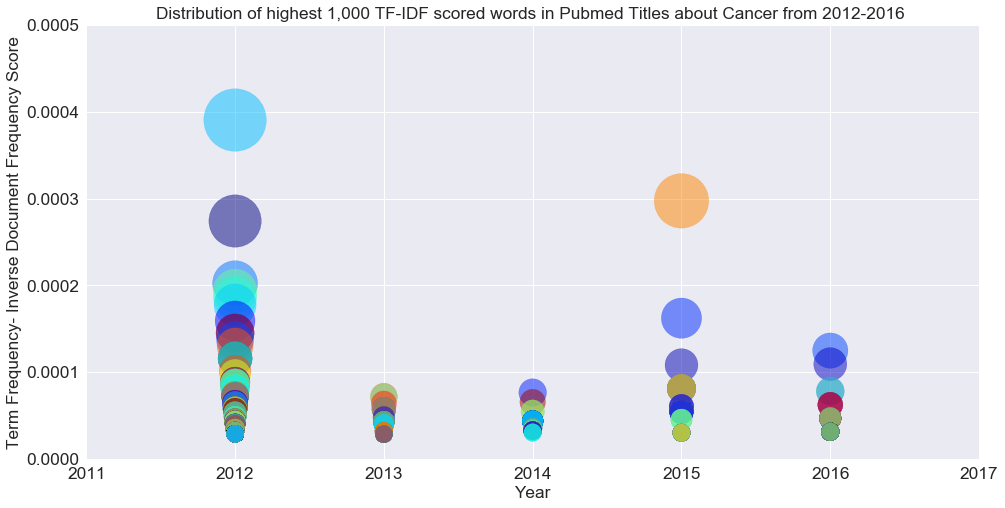

In [219]:
tfidf_plot_together(df_tfidf, N=1000)
plt.xlim(xmin= 2011, xmax= 2017)
plt.ylim(ymin = -0.000001, ymax= 0.0005)
plt.title('Distribution of highest 1,000 TF-IDF scored words in Pubmed Titles about Cancer from 2012-2016 ')
plt.ylabel('Term Frequency- Inverse Document Frequency Score')
plt.xlabel('Year')
plt.show()

In [250]:
def tfidf_plotting(df, y, label, N=N, color= color):
    df= df.reset_index()
    df.sort_values(by=[y])
    X= df.index[0:N]
    Y=df[y][0:N]
    n = df[label][0:N]

    plot=plt.scatter(x= X, y = Y,
                 s= 2000000*Y, alpha=0.4, c= color)
    ax = plt.subplot()
    for i, txt in enumerate(n):
        ax.annotate(txt, (X[i],Y[i]), xytext=(X[i]+.00005,Y[i]))
        

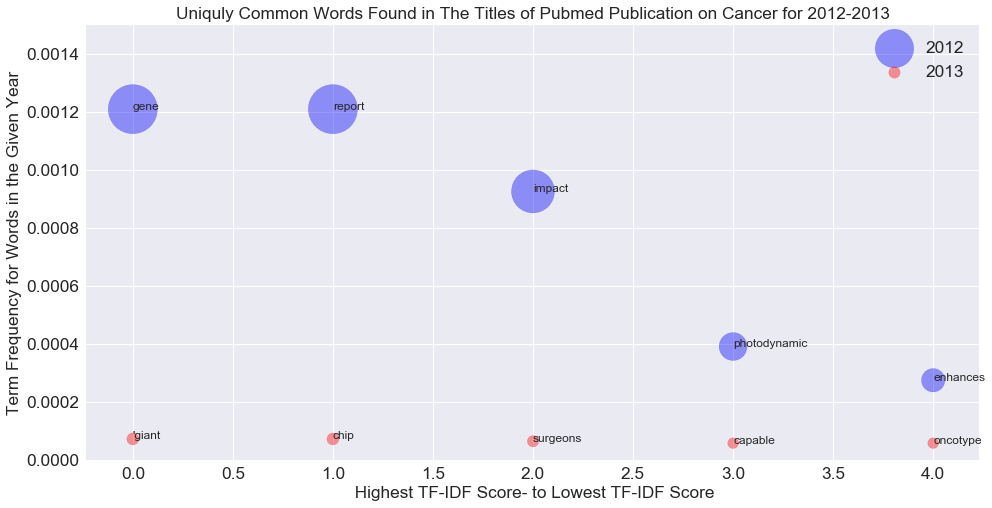

In [254]:
tfidf_plotting(df = df_tfidf12, y='Score', label='Word', N= 5, color = 'blue')
tfidf_plotting(df = df_tfidf13, y='Score', label='Word', N= 5, color = 'red')


fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.ylim(ymax=0.0015, ymin=0 )
plt.rcParams["figure.figsize"] = fig_size
plt.title('Uniquly Common Words Found in The Titles of Pubmed Publication on Cancer for 2012-2013')
plt.ylabel( 'Term Frequency for Words in the Given Year')
plt.xlabel(" Highest TF-IDF Score- to Lowest TF-IDF Score")

plt.legend( ('2012', '2013'), loc= 'upper right')
ax.set_xticklabels(['1st', '2nd', '3rd', '4th','5th'])
plt.show()

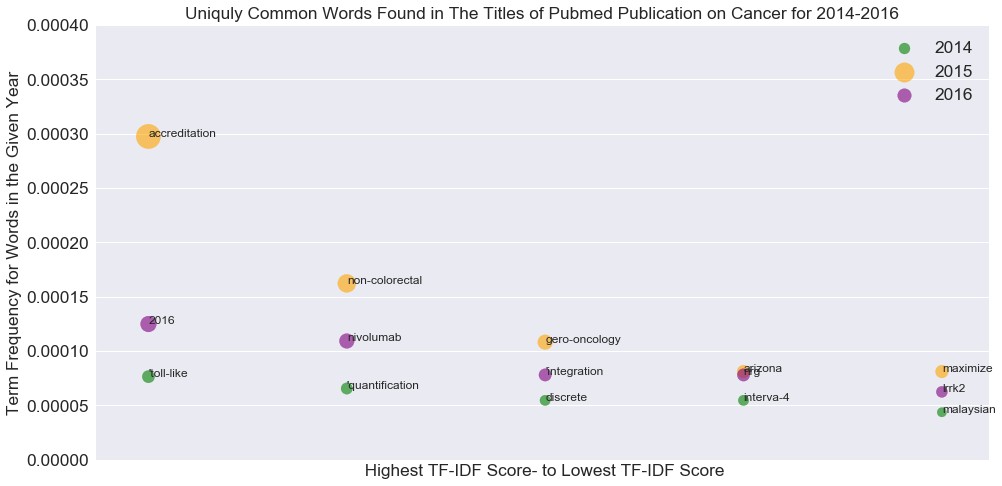

In [239]:
tfidf_plotting(df = df_tfidf14, y='Score', label='Word', N= 5, color = 'green')
tfidf_plotting(df = df_tfidf15, y='Score', label='Word', N= 5, color = 'orange')
tfidf_plotting(df = df_tfidf16, y='Score', label='Word', N= 5, color = 'purple')
plt.ylim(ymax=0.0004, ymin=0 )
plt.rcParams["figure.figsize"] = fig_size
plt.title('Uniquly Common Words Found in The Titles of Pubmed Publication on Cancer for 2014-2016')
plt.ylabel( 'Term Frequency for Words in the Given Year')
plt.xlabel(" Highest TF-IDF Score- to Lowest TF-IDF Score")
plt.xticks([5])
plt.legend( ('2014', '2015', '2016'), loc= 'upper right')
plt.show()

#  Analysis
There is a range of  phrases used per-year. 
Some years clearly have great range between the 1st and 2nd (or 3rd) most common phrases w/ TFIDF (2012 and 2015), however for each year the most common word independent for titles in that year is still fairly low - appearing for only .03%- .01% words used. Therefore there are a LOT of very unique words.

Any association between the word-frequency in these groups and other aspects will be low - unless we can narrow down the groups looked at into more specific groups. 
